# Stock Classifier on 2x Stocks First 2 Years

4/20/2024

Authors: Gilbert

# 0. Remarks

This is Version 2.0

Notes for my own sake:

Companies younger than 5 years in the SP500:

ABNB 3.2963259569555388\
CARR 4.024723300273107\
CEG 2.187473619125193\
CTVA 4.8460954023696585\
GEHC 1.2839643068189857\
KVUE 0.9007714052992191\
OTIS 4.024723300273107\
UBER 4.884426100467498\
VLTO 0.48187163322997734

Some companies IPO right on the end of a quarter, pretty annoying

# 1. Packages

In [118]:
import urllib.request, json , time, os, difflib, itertools
import pandas as pd
from multiprocessing.dummy import Pool
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
import math

import requests
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 2. Grab S&P 500 and NASDAQ stock tickers

In [27]:
from bs4 import BeautifulSoup

# funny code to lazily get all tickers
def get_sp500_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    table = soup.find("table", {"class": "wikitable sortable"})
    tickers = [row.find_all("td")[0].text.strip() for row in table.find_all("tr")[1:]]
    try:
        tickers.remove('BRK.B')
        tickers.remove('BF.B')
        tickers.remove('GOOGL')
    except:
        print("You tried removing something that wasn't there")
    return tickers

In [28]:
def get_nasdaq_tickers():
    url = "https://www.nasdaqtrader.com/dynamic/symdir/nasdaqlisted.txt"
    data = pd.read_csv(url, sep='|')
    # parse out common + ordinary stock in security name, I have no clue what warrant and right mean
    data = data[data['Security Name'].str.contains('common|ordinary', case=False, na=False)]
    
    # Get the list of symbols
    symbols = data['Symbol'].tolist()
    
    # Third to last one was ZXY.A, what even
    del symbols[-3]
    

    return symbols

In [29]:
def nasdaq_sans_sp500(sp500, nasdaq):
    return [item for item in nasdaq if item not in sp500]

# 3. Methods

## 3.1 Grabs first 8 quarter date ranges

In [30]:
def calculate_eight_quarter_date_ranges(ipo_date):
    # Convert the IPO date to a datetime object
    ipo_date = pd.to_datetime(ipo_date)

    # Define the standard quarters
    quarters = {1: ('01-01', '03-31'),
                2: ('04-01', '06-30'),
                3: ('07-01', '09-30'),
                4: ('10-01', '12-31')}

    # Calculate the date ranges for the first 8 quarters after the IPO
    quarter_date_ranges = []
    for i in range(8):
        if i == 0:
            # For the first quarter, start from the IPO date
            quarter_start = ipo_date
        else:
            # For subsequent quarters, start from the day after the end of the previous quarter
            quarter_start = quarter_end + pd.DateOffset(days=1)

        # Calculate the end of the current quarter
        year = quarter_start.year
        quarter_end = quarters[((ipo_date.quarter - 1 + i) % 4) + 1][1]
        quarter_end = datetime.strptime(f'{year}-{quarter_end}', '%Y-%m-%d').date()

        quarter_date_ranges.append((quarter_start.date(), quarter_end))

    return quarter_date_ranges

## 3.2 Grabs dataframe for given range

In [31]:
def get_data_for_date_range(df, date_range):
    # Convert the dates to datetime objects
    start_date = pd.to_datetime(date_range[0])
    end_date = pd.to_datetime(date_range[1])

    # convert start_date and end_date from tz-naive to tz-aware
    if not isinstance(start_date, str):
        if start_date.tzinfo is None:
            start_date = start_date.tz_localize(None)

    if not isinstance(end_date, str):
        if end_date.tzinfo is None:
            end_date = end_date.tz_localize(None)

    # Return the portion of the DataFrame that falls within the date range
    return df.loc[start_date:end_date]

## 3.3 Finds max one day growth of close price for a given range

In [32]:
def max_percent_one_day_close_growth(df):

    max_growth = 0.0
    for i in range(1, len(df['Close'])):
        # print("max growth: ", max_growth)
        growth = (df['Close'][i] / df['Close'][i-1]) - 1
        if growth > max_growth:
            max_growth = growth
            
    return max_growth

## 3.4 Finds max growth of close price across entire range

In [33]:
def max_percent_growth_close_dates(df, start_date, end_date):
    # Convert the dates to datetime objects
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Filter the DataFrame to include only the dates between start_date and end_date
    df = df.loc[start_date:end_date]

    # Initialize the maximum percent growth
    max_growth = 0.0

    # Iterate over all pairs of dates within the quarter
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            # Calculate the percent growth from day i to day j
            growth = (df['Close'].iloc[j] / df['Close'].iloc[i]) - 1

            # Update the maximum percent growth if necessary
            if growth > max_growth:
                max_growth = growth

    return max_growth

## 3.5 Given a pre-processed DF, finds the max growth of close price

In [1]:
def max_percent_growth_close(df):

    # Initialize the maximum percent growth
    max_growth = 0.0

    # Keep track of smallest price so far
    curr_low = df['Close'].iloc[0]

    # Iterate over dates within quarter
    for i in range(len(df)):
        if df['Close'].iloc[i] <= curr_low:
            curr_low = df['Close'].iloc[i]
        else:
            growth = (df['Close'].iloc[i] / curr_low) - 1
            if growth > max_growth:
                max_growth = growth
    return max_growth

## 3.6 Finds max one day growth of volume for a given range

In [35]:
def max_percent_one_day_volume_growth(df):
    max_growth = 0.0
    for i in range(1, len(df['Volume'])):
        growth = (float(df['Volume'][i]) / df['Volume'][i-1]) - 1
        # print(growth)
        if growth > max_growth:
            max_growth = growth
    return max_growth

## 3.7 Finds max growth of volume across entire range

In [2]:
def max_percent_growth_volume(df):

    # Initialize the maximum percent growth
    max_growth = 0.0
    low_vol = df['Volume'].iloc[0]

    # Iterate over data within the quarter
    for i in range(len(df)):
        if (df['Volume'].iloc[i] < low_vol):
            low_vol = df['Volume'].iloc[i]
        else:
            growth = (df['Volume'].iloc[i] / low_vol) - 1
            if growth > max_growth:
                max_growth = growth

    return max_growth

***Testing***

In [37]:
### testing ###
ipo_date = '1996-04-27 00:00:00-04:00'
print(calculate_eight_quarter_date_ranges(ipo_date))

[(datetime.date(1996, 4, 27), datetime.date(1996, 6, 30)), (datetime.date(1996, 7, 1), datetime.date(1996, 9, 30)), (datetime.date(1996, 10, 1), datetime.date(1996, 12, 31)), (datetime.date(1997, 1, 1), datetime.date(1997, 3, 31)), (datetime.date(1997, 4, 1), datetime.date(1997, 6, 30)), (datetime.date(1997, 7, 1), datetime.date(1997, 9, 30)), (datetime.date(1997, 10, 1), datetime.date(1997, 12, 31)), (datetime.date(1998, 1, 1), datetime.date(1998, 3, 31))]


In [38]:
### testing ###
# Define the ticker symbol
tickerSymbol = 'AOS'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='max')
ranges = calculate_eight_quarter_date_ranges(tickerDf.index[0])
print(ranges)
q2Df = get_data_for_date_range(tickerDf, ranges[7])
print(q2Df)
# print(max_percent_growth_close(q2Df))
tickerDf = tickerDf[tickerDf['Volume'] != 0]


ipo_date = tickerDf.index[0]

start_date = q2Df.index[-1]
print(start_date)

price_after_2_years = tickerDf.loc[start_date, 'Close']
row = [tickerSymbol]
quarter_ranges = calculate_eight_quarter_date_ranges(ipo_date)
for quarter in quarter_ranges:
    curr_df = get_data_for_date_range(tickerDf, quarter)
    row.append(max_percent_one_day_close_growth(curr_df))
    row.append(max_percent_growth_close(curr_df))
    row.append(max_percent_one_day_volume_growth(curr_df))
    row.append(max_percent_growth_volume(curr_df))
print(row)

[(datetime.date(1983, 9, 30), datetime.date(1983, 9, 30)), (datetime.date(1983, 10, 1), datetime.date(1983, 12, 31)), (datetime.date(1984, 1, 1), datetime.date(1984, 3, 31)), (datetime.date(1984, 4, 1), datetime.date(1984, 6, 30)), (datetime.date(1984, 7, 1), datetime.date(1984, 9, 30)), (datetime.date(1984, 10, 1), datetime.date(1984, 12, 31)), (datetime.date(1985, 1, 1), datetime.date(1985, 3, 31)), (datetime.date(1985, 4, 1), datetime.date(1985, 6, 30))]
                               Open      High       Low     Close  Volume  \
Date                                                                        
1985-04-01 00:00:00-05:00  0.360507  0.369024  0.360507  0.369024  111600   
1985-04-02 00:00:00-05:00  0.369024  0.374701  0.363346  0.374701   95400   
1985-04-03 00:00:00-05:00  0.371862  0.371862  0.369024  0.369024   19800   
1985-04-04 00:00:00-05:00  0.369024  0.371862  0.369024  0.371862   27000   
1985-04-08 00:00:00-05:00  0.374701  0.383217  0.374701  0.377539  133200   

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


# 4. Feature Engineering Construction

In [39]:
sp_500_tickers = get_sp500_tickers()
print(sp_500_tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 

In [40]:
# filter out young sp_500 companies
for ticker in sp_500_tickers:
    try:       
        # Get data on this ticker
        tickerData = yf.Ticker(ticker)

        # Get the historical prices for this ticker
        tickerDf = tickerData.history(period='max')
        # tickerDf.reset_index(inplace=True)

        date_diff = tickerDf.index[-1] - tickerDf.index[0]
        years_passed = date_diff / np.timedelta64(1, 'Y')
#         if ticker == 'ZPTA':
#             print(years_passed)
        if years_passed < 2: 
            younglings.append(ticker)
            sp_500_tickers.remove(ticker)
            print(ticker, years_passed)
    except:
        print(str(ticker) + " data not available")

GEHC 1.3524119819936982
KVUE 0.9692190804739317
SOLV 0.05749604714675866
VLTO 0.55031930840469


In [41]:
# Begin DF construction
all_rows = []
for ticker in sp_500_tickers:
    try:
        tickerData = yf.Ticker(ticker)
        tickerDf = tickerData.history(period='max')
        ipo_date = tickerDf.index[0]
        row = [ticker]
        quarter_ranges = calculate_eight_quarter_date_ranges(ipo_date)
        for quarter in quarter_ranges:
            curr_df = get_data_for_date_range(tickerDf, quarter)
            # remove all rows where Volume = 0
            curr_df = curr_df[curr_df['Volume'] != 0]
            row.append(max_percent_one_day_close_growth(curr_df))
            row.append(max_percent_growth_close(curr_df))
            row.append(max_percent_one_day_volume_growth(curr_df))
            row.append(max_percent_growth_volume(curr_df))
        all_rows.append(row)
        print(row)
    except:
        print(str(ticker) + " data not available")

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MMM', 0.040307079505153665, 0.12181449294569568, 1.9725970521071208, 2.0689617890061176, 0.1464025760136971, 0.1464025760136971, 4.023251978319219, 28.646935262413674, 0.03931195450129654, 0.1705270656245521, 2.3333305009495566, 5.6129143733722175, 0.08474530637145317, 0.3025735156101135, 2.287580136689198, 10.431874866386375, 0.050525644189074015, 0.18246467435832692, 3.3845720947059537, 9.307593359327893, 0.02419396539979246, 0.07399697108454806, 1.3749904739093988, 3.216233775404997, 0.024070878202615775, 0.17687220740116594, 1.7142737164293314, 8.212085702069707, 0.09110181963352582, 0.13934442275324277, 6.454394299287411, 13.760797946061391]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AOS', 0.0, 0.0, 0.0, 0.0, 0.10908996680282645, 0.37272689268843284, 29.0, 94.0, 0.14912247176079485, 0.22429826670972153, 22.75, 46.5, 0.04064994849618064, 0.1964295489944783, 14.0, 250.0, 0.11363661444690054, 0.34999818239823965, 18.285714285714285, 141.0, 0.24691379227100874, 0.35802511220585154, 46.0, 46.0, 0.07758584408923341, 0.4021734094389149, 33.0, 85.0, 0.06399927432369945, 0.20000022747391433, 30.5, 37.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ABT', 0.032142355821652924, 0.05395765473811154, 2.080213257876393, 5.4331539930714445, 0.04347789824437864, 0.24829813782033328, 2.1594831834477453, 6.817569508095099, 0.04645432763086421, 0.3017759113667484, 4.207650786362335, 9.924528534940247, 0.051470346237009634, 0.18635196563577883, 6.2125610936267455, 11.360294549959308, 0.03478308897257265, 0.12471133413175783, 3.050562032411337, 17.393547592995336, 0.037344789169218684, 0.13964064255940767, 5.023703211698522, 24.73416661709463, 0.04285664262380928, 0.085713894227329, 4.275617982206554, 9.233215291973915, 0.05714158118536883, 0.16748793196225376, 2.393503494378608, 6.362369164264284]
['ABBV', 0.03789114577369834, 0.2241310608622269, 1.7421913511091196, 2.290114806230798, 0.042698830333478766, 0.17344241593282095, 4.018704058610902, 4.018704058610902, 0.03884774818212744, 0.16223367270930167, 1.2527755936468, 3.6163624367714977, 0.0326513993309927, 0.23111495122455805, 1.724811727718067, 5.529808576810198, 0.02994622960067206

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACN', 0.07594943548235489, 0.10177956376891228, 4.2146539603187, 7.804479114242577, 0.10899778771078816, 1.150238658524482, 2.716928446771379, 11.773293096944549, 0.10132633274417313, 0.2520937853162888, 9.65211687537269, 14.941102980546136, 0.07550768582348377, 0.11826787756503854, 3.9511347984909273, 32.70280072536772, 0.10759911814251244, 0.3460427279020728, 11.728335263767505, 33.666188700889016, 0.15379320153134435, 0.6409835637194108, 4.098640362569982, 4.844487344487344, 0.07598957554307106, 0.15300970152545412, 3.6026799156880456, 8.83106960950764, 0.07728062169123517, 0.31863452727097474, 2.2858018073211825, 4.624066063704286]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ADBE', 0.12280848685297041, 0.3962303231310391, 3.4761904761904763, 4.301587301587301, 0.09756083301351293, 0.5362347649638299, 35.7, 259.42857142857144, 0.1147532729193157, 1.6923088161862845, 8.6, 53.29090909090909, 0.15873010345410643, 0.5, 4.245614035087719, 30.07547169811321, 0.10769188073873037, 0.31404921493505045, 49.53333333333333, 167.0, 0.3220319958804734, 0.9999976587338832, 4.229787234042553, 11.930722891566266, 0.10577007743445366, 0.38541661376574976, 9.4875, 37.8, 0.058333891402815974, 0.3529412367195477, 10.55952380952381, 18.714285714285715]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMD', 0.0701755724455182, 0.0701755724455182, 2.3394495412844036, 7.63302752293578, 0.11818166307183509, 0.3818181288537974, 5.872727272727273, 8.363636363636363, 0.07799452060663503, 0.8576268230242379, 3.18957345971564, 7.58252427184466, 0.12068979465154417, 0.6221198594138051, 2.8313253012048194, 11.596385542168674, 0.14970049375426764, 0.29940098750853505, 7.0, 18.096774193548388, 0.07391290588956712, 0.2666665884164663, 3.2287581699346406, 6.121212121212121, 0.13559349649636165, 0.13559349649636165, 5.749003984063745, 8.669902912621358, 0.08275862939859624, 0.24060164609081824, 5.926829268292683, 5.926829268292683]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AES', 0.012345428879209752, 0.012345428879209752, 0.0, 0.0, 0.08235345165552355, 0.4050636495932176, 27.0625, 41.4375, 0.056451505608692054, 0.3838382921845527, 13.9, 120.9, 0.05147018381981683, 0.2295083093035215, 15.7, 36.56842105263158, 0.06944422784069681, 0.132352935572561, 23.107888631090486, 95.65581395348838, 0.11038951278259179, 0.28813081981484623, 14.489614243323443, 14.489614243323443, 0.09302284445869269, 0.35365880116325, 19.10169491525424, 20.89830508474576, 0.049549503512361204, 0.16674158309107123, 15.452380952380953, 67.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AFL', 0.0781302399812025, 0.1666686703414859, 2.0579710144927534, 7.3768115942028984, 0.06779347722328133, 0.1896649564478139, 4.214285714285714, 28.166666666666668, 0.032252599105399904, 0.06451498325947669, 4.5, 7.031746031746032, 0.034487345330397545, 0.06779347722328133, 3.928571428571429, 11.742857142857142, 0.04477747300227075, 0.145155341500125, 11.633333333333333, 61.375, 0.03947403818425066, 0.16176336183904905, 4.986666666666666, 10.136363636363637, 0.0714269872306581, 0.1071458975842372, 4.25, 9.25, 0.05263318891767366, 0.10526604260865358, 4.127659574468085, 33.77777777777778]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['A', 0.17073151500430694, 0.981249310705882, 1.9546436285097193, 7.78869144104249, 0.4722223582819436, 1.6500007084825303, 3.6827627954642095, 9.257759360387386, 0.18285706530277523, 0.4094828915371709, 7.065662505187481, 16.4974946313529, 0.2123653849721976, 0.6231883234925484, 9.260696600620731, 10.403517802739191, 0.13813852409746552, 0.5119233472501727, 1.836457681426087, 3.6728099896927633, 0.12187511685040198, 0.3280096206604053, 2.223058317656544, 4.276846582183748, 0.13981410206266487, 0.4637675785742188, 2.1123419731379407, 4.814650755119845, 0.14402606421413489, 0.18161442597346467, 2.404335365750128, 7.11494764601442]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['APD', 0.04528200447073916, 0.04905629996028882, 6.00002820344082, 6.00002820344082, 0.07633527633266035, 0.23371658215336977, 10.164454300649453, 34.268099387991086, 0.0506324551926316, 0.3419358900581846, 3.815386394364193, 6.475230408151583, 0.06733143482949933, 0.09660598686741095, 4.31468101709032, 32.12531920019273, 0.058478691045547704, 0.21835412861824532, 5.709908992604169, 23.575002890841812, 0.03314909026424928, 0.06857080867127063, 6.021706342223674, 13.043412684447349, 0.044827101190205054, 0.08602110108962724, 5.158720690129858, 12.765368731563422, 0.04225392943921569, 0.15827316390506296, 17.307538358905937, 51.884144985545916]
['ABNB', 0.10568911954221671, 0.30761216707444383, 0.8699699479586602, 0.8699699479586602, 0.13341760337607633, 0.5583184035149935, 1.8993183197116243, 6.432880497352061, 0.062486071754696226, 0.1557735802992335, 1.6005232785602503, 15.497904303440261, 0.09966622761740118, 0.33363662701634, 3.674197233151415, 6.860552808509125, 0.1298402833577272

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AKAM', 0.2006026689625484, 1.256564786913474, 5.595867768595041, 6.805601317957167, 0.14957264957264949, 0.39952718676122934, 4.48170449282075, 6.874942102825382, 0.30714285714285716, 0.9895724713242962, 3.52536486930405, 13.463926803659817, 0.1251231527093597, 0.24433497536945814, 2.519277474195507, 6.520272461887772, 0.42517814726840863, 0.5958549222797926, 1.403220267846923, 3.9497838899803535, 0.2278481012658229, 0.8993288590604027, 1.1194800289572253, 4.470911310008137, 0.3938053578140688, 1.203871039934056, 2.4185861003091036, 9.10726522006501, 0.1827956980058636, 0.20071682811336222, 2.313467784575874, 7.813944143058068]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALB', 0.052174155446525594, 0.2274273442501682, 11.884892086330936, 90.125, 0.054546130022594674, 0.24030200582936767, 10.635983263598327, 20.0, 0.043103576275363986, 0.09302339824110084, 14.281150159744408, 45.68780487804878, 0.051282196874703256, 0.11403522876922256, 20.095070422535212, 67.07954545454545, 0.05769273145987208, 0.12871292054365813, 23.993827160493826, 70.03508771929825, 0.04273496959533141, 0.25899694633278636, 3.4425, 9.616161616161616, 0.04958658650584069, 0.2682851713267673, 78.94222222222223, 97.2896174863388, 0.06382997764942666, 0.18656722634670464, 18.056603773584907, 46.63522012578616]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ARE', 0.029239978736425698, 0.0535713713737227, 1.9189189189189189, 3.365269461077844, 0.04040390314353015, 0.2666666740482295, 14.319066147859923, 38.714285714285715, 0.05240143090300364, 0.17592563886511403, 44.34090909090909, 465.6, 0.04064978339662262, 0.10975513622343613, 13.831932773109244, 50.911764705882355, 0.03232794121513938, 0.13333383623214878, 22.652173913043477, 261.3333333333333, 0.06235542063324795, 0.13480410189307523, 19.53, 130.06060606060606, 0.05485231537740631, 0.22650581728141383, 17.741007194244606, 371.14285714285717, 0.04702943639566581, 0.05827114012437473, 47.81944444444444, 57.583333333333336]
['ALGN', 0.12149532710280364, 0.5327102803738317, 10.45799853907962, 13.77310924369748, 0.25517240869020896, 1.2146789205946238, 15.882474226804124, 40.20060790273556, 0.05702362227387914, 0.1239316079662236, 16.55971479500891, 38.28235294117647, 0.3061890280388797, 0.9477353224698637, 6.61437908496732, 24.925714285714285, 0.13904762268066406, 0.3906976171672014, 4

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALLE', 0.033511522130485805, 0.09828033441589956, 4.401305400568481, 7.739056378811105, 0.04800654505284996, 0.26804059492305776, 2.0823146798250534, 6.263477801268499, 0.03850052184287622, 0.19490444055374478, 2.2838038632986626, 7.426672574213558, 0.025117993082504952, 0.05554431045013564, 2.4925616835994195, 12.879596250901226, 0.04672861441486442, 0.24262425885681282, 3.4224683544303796, 5.3292572463768115, 0.028928504671844824, 0.17477136335019372, 1.501870557426113, 6.956625074272133, 0.02042185009828712, 0.06903561726789054, 2.702818408847663, 6.529198404062386, 0.036347368112834566, 0.10601942220568028, 1.9578005115089514, 7.79467680608365]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LNT', 0.006451444035787901, 0.01290288807157558, 7.7142857142857135, 12.071428571428571, 0.013333978721805861, 0.013333978721805861, 20.625, 33.6, 0.026142931691891746, 0.08219198043457965, 5.0, 20.2, 0.03076889556139517, 0.10000031398288534, 3.7142857142857144, 12.0, 0.0139859873716639, 0.06293685667584947, 5.333333333333333, 8.166666666666666, 0.03200026519201438, 0.16101627669127794, 12.5, 19.5, 0.040650148151760934, 0.16379291316979705, 5.590909090909091, 43.6, 0.0409839580823832, 0.1545456784145789, 3.909090909090909, 10.875]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALL', 0.018099482624474028, 0.05936076657634737, 1.1446086664427275, 1.1446086664427275, 0.028806319733659658, 0.18370243574338696, 2.4335810496980956, 7.764078245406047, 0.030973796485135763, 0.06843923007074126, 4.182608695652174, 8.342391304347826, 0.026315621967329728, 0.060343386824211365, 4.849166062364032, 62.08880994671403, 0.055276968435161056, 0.16108250869497565, 5.017647058823529, 6.467324290998767, 0.04687511692806279, 0.12295772039669917, 26.00355871886121, 26.00355871886121, 0.02717470528211563, 0.09836074820387353, 3.2067578439259856, 17.672176308539946, 0.04060921236325288, 0.2299351500783815, 2.8167970358172085, 6.923931623931624]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GOOG', 0.07942989417030355, 0.31066931249393415, 1.3958038735119978, 6.513158571164073, 0.1543046567684292, 0.4904208689203, 1.5286610239343106, 6.058894445440515, 0.07326730460648734, 0.19049219300670073, 1.9400884394738172, 4.818601561890919, 0.05728240187277045, 0.6890691141842138, 1.6199914260247876, 5.877946288481467, 0.035608034707659275, 0.15492139386019144, 2.057399645043285, 4.640275682329725, 0.12104223955850357, 0.4589045909097227, 1.7011313609546632, 3.532303056648451, 0.07033114580992961, 0.1718389427036533, 2.8618123443430794, 5.0896204437017705, 0.05325302714407387, 0.1332631733623908, 1.164509026942942, 2.747930856871995]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MO', 0.01999857834805696, 0.03889912528219308, 7.875, 42.666666666666664, 0.047530815047607256, 0.07809682175417842, 2.148936170212766, 12.454545454545455, 0.02908962608761012, 0.03831895029618093, 8.1, 17.2, 0.03435759698922203, 0.25100824351478734, 1.5882352941176472, 11.571428571428571, 0.03460130333171141, 0.10392252543617642, 5.142857142857143, 33.142857142857146, 0.02792013419562034, 0.12149420313110348, 3.1923076923076925, 19.22222222222222, 0.0338970049323879, 0.10139981930042419, 2.8333333333333335, 13.2, 0.04929255214422246, 0.09980029536365698, 6.142857142857143, 8.375]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMZN', 0.0882357334203987, 0.2089494288870546, 4.153745072273325, 12.196754563894523, 0.20328106223050657, 2.0515563917329342, 3.194475760992108, 28.653361344537814, 0.15853559396593053, 0.48706760120169545, 4.238916256157635, 13.845360824742269, 0.1043649681590213, 0.6797076750274926, 3.723032069970846, 19.043731778425656, 0.15558944793548446, 1.464506670907574, 2.6850298640233827, 16.249823695345558, 0.1920625549646786, 0.5839055219145664, 1.4356094639113506, 4.223399312331567, 0.20692086547447452, 3.0833953325521914, 4.522664302338469, 10.38594725186229, 0.16037733472509808, 0.9238829356759979, 1.6772581408806353, 3.7247791485306614]
['AMCR', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996, 0.19999999999999996, 0.032911756437497, 0.05949386037921056, 1.56, 1.56, 0.06808509219013525, 0.15935337672949323, 18.725806451612904, 610.5, 0.06165146899792906, 0.08263600799465154, 65.14285714285714, 230.5, 0.048936254544661884, 0.11904761341128567, 61.0, 136.0, 0.04687502373424701, 0.0999

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AEE', 0.021001540109037986, 0.1986868522715204, 11.07391008174387, 24.41146953405018, 0.03674076458491582, 0.0723047524335163, 10.179487179487179, 18.508844953173778, 0.03135257153007953, 0.1406455948324592, 10.988243430152144, 24.53019145802651, 0.02336435715215668, 0.11028940427004486, 12.404269972451791, 27.538123167155426, 0.026981296762395024, 0.0699659042453682, 2.1559086395233367, 3.968166849615807, 0.0334442761670648, 0.13321719560158174, 2.662150719729043, 3.2670364500792397, 0.020828350481791214, 0.05875900834695269, 10.225841476655809, 21.210526315789473, 0.037453817625450414, 0.05181320322191896, 7.428424304840371, 16.104783599088837]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AAL', 0.06217631517043265, 0.08860122028997286, 4.979920932168123, 4.979920932168123, 0.10111917711161356, 0.7949573199518938, 4.2465753424657535, 10.890974729241877, 0.0708492030214194, 0.3845620425841363, 4.093047569262938, 11.29064296915839, 0.11052191419300472, 0.39918747650572795, 2.5951209073400383, 7.863471003637921, 0.10205105967467132, 0.2906695677927136, 2.681144990665837, 4.331425015556938, 0.16827029837838614, 0.4048201402988385, 9.383334589015295, 25.02795089707271, 0.054237291752014194, 0.1377326537037371, 2.1171543994482214, 3.6020297566262682, 0.06779024948295143, 0.13594703132880515, 1.1484195169395366, 5.342925659472422]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AEP', 0.03266797218150441, 0.11411901035374261, 7.7142857142857135, 9.285714285714286, 0.10185165098821525, 0.1527776736938935, 3.5999999999999996, 13.083333333333334, 0.048034338271589094, 0.15153778008999907, 3.0, 4.9411764705882355, 0.03585706637087971, 0.2189621840454552, 5.280898876404494, 38.92857142857143, 0.033457459319186755, 0.0733584563186116, 1.9, 6.088235294117647, 0.027396217959300806, 0.07605380758281943, 3.2413793103448274, 10.461538461538462, 0.01730057476973057, 0.08070155906252174, 1.6288659793814433, 5.7272727272727275, 0.027027061148403142, 0.12152861169003293, 3.224137931034483, 6.903225806451613]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AXP data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AIG data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMT', 0.06338002066396409, 0.27777803804247436, 16.75, 995.5, 0.13414642851893932, 0.2954543378343475, 9.25609756097561, 191.7659574468085, 0.13235330393167977, 0.6190480652156702, 10.828205128205129, 17.797124600638977, 0.21296297730162217, 1.1898148751215292, 9.252702702702702, 19.34836702954899, 0.0628570914585882, 0.15634173431189446, 14.56638777737359, 91.1248654467169, 0.13714279610707347, 0.25301202962780334, 4.163760424564064, 8.998139534883721, 0.08554548164547615, 0.21428534328735616, 2.8144963144963144, 57.93366093366093, 0.11036042902916798, 0.8514496870872761, 3.677458396369138, 12.878264925373134]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AWK', 0.035933122365783055, 0.13446559374677447, 2.3572148214485615, 15.332483612527312, 0.06965178673996597, 0.2438030241579836, 2.5730797912005965, 7.11426592797784, 0.12762237705553225, 0.3038647749464445, 2.758893280632411, 10.181818181818182, 0.09331719085761025, 0.1639441279279792, 1.7927369353410096, 5.5010309278350515, 0.046629867036068307, 0.14642835428674505, 5.650221065245238, 121.01819560272934, 0.024238917524478154, 0.13264895927400078, 4.23924128084846, 48.98085688240656, 0.05925598623051043, 0.20807561048952428, 4.744800351031154, 69.72033333333333, 0.02368575098504966, 0.07938820461600593, 4.166697622585438, 11.899373985624855]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMP', 0.02197829349865965, 0.03708842287035008, 17.626602564102566, 63.33974358974359, 0.06735304472707204, 0.3594470565054533, 4.076660260516762, 5.325432415118514, 0.044045773416696354, 0.15015952092620455, 4.471150400191136, 9.504357798165138, 0.04686397462473524, 0.13122169904898584, 2.1915850329211497, 5.433096563639854, 0.040967381452455376, 0.1432220572291445, 1.8160249321403437, 4.553330689928628, 0.03801806253416018, 0.16824317039438452, 2.201255667945588, 4.0308788598574825, 0.04297342848921337, 0.14157155882577022, 1.9486756484281917, 4.071260997067449, 0.03138941231137382, 0.15721917876025193, 1.637629567584546, 4.268088665830197]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AME', 0.0624997745007827, 0.21390338916947815, 7.475409836065573, 40.1025641025641, 0.06878278481012656, 0.1009713547271256, 12.633986928104575, 49.8780487804878, 0.05583787414567176, 0.21354100308364599, 7.552380952380952, 27.0625, 0.04232798395104287, 0.08108144940717588, 4.7555555555555555, 24.81081081081081, 0.030119875073970404, 0.06707200105270061, 4.776649746192893, 15.028169014084508, 0.04301028215077585, 0.2827528555904546, 12.479166666666666, 32.17948717948718, 0.03913000888777107, 0.16190473254974513, 6.972222222222222, 30.22222222222222, 0.07079624299029019, 0.10360315855167501, 3.935483870967742, 10.610169491525424]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMGN', 0.03448393933166294, 0.03448393933166294, 2.7378048780487805, 3.626415094339623, 0.07042303575328357, 0.2539630648177156, 4.685185185185185, 63.63636363636364, 0.09259348519615362, 0.319144844605882, 13.53061224489796, 51.26086956521739, 0.0666688069506518, 0.1578907312657698, 17.133333333333333, 49.125, 0.052638722886024114, 0.23684765063529345, 17.161290322580644, 53.04761904761905, 0.07316595398038483, 0.15789501245702264, 22.463414634146343, 86.5, 0.1034413903758653, 0.3793124081073007, 18.555555555555557, 71.33333333333333, 0.15555310082407625, 0.5675735184813491, 39.5, 532.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['APH', 0.061537959431611, 0.2631597935928345, 3.4109195402298846, 9.098684210526315, 0.06250039319634015, 0.14084302983213814, 31.97752808988764, 34.484375, 0.07692303849657067, 0.12068600016959219, 12.26086956521739, 51.68421052631579, 0.05882500250000544, 0.19999657113555935, 19.0, 74.6938775510204, 0.1428585312918278, 0.4285670402950241, 33.2, 304.0, 0.08772274150448034, 0.23636234971437498, 9.334285714285715, 23.773972602739725, 0.1159428946821881, 0.6603794083631775, 7.730627306273062, 34.81372549019608, 0.08642085770486863, 0.3827176884939629, 5.141176470588236, 26.5188679245283]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ADI', 0.05960252309805503, 0.05960252309805503, 11.714285714285714, 11.714285714285714, 0.09090951150233595, 0.45454634926224147, 14.6, 24.4, 0.11210707481484716, 0.6705877447407529, 3.1884057971014492, 16.62962962962963, 0.08300459133035609, 0.33333276052534666, 30.09090909090909, 47.63157894736842, 0.07630519862752982, 0.20370402944404908, 19.46153846153846, 43.333333333333336, 0.09405884076968607, 0.23893851348796935, 4.25, 28.533333333333335, 0.09090884095658458, 0.14285693711391323, 19.333333333333332, 29.833333333333332, 0.059602091900240906, 0.16153941002737104, 28.0, 131.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ANSS', 0.07291666666666674, 0.10526315789473695, 0.18032378580323782, 0.18032378580323782, 0.11494252873563227, 0.24137931034482762, 67.53571428571429, 67.53571428571429, 0.15841584158415833, 0.3369565217391304, 213.0, 1237.0, 0.0923076923076922, 0.25, 28.384615384615383, 263.0, 0.10344827586206895, 0.6222222222222222, 9.384892086330936, 174.26666666666668, 0.06896551724137923, 0.5438596491228069, 8.107142857142858, 188.7, 0.1578947368421053, 0.31746031746031744, 29.416666666666668, 128.0, 0.11333333333333329, 0.4910714285714286, 10.033175355450236, 72.97142857142858]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AON', 0.03973556592829719, 0.1241373242814705, 4.918918918918919, 4.918918918918919, 0.03184670471440332, 0.04516107911169298, 18.009615384615383, 39.3469387755102, 0.044117202632296015, 0.06666667447304597, 10.22549019607843, 31.714285714285715, 0.047618463848020376, 0.2910460385699163, 24.208333333333332, 24.208333333333332, 0.04790414457107817, 0.15822807732989586, 11.085714285714285, 29.885714285714286, 0.04999973324148943, 0.12422483499131598, 3.479166666666667, 19.0, 0.051281905778514325, 0.2307700959956207, 7.490196078431373, 34.25, 0.041666466715351236, 0.10256431822113066, 8.159090909090908, 58.26470588235294]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['APA', 0.0675674442017069, 0.3108105983473841, 2.268673003474715, 16.418810685041837, 0.12234061454432199, 0.29281711363716, 4.428673519872464, 16.34308174371942, 0.07599992704043035, 0.4537032580594884, 8.69967293016097, 17.71387998167659, 0.10104594818898538, 0.26217219198764385, 9.811231713072203, 15.169673648673175, 0.11475337551849885, 0.5532991969487768, 3.1891217305392336, 19.04380170589367, 0.05940560763430103, 0.4043710135234029, 3.475609756097561, 17.93877551020408, 0.08214371562481859, 0.3999997444722425, 4.4040498038707545, 16.080645161290324, 0.08045944395804283, 0.3492818361205563, 4.71214307577944, 14.378809742446107]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AAPL', 0.09230818605120295, 0.42574277240290614, 0.6763401854091093, 1.4934052757793763, 0.06315328816519483, 0.23700037407845986, 2.9039697542533083, 42.025, 0.0876325611316442, 0.3659745157769654, 5.102150537634409, 34.88172043010753, 0.06210700858629803, 0.16292108877209843, 6.761557177615572, 9.284671532846716, 0.08332767624989512, 0.5000142668331107, 5.713815789473684, 7.185828877005347, 0.0901729699517837, 0.265485561445411, 1.0615079365079363, 5.393739703459637, 0.03883244533555441, 0.11111942094639593, 2.3734677199673113, 10.563025210084033, 0.06976290723900314, 0.7159053887648545, 4.410029498525073, 18.511627906976745]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMAT', 0.11362884718328159, 0.2386338822431986, 2.017391304347826, 3.9571428571428573, 0.10769779788197908, 0.30769808490261874, 52.5, 135.0, 0.07691752448922307, 0.8717847270210792, 3.5599999999999996, 6.5, 0.0821917020518057, 0.35074731804571435, 7.806451612903226, 16.0625, 0.09195191454317642, 0.25676174789223905, 4.401709401709402, 12.96078431372549, 0.1130447439562019, 0.5116241008438442, 2.763358778625954, 12.54, 0.04999636809342878, 0.07894192954493162, 5.32258064516129, 26.05, 0.06666193928609587, 0.16666365807184547, 6.833333333333333, 29.833333333333332]
['APTV', 0.04252141908920182, 0.12735595185801607, 2.537721440566521, 6.395559459532382, 0.06559819971603287, 0.46025282852801386, 4.834934311033103, 43.41076273185692, 0.04885769436612497, 0.0946442685382256, 4.113479152302774, 24.650578789495196, 0.04033195391697175, 0.26611291785303326, 7.384711389401476, 23.793939095107678, 0.03827007307865604, 0.254098240874409, 10.048619361710845, 89.70261525430062, 0.0521017518792832

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACGL', 0.03571456305838483, 0.03571456305838483, 2.4285714285714284, 2.4285714285714284, 0.12650572071754862, 0.16875001005828438, 187.33333333333334, 424.3333333333333, 0.03144674933764602, 0.03470028846690165, 75.85714285714286, 345.0, 0.01898749098913366, 0.026144027709960938, 998.6666666666666, 8996.0, 0.09154950222123204, 0.21969708003947175, 75.25, 10408.0, 0.060150348282266286, 0.20155024833674795, 163.1764705882353, 1969.5, 0.037036768595377634, 0.0846149061983077, 180.9090909090909, 5027.0, 0.054794543096820414, 0.30232517289890515, 136.59677419354838, 2616.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ADM', 0.09500028878659617, 0.1450000953410293, 2.3115554017278472, 11.45727548506627, 0.11538440842803843, 0.3942312412706164, 5.118633689655962, 14.423707281342276, 0.07954571267277033, 0.24999933140957586, 4.685710564901991, 22.865379995454987, 0.05678282703870141, 0.1989865582425585, 4.747777223657897, 7.19241256136635, 0.04516091347424078, 0.13888975874730636, 5.764400393488873, 17.701583235889156, 0.0939600563688976, 0.26811596920865166, 4.157048288462718, 7.455123703819854, 0.04929530519167158, 0.11764751796652151, 17.4099988590429, 23.025062216833643, 0.09523681636933823, 0.38461414313496833, 7.783131854702177, 25.74788588554194]
['ANET', 0.08695650671590571, 0.30000000000000004, 2.1206896551724137, 2.1206896551724137, 0.09608834217185835, 0.4757235210205024, 4.715225563909774, 20.16320474777448, 0.0996075337819351, 0.20878359145342928, 4.516522774635308, 13.478324403312225, 0.05801447661155312, 0.30894030250933224, 2.487629688747007, 20.34777376654633, 0.0452450472860515, 0.3

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AJG', 0.035713476851717774, 0.05454488397139534, 0.6481481481481481, 1.0859375, 0.11494375122963363, 0.6724156798459637, 60.333333333333336, 911.0, 0.04386026437280566, 0.2268033993290708, 40.2, 823.0, 0.08450639138490157, 0.3050843576523323, 159.0, 725.0, 0.03846084237224323, 0.2260267520759014, 95.0, 223.0, 0.020133685224337894, 0.03289476214160891, 769.0, 852.0, 0.07070669487035408, 0.4202895585654416, 37.0, 1122.0, 0.0500007278929, 0.1894743942006345, 467.0, 563.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AIZ', 0.03251964854200362, 0.0696907581793027, 1.935603836367195, 6.890892135529997, 0.026272920641176034, 0.10604451416476324, 3.4742654308814833, 12.198952879581151, 0.030126101548278994, 0.12857920833019043, 7.45954962468724, 11.47598719316969, 0.046125289819205495, 0.2335693473055669, 5.465, 21.2925, 0.02877910118166649, 0.17394484563724633, 3.812714971463129, 62.44294967613353, 0.026438272031928278, 0.12986926419448763, 2.234887737478411, 10.744623655913978, 0.027026783438377056, 0.06817538337706042, 3.3507491356127543, 8.456128133704736, 0.1063332509224022, 0.2264449600716989, 3.2400909681611436, 14.88864388092613]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['T', 0.010661525625624613, 0.01716782840054787, 2.103534291028632, 4.901409094705292, 0.049179778020723486, 0.07991808295389702, 1.7366858809212786, 5.4110600238536115, 0.02708802365180274, 0.08333331420203072, 2.494036742089721, 13.518726215315084, 0.032128964543549854, 0.19021644753060296, 16.066825806807156, 34.67565360740564, 0.02903830300971122, 0.11834292830711624, 6.386602570120766, 15.069522193831826, 0.018900403331300053, 0.09653922872821097, 3.835058457453197, 6.736684949847723, 0.02131050917466437, 0.15068569944769528, 5.957506198220012, 5.974804256051016, 0.026941547943334365, 0.061660048982381976, 8.227352432016072, 9.06766464515488]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ATO', 0.0, 0.0, 3.890625, 3.890625, 0.03597160420882384, 0.11538421399553966, 18.083333333333332, 19.818181818181817, 0.05302946460673752, 0.13385854409531817, 10.9, 12.222222222222221, 0.024793217166674264, 0.09917336921820463, 10.954545454545455, 147.5, 0.06474927102015338, 0.2030080632094562, 20.5, 179.5, 0.0499999432187046, 0.13636314296294927, 23.77777777777778, 55.0, 0.05319110550747297, 0.44578230434227706, 17.375, 63.25, 0.02941047932252694, 0.04807779103646648, 79.5, 225.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ADSK', 0.0, 0.0, 0.0, 0.0, 0.08620658646936397, 0.37500035213265615, 37.0, 71.93333333333334, 0.06349238471182028, 0.9038449203409991, 27.4, 210.125, 0.10185139641868957, 0.44705848219591804, 5.35, 95.9, 0.06882626301850614, 0.694736972668891, 22.214285714285715, 105.16666666666667, 0.0747667865062005, 0.3737855465236002, 58.6764705882353, 62.40625, 0.050358670447050446, 0.2519675681693989, 27.916666666666668, 116.66666666666667, 0.10434800136394706, 1.3653861203577704, 8.375494071146244, 12.790697674418604]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ADP', 0.0305337774459864, 0.04198411915223277, 1.4700853433539578, 1.994817348783695, 0.04693153134349526, 0.14079410571408313, 175.9992565055762, 426.9981412639405, 0.049478797381884654, 0.33656877786645256, 16.249922552664188, 17.624922552664188, 0.04301052033396213, 0.1420768166237576, 50.249772821148284, 60.499727385377945, 0.0360829347719227, 0.19680743086115915, 7.113648268831074, 81.92821738360772, 0.06722677886339512, 0.1493217278869179, 9.63841796043641, 93.14960346964064, 0.04615330799627526, 0.17647061052292168, 9.382301917049348, 42.352751658284134, 0.052175157922470516, 0.21000026762863544, 24.249884935386795, 41.73196140909896]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AZO', 0.07499999999999996, 0.21491228070175428, 6.448275862068965, 14.652173913043478, 0.051136363636363535, 0.3034482758620689, 9.465346534653465, 11.890243902439025, 0.0535714285714286, 0.5565217391304347, 39.38, 39.38, 0.06666666666666665, 0.32657200811359033, 12.201458523245215, 53.64905660377359, 0.05128205128205132, 0.13307984790874516, 8.792307692307693, 59.2972972972973, 0.07627118644067798, 0.23636363636363633, 12.186915887850468, 12.925233644859814, 0.04961832061068705, 0.2749003984063745, 29.37142857142857, 29.37142857142857, 0.04635761589403975, 0.2737226277372262, 2.4597701149425286, 14.804597701149426]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AVB', 0.03636361047426684, 0.03636361047426684, 1.6683673469387754, 4.377892030848329, 0.04022998741745942, 0.12422366506874138, 19.2972972972973, 75.56756756756756, 0.036144411038741, 0.06918182879401247, 61.6, 61.6, 0.059602961076742345, 0.1830976993581297, 128.0, 277.75, 0.02484501097422709, 0.04054105948310038, 118.0, 304.5, 0.041096258862491464, 0.17647103342898451, 48.4, 841.0, 0.025973812745262226, 0.1372550496417857, 11.782608695652174, 62.19230769230769, 0.04494301866714934, 0.21875042828705604, 26.566666666666666, 90.9047619047619]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AVY', 0.041176207946635346, 0.1028034190497149, 12.4375, 63.5, 0.049999498795126884, 0.15862135669091448, 11.0, 17.857142857142858, 0.04644751244904133, 0.24085333680244103, 42.27272727272727, 94.2, 0.06474880423459184, 0.12121171662610397, 5.333333333333333, 77.0, 0.06737648078360703, 0.2639412467253315, 139.0, 139.0, 0.04234640159343295, 0.14332319820887007, 15.555555555555557, 167.5, 0.08219223839782419, 0.15948263076573954, 7.6, 29.166666666666668, 0.1082250869058139, 0.3173073828047561, 7.0, 74.66666666666667]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AXON', 0.08521656404205524, 0.196261843423984, 26.333333333333332, 26.333333333333332, 0.11764582135762813, 0.621428178220657, 25.666666666666668, 533.6666666666666, 0.28178691032880865, 0.7224247672341086, 27.733333333333334, 220.42857142857142, 0.21575329681349742, 0.5061164753466993, 43.029411764705884, 77.35384615384615, 0.1174312597653191, 0.30330689656317955, 10.444444444444445, 31.712962962962962, 0.12280633729139545, 0.5711259924457759, 6.305555555555555, 41.9375, 0.29729867922090003, 0.42433402609222015, 46.604166666666664, 94.20833333333333, 0.09245837659745892, 0.21351585390170968, 7.300000000000001, 40.13333333333333]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BKR', 0.08527124780894413, 0.4207552314786016, 3.9010367577756835, 16.200674536256322, 0.05641035171843267, 0.12953403393716423, 2.207718120805369, 5.70464504820333, 0.2830193379723962, 0.3431371755183865, 3.4101876675603213, 13.82808902532617, 0.05737709225775656, 0.3461927780593368, 4.794557823129252, 8.506696428571429, 0.03947401852926702, 0.15328447726083883, 3.5, 11.037135278514588, 0.06194714483632757, 0.06194714483632757, 2.644803229061554, 11.875698324022347, 0.051020824975607226, 0.16494883404917782, 5.748748748748748, 5.883883883883884, 0.038759131328946816, 0.25284816548655864, 7.832187857961054, 19.71779661016949]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BALL', 0.06557370263596662, 0.13043538000357668, 13.526315789473685, 137.0, 0.05882463324337506, 0.1836777097504123, 4.666666666666667, 24.0, 0.14942844028134084, 0.40506289440130705, 20.333333333333332, 28.333333333333332, 0.07894194510005148, 0.2812481725717164, 22.75, 46.5, 0.12499868918305723, 0.5857122544846791, 18.0, 89.0, 0.06578457915815883, 0.3289455084729507, 15.0, 38.0, 0.07692543041956701, 0.1688265352319105, 50.0, 130.0, 0.08108263688071715, 0.2297292582302224, 14.5, 52.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BAC', 0.029702397730961172, 0.06418890638398733, 8.31578947368421, 13.75, 0.027682480981600976, 0.09859221551936548, 4.7272727272727275, 20.705882352941178, 0.06506742056846826, 0.1642337163792873, 21.75, 49.25, 0.04379613869148935, 0.18796913997349374, 3.74, 28.0, 0.07299301790587687, 0.1889761021788463, 6.666666666666667, 8.714285714285714, 0.09693822524411999, 0.14973190756744037, 8.1875, 8.3125, 0.10606027729423984, 0.2314054113112891, 5.572727272727272, 36.476190476190474, 0.15277799553191906, 0.5166666417061885, 3.7407407407407405, 26.703703703703702]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BK', 0.014925420738575168, 0.03007470387920308, 15.699717339457646, 19.50154593639576, 0.02661582702480847, 0.08300419771220247, 37.00265017667844, 109.00795053003533, 0.028571409880863596, 0.06934319378094789, 4.111203808215144, 16.799664340605954, 0.07279705631256106, 0.19753073003779487, 5.0624396168603525, 27.001987632508833, 0.03508764765296046, 0.03539952649252309, 18.00132508833922, 102.00706713780919, 0.059782578037870016, 0.17241217777463635, 50.003533568904594, 52.003533568904594, 0.05025220832817512, 0.1709833495476687, 13.25020703362226, 31.500524485176392, 0.04587115044421286, 0.22660002661792222, 11.153869674526058, 44.59915201837293]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BBWI', 0.12230192728347089, 0.1870498891240897, 5.82897212543554, 55.84249331498741, 0.09883784552580188, 0.5189867377100017, 6.450182058920887, 36.18653775095455, 0.0941168004249131, 0.4090913672766494, 9.868732529991574, 27.368524970963996, 0.08450738777138844, 0.37362746656967616, 11.923019470048038, 31.228199767711963, 0.14563040864009857, 0.7966109658212972, 3.5535595224021748, 30.25513402507566, 0.07692269248947814, 0.1959795082041429, 9.406820013487064, 51.46073170731707, 0.05660346149797757, 0.2857151125350996, 10.17262260815797, 27.49364878395935, 0.06341538478597064, 0.22727348409718306, 5.848883396592815, 20.84887162738694]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BAX', 0.037773803963237595, 0.080644618168773, 3.5954791551984835, 10.147958595085527, 0.04044059364932928, 0.13725514832655428, 2.748308188986155, 8.02562982086437, 0.03053450307326666, 0.1106867313062303, 2.3573104636322535, 9.695481627448707, 0.06405746729149286, 0.2892759789107644, 2.4487308319384065, 4.547687580536787, 0.06400017382717427, 0.17441867246917986, 3.1671042851996223, 5.2465408193052445, 0.041769532001950216, 0.18435799065667435, 5.386713687628573, 15.108375760963341, 0.04729734058100865, 0.19027841632790343, 2.2975441720355994, 8.213619406546998, 0.02542357597521283, 0.08913040156246943, 4.746676149678098, 12.72369958455946]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BDX', 0.03011554363966029, 0.07460571208160593, 3.3499999999999996, 7.868421052631579, 0.05405349332609766, 0.11267641762668967, 2.9210526315789473, 11.275862068965518, 0.051470285508621316, 0.25954336088448016, 6.0, 18.583333333333332, 0.05985903549530924, 0.1402212144802042, 6.411764705882353, 9.181818181818182, 0.035210492775818336, 0.190114998496546, 7.52, 36.69230769230769, 0.04999895175661395, 0.18587370912020473, 15.441860465116278, 49.5, 0.08163246499326515, 0.27381007523613476, 17.152542372881356, 52.55, 0.07766893957007381, 0.3779062481732305, 6.190476190476191, 10.941176470588236]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BBY', 0.07407004584412813, 0.36666689328581725, 8.074074074074074, 13.185185185185185, 0.09615352905853403, 0.42574231854608247, 22.666666666666668, 48.22222222222222, 0.09202455987667713, 0.7185228547734035, 113.25, 114.0, 0.07500110029836882, 0.41441294092414793, 10.69767441860465, 82.83333333333333, 0.09090955666636269, 0.5802461086079171, 7.833333333333334, 95.95833333333333, 0.05202120609675287, 0.16250021259558123, 11.944444444444445, 119.83333333333333, 0.053191697104689295, 0.41566231110467045, 34.0, 442.5, 0.09090905394421345, 0.39393958615675695, 10.82882882882883, 12.108108108108109]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BIO', 0.010309572541200795, 0.010309572541200795, 3.0, 8.5, 0.0707072684040535, 0.2727269801227139, 34.0, 340.0, 0.14285732475894064, 0.6309517624023389, 5.214285714285714, 98.0, 0.14062539604500168, 0.44144115722009314, 8.428571428571429, 38.714285714285715, 0.1250001920217978, 0.328859307444779, 2.8125, 9.55, 0.03947361511207248, 0.14000006008147903, 7.916666666666666, 27.545454545454547, 0.06593403561709965, 0.08791204748946613, 13.857142857142858, 68.66666666666667, 0.07142886701902018, 0.11428558028471092, 25.5, 174.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TECH', 0.1538451712170117, 0.1538451712170117, 9.6, 29.5, 0.049996808610988985, 0.049996808610988985, 47.5, 514.0, 0.09090293830905583, 0.2381055104118408, 18.714285714285715, 183.8, 0.049996808610988985, 0.10000672168658986, 27.058823529411764, 60.75, 0.09090293830905583, 0.1818171735013323, 20.0, 101.0, 0.07691758890589506, 0.7600042874291024, 132.33333333333334, 132.33333333333334, 0.09090943635303206, 0.23809127777131045, 7.473684210526315, 47.3, 0.10526322048151959, 0.38889288466349314, 45.0, 196.4]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BIIB', 0.05263137289033448, 0.12676057700149923, 0.30160320641282556, 0.6463878326996197, 0.1428568092102036, 0.4049589809649734, 12.89, 41.590425531914896, 0.18181818181818188, 0.568627301384421, 19.944444444444443, 94.953125, 0.1851849026150174, 0.35999989013675227, 39.06060606060606, 120.875, 0.16363640903442644, 0.30909127227541067, 16.642857142857142, 117.92857142857143, 0.13793133385265843, 0.7999994506837613, 15.121212121212121, 41.7, 0.125, 0.16666698455810547, 49.22222222222222, 73.76470588235294, 0.19047655378069206, 0.4210520609596409, 36.73529411764706, 79.1875]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BLK', 0.11627934421199515, 0.497561673812263, 26.333333333333332, 42.26923076923077, 0.08695613715153527, 0.5714286549453471, 21.307692307692307, 131.46153846153845, 0.10982623271884417, 0.6969700667442917, 18.425, 200.24137931034483, 0.07964625998866959, 0.4437227667962427, 10.440758293838863, 53.86363636363637, 0.07665526063450812, 0.4393941986870715, 3.1602564102564106, 14.237179487179487, 0.05921084779976127, 0.21957988068854695, 5.008583690987124, 10.963636363636363, 0.0567164616688427, 0.16907582472106752, 16.970802919708028, 28.86868686868687, 0.07911002764897379, 0.2888363959999847, 4.71969696969697, 28.554054054054053]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BX', 0.0, 0.0, 0.0, 0.0, 0.06082535095205022, 0.20473525489884414, 1.5150703766689584, 3.1903404829758513, 0.06931157858426862, 0.17122923936987067, 2.007539432176656, 5.066365487401375, 0.09613218323278216, 0.16499996712666976, 1.3185551041879768, 3.351039827349421, 0.05492598776317137, 0.1948800315114505, 2.017543859649123, 6.617685152478511, 0.13466643012988344, 0.28708140818642813, 1.7863322746687111, 6.782558307982037, 0.38279607486628064, 0.5813052395659046, 1.6209845640383813, 6.203788108984098, 0.2583976429552799, 1.124031383615986, 4.642392934510915, 17.34641197728446]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BA', 0.0469143668566514, 0.1365234918978926, 1.893939393939394, 8.60344827586207, 0.13541662238327667, 0.20833149114431393, 1.6304347826086958, 27.916666666666668, 0.04024732703728939, 0.14841513313332344, 3.346153846153846, 14.15625, 0.059211775324051086, 0.1823441206634535, 4.920731707317073, 23.275, 0.06405726250688848, 0.09885750529622217, 3.690140845070423, 10.404255319148936, 0.03114366214174935, 0.059406322301900794, 1.5161290322580645, 7.258064516129032, 0.033331894663492845, 0.17843168680223465, 3.571428571428571, 5.588235294117647, 0.04332127019808918, 0.1868219549561725, 2.392523364485981, 13.52]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BKNG', 0.0, 0.0, 0.0, 0.0, 0.37215904975401193, 1.7118998904432146, 4.091651050568701, 8.528206970894718, 0.1792452343678621, 0.2876404020569461, 1.8909330892744851, 7.851366298921773, 0.17339671394211242, 0.4608076909436607, 3.445080673092926, 16.9453915971191, 0.2024999792629325, 0.9139650660983552, 4.947845865115772, 12.036112996223444, 0.22929168776164266, 0.35640141241203294, 3.9028897363768777, 7.717515650741351, 0.13402061096929518, 0.24807694419819715, 10.39161364795576, 66.80012218045113, 0.3000000254963957, 0.4038461639039035, 5.59820304917243, 9.710300157977883]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BWA', 0.08108093545651762, 0.21264331682264337, 18.23444457816825, 34.2188676650104, 0.050000000000000044, 0.21739238193821775, 112.20004401408451, 119.60002200704226, 0.06504013207039927, 0.26696184840298853, 28.445164445531237, 61.05922521764458, 0.04166613390560969, 0.09723923198955209, 36.60941536695053, 461.3163396295617, 0.10497179917654909, 0.2885490316463184, 85.67938371239912, 241.94664466446645, 0.04301141937618391, 0.14204584022636957, 57.72235498104945, 164.11517300403472, 0.026738462686768383, 0.12707195042628028, 48.85664134136756, 153.10002200704224, 0.0409094372690213, 0.22547475344683354, 66.88846776904973, 112.74930464284623]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BXP', 0.02127641326546481, 0.045563744847753496, 0.19991815019439318, 0.28872518927767543, 0.04444539644601608, 0.26066346190470835, 3.767284991568297, 7.712933753943217, 0.06444850544320513, 0.16082768814273862, 7.505154639175258, 41.79381443298969, 0.037594349883570466, 0.10384619013215546, 19.469969460468274, 269.5156950672646, 0.02641458038558908, 0.08015796518960694, 6.217993079584775, 21.034602076124568, 0.07045492639087914, 0.3167544698720455, 8.244094488188976, 15.61320754716981, 0.05818949594013523, 0.2378000640250031, 6.945544554455446, 24.30225080385852, 0.06849317036793656, 0.14433014037768443, 34.73076923076923, 49.12937062937063]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BSX', 0.10434782608695659, 0.19130434782608696, 4.652591170825336, 5.29665071770335, 0.05555555555555558, 0.20740740740740748, 5.365168539325842, 27.021052631578947, 0.05031446540880502, 0.26515151515151514, 24.20689655172414, 65.61940298507463, 0.09701492537313428, 0.1640625, 6.076543209876543, 20.83984375, 0.07563025210084029, 0.2621359223300972, 16.22360248447205, 24.577639751552795, 0.05084745762711873, 0.12380952380952381, 11.166666666666666, 313.06451612903226, 0.16666666666666674, 0.4025974025974026, 8.220630372492836, 39.72222222222222, 0.05555555555555558, 0.35416666666666674, 25.05703422053232, 70.38541666666667]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BMY', 0.0099600412765668, 0.02040781113891721, 11.218409941710398, 14.405802911370033, 0.03846181274208682, 0.17520546557239425, 8.3888866857022, 17.647055221432478, 0.04536506223026726, 0.11329090136165632, 4.207731467711553, 27.368422288491793, 0.03731445119476451, 0.04200035232870136, 3.333335488626518, 6.9647107400422, 0.046511143786382325, 0.06911396230267197, 2.2105223139608734, 9.414662633209282, 0.039014572997903674, 0.19340535226449496, 23.369576743524423, 23.48888271996616, 0.037209535186163656, 0.10704313267086096, 8.822218256486181, 19.399960647756235, 0.046511342967684, 0.23564875093866777, 2.109375326766631, 4.40624603039363]
['AVGO', 0.05240454003282591, 0.17868520984952307, 4.6867138364779874, 13.377751572327044, 0.037037176135024996, 0.2622496432650496, 24.824675324675326, 24.824675324675326, 0.022950411163717988, 0.22380927584750787, 19.763464024127533, 90.10018903591683, 0.07516842208935826, 0.2161460132974793, 4.395475775139272, 67.3901569186876, 0.050132125489222

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BR', 0.016723584187979812, 0.028358110301293538, 5.797532373700884, 36.73773526689293, 0.028197172392185, 0.13326313266287837, 2.466061185468451, 5.447149263292761, 0.09883344736008626, 0.17967513053843698, 4.286343612334802, 7.258338577721837, 0.13439374342138843, 0.31706677719896814, 6.682352941176471, 26.837641723356008, 0.08065340554760825, 0.08849938009713698, 1.1067334086872274, 2.8131052956933855, 0.06731283409524402, 0.3663486147142281, 14.222511574074074, 14.244566792234135, 0.08473545680193095, 0.10259666768085585, 2.6522388059701494, 9.874129353233831, 0.13028164177460888, 0.34723694748847245, 2.7710264332303467, 6.523171987641606]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BRO', 0.0, 0.0, 49.0, 49.0, 0.04761650060087108, 0.04761650060087108, 8.5, 18.0, 0.1000016338027856, 0.14999831978236267, 15.0, 15.0, 0.0, 0.0, 10.5, 24.0, 0.10936726181055123, 0.14515582294701335, 10.0, 10.0, 0.0, 0.0, 50.0, 50.0, 0.0, 0.0, 23.0, 23.0, 0.13513832212654253, 0.2777779668756266, 43.0, 121.0]
['BLDR', 0.010605119713785971, 0.013133270470747638, 1.0816326530612246, 1.0816326530612246, 0.08036180138157412, 0.4535103689006392, 8.684272300469484, 12.774624373956595, 0.060931827182305165, 0.23516230190700682, 28.38888888888889, 42.72222222222222, 0.0479821362681756, 0.18729865534112933, 2.453271028037383, 11.154205607476635, 0.07944446139865446, 0.1444631569738195, 4.291940789473684, 27.394444444444446, 0.07641199718472813, 0.0950165670018932, 1.6511085180863478, 9.831610044313146, 0.08713688442361045, 0.27659579760163666, 6.566379310344828, 17.059670781893004, 0.04008794543034444, 0.16140553524130286, 1.9087656529516996, 13.687615526802219]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BG', 0.08890211990754482, 0.1514193558025272, 2.9640028797696183, 7.367706919945727, 0.12293143123054517, 0.514106419467651, 26.775800711743774, 56.38970588235294, 0.0485932037377832, 0.16979706112077442, 14.225, 851.6, 0.04071264230116989, 0.14385073676636506, 3.28424386381631, 12.554430379746835, 0.07462741381216165, 0.3663630349675533, 11.515625, 50.6171875, 0.07257686043316713, 0.15983918586940793, 14.505186089078707, 24.012795275590552, 0.034538368909035055, 0.14225942408827885, 3.544580419580419, 6.821428571428571, 0.04256079298280735, 0.23172051706623442, 5.5956232159847765, 10.839200761179828]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CDNS', 0.0303032450768288, 0.0303032450768288, 15.264705882352942, 22.235294117647058, 0.08333342870074678, 0.31034476635146824, 57.666666666666664, 216.25, 0.17500052303078917, 0.5483869538718817, 10.10204081632653, 134.75, 0.12499963598603725, 0.6000000000000001, 13.2, 280.8333333333333, 0.1428571428571428, 0.288135428019078, 327.3333333333333, 888.3333333333334, 0.049999799728431826, 0.28333319981895455, 17.703125, 101.32432432432432, 0.09090928006766585, 0.4285714285714286, 57.0, 240.6, 0.05376351925800926, 0.31868112382358915, 8.443243243243243, 25.793577981651374]
['CZR', 0.10000002384185791, 0.10000002384185791, 4.419463087248322, 6.3744292237442925, 0.0625, 0.10606062430506413, 75.0, 1453.0, 0.08958834753184242, 0.42673522906539363, 56.0, 5718.0, 0.10674151283459854, 0.7050780737044977, 17.451579492490936, 67.65125240847784, 0.11249997155232916, 0.25031929211300374, 5.30506721820062, 10.50377358490566, 0.08011582540652906, 0.3088403637889754, 5.667444574095683, 9.601113172541

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CPT', 0.03414624279943124, 0.23728829403895313, 5.663841807909605, 23.071428571428573, 0.03243142355923778, 0.12304218420781221, 16.454545454545453, 100.1, 0.026178113733546615, 0.1308906677788253, 65.33333333333333, 65.33333333333333, 0.02451014615282343, 0.10937465304534189, 25.70754716981132, 364.2903225806452, 0.032431454430218, 0.07142867916476403, 12.147727272727273, 39.22222222222222, 0.04371565980917169, 0.24318495021731512, 7.235294117647058, 67.4375, 0.026737771693889245, 0.04761989257952459, 54.1063829787234, 469.90909090909093, 0.05521435731584057, 0.1595093441580615, 39.421875, 165.75]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CPB', 0.03149501144576772, 0.05645143896723481, 4.1875, 16.625, 0.04918091091386945, 0.1535095445965089, 6.733333333333333, 12.947368421052632, 0.04504442763684291, 0.176470529460947, 8.0625, 77.8, 0.03703660960942168, 0.06276135203284983, 14.68, 14.68, 0.0651345644500374, 0.2510464244362558, 5.538461538461538, 21.307692307692307, 0.04166720337084806, 0.11363613932316396, 15.473684210526315, 32.0, 0.04945091309845262, 0.12500005308060747, 7.166666666666666, 20.0, 0.08064553084759463, 0.2417579637725853, 10.0, 29.333333333333332]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['COF', 0.06034487628652774, 0.15178467137633755, 5.073394495412844, 21.348484848484848, 0.07352960014817378, 0.2822585416425254, 9.207729468599034, 300.77777777777777, 0.047945363691946685, 0.21704894092068772, 3.0396326727887866, 10.379077615298089, 0.07305934981314954, 0.4987737131747412, 3.6422018348623855, 8.77956204379562, 0.06315756608963818, 0.13829826083064, 4.219842164599775, 21.313253012048193, 0.07303319761088689, 0.278107970685342, 3.6545319465081727, 17.554285714285715, 0.06280212670994012, 0.28864977073250864, 5.224277456647399, 11.717460317460317, 0.05529936316165074, 0.23530672957027976, 3.5256097560975608, 5.617414248021108]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CAH', 0.10169475128005989, 0.37036878245353066, 4.7778335005015045, 11.846308155234935, 0.06521776273801949, 0.2031246822205901, 116.00100300902709, 347.00300902708125, 0.03521179089943072, 0.05084760167919988, 28.0, 79.00100300902709, 0.06666597910591787, 0.21428521077185425, 228.50200601805417, 458.00401203610835, 0.04687448425964602, 0.16666525894530615, 46.0, 699.0060180541625, 0.04687448425964602, 0.11111138651873675, 67.00050150451354, 397.00401203610835, 0.05454512653831922, 0.37735823798790524, 170.00200601805417, 815.0080240722167, 0.05970174090367242, 0.09230714686038155, 108.00100300902709, 198.00200601805417]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KMX', 0.024390243902439046, 0.03703703703703698, 11.617737003058105, 11.617737003058105, 0.0714285714285714, 0.2314814814814814, 5.958236658932715, 78.04347826086956, 0.07287449392712553, 0.28019323671497576, 55.10315186246418, 62.36569579288026, 0.08219178082191791, 0.10489510489510478, 8.881159420289855, 24.06547619047619, 0.140625, 0.7339449541284404, 9.216216216216216, 26.03475935828877, 0.11594202898550732, 0.23484848484848486, 18.345238095238095, 18.345238095238095, 0.31868131868131866, 0.39560439560439553, 4.985915492957746, 13.070422535211268, 0.17567567567567566, 0.7796610169491525, 2.7725563909774436, 30.774193548387096]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CCL', 0.06034492910956302, 0.18965520471667907, 5.352083333333334, 22.80952380952381, 0.18840591611432345, 0.43283702953598624, 19.469841269841268, 19.747340425531913, 0.07692278986982881, 0.18149501121263834, 9.666666666666666, 20.61904761904762, 0.030612463536787704, 0.16185532281721504, 11.153256704980842, 225.57142857142858, 0.10377392739344682, 0.27894739823773795, 18.783783783783782, 179.97297297297297, 0.03418844741062976, 0.17470495191758362, 17.145833333333332, 54.104166666666664, 0.040322165214598416, 0.20661147618804598, 6.091240875912408, 38.81142857142857, 0.07692295424640894, 0.32784631346338244, 7.150851581508515, 34.34653465346535]
['CARR', 0.14957271120799476, 0.494800564190117, 22.0, 4864.0, 0.2740962155906923, 0.8906124908186457, 4.3240521524559, 21.319617192970757, 0.05674381131635031, 0.3724017258813779, 1.4695505499525598, 4.181553954478467, 0.057717356173322854, 0.3193869209029405, 2.573765510255761, 8.58012399873286, 0.055614186809457955, 0.1925675588589224, 2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CTLT', 0.05747128116746958, 0.2680100550421409, 10.58129007921539, 31.145847871598043, 0.06611227455416024, 0.25085031903486854, 2.522853043656487, 9.878481012658227, 0.053759688540547135, 0.1864407120596019, 9.790740740740741, 49.7247007616975, 0.037858138537003816, 0.13454025551700766, 6.039449541284403, 62.06575342465754, 0.05051513625974313, 0.19281724966714497, 9.139546825855318, 50.47083740632128, 0.05770719553559256, 0.18974150255487676, 5.225948103792415, 31.223140495867767, 0.046708236912389456, 0.3048896700341823, 1.471079192546584, 2.836949969861362, 0.07747271358108265, 0.22436976150287546, 6.251153523489933, 20.554551122194514]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CAT', 0.038216494655519684, 0.09758079429676325, 1.2769230769230768, 3.4800000000000004, 0.05769347092074595, 0.07692391828733558, 7.428571428571429, 31.42857142857143, 0.07142714884605428, 0.15983545925159048, 2.35, 6.318181818181818, 0.045081769904851354, 0.26778326977987765, 3.5999999999999996, 5.148148148148148, 0.023410591060143204, 0.057347667132492175, 8.052631578947368, 8.052631578947368, 0.030986029838685036, 0.25938576218744736, 3.147058823529412, 14.68421052631579, 0.026471564026225636, 0.08059822944226136, 3.8, 5.2, 0.03856854399460041, 0.15791770985834663, 4.454545454545454, 10.764705882352942]
['CBOE', 0.033214970026010704, 0.07965165060903279, 0.5550806294929085, 0.5868358445678032, 0.044618121536411204, 0.10046657656047309, 4.732819309420047, 14.504079782411605, 0.05555538671741944, 0.228259017187185, 4.102294455066922, 7.99791013584117, 0.06940397704611367, 0.2898868438149247, 12.996649484536082, 49.612301957129546, 0.029894643304505752, 0.07191797398448285, 5.422204

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CBRE', 0.03021971004163171, 0.04945049892228259, 1.214159292035398, 1.3292035398230087, 0.0531496280564423, 0.25878591474883184, 10.679738562091503, 61.62559241706161, 0.0668143400937895, 0.44236487204315855, 12.147727272727273, 651.1590909090909, 0.06884768581915934, 0.20301700357564934, 3.975028376844495, 11.896708286038592, 0.0543082222726643, 0.3476263849235217, 3.8795796648679355, 19.807835820895523, 0.06822388630013942, 0.17698694986652974, 3.3994452149791954, 11.41062801932367, 0.1354838612920657, 0.3086066975772179, 6.71953578336557, 18.50870406189555, 0.08431469402371872, 0.36440540026750967, 4.615008995116937, 11.16775032509753]
['CDW', 0.01360937960519304, 0.01360937960519304, 0.0, 0.0, 0.06854633037588442, 0.32497260008240003, 8.133843212237094, 35.840616966580974, 0.044530101053315674, 0.13068715431970523, 6.475024170157912, 169.97051597051598, 0.04942987247925923, 0.19615887704691515, 18.050251256281406, 31.318840579710148, 0.0335136104400211, 0.17891166273365844, 13.43

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CE', 0.07041430188981557, 0.16184960072680954, 2.093444545809983, 7.741724263368498, 0.04501593706064755, 0.159317389956102, 4.29710920770878, 8.52925353059852, 0.043746652624411686, 0.25878226133428095, 12.578417266187051, 13.750405186385738, 0.07679086970124849, 0.20787222033434216, 4.1405118300338, 50.808035714285715, 0.04754485903906103, 0.15141947035917713, 4.2257453857075244, 7.031727379553466, 0.0379340849107479, 0.13991941388304951, 13.489676208352886, 36.67846247712019, 0.030769066499389597, 0.10492746311415946, 8.279232927970066, 10.000277238702523, 0.051530533735028916, 0.47458058186467644, 7.046134792032202, 19.7062416998672]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['COR', 0.043478749251738114, 0.1616756955179368, 22.49206349206349, 61.32432432432432, 0.1318685631941221, 0.3875002696415699, 162.57142857142858, 1427.4285714285713, 0.04587157061116387, 0.3267325670441754, 68.89655172413794, 125.44827586206897, 0.03813549306155117, 0.20535728442854229, 854.25, 854.25, 0.06716369297958069, 0.1363635188953538, 209.9099099099099, 2127.2727272727275, 0.057142828021634395, 0.5892857894705252, 12.233333333333333, 30.431372549019606, 0.0782124802629478, 0.2739274006076595, 27.7196261682243, 39.973333333333336, 0.07303349253385405, 0.21839069059943594, 11.726256983240223, 33.6578947368421]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CNC', 0.19988418324739765, 0.3143711802890301, 1.1846344485749691, 1.449814126394052, 0.07475287732915814, 0.24864836024756354, 16.024390243902438, 245.42857142857142, 0.10485871292860627, 0.3528388506006619, 56.35540069686411, 1027.8125, 0.12120054554849924, 0.2505505831302577, 7.362745098039216, 17.22758620689655, 0.1222887416697036, 0.3540689206511669, 3.9386281588447654, 15.045454545454547, 0.04895127774536756, 0.25211517819852136, 3.3319982198486873, 16.444444444444443, 0.06271184399634144, 0.401845740595111, 27.633136094674555, 41.063380281690144, 0.0627218985665241, 0.24615383342082553, 5.1643280324290615, 26.571827057182706]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CNP', 0.023041220524266492, 0.10771344486826173, 13.999882917691137, 29.003278688524592, 0.08235194291765824, 0.10735141787328306, 9.332812987823916, 47.00515222482436, 0.036023071625710834, 0.2721448479623956, 3.857353137963335, 6.499941458845568, 0.04461887971000422, 0.2210351412750553, 7.5717917837548505, 23.00257611241218, 0.02594833634127003, 0.12227213271529513, 6.250819672131148, 36.00421545667447, 0.031073371772741165, 0.11782003612574643, 2.800018733608093, 11.000187336080929, 0.03370887005716283, 0.14420040818095847, 10.472937000887311, 13.668384074941452, 0.023391265225029212, 0.04450938625775036, 3.8668040464593485, 6.399550435515594]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CF', 0.1067898376274139, 0.1067898376274139, 3.6282866471902393, 4.891024081731938, 0.09380532702046285, 0.40207421206245253, 8.590909090909092, 36.3051948051948, 0.03810078960218388, 0.2058825600023222, 4.416164053075995, 8.673356105892399, 0.07623323206550103, 0.16171079738866667, 3.6265523358959193, 10.835854765506808, 0.0630629657744366, 0.32768673118018343, 1.8234541577825158, 5.256578947368421, 0.046703590557961805, 0.5077131372469375, 3.290268921541447, 7.8707317073170735, 0.09686463684468993, 0.6353207042392641, 2.1462079749804537, 8.587628865979381, 0.06995256754450119, 0.5740291715297874, 2.173053403995108, 6.866578889620365]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CHRW', 0.06896601022346238, 0.1873201521799841, 23.76984126984127, 35.19875776397515, 0.08333370890454805, 0.2197393840640589, 7.394148020654045, 28.930635838150287, 0.08080798754555873, 0.14663731474923347, 10.486301369863014, 71.6774193548387, 0.10832428060145083, 0.17142807192491616, 17.081632653061224, 190.79591836734693, 0.16334610426918972, 0.7679770810122553, 89.84615384615384, 386.38461538461536, 0.05238130192350532, 0.18500015100721812, 6.6384839650145775, 12.819444444444445, 0.06274505439848088, 0.4302120932979341, 5.702909647779479, 32.632, 0.07645879418489443, 0.12430913949692601, 12.511627906976743, 72.62790697674419]
['CRL', 0.0471976401179941, 0.0471976401179941, 2.7655024946543123, 2.7655024946543123, 0.16304347826086962, 0.5813953488372092, 5.4568807339449545, 20.28021978021978, 0.09941520467836251, 0.33536585365853666, 110.3, 807.6, 0.09526374946349403, 0.375, 16.8943661971831, 388.77464788732397, 0.09149279025269519, 0.5777262739540427, 6.52803738317757, 41.3245614

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SCHW', 0.022726053280086367, 0.030303360569976512, 1.3195264766015549, 1.3195264766015549, 0.21154316222724812, 0.384616869658857, 3.1570233617778856, 10.826470426853868, 0.06250057123321406, 0.5833376973567852, 3.2293213571701447, 19.535424198643724, 0.054542914616587, 0.15094452324616903, 5.426469781328169, 36.04338988873409, 0.053574667557067635, 0.053574667557067635, 10.812496570644718, 38.3331967692848, 0.06348650397598754, 0.26414517885199174, 3.2631426954221485, 41.26303873210965, 0.08108169890062689, 0.5740734885453007, 20.21740817670279, 111.61585993820803, 0.07692397340437762, 0.38925797226875924, 10.469065394444929, 36.71182840498626]
['CHTR', 0.03816793893129766, 0.18644067796610164, 255.66666666666669, 2470.0, 0.04221631687873639, 0.15050653770670985, 163.0, 4057.0, 0.02941176470588225, 0.051851851851851816, 2746.3333333333335, 2746.3333333333335, 0.07196406703710223, 0.21687495708465576, 8.217142857142857, 254.29268292682926, 0.04501070050248801, 0.31643271641563664, 18

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CVX', 0.04740295085101631, 0.13274486365057836, 1.6666666666666665, 6.046511627906977, 0.06537572762670663, 0.07021768458002065, 1.1981132075471699, 12.545454545454545, 0.029679794112400737, 0.13599464791322746, 1.5208333333333335, 2.926829268292683, 0.039256415388003285, 0.2469719217120918, 1.48, 11.16, 0.026118804441234378, 0.11111048282763525, 3.1842105263157894, 3.1842105263157894, 0.020445851549967253, 0.039369297550010396, 4.423076923076923, 8.195652173913043, 0.017543424794844942, 0.07615333284870829, 1.4310344827586206, 3.2051282051282053, 0.04376322112561426, 0.0634564134827349, 1.1833333333333331, 4.285714285714286]
['CMG', 0.12186134379456126, 0.33646891150472613, 5.595588235294118, 23.929515418502202, 0.13126375120476408, 0.32040182480457746, 3.8916967509025273, 24.331319234642496, 0.05647710594041189, 0.11201139788606884, 16.251899473991816, 30.603854389721626, 0.0794727362278449, 0.2624489920479911, 8.194054500412882, 9.251060606060607, 0.05946558565763338, 0.1823636141

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CB', 0.022026913784315427, 0.022026913784315427, 0.12069885302747396, 0.12069885302747396, 0.06722630852470224, 0.15955607747373035, 15.594594594594593, 41.0, 0.06967206480242805, 0.28571472789399577, 33.36363636363637, 494.54545454545456, 0.03703730028044072, 0.10561501437563448, 11.353741496598639, 61.05714285714286, 0.021276911157662948, 0.04566240570442037, 84.13207547169812, 257.88524590163934, 0.054187758612846526, 0.13300542843369212, 13.333333333333334, 141.06666666666666, 0.048648740579733785, 0.11602301841132068, 11.954545454545455, 105.22222222222223, 0.05421645437668943, 0.1322990661674781, 49.0, 140.58823529411765]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CHD', 0.01851575562809793, 0.01851575562809793, 31.0, 31.0, 0.04917918593700543, 0.23636736453932605, 19.666666666666668, 77.0, 0.03389869228449016, 0.13559115527367993, 101.0, 101.0, 0.056334745635463035, 0.22387907199086743, 27.0, 66.0, 0.12000157984988791, 0.12000157984988791, 44.0, 101.0, 0.08771976700153927, 0.08771976700153927, 19.0, 58.0, 0.0909050736714705, 0.31578641856746814, 14.0, 71.0, 0.11538585450089389, 0.526318935997832, 30.0, 51.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CI', 0.0, 0.0, 0.0, 0.0, 0.04296851035904958, 0.0664064326159084, 5.19534376136777, 73.04782608695652, 0.05734798231992455, 0.24325628013000444, 4.246913580246914, 15.447837150127228, 0.07514476112554935, 0.2532470219721945, 2.3054263565891473, 9.310344827586206, 0.04557617100346234, 0.2923148524018442, 6.164677804295943, 7.724874371859297, 0.034120491180402945, 0.07123981169583882, 10.142699115044248, 33.49657534246575, 0.05029548717694898, 0.13302789792115344, 11.075928917609048, 26.238663484486874, 0.031249660946349955, 0.08171491131567765, 2.3096085409252667, 18.506849315068493]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CINF', 0.0, 0.0, 18.99923826934796, 18.99923826934796, 0.08849525734983454, 0.4105264244394655, 29.498857404021937, 52.997714808043874, 0.03870937432232857, 0.29133797871170963, 11.125178540821574, 55.144237675481556, 0.03521071753383698, 0.122137057529637, 13.999390615478367, 81.99680073126143, 0.033783255392026534, 0.15172411805248465, 160.99360146252286, 160.99360146252286, 0.07100635841493141, 0.1543203236878956, 14.499814322849716, 81.66331505179768, 0.022857057299579653, 0.16666590592284702, 15.999314442413162, 48.99794332723949, 0.029586299731235943, 0.1445779819090145, 53.497714808043874, 124.99497257769653]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CTAS', 0.04794493756569307, 0.15328382126991902, 9.2, 11.928571428571429, 0.07362074942811558, 0.17610029952093886, 16.464285714285715, 102.0, 0.03750038692695168, 0.09493766751244115, 151.0, 301.0, 0.06358381707186989, 0.13580290248389648, 69.3, 2108.0, 0.0279327574686008, 0.17441935200397474, 157.0, 1010.0, 0.0239236314274347, 0.053921319443978266, 590.0, 1265.0, 0.036362995615086824, 0.254901829140215, 122.0, 477.0, 0.048611016163333964, 0.1984123718184012, 316.5, 671.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CSCO', 0.10638868108661836, 0.18181934549195033, 8.880952380952381, 35.107142857142854, 0.09452098682283383, 0.2727223303825028, 39.416666666666664, 189.53571428571428, 0.06452437142492795, 0.18888991938656519, 7.836448598130842, 61.593023255813954, 0.12916832300750514, 1.1951080523822708, 10.342696629213483, 65.2038043478261, 0.08653804788286235, 0.515717933154894, 2.9835375191424194, 14.278730703259004, 0.1685416802802142, 0.5955060254302373, 2.816914498141264, 9.652993348115299, 0.06948866188718061, 0.44881789713042664, 5.266787658802178, 25.00907441016334, 0.07594930219328999, 0.7234755487113036, 2.8736383442265794, 6.58388625592417]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['C', 0.012903987677189477, 0.035598469083401474, 3.024393947062098, 11.12475684087667, 0.018868098844761372, 0.041533963358355575, 4.872609650907315, 7.094722673994728, 0.016233062838328927, 0.06229555933496811, 2.0634345563533363, 9.381422924901186, 0.02777786339889521, 0.1095405943448402, 8.666974084662916, 12.181463782696177, 0.034482964704822594, 0.0791366917414309, 7.199170124481327, 99.5850622406639, 0.023178839232767645, 0.14765187592178242, 4.099067263836956, 22.015479876160992, 0.012986738491232552, 0.04229540675104837, 5.333203648467557, 14.58906150244733, 0.01724181032776917, 0.052631235460070425, 2.2641923107039386, 11.78568252556692]
['CFG', 0.008676848447702001, 0.016051702187066086, 0.929643826864718, 0.929643826864718, 0.030737838545130014, 0.1750800675450872, 3.2539440203562338, 11.838054607508532, 0.03694206025107971, 0.1196481663744029, 11.467281142765941, 132.38527214514409, 0.02129283879477817, 0.1670415488573751, 3.739506833325227, 21.42268752876208, 0.0471858151

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CLX', 0.050473254806559176, 0.1525976258130899, 2.1772151898734178, 5.127659574468085, 0.10975566708894369, 0.381578842310907, 11.294807370184255, 117.38709677419355, 0.08965532133898146, 0.2681160337964632, 4.485380116959064, 17.36764705882353, 0.08333285926146172, 0.17894738321316095, 16.22818791946309, 29.2, 0.1368423795895315, 0.2528739376159004, 5.532608695652174, 14.971428571428572, 0.07142899712620054, 0.10909094118676377, 7.815533980582524, 84.2051282051282, 0.1052635669189197, 0.5800004308368765, 36.091503267973856, 36.091503267973856, 0.13043505217564344, 0.3272721615832901, 18.795580110497237, 24.558139534883722]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CME', 0.054034937866392685, 0.07234602617732766, 1.5553846153846154, 7.155963302752294, 0.06365789812579381, 0.18223087093485946, 3.41588785046729, 16.65137614678899, 0.05760374072507046, 0.5020458218074901, 5.59958932238193, 26.282608695652176, 0.058726173982367236, 0.11273990032688408, 7.8649468892261005, 36.4559748427673, 0.03640790226323154, 0.1151398352253723, 3.481481481481482, 23.18848167539267, 0.0714677302096216, 0.3657933397973834, 12.260073260073261, 15.429652042360061, 0.04984596685592191, 0.43952728843378086, 3.2518199867637323, 11.907637655417407, 0.07117461221674248, 0.37864331582739164, 3.144466019417476, 5.929858743302484]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CMS', 0.013274180776950528, 0.017778204190066038, 4.457142857142857, 4.457142857142857, 0.01793745217044207, 0.03652693041812061, 20.833333333333332, 37.588235294117645, 0.023809531221673952, 0.0746274643900342, 12.458333333333334, 12.458333333333334, 0.035714422375789034, 0.08333276584065019, 9.080645161290322, 20.428571428571427, 0.041884835868950754, 0.08152241819126926, 7.833333333333334, 11.055555555555555, 0.08270671887177206, 0.12222169962452267, 3.5, 34.35, 0.08791215106889627, 0.19101123320392355, 7.6521739130434785, 17.589285714285715, 0.08247449778213012, 0.17977527470882793, 3.064516129032258, 15.878378378378379]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KO', 0.04044973072479641, 0.11178208221208585, 28.941176470588236, 100.8, 0.04941842739593483, 0.07975078876036679, 2.725, 16.545454545454547, 0.02416756453502167, 0.10702903363633731, 4.666666666666667, 10.0, 0.03915349920460032, 0.193249018554015, 4.615384615384615, 10.9, 0.024889779497995423, 0.10479675869697802, 3.7777777777777777, 6.545454545454546, 0.018973168844916843, 0.051216685767314196, 3.8571428571428568, 16.0, 0.01818055331921009, 0.13347122889359664, 4.833333333333333, 16.2, 0.03401534257253713, 0.13412669716851888, 12.5, 40.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CTSH', 0.0975591558572293, 0.24375394583303178, 9.628808864265928, 9.628808864265928, 0.25000031047632754, 0.5999974372045767, 23.84438775510204, 46.97536945812808, 0.1891930577192662, 2.283793487193942, 7.780821917808218, 38.5679012345679, 0.13915806370882455, 0.5083322674738124, 6.862852664576803, 73.8731343283582, 0.1457785939159093, 0.4783949359628168, 15.899999999999999, 24.4375, 0.20980813352243022, 0.4375005035960502, 8.2, 31.060606060606062, 0.2941176470588236, 3.2739682569881303, 4.3175675675675675, 41.348993288590606, 0.16943499875210954, 0.8571434408537055, 17.451612903225808, 33.32258064516129]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CL', 0.07317102209449122, 0.16751318736250176, 1.6686746987951806, 9.171875, 0.0675680101818199, 0.31681239233272707, 3.454258675078864, 9.622377622377622, 0.09659133782291951, 0.13636434838439282, 6.006024096385542, 7.307142857142857, 0.07428559626823228, 0.3951856549267412, 2.3797468354430378, 5.173410404624278, 0.06277898999101739, 0.20052088053186146, 5.72093023255814, 8.32258064516129, 0.13571527131286087, 0.204546454638328, 2.411764705882353, 4.747747747747748, 0.1190480733914634, 0.5107015825489118, 7.508474576271187, 13.169491525423728, 0.05851182255955911, 0.3598138283129062, 5.329446064139941, 26.481012658227847]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CMCSA', 0.07865297299770124, 0.11842587150405781, 93.00004335385415, 93.00004335385415, 0.09459151768377239, 0.44642607110626686, 9.0, 69.66669556923611, 0.07527285073112977, 0.6666668986603064, 14.750101611146336, 39.33336946154513, 0.07407272435733914, 0.14151285224571497, 20.208319051418957, 100.80029003791303, 0.07758702587552357, 0.24038283988079412, 6.000015007128386, 25.999895951201115, 0.07865423375311553, 0.26436835042214524, 29.777800658978585, 110.77785485129628, 0.06451613844718174, 0.1383001045883947, 12.666525768167778, 31.999674849617946, 0.06410182945586818, 0.1666638054111138, 14.333430880033816, 26.000170706725847]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CMA', 0.026667463140811032, 0.026667463140811032, 11.5, 11.5, 0.11111046962162385, 0.31578926577758226, 106.46666666666667, 536.3333333333334, 0.03960375438478958, 0.08602162619806775, 17.0, 153.0, 0.04938243094294403, 0.05000054486556582, 28.0, 117.0, 0.0476192669037796, 0.1392406811687894, 70.59375, 151.73333333333332, 0.04651172626413835, 0.08333260020228916, 27.258064516129032, 115.8, 0.017442006439633895, 0.0523253479922432, 107.5, 216.25, 0.04419938106487198, 0.20370256327794856, 121.0, 622.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CAG', 0.016391254035798886, 0.02458860368358562, 7.16669068549743, 16.66586607743299, 0.06293542627283144, 0.3636358998135145, 9.916678676082048, 73.0, 0.07142791802591164, 0.7391305270083111, 4.4614890031926215, 16.076733770840725, 0.11258322503422957, 0.4444431008221612, 17.76177600878397, 64.66666666666667, 0.06666708115130526, 0.1582275545038636, 5.390228471001757, 13.888650483571382, 0.06832266972466283, 0.14666705312980843, 14.944181131108692, 43.38817011464805, 0.05479466597284688, 0.17647111659264514, 11.99989827404971, 35.198985473829836, 0.060606310884038006, 0.11363647219066708, 49.8333573521641, 608.9123919308357]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['COP', 0.0, 0.0, 0.0, 0.0, 0.10791372743517558, 0.17153271548350935, 2.4014339202655086, 4.294271441645386, 0.04000047182928923, 0.1271181484886732, 2.039020886464151, 5.609801511720677, 0.06763303107019869, 0.26842168442452197, 1.4878532635486459, 7.741470580120115, 0.10743852560346157, 0.2521733370778374, 1.895238338889659, 7.190915581811602, 0.061224061694387544, 0.15319128823712314, 2.824710089560809, 10.729150808807777, 0.05639049647561789, 0.1215673246287603, 3.052293671373965, 9.240335796165835, 0.03496546756260388, 0.15040970106347062, 5.656823890426914, 16.545262041260354]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ED', 0.020601736401806514, 0.09266218379353641, 2.0, 6.7272727272727275, 0.03942656983266879, 0.08719869083451104, 2.75, 29.142857142857142, 0.018242786955767087, 0.1170082392385392, 2.7777777777777777, 8.833333333333334, 0.023090199415682022, 0.22654301054844317, 2.878787878787879, 10.636363636363637, 0.02034956088881068, 0.09948641879914444, 3.230769230769231, 12.142857142857142, 0.008797588529741107, 0.03333472211788813, 4.541666666666667, 13.0, 0.013274805485848029, 0.0631943989275785, 3.5, 5.0, 0.014748995277803045, 0.03063657684589538, 2.0689655172413794, 8.88888888888889]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STZ', 0.040540509972587735, 0.11486493775767559, 2.9615384615384617, 5.3076923076923075, 0.09876566858373148, 0.2516126979575164, 132.0, 1292.0, 0.05769265054878869, 0.1111113672213857, 26.0, 440.75, 0.08163240994614251, 0.5111104074264337, 90.16129032258064, 165.23529411764707, 0.05797109743100015, 0.12781924217556928, 297.0, 4044.0, 0.21428555004895244, 0.38392852626346197, 57.18181818181818, 661.6666666666666, 0.12244889855344288, 0.29251730632698036, 41.465753424657535, 168.7037037037037, 0.05263161223754209, 0.42696611765668124, 25.359375, 99.25]
['CEG', 0.07142871085535085, 0.37688609836857423, 78.8557563587684, 1014.3574468085106, 0.06906687245006338, 0.24555834260784604, 1.6448922614360368, 5.072731755424063, 0.16315519324072492, 0.6577802917203712, 4.433213460056511, 4.860011259148058, 0.08918151741866431, 0.19749747712629473, 1.5171758746240305, 5.192338135190755, 0.03675517902017367, 0.07384957568656203, 1.7030613783743025, 3.3084789092458458, 0.057843376785731815, 0.26994

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['COO', 0.06547635196773016, 0.18452373135714284, 3.2456134423897582, 3.5075852272727275, 0.10243866410800906, 0.38372109830635437, 6.7926829268292686, 24.9058430041048, 0.08474623026951611, 0.20454521014883986, 5.037013888888889, 24.079739465113985, 0.05970170084756132, 0.21774201487227018, 6.043286867204696, 52.92597222222222, 0.12096758534368712, 0.24347906955909093, 7.6296180555555555, 22.486455814871466, 0.28776983953556723, 0.9500015042201733, 12.962421351576106, 144.34653465346534, 0.09154931290483748, 0.24444482961260894, 4.820504807692307, 28.713259408602152, 0.08270655463987131, 0.09756100875182949, 6.8544303797468356, 30.5505132360886]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CPRT', 0.042732167713766644, 0.09401745935128925, 0.8701298701298701, 0.8701298701298701, 0.05645428265100727, 0.2477047758636619, 246.5, 461.5, 0.05982511304934368, 0.12500604137028182, 161.0, 533.5, 0.07377216720661894, 0.22131021674289353, 222.33333333333334, 1173.0, 0.0772067006293169, 0.1524182161234262, 538.5, 2035.0, 0.05844269676965519, 0.2635178348359528, 70.92700729927007, 894.8181818181819, 0.06547655378069206, 0.16109300736337606, 83.64285714285714, 1340.6666666666667, 0.1329127360463629, 0.34615634037898135, 19.950819672131146, 312.7]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GLW', 0.0, 0.0, 0.0, 0.0, 0.03589711181431321, 0.04998327327590113, 16.80952380952381, 37.07142857142857, 0.02994072412527271, 0.21875038729596774, 10.921739130434782, 32.02564102564103, 0.07526880762672183, 0.2675818419252316, 5.2521008403361344, 51.25, 0.0686870804864228, 0.30582578292705165, 11.943262411347519, 14.047619047619047, 0.047272390099143635, 0.1660308909822208, 6.318181818181818, 13.689873417721518, 0.07353037284893915, 0.3567354503540692, 4.036697247706422, 17.5, 0.03594761933416324, 0.12949841110120786, 5.21, 29.948275862068964]
['CPAY', 0.05949104356173085, 0.13981649416302333, 11.118279569892474, 17.725806451612904, 0.049715060353572094, 0.14743168949737995, 6.39171974522293, 18.712707182320443, 0.05688019144278278, 0.1439462419706965, 8.244075829383887, 44.5771144278607, 0.07007791416817777, 0.15247526263246436, 6.657967032967033, 29.315068493150687, 0.05896037664585574, 0.16214112825809424, 4.235109717868339, 34.025252525252526, 0.04297297709697001, 0.306055729044

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CTVA', 0.11850039289504011, 0.19185789226783556, 21.55750761302413, 456.6159090909091, 0.06403946119793846, 0.20217611191828788, 1.6264504219409281, 4.174370217906842, 0.04001496868243848, 0.19918864890356125, 1.6916004513047027, 12.919371727748691, 0.1231032272782342, 0.16752580935397998, 1.7895188021488169, 3.3113034995732225, 0.07250203969615043, 0.3858896346451772, 1.1388774169326075, 3.3792811628833137, 0.05350112366746984, 0.19586618190804295, 3.0615618661257606, 5.956537292076551, 0.05895829958516341, 0.3884700252291966, 2.5546949214468397, 5.865180854950676, 0.05795981027521013, 0.25287338770607604, 1.9196717703650141, 3.9459948870899018]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CSGP', 0.11637925718967645, 0.47727269525370386, 13.75, 37.68181818181818, 0.19047624453936285, 1.3333332008785725, 327.0, 481.3333333333333, 0.4051723018129183, 1.3168315578939773, 114.28571428571429, 1315.5, 0.17006809429334901, 0.48333326975504565, 29.88927738927739, 326.1975308641975, 0.06735757491186178, 0.30569957301083783, 58.4375, 139.71875, 0.28716209402390946, 1.242187526193447, 68.79591836734694, 650.1, 0.13281248311977856, 0.7072672288835611, 6.589041095890411, 62.9041095890411, 0.15555551317003036, 0.3795180176075852, 7.705882352941176, 80.6470588235294]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['COST', 0.18644105489988583, 0.18644105489988583, 12.73546511627907, 26.155172413793103, 0.06976745001713791, 0.131783175482717, 3.715492957746479, 7.253521126760564, 0.09363313016267116, 0.528089091763001, 4.93239625167336, 16.209708737864077, 0.10389562790356055, 0.2467525294258066, 4.423529411764706, 16.537254901960786, 0.05142884585378682, 0.1444441127870979, 3.21830985915493, 11.954314720812183, 0.10204075979376559, 0.35751219359529585, 6.866852886405959, 58.5, 0.052238887862808836, 0.2598422033988126, 2.3525360050093926, 12.870466321243523, 0.04827625641660904, 0.11188789671475141, 4.664987405541562, 11.569288389513108]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CTRA', 0.04032193558703523, 0.0813011428072008, 28.78125, 34.53125, 0.03361292420429729, 0.19942574661138845, 38.25, 263.0, 0.037878894003352315, 0.12564925852341968, 207.0, 540.0, 0.03252054009630556, 0.03252054009630556, 49.0, 999.0, 0.051281289964250076, 0.19769186938033734, 195.0, 470.5, 0.03937022303287163, 0.19008308636347104, 99.70588235294117, 569.6666666666666, 0.06666660011811887, 0.1995326978072265, 27.5, 697.5, 0.07446754555627733, 0.14130544216780594, 11.726190476190476, 264.8]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CCI', 0.17910457003173308, 0.3750000250285075, 2.332075471698113, 8.024783147459727, 0.20183480009739685, 2.7600003318979494, 8.560090702947846, 28.373873873873872, 0.08433745600760956, 0.1764703505944294, 67.03448275862068, 177.20689655172413, 0.089040998575594, 0.23756926932375633, 21.498442367601246, 402.0458015267176, 0.12462925487241505, 0.3181823152167689, 3.2483159828536436, 12.629666011787819, 0.15789419968177976, 0.9256499216815186, 8.400520833333333, 28.620278330019882, 0.1985018226421873, 0.46969678730376674, 1.6048685491723464, 12.626054150022192, 0.158536709878067, 0.5025507909923463, 7.666666666666666, 16.01426024955437]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CSX', 0.0348838369522082, 0.16867580993386033, 4.423149905123339, 30.065217391304348, 0.07103889496990168, 0.2406393852466635, 2.241869918699187, 14.206349206349206, 0.04096396013981818, 0.14828493587639602, 6.8915094339622645, 7.898936170212766, 0.03977420592127423, 0.06395373881956923, 6.542857142857143, 14.740506329113924, 0.04035836627052536, 0.2971216392785543, 8.130841121495328, 10.987730061349692, 0.03856833563295492, 0.12023528032695219, 2.626953125, 13.298507462686567, 0.03672456371164734, 0.09455730580978816, 10.654205607476635, 42.298611111111114, 0.06422134066849994, 0.30617453605344247, 3.130820399113082, 20.293706293706293]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CMI', 0.06733918578881282, 0.17843769012619037, 6.695652173913044, 10.0625, 0.06028368205273438, 0.135531886888675, 7.238095238095237, 21.9, 0.08988736282574106, 0.5075752254838568, 16.689655172413794, 255.5, 0.06474847065976652, 0.09848362411337974, 28.75, 89.83333333333333, 0.053029609630541596, 0.16996071428819404, 20.333333333333332, 63.0, 0.04000010930228837, 0.12184955166606093, 52.0, 191.0, 0.09901011528718029, 0.11000084709273472, 126.0, 293.0, 0.14473799694808576, 0.38297747314086883, 7.625, 82.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CVS', 0.07070829426000214, 0.1616176652829595, 7.282051282051283, 13.043478260869565, 0.07262528299603876, 0.15464000704431036, 10.418181818181818, 39.516129032258064, 0.06358338376983497, 0.24117692116091094, 15.34375, 57.111111111111114, 0.10810821487705513, 0.18666634976047103, 9.984375, 67.5, 0.0972229117919603, 0.2638894460612373, 12.877551020408163, 16.435897435897434, 0.07407412964828453, 0.4716968049775292, 17.05, 80.45, 0.13461617253663305, 0.3461537509687289, 31.485714285714288, 66.18181818181819, 0.13559300810772434, 0.3076913534930137, 7.275862068965518, 34.7]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DHR', 0.0, 0.0, 0.0, 0.0, 0.107137652421742, 0.4642860269647775, 6.076905677448541, 32.46143406469125, 0.18918658933987986, 0.38235158829681803, 8.666806693271722, 195.66925715886018, 0.07692930137124288, 0.28947140206501754, 6.924048983845753, 88.42884719249464, 0.1250023272772407, 0.4000067439413393, 9.75757884352226, 23.933306261902096, 0.16216409108261742, 0.22857455695113948, 7.666657331690377, 11.937500820457618, 0.11537926997643422, 0.45833307743960505, 7.513530390158891, 44.000600114021665, 0.09374563635517363, 0.23333116465281067, 4.733326565475524, 12.70589216437273]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DRI', 0.07228900514503578, 0.16666644613499115, 2.8387625096297042, 6.73036315733601, 0.07407385122313426, 0.17721458902103704, 3.2410575657495455, 12.39954179533525, 0.04301063246572023, 0.0938202453857695, 3.772638914056966, 11.1306501362561, 0.05617957909448612, 0.2528741225378608, 2.6409634378790505, 17.74083310103742, 0.04597626230790408, 0.05869673780172957, 7.815751830288571, 11.426766097645203, 0.08196794749017644, 0.163935146806645, 5.203757365374731, 40.636316232503745, 0.04615334760238676, 0.13846152771110276, 17.05763725637154, 19.860422095611373, 0.036363424275701384, 0.18181846335083884, 7.4154949002501755, 11.73447695865132]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DVA', 0.09793812659230428, 0.5789473882342313, 10.855855855855856, 33.16949152542373, 0.05042020173979056, 0.1689498094698032, 131.0, 869.0, 0.08463946356984997, 0.37786249705707764, 53.674311926605505, 300.746835443038, 0.042704585028480846, 0.2653846740722656, 21.65625, 67.55, 0.07806692978624152, 0.18269232767808563, 20.4, 179.6081081081081, 0.03703703703703698, 0.14453120314283363, 9.75, 101.33333333333333, 0.0698529251925264, 0.42888895670572924, 22.358490566037737, 42.775510204081634, 0.07306587752352045, 0.3780068023523442, 10.119205298013245, 70.37096774193549]
['DAY', 0.0610819781523706, 0.30340754202635156, 2.7714416058394162, 7.408069692801467, 0.1148467031391942, 0.37157099403299565, 6.9289644822411205, 27.465671641791044, 0.0810135162828931, 0.1257014483433896, 2.561964427162094, 12.660590996962165, 0.05717569970352221, 0.5461932523595046, 10.662410215482842, 57.73392282958199, 0.036549706786981995, 0.12276596718646116, 3.1533626649905724, 10.271641791044775, 0.048631604

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DECK', 0.09411769616150334, 0.16339874267578125, 16.228571428571428, 23.02857142857143, 0.13333339691162105, 0.33333333333333326, 26.059701492537314, 212.38095238095238, 0.08695669480669554, 0.13043479342541842, 65.26086956521739, 180.72222222222223, 0.08928557196442921, 0.4375, 10.425, 166.25, 0.11111119588216156, 0.20370377434624576, 18.285714285714285, 305.23809523809524, 0.10416674613952637, 0.2872340192401952, 62.69230769230769, 147.23809523809524, 0.12500010728837085, 0.25345637965444956, 6.839137645107795, 37.74590163934426, 0.20312473736706527, 0.20312473736706527, 17.583333333333332, 217.25]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DE', 0.019454719653271058, 0.024096689950974026, 4.777777777777778, 23.0, 0.04136673638828259, 0.38169960551276505, 5.666666666666667, 40.404761904761905, 0.05769226836396113, 0.26487045707807955, 2.948936170212766, 16.846153846153847, 0.05665792332934583, 0.19000082247757044, 3.5785536159601, 5.372222222222222, 0.09967907907114792, 0.1605362898575311, 8.88135593220339, 11.404255319148936, 0.040201634696555244, 0.6068977928490689, 2.4754098360655736, 18.574074074074073, 0.0714291041749604, 0.1436165950205941, 3.6861924686192467, 5.934984520123839, 0.049261243021343715, 0.1751447785420821, 3.4245283018867925, 7.708860759493671]
['DAL', 0.037078005277970894, 0.08516495858119533, 3.618288770053476, 12.208938547486033, 0.10136839828435362, 0.16126993535348477, 2.509877298405959, 4.993363085021169, 0.08363605855400436, 0.21030289345293562, 4.050702913525628, 10.218450995603828, 0.18195240854584305, 0.5743415801855023, 1.4860041831694182, 7.121052148365774, 0.17064229595692115, 0.346036372

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DVN', 0.06666718910195546, 0.09459416755807681, 48.0, 289.0, 0.04838716021055767, 0.05333375128156437, 22.0, 713.0, 0.07017564066407322, 0.23077038693606577, 4.724137931034483, 10.857142857142858, 0.06779560070952595, 0.12499948360654556, 10.821428571428571, 20.0625, 0.14285701525406536, 0.34210491675638255, 4.714285714285714, 27.941176470588236, 0.051281952622522775, 0.1363641660216357, 44.0, 67.5, 0.0681821895883421, 0.27499959749229097, 16.0, 39.666666666666664, 0.07500008206467856, 0.19999912464342895, 17.0, 31.0]
['DXCM', 0.15050512951572026, 0.5730336750292897, 45.779661016949156, 95.27906976744185, 0.13905323468165376, 0.25799999237060556, 8.27927927927928, 28.823529411764707, 0.09142855235508507, 0.4750922090439995, 10.036144578313253, 55.614285714285714, 0.09113297802309184, 0.46206901813375545, 68.13089005235602, 370.943661971831, 0.07189873804019986, 0.33678757808023474, 3.426379310344828, 17.948584633160024, 0.16039279830748576, 0.2902639308911519, 5.936372269705603, 7.16

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FANG', 0.05275373120539362, 0.19576074035863078, 10.12912912912913, 150.2890625, 0.08349234472659983, 0.40229863462450166, 8.398550724637682, 21.3768115942029, 0.049765958007677025, 0.4225521052311514, 7.127544097693351, 75.19342359767892, 0.11602947971381394, 0.3606652578303353, 5.496662216288384, 31.48661800486618, 0.09979641885897172, 0.2757983732092675, 3.040074648855712, 11.385426076482988, 0.05806861070640501, 0.5687590704119916, 2.0352184850461192, 6.584866123399301, 0.05084699195103504, 0.40263913473219715, 2.4086456558773426, 4.832392056840955, 0.042368401810371825, 0.13828086884601531, 2.3158404770778978, 6.453418230563003]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DLR', 0.030564877772601307, 0.1616671315808782, 3.0606060606060606, 19.692307692307693, 0.04721082975202551, 0.13141336693586614, 7.502347417840376, 11.61111111111111, 0.03629721240522499, 0.27612494445584446, 4.827956989247312, 29.19178082191781, 0.026274707353283633, 0.1415314491395736, 9.317135549872123, 86.62037037037037, 0.038091751518628314, 0.33448253164731767, 15.302325581395348, 181.1860465116279, 0.042379193161334205, 0.250869628365185, 5.94726368159204, 11.05457227138643, 0.05224785414212696, 0.08300578576005524, 7.863337713534822, 8.438053097345133, 0.03901864963455148, 0.2841031204906148, 7.5219907407407405, 57.29584775086505]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DFS', 0.04696429709883754, 0.10260841437170809, 5.310492943342196, 5.310492943342196, 0.08302041682475902, 0.1500478465134505, 2.7999105578951293, 5.256934216985764, 0.07801838853919807, 0.14692487096023865, 2.545726389234986, 4.7006534474988735, 0.14870231828763347, 0.43107596770518786, 1.741206999333731, 2.249605498474594, 0.05834411049506483, 0.13102199865407793, 1.0665234967155128, 3.2601559133466527, 0.09977713139559774, 0.36349512427110264, 2.0667473484275463, 6.507404393816111, 0.27320265951150224, 0.6671663698618255, 2.2080032879988045, 3.130286952622926, 0.1869325097750325, 0.4805723430362485, 1.3380357693493679, 3.082960182330071]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DG', 0.02316614919757387, 0.06430129398906237, 5.032531824611032, 13.887553041018387, 0.03132207323638703, 0.18931361696783489, 7.571803278688524, 22.638336347197107, 0.05925915720434993, 0.2288402640318694, 10.072270072270072, 52.181645268663814, 0.05561463630698027, 0.09574080840643351, 5.185178571428572, 7.1556392747821995, 0.046977884388669455, 0.1982079263049843, 5.684030937215651, 55.5883218842002, 0.10063113874174401, 0.17504648105417364, 5.734728667487452, 24.968130311614733, 0.02534485873119552, 0.13129015120689513, 5.3781681103625285, 25.124507227332458, 0.058301166753924605, 0.25230277737703943, 3.6657147184180348, 40.93971217425126]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DLTR', 0.06206890971710499, 0.24242370044083805, 3.8362805946899767, 4.068007217358296, 0.0631576275264163, 0.30061325652409776, 149.0, 217.50008230452676, 0.08597306212078393, 0.31132076825215815, 144.1952857519094, 3237.510974539069, 0.0994473701267784, 0.17647109358586865, 58.25004115226337, 398.6250205761317, 0.08875727338797046, 0.8299997132182904, 47.62502057613169, 354.25004115226335, 0.10701118344563576, 0.4488639084984296, 22.05685483053082, 393.45420815204335, 0.08333344062168879, 0.649999753773232, 11.93612490631326, 150.0, 0.07931046377606066, 0.2047246201807762, 24.2, 248.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['D', 0.026315130827343713, 0.03999963726037814, 1.8883826879271068, 1.8883826879271068, 0.03703697888428614, 0.20987605438965096, 3.3526244952893673, 11.872611464968152, 0.03448278053733689, 0.04494416717545979, 3.33277027027027, 15.276729559748428, 0.06024045897822483, 0.14285688638355465, 6.15311004784689, 9.861244019138756, 0.04761840501047354, 0.12195086260645938, 6.096153846153846, 6.355481727574751, 0.03529307449151897, 0.14117587592069714, 4.978339350180505, 33.583657587548636, 0.03157908951362831, 0.08888882062259262, 7.3526570048309186, 12.049056603773584, 0.04444447175096289, 0.20689681034057572, 12.542213883677299, 34.20975609756098]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DPZ', 0.05755952901134154, 0.21411792327642254, 10.295512277730737, 30.5, 0.05097779258273638, 0.2820498744981781, 3.8571428571428568, 8.48744769874477, 0.03272980214369592, 0.1391668962909478, 2.215909090909091, 5.080487804878048, 0.05243060565684332, 0.2656781739448728, 6.877692307692308, 14.914529914529915, 0.04380839679446824, 0.14999966871401416, 2.968282901932191, 7.481667864845434, 0.10648116511771821, 0.2168962261148597, 5.070748299319728, 24.1064572425829, 0.029019959166628695, 0.20092269535272678, 4.006114130434782, 4.288123430211697, 0.05305595890955517, 0.08010436399907261, 1.9656735751295336, 10.063227953410982]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DOV', 0.029630150495564722, 0.053031059239067924, 195.4888981985756, 316.4819857561793, 0.03202874087474861, 0.15730312839506033, 16.307808824003352, 91.23146089142415, 0.06249950877523913, 0.36482010671651843, 10.285690060200402, 134.42895618865214, 0.05527682200354733, 0.2938150234879382, 26.239810966617508, 34.84242557883131, 0.06912468802816485, 0.18032784987077455, 16.714328465405792, 52.72627209018891, 0.02489650348517003, 0.06008661830018491, 10.56756573136762, 26.55527883809701, 0.0769224186772215, 0.17804849783849908, 14.00005985156811, 92.28597079243477, 0.07172916956118836, 0.24528308267200383, 6.221710052713466, 64.14553548049227]
['DOW', 0.025588603811453003, 0.06234562302316937, 2.5438874578957797, 3.056702200045362, 0.0621240910053098, 0.1308811669097485, 1.2655794991263831, 2.4746620779091226, 0.04232582937199192, 0.22403234971283714, 3.3710044245957906, 3.3710044245957906, 0.04919869395501597, 0.2768528213247081, 2.121781883194279, 4.550275482093664, 0.20909104734614

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DHI', 0.03749899814375146, 0.03749899814375146, 2.0493820674394816, 3.7047638120032236, 0.07692283945210598, 0.16216275358060783, 69.97897897897897, 1036.6891891891892, 0.12500027343247, 0.3448265541216553, 18.263478260869565, 115.49788791889608, 0.07692376724593908, 0.23684254800651705, 22.83335002169487, 648.2992865189635, 0.0975603121281674, 0.3124997010472621, 42.00851276915373, 561.1131697546319, 0.08971018281250287, 0.48518885501583164, 139.95795795795794, 1441.4249249249249, 0.05357154539533804, 0.29629634250789905, 56.309353390755795, 170.10706150341684, 0.16666726322985914, 0.2833337579459585, 22.909247311827958, 164.10283864541833]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DTE', 0.02183381065157719, 0.07317020697389842, 5.75, 10.0, 0.04545391999162818, 0.10101000628323309, 3.375, 81.5, 0.05357190627811925, 0.20740765424197538, 11.5, 20.333333333333332, 0.02637417079607607, 0.12943756014238672, 8.444444444444445, 27.333333333333332, 0.056750696307631854, 0.10494993227344307, 2.46996996996997, 10.500709219858155, 0.015444717859543378, 0.027344522241736335, 7.682011605415861, 14.917021276595746, 0.01908491797367673, 0.12156815861810433, 2.816705336426914, 6.441398865784499, 0.011582870663140232, 0.03290002150168991, 8.125, 17.25]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DUK', 0.0762703549288315, 0.0762703549288315, 1.8518518518518516, 2.5240151590705096, 0.0492955639956425, 0.17829416208765103, 5.388059701492537, 15.036378109452738, 0.021739976151774254, 0.0588234271349819, 17.79888999240521, 34.23582488337969, 0.045113130014241776, 0.17460323638748876, 6.5199825670080624, 31.177450717446696, 0.042553134662637104, 0.1484380543195436, 9.133292748730579, 21.166520383765626, 0.0526322824930463, 0.15942105509328552, 10.802155172413793, 93.05469348659004, 0.025316493584987887, 0.11920581962476162, 8.109127957549143, 43.261787761787765, 0.03797479580737173, 0.1329106767280046, 179.12059253077405, 278.86391960522997]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DD', 0.013889188460201707, 0.04469340574542935, 5.2195672298079145, 8.37287749440476, 0.03382961047327049, 0.12732371239665796, 8.588139534883721, 24.63659562232685, 0.04218353179452672, 0.1561632455372559, 2.8513682455896654, 21.699889301810707, 0.0379433177339652, 0.09768646059604058, 3.880626430948616, 5.113636976269846, 0.08093982914062381, 0.1462142323185327, 2.1603634247862864, 4.936480244992218, 0.06483700151304306, 0.21961232141886522, 3.7358307598203764, 5.988752465395618, 0.08350240575414913, 0.2159288660473404, 2.2709440194444013, 11.74819189171256, 0.04119000967013209, 0.2235576179715837, 1.5706834026064351, 11.196854609752453]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EMN', 0.031792634102214556, 0.10693686052517481, 3.0, 3.0, 0.03303338410231782, 0.051051756782960256, 3.8101752885848654, 6.328772979905943, 0.037681640994164045, 0.22641506508177, 3.938202247191011, 7.710674157303371, 0.030226429248360054, 0.2102054831653717, 2.395189003436426, 8.622852233676976, 0.03703688241570058, 0.1435865350614176, 3.4638888888888886, 8.23157894736842, 0.037914257088276226, 0.14864127000896743, 3.189863842662632, 11.445558739255015, 0.04741380943134299, 0.1489363585630321, 2.3153846153846156, 3.283052351375333, 0.034552420012382346, 0.16764301398432968, 2.536144578313253, 4.330991412958626]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ETN', 0.01912532205282691, 0.07062118391766825, 6.34780193869531, 18.8821527817161, 0.023738580646841756, 0.07738186757823873, 10.283592828157827, 74.60181257231007, 0.024242243510282924, 0.13122267242142138, 15.987188440549545, 100.9225007416197, 0.05166052121075815, 0.10332024816620633, 20.591846371792855, 30.117777998326975, 0.042858681878367166, 0.11249970059238978, 8.441210247976068, 28.94702524419637, 0.05338151621178322, 0.25498279810201674, 12.222254954472415, 23.23064372589736, 0.08333337833852017, 0.15555476552222114, 3.6538119252447343, 19.615266241471375, 0.09615462406257058, 0.17278047959234244, 10.52309791677482, 40.61122121049812]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EBAY', 0.07520951765430839, 0.08913666111303731, 0.1227866371341213, 0.1227866371341213, 0.4638405346555947, 9.379306879923492, 11.070067228523063, 36.438286249471346, 0.37408031679930787, 1.8225583996769492, 3.0651757225849785, 6.767166535122336, 0.16351758355815016, 0.5509469196352876, 4.209614721771643, 10.215730578965983, 0.2260726847342991, 1.0858085101728787, 1.3310430960858568, 7.607574747821426, 0.09167431730414655, 0.4126906345052541, 1.6951484510972392, 5.626142388217466, 0.15821585613112976, 0.9042970855737535, 1.8363529075238905, 5.47149138933759, 0.16579395519780338, 0.3907659011555702, 2.283063420395667, 6.640603799619788]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ECL', 0.027874352336632047, 0.0592333335981603, 4.28, 10.5, 0.04577450226302848, 0.15037595333944398, 38.5, 40.5, 0.04324210097574577, 0.36643747335599386, 4.0625, 22.57894736842105, 0.04276310969674846, 0.10596005384869445, 10.058823529411764, 65.0909090909091, 0.04651217041311928, 0.2601629328472961, 8.285714285714286, 32.0, 0.04270471397293085, 0.14503784040221146, 7.611111111111111, 20.692307692307693, 0.09623476264712916, 0.1837612880564714, 4.525, 12.2, 0.16025602839525233, 0.5683446705443731, 2.5714285714285716, 5.260869565217392]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EIX', 0.03571468397115085, 0.05729278570025276, 20.726315789473684, 67.8, 0.043242818117777526, 0.20245495277730985, 3.5076923076923077, 10.971428571428572, 0.028778034920602602, 0.10791438040982237, 6.5, 29.916666666666668, 0.02649039371435835, 0.08163143536491635, 8.78368794326241, 19.138686131386862, 0.04861127048855329, 0.09154957893259952, 6.344370860927152, 17.483333333333334, 0.05468697233812958, 0.15126124624463722, 10.956043956043956, 17.133333333333333, 0.053030717757284185, 0.1935476584409037, 7.47887323943662, 9.366197183098592, 0.04137860346373512, 0.08965470313979051, 2.170886075949367, 6.267241379310345]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EW', 0.0, 0.0, 3.3083257090576392, 17.14181152790485, 0.09722201029459643, 0.48636404872937256, 1.9504643962848296, 5.208386277001271, 0.07692307692307687, 0.33333333333333326, 3.947368421052632, 19.214545454545455, 0.09134676752729187, 0.36538530947914394, 17.0964098426785, 71.79847328244274, 0.1053988542520361, 0.288888888888889, 3.514802631578948, 6.486823855755895, 0.1252545821880382, 0.43260924815018886, 3.788549121665582, 8.509043927648579, 0.04403408301978806, 0.14105892745040438, 2.339699863574352, 14.405309734513274, 0.06406889264712956, 0.23698942122920874, 1.9543907420013613, 10.243523316062177]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EA', 0.0, 0.0, 0.5047021943573669, 0.5047021943573669, 0.08955200485611958, 0.3035726527653342, 23.90909090909091, 165.95, 0.07142950017842309, 0.25806451815277653, 40.148936170212764, 389.9, 0.2837848904410061, 0.9420271162615605, 19.047923322683705, 115.20370370370371, 0.14285567873271598, 0.2531641917441312, 8.35576923076923, 22.44578313253012, 0.2156848104769291, 0.5098035880861647, 25.634615384615383, 55.14035087719298, 0.12499997720916012, 1.097223847406093, 9.558823529411764, 86.09375, 0.08275866878978166, 0.32394364036702394, 22.847826086956523, 71.19565217391305]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ELV', 0.0748537652730914, 0.25916862904774396, 5.662265462126476, 13.88464211257818, 0.052521147342238894, 0.23989764732006047, 2.7062020460358056, 7.4095268542199495, 0.05568440034749367, 0.28068672677434825, 4.716825487128431, 16.16268146883006, 0.09108183492490185, 0.19896073918761958, 10.353275169644094, 24.24853711117955, 0.047642874380706024, 0.15608521746992543, 1.9698289770893838, 9.651713395638629, 0.03898285785861488, 0.2220993906237545, 2.3343782654127483, 4.881860075408462, 0.03428423571636796, 0.2669133849098926, 1.6678893905191874, 3.163897763578275, 0.03362487767968503, 0.09678286302978334, 5.311502370126729, 14.215018656716419]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LLY', 0.02107347781594915, 0.05468698277731421, 2.748502994011976, 2.748502994011976, 0.025424178017055432, 0.15708251342355561, 3.882758620689655, 9.09375, 0.031932168345418344, 0.14841480953197972, 3.0, 24.5, 0.0368096020971338, 0.24441793476475482, 3.2470588235294118, 11.289855072463768, 0.03405555703891938, 0.10892234544813073, 6.006410256410256, 16.6875, 0.06414463576810103, 0.16534125255656962, 10.469696969696969, 16.01123595505618, 0.04424729430630614, 0.13671912511902273, 9.820512820512821, 30.25925925925926, 0.047523957189866683, 0.2354162488867626, 1.6630434782608696, 4.133333333333334]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EMR', 0.015037840734146046, 0.03157877545111609, 3.442748091603053, 3.4459459459459456, 0.029027137801399316, 0.07707904636086549, 6.357142857142857, 18.71875, 0.02017278868244099, 0.09682171061285194, 7.319148936170214, 9.025641025641026, 0.023121873985356256, 0.06145230005038482, 2.5454545454545454, 7.526315789473685, 0.04160260702077645, 0.10534464477595895, 4.580645161290323, 12.341463414634147, 0.0361109929475254, 0.16443113842359547, 2.8947368421052633, 22.973684210526315, 0.120521376184344, 0.15999977019171752, 2.9827586206896552, 11.913793103448276, 0.035820865251359635, 0.14144738914512556, 6.276595744680851, 16.93617021276596]
['ENPH', 0.0, 0.0, 0.0, 0.0, 0.25515950337364535, 0.45967736198304276, 12.103311258278145, 64.95333333333333, 0.10018218828137448, 0.2149363122715482, 5.730103806228374, 28.718309859154928, 0.16666661296878926, 0.8341708934047312, 4.789147286821706, 29.20418848167539, 0.17782909803551905, 0.7765667153638229, 2.271221532091097, 14.904761904761905, 0.13

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ETR', 0.01923077765276915, 0.04516157397908427, 5.58, 24.36, 0.03448216966178452, 0.15923548170116186, 9.364406779661017, 49.958333333333336, 0.04477598783857695, 0.314284885045629, 9.6, 26.655172413793103, 0.0301196800248138, 0.09239267130379436, 20.9375, 73.66666666666667, 0.056818235537132944, 0.13372113662927765, 10.294117647058824, 40.35294117647059, 0.05319251127663738, 0.1647066545727709, 19.055555555555557, 37.0, 0.06504079418630027, 0.23311859793777123, 20.48951048951049, 53.875, 0.04799956773334402, 0.0737697415138927, 9.04375, 33.517857142857146]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EOG', 0.0624992868340668, 0.27848186125859664, 18.571428571428573, 24.90740740740741, 0.07647022808378945, 0.1538449759759295, 28.433333333333334, 120.9090909090909, 0.03804320695292973, 0.1428562685233683, 108.0, 344.5238095238095, 0.07407415448998833, 0.3231985712276777, 16.6, 202.1, 0.07975511120249612, 0.1428568111777675, 15.818181818181817, 113.45454545454545, 0.08904129758100154, 0.28676390491037274, 25.61904761904762, 41.888888888888886, 0.05000025811311404, 0.15068493681485484, 51.0, 260.5, 0.07096855258187484, 0.37964092114553627, 90.0, 375.5]
['EPAM', 0.24322739572767382, 0.575373224724534, 8.529493407356004, 19.194117647058825, 0.05799877791100583, 0.20173677022176517, 4.239316239316239, 13.401709401709402, 0.07013890664150724, 0.3420680535783962, 13.559077809798271, 150.5742574257426, 0.0933108354122254, 0.18114699126323885, 7.215189873417721, 60.265151515151516, 0.07006678993218096, 0.24762912941491422, 9.064377682403434, 24.675182481751825, 0.047256721570860805, 0.31235

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EQT', 0.025156394880190724, 0.025156394880190724, 4.00006720655936, 9.00013441311872, 0.07317219573906453, 0.6518983992363594, 9.14291200491564, 97.33429911287674, 0.044586056824033715, 0.4798392485576921, 15.205942582445822, 38.35711131166113, 0.06145310451413866, 0.18023273815304108, 8.684149464480257, 15.933296295632537, 0.038461142004581284, 0.13609506866738852, 19.47356357616831, 39.7491935483871, 0.03571444009509861, 0.16666621008944338, 39.9991935483871, 211.66236559139784, 0.04761918484639294, 0.20270269287926768, 19.055601603978584, 35.09927419354839, 0.10852710673056243, 0.361904173352114, 22.666129032258066, 118.66424731182796]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EFX', 0.006944173099972639, 0.006944173099972639, 4.0, 27.0, 0.06918203244648469, 0.38685945616241146, 15.0, 45.0, 0.028408918915165726, 0.07428572634270414, 25.0, 34.0, 0.04375041210421515, 0.05524945927055325, 9.6, 69.0, 0.01851860293677121, 0.05555504904603992, 28.0, 90.0, 0.04142031226785603, 0.24999950285845918, 26.0, 131.0, 0.03092795838930784, 0.038674504916230035, 35.0, 45.0, 0.034482709836782144, 0.06896602598784263, 31.0, 99.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EQIX', 0.1927087371413374, 0.34895879184042955, 4.183055555555556, 12.34388888888889, 0.45783087907359654, 1.3636365950903064, 3.455320994794679, 15.93952721275426, 0.19354853366634361, 0.9649119551752567, 11.228097141100523, 31.053182917002417, 0.5494738484948984, 1.9136838408864785, 7.012093023255813, 77.52651162790697, 0.3203883873650326, 0.38834935369861157, 19.59361032941566, 136.76965669988925, 0.2995590850223282, 7.64102262778615, 18.927295518646194, 30.93771973882471, 0.24657537869311397, 0.5205484683285668, 2.042752267165683, 10.52851644506648, 0.2058824264225414, 0.3157897945522552, 6.842573064175957, 11.803492375799312]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EQR', 0.0414938852648119, 0.14827661083611776, 17.571428571428573, 52.45454545454545, 0.10040169508673169, 0.18852417498892193, 29.757425742574256, 59.23529411764706, 0.04081609787284246, 0.1832819072366667, 31.628571428571426, 108.28571428571429, 0.05833351158354194, 0.19353427408537516, 55.935483870967744, 62.45161290322581, 0.027999885632185917, 0.09504078710585451, 47.89914772727273, 288.2857142857143, 0.04347847988167364, 0.1799586801626778, 25.71153846153846, 101.06666666666666, 0.03317534107928366, 0.08292739668933846, 14.240963855421686, 54.97345132743363, 0.03317563235835297, 0.1900001119206327, 6.842592592592593, 29.932038834951456]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ESS', 0.014183947870533009, 0.014183947870533009, 2.4412811387900355, 2.6616161616161618, 0.028777106206258285, 0.07801359270938502, 10.586206896551724, 23.620689655172413, 0.0476186909851144, 0.07086551579146216, 6.434782608695652, 15.130434782608695, 0.024193792193110797, 0.06503975239486492, 14.571428571428571, 58.904761904761905, 0.03597126650998317, 0.15079310281502734, 24.8, 25.533333333333335, 0.022222541401548446, 0.08208969478167649, 17.322033898305083, 53.05, 0.021739671487456702, 0.14050667705148312, 5.878787878787879, 16.0, 0.03797431235246029, 0.12952952619851876, 45.34615384615385, 45.34615384615385]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EL', 0.0392858922690833, 0.114942857974631, 1.1376720901126407, 1.5859197577592732, 0.09629602859977937, 0.20849419786567536, 16.704918032786885, 56.59836065573771, 0.1273409456846717, 0.27335741405914993, 20.59299191374663, 42.3027027027027, 0.05649721591832768, 0.2721089045333436, 13.607798165137615, 66.75531914893617, 0.04947900496975377, 0.18869382184086092, 9.03771289537713, 60.11851851851852, 0.03722078868529266, 0.10216348509884732, 16.215113072255928, 124.34538152610442, 0.057894929281464114, 0.27914081372985455, 3.755632582322357, 10.44836956521739, 0.05509652937152443, 0.11983479051372359, 2.4769475357710653, 14.90174672489083]
['ETSY', 0.07604307809880462, 0.13458956930565136, 4.510992010322068, 19.843093093093092, 0.30600116707524116, 0.6563676551628779, 11.106376518218623, 22.010965756060024, 0.06647940242126116, 0.15584411490074968, 3.6383962991518892, 14.454093343534813, 0.08550719820233765, 0.4575472111886987, 2.820983413485131, 19.197008055235905, 0.06447960237391537

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EG', 0.05844240242815424, 0.2484938071556011, 56.59493670886076, 56.59493670886076, 0.07303388690598545, 0.2064283654396457, 18.133858267716537, 18.133858267716537, 0.05113621758394582, 0.21085611121839776, 8.933701657458563, 21.055555555555557, 0.0552758268004252, 0.1602202077028978, 42.46153846153846, 261.2692307692308, 0.058537086125951765, 0.19999992805320188, 4.787769784172662, 14.223684210526315, 0.048780999610134046, 0.23490206027841798, 10.631284916201118, 22.435754189944134, 0.04620483314224999, 0.47615573977892334, 5.3164556962025316, 18.8125, 0.05263152731156029, 0.1810830985386631, 7.6180698151950725, 22.84659090909091]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EVRG', 0.025640611039198014, 0.025640611039198014, 4.444444444444445, 24.333333333333332, 0.02072615847534176, 0.04188502246484238, 31.0, 258.0, 0.05618017244219198, 0.12280646278226692, 19.666666666666668, 123.0, 0.07432451386736627, 0.09655205392878474, 19.0, 40.666666666666664, 0.03125095579068482, 0.08333335619741433, 20.416666666666668, 256.0, 0.040322295783896234, 0.11290270433403804, 9.833333333333334, 243.0, 0.06400033054225251, 0.06400033054225251, 16.0, 19.4, 0.049180391133716084, 0.1271183515311436, 7.666666666666666, 18.333333333333332]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ES', 0.025423613816953905, 0.025423613816953905, 1.9629629629629628, 4.1063829787234045, 0.025423613816953905, 0.03418744014394881, 24.130434782608695, 37.53333333333333, 0.03773661859647004, 0.05769339050779587, 2.453333333333333, 12.421052631578947, 0.048192687243433285, 0.09638509889102309, 4.103896103896104, 11.4, 0.032608229460691085, 0.0989014538544446, 4.387755102040816, 4.387755102040816, 0.11666692718142357, 0.14285671979634373, 7.366412213740459, 16.344827586206897, 0.09259221213604452, 0.15555523361855883, 7.5669291338582685, 11.651162790697674, 0.07272662241222339, 0.25531846290961857, 6.17, 11.43]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EXC', 0.01744216390871678, 0.02325618047617417, 1.8999898104748318, 1.8999898104748318, 0.012738013587304309, 0.06019518822801295, 1.6428814039060287, 9.326795144365956, 0.03623213874890041, 0.06569319481497282, 2.105719772306426, 3.08648240861395, 0.034013513915242655, 0.06122419690972847, 4.552190344387077, 15.75450187090739, 0.06185578083450127, 0.09876519272133089, 1.5928520480945587, 11.890902606665803, 0.07954535429313303, 0.16279081108968052, 1.974262151070553, 7.676945023592669, 0.10126553424243112, 0.2278481454068666, 9.62837304718321, 9.62837304718321, 0.05494443964160345, 0.27472420445803336, 0.9938139790864062, 3.1887490747594374]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EXPE', 0.0599997387244644, 0.0599997387244644, 29.834098043950736, 160.2171717171717, 0.09753733555022293, 0.39274367015718825, 8.831646403545546, 41.45125420222394, 0.05822636615200305, 0.15039739479743464, 6.01260149066414, 33.815996948118006, 0.04501275237753566, 0.13043495426083007, 5.413112621078502, 27.031773778920307, 0.0600578846941251, 0.2980838950677549, 3.331508737785346, 13.702449766033581, 0.0988186021366908, 0.3448496599666684, 4.121611940298507, 13.6469182175175, 0.02863768771173847, 0.13794738841026133, 1.3992508790704785, 3.147962905074502, 0.1427451189708273, 0.29059077798567357, 6.835274279390841, 9.258020006898931]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EXPD', 0.015149984564059915, 0.015149984564059915, 0.0, 0.0, 0.051720996166113586, 0.12068777988981605, 29.0, 59.0, 0.11493971926753987, 0.6779679053604661, 29.363636363636363, 355.0, 0.13889078634702168, 0.1690139154750403, 169.5, 324.5, 0.07142812651881059, 0.0952364935629566, 110.72727272727273, 613.5, 0.11111323349633251, 0.2625027749063258, 267.0, 267.0, 0.0360341584701116, 0.3297859271094137, 73.25, 173.5, 0.07894775663916898, 0.34426226294226314, 42.333333333333336, 523.3333333333334]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EXR', 0.0342627895309473, 0.10582516673991904, 6.232645403377111, 16.95807453416149, 0.025829870949572342, 0.11586324721557917, 3.547244094488189, 27.099547511312217, 0.062069121490236245, 0.08964476503006624, 3.9411764705882355, 37.952153110047846, 0.029181404185135484, 0.18213422608986218, 9.46611909650924, 27.869565217391305, 0.054886804818368606, 0.13814485030125656, 9.418819188191883, 42.43846153846154, 0.04414047846793978, 0.18973548385086936, 15.213333333333335, 190.60666666666665, 0.034804248281216754, 0.20437249608224084, 2.7002551020408165, 14.806620209059233, 0.037036942187516964, 0.11544794277155623, 7.672376873661671, 17.624567474048444]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XOM', 0.020832332989582092, 0.13553142948583496, 1.3450704225352115, 3.9701492537313436, 0.10597875254817835, 0.13043510886701104, 2.2787610619469025, 7.874251497005988, 0.017412384675242976, 0.08002161066974467, 2.2130681818181817, 4.411483253588517, 0.05398573813181673, 0.24228746168594228, 1.69281045751634, 6.433333333333334, 0.02007987983148496, 0.10138601282322779, 2.3333333333333335, 5.594202898550725, 0.023166777191251597, 0.08329837686099184, 1.667820069204152, 3.4566473988439306, 0.01484086445780175, 0.09153787990385243, 2.6202531645569622, 3.1751824817518246, 0.02985068154770487, 0.15909083155556458, 2.0314465408805034, 5.825174825174825]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FFIV', 0.3015873015873016, 1.7563025210084033, 6.179616548940464, 16.08714918759232, 0.33333333333333326, 1.5209205020920504, 9.376623376623376, 20.026315789473685, 0.3820933165195459, 1.3135435992578848, 3.60187741579238, 15.370570107858242, 0.1517857142857142, 0.4364492266308002, 2.909648047627386, 4.8881856540084385, 0.16261203585147244, 0.8653846153846154, 5.509114031369224, 11.816084266845008, 0.2065663474692203, 0.43318649045521296, 3.883169934640523, 10.130841121495328, 0.1994949494949494, 0.5858585858585859, 3.3452456924058707, 11.859301227573182, 0.2919254658385093, 0.6585365853658536, 1.6891786687427013, 7.032151898734178]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FDS', 0.0, 0.0, 0.0, 0.0, 0.08730113367201842, 0.2936508039139061, 22.181818181818183, 179.6, 0.05454566281785844, 0.2810453766976797, 108.33333333333333, 255.0, 0.039735542393326106, 0.1678829211483659, 498.0, 997.0, 0.05369172824018431, 0.36111122007121566, 10.74074074074074, 157.5, 0.08962295812236465, 0.47252774274495235, 18.0, 104.5, 0.11556543472114522, 0.3155075200308193, 5.125, 362.0, 0.049773858852023345, 0.31192669876049095, 26.071428571428573, 174.0909090909091]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FICO', 0.05882364297580511, 0.23529414288351225, 61.0, 61.0, 0.5999994408449514, 0.5999994408449514, 127.5, 406.0, 0.21052590667608406, 0.31578890799656056, 199.0, 506.0, 0.19047646749061098, 0.19047646749061098, 299.5, 600.0, 0.18181785030298836, 0.5789467471747942, 735.0, 1471.0, 0.13793146592551309, 0.13793146592551309, 49.84848484848485, 1677.0, 0.0793648384779595, 0.4018254656672122, 721.0, 1864.0, 0.19999967406340535, 0.19999967406340535, 641.0, 641.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FAST', 0.12871984536084802, 0.2708317000718856, 10.804347826086957, 40.22222222222222, 0.18603345557086248, 0.4217005273825387, 109.0, 146.0, 0.049997038773839764, 0.17241547509053912, 27.0, 177.0, 0.14062959356853066, 0.4426207470229562, 69.0, 301.0, 0.07691758541914973, 0.33146643253880415, 13.653846153846153, 189.5, 0.07801998098952345, 0.12857030916523793, 21.333333333333332, 113.0, 0.054544845442232814, 0.26315399524447014, 18.785714285714285, 37.45, 0.04255094078020405, 0.19101110712223557, 117.5, 297.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FRT', 0.01250050003387515, 0.05000049714350596, 30.0, 30.0, 0.08108066895554655, 0.13513523985555786, 20.0, 20.0, 0.04285719287821155, 0.05714294585946966, 11.0, 11.0, 0.04545430976614995, 0.09090889981039196, 6.0, 8.0, 0.042253908267660956, 0.0882358421877254, 12.0, 15.0, 0.08064497481501842, 0.11666621576948533, 21.0, 21.0, 0.054545605895662375, 0.07407400746477144, 22.0, 22.0, 0.049999179135900684, 0.3859646532241001, 13.0, 13.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FDX', 0.0662460443756363, 0.432097746391245, 2.9895833333333335, 6.472222222222222, 0.07294189350310121, 0.712933730589433, 5.190476190476191, 9.427272727272728, 0.15000108287400948, 0.47297316716454363, 317.0, 317.0, 0.053658401777126885, 0.21739107473512576, 5.777251184834123, 74.26315789473684, 0.05978275978514125, 0.10215099551655782, 5.657534246575342, 9.375, 0.09243780469814356, 0.690477445507365, 36.638888888888886, 79.1842105263158, 0.05521431402729138, 0.546153071554474, 6.992537313432836, 17.106060606060606, 0.07602393417554909, 0.43333383922611857, 9.782312925170068, 39.48051948051948]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FIS', 0.06694594285933575, 0.17154851042037245, 11.065934065934066, 19.36263736263736, 0.07334490465939791, 0.2486583912557696, 52.91599353796446, 58.38434163701068, 0.060917415023080235, 0.27609828339342446, 2.623678646934461, 7.986257928118393, 0.05810310253921336, 0.22288062945818599, 3.4508670520231215, 15.96268656716418, 0.04874955951250892, 0.13854463326937938, 1.681885125184094, 8.986745213549337, 0.12334019083727688, 0.18362814903412827, 11.891233283803864, 48.294318181818184, 0.07302145583105557, 0.2878049784194401, 3.401002506265664, 9.842105263157896, 0.047970081083187566, 0.1732097731847171, 1.9910141206675225, 5.227214377406932]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FITB', 0.006409029150798107, 0.006409029150798107, 2.2000364175532607, 9.249910583644935, 0.006665875402418253, 0.013333449838498712, 23.998959552607623, 27.998699440759527, 0.013605733655605023, 0.04109703819238608, 45.50100799895949, 91.99596826635454, 0.024389576099858257, 0.1564624283431333, 24.998829496683573, 58.997398881519054, 0.03508811523911204, 0.06432790373273067, 52.997658993367146, 142.99388737156977, 0.010929934394795282, 0.05525024168012238, 31.998569384835477, 33.99856938483548, 0.02094258468939869, 0.09139760180405587, 26.998829496683573, 32.99856938483548, 0.01036265357476629, 0.04687540986528638, 38.998309272987385, 55.9975289374431]
['FSLR', 0.09268287576996603, 0.2138211441998188, 8.009142857142857, 36.41772151898734, 0.2753793108973932, 1.1021292646898888, 4.320086509867532, 40.37140854940434, 0.1509921668697991, 0.6222101336510326, 2.0520890668001, 6.426762449774747, 0.23938098663623886, 0.43813355214141647, 5.891359156543663, 7.098473175514778, 0.342927233323

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FE', 0.017977468287857734, 0.1513649308018601, 3.24993524993525, 9.842184368737476, 0.021505257205245654, 0.11150466272626591, 4.565070595457335, 7.550264550264551, 0.02109703274279706, 0.10065628880176258, 5.612148054413161, 10.694736842105263, 0.0313907348265976, 0.14249298397792853, 10.086625416468348, 17.649319455564452, 0.05030181438238257, 0.11978546376516652, 10.083916083916083, 17.11111111111111, 0.03711775982030918, 0.06290709783748638, 23.790559711116842, 33.510951526032315, 0.04347838644570645, 0.14699131392802922, 7.707366858415291, 26.68377581120944, 0.02222232195734164, 0.049216569438039315, 2.544806517311609, 10.491853360488799]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FI', 0.010001965110116195, 0.010001965110116195, 0.2799996878525377, 0.2799996878525377, 0.04807893778636685, 0.18811798446169004, 499.50002743484225, 999.9451333260178, 0.18055396613825758, 0.49122811698410485, 343.9811258641501, 1303.0715539947323, 0.06578736917844896, 0.260868254408819, 19.0, 1757.4034895204652, 0.053333541901713355, 0.12328579483302105, 95.49467793262373, 474.47393832985847, 0.12244989124841843, 0.4468063862452236, 70.40077257363592, 96.40107984724112, 0.08333375452367853, 0.2824432437327151, 86.30806503351286, 454.2499862825789, 0.04938307119407903, 0.11688130486708181, 379.4790957972128, 882.4515527268737]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FMC', 0.034483592741675784, 0.034483592741675784, 4.69811320754717, 20.41509433962264, 0.04301146926621269, 0.12643683919683624, 22.347826086956523, 31.782608695652172, 0.04347925077970305, 0.1851853053023187, 6.808080808080808, 19.270833333333332, 0.059405896529541424, 0.24120673011534888, 7.376404494382022, 46.36986301369863, 0.08097077846268919, 0.20779236401537937, 12.08108108108108, 13.62962962962963, 0.049179948991673994, 0.15126056864806592, 14.691176470588236, 14.691176470588236, 0.05714194720485999, 0.07246335613021992, 9.813559322033898, 22.323529411764707, 0.02999972144473073, 0.11000011373772622, 10.375, 29.270833333333332]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['F', 0.01544460635254774, 0.023347203714220832, 5.344211876007138, 8.762553918896499, 0.03925224086596146, 0.13277675541409528, 2.342102432503035, 9.042855851868673, 0.03411119521202122, 0.2644313469148274, 5.267171016789659, 20.95934423289438, 0.02560094469549501, 0.044715238162374105, 8.712455381758032, 8.712455381758032, 0.07311760240682386, 0.10154461137014192, 3.406638130043545, 10.932573600971018, 0.04176374133696936, 0.18373353563858097, 2.7828958882007195, 7.548384058668654, 0.0737177726293976, 0.09935966812862107, 1.6842098074189078, 5.098244927089179, 0.04134363319781498, 0.3483713225274554, 2.6632659591606145, 6.691425033459757]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FTNT', 0.0735294097022614, 0.10936555734557563, 2.19959100204499, 24.5478374836173, 0.055464925956056454, 0.14659019645295768, 2.597122302158273, 8.84375, 0.058263928651895336, 0.16999999682108569, 6.99535571036521, 42.33134582623509, 0.09649124182932711, 0.5756249193009002, 2.4569550930996713, 25.72196261682243, 0.1995951517437713, 0.3895348699054366, 18.284904896802914, 27.180366646954464, 0.16892687529182915, 0.3338368695395122, 2.4630268199233716, 12.053367217280814, 0.14474002204214975, 0.4408659000011581, 5.361288450377249, 18.601490312965723, 0.07876924368051386, 0.1577778699074286, 3.4912165971360922, 16.601679186920016]
['FTV', 0.05152894630921501, 0.1296842688462585, 1.323748754479233, 2.39477543073043, 0.05727533084530312, 0.18007071399921237, 3.3774586441651593, 8.64417817941763, 0.02185620108836983, 0.12360450554007807, 1.8146541768908522, 5.22655373973818, 0.023662847777465634, 0.08086173477395375, 6.008142853591428, 13.025700038358266, 0.03020141209065197, 0.1396804134

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FOXA', 0.046052752927155716, 0.09736849471813214, 2046.74, 2046.74, 0.028874427683469817, 0.09201783350255321, 1.925623445587148, 3.4824212418589573, 0.02988358435980687, 0.08785809612961049, 2.080207758779187, 4.800741821719567, 0.05558919899515069, 0.25004149312432533, 1.362491918000989, 2.6434394979177664, 0.1034654328631377, 0.2361384085342344, 1.884630022291089, 4.222421573424673, 0.12376677268402347, 0.4565021337068622, 0.6935902743799165, 2.3101116271490265, 0.04269663056222517, 0.21396105174300772, 1.308566234946603, 3.5468411593935762, 0.045076299365310435, 0.2090085043411285, 1.6852218555188854, 5.970161758071792]
['FOX', 0.03404259958425904, 0.04642833300799487, 3.366855767577789, 52.992082825822166, 0.03123271674592276, 0.09126775473412918, 2.2763363363363363, 5.4664532954006635, 0.028200217299308994, 0.09610860526734744, 1.4448681283762315, 2.7944231203431924, 0.05938764922056117, 0.22523718342980992, 1.3475332241034041, 3.8780026480045393, 0.09288248981460057, 0.2417969

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BEN', 0.09375121990703694, 0.09375121990703694, 0.8999999999999999, 1.7142857142857144, 0.09229276271658393, 0.16392516035510551, 25.0, 50.99897285979536, 0.05634403887610073, 0.1764729842402053, 33.999328408327735, 41.99917038675779, 0.24223255623943318, 0.2499999251681546, 124.0, 124.0, 0.05555187496125402, 0.3306506091849193, 13.25, 89.0, 0.07954496391510246, 0.22222057545013896, 57.0, 58.0, 0.14465352983506352, 0.999991268666077, 68.0, 117.0, 0.09999765205844224, 0.7052624220450381, 33.53333333333333, 37.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FCX', 0.06310667002007864, 0.15872980646470358, 6.030058580620379, 30.512699095996556, 0.04424757130269108, 0.3186808367176488, 5.011049723756906, 13.18943533697632, 0.07755107815789963, 0.22201822181031927, 2.1461466165413534, 4.434253246753247, 0.054263735867963625, 0.16902757612654518, 2.2302752293577983, 5.150218340611354, 0.05691021308335187, 0.1397378562157363, 2.3638059701492535, 8.22094508301405, 0.052402134530167066, 0.10593207764589652, 3.383495145631068, 15.968446601941746, 0.08333383718856835, 0.22973001610834132, 3.465263993648273, 12.127583108715184, 0.08026064154999935, 0.16278998926756438, 2.1769547325102883, 7.586525759577279]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GRMN', 0.06040270500183231, 0.08591053570829921, 2.5802562170308967, 3.6299924642049737, 0.10437715581693885, 0.4779409955463694, 4.965004374453193, 27.05463182897862, 0.08445963359656838, 0.3711114052055504, 6.4367245657568235, 21.25526315789474, 0.08965496756061397, 0.11875019539967013, 12.743016759776536, 57.58974358974359, 0.076250332056361, 0.37548317659789476, 10.46979865771812, 34.26027397260274, 0.04662741499916834, 0.2217489719632526, 3.254098360655738, 20.04823151125402, 0.06368574229623247, 0.1009176303521222, 4.673846153846154, 13.867219917012449, 0.0852914027500764, 0.181215675418265, 2.312121212121212, 7.055072463768116]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IT', 0.07423574302240277, 0.42424245397841887, 9.431818181818182, 83.53846153846153, 0.05960267102007544, 0.20863310441934924, 227.0, 517.25, 0.09467454487500504, 0.39097738411266003, 43.125, 558.5, 0.15789475926765784, 0.3000000179902773, 233.1, 235.1, 0.11764704481725863, 0.38053096837927813, 39.75, 105.025, 0.06741572113866678, 0.32179933742495725, 6.600591715976331, 55.25555555555555, 0.08875736186876515, 0.5522875218700913, 22.515625, 45.734375, 0.07627114167171212, 0.25934583116189014, 8.207920792079207, 19.739811912225704]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GE', 0.03092765356988414, 0.11670026398593114, 0.8941198581060446, 1.8536579426393684, 0.0421286350090857, 0.07207192158615028, 5.05172873828357, 8.641954688886697, 0.026616260617314147, 0.13008186325377613, 1.8688386405113224, 2.409818893062614, 0.04483457192650975, 0.2201447515220325, 2.951217284897631, 3.8358405793861907, 0.014657301606312068, 0.03798112395750608, 2.0441067430165547, 2.0441067430165547, 0.02893924257906111, 0.14871815048609194, 3.1958101036477444, 6.500024960686918, 0.01995695805196651, 0.09495427023190728, 1.1875009750237906, 3.171877193803529, 0.05472598932542816, 0.16559488003803335, 2.37254921153865, 9.698135955617094]
GEV data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GEN', 0.06521742047086909, 0.06521742047086909, 0.4386252045826513, 0.4386252045826513, 0.0727275005507717, 0.4444445968304995, 768.0, 2060.0, 0.0852707528722012, 0.13385767908565893, 217.66666666666666, 1216.5, 0.0757578508553911, 0.27692266791534137, 371.93333333333334, 387.7142857142857, 0.06010914464391415, 0.3733323303285936, 32.63636363636363, 81.33333333333333, 0.102272400520381, 0.2857146578445211, 32.526315789473685, 860.5, 0.11842169818183668, 0.594594814366151, 43.388888888888886, 93.94444444444444, 0.10810823020341731, 0.8544601351597376, 27.01851851851852, 101.87912087912088]
['GNRC', 0.05936397190964926, 0.19937695652154308, 5.011783189316575, 48.85667752442997, 0.12018787075507475, 0.4281690347563072, 8.462986198243414, 18.045454545454547, 0.0781122705055044, 0.17097590368499316, 2.941747572815534, 7.557077625570777, 0.06707325279418574, 0.2661042420475481, 8.11111111111111, 60.93055555555556, 0.07199994513570585, 0.36174502830954114, 13.57556270096463, 18.708695652173

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GD', 0.06638925868167811, 0.2175732549226903, 5.146853146853147, 9.851851851851851, 0.13252985583655463, 0.1728393796540859, 4.2, 77.3, 0.06806294616032571, 0.22092977397847968, 3.920634920634921, 7.425925925925926, 0.08854244027890368, 0.5260109971394438, 6.2785714285714285, 42.78787878787879, 0.07425775423157943, 0.10396039204581675, 2.606382978723404, 7.268292682926829, 0.044335323368606794, 0.06132075652993074, 2.5, 6.130434782608695, 0.10526254847862826, 0.143616942893797, 6.976190476190476, 23.166666666666668, 0.07499913426262594, 0.13157840002247156, 2.944954128440367, 17.146341463414632]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GIS', 0.07185688337463225, 0.0969705062025743, 2.1885718671224224, 2.9028567380408408, 0.0469483867127265, 0.2569834690869788, 23.57787496843217, 69.86694446357646, 0.06696441673058384, 0.18446576059522268, 5.441956667655606, 12.692638650050203, 0.056410089898877525, 0.14136180644196705, 9.15149333166364, 27.924620893156618, 0.06976725841405651, 0.3023250118379277, 15.91554323969401, 51.89013619583979, 0.04240266833780226, 0.2076929623750936, 8.37062818336163, 16.692309359534732, 0.05000044418073046, 0.1264371201992207, 18.21854356742851, 42.313290260901745, 0.05944032919393627, 0.10869620177012118, 13.72969878887299, 28.018625174399798]
['GM', 0.03160982919025157, 0.10857105587063454, 2.609415620542804, 3.672462849152928, 0.03217675442873014, 0.05180778591249502, 2.4148375142531355, 9.783957110379696, 0.0340797071071568, 0.11659361722545736, 2.632862616469769, 5.929901302584405, 0.07901346756601013, 0.10686278039030994, 1.459690698145709, 4.550165049514854, 0.0856559777420971, 0.340

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GPC', 0.052632074131431006, 0.07647022823832561, 7.627819376177133, 10.418485001607792, 0.05747072706839407, 0.22499908105497357, 17.760350821744627, 21.28998343315917, 0.10476246901574537, 0.22105286134428748, 11.407198770941546, 47.34678804534524, 0.054545283170952974, 0.13809560656272457, 24.926777652370202, 97.59036144578313, 0.08450712972519603, 0.31455270296423277, 6.965398630930082, 19.976526252928476, 0.028340271134032813, 0.1497980176878273, 17.69734147623276, 58.939464358333815, 0.03816789153518774, 0.09486157936848216, 23.855389390519186, 42.496896162528216, 0.05785162610469197, 0.18777162053181717, 7.2471009272385025, 21.254345639994252]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GILD', 0.14074096432549865, 0.22222213993232476, 24.914893617021278, 61.702127659574465, 0.19512198976993567, 0.31818199491823873, 676.0, 1987.0, 0.06382839788032113, 0.1250017982933127, 80.83333333333333, 729.0, 0.17857133268894132, 0.833334680831485, 327.8888888888889, 3227.3333333333335, 0.13953444632537937, 0.3488349101718655, 9.609411764705882, 46.463157894736845, 0.11864308336751428, 0.5208347104046105, 15.94736842105263, 96.26315789473684, 0.10185255055478404, 0.3018862590774696, 54.0, 150.25, 0.1224486427552336, 0.29310428047102466, 39.505494505494504, 50.19444444444444]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GPN', 0.11466612014800437, 0.39333316227394555, 37.375, 798.0, 0.1281322305496615, 0.6938257703892872, 8.37171052631579, 12.820422535211268, 0.13043457388485735, 0.2931215277464916, 18.25, 34.05150214592275, 0.0679822096984588, 0.2312771303510912, 3.192708333333333, 8.38855421686747, 0.08887519309024872, 0.22072314393022285, 3.2318840579710146, 11.303370786516854, 0.06064875910849743, 0.0924079811286933, 2.765739385065886, 14.324649298597194, 0.11125478577368297, 0.24940126472753343, 5.184868421052632, 36.74740484429066, 0.08071044861636811, 0.30420248745722933, 5.240246406570842, 15.045833333333334]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GL', 0.05228689694503075, 0.20588184054144354, 8.06701030927835, 53.94117647058823, 0.07954578870613216, 0.26250029678750586, 7.826086956521738, 26.91304347826087, 0.04347792620340263, 0.2458098674869853, 24.555555555555557, 46.22222222222222, 0.02463114605784744, 0.07731952678507525, 23.22222222222222, 123.0, 0.028302861036034743, 0.05263167561292503, 86.75, 219.25, 0.045455123185026425, 0.09714207094815097, 64.66666666666667, 284.75, 0.052083914298220124, 0.10526376655461833, 20.454545454545453, 77.4, 0.07182322744975145, 0.14124268393046568, 18.16, 155.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GS', 0.09107628911121801, 0.17959188771101098, 2.378215306446491, 3.23252688172043, 0.07894826412842049, 0.14916745404485865, 3.629437574790586, 8.449940167530913, 0.11844638874502311, 0.5944398012630807, 4.834338417878681, 16.372001744439597, 0.12764630233104723, 0.5401457655724333, 2.79906629318394, 5.781163434903047, 0.13748091906297444, 0.35765408253384234, 1.633708012024572, 3.377212990116216, 0.07031212429069611, 0.4181885758205366, 5.616849191198634, 28.069741778856766, 0.08562729114886136, 0.34010919403272455, 1.4857945675928819, 4.531025593813294, 0.15211887033487015, 0.18453360384641027, 1.2967774169372972, 3.4603729603729603]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HAL', 0.015345107422097826, 0.06631277014861814, 4.607848327947989, 7.411805239246464, 0.04187154377818958, 0.24020054382636857, 9.727343284659675, 14.454650470191146, 0.027190625715105998, 0.2075839892105389, 6.9546053462808874, 10.066684315023164, 0.052238855319661326, 0.12478080999186791, 3.717177065158534, 8.134304120809109, 0.05402914094835065, 0.1961991988561953, 3.0985895012360043, 5.278669956190315, 0.04264177022790938, 0.18387460499834396, 5.409819097898047, 13.40006750518698, 0.047618871940008356, 0.236982624757754, 3.6528900396758983, 9.458986193114132, 0.028323564170125826, 0.17994418389449351, 2.3991032587889007, 7.129310197277212]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HIG', 0.026109248194158052, 0.026109248194158052, 2.5600948385920117, 2.5600948385920117, 0.031830304863258, 0.10163820935591428, 3.1065905743740796, 3.7727713178294575, 0.03430017190105472, 0.1988264668764117, 4.456494325346784, 4.456494325346784, 0.05542697613775549, 0.18364412978180367, 2.7562310030395136, 6.926229508196721, 0.041745822831553925, 0.18243107870429331, 2.504803493449782, 4.357919254658385, 0.041527901035642634, 0.2304761825960462, 1.6843462246777166, 3.2105263157894735, 0.050178839572473155, 0.2634917090221167, 3.0042553191489363, 6.677734375, 0.03189011495201899, 0.09326088322657133, 4.386479591836735, 10.301115241635689]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HAS', 0.11111171353027327, 0.11111171353027327, 12.00070237050044, 26.00140474100088, 0.1428605452846503, 0.40000672687920646, 18.00105355575066, 81.00456540825286, 0.12500427118678248, 0.45098050203924145, 8.999941472550626, 28.33325529673417, 0.10526092762076433, 0.3125024302635533, 15.499429374067248, 106.49644456149592, 0.16867409773943542, 0.6285745156519964, 51.00280948200176, 157.00860403863038, 0.07692190652682407, 0.33333501908982544, 10.999648845579843, 25.99912211394961, 0.05825353039958303, 0.06796259876824906, 19.00105355575066, 19.00105355575066, 0.09615452802567193, 0.22548956760482652, 69.00386303775241, 69.00386303775241]
['HCA', 0.0360387903078232, 0.107732117195253, 1.4483153028642235, 1.4483153028642235, 0.028825506137809542, 0.12229266006978734, 5.4227711770236775, 14.661389381738774, 0.11982773783853995, 0.24134147495069147, 10.945129205729787, 33.779409727033396, 0.0756801411323822, 0.4726070232005748, 5.588098918083462, 32.54482225656878, 0.07331826915428374, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DOC', 0.04022968744884459, 0.08823557539111015, 7.390568856949731, 7.6249421893343765, 0.037500119899846585, 0.04375027536320708, 42.51936218678816, 288.13211845102506, 0.07189614100778852, 0.1372554886766677, 398.45475241889585, 488.9442231075697, 0.04891298470194694, 0.29012332496501614, 44.207475571577646, 64.7557610045536, 0.04807677937996391, 0.11794918449178415, 20.946461538461538, 109.40004553734062, 0.044444259469090586, 0.12037006149828344, 64.55067912381251, 64.55067912381251, 0.050420118471244946, 0.09649100389634935, 12.390813700257375, 21.536952714535904, 0.05726821367660939, 0.13574519680003028, 10.866676786075693, 21.723863966669896]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HSIC', 0.15053751631575052, 0.35632185964323404, 32.689655172413794, 116.65517241379311, 0.05940599971607319, 0.2910052839250179, 18.533333333333335, 161.30188679245282, 0.07407420973392753, 0.5398230012315159, 55.8125, 1117.625, 0.08561639226518958, 0.2529644970878313, 12.269035532994923, 33.85333333333333, 0.0954062727311038, 0.20588234873378997, 6.8125, 42.661764705882355, 0.04834621469383005, 0.18575069357173524, 23.401652892561984, 143.73529411764707, 0.1057269824923377, 0.32093012060534054, 48.08771929824562, 63.70175438596492, 0.07129090873241162, 0.24277462021037888, 20.872832369942195, 169.06741573033707]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HSY', 0.037037636528133744, 0.037037636528133744, 49.8, 68.27272727272727, 0.033707488197979085, 0.2222222598865844, 4.25, 56.5, 0.0505058664365059, 0.10052972275958494, 26.142857142857142, 94.0, 0.05618038103359235, 0.06818212842394478, 17.857142857142858, 126.33333333333333, 0.08252389850930886, 0.4247311157317808, 33.666666666666664, 251.0, 0.045628737601272285, 0.25384513029014966, 8.054054054054054, 21.181818181818183, 0.04905700688494852, 0.1589146399957515, 18.083333333333332, 22.17391304347826, 0.02857209819408224, 0.12773782716664495, 87.07142857142857, 188.69230769230768]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HES', 0.05487797565737673, 0.060975084353002584, 1.614074074074074, 3.915041782729805, 0.094556145946735, 0.33928659471879596, 1.9108635097493036, 9.122562674094707, 0.06274617151770445, 0.3488382876013185, 2.7437722419928825, 5.283333333333333, 0.06800962607785133, 0.4570438369470713, 3.3622366288492707, 8.057170542635658, 0.0688404433796892, 0.10583973290970361, 1.9070160608622149, 8.900232018561486, 0.060465188315745655, 0.1162789774704509, 5.1916932907348246, 6.676982591876209, 0.09765581462049577, 0.3119260397085961, 2.423694779116466, 4.606425702811245, 0.23618093710598687, 0.3516482863050545, 4.414707139803335, 22.628731343283583]
['HPE', 0.08433725349668242, 0.18078666045076663, 15.684847826174654, 681.2428949845237, 0.1352941395314653, 0.48871976120020477, 2.327201576217657, 4.578299102170981, 0.06769185200156236, 0.2647990611522868, 2.489368742542963, 11.455614671217187, 0.036048906872200526, 0.27692293644666965, 6.219942624892495, 6.219942624892495, 0.04854795284813118, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HLT', 0.027906574473218315, 0.036278819935998685, 2.8516345621600614, 2.8516345621600614, 0.036987075289214744, 0.10528841742714579, 3.637076030021648, 15.650391189481237, 0.03508743598303532, 0.11095296260688126, 3.99349198381052, 132.39335942456154, 0.039396468323766864, 0.09850736003119764, 2.857721567066334, 6.6590126324917955, 0.04345863970909192, 0.22258217474182196, 7.878589818909141, 36.23272974203316, 0.036617523650398276, 0.19622005671087628, 2.8293637450733033, 4.716560283933039, 0.04522105629636841, 0.0654333584257063, 5.224930859808888, 18.237113090964336, 0.04748876461932072, 0.0870856628999701, 2.586813784821876, 4.709397719501608]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HOLX', 0.06474820143884896, 0.11594202898550732, 6.695652173913044, 36.8, 0.10588235294117654, 0.4925373134328359, 61.84615384615385, 362.1111111111111, 0.1558441558441559, 0.30000000000000004, 14.65, 362.3076923076923, 0.09375, 0.3448275862068966, 355.0, 12025.0, 0.25, 1.0476190476190474, 42.745098039215684, 186.28571428571428, 0.11764705882352944, 0.16216216216216206, 144.0, 237.0, 0.09677419354838701, 0.2142857142857142, 84.29411764705883, 482.3333333333333, 0.2727272727272727, 0.8863636363636365, 98.6, 917.1666666666666]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HD', 0.0, 0.0, 0.4362416674179026, 0.4362416674179026, 0.3292883687399628, 1.0000332530003373, 40.24984636544539, 50.99980978578954, 0.197813467749949, 0.6044142971145365, 63.00070233966902, 179.0019753303191, 0.17430814375698822, 0.6743081972092164, 14.172413793103448, 158.99984037925887, 0.09588873511698104, 0.5958921510880826, 25.166666666666668, 178.83333333333334, 0.1145037901764252, 1.0, 3.2797622313671697, 27.4, 0.1421589517942521, 0.4578965857641062, 11.226410875098697, 50.1578947368421, 0.08123233178870581, 0.9677413874114309, 41.198863948123204, 264.25000195963156]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HON', 0.022276598364651345, 0.06229175944230203, 1.380019764621328, 7.2257534775888725, 0.08737885357035391, 0.08737885357035391, 2.0517606361007847, 4.535654126895003, 0.029702762428910567, 0.09637975613510119, 1.244265124412797, 6.1864785300984675, 0.03928587459233657, 0.27899630451177937, 11.730383580080753, 26.6337143483183, 0.031338698723259784, 0.06358349502421667, 3.1038774160930265, 8.874883024518061, 0.031412559159651465, 0.13818384054402633, 5.265778401122019, 10.00003327344114, 0.031249666183758462, 0.1347304995361973, 15.502807937102208, 58.5106701609884, 0.09693875238654259, 0.18367276500545437, 7.544984347352662, 14.544439907445216]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HRL', 0.024192601977589767, 0.04838380763006622, 4.333333333333333, 39.0, 0.042369629612980075, 0.11403764451176324, 20.0, 66.5, 0.07627092248031664, 0.39285956967240043, 65.0, 74.0, 0.04477699776615407, 0.0877227997553327, 24.333333333333332, 59.0, 0.04545181907084683, 0.11475542451710385, 17.0, 50.0, 0.062016233151781286, 0.23015591243239442, 75.0, 79.0, 0.02563989590619853, 0.04273215084385673, 12.5, 80.0, 0.057971452553594816, 0.3050822892921974, 38.333333333333336, 117.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HST', 0.05442159642838473, 0.05442159642838473, 11.500066701556712, 13.455812021598529, 0.05714327948899789, 0.22142856670962008, 9.756529938708157, 50.03928546507571, 0.0640392646612582, 0.42196525997479073, 4.714362005126745, 25.0866547840267, 0.05785138575673954, 0.31081201143186044, 15.81088663099083, 36.69630491092668, 0.038609450551020164, 0.2133894512548844, 14.90209760456112, 35.575091187820476, 0.07396406694381708, 0.3444441247209413, 34.910719292233885, 113.91501769426307, 0.03846149741504212, 0.060810445029754634, 8.302324637916346, 35.99962618375145, 0.03816842938763787, 0.19921839329213187, 37.47761874553961, 62.88746255883611]
['HWM', 0.08328576079699745, 0.1361290351154023, 0.43383486464820864, 1.336785648233771, 0.11218659394939845, 0.5961775622537517, 1.8942822319961845, 5.357336851090246, 0.05769245321977867, 0.09389034661757223, 2.943190464113619, 14.040928179941632, 0.04942831026796446, 0.17575255695050607, 3.603525155645297, 6.570213060320974, 0.02625980054514398

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HPQ', 0.05703151555990127, 0.10756794189474306, 11.500044349044721, 45.000159656560996, 0.10935963843859597, 0.18031337790136015, 4.333333333333333, 15.500017739572932, 0.04092981118285377, 0.2580562289039865, 3.9473713694573185, 12.000044349044721, 0.06965329871945536, 0.3782086149085566, 6.699999290417802, 19.249981151739583, 0.06499459095569349, 0.14893945812410148, 7.599999645208902, 68.79999716167121, 0.0562593083450591, 0.2684464876228503, 6.555568257972957, 20.5, 0.0407058720717004, 0.14556605099225783, 14.50006208866261, 134.50048783949194, 0.051614329900316225, 0.0855364372568086, 20.99995269463202, 37.99990538926404]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HUBB data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HUM', 0.0, 0.0, 0.0, 0.0, 0.08300362630332137, 0.21428578226999795, 3.5697674418604652, 11.251724137931035, 0.0786516610372816, 0.14332815903932228, 6.944591029023747, 16.922619047619047, 0.08377072740011227, 0.39682480382475416, 5.3573667711598745, 17.376237623762375, 0.0687497521932432, 0.374931703104912, 3.7984274481772697, 20.378980891719745, 0.0601712839609394, 0.3707633452307575, 4.166900420757363, 15.722063037249285, 0.04561415309630612, 0.1130739126217053, 2.855714285714286, 10.393867924528301, 0.06000013704964968, 0.1583332005064515, 2.338432122370937, 9.72848948374761]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HBAN', 0.1098894530611203, 0.1098894530611203, 46.003808073115, 46.003808073115, 0.03418879940494168, 0.3478250616410288, 20.001523229246, 93.006854531607, 0.03333334351910455, 0.13793019152264518, 26.002284843869003, 53.003808073115, 0.04166667992938966, 0.16666665605648823, 12.001142421934501, 52.003808073115, 0.04545460606408103, 0.12499861904523502, 6.727360841872057, 78.006092916984, 0.055555798073842144, 0.2695646471423021, 21.335110434120335, 83.006092916984, 0.0352118483220587, 0.07246371805353946, 34.5026656511805, 70.005331302361, 0.06060511280274872, 0.4000006881056235, 15.498001142204455, 86.04]
['HII', 0.08638680761024231, 0.11409348370415007, 30.836242109171927, 160.45951035781545, 0.035336141805981214, 0.07842091349896974, 2.9656079304066356, 7.474708171206226, 0.04615360127637369, 0.10671929136801017, 3.9196807183836366, 12.070245195493705, 0.0627359656205182, 0.42231926926321584, 3.157417893544734, 13.411098527746319, 0.06754564612584701, 0.2723268016242919, 6.416963

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IBM', 0.031889741435393804, 0.062351873062129526, 18.333333333333332, 18.666666666666668, 0.08986905167094239, 0.12418420547087439, 10.666666666666666, 296.0, 0.04355373749561697, 0.1900895526213766, 5.937007874015748, 8.68131868131868, 0.03921537903707928, 0.21540678888837683, 1.4122137404580153, 4.788235294117647, 0.030539607270120728, 0.1033150224807644, 1.542372881355932, 1.7966101694915255, 0.030602638911712887, 0.1433644516385637, 1.6153846153846154, 3.9189189189189193, 0.028136434090541007, 0.08465675820913576, 2.2987012987012987, 6.421052631578948, 0.025628054060826688, 0.12883616708807089, 2.4705882352941178, 6.25]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IEX', 0.017544064779924984, 0.03539831134565352, 3.1971296024561484, 4.3028421789285956, 0.04999958661180148, 0.15044280646344554, 11.603091490562488, 55.543005925659905, 0.08000061315269491, 0.14406806313032727, 45.97729516288253, 281.1403162055336, 0.08602207805374995, 0.23529490906735417, 35.4817374136229, 245.8785784797631, 0.04999958661180148, 0.25999945622097975, 80.4229683972912, 93.9845292955892, 0.03370764143349003, 0.05618016825143424, 149.4254689042448, 489.24308300395256, 0.04494377719874798, 0.17857009225720222, 49.50024691358025, 198.50024691358024, 0.11215054017642201, 0.7922077104561533, 106.05335968379447, 1391.687747035573]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IDXX', 0.0, 0.0, 17.39622641509434, 17.39622641509434, 0.10924312854766671, 0.3240746392144098, 71.0, 1048.5, 0.11250000000000004, 0.6111111111111112, 28.75, 975.6666666666666, 0.07647094726562509, 0.18831208464387172, 51.04545454545455, 55.13636363636363, 0.11842105263157898, 0.32000000000000006, 9.8, 114.7, 0.06451612903225801, 0.2068965517241379, 102.0, 187.5, 0.0672268907563025, 0.31000000000000005, 20.527272727272727, 61.25, 0.07339449541284404, 0.3302752293577982, 26.15909090909091, 52.96363636363636]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ITW', 0.007042509380859041, 0.007042509380859041, 10.0, 32.0, 0.08287344272933694, 0.15469600487412372, 12.0, 355.0, 0.08225160558142441, 0.24761862251866562, 38.0, 42.0, 0.08888890555283524, 0.16666735734349647, 15.0, 35.0, 0.02577281013870869, 0.14444508600637618, 31.0, 90.0, 0.047848029507161494, 0.23888933464945183, 54.0, 61.0, 0.06666542877435444, 0.23711313108917542, 21.0, 151.0, 0.05468691507369483, 0.1666653594103107, 34.0, 89.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ILMN', 0.16065573770491803, 0.3621013133208255, 3.888631090487239, 7.276243093922652, 0.2292993630573248, 0.5078125, 6.543478260869565, 47.56521739130435, 0.2738095238095237, 1.5217391304347827, 11.177339901477833, 68.55555555555556, 0.32359553234638394, 1.0510638622527426, 6.367647058823529, 36.963235294117645, 0.11353713645330599, 0.1493449839853509, 6.406417112299465, 11.824074074074074, 0.13428572246006554, 1.0151260765500774, 10.406015037593985, 17.838028169014084, 0.1651495411543018, 0.4553846212533803, 5.927884615384615, 39.46938775510204, 0.15437789233588672, 0.5483869939922914, 4.544412607449857, 32.05825242718446]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INCY', 0.18571428571428572, 0.3833333333333333, 5.223577235772358, 35.45238095238095, 0.1351351351351351, 0.36363636363636354, 115.6, 299.0, 0.18571428571428572, 0.6181818181818182, 27.2, 303.6666666666667, 0.09836065573770503, 0.1095890410958904, 9.818181818181818, 460.8666666666667, 0.2622950819672132, 1.2624428140789563, 481.0, 1191.0, 0.11428571428571432, 0.4761904761904763, 71.5, 159.0, 0.06504065040650397, 0.16239316239316248, 30.0, 1135.0, 0.10000000000000009, 0.5, 29.0, 217.75]
['IR', 0.04360191035136496, 0.13364939700566492, 1.7917391633255164, 8.632993996345602, 0.04030782131994726, 0.3313981181330077, 5.422621864647421, 11.54283009938476, 0.09316292251891234, 0.30614571950320757, 7.727941176470589, 28.502135922330098, 0.030438500655470824, 0.0937598499177934, 1.1850060459492142, 10.432679738562092, 0.052111413940549856, 0.18297284744136122, 9.482052136253852, 42.11682082905104, 0.0472180633172814, 0.18491777794702213, 2.3635192343088534, 8.125800044140366, 0.06871014671179

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PODD', 0.02964425561386208, 0.03499998365129753, 13.75686274509804, 19.395663956639567, 0.13199996948242188, 0.6520467746568028, 7.396825396825397, 79.84507042253522, 0.05882352941176472, 0.2922352510340074, 8.069014084507042, 41.29228243021346, 0.08556927544887527, 0.17044568504126412, 4.423763386027537, 17.274914089347078, 0.09085901059439738, 0.4016677967386726, 4.040639573617589, 20.143778801843318, 0.07307690840501047, 0.23307697589580822, 5.913172288058341, 19.993079584775085, 0.21395338573219003, 1.5794391384963853, 3.576174112256586, 9.768194070080863, 0.325842644456652, 0.6441946595668533, 3.4113345521023763, 27.259597806215723]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INTC', 0.039131037650030454, 0.07391461400549337, 0.6552538370720189, 2.0021413276231264, 0.060606103241632736, 0.24091151170353386, 4.59927797833935, 7.475409836065573, 0.06340095021109304, 0.426968132570988, 3.6637554585152836, 8.012658227848101, 0.07142899893773036, 0.20731831933189437, 7.0294530154277695, 16.14071856287425, 0.06060581112150798, 0.12977123442913974, 3.1075596144089292, 15.127490039840637, 0.07913743815897711, 0.17730476989829902, 3.2008639308855296, 4.701010101010101, 0.061946859702777246, 0.15384800186568848, 2.7268464243845254, 7.855153203342619, 0.07547090084579344, 0.21649695569414362, 5.317220543806647, 5.504531722054381]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ICE', 0.08359108773597113, 0.15139203689881175, 1.4963336388634279, 9.112004950495049, 0.1048767356437621, 0.9327919133272407, 2.772815954910037, 11.992924528301886, 0.1432518329821435, 0.493773971366231, 2.5733075722672214, 7.762026239067055, 0.15039461453119563, 0.45578475475364266, 5.050985859390559, 17.98875, 0.09096033622579314, 0.520617474771816, 2.478403377683953, 9.412072836118734, 0.08503808168727511, 0.4160037544690445, 0.8937619373671124, 6.046706710853355, 0.058855933762681056, 0.2888145954536996, 2.7525047231923057, 3.7606769320162696, 0.07281812656233888, 0.20521762842681124, 5.694717254212757, 19.389798488664987]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IFF', 0.04972389143220135, 0.1379307631972193, 1.0220588235294117, 1.0220588235294117, 0.06694509505131174, 0.3195888850401567, 4.528735632183908, 11.423529411764706, 0.07017512761301092, 0.20264281929158878, 7.77, 10.41, 0.049020602288921244, 0.08910881424563533, 5.869047619047619, 25.42105263157895, 0.07500008557519178, 0.17486385650901748, 13.215686274509803, 22.784313725490197, 0.07142837891529097, 0.17187540481901142, 3.398230088495575, 14.53125, 0.05747145132784981, 0.19928482316606932, 4.573626373626373, 33.73972602739726, 0.06250025624240663, 0.18079035009647293, 4.385135135135135, 19.17721518987342]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IP', 0.02554680064186199, 0.15543843578115046, 4.779191438763377, 7.39611315050745, 0.04464267559945623, 0.07177154321975632, 8.080021973997436, 17.680003662332908, 0.05238185541329199, 0.07890007910507646, 1.709672655673148, 5.6317691705318955, 0.07291623180965368, 0.26220386080184244, 2.7646761814999326, 3.2205803150666483, 0.03286402093399854, 0.15558723778072525, 2.244169947061219, 4.327630625553498, 0.032257761008336994, 0.0622548602545514, 1.541159667096987, 4.1818567729337355, 0.04150919134317732, 0.2828131476867628, 2.505058604344032, 10.652421074002639, 0.07627022846824505, 0.11864414448553084, 1.6136050090204819, 4.249920407513531]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IPG', 0.046295791906959316, 0.0560737686877919, 18.25, 27.375, 0.0526301220648262, 0.1851854211904671, 72.0, 92.0, 0.037593632444767655, 0.2083334732097497, 57.8, 185.5, 0.024222446076058057, 0.04529639711117617, 68.84210526315789, 1326.0, 0.024193026580105803, 0.05327926676911576, 52.0, 132.0, 0.02473432298936662, 0.1538461389480943, 105.0, 614.0, 0.021897205671052244, 0.03308824323476234, 28.0, 296.0, 0.041668135369038684, 0.13913024249889316, 30.0, 152.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INTU', 0.07017540697692093, 0.07017540697692093, 2.225663716814159, 2.688053097345133, 0.14018678017109676, 0.38144391040417824, 10.722222222222221, 21.253164556962027, 0.07335877702119253, 0.3362821801632301, 24.612903225806452, 81.25806451612904, 0.1523183679620259, 0.39393949122351324, 340.1333333333333, 340.1333333333333, 0.030555419808226514, 0.20807455917965, 5.697707736389685, 17.43262411347518, 0.10091760196595168, 0.33944981581868183, 4.30593607305936, 9.05050505050505, 0.07857079632421304, 0.32089471496717614, 11.37704918032787, 33.72, 0.34079511752143987, 0.7315951138950647, 12.040358744394618, 53.17467248908297]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ISRG', 0.17333327077228855, 0.2222219705581665, 1.613459879206212, 3.4909404659188956, 0.22560982438937494, 0.96103866716768, 5.11008468052348, 40.651090342679126, 0.16463413676784455, 0.5629140691513459, 17.15561224489796, 67.3781512605042, 0.20370403925577807, 0.342592716217041, 11.026570048309178, 21.015873015873016, 0.22727247512297466, 3.032837943719696, 11.86041439476554, 115.5, 0.12410036282170211, 0.1595545841880075, 11.503896103896103, 11.503896103896103, 0.19760530062472204, 0.5736441181140299, 3.6416938110749184, 30.754874651810585, 0.09621583026034419, 0.20858179204851113, 4.676165803108808, 32.18181818181818]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IVZ', 0.045454369362694536, 0.09960142114207327, 5.35609756097561, 23.58490566037736, 0.04276331144541157, 0.20512852132284243, 12.0, 33.166666666666664, 0.06060622887165046, 0.23239420980694403, 14.0, 86.0, 0.03319656925771608, 0.08604220048459088, 27.5, 163.0, 0.04761871487574498, 0.16362877804634524, 49.333333333333336, 405.0, 0.03492070867937924, 0.25684925751943677, 177.0, 1589.0, 0.04639162772493011, 0.3495696754908053, 39.0, 243.0, 0.03301873756423879, 0.14146283677642324, 50.0, 302.0]
['INVH', 0.019772694061832574, 0.0959996826434546, 9.238172920065253, 12.455254131587154, 0.017899057820210063, 0.037306468867085885, 3.245716718101522, 9.123572697284953, 0.04927001700791189, 0.1337794705560269, 15.318775995246583, 34.71456436931079, 0.024724157748203135, 0.08159236413488924, 9.229328235936647, 26.986456968108346, 0.03980799825187309, 0.11681279775534348, 3.951326310445488, 5.068522983588706, 0.02468003934763896, 0.059255904063099996, 2.263165814023473, 3.2567789250217123, 0.02

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IQV', 0.025623282967940142, 0.0888149562944951, 2.5086166744294363, 8.038064516129031, 0.03364828543466092, 0.07776484501182823, 5.767567567567568, 30.216216216216218, 0.034293845419097524, 0.11784505760944919, 2.9220138203356365, 18.406134969325155, 0.05582528747764637, 0.19956330877517825, 7.253515599450585, 56.047016274864376, 0.03458513083974246, 0.1407487022685494, 4.347931873479319, 10.157360406091371, 0.03840704723797006, 0.09540695789082854, 1.206340273869818, 4.901655795283492, 0.03978688647996065, 0.1545488920896656, 3.983779203486261, 12.857623695725344, 0.04235332369642397, 0.19151919333490097, 1.842562781712814, 3.7299068644360123]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IRM', 0.05172303216940177, 0.1090900803932362, 61.898544110264254, 61.898544110264254, 0.1355934026079182, 0.44827525186605777, 11.555859830620214, 31.61184644251737, 0.08620641825122899, 0.3953488809436858, 229.89963503649636, 343.726719415703, 0.05982871538880885, 0.08695673810001603, 540.764598540146, 540.764598540146, 0.056603532210450114, 0.08510594651075154, 359.8430656934307, 656.7153284671533, 0.05339855106292046, 0.2903225418082749, 153.9324817518248, 1969.14598540146, 0.04545445120643232, 0.22033862029992757, 19.198612632347572, 66.49543629061701, 0.057143029789997524, 0.1285713282837515, 182.55050709939147, 1151.8685331710285]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JBHT', 0.03999978360130707, 0.06944508468688726, 4.45, 13.1, 0.03896082681441082, 0.11842017735222221, 120.75, 266.5, 0.028571246398989114, 0.05882352239190691, 37.666666666666664, 313.0, 0.07096763452422117, 0.26315787546905023, 149.0, 2350.0, 0.054795769237652836, 0.13698697748965594, 56.333333333333336, 4435.0, 0.07368376544029798, 0.4125002726116809, 70.9, 558.2222222222222, 0.043478329900355384, 0.06521749485053308, 31.256756756756758, 1192.5, 0.04000007790357585, 0.043956391837817854, 73.0, 2985.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JBL', 0.14285764274899115, 0.4181811137065581, 8.189473684210526, 20.242105263157896, 0.11538465886630322, 0.36000012149369454, 8.15, 135.76, 0.24999979587754284, 0.24999979587754284, 13.833333333333334, 97.625, 0.16129062079911027, 0.35185192577273505, 78.8125, 206.8125, 0.08695591052965712, 0.24444395092178417, 33.0, 1231.0, 0.16666753758900832, 0.380953202996658, 77.0, 226.5, 0.18750057409429344, 0.22580735901267723, 11.641975308641975, 258.2, 0.1500006184910705, 0.5312500191364764, 50.5, 1044.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JKHY', 0.020406272324351882, 0.040816470181349374, 5.027777777777778, 6.0, 0.09803798654075724, 0.20407957596125637, 9.382716049382717, 58.733333333333334, 0.11111194021119752, 0.13888753008596932, 29.0, 147.0, 0.09375318037940894, 0.23333339966146127, 22.5, 97.0, 0.10344634359689886, 0.25000618865898927, 42.0, 153.0, 0.1212086434121653, 0.6086955299245438, 12.6, 536.0, 0.09677193660375027, 0.2352964299495477, 36.5, 483.0, 0.09615366954104654, 0.15384250384829468, 60.0, 243.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['J', 0.08235450851681025, 0.12941262206884097, 72.0, 239.0, 0.0841125715275548, 0.30337101236754394, 14.0, 81.0, 0.1525425616693381, 1.053096390151104, 7.5, 127.5, 0.13445445097797393, 0.33333321575046093, 22.541666666666668, 47.75, 0.10407180217001688, 0.4692310923192362, 10.470588235294118, 45.666666666666664, 0.08333346104137096, 0.14772761636569087, 11.083333333333334, 23.7, 0.07575754409441915, 0.16666711740095796, 7.210526315789474, 19.666666666666668, 0.06249980192336535, 0.17968827745079108, 30.4, 47.75]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JNJ', 0.0480019749052607, 0.19667604093381597, 9.0, 77.0, 0.11026278133005318, 0.18061219261663908, 5.0, 39.0, 0.039140134411554506, 0.05851325881018399, 22.0, 23.0, 0.0406498280113583, 0.232081238640498, 10.0, 28.0, 0.03367074482208943, 0.11590168316741445, 4.0, 17.0, 0.030486667551784974, 0.14490431506947155, 7.0, 17.666666666666668, 0.0431755389224755, 0.17339254000419468, 7.0, 39.0, 0.1589500676372968, 0.31077296776625296, 5.75, 238.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JCI', 0.009390348526354009, 0.009390348526354009, 0.0, 0.0, 0.1159417706008774, 0.3969468572073893, 5.8477513013094145, 23.26281448173898, 0.07211523542242437, 0.36960041880004235, 3.242124647051602, 22.30756210756211, 0.059632827985708126, 0.32650011616409325, 3.659448708029868, 8.100485512656652, 0.04999918809246462, 0.18982988051703598, 2.647149963659153, 11.181406038472437, 0.03345654920260244, 0.09690692090406516, 4.819875869569294, 11.313020847025422, 0.0322576257168663, 0.15708812074471856, 3.8330510503586916, 6.906249841148812, 0.04950450301406506, 0.2466262433167059, 3.365928162634739, 8.349052877356835]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JPM', 0.02952089757814136, 0.03676394033885377, 4.142857142857143, 4.142857142857143, 0.053332191077241076, 0.24637643865155368, 11.445945945945946, 68.0, 0.04970889191673056, 0.12187573531887375, 8.5, 94.04, 0.0318474499775776, 0.10356050345060464, 6.5, 38.8125, 0.05830829326791265, 0.25655928048859566, 21.924050632911392, 21.924050632911392, 0.04575196567145379, 0.18840581817166768, 8.75889328063241, 29.109756097560975, 0.04123727572545044, 0.09582279714635278, 6.297872340425532, 90.4, 0.033018513705172836, 0.16584213196642317, 53.292682926829265, 53.292682926829265]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JNPR', 0.29004296857944234, 0.506952473749112, 0.6069909013549781, 0.8385808732080906, 0.13204025498929117, 0.8159993256969598, 5.466360856269113, 19.44970986460348, 0.15873010997772918, 0.9464653582244769, 2.375897129186603, 8.960777126099707, 0.2822015599669918, 1.9926878373036963, 3.1855679878626963, 5.65308667636666, 0.14741056630101412, 0.9991554056814658, 1.6844820295983087, 3.1646948941469493, 0.11558986583645492, 0.8149605480422573, 1.3273717807616112, 7.361600264142638, 0.31071232148705685, 0.5462576211210708, 129.98585858585858, 550.2363636363636, 0.28701983979983514, 0.33211475329885887, 0.8236481831390392, 2.6819701449252014]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['K', 0.03508841178065647, 0.1306306533930155, 5.8, 13.176470588235293, 0.05303031447628892, 0.13008139638461458, 9.23076923076923, 46.53846153846154, 0.062500959892412, 0.11926600678604315, 13.19047619047619, 29.23076923076923, 0.043860050033676545, 0.10526403260936124, 17.0, 19.941176470588236, 0.05785126010192809, 0.18181879053660865, 7.117647058823529, 17.5, 0.05042046293816349, 0.08403340659561653, 13.125, 97.5, 0.0879122580012428, 0.31707301130842547, 7.921568627450981, 10.375, 0.0594058843863452, 0.2708338689250589, 9.157894736842104, 35.63636363636363]
['KDP', 0.06945605347878203, 0.06945605347878203, 3.6151176912844836, 5.2472384477473835, 0.09060951236700121, 0.31417249190447794, 5.194045876037091, 13.709782104775151, 0.12799166463880662, 0.23802657938154148, 6.668778050639343, 9.052459817067756, 0.15216006944577654, 0.5016812253820568, 1.2800252274979727, 3.2977280068913535, 0.06451681862890779, 0.33390882550441914, 2.975362572077582, 7.894057857701329, 0.06207437950149797, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KEY', 0.05649753925036016, 0.15329923707972992, 9.934438096222951, 13.096620450606586, 0.042169036319978925, 0.08484849301423458, 6.7641500637180245, 36.75, 0.03658571019470158, 0.09876532200312349, 45.003029903833486, 132.09550152860677, 0.03636339540245781, 0.0776243371591736, 4.921655882423688, 29.112005901518412, 0.0434787246300985, 0.0434787246300985, 4.302291470993143, 18.822602953642974, 0.034681839586384156, 0.20430267344589326, 9.160919540229886, 16.29337123134707, 0.04265377824420269, 0.18279643726674188, 7.333246642708531, 15.52679806362379, 0.0366973226905567, 0.11483298788876062, 9.038051396836792, 15.373031387157454]
['KEYS', 0.04132231404958686, 0.24601772612175066, 70.83421559191531, 70.83421559191531, 0.028516130245090032, 0.1664666830131898, 3.7469836763662174, 4.974825174825175, 0.025885120978451193, 0.08248661720708972, 3.4434995675987317, 25.190976784932108, 0.1093432444864455, 0.1411644563204264, 2.591489889591862, 5.756359393232206, 0.037421461319388616, 0.0966

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KMB', 0.009374490233304833, 0.018867140164093188, 1.919530808755665, 1.919530808755665, 0.04776126731991659, 0.2384096799184352, 6.3242801153111134, 32.60743483285537, 0.03269739249859249, 0.17711145542620232, 7.528100024911966, 19.16121237894574, 0.05750074649149006, 0.10077555103557612, 13.413793103448276, 43.467858326746054, 0.024844716307991233, 0.23887672936775362, 9.993513492480398, 59.464794760946795, 0.024489117572759955, 0.18181824300185023, 8.161251038988654, 27.481224199920103, 0.0255012187631678, 0.05828851415716363, 17.064504489411945, 19.740710053043138, 0.03695608685261087, 0.2209830249552318, 22.146270881746833, 73.22321725813968]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KIM', 0.042425153810368155, 0.08860817058616943, 2.2644628099173554, 6.537037037037037, 0.02604191026237479, 0.1765995068993509, 26.76923076923077, 100.72727272727273, 0.030768931351975448, 0.1909570861306864, 21.256410256410255, 172.6, 0.023473910454221203, 0.09703268795747744, 10.833333333333334, 60.285714285714285, 0.024897187396641263, 0.155613282062264, 13.121212121212121, 45.391304347826086, 0.02811240682946714, 0.1169594706457755, 25.456521739130434, 51.91304347826087, 0.039369462443811454, 0.11836707905358845, 53.1578947368421, 76.95454545454545, 0.02836964451762225, 0.17952230077408693, 25.757575757575758, 65.84848484848484]
['KMI', 0.02684127563239036, 0.03145903809128758, 8.232233934036042, 8.232233934036042, 0.026487508988444652, 0.08327260093562905, 4.885996637970557, 18.127296805164708, 0.09551960884219879, 0.1601860827009285, 4.339136904761904, 8.693924634709049, 0.048345117245836455, 0.2754594559226897, 10.53841432225064, 24.26047032474804, 0.04572755494728109, 0.2327

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KLAC', 0.08928513695743545, 0.38738773518475056, 87.6, 109.75, 0.10999938507251761, 0.5434792607865999, 37.625, 102.0, 0.09999958933396758, 0.17460303559564694, 37.5, 37.5, 0.13432805631597144, 0.290322990326904, 16.09090909090909, 93.0, 0.08333322793895381, 0.1666666790660054, 25.88888888888889, 59.5, 0.0769241418877542, 0.25862033616360347, 47.0, 98.0, 0.057142367404483085, 0.13235358409769415, 20.0, 324.0, 0.12500038804287428, 0.5468753452439858, 36.0, 104.0]
['KHC', 0.05269898081012081, 0.11083906825009415, 1.5212958767557772, 4.192573447966665, 0.037508081310382524, 0.128617654152263, 4.403447832239804, 7.450147948025215, 0.038420655836908235, 0.14866531625300605, 1.0796203373435707, 3.309510250569476, 0.03738417922786019, 0.1609098558425155, 3.8699535111328602, 8.382542426147078, 0.037993773584835466, 0.06473762724723353, 1.5315176099414076, 2.52784302887937, 0.03739404571678162, 0.1059262792669522, 1.6305107737256743, 5.67679180887372, 0.10735558921730903, 0.12501426633019252,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KR', 0.021929713206762402, 0.04017792189632319, 1.4313725490196076, 6.9523809523809526, 0.050279128420111174, 0.09035966351816871, 4.166666666666667, 15.363636363636363, 0.01818244494853949, 0.04242533506354573, 9.726027397260275, 38.15, 0.054054936875045145, 0.257960940508136, 1.6363636363636362, 4.625, 0.03500122409155293, 0.10527463304473672, 2.9375, 4.375, 0.02620108765028961, 0.19870754042177774, 4.435897435897436, 9.6, 0.01666655869782052, 0.07426733804150243, 3.7586206896551726, 12.8, 0.017698940923655204, 0.031112093009801445, 4.733333333333333, 5.4]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LHX', 0.0, 0.0, 0.0, 0.0, 0.08880283018468549, 0.15447078615571974, 8.213455414012738, 18.280865180467092, 0.057471143218749354, 0.18674783879567558, 3.6087034659820283, 9.426264738340013, 0.07450952452580206, 0.5014836004417711, 4.150618009133629, 27.279150579150578, 0.062068986316296204, 0.1818180098574136, 4.8351324953558, 15.111824014665444, 0.07926821841917153, 0.416667754171937, 3.374288634731201, 15.729381260211692, 0.04815883055261416, 0.13031975401699603, 3.0812343277558343, 13.712476257024477, 0.03947358249410127, 0.12750603480711376, 4.2145290417131145, 18.636666949116638]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LH', 0.10869598480908538, 0.10869598480908538, 17.376278118609406, 17.376278118609406, 0.1363637402384814, 0.3953487054394764, 306.1063829787234, 487.3829787234043, 0.07547172977886318, 0.24528314002347695, 60.901988164106655, 6672.433691756272, 0.11111135514080273, 0.2626261426720351, 10.12528953463887, 185.13258785942492, 0.13186790526781844, 0.9726027166358258, 3.2458815628333264, 6.867669071766151, 0.1338024599141785, 0.32061037429833905, 26.558165044169783, 94.7777323938868, 0.04938257983611538, 0.11874992301905474, 2.256675775444652, 8.28493947151473, 0.07272682140258202, 0.4874999976209504, 3.9492537313432834, 15.737946830880144]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LRCX', 0.028984843183719855, 0.13235317517144818, 228.0, 330.0, 0.062499860408015584, 0.43939484180699195, 52.5, 910.0, 0.06666654534231542, 0.16666607383176846, 109.0, 248.0, 0.11111077409901493, 0.7924537860910597, 14.957142857142857, 80.38095238095238, 0.0724639422108615, 0.13513456593637985, 34.0, 71.10526315789474, 0.0983612412998307, 0.18840547288875498, 53.0, 436.1666666666667, 0.06944454401620015, 0.5576933264114761, 25.055555555555557, 61.30769230769231, 0.06756644457830374, 0.3243236155449827, 19.375, 189.0]
['LW', 0.041735371420762224, 0.26630934253276606, 1.4332840331811458, 3.6947330273012806, 0.0195818358588824, 0.18387010920915126, 1.7834757834757835, 5.1603094158442255, 0.035872625095995314, 0.1584351661806176, 6.835907335907336, 6.835907335907336, 0.02456705382655011, 0.1018017453800566, 3.231014677728143, 7.866796984082658, 0.02628811924692953, 0.2102824049572043, 6.620320855614973, 18.80366692131398, 0.044033367861495254, 0.08939855530304586, 1.436406410821938, 6.9

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LVS', 0.07921043587230359, 0.13831635549730126, 0.46072186836518036, 0.8462509865824783, 0.05790504582932199, 0.2078478092859133, 6.639846743295019, 11.938697318007662, 0.04293330372850357, 0.18545996829258393, 3.5432306255835666, 7.2078922040423485, 0.0667961080347359, 0.1150345265274284, 3.827516233766234, 13.246724890829695, 0.06479495148431069, 0.5436177834113274, 3.8359259259259257, 8.524444444444445, 0.10097693141905495, 0.4663907595344583, 4.570880899642188, 36.17509948834565, 0.09360760243128174, 0.41563661581954436, 3.1389910485046144, 9.293715519309186, 0.06284587028221678, 0.21427403389195288, 1.7817739771965124, 4.275570087189806]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LDOS', 0.06862203978444459, 0.17718605252393482, 4.856223829732966, 26.131327802299797, 0.02244092980823109, 0.07294607858469915, 2.6417046831103894, 3.2162767039674467, 0.052631671548937886, 0.1937203158984604, 2.9918469359593716, 6.490705579182015, 0.036953779201643, 0.15255236181558307, 2.866946448781437, 6.330238224672853, 0.04550344220218472, 0.107602077433121, 3.629614686302199, 16.491615853658537, 0.056027257769280636, 0.07380696852197399, 2.0982782661543204, 4.108953993333191, 0.07052937786250424, 0.15413528306840907, 3.917667777897492, 16.39121725170693, 0.06454934164363246, 0.12021554725701455, 4.294149649332085, 64.7591748322764]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LEN', 0.08620699736525839, 0.10434876635290768, 3.0, 7.299983611930514, 0.10606057491859433, 0.6692909544984682, 4.312608829253303, 31.313172180682166, 0.08296985137710777, 0.21171237781911234, 8.97646866022712, 37.356256584338055, 0.12837797892068137, 0.6576581558619532, 13.929990512061183, 15.26322371967655, 0.08749943212283462, 0.3525623206671191, 3.160750343858828, 86.40003277613897, 0.0632919271723209, 0.18493055755578958, 8.78895537647342, 24.544206115421318, 0.08333304286904353, 0.11111052065486793, 16.0687726039783, 28.99940408203804, 0.1808511828116821, 0.34090738150471656, 6.3961225688754215, 25.83239257101238]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LIN', 0.03200004432993464, 0.0661157970979116, 1.287635799275737, 1.4731543624161074, 0.05405454091840456, 0.1937794544777871, 9.182505399568035, 11.317439581972566, 0.0327871021661863, 0.12396712354471462, 3.348369807949978, 7.668686868686869, 0.03676414064797573, 0.11089215366931371, 4.446137491141035, 4.796395705521473, 0.0447762978873274, 0.11304338152278914, 7.654725138974676, 9.251875, 0.03999945630527302, 0.05390685476737733, 2.288495575221239, 5.803041825095057, 0.05468803473808248, 0.13333381047764026, 3.337630448127686, 13.501219512195123, 0.07692291891281688, 0.17997885803972125, 2.9883495145631067, 7.709223300970875]
['LYV', 0.12735843200113428, 0.2547169539715406, 1.1299698976520167, 1.1299698976520167, 0.08804199575583604, 0.5344160622058214, 4.998989898989899, 16.88855421686747, 0.058503444905303015, 0.2936842065108449, 12.329550414666084, 52.017361111111114, 0.062248984255468987, 0.19861551681884326, 2.916588124410933, 8.050053248136315, 0.07509322121729589, 0.2057488

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LKQ', 0.06466351661850367, 0.19203121036460358, 68.5, 187.25, 0.1259215450683091, 0.1608186739527686, 10.052631578947368, 91.6470588235294, 0.05570578138918458, 0.15852970674040545, 8.490272373540856, 96.20833333333333, 0.05346650541190057, 0.10058802456451121, 8.233333333333333, 11.7125, 0.11911757028099856, 0.4937269682294516, 40.41242937853107, 49.205479452054796, 0.05500025721286805, 0.2050359835682254, 3.617224880382775, 8.42361111111111, 0.1281032250652172, 0.46673656621368753, 25.945945945945947, 87.04504504504504, 0.05214417929726989, 0.22044232944393016, 6.43010752688172, 27.801435406698566]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LMT', 0.08974353679417257, 0.13333264487413032, 3.578947368421052, 12.473684210526315, 0.15789440267954635, 0.7777796817052183, 8.96774193548387, 67.25, 0.08333346660814756, 0.28448123559526106, 3.959090909090909, 11.447368421052632, 0.06034299689945444, 0.21100897124357632, 6.71875, 26.625, 0.05511809663760192, 0.3173079667012866, 8.466666666666667, 40.333333333333336, 0.07639029237362238, 0.5474453737940099, 3.9695740365111565, 11.810714285714285, 0.09442125282740377, 0.7530116880251254, 4.776744186046511, 44.70909090909091, 0.17266153490967873, 0.2661877123240375, 6.6892655367231635, 13.807909604519773]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['L', 0.04428977954157043, 0.060606518966302314, 1.8846153846153846, 3.6875, 0.05364053451673856, 0.26964011696355095, 26.928571428571427, 45.142857142857146, 0.06320925397912625, 0.24155392937196618, 36.07692307692308, 130.45454545454547, 0.05899639769338583, 0.20265804024391554, 25.307692307692307, 83.6875, 0.04292493349248949, 0.18027237159868337, 104.05882352941177, 892.0, 0.07611564325197562, 0.2566362924181569, 24.166666666666668, 60.77777777777778, 0.025920503935575434, 0.06351399153147863, 28.0, 1582.0, 0.031204129071339404, 0.09523798555583318, 41.0, 367.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LOW', 0.02803815736616122, 0.02803815736616122, 13.742857142857142, 13.742857142857142, 0.08196599290512108, 0.30357353006914156, 23.428571428571427, 63.90909090909091, 0.08219198573749242, 0.3636361525309044, 16.96, 63.0, 0.05673827411145438, 0.12056938729424904, 18.114285714285714, 133.125, 0.05789323075142261, 0.3116886746604255, 75.0909090909091, 211.36363636363637, 0.06315786501835086, 0.19148811284472012, 47.0, 92.75, 0.019608776108917425, 0.03260910986309162, 84.5, 1683.0, 0.12643848840797456, 0.2588249285750561, 17.227272727272727, 653.0]
['LULU', 0.10656493674707779, 0.536785670689174, 4.418469978665041, 10.684923771880294, 0.1500121081622925, 0.4102057720981416, 4.415687398490494, 13.175043760940236, 0.2039595048445515, 0.5046041131816499, 2.88557516737675, 8.395368539960463, 0.0566666920979817, 0.22960724882095263, 1.3022118742724098, 8.671173469387755, 0.14388889736599397, 0.3805555767483182, 2.088770764119601, 11.363245412844037, 0.21150592762660625, 0.5443383100474599, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LYB', 0.047619129709062236, 0.08580043267711979, 6.1978639685216415, 13.163816381638163, 0.05184711808996689, 0.5933334953358875, 3.254680719156851, 45.30858869227449, 0.038281162612814335, 0.4411397321715731, 10.250931016137613, 50.399405887118554, 0.040054407588387075, 0.18344922901716187, 1.7277915724715562, 8.3465532948679, 0.05607248615502747, 0.14986869566117056, 3.0466151323494968, 10.828509181450357, 0.11837001614656595, 0.23981399364650358, 1.5115340850315508, 5.19585343591081, 0.13252987436689345, 0.6224920312666185, 2.622619833998679, 5.811341430006392, 0.07663186675928246, 0.37466376434261117, 1.9783068194459896, 2.3467571476248748]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MTB', 0.026316304402385082, 0.026316304402385082, 21.666666666666668, 21.666666666666668, 0.09090854542016857, 0.37333287833859874, 22.5, 71.5, 0.06140341009795458, 0.32653025992055307, 19.6, 173.0, 0.08849461820065518, 0.1428559470304296, 17.6, 344.5, 0.09230793843844043, 0.09230793843844043, 57.75, 62.5, 0.04132305302225925, 0.19642773297535876, 39.6, 40.0, 0.023999086179324447, 0.13333402779916792, 21.5, 38.0, 0.04109588232224515, 0.2698406698066991, 13.5, 123.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MRO', 0.026239835026727443, 0.1344503434758615, 3.055653866572288, 12.000265439745178, 0.05442118293370224, 0.09523782187699759, 2.999867285998673, 10.274319840743198, 0.04054012315422417, 0.1164385749653325, 17.12579957356077, 17.375875723423697, 0.031884505431849286, 0.1767271292466157, 2.958372817111141, 9.57115507338864, 0.04444494025712409, 0.1408045348445861, 3.8621162894913734, 4.03573811388623, 0.034090010778169866, 0.21759403248065912, 7.6003314001657, 19.0006628003314, 0.0261432960941701, 0.12015464884933813, 4.81815100734325, 8.866453109466475, 0.059101494182951964, 0.11576381327561891, 5.500248550124275, 5.500248550124275]
['MPC', 0.03540057151569953, 0.1114095481958739, 3.637846291331546, 3.637846291331546, 0.11660957899713531, 0.21590362242774952, 1.7594318464988787, 2.0809637749707863, 0.09457588102724168, 0.4335169596396873, 3.4122341373045, 5.025152031135977, 0.09576144001715092, 0.4687162426555349, 3.778577960676726, 7.755372656607225, 0.04722245159749572, 0.3103848

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MKTX', 0.08508278674078418, 0.2704403772138517, 4.201309328968904, 7.36988543371522, 0.158713753269611, 0.20704860706557726, 6.362068965517241, 39.769633507853406, 0.0838384880784373, 0.1851476539810446, 5.189588688946015, 28.336980306345733, 0.07583790827750847, 0.41041003350159944, 4.125, 11.09691629955947, 0.07965386846277855, 0.11859842719935787, 3.630648330058939, 12.405263157894737, 0.055729962502024444, 0.2357725152604102, 8.5, 16.764423076923077, 0.08783806643507663, 0.1375498503767114, 11.252354048964218, 37.958083832335326, 0.06631000802363696, 0.18876423241268947, 3.3387250237868695, 10.3151364764268]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MAR', 0.03819443744929307, 0.05381948691500593, 107.77073625349487, 788.789375582479, 0.07991850643421383, 0.15983641911456536, 2.6301976227810826, 8.677981425887888, 0.06102372902314657, 0.07905099181376918, 9.915699823361424, 15.913029147792404, 0.0743030159463427, 0.5188678125626047, 6.138860630722279, 13.90270970128549, 0.06281882090506663, 0.3453389514449883, 1.5771336758880703, 4.095494464763536, 0.06397299312306437, 0.3018521930739584, 2.4793215435216482, 5.894612927895347, 0.09239101978645747, 0.10326063027497545, 2.0961702290384463, 5.647577556167843, 0.0452753491581126, 0.1282046929384435, 3.0417624463696065, 17.323672998734583]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MMC', 0.05078036818733067, 0.10714372062888255, 12.537313432835822, 20.595238095238095, 0.06028252389383604, 0.17374443253379512, 19.818181818181817, 25.42105263157895, 0.06622542561968081, 0.45289846336269757, 18.45, 23.3125, 0.04761949478114791, 0.15483887195157608, 14.129032258064516, 22.45, 0.03225924126194779, 0.1495618410958881, 8.923076923076923, 14.23076923076923, 0.029672779397687643, 0.12732855210312888, 18.076923076923077, 48.6, 0.048386599101997385, 0.22764263179942446, 13.307692307692308, 43.333333333333336, 0.049295720241117724, 0.280575101278429, 11.15, 33.18181818181818]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MLM', 0.03260854333443253, 0.0898877808834917, 9.798319327731093, 26.95798319327731, 0.10179676145433558, 0.21019142716954287, 17.885085574572127, 95.55, 0.03225858875244292, 0.052632011125684164, 57.233333333333334, 538.6666666666666, 0.029411635142130743, 0.11180172944003886, 32.3, 212.9, 0.04477570224143279, 0.1635421653823077, 182.36, 1527.0, 0.03184731620449166, 0.12258118104315208, 56.0, 111.0, 0.02684616618082525, 0.06756780455954581, 111.89473684210526, 894.6666666666666, 0.026490443727273272, 0.17192938819962333, 180.33333333333334, 570.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MAS', 0.02976280038818535, 0.03164612637483377, 12.311120874829134, 12.311120874829134, 0.05092708985634209, 0.3674705395628428, 18.325669910848852, 69.20892588738583, 0.042372452171163255, 0.21266922154673096, 8.605318687671629, 28.96855799265438, 0.03673468867416996, 0.1452281089338039, 11.836355647867071, 24.21446785139853, 0.05072492195823464, 0.36403504886594384, 29.26855419118973, 143.8525812019457, 0.03986668262343018, 0.13851310261170102, 31.868870465779217, 73.62116669140568, 0.04924181178974818, 0.09090939205655313, 17.949509867267256, 85.73223489649345, 0.04794517373234375, 0.15107822603652732, 27.157786213940224, 77.20002196836555]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MA', 0.05718727627529452, 0.11704524466447075, 1.0779948003466435, 2.031406888499708, 0.11155524041425835, 0.6025052992704156, 6.222192151556157, 11.447524135783246, 0.1480430654620828, 0.5176974378611845, 3.1093513785904543, 25.839475683890576, 0.04906095966357804, 0.1911393896369855, 6.514666311442654, 27.462462159434914, 0.10013037418863702, 0.5768801289846477, 3.6787401574803154, 27.860226659471127, 0.07368011723780876, 0.15863287001282877, 2.7355627472132324, 8.753176043557168, 0.20846312488623342, 0.5226135613026717, 5.605061724373799, 12.298309730470535, 0.09523815777148026, 0.2883971224425883, 1.9808028392439438, 4.686892240523913]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MTCH', 0.15000069670130922, 0.5555551534194487, 14.330861383459272, 34.15497983245424, 0.39130222008251336, 3.2857152951575905, 69.64282889207495, 186.00096131661925, 0.31313123927713504, 1.0500012576815845, 32.181045734400335, 199.48539787443065, 0.07894760903442655, 0.16666711906978682, 16.338944775200165, 131.4784832982245, 0.1818188498296387, 0.43939523387385204, 116.19878183831672, 259.9173034330011, 0.2289151414907331, 0.301204477791307, 43.932862679955704, 1376.7951557093425, 0.08695724011089934, 0.2142850064443722, 376.9439446366782, 1529.7723183391004, 0.09756178083895595, 0.2894741854883889, 26.106339739341728, 211.3262198638828]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MKC', 0.04705801379575991, 0.21428752457040479, 5.5, 13.75, 0.04054175506392821, 0.10256458539511337, 5.714285714285714, 69.5, 0.045162446394382716, 0.0779220709634707, 13.666666666666666, 270.0, 0.05517186277564923, 0.13103399924472936, 26.0, 37.0, 0.03076863509763439, 0.06299303662415778, 20.5, 60.0, 0.07142860300329046, 0.23364421260668955, 8.3, 92.0, 0.0454546520083321, 0.16091756919659583, 20.0, 49.0, 0.14563217241613557, 0.19192004392809747, 31.0, 64.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MCD', 0.05343821776331992, 0.12941315905121153, 2.588235294117647, 15.25, 0.11579053743683976, 0.6066644065414777, 6.684210526315789, 13.6, 0.08888750287302405, 0.5344818654019243, 54.578947368421055, 77.22222222222223, 0.09761883520140802, 0.4207295897628751, 7.555555555555555, 11.11111111111111, 0.06938915453753003, 0.19362233937530293, 36.13333333333333, 36.13333333333333, 0.05769360490561559, 0.45525160043033486, 9.964285714285714, 11.866666666666667, 0.07784398174665785, 0.21951270023970992, 8.25, 30.75, 0.051759895341748186, 0.3807412543199018, 8.875, 16.65]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MCK', 0.02049245263718036, 0.07818899838984739, 5.543554006968641, 51.04347826086956, 0.03816808689994455, 0.27379169944840553, 9.157992565055762, 39.59243697478992, 0.03614389973010024, 0.2587470635458997, 2.3374233128834354, 14.583333333333334, 0.017291084151213054, 0.0644447480724879, 34.79804560260586, 237.91304347826087, 0.04438549549948423, 0.16666673869236193, 41.900763358778626, 324.7971014492754, 0.04545425379893664, 0.1955876947074029, 33.67919463087248, 118.61111111111111, 0.030219016785367758, 0.11380293819395715, 15.378378378378379, 101.25675675675676, 0.04255270593703564, 0.17709658249148053, 11.577981651376147, 27.495412844036696]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MDT', 0.07222042592388722, 0.18072405836925043, 3.0625, 3.209677419354839, 0.07575874634077318, 0.4352980110544835, 4.956521739130435, 24.416666666666668, 0.06542219315869402, 0.12499841801878242, 5.375, 10.75, 0.05524678996735388, 0.29268250131816287, 6.2, 27.5, 0.0754722868124218, 0.19631813878086724, 7.385714285714286, 101.42857142857143, 0.19230800310628182, 0.5789416204224156, 8.040816326530612, 23.384615384615383, 0.0721654264100624, 0.3684188475898924, 2.877840909090909, 28.67391304347826, 0.09346128669508746, 0.5567016932926849, 6.333333333333333, 6.636363636363637]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MRK', 0.026013043300857408, 0.18443706669544957, 9.357149393370461, 16.999970549473204, 0.04838827939437995, 0.06578938152783897, 1.6666642124561002, 13.583311858990879, 0.05820267935632262, 0.11304073703997886, 3.666663939763807, 4.555561009370199, 0.038314170017393234, 0.3028642375046464, 3.4285754855402866, 4.071432403010271, 0.039633381371811494, 0.12680767063977472, 5.222229312181258, 16.50003865395872, 0.024319510181116666, 0.12762756176355694, 2.54545089456035, 5.9999889560524515, 0.03666359112469553, 0.2053074241552284, 3.999995984016385, 7.27272143129656, 0.02551597870582678, 0.12913178901502897, 12.333411868649684, 19.333456044765132]
['META', 0.06079882627263822, 0.2794741734694668, 2.4209359414499456, 3.8113619997942596, 0.07720015852802042, 0.31359281412621076, 2.749080103539135, 18.432593761947633, 0.19128200157058117, 0.487881973824295, 3.1958409127093006, 11.214690527076888, 0.052649727217971565, 0.16924732160175227, 1.5025212918007163, 3.7382150052041023, 0.056142927

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MET', 0.08679263148689764, 0.40909079265059334, 1.502635884906268, 4.328164238651198, 0.10153912139818089, 0.37224000585565475, 3.2921347417757936, 17.207045511507584, 0.07304787486268749, 0.5480497623724825, 6.950880482958336, 160.25441904821707, 0.05735413880817597, 0.15355088572188968, 3.5121187777845346, 8.591123269903775, 0.028806797620817726, 0.1361404797309338, 2.0623442604113658, 4.921423975736917, 0.05769249334781268, 0.17857154538692832, 12.652172318002002, 14.022891655434274, 0.038846272498064494, 0.24420261529107923, 3.379129749104848, 7.69660220062061, 0.04388749432866179, 0.1614932212069755, 1.5689793366069993, 6.668914327797082]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MTD', 0.04800000000000004, 0.24369747899159666, 81.0, 144.83333333333334, 0.10294117647058831, 0.350943396226415, 40.375, 69.78571428571429, 0.055374592833876246, 0.17905405405405395, 56.790849673202615, 1683.1904761904761, 0.10169491525423724, 0.3079847908745248, 3.9071729957805905, 8.589285714285714, 0.12432432432432439, 0.6035714285714286, 15.80952380952381, 47.23809523809524, 0.11926605504587151, 0.21100917431192667, 46.47408666100255, 335.60843373493975, 0.07579462102689494, 0.20218579234972678, 4.732142857142857, 23.01769911504425, 0.056872037914691864, 0.20895522388059695, 9.950892857142858, 11.852678571428571]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MGM', 0.04545436083232124, 0.16666647325290795, 9.0, 19.0, 0.040000094231213756, 0.040000094231213756, 12.0, 27.0, 0.11111124900798863, 0.2285712230002097, 8.0, 15.0, 0.10526315789473695, 0.18918984190800248, 9.0, 17.0, 0.09523790182433656, 0.7999997766070861, 31.0, 31.0, 0.09677395052324722, 0.25806450133619774, 36.0, 39.0, 0.1212117818055245, 0.1212117818055245, 50.87234042553192, 2437.0, 0.035714366015551224, 0.17647055075718665, 140.5, 565.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MCHP', 0.043105201303317964, 0.13157777661107173, 0.9560557904163769, 1.2699004292665617, 0.09302427219968945, 0.9047611927234809, 11.235254626790521, 53.310449478169396, 0.1355944668294342, 0.9622625723800107, 253.5, 668.2500137174211, 0.12878792193057542, 0.4999998170110549, 8.972425423506762, 17.658578257011996, 0.07432457063750553, 0.326087220339516, 10.449445877496263, 25.685410326850896, 0.13483083440164978, 0.7791793228766564, 3.73118335397535, 13.75256954021493, 0.07421835817055045, 0.29268320105260703, 3.7956068541064, 14.180224910315166, 0.06140323151941529, 0.3020834462188655, 7.103917570090948, 14.324074582126709]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MU', 0.11042959767042682, 0.8125000442042563, 2.29375, 3.7354166666666666, 0.12574872382987046, 1.1249994788550652, 4.073333333333333, 61.7, 0.0601848693885485, 0.21105545340881093, 11.654320987654321, 68.85185185185185, 0.20689630839928053, 0.265060450813805, 15.093827160493827, 23.786561264822133, 0.13207549284817732, 0.47916609508116026, 6.202783300198807, 11.044303797468354, 0.07812498549547908, 0.15942016194962938, 6.2207207207207205, 15.44102564102564, 0.18367336422545355, 1.3749998066063878, 25.913705583756347, 28.87042253521127, 0.09890099248206696, 0.6875000580180837, 12.963325183374083, 47.94298245614035]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MSFT', 0.0357130030826327, 0.06730355476380767, 0.22008418520745643, 0.3631990378833434, 0.09957120282369436, 0.28440701670982405, 11.151515151515152, 26.0625, 0.08333875400425983, 0.14679072035423935, 6.420168067226891, 16.551020408163264, 0.08021489613664912, 0.8214314551383568, 10.224806201550388, 13.615012106537531, 0.09963296007661593, 1.026176762277728, 2.835990888382688, 24.143507972665148, 0.08177634301109493, 0.39011052700127147, 5.822742474916388, 12.177966101694915, 0.07009159168190204, 0.46814190933461863, 2.3592534992223952, 8.623359580052494, 0.17968843460516215, 0.4203853094329535, 7.962264150943396, 8.040880503144654]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MAA', 0.05681742985260918, 0.14792970704282915, 9.327586206896552, 10.98, 0.030303298362318598, 0.18314745688566347, 15.88095238095238, 79.11111111111111, 0.03535412891338807, 0.09543702414534483, 25.174657534246574, 2546.6666666666665, 0.06282652443896475, 0.15053762625972822, 20.5, 127.33333333333334, 0.0399997788660289, 0.08080753387160944, 40.0, 126.0, 0.0297026076905762, 0.055276588770931, 78.6, 1268.0, 0.01970473571105047, 0.055276748648776186, 28.8, 91.21428571428571, 0.038251278907248, 0.16091922440374118, 18.727272727272727, 103.45454545454545]
['MRNA', 0.08357981675346138, 0.1294378654399444, 1.7318905921250374, 2.16923489213453, 0.09715798122339447, 0.6401384827523213, 2.3789640591966172, 8.84824046920821, 0.12478332626892619, 0.4385786322355074, 3.6822863505613803, 15.790202048159426, 0.07853026971187416, 0.47389880566684783, 3.15684870798391, 42.62683363148479, 0.08493496035422532, 0.5276382067801382, 4.201218061569206, 17.575021240441803, 0.2781065106970553, 0.776152907

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MHK', 0.08163269595869682, 0.15517242017172195, 330.0, 2376.0, 0.0947368354480358, 0.26315786620586734, 51.666666666666664, 355.25, 0.16666681838758723, 0.8478259226775593, 38.285714285714285, 6561.0, 0.0763358448527176, 0.7407407760620117, 16.82278481012658, 83.67924528301887, 0.24545454332651184, 0.31192668641560006, 72.62111801242236, 524.25, 0.08333325386047363, 0.3071427130699227, 31.730769230769234, 222.25641025641025, 0.11403515464381164, 0.2924526651884356, 38.136986301369866, 102.53424657534246, 0.07200000439453147, 0.18627458460190716, 28.03578154425612, 94.7639751552795]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MOH', 0.12804880672661412, 0.3875000330805787, 14.67381974248927, 54.666666666666664, 0.044732015746732356, 0.11538460079053792, 38.97674418604651, 257.8, 0.09924238163249322, 0.408206367373495, 10.45, 130.88, 0.08856462669040144, 0.3267663269266763, 5.788018433179723, 31.19736842105263, 0.041275284890858854, 0.22546068940015407, 5.069105691056911, 18.134328358208954, 0.06339526018803077, 0.4017093919559933, 6.8429752066115705, 22.358490566037737, 0.07283284863411721, 0.14462327561968635, 2.2348284960422165, 6.802110817941952, 0.044003066913120836, 0.18796204144420026, 7.465983224603914, 19.367713004484305]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TAP', 0.029288862488092482, 0.050209271672241096, 1.0100502512562812, 1.0100502512562812, 0.07048443149009787, 0.18828437225325323, 1.6706349206349205, 3.5527950310559007, 0.08854146637256632, 0.15254290947613414, 2.864406779661017, 10.100719424460431, 0.07462672615476862, 0.19191973087134273, 2.274193548387097, 13.403225806451612, 0.08241842977111302, 0.12499970736261612, 6.3428571428571425, 19.142857142857142, 0.04060892599076671, 0.1193182344929109, 9.68421052631579, 27.94736842105263, 0.03333373254804495, 0.07999999120995138, 7.172185430463577, 26.46511627906977, 0.04081586890630495, 0.0958908826058058, 5.068965517241379, 13.96551724137931]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MDLZ', 0.019401458673791616, 0.035404510594693406, 1.0797667470573415, 1.387224724207743, 0.04687469651054066, 0.14528525390519365, 2.4261540988992936, 8.886821366024519, 0.02731265598197785, 0.09732320625786506, 4.301984732824428, 7.505038167938931, 0.04394384811123375, 0.20383067976264435, 5.929006772009029, 7.048112218143681, 0.03723357656913717, 0.1316460286644221, 2.9879838097647355, 10.838057237204183, 0.05982983108461126, 0.1537640847244086, 1.3225127215300931, 5.231638418079096, 0.03066692138260474, 0.12404148747002952, 3.646317053642914, 3.8967408501212955, 0.06237434249266238, 0.14737679993598363, 10.969953051643193, 34.00755183303583]
['MPWR', 0.08608644660687315, 0.18763316380560302, 5.422818791946309, 13.03020134228188, 0.11824791536660006, 0.4815410177891253, 7.5, 33.097142857142856, 0.13736273692466394, 0.6313992674666087, 25.770833333333332, 131.7111111111111, 0.15994276048249345, 0.26376850384794004, 6.274678111587983, 11.680798004987532, 0.16155238668603866, 0.97253

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MNST', 0.0, 0.0, 12.846905537459284, 12.846905537459284, 0.19999993286219753, 1.2000001566548724, 11.4299128101945, 11.4299128101945, 0.0, 0.0, 6.454135338345865, 13.634586466165414, 0.14285717711112422, 0.14285717711112422, 6.190893169877408, 20.42909090909091, 0.33333342658028653, 0.33333342658028653, 7.235294117647058, 11.108241082410824, 0.33333342658028653, 0.6666667599136198, 31.08974358974359, 31.08974358974359, 0.0, 0.0, 6.103365384615385, 9.252403846153847, 0.4999998950971851, 0.4999998950971851, 5.989528795811518, 17.036649214659686]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MCO', 0.016392747058609825, 0.05932186573755649, 4.489803697350867, 4.801498127340824, 0.018018136596109846, 0.09909979486194276, 4.114084507042254, 12.64781056192445, 0.025210612868935334, 0.08695675219528698, 1.90535138620245, 10.364943253467844, 0.025641061688245426, 0.14529934956672386, 2.0545642617015774, 5.555469356089993, 0.02919741227675554, 0.12977141522198288, 1.7504020585397235, 5.584753940173689, 0.02962967847166076, 0.05594419173883147, 15.350856112946833, 79.52071005917159, 0.042857288976963615, 0.12213752016067536, 1.4331172657631113, 5.2240701542183245, 0.023077184143671436, 0.05426386823261731, 7.925843174805831, 12.4661316211878]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MS', 0.06545491635682921, 0.23790353431725753, 1.3180821059229082, 2.2594624245748767, 0.12318859096858481, 0.1557543173082423, 12.573426573426573, 31.281081081081084, 0.054421404453284694, 0.25935949450647966, 2.1256534727408516, 10.247427101200685, 0.06383023149938905, 0.11289694289362262, 8.331065759637188, 17.62358276643991, 0.03296692613840002, 0.13261636625108708, 3.3096580232995114, 5.824848201774872, 0.05925798112847347, 0.2674669854110494, 2.345771144278607, 4.184165232358003, 0.04229607685821479, 0.1892719025581211, 1.726379027853632, 7.313935681470138, 0.043045705020627434, 0.12903128809528885, 2.1443989579456644, 5.283111422564821]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MOS', 0.07608687836190864, 0.39256307502740273, 24.333333333333332, 24.333333333333332, 0.07636348952818506, 0.5739888157851765, 112.33333333333333, 455.0, 0.04717010341557981, 0.1788386364110468, 14.734848484848484, 98.77292576419214, 0.04129771762161494, 0.19919081500631064, 17.69325153374233, 17.69325153374233, 0.04532583598001527, 0.11614719998320089, 6.089285714285714, 14.661333333333333, 0.06488532164867578, 0.11523440067285029, 3.8353265869365227, 16.164817749603802, 0.04529571516886288, 0.16176478396613114, 13.116883116883116, 41.734693877551024, 0.05038797467290457, 0.08851402241541573, 12.486772486772487, 86.59574468085107]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MSI', 0.04373347276282691, 0.13291186631201968, 4.666722501395868, 15.000223338916808, 0.17209290113472364, 0.17209290113472364, 7.500083752093802, 80.50117252931324, 0.03930216370760142, 0.1643531762289534, 5.179497751607375, 19.384649083248508, 0.05940513675868786, 0.28960352458884486, 5.0, 8.583339149369774, 0.044897643847469526, 0.18367351232715312, 3.411790207998739, 7.250125628140703, 0.035491227559945715, 0.2796608803615561, 14.363630826392168, 17.777707468686607, 0.04440590272462375, 0.16479399829101493, 6.600026800370738, 30.750460636515914, 0.06229019451102635, 0.2800739577403344, 3.266686022489978, 16.999895312074706]
['MSCI', 0.1671856657050217, 0.5384617733283734, 3.7377938517179023, 6.706336939721793, 0.1455237925873234, 0.3258376680152344, 1.0848287112561175, 6.599730458221024, 0.05093490034615478, 0.383511050746544, 8.569425901201603, 121.0, 0.14737300077825077, 0.28721292136958154, 5.526046114432109, 20.933333333333334, 0.13372095778188697, 0.49494956514673394, 5.633

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NDAQ', 0.10714253742700364, 0.2019705645790566, 426.0, 890.0, 0.10714284234119242, 0.5857144739914464, 35.25714285714286, 2739.0, 0.08216233691633379, 0.08216233691633379, 81.0, 220.83333333333334, 0.14062564807900713, 0.571427955679418, 549.0, 824.0, 0.07906947136700304, 0.2631572610126971, 62.5, 601.0, 0.040935905271417106, 0.18125009859293595, 16.90909090909091, 434.0, 0.12282631965670099, 0.2971426366099441, 193.0, 193.0, 0.03561642594376657, 0.05298005992535604, 57.0, 385.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NTAP', 0.24999962490941563, 0.9573173818413006, 4.154228855721393, 7.189054726368159, 0.10576917065857527, 0.4903847476280576, 14.028846153846153, 28.0, 0.09090900135578206, 0.4351853789905231, 65.61538461538461, 131.7, 0.20689660722703174, 0.43965462927833165, 22.910714285714285, 455.28, 0.1062498136269241, 0.8169643814006524, 9.32258064516129, 88.01612903225806, 0.0666665333011478, 0.20430116778740337, 11.649484536082474, 27.078014184397162, 0.15226304349418895, 0.5619047492032838, 16.942028985507246, 44.594202898550726, 0.0963174114545493, 0.4949321211127524, 11.493877551020407, 45.378787878787875]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NFLX', 0.059046988678938206, 0.10333298545427927, 1.418775210854419, 21.3121387283237, 0.14107031207142318, 0.3122632796420808, 2.3431952662721893, 16.877450980392158, 0.358239246167674, 1.4501913315517019, 6.963333333333333, 74.99622641509434, 0.1340198617529862, 1.0083184300578982, 4.96173285198556, 14.809248554913294, 0.13281185079074231, 0.3475736349237284, 3.9037827138772814, 13.564546016059296, 0.09737388602278685, 0.6946727387086316, 2.3700546799614024, 12.377209302325582, 0.18719234692777098, 0.7270357683012381, 6.660671667234913, 11.609208002192382, 0.1802432356588175, 0.4163777568389597, 3.0629255774165953, 9.38109809407239]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NEM', 0.07142931418305798, 0.09642904540664632, 0.9333333333333333, 1.657937806873977, 0.07031165587878241, 0.3360005874519203, 3.6315789473684212, 6.619047619047619, 0.07777765958368454, 0.44345265655651556, 2.4038461538461537, 6.658653846153846, 0.04137868834698177, 0.16535520270883763, 5.435483870967742, 6.759433962264151, 0.12018118843391234, 0.42120348458384993, 4.248847926267281, 26.0, 0.09400067805677015, 0.19696979407537296, 5.3273809523809526, 10.955089820359282, 0.07382548038643777, 0.22834703726158345, 6.234811165845649, 9.662162162162161, 0.11300668443444417, 0.1366606116783522, 7.990187332738627, 13.134642356241235]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NWSA', 0.02091506856316494, 0.027450891463665084, 3.124647080200151, 3.7488608727252393, 0.05312720390258385, 0.16632584397183892, 1.9017700526231862, 4.397415254237288, 0.029565184036090875, 0.14050638746052457, 2.308300395256917, 6.241622377622377, 0.08676679265838683, 0.1855671301807582, 2.609002169197397, 5.817364341085272, 0.05201627729893876, 0.08948008386261597, 5.140455982692628, 14.731176999101528, 0.017492629928590464, 0.037404903492673336, 2.079787969578244, 8.448993949627129, 0.03422830312064451, 0.08356138441599104, 2.442434329546277, 4.600509567387687, 0.044846297654111744, 0.17283125511392083, 0.9202929314370623, 3.3369297163995064]
['NWS', 0.023316084290254446, 0.023316084290254446, 2.615982241953385, 4.7725017717930545, 0.042752184635668655, 0.17094589917965353, 2.7282423208191124, 10.848370722122155, 0.029126130415253693, 0.11706714481484459, 5.574168414743782, 7.418265541059094, 0.08556826359232428, 0.1871265959859758, 2.5916785884597044, 13.78768926925609, 0.05009

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NEE', 0.029032232342711684, 0.10000051463716542, 3.808080808080808, 23.727272727272727, 0.05263184656330644, 0.17293249627435925, 22.2, 22.2, 0.03448278080332612, 0.18007709014844164, 11.075, 30.0625, 0.061321581774538725, 0.12500049553909864, 7.375, 14.704545454545455, 0.08490573094186771, 0.16161609261654242, 11.727272727272727, 32.073170731707314, 0.05369132663641385, 0.2302153964570839, 13.544, 16.650485436893202, 0.06666705532503259, 0.2053579245733026, 7.567567567567568, 15.0, 0.0902253978033738, 0.20930145325547156, 4.184210526315789, 13.20754716981132]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NKE', 0.04166424365332033, 0.18055857271776832, 2.0689655172413794, 2.0689655172413794, 0.040698801942425034, 0.09722332696777092, 3.242857142857143, 17.176470588235293, 0.0875005756744347, 0.23749703640461517, 7.173913043478262, 37.38235294117647, 0.064098676651827, 0.14865405361384476, 16.733333333333334, 19.0, 0.10126551776140813, 0.5200021275332101, 11.805128205128206, 145.88235294117646, 0.04586912203083249, 0.18593085109241603, 8.371134020618557, 37.680851063829785, 0.030435636163235413, 0.11607458053676045, 8.63076923076923, 12.793103448275861, 0.07309922629838739, 0.5079969072767376, 5.259090909090909, 38.62162162162162]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NI', 0.017045469625883936, 0.02857128759426253, 2.8813559322033897, 25.941176470588236, 0.02285699771999483, 0.13372082065957502, 38.0, 46.875, 0.037267455370853186, 0.18918870579314406, 52.55555555555556, 167.33333333333334, 0.07142787809861084, 0.20634909757054687, 8.1, 116.76470588235294, 0.035971972520817186, 0.11029365462412533, 9.714285714285714, 42.46153846153846, 0.032787143932728524, 0.06666696550494078, 8.541666666666666, 45.25, 0.072166189636103, 0.10309303475058096, 78.71428571428571, 78.71428571428571, 0.08737827651529728, 0.26315773788924735, 13.347826086956522, 28.05]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NDSN', 0.0, 0.0, 8.0, 14.0, 0.023256151681240844, 0.04651171575523616, 13.0, 41.0, 0.1111110601822165, 0.6000004812782751, 14.5, 276.0, 0.027396650661206667, 0.12675995187763456, 71.0, 145.0, 0.0857138378310145, 0.09999995874759349, 14.0, 60.0, 0.015625218549118136, 0.062499971800113796, 28.0, 110.0, 0.061223960610426786, 0.10204101477108996, 33.0, 127.0, 0.031250098699601825, 0.15625015509937423, 90.0, 181.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NSC', 0.058823756435345764, 0.11999972854083052, 2.917293233082707, 5.857142857142857, 0.04415536532344766, 0.3364061450356348, 2.931216931216931, 9.268115942028986, 0.04772230798648858, 0.1573044278444915, 2.193815987933635, 9.206971677559913, 0.04086535214179521, 0.131484390480062, 3.5733590733590734, 12.8359375, 0.061945668100724216, 0.11249326210077037, 2.936991869918699, 10.300653594771243, 0.03660950797781304, 0.29545582695523964, 3.5449640287769784, 5.722689075630252, 0.03893352430116481, 0.08196747700909124, 4.0954773869346734, 13.089887640449438, 0.022421755016044376, 0.08965571118363891, 6.363265306122449, 8.995918367346938]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NTRS', 0.018017819205240482, 0.03603580622963154, 2.125, 2.875, 0.06399918871696642, 0.200000145783799, 46.125, 187.5, 0.014925694734733375, 0.09923742819450254, 22.0, 71.0, 0.03125090274524056, 0.10948969620917004, 37.714285714285715, 134.5, 0.04477618061080402, 0.1119403472662337, 56.6, 143.0, 0.04575133319003233, 0.10204091718576169, 26.0, 111.0, 0.0076341077312644945, 0.014185564161027564, 47.0, 95.0, 0.02189773528647332, 0.1268652079147552, 13.391304347826088, 330.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NOC', 0.0, 0.0, 0.0, 0.0, 0.03535258950933673, 0.18238963359750926, 10.666683398167901, 82.84964508496451, 0.0515468846181979, 0.1855950358848273, 8.024959060364786, 52.21528450037646, 0.07582941019618272, 0.3613383884265653, 7.870786921624854, 29.907446912340877, 0.08365023142615002, 0.2536076955792934, 9.209346710791266, 30.347688883069267, 0.0382697207231919, 0.09894084046091867, 4.481500485214889, 9.571503692903411, 0.05228797436667665, 0.4623024558173412, 12.576505394440803, 23.115947611710325, 0.04941820990758217, 0.1646701055100699, 10.559660150583685, 63.524251069900146]
['NCLH', 0.08713189865431525, 0.2581685914550169, 9.889972144846796, 23.207430340557277, 0.040138403554453195, 0.11245681488745696, 5.051243023845764, 12.34427684117125, 0.03465182937740874, 0.1152553216212131, 9.859803921568627, 159.11284722222223, 0.041013287593778536, 0.18986923368540265, 7.360662701784197, 75.73484848484848, 0.02900978967343848, 0.08943325512903932, 7.491617357001973, 29.79302637460885, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NRG', 0.0765433519528913, 0.19220771343043586, 25.333333333333332, 59.284, 0.041214600959317726, 0.20390459198273536, 59.08988764044944, 214.73033707865167, 0.0572992815694322, 0.2640160457536489, 12.574701195219124, 40.017857142857146, 0.035755211533493814, 0.13142847564633509, 13.470039946737684, 34.05483870967742, 0.0681815993741639, 0.3634642696977406, 12.425742574257425, 158.45693430656934, 0.031722480353292726, 0.16536129051391568, 9.69301296237749, 15.960303300624442, 0.03151354103436366, 0.2247559347246766, 2.330812854442344, 8.858997475658132, 0.043490096648268084, 0.17751653941954193, 3.183643842245343, 13.509953409572216]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NUE', 0.1259858991229914, 0.16929195126257057, 6.02, 7.357142857142858, 0.047924681864407015, 0.4249079761631591, 6.734375, 44.0, 0.06578955965692534, 0.3263166354453819, 6.133333333333334, 12.375, 0.061538458600128854, 0.23142295769720866, 8.5, 28.363636363636363, 0.03914593451561421, 0.12741300674963174, 5.421052631578948, 8.105263157894736, 0.03668313427689052, 0.11986341031376435, 18.0, 18.0, 0.03985445219728234, 0.07806660534203624, 11.818181818181818, 68.18181818181819, 0.03418880686144443, 0.2768072759505853, 27.9, 93.6]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NVDA', 0.10476327851732359, 0.328671829558441, 3.471204188481676, 8.047484053862508, 0.10686972593303601, 0.20610577756842963, 7.726829268292683, 21.953658536585365, 0.2122893557087564, 0.5517257370907749, 6.0277825415880635, 62.33693972179289, 0.19720691618928354, 1.4542461465475918, 8.175752644426362, 14.030989670109964, 0.42414507346602126, 3.0269810971754065, 3.5733478576615836, 32.92852326365475, 0.2224997951887444, 1.5137410227388437, 2.522137804558554, 9.807073954983922, 0.11111085440715573, 0.5971561772884895, 3.0831122900088417, 5.405638926784902, 0.2578487473714055, 0.34796876835080703, 2.017575368826171, 5.696423378889212]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NVR', 0.030769315175827927, 0.08854162904602858, 43.857142857142854, 56.22222222222222, 0.04716961736108072, 0.19999999999999996, 34.38461538461539, 1028.3333333333333, 0.07784411601966124, 0.7142855255990284, 9.380952380952381, 76.54761904761905, 0.1004017639613255, 0.11646587751378967, 20.950570342205324, 302.8421052631579, 0.1627907512496023, 0.6129031742661255, 17.125, 592.1818181818181, 0.031830430255825215, 0.06451608779999485, 24.09090909090909, 131.6315789473684, 0.005449569510568741, 0.03269752503126755, 123.75, 150.25, 0.007957633839955625, 0.010610038314611048, 56.333333333333336, 2877.0]
['NXPI', 0.05866429899041714, 0.18820235499006022, 2.167591801878736, 14.062944162436548, 0.1545065048332812, 0.7662448818998557, 2.9864864864864864, 27.745173745173744, 0.09062381593465063, 0.4909007981667426, 7.8654266958424515, 84.96772428884026, 0.06709061454183685, 0.18013254644407195, 4.210267827909108, 7.891935483870968, 0.1838918175784794, 0.446187241099272, 5.159221411192214, 16.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ORLY', 0.054216867469879526, 0.3287671232876712, 12.380165289256198, 76.0952380952381, 0.03296703296703307, 0.08791208791208782, 87.71428571428571, 302.25, 0.08571428571428563, 0.33684210526315783, 103.0, 415.0, 0.040322580645161255, 0.17948717948717952, 50.88235294117647, 333.75, 0.05208333333333326, 0.2127659574468086, 264.0, 529.0, 0.032911232800256984, 0.07216494845360821, 158.5, 636.0, 0.061224489795918435, 0.09183673469387754, 83.6, 174.75, 0.11734693877551017, 0.19354838709677424, 12.923076923076923, 268.61538461538464]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OXY', 0.0, 0.0, 0.0, 0.0, 0.05714256837973597, 0.10000057221857994, 2.8158786538844893, 5.281609617325869, 0.024844560449755138, 0.07843166588155204, 3.6022185926228394, 9.878696611941766, 0.045161248862899406, 0.25735256556748975, 2.827397943448104, 4.669973765800143, 0.060000740532994756, 0.22147685303020004, 3.649216731226706, 14.614177361936687, 0.048780556344957704, 0.10256425406427616, 2.769671943106217, 8.895371911184142, 0.04255378838309798, 0.32871942459814796, 4.234208886118778, 4.234208886118778, 0.031249709824371807, 0.12021879717208184, 23.40688622754491, 365.28982035928146]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ODFL', 0.07476483919852339, 0.33333271494408345, 140.00768217734856, 228.01251097453908, 0.05185244453226945, 0.16129002396304704, 65.0035118525022, 546.0298507462686, 0.120690441699699, 0.17117220716641013, 220.0120719929763, 1477.0812115891133, 0.08064584512462236, 0.11666730438109818, 273.0149253731343, 1613.0886742756804, 0.06451656501395142, 0.40322728162254795, 139.39539987709594, 1221.0671641791046, 0.03999991429119998, 0.08974414066840208, 821.0452151009657, 1799.0987708516243, 0.046875159739925065, 0.08000051731382807, 242.01316944688324, 877.0482879719052, 0.05405410017072465, 0.23809474354145954, 299.0166812993854, 484.02677787532923]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OMC', 0.01063849038872089, 0.01063849038872089, 7.0, 10.428571428571429, 0.04040410685327811, 0.22727217999666638, 28.5, 43.0, 0.05384622286692742, 0.3611106635912904, 14.333333333333334, 73.33333333333333, 0.035713879043488106, 0.1857134207949307, 59.5, 73.5, 0.041666331964530956, 0.08695686474111497, 19.8, 75.3, 0.035713811471408174, 0.05357171528689375, 24.6, 33.27272727272727, 0.03508802147225798, 0.08771962734602345, 16.333333333333332, 39.333333333333336, 0.03278789490650946, 0.20338946330477192, 25.5, 194.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ON', 0.1428571428571428, 0.3368055555555556, 2.7990726429675425, 6.422363847045191, 0.10624999999999996, 0.109375, 21.590059790732436, 46.863024544734756, 0.20833333333333326, 0.35377358490566047, 6.536715620827771, 34.01468624833111, 0.14814814814814814, 0.6858974358974359, 3.0276967930029155, 22.81896551724138, 0.2560386417788376, 0.8700000047683716, 5.163164400494438, 27.573065902578797, 0.14516131017012168, 0.28387101339127985, 6.076923076923077, 18.52, 0.18592958984217045, 0.774435954094207, 33.255067567567565, 45.27124773960217, 0.5555555555555556, 0.8666665818956163, 8.66431718061674, 8.893392070484582]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OKE', 0.08450611000431918, 0.23239338347589067, 6.922973314252041, 16.288281841905885, 0.09923700664031809, 0.10687139590631389, 2.8400017510068287, 4.439984240938539, 0.03529423917416041, 0.11864350026609882, 5.125079799361605, 14.300191518467852, 0.05395681710338063, 0.3362078008136862, 2.8571071227565508, 8.61089494163424, 0.04845794240018031, 0.13274361014377223, 48.38084319141175, 114.2199659533074, 0.03773663094714497, 0.06603802755949695, 11.612319649796756, 14.846002749950893, 0.05213190269014145, 0.12019280272338029, 11.61089494163424, 11.61089494163424, 0.07500030494195298, 0.12886546679299182, 18.178776626929842, 28.832745622568094]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ORCL', 0.03797708681040257, 0.06410278449731477, 0.2774451097804391, 0.437125748502994, 0.09615271834240757, 0.4615435169649522, 12.25925925925926, 70.07407407407408, 0.07406309917501108, 0.18518230412158254, 22.405405405405407, 230.16666666666666, 0.15001308253626777, 0.5727420417929254, 196.66666666666666, 315.0, 0.11955490744822694, 1.168682420700498, 100.0, 152.5, 0.10000118002415559, 0.31764925632022756, 9.443642921550946, 30.576612903225808, 0.1190463359043521, 0.5853664430854926, 6.6263345195729535, 18.817813765182187, 0.24999972676601656, 0.8805943715353417, 2.9064516129032256, 9.161111111111111]
['OTIS', 0.10533878780586714, 0.24999982361813622, 8.0446735395189, 72.11111111111111, 0.11453874684509402, 0.39752867442643125, 6.681120968410579, 17.69795207694221, 0.06668868103610648, 0.1751226726365298, 1.6379683990700973, 2.388706965218161, 0.03527562405192919, 0.14855662048243135, 3.6003140587474602, 5.917083333333333, 0.027803453644774434, 0.12668297868628908, 2.2003709428129

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PCAR', 0.031249257114466245, 0.031249257114466245, 12.166666666666666, 12.166666666666666, 0.07692327385390318, 0.295181181499075, 14.714117747659156, 59.900007482229704, 0.05179290566120076, 0.429267204218293, 23.714032237376543, 39.713861216811324, 0.028881522258197068, 0.07220226087065784, 46.83334580371618, 201.50003741114853, 0.03358106245349757, 0.2343107913028475, 34.734640838252766, 874.5000374111485, 0.035928606049994594, 0.17114185350705347, 15.555426234141962, 65.2142910587355, 0.01388900169754459, 0.05319142479212835, 34.66649374488717, 132.75001870557426, 0.02893867905923475, 0.13286730864006913, 79.99401466407302, 82.99371539727667]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PKG', 0.07407390793231672, 0.1719741476248422, 9.464179988158675, 10.025577043044292, 0.09826564150978734, 0.2546579616428659, 3.410344827586207, 16.2467718794835, 0.08771923300851214, 0.19298215325380674, 12.041958041958042, 58.584664536741215, 0.12980779029000034, 0.5344828171271432, 20.425101214574898, 139.5, 0.06542033264108271, 0.1200000282984397, 3.7465753424657535, 5.728744939271255, 0.11095564329885121, 0.24253746467352189, 52.791058394160586, 175.5119760479042, 0.06263758019814247, 0.27566884348505427, 16.9685356044476, 132.48506151142354, 0.05405432534340471, 0.25337867904300904, 4.405228758169935, 6.545538178472861]
['PANW', 0.09055613524577777, 0.39293347885614627, 7.318526543878656, 31.78223185265439, 0.06225797823887613, 0.1220811792150247, 4.459763948497854, 32.80739599383667, 0.055421253013409943, 0.29430452879410995, 1.9615629645359949, 16.982899628252788, 0.054657776645213874, 0.13632699499027168, 2.5096111839231106, 15.825454545454544, 0.057666241157970255, 0.21603

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PARA', 0.023799822944615467, 0.03347753621693239, 4.00953485375596, 13.17389719285454, 0.0418283725008064, 0.09167283587709862, 1.1255713901586448, 3.0965628464872497, 0.035433138552213306, 0.11044574256414896, 1.559963780266953, 3.701147504456328, 0.033750320183868254, 0.1455136076896224, 4.374966381582486, 5.705992886383465, 0.031387180005963966, 0.15304835516349735, 2.0150854449027698, 5.965939893930465, 0.04456454037815982, 0.06718975179222708, 2.3810129564193168, 5.412476782168706, 0.01846271580423564, 0.1007812480016137, 1.0518325547969818, 1.7009459992116671, 0.04384546766194952, 0.12609484883985567, 9.846098835610158, 22.95674362089915]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PH', 0.01990106117728252, 0.025000764985440238, 2.4283295711060946, 10.427765237020315, 0.05050557509824505, 0.11458352757914714, 30.80323982615567, 161.75012345679013, 0.02892587930513346, 0.23267426159841875, 28.532393995259415, 105.38949239581277, 0.06451535543619813, 0.2863847650126772, 48.15865701119157, 192.3015141540487, 0.04942944171757535, 0.21929944850527816, 121.33333333333333, 732.6377097729517, 0.034965028857370184, 0.16988461704148206, 11.430314547182077, 33.37506172839506, 0.02739769092828026, 0.0410967146110397, 269.6221198156682, 269.6221198156682, 0.06369465429430843, 0.28767144185635374, 22.253012951942793, 140.31302233703084]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PAYX', 0.0666662445214321, 0.08889128652762412, 10.06661425697704, 10.06661425697704, 0.12244710385286961, 0.14285426220296893, 47.99583839084446, 326.9717357378186, 0.16129193606572678, 0.193547243409258, 42.192337706514415, 1121.9034159875152, 0.05405508666006753, 0.17646891719451285, 260.9774579504075, 462.9601179122594, 0.05714468177925802, 0.11428872916506516, 65.99809248554914, 379.9672273279001, 0.09677403951639829, 0.20967847832476094, 174.8334633948958, 752.00052024625, 0.10811107347145055, 0.47221738801044433, 49.77276274406249, 62.67504118616145, 0.07842805323944901, 0.29545358398272814, 655.7504552154686, 1066.9080977978151]
['PAYC', 0.09857143787964984, 0.16163150078949529, 7.349292709466813, 56.69172932330827, 0.10728569798740484, 0.530217651147834, 8.254278728606357, 30.728813559322035, 0.1928934873377055, 0.9321235380414139, 3.6584192439862546, 17.269541778975743, 0.08691918158149314, 0.5146676586418033, 4.243665075284612, 47.64906303236797, 0.07254912381984813, 0.303

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PYPL', 0.06024791684421493, 0.17304351364356885, 1.8093610985752049, 12.905614212387968, 0.04288444435988881, 0.20393907487288687, 2.6703930336549777, 8.292401992082748, 0.08388735400692338, 0.3243589321929019, 1.7853286794648051, 3.595431423361167, 0.030409382816573904, 0.06754378675619677, 2.669848399775407, 2.8778266742189884, 0.037116757847985404, 0.14277765167110923, 1.7236760381043603, 5.84018342072128, 0.10127217155994295, 0.12656297711093956, 1.8157225866916589, 6.44158443308366, 0.021489270377675007, 0.1076061916678126, 2.078052318311409, 4.9234995443301655, 0.06169785381403159, 0.2800658329277581, 2.4955366663620024, 9.92150019037949]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PNR', 0.06756811508501892, 0.0806445747019251, 33.015677491601345, 34.015677491601345, 0.12500016131850655, 0.38983013120866916, 17.007838745800672, 81.03695408734602, 0.18627465190816173, 0.4578321897387765, 2.818163317222081, 9.567491529525654, 0.19117643843616383, 0.34374921760524346, 11.000746268656716, 40.995523223279235, 0.07792128108632501, 0.23880563251935416, 29.99664241745943, 63.992725237828765, 0.12280804966547887, 0.28301959125688314, 22.997202014549526, 25.997202014549526, 0.11111052478826422, 0.4333327207530966, 13.498601007274763, 48.494683827644096, 0.07499920760361878, 0.10000011356821092, 4.444223355304067, 72.49188584219362]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PEP', 0.011958297266142504, 0.02840088919242678, 2.7142857142857144, 4.166666666666667, 0.04444420548304828, 0.06891025719515098, 6.3768115942028984, 23.238095238095237, 0.0315638060464738, 0.1319772393063361, 3.34, 9.27027027027027, 0.027109334876906477, 0.08229816006705559, 3.890410958904109, 23.794117647058822, 0.04347816548088135, 0.05826871917876408, 8.96875, 10.392857142857142, 0.02173851100419122, 0.11435698132057381, 5.424242424242424, 25.441176470588236, 0.03544793677944136, 0.08670773650881491, 7.181818181818182, 21.529411764705884, 0.058947850845886274, 0.18101762809520539, 4.887640449438202, 20.714285714285715]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PFE', 0.021537705874394186, 0.05846152671111615, 1.6153854409735233, 1.8333331718466743, 0.023951548448862603, 0.07646980447107277, 9.179892259793828, 10.876549250234874, 0.04651173936664965, 0.1515896227667164, 4.847460239112519, 9.535484381057314, 0.05295857124553249, 0.09074689419978488, 1.886121261786605, 4.559521428420158, 0.03405602413549058, 0.20579114827424472, 4.410260742052216, 14.82906984994746, 0.04065141757766999, 0.17367159895576068, 1.9528989736732987, 2.5697215202632733, 0.06134896506854837, 0.14164479175055233, 3.6085519022468837, 6.2216478091870995, 0.03908791178344839, 0.12127918031472462, 4.202018124789113, 7.8850664546177445]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PCG', 0.018691036423914786, 0.04919091960928279, 4.622047244094488, 4.622047244094488, 0.04405291459804683, 0.13925454414682426, 10.679245283018869, 24.30188679245283, 0.03225788438813315, 0.1474306183706624, 7.944444444444445, 12.788461538461538, 0.021366930877706913, 0.032558094356347045, 5.901960784313726, 10.92156862745098, 0.017857828905980755, 0.08219172646593442, 2.4, 8.882352941176471, 0.04761949513075181, 0.14522546733401587, 4.759036144578313, 16.30952380952381, 0.04469327285264302, 0.11627869173787153, 4.732394366197183, 14.2625, 0.026881331543679554, 0.10555515798991366, 2.138157894736842, 5.725274725274725]
['PM', 0.0376398737832353, 0.05289927758274904, 3.2770363780150253, 16.631631540697676, 0.03854620996780711, 0.11729135519015776, 1.4582281240349508, 1.99846159837981, 0.03703011019626512, 0.11033949830210288, 1.127200563344216, 4.2084695804356835, 0.1321085118468348, 0.21429415355532355, 2.4892667010132232, 4.129853377477748, 0.03954960399576457, 0.2168833917926143, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PSX', 0.08823525484884964, 0.1890976849071786, 6.659888059701492, 151.57366771159874, 0.05846710979582692, 0.44044559895243474, 1.4585379641734093, 2.647342488730475, 0.05485253156254255, 0.21994590554037252, 1.7184286233920836, 3.960911285100371, 0.04887075052499856, 0.3901333374167668, 1.0827292005720768, 1.4817241581947465, 0.03881776419039462, 0.17357419534154017, 1.469849821299671, 3.652593526134253, 0.05182179992355196, 0.09645204054391776, 3.7826137963397466, 8.604293758798686, 0.03225343545363146, 0.3638961439054056, 1.3108228185534032, 2.1852970795568982, 0.037215197118612764, 0.14302820961759588, 1.1282234957020059, 2.1002961903789195]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PNW', 0.030488147855316727, 0.03773608252573446, 8.82857142857143, 14.636363636363637, 0.03550229181847975, 0.170354138872866, 5.266666666666667, 9.5, 0.05000014880724124, 0.19178154880232268, 11.052631578947368, 61.9, 0.0935253665960496, 0.13432835616899874, 6.6371681415929205, 27.766666666666666, 0.020689773205522677, 0.06896506862845642, 3.045454545454546, 8.555555555555555, 0.03100927293878919, 0.08870923551220011, 8.878787878787879, 15.3, 0.0800004322278618, 0.11224471393467761, 2.878787878787879, 14.285714285714286, 0.055045683494880926, 0.15000028387846842, 2.3703703703703702, 24.133333333333333]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PXD', 0.04538383044535821, 0.24778768275972696, 9.797202797202797, 21.10425937698665, 0.05454558862969705, 0.11271027974785941, 5.2368, 12.773851590106007, 0.0481587430687791, 0.27528141323309496, 6.814357567443987, 15.43573381950775, 0.03804381114997302, 0.10086490422937477, 6.540584415584416, 18.992826398852223, 0.054347706650336836, 0.1538460685042946, 9.428381962864721, 33.3515625, 0.10236233963891195, 0.23039188879240324, 5.876335877862595, 27.302803738317756, 0.10256365478283391, 0.621951783952158, 7.095177664974619, 10.772649572649573, 0.11111098498600414, 0.8347828844733667, 4.231034482758621, 12.260628465804066]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PNC', 0.028571847859138133, 0.08695504609162352, 8.8, 28.8, 0.0657899525079031, 0.28378375492343744, 7.5, 17.5, 0.024096294821751574, 0.06250018520216316, 17.0, 122.0, 0.03896152723760826, 0.12987038915346938, 7.6, 30.333333333333332, 0.08045971411911146, 0.2368417495655577, 64.0, 157.0, 0.023528987211590247, 0.0476188928702761, 16.0, 79.0, 0.02325565466325963, 0.07058780676392362, 23.5, 72.0, 0.011364539879684443, 0.03409108905201097, 6.0, 16.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['POOL', 0.09999978206670512, 0.09999978206670512, 18.230465475880806, 56.53527309211764, 0.09090884475866745, 0.45454461403210944, 75.28985325473472, 484.6932982148083, 0.08333270044653185, 0.3928568347669472, 25.501316944688323, 496.027216856892, 0.08695716716219293, 0.20289903898794726, 388.02136376938836, 1039.0570676031607, 0.06410322439802663, 0.1527778310279162, 235.01316944688324, 658.0359964881475, 0.06329019757531373, 0.21518965109627297, 184.5815878590242, 1298.0711150131694, 0.06666649985358108, 0.21951171975702755, 239.01316944688324, 803.5443371378402, 0.07228922622340161, 0.2621949134388779, 147.00790166812993, 878.0482879719052]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PPG', 0.08490588597951865, 0.09004623851922644, 2.8679245283018866, 3.283018867924528, 0.046218048060762795, 0.1805555138770225, 4.380952380952381, 11.333333333333334, 0.0320280982975778, 0.2489623574700368, 16.416666666666668, 26.5, 0.09396051775535774, 0.234849341792704, 7.194444444444445, 20.52777777777778, 0.11904806687932479, 0.5034014730293952, 12.229665071770334, 42.58163265306123, 0.09478606742036533, 0.10406127249859831, 4.323308270676692, 4.323308270676692, 0.03468195136716212, 0.09565221300598648, 10.232142857142858, 37.095238095238095, 0.038461846664275656, 0.13945559108812344, 7.614457831325302, 24.795454545454547]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PPL', 0.008473723223434204, 0.01694844903287218, 2.7710780279793523, 8.390024682158991, 0.06153848953969554, 0.38135537596640945, 3.4358916950265685, 7.141217400832785, 0.019608352563727838, 0.05333343989561379, 11.100152648055678, 11.100152648055678, 0.06557359562521614, 0.10833361102199879, 18.11281832641884, 26.14005960974247, 0.039999838473972815, 0.1440006425707272, 7.449270797595011, 7.449270797595011, 0.05882342707163701, 0.12499969961578539, 3.2675417130144604, 4.609722853248523, 0.031249817073715436, 0.07812460430156354, 23.15934801871046, 28.354757135703554, 0.03649648987629939, 0.2066111651505249, 5.88652277306206, 16.719457240974958]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PFG', 0.05476195227032554, 0.14666647663298327, 6.3524939172749395, 10.13138686131387, 0.061698189011693216, 0.14666651362624772, 4.535289452815226, 5.666931007137193, 0.04868858582164681, 0.22384467997056356, 4.25619346065157, 25.123420511313547, 0.08076952324117692, 0.1936119382370285, 4.940958827242758, 50.481689712809604, 0.08468080327755145, 0.3565407151212683, 2.347907390917186, 5.215407505372789, 0.05020517900426702, 0.0994964972006478, 1.8818761626361944, 5.486318173240234, 0.028497281631734594, 0.23470122038796792, 1.2743172339566797, 3.032512858192505, 0.033445004955548585, 0.06484205275526778, 2.1858962525383054, 4.683343502135449]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PG', 0.021021017789921492, 0.0786168959638478, 2.0444444444444443, 6.933333333333334, 0.05353372029788295, 0.07066398242808569, 0.9830508474576272, 8.0, 0.036538472804477085, 0.10144928246157425, 2.076923076923077, 3.291666666666667, 0.0474314006906047, 0.22869040566413057, 35.0, 50.5, 0.026882085769584174, 0.07885307813317421, 3.838709677419355, 6.894736842105263, 0.02000019117091556, 0.08561641053147628, 2.032258064516129, 3.333333333333333, 0.023064957334995917, 0.10344859149514907, 2.3333333333333335, 5.866666666666666, 0.02576453331209949, 0.04213570982886883, 7.933333333333334, 11.181818181818182]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PGR', 0.04430818255264657, 0.07843212454681114, 4.750001524157903, 12.333306237247905, 0.11457805646496788, 0.6167716933933352, 53.00034141345169, 71.00043896015217, 0.04109601563934184, 0.2578125932050046, 167.00102424035506, 167.00102424035506, 0.05660414885242848, 0.2747216175616509, 44.12500228623686, 232.0, 0.056906088150014966, 0.3644827773758057, 42.50000914494742, 81.50000914494741, 0.07091944884857404, 0.5296070558962711, 191.99648840441876, 191.99648840441876, 0.03906387581604864, 0.1083351525510956, 95.0, 95.0, 0.0399952801068475, 0.1393400908720488, 9.75, 91.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PLD', 0.0334192640622597, 0.11081537935391017, 3.61271676300578, 7.925619834710744, 0.021276290116548413, 0.08234978846923835, 11.560975609756097, 54.55696202531646, 0.05149089296273024, 0.13342781393338, 44.75438596491228, 325.0, 0.06443344948753738, 0.1377409212005143, 26.65986394557823, 74.29629629629629, 0.031746301401778476, 0.0840112272016682, 33.61666666666667, 266.60869565217394, 0.029069572530287635, 0.04857179643285647, 108.19047619047619, 810.5714285714286, 0.041666494034772406, 0.1428569326053588, 16.251396648044693, 97.33944954128441, 0.036697396030993756, 0.05937479562207493, 28.534782608695654, 132.19607843137254]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PRU', 0.027179058751263696, 0.13276428935642537, 1.5143822295014844, 4.663629849524004, 0.033057712538574924, 0.0678864359063569, 0.8540736744003532, 1.8828208987314556, 0.06771494003464373, 0.15136847176928536, 8.885717872536302, 24.08910365335599, 0.06446225571168696, 0.1375865771724174, 6.4767607940771805, 20.04717816303947, 0.08002940406488057, 0.2760852221864145, 0.9650967982129561, 4.9525316455696204, 0.058055329044234716, 0.13207584416093754, 1.7550309597523222, 2.2033281804128397, 0.036281013197477785, 0.15616597604663252, 1.4618952948972828, 3.0083499005964214, 0.030724686228837728, 0.11941207949855093, 1.035949670461354, 3.8806255984679225]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PEG', 0.07086580353342309, 0.07142842073186007, 5.240259740259741, 7.965811965811966, 0.05633839941221064, 0.264614399003235, 16.123684210526317, 36.39655172413793, 0.019354393916231283, 0.057367297301281095, 10.996726677577742, 31.577777777777776, 0.05426420362532203, 0.10077488628842923, 17.701570680628272, 19.647398843930635, 0.03649616653611032, 0.13222321804962767, 9.068702290076336, 33.608695652173914, 0.05479443298049014, 0.17778494719871984, 19.73191489361702, 28.0, 0.03731340892435653, 0.07746602674826253, 11.738589211618256, 17.175675675675677, 0.049296662006172776, 0.1940298702658314, 7.687203791469194, 18.75829383886256]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PTC', 0.09090926385407117, 0.2727272727272727, 1.8921282798833818, 3.792270531400966, 0.11235970313044552, 0.3544300159417624, 14.934020618556701, 83.0, 0.09638585048972992, 0.40740740740740744, 12.844444444444445, 67.75, 0.0990989891258447, 0.18446576052580776, 17.90909090909091, 50.75, 0.1451613189030445, 0.7580650591578446, 22.15, 35.4, 0.106795985333076, 0.6630436989220261, 17.035714285714285, 80.30357142857143, 0.08163265306122458, 0.26086956521739135, 24.566037735849058, 31.283018867924525, 0.07111111882716137, 0.5353533460393305, 6.900497512437811, 11.558441558441558]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PSA', 0.08510638170183005, 0.08510638170183005, 3.4482758620689653, 22.4375, 0.041666774400169304, 0.14583382792804978, 2.6818181818181817, 7.368421052631579, 0.03409103001780989, 0.045453980157708074, 2.0526315789473686, 3.9375, 0.048779965958106075, 0.1951218589314978, 10.0, 45.5, 0.04255322085791091, 0.08888929422797354, 6.916666666666667, 8.5, 0.04347786629738115, 0.1555554970530073, 5.666666666666667, 26.75, 0.020407745042032355, 0.0612240410282483, 9.0, 21.0, 0.039999986460838244, 0.20408182531771546, 16.0, 96.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PHM', 0.13514029578928044, 0.1486532756749439, 2.272727272727273, 5.7272727272727275, 0.13131630904196867, 0.5632171760562161, 19.333333333333332, 115.0, 0.14583409017901627, 0.859374943236555, 7.4, 41.0, 0.10784109449549639, 0.20212542176264314, 12.75, 74.5, 0.10833372524215124, 0.4574441760019121, 11.0, 88.5, 0.03876062475714348, 0.18803504421626083, 56.0, 227.0, 0.06730852284332567, 0.11016742704734073, 30.75, 102.5, 0.1122428787123746, 0.4819276095937375, 43.0, 434.0]
['QRVO', 0.06594916348765478, 0.31926567498504843, 1.5137857900318132, 5.222601391258696, 0.09412105748317035, 0.3322711679513126, 13.80363688636527, 34.898893172490986, 0.0590242631128588, 0.19979378611771104, 3.0314512038084835, 8.86291169451074, 0.23225370409797308, 0.36465733343836937, 1.5020037621656988, 5.194700733380648, 0.08746019590288467, 0.498696838385865, 3.389120704043699, 4.002525743151351, 0.04949665677949633, 0.30936870314600684, 2.243460010493966, 6.339693462621208, 0.04658555302005296, 0.2248167038

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PWR', 0.1594201415034171, 0.4888889650672046, 16.108247422680414, 32.19, 0.10810798054406878, 0.2475247330732364, 31.025, 147.46428571428572, 0.17085402969605057, 0.21428596885600615, 27.666666666666668, 67.72727272727273, 0.11688354364490006, 0.9135133475101456, 208.0, 2376.0, 0.09408631360727493, 0.33333297647978255, 16.566593083149375, 595.825, 0.15409808657095514, 0.842931584210004, 14.18, 101.22, 0.083532503664423, 0.39583305180338213, 11.616071428571429, 83.7846889952153, 0.13333343682086318, 0.33593758053380407, 10.387374461979913, 46.81325301204819]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['QCOM', 0.14285587031161984, 0.41428649346714597, 0.8971511347175278, 1.4015892420537899, 0.10000092397923721, 0.24324376865429542, 6.531531531531532, 33.86486486486486, 0.0933324722124631, 0.15662467420747017, 6.357142857142857, 60.982142857142854, 0.3090895887555749, 0.371429040506841, 49.86206896551724, 318.0, 0.14634185700356594, 0.676470624990962, 7.467465753424657, 20.98780487804878, 0.1600004491753535, 1.1075263048347401, 7.4, 24.594059405940595, 0.0886696576192354, 0.41463434855229075, 5.679362611737272, 25.0, 0.06095274335395895, 0.4658120474006979, 2.8573324485733247, 11.156791248860529]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DGX', 0.026316370799498223, 0.11607137817550961, 34.5, 34.5, 0.09230802467187127, 0.21367532496290886, 7.162055335968379, 9.029761904761905, 0.09090852431608032, 0.4304339660762424, 7.1062801932367154, 13.794007490636703, 0.047945348902166174, 0.14074119223738069, 34.125, 97.2125, 0.041509619020072774, 0.05747085269882235, 5.249275362318841, 22.692307692307693, 0.047430365048226175, 0.10245895059528709, 10.243589743589743, 79.15217391304348, 0.05047347261372792, 0.42248065160452075, 38.85858585858586, 38.85858585858586, 0.0575537497921732, 0.10943405907270143, 25.207171314741036, 179.21917808219177]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RL', 0.035242372823685475, 0.03964768036031785, 0.8049830124575312, 0.8049830124575312, 0.09448844339266205, 0.19783181762171465, 3.483171521035599, 11.973684210526315, 0.06372580031975228, 0.1734694032607873, 2.3108846013833273, 12.062050947093404, 0.07281507871998083, 0.3396742309105105, 3.6740823136818683, 8.911420204978038, 0.04008955783582424, 0.1272720265854852, 3.712585034013605, 9.861286254728878, 0.10324498219853506, 0.1614901987335744, 5.243827160493828, 11.616257088846881, 0.14114060575842746, 0.37142846607261704, 7.696721311475409, 74.55737704918033, 0.10493843124224544, 0.3491517611562738, 5.646778042959427, 7.05727923627685]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RJF', 0.038460344943421765, 0.13725393021515586, 7.571516164994426, 12.375067063356582, 0.051281416112161526, 0.24999813236288726, 15.999219664455715, 156.99336714787358, 0.06249950022659112, 0.10810669672351292, 19.999219664455715, 36.99843932891143, 0.055556318460807, 0.055556318460807, 82.99635843412668, 250.98907530238003, 0.22222459689913188, 0.29629804417311667, 23.998829496683573, 122.99453765119002, 0.0156240183022327, 0.031248444582758106, 22.499024580569646, 56.49746390948108, 0.10344865463681385, 0.5600022141847778, 18.999219664455715, 123.99453765119002, 0.08571445196995264, 0.12857175255683106, 31.99843932891143, 239.9898556379243]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RTX', 0.08860982042428445, 0.16455933156529667, 2.18182576669567, 14.461474070637594, 0.03333211933213187, 0.20312990593624614, 5.357132823255074, 16.22217204457717, 0.058674277708983036, 0.20271077205986798, 9.476203557447977, 32.8887901522325, 0.03389729309578482, 0.06266415025225225, 7.857201723169133, 10.714365986139727, 0.022842188287337528, 0.05774341622791401, 4.058837593126745, 5.411786028288936, 0.02890018196067823, 0.07307973691493785, 2.0, 8.999981270076137, 0.044910172287118355, 0.13143445814871835, 3.9999906350380687, 5.904770526499803, 0.04093554770025598, 0.1872308104811784, 2.500001820969557, 7.0555320853667425]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['O', 0.08593775725554176, 0.14415910029080536, 1.2181700728212355, 3.0426292466765137, 0.028572927720855734, 0.17070374451837078, 2.0, 8.142857142857142, 0.04430346473070346, 0.20420749109443026, 3.228001425008906, 15.910800797948134, 0.030487896095813927, 0.05421634675918474, 8.058278711883727, 15.793103448275861, 0.04430457917158126, 0.19894541751499095, 41.81027711506699, 512.8176211453745, 0.047618270500608295, 0.09263490592937673, 4.8358924667064205, 10.379990310077519, 0.03144651068893589, 0.09752053465329502, 13.212976438295598, 40.0777872431051, 0.04216880800347833, 0.14423301875359718, 6.811492025305177, 127.22872291799982]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['REG', 0.023255593187602175, 0.04687569093091093, 18.24, 26.6, 0.04444414604515279, 0.13420345886664697, 76.92307692307692, 111.55555555555556, 0.028369176557584197, 0.08029081075113931, 22.0, 280.5, 0.022900684298543528, 0.09353120603346254, 88.0, 332.0, 0.04545543538264196, 0.1670217157368763, 38.92857142857143, 185.33333333333334, 0.040680087333619275, 0.125724222779229, 31.5, 94.0, 0.029411733635552384, 0.19619670402196476, 28.0, 467.5, 0.030303788887550143, 0.11666626758524545, 12.777777777777779, 73.25]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['REGN', 0.10169491525423724, 0.17441860465116288, 13.538461538461538, 16.34246575342466, 0.26732673267326734, 0.6329113924050633, 23.675675675675677, 236.67567567567568, 0.09859154929577474, 0.4385964912280702, 14.496774193548386, 58.696774193548386, 0.1095890410958904, 0.32352941176470584, 27.3, 27.3, 0.10000000000000009, 0.25274725274725274, 5.666666666666667, 42.193548387096776, 0.10000000000000009, 0.2195121951219512, 15.413043478260871, 158.5, 0.1428571428571428, 0.78125, 21.153846153846153, 96.61538461538461, 0.24489795918367352, 0.38636363636363646, 20.589171974522294, 30.246575342465754]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RF', 0.014705878363016067, 0.029411960212211596, 9.749424758398527, 33.49838932351587, 0.054054210719043816, 0.08108072395228705, 41.01749539594844, 67.02762430939227, 0.03191453761604368, 0.2628202967586879, 73.99631845375058, 862.3563535911602, 0.020408161344292353, 0.07142861176986193, 63.02670349907919, 361.1491712707182, 0.03921595758948948, 0.0999998985282069, 49.49746893695352, 253.9875747814082, 0.01785738553518157, 0.08256859925745319, 36.015653775322285, 200.08287292817678, 0.009708064857758103, 0.03883512535975231, 27.401325478645067, 523.2163904235728, 0.03883512535975231, 0.13725589678237626, 78.03222836095765, 3292.3581952117866]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RSG', 0.15579706536479865, 0.4499990101834277, 10.85175879396985, 43.5, 0.15894032767972233, 0.6551722970625904, 9.6940133037694, 24.389396709323584, 0.083682157421064, 0.18213084598262075, 7.283347863993026, 17.846153846153847, 0.1259259993792461, 0.5714284904800262, 11.117237687366167, 79.01767565178966, 0.0740737639379021, 0.16049308174548416, 13.12844805902574, 119.36428571428571, 0.24182989989891324, 0.5302014894101801, 3.349291826497492, 13.529078363725974, 0.07228909444334164, 0.1490680799061379, 4.506862745098039, 11.589465819947703, 0.16071419891593464, 0.4354830815930888, 8.712368421052632, 11.904545454545454]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RMD', 0.0975607686049551, 0.17073153794950868, 10.578073089700997, 26.658730158730158, 0.07692293653502946, 0.4999998587763308, 72.42105263157895, 2913.0, 0.10869618823672722, 0.23809476670931162, 711.0, 3191.0, 0.1458332097626227, 0.3571424728608519, 2196.0, 2273.0, 0.11111119479921916, 0.42000027657249306, 35.0, 5919.0, 0.1293109453220873, 0.4310343027446091, 455.0, 1314.0, 0.07692323201844364, 0.4374995895686824, 30.666666666666668, 346.0, 0.06024125118178714, 0.19753053220038264, 142.75, 165.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RVTY', 0.10526306139429509, 0.12500011664062316, 3.333333333333333, 8.666666666666666, 0.12345729560263452, 0.26027323390093215, 8.636363636363637, 15.153846153846153, 0.11956590474062767, 0.6867460696273182, 5.521739130434782, 12.636363636363637, 0.17692386847817354, 0.44881830755932484, 5.109090909090909, 37.875, 0.10416704567667323, 0.24038476547596543, 4.421052631578948, 15.066666666666666, 0.12048254565826944, 0.26582180909398545, 12.461538461538462, 12.461538461538462, 0.11594144215554913, 0.2173891311745395, 3.3, 6.6875, 0.18518430909207262, 0.9473654005915748, 10.253968253968255, 38.388888888888886]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RHI', 0.0, 0.0, 4.4, 6.5, 0.054542532497912743, 0.18867724802269192, 36.0, 58.5, 0.10126633321009182, 0.49999463918962683, 26.5, 163.0, 0.09090905256883541, 0.2926859037065781, 23.0, 180.0, 0.06667025155880957, 0.27397063528754617, 30.0, 127.0, 0.03191895457231153, 0.07446948869461889, 74.0, 250.0, 0.041234375949555924, 0.1515162080035768, 16.46808510638298, 409.5, 0.03261253606210701, 0.09195408836632213, 64.0, 121.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ROK', 0.0, 0.0, 0.0, 0.0, 0.05314001144291791, 0.12775305692486194, 5.845132743362832, 17.462264150943398, 0.04132229035853352, 0.27699559290786824, 7.058064516129033, 18.12883435582822, 0.08366481851249796, 0.33489449573755903, 5.473257698541329, 18.11004784688995, 0.05810375768506382, 0.16827599863313414, 2.7679324894514767, 12.6578073089701, 0.04958689520341064, 0.2346334535670347, 2.071129707112971, 8.529411764705882, 0.04214558293669368, 0.42610561895520815, 3.947572815533981, 7.972789115646259, 0.07017538899640119, 0.12962997909516671, 3.1719197707736386, 16.26074498567335]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ROL', 0.11111277066200875, 0.14583158302574595, 1.5486112609261382, 4.770834168017057, 0.13332979612900875, 0.5704658163139933, 3.505492811990063, 22.069771786202313, 0.07826162559894989, 0.26940234230271765, 3.7575746572582185, 19.00000858958122, 0.05555616306972344, 0.23643234255666057, 4.702699590629456, 13.148641208848545, 0.06000087908749019, 0.16058621639593773, 8.473678309656503, 50.85007699852216, 0.1117996573295994, 0.11188922313994532, 12.56253363141632, 26.666668639088268, 0.06451661527708308, 0.13445548293188292, 26.399968756878813, 33.24990014645187, 0.052628868544588814, 0.14503607539003527, 20.375033839408154, 125.8173030371494]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ROP', 0.09923691318260253, 0.2519083661169519, 3.333333333333333, 7.415384615384616, 0.04347861435440392, 0.05882406362456516, 722.5, 2310.0, 0.12962925890426558, 0.48913089458025283, 145.8, 690.4, 0.08695705945449328, 0.3064515080037904, 70.5, 140.6, 0.21782230607211894, 1.1012726399505075, 106.95238095238095, 106.95238095238095, 0.1093754215863163, 0.6904967634967032, 19.568627450980394, 57.88461538461539, 0.09782682956493427, 0.4138059601052706, 5.009009009009009, 31.055555555555557, 0.12195003484611955, 0.22950892047589133, 59.15625, 94.15625]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ROST', 0.11538523674386192, 0.18269334828188932, 14.114285714285714, 14.114285714285714, 0.06944573695608969, 0.34166643542043396, 8.05952380952381, 72.8076923076923, 0.10203912169777629, 0.1868121821279718, 29.86046511627907, 518.2608695652174, 0.1308401941342754, 0.36458372211155443, 12.154185022026432, 56.455357142857146, 0.10937659753292084, 0.18333510598682579, 19.257575757575758, 133.9268292682927, 0.15789076258753654, 0.15789076258753654, 33.13223140495868, 916.7777777777778, 0.14285469857563715, 0.675001227221131, 11.257281553398059, 46.54973821989529, 0.11321046937647217, 0.3076933482818893, 10.904347826086957, 39.26470588235294]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RCL', 0.042553028497569256, 0.2047239340408573, 5.357388316151202, 23.389830508474578, 0.07926762849660585, 0.35449542882536766, 5.795454545454546, 22.431818181818183, 0.08510538150557512, 0.14893553012340344, 20.0, 98.7, 0.06103296477009934, 0.07108992767407507, 14.473684210526315, 26.31578947368421, 0.03883511247419835, 0.22267954125959766, 13.52, 35.36666666666667, 0.027396918688890937, 0.07692308504187739, 14.25, 91.5, 0.054545736857927185, 0.16826917437160005, 26.41176470588235, 101.76470588235294, 0.030303122002998117, 0.07732031382894311, 13.578947368421053, 71.07894736842105]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SPGI', 0.03370715907843258, 0.09090941348102288, 6.24, 15.399999999999999, 0.09230769448137388, 0.21538445561901565, 36.41935483870968, 63.44444444444444, 0.07575845070755705, 0.30645232247436716, 37.608695652173914, 124.94444444444444, 0.08000038204663662, 0.19148720398733232, 10.133333333333333, 22.82758620689655, 0.11475330116391924, 0.38461596200019965, 18.5, 50.05555555555556, 0.04917942701185929, 0.1475398618544932, 13.3, 32.36842105263158, 0.05357288989932729, 0.1428575411348869, 31.970588235294116, 100.9090909090909, 0.0681833385392332, 0.14285534893667506, 21.904761904761905, 38.84615384615385]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRM', 0.02499998657143654, 0.0379746315217413, 0.0, 0.0, 0.1286008073789775, 0.7059437553054575, 10.31979333689649, 41.5857908847185, 0.07246376009308952, 0.31891887675703856, 12.40328593124396, 80.44295302013423, 0.13120560891594635, 0.2938026123896025, 5.5087351502445845, 20.68522577816747, 0.11742430088277045, 0.497142776851619, 4.471407976934167, 23.818837097549256, 0.09253004937788001, 0.2606683222541337, 5.510530339890178, 22.09344181459566, 0.08540658779232779, 0.6822473424999644, 3.3309415911379654, 19.65683023872679, 0.10510253553250593, 0.24561916471043777, 8.195974382433668, 13.344512630226916]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SBAC', 0.03597150473562216, 0.11510814911921496, 2.9496314496314495, 4.281326781326781, 0.12643657915987938, 0.5017060670439621, 5.631423290203327, 19.203327171903883, 0.12941145982877988, 0.9736843431734039, 5.010468821119709, 147.37078651685394, 0.1972788820179272, 2.1734322411606293, 11.781044621238326, 31.32720909886264, 0.1715328611727709, 0.6532848356673389, 20.802816901408452, 60.306930693069305, 0.07672306581411625, 0.15734713700578307, 3.274622573687994, 26.135080645161292, 0.1580755629217827, 0.7294119304000013, 2.152619589977221, 6.218678815489749, 0.18577082280644053, 0.3261261252970058, 3.049414824447334, 26.615084525357606]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SLB', 0.0, 0.0, 0.0, 0.0, 0.05805262661905908, 0.142856849397341, 1.5662049861495846, 6.11738578680203, 0.062129762300140445, 0.15976294199858265, 1.2819524727039178, 7.007950530035336, 0.0648461776359992, 0.24975417359455032, 11.966480446927374, 62.134078212290504, 0.07792165015909269, 0.36843248830228403, 1.7512170125544455, 3.8768297036772585, 0.052307287196656116, 0.12144341813326776, 2.6924300977494884, 5.24010756819055, 0.06748406068860557, 0.39657221245850294, 1.2437910362546387, 4.264521894548704, 0.06516895515207044, 0.15116300984157727, 2.0534629404617255, 5.657351154313488]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STX', 0.03356356100780733, 0.06979103635458661, 1.9964697138610181, 1.9964697138610181, 0.07722739059146355, 0.3498757729668365, 8.393548387096773, 12.9397807686971, 0.06679955504621127, 0.7939844380144689, 2.320540846894988, 7.274387168364774, 0.08417163644912984, 0.5058914253824722, 3.1239382754480367, 25.495403340670723, 0.09047613393649878, 0.1809523621058171, 21.7735870556062, 42.41501031823613, 0.04596225723380121, 0.1139309460129232, 4.829848398169337, 16.03397409109904, 0.040644352676725726, 0.23017899909382544, 8.529258517034068, 33.793414634146345, 0.09055100866526633, 0.3647860498197173, 5.218705264832193, 18.24033720375378]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SRE', 0.0, 0.0, 0.0, 0.0, 0.04415611643309281, 0.1283332022577881, 2.791100837908119, 7.399591211037302, 0.04215427169075503, 0.09367673801768817, 5.031655422937208, 15.34351145038168, 0.027272160517870514, 0.045731055734422155, 3.4822695035460995, 19.745603751465417, 0.06983262648507083, 0.3164871620299723, 6.109112709832134, 14.362179487179487, 0.022988836616500752, 0.06051851961494137, 2.9903194578896417, 17.738317757009344, 0.06859205029854132, 0.07942259164084309, 14.695925803246109, 73.27272727272727, 0.07970970973894165, 0.12962934601467135, 7.069273938968783, 9.767844605663468]
['NOW', 0.0, 0.0, 0.0, 0.0, 0.08263658379267613, 0.7005054473925685, 3.9767649687220734, 17.772241992882563, 0.10727976068520517, 0.1435041058155333, 13.020282362298667, 47.392587508579275, 0.10409671961021427, 0.4510932978094828, 2.9808626527307522, 20.02908163265306, 0.15337588042495454, 0.2565885005377917, 4.198913605794102, 10.08808385435822, 0.06470857219686299, 0.2892865646533658, 6.9542728635682

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SHW', 0.10204274089250598, 0.14893458041647034, 1.347826086956522, 5.434782608695652, 0.05045879109451823, 0.16336775153786043, 12.0, 66.33333333333333, 0.06333490600125868, 0.39738133329686964, 14.428571428571429, 38.714285714285715, 0.05387163035070297, 0.09965820987881724, 17.285714285714285, 63.71428571428571, 0.05647993179053379, 0.32258252578221924, 10.904761904761905, 22.176470588235293, 0.04999913698401337, 0.16874925335526347, 17.026315789473685, 61.27272727272727, 0.04347765797558911, 0.1159426535745316, 13.5, 48.5, 0.0377359858193449, 0.27083517061001605, 14.5, 119.83333333333333]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SPG', 0.005587282174686958, 0.011173794478596788, 0.7258972533123969, 0.9239777191280336, 0.0327106388921139, 0.2663168416174708, 5.584048643940227, 9.337650956361246, 0.033816170921964206, 0.12000073904231923, 1.2565297975477616, 2.3186102384032528, 0.023810099122244743, 0.07766899378952119, 6.563868441365288, 12.105052856783287, 0.021858451650527355, 0.09836119726193315, 3.5545373006278513, 12.163426248900482, 0.024999720989340668, 0.12021872564935543, 6.4083584706216, 10.333333333333334, 0.031249629258390588, 0.06914907876691911, 28.064680176347746, 75.23416341228382, 0.015384587627052415, 0.0725381479301046, 15.133541706432524, 20.791459877537868]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SWKS', 0.02205869989529674, 0.02205869989529674, 7.75, 33.0, 0.0749998318576035, 0.18181820564001216, 49.6, 775.0, 0.09677386461218118, 0.41249953760840974, 15.166666666666668, 270.8333333333333, 0.10465114005645981, 0.2499998598813027, 36.78313253012048, 1044.3333333333333, 0.0930232703638656, 0.11904772771109862, 164.71428571428572, 579.0, 0.13432844211161998, 0.5076919208652433, 162.54545454545453, 2697.5, 0.09722210026706612, 0.1666667385224041, 16.583333333333332, 132.45454545454547, 0.10465114005645981, 0.2837839066051442, 14.229166666666666, 42.57142857142857]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SJM', 0.055248448752530654, 0.13636382949628545, 13.785714285714286, 36.63636363636363, 0.03468217322058331, 0.07831289191289814, 10.25, 21.5, 0.038673703333675924, 0.12499987509251098, 7.833333333333334, 8.0, 0.02857121927188344, 0.08433701709775887, 3.7551020408163263, 10.095238095238095, 0.06875024561358001, 0.2394373175479998, 8.069767441860465, 26.736842105263158, 0.07453345791454868, 0.1337580416537787, 11.518518518518519, 38.90909090909091, 0.04294433896167815, 0.06748442936736332, 7.181818181818182, 19.125, 0.044117650359305705, 0.07575712555260505, 8.428571428571429, 19.1]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SNA', 0.04591821108544192, 0.10204068344273809, 1.3230769230769233, 9.311111111111112, 0.048076696558906784, 0.1546387834150995, 5.644444444444445, 12.67123287671233, 0.05833329394396314, 0.19811287801709487, 8.58, 16.107142857142858, 0.06832361777237672, 0.28859029105516654, 5.746268656716418, 65.14285714285714, 0.05128173015896742, 0.1503268236351043, 20.25, 51.30769230769231, 0.04929608407446384, 0.18656680968343875, 7.548387096774194, 16.666666666666668, 0.07692252920097364, 0.21428518028964705, 7.0, 13.266666666666667, 0.09090867585590612, 0.37777942532444175, 8.25, 30.75]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SO', 0.0, 0.0, 0.0, 0.0, 0.03225733218362614, 0.14305412132987527, 4.225225762363614, 12.778510348952288, 0.020834202282085768, 0.041667065267011916, 5.787781018886826, 8.487620721135036, 0.04629604251592201, 0.2314173593052189, 5.371598107208132, 13.623875577973939, 0.03389807675242906, 0.10874034959436618, 3.770848260694894, 11.432853662024657, 0.01626046889175714, 0.07699496295090702, 8.366194008019136, 10.585356716382964, 0.016000027449955656, 0.07257999811862081, 7.151417724446272, 12.509528592634238, 0.016949447978863663, 0.1440678756222542, 5.99081481821579, 29.276733832659463]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LUV', 0.08235367308754782, 0.13580142737375622, 7.533315436911993, 15.666604237387336, 0.11999833996208786, 0.7021282507838988, 12.999996655563136, 571.5113077679449, 0.07518686672028174, 0.4809286142151503, 13.952375219060615, 37.25647767300808, 0.06048316596633918, 0.37243534388540267, 8.882342977306436, 18.24997366258612, 0.05263339633353459, 0.5725917001212679, 24.974965410196443, 25.641071724426066, 0.058034405017152846, 0.2887704854548194, 17.483902978345483, 33.826139000855015, 0.08124917887298211, 0.15333301009484845, 17.38464807704775, 72.3667440793355, 0.05479578163672394, 0.26476164104998356, 12.047574455276667, 37.4471803346416]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SWK', 0.03571357584568813, 0.05454463576801438, 7.288461538461538, 10.493333333333334, 0.06611565605219161, 0.28634231759903406, 13.408163265306122, 26.193548387096776, 0.04895136473802397, 0.1617642501743084, 14.19047619047619, 23.921875, 0.07812558186989493, 0.2187505538654615, 48.0, 48.0, 0.0763879816843216, 0.1594200489264912, 8.275167785234899, 64.80952380952381, 0.08108115866280441, 0.1478871490701117, 10.463414634146341, 33.94736842105263, 0.06250031945798162, 0.0895518129274373, 14.710526315789474, 170.0, 0.046875322569585265, 0.1269845476471485, 16.316326530612244, 112.13333333333334]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SBUX', 0.06976577698445485, 0.06976577698445485, 0.0, 0.0, 0.09406078088614689, 0.471911414372745, 3.898123324396783, 12.153310104529616, 0.06722720425625273, 0.336284119599493, 3.882763433356595, 17.96842105263158, 0.07894756437368211, 0.2121215727482706, 8.612371134020618, 9.476404494382022, 0.08333281950538773, 0.40000025089650193, 6.752665245202559, 14.11264367816092, 0.04255345871605254, 0.2099457645867171, 3.1604938271604937, 13.376543209876543, 0.06976735479075136, 0.15116311259176762, 8.111405835543767, 20.079239302694138, 0.10112351174325318, 0.2820514905360927, 14.932692307692308, 24.220238095238095]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STT', 0.011493810978065344, 0.022986486452509114, 5.0476190476190474, 11.7, 0.03703477204124028, 0.47311341054728584, 5.0, 36.166666666666664, 0.041667536459510934, 0.17647047836134133, 23.0, 93.0, 0.057691987582292326, 0.12101803303931313, 70.0, 118.0, 0.03030155035066584, 0.037500884248868216, 70.0, 150.0, 0.07943822522495725, 0.4909085683900074, 13.40625, 460.0, 0.035000334470910666, 0.07000045725137172, 78.5, 243.0, 0.03738306663095847, 0.17289582585520114, 21.2, 222.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STLD', 0.049296203806075134, 0.1285714956661821, 6.923214285714286, 7.7514792899408285, 0.0740740928649013, 0.29605304475001915, 22.551181102362204, 29.89075630252101, 0.12676037937215767, 0.4852943563384353, 12.303149606299213, 28.976923076923075, 0.06310714253144001, 0.17368388657586675, 48.11764705882353, 156.2645739910314, 0.09433962682149599, 0.13529421393613594, 9.455938697318008, 40.84347826086957, 0.0948910145438786, 0.32558064390462715, 8.457025920873123, 27.25752508361204, 0.056716753339411285, 0.11641762126321487, 11.330014224751066, 129.67336683417085, 0.11363672904446842, 0.2272723239592176, 6.963680387409201, 22.492857142857144]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STE', 0.16417994123657076, 0.18750028255538576, 7.69620253164557, 19.507462686567163, 0.11428645871622467, 0.7741934408589963, 7.110169491525424, 148.625, 0.07812535319423208, 0.6511634389837071, 16.937106918238992, 66.63291139240506, 0.11111140878259285, 0.23636360220346764, 26.857798165137616, 58.53921568627451, 0.12962953040580238, 0.4423076617353596, 10.245136186770427, 21.868263473053894, 0.08450704122858044, 0.20000039857610896, 6.4978991596638656, 19.633962264150945, 0.06569306948989628, 0.17910453516069946, 8.418478260869565, 20.58723404255319, 0.06741580730637953, 0.47999936897073403, 8.606463878326997, 19.880165289256198]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SYK', 0.05263618348417887, 0.10092134077201131, 28.0, 106.0, 0.1279925738854768, 0.1967159052745746, 12.25, 40.333333333333336, 0.08724995532865143, 0.5539604422636768, 16.357142857142858, 27.444444444444443, 0.10593103541766458, 0.439998894803066, 6.666666666666667, 12.3, 0.07500053270436191, 0.11688093262085042, 21.875, 107.125, 0.06989110841814017, 0.20339179860118617, 23.333333333333332, 31.333333333333336, 0.042251492181939465, 0.14598441489331582, 12.714285714285714, 55.0, 0.08695229793153936, 0.31972693480171044, 71.0, 187.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SMCI', 0.026255654820420693, 0.026255654820420693, 0.0, 0.0, 0.08238634952541601, 0.19811324432706234, 4.237837837837838, 14.26578073089701, 0.051546481848288694, 0.20168071075183658, 3.7879901960784315, 16.216216216216218, 0.0745192197476614, 0.11658657483271728, 3.8028985507246373, 9.045045045045045, 0.14698798060157547, 0.18417796576203171, 6.836538461538462, 11.176201372997712, 0.060070699956528584, 0.15634216961322256, 21.256369426751593, 32.087044534412954, 0.13493066769530415, 0.42952128022153646, 4.752252252252252, 55.16216216216216, 0.15618661414558277, 0.851948127547131, 11.451977401129943, 13.03954802259887]
['SYF', 0.053517414167007615, 0.12472738030394659, 4.981003298828347, 10.933649932157396, 0.02941150587825314, 0.26033057732803244, 4.426208651399491, 9.111527328452238, 0.06609289947581631, 0.17847141768641794, 2.743797195253506, 6.45719661335842, 0.021718799643244635, 0.11895183907970974, 2.9316477394471825, 5.675235109717868, 0.027834946441424258, 0.1243363818130154

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SNPS', 0.03252032520325199, 0.1382113821138211, 3.157181571815718, 9.782945736434108, 0.11538461538461542, 0.3267326732673268, 6.285714285714286, 34.096774193548384, 0.06735751295336789, 0.30386740331491713, 11.966850828729282, 56.63576158940398, 0.05485232067510548, 0.3270142180094786, 9.606741573033707, 38.87640449438202, 0.07377049180327866, 0.28846153846153855, 5.92, 111.075, 0.10897435897435903, 0.5333333333333334, 6.34156976744186, 152.08333333333334, 0.08787878787878789, 0.24242424242424243, 5.872964169381108, 14.906716417910447, 0.05434782608695654, 0.1565495207667731, 18.883116883116884, 155.22448979591837]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SYY', 0.12500523134562225, 0.12500523134562225, 6.5, 22.0, 0.08053981206726024, 0.23489985163204752, 23.0, 47.0, 0.06154018095223979, 0.2500034541899323, 34.666666666666664, 52.5, 0.08053981206726024, 0.15436832344213647, 147.25, 196.66666666666666, 0.07970478724522634, 0.07970478724522634, 12.0, 18.25, 0.11957003845664782, 0.11957003845664782, 133.0, 200.0, 0.1594093742484668, 0.1594093742484668, 39.0, 175.0, 0.1500056073289977, 1.1500205755583552, 27.0, 69.0]
['TMUS', 0.08108097439055473, 0.33868616106942473, 2.493690851735016, 12.94815874150876, 0.11045824355684641, 0.2699793303351554, 11.623644630989856, 29.439014202172096, 0.10212753137229824, 0.35827813648183615, 4.917253706234886, 14.10021518598217, 0.09900992090126204, 0.22482752139818474, 2.6984564498346195, 3.8513891478650013, 0.058761342299033625, 0.2589388297902604, 3.7804019457245266, 15.141992651826236, 0.07781211541727018, 0.18596965180110092, 2.229176254026691, 8.205866076369674, 0.15264022989298276, 0.471522078307145

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TROW', 0.12621281185172095, 0.6601932141590463, 48.166666666666664, 51.0, 0.04065010438036021, 0.08264410332239991, 37.57142857142857, 186.25, 0.05217408518116362, 0.24561408298603826, 16.0, 272.5, 0.08938566907498613, 0.6111120374214363, 35.642857142857146, 72.57142857142857, 0.034285848295699806, 0.09210601657172313, 569.0, 569.0, 0.03311176337393884, 0.09459468641504376, 118.6, 296.6666666666667, 0.11688208161510727, 0.24765561905497968, 36.333333333333336, 198.66666666666666, 0.051020444547769994, 0.37647102472859073, 34.333333333333336, 331.4]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TTWO', 0.14893601737368933, 0.5617979290828807, 38.47222222222222, 38.47222222222222, 0.08474562626856619, 0.19626161526757557, 32.6, 82.33333333333333, 0.08796292224287106, 0.09259266127708488, 93.2, 199.33333333333334, 0.11818191655034593, 0.5853658723814357, 21.175, 38.85, 0.12931034822972642, 0.2232141160130494, 14.156521739130435, 120.05882352941177, 0.18390811326377832, 0.2926829012980423, 32.94871794871795, 66.56666666666666, 0.14782609041808636, 0.5714285519646289, 8.317972350230415, 66.84482758620689, 0.25, 0.606060506220768, 15.506382978723405, 20.590425531914892]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TPR', 0.12999953124650632, 0.7164177650650654, 10.268292682926829, 35.5609756097561, 0.0845770014928875, 0.6044565715885277, 11.917398945518453, 37.378787878787875, 0.10916608971012187, 0.6316240759129668, 6.827160493827161, 10.01432098765432, 0.11809439672339583, 0.21050239725900943, 5.123370577281192, 26.879679144385026, 0.10753468660587151, 0.7074027226750927, 3.8106508875739644, 21.355029585798817, 0.09988945359240797, 0.3847165761086966, 6.842400448681997, 9.373145400593472, 0.0865020921901174, 0.24464792809438762, 1.693126022913257, 10.185761047463176, 0.15885238903676724, 0.6194151372243062, 1.7563539587491683, 3.23252962811606]
['TRGP', 0.03846194489489285, 0.11457527564432857, 2.9627659574468086, 2.9627659574468086, 0.04407780446558962, 0.3453064260335159, 9.460280373831775, 47.92896174863388, 0.06935527264292674, 0.10657415212633858, 9.674182358771061, 49.21095571095571, 0.12893569570448915, 0.22526196728850056, 3.85978835978836, 19.183168316831683, 0.06074352019390705, 0.4

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TGT', 0.0342472004834502, 0.04109593519014343, 3.0, 10.466666666666667, 0.062070068830562874, 0.16541450583935657, 40.61538461538461, 119.22222222222223, 0.05454554588647431, 0.24730774170363912, 9.058823529411764, 202.4, 0.07594971825239138, 0.097828017458097, 124.6086956521739, 239.75, 0.11628091563812304, 0.371426661894112, 11.0625, 11.0625, 0.058824237778389854, 0.22973089369870436, 43.166666666666664, 175.66666666666666, 0.14286215700504967, 0.14286215700504967, 32.666666666666664, 605.0, 0.09433984172604415, 0.11864247848438825, 80.92857142857143, 189.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TEL', 0.06130757320063962, 0.10570256035425984, 10.255952380952381, 13.229933110367893, 0.062348885615621574, 0.11771961291992805, 5.1867763422593764, 8.669647847959753, 0.058006109291965036, 0.21077788953845045, 2.512231954092419, 6.120658411356086, 0.06562408589165236, 0.1413562352336959, 2.102085338466474, 3.445754004230886, 0.06789631620718639, 0.17861260872825135, 2.2143070787637087, 4.657045095630813, 0.12081815574076482, 0.12081815574076482, 1.0737011470389786, 5.385567341690774, 0.1343510973412816, 0.3616035646997391, 2.8277120227818813, 3.475448571217603, 0.1169357719105788, 0.6317209141643143, 1.8064861012116893, 3.4051810318598683]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TDY', 0.24444444444444446, 0.24444444444444446, 14.62691131498471, 73.12844036697248, 0.41496598639455784, 2.0588235294117645, 6.633540372670807, 142.14285714285714, 0.26108374384236455, 0.6630434782608696, 4.073863636363637, 12.646341463414634, 0.1578947368421053, 0.9754098360655739, 35.82601880877743, 70.85015290519878, 0.12292358803986714, 0.29793510324483785, 5.493392070484582, 6.9512820512820515, 0.096551724137931, 0.2355555781611689, 3.5026338893766464, 24.901515151515152, 0.10734125704754183, 0.5097275519544682, 2.8239835306227485, 9.721500721500721, 0.18219748711461992, 0.3436293339619483, 15.951785714285716, 30.022875816993466]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TFX', 0.11299475478546794, 0.23125058334358628, 20.0, 28.5, 0.09523817279323499, 0.2499992499601622, 17.875, 99.66666666666667, 0.09137085226113495, 0.7755097392506753, 15.5, 90.5, 0.06162470974590595, 0.2816449872785596, 7.142857142857142, 26.333333333333332, 0.14285733094878594, 0.5636350306736151, 9.5, 109.0, 0.06014980687823579, 0.3189647718395694, 17.0, 57.0, 0.07171291471606178, 0.21513851465400657, 4.133333333333334, 19.5, 0.05732495761099177, 0.18709622513646806, 19.5, 206.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TER', 0.07317022915460547, 0.14634112729171656, 45.0, 415.0, 0.11320739191530804, 0.3773583353115344, 6.0, 33.0, 0.1583339504699839, 0.658118934392806, 22.0, 201.0, 0.13821058151036714, 0.4311923793649195, 23.5, 60.75, 0.10526318068833929, 0.3333330839851918, 18.0, 77.0, 0.1250005142806534, 0.2907797991455445, 27.5, 56.0, 0.10769230769230775, 0.21518898741542114, 19.0, 62.0, 0.17333247025677267, 0.2567578146196703, 17.0, 77.0]
['TSLA', 0.0, 0.0, 0.0, 0.0, 0.10506362722128282, 0.39113929179250606, 2.9212678936605316, 12.349080059671804, 0.1920420319478, 0.7690771463799104, 4.9911760917171195, 77.4970464135021, 0.17039199384355297, 0.271186753054377, 8.415351916945966, 26.976196259412195, 0.08458108276677678, 0.22271806527486282, 6.647221769594264, 10.316201931838892, 0.06213281025380013, 0.20182281091167664, 1.9707630835201249, 4.251928020565552, 0.13061650758392784, 0.47675418323429297, 4.1763682590659705, 12.797161936560935, 0.16717858933743024, 0.6647654637798135, 6.54202660085013,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TXN', 0.04153565913785595, 0.07728702419630284, 4.666666666666667, 11.1875, 0.0663300033405052, 0.14829242606513904, 9.476190476190476, 24.785714285714285, 0.042568890895195555, 0.14928855546407704, 3.4000000000000004, 23.73076923076923, 0.035970902861706344, 0.07999959514494037, 5.647058823529412, 15.705882352941178, 0.09230831668935968, 0.3242577172542844, 8.0, 28.25, 0.04774904773219846, 0.4804205175384022, 3.0277777777777777, 29.22222222222222, 0.07672042531353718, 0.1394021909444838, 4.690140845070423, 14.041666666666666, 0.05066336357010681, 0.18062752417251282, 2.9925373134328357, 3.4701492537313436]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TXT', 0.05714286218787401, 0.13142953654028733, 8.857142857142858, 11.44186046511628, 0.03773668693676613, 0.14723951909014654, 11.931506849315069, 25.97142857142857, 0.15277761981696902, 0.5294130544634272, 5.083333333333333, 14.833333333333334, 0.0787868646546439, 0.14556817758444618, 6.809523809523809, 9.580645161290322, 0.040462789109230624, 0.1960784373127087, 3.8421052631578947, 13.157894736842104, 0.045455300947200517, 0.10429473439559112, 22.88235294117647, 102.94117647058823, 0.08397011027664747, 0.13385843056362967, 6.636363636363637, 35.63636363636363, 0.12389420521144845, 0.27000012283035435, 7.166666666666666, 13.666666666666666]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TMO', 0.13750008516586743, 0.199999617792205, 4.829778093245666, 5.446802151823072, 0.07000028648977374, 0.29213440599977014, 10.857769973661107, 103.43434090053933, 0.1393443024884642, 0.5707062829715022, 3.373818510009846, 14.096740392512249, 0.05576224419315845, 0.18548441566990603, 7.249835393957129, 25.66617894505816, 0.059322392891078435, 0.2008554870077668, 4.115309292274446, 10.869761050461868, 0.03284593831772553, 0.14925415631902572, 4.076850351161534, 7.692193408968125, 0.09493707684200436, 0.1052628867215486, 5.9566379112909384, 20.799315248880696, 0.07692364572320387, 0.32298115413013995, 7.6191471571906355, 67.83713784021072]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TJX', 0.042105855473013376, 0.042105855473013376, 1.4339430894308944, 1.4339430894308944, 0.0714293364431553, 0.13750076392437105, 12.71111111111111, 74.41666666666667, 0.2352935562874512, 0.3773638624436253, 10.552, 33.89772727272727, 0.06666633353632556, 0.29305009067944243, 26.571428571428573, 297.2857142857143, 0.0479443360189411, 0.2666672782054458, 13.21951219512195, 71.2, 0.06666619031084542, 0.43574914142105947, 9.638297872340425, 91.78260869565217, 0.06508918650511442, 0.09340571607271997, 152.5, 735.0, 0.023255916793434084, 0.14538472061251162, 30.444444444444443, 377.42857142857144]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TSCO', 2.250000020233696, 2.607142559418474, 829.6333333333333, 829.6333333333333, 0.07777814148484818, 0.19428555622709087, 291.0, 1288.0, 0.03999995648946886, 0.15306168036746426, 157.0, 3551.0, 0.04301081662001427, 0.10994692836511022, 480.1666666666667, 5084.0, 0.0493823250558878, 0.19753053123133912, 159.84615384615384, 917.4285714285714, 0.040540451979304226, 0.08536597094412213, 255.0, 2576.0, 0.16455690683249635, 0.22077967944165233, 400.0, 1301.6666666666667, 0.06349206691787379, 0.30158747972943756, 1091.0, 4058.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TT', 0.07216586180889872, 0.07216586180889872, 1.6483467097617663, 4.9670204459616505, 0.05609793742214153, 0.25067386844792416, 10.349190528959326, 17.288403943469522, 0.04237177774118006, 0.23385276096697427, 9.035106028322534, 23.62788686930792, 0.05244143056166384, 0.2569157112391698, 18.434804317761373, 50.97669369403989, 0.028380578945226942, 0.0860808195476328, 10.384603162834052, 38.97433507398659, 0.024561637616186793, 0.07770364036676236, 9.53448644259738, 28.095287741833953, 0.025974209195894327, 0.0735925499502843, 5.379032687925589, 26.32555816008915, 0.039559760331979055, 0.13207555997332943, 9.243583768496647, 66.20923798178535]
['TDG', 0.03049027002043858, 0.06846484546482579, 0.6166056166056166, 0.6166056166056166, 0.044543353439877365, 0.1745389152889869, 7.351528384279476, 21.700296735905045, 0.05623682095546423, 0.136521787249118, 10.8125, 26.443181818181817, 0.04832120072386892, 0.18896953363480118, 4.42911877394636, 18.58108108108108, 0.12401653091124532, 0.4556

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TRV', 0.05000035698660299, 0.08403384856039176, 1.2684563758389262, 2.5, 0.0650402747793164, 0.154167420932664, 6.291666666666667, 25.944444444444443, 0.04807754875943848, 0.09452734063530599, 8.38888888888889, 41.72727272727273, 0.06329135356030613, 0.23684234559914752, 6.36734693877551, 23.23076923076923, 0.03731375657204783, 0.140683929294537, 8.319148936170214, 27.35135135135135, 0.02181769911001874, 0.0772531937134564, 11.02127659574468, 11.840909090909092, 0.02904668470474281, 0.2649578211195007, 7.603960396039604, 20.06451612903226, 0.021275981071279926, 0.05166031724840714, 25.384615384615383, 38.61538461538461]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TRMB', 0.16666698455810547, 0.21739203988516098, 8.673684210526316, 13.538461538461538, 0.1923083356148163, 0.4615385969715402, 12.88770053475936, 77.8, 0.11111132303873705, 0.7794111410228188, 15.147058823529413, 54.06, 0.10344826225435155, 0.23364468388856063, 3.693069306930693, 20.563218390804597, 0.12499986588956524, 0.3962264721314732, 20.903930131004365, 42.61739130434783, 0.08474603229406741, 0.2413791470522193, 9.426573426573427, 70.0, 0.0634921845935641, 0.1428571428571428, 12.146017699115044, 20.29749103942652, 0.20512800950270438, 0.2948719904972956, 31.357142857142854, 31.357142857142854]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TFC', 0.0, 0.0, 2.0, 5.0, 0.013514393206965014, 0.06756866353687241, 13.0, 14.0, 0.024999859008775216, 0.13750110443126018, 11.0, 11.0, 0.021739925564812745, 0.03260881558798845, 11.0, 18.0, 0.01190558648471951, 0.04761943659699197, 12.0, 24.0, 0.03296691832629017, 0.11363586113698032, 23.0, 23.0, 0.02247305403830091, 0.07954495325983779, 13.0, 33.0, 0.023256111338870733, 0.03571418580556718, 13.0, 39.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TYL', 0.04545478471374742, 0.04545478471374742, 1.2000000000000002, 1.5142857142857142, 0.04444435687852999, 0.1162789366803536, 13.636363636363637, 69.83333333333333, 0.13725500491765863, 0.43333330384685187, 15.636363636363637, 25.142857142857142, 0.06249974555351945, 0.2035397323193362, 200.46666666666667, 603.4, 0.14197533125599615, 0.5116281157408629, 12.17142857142857, 104.57142857142857, 0.06280193777224441, 0.23404238609458905, 50.8, 70.0, 0.03260865118682332, 0.10326114832876154, 56.53846153846154, 92.75, 0.07558157198284832, 0.2800000772009632, 16.363636363636363, 99.71428571428571]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TSN', 0.032258424726482327, 0.032258424726482327, 24.5, 24.5, 0.09677444702974669, 0.4827580528237341, 10.916666666666666, 70.5, 0.09523909459355084, 0.6750009755844271, 29.333333333333332, 86.33333333333333, 0.04918055527385956, 0.10169416206357762, 18.8, 446.0, 0.06153906692410871, 0.10937417991851572, 563.0, 563.0, 0.062499874796720034, 0.17241328240523734, 52.0, 376.0, 0.0689648045505924, 0.0689648045505924, 57.0, 226.0, 0.09259303226406912, 0.28260821547768633, 75.5, 194.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['USB', 0.023670861148110234, 0.04216954171910858, 16.0, 45.0, 0.06961828656769042, 0.06961828656769042, 25.0, 51.0, 0.041421995046596605, 0.065090335181333, 25.0, 28.0, 0.0709663123332207, 0.11612847092091627, 10.666666666666666, 34.0, 0.02857079317405975, 0.057142288629421945, 29.0, 38.0, 0.032786414038767475, 0.08270719860627818, 18.0, 26.0, 0.06557269376148267, 0.2100818280663217, 18.0, 28.0, 0.04515993847540245, 0.1250006543249973, 24.75, 102.0]
['UBER', 0.07708896840916424, 0.25013485109621647, 1.4854916081932643, 4.761359067149176, 0.08236776813405666, 0.12149835340522608, 2.3285184352517985, 9.396094674556213, 0.05475603645051064, 0.18006927073452728, 1.8241404509507482, 18.51856985305076, 0.38259110614382497, 0.8974359931366336, 1.825699081803005, 5.661080472039377, 0.1389132392062622, 0.6305871858934433, 2.3883778631728645, 3.785346858324119, 0.0676410525478437, 0.28993883971872636, 3.0328889774595558, 7.328801470319746, 0.1459323777998487, 0.6420233720713693, 5.2816618133359

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UDR', 0.0, 0.0, 0.6666666666666667, 0.6666666666666667, 0.07843151703242635, 0.1176465170107539, 13.0, 23.0, 0.017543706560674277, 0.07017608667092312, 15.0, 15.0, 0.03225785748839005, 0.03225785748839005, 11.0, 11.0, 0.015873138405471998, 0.015873138405471998, 9.0, 17.0, 0.016393289645677767, 0.0655737021718561, 6.0, 25.0, 0.015384642853559782, 0.04615418362944834, 3.0, 19.0, 0.027027077488042783, 0.13235256589158761, 15.0, 31.0]
['ULTA', 0.08437503729304385, 0.18812878506383535, 11.756660746003552, 45.7578125, 0.13275034133456343, 0.4318399462393516, 4.034939121228163, 10.335866261398177, 0.085943194084805, 0.12961556777447192, 2.2337620578778137, 40.73029045643153, 0.14195303481060106, 0.5671640824336375, 4.006451612903226, 9.740574506283663, 0.1778975425959266, 0.7881944374685668, 18.571014492753623, 25.256227758007118, 0.16702347788567184, 0.624708574930144, 9.442051931602279, 9.442051931602279, 0.19999999999999996, 0.7568389930856583, 6.757237386269645, 18.954255319148935, 0.20

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UNP', 0.06358313087067247, 0.4522057322997133, 7.211767333051519, 11.847336864291236, 0.0701747793964429, 0.26632954332093806, 3.888696588958167, 14.445039669711552, 0.06698594224298526, 0.4421495442798411, 11.192051431911164, 14.509932926998971, 0.06539117772741632, 0.5848717540005406, 2.6371576226440747, 7.000008081738706, 0.03999948145219312, 0.15702948662009875, 2.5276977074520266, 8.05236880550496, 0.039628170494738324, 0.16408518545810247, 1.177122263334026, 4.499996526861255, 0.0387933334603876, 0.18032801435291157, 2.9830794192970456, 6.02214556064761, 0.0529945774885876, 0.209990745615803, 4.054584474333493, 7.510694920262251]
['UAL', 0.07812499900408576, 0.3324999310030574, 1.7787942690566272, 4.289561696884351, 0.0938511863275826, 0.2155397742034728, 2.81414009976144, 11.224020136641496, 0.06567159998971062, 0.2875056025953844, 3.6490597345132745, 18.45436946902655, 0.08964579198261058, 0.6215054753897142, 4.066583139430821, 10.973183317824212, 0.04291196808767728, 0.10461

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UPS', 0.0989001762193884, 0.10898692981256164, 0.5024574669187145, 0.5864167868012173, 0.07550695778657612, 0.2592591915660749, 3.337434890918699, 5.910993504931441, 0.07513250237733615, 0.20909014145475524, 2.3920031360250884, 3.2680677675316323, 0.04932790572501, 0.09427235413970947, 2.1449391629897043, 12.353503184713375, 0.13074256588706112, 0.20953434885272704, 2.936562576837964, 11.612920168067227, 0.0742789358389222, 0.09800462601459237, 2.5237137108364474, 4.438232994526974, 0.04811795707974453, 0.13123117566002085, 1.938066240903015, 7.491180461329716, 0.0454542740072712, 0.08404581006856393, 1.87035816304109, 9.87676935886761]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['URI', 0.07665497467214966, 0.2875000832191481, 1.359030837004405, 1.359030837004405, 0.11578947368421044, 0.5228070901178692, 29.647925033467203, 788.448275862069, 0.15458957001202345, 0.7230770821814827, 61.016085790884716, 157.43835616438355, 0.1336206703450029, 0.3206895253158599, 7.9393939393939394, 148.68686868686868, 0.22268889214206444, 1.6633167560569473, 15.666666666666668, 94.54545454545455, 0.0921053374627041, 0.1828979203481682, 50.50251256281407, 241.10236220472441, 0.08904102505618927, 0.22727269690860208, 5.268456375838926, 13.961968680089486, 0.09090906893124617, 0.18783064505472158, 9.154639175257731, 9.278350515463918]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UNH', 0.03225630975105198, 0.06451208167156497, 23.296296296296298, 81.0, 0.13207718959980141, 1.2580646152683022, 16.350649350649352, 221.66666666666666, 0.10638130745829666, 0.978719481634376, 67.03571428571429, 67.03571428571429, 0.1486467000430789, 0.1486467000430789, 12.75, 57.35, 0.11111228732018552, 0.3492046449034045, 21.375, 357.0, 0.09638521855324478, 0.5897408931637915, 45.16076294277929, 94.71186440677967, 0.06250209650326077, 0.17346861696123983, 13.471337579617835, 24.897727272727273, 0.08642072164568915, 0.22972882502000092, 27.366336633663366, 55.88172043010753]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UHS', 0.043860095479688166, 0.1071430225463994, 18.1, 18.1, 0.10227269601465272, 0.8148143819675002, 35.77777777777778, 69.2, 0.027397239184429267, 0.06944499059936482, 47.5, 193.0, 0.101909880359772, 0.3441553717308383, 20.75, 72.75, 0.09523801682458011, 0.49264690645008846, 23.289156626506024, 200.6, 0.08786585543184278, 0.45641060971653236, 4.1847133757961785, 41.8421052631579, 0.06707347094421579, 0.3984370625745681, 16.0, 28.846153846153847, 0.11590243158589786, 0.4078548160341231, 7.4399999999999995, 31.25]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VLO', 0.058824542837765836, 0.20833329436061665, 5.4779936282846675, 6.270588235294118, 0.07946997161816594, 0.3467941898068643, 3.5421381569890693, 6.608151810771081, 0.114753861261635, 0.38888942848216757, 3.567998171846435, 9.39767327118336, 0.08219143928229733, 0.3722616831720367, 6.716012656516213, 10.252782663397225, 0.10256455102646167, 0.18620739204276715, 5.8556292847453895, 16.666666666666668, 0.10232580023057491, 0.6434139569082005, 7.2226713650635155, 17.99276075461627, 0.04065013519640526, 0.17923891762332111, 16.523272197686396, 38.32568057714536, 0.07843176130124951, 0.15140309014592357, 6.521731030756907, 37.444694829720376]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VTR', 0.044776361343760396, 0.1800008512945277, 2.8367096475149065, 4.145886636763946, 0.06832256289195282, 0.16229438059716483, 4.25959902760545, 18.293895817057763, 0.05357102352679255, 0.10869575063470838, 72.90900047028181, 132.57304435945213, 0.09183759473077213, 0.34733953820473396, 8.53127008995538, 29.85004479321411, 0.28571397600267745, 0.3176465021880519, 3.441057704832617, 18.63870435499978, 0.05294126995635717, 0.15476250768585165, 3.450233827353351, 72.91221182460292, 0.1250004200463597, 0.29374976057357505, 8.04132511730454, 27.318006503819102, 0.14285673384230546, 0.23076867307529647, 19.915737725734914, 55.183724990562474]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VRSN', 0.21568631941618976, 0.7549019858282597, 3.0366552119129437, 11.69430894308943, 0.17154814515295924, 0.54629636485263, 27.677884615384617, 27.677884615384617, 0.1454545469396249, 0.2045454081367195, 13.006688963210703, 42.020725388601036, 0.15957446401777675, 2.3459850926405696, 9.687250996015937, 39.56235827664399, 0.2140410913592674, 1.5666667065988058, 5.909560723514212, 9.19964349376114, 0.2944444093929013, 0.7512690591471729, 1.9932036559643778, 4.842512303726271, 0.18981973293299226, 0.9681866939990529, 2.5902168897092754, 6.977388094139363, 0.23522064853689084, 2.732437346836944, 3.323566878980892, 9.501364877161055]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VRSK', 0.04734353685088988, 0.18095253490644314, 7.9308006887645295, 30.362433862433864, 0.06026301803313938, 0.06571221165814345, 1.6718009478672986, 5.049368088467615, 0.0513002685724715, 0.11862580784237031, 6.075177304964539, 26.948616600790515, 0.022924702136750907, 0.05082358058737291, 10.237028879099364, 71.76465927099842, 0.03810813293692794, 0.25180876138645125, 6.06826801517067, 7.261157024793388, 0.025024138811606145, 0.05812093594732759, 2.057071182188774, 23.869897959183675, 0.01666657855705833, 0.06699447692085614, 1.204367816091954, 8.580760480987975, 0.06295709812782624, 0.1297611960171412, 2.3111395646606914, 10.306758397409956]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VZ', 0.015010189392320461, 0.03824090239130662, 1.5789278201948944, 5.787527711892229, 0.029794579539055066, 0.11359294866700709, 1.5522687059595661, 3.4250497776082804, 0.018314826182150856, 0.07358496326049035, 6.196868968205567, 8.646183016339842, 0.03436454187094484, 0.15385868779462486, 2.5783702472598287, 15.839114862229156, 0.03912327815969596, 0.10482500500226788, 14.037161348343478, 31.69103328764514, 0.01923089961611435, 0.08912147997380204, 4.386621310454634, 9.26603180779846, 0.02987209091366827, 0.12308951958645964, 13.669836083041787, 31.24302771738494, 0.016854008504054274, 0.06609266736868769, 3.2612856921204836, 18.052654292844043]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VRTX', 0.08928571428571419, 0.7681159420289856, 5.360457724094088, 51.1, 0.11111111111111116, 0.348314606741573, 25.585365853658537, 194.1951219512195, 0.1063829787234043, 0.1499999999999999, 31.430379746835442, 145.4, 0.09302325581395343, 0.11627906976744184, 34.59649122807018, 1013.5, 0.16666666666666674, 0.6296296296296295, 372.5, 675.0, 0.15384615384615374, 0.41666666666666674, 12.352941176470589, 271.625, 0.11111111111111116, 0.2962962962962963, 224.25, 354.5, 0.125, 0.6666666666666667, 40.275862068965516, 566.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VTRS', 0.03333350519799971, 0.03333350519799971, 7.0, 9.0, 0.12499980963188495, 0.44827674388597094, 12.0, 54.0, 0.08571368723902606, 0.11764730443774041, 8.5, 32.5, 0.13793099669060127, 0.4259260799734308, 196.0, 226.0, 0.11764730443774041, 0.3859646501110108, 29.333333333333332, 36.333333333333336, 0.17073141740500986, 0.8630147371960364, 6.666666666666667, 26.928571428571427, 0.10483810499209967, 0.35849048155411567, 5.153846153846154, 36.111111111111114, 0.18181814179212075, 0.7230768007085011, 10.80952380952381, 27.6]
['VICI', 0.10795153938675806, 0.1500748963410352, 37.30581467661692, 6842.972222222223, 0.02632928507200294, 0.17535026874422743, 1.4847479088327833, 13.441904549509367, 0.022222331963025255, 0.12176688173975903, 2.512457531143828, 19.966591166477915, 0.03163146051785781, 0.07270962136595127, 4.874181222707423, 19.33658410287391, 0.030478370935541177, 0.19971676511013015, 2.065373874051056, 5.276659149484536, 0.02425587261512452, 0.05793089996598577, 4.479591218773

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['V', 0.13893767517658784, 0.13893767517658784, 0.0, 0.0, 0.06941720969734133, 0.436455465718683, 3.6349712372437617, 7.819435008045771, 0.07682509309092089, 0.14659401877136413, 1.7817584589474857, 4.415907570377232, 0.13945510562601449, 0.2837515964584638, 1.917210179076343, 4.004109330819981, 0.09383234800623375, 0.3394814669352748, 1.9164576197597567, 6.328353233529305, 0.08077013779573705, 0.2877607881879991, 1.4027388380196095, 3.272560842473001, 0.05575915937223863, 0.25271482142284807, 2.0014952898370133, 3.8689359637774903, 0.04216824673345876, 0.314468791407839, 7.826715481171549, 35.31267751097341]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VMC', 0.03414728062403638, 0.052884821875180954, 14.0, 27.0, 0.04854381347290837, 0.05660313343771706, 16.0, 65.0, 0.03738338865012292, 0.21739170489013016, 11.5, 27.5, 0.04597733002090432, 0.29268361328020376, 17.0, 53.0, 0.057692142499855104, 0.1683175165707742, 8.25, 41.5, 0.0810809806865731, 0.1523811497628067, 28.0, 296.0, 0.051546631555692723, 0.15463883198626727, 45.0, 81.0, 0.04444490399231871, 0.16304371642115845, 8.333333333333334, 27.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WRB', 0.16216037880100065, 0.2571443391141177, 26.666695569236104, 121.01066597294485, 0.2666689359420087, 0.8780458385206258, 14.750101611146336, 175.0153485952133, 0.06977005727413133, 0.12195301634657985, 15.001300728407909, 35.00312174817898, 0.09999923705771119, 0.20689381156236886, 18.00156087408949, 22.002081165452655, 0.18181523933934263, 1.0526396804227534, 20.499024580569646, 130.0114464099896, 0.12499232776598812, 0.2272623477582285, 71.49694368578488, 216.01899063475545, 0.16666521305172322, 0.6666579993177519, 16.00156087408949, 46.00416233090531, 0.06451497278209506, 0.06451497278209506, 101.99557809858238, 205.01795005202914]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WAB', 0.035397726746050795, 0.035397726746050795, 0.8478581979320532, 0.8478581979320532, 0.09677390797808871, 0.33628326130926234, 8.857142857142858, 188.28571428571428, 0.12380961273628177, 0.23188434015095094, 34.78378378378378, 424.3529411764706, 0.059524191508812274, 0.30136973892551566, 3.907035175879397, 12.537974683544304, 0.07070729751024296, 0.3139535042030208, 57.372093023255815, 75.06060606060606, 0.05617979847143295, 0.2083449937232622, 23.191304347826087, 172.875, 0.053191786755753645, 0.22463002981215174, 21.318181818181817, 141.55263157894737, 0.04761934625696096, 0.16420580669034424, 16.766666666666666, 36.375]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WBA', 0.03196411366694529, 0.06103132567989822, 10.5, 162.0, 0.04347975496103107, 0.19535044412260882, 20.75, 86.0, 0.04477653540830118, 0.2851562022323928, 8.26086956521739, 56.76470588235294, 0.025807278577611115, 0.1301397526785515, 12.5, 54.5, 0.04064821369713334, 0.2967748050636314, 10.2, 57.6, 0.028708899959936307, 0.09249977683580446, 29.4, 37.0, 0.027431591648041875, 0.06185683789377183, 18.5, 104.5, 0.03601038513770338, 0.10526143619973816, 17.25, 134.75]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WMT', 0.02677045236415654, 0.04021052127617386, 27.0, 27.0, 0.07175730980636774, 0.20166724258636726, 43.25, 206.0, 0.04976349785287115, 0.10551058192898344, 26.0, 132.0, 0.1039016844420384, 0.1665992211460514, 76.0, 975.0, 0.1228077095033655, 0.7165673630645755, 8.0, 73.0, 0.05271150154898452, 0.09658403915231717, 24.0, 231.0, 0.1560327131162631, 0.39458923350517394, 69.66666666666667, 211.0, 0.07804589970843145, 0.3115426865564339, 75.0, 111.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DIS', 0.028940495647611364, 0.09588380266925611, 6.750001558865894, 22.250004676597683, 0.11304185578433978, 0.11304185578433978, 5.500003117731787, 35.66659461257067, 0.0509188358048116, 0.20465148110147302, 24.000149652058962, 47.000299304117924, 0.08139841606039666, 0.44241676308065236, 4.428581390057179, 77.00049884019654, 0.052179897332911285, 0.23043936360679096, 3.8000123312798326, 10.000025690166318, 0.05036258147625783, 0.2127576332547798, 4.222228248303737, 16.24999678873746, 0.042211143047824695, 0.22090951915929535, 22.307712373352622, 36.87499518310619, 0.05537337189431657, 0.10749000083400206, 6.799999143663323, 32.42862910033104]
['WBD', 0.052117290576663367, 0.1331425711321974, 8.942967257668062, 31.515046769937015, 0.03275115680189877, 0.16812246455599467, 6.45350278862024, 40.26254096885975, 0.03531855615552448, 0.054110955976201414, 6.291276023487325, 14.904692539200264, 0.04971175593536303, 0.0863204456608806, 2.31710612289943, 8.76413056279825, 0.0384615278428497

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WM', 0.06060603607559978, 0.0937503032680953, 4.314606741573034, 4.314606741573034, 0.21052638516364364, 0.36842128387881234, 17.25, 358.75, 0.14285743816141205, 0.44444441352583874, 10.8, 43.0, 0.19047703474352407, 0.3888897082319396, 71.0, 469.0, 0.09090904951394019, 0.14285743816141205, 16.0, 64.5, 0.2307690430621887, 0.3333329159322147, 23.833333333333332, 69.55555555555556, 0.11111154397159084, 0.14285671693765933, 31.5, 359.0, 0.14285671693765933, 0.6363633465975815, 109.0, 330.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WAT', 0.07272727272727275, 0.3272727272727274, 2.9066824831949387, 13.36046511627907, 0.0786516853932584, 0.39568345323741005, 21.84285714285714, 30.698924731182796, 0.09543568464730301, 0.24528301886792447, 109.0230946882217, 897.8679245283018, 0.06976744186046502, 0.24761904761904763, 10.04642857142857, 18.52317880794702, 0.05936073059360725, 0.13888888888888884, 10.787878787878787, 17.952879581151834, 0.06986899563318771, 0.125, 3.679279279279279, 24.97972972972973, 0.10471204188481686, 0.53475935828877, 5.9054726368159205, 30.28787878787879, 0.18933823529411775, 0.42800788954635105, 27.091954022988507, 34.08133971291866]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WEC', 0.024390134029976362, 0.06918248914095382, 1.6666666666666665, 3.060975609756097, 0.0537630227605117, 0.250000925792629, 7.847619047619048, 55.57142857142857, 0.03191459657967699, 0.07027032196319061, 20.756756756756758, 31.723404255319146, 0.06666606181590495, 0.1772160590002414, 27.64864864864865, 101.08108108108108, 0.05649729739229392, 0.11656397886491754, 11.854166666666666, 38.275862068965516, 0.030151363514331564, 0.1954022988505748, 21.683333333333334, 69.38461538461539, 0.03809532009395311, 0.14136143134386048, 31.266666666666666, 53.8, 0.03636409107313976, 0.14427797175893553, 63.15789473684211, 69.26315789473684]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WFC', 0.02824864119727888, 0.08875699019689676, 2.3333333333333335, 9.2, 0.04864879744954842, 0.24167639533512042, 17.25, 49.416666666666664, 0.04255332739368933, 0.16348667392073835, 65.0, 65.0, 0.022832117894880488, 0.07058844701365419, 5.875, 19.0, 0.017978461799242673, 0.07209247120852269, 7.4, 81.33333333333333, 0.025423058592466852, 0.10004863053085788, 44.0, 634.0, 0.02564126156688995, 0.11822214863190306, 16.0, 185.0, 0.030991810501758366, 0.08530911529480645, 11.25, 77.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WELL', 0.0, 0.0, 2.5, 5.0, 0.05405367375832171, 0.3243244376039043, 34.0, 34.0, 0.04081580981347255, 0.04081580981347255, 32.5, 32.5, 0.023809690217604818, 0.09523757403542632, 56.0, 159.0, 0.022727174028726704, 0.1136363736492596, 14.0, 31.0, 0.06521817916273509, 0.11111094700555779, 14.0, 40.0, 0.02173971413053133, 0.02173971413053133, 16.5, 60.0, 0.04545378161362357, 0.09302318242575502, 15.0, 97.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WST', 0.04444446312529249, 0.06818188923500945, 1.4, 3.5555555555555554, 0.10869512397612957, 0.24444496750818878, 23.0, 106.5, 0.11864417646862013, 0.6603781420237427, 10.125, 60.25, 0.06493422273783978, 0.16891986155986904, 8.0, 12.8, 0.07317081353895838, 0.35483747866173876, 12.8, 39.8, 0.05263117018496155, 0.2696083977893995, 11.076923076923077, 90.5, 0.048245773864239894, 0.15813949411449246, 75.0, 144.0, 0.07599963772489926, 0.5500006190153255, 23.77777777777778, 110.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WDC', 0.23076911127250832, 0.45454491457378143, 8.666666666666666, 79.25, 0.19999999999999996, 0.8666662970859085, 14.384615384615385, 35.36363636363637, 0.0500000890953789, 0.1363633663777999, 17.0, 17.0, 0.13043499818916904, 0.5294117729269066, 17.846153846153847, 151.8, 0.14285704588258885, 0.42105258221862507, 7.7153284671532845, 324.6363636363636, 0.20588244542769996, 1.0909081189600793, 6.7924528301886795, 21.072289156626507, 0.09677443336110803, 0.3214290593318372, 4.108108108108108, 32.11538461538461, 0.158730183871707, 2.593750703018068, 4.3257328990228014, 26.71186440677966]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WRK', 0.0016448794456953575, 0.0016448794456953575, 6050.12012012012, 18152.36036036036, 0.05792222940140901, 0.09610414784129695, 8.069638717834648, 18.668898826945142, 0.062373150796338095, 0.10711544486299052, 4.058133625970738, 16.313155277605446, 0.1146920204013735, 0.3423511970742976, 3.477203935422894, 5.280997004248213, 0.039029988499219126, 0.2752595252456944, 0.9630347974900171, 4.1315240083507305, 0.05846637788823528, 0.3364888497210383, 2.4653090011460814, 4.338849963759362, 0.04377298291466203, 0.1812514087267887, 3.2119961146187466, 10.074550752792618, 0.029047415860719017, 0.08590406747365087, 1.5916013925152308, 5.811195928753181]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WY', 0.030568158294540293, 0.0663711940710967, 3.9772727272727275, 7.607142857142858, 0.04238941645732219, 0.20594541367235308, 2.6145833333333335, 6.787037037037037, 0.05704650492824381, 0.14981896321046717, 2.838815789473684, 12.413793103448276, 0.07169788984809777, 0.3094343462088256, 2.899159663865546, 10.550420168067227, 0.0816331642235526, 0.1521744695206726, 3.571428571428571, 8.633136094674557, 0.07826138661806614, 0.1286758730778057, 5.555555555555555, 12.54320987654321, 0.10891181166045993, 0.3005177053618959, 6.135802469135802, 6.135802469135802, 0.06374458088516222, 0.24336307111501343, 5.6900369003690034, 6.714893617021277]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WMB', 0.0, 0.0, 0.0, 0.0, 0.12432370308548157, 0.27027108082824935, 2.7264600822417346, 18.364269709968685, 0.038960786232549394, 0.1304351593929718, 2.3843396204082357, 6.669346699971501, 0.07619004383403571, 0.3305142158413916, 6.151140090380891, 13.33196186809092, 0.06578903312307194, 0.2238816219006723, 7.058357399727729, 15.856824190350299, 0.08187138840181185, 0.40110058991966024, 4.3684281444884, 10.944612780071518, 0.048648941446871596, 0.20571402557397933, 4.274660844531294, 16.59356844358373, 0.06593415441994321, 0.3753932597047287, 14.483866147072685, 26.06996050346349]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WTW', 0.035866419188180565, 0.0987660293826389, 1.1729796133259236, 1.8167938931297711, 0.09375048043763967, 0.4738463106414956, 17.913720402205644, 104.10755645628257, 0.06437724801237854, 0.11447624143780022, 10.128560388402645, 72.61541472005479, 0.044461450761345, 0.3087545407893326, 5.048188522294711, 42.26808636937004, 0.08173005505605246, 0.37363012551414365, 7.123099869603273, 55.73636759202854, 0.0891300581439669, 0.32896747059225917, 3.067714992782017, 16.506451244576386, 0.05709799124351811, 0.1318363816191941, 12.41460295906532, 25.312177473948218, 0.0480157315630092, 0.17830144504159384, 5.176243307939093, 20.270136940870838]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GWW', 0.05859372280142283, 0.15702415323952112, 40.0, 75.0, 0.04035907566250985, 0.13761560326684474, 38.333333333333336, 244.0, 0.09542073104758697, 0.4170408166225268, 54.25, 265.0, 0.08333315183229661, 0.1737711757403939, 38.0, 179.0, 0.06106913619208543, 0.16269834343168843, 68.0, 134.0, 0.050193333914988925, 0.24686201880584369, 164.0, 329.0, 0.046875719446234365, 0.13333286215678042, 102.33333333333333, 309.0, 0.06521708107132884, 0.2537299855317938, 75.42857142857143, 106.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WYNN', 0.054545450422945674, 0.23895396939857338, 7.6548463356974, 18.790996784565916, 0.076170113085819, 0.18461517696901786, 6.107142857142857, 13.863070539419088, 0.0902064427339846, 0.2801346669132456, 4.215771230502599, 17.485981308411215, 0.07414551946473114, 0.2034008735120323, 3.157680569684639, 13.506906077348066, 0.08947601358696144, 0.5150537764607943, 6.591801878736123, 27.134959349593498, 0.08345299641484916, 0.41935476522377324, 6.005988023952096, 12.284810126582279, 0.06305404348485322, 0.24739881173019063, 3.5196293586930016, 23.419070512820515, 0.06481031765178868, 0.4989921841994509, 4.599930483142162, 13.092224231464737]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XEL', 0.018018120112711644, 0.026906174532253857, 2.8636363636363638, 7.904761904761905, 0.018348886872116, 0.10599035391445244, 9.324324324324325, 38.90909090909091, 0.03211072404056692, 0.11675228230827206, 10.5, 42.44444444444444, 0.030611777655756844, 0.12154764619444647, 3.583333333333333, 28.53846153846154, 0.04123665640359264, 0.08247434371070894, 4.5, 22.0, 0.03726687676509699, 0.037500452137875895, 5.181818181818182, 13.0625, 0.038167898142095424, 0.1597230064679913, 6.98, 29.692307692307693, 0.036231198819158594, 0.20967753479177365, 16.568181818181817, 19.363636363636363]
['XYL', 0.04536083896347587, 0.12826074745924498, 24.835471181802635, 39.684082951791005, 0.05306262377333115, 0.14726028684951653, 2.123549634722819, 11.919321226555523, 0.03702219552971586, 0.07043417011300179, 1.069367369589345, 7.306868131868132, 0.03739077391368939, 0.12630865165974026, 1.63895486935867, 4.696522006771314, 0.04699071125737908, 0.17619431683361997, 1.5593667546174141, 4.86690120199355

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['YUM', 0.0343349577714398, 0.11158854749598679, 1.7159607949662443, 3.6117263817744245, 0.056640636137103684, 0.19703346666805843, 3.5991988700826596, 10.548184369114576, 0.03594079604238787, 0.18072307344503602, 1.9619713819337719, 3.1520150584086934, 0.05304421705707951, 0.12526135664957594, 1.8997532264424293, 3.015174294574325, 0.13846116236395445, 0.2809420815463721, 4.1983552134856055, 10.866275870647291, 0.09962420950974371, 0.5225565186313492, 3.7190458357378784, 14.325464824120603, 0.0930235091078857, 0.5271741897096012, 2.5859104353616447, 9.968070928795193, 0.051918556752199585, 0.12128941867258347, 10.425366466165567, 20.96275265708243]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ZBRA', 0.07462690391209237, 0.11940311031210271, 17.56140350877193, 28.087719298245613, 0.04615393655540423, 0.13559313403981688, 18.526315789473685, 151.48387096774192, 0.1267606399996326, 0.2647059361827395, 72.0, 117.0, 0.07352944424820484, 0.29687483131422265, 178.33333333333334, 267.3333333333333, 0.08823526998704767, 0.25423725361592675, 335.42857142857144, 335.42857142857144, 0.08823526998704767, 0.596774426881068, 23.58823529411765, 57.083333333333336, 0.056818258294390134, 0.26829269058572436, 109.85046728971963, 514.695652173913, 0.07462690391209237, 0.5471697532651087, 16.613636363636363, 45.61363636363637]
['ZBH', 0.07853043722386288, 0.10911303606062495, 3.9925263494091343, 9.191420002607902, 0.0633114637650174, 0.1686230764715202, 3.86675235646958, 7.601354741595584, 0.062813385770073, 0.23045704627807395, 2.745065447745689, 4.544303797468355, 0.08737888017422324, 0.1760518797526427, 2.790213101815312, 6.851863963374755, 0.09471976533312088, 0.3435480470949319, 1.680007

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


In [42]:
# Convert to data frame
sp500_df = pd.DataFrame(all_rows, 
                        columns=['Ticker', 
                                 'Q1 Max Day Price Growth', 'Q1 Max Price Growth', 
                                 'Q1 Max Day Volume Growth', 'Q1 Max Volume Growth', 
                                 
                                 'Q2 Max Day Price Growth', 'Q2 Max Price Growth',
                                 'Q2 Max Day Volume Growth', 'Q2 Max Volume Growth', 
                                 
                                 'Q3 Max Day Price Growth', 'Q3 Max Price Growth', 
                                 'Q3 Max Day Volume Growth', 'Q3 Max Volume Growth', 
                                 
                                 'Q4 Max Day Price Growth', 'Q4 Max Price Growth',
                                 'Q4 Max Day Volume Growth', 'Q4 Max Volume Growth', 
                                 
                                 'Q5 Max Day Price Growth', 'Q5 Max Price Growth', 
                                 'Q5 Max Day Volume Growth', 'Q5 Max Volume Growth', 
                                 
                                 'Q6 Max Day Price Growth', 'Q6 Max Price Growth',
                                 'Q6 Max Day Volume Growth', 'Q6 Max Volume Growth', 
                                 
                                 'Q7 Max Day Price Growth', 'Q7 Max Price Growth', 
                                 'Q7 Max Day Volume Growth', 'Q7 Max Volume Growth',
                                 
                                 'Q8 Max Day Price Growth', 'Q8 Max Price Growth', 
                                 'Q8 Max Day Volume Growth', 'Q8 Max Volume Growth'])

# Set 'Ticker' as the index
sp500_df.set_index('Ticker', inplace=True)
print(sp500_df)

        Q1 Max Day Price Growth  Q1 Max Price Growth  \
Ticker                                                 
MMM                    0.040307             0.121814   
AOS                    0.000000             0.000000   
ABT                    0.032142             0.053958   
ABBV                   0.037891             0.224131   
ACN                    0.075949             0.101780   
...                         ...                  ...   
XYL                    0.045361             0.128261   
YUM                    0.034335             0.111589   
ZBRA                   0.074627             0.119403   
ZBH                    0.078530             0.109113   
ZTS                    0.034963             0.117059   

        Q1 Max Day Volume Growth  Q1 Max Volume Growth  \
Ticker                                                   
MMM                     1.972597              2.068962   
AOS                     0.000000              0.000000   
ABT                     2.080213       

In [43]:
print(sp500_df)

        Q1 Max Day Price Growth  Q1 Max Price Growth  \
Ticker                                                 
MMM                    0.040307             0.121814   
AOS                    0.000000             0.000000   
ABT                    0.032142             0.053958   
ABBV                   0.037891             0.224131   
ACN                    0.075949             0.101780   
...                         ...                  ...   
XYL                    0.045361             0.128261   
YUM                    0.034335             0.111589   
ZBRA                   0.074627             0.119403   
ZBH                    0.078530             0.109113   
ZTS                    0.034963             0.117059   

        Q1 Max Day Volume Growth  Q1 Max Volume Growth  \
Ticker                                                   
MMM                     1.972597              2.068962   
AOS                     0.000000              0.000000   
ABT                     2.080213       

In [44]:
nasdaq_sans_sp500 = nasdaq_sans_sp500(get_sp500_tickers(), get_nasdaq_tickers())
nasdaq_sans_sp500.remove('IROHR')
nasdaq_sans_sp500.remove('WTMAR')
nasdaq_sans_sp500.remove('ZAZZT')
nasdaq_sans_sp500.remove('ZBZZT')
nasdaq_sans_sp500.append('NAN')
print(nasdaq_sans_sp500)

['AACG', 'AACI', 'AADI', 'AAGR', 'AAME', 'AAOI', 'AAON', 'ABAT', 'ABCB', 'ABCL', 'ABEO', 'ABIO', 'ABL', 'ABLV', 'ABOS', 'ABSI', 'ABTS', 'ABUS', 'ABVC', 'ACAB', 'ACAC', 'ACAD', 'ACB', 'ACBA', 'ACCD', 'ACDC', 'ACET', 'ACHC', 'ACHV', 'ACIC', 'ACIU', 'ACIW', 'ACLS', 'ACLX', 'ACMR', 'ACNB', 'ACNT', 'ACON', 'ACRS', 'ACRV', 'ACST', 'ACT', 'ACTG', 'ACVA', 'ACXP', 'ADAG', 'ADD', 'ADEA', 'ADIL', 'ADMA', 'ADN', 'ADPT', 'ADSE', 'ADTH', 'ADTN', 'ADTX', 'ADUS', 'ADV', 'ADVM', 'AEAE', 'AEHL', 'AEHR', 'AEI', 'AEIS', 'AEMD', 'AENT', 'AERT', 'AEYE', 'AEZS', 'AFAR', 'AFBI', 'AFCG', 'AFIB', 'AFJK', 'AFMD', 'AFRI', 'AFRM', 'AFYA', 'AGAE', 'AGBA', 'AGEN', 'AGFY', 'AGIO', 'AGMH', 'AGNC', 'AGRI', 'AGYS', 'AHCO', 'AIB', 'AIHS', 'AILE', 'AIMD', 'AIP', 'AIRE', 'AIRG', 'AIRJ', 'AIRS', 'AIRT', 'AISP', 'AITR', 'AKAN', 'AKBA', 'AKLI', 'AKRO', 'AKTS', 'AKYA', 'ALAB', 'ALBT', 'ALCE', 'ALCO', 'ALCY', 'ALDX', 'ALEC', 'ALGM', 'ALGS', 'ALGT', 'ALHC', 'ALIM', 'ALKS', 'ALKT', 'ALLK', 'ALLO', 'ALLR', 'ALLT', 'ALNT', 'ALNY', 

In [45]:
# filter out young nasdaq companies
younglings = []
for ticker in nasdaq_sans_sp500:
    try:
        
        # Get data on this ticker
        tickerData = yf.Ticker(ticker)

        # Get the historical prices for this ticker
        tickerDf = tickerData.history(period='max')
        # tickerDf.reset_index(inplace=True)

        date_diff = tickerDf.index[-1] - tickerDf.index[0]
        years_passed = date_diff / np.timedelta64(1, 'Y')
#         if ticker == 'ZPTA':
#             print(years_passed)
        if years_passed < 2: 
            younglings.append(ticker)
            nasdaq_sans_sp500.remove(ticker)
            print(ticker, years_passed)
    except:
        print(str(ticker) + " data not available")

ABLV 0.6297186116073568
ACAC 1.7057160653538403
ACDC 1.9439139749618404
ACRV 1.4345491922033535
AFAR 1.8864179278150817
AFJK 0.24629755117034116
AIRE 0.49829907527190836
AITR 0.30379359831709984
ALAB 0.09035093123062075
ALCY 0.7939930320266673
ALVO 1.8508251367242312
AMIX 0.22987010912841013
ANSC 0.30105569131011134
APGE 0.7748276829777476
AQU 1.5085867608506678
ARBB 1.0486183836765983
ASCB 1.8946316488360473
ASNS 1.9439139749618404
ASPI 1.448238727238296
ASST 1.215516631644273
ASTI 1.661909553242024
ATGL 0.4763958192160003
ATLX 1.3305087259377901
ATMV 1.2401577947071694
ATPC 0.5311539593557705
AVBP 0.23808383014937565
BANL 1.084211174767449
BAYA 0.31474522634505386
BCAN 1.8946316488360473
BCG 0.07118558218170119
BFRG 1.1881375615743879
BGXX 1.9329623469338864
BIAF 1.640006297186116
BLAC 1.089686988781426
BMR 1.1470689564695602
BNRG 1.9110590908779783
BOF 0.8514890791734259
BOLD 0.06844767517471269
BOWN 0.6297186116073568
BREA 1.2346819806931923
BRSH 1.7194056003887828
BTSG 0.238083830

In [46]:
print(len(younglings))
print(len(nasdaq_sans_sp500))

266
2763


In [47]:
# Begin DF construction
all_rows_2 = []
for ticker in nasdaq_sans_sp500:
    try:
        tickerData = yf.Ticker(ticker)
        tickerDf = tickerData.history(period='max')
        ipo_date = tickerDf.index[0]
        row = [ticker]
        quarter_ranges = calculate_eight_quarter_date_ranges(ipo_date)
        for quarter in quarter_ranges:
            curr_df = get_data_for_date_range(tickerDf, quarter)
            # remove all rows where Volume = 0
            curr_df = curr_df[curr_df['Volume'] != 0]
            row.append(max_percent_one_day_close_growth(curr_df))
            row.append(max_percent_growth_close(curr_df))
            row.append(max_percent_one_day_volume_growth(curr_df))
            row.append(max_percent_growth_volume(curr_df))
        all_rows_2.append(row)
        print(row)
    except:
        print(str(ticker) + " data not available")

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AACG', 0.12874776624166917, 0.5058823529411764, 7.257142857142858, 62.1764705882353, 0.16242027366611733, 0.8016877141428373, 15.714285714285715, 233.11111111111111, 0.2659486600327057, 0.4401507083149925, 34.916666666666664, 142.14285714285714, 0.3784529626316151, 0.7403316236686679, 39.0, 1064.0, 0.19075121006222884, 0.6615852545000722, 23.392857142857142, 81.72727272727273, 0.19720096017152589, 1.4300002198140374, 68.4, 2032.2, 0.0982587938606263, 0.21675534415560183, 13.444444444444445, 40.473684210526315, 0.09395976894773317, 0.330143604831141, 62.4, 6405.0]
['AACI', 0.04764450616212468, 0.05246250140396369, 71.57142857142857, 1336.5, 0.011224454544525697, 0.011224454544525697, 2040.0, 2040.0, 0.011967549150741386, 0.014024342730384998, 582.4285714285714, 4083.0, 0.0020221944787754964, 0.006079069940465365, 42.285714285714285, 331.0, 0.004192530648854609, 0.020161270940217024, 191.0, 458.0, 0.03093806903992613, 0.04918041330057843, 169.9655172413793, 1179.0, 0.009708682130449064

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AADI', 0.101123595505618, 0.19047619047619047, 7.35, 65.35, 0.08333333333333326, 0.34218293113094633, 159.10192307692307, 11892.285714285714, 0.08708705520878768, 0.171171153282629, 11.693693693693694, 445.5268817204301, 0.15183247606943184, 0.17777774952076109, 8.006617038875103, 24.382284382284382, 0.2526096299419709, 1.135678364666779, 9.351861213235294, 215.59278846153848, 0.107843173309486, 0.15306129135159452, 9.83303365014128, 23.680456490727533, 0.057142893473307366, 0.1935484036363908, 6.859384808537351, 25.469344608879492, 0.15151518279136633, 0.35930740398766603, 5.921722682962316, 51.62282608695652]
['AAGR', 0.05209406095960856, 0.06570833180524538, 97.09696458684654, 1205.6, 0.005101990255406363, 0.007157434238739269, 37.390826564739605, 95.0, 0.004052658341822335, 0.0071139275538736335, 982.0685772773797, 3441.5017921146955, 0.0015097453867198851, 0.01213345645249353, 700.0442996742671, 3856.0, 0.009164960344781425, 0.01629324025581136, 89.91696535244922, 4719.25, 0.006

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AAME', 0.01470583747569143, 0.01470583747569143, 7.5, 39.0, 0.04838712722640337, 0.22580647929673026, 29.0, 90.0, 0.12500004156898425, 0.5652177735190567, 68.0, 188.0, 0.041237091912897705, 0.1489365242925389, 8.0, 21.0, 0.0555553749101001, 0.09473700364628157, 17.8, 55.0, 0.05982887481076937, 0.2499997186099412, 18.0, 71.5, 0.01190485390326712, 0.023809834493000226, 31.5, 225.0, 0.06329087153650148, 0.1688314039564176, 50.5, 153.0]
['AAOI', 0.014056259315918584, 0.014056259315918584, 0.0, 0.0, 0.17166206633588632, 0.5857572714316774, 7.887323943661972, 96.70422535211267, 0.23229160975251162, 1.1900957726635513, 7.605099502487562, 91.86577181208054, 0.06753921373898142, 0.36933802926572956, 13.913400182315407, 26.266666666666666, 0.08273753041602516, 0.27620734160749727, 5.2689784442361765, 22.892183288409704, 0.12602539547260005, 0.3355317897856529, 5.955037809115062, 31.135033050047213, 0.1246431434266253, 0.6801908987378837, 3.921667719519899, 16.198675496688743, 0.150569899063843

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AAON', 0.29998892062574134, 0.39999081222622457, 130.96170212765958, 130.96170212765958, 0.30769960712578204, 0.8461616812522086, 346.8978723404255, 982.7127659574468, 0.3333331832056685, 1.136365986919142, 1250.636170212766, 9240.310638297873, 0.17646935864461177, 0.911763254217308, 85.99995163006675, 85.99995163006675, 0.11999897096611156, 0.31249970443615993, 123.02980308674827, 1969.4752527940393, 0.15873070204944906, 0.9322042965492712, 23.999822644721906, 545.8154730233053, 0.09243639086000188, 0.43137210019488337, 18.393924736383862, 46.352074095970046, 0.08849618640804935, 0.1176469679899872, 17.143090605047128, 133.50174825174824]
['ABAT', 0.1714285895937966, 0.4285714285714286, 0.39520958083832336, 0.5988023952095809, 2.6, 5.615999857584636, 8.589398023360287, 151.45345345345345, 0.32812494722505625, 1.9024390414100112, 10.053296786965129, 68.09620991253644, 0.22950824798034697, 0.40655742318231236, 45.27131782945737, 71.22997416020672, 0.19148927535769222, 0.65789475885674

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ABCB', 0.06122395318882612, 0.12244929025910056, 105.39271255060729, 247.248987854251, 0.057693030011906066, 0.06505143052532092, 47.68378378378378, 211.78542510121457, 0.06122408238695165, 0.07843204435377116, 57.441295546558706, 82.91497975708502, 0.08000085963989045, 0.12500057262635145, 205.78947368421052, 205.78947368421052, 0.07547216403582158, 0.22384568926809534, 28.97165991902834, 145.8502024291498, 0.12000023057509113, 0.2877759406735154, 9.0, 148.55135135135134, 0.05555551171991557, 0.10005080300191982, 32.01081081081081, 148.55135135135134, 0.05263128866812572, 0.05263128866812572, 97.03243243243243, 123.04324324324324]
['ABCL', 0.053846114721053606, 0.053846114721053606, 1.6611981442883077, 2.938751472320377, 0.27286351934128694, 0.458136442658174, 3.6076642335766422, 11.29886636894538, 0.11132812997190444, 0.31423069880558896, 3.1432469304229196, 18.497707123203913, 0.17774851111595646, 0.43703701039742593, 4.409118013769176, 15.440376217668796, 0.09422936460140563, 0.2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ABEO data not available
['ABIO', 0.09917355371900816, 0.5327102803738317, 6.0, 6.0, 0.12408759124087587, 0.12408759124087587, 2.5, 9.0, 0.23076923076923084, 0.859375, 6.0, 6.0, 0.25, 0.5194805194805194, 9.0, 9.0, 0.09433962264150941, 0.22535211267605626, 6.0, 6.0, 0.1351351351351351, 0.23529411764705888, 4.0, 4.0, 0.14084507042253525, 0.15217391304347827, 5.5, 12.0, 0.13265306122448983, 0.3373493975903614, 4.0, 6.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ABL', 0.010309317880007551, 0.013402073917233137, 68.13513513513513, 155.04054054054055, 0.012269927283794058, 0.04747162621949008, 3431.0, 6538.0, 0.026315740552257383, 0.04451046273203829, 19.7027027027027, 20.248648648648647, 0.006110022554106864, 0.012232403713166251, 37.04761904761905, 402.42857142857144, 0.0030737430602119087, 0.009230784880809306, 454.74418604651163, 9797.5, 0.0030487533034542214, 0.008146631995133324, 495.9166666666667, 2538.6666666666665, 0.0020284440628888234, 0.0060852354671296904, 36.83582089552239, 1129.5, 0.003119039835452586, 0.009090924854121551, 451.4, 1033.0]
['ABOS', 0.17447076887314728, 0.30000002630825695, 5.815930388219545, 32.46854663774403, 0.07255939264785027, 0.1634835267152659, 2.58978102189781, 27.945945945945947, 0.11721609194398463, 0.3382045717036666, 4.971310263235729, 34.35726795096322, 0.130030982604892, 0.584415660818909, 14.002677376171352, 52.36666666666667, 1.0382979388256453, 1.3603602268413137, 1003.3846153846154, 9325.42857142

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ABSI', 0.16489799655213644, 0.40296436783010514, 3.914183855360326, 19.249737670514165, 0.09221659735449772, 0.8120604052531257, 4.27219093590775, 30.35566188197767, 0.17100980676989175, 0.6115843650047985, 68.34798418972332, 137.5426405559065, 0.09374997883357783, 0.2683705697944847, 3.7338376891334253, 8.366161616161616, 0.1404762331860967, 0.5431309096194048, 20.993720794392523, 272.84181818181816, 0.17490485920612953, 0.3612166417974041, 4.051363348129359, 7.634169884169884, 0.148698828416445, 0.508849601867345, 1.7604097818902842, 4.918542336548767, 0.302158245616593, 0.7350427742305372, 9.331172657631114, 43.189035916824196]
['ABTS', 0.15662650602409633, 0.625, 10.0, 28.0, 0.2441860465116279, 0.37209302325581395, 3.0, 14.5, 0.06363636363636371, 0.08333333333333326, 0.8333333333333333, 1.75, 0.13461538461538458, 0.15686274509803932, 20.0, 20.0, 0.0431034482758621, 0.14035087719298245, 2.0, 24.0, 0.14035087719298245, 0.14035087719298245, 2.0, 4.0, 0.11111111111111116, 0.122222222

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ABUS', 0.1531531307064733, 0.34653464037698267, 30.25, 796.0, 0.22602733909849038, 0.38759691068654933, 43.4, 899.0, 0.4320987450823963, 0.546666717529297, 97.4, 1495.5, 0.11428569612048922, 0.37142853509812124, 29.928571428571427, 257.6, 0.14084513947453492, 0.20481924942156216, 137.0, 654.0, 0.44444442972724785, 0.44444442972724785, 1451.0, 1629.0, 0.3095238689932991, 0.5263158588198091, 285.0, 620.0, 0.3176470363841337, 1.109090978449041, 174.0, 1258.0]
ABVC data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACAB', 0.004036323155289789, 0.00800319289108331, 51.0, 567.0, 0.008056386832572038, 0.010090856004991933, 933.1, 11010.0, 0.005030200487486924, 0.009054341688857548, 441.25, 1445.6666666666667, 0.005987970379371932, 0.021956018293794788, 257.0, 2585.0, 0.003921564960883028, 0.017647089072715394, 556.4, 25082.0, 0.01826928279103801, 0.020408167048151737, 252.0, 280.0, 0.012369182836330816, 0.023076993614966845, 325.1764705882353, 5544.0, 0.006572831080363439, 0.017077827877348017, 668.0, 3344.0]
['ACAD', 0.07031246914994016, 0.14932883570287792, 4.493827160493828, 5.764705882352941, 0.07954537552414842, 0.5527343724534148, 455.8181818181818, 10049.0, 0.11716172357277554, 0.14745760533837782, 35.666666666666664, 305.3333333333333, 0.09175741342754185, 0.3242810956468274, 28.455882352941178, 181.0909090909091, 0.15676356448020057, 0.43384610689603376, 31.625, 1323.4, 0.11111105878330463, 0.4037036234677338, 6.78021978021978, 70.1, 0.17331806439574016, 0.17331806439574016, 5.48484848484

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ACB data not available
['ACBA', 0.01025644938151049, 0.030769250331780906, 124.9090909090909, 124.9090909090909, 0.007999992370605558, 0.016641448561558025, 299.0, 2435.0, 0.01173896040392064, 0.012847296621669946, 151.0, 212.0, 0.002958553447283352, 0.00840336530601582, 38.5, 142.0, 0.0029183548078592914, 0.010784373765541089, 113.0, 266.0, 0.003853560829674585, 0.012621370100347917, 568.5, 1138.0, 0.03367639143898393, 0.05741630549483423, 374.0, 809.0, 0.004694853758291817, 0.020657302808351652, 1014.0, 1014.0]
['ACCD', 53.000000216744155, 74.16363501194098, 85075.0, 85075.0, 0.09458043648762793, 0.7955503377773527, 3.2520138089758346, 18.865591397849464, 0.10620483448637463, 0.4255729569351516, 2.2502138986595686, 6.059467272351848, 0.1010100401328673, 0.42450140198273356, 3.8046210720887244, 8.031619179986102, 0.05655022261424203, 0.17360779942118199, 3.4757412398921836, 19.88679245283019, 0.12249547569242147, 0.2003643765627492, 2.053727458635434, 5.903932082216264, 0.276907069666

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACET', 0.06470585670791751, 0.3246505404246771, 6.010034263338228, 42.936754176610975, 0.16811963585758471, 0.4906600654735349, 10.149761904761904, 10.149761904761904, 0.4950055711394774, 0.8854415063385039, 113.14056045550966, 153.57469005140612, 0.1046099573455388, 0.2357797790855407, 3.453950061399918, 25.795668549905837, 0.09057528290893524, 0.16623709186355695, 4.203405865657522, 124.36140018921476, 0.09874997820172982, 0.6184615250472183, 5.241778846153847, 25.969048608226007, 0.12087913882678047, 0.19270841020440654, 2.4844545454545455, 9.594465823712662, 0.12037041417155003, 0.39252344778359216, 110.22610277670077, 570.1900750497779]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACHC', 0.0625, 0.0625, 114.0, 144.0, 0.061224489795918435, 0.125, 25.5, 251.0, 0.125, 0.125, 11.4, 38.0, 0.08333333333333326, 0.08333333333333326, 121.0, 121.0, 0.06976744186046502, 0.06976744186046502, 6.25, 29.0, 0.1707317073170731, 0.4390243902439024, 120.0, 268.0, 0.11538461538461542, 0.15999999999999992, 52.5, 596.0, 0.15909090909090917, 0.15909090909090917, 9.0, 174.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACHV', 0.12903225806451624, 0.8181818181818181, 7.0, 7.0, 0.16279069767441867, 0.7674418604651163, 4.0, 4.0, 0.25190839694656497, 0.46456692913385833, 12.0, 12.0, 0.1384615384615384, 0.3307692307692307, 2.0, 2.0, 0.10000000000000009, 0.5641025641025641, 3.0, 6.0, 0.11206896551724133, 0.3173076923076923, 7.0, 10.0, 0.09178743961352653, 0.30508474576271194, 10.0, 10.0, 0.12195121951219523, 0.6682242990654206, 7.0, 7.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACIC', 0.006993202054274894, 0.020979256397792634, 1183.0, 1183.0, 0.012640466950807117, 0.01825844250564579, 59.0, 424.0, 0.006896656990506678, 0.022129922094960675, 21.0, 41.0, 0.5359223007491716, 0.5359223007491716, 403.0, 539.0, 0.08333346358436455, 0.08333346358436455, 108.96666666666667, 163.95, 0.357143137847183, 0.8269233983117781, 2.0, 5.0, 0.06382980683733352, 0.2031408510855568, 5.0, 10.0, 0.08750000095466648, 0.08750000095466648, 5.0, 10.5]
['ACIU', 0.10363630814985791, 0.23243929917725792, 0.016696481812760844, 0.016696481812760844, 0.26330792619358867, 0.5313688126755278, 7.028662420382165, 20.655677655677657, 0.061525842971064115, 0.1143594076198331, 9.752747252747254, 57.0, 0.06900448485837063, 0.10340776624826775, 6.260273972602739, 21.714285714285715, 0.10447765761639194, 0.6716418101650012, 10.82905982905983, 71.8840579710145, 0.13114750932361496, 0.23915144872510674, 6.697841726618705, 33.148936170212764, 0.06005720955070748, 0.19637754666958562, 2.403508771929824

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACIW', 0.10273971528983816, 0.1958040682061395, 7.282555282555283, 14.063829787234043, 0.07853402513961183, 0.39735103353043444, 79.5, 194.66666666666666, 0.0625, 0.13829769878811948, 387.4375, 4142.333333333333, 0.11682258084181885, 0.3499998970031817, 40.42857142857143, 177.0, 0.15000000817435177, 0.24427493986609883, 65.125, 969.0, 0.15064943588650936, 0.6543210347493489, 18.384615384615383, 145.34615384615384, 0.14678906595734298, 0.662037001715766, 26.545454545454547, 122.95454545454545, 0.08185059033188447, 0.11728392706976987, 81.63157894736842, 176.03703703703704]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACLS', 0.2032520325203253, 0.375, 1.4987760097919218, 5.205870686235621, 0.2584269662921348, 0.5, 5.8188657407407405, 67.77237354085604, 0.2056737588652482, 0.5259259259259259, 10.602909189777053, 11.229689067201605, 0.19620253164556956, 0.9615999348958333, 5.968856655290103, 10.974402730375427, 0.08333333333333326, 0.18954761022005617, 2.780139310591177, 11.629680998613038, 0.1414364316015837, 0.6548279099502841, 2.463992707383774, 16.225669957686883, 0.11439395838642064, 0.2786595947876569, 11.150701754385965, 11.150701754385965, 0.10378787161780667, 0.21224488604322, 2.2037262049412716, 8.323529411764707]
['ACLX', 0.1298700582191692, 0.16707316066167777, 5.5060565275908475, 18.182539682539684, 0.20626430693595887, 2.388349538962622, 11.14569536423841, 266.8780487804878, 0.11111104151254936, 0.3221356217550331, 4.760201561110562, 72.05639097744361, 0.29243542727600014, 0.9208381498141278, 7.150630187519212, 44.91168831168831, 0.09015205269585636, 0.1643224381084991, 2.2666206579250

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACMR', 0.08035705048516673, 0.3249994986824609, 5234.0, 5234.0, 0.40038216786703074, 2.1452638014268977, 12.148148148148149, 549.0454545454545, 0.15726192402884998, 0.3934591025729999, 4.789506953223768, 137.77272727272728, 0.14233247187383347, 0.4720560212292477, 3.782089552238806, 12.164948453608247, 0.16504868392234062, 0.2698412313963503, 8.538461538461538, 35.0, 0.1534603925125846, 0.7753777492156133, 6.7388059701492535, 158.77777777777777, 0.07610890778211954, 0.4092408960459153, 7.899193548387096, 57.248618784530386, 0.10683228257381172, 0.16475825629015572, 4.343333333333334, 30.997118155619596]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACNB', 0.03174645780711849, 0.04838768824006512, 19.95475113122172, 50.88235294117647, 0.022987883649264962, 0.022987883649264962, 7.981900452488688, 13.968325791855204, 0.08064603388349778, 0.09999952673774004, 30.92760180995475, 47.89140271493213, 0.09090966327852712, 0.2631581271146004, 46.10909090909091, 105.24545454545455, 0.09459493340008551, 0.2647064266115804, 85.2, 85.2, 0.08823536191960746, 0.11475352554735663, 30.429864253393664, 75.17272727272727, 0.06944452239657939, 0.2302092336263224, 22.054545454545455, 74.17272727272727, 0.0735291840513368, 0.088235259084821, 60.13636363636363, 60.13636363636363]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACNT', 0.08474551132759434, 0.10169440442850908, 3.599544937428896, 9.79863481228669, 0.06249993426465994, 0.1406246329776848, 14.980113636363637, 32.95738636363637, 0.07594928889293784, 0.3846154576373808, 16.977272727272727, 121.8465909090909, 0.05063349830932928, 0.12987002106882417, 19.004267425320055, 39.94886363636363, 0.09374998904411003, 0.24999982470575977, 38.0355871886121, 52.04626334519573, 0.07843099643126705, 0.16326456785707166, 9.991119005328597, 39.46358792184725, 0.14545512252928572, 0.28571411563289506, 18.5, 202.1814946619217, 0.09615351921445381, 0.6086958260764546, 32.02846975088968, 89.08185053380782]
['ACON', 0.36627899159477484, 0.36627899159477484, 47.72699603106966, 49.25663627916321, 0.36125651836094597, 0.6545011802009328, 158.58019466779518, 264.74207188160676, 0.3095238787922481, 0.4871794989358278, 40.17460317460318, 107.93650793650794, 0.333333300219643, 0.6599999666213989, 25.225806451612904, 182.67741935483872, 0.7796610152368673, 1.237288323944591,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACRS', 0.1788469588699284, 1.6497737720580337, 10.183544303797468, 86.34, 0.22653728135164242, 0.28300610532334924, 4.427272727272728, 30.375, 0.1258121159109149, 0.30360302994661237, 10.278195488721805, 35.42857142857143, 0.0814332256230148, 0.37025146487738514, 4.448313384113167, 25.49206349206349, 0.09595709924335027, 0.5221626378379864, 5.4125560538116595, 132.7511961722488, 0.0856932650952893, 0.3007968537714856, 6.524154589371981, 8.65891472868217, 0.06849857712251217, 0.16988421632557915, 15.71048951048951, 15.71048951048951, 0.08948737727968337, 0.19244136477337603, 2.736101337086559, 17.80786686838124]
['ACST', 0.3212121520379576, 0.3212121520379576, 16.0, 16.0, 0.06635072375293904, 0.13744077200313498, 7.0, 37.0, 0.11111113841257736, 0.13300489772038948, 27.0, 62.0, 0.19457003473157997, 0.38775509409684017, 28.0, 76.0, 0.08000000000000007, 0.09909907845847288, 122.63636363636364, 339.0, 0.048888934100115744, 0.31627909342447924, 31.0, 102.0, 0.15447145562432119, 0.408304530

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACT', 0.06646687278357089, 0.10730489751552552, 0.6459899749373434, 0.6459899749373434, 0.036363539035833004, 0.1501223570473551, 8.084084084084084, 45.36015325670498, 0.03717656384413148, 0.18512798437048894, 1.7990543735224587, 3.0947867298578196, 0.06445771964336267, 0.19481686482626248, 7.25, 43.30861723446894, 0.04432036439405951, 0.3202864827798433, 6.821214142761841, 36.880452342487885, 0.04527261790703796, 0.14832748486304337, 5.372093023255814, 8.219380888290713, 0.06646387979144164, 0.0704795851243134, 3.364394993045897, 5.625, 0.07030185716936166, 0.18657399403138153, 2.8141980718667834, 18.619565217391305]
['ACTG', 0.22959161449378773, 0.30270237575053116, 2.3098591549295775, 22.04225352112676, 0.24242407884140316, 0.3465343274863619, 2.657608695652174, 7.487654320987655, 0.31132069423481257, 0.5865384249380121, 3.5613636363636365, 27.84864864864865, 0.6441439765340367, 3.5454543273440926, 7.963471971066907, 131.53475935828877, 0.13538443198808303, 0.6076458064441446, 6.2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ACVA', 0.06904526332941785, 0.1536666870117187, 0.42082592002996533, 0.8623466616724413, 0.05823414752356104, 0.20769484262756888, 2.288519637462236, 14.764995891536564, 0.06819307722644741, 0.22448980560614284, 5.254758327072377, 74.11353383458646, 0.0683411226016235, 0.3277210485853219, 3.1745650869826036, 15.681844215349368, 0.12589933332847347, 0.4712091949579367, 2.970474545604079, 12.884670693126258, 0.0836363127737334, 0.19312176270299553, 10.696083838940982, 37.89041723979826, 0.13702239011133988, 0.5385827723613164, 1.1364724660814045, 4.8217986676535896, 0.24774783934052702, 0.34384384599390905, 2.108121492241664, 7.256188118811881]
['ACXP', 0.019169310091305958, 0.02243595327851544, 0.0, 0.0, 0.11000003814697257, 0.5384615968378488, 3.4221824686940963, 7.476190476190476, 0.10268950137524957, 0.378973021044257, 4.371747211895911, 11.744525547445255, 0.08683478627310004, 0.2552552324645636, 16.099056603773583, 25.268115942028984, 0.23202616059595305, 0.578512319343746, 7.742

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ADD', 0.0, 0.0, 0.0, 0.0, 0.6363636363636365, 0.9306931179208564, 3.0, 23.0, 0.2727272727272727, 1.046783656170994, 22.0, 41.0, 0.28, 1.8199999999999998, 402.0, 402.0, 0.16330646877275545, 0.3233945111990526, 8.6, 49.5, 0.2571428229494923, 0.2571428229494923, 34.916666666666664, 55.3, 0.14114112371127963, 0.2892307379306891, 4.410958904109589, 10.515151515151516, 0.09831460393228131, 0.2781249682108562, 4.516483516483516, 49.357142857142854]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ADEA', 0.13369837964804598, 0.29060341117142574, 5.903134719266656, 5.903134719266656, 0.062400287490987916, 0.3117643674989663, 20.313862868843692, 74.49664411366712, 0.1167971493137725, 0.21267590025606964, 8.51335824491295, 36.60325768472644, 0.12562803338158046, 0.5218770107352986, 3.5156288461195437, 14.85709844615129, 0.18165113527514287, 0.7463483414610947, 7.255549488259783, 21.153016086126655, 0.10354792082769881, 0.33898355989960716, 5.158374421036904, 14.37529832416995, 0.08083170255320793, 0.3617184033634968, 10.95550784734777, 34.45113413404773, 0.14397374019342757, 0.17263817044271046, 2.8754961330052047, 8.453414043504988]
['ADIL', 0.1257309941520468, 0.16666666666666674, 53.36363636363637, 587.6, 1.121212121212121, 4.214876033057851, 232.04609929078015, 72559.0, 0.25776965265082263, 0.4273858921161826, 15.17717206132879, 82.00602409638554, 0.07291666666666674, 0.2041666666666666, 8.6375, 11.238095238095237, 0.08904109589041087, 0.19526627218934922, 11.681818181818182,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ADMA', 0.13986007130416023, 0.14705881940452303, 7.5, 152.5, 0.07099869664516678, 0.19999999999999996, 156.0, 322.0, 0.12666664123535165, 0.36301363688916677, 16.727272727272727, 57.4, 0.08247424808923487, 0.11956526133423817, 92.0, 515.0, 0.07014215713171645, 0.19617227063653142, 57.0, 831.0, 0.08846862824505308, 0.2703226151004914, 51.666666666666664, 722.3333333333334, 0.07611236784938291, 0.19329896337079622, 48.333333333333336, 105.0, 0.04109588227644334, 0.09485713413783481, 11.916666666666666, 252.8]
['ADN', 0.027749277540214168, 0.03305781867105084, 332.3333333333333, 2980.3333333333335, 0.006122394364758144, 0.015306083225598899, 165.66666666666666, 5556.0, 0.0040241412013706235, 0.011066460261089928, 694.0, 1575.5, 0.0019940636386983623, 0.010967159848465524, 6559.0, 6559.0, 0.013985952692038728, 0.0283400536161873, 510.0, 13301.0, 0.025341152347144957, 0.03952574868853298, 910.6666666666666, 2470.3333333333335, 0.018339820497499604, 0.03027347915485823, 122.33333333333333,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ADPT', 0.19851117001121588, 0.19851117001121588, 0.0, 0.0, 0.0993331691905448, 0.5236332559495755, 3.6230457440648527, 15.86584289496911, 0.10173241114113796, 0.320032527439688, 1.8359562550013337, 9.637972262075563, 0.20395086963083386, 0.6379718270196642, 3.7512099154042886, 19.687339386671237, 0.11652483875150232, 0.9390781398282972, 2.358896864374764, 4.818801897983392, 0.07939866319816269, 0.3587594250945467, 3.371533170623475, 12.995510443099747, 0.11636671233445428, 0.45456573344020024, 1.5751693828969051, 5.522750955192775, 0.0784158872282279, 0.21705711461992516, 2.4964960390006095, 7.810368349249659]
['ADSE', 0.007224009445804924, 0.007224009445804924, 7.257142857142858, 28.82857142857143, 0.019407515947256204, 0.026748895891439695, 56.0, 1460.5, 0.009230784880809306, 0.022727201076311987, 980.5, 5888.0, 0.08603357253332655, 0.08603357253332655, 146.25, 3587.0, 0.09378964011122815, 0.15776084311602756, 17.142857142857142, 70.57142857142857, 0.17107579843731968, 0.4054545489

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ADTH', 0.0041194605248076055, 0.006185610391392871, 52.6, 7719.0, 0.016546002704213914, 0.02702705114083548, 208.125, 1364.9642857142858, 0.06340578004382924, 0.06340578004382924, 80.41666666666667, 1258.2083333333333, 0.298342529792444, 1.4592075255352412, 5.248596965287882, 80.46883468834689, 0.1119999885559082, 0.28551907469100213, 6.0025906735751295, 67.25757575757575, 0.12720853117301933, 0.3117870332933854, 4.276748971193416, 30.956386292834893, 0.10000002384185791, 0.26063824019695403, 4.37687074829932, 28.058823529411764, 0.1521739412120251, 0.32413785789299476, 2.8017094017094015, 15.493333333333332]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ADTN', 0.1138888348613083, 0.6411770962860357, 4.654545454545454, 5.6115702479338845, 0.05802060298439948, 0.5123968851969507, 7.689655172413794, 50.74, 0.083744027419145, 0.4365333410219734, 24.714285714285715, 40.878787878787875, 0.08130100852208688, 0.3860464786331437, 7.66, 351.56, 0.06870264288291672, 0.1583334296201293, 27.548076923076923, 34.13461538461539, 0.11111051199338462, 0.6092595187184495, 8.263719512195122, 10.531309297912713, 0.16393392163607468, 0.6999996848795766, 7.488983050847457, 83.98654708520179, 0.19270800924304976, 0.5662985936553624, 3.2204379562043792, 12.629965947786607]
['ADTX', 0.0, 0.0, 0.0, 0.0, 0.9338422391857506, 1.4755700325732901, 500.08045977011494, 1452.1333333333334, 0.17156862745098045, 0.3121693121693121, 14.76751592356688, 89.51162790697674, 0.45593869731800774, 1.5288461538461537, 107.96535433070866, 353.83589743589744, 0.14960629921259838, 0.3500000000000001, 19.44578313253012, 72.78260869565217, 0.5353535353535352, 0.6888888888888889, 104

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ADUS', 0.060070699956528584, 0.1948051996306679, 6.424242424242424, 18.257575757575758, 0.04705877865062047, 0.1265822165938002, 25.857142857142858, 915.2857142857143, 0.05045040060334083, 0.3123690259776286, 23.38372093023256, 33.6, 0.12798257237813782, 0.18221250573161352, 139.25, 870.0, 0.17647055523618382, 0.5694443754575897, 17.653846153846153, 53.0, 0.09411766949821931, 0.2602409394909746, 14.157894736842104, 86.57894736842105, 0.08974354719683508, 0.2228915922215029, 11.037037037037036, 42.69230769230769, 0.05555555555555558, 0.22195130376004713, 5.934782608695652, 30.285714285714285]
['ADV', 0.027102800656306103, 0.05671081151194879, 2509.0, 4075.0, 0.03817503316105042, 0.13855422782685678, 14268.0, 14268.0, 0.061061908737757964, 0.07533633913241466, 117.94106463878327, 5686.545454545455, 0.12855518991409665, 0.6492082702729263, 10.74787052810903, 899.6395348837209, 0.06934308633545694, 0.3344481505788972, 2.96, 18.066666666666666, 0.03314006481508991, 0.08742715826181313, 20

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ADVM', 0.10083260387880966, 0.6084070796460177, 4.393551973318511, 21.83058823529412, 0.08466493035028222, 0.8692308508831521, 4.128813559322034, 29.48605577689243, 0.11362370304535441, 0.3408475796084982, 5.462944162436548, 9.925629290617849, 0.13417119843381786, 0.4062500291544464, 3.922157996146435, 62.42892613283675, 0.09790212988156455, 0.1308691176204948, 10.143296853625172, 36.79930394431555, 0.08774197486139124, 0.3991989441488606, 1.930421216848674, 3.9588173178458286, 0.1012048376611916, 0.37349397590361444, 1.9627962085308055, 6.928344958782499, 0.08278145486234312, 0.2857142108575921, 4.889498970487303, 9.227651966626937]
['AEAE', 0.02628910679290919, 0.033604881258803454, 7089.0, 7089.0, 0.012158043257392004, 0.015306083225598899, 1817.0, 5265.0, 0.010121399457197144, 0.010121399457197144, 1049.0, 3644.0, 0.0020121185722323798, 0.010070435520861842, 3750.5, 12584.0, 0.002982080687858879, 0.022044115943868237, 560.0, 6398.0, 0.0029084525318412435, 0.015655561960041364, 49

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AEHL', 0.004469397428081612, 0.004469397428081612, 313.0, 313.0, 0.017957401625196434, 0.02254789589498918, 841.0, 2897.0, 0.018994478621002342, 0.033707872344597156, 624.0, 3244.0, 0.01630444386037677, 0.032966973935838695, 831.0, 1663.0, 0.017751380576980003, 0.07228917312862704, 137.0, 1869.0, 0.019252679648128268, 0.057757781451486245, 291.0, 1259.0, 0.008447602655118569, 0.031216288572481155, 276.6666666666667, 832.0, 0.005208225398533273, 0.013569941333348545, 166.33333333333334, 2847.0]
['AEHR', 0.12413793103448278, 0.6779661016949152, 3.338301043219076, 7.462, 0.11340206185567014, 0.2549019607843137, 28.753799392097264, 176.98181818181817, 0.15686274509803932, 0.28, 37.05825242718446, 114.29411764705883, 0.04166666666666674, 0.05154639175257736, 33.93333333333333, 112.5, 0.1071428571428572, 0.11428571428571432, 168.0, 830.0, 0.1428571428571428, 0.75, 59.33898305084746, 180.0, 0.1333333333333333, 0.18309859154929575, 374.0, 7977.0, 0.09090909090909083, 0.1212121212121211, 1027

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AEI', 0.24377030613295836, 0.2957745885127938, 10.910149750415973, 50.256830601092894, 0.743801652892562, 3.7693375082855214, 123.61878453038673, 578.2755102040817, 0.246435899487774, 0.7313020122370422, 76.61178844698563, 1299.0521126760564, 0.15234373282874025, 0.8662788982711216, 5.126917386903371, 61.512645249487356, 0.09729725605732686, 0.12972970910974446, 6.551848512173129, 31.6949378330373, 0.23919312832313078, 1.3607143736007279, 12.330751331822913, 69.05772471910112, 0.243194123427952, 0.6846305778047828, 2.8134541613387447, 5.670343708201205, 0.30612239436475797, 0.36363636363636354, 10.314285714285715, 24.930249110320286]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AEIS', 0.06756757321860785, 0.18750011416377577, 6.60857908847185, 31.08780487804878, 0.13432815657294617, 0.43396185929791997, 54.0, 3839.0, 0.0937500944369305, 0.5208332225273216, 25.63157894736842, 245.92857142857142, 0.11111102515251625, 0.311111145494549, 82.46153846153847, 392.2307692307692, 0.21621631793494167, 0.9642859042388774, 27.25, 741.0, 0.1632652191256163, 0.5238095325808088, 12.619047619047619, 26.6, 0.1599999587398746, 1.1206896034286098, 13.027027027027026, 158.12, 0.12500000967034275, 1.1680670837579616, 23.555555555555557, 453.85185185185185]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AEMD data not available
['AENT', 0.005732084415928318, 0.007816551034694363, 326.6666666666667, 326.6666666666667, 0.010245842771549496, 0.018594973742430687, 30.696969696969695, 158.0, 0.01248698125350134, 0.019771128079656197, 234.14285714285714, 547.6666666666666, 0.00509676196960851, 0.009202469841024019, 248.0952380952381, 2614.5, 0.00406503671064562, 0.013333345070863478, 80.29729729729729, 600.6, 0.005060747991468384, 0.013265317541914179, 1939.0, 4141.0, 0.002024241281143757, 0.009109327079495078, 293.0, 1445.0, 0.006464403621135872, 0.0231156281728242, 133.0, 2047.5]
['AERT', 0.003083318402563151, 0.003083318402563151, 163.0, 163.0, 0.006153889191456319, 0.014418160944669856, 805.0, 10349.0, 0.008154935808777575, 0.009164985273403481, 351.4, 1999.0, 0.0025240356263078745, 0.013171237684726167, 249.5, 3328.0, 0.005010039381590836, 0.02306916109089241, 252.5, 2803.0, 0.004916439563399155, 0.018700840247159345, 808.625, 27850.0, 0.009737042194561507, 0.020447816466639512, 776.0, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AEYE', 0.3846153846153846, 0.5666666666666667, 30.357142857142858, 63.0, 0.4571428571428571, 0.5142857142857142, 168.0, 1800.0, 0.2857142857142858, 0.72, 56.23076923076923, 392.9, 0.37142857142857144, 0.9615384615384615, 20.38317757009346, 1897.5, 0.1428571428571428, 0.2142857142857142, 19.49025069637883, 121.79310344827586, 0.696969696969697, 2.242424242424242, 12.854671280276817, 21.088495575221238, 0.1499999999999999, 0.2727272727272727, 15.901234567901234, 32.65680473372781, 0.2250000000000001, 0.5, 8.537234042553191, 33.729166666666664]
['AEZS', 0.09638554216867479, 0.09638554216867479, 0.0, 0.0, 0.1515151515151516, 0.1515151515151516, 2.0, 2.0, 0.09615384615384626, 0.09615384615384626, 0.0, 0.0, 0.20512820512820507, 0.2702702702702702, 0.0, 0.0, 0.11842105263157898, 0.24087591240875916, 1.0, 1.0, 0.08217054263565893, 0.08217054263565893, 1.5, 4.0, 0.01379310344827589, 0.01379310344827589, 0.0, 0.0, 0.06601941747572826, 0.06601941747572826, 0.0, 0.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AFBI', 0.08800000277432529, 0.14856049721981046, 5.098837209302325, 18.425925925925927, 0.03801653087973689, 0.12727272010763113, 11.075471698113208, 159.0, 0.0368000030517579, 0.04526812839981775, 16.2, 82.33333333333333, 0.036521745764690916, 0.07919915352111806, 258.0, 258.0, 0.03304999270560738, 0.04910287975418792, 23.0, 267.0, 0.0218340614990844, 0.04888890584309902, 37.0, 264.0, 0.06005458245291284, 0.13658532863709993, 51.333333333333336, 470.0, 0.024040198632972132, 0.04878048780487809, 44.0, 221.0]
['AFCG', 0.02413793198495462, 0.04679810593385492, 1.8524590163934427, 1.8524590163934427, 0.10250576415167023, 0.16579316400697208, 5.139717425431711, 95.59649122807018, 0.04490593510094021, 0.12344436821494331, 3.710191082802548, 9.101408450704225, 0.04744905110645403, 0.18724926773073158, 2.339331619537275, 19.385026737967916, 0.052941225067887565, 0.1348684734417498, 3.0054512416717145, 11.648543689320388, 0.09067014719034416, 0.19894234264587984, 2.392809587217044, 5.1025299

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AFIB', 0.1330750280496078, 0.5367347561583227, 4.700917431192661, 37.91858037578288, 0.10003534224535038, 0.40358536494033137, 6.554655870445344, 6.603238866396761, 0.1251444006904059, 0.23656370508337088, 21.69162210338681, 37.01604278074866, 0.11793608320101523, 0.5297669809156524, 6.097651421508035, 6.908529048207664, 0.1332408117019348, 0.24719942753902258, 7.70334412081985, 58.783720930232555, 0.1321473922460097, 0.2000000461455329, 6.583465398837824, 50.3613595706619, 0.30714291005718564, 0.5357143799869397, 16.252295795070083, 26.33154670750383, 0.877323445609431, 1.2810590883548425, 106.45757665972016, 1423.8704453441296]
['AFMD', 0.12280701754385959, 0.12280701754385959, 0.5073891625615763, 1.1477832512315271, 0.12128144495492332, 0.9041830030555615, 3.82258064516129, 26.870967741935484, 0.2292682678718878, 0.6563707396808571, 9.476082004555808, 60.12903225806452, 0.42060602361505683, 1.1621187575892118, 10.522222222222222, 30.51951951951952, 0.1328975658243028, 0.5155494656

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AFRI', 0.022231231996988843, 0.024415032856651475, 147.27272727272728, 542.6666666666666, 0.009018051775153024, 0.014098628937147861, 205.33333333333334, 5638.0, 0.004016060411629274, 0.009145784792987, 1001.0, 1209.0, 0.006951405225415597, 0.009960197395386228, 221.5, 58811.0, 0.004906790264360694, 0.011845990543279061, 1178.6, 1965.0, 0.18831941109078865, 0.3762540996632717, 867.0, 15286.0, 0.10744584167873295, 0.40534272519812564, 190.0, 1408.0, 0.052258649652914047, 0.18811876700679786, 50.333333333333336, 275.8888888888889]
['AFRM', 0.19275675804918357, 0.45270594714345225, 1.9695374464799609, 3.8056082148499213, 0.1163944840280744, 0.43456689935768456, 1.643024771838331, 6.652278177458034, 0.4667156715737868, 1.2980664825377555, 4.669816500874718, 48.82185973642982, 0.199533447393216, 0.5613824126374951, 5.800633398297261, 5.800633398297261, 0.1768443431829858, 0.8363845456454655, 3.9739062777113503, 11.930632399309893, 0.31430143465597316, 1.0745044527724903, 1.32473256713202,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AFYA', 0.13470323353080627, 0.3718166565133003, 10.758139534883721, 28.99322033898305, 0.06790119352648394, 0.1883999633789062, 4.915137614678899, 9.073394495412844, 0.18370262593784226, 0.40814875519936566, 8.239285714285714, 53.76712328767123, 0.13658528163733008, 0.4249558216962426, 3.7218474312402696, 13.2171875, 0.1341771432682748, 0.21174378673534022, 8.32569558101473, 8.32569558101473, 0.0644290150994753, 0.18642642225117467, 7.597378277153558, 19.771535580524343, 0.06028903887493997, 0.11936934808372479, 3.29535095715588, 7.955445544554456, 0.11004125067852555, 0.4276923155173278, 8.310144927536232, 9.577387486278814]
['AGAE', 0.005208253653516293, 0.01365537337349454, 71.7, 192.0, 0.006211223660916865, 0.01461381465946765, 7068.0, 7068.0, 0.0030960462275191336, 0.011351972664090715, 999.0, 7002.0, 0.0051020601797675535, 0.011270456362463488, 499.0, 2295.0, 0.007157530716748628, 0.027607409523072057, 5038.0, 5038.0, 0.013039128481353579, 0.024072193048163992, 218.0, 1000.0, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AGBA', 0.010101049022522401, 0.010101049022522401, 61.0, 123.0, 0.00505052451126109, 0.02020209804504458, 49.0, 49.0, 0.011922696674905309, 0.011922696674905309, 249.0, 2849.0, 0.04386818023644401, 0.06019799788831959, 179.6, 300.0, 0.02199417317085639, 0.026393007805027624, 566.0, 1749.0, 0.014851446818306524, 0.043564313244043085, 193.0, 2183.0, 0.01797545312613913, 0.02476192656017484, 33.6, 403.0, 0.0047393544863414405, 0.02283537258720858, 319.0, 629.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AGEN', 0.28723405756929554, 0.3365079853152295, 4.641693811074918, 12.140065146579804, 0.2840908662570101, 0.988439383939997, 7.484848484848484, 52.696969696969695, 0.14176251394816242, 0.2873562926229154, 5.746958637469587, 8.464566929133857, 0.37634403232882385, 0.5117646754664296, 5.1421052631578945, 14.18421052631579, 0.14659682090461534, 0.62790698122912, 4.236421725239617, 14.85234899328859, 0.16129035613857368, 0.488888933252823, 11.729166666666666, 29.119718309859156, 0.10074377273783663, 0.15956729390412216, 2.244776119402985, 10.201923076923077, 0.1459129905939629, 0.3705972616021802, 6.14935064935065, 8.786666666666667]
['AGFY', 0.323943661971831, 0.8141025641025641, 4.020665901262916, 11.07118254879449, 0.20472440944881898, 0.8916184971098267, 2.246913580246914, 14.573333333333334, 0.23753330795584326, 1.5528957528957528, 3.1630971993410215, 7.081190798376184, 0.1408977556109725, 0.4688715953307394, 5.1454545454545455, 12.176136363636363, 0.1990049751243781, 0.58178438661

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AGIO', 0.07888043326419258, 0.23443706646238538, 6.553543307086614, 25.354395604395606, 0.22892179928961243, 0.5255293159850905, 5.466083150984683, 32.96551724137931, 0.26201014777009, 1.0764105376816588, 6.154533844189016, 9.800970873786408, 0.27818486638184026, 0.5536722866200154, 5.064363143631437, 11.527027027027026, 0.19289050348793224, 1.0024089681800712, 2.9565010016216733, 29.407624633431084, 0.14509013263731463, 0.9839027046691882, 6.240630797773655, 16.132133450395084, 0.10428466541367754, 0.2401027932469173, 2.1609644835451287, 3.9100684261974585, 0.09916273684468146, 0.3450292600594158, 5.770289511153298, 9.952462380300958]
['AGMH', 0.7139334410558105, 3.6682538027005327, 3.4583835946924006, 24.670926517571885, 0.34205095377606787, 2.100159001313463, 15.9375, 94.875, 0.46141341656252566, 1.046134604579993, 15.666666666666668, 153.8, 0.1216749415533862, 0.2937499682108562, 17.0, 330.0, 0.21223295010195953, 0.46118723449624266, 210.71428571428572, 1481.0, 0.1071428745203042

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AGNC', 0.07636800200954741, 0.07636800200954741, 10.959183673469388, 49.85123966942149, 0.09205573575874104, 0.4316399075489752, 5.583271097834205, 14.911552346570398, 0.10675654725562289, 0.5374899291101192, 2.636704119850187, 9.879194630872483, 0.08333334476621301, 0.21979056747515946, 3.8931654676258995, 10.869982547993018, 0.07576525195391937, 0.45080169758839617, 2.478919631093544, 12.105351170568563, 0.05012852691922953, 0.45048727271609934, 5.801055493363186, 29.57296908698778, 0.046124793614939374, 0.13190334283457084, 9.890003716090673, 26.72469252601703, 0.03295521615694175, 0.1466075228665107, 2.7207670720299344, 9.355982274741507]
['AGRI', 0.2147505422993492, 0.23367697594501724, 11.871509648127129, 55.24900793650794, 0.46759259259259256, 0.7611111111111111, 1919.5977175463624, 6009.441964285715, 1.0236686390532546, 3.232758620689655, 1041.2767451466336, 7464.538461538462, 0.658682634730539, 1.1103448275862071, 150.14669811320755, 397.05093167701864, 0.09411764705882364, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AGYS', 0.015385160818496946, 0.030769843831032873, 12.0, 12.0, 0.041095714405567696, 0.17647119541264078, 109.9457058242843, 268.2003948667325, 0.13793141115971053, 0.4313727989752443, 35.2, 277.0, 0.03125046100809703, 0.1250002911630086, 15.333333333333332, 228.0, 0.017241488866713173, 0.05172389542985956, 84.0, 291.0, 0.032258073134204146, 0.11475485399869512, 61.0, 285.0, 0.022727125140593385, 0.05000011387708181, 21.875, 182.0, 0.08333306014346786, 0.23255815073278563, 55.0, 61.0]
['AHCO', 0.01554410136105644, 0.01554410136105644, 9.4, 91.9, 0.007268919417690256, 0.020833312637276835, 2499.0, 7499.0, 0.023541405471845245, 0.02880655609866367, 249.75, 1002.0, 0.013197883830660784, 0.015243863435390637, 3539.0, 5710.0, 0.00595242262607476, 0.01400003433227548, 2375.0, 4751.0, 0.021803792240021158, 0.021803792240021158, 6155.0, 20800.0, 0.07417577475121062, 0.4463625201979644, 12473.0, 24947.0, 0.19669280016546953, 0.5470320391900056, 12.889221556886227, 67.41558441558442]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AIB', 0.004069172142775246, 0.009183688860840977, 393.0, 606.0, 0.003030372505202328, 0.00606064867966194, 209.0, 3579.0, 0.007984023957211539, 0.017119846029142183, 2930.0, 2930.0, 0.014015883511436344, 0.015024877614170817, 1599.0, 3881.0, 0.022395280621672953, 0.028348086852792553, 206.0, 824.0, 0.009887052452177691, 0.036190487089611256, 296.0, 296.0, 0.06887294124069787, 0.103416425987916, 153.0, 1060.0, 0.03989360105654938, 0.04351685267832561, 420.0, 420.0]
['AIHS', 0.09496127268950216, 0.16065893722235325, 0.6111929307805597, 0.6111929307805597, 0.12182749176870922, 0.38250428008384474, 3.1794117647058826, 5.766666666666667, 0.17054259286840878, 0.3720929567777065, 30.333333333333332, 178.66666666666666, 0.055999959309895875, 0.20293395910532763, 7.208333333333334, 27.708333333333332, 0.2839248025237209, 0.9339623105501933, 3.7053571428571432, 21.710843373493976, 0.15865390699290893, 0.4097938618177013, 12.798219584569733, 17.023255813953487, 0.1686746489588118, 0.27604172002

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AILE', 0.006095042706480314, 0.008178102926536202, 197.8235294117647, 2799.5, 0.00623047406327748, 0.00935552532833106, 105.0, 3285.0, 0.004123707488614681, 0.010341301001111525, 610.0, 4006.0, 0.004123707488614681, 0.011387226924339133, 233.3, 1899.25, 0.006147486120423595, 0.0071794558794071595, 471.0, 1324.1666666666667, 0.0030518548529023803, 0.008179951522529372, 934.0, 5847.0, 0.004040400342860462, 0.02085451935881255, 2823.6666666666665, 8473.0, 0.008849572459461275, 0.021912377277360395, 656.0909090909091, 2314.5]
['AIMD', 0.6000000000000001, 2.6666666112607533, 19.333333333333332, 308.3333333333333, 0.9387755102040816, 4.036144578313253, 28.805555555555557, 81.53846153846153, 0.4900397397211391, 0.4959999593098958, 72.0, 159.0, 1.4999999558484118, 2.124999944810515, 52.0, 679.0, 0.8378378378378379, 0.8378378378378379, 79.33333333333333, 276.0, 1.8431372194584714, 3.2880000813802086, 87.0, 471.0, 1.0, 2.9100347397056407, 1461.3125, 137628.41176470587, 0.16129032754253037, 0.2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AIP', 0.2375415859572667, 0.5038760050148696, 3.629032258064516, 10.952956989247312, 0.1894596528320056, 0.5550161688694923, 8.407407407407407, 29.655172413793103, 0.11044418784155674, 0.20141063077782007, 13.30922431865828, 129.0095238095238, 0.07480311068041412, 0.25279336008238884, 3.4180432020330365, 29.366812227074234, 0.19999994471453308, 0.3392857561001985, 5.996655518394649, 47.93333333333333, 0.18795173856547387, 0.6691542462645681, 4.31140350877193, 24.62962962962963, 0.1754386080227075, 1.1243243330320882, 9.713766233766234, 59.65882352941176, 0.0967282799493916, 0.20975608810554935, 4.2469437652811735, 5.4813829787234045]
['AIRG', 0.20155040669980462, 1.0762500762939453, 3.548408057179987, 11.488849241748438, 0.2745740806823458, 1.2994880673131308, 4.7746913580246915, 48.83375314861461, 0.10961532324729029, 0.25125980786037716, 4.8805460750853245, 14.14247669773635, 0.03975992018039265, 0.11777942264141594, 2.0439490445859874, 8.42603550295858, 0.14788007175733475, 0.1808

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AIRJ', 0.006110022554106864, 0.008780931732243147, 750.0, 3754.0, 0.0051020601797675535, 0.011235920031242408, 1053.0, 9568.0, 0.0055865261563943225, 0.010183338551673637, 2014.6666666666667, 8600.0, 0.008113582808481956, 0.022334954805521168, 28198.0, 28198.0, 0.0029732143228458074, 0.01787490671606462, 765.75, 10425.25, 0.04142584782610492, 0.053606255211049225, 10055.0, 30629.0, 0.0066794514843651065, 0.018251732645783836, 626.0, 1315.0, 0.0028064254277953005, 0.011288794380732048, 1351.0, 1766.3333333333333]
['AIRS', 0.10806457061149932, 0.7602740059418707, 3.562554680664917, 8.78740157480315, 0.12154696550170829, 0.18327706379031805, 2.467849223946785, 10.734831460674158, 0.09018571086815186, 0.2281167476259487, 8.870348139255702, 11.293154761904763, 0.26126119060509034, 0.8729096600460975, 2.4156270518713066, 15.11214953271028, 0.14444439244368534, 0.3703703638293945, 2.3162393162393164, 69.61823361823362, 0.09866663614908844, 1.1024259058042265, 4.392002335084647, 14.154224774

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AIRT', 0.0, 0.0, 1.5, 4.0, 0.49999970371434355, 0.49999970371434355, 5.0, 35.0, 0.0, 0.0, 1.5, 2.3333333333333335, 0.0, 0.0, 165.66666666666666, 165.66666666666666, 0.0, 0.0, 29.0, 49.0, 0.0, 0.0, 19.0, 29.0, 0.0, 0.0, 14.5, 20.5, 0.0, 0.0, 69.0, 159.0]
['AISP', 0.029457347988999016, 0.034267904442824904, 27.692307692307693, 1382.5, 0.016614729544206064, 0.017671525812504196, 6937.5, 13876.0, 0.011316836795815188, 0.013402073917233137, 89.5, 749.0, 0.006211223660916865, 0.011387226924339133, 87.0, 2800.0, 0.009183688860840977, 0.01435900957156444, 1000.0, 14501.0, 0.004060909675524194, 0.014314963920783352, 968.5555555555555, 8725.0, 0.002018209694412354, 0.018181849708243103, 3003.0, 49195.0, 0.02339179003549785, 0.050000000000000044, 1337.4, 13383.0]
['AKAN', 0.13648646586650126, 0.21216212092219178, 4.452923394529234, 4.452923394529234, 0.3355049011714868, 0.5974026617422392, 145.62376237623764, 1010.1168831168832, 0.25, 0.6578249420744036, 449.1377672209026, 1075.75, 0.0972222084

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AKBA', 0.032524477721784795, 0.054852371611086026, 0.12037037037037046, 0.12037037037037046, 0.2538551971741376, 0.7301304282506604, 9.779535864978904, 60.80846774193548, 0.0745522278681825, 0.24616118633423145, 3.355889724310777, 4.205513784461153, 0.1785714713105575, 0.694274593108672, 39.77454545454545, 39.77454545454545, 0.15835515464708871, 0.5028375868901722, 5.479190101237346, 15.842105263157894, 0.19899877323342863, 0.3738318125898765, 12.899059871350817, 101.14545454545454, 0.4545454212428941, 0.8622950547999251, 15.324049513704686, 103.97512437810946, 0.13026826293240434, 0.5566264794446996, 12.894682498709344, 23.578995433789956]
['AKLI', 0.0, 0.0, 0.0, 0.0, 0.010152225778948587, 0.023662503695242698, 22.04635761589404, 130.30769230769232, 0.009090924854121551, 0.020408143405366452, 967.24, 967.24, 0.018711050656662342, 0.03430352678085047, 108.66666666666667, 5210.0, 0.00800319289108331, 0.008105362171594743, 174.0, 2540.0, 0.47021945073140947, 0.5069079849822595, 145.916

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AKRO', 0.09679203580667295, 0.09679203580667295, 0.7400793650793651, 0.7400793650793651, 0.14725164334484897, 0.7690941527848421, 5.20536398467433, 40.74226804123711, 0.18154248474472312, 0.5699481370299806, 6.937977099236641, 31.623529411764707, 0.2662445754808269, 0.6562500349245961, 13.651141552511415, 28.22222222222222, 0.1521946886162222, 0.39012988201983556, 2.7527216174183513, 9.158631415241057, 0.07992951273209914, 0.20896419186933457, 5.32393084622384, 10.084529505582138, 0.0741417366277477, 0.143023280743245, 3.278270509977827, 20.582938388625593, 0.15099597412662624, 0.42221286708129013, 15.297891036906854, 15.297891036906854]
['AKTS', 0.30260527016887484, 0.30260527016887484, 19.0, 19.0, 0.1428571428571428, 0.2142857142857142, 21.0, 40.0, 0.125, 0.1312499473802753, 164.0, 499.0, 0.0820512017946684, 0.3973509327298028, 42.87096774193548, 193.28571428571428, 0.27659579648751587, 1.2332505040807438, 82.0, 115.0, 0.15128196444188724, 0.2828570774623327, 16.0, 961.0, 0.2397590

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AKYA', 0.0673684571918689, 0.22917834104802037, 6.106761565836299, 29.62883435582822, 0.16022097002269753, 0.46955913618329137, 4.415451895043732, 18.091836734693878, 0.1336851779298791, 0.34652599592914424, 5.795781399808245, 37.0, 0.14298484731622496, 0.3048780440527745, 4.792207792207792, 9.198675496688741, 0.15632451647404078, 0.5334129124086568, 4.147852147852148, 29.13450292397661, 0.09710550496253467, 0.2104454435317884, 23.25506756756757, 30.420131291028447, 0.10465111379174896, 0.2271541046425598, 32.63092269326683, 106.888, 0.13201668117170295, 0.3980155161870187, 7.0685975609756095, 20.038560411311053]
['ALBT', 0.04888890584309902, 0.07111112806532116, 0.9285714285714286, 0.9285714285714286, 0.19999999999999996, 0.9866666158040365, 65.33333333333333, 609.0, 0.0980392156862746, 0.15599998474121102, 21.75, 90.0, 0.1428571428571428, 0.4285714285714286, 35.5, 139.0, 1.2410714285714284, 3.8269230769230766, 32.867805186590765, 50083.25, 0.18090454525021782, 0.36125651731527997, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALCE', 0.0071428258634522734, 0.009193069758792527, 6557.0, 6557.0, 0.004081628681073202, 0.012244886043219827, 5857.0, 6999.0, 0.004028193416286019, 0.02226723324701685, 1354.5, 2731.0, 0.003972190969736333, 0.018867978134624375, 34.592592592592595, 234.26, 0.005847901033519065, 0.020467839518738318, 2837.0, 8099.0, 0.0028599320591129462, 0.014381554567725052, 86.0, 995.0, 0.2210526717336554, 0.26526320608038656, 4999.5, 12542.0, 0.4366665905051792, 0.9466665607028579, 32.21068674914829, 1276.3517241379311]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALCO', 0.08333306630472848, 0.14035142033822234, 442.0, 589.6666666666666, 0.05454624901138638, 0.1698115138661258, 35.0, 254.0, 0.04255309357478909, 0.1489362292723495, 42.0, 59.0, 0.0925928516151806, 0.16666653553650135, 52.0, 59.0, 0.023809510185607508, 0.043478458815533694, 414.3333333333333, 1245.0, 0.032258268151858394, 0.09677469370631919, 25.0, 159.0, 0.07692266554549865, 0.24999980192931415, 34.0, 294.0, 0.08474563055091511, 0.40350830064037524, 24.0, 54.0]
['ALDX', 0.15537182656999615, 0.24132231274684202, 48.833333333333336, 673.5, 0.30516894301890996, 1.256097609730153, 34.4, 289.1666666666667, 0.349745329282781, 0.7003485397318348, 12.617647058823529, 176.0, 0.2878308582422937, 0.6575342555233092, 14.164383561643836, 49.31818181818182, 0.08923888653390577, 0.2518195814743971, 57.7906976744186, 1010.2, 0.077864274425679, 0.34047923638706545, 60.25, 84.5, 0.11235952949210959, 0.453240212232326, 33.833333333333336, 45.333333333333336, 0.3129689034336427, 0.40056814063986934

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALEC', 0.07423823873834756, 0.3803681627691615, 4.063517915309446, 7.290666666666667, 0.09510084047563017, 0.3336699035108792, 11.653256704980842, 12.157370517928287, 0.11027712939180256, 0.34141411209327077, 3.101102480581308, 65.67006109979633, 0.09993940615723562, 0.4326040315992614, 6.588235294117647, 15.696312364425161, 0.21570318956741197, 1.1710768479567308, 4.056065385718383, 17.157054582904223, 0.09431021397835315, 0.5139460146226569, 3.0799790904338735, 13.28392588883325, 0.06314314473627514, 0.14586711251842055, 8.935447051363347, 21.873284671532847, 0.135270585510189, 0.7765958979422345, 2.729784895588004, 8.143571978444959]
['ALGM', 0.09249997138977051, 0.581920835767807, 3.263536231884058, 11.124299373557534, 0.09097172115799057, 0.33620681279209075, 9.320768221400453, 23.69854410505281, 0.046868483291594654, 0.21872265382774647, 3.8627132412672625, 6.778294573643411, 0.08365890819065314, 0.46249493133391995, 2.5156686317095875, 19.310420076377522, 0.07766680465097964, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALGS', 0.21845927264216902, 1.4803031932990218, 2.779136557346674, 89.64888888888889, 0.2112564415541649, 0.3292735872200505, 4.705035971223022, 9.080508474576272, 0.1892113280766794, 0.6551724008333704, 10.074252651880425, 42.17293233082707, 0.06728235277243688, 0.1722718106695278, 6.452082288008028, 30.466101694915253, 0.07698956378393862, 0.30553507638720023, 6.009487666034156, 29.692111959287534, 0.15579712617499974, 0.31221721507254174, 29.960548885077188, 55.05590062111801, 0.11888117659406383, 0.5384616178168378, 7.76017601760176, 27.781927710843373, 0.11999998092651376, 0.2800000190734864, 9.652733118971062, 17.508379888268156]
['ALGT', 0.0478090663886952, 0.11792857861031014, 0.6059979317476731, 0.9022801302931596, 0.05877001894571032, 0.31516514461558875, 14.68939393939394, 23.951807228915662, 0.08725444675734861, 0.20244958459656726, 12.300142247510669, 98.46808510638297, 0.08522385630970741, 0.15005106493441, 2.557768924302789, 20.613636363636363, 0.12352943998574428, 0.2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALHC', 0.0997993840431064, 0.26689780368412497, 0.0, 0.0, 0.08296241280305705, 0.3257171056072157, 16.54935400516796, 21.533510285335105, 0.07700767849446621, 0.15646260342284757, 2.33076181292189, 11.924265842349305, 0.10229275412729044, 0.40701974775313965, 7.695094487417997, 45.5912906610703, 0.1638590597925298, 0.7741433345741993, 1.7110084172305662, 3.893539801596903, 0.123337297174126, 0.4707348458711422, 2.142292490118577, 7.1764705882352935, 0.11111111111111116, 0.5426356913896677, 7.03448275862069, 52.973417721518985, 0.08568980235324641, 0.23577241935895166, 3.298391812865497, 5.824744661095636]
['ALIM', 0.2101064367753558, 1.8606059747841281, 4.516891891891892, 22.422693771766422, 0.2595628484713819, 0.4775641995539126, 9.733333333333333, 190.5, 0.1812966878250757, 1.0872092177056842, 19.79245283018868, 103.7, 0.27838827294997137, 0.2854512412036494, 54.521126760563384, 327.5, 0.11135376361953142, 0.31645563202320015, 12.927152317880795, 217.09302325581396, 0.2327128299568

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALKS', 0.2333333333333334, 1.176470588235294, 142.0, 462.0, 0.15686274509803932, 0.5652173913043479, 90.14285714285714, 255.3888888888889, 0.2134831460674158, 0.5763888888888888, 15.5, 430.5, 0.18604651162790709, 0.33333333333333326, 37.41025641025641, 37.41025641025641, 0.17142857142857149, 0.3999999999999999, 1703.5, 1703.5, 0.24137931034482762, 1.0454545454545454, 13.076923076923077, 92.61538461538461, 0.25, 0.3214285714285714, 18.7, 301.8, 0.15384615384615374, 0.52, 27.909448818897637, 385.4736842105263]
['ALKT', 0.11233478310035871, 0.39430895369096985, 6.736122971818959, 26.01416430594901, 0.05534643261526018, 0.13780120184510136, 6.432539682539683, 32.54761904761905, 0.06984131377832359, 0.32536079957313135, 2.828351193833427, 71.33747779751332, 0.09230767763577985, 0.17665612911727058, 5.153153153153153, 20.2640099626401, 0.0973282922058234, 0.4560000419616699, 2.0727272727272728, 10.36706827309237, 0.06830600932711706, 0.3617550386451256, 5.256170433878929, 22.15384615384615

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALLK', 0.1215999755859376, 0.5244799804687501, 5.121786197564276, 51.11450381679389, 0.10487454096849813, 0.9832225775012078, 3.241626794258373, 34.01196172248804, 0.0716723682792948, 0.25096180267753576, 3.2944718117131906, 15.224394057857701, 0.05381168355943955, 0.24249998728434252, 6.424464192368008, 11.772482014388489, 1.1051613592332408, 1.8945162373204387, 22.16345370621776, 92.85148514851485, 0.43558465939851687, 1.071439316477829, 12.99126213592233, 18.214666666666666, 0.11338466047726614, 0.26003827826267645, 2.989317995069844, 6.433852140077821, 0.19420561934907732, 0.832198019163916, 4.222222222222222, 7.087591240875913]
['ALLO', 0.1746031318865966, 0.4799999660915799, 3.1744474179799784, 65.3244094488189, 0.06876157718345599, 0.25153849675105167, 2.884564643799472, 15.268152408339326, 0.06836076631723409, 0.216353709005902, 8.017784711388456, 13.371954251616112, 0.06491340866048012, 0.2635006092411807, 6.746783809224977, 20.543630017452006, 0.06296542469046584, 0.2651087

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALLR', 0.20238095238095233, 0.20238095238095233, 0.75, 0.75, 0.17616580310880825, 0.2970711297071129, 10.0, 14.0, 0.3932038834951457, 1.6936936936936937, 53.5, 108.0, 0.22580645161290325, 0.3944954128440368, 29.3, 302.0, 0.32830188679245276, 0.3363636363636364, 96.44444444444444, 876.0, 0.37142857142857144, 0.37142857142857144, 69.95238095238095, 297.0, 0.32110091743119273, 0.32110091743119273, 84.19310344827586, 986.8333333333334, 0.3142857627263145, 0.3142857627263145, 61.86212624584718, 132.46875]
['ALLT', 0.08757065114853546, 0.15940590058106152, 3.0082101806239736, 5.220647773279352, 0.0648649061048352, 0.10451307677757748, 7.297551789077213, 11.31772575250836, 0.071621584613625, 0.1905444694711842, 9.497277676950999, 77.16216216216216, 0.08096593391334972, 0.23053437937570886, 7.665914221218962, 41.31683168316832, 0.0964912647612477, 0.16000000635782885, 8.907063197026023, 9.766666666666667, 0.04347832396711104, 0.07142860944173757, 79.1219512195122, 247.72222222222223, 0.10037

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALNT', 0.05263219527029417, 0.1578955949532559, 18.982238010657195, 58.94671403197158, 0.04999970049093805, 0.04999970049093805, 13.987566607460035, 78.92895204262878, 0.04999970049093805, 0.04999970049093805, 8.991119005328597, 23.97868561278863, 0.055554937520983394, 0.16666633387882013, 48.95559502664298, 48.95559502664298, 0.1481477889486702, 0.845238611398984, 13.987566607460035, 24.97690941385435, 0.052631226221233174, 0.3939397409503136, 18.0, 21.0, 0.1698117789368947, 0.5238091636613622, 9.0, 24.0, 0.061225009869305014, 0.29787204291151737, 19.0, 29.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALNY', 0.12213735734379427, 0.2813559017932068, 4.577419354838709, 10.290780141843971, 0.1369192963049668, 0.49367089218826665, 15.051020408163264, 37.36585365853659, 0.17346938113512222, 0.5826922777136392, 12.333333333333334, 1376.6666666666667, 0.13666661580403638, 0.3549667925558837, 3.4403669724770642, 7.546558704453441, 0.06355936312874144, 0.20027435470326926, 7.404907975460123, 43.48717948717949, 0.43828445569788954, 1.0271427971976146, 90.05949008498584, 1147.0, 0.06821706515222203, 0.5113268109008982, 3.8965517241379306, 15.46808510638298, 0.10113960684844114, 0.535684395453752, 4.170098039215686, 19.740521327014218]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALOT', 0.15555514621488764, 0.44999907538610895, 5.996768982229402, 18.991922455573505, 0.0784309808249124, 0.1224489364371597, 27.98869143780291, 27.98869143780291, 0.04761907698818901, 0.07317028825269523, 3.9983844911147015, 8.996768982229403, 0.24999932043090123, 0.7666652531632576, 10.995153473344104, 28.98869143780291, 0.2093018648240983, 0.3249994801295437, 10.995153473344104, 28.98869143780291, 0.16417944942283103, 0.9375012142311487, 50.97899838449111, 50.97899838449111, 0.17741880226499407, 0.617020898745507, 17.992730210016155, 118.95153473344104, 0.10344874129859982, 0.3018872801751844, 7.998614958448753, 119.14563106796116]
['ALPN', 0.011470990539447667, 0.02711861820544237, 10.629032258064516, 10.629032258064516, 0.1530089859688375, 0.27112233819781406, 5.94659300184162, 31.65800865800866, 0.06551294474347458, 0.15830116114450976, 6.752727272727273, 29.194444444444443, 0.15461846947337365, 0.27539510480891916, 8.751054852320674, 14.104575163398692, 0.09615387260561259, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALPP', 0.875, 2.5, 8.615384615384615, 8.615384615384615, 0.36000001430511475, 0.5520000457763672, 43.02654867256637, 1490.3846153846155, 4.027932683714871, 7.9999996274709755, 225.92307692307693, 579.7692307692307, 1.9230769936149668, 3.736842039219229, 171.15384615384616, 4102.52, 0.7816092603697098, 1.0, 169.23076923076923, 1895.1538461538462, 1.0200000402331346, 3.0, 432.6923076923077, 1112.4615384615386, 0.6483517473208407, 1.6470587848585803, 150.70454545454547, 492.26, 0.7499999844779568, 0.7499999844779568, 151.52, 664.3846153846154]
['ALRM', 0.0, 0.0, 0.0, 0.0, 0.08513270487702362, 0.19974556552067013, 6.086313193588163, 21.047314578005114, 0.13726836251825536, 0.6261681091969205, 9.729166666666666, 24.938317757009347, 0.12810386826893994, 0.6559889453470886, 9.967184801381693, 29.602409638554217, 0.11412076565647777, 0.2204761505126953, 2.4968944099378882, 14.591966173361522, 0.06811548448480464, 0.262169417883634, 1.8384547848990342, 24.118279569892472, 0.05371092628289853,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALRN', 0.03240740740740744, 0.03240740740740744, 0.0, 0.0, 0.09672394267122852, 0.23117346638142622, 4.490140845070423, 74.91228070175438, 0.12703588242647212, 0.16464090083844085, 3.408450704225352, 16.114285714285714, 0.09067019269685472, 0.22470432085404313, 6.903846153846154, 29.42105263157895, 0.1401515460758722, 0.21285145484359713, 27.311827956989248, 140.45, 0.30000000000000004, 0.9100000381469726, 7.066666666666666, 70.94666666666667, 0.2087911581189854, 0.23626368443987156, 11.88888888888889, 82.67073170731707, 0.5142857687813895, 1.2845274910235283, 12.42379835873388, 159.27586206896552]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALRS data not available
['ALSA', 0.004081628681073202, 0.011454332868817696, 424.0, 5027.0, 0.004040400342860462, 0.004953977090025319, 213.27777777777777, 1927.5, 0.004985064014558116, 0.015105701301145968, 500.0, 1897.0, 0.0019782847124492076, 0.01884925947377991, 199.60655737704917, 12236.0, 0.006737217758534975, 0.02341461181640625, 218.25, 1753.0, 0.003759394789693671, 0.022878910996637858, 899.5, 2576.0, 0.020124270405539324, 0.035447770986505756, 1082.5, 2716.0, 0.00810803565951379, 0.014505879536318877, 64.33333333333333, 1720.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALT', 0.1271186477206716, 0.1271186477206716, 22.249565217391304, 24.63470757430489, 0.18367346938775508, 0.32673273185333995, 3.2226680040120357, 12.28, 0.14096914374776714, 0.2838709841492355, 31.930839802399433, 81.88277087033748, 0.07432430458672656, 0.2857142857142858, 4.668731609106396, 11.9339222614841, 0.1644067639536555, 0.5438202263244107, 3.9406791217782624, 18.70981507823613, 2.8548007395777857, 5.14285706309181, 21.199799196787147, 659.409820220375, 0.5404255457300042, 0.570498820267668, 27.484761904761903, 27.484761904761903, 0.5033112551411967, 0.7874015866287349, 26.010056157764136, 436.81615598885793]
['ALTI', 0.018461569761618613, 0.025906736775402672, 231.33333333333334, 1044.5, 0.027892509873681526, 0.031088103895754893, 2294.0, 48236.0, 0.00709216774426058, 0.010152225778948587, 2000.0, 19731.0, 0.014256654549240189, 0.014256654549240189, 335.0, 5792.0, 0.006122394364758144, 0.011258920319684895, 428.0, 1985.0, 0.006079069940465365, 0.01119019913845265, 662.0, 10

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALTO', 0.06770833333333326, 0.06770833333333326, 1.8309178743961354, 1.8309178743961354, 0.15454545454545454, 0.37878786852286517, 3.2805232558139537, 67.48837209302326, 0.11829265457135607, 0.43958864592213587, 14.446153846153846, 35.2, 0.14854371189464866, 0.7483787854444777, 7.073015873015873, 35.20224719101124, 0.2862022425298636, 1.2362362937824494, 4.563664122137404, 43.3447265625, 0.1801099405328832, 0.9427131096828698, 1.7203612767450016, 10.077719112988385, 0.07945205479452055, 0.3124583204309006, 0.975107926885276, 2.746171554398959, 0.1124223891322833, 0.5166931542019995, 1.9734799843671489, 7.833637419140819]
['ALTR', 0.11257903555424975, 0.4302125121633189, 3.633858267716535, 8.38713910761155, 0.09857085146444389, 0.3234445128166439, 2.961380020597322, 11.001560062402497, 0.07291329536040347, 0.31296892820702893, 9.589939857845817, 51.27800269905533, 0.041050902091318564, 0.2855030101686513, 10.267871170463472, 10.66178861788618, 0.06117644964479929, 0.1325095306868047, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALVR', 0.20047512463912143, 0.714859494662909, 5.045509955302722, 39.92984869325997, 0.17270408994900266, 0.9553049427337308, 6.471744471744472, 64.74692874692875, 0.21277179329855112, 0.2203992737367113, 5.257926829268293, 27.33403805496829, 0.08052332191963929, 0.15530296633340135, 2.577328646748682, 9.110099337748345, 0.09012877468809122, 0.4767236582161489, 2.9894660370504904, 10.609936575052854, 0.1250000342555444, 0.18796991485878567, 3.7727272727272725, 14.841300191204589, 0.11030482490698379, 0.32365748364099023, 4.965959150981178, 11.281121187139323, 0.19938653290457964, 0.4110429196593013, 416.30194959581553, 727.8920265780731]
['ALXO', 0.13842100846140015, 0.6042233479216916, 9.8, 63.956, 0.37354701486999087, 2.291116978231958, 4.262389149713093, 31.148148148148145, 0.10876804571975485, 0.17691633494219183, 6.6970238095238095, 36.051575931232094, 0.08034482495538109, 0.3163116361092637, 4.0204545454545455, 7.536764705882353, 0.1607541908635992, 0.5408494810202642, 14.69060

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ALZN', 0.15208329094780826, 0.36206888127898207, 3.8392076116651186, 33.28641552511416, 0.35087718515502786, 0.35087718515502786, 100.74870466321244, 158.09182970794345, 0.28333335452609587, 0.6210526583487528, 20.350778925624155, 361.89267945984363, 0.19819827147242153, 0.4835165249755782, 14.264680295780774, 45.98135838150289, 0.12211220637357978, 0.23893795849421018, 7.853571428571428, 10.868704778791432, 0.10382507813875574, 0.5428571428571429, 22.275611496788425, 83.35151657653421, 0.13114762983260153, 0.2254901808010652, 17.058951965065503, 37.467853610286845, 0.13513513049099446, 0.28856614351315146, 2.44824232994603, 17.361102411525213]
['AMAL', 0.06347458643244464, 0.18292690720864813, 6.1747337850919655, 33.714285714285715, 0.07388280709882777, 0.19445938873929558, 28.286792452830188, 35.60849056603774, 0.047937733264032056, 0.06484482210514297, 5.522123893805309, 13.564516129032258, 0.054924041650028066, 0.1786872366630643, 6.871670702179177, 34.33695652173913, 0.037893176

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMBA', 0.09890105283544126, 0.8583332697550456, 6.630218687872763, 39.613756613756614, 0.13450289229416024, 0.6820622064007216, 9.271629778672033, 37.280701754385966, 0.10170611336534519, 0.4621577887164512, 4.823683717444257, 16.12220817530552, 0.09008499642790868, 0.4545454803867852, 3.2494410731395718, 19.719951923076923, 0.11447949238810406, 0.8734106746151826, 4.383413123063925, 10.526379258365994, 0.09382543410932831, 0.34296714641689685, 3.374728850325379, 5.733722871452421, 0.04898404962373126, 0.4503816153178506, 3.2060238443840197, 8.576500638569604, 0.075537548725501, 0.5803127997601105, 2.1197609438062712, 19.771113100566996]
['AMCX', 0.08995239705120373, 0.2446351659633399, 59.21722846441948, 402.27340823970036, 0.13309116893193718, 0.22192863807688878, 3.352283317800559, 9.331858407079647, 0.06914588014889955, 0.21264930973243268, 3.0449612403100774, 14.355072463768115, 0.04527362339012897, 0.23326189204284198, 6.106959364782812, 15.414239482200646, 0.03297992193215449,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMED', 0.07407407407407418, 0.07407407407407418, 16.045112781954888, 19.05263157894737, 0.07407407407407418, 0.09259259259259256, 4.997001499250374, 143.3609022556391, 0.11111111111111116, 0.11111111111111116, 77.19548872180451, 81.203007518797, 0.10810810810810811, 0.4642857142857142, 29.46067415730337, 336.07865168539325, 0.07894736842105265, 0.21052631578947367, 42.10526315789474, 483.2105263157895, 0.1166666666666667, 0.1166666666666667, 90.22556390977444, 610.5263157894736, 0.11290322580645151, 0.2333333333333334, 482.2105263157895, 910.2781954887218, 0.06666666666666665, 0.2592592592592593, 140.35338345864662, 195.48872180451127]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMKR', 0.15151507184706792, 0.22222223613252612, 5.005059797608095, 9.881798845335764, 0.10769221808693419, 0.6101694926583081, 6.472755578619616, 15.86600142551675, 0.3942307539173493, 2.460000244501381, 4.490767455279862, 30.58839050131926, 0.25, 0.2899304003687677, 2.709192628345766, 8.722157637758661, 0.15492930678929429, 0.40170917700455044, 6.576625885383129, 17.38609112709832, 0.16000012871814828, 1.2345680539044221, 3.8959889893826194, 11.68557336621455, 0.1293800520746835, 0.7318010399906492, 19.188628158844764, 41.601985559566785, 0.16061442495346578, 1.6151901631731755, 2.7111359196204297, 8.266405484818804]
['AMLI', 0.3631578666681725, 0.3631578666681725, 4.0, 4.0, 0.5795755845713708, 2.086734731114938, 106.6, 315.5, 0.14999999337726155, 0.46279062391810655, 127.0, 1292.0, 0.20388353784478386, 0.29591832266207474, 114.0, 131.5, 0.20353984074693798, 0.6129032134017389, 149.0, 239.0, 0.20289853069367103, 0.20289853069367103, 41.0, 139.0, 0.5769231210093542, 1.34615398722993

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMLX', 0.20095698255608685, 0.9677035213512972, 39687.0, 39687.0, 0.2640736748027348, 1.9094891361527426, 129.01290719114937, 235.6118568232662, 0.5100559364629125, 0.8029154964461589, 64.47776111944027, 64.47776111944027, 0.10245210581665076, 0.3196638091271664, 4.644037297562572, 7.977881863127765, 0.09400059001140426, 0.18534612661834649, 2.1309741248097414, 8.737514792899407, 0.047241305262039957, 0.1298094455115888, 2.512113055181696, 6.326241134751773, 0.07461946430004374, 0.151202739166012, 3.4520383693045567, 9.074711231260752, 0.06959404919853429, 0.25020716935549636, 9.873072861668426, 10.865406775754781]
['AMPG', 0.4195583254562445, 1.0930231629738403, 12.260468296017775, 1726.9955456570156, 0.181654719294281, 0.6080000559488932, 8.568526170798899, 18.299266727772686, 0.1390374914489647, 0.20615386962890625, 6.022935779816514, 15.14782608695652, 0.20249998569488525, 0.5196375518920568, 107.88593155893535, 201.83982683982683, 0.10624997159466187, 0.3923076993614967, 37.3524

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMPH', 0.14400002615792418, 0.19999999999999996, 0.0, 0.0, 0.132411083768887, 0.4073648023924168, 6.910650464617584, 44.35655737704918, 0.058510626155685586, 0.24773413520085752, 5.5727748691099475, 50.450819672131146, 0.08213372386873918, 0.3713527545039186, 4.808988764044944, 18.8623595505618, 0.056250030630165426, 0.31811596251064844, 9.118173403270596, 64.32470119521912, 0.08441557235190156, 0.1653480333976134, 3.324122479462285, 9.367054610564011, 0.13376830008411944, 0.4056260551427968, 2.763059701492537, 5.717735220649459, 0.08625108672857551, 0.20797726396899696, 1.3747534516765287, 4.766283524904215]
['AMPL', 0.006110013725423968, 0.006110013725423968, 0.0, 0.0, 0.13388075577854797, 0.7263844644897264, 3.872761545711593, 11.419072164948453, 0.20818709862721096, 0.33052375492970953, 10.30972605051471, 65.66213527851458, 0.09935489777595774, 0.35269419001450264, 10.510977728636867, 16.103027458343114, 0.12655080037053668, 0.3388252494975277, 2.350766040778712, 9.19558359621451

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMRK', 0.08212558397440528, 0.08212558397440528, 9.285714285714286, 9.285714285714286, 0.05611784238826378, 0.0899998907531363, 31.5, 640.5, 0.029965723437305636, 0.05521455001778697, 139.6875, 139.6875, 0.049525744892378265, 0.06291700630429586, 121.4, 305.0, 0.05005864636392543, 0.11758584143033057, 67.0, 635.0, 0.029608483744132386, 0.09235436161112842, 30.25, 78.5, 0.037998314357138074, 0.14984695656029778, 25.5, 170.75, 0.07318765537993777, 0.6571455502580121, 12.823529411764707, 128.33333333333334]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMRN', 0.1351351351351351, 1.0, 753.0, 5942.0, 0.15957446808510634, 0.26436781609195403, 1099.0, 3639.0, 0.08571428571428563, 0.5217391304347827, 1101.6, 5512.0, 0.10000000000000009, 0.23529411764705888, 2108.5, 7075.0, 0.07438016528925617, 0.09090909090909083, 754.3333333333334, 1185.0, 0.17647058823529416, 0.8701298701298701, 86.71428571428571, 3354.5, 0.13207547169811318, 0.15384615384615374, 981.0, 981.0, 0.10000000000000009, 0.32499999999999996, 785.0, 3019.0]
['AMRX', 0.09368897795088826, 0.4236559771965871, 4.1831627865409535, 6.300354191263282, 0.12778810137096874, 0.4798781111153885, 3.1130694404314747, 12.566073697585768, 0.08905662680571935, 0.1600902023241053, 2.818522792844778, 8.400323493732309, 0.12785021845588163, 0.2240943448237298, 4.219527248040486, 9.151482415076222, 0.1053268597399124, 0.13581247540163988, 3.065129323776878, 6.185932120019675, 0.18181810121085107, 0.5240174968006099, 13.39843862946364, 39.86745999179319, 0.44827584316935565, 1.0981131104482573, 3

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMSC', 0.13846153521114557, 0.29230766197069236, 1.5136986301369864, 1.5136986301369864, 0.10227272372600482, 0.26190479823521207, 756.375, 1513.75, 0.209302333008605, 0.7894737602931325, 54.0, 1464.0, 0.09230769014076379, 0.25619829020354734, 42.25, 227.5, 0.1864406214195995, 0.6400000109863277, 43.15384615384615, 421.5, 0.08641979076244222, 0.1710526149358773, 233.1875, 339.6363636363636, 0.1212121212121211, 0.4605263451129782, 82.07272727272728, 2283.5, 0.06451612903225801, 0.22222218831380203, 58.958333333333336, 478.6666666666667]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMSF', 0.057591375729697525, 0.16111141209496282, 31.210526315789473, 34.25, 0.16400024085720832, 0.380898204277361, 35.36842105263158, 254.7, 0.05240551130015092, 0.17117078941586095, 30.896551724137932, 427.0, 0.10454553455304616, 0.13636428563990322, 15.393939393939394, 279.7142857142857, 0.13243001550689137, 0.6337879385486247, 82.94426229508197, 752.0294117647059, 0.1337425773041554, 0.24434442926102018, 5.3633741888969, 8.492774566473988, 0.07555575729608321, 0.12269911318302928, 7.383444338725024, 38.16, 0.16666643522633007, 0.3698631045838765, 2.2103092783505156, 12.280341880341881]
['AMST', 0.0, 0.0, 0.0, 0.0, 0.1937799292318898, 0.32029341145534573, 16.211637487126673, 82.5625, 0.2584070185025187, 1.0432693057159024, 480.4148681055156, 686.5, 0.25339370681405327, 0.5238095382263688, 220.40162271805275, 1872.1668421052632, 0.19747904070246003, 0.19747904070246003, 7.107150259067357, 8.866522366522366, 0.1272727522311463, 0.18867926603065044, 20.753049180327867, 39.6238060249

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMSWA', 0.06818105681843245, 0.11627914754181146, 5.733321209764907, 17.284478501489996, 0.10891088897453893, 0.43023180081161083, 5.2115479582146245, 22.179552008849207, 0.1190470565456121, 0.3690482121203873, 18.23157574836651, 107.68931463559154, 0.06976698688040295, 0.11627914754181146, 11.249876543209876, 325.2498765432099, 0.07407418996615256, 0.29629569464380356, 31.62502057613169, 54.92466139954853, 0.07547119640905864, 0.15384584007072988, 11.994076999012833, 56.97137216189536, 0.07407418996615256, 0.36734768295518405, 37.981243830207305, 121.06126482213439, 0.0877191344789241, 0.39325731770342487, 217.1086956521739, 520.2569169960474]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMTX', 0.125, 0.1428571428571428, 0.674074074074074, 1.1777777777777776, 0.3142857142857143, 0.5, 31.0, 108.0, 0.16981132075471694, 0.4285714285714286, 27.0, 235.0, 0.19834710743801653, 0.26, 13.5, 28.0, 0.26478615168416275, 0.3899999999999999, 9.0, 17.666666666666668, 0.21999999999999997, 0.3500000000000001, 15.0, 34.0, 0.5700000217982701, 1.1428571428571428, 11.5, 60.0, 0.31866668701171874, 0.4285714285714286, 12.0, 25.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AMWD', 0.1086962640115463, 0.21739169411105919, 30.7, 36.888888888888886, 0.07843064251570464, 0.3563220075926261, 110.66666666666667, 659.0, 0.07499936266553009, 0.31730806026681746, 35.1, 1077.0, 0.049999628388052164, 0.08035697007838949, 27.333333333333332, 668.5, 0.033898413905352864, 0.04201704374662629, 134.0, 691.0, 0.3035705570325846, 0.5000005071630325, 133.0, 731.0, 0.07462722137073285, 0.18749990166517394, 118.5, 896.0, 0.046874731920533375, 0.07812482791405428, 37.0, 201.0]
['ANAB', 0.11761790988094645, 0.7316485699992896, 3.4315878378378377, 16.607382550335572, 0.17418343927077395, 0.30585792319901417, 48.3, 81.55, 0.12068961777531362, 0.731141136787147, 3.3571428571428568, 87.05172413793103, 1.0117143903459822, 1.8800000871930802, 33.44772593030124, 46.22267206477733, 0.09360041010139297, 0.2791045079776897, 3.0057324840764332, 17.478632478632477, 0.07308970099667778, 0.14848531935598408, 2.5910642258765124, 6.649702577660277, 0.10528450300492675, 0.48334049132499146, 2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ANDE', 0.06818164569352358, 0.14285692502451441, 5.2, 13.2, 0.0857139925739141, 0.10810768039881591, 33.0, 301.0, 0.09375043109163306, 0.09375043109163306, 63.66666666666667, 73.75, 0.06153864126969122, 0.27586228653913536, 2237.0, 2640.0, 0.028570794030236435, 0.08571394518338193, 127.25, 336.6666666666667, 0.07857055307285354, 0.09420218743924291, 68.8, 324.5, 0.04687502211513239, 0.18750008846052912, 514.0, 1236.0, 0.04109613780145316, 0.055556004953071225, 100.0, 222.0]
['ANEB', 0.1807387730011023, 0.27857140132359093, 10.6, 29.133333333333333, 0.08108109418954301, 0.18264836802305418, 44.666666666666664, 299.0, 0.09760268491973134, 0.16499996185302734, 21.083333333333332, 183.33333333333334, 0.1422087803681602, 0.19395355679870008, 10.0, 63.0, 0.24411761777211316, 1.0111110120153248, 74.3076923076923, 557.0, 0.19072158486902335, 0.5567010571118991, 10.571428571428571, 108.66666666666667, 0.27924527656824094, 0.893854847569276, 70.83333333333333, 70.83333333333333, 0.164092743173

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ANGH', 0.010245842771549496, 0.0164948299544585, 746.4545454545455, 8221.0, 0.010050289787604694, 0.038564144036708825, 802.0, 3397.0, 0.0156097412109375, 0.046138417836177226, 44.75153374233129, 1354.909090909091, 0.007063541463373291, 0.010101049022522401, 166.125, 426.0, 0.005025144893802347, 0.014070386533313384, 52.564516129032256, 254.46153846153845, 0.0034499601609505604, 0.0129223812469339, 42.52173913043478, 812.5, 1.6135745395716579, 2.377777604269784, 153.77162367223065, 5827.257142857143, 0.47524748320211296, 0.5413793265984925, 72.93797709923665, 724.047619047619]
['ANGI', 0.11633466262612724, 0.44896188512036295, 12.791005291005291, 12.791005291005291, 0.10883084628750828, 0.4293273243920055, 4.955472103004292, 14.001351351351351, 0.053914364694779504, 0.30800995884867644, 11.710303789539617, 82.50617283950618, 0.1317830087760219, 0.3492238867703177, 16.461189516129032, 39.61313012895663, 0.2717271975320714, 0.3223322613852344, 4.734460946094609, 22.76125356125356, 0.23

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ANGO', 0.10526313070017856, 0.21405744836371743, 3.6422018348623855, 7.456824512534819, 0.09620247704220297, 0.17214530267155026, 24.0, 56.0, 0.20000002493266145, 1.423413433973446, 14.32824427480916, 92.2127659574468, 0.12684365311461399, 0.21748181344998385, 6.39438202247191, 9.396524486571879, 0.10569105139490365, 0.3714981944656921, 11.352517985611511, 14.824884792626728, 0.09750852592187487, 0.22352941176470598, 4.54180602006689, 23.518358531317496, 0.08320656383434577, 0.400216862637079, 5.310975609756097, 40.81707317073171, 0.1589977061418013, 0.369476010073581, 9.309139784946236, 58.3041237113402]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ANIK', 0.1428571428571428, 0.3571428571428572, 114.45, 4617.0, 0.21739130434782616, 0.75, 88.07142857142857, 475.0, 0.41666666666666674, 1.25, 363.0, 7003.0, 0.07692307692307687, 0.11111111111111116, 68.1, 254.33333333333334, 0.26315789473684204, 0.47058823529411775, 67.0, 635.0, 0.19999999999999996, 0.4444444444444444, 17.846153846153847, 518.0, 0.16666666666666674, 0.25, 79.0, 1849.0, 0.11538461538461542, 0.46153846153846145, 114.0, 381.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ANIP', 0.7777777777777777, 1.5806451612903225, 52.0, 52.0, 0.23076923076923084, 0.2941176470588236, 534.0, 534.0, 0.4545454545454546, 0.4545454545454546, 93.5, 101.0, 0.16666666666666674, 0.16666666666666674, 32.0, 154.0, 0.5294116473757127, 1.5846153846153848, 111.0, 358.0, 0.29310342937625244, 0.6379310105432532, 15.5, 137.0, 0.5, 0.7647058236878563, 23.529411764705884, 426.0, 0.07692307692307687, 0.13207545359108952, 27.5, 36.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ANIX', 0.16279054417876893, 2.674418485815821, 8.529411764705882, 27.705882352941178, 0.14285720958654324, 0.20408170128901593, 26.0, 100.0, 0.11538461877044148, 0.34375, 10.4, 43.2, 0.16363636817616878, 0.3523809814453125, 17.0, 239.0, 0.10434782331787584, 0.2857142857142858, 10.826086956521738, 18.428571428571427, 0.1914893554853283, 0.5324676328373752, 10.035087719298245, 24.97826086956522, 0.07894736525094426, 0.23611106872558585, 12.594594594594595, 12.972222222222221, 0.1478260564966336, 1.493150664315392, 6.230769230769231, 64.61538461538461]
['ANNX', 0.19590637101435648, 0.7274285452706473, 6.8465821218682335, 40.24878048780488, 0.13080492030988222, 0.46804421052766654, 6.397163120567376, 37.41489361702128, 0.13336092242595532, 0.5913635600696912, 13.331750339213025, 38.559925093632955, 0.09882090295664758, 0.36833248568230115, 9.567131327953044, 23.790017211703958, 0.08753313449013445, 0.36636083372248307, 27.131233595800524, 38.89542483660131, 0.15123684485437083, 0.2488889

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ANTE', 0.07381930487927235, 0.44123075045072113, 4.043373493975904, 11.455421686746988, 0.1118102137574597, 0.17187496712979233, 6.535055350553505, 43.71217712177122, 0.09131405590516839, 0.46392448844216205, 7.4310954063604235, 24.204225352112676, 0.12345678753936751, 0.18655690246169887, 2.280511811023622, 39.96026490066225, 0.2571428260024713, 0.5090496786635441, 9.910714285714286, 42.72432432432432, 0.07656619880715909, 0.17171725539842297, 13.959821428571429, 32.10877192982456, 0.17241379310344818, 0.7441860465116279, 6.731457800511509, 72.58041958041959, 0.16275175882510395, 0.5408922435220518, 6.8454773869346734, 20.737745098039216]
['ANTX', 0.004666646321614509, 0.004666646321614509, 0.005726556907659219, 0.005726556907659219, 0.12147248725528303, 0.5076923923379602, 4.123076923076923, 79.16666666666667, 0.6465589130868095, 1.9290408047908287, 21.008333333333333, 25.41, 0.11985892792665376, 0.2454078758645346, 5.219626168224299, 111.7719298245614, 0.17461841195747496, 0.65957

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ANY', 0.2570093457943925, 1.5685714617878403, 19.666666666666668, 19.666666666666668, 0.1415490042423544, 1.4151088013981763, 7.0, 21.5, 0.10552761397126686, 0.45821493337767727, 8.25, 46.0, 0.13038674033149178, 0.6920277088809219, 17.0, 40.666666666666664, 0.11011904761904767, 0.2308943089430895, 14.0, 55.0, 0.14710485133020335, 0.788888836343153, 6.4375, 32.5, 0.18181818181818188, 1.0547550432276656, 4.517241379310345, 18.862068965517242, 0.28228228228228236, 0.6464968152866242, 10.267080745341614, 28.737704918032787]
['AOGO', 0.005076064479612397, 0.011167477402760584, 18.438356164383563, 300.6, 0.003024166606901746, 0.008080800685720702, 582.3333333333334, 582.3333333333334, 0.005030200487486924, 0.006036259773603003, 1315.0, 2004.0, 0.010967159848465524, 0.021148039445428424, 245.0, 888.0, 0.005830944590780485, 0.0252381399688264, 533.0, 10047.0, 0.003831414124593202, 0.011516303712135967, 6999.0, 6999.0, 0.008458571053529651, 0.024714758925285185, 1151.0, 2220.0, 0.006560421211

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AONC', 0.057291584917243954, 0.057291584917243954, 46.5, 312.0, 0.008247414977229361, 0.015608800995155603, 2015.6, 10082.0, 0.0072090313644919135, 0.009287941845744774, 251.33333333333334, 7584.0, 0.003089570839684308, 0.009307151176609185, 341.0, 993.5, 0.006153889191456319, 0.0071794558794071595, 668.0, 8696.0, 0.0030550598348104696, 0.009202469841024019, 1839.0, 2759.0, 0.004040400342860462, 0.02187183664868564, 3055.5, 3299.5, 0.03451670768688753, 0.04378105194355508, 792.0909090909091, 4361.0]
['AOSL', 0.07985616120965977, 0.10830324611448305, 7.742729306487696, 61.03174603174603, 0.07058820537492339, 0.20120725195472056, 17.870090634441087, 70.79310344827586, 0.129251655995408, 0.23272731087424536, 4.400435255712731, 26.41988950276243, 0.03617369599023634, 0.09138973255773575, 4.532407407407407, 10.62037037037037, 0.046656329509168426, 0.15004058336714632, 15.270482603815939, 91.3375796178344, 0.06852791294551142, 0.13114747797771287, 2.4776386404293382, 6.721951219512195, 0.1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AOUT', 0.2516128786148564, 0.2516128786148564, 49.904761904761905, 686.8095238095239, 0.12579960882407004, 0.42648198715483643, 4.94949494949495, 43.54208754208754, 0.11972440865003176, 0.5652693530205206, 2.258852867830424, 17.66857142857143, 0.08618746487879836, 0.38674029905480123, 2.6879535558780843, 4.481857764876633, 0.059881967195405394, 0.1007965985615411, 3.1835003855050115, 33.258175559380376, 0.060109312968824824, 0.1509866392816115, 4.4012658227848105, 20.693446088794925, 0.0750728653735111, 0.10514540368799596, 2.8220689655172415, 10.247264770240701, 0.1019978222932747, 0.14531543963154991, 8.672897196261681, 28.338582677165356]
['APCX', 0.9038462420187086, 0.9038462420187086, 19.0, 19.0, 2.9230769936149668, 2.9230769936149668, 114.0, 114.0, 1.1875000116415326, 1.2580644603078253, 22.333333333333332, 45.0, 1.7000000670552242, 3.142857006009745, 236.0, 236.0, 0.3333333806386085, 0.9047619926145585, 119.0, 119.0, 0.0, 0.0, 3.16, 3.16, 0.0, 0.0, 39.75, 39.75, 0.250000046566

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['APDN', 0.1020408163265305, 0.1020408163265305, 17.0, 38.0, 0.08455882352941169, 0.4285714285714286, 10.0, 38.0, 0.19999999999999996, 0.33333333333333326, 10.5, 94.0, 0.1923076923076923, 0.25, 26.0, 110.0, 0.32352941176470584, 1.1111111111111112, 17.0, 56.0, 0.6578947368421053, 3.295454545454546, 18.0, 370.0, 0.16666666666666674, 0.48750000000000004, 31.6, 45.2, 0.33333333333333326, 0.5573770491803278, 35.4, 44.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['APEI', 0.10000000000000009, 0.38554213683479643, 4.698910081743869, 21.25, 0.13138427694353383, 0.14714281899588455, 28.79874213836478, 91.0, 0.0644976673083284, 0.35111706458852376, 8.802615933412604, 26.207920792079207, 0.08757793586213003, 0.3584132027979736, 4.458188153310105, 8.395220588235293, 0.15947111787403823, 0.3896066316805389, 4.055873925501433, 25.365329512893982, 0.0980218423242647, 0.2840272527297274, 2.358326068003487, 14.868080094228505, 0.06749704476998053, 0.22483735260726112, 5.013698630136986, 15.474613686534216, 0.046265460943936354, 0.09418953958704912, 4.554590102002266, 19.477715877437326]
['APLD', 0.21653541754978534, 1.7000001457002467, 8.169968304278923, 53.640449438202246, 1.0, 1.8295454807148492, 18.395795972365132, 766.5951134380454, 0.12280696739939723, 0.6322580962721946, 4.158325537885875, 27.074246924056002, 0.21673000320913216, 0.9050280215093522, 1.46513353115727, 9.634670487106018, 0.7891655056414792, 3.506976349099787, 66.25103787172753, 226.43

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['APLM', 0.003030372505202328, 0.005060747991468384, 78.97619047619048, 78.97619047619048, 0.0050555344110077005, 0.013144601610523443, 272.6363636363636, 3009.0, 0.0039920119786056585, 0.007999992370605558, 923.0, 1105.0, 0.004955420215929207, 0.008453509255809788, 1093.0, 1093.0, 0.006344610520614857, 0.025742501523518202, 690.0, 2102.0, 1.7197038369377546, 2.3220337120084724, 126.0, 18288.0, 0.5965346213287375, 0.5965346213287375, 33.57297297297297, 57.8972972972973, 0.12328759709258108, 0.14799995422363277, 17.133333333333333, 29.22222222222222]
['APLS', 0.16187802325441525, 0.707317128073208, 9.977011494252874, 35.924870466321245, 0.17391305363480725, 0.8572448274571067, 6.111428571428571, 14.481751824817518, 0.12233447488828841, 0.469147888732268, 7.229166666666666, 67.21223709369025, 0.1063711998586554, 0.20519008335240296, 0.9866920152091254, 2.523771152296535, 0.17731416468699468, 0.6312117392233765, 22.364741641337385, 25.02887537993921, 0.20858085326596632, 0.547228653050838

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['APLT', 0.06451606618171479, 0.09890105283544126, 5.9375, 17.703125, 0.10987646268319673, 0.3601484993674826, 16.272727272727273, 575.5, 0.2170385819307341, 1.7696850208926018, 10.352112676056338, 119.53225806451613, 0.34480124275138246, 1.1204129030677543, 10.474261603375528, 10.474261603375528, 0.1596686781087251, 0.7419245089436557, 1.780859916782247, 9.948660714285714, 0.11240030420758473, 0.2450039587774857, 4.225177304964539, 7.945333333333334, 0.1458333853691367, 0.5641191887863215, 5.44404973357016, 18.54326923076923, 0.2134670104752059, 0.45210341020022615, 5.0638297872340425, 19.695020746887966]
['APM', 0.13249439739306257, 0.16195402394918235, 4.0588235294117645, 4.0588235294117645, 0.06596486944901314, 0.09534052366851475, 41.0, 113.0, 0.10756300811340158, 1.4473684210526314, 2.48, 32.57142857142857, 0.2577333577473959, 0.2577333577473959, 25.666666666666668, 166.0, 0.12411347517730498, 0.15272727272727282, 5.5, 46.0, 0.21262456934951612, 0.7718446273832482, 17.30481283422

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['APOG', 0.11111105334520066, 0.20000089837615698, 150.00972862263185, 150.00972862263185, 0.11111105334520066, 0.11111105334520066, 39.00256016385049, 39.00256016385049, 0.2592582579834799, 0.5555550934282727, 13.001024065540195, 26.001536098310293, 0.13636319649514328, 0.3636368566757735, 12.001024065540195, 12.001024065540195, 0.13636319649514328, 0.2272732348132962, 13.001024065540195, 13.001024065540195, 0.13636319649514328, 0.13636319649514328, 16.001024065540193, 16.001024065540193, 0.13636319649514328, 0.13636319649514328, 22.001536098310293, 22.001536098310293, 0.15789507383682255, 0.8235288127177476, 22.001536098310293, 22.001536098310293]
['APP', 0.14818527266748305, 0.7689994608020534, 2.4719861504564054, 7.852816901408451, 0.1197208034866386, 0.4221546116978905, 3.242687518100203, 9.711413748378728, 0.19972834478964496, 0.5978019318672116, 22.842505519666368, 53.09461966604824, 0.12379709643742376, 0.2708286154779027, 2.250282273240497, 19.845731841123545, 0.34677422117706

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['APPF', 0.029197122465218994, 0.029197122465218994, 0.0, 0.0, 0.11967542316799262, 0.32581814852627833, 11.00414364640884, 43.11675126903553, 0.06343045359281829, 0.17113887021726937, 4.017045454545454, 6.297520661157025, 0.07644785989957037, 0.15450982486500453, 7.11340206185567, 8.045977011494253, 0.0396825384811359, 0.24095397548868758, 8.943548387096774, 31.974789915966383, 0.06261071747401692, 0.3833215934046106, 4.330275229357798, 13.131147540983607, 0.11675122578611319, 0.284796552886039, 2.0284552845528454, 19.694444444444443, 0.053718975044471984, 0.25570778442988606, 28.80722891566265, 62.12765957446808]
['APPN', 0.13990675212842185, 0.30446366589860197, 1.6071733561058923, 5.904355251921435, 0.13476870697961085, 0.6142938422712401, 2.5399361022364215, 7.240384615384615, 0.22051765769548393, 0.706449850826742, 6.228867357166722, 55.416044776119406, 0.08471913349518956, 0.2058361874238399, 2.4900351699882766, 3.7065684468999383, 0.09962781310713797, 0.6833464230539545, 1.7633

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['APPS', 1.0, 4.714285973788941, 64.0, 182.0, 0.2666666666666666, 0.6399999999999999, 72.5, 72.5, 0.1428571428571428, 0.2857142857142858, 24.2, 449.0, 0.3414634146341464, 0.5789473684210527, 72.33333333333333, 72.33333333333333, 0.23404255319148937, 0.6595744680851063, 30.5, 241.0, 0.25, 0.875, 91.5, 742.0, 0.23529411764705888, 0.7333333333333334, 22.5, 362.0, 0.375, 0.44999999999999996, 12.6, 125.0]
['APRE', 0.2149532710280373, 1.615100336611798, 11.777506112469437, 162.3125, 0.2913261412106405, 0.29826222400153046, 7.635467980295566, 9.167487684729064, 0.0685714285714285, 0.558303881633492, 2.991582491582492, 39.94088669950739, 0.08171743513148, 0.18348256075636993, 3.199175824175824, 18.72258064516129, 0.1839847010641078, 0.5327336474361193, 140.63676341248902, 431.9059139784946, 0.138268180682394, 0.723044425255361, 2.0352066950436476, 3.3803776379118844, 0.1363636005381561, 0.3283950428903839, 317.37394862468744, 826.7346335697399, 0.10991375660357772, 0.5014577593446461, 37.04597

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['APTO', 0.0, 0.0, 4.166666666666667, 4.166666666666667, 0.1875, 0.3571428571428572, 17.0, 71.0, 0.15384615384615374, 0.23076923076923084, 3.666666666666667, 6.0, 0.7, 2.3, 10.0, 43.0, 0.11475409836065564, 0.37142857142857144, 20.0, 66.0, 0.20547945205479445, 0.2777777777777777, 12.0, 12.0, 0.2333333333333334, 0.42307692307692313, 8.0, 17.0, 0.203125, 0.25, 18.0, 28.666666666666668]
['APVO', 0.14090915723741326, 0.26818187468372234, 50.0, 7416.0, 0.17486337910211924, 0.33333333333333326, 23.433460076045627, 87.02739726027397, 0.14871796695808936, 0.1978608871969767, 7.6229508196721305, 12.836065573770492, 0.10000001801509995, 0.36021502512341175, 10.912087912087912, 78.3170731707317, 0.5864661206023891, 0.9243698255647088, 60.11267605633803, 558.8709677419355, 0.17672417953472142, 0.9363636412768455, 46.796460176991154, 129.14457831325302, 0.10015906846181832, 0.1748251738561002, 9.649532710280374, 12.32748538011696, 0.1798942359250173, 0.8797467989278964, 11.736263736263735, 26.775862

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['APWC', 0.4374999900758727, 0.7434211389522478, 110.625, 247.33333333333334, 0.18421052631578938, 0.6744184974770302, 34.8, 778.0, 0.16666670195245437, 0.1956521234857196, 76.0, 485.0, 0.09523811252092962, 0.09523811252092962, 122.25, 569.0, 0.4954544467709967, 0.5227271887412737, 555.0, 925.6666666666666, 0.0895522920058367, 0.5517242104326234, 304.5, 304.5, 0.06976742262408231, 0.12048198229138474, 80.88235294117646, 347.0, 0.19402982697611537, 0.42173913955972697, 131.5, 940.0]
['APXI', 0.016276688571100983, 0.016276688571100983, 501.0, 2999.0, 0.007999992370605558, 0.014084542176344472, 179.33333333333334, 2200.0, 0.002988021223623072, 0.01098897643976704, 280.0, 1822.0, 0.003906246362021193, 0.01679842670122267, 1121.0, 2207.0, 0.007403905846665726, 0.025341152347144957, 875.625, 7012.0, 0.00757575004991895, 0.021863073405723243, 210.33333333333334, 633.0, 0.011959532273190243, 0.024208587935078407, 766.0, 2246.0, 0.005400577990174682, 0.0172884929949626, 213.0, 5989.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['APYX', 0.1314199245617671, 0.3523957161891673, 33.778443113772454, 46.67168262653899, 0.12374578072874587, 0.8653845511446154, 26.66615502686109, 55.94944707740916, 0.15238095382263683, 0.25396823114158296, 4.486161251504212, 9.29119638826185, 0.10803327319593237, 0.3449920650960807, 4.814336075205641, 20.893805309734514, 0.18884123245832685, 0.2191358135978798, 2.3664383561643834, 16.363636363636363, 0.21966520247073462, 1.031358939434368, 3.202325581395349, 24.619289340101524, 0.09150328155373688, 0.20044546575629352, 6.759124087591241, 6.934673366834171, 0.12341767591537067, 0.6886597405002977, 5.975903614457831, 11.938547486033519]
['AQB', 0.5068492578015069, 0.5512820512820513, 56.3, 117.5, 0.08831521922225982, 0.16086954310320434, 13.072463768115941, 41.21739130434783, 0.13473053276699165, 0.23384610689603358, 10.266666666666667, 21.416666666666668, 0.11639708202887444, 0.12820512507010418, 12.666666666666666, 63.25, 0.17007878821665856, 0.6103896168235743, 11.893103448275863, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AQMS', 0.07920784226189626, 0.14016727406872853, 13.073891625615763, 101.03571428571429, 0.05039215182121404, 0.10996492241534006, 9.647058823529411, 142.66666666666666, 0.12215324263094063, 0.4745010549625106, 23.666666666666668, 467.6666666666667, 0.28974361200226006, 0.8069929935616313, 15.703358208955223, 88.7841726618705, 0.07812497838001176, 0.18092903264317473, 4.2304147465437785, 11.551440329218106, 0.12180054048839906, 0.5846867782790162, 3.526315789473684, 22.921824104234528, 0.41630149548839324, 1.0496253524487282, 31.097627737226276, 63.66727941176471, 0.06498775059225026, 0.31130269450457937, 5.486416184971098, 12.139929742388759]
['AQST', 0.05493128187397356, 0.26399993896484375, 3.964809384164223, 21.26813880126183, 0.15894036807280365, 0.2820512855346422, 6.907786885245901, 62.26229508196721, 0.12891990896563543, 0.4024391135414116, 4.503863987635239, 12.433021806853583, 0.10483873707115987, 0.2930107273618836, 11.9025, 22.838337182448036, 0.11746027757371325, 0.29073

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ARAY', 0.057129323278478195, 0.07884797224888818, 8.19632881085395, 24.807390817469205, 0.10051546750727658, 0.24285058136036475, 6.0, 20.758530183727036, 0.11559978823570138, 0.40234378870809384, 10.040089086859687, 100.02004454342985, 0.08432931399092736, 0.16887609456799213, 2.0598039215686272, 8.059147180192571, 0.09139067058965744, 0.18802519703591636, 7.805560412659556, 22.91783424364759, 0.09749307838970633, 0.44092217832129266, 3.756391789701116, 9.179961464354529, 0.11185982684256435, 0.33185181794343177, 3.772388059701493, 9.233730522456462, 0.15200004577636728, 0.5333333333333334, 4.249058380414312, 9.646048109965635]
['ARBE', 0.025906736775402672, 0.0528497667401473, 258.54545454545456, 1741.5, 0.047070103583140455, 0.08081304683198098, 22.53048780487805, 230.92, 0.011033064566810413, 0.017085435130927973, 7.979933110367893, 14.940740740740742, 0.00498994359045235, 0.012525050674700777, 9.372384937238493, 94.34615384615384, 0.1232876593022545, 0.8418431449163397, 9.680412

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ARCB', 0.09999988751299638, 0.23999991248068486, 6.401985111662531, 76.02057613168725, 0.060241508172043545, 0.14285705283152494, 87.5, 761.5, 0.08035761217799764, 0.6203190967040493, 487.0, 1633.6666666666667, 0.08333300303932156, 0.15463953225503646, 9.995169082125605, 40.47342995169082, 0.06493485738366656, 0.09333330422680342, 27.5752508361204, 52.986622073578594, 0.21739147370808065, 0.3545113192955607, 60.529411764705884, 2918.3333333333335, 0.0869566761558922, 0.40562940593033403, 224.64285714285714, 224.64285714285714, 0.04498747057540098, 0.09086240999335926, 12.294117647058824, 121.81818181818181]
['ARCT', 0.04671528317265072, 0.055555551129331304, 2.697986577181208, 8.6425, 0.16666666666666674, 1.73538008143279, 15.047777777777778, 155.1440329218107, 0.13574223375430172, 0.408614120476791, 5.004842405637944, 52.706883217324055, 0.08962266575991351, 0.4008958893965999, 2.5254349847257274, 9.660561850069843, 0.08526313036007993, 0.46970774547854854, 6.247725682295312, 41.727

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ARDX', 0.05870015194144029, 0.1318214497242287, 0.6833333333333333, 0.6833333333333333, 0.0958286800943009, 0.2841202169957049, 15.03105590062112, 104.34693877551021, 0.15995874694078682, 0.7310525994551809, 10.312925170068027, 38.129411764705885, 0.08390912321745048, 0.35439290345812857, 8.288747346072187, 24.821727019498606, 0.3971962687625399, 1.0384615031925164, 17.99236641221374, 22.923076923076923, 0.08311274460308171, 0.38388919421003864, 2.380236305048335, 10.323643410852712, 0.11078014303637174, 0.28454259434305684, 4.663943990665111, 23.76530612244898, 0.09099345409311321, 0.23736261064455588, 4.712788259958072, 27.23503902862099]
['AREB', 0.4279069767441861, 0.5652173913043479, 149.65578019699325, 174.06927710843374, 0.10933329264322911, 0.26923076923076916, 12.626315789473685, 15.600000000000001, 0.5898250806696255, 0.6920474210128507, 396.82118294360384, 2181.7622641509433, 0.210743731956049, 0.38888888888888884, 19.489914544744718, 173.30036900369004, 0.2700729825385015

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AREC data not available
['ARHS', 0.192964797504791, 0.6128265557177863, 3.6875753920386005, 17.858866103739444, 0.20833338473455099, 0.38095235857362075, 4.911651728553137, 19.102564102564102, 0.07565791395890464, 0.15060233800962997, 3.026121027427079, 6.419893697798026, 0.2390624510885313, 1.129754178249995, 8.48613813229572, 64.77908937605396, 0.07760814313262188, 0.4410112820935048, 2.0031075201988813, 14.070774354704414, 0.13671879103564044, 0.585106347237542, 4.655196962505933, 13.343616516373991, 0.08253969414348528, 0.5315713074288826, 1.5519832985386222, 3.566485559050615, 0.08706895400239079, 0.24481729623564097, 8.050929949591518, 27.301901435778035]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ARKO', 0.682828322535072, 0.7171921542516633, 931.1818181818181, 5126.0, 0.005519337008946579, 0.020406133233801915, 999.0, 5925.0, 0.018607042568910437, 0.05769226327180754, 264.7692307692308, 29083.0, 0.025640821468266406, 0.0646152974672145, 1753.5, 10526.0, 0.01941747572815533, 0.03024374903523408, 344.54545454545456, 1835.3636363636363, 0.12932137188664083, 0.1523688983343512, 235.55636363636364, 16262.25, 0.05939377262542478, 0.31876608404827467, 2.5251141552511416, 32.31411677753141, 0.037962995906420716, 0.15494369263889518, 9.534778225806452, 25.456962025316457]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ARKR', 0.17283960712393864, 0.4393941092649616, 1.1370558375634516, 4.33502538071066, 0.14634111711195508, 0.24675366916412944, 65.5, 65.5, 0.14634111711195508, 0.2894732416520016, 34.6, 86.4, 0.2173908103708846, 0.2173908103708846, 1042.0, 3128.0, 0.21428609049537184, 0.3076919785432146, 260.0, 1304.0, 0.18749990398821237, 0.3749994037162667, 45.0, 328.0, 0.08571480739168713, 0.18181802501416144, 22.0, 213.0, 0.08333280030874701, 0.11428562135532694, 65.2, 381.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ARLP', 0.0593222505143256, 0.0593222505143256, 1.8142548596112311, 9.138228941684666, 0.09433970304391504, 0.19587663019753632, 2.4825, 5.850340136054422, 0.039216114210398834, 0.1302072961227787, 3.1889400921658986, 5.01123595505618, 0.04464242626962167, 0.23710427320853444, 4.4411764705882355, 9.44047619047619, 0.053846269056965435, 0.20054144229290727, 3.346153846153846, 7.903030303030302, 0.07031226515102951, 0.17959182024845055, 11.470588235294118, 48.705882352941174, 0.07317125125940072, 0.309600768852917, 3.72463768115942, 18.80597014925373, 0.05704156074728384, 0.2501496733301405, 4.065891472868217, 10.146666666666667]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AROW', 0.0, 0.0, 0.9993902439024391, 0.9993902439024391, 0.02941094958394941, 0.0588226396221736, 18.995731707317074, 18.995731707317074, 0.013513681647653097, 0.054053851767667194, 4.000609942055505, 10.997560975609757, 0.012658015781228382, 0.012658015781228382, 6.998170731707317, 6.998170731707317, 0.0, 0.0, 10.997560975609757, 10.997560975609757, 0.0, 0.0, 5.998780487804878, 5.998780487804878, 0.052631758273947726, 0.13888895271557877, 10.997560975609757, 13.996951219512194, 0.02438993795432065, 0.07317130509260195, 18.995731707317074, 18.995731707317074]
['ARQ', 0.06896532552557955, 0.2402986871897861, 104.25, 152.0, 0.09467436965629683, 0.161290472006405, 19.357142857142858, 158.0, 0.17187505125458769, 0.7272725398893278, 61.5, 451.0, 0.3586957980198753, 1.0007249278517882, 43.07692307692308, 778.0, 0.10012922516547285, 0.33421080400497005, 24.142857142857142, 77.0, 0.08865223675485012, 0.16272202194183594, 22.0, 64.41666666666667, 0.12072892284892234, 0.5619049626625934, 15.5,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ARQQ', 0.0364582722799669, 0.04583328780200935, 7231.0, 28927.0, 0.3658269562675047, 3.263472676375489, 47.4, 5149.6551724137935, 0.21984079420455682, 1.7283155479337569, 17.754901960784313, 23.0, 0.2287735681071521, 0.3789308606378208, 3.972599637681159, 32.47408536585366, 0.16842103300709788, 0.3727915530738306, 3.6209174311926606, 18.492260061919506, 0.38103749185367675, 0.6705883562908612, 46.05585585585585, 294.6528301886792, 0.4686940633348915, 1.565000057220459, 6.516528162511542, 133.4981684981685, 0.21999998092651363, 0.502463051872954, 12.494791903570617, 87.77408737283064]
['ARQT', 0.3637837590398014, 0.9945946770745355, 9.96103896103896, 13.855885588558856, 0.17592935860225123, 0.49346413631309805, 6.826241134751773, 32.92822966507177, 0.15994023355897213, 0.32423209079825543, 5.222077357670578, 52.22304832713755, 0.1386301746107128, 0.780583618722072, 10.52846975088968, 38.99382716049383, 0.3037742996487236, 0.51123827461877, 9.847826086956522, 35.63841807909605, 0.09656

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ARRY', 0.13904426028181627, 0.32296856181437694, 3.4786778880060183, 24.303388810908363, 0.12240517983280319, 0.21808636179732233, 3.933206217137575, 29.112508817305432, 0.07355124578844041, 0.23105495155001488, 17.830198605813493, 46.94574681848627, 0.12924279253773485, 0.521604880810947, 2.8830365859327785, 9.641964888588792, 0.20081404360659527, 0.6125000823111799, 10.496581670362158, 15.990578918623704, 0.14571089750500432, 0.6039952116809524, 1.8403127083207078, 7.416035391794436, 0.17999997346297558, 1.2387097647485352, 3.163510660036782, 3.4418646900661285, 0.2892290182275361, 1.1772853268531618, 4.143134386289672, 10.543188366950345]
['ARTL', 0.0652173913043479, 0.07173908620640845, 0.3522090852520223, 0.3522090852520223, 0.20105128577185116, 0.3729729179863457, 17.158176943699733, 45.147222222222226, 0.2863636594830137, 0.6499999717429832, 14.409615384615385, 240.0, 0.3546797690135093, 0.7121213551577694, 315.6147657359205, 1303.1072124756336, 0.3583333757188585, 0.987804909

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ARTNA', 0.06521787070418705, 0.15207408193601957, 10.666666666666666, 34.0, 0.03999891104724296, 0.09504116978314547, 19.0, 21.0, 0.12000003486666344, 0.15673853328615128, 5.0, 9.0, 0.05999973725478691, 0.13282486531039073, 29.0, 29.0, 0.05660351792452589, 0.05660351792452589, 19.0, 29.0, 0.05660418058125605, 0.06870251973735497, 4.0, 11.0, 0.046729458598337104, 0.05660455808137277, 5.0, 6.0, 0.055045031692665614, 0.09143518081620483, 4.0, 6.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ARTW', 0.0, 0.0, 2.0, 12.0, 0.04166664209901305, 0.18918901691053502, 14.0, 58.0, 0.21428550370582689, 0.7499994988199863, 25.294117647058822, 62.857142857142854, 0.2682929775633478, 0.9259264759179722, 14.833333333333334, 103.66666666666667, 0.11764714859324088, 0.42857176549924825, 18.5, 104.0, 0.0357142646562969, 0.0666665513624749, 89.0, 90.0, 0.1290322654271432, 0.2068965152670248, 30.857142857142858, 73.33333333333333, 0.03846124190526101, 0.07692302807851359, 38.0, 87.0]
['ARVN', 0.05109044493157433, 0.05109044493157433, 0.0, 0.0, 0.19749777667742063, 0.3547445054262328, 5.659466327827192, 106.0, 0.13959957134513057, 0.7557196000480004, 28.46583850931677, 106.46875, 0.10391491363140282, 0.4912280188079394, 8.989479221462389, 34.69548872180451, 0.10265485202055302, 0.22168142231491528, 2.139455782312925, 5.446708463949843, 0.14643084900873737, 1.883690713325445, 8.176434676434676, 14.121730382293762, 0.18666666204279125, 0.3151544837376892, 2.586992773763202, 4.092307692307692,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ARWR', 0.0, 0.0, 17.5, 17.5, 0.2272727272727273, 0.2857142857142858, 6.0, 6.0, 1.0, 1.2000000000000002, 70.0, 365.0, 1.4360000375600963, 1.7520000751201925, 86.75, 183.0, 0.46000006260016035, 1.2520000751201925, 29.0, 162.0, 1.9841268540057162, 2.9682538943214296, 13.0, 52.0, 1.0, 1.0, 6.5, 11.75, 1.6595745345039066, 3.4603172281692887, 15.0, 63.0]
['ARYD', 0.037735855523397976, 0.037735855523397976, 5.367088607594937, 13.49367088607595, 0.03415098861022092, 0.0650887401445428, 69.5, 321.0, 0.033301562338086343, 0.03809520176478798, 255.05343511450383, 67085.0, 0.005025144893802347, 0.010050289787604694, 600.5555555555555, 3342.0, 0.015243863435390637, 0.01834855696249793, 429.0, 737.6666666666666, 0.0020491294692979167, 0.006153889191456319, 3499.0, 3499.0, 0.010131751026262847, 0.016309871617554927, 7000.0, 7000.0, 0.0020140486882895825, 0.01814519191445685, 1472.0, 2856.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ASLE', 0.010277531980925625, 0.010277531980925625, 8779.0, 8779.0, 0.006122394364758144, 0.01740011408950748, 281.0, 2179.0, 0.020100483728542784, 0.025252526225562955, 7012.0, 7012.0, 0.0129223812469339, 0.021021025321151576, 4865.8, 24333.0, 0.006030193041896226, 0.015151573533783491, 358.29411764705884, 19127.0, 0.012845861256028712, 0.02985076468072445, 3969.5, 11663.0, 0.013592173500576399, 0.01803992821822309, 635.5, 5239.5, 0.40945811572923074, 0.7914437771784419, 143.0, 1482.2857142857142]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ASMB', 0.04746835290230056, 0.09421490966124302, 13.552631578947368, 13.552631578947368, 0.20253164556962022, 0.9750000000000001, 12.791666666666666, 72.8, 0.13728679632519758, 0.7747590466390275, 5.333333333333333, 11.355704697986576, 0.0828906320436098, 0.27005654315266003, 2.4642857142857144, 31.584615384615383, 0.06666666666666665, 0.11666665253815833, 7.119999999999999, 14.615384615384615, 0.06543207364808379, 0.4806007443259044, 4.92485549132948, 66.64615384615385, 0.14781024302871004, 0.41189678687449516, 10.256928594717966, 79.24582104228122, 0.06299209760284841, 0.1376404169306833, 2.6678507992895204, 5.428571428571429]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ASO', 0.07419349698341526, 0.6150886703885821, 3.3283054442611357, 13.910702560735391, 0.1075401574642254, 0.3159436245421787, 2.07645693656524, 14.309211813025621, 0.09159797086241683, 0.46039949688488213, 2.184456572323053, 14.044648511716277, 0.06261027956416676, 0.3592461661887143, 3.3434627170582223, 12.180162727624952, 0.08489475504983957, 0.2632904845874151, 3.905009250035577, 9.21889055472264, 0.0922906926110012, 0.32263737298641426, 7.105457909343201, 20.055415162454874, 0.1253168070193471, 0.4022019059323134, 4.072432611212172, 7.535293572024859, 0.1402337558955591, 0.4481278117223886, 1.779576741319088, 6.947479732111385]
['ASPS', 1.2857142857142856, 1.2857142857142856, 42.5, 516.7777777777778, 0.09796191459931158, 0.47189446974780913, 8.733990147783251, 18.021818181818183, 0.0869387412557796, 0.27875066402905535, 7.252060106640814, 27.27906976744186, 0.09427154467278043, 0.2907509311861105, 4.84857801691007, 9.178879310344827, 0.07433764700310208, 0.2820089837766224, 6.33

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ASRT', 0.20338983050847448, 0.7749999999999999, 62.333333333333336, 62.333333333333336, 0.33783783783783794, 2.5625, 7.45945945945946, 43.870370370370374, 0.13548387096774195, 0.26451612903225796, 87.75, 116.75, 0.18181818181818188, 0.19999999999999996, 65.0, 291.0, 0.5555555555555556, 0.8518518518518519, 73.95238095238095, 786.0, 0.23178807947019875, 0.4920634920634921, 36.72093023255814, 323.4, 0.13043478260869557, 0.4177215189873418, 27.422145328719722, 316.3, 0.27083333333333326, 0.90625, 28.11111111111111, 259.8888888888889]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ASRV', 0.034482758620689724, 0.14545428354475876, 15.600000000000001, 40.5, 0.028571714840971207, 0.12500045661488857, 16.0, 111.0, 0.02702649336498708, 0.15493005927078118, 13.333333333333334, 85.0, 0.030120141151436908, 0.1818178751322852, 90.0, 222.0, 0.042682289398031203, 0.2125000355144624, 34.0, 243.0, 0.09433955559694329, 0.23404238268160116, 75.0, 132.0, 0.06122475891736068, 0.09756077085909998, 41.0, 191.0, 0.0909092672534666, 0.0909092672534666, 44.0, 236.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ASTC', 0.02083333333333326, 0.02083333333333326, 3.4000000000000004, 14.1, 0.1914893617021276, 0.27659574468085113, 104.0, 168.0, 0.2571428571428571, 0.2571428571428571, 20.21875, 678.0, 0.11428571428571432, 0.15625, 71.0, 249.0, 0.1333333333333333, 0.2727272727272727, 353.0, 353.0, 0.11764705882352944, 0.42500000000000004, 74.0, 294.0, 0.17647058823529416, 0.6086956521739131, 38.333333333333336, 189.0, 0.1095890410958904, 0.3928571428571428, 38.0, 144.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ASTE', 0.04166702381758847, 0.04166702381758847, 1.7288135593220337, 2.4745762711864407, 0.09523824571637607, 0.14285673656578446, 126.0, 253.0, 0.09523824571637607, 0.19047617542836237, 999.0, 999.0, 0.09523824571637607, 0.45238082447441363, 81.5, 844.0, 0.16666666666666674, 0.4000003056624861, 38.54838709677419, 407.6666666666667, 0.044117396387493235, 0.26470580963912016, 263.0, 805.0, 0.14285728957346677, 0.17857163171710777, 176.0, 412.0, 0.13333300398659476, 0.21666674900335137, 108.66666666666667, 405.0]
ASTH data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ASTL', 0.005181224803973983, 0.008315853988145827, 4.852791878172589, 12.634517766497462, 0.02270365954630682, 0.04771795857495209, 82.72222222222223, 5524.7692307692305, 0.05665742625158421, 0.1753506605495796, 2.8294520547945203, 17.593305439330543, 0.11876070322215893, 0.23809537188314778, 1.9123524069028157, 12.798816568047338, 0.07289728354087743, 0.45748790219494984, 3.1480087801818755, 9.345389507154213, 0.19620262928477583, 0.20759504869009127, 3.044466082440766, 16.655143100028337, 0.060295709823849686, 0.12059153408382839, 2.6063917992010253, 7.194211337557801, 0.07771255769378049, 0.130769269846978, 4.472851492268968, 7.564904710535778]
['ASTR', 0.049746234203151385, 0.060512862246260735, 1740.0, 9414.285714285714, 0.5754351804501765, 1.0925652807221562, 353.893344589841, 5331.403805496829, 0.15913041709125908, 0.3464646259140889, 3.9333136094674552, 12.001597633136095, 0.23878790344854806, 0.4206060852667297, 17.4221773528927, 24.732982605592458, 0.17208818907790913, 0.50

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ASTS', 0.035823890624005594, 0.03991805234139245, 5234.0, 5234.0, 0.012513089204748029, 0.03049421186892287, 443.26666666666665, 8090.5, 0.010956141144939258, 0.03423675202670373, 544.0, 5428.0, 0.010901848861621044, 0.01980196056547401, 426.2105263157895, 4057.5, 0.11434111822382964, 0.43787585567906384, 251.33333333333334, 133011.0, 0.20902736496874041, 0.7971245349314435, 2.149477510222626, 14.599432266204069, 0.5137156671320089, 0.8276835762463972, 36.08103332211377, 103.89669126398476, 0.1737288576506657, 0.5928658827768885, 5.077277005123915, 10.169901979627138]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ASUR', 0.15625005140900727, 0.28125007823109804, 27.0, 103.1875, 0.20689655716722566, 0.3170731217147782, 86.18181818181819, 1401.3333333333333, 0.16666663033621654, 0.7758621683018696, 796.3333333333334, 796.3333333333334, 0.11999999633789082, 0.38709669083388065, 88.54263565891473, 641.25, 0.22580656117133158, 0.48387099155898516, 11.6, 148.8, 0.15625005140900727, 0.9000000343322767, 143.6, 205.13636363636363, 0.13793106441974157, 0.17241385025587008, 142.5, 219.5, 0.11111106872558585, 0.23999999267578143, 49.42857142857143, 84.30555555555556]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ASYS', 0.5, 0.5, 1.59070796460177, 4.043362831858407, 0.5, 0.5, 4.256527714154833, 7.8196721311475414, 0.5, 1.0, 4.195804195804196, 23.698076923076922, 0.0, 0.0, 5.428571428571429, 18.0, 1.0, 1.0, 16.16, 37.744, 1.0, 1.0, 68.55263157894737, 68.55263157894737, 1.0, 1.0, 54.2, 189.0, 0.5, 0.5, 91.15384615384616, 712.6923076923077]
['ATAI', 0.0820542707099603, 0.09208969402368239, 0.7633696166587789, 0.7633696166587789, 0.11314283098493294, 0.30983849504309924, 5.756213017751479, 13.326627218934911, 0.11143691098464292, 0.4320192115883319, 10.757433962264152, 53.97035991531404, 0.14285719692031318, 0.3390557887214296, 1.4569162726856795, 6.206167706167706, 0.12000003227820755, 0.3162938450227495, 2.600274882602222, 8.566037735849056, 0.08152172469405494, 0.37183097210509297, 2.6431868352398156, 4.03438713255685, 0.14576273213786228, 0.34980980906570736, 2.3704501644177345, 9.623302358827734, 0.19548870832615917, 0.5470085548461074, 14.680775316455696, 14.680775316455696]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ATEC', 0.01893934559158028, 0.01893934559158028, 1.9491987725877942, 6.229524772497472, 0.1666666770552756, 0.40084386091619395, 25.029565217391305, 46.09264305177112, 0.17999998728434252, 0.6028879689802238, 13.127388535031848, 51.40658174097665, 0.26903556575963794, 0.41643057449195897, 12.7154243860405, 83.88933333333334, 0.08206691276681988, 0.2158054852216713, 17.4025974025974, 265.3533834586466, 0.08247422764877088, 0.1634877523447309, 23.823794658342006, 167.3929411764706, 0.12727274829034263, 0.4957265336564174, 22.677884615384617, 104.6875, 0.07543104777154674, 0.37021270724323063, 43.87427466150871, 43.87427466150871]
['ATER', 0.07637905922796229, 0.2974276474333395, 2.1372549019607843, 2.1372549019607843, 0.1656366041178925, 0.5136437040618489, 19.138613861386137, 96.15384615384616, 0.13888888643602293, 0.46109180317446175, 51.0, 112.83333333333333, 0.0829900131523138, 0.13890520405732576, 42.166666666666664, 273.0, 0.5246637068550579, 2.590062210218694, 15.644444444444446

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ATEX', 0.17391304347826098, 0.375, 167.22222222222223, 1053.25, 0.0720878852592719, 0.1768395146306292, 36.84615384615385, 2627.285714285714, 0.13125234114669593, 0.296732578413625, 4.894736842105263, 9.93233082706767, 0.10210998458885356, 0.2966028590957772, 4.3853564547206165, 13.633507853403142, 0.12650045200464466, 0.5854109138736103, 5.719745222929936, 9.55, 0.07222224041802927, 0.15324679287997167, 7.426494345718902, 85.33714285714285, 0.09800448188881483, 0.2750373961982273, 3.12, 11.883116883116884, 0.07333331637912321, 0.15753428415680437, 1.2937500000000002, 5.713375796178344]
['ATHA', 0.14587202886951411, 0.152309522908066, 1.0340999206978587, 1.133227597145123, 0.2413273650931982, 1.0813106911291852, 8.215686274509803, 51.76201923076923, 0.10083643262707676, 0.24626124953017503, 23.089611419508326, 23.89918032786885, 0.06965175335842022, 0.268693001294678, 17.610603064755313, 332.5481727574751, 0.0602910530775278, 0.21202192512978835, 2.883211678832117, 5.09705248023005, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ATIF', 0.08461536298371919, 0.08461536298371919, 3.2592592592592595, 35.375, 0.08814105944050499, 0.1822525282336822, 113.5, 424.0, 0.1347150863930746, 0.1347150863930746, 5.439024390243903, 9.439024390243903, 0.21693120091249973, 0.5131578823536056, 198.50819672131146, 198.50819672131146, 0.26490064813538505, 0.4966887448588033, 77.70840787119857, 646.0294117647059, 0.07692312100935417, 0.15384624201870856, 85.27870680044593, 234.9512195121951, 0.5142856583303326, 0.5820894274262314, 327.276125337999, 3856.7046728971964, 0.1546840551209221, 1.0279720852963328, 30.341132862272676, 74.49067531564926]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ATLC', 0.1428571656411708, 0.564593234370115, 36.21568627450981, 36.21568627450981, 0.14685313637086717, 0.3180327300472723, 12.125, 48.8125, 0.1284916295891365, 1.0952380836652562, 5.69140625, 165.53846153846155, 0.1315789102575955, 0.5198238346510926, 33.290645879732736, 698.8409090909091, 0.10526311253706111, 0.21052630341919842, 6.406678082191781, 42.039800995024876, 0.15018769448856584, 1.0215052805147153, 6.603062426383981, 29.193321616871703, 0.16470594004094408, 0.25847461058795074, 17.475944550149496, 37.402824858757064, 0.19745221335636742, 0.3812949233498355, 53.30451415455241, 72.55025906735752]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ATLO data not available
ATMC data not available
['ATNF', 0.001030941081965553, 0.001030941081965553, 0.0, 0.0, 0.00928791255917294, 0.00928791255917294, 269.0, 269.0, 0.0041194511818336554, 0.0072314316992292405, 336.0, 336.0, 0.00928791255917294, 0.021465439169685796, 246.0, 4532.0, 0.0037411683189889633, 0.008097205219240733, 900.3333333333334, 2703.0, 0.008990996038924726, 0.018145134913986727, 274.0, 331.0, 0.003944760553433513, 0.014925373134328401, 135.5, 421.0, 0.0049067714063293355, 0.02163221326996423, 360.0, 425.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ATNI', 0.12222195355522358, 0.2168674588599122, 65.66666666666667, 573.6666666666666, 0.08333257286661033, 0.10112375949784003, 423.4, 477.8, 0.12087952823657933, 0.48413306636231224, 101.36363636363636, 647.6363636363636, 0.10000091069768557, 0.4042554935695426, 113.85714285714286, 458.42857142857144, 0.07954530982561248, 0.6263402057953049, 16.536585365853657, 105.63636363636364, 0.20930238458396344, 0.23809475457481732, 44.73076923076923, 237.71428571428572, 0.18518547272146213, 0.5952375947592992, 21.145454545454545, 187.19148936170214, 0.10869582821186441, 0.2749999341392362, 53.22, 122.22727272727273]
['ATOM', 0.1682807931152568, 0.24199742385823297, 14.808777429467085, 128.30769230769232, 0.057575775747238156, 0.125, 42.0, 243.0, 0.08506940132766028, 0.2987477693575409, 24.475, 441.3333333333333, 0.032863816658137424, 0.08239878138005641, 37.42857142857143, 203.0, 0.14194917501611592, 0.5048543644373911, 58.892857142857146, 185.33333333333334, 0.2005141260552703, 0.85317464747

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ATOS', 0.1358024691358024, 0.23209878217699753, 32.15384615384615, 180.71428571428572, 0.3431053396519088, 2.255263300667032, 250.9, 2603.5, 0.16449080267336447, 0.2529002517326535, 5.179039301310044, 50.51948051948052, 0.20967743589445598, 0.4150943169888619, 122.23280423280423, 1011.6521739130435, 0.2783018343575303, 0.7371428958953372, 10.563253012048193, 65.85714285714286, 0.17968747826913933, 0.4678899310889122, 13.907338769458859, 36.472972972972975, 0.5403225470146062, 0.6186440568379852, 39.5, 334.8536585365854, 0.12686563528975858, 0.5687499576144748, 5.804878048780488, 89.89024390243902]
['ATRA', 0.24765380210751076, 1.9859155282720118, 3.8, 51.195402298850574, 0.2057220111319169, 1.3833334181043835, 17.75766423357664, 67.71122994652407, 0.1706249713897705, 0.5933299192837407, 5.955968169761273, 18.68768768768769, 0.14509877932500204, 0.392234680368271, 3.75, 9.599130907115699, 0.14047384345268688, 0.6570352213343182, 15.757491675915649, 25.535149384885763, 0.18136020741095

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ATRC', 0.03521126807859276, 0.1015748016714082, 10.742424242424242, 12.666666666666666, 0.1433926637330083, 0.31208996250191934, 19.0, 314.4, 0.05439328623929107, 0.16379315187852606, 10.452380952380953, 91.56756756756756, 0.14473683137312476, 0.298270915647576, 24.483333333333334, 142.44444444444446, 0.10477944221798707, 0.29044115939097037, 237.33333333333334, 316.6, 0.0765240142242194, 0.5854014318062641, 23.125, 97.25, 0.11450389459495947, 0.4376367450491627, 8.767441860465116, 102.13333333333334, 0.07354340825703409, 0.18117408310924077, 10.0625, 34.6]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ATRI', 0.0169500717556208, 0.0169500717556208, 4.25, 20.0, 0.06451671306134421, 0.3620686184121471, 10.0, 23.0, 0.04761884282003326, 0.12820559051777258, 23.0, 49.0, 0.013157926009828902, 0.032468069430342306, 12.0, 29.0, 0.014284911181254856, 0.027397497547229976, 9.0, 23.0, 0.014284911181254856, 0.014387959652635729, 9.5, 59.0, 0.02112695252446173, 0.042254086772080646, 33.0, 54.0, 0.10144974690364728, 0.3768119966390322, 12.0, 67.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ATRO', 0.06249867264501141, 0.06249867264501141, 3.0005887547836325, 5.200459201695514, 0.06249867264501141, 0.12500032601701472, 35.015017667844525, 117.05035335689045, 0.058825159015408524, 0.11764742496865188, 13.499779249448123, 28.012367491166078, 0.058825159015408524, 0.1764725839840604, 18.007950530035334, 25.01060070671378, 0.1428576903378731, 0.1428576903378731, 29.012367491166078, 48.02120141342756, 0.16666572828992265, 0.37500097805104415, 23.445251177394034, 219.09363957597174, 0.1315800785594854, 0.2105271373479476, 29.012367491166078, 89.03798586572438, 0.10526360789410183, 0.47059013821736007, 23.01060070671378, 39.01678445229682]
['ATSG', 0.5000000662273849, 3.549999850988394, 2.6225557399523773, 9.92227438706312, 0.14285707798134095, 0.7673468732377096, 13.870140612076096, 30.59578207381371, 0.2657992189442968, 0.7476634701867051, 20.397898583828233, 80.17850953206239, 0.368421052631579, 0.8972222512886856, 25.43156790770844, 120.26890756302521, 0.04316549625439259, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ATXG data not available
['ATXI', 0.008883274778912043, 0.008883274778912043, 0.0, 0.0, 0.07631165547513574, 0.0885826807130301, 10.857142857142858, 26.82608695652174, 0.17180623846978316, 0.3400504462491212, 2.988962472406181, 40.958083832335326, 0.13769754621668118, 0.579670373816588, 5.587822014051523, 21.822525597269625, 0.09250005086263013, 0.1977716216834624, 22.547542160028705, 579.7699115044247, 0.2836363821318655, 0.2836363821318655, 22.54335260115607, 53.0, 0.6047618805416046, 1.6666666666666665, 78.14375561545373, 946.1720430107526, 0.0660377358490567, 0.2433962072216489, 6.66965620328849, 15.375531914893617]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ATXS', 0.043143938942941995, 0.043143938942941995, 0.0, 0.0, 0.1458167168565323, 0.1693548387096775, 5.583841463414634, 53.67088607594937, 0.1367520748257376, 0.6116941037631176, 3.2357142857142858, 13.26530612244898, 0.438752839216652, 0.9380952138749381, 5.411255411255412, 16.941176470588236, 0.16007192122147162, 0.7408313888843636, 9.576519916142558, 52.10526315789474, 0.3950893490695657, 0.8063583283952973, 291.82259767687435, 2519.9363636363637, 0.11171431768508189, 0.3907692933693909, 7.014950166112957, 14.678068410462776, 0.5338345469296659, 0.8053096757597493, 57.636763412489, 872.141600703606]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AUBN', 0.07894713050350699, 0.07894713050350699, 4.4, 26.0, 0.0, 0.0, 1.5, 1.5, 0.030927197583686894, 0.05805711071629727, 22.25, 22.25, 0.05194733443451183, 0.06578913472416348, 11.5, 24.5, 0.03896056546926441, 0.07086103948624545, 4.2, 12.0, 0.039772728120638146, 0.1593061763463055, 3.0, 3.0, 0.07843202639468405, 0.13402035406550938, 9.0, 14.0, 0.05729201765187586, 0.08695675026850891, 9.0, 50.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AUDC', 0.14576278942070098, 0.7349398200628812, 2.7476190476190476, 9.341968911917098, 0.1140350440038489, 1.0254779531658658, 11.065573770491802, 66.4931506849315, 0.1422270304757014, 1.3837583856479654, 48.82720588235294, 129.31730769230768, 0.42143330725257755, 1.6398210243059541, 17.984020185029436, 53.0, 0.24092750325189138, 1.3529412256164313, 5.291171915332989, 38.30967741935484, 0.12213186369780438, 0.6050908373767145, 5.574766355140187, 14.039719626168225, 0.24358981782711675, 0.4586468198449849, 6.657026171028504, 51.25767918088737, 0.2413793745207662, 1.7661018069410126, 8.17339593114241, 10.169588414634147]
['AUGX', 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 45.75, 363.0, 0.3125, 0.3125, 25.333333333333332, 78.0, 0.189655149734262, 0.3103447680524376, 561.0, 15173.0, 0.12107622359514258, 0.3363636334080342, 8.816666666666666, 26.28205128205128, 0.13833997905497464, 0.1962264008350587, 22.166666666666668, 191.45454545454547, 0.16336630040694033, 0.5878377529371397, 12.428571428571429, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AUID', 0.14416473974992172, 0.3966480744569252, 1.180466237942122, 4.046511627906977, 0.27019085039811697, 0.9588840329920902, 6.325333333333333, 550.3067484662577, 0.27341958626223817, 0.5373913308848506, 2.841951219512195, 463.05555555555554, 0.5412541651450762, 0.7561837187907545, 2.4206451612903224, 106.35135135135135, 0.2933333714803059, 0.2933333714803059, 6.082181818181819, 17.12727272727273, 0.16019425790826358, 0.7830687360138016, 3.6349942062572422, 9.161415414444983, 0.20704847249311253, 0.3999999761581421, 27.733333333333334, 33.546325878594246, 0.32969032077068694, 0.5999999006589294, 37.13, 1162.75]
['AUPH', 0.03030307408973054, 0.03030307408973054, 9.0, 9.5, 0.19727888177471642, 0.4013840981743324, 62.0, 885.0, 0.14914416477253112, 0.5820896542133405, 8.860797592174567, 326.625, 0.10443866927819045, 0.10443866927819045, 5.409638554216867, 12.177215189873417, 0.12211225329086495, 0.24610590419465184, 33.97935103244838, 40.527272727272724, 0.08510640672344483, 0.23696683

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AUR', 0.009109327079495078, 0.02351743376180737, 352.11764705882354, 1598.0588235294117, 0.015228387078284777, 0.020408143405366452, 452.00212765957446, 843.8849206349206, 0.5141593204910258, 0.7822916594230469, 24.57014157014157, 472.4916344916345, 0.22151903827775254, 0.5813332875569661, 1.7316123289195504, 5.0219546742209635, 0.08057848227072206, 0.16666672579826058, 4.516294468969099, 9.45911799761621, 0.17307699361496676, 0.6122449103716459, 21.54379680885705, 28.242661034846886, 0.10344828294942299, 0.180327888074596, 1.8130370488789418, 7.932106598984772, 0.13669069005455747, 0.7217391827156063, 3.4304388422035483, 6.489729225023343]
['AURA', 0.20241538513421742, 0.6817566938431625, 4.945968412302577, 23.923344947735192, 0.19926197573866644, 0.4642409515061383, 11.246913580246913, 24.681818181818183, 0.1272872251642565, 0.14551335548807964, 2.7633004926108375, 102.23648648648648, 0.1923326817488491, 0.5235954735117858, 10.764397905759163, 25.239766081871345, 0.0952381158335893

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AUUD', 0.15434083601286175, 0.23076923076923084, 8.271284271284271, 23.78780864197531, 0.4365853658536585, 2.1294642857142856, 130.44283837056506, 16452.333333333332, 0.2362204724409449, 0.2362204724409449, 33.79684763572679, 80.18281938325991, 0.1947368421052631, 0.28959276018099556, 115.49440298507463, 446.0715990453461, 0.2324324324324325, 0.4901960784313726, 63.55172413793103, 1201.9512195121952, 0.10152284263959399, 0.17714285714285705, 50.77906976744186, 64.63953488372093, 0.30000000000000004, 0.7760180688915328, 83.64166666666667, 144.1, 0.38888888888888884, 0.485981308411215, 52.0, 459.0]
['AUVI', 0.31403508771929833, 0.44561403508771935, 12.755963302752294, 19.262162162162163, 0.27786499215070637, 0.27786499215070637, 162.38205980066445, 598.7317073170732, 2.805019305019305, 3.3129102844638947, 284.929326487466, 1720.2945454545454, 0.23176470588235287, 0.5126760563380282, 220.79928315412187, 787.3057324840764, 0.10107197549770297, 0.1559485530546625, 1223.077922077922, 1239.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AVAV', 0.09659354481316873, 0.1551059382395743, 8.315599639314698, 15.556089743589745, 0.06072290259671509, 0.14600683804582082, 2.4864864864864864, 7.089965397923875, 0.0833704372020565, 0.3185023784419725, 4.235721703011422, 21.35, 0.06706032112962657, 0.13454853953724943, 2.0169779286926994, 8.326704545454545, 0.06408350567850785, 0.11613202438475945, 2.3520408163265305, 10.947252747252747, 0.14789573201897777, 0.42985513768571293, 7.379454926624739, 26.171974522292995, 0.18169446286102042, 0.2589798507527108, 1.7905166312809624, 14.19460500963391, 0.12500002365263696, 0.3407461331891739, 3.6545718432510883, 13.374455732946299]
['AVDL', 0.1071428571428572, 0.1517857142857142, 10.25233644859813, 27.074766355140188, 0.196078431372549, 0.5652173913043479, 58.142857142857146, 311.5, 0.19999999999999996, 0.4457831325301205, 238.5, 1623.5, 0.21999999999999997, 0.29166666666666674, 189.0, 1192.0, 0.16666666666666674, 0.31034482758620685, 60.666666666666664, 1155.0, 0.25, 0.25, 172.6, 867

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AVDX', 0.1316013719263296, 0.26644424568905567, 4.069087375209824, 12.022469359963686, 0.14855866196328327, 0.42840902527009295, 1.9855032822757113, 10.764607679465776, 0.1156068937973409, 0.5455999755859375, 3.0182083188304905, 29.657095435684646, 0.10174026417545301, 0.42834643008534634, 7.622906489881368, 15.03194939993513, 0.08928568821954364, 0.3044619067804617, 4.193165363452071, 5.31201248049922, 0.13038555691554476, 0.2595005790905094, 1.9269313884386818, 8.911565805444772, 0.09391133544821373, 0.5873240294567166, 1.73483551566187, 5.548117547648108, 0.04770483375550527, 0.2193927289666009, 1.7405875952121872, 13.857453754080522]
['AVGR', 0.12097560975609767, 0.1912195121951219, 1.0, 3.0, 0.07929515418502198, 0.11566484517304199, 0.0, 0.0, 0.2971246006389776, 0.30271565495207664, 1.0, 1.0, 0.1906290115532734, 0.6352824578790881, 1.0, 2.0, 0.11111111111111116, 0.27803379416282636, 3.0, 3.0, 0.13644214162348867, 0.38306451612903225, 10.0, 10.0, 0.08684210526315783, 0.3661202185

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AVIR', 0.13370071553233442, 0.5849771552315475, 11.22983870967742, 26.549395161290324, 0.23435916052406225, 1.1352005396203575, 1.952755905511811, 8.69068736141907, 0.19198754765270576, 0.33766909484792573, 4.345948710455176, 28.67153284671533, 0.11684588793745543, 0.643694397500935, 3.440039862695161, 12.407789232531501, 0.08622040703088762, 0.2294654773631042, 54.29168271906168, 110.37958092610158, 0.09314582208107991, 0.33272725885564625, 2.0951582867783984, 10.181843732433952, 0.13374808032251684, 0.5347092724699449, 1.85018922093175, 5.898610233733417, 0.05464484576358397, 0.2041095523544323, 3.6210832587287376, 12.17613273771538]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AVNW', 0.09375, 0.296875, 2.486069438491213, 5.9867123874839265, 0.07042253521126751, 0.19402985074626855, 206.07395498392282, 1451.6315789473683, 0.2978723404255319, 0.42553191489361697, 145.76119402985074, 145.76119402985074, 0.05084745762711873, 0.1929824561403508, 81.23353293413173, 115.16766467065868, 0.07462686567164178, 0.26315789473684204, 177.78787878787878, 2478.787878787879, 0.07692307692307687, 0.1578947368421053, 47.555, 124.0343347639485, 0.18421052631578938, 0.5118110236220472, 141.10526315789474, 1090.4812030075188, 0.08737864077669899, 0.4545454545454546, 6.568866666666667, 32.8147619047619]
['AVO', 0.044975429649393606, 0.26897138502543116, 2.602597402597403, 18.1356783919598, 0.07435599903024492, 0.44933331807454424, 2.5344655344655345, 12.334586466165414, 0.08325126096420132, 0.23583876796086578, 14.526573998364677, 82.65198237885463, 0.060354384541561945, 0.11937898853344486, 3.433198380566802, 44.35502958579882, 0.038461473969617854, 0.12747250536101173, 3.11947

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AVPT', 0.058883238704962704, 0.06646222801144375, 2519.0, 7126.0, 0.03333327522414686, 0.05177988333693406, 627.3333333333334, 11625.0, 0.025152820972600187, 0.06893004710778161, 3526.0, 5794.0, 0.052941173720662205, 0.07968129420064374, 32.442477876106196, 1583.0714285714287, 0.29208372201998456, 0.6232603620833896, 41.896678966789665, 16208.0, 0.11721366136833411, 0.17382280162708463, 1.2508975421154376, 3.466307649820491, 0.07913042151409644, 0.24473415396511844, 2.1920281359906215, 3.4871456822676334, 0.12845851832369304, 0.2624113778981807, 4.275534637932458, 19.00375704445836]
['AVRO', 0.017094000838336676, 0.017094000838336676, 0.37539766702014843, 0.5116550116550116, 0.16850445597909092, 0.955473071281332, 6.04320987654321, 99.86507936507937, 0.14941413289489147, 0.5966797604414766, 2.04320987654321, 31.685185185185183, 0.2163323421086627, 0.769662854699299, 5.681487469684721, 13.398954703832752, 0.13455328365261576, 0.2382032568928496, 3.5105363984674334, 13.914786967418546,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AVT', 0.10526307540780988, 0.19642886085041011, 2.88, 10.033333333333333, 0.13333398447433686, 0.482758945731238, 8.952380952380953, 21.392857142857142, 0.14035108066073576, 0.15853679474918647, 1.8134328358208953, 4.3076923076923075, 0.09836036764318234, 0.26229478234890946, 5.464285714285714, 7.800000000000001, 0.08620659594137137, 0.09836036764318234, 9.294117647058824, 10.666666666666666, 0.11999935394154981, 0.18749986972222388, 12.875, 38.0, 0.08888802070119439, 0.28947288243749525, 6.0, 14.263157894736842, 0.11764664255297919, 0.5526312621975291, 11.3, 17.433333333333334]
['AVTE', 0.0, 0.0, 0.0, 0.0, 0.2535612841374142, 0.9124149093028171, 4.646529080675422, 79.04255319148936, 0.22108852952497937, 0.6556495416279198, 19.804123711340207, 107.28292682926829, 0.1702969552862732, 1.2218181725704307, 17.261306532663315, 36.4639175257732, 0.21780714137144397, 0.5324073097015785, 8.090047393364928, 59.56842105263158, 0.1349257703983182, 0.7124834128114679, 9.076086956521738, 33.33333

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AVTX', 0.2660256960627323, 0.29032258064516125, 18.0, 118.0, 0.26062318102465665, 0.6965516773676963, 24.333333333333332, 29.0, 0.23195875477798467, 0.30927833970397955, 17.6, 92.0, 0.4339622641509433, 1.219457143054412, 15.928571428571427, 236.0, 0.2208955426318926, 0.5611940703384122, 11.297297297297296, 226.5, 0.6438356927943443, 0.6438356927943443, 48.696969696969695, 181.22222222222223, 0.20588242063166318, 0.8552037535548223, 19.0, 38.470588235294116, 1.2548387350381658, 1.3694915877661291, 44.0, 1818.2]
['AVXL', 0.06060610752038276, 0.3500000238418579, 5.785714285714286, 18.0, 0.039215743106313594, 0.058823567910728514, 147.0, 147.0, 0.05263161417079765, 0.309090874411843, 19.5, 66.5, 0.024324300813361788, 0.07242339740373449, 15.466666666666665, 153.28571428571428, 0.013157882353605599, 0.018276807586367294, 18.642857142857142, 54.0, 0.07843141608951454, 0.4189189006326146, 9.0, 317.4, 0.036538473882619105, 0.09072576729923854, 19.266666666666666, 31.636363636363633, 0.053995

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AWH', 0.375, 0.6363636363636365, 8.711864406779661, 21.057553956834532, 0.2437499999999999, 0.34042553191489366, 93.22330097087378, 254.39473684210526, 0.18644067796610164, 0.7303370786516854, 22.755102040816325, 47.59090909090909, 0.19424460431654667, 0.21463414634146338, 19.061946902654867, 76.60975609756098, 0.1573033707865168, 1.8571428571428572, 3.6465638148667603, 22.606451612903225, 0.10114192495921692, 0.21052631578947367, 7.913705583756345, 122.55555555555556, 0.3025830258302582, 0.3025830258302582, 11.526992287917738, 59.160493827160494, 0.20634920634920628, 0.44486692015209117, 5.314814814814815, 17.069767441860463]
['AWIN', 0.005535983895319507, 0.005535983895319507, 246.25, 3058.0, 0.003012048192771122, 0.010040160642570184, 399.0, 4271.0, 0.004945598417408492, 0.01195219123505975, 204.0, 3015.0, 0.0029527559055118058, 0.00990099009900991, 4908.0, 8320.0, 0.009633911368015502, 0.02944062806673209, 1626.0, 7613.0, 0.23529411764705888, 0.5909090909090908, 457.2, 379666.0, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AWRE', 0.15294103858339558, 0.7411761691060683, 5.157164869029276, 17.081447963800905, 0.21739121390965277, 0.4852941422958561, 4.137521222410866, 50.70238095238095, 0.1925465597485616, 0.43749997361665804, 16.446540880503143, 85.6875, 0.37857140746475504, 0.8857142374704605, 14.913669064748202, 25.655555555555555, 0.1477273435916251, 0.46835457377392387, 12.098969072164948, 103.24193548387096, 0.1466666201381761, 0.17333329881219517, 16.217758985200845, 36.93283582089552, 0.27222213675322715, 0.4491018212305551, 11.471207430340558, 43.32122370936902, 0.09677414669347373, 0.26829258750106044, 3.987204094689699, 9.591032608695652]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AXDX', 0.5, 0.5, 17.4, 17.4, 0.0, 0.0, 8.2, 8.2, 0.33333333333333326, 0.33333333333333326, 1.5, 1.5, 0.0, 0.0, 36.5, 120.0, 0.6666666666666667, 3.0, 126.8, 126.8, 0.11111111111111116, 0.22222222222222232, 99.0, 574.0, 0.25, 0.375, 199.0, 199.0, 0.3125, 1.8888888888888888, 165.66666666666666, 1645.6666666666667]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AXGN', 0.0, 0.0, 1.8080856945404284, 1.8080856945404284, 0.054053840274998155, 0.41176465899918013, 8.135453474676089, 24.472926267281107, 0.0526315113888467, 0.05714302747615441, 19.151851851851852, 206.57758620689654, 0.1750000575842603, 0.48571453347180915, 24.020172910662826, 198.164265129683, 0.10344815986382727, 0.46428547233507333, 45.371757925072046, 49.70893371757925, 0.02941156779655607, 0.08823526129942594, 58.87931034482759, 188.61206896551724, 0.13888895788964284, 0.20588224979819603, 50.89655172413793, 139.7155172413793, 0.12820541148312703, 0.3157893535801719, 55.313309776207305, 412.342939481268]
['AXNX', 0.061667773828825156, 0.24469701080173456, 10.303030303030303, 56.236363636363635, 0.17388884226481127, 0.828078148600218, 9.093093093093094, 22.57894736842105, 0.19463914694245332, 1.2098165694474452, 8.09987669543773, 40.93181818181818, 0.10317976433042664, 0.158663187477891, 3.375335120643432, 10.216494845360824, 0.13613179068311432, 0.4798160212609437, 6.33915473

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AXSM', 0.07176466549144078, 0.12363641912286938, 16.842105263157894, 30.72093023255814, 0.35154058809249444, 1.0018622400549257, 5.69054441260745, 115.75, 0.13296904362617212, 0.38994411681498353, 11.604767879548307, 146.73529411764707, 0.04638474162711681, 0.13927583575841784, 5.099009900990099, 17.833333333333332, 0.1060606509419737, 0.2240000152587891, 2.550724637681159, 5.666666666666667, 0.07792212939379128, 0.29629623524718873, 12.178137651821862, 143.66666666666666, 0.12195122234882305, 0.6338028925748327, 16.336879432624112, 30.021573604060915, 0.07894742125619669, 0.20430103006053169, 7.928571428571429, 9.572139303482587]
['AXTI', 0.1777777777777778, 0.4814814814814814, 3.283185840707965, 8.971311475409836, 0.33913043478260874, 0.4107142857142858, 44.84615384615385, 75.74358974358974, 0.18382352941176472, 0.8020833333333333, 9.53448275862069, 68.9090909090909, 0.35051546391752586, 1.4827586206896552, 6.046285018270402, 41.29190751445087, 0.16129032258064524, 0.39354838709677

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AY', 0.07066390825622948, 0.09589063176679735, 1.1436341659951652, 1.2173369451969158, 0.04685306299984182, 0.16193521875609695, 6.38653458081086, 78.41617357001972, 0.07189787637528444, 0.13145565186945896, 12.397760754272245, 48.87954729183509, 0.10405600600404585, 0.31727512360598853, 6.3051009274413525, 18.64099743307664, 0.035996962547387046, 0.16750735015545848, 9.793092105263158, 23.68848758465011, 0.08452134915033382, 0.22444023364320054, 4.117719341361514, 14.876798561151078, 0.10635365128343177, 0.3632512994176982, 3.580385852090032, 16.5040959625512, 0.08281999188765399, 0.3516484511683322, 5.0317925591882755, 5.0317925591882755]
AYRO data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AYTU data not available
['AZ', 0.42285710289364764, 5.894736665988127, 10.721938964013892, 65.18799872326844, 0.10561060029811498, 0.8181819096764158, 5.712758620689655, 40.86206896551724, 0.15671645083972452, 0.49038467005159925, 5.517647058823529, 17.14254859611231, 0.14602683417216977, 0.757120133007384, 5.917355371900826, 35.45238095238095, 0.12347826750382129, 0.4168378352179989, 4.11864406779661, 11.756756756756756, 0.33815030733946094, 0.3823528463040282, 7.277777777777779, 20.984848484848484, 0.15200004577636728, 0.4880000114440919, 88.76923076923077, 252.88, 0.18095244366566088, 0.7894737568588477, 13.620056497175142, 74.0072463768116]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AZPN', 0.08614232209737827, 0.2440944881889764, 6.2727272727272725, 23.040983606557376, 0.08860759493670889, 0.22535211267605626, 1521.5, 3568.5, 0.09333333333333327, 0.5441176470588236, 246.0, 246.0, 0.08333333333333326, 0.27659574468085113, 86.08695652173913, 528.625, 0.0671641791044777, 0.41584158415841577, 23.369565217391305, 57.6, 0.1941176470588235, 0.34901960784313735, 10.118279569892474, 42.32, 0.07000000000000006, 0.2625698324022345, 26.395061728395063, 521.1176470588235, 0.1094527363184079, 0.5157894736842106, 5.579710144927536, 23.22463768115942]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['AZTA', 0.13333336209959779, 0.42500001061879744, 22.653846153846153, 82.96153846153847, 0.12500040452572603, 0.6538466277873993, 37.6, 4150.8, 0.13698648993086993, 0.4117645547101765, 17.400921658986174, 30.021897810218977, 0.07031237319068939, 0.11151111220691945, 13.791666666666666, 79.97916666666667, 0.14285687395972957, 0.3548388511140321, 25.177777777777777, 44.67857142857143, 0.13207571363581283, 0.512194966012748, 6.480072463768116, 36.304761904761904, 0.14285687267312452, 0.5194801731537324, 8.454545454545455, 19.83582089552239, 0.16086944262091363, 1.0526315419685783, 7.356506238859181, 60.68421052631579]
['BACK', 0.9100817980591402, 1.625468252907671, 87.22222222222223, 360.10526315789474, 0.16049382716049387, 0.329787198065705, 30.85, 831.3333333333334, 0.19999999999999996, 0.4327869519509904, 126.34, 171.0810810810811, 0.23857143947056358, 0.23857143947056358, 263.2229299363057, 3190.0, 10.250000162558125, 10.250000162558125, 322.0178409434533, 867.4715447154472, 0.315151

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BAER', 0.007224009445804924, 0.007224009445804924, 5.117647058823529, 42.78947368421053, 0.015384576259515281, 0.02061853744307318, 46.2, 508.6666666666667, 0.007261378872533308, 0.012461047158154548, 53.04545454545455, 652.9166666666666, 0.0041067723606769135, 0.006160207497603487, 830.0, 4307.5, 0.003089570839684308, 0.01029870041986225, 41.5, 3912.0, 0.003061197182379072, 0.004085797958006898, 328.0, 1628.8, 0.003529989666845035, 0.012207516428325738, 293.4, 11666.0, 0.004012032174693925, 0.020140967081430095, 685.7142857142857, 2402.5]
['BAFN', 0.09090950191267533, 0.29193219871871157, 13.0, 20.0, 0.11146380553095425, 0.20637194697142003, 13.0, 15.0, 0.15658369259627758, 0.3436898876348624, 21.0, 91.0, 0.08000003554127577, 0.1163347943501738, 147.0, 295.0, 0.11668189230849957, 0.1950954532584428, 11.0, 242.5, 0.22215275606960505, 0.2321765675018801, 37.0, 61.0, 0.17090318912417857, 0.2423906176957027, 29.166666666666668, 146.0, 0.09162173253113215, 0.11512974452774039, 26.6666666

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BAND', 0.06419749318817525, 0.342510978282903, 24092.0, 24092.0, 0.12038188460612109, 0.6428572045348462, 18.40909090909091, 106.75, 0.09017417722756194, 0.34619195297596383, 7.550906555090656, 21.623616236162363, 0.1232876593022545, 0.5767693651947641, 4.9772727272727275, 15.993197278911566, 0.07645755373936525, 0.1566846587989843, 2.7809798270893373, 6.136865342163356, 0.1086956506715906, 0.7485469541324345, 3.7566168009205985, 49.255319148936174, 0.057093097957509054, 0.19609939486797368, 10.661034306195596, 29.487282463186077, 0.06749172111379043, 0.18953023820915482, 2.3537037037037036, 4.802987861811391]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BANF', 0.07142831857731413, 0.07142831857731413, 0.25, 0.46341463414634143, 0.09210578503216071, 0.12162124364313387, 104.0, 104.0, 0.08333315787981976, 0.08333315787981976, 39.5, 65.75, 0.16666720652363165, 0.35483845182707063, 14.909090909090908, 174.0, 0.2631584761673589, 0.5189879301479072, 64.0, 725.0, 0.11340249387263479, 0.2353596818215158, 27.25, 112.0, 0.03448287509745018, 0.18092679495392905, 30.0, 104.0, 0.03389803976037209, 0.12883981600779326, 134.0, 134.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BANR', 0.04522684795583576, 0.06532623490072575, 15.634831460674157, 20.38370786516854, 0.040404358375398575, 0.09508111468146763, 7.225352112676056, 39.98829201101928, 0.05042002635638587, 0.1723013175378827, 24.839359504132233, 49.45197044334975, 0.038168080840059515, 0.18965520037670136, 10.794635373009221, 28.966514459665145, 0.03472240565817564, 0.14716982230212405, 49.75476660092045, 202.15263157894736, 0.047619253825669006, 0.22916701549973584, 25.44213649851632, 116.20231213872832, 0.03587104815379405, 0.190599729046254, 56.94117647058823, 838.8823529411765, 0.05434801510792142, 0.15028836794156342, 17.629533678756477, 42.05988023952096]
['BAOS', 0.2484848780651958, 0.5637362571335189, 8.474358974358974, 12.898815121309008, 0.5822785574166289, 0.8450184242133332, 228.35, 597.304347826087, 0.2499999264140209, 0.26959247711380874, 206.0904735726066, 468.44685775324905, 0.21019103250531046, 0.30136978546465376, 62.52583333333333, 929.2916666666666, 0.2681660454813011, 0.62527702

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BASE', 0.14970763803225506, 0.7592088120028175, 3.2211170619739864, 31.001160092807424, 0.13474089564994163, 0.6042098831199381, 2.2545662100456623, 12.633291614518148, 0.11624585805927512, 0.25179865140839963, 2.3847398843930634, 13.609780439121757, 0.13074207995363052, 0.5276631316665163, 3.6302281368821294, 10.918099918099918, 0.10781348649115441, 0.2508207360236927, 4.472444653791804, 23.43322818086225, 0.1062022048754876, 0.3861479800336427, 2.1333750782717598, 5.873626373626373, 0.06325877285939119, 0.31162795167754265, 4.064094179202093, 14.42430278884462, 0.07809520903087797, 0.6285714405485003, 3.0077481840193707, 41.63604240282685]
['BATRA', 0.06675845043738726, 0.18513417961592982, 4.64157498552403, 12.60754189944134, 0.03938028530438964, 0.16988668875260293, 14.008403361344538, 14.008403361344538, 0.1109805821165073, 0.26916119939425287, 3.6217948717948714, 16.02857142857143, 0.0891783952049483, 0.2359318274043547, 9.958100558659218, 24.640522875816995, 0.0411246137378886

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BATRK', 0.05669739264354123, 0.201275774299416, 7.307576517812343, 14.231830726770928, 0.03900470263414846, 0.19834704338640008, 8.850558659217876, 17.282178217821784, 0.12040324470987929, 0.2977146099955197, 4.417945690672964, 15.27304964539007, 0.08713068757867104, 0.21593823603306017, 5.646534653465347, 17.442307692307693, 0.039022292423703586, 0.08892759200899092, 18.747269890795632, 32.93565683646113, 0.03877890028603148, 0.12043007471228151, 7.25397973950796, 17.19298245614035, 0.03088981372969135, 0.09036417870968094, 4.05, 11.242424242424242, 0.04520546978825024, 0.10545626780049999, 1.933002481389578, 5.506422018348624]
['BBCP', 0.004115222299809096, 0.008247414977229361, 242.2, 501.0, 0.005154658940003776, 0.007231373204274583, 173.07692307692307, 2262.0, 0.00819671330225158, 0.015479935882376727, 691.0, 10651.0, 0.006097506606908221, 0.01469388271460459, 1661.0, 1661.0, 0.04737905881190252, 0.049495024613468, 125.8, 25638.0, 0.20314380393102915, 0.20314380393102915, 554.67

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BBGI', 0.07894733741045012, 0.13636348891111028, 13.222645099904852, 47.849673202614376, 0.12359507314528329, 0.9032259608027593, 18.12, 193.8, 0.07500020150691356, 0.19339646653200493, 12.285714285714286, 354.44444444444446, 0.1349203923519795, 0.190083102636595, 219.6315789473684, 6109.0, 0.13636357622613637, 0.6891888396064445, 31.92857142857143, 190.20689655172413, 0.2408754799805235, 0.33333355283974897, 479.14285714285717, 839.25, 0.10434101073366708, 0.22532877607575563, 71.88571428571429, 502.6666666666667, 0.1467885933156985, 0.5940363172207952, 30.692307692307693, 282.375]
['BBIO', 0.0, 0.0, 0.0, 0.0, 0.10287167939515074, 0.25067600739541485, 14.156888888888888, 55.275577557755774, 0.1303401609667305, 1.5963253588598048, 6.698206896551724, 40.220088626292466, 0.2985366263040683, 0.8001240782924555, 6.941151128726521, 39.780973451327434, 0.12488756127958545, 0.606210608893172, 3.670484917907598, 14.154398563734292, 0.10961272710688652, 0.5511028471805672, 6.092696204445788, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BBLG', 0.12432435181763801, 0.2342342166897018, 112.13880126182966, 746.1875, 0.5714285184687324, 1.2297296531014088, 2516.7837837837837, 2516.7837837837837, 0.15589347508857698, 0.3663864912276391, 60.8125, 163.83333333333334, 0.22695041281247708, 0.4562290239812168, 158.83928571428572, 2236.75, 0.14184394844612513, 0.1843972118891848, 65.12671232876713, 1286.2666666666667, 0.18867921133234966, 0.83962257290079, 21.941340782122904, 49.38650306748466, 0.2137930569552371, 0.3288591355763313, 65.43523316062176, 2325.190476190476, 0.22042347654085814, 0.22580642680347784, 48.91177207786782, 347.8432116788321]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BBSI', 0.0645160091603929, 0.1612899588315373, 2.978494623655914, 6.10752688172043, 0.13281238604834167, 0.8387087597795602, 207.5, 836.5, 0.10526273608922287, 0.2407406467458464, 38.0, 279.0, 0.11956529154352147, 1.086207137440717, 61.833333333333336, 216.83333333333334, 0.07216502191321039, 0.11827947711806353, 152.0, 533.0, 0.1386854024924966, 0.4306566608653617, 233.0, 1061.0, 0.10869542126954035, 0.4318175129276032, 50.7037037037037, 397.85714285714283, 0.08064510755465903, 0.4074075708767888, 18.428571428571427, 339.7142857142857]
['BCAB', 0.1334622607528777, 0.1334622607528777, 1.182098765432099, 1.182098765432099, 0.1243443010882539, 1.1879050908965505, 11.392966360856269, 33.24311926605505, 0.11670685449422646, 0.3043478769891794, 3.898305084745763, 25.913333333333334, 0.061298717151988535, 0.12172528083297895, 1.9602439575333181, 23.72641509433962, 0.06578947368421062, 0.17501900469422105, 3.0832943378568087, 10.624836601307189, 0.12350595376788265, 0.1775509935972448, 8.45

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BCAL data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BCBP', 0.1428570824074864, 0.4362020142634988, 14.022435897435898, 27.044871794871796, 0.2584267672028795, 0.33333328161530296, 15.025641025641026, 20.03205128205128, 0.18181871363780133, 0.27536201361621493, 26.044871794871796, 52.083333333333336, 0.02777772246822896, 0.09859108392590388, 26.208706786171575, 44.3091684434968, 0.10000074577440965, 0.31168848754185774, 14.5, 52.0, 0.0666669586046531, 0.09919572413235023, 35.5, 72.0, 0.032432296867000776, 0.11428535681070318, 17.0, 44.0, 0.03376560034214671, 0.0852717966153933, 8.4, 60.5]
['BCDA', 0.06666666666666665, 0.09677419354838701, 33.0, 109.0, 0.2857142857142858, 0.4285714285714286, 19.6, 102.0, 0.28, 0.33333333333333326, 8.0, 83.0, 0.24, 0.38095238095238093, 16.5, 177.0, 0.15999999999999992, 0.3877551020408163, 21.8, 148.0, 0.21875, 0.36363636363636354, 22.5, 170.0, 0.2857142857142858, 0.625, 40.7, 416.0, 0.30000000000000004, 0.3999999999999999, 22.0, 196.0]
['BCLI', 0.23076923076923084, 1.3529411471380453, 199.0, 199.0, 0.144

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BCML', 0.0249999443973401, 0.06382964224929566, 69.0, 69.0, 0.06521759498224378, 0.1754386497340914, 21.666666666666668, 219.0, 0.04081615032302688, 0.05714272342270821, 34.0, 89.0, 0.03478261990727938, 0.03478261990727938, 89.0, 439.0, 0.04347833935095635, 0.052174058794633105, 505.0, 505.0, 0.04816302349003054, 0.13924043135939201, 45.625, 73.6, 0.05429870486998167, 0.0833332303654446, 84.5, 170.0, 0.06541220328528263, 0.07623319220508207, 33.666666666666664, 103.0]
['BCOV', 0.12585041369139005, 0.7389783378451005, 13.857142857142858, 21.943521594684384, 0.08645372841497867, 0.3068825013046419, 4.77643504531722, 4.77643504531722, 0.07712771303381749, 0.24807406273208166, 6.324811399832355, 46.924019607843135, 0.08090077444082788, 0.14797133104823268, 7.288336052202284, 21.60622914349277, 0.08361203986709476, 0.1454849302314678, 8.36834977751983, 24.785410010649628, 0.24750834762062612, 0.7262136269316881, 8.22175866495507, 30.226014760147603, 0.15663892338483532, 0.3900118659313054

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BCOW', 0.04166658495863684, 0.08152178509699914, 20.48860759493671, 69.29746835443038, 0.027027087532755623, 0.027027087532755623, 115.64393939393939, 312.04545454545456, 0.041890479626401245, 0.08729276749500148, 109.66666666666667, 200.38636363636363, 0.029876547238669504, 0.13851008459834446, 60.20060790273556, 403.77272727272725, 0.13273178973694888, 0.13273178973694888, 87.72727272727273, 255.219696969697, 0.10772083972151791, 0.32263190128942476, 65.60030395136778, 330.99242424242425, 0.10432586470110428, 0.24040935020698062, 580.2348484848485, 580.2348484848485, 0.0698186063311328, 0.11709735631862728, 35.88636363636363, 127.6060606060606]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BCPC', 0.06249636528777347, 0.09374938008552403, 7.999736634184883, 33.99881485383197, 0.15789377496615264, 1.3871002858674775, 93.02160168598525, 302.0700737618546, 0.20289812793689332, 1.4310340166485052, 45.010537407797685, 150.03477344573236, 0.20754738613962131, 0.7735861959041701, 29.99894653673953, 212.99288912299184, 0.10389651477281303, 0.19480417722189713, 12.749539109823544, 133.49565446405057, 0.09722322905402603, 0.15277786359919965, 26.49907821964709, 367.08482613277135, 0.3200005338776861, 0.5862043031151392, 74.01738672286618, 385.0890410958904, 0.17647026438923596, 0.6666621118587805, 70.01633298208641, 187.0432033719705]
['BCRX', 0.04166666666666674, 0.0625, 13.575757575757576, 16.814814814814813, 0.19444444444444442, 0.6785714285714286, 75.7, 161.83333333333334, 0.1212121212121211, 0.5666666666666667, 21.22222222222222, 395.3333333333333, 0.10810810810810811, 0.15277777777777768, 154.0, 474.0, 0.12195121951219523, 0.42105263157894735, 62.333333333333336, 901.0, 0.3

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BCSA', 0.0, 0.0, 0.0, 0.0, 0.008130073421291018, 0.009146356828482416, 519.5, 2280.0, 0.005040341769185108, 0.008064508376086854, 2707.0, 10247.0, 0.010020078763181894, 0.01561710125868676, 174.44444444444446, 6315.0, 0.006000041961669922, 0.027000045776367276, 7851.0, 12554.0, 0.050620794599234076, 0.08161257792325549, 1762.0689655172414, 4874.0, 0.014285677955264031, 0.03398052634117854, 156.0, 3573.0, 0.04351854247484299, 0.05623246271598226, 33.0, 1507.0]
BCTX data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BDSX', 0.22526504059013241, 0.8512395970467799, 1.6699239956568945, 9.896907216494846, 0.1270492273153181, 0.7073303015394954, 3.0046296296296298, 5.293689320388349, 0.12708012992189177, 0.3220756823032853, 8.09792531120332, 54.933673469387756, 0.215151602068115, 0.49696973593986016, 5.171764705882353, 20.370179948586117, 0.19954651811548763, 0.293398475426915, 42.57606263982103, 250.33548387096775, 0.20543809018503434, 0.24299064240511314, 2.6242990654205607, 5.674832962138084, 0.21481478276403254, 0.5762080598240948, 37.18156808803301, 559.5597667638484, 0.19607848178785892, 0.840764336530091, 10.053708439897699, 138.41935483870967]
['BDTX', 0.16601751194832226, 0.6963696168810214, 5.309495431068733, 17.530921820303384, 0.13554461325148037, 1.0089686443848422, 7.418674698795181, 22.80564263322884, 0.1014115726039837, 0.2189700557569103, 1.9762991954772775, 30.10909090909091, 0.09752919604449639, 0.18764848372899556, 9.813519813519813, 23.551532033426184, 0.11559035109102944, 0.2239

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BEAM', 0.15065236751054578, 0.5573333740234374, 5.881762809029022, 11.20266836086404, 0.22616932106968712, 0.8781126748064372, 4.415, 13.745, 0.15225562342915988, 0.5559063930856527, 4.9679726368159205, 30.438165438165438, 0.23206636170881145, 3.2999099926973585, 2.814229249011858, 12.224506247480855, 0.17873173515639618, 0.4523695078957901, 1.640995492847345, 4.0287313432835825, 0.16174750113056757, 1.007330024962112, 2.2105569571123618, 9.00950668036999, 0.15789477885812309, 0.35202081286462183, 2.399844840961986, 6.029836381135707, 0.14115774428921624, 0.271684861349039, 1.943322191541927, 8.923076923076923]
['BEAT', 0.30252105947341557, 0.30252105947341557, 6.326604181687094, 32.824561403508774, 0.11282052473360382, 0.23899370267569364, 4.967637540453074, 6.688172043010753, 0.15328469884383522, 0.3467741485813036, 182.67781155015197, 410.08843537414964, 0.8559999465942383, 2.5423728933419287, 1199.685924369748, 10582.824074074075, 0.2744479068203054, 1.0553632669910975, 27.631671

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BECN', 0.026332263603715766, 0.037974739701222227, 0.8304687500000001, 0.90546875, 0.06382976398746365, 0.3437499301508089, 10.822567457072772, 63.83856502242152, 0.042786101235520624, 0.17434558028476466, 34.136842105263156, 46.235849056603776, 0.08613726531252186, 0.34821003180244436, 11.13076923076923, 34.07692307692308, 0.09390202863977137, 0.29130437880124505, 5.4261603375527425, 42.875, 0.04842790563401289, 0.1484344388397496, 10.628865979381443, 202.79896907216494, 0.10304372385087168, 0.42901993445493014, 4.6968787515006, 6.014519056261343, 0.057059975230292936, 0.1610425520859251, 3.199734948882999, 19.77059925093633]
['BEEM', 0.19512195121951215, 0.7808219178082192, 13.5, 28.133333333333333, 0.20408163265306123, 0.78, 34.18181818181818, 1180.8181818181818, 0.1428571428571428, 0.3076923076923077, 26.02020202020202, 79.25, 0.15339808788114384, 1.0707071504961707, 65.36842105263158, 928.4, 0.15294117647058814, 0.2941176470588236, 9.58135593220339, 28.724890829694324, 0.2027491

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BELFA', 0.07407378163895806, 0.24999993011847899, 4.2, 9.6, 0.11392452419852073, 0.530303171563381, 10.428571428571429, 38.333333333333336, 0.07920799488662511, 0.19354823920551723, 9.88888888888889, 102.33333333333333, 0.14285689565728688, 0.6428562611776565, 6.857142857142857, 107.58333333333333, 0.11363650628703548, 0.19444423695672164, 5.625, 30.1, 0.07407378163895806, 0.2750006253233739, 9.217391304347826, 42.76923076923077, 0.07407378163895806, 0.11111130052931117, 6.950617283950617, 41.93333333333333, 0.12000003100876144, 0.27777735407917237, 8.8, 35.42857142857143]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BELFB', 0.144067835307089, 0.15596364114097416, 69.5, 201.0, 0.17699201954262977, 2.124997335947657, 13.0, 58.09090909090909, 0.1289062184722023, 0.28571458691054086, 6.8, 18.8, 0.06607882660439413, 0.18442612397228064, 24.875, 139.6, 0.09623393988422024, 0.24630057986318854, 18.030927835051546, 152.83333333333334, 0.21212112445221387, 1.1630915162755056, 19.0, 1840.0, 0.1315791829067543, 0.3874541313769162, 4.0, 4.0, 0.0944887114140236, 0.7952763596603545, 7.588235294117647, 27.83050847457627]
['BENF', 0.003048733919830182, 0.006097545374156299, 68.52173913043478, 483.5, 0.006091355067219251, 0.01116749719919885, 160.4, 2148.0, 0.004024160158335288, 0.006030135418302551, 1533.75, 12528.0, 0.005005004928558154, 0.00802410307166923, 2864.0, 7333.0, 0.010390849981721129, 0.023976039585049236, 75.55555555555556, 11659.0, 0.003910008646646812, 0.020548005540343972, 1762.5, 12830.0, 0.251824807101964, 0.251824807101964, 1275.3333333333333, 18231.0, 0.2822966376180811, 0.8361581129447759, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BETR', 0.050000000000000044, 0.050000000000000044, 160.5, 28446.0, 0.005761666050677627, 0.010815764151214324, 250.41666666666666, 665.4, 0.006036259773603003, 0.009081751157785645, 66.05, 693.85, 0.00509676196960851, 0.00710656772723639, 601.0, 2069.5, 0.008146631995133324, 0.009174229873997408, 431.0, 863.0, 0.004060909675524194, 0.011235920031242408, 1488.25, 3458.0, 0.004486548104883692, 0.02022242692844456, 324.5, 2511.0, 0.014765649955865046, 0.025074611966059868, 855.3333333333334, 3698.6666666666665]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BFC', 0.08928577194236764, 0.08928577194236764, 21.0, 21.0, 0.0489510399895019, 0.09929058350018316, 203.0, 407.0, 0.049180180779210714, 0.08053703216451824, 32.5, 334.0, 0.03333321116354915, 0.06666666666666665, 17.333333333333332, 54.0, 0.05960250326662542, 0.05960250326662542, 6.857142857142857, 54.0, 0.16393388252315422, 0.2582776490005947, 19.0, 39.0, 0.08411218154505562, 0.22897770915056448, 19.0, 109.0, 0.028571745714248697, 0.028571745714248697, 84.0, 84.0]
['BFI', 0.007231373204274583, 0.011363600538156104, 5.431372549019608, 5.431372549019608, 0.018556732857236913, 0.020661136669406943, 1034.6, 1034.6, 0.0051176289373471295, 0.012333077582634466, 605.3333333333334, 605.3333333333334, 0.007121026995677626, 0.015275007827510345, 299.6, 2019.0, 0.004685935452315881, 0.019057128916198485, 212.0, 1930.0, 0.0029527296674942693, 0.013779561557613063, 288.0, 5089.0, 0.003879724561108633, 0.007766982740254447, 4255.333333333333, 8139.0, 0.009569414669373, 0.020309481145840635, 3149.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BFIN', 0.0, 0.0, 0.8318191890095281, 1.5483970406905057, 0.01904100822347754, 0.126228380094062, 17.561004784688997, 98.46794871794872, 0.02846431259621829, 0.12235721530692012, 4.078078078078078, 18.389473684210525, 0.044136828900600555, 0.1059779827007219, 5.220055710306407, 24.96511627906977, 0.035308241178390265, 0.13740997720337922, 8.306976744186047, 61.167883211678834, 0.03315250985289686, 0.09706678181028239, 14.486013986013987, 37.51304347826087, 0.023823398206041624, 0.06325478161634424, 3.372031662269129, 6.299559471365638, 0.019748583051011792, 0.043031442553865595, 3.6647144948755495, 14.225409836065573]
['BFRI', 0.9847909611108283, 4.331983517419498, 697.6333641689794, 2102.6843082636956, 0.26843652107727056, 0.49158242757823123, 27.523427130342448, 57.55463215258855, 0.34054049930057007, 0.41310543106407027, 38.80889274213525, 76.82824591573517, 0.08447485750952088, 0.19863010566841788, 5.806992198786478, 41.72031662269129, 0.19870126894421447, 0.23067918920708674, 8.8

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BFST', 0.03731645173613418, 0.14432531625699818, 32.333333333333336, 2503.6, 0.03836961287310636, 0.09787856092256875, 11.4, 184.25, 0.058631706307390896, 0.16053989125520451, 3.568345323741007, 50.55, 0.05666229901666653, 0.1308931266831217, 5.682539682539683, 33.806451612903224, 0.03386389884763852, 0.06701738272225222, 8.913533834586467, 113.65217391304348, 0.045434748039845596, 0.1197339924685854, 12.95, 38.857142857142854, 0.02671576478930615, 0.05644483735387995, 10.117647058823529, 39.0, 0.32886486996266373, 0.5425307901253955, 4.566666666666666, 68.6923076923077]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BGC', 0.29729711983297125, 0.29729711983297125, 0.8645571851938916, 0.8645571851938916, 0.21302378142982792, 1.1953640409521986, 3.4242562738906432, 18.203948903406438, 0.3007809985174932, 0.8193720218026428, 4.039380233913996, 10.519756219361808, 0.15873047405600693, 0.553255108250988, 3.4607717041800647, 10.621174044719377, 0.2972967681180321, 0.5090103984354941, 1.5074592483710316, 7.357293868921776, 0.30935271231217865, 1.2845181836685828, 3.3933161953727504, 46.95133217615646, 0.15972619908122554, 0.5853481755175405, 7.069731467802207, 11.836596681172482, 0.11203304810275383, 0.12273949449357113, 4.883634549284843, 56.06896551724138]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BGFV', 0.08586629627023434, 0.09418021004657207, 0.4404021062709431, 0.4404021062709431, 0.12809889046910494, 0.25743623277551797, 13.85, 75.5625, 0.10167871249220672, 0.6395355465820738, 20.269662921348313, 85.6, 0.07913655121278373, 0.3225421640019104, 15.392605633802816, 38.28691983122363, 0.11111152262443968, 0.3014444476744682, 4.0201816347124115, 36.189473684210526, 0.07892854441786445, 0.3447479139701908, 24.156583629893237, 38.05524861878453, 0.09823356055231836, 0.4730902260052463, 17.83653846153846, 260.52884615384613, 0.10027207204477206, 0.22349524149369993, 4.822784810126582, 8.282945736434108]
['BGLC', 0.33333333333333326, 0.5, 58.0, 58.0, 0.8700000047683716, 0.8700000047683716, 9.4, 51.0, 0.6415095315704453, 0.6730769936149668, 41.0, 58.0, 0.9500000476837158, 1.130000114440918, 30.0, 67.0, 0.715517298964061, 1.009009000301245, 52.0, 52.0, 0.2740740727658788, 0.2814814729782127, 12.0, 25.0, 0.09922178830401474, 0.25531909632002825, 12.0, 12.0, 0.3888888336994052, 0.4166

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BHAT', 0.28378378378378377, 0.4022555903061087, 5.9015748031496065, 9.405511811023622, 0.13229570107380018, 0.31343279191519535, 2.8328877005347595, 15.337209302325583, 0.30000005449567513, 0.34814820466218177, 58.029900332225914, 572.1612903225806, 0.292016764631988, 0.8556699992011749, 163.11239495798318, 1425.3852459016393, 0.10526312770322743, 0.26400001525878913, 20.62, 29.365168539325843, 0.12627982497092605, 0.21794868816599022, 40.60475651189128, 181.77114427860695, 0.257142838977632, 0.9239375358227933, 53.375925607026005, 65.88434653675068, 0.08653851973234761, 0.256756766335297, 3.7533472180898544, 36.92530657748049]
['BHF', 0.03340148388342423, 0.15641511161372357, 190.0, 112080.0, 0.03869969080874469, 0.09859920044724313, 2.4558413387046794, 4.539990064580229, 0.04227768599628301, 0.1697589947349636, 2.201455381080046, 4.750551335456996, 0.04008613651913162, 0.046608360377917046, 5.723782269122995, 30.6614261650758, 0.04402801360647102, 0.16855347831294232, 2.04327222845

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BHRB', 0.02409618015817916, 0.066766988905409, 5.0, 5.0, 0.15909074542972768, 0.2259611546041711, 1.0, 1.0, 0.047904075829358295, 0.05050471846169602, 0.0, 0.0, 0.012407725084091714, 0.022004614103658948, 2.0, 2.0, 0.019950382692003776, 0.019950382692003776, 2.0, 2.0, 0.015112565081583096, 0.019284244843552623, 4.0, 4.0, 0.04109553954381884, 0.14011015987229336, 2.0, 2.0, 0.03750001608951381, 0.06598945635023767, 1.0, 3.0]
['BIDU', 0.16562827082805365, 0.5626633818322224, 4.671721426565571, 24.522886829542262, 0.15699999673025955, 0.34635160570426593, 5.5595539787126205, 8.944964432796706, 0.0899225136954711, 0.2846069462344174, 3.0245512688260776, 22.47894956231763, 0.3681980690503397, 0.636612027553372, 3.7045620171986595, 41.55211587617154, 0.08104303074077501, 0.31033478966483563, 3.696344004546315, 9.42836149889787, 0.07865177448794647, 0.5214568117037237, 4.9725768321513, 29.170921985815603, 0.046252678052774554, 0.07568678628873582, 2.1802091713596137, 17.80217391304348, 0.138

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BIGC', 0.36870469639625747, 1.1860465116279069, 3.3426487362670345, 46.60923005565863, 0.1147420146588618, 0.2689959872924137, 4.5311973018549745, 13.019698940717339, 0.1371173199416702, 0.5426808324409595, 5.617481481481481, 6.409975308641975, 0.10251307228647688, 0.5198876119183848, 4.264906609195402, 13.937579617834395, 0.06997742858037359, 0.1743496848855406, 4.032876712328767, 8.483981204613412, 0.2826609232383046, 0.39857335766485424, 3.9464150467053773, 18.031325886352597, 0.13600451133177183, 0.31376984135099706, 1.862383859835413, 8.08850303438975, 0.15877258868948596, 0.4515174151092223, 4.071428571428571, 7.968107427612253]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BIMI', 0.0, 0.0, 6.0, 6.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 3.333333333333333, 3.333333333333333, 0.7105263157894737, 0.7105263157894737, 9.0, 19.0, 0.9333333333333333, 1.6363636363636362, 12.5, 121.5, 0.3500000000000001, 0.8421052631578947, 32.857142857142854, 70.25, 0.09375, 0.2666666666666666, 9.4, 18.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BIOL', 0.060606002871606224, 0.12121217141599461, 4.0, 4.0, 0.4666668792800788, 0.4666668792800788, 15.0, 15.0, 0.14285710101631377, 0.21428579796737246, 3.0, 3.0, 0.5909088395759763, 1.2500001067812865, 2.0, 3.0, 0.4375001014422222, 1.0, 3.0, 3.0, 0.21739126300792821, 0.26086953937995516, 6.0, 6.0, 0.2758620787167687, 1.466666879280079, 4.0, 4.0, 0.4117648383059138, 0.920000402386062, 5.0, 7.0]
['BIOR', 0.019469026548672552, 0.019469026548672552, 0.3452751817237798, 0.3452751817237798, 0.23735408560311289, 0.3521303258145363, 5.535433070866142, 34.57142857142857, 0.19143576826196473, 1.098009188361409, 5.612612612612613, 365.1261261261261, 0.16605166051660514, 0.40038314176245215, 2.6673575129533678, 6.878260869565217, 0.28915662650602414, 0.872037914691943, 5.313219967087218, 92.12371557747636, 0.40740740740740744, 1.2551928272826238, 13.727501593371574, 203.86954858454476, 0.5851851851851853, 2.6222222222222222, 6.52278231040632, 17.08011681251183, 0.203125, 0.5806451612903225, 1.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BIOX', 0.004166662527455456, 0.004166662527455456, 0.0, 0.0, 0.012565432791876052, 0.015706766024549346, 415.8333333333333, 3636.0, 0.015463976820011327, 0.023784854231818864, 1499.0, 1499.0, 0.029804823141922787, 0.04554871024925444, 1863.2857142857142, 13049.0, 0.16883119778400757, 0.7792452765682409, 1009.0, 3331.0, 0.13657952590381028, 0.31243906515258857, 23.333333333333332, 145.0, 0.10016414472798196, 0.37142853509812124, 118.0, 2603.0, 0.08383017807132842, 0.1305936374506429, 87.0, 286.0]
['BIRD', 0.2048442960012402, 0.4699073442120394, 3.490018148820327, 5.344154259214059, 0.1268938584911734, 0.27325588487302443, 2.912700964630225, 11.530714584203928, 0.09890109122348911, 0.46867170914988954, 6.354011751858978, 13.70878835153406, 0.12393171406356873, 0.4501278649177678, 1.1410244662329334, 6.794126490929137, 0.11627914713420862, 0.24302784757510731, 2.2323232323232323, 5.514099326599327, 0.10238905989115255, 0.4419642880901087, 7.787662493021772, 39.185448577680525, 0.0916665

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BITF', 0.40331494041511173, 0.40331494041511173, 93.0, 285.0, 1.0051282921251259, 1.0692307974459867, 12.0, 120.0, 0.3956692299009741, 0.7549504126994477, 207.33333333333334, 455.3333333333333, 0.3428571623198844, 0.7938931627669796, 146.66666666666666, 296.0, 0.1985293650374511, 0.6000000238418579, 25.266666666666666, 2367.0, 0.6744524834818997, 9.454545294450334, 646.5, 9721.0, 0.29655457766123505, 2.4430106216117085, 3.3213754646840146, 15.713762428048142, 0.25200004577636714, 0.8798799916832725, 4.319740820734341, 13.66654478976234]
['BIVI', 0.019541474213937038, 0.03820964926856507, 0.4067796610169492, 0.5514018691588785, 0.16504852211501264, 1.2074941709606422, 10.802197802197803, 193.8235294117647, 0.31418088006648204, 1.5474702094700348, 5.185430463576159, 10.674731182795698, 0.33108613857637503, 1.0444655850778566, 14.722222222222221, 14.722222222222221, 0.03913376514392808, 0.08425416475119496, 24.968023255813954, 138.578125, 0.21611718316747375, 0.2600732722294756, 39.6284

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BJDX', 0.11870508039474714, 0.3991416112266708, 8.005517969387265, 22.36703187250996, 0.22340430496720276, 0.516203687606771, 11.648332460275887, 11.648332460275887, 0.2649573018808822, 0.7285258440674784, 77.08287382419721, 1045.65, 0.1325301684725071, 0.34285717918759295, 14.090373280943025, 61.70204081632653, 0.15681230813510516, 0.19047615443407828, 13.315533980582524, 53.17391304347826, 0.37044967683306607, 1.2307691273134398, 56.23279352226721, 688.5853658536586, 0.27053149722610925, 0.36979175688854315, 84.5716911764706, 1661.5357142857142, 0.532258111654039, 1.0416665148955864, 2207.7218934911243, 14929.96]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BJRI', 0.08641984869382457, 0.08641984869382457, 43.375, 46.5, 0.27777775962730833, 0.27777775962730833, 29.529411764705884, 150.47058823529412, 0.36842092231021906, 0.7187501148584294, 12.296296296296296, 94.96296296296296, 0.18518523896435157, 0.8292679335174884, 14.518716577540108, 84.3529411764706, 0.16666662582811398, 0.395833307809238, 38.52212389380531, 84.88461538461539, 0.11999994981758699, 0.33333333333333326, 83.05, 124.21428571428571, 0.18333321789635582, 0.44444450091256926, 19.0, 180.4, 0.16279068919307527, 0.3124998723795227, 41.8, 334.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BKYI', 0.11864406779661008, 0.1578947368421053, 3.8, 3.8, 0.16666666666666674, 0.4242424242424243, 12.0, 51.0, 0.20481927710843384, 1.1739130434782608, 11.0, 14.333333333333334, 0.21111111111111103, 0.35365853658536595, 7.0, 17.0, 0.15384615384615374, 0.6666666666666667, 11.0, 26.0, 0.19999999999999996, 0.5185185185185186, 25.0, 41.0, 0.1325301204819278, 0.1325301204819278, 40.0, 40.0, 0.5, 1.1333333333333333, 23.0, 43.0]
['BL', 0.0859940603425351, 0.29935713245467443, 10.380714285714285, 18.430487804878048, 0.05243584527394596, 0.1458254896290887, 3.803545051698671, 22.29864253393665, 0.050000000000000044, 0.2927989362385155, 13.497779970399606, 37.41437908496732, 0.04903458233976421, 0.246143242339661, 3.0426758938869662, 15.390663390663391, 0.04920319538746898, 0.17185135976500265, 4.434041184041184, 30.866037735849055, 0.1266955035014845, 0.39129085086478055, 6.728136882129277, 38.72312703583062, 0.06576880707863975, 0.31026318198756164, 14.03970080552359, 16.095487246566382, 0.0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BLBD', 0.006315833643863122, 0.006315833643863122, 1.0, 1.0, 0.012565432791876052, 0.02198953235107881, 131.0, 2034.0, 0.01736902708748822, 0.02061853744307318, 92.0, 315.0, 0.008154935808777575, 0.015368813013589167, 262.0, 340.0, 0.057692305732917504, 0.13888888888888884, 475.0, 9292.0, 0.07370340641365525, 0.3494460429720063, 21.842105263157894, 348.94736842105266, 0.05560460006030121, 0.07943509484472111, 13.782383419689118, 94.1, 0.04487805250214372, 0.10236220250711225, 8.897435897435898, 45.75]
BLBX data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BLDE', 0.006172784392394215, 0.013374497003039387, 2001.0, 2507.0, 0.03632480395929716, 0.06623930644236564, 361.44444444444446, 9458.5, 0.010309317880007551, 0.028865952420302543, 3999.0, 7349.0, 0.02132276414918932, 0.047188781649467826, 465.0, 3965.0, 0.03898631672582975, 0.1414142046615987, 494.8945147679325, 117526.0, 0.18061666679830446, 0.692447749666995, 3.1830423073581793, 3.1830423073581793, 0.12384841635407895, 0.6527377770112961, 4.2080503144654084, 7.748679245283018, 0.18771326799669708, 0.6426554010968333, 21.7702479338843, 24.70149253731343]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BLDP', 0.04761913844517296, 0.11455118889598448, 27.0, 140.0, 0.14782601080680435, 0.7282610128867948, 34.5, 131.0, 0.09659099997568132, 0.33333328534971995, 9.692307692307692, 143.4, 0.05952385493687218, 0.21290323628595353, 23.620689655172413, 203.0, 0.05952385493687218, 0.14102568993201614, 53.0, 316.0, 0.07027031440818643, 0.3437498882412964, 8.75, 51.63636363636363, 0.09399628392517267, 0.44278603169455466, 13.31578947368421, 122.07692307692308, 0.08270679797141844, 0.36440685609742696, 8.805825242718447, 45.59090909090909]
['BLEU', 0.008316000484173136, 0.013527587834052834, 853.3333333333334, 7623.0, 0.012307680570162294, 0.015432059095624284, 4519.0, 14999.0, 0.013347034650494027, 0.013347034650494027, 2148.0, 4659.0, 0.0030456580517121967, 0.021319800001432965, 9165.0, 12178.0, 0.004926127351136067, 0.017928317316702413, 5501.0, 6358.0, 0.04330713982930723, 0.04330713982930723, 415.0, 6967.0, 0.03125006402842834, 0.03125006402842834, 166.0, 1499.0, 0.005649757086936269, 0.02

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BLFS', 0.41666666666666674, 0.45833333333333326, 2.1533333333333333, 6.369426751592357, 0.05084745762711873, 0.08771929824561409, 18.5, 83.71428571428571, 0.05454545454545445, 0.13461538461538458, 10.693333333333333, 15.780000000000001, 0.0625, 0.17241379310344818, 4.317901234567901, 58.41379310344828, 0.05769230769230771, 0.13461538461538458, 50.0, 159.25, 0.08333333333333326, 0.3913043478260869, 6.55625, 37.06578947368421, 0.27586206896551735, 0.9655172413793103, 8.120833333333334, 21.218836565096954, 0.3414634146341464, 1.375, 173.97222222222223, 308.75]
['BLFY', 0.026686480093373932, 0.17528271859728828, 8.706476530005942, 47.91017964071856, 0.025000027247837675, 0.12380956639466811, 1.699795081967213, 8.0, 0.029917769306537556, 0.05571426664079948, 3.985239852398524, 6.577017114914425, 0.04789429728730443, 0.11806159946049766, 4.224137931034483, 14.40677966101695, 0.03439148010588311, 0.06392290169521875, 2.962655601659751, 11.58091286307054, 0.02439030468732617, 0.1601769411850

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BLIN', 0.0, 0.0, 0.0, 0.0, 0.14457831325301207, 0.20533333333333337, 16.466666666666665, 130.0, 0.16666666666666674, 0.30000000000000004, 14.0, 179.0, 0.1394422310756973, 0.48979591836734704, 10.0, 23.0, 0.2271062271062272, 0.6266666666666667, 188.0, 188.0, 0.1513157894736843, 0.28676470588235303, 43.0, 123.0, 0.5053763440860215, 0.5555555555555556, 108.0, 111.0, 0.21212121212121215, 1.4, 20.0, 113.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BLKB', 0.0772728190486589, 0.44457489786813387, 16.571428571428573, 115.6, 0.10675906374848099, 0.43921556790404925, 6.054279749478079, 29.285714285714285, 0.03823318457520819, 0.1444142624814675, 5.723463687150838, 6.012457531143828, 0.0690792466323693, 0.18822197220733572, 4.575402635431918, 14.167192429022082, 0.030390516991964045, 0.10703136163200067, 4.710191082802548, 12.286189683860233, 0.10069435848148678, 0.3608826935929845, 35.40871021775544, 46.35511982570806, 0.04689406146938957, 0.30028904709992243, 3.9812332439678286, 14.44472152950956, 0.07234704889403498, 0.23235662491698372, 8.050243111831442, 40.69543147208122]
['BLMN', 0.08702642781987957, 0.32554411963133223, 7.38122332859175, 34.2814371257485, 0.1260012833069677, 0.26351900489441826, 5.868181818181818, 28.79494382022472, 0.05353075178136879, 0.15474709732670622, 3.2989651207359145, 10.63929889298893, 0.053471005224515755, 0.4378193074241845, 5.673732896511852, 48.57766642806013, 0.058898067393166054, 0.1260654429

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BLNK', 0.3220338983050848, 0.5254237288135593, 0.0, 0.0, 0.23076923076923084, 0.23076923076923084, 10.0, 10.0, 9.0, 18.056603773584907, 9.0, 45.0, 0.34615384615384626, 0.971830985915493, 39.0, 95.0, 0.15384615384615374, 0.33333333333333326, 25.0, 77.0, 0.5, 0.5, 35.0, 76.0, 0.3571428571428572, 0.6888888888888889, 26.0, 56.0, 0.76, 0.76, 11.666666666666666, 125.0]
['BLUE', 0.004382455348280301, 0.004382455348280301, 0.6559431501141346, 0.6559431501141346, 0.14242190537571564, 0.332825574962619, 7.677027809622862, 32.964285714285715, 0.12041881453192227, 0.2778094774350006, 3.885069493332261, 30.74237712013851, 0.09587679737907107, 0.40581929786108817, 3.921838087864531, 10.262270425129175, 0.32081255231117334, 1.3012999548352804, 11.03921568627451, 80.86666666666666, 0.10240572246350688, 0.31309487289371574, 4.511749986562912, 9.323845745127102, 0.7238698219334581, 2.0518083111582754, 5.214837146454444, 54.7352823493719, 0.12173904238650324, 0.4969209895019846, 1.991438350230617, 4.92

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BLZE', 0.23529411764705888, 0.5829146032077388, 2.9402173913043477, 5.119485294117647, 0.12915408366374592, 0.28487884472357994, 6.907643312101911, 30.680387409200968, 0.07692307692307687, 0.160583961930296, 9.190804597701149, 25.704819277108435, 0.09900987160805741, 0.6028225298633689, 1.9317269076305221, 9.337912087912088, 0.24044948708392733, 0.6036505956174749, 7.397119341563785, 8.338672768878718, 0.11901082007665797, 0.273615690831827, 3.451748251748252, 5.856777493606138, 0.08762877982536454, 0.16582910659526884, 3.698380566801619, 15.266304347826086, 0.1972790005665821, 0.6384975690260926, 2.84736355226642, 19.24122807017544]
['BMBL', 0.10888574639060566, 0.23189138116348018, 2.9265044467518395, 5.243342186490561, 0.0755985377901367, 0.4838220102431754, 3.089971662468514, 21.354180714767363, 0.09793369192254664, 0.2957198616846466, 11.065017190569744, 29.84039548022599, 0.09714284337552859, 0.18525517338273922, 6.4751436781609195, 27.328298533984896, 0.4189675633953005, 0.799

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BMEA', 0.1047619300468341, 0.31884060845022755, 8.670157068062828, 56.27748691099477, 0.17726047705572312, 0.3885714213053386, 16.104803493449783, 58.785714285714285, 0.14404438627588645, 0.14404438627588645, 8.180592991913747, 122.27692307692308, 0.09057971306611035, 0.20883533957094236, 4.052060737527115, 15.232104121475054, 0.34536073098642617, 3.0099999109903974, 6.042186256301406, 60.72558139534884, 0.10920938459017804, 0.2961904434930711, 4.670245398773006, 17.079037800687285, 0.144611245654797, 0.36666657079464837, 4.7936507936507935, 23.5, 0.9902785792020632, 3.7573525833423673, 54.711895345299666, 994.2445652173913]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BMRA', 0.08695652173913038, 0.368421052631579, 44.666666666666664, 58.333333333333336, 0.1499999999999999, 0.38888888888888884, 20.0, 103.0, 0.13043478260869557, 1.1363636363636362, 13.583333333333334, 759.0, 0.1282051282051282, 0.28205128205128216, 3.0769230769230766, 5.571428571428571, 0.13043478260869557, 0.20930232558139528, 3.75, 26.6, 0.08823529411764697, 0.34375, 8.157894736842104, 57.75, 0.1351351351351351, 0.35483870967741926, 4.090909090909091, 24.642857142857142, 0.14634146341463405, 0.33333333333333326, 5.527272727272727, 67.2]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BMRC', 0.08695666188656737, 0.08695666188656737, 0.0, 0.0, 0.03658493173706878, 0.07317028894298638, 11.0, 101.00746268656717, 0.0670727576989798, 0.18527603842783003, 46.98433420365535, 54.98433420365535, 0.07407431716225665, 0.09756085371774481, 50.98433420365535, 54.98433420365535, 0.0459767700500775, 0.10179655253714914, 39.9869451697128, 134.95953002610966, 0.0847462314911347, 0.10982665694736515, 239.677545691906, 961.710182767624, 0.09749980518630319, 0.1796294807381178, 52.485949280328995, 212.7972602739726, 0.06382970844420721, 0.11111070741133022, 62.52674897119341, 125.87945205479453]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BMRN', 0.08653846153846145, 0.6129032258064515, 42.642857142857146, 732.6666666666666, 0.10891089108910901, 0.17894736842105252, 19.41860465116279, 58.81818181818182, 0.34615384615384626, 2.0392156862745097, 6.926923076923077, 342.3888888888889, 0.11513157894736836, 0.23508771929824568, 120.8135593220339, 717.7, 0.13909774436090228, 0.30827067669172936, 9.945945945945946, 58.270270270270274, 0.22535211267605626, 0.35371179039301315, 6.649122807017544, 56.0, 0.1515151515151516, 0.49612403100775193, 10.263513513513514, 29.87037037037037, 0.125, 0.7613333384195964, 3.277439024390244, 21.488095238095237]
['BNAI', 0.02061853744307318, 0.02061853744307318, 1389.0, 4169.0, 0.005165210277298549, 0.014748669976990092, 55.0, 570.0, 0.005144052403421195, 0.010288006692203311, 612.8333333333334, 3682.0, 0.005678817668408609, 0.012396682001644121, 6854.0, 24299.0, 0.0020491294692979167, 0.004098356651125901, 225.0, 10161.0, 0.0030643241152283895, 0.01175265946974724, 3699.0, 6266.0, 0.00404040034

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BNGO', 0.26339963467703353, 0.38190953007850426, 12.018518518518519, 12.784313725490197, 0.06938778624242659, 0.18240002441406244, 361.0, 361.0, 0.19315397106239773, 0.3123360105634079, 89.0, 2232.0, 0.09057970889299205, 0.094545468417081, 93.0, 4490.0, 0.16564422633840303, 0.1864406587885088, 705.7826086956521, 16255.0, 4.181818181818182, 4.480769431802655, 326.8703527168732, 5654.308333333333, 0.26262631127815284, 0.3157894736842106, 30.06081784386617, 48.99617041646721, 0.18918919963850578, 1.1923076993614967, 8.825749261291683, 14.729785290086797]
['BNIX', 0.00204076568368472, 0.004183613442720446, 802.0, 802.0, 0.004060909675524194, 0.010193621153720356, 479.5, 1004.0, 0.005040341769185108, 0.00707077284806279, 129.0, 146.0, 0.005020099452144766, 0.009045241639510815, 846.6666666666666, 1226.0, 0.007968119921316186, 0.01903813053833492, 1459.0, 1459.0, 0.004849586326438393, 0.02161093386634172, 3304.0, 3304.0, 0.005758106094345017, 0.01254827401052383, 40.333333333333336, 542.0,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BNTC', 0.0, 0.0, 2.0, 2.0, 0.23478262590877708, 0.3459717076881301, 18.0, 28.0, 0.20930233113555174, 0.6695277663450345, 44.0, 59.0, 0.1111111203558961, 0.22033901471629513, 21.0, 28.0, 0.12847218870987653, 0.28078439074446737, 4.6, 6.0, 0.08914552993613323, 0.26774192079995873, 921.5, 1844.0, 0.12009808643126729, 0.14581393811816934, 46.0, 123.0, 0.15882354640937346, 0.3046358519702479, 87.92857142857143, 621.5]
['BNZI', 0.018664005372052817, 0.02380957552212193, 1394.3333333333333, 1394.3333333333333, 0.015337482239278, 0.0164948299544585, 784.8333333333334, 784.8333333333334, 0.010362734240704219, 0.012889870144650262, 831.0, 7519.0, 0.006172784392394215, 0.010288006692203311, 950.3333333333334, 1901.6666666666667, 0.005144052403421195, 0.009060986255581271, 754.25, 8011.0, 0.004069172142775246, 0.009183688860840977, 9136.0, 9136.0, 0.0030364101845852254, 0.010681637510232767, 16245.0, 16245.0, 0.011055337935698573, 0.018108683377715096, 1200.5, 9165.0]
['BOCN', 0.0050864894326481

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BOKF', 0.19999951573380859, 0.19999951573380859, 5.196261682242991, 41.774193548387096, 1.0, 1.0, 29.4, 12887.0, 0.18879693309195367, 0.3755183894965126, 13.01063829787234, 176.13829787234042, 0.1172843132594299, 0.14376003442651686, 25.02127659574468, 105.08510638297872, 0.17685330147340506, 0.5354939806106598, 25.74756421612046, 106.08510638297872, 0.21029711431012954, 0.9157465130654721, 34.02836879432624, 309.24468085106383, 0.1719352017325393, 0.38910789564599946, 97.07801418439716, 309.24468085106383, 0.1315785834747012, 0.27027113311932327, 71.05673758865248, 118.09219858156028]
['BOLT', 0.18083957145360974, 0.49550558667399125, 6.758620689655173, 21.384615384615383, 0.1192213516302667, 0.2564102720853765, 7.273760330578513, 15.861052631578946, 0.13129646553798135, 0.6681615262621388, 4.263141620284477, 45.760989010989015, 0.10514547854344691, 0.31414271599291577, 8.23716542343133, 71.84256055363322, 0.17607972527209226, 0.2422144580816017, 2.018679119412942, 3.982849604221636

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BON', 0.14658923440411709, 0.14658923440411709, 0.949335863377609, 0.949335863377609, 0.33595507332448205, 1.052278944169501, 49.7695274831244, 318.07878787878786, 0.1568296687472528, 0.4199288606483642, 64.25, 485.775, 0.2095096260735283, 0.4921629794149247, 2069.2380952380954, 3180.0975609756097, 0.25373135744671127, 0.861386235841713, 30.768762677484787, 434.05555555555554, 0.3545232141574697, 0.7643312802203146, 110.06654343807763, 612.1326530612245, 0.16666660043928627, 0.26041665631863853, 19.57210401891253, 211.2439024390244, 0.20567379026322508, 1.2767857530591447, 31.380000000000003, 100.17777777777778]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BOOM', 0.7499999734081224, 1.0, 91.6, 121.0, 0.299999872358947, 2.1249989496208372, 402.5, 402.5, 0.15384669260725858, 0.3636367082320038, 37.2, 37.2, 0.18181792864587476, 0.8000000850940352, 14.0, 220.7, 0.12499969419340817, 0.16129017027917314, 31.0, 47.0, 0.23076974435458286, 0.6666660757360756, 6.546153846153846, 27.105263157894736, 0.12499969419340817, 0.12499969419340817, 20.75, 89.0, 0.14285673041170144, 0.2692305332081468, 10.25, 62.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BOSC', 0.1499999999999999, 0.47916666666666674, 6.113157894736842, 32.4125, 0.20338983050847448, 0.41999999999999993, 14.838709677419354, 96.41935483870968, 0.2250000000000001, 0.42500000000000004, 9.669902912621358, 39.22222222222222, 0.1100000000000001, 0.25, 5.886792452830188, 24.867924528301888, 0.16129032258064524, 0.5714285714285714, 17.657894736842106, 87.92105263157895, 0.27586206896551735, 0.4821428571428572, 7.815068493150685, 79.4375, 0.09523809523809534, 0.1692307692307693, 10.459363957597173, 26.01851851851852, 0.1325301204819278, 0.34285714285714275, 8.68421052631579, 249.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BOTJ', 0.09090920992059148, 0.09090920992059148, 9.001387925052047, 9.001387925052047, 0.15789471807020838, 0.15789471807020838, 5.003472222222222, 9.006944444444445, 0.08749996505788649, 0.12499984117221175, 10.601665510062457, 57.048611111111114, 0.06976753715142592, 0.09302343540076419, 17.66127167630058, 55.048611111111114, 0.06818223472207019, 0.06818223472207019, 1.5017361111111112, 4.003472222222222, 0.2765951157928006, 0.2765951157928006, 5.003472222222222, 5.003472222222222, 0.1666670078523773, 0.1666670078523773, 16.515625, 34.03125, 0.08771925444453332, 0.1481483294166781, 12.010416666666666, 13.010416666666666]
['BOXL', 0.06453484882529636, 0.06453484882529636, 2.0, 6.0, 0.32666667302449537, 0.39141714093402213, 14.76, 40.26, 0.9510912775160933, 2.608562770508482, 490.7177914110429, 41712.0, 0.195180704618231, 0.46528805084816804, 11.897307451471509, 107.21369975389663, 0.9270834012422726, 1.1958458001964511, 292.72758459379384, 917.8658536585366, 0.4700000641896198, 1.48

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BPMC', 0.12304364246138744, 0.9384779729032984, 3.152470821951825, 13.57890148212729, 0.12052733916740177, 0.28015566339290454, 3.4006462035541194, 13.826704545454545, 0.09716411577632678, 0.34250759561216504, 6.673990077958894, 11.248868778280542, 0.10271210008550602, 0.44602703859678616, 5.626050420168068, 5.626050420168068, 0.13186814952663517, 0.6146521268474907, 12.857425742574257, 26.8804780876494, 0.06682294155046042, 0.506085283827898, 2.9878934624697338, 11.33029197080292, 0.08276844944672268, 0.4212098729433771, 3.703157894736842, 32.30210016155089, 0.08528844028787863, 0.5202071558448078, 6.916949152542373, 29.09041095890411]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BPOP', 0.0, 0.0, 2.0, 2.0, 0.033332773287233275, 0.09999997245674908, 9.0, 19.0, 0.06250037522302776, 0.09677508562346149, 8.0, 8.0, 0.04477671763609714, 0.21874931209111592, 62.0, 97.0, 0.028570888948565853, 0.08823415224053854, 9.5, 49.0, 0.06756807608196214, 0.07142846181767748, 27.666666666666668, 173.0, 0.0, 0.0, 20.0, 39.0, 0.06451667932435212, 0.17241368257022893, 36.0, 36.0]
['BPRN', 0.011959651471977084, 0.011959651471977084, 0.0, 0.0, 0.1417909189633899, 0.1590906413053188, 86.02564102564102, 677.8, 0.03215422405199653, 0.11414770492206316, 103.33333333333333, 112.33333333333333, 0.030619490767691326, 0.09260425864841859, 13.466666666666667, 38.6, 0.016224001379959052, 0.02712691791348054, 15.465608465608465, 477.7692307692308, 0.03594881417198792, 0.06320176798142807, 6.228070175438597, 19.42105263157895, 0.029542995972277053, 0.07190715416853921, 8.4375, 39.8125, 0.0356687563883451, 0.17841173699180457, 6.837837837837838, 39.266666666666666]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BPTH', 0.0, 0.0, 0.0, 0.0, 0.6799999999999999, 4.466666666666667, 1.6666666666666665, 3.0, 0.17647058823529416, 0.17647058823529416, 0.0, 0.0, 0.7, 0.75, 4.0, 9.0, 0.8181818181818181, 0.8181818181818181, 15.0, 18.0, 0.6666666666666667, 0.8235294117647058, 11.0, 25.0, 0.6799999999999999, 2.5, 8.0, 39.0, 0.28205128205128216, 0.7333333333333334, 9.0, 27.0]
['BRAC', 0.006097506606908221, 0.012207516428325738, 31.73148148148148, 293.5833333333333, 0.007077825317921116, 0.010121399457197144, 341.6, 2749.0, 0.003015048597614811, 0.009072595957228424, 1586.0, 6347.0, 0.008078890197411592, 0.027309268249338325, 3789.0, 3789.0, 0.0076190403529576844, 0.02918289868944912, 40.274193548387096, 362.0, 0.0158582156771776, 0.029300606980355193, 999.0, 999.0, 0.013011095415467855, 0.028037401503044235, 774.0, 774.0, 0.00545458360151807, 0.01735164724814431, 1000.0, 1928.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BRAG data not available
['BREZ', 0.025591535976593915, 0.05776891692328334, 46.841981132075475, 2896.8571428571427, 0.04330713982930723, 0.04846693782712985, 20.291428571428572, 166.984126984127, 0.006018000434844906, 0.014042064784232755, 38.96517412935324, 400.65, 0.004985064014558116, 0.009989952598290941, 25.0, 116.0, 0.008884516443350199, 0.012884054754704444, 108.4, 813.25, 0.003910158095530081, 0.010784373765541089, 272.1290322580645, 1692.4, 0.01740815304830834, 0.022265295025106546, 58.52, 158.96, 0.025096548021047438, 0.035087685053246886, 154.2, 1024.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BRFH', 0.2857142429390296, 0.8979592417256026, 3.2, 16.469021739130437, 0.32432431628638825, 0.9666666381379485, 3.524432809773124, 22.59, 0.14893614198477723, 0.1956521860471867, 16.47826086956522, 108.03260869565217, 0.20833337154144038, 0.3750000382081071, 23.564954682779454, 65.12903225806451, 0.2727273560904153, 0.6363636363636365, 108.23478260869565, 545.1739130434783, 0.3235293673428261, 0.8750000382081071, 45.125, 1550.875, 0.23076914395318315, 1.066666723724103, 71.8, 1692.3333333333333, 0.37254905345308487, 1.100000091699457, 302.4935064935065, 337.6811594202899]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BRID', 0.0, 0.0, 10.997823721436344, 10.997823721436344, 0.0, 0.0, 9.997823721436344, 28.994559303590858, 0.02777767606564452, 0.05555535213128904, 3.998911860718172, 6.998911860718172, 0.05263123869447517, 0.05263123869447517, 13.997279651795429, 28.994559303590858, 0.03225802398909727, 0.06451566141266118, 8.997823721436344, 23.995647442872688, 0.03225802398909727, 0.09677368540175846, 15.330431628581792, 47.991294885745376, 0.029411741381523804, 0.029411741381523804, 7.998367791077257, 16.996735582154514, 0.0, 0.0, 30.994559303590858, 30.994559303590858]
['BRKH', 0.0030456580517121967, 0.010204023045831345, 1423.0, 3160.2, 0.0034343836402654926, 0.00606064867966194, 1564.5, 6482.0, 0.005030200487486924, 0.009072595957228424, 5145.0, 11434.0, 0.00995019163159827, 0.025050101349401332, 843.0, 39456.0, 0.003937004178520276, 0.015255879458568211, 14333.0, 51432.0, 0.008695574453765786, 0.02955667014875263, 146.21428571428572, 9456.0, 0.007611790862402934, 0.013397162284981778, 85.0, 3

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BRKL', 0.02343724595798613, 0.02343724595798613, 0.2576437062616508, 0.2576437062616508, 0.03676509849477383, 0.05859302841257774, 2.550673194614443, 9.735767253429364, 0.09756022160278155, 0.21472388138307763, 29.464193714580112, 166.43341061308604, 0.058823211491649374, 0.27607365879621026, 5.885349124845396, 11.33626925527529, 0.07058814030111926, 0.14754131481648503, 8.295282136547854, 27.499428452665487, 0.22093089410906375, 0.32075494292117424, 6.3380675564805, 30.852433036294197, 0.04301088012052201, 0.0543483046370683, 14.566681908245695, 64.46377066479072, 0.037735670468039384, 0.0977524394801903, 14.135670731707316, 105.81615853658536]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BRKR', 0.31803267530480395, 1.1788625741049144, 8.745145631067961, 16.66747572815534, 0.19548849885906017, 0.8540148708515765, 7.590909090909092, 54.265957446808514, 0.33139502890627215, 1.3604648262083532, 63.94054054054054, 292.0243902439024, 0.16981147919999584, 1.0190904686044369, 7.187050359712231, 83.5179856115108, 0.1724137219269115, 0.7695165085803495, 2.880952380952381, 10.186046511627907, 0.1715211194444639, 0.6654997065006181, 10.427327528466176, 29.164502164502164, 0.07913658494571352, 0.3329539034096147, 5.413680781758957, 36.08794788273616, 0.12962958229461718, 0.2148147120302164, 7.908759124087592, 29.272727272727273]
['BRLS', 0.006122394364758144, 0.017346946222987603, 3781.0, 5176.0, 0.020080302058145927, 0.03147202578038155, 5439.0, 5439.0, 0.006018000434844906, 0.008040193491417158, 179.27272727272728, 1999.3333333333333, 0.0020020478700604194, 0.012012000831672864, 499.0, 5442.0, 0.006951405225415597, 0.025819288655537065, 3378.0, 5537.0, 0.004807710823928835, 0.0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BRLT', 0.030769201425405734, 0.030769201425405734, 0.0, 0.0, 0.306713799971019, 0.8145386900265037, 8.071544338967353, 26.74787535410765, 0.20220595625720228, 0.43869212535282043, 1.7190265486725664, 10.764065335753177, 0.17937859766231257, 0.4162303512972998, 13.762427372498387, 47.861111111111114, 0.2728682606088877, 0.9195403596623817, 7.286654135338345, 14.697029702970298, 0.17410715964629175, 0.6371840717108006, 19.359712230215827, 72.3160621761658, 0.08124996895591541, 0.46172834505960236, 1.5499999999999998, 10.5663082437276, 0.1140350461360855, 0.25227961499384755, 4.948509485094851, 6.057877813504823]
['BROG', 0.010897720782775178, 0.022035681430339293, 155.71428571428572, 999.0, 0.011422601803741772, 0.031249919285380123, 88.03508771929825, 2536.5, 0.0050555344110077005, 0.020366677103347275, 2777.0, 8150.0, 0.008016120345677225, 0.01803610355030605, 1769.0, 7005.0, 0.004916439563399155, 0.008867010440432255, 523.0, 3635.0, 0.07846896301103379, 0.19271880940593933, 8217.5, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BRP', 0.08663732122545054, 0.17841405080171313, 6.526620980495519, 78.10249307479225, 0.13542690591445616, 0.15517242469672454, 2.4302925989672977, 16.58529411764706, 0.20994885319792034, 1.051569403647783, 9.30686115613182, 64.89982728842833, 0.1142162670646476, 0.7556574467263539, 8.189592577652279, 28.057397959183675, 0.05816068223038173, 0.27764713062959556, 16.5656836461126, 31.924623115577887, 0.09915254723577105, 0.2632486364223563, 2.0609970674486804, 4.864304235090752, 0.05039372857752711, 0.23669644615231578, 3.2201309328968906, 4.2086553323029365, 0.1760461501315982, 0.5902805550889547, 10.691500524658972, 54.648491879350345]
BRTX data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BRY', 0.10344823028034211, 0.39211221512384853, 1488.6176470588234, 25322.5, 0.10201511001733277, 0.10619462298726567, 2.535606820461384, 9.993981945837513, 0.07950712083868616, 0.4344905071440428, 3.808372952984681, 27.493138556883576, 0.03978308516272411, 0.10129117337798688, 25.772982635342185, 66.29332477535301, 0.09562555591410016, 0.4141859157497745, 4.009469153515065, 12.140907089387936, 0.07397604604724273, 0.38485933176974285, 11.519627085377822, 20.989929130921297, 0.1473685676543477, 0.38421074898443397, 1.1691176470588234, 3.7031146454605697, 0.20979050440572933, 2.0597013504203145, 4.3591776071340105, 7.447871925029286]
['BRZE', 0.179164611551194, 0.3576216165047186, 1.5964100666173207, 6.870666666666667, 0.11931407766774194, 0.46053447962337635, 3.2077552472429742, 6.812569521690768, 0.18298880300398035, 0.41663746643306476, 3.391062624567293, 13.302409638554217, 0.10869565641576484, 0.31738232038780056, 4.410292562566091, 23.38284352660842, 0.13441777857903836, 0.25652

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BSBK', 0.0746500827197547, 0.08255447455962384, 6.073170731707317, 6.187096774193549, 0.1510791682807091, 0.4176470695482404, 25.666666666666668, 2147.0, 0.08402198862894483, 0.12375531430927222, 19.642857142857142, 30.77777777777778, 0.045283096728129246, 0.23249665946287723, 16.96969696969697, 33.88235294117647, 0.08781561151305817, 0.20951306879437204, 7.310344827586206, 51.095238095238095, 0.019467169664715067, 0.05128205128205132, 14.514705882352942, 819.5555555555555, 0.046153895530476774, 0.07722769341694691, 45.375, 84.5, 0.019743317572131547, 0.021255576614227056, 16.0, 94.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BSET', 0.05454533785798055, 0.07272681583828988, 4.0, 32.481876332622605, 0.08474598265385502, 0.18644063940484368, 113.35372214319582, 1029.6495726495727, 0.06944419509999022, 0.3283579309740463, 9.017094017094017, 297.4786324786325, 0.05263191979431925, 0.15789477815688713, 35.05982905982906, 145.23504273504273, 0.061728739076639005, 0.22666704848131225, 11.668563300142248, 101.16239316239316, 0.05617957443575761, 0.142857210497203, 20.48827292110874, 42.34139402560455, 0.0, 0.0, 29.04700854700855, 246.39743589743588, 0.04210586800656335, 0.08695618341104061, 39.06410256410256, 333.53418803418805]
['BSFC', 0.13043478260869557, 0.2871286642573645, 1.5, 9.0, 0.0, 0.0, 3.0, 7.0, 0.11000003814697257, 0.11000003814697257, 24.0, 99.0, 1.1287127908871795, 1.3465346403769827, 26.0, 40.0, 0.4633333841959635, 2.2222222222222223, 46.0, 46.0, 0.7617647507611442, 0.8823529411764706, 7.0, 10.0, 0.31166661580403643, 0.33944954128440363, 15.041125541125542, 7410.0, 1.0, 1.417910447761194, 97.97402

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BSGM', 0.09375, 0.09375, 51.0, 59.0, 0.41428571428571437, 0.41428571428571437, 67.5, 306.0, 0.277056277056277, 0.8480000000000001, 9.0, 17.0, 0.14906832298136652, 0.24087591240875916, 83.66666666666667, 97.66666666666667, 0.16666666666666674, 0.28, 121.0, 278.0, 0.4196428571428572, 0.536231884057971, 5.722222222222222, 77.21052631578948, 0.11111111111111116, 0.6165413533834587, 7.172413793103448, 26.13157894736842, 0.07200000000000006, 0.31666666666666665, 64.0, 98.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BSRR', 0.03333352596646444, 0.03333352596646444, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09151807094688458, 0.09151807094688458, 2.5, 2.5, 0.2656257971509679, 0.4464293857433794, 2.5, 2.5, 0.6000008237713965, 0.6000008237713965, 18.666666666666668, 58.0, 0.07526820677252655, 0.08695561925761619, 1.5, 1.5, 0.08695561925761619, 0.12359553870839157, 82.0, 99.0]
['BSVN', 0.01315793172925983, 0.01315793172925983, 1.7705479452054793, 1.7705479452054793, 0.10876173499183506, 0.24917378045641025, 35.925925925925924, 151.11111111111111, 0.10447765532404385, 0.3011235584151344, 13.384615384615385, 37.142857142857146, 0.09214387421595638, 0.12401190139305784, 17.333333333333332, 241.75, 0.04316150179806577, 0.16841452198341944, 19.0, 75.625, 0.029670389624465887, 0.12000023278194805, 52.333333333333336, 167.33333333333334, 0.20856359939497082, 0.5783132015655883, 76.30645161290323, 1197.25, 0.22549007321563175, 0.9686564429345872, 11.919354838709678, 33.38461538461539]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BSY', 0.08718743621331848, 0.08718743621331848, 1.3679666567430782, 1.3679666567430782, 0.08398957281998265, 0.3551624747767623, 6.239510489510489, 37.70184983677911, 0.0855179388249272, 0.30997997595597737, 2.360955056179775, 13.909090909090908, 0.07521255502878632, 0.4570872731902511, 4.306615522566504, 29.21128757799206, 0.03246649325150286, 0.21031844671281696, 6.177012341130963, 38.25662520281233, 0.04936168171063615, 0.07052810545732968, 2.098159509202454, 7.848670756646216, 0.06450727552246582, 0.30775887826461346, 1.1311961206896552, 3.6740301724137927, 0.10858578957845078, 0.2907650917151534, 2.2257371007371005, 4.279094260136914]
['BTAI', 0.041709038717625324, 0.05431614385552108, 7.237500000000001, 7.237500000000001, 0.19658114549191552, 0.6039886409509247, 10.678571428571429, 32.93617021276596, 0.1776971972436303, 0.43535906048012696, 2.6315789473684212, 8.224719101123595, 0.8091286216745432, 0.8091286216745432, 50.46212121212121, 589.695652173913, 0.4383954060770505, 2.0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BTBD', 0.0838509250085464, 0.12132350363120858, 10.777777777777779, 36.333333333333336, 0.3870968783931388, 0.6838709518639026, 203.2621951219512, 8005.692307692308, 0.25506067559716383, 0.40703514517474937, 65.375, 193.5, 0.11904762445393624, 0.13809533973400212, 31.0, 195.5, 0.16279067833272776, 0.2239185397135277, 47.888888888888886, 879.0, 0.18918919963850578, 0.8292683086389592, 106.57142857142857, 752.0, 0.20833332505491087, 0.24733019067578677, 39.0, 206.0, 0.10426542158678087, 0.20379151096482584, 63.0, 227.0]
['BTBT', 0.026406974125493976, 0.026406974125493976, 4.011904761904762, 4.011904761904762, 0.12961831334184515, 0.6815909107903804, 47.119565217391305, 367.9166666666667, 0.10157368546428391, 0.5, 41.333333333333336, 52.166666666666664, 0.2124999761581421, 0.7150395950985668, 23.0, 119.0, 0.12289001848750059, 0.9646539363083197, 70.0, 70.0, 0.26005356172426874, 0.45552144154601715, 14.9, 364.2, 0.8131674301965415, 0.8131674301965415, 11.163223140495868, 58.8896551724137

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BTCS', 0.1940298833092906, 0.3333333811030741, 107.0, 185.0, 0.21666663322784818, 0.35802476999134525, 9.153846153846153, 65.0, 0.24999991938856558, 0.7000000773869821, 55.0, 301.0, 0.6000000286618443, 1.4999998387771312, 31.333333333333336, 49.833333333333336, 0.6666666965227541, 1.1428571318896004, 168.0, 168.0, 0.8571428681103996, 1.1999997635397923, 88.0, 143.0, 1.1999997635397923, 3.0, 115.0, 284.0, 2.500000033588099, 6.000000067176198, 44.0, 4353.0]
['BTCT', 0.01041666666666674, 0.02617801047120416, 475.1666666666667, 1259.0, 0.012987043672072707, 0.03575076553062995, 1093.0, 2839.0, 0.009970089427454587, 0.015030059660640305, 152.0, 680.0, 0.010101010101010166, 0.029292944705847646, 169.0, 2514.0, 0.007858500966414939, 0.01082675679765166, 73.0, 1813.0, 0.4977973568281939, 1.338999938964844, 2764.0, 8819.0, 0.1014716516296883, 0.381578993599172, 8.0, 279.6666666666667, 0.1659634782700139, 0.30555557104734077, 23.428571428571427, 171.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BTCY', 0.16109421809575286, 0.16109421809575286, 3.412935323383085, 13.079365079365079, 0.18499994277954102, 0.346590851364303, 7.162895927601809, 8.777777777777779, 0.5507247190569613, 1.6153846005345018, 4.4375, 60.223958333333336, 0.1452632345056939, 0.30509444692143206, 3.7068062827225132, 21.771929824561404, 0.5596330235094928, 1.982456261431413, 24.593220338983052, 54.604790419161674, 0.2857142992300783, 0.3684210196096147, 4.3076923076923075, 18.141025641025642, 0.19922626948377187, 0.22222222222222232, 10.052631578947368, 94.23076923076923, 0.43820223816114434, 1.1285714784447034, 6.331236897274633, 145.95652173913044]
['BTDR', 0.014418160944669856, 0.02371139179724069, 109.0, 327.0, 0.04212638566148308, 0.052578310013956076, 2545.8, 12733.0, 0.0029910954580474325, 0.013091652612856164, 149.25, 1297.0, 0.002982080687858879, 0.008955238893513906, 257.0, 1541.0, 0.004892386441140317, 0.015810261780775825, 170.1, 1710.0, 0.007729460942753619, 0.020428019805626807, 3754.0, 3754.0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BTMD', 0.01507543468140704, 0.030176896172054324, 422.0, 1268.0, 0.006211223660916865, 0.013527587834052834, 1247.0, 4991.0, 0.006211223660916865, 0.019668792656194256, 152.0, 8406.5, 0.005091669275836708, 0.007135544529054627, 1975.25, 2854.0, 0.33684210196096154, 0.33684210196096154, 283.3333333333333, 9774.0, 0.15584413493377225, 0.27873557036643426, 41.56, 263.1818181818182, 0.08115188131298234, 0.1439790476251106, 52.0, 120.27272727272727, 0.1310781993782164, 0.9713375319805484, 8.139520590043023, 53.669117647058826]
['BTOG', 0.06053804678609187, 0.125, 0.5645631067961165, 1.1956310679611653, 0.07197944940482226, 0.09397587910234684, 2.984822934232715, 5.611627906976744, 0.2342857724144345, 0.648855071494514, 14.769354838709678, 77.93548387096774, 0.2032085888761248, 0.36363636363636354, 43.102104442712395, 200.481426448737, 0.10463580040392007, 0.1346939375721743, 108.27774836774307, 274.23422222222223, 0.3488372196178944, 0.6934306826786192, 28.514344340523, 900.6072886297376,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BUJA data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BUSE', 0.04166606540768836, 0.04166606540768836, 85.0, 293.0, 0.04166601968294592, 0.05555537340343242, 28.0, 130.0, 0.08522701871271687, 0.3986485543938447, 71.0, 1317.0, 0.07602378283536049, 0.1645574878945435, 202.5, 1547.0, 0.053571215819276485, 0.12115012456476792, 422.0, 1545.0, 0.14189210870293567, 0.14189210870293567, 32.0, 280.0, 0.08794838217130252, 0.10526315789473695, 30.666666666666668, 798.0, 0.20000018511893658, 0.2765954670863515, 65.5, 155.0]
['BVFL', 0.012591813334434487, 0.012591813334434487, 39.0, 39.0, 0.024242306961127946, 0.07272730662585336, 46.375, 125.33333333333333, 0.04470575696662493, 0.05847952200603035, 30.0, 225.0, 0.07228873471197916, 0.08313258170492221, 12.096774193548388, 405.0, 0.055999805056776264, 0.08571409866854873, 40.0, 104.0, 0.05714255059567708, 0.08571409866854873, 87.0, 87.0, 0.04999982909466483, 0.07999988604065278, 55.0, 114.0, 0.039106004876324096, 0.07196677696090092, 20.0, 167.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BVS', 0.11821082173512054, 0.41949519502515664, 4.487755102040817, 25.07551020408163, 0.07930828189633887, 0.3672726717862216, 21.40922190201729, 28.454545454545453, 0.07571431568690712, 0.13500002452305382, 8.895506792058516, 23.481296758104737, 0.06709781175301455, 0.22947214337667954, 2.133923303834808, 33.833333333333336, 0.07757400593241903, 0.21030050155903246, 1.677651905252317, 4.571026722925457, 0.07726758754794005, 0.3190921784188461, 6.047648902821317, 15.32905982905983, 0.0967282799493916, 0.38837920132546144, 2.9812235009085404, 14.006849315068493, 0.2558139943208324, 0.5138122078219738, 20.56989966555184, 70.34292035398231]
['BWAQ', 0.0030456580517121967, 0.0030456580517121967, 6.780645161290322, 14.374193548387098, 0.004048579088026694, 0.00709216774426058, 226.75, 3488.5, 0.003996000093747787, 0.0070210323921164886, 524.0, 2509.0, 0.003984059960657982, 0.01994016097604523, 1379.6666666666667, 4141.0, 0.004394538798806247, 0.022460986430816066, 563.0, 1001.0, 0.0056603

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BWB', 0.03169576670617125, 0.03565767142201537, 0.8793103448275863, 5.40034965034965, 0.036181699408017076, 0.049883113571982385, 14.752232142857142, 28.65126050420168, 0.026771665960171775, 0.08272509846513354, 6.525547445255475, 27.52054794520548, 0.06379155712907525, 0.12615100634158316, 22.054945054945055, 436.8333333333333, 0.038277567416790115, 0.13704073051265442, 13.537931034482758, 13.537931034482758, 0.022429885551058515, 0.1236610951783641, 12.590822179732314, 61.902654867256636, 0.02770334506179495, 0.13891446594106127, 6.079545454545454, 117.05681818181819, 0.019607860059875692, 0.19861531940124277, 12.232613908872901, 21.228915662650603]
['BWEN', 0.10645158829227563, 0.14516129032258074, 44.416666666666664, 180.66666666666666, 0.43243243243243246, 0.5135135135135136, 426.2, 2135.0, 0.3793103448275863, 0.8888888888888888, 38.5, 181.5, 0.16666666666666674, 0.5, 42.333333333333336, 211.66666666666666, 0.20320850706014748, 0.7307692307692308, 15.454545454545453, 137.0, 0.21

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BWFG data not available
['BWMN', 0.05474171345638834, 0.10759490662479965, 32.30434782608695, 80.1304347826087, 0.04477614914555761, 0.1156249625142669, 33.8, 235.0, 0.11103902819346212, 0.6596859180249512, 22.0, 380.0, 0.057234748064700414, 0.11620605355552183, 8.014285714285714, 20.444444444444443, 0.08445301592025944, 0.13000005086263022, 5.857142857142857, 40.11538461538461, 0.13138198189109396, 0.5827937045499438, 9.282051282051283, 113.57142857142857, 0.17767500128027947, 0.5289602207998965, 5.377358490566038, 49.0, 0.04799699552933623, 0.4775391067014434, 3.484126984126984, 12.143835616438356]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BWMX', 0.02040813501511618, 0.030078217872578028, 114.5, 749.0, 0.017293870477840256, 0.017293870477840256, 6080.0, 6080.0, 0.005586465810728747, 0.012973712110686986, 823.0, 1647.0, 0.006876215867273716, 0.013847521611833224, 99.0, 425.0, 0.23870977488889267, 0.5064515944176238, 331.0, 2814.0, 0.28129205875131547, 0.36779971566110525, 121.0, 131.0, 0.5626875589921383, 2.0495315593666557, 6595.0, 6595.0, 0.17638994968543553, 0.9510975444988756, 3.946902654867257, 15.3135593220339]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BYFC', 0.06172835151336575, 0.07499988620189191, 109.0, 1033.0, 0.060240850551370295, 0.06537525101816288, 70.0, 2509.0, 0.031331661160600266, 0.031331661160600266, 99.0, 99.0, 0.09090941017124665, 0.09090941017124665, 95.5, 669.0, 0.08433783704689368, 0.1842110052939403, 99.0, 213.5, 0.04651187169072246, 0.04651187169072246, 49.0, 364.6, 0.04651187499490095, 0.10023905800230493, 44.0, 248.0, 0.04255351746600122, 0.1823247221262212, 17.1, 180.0]
['BYND', 0.39346727534155157, 1.584943067891516, 2.688571869216533, 7.587729850489774, 0.11581830657456083, 0.569033353564911, 3.273168343274281, 10.263014831885599, 0.08415662526718926, 0.08415662526718926, 2.9214914589214795, 28.18114651949439, 0.19017379724266514, 0.7318675294016566, 4.181141652686368, 30.074415177749124, 0.2600838106021157, 1.803451330025946, 3.4056591500433653, 17.90340602793433, 0.0949107754177585, 0.3465779919683485, 6.712022123397736, 13.470654231821051, 0.05564244281969999, 0.17267204573230766, 8.255277560594214, 16.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BYNO', 0.009045241639510815, 0.014141449365382641, 225.23076923076923, 5063.0, 0.005030200487486924, 0.013104850145271962, 1197.75, 4492.0, 0.011999988555908114, 0.024072193048163992, 462.0, 2229.0, 0.003913890490010452, 0.01665850833560878, 103.0, 4649.0, 0.00474835631555659, 0.02121506937865769, 1693.0, 2723.0, 0.010223016202359103, 0.03210577409716131, 929.0, 7392.0, 0.006481453109998148, 0.017657953191609232, 175.0, 463.0, 0.008196735550096479, 0.011839719477296118, 228.66666666666666, 4759.0]
['BYRN', 0.9333333969116211, 1.1666666666666665, 8.98, 8.98, 0.5972222645341625, 3.416666666666667, 15.5, 51.5, 0.3170731707317074, 1.1714285714285713, 439.0, 439.0, 0.09836065573770503, 0.320754716981132, 127.6, 532.5, 0.24444444444444446, 0.24444444444444446, 12.0, 59.8, 0.24193549131379566, 0.9090909090909092, 19.3265306122449, 596.6, 0.1200000000000001, 0.28, 37.54545454545455, 1129.0, 0.2827224874701677, 1.0241936414224453, 49.0, 787.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BYSI', 0.1458333853691367, 0.18630959584870088, 7.507246376811594, 13.317073170731707, 0.11227152278634267, 1.2140688002651756, 8.5, 38.166666666666664, 0.10396826414013938, 0.10891706697739378, 9.153846153846153, 131.0, 0.17237338864190677, 0.25146599053931395, 17.0, 45.0, 0.24883722704510358, 0.4860225671435381, 19.666666666666668, 103.25, 0.14022817280985733, 0.24434386992400392, 16.0, 423.5, 0.10681819915771484, 0.3671672889008999, 16.333333333333332, 136.0, 0.17842562880503543, 0.448979646309714, 26.0, 677.0]
BYU data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['BZFD', 0.02251784063936979, 0.026612002356756648, 24.770491803278688, 244.46666666666667, 0.009202469841024019, 0.03219101373399935, 246.72727272727272, 13075.5, 0.007298581369544088, 0.009857735829892356, 369.14285714285717, 644.0714285714286, 0.08492205365252725, 0.08492205365252725, 187.29032258064515, 5410.625, 0.13695096265662632, 0.41286862036948624, 7.524499654934438, 35.43657817109145, 0.1339285898016025, 0.3005952446419502, 11.181259600614439, 137.61301369863014, 0.09677425805289541, 0.36477989354685647, 5.6941431670282, 16.435294117647057, 0.11016949238156637, 0.33121009193921247, 10.556164383561644, 51.98888888888889]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CAAS', 0.0, 0.0, 2.3333333333333335, 2.3333333333333335, 0.12903227072325119, 0.5517241726469744, 6.0, 15.0, 0.16492143929158942, 0.24345552472612098, 133.0, 803.0, 0.3719512766828381, 2.708332953175735, 18.0, 1418.3333333333333, 0.1147541807468746, 0.2927928318915456, 2.8421052631578947, 16.742857142857144, 0.21649483605183173, 0.5499999422160415, 42.5, 111.0, 0.3230769161666023, 1.0707692634780828, 8.818181818181818, 294.5, 1.1173333056511008, 2.7242989581038177, 209.15, 2432.315789473684]
['CABA', 0.33859824940042316, 0.7753806558301994, 8.832904884318767, 23.59807073954984, 0.17467951803988124, 0.34510085895960874, 3.2827586206896555, 8.38255033557047, 0.19413922271696582, 0.7652582110576822, 9.96927374301676, 156.98275862068965, 0.127699592400478, 0.3195970464042899, 1.5626134301270418, 6.711734693877551, 0.14169208258838673, 0.6106013776656096, 1.7793633369923163, 23.702439024390245, 0.11442006363309543, 0.19153028925519333, 10.123563218390805, 10.123563218390805, 0.09528901232

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CAC', 0.04166619305588082, 0.22232931891244911, 30.0, 61.0, 0.03240199801035182, 0.09332333338701404, 35.0, 36.0, 0.028508616881421922, 0.060093128272518115, 9.0, 17.5, 0.04326963714317422, 0.07317102071785797, 33.0, 111.0, 0.09090909090909083, 0.6530615287476786, 13.0, 73.0, 0.02531672678256136, 0.04625981013144198, 85.0, 107.5, 0.048192493725470076, 0.32051222524887835, 29.0, 50.0, 0.3776978420593837, 0.41851861412097446, 9.666666666666666, 339.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CACC', 0.06249975413086961, 0.1269840058826266, 44.523809523809526, 44.523809523809526, 0.08045985780913245, 0.3888889948527019, 124.16666666666667, 298.75, 0.1134019742826502, 0.42105274570286366, 40.0, 280.5, 0.13793103448275867, 0.6640001625976661, 21.0, 78.15384615384616, 0.07526877618605088, 0.43902441066762465, 25.7, 85.4, 0.06504068142030306, 0.15254237781273727, 17.272727272727273, 56.75, 0.048128342245989275, 0.17293236446903681, 24.133333333333333, 165.86666666666667, 0.07954545454545459, 0.18292682926829262, 72.0, 816.8]
['CACO', 0.002238209184264539, 0.0033611726328297564, 244.0, 244.0, 0.014198818275611647, 0.019367948242220878, 2955.0, 2955.0, 0.009100019796696612, 0.011133568360638613, 73.0, 1875.5, 0.0070140933576485764, 0.011044142194372109, 149.5, 149.5, 0.004975143262281545, 0.006979127653256478, 859.0, 1719.0, 0.5900988969671082, 0.6099009519557783, 201.6, 27363.666666666668, 0.13953493959692853, 0.4214875821361832, 82.12870275791624, 118.68088235294118, 0.4866581

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CAKE', 0.030927525998393213, 0.05263147420646863, 1.9455122929197004, 1.9455122929197004, 0.0784311700654623, 0.38202269922310483, 69.13387078642663, 139.2699942185392, 0.11235944486125637, 0.3571424820291038, 20.538188816855754, 21.400442477876105, 0.0707965137604738, 0.34000018545625066, 33.42607223476298, 855.2253574115877, 0.09905642069034104, 0.14423092488078515, 64.229943273906, 554.9160251215559, 0.1160711414946074, 0.2545456226956586, 26.820768471053004, 52.677326811832764, 0.061068544384251355, 0.16535497316299397, 40.57638938014573, 409.67760488053966, 0.10504234612064023, 0.24369760953044683, 8.493093231231313, 25.55358024691358]
['CALB', 0.018058673833819983, 0.0361174337781891, 19.76923076923077, 139.0, 0.04608294768854848, 0.09709657239195946, 109.5, 334.0, 0.04739336407207895, 0.07819903263979677, 96.14285714285714, 679.0, 0.025190410829717846, 0.026470633114085373, 131.0, 663.0, 0.07228260604780878, 0.1461317550470409, 52.0, 150.0, 0.020512800950270416, 0.065705208050

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CALM', 0.06666677870773019, 0.17431233399336077, 2.09021113243762, 4.775, 0.06249977491752978, 0.0967738984350246, 14.295454545454545, 134.9, 0.07843121020588018, 0.4069763206803212, 10.76923076923077, 95.76923076923077, 0.05660377358490565, 0.09433902808404104, 11.88, 31.133333333333333, 0.043478067273058585, 0.08163251394321414, 7.826923076923077, 45.470588235294116, 0.06122409606570045, 0.14583425378819825, 62.0, 432.5, 0.07608718288073146, 0.1499994179981401, 185.0, 311.0, 0.08108081959133817, 0.22857144138845853, 12.333333333333334, 81.23809523809524]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CAMP', 0.024691358024691468, 0.03750000000000009, 2.2717770034843205, 2.362369337979094, 0.11340206185567014, 0.7037037037037037, 3.4434306569343063, 13.12429906542056, 0.10843373493975905, 0.19480519480519476, 16.666666666666668, 33.50479233226837, 0.15873015873015883, 0.40740740740740744, 4.8679706601467, 106.22307692307692, 0.16666666666666674, 0.29166666666666674, 17.0, 38.84892086330935, 0.17241379310344818, 0.46153846153846145, 18.53076923076923, 39.557377049180324, 0.17647058823529416, 0.2941176470588236, 22.743589743589745, 100.34615384615384, 0.1428571428571428, 0.38888888888888884, 123.66666666666667, 204.77777777777777]
['CAMT', 0.183333336004869, 0.8437501342290292, 7.254007398273735, 28.73846153846154, 0.16363648186838864, 0.5510202995104334, 6.678899082568807, 13.944954128440367, 0.17475731962826102, 0.359223243065353, 10.911242603550296, 25.80851063829787, 0.1579890744149206, 0.6745841960323735, 26.149350649350648, 181.875, 0.09649124527026598, 0.17543842853740266, 17.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CAPR', 1.922222222222222, 1.922222222222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7826086956521738, 2.739130434782609, 2.0, 6.0, 0.4772727272727273, 0.4772727272727273, 11.5, 36.0, 0.11764705882352944, 0.17647058823529416, 10.153846153846153, 144.0, 0.06862745098039214, 0.21111111111111103, 27.0, 80.0, 0.11936339522546424, 0.3527851458885942, 75.0, 102.0, 0.8, 1.8571428571428572, 19.0, 262.0]
['CAPT', 0.006103806722521199, 0.012219947992700098, 2850.0, 13288.0, 0.006036259773603003, 0.020284053742741337, 1454.0, 2949.0, 0.0239725909156272, 0.048597257775312874, 499.25, 1021.0, 0.004854387360093471, 0.01857287806056762, 889.0, 16443.0, 0.05023929012315542, 0.0563041404058211, 6090.0, 7500.0, 0.2264150502037534, 0.2264150502037534, 392.7692307692308, 10196.25, 0.7478633771829948, 2.0522388438122596, 328.1219512195122, 5627.878048780488, 0.21784775227595876, 1.180055433311911, 4.49273607748184, 8.073345259391772]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CAR', 0.04819305443121946, 0.06024124720230373, 2.081091341651692, 2.081091341651692, 0.08695668474838136, 0.3513513828458301, 626.9241573033707, 626.9241573033707, 0.03124994066963116, 0.12500043636529323, 53.46688100886503, 1632.802434456929, 0.09375055693991374, 0.5370363676351781, 16.000062429766512, 88.80595617156771, 0.07142895139292071, 0.27777746928833347, 16.88856518572469, 55.88794090105088, 0.06521738574721425, 0.2289162293443665, 31.217926861478617, 77.53096102071872, 0.0952381515291012, 0.3939395523083584, 48.99916762043492, 111.73884091145563, 0.06578958135646906, 0.1578949539962402, 17.07151277999348, 100.152566180443]
['CARA', 0.1554054162901104, 1.1216980152598683, 6.212121212121212, 29.47714285714286, 0.19603823895182337, 0.3096484950455656, 4.479411764705882, 13.995305164319248, 0.04999999558484114, 0.05053597444152924, 7.752650176678445, 9.969924812030076, 0.07187112089707304, 0.2899484450561942, 31.885393258426966, 62.35064935064935, 0.08924730179392282, 0.113088

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CARE', 0.038461799615463255, 0.05000012800823517, 5.440476190476191, 8.0, 0.028985761034694857, 0.028985761034694857, 57.2, 254.0, 0.04186010589113476, 0.04186010589113476, 63.0, 336.0, 0.04972381928864533, 0.06242132855006899, 15.666666666666668, 69.5, 0.05232578774826235, 0.05232578774826235, 32.0, 179.0, 0.03494007571030289, 0.0666663400027625, 55.333333333333336, 168.0, 0.08571409597363777, 0.1521742382713056, 76.5, 164.5, 0.11666630547959711, 0.21568618644225657, 23.0, 193.0]
['CARG', 0.11636872116789898, 0.18201590153378344, 4.8256015399422525, 25.711385701676964, 0.14323921177588494, 0.31054419317108195, 9.182094081942337, 31.731707317073173, 0.04108308904272473, 0.17267366902752102, 11.47972341618389, 35.39182561307902, 0.17942531866193567, 0.5758173779245788, 3.6300635424940433, 17.819209039548024, 0.06916616871552517, 0.11249700067207336, 1.841524270376531, 6.121930567315834, 0.039871988414887705, 0.32795531631865504, 1.4094243792325059, 12.488289205702648, 0.04162139999603

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CARM', 0.12470586089946623, 0.6009216393696122, 14.672131147540984, 199.13793103448276, 0.11753739162649146, 0.26852743997145967, 12.8, 16.122448979591837, 0.12090913154631422, 0.2928065243693341, 12.673913043478262, 51.416666666666664, 0.05132905934354626, 0.1439465562212625, 37.375, 42.857142857142854, 0.07473985902382618, 0.1488095460736918, 12.306382978723404, 90.31818181818181, 0.14663464829147266, 0.7702352337981953, 174.8048780487805, 713.3063063063063, 0.7478634694949313, 1.1367522185191654, 83.97042366107114, 908.0091324200913, 0.07446801324926189, 0.23461535730950178, 4.478764478764479, 5.046332046332046]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CARV', 0.05769246249601534, 0.0961538693744024, 220.0, 639.5384615384615, 0.08796292617850776, 0.15686302673246177, 163.71428571428572, 495.14285714285717, 0.05357156538708563, 0.20754704314676342, 248.57142857142858, 248.57142857142858, 0.12307704568143985, 0.5779813844951696, 28.863013698630137, 574.3846153846154, 0.06944453427479091, 0.11594199931236115, 47.31858407079646, 272.0, 0.07142857676771874, 0.13636357510317465, 99.0, 346.57142857142856, 0.049999773264224334, 0.0983609313474132, 60.65, 326.6923076923077, 0.09374998978053828, 0.12903230706689084, 114.5, 659.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CASH', 0.05000099451030304, 0.13513564074421014, 5.182529335071708, 5.182529335071708, 0.051724167494338724, 0.13333465934707078, 130.0, 287.0, 0.05000099451030304, 0.07017500638754015, 109.71428571428571, 480.6666666666667, 0.05263033007164575, 0.1320749618746202, 19.0, 148.0, 0.050847281638077835, 0.10256343301952398, 40.5, 138.0, 0.05263061059375995, 0.05263061059375995, 9.5, 229.0, 0.04838705784186592, 0.12613869128116661, 24.0, 94.0, 0.05737670625812186, 0.19169915608611987, 42.0, 287.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CASI', 0.016666666666666607, 0.016666666666666607, 3.3417721518987342, 5.236363636363636, 0.202247191011236, 0.8611111111111112, 32.857142857142854, 193.125, 0.1428571428571428, 0.35416666666666674, 29.0, 146.85714285714286, 0.1100000000000001, 0.1428571428571428, 9.346456692913385, 10.88888888888889, 0.13725490196078427, 0.5142857142857142, 19.076923076923077, 283.3076923076923, 0.10666666666666669, 0.28, 5.650602409638554, 222.25, 0.28421052631578947, 1.259259259259259, 8.868421052631579, 76.65, 0.09090909090909083, 0.5316455696202531, 5.359712230215828, 46.310344827586206]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CASS', 0.04166670064305067, 0.04334761428704237, 17.003614457831326, 39.00722891566265, 0.03973447463575952, 0.053462736644988906, 19.003614457831326, 202.03493975903615, 0.05882389991066361, 0.18917982688433987, 176.03132530120482, 176.03132530120482, 0.1190478981624008, 0.37141463163182764, 59.01044176706827, 173.03012048192772, 0.039604078065665904, 0.039604078065665904, 1621.2819277108433, 2008.3493975903614, 0.020000160159152403, 0.020000160159152403, 24.6714859437751, 74.0132530120482, 0.21568621981714164, 0.41919220657697953, 132.2231325301205, 132.2231325301205, 0.08333369697808846, 0.08333369697808846, 75.01204819277109, 131.02409638554218]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CASY', 0.11904805082052117, 0.11904805082052117, 16.647058823529413, 56.75, 0.04761956316878169, 0.2857147625977896, 64.0, 100.5, 0.029411810596953858, 0.029411810596953858, 26.0, 54.5, 0.10204160858996891, 0.3139538982467742, 19.0, 1370.0, 0.02678615834323006, 0.07272781638109649, 176.33333333333334, 531.0, 0.06249950660278625, 0.3660708660985752, 18.454545454545453, 77.83333333333333, 0.10215098101084275, 0.5528164733185341, 6.333333333333333, 33.25, 0.08185038894386776, 0.22142841985692496, 28.829787234042552, 188.45945945945945]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CATC', 0.03125000317240878, 0.03906265624113314, 40.0, 60.5, 0.015503470706024425, 0.031007646522761556, 26.0, 39.0, 0.03649697553156428, 0.09848480895937328, 43.0, 134.0, 0.017605101185773853, 0.017605101185773853, 4.5, 9.0, 0.013986015892344827, 0.020979160141176845, 4.5, 31.0, 0.013698719138254045, 0.029109555665620457, 14.5, 14.5, 0.029702727423059017, 0.04697963750591927, 11.0, 23.0, 0.00815678625385785, 0.013072327287863228, 24.5, 24.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CATY', 0.05882374222019937, 0.0882357872602697, 15.666666666666668, 95.0, 0.043478147590446214, 0.1304349912807572, 25.5, 145.0, 0.06666710880783366, 0.1250002362561642, 140.0, 179.0, 0.04347881817858612, 0.09774454616523576, 82.5, 166.0, 0.044348487747726484, 0.10606026382758449, 29.5, 178.0, 0.08571370092279906, 0.08571370092279906, 17.0, 388.0, 0.14814774698543487, 0.5718312390778011, 112.25, 452.0, 0.07865252150730706, 0.1312216802818471, 54.0, 127.0]
['CAUD', 0.010288006692203311, 0.014433025368622232, 72.0, 389.0, 0.0030487533034542214, 0.009202469841024019, 509.5, 1020.0, 0.013238301270970254, 0.014300341559577934, 431.4375, 13837.0, 0.00707077284806279, 0.008080800685720702, 1169.5, 2676.0, 0.003009000217422342, 0.007028081782742834, 499.0, 2665.0, 0.009891234902632329, 0.032934122617765516, 287.46153846153845, 3749.0, 0.008729310887547026, 0.020447816466639512, 22.5, 46.0, 0.013270084086954403, 0.018095198131742984, 12.909090909090908, 12.909090909090908]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CBAN', 0.048543288290986863, 0.18807261171830736, 16.025641025641026, 59.09615384615385, 0.06930645847447181, 0.07425663382853953, 29.048076923076923, 29.048076923076923, 0.06403913136714579, 0.06403913136714579, 7.012820512820513, 9.01602564102564, 0.11111139913455803, 0.3426575918259871, 6.009615384615385, 59.3649946638207, 0.056604103017537044, 0.10377342018934477, 24.03846153846154, 45.07051282051282, 0.18750027199299057, 0.18750027199299057, 4.006410256410256, 17.025641025641026, 0.1299993898380345, 0.22826049835251694, 33.05448717948718, 117.18589743589743, 0.1089115357368935, 0.12000037379655026, 62.1025641025641, 79.12820512820512]
['CBAT', 0.10526315789473695, 0.37735849056603765, 40.0, 145.0, 0.1200000000000001, 0.7, 36.0, 98.0, 0.10769230769230775, 0.1450381679389312, 41.0, 79.0, 0.25, 0.9821428571428572, 39.75, 291.0, 0.16216216216216206, 0.6025641025641026, 13.0, 4567.0, 0.17766497461928932, 0.31073446327683607, 7.524050632911392, 349.19444444444446, 0.16341031771956716,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CBFV', 0.04821790133115145, 0.07017547550474723, 21.0, 48.0, 0.032608585793618916, 0.032608585793618916, 75.0, 75.0, 0.02941156133019418, 0.04357441574243737, 59.0, 59.0, 0.039215801684830076, 0.046154307479333134, 174.0, 404.0, 0.043955789705976134, 0.09484598832067648, 17.666666666666668, 55.0, 0.03571412592258616, 0.03571412592258616, 34.833333333333336, 106.5, 0.03571412592258616, 0.06841060917552011, 162.0, 162.0, 0.026666375039052337, 0.026666375039052337, 9.0, 45.0]
['CBNK', 0.0023435672693410403, 0.0023435672693410403, 0.0, 0.0, 0.08783240205292886, 0.2321426734912322, 14.08, 277.14285714285717, 0.04916578689927675, 0.11425958612552023, 21.785714285714285, 21.785714285714285, 0.056700843023184566, 0.10116377937751664, 28.405940594059405, 329.0, 0.07711239111157053, 0.224419467703886, 11.482758620689655, 100.0909090909091, 0.0382707493134502, 0.15038167348037224, 20.0, 92.28571428571429, 0.6991404187263144, 0.833811043038585, 21.166666666666668, 115.33333333333333, 0.168441257

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CBRG', 0.007113790014099619, 0.013238301270970254, 679.0, 5341.0, 0.016064241646516875, 0.022222250051103565, 540.6764705882352, 18416.0, 0.005010039381590836, 0.01507543468140704, 525.0, 2514.0, 0.0049504193239715555, 0.021868718109146368, 1532.0, 2606.0, 0.0019455698719061942, 0.015564187895738879, 257.0, 3357.6666666666665, 0.08497416382524414, 0.08911923775625419, 1776.909090909091, 19556.0, 0.006548236786368955, 0.028625973648739977, 1351.0, 2592.0, 0.0032377285895934804, 0.011813940003860823, 309.0, 4478.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CBRL', 0.030303863528633235, 0.06060690532443047, 7.499609832227858, 30.665333593445183, 0.0625010796356884, 0.24137835294865706, 11.500731635937957, 20.501316944688323, 0.11111160040443946, 0.25714269026801406, 16.50102429031314, 31.199929767060752, 0.06410267930207847, 0.21621549398602413, 7.624844538737289, 132.50746268656715, 0.15384637601690732, 1.0930254760014249, 5.024600859686829, 24.344931280146927, 0.07499952284209632, 0.35443036370374736, 16.499941472550628, 75.49970736275313, 0.06164450183213788, 0.607842922325722, 21.571739130434782, 64.00083612040133, 0.09574449073412739, 0.21176471666089047, 15.250013717421126, 46.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CBSH', 0.04109601679966279, 0.04109601679966279, 16.00239329876346, 29.00438771439968, 0.09523768100243357, 0.2399994679576658, 113.9938185443669, 113.9938185443669, 0.023529351082801853, 0.04819256355751689, 54.007977662544874, 54.007977662544874, 0.02247228472713947, 0.09638558644106299, 22.333687848976336, 69.01037096130834, 0.033333575727162, 0.1363630357522061, 34.49810568295115, 81.01196649381731, 0.038461439767579986, 0.12000048798818352, 73.01076984443559, 73.01076984443559, 0.009524368562019436, 0.03809577984360657, 17.99900299102692, 130.0191463901077, 0.04504467786247379, 0.20833256941805667, 51.002393060125634, 207.0303151176705]
['CBUS', 0.14539473684210535, 1.7116858237547894, 3.9200863930885532, 152.9189189189189, 0.1335227272727273, 0.3998832457676591, 3.3099327856609406, 35.06875, 0.0851475568456701, 0.20090909090909093, 3.4426877470355732, 15.448780487804878, 0.2086230876216968, 0.6050860134629767, 4.587339362208472, 37.870860927152314, 0.054021608643457286, 0.09603

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CCAP', 0.2899848781897967, 0.6240351386534553, 4.194915254237288, 23.58695652173913, 0.10815606417374579, 0.5395749046601286, 122.53846153846153, 122.53846153846153, 0.0510534541942389, 0.1854073767309754, 27.473684210526315, 44.083333333333336, 0.033783969828723004, 0.22983879674489538, 6.47457627118644, 16.2, 0.04550750191303621, 0.23437458658506993, 26.4375, 80.375, 0.08013011916608437, 0.17008801005829244, 5.0813953488372094, 28.833333333333332, 0.02482466302890729, 0.06231152356809733, 28.5414364640884, 104.88118811881188, 0.04194241005238886, 0.08458738698760171, 39.81497797356828, 214.46511627906978]
['CCB', 0.042011893955476554, 0.14068442994902441, 7.857142857142858, 186.80645161290323, 0.06245354382899326, 0.23279998779296873, 15.29090909090909, 67.92307692307692, 0.05366496484480532, 0.1551489818880709, 10.421052631578947, 31.789473684210527, 0.032530904601357546, 0.0849297532991895, 28.142857142857142, 138.6315789473684, 0.09177426405808964, 0.10758617006499183, 21.046875

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CCBG data not available
['CCCC', 0.13542385400357193, 0.625000020913911, 6.8711808422791085, 11.460130718954249, 0.12431610829472839, 0.4549437212778711, 5.433373349339736, 29.65945945945946, 0.09038235488154722, 0.38795660257707354, 7.389138134592679, 23.152277362338545, 0.10442773645041514, 0.4062935175322573, 4.987970711297071, 15.297508896797154, 0.06373250587984458, 0.13820749804400623, 1.8844086021505375, 9.193668528864059, 0.15285709926060265, 0.25812905985458534, 3.0315729047072333, 6.860778443113772, 0.09386281308792355, 0.4901185863870152, 8.62427081491957, 21.131910569105692, 0.13953489044847478, 0.590286535792776, 2.3273722627737228, 18.762283236994218]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CCCS', 0.06220472233997132, 0.24223597438771072, 14.680851063829786, 58.659574468085104, 0.047872349676721715, 0.1069277187384583, 60.566063044936286, 243.13563829787233, 0.01567089586819903, 0.033663285749707894, 16.268719806763286, 113.91152815013405, 0.08639310701523217, 0.3427601448721882, 178.80851063829786, 202.21702127659574, 0.07852411993090969, 0.30624381623972186, 2.980458474257798, 4.629068887206661, 0.06920757892706964, 0.1342078652053027, 2.0096350963509635, 12.964912280701755, 0.0954248379049758, 0.31655620255233563, 16.28704901538019, 31.286174496644293, 0.06589603163420543, 0.10386735475935627, 3.050223697503247, 11.081233243967828]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CCEP', 0.02678516917889695, 0.04464291097120765, 42.6099333737129, 42.6099333737129, 0.042857109862620035, 0.25862086210506696, 3.409171075837743, 8.01213171577123, 0.06849358405201711, 0.2647786677266273, 3.254345307068366, 14.54907677356657, 0.047619352216728084, 0.12666720741424453, 11.889366272824919, 13.9439601494396, 0.12844077202733284, 0.2299994646502077, 3.3949999999999996, 21.696666666666665, 0.0512823588948037, 0.11965818894027103, 7.7302204928664064, 27.642553191489363, 0.03478279213967306, 0.1138992890462156, 3.6649305555555554, 5.0494296577946765, 0.03773647102797195, 0.09006908680662051, 7.87308868501529, 33.203363914373085]
['CCLD', 0.15634216961322256, 0.2931596465595927, 14.615384615384615, 45.37362637362637, 0.08866998487392652, 0.22660100720693577, 23.625, 65.28571428571429, 0.10745619607544188, 0.35844740954410237, 36.91304347826087, 347.8, 0.11940299038580049, 0.23497264342294022, 50.75, 353.0, 0.3021977017890629, 0.4161849830474744, 25.833333333333332, 484.0, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CCNE', 0.04854353290974167, 0.09708732255727792, 9.0, 9.0, 0.052631288690986766, 0.1012514018320878, 16.0, 33.0, 0.03418799782912019, 0.06937355700081849, 9.4, 22.0, 0.02542367287741132, 0.031245225371312246, 41.0, 41.0, 0.026548646648800966, 0.026548646648800966, 9.0, 27.0, 0.03571452518582219, 0.0374357167072179, 138.0, 138.0, 0.017543844139293885, 0.03508813030871272, 12.333333333333334, 39.0, 0.050000005197505804, 0.09544108736162826, 17.0, 17.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CCOI', 0.15224899863815433, 0.38888885662249795, 20.25, 20.25, 0.09615348775353083, 0.24999978764689046, 49.0, 174.0, 0.10465124972147177, 0.1428574735547028, 22.666666666666668, 208.0, 0.7999992316082494, 4.148147645330318, 14.75, 323.5, 0.24561438259940638, 0.5789467530357735, 122.0, 189.0, 1.2380954158896254, 5.324998701378891, 159.0, 1741.5, 0.29629623176352204, 0.6419753301529001, 37.142857142857146, 48.42857142857143, 0.23076932355895652, 0.9000002430626965, 12.380952380952381, 84.0]
['CCRN', 0.08929431671455479, 0.3999999999999999, 15.068181818181817, 137.5, 0.0672030351487447, 0.46568862013295464, 13.659070518571685, 180.1419068736142, 0.07004616428372112, 0.41309093128551133, 7.86063480481576, 18.602098466505247, 0.14466789749567943, 0.26726237609303594, 21.901500776263585, 149.35107587768968, 0.11524950077862184, 0.6153846012770066, 3.185504544395246, 9.773845230953809, 0.08808810156183022, 0.23076923076923084, 3.7830351990767452, 12.253360910031024, 0.08670516460574706, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CCSI', 0.0, 0.0, 0.0, 0.0, 0.15774440031176495, 0.46866658528645844, 54.830263157894734, 440.9895833333333, 0.09848890516493047, 0.1614836785200746, 2.8351648351648353, 4.9440389294403895, 0.08003023244812635, 0.19307827504612285, 5.676826064109301, 36.48082595870206, 0.06770279375198562, 0.3140000237358942, 2.048411497730711, 12.47103274559194, 0.07596255774724603, 0.3123813841163601, 14.663341645885287, 61.18811881188119, 0.0408293674982565, 0.15673041969322088, 4.266799733865602, 22.419444444444444, 0.05189512051273981, 0.178975520959477, 4.842473745624271, 12.942271880819368]
['CCTS', 0.027466984726270294, 0.027466984726270294, 287.0, 3388.0, 0.003024166606901746, 0.006048333213803492, 408.0, 2499.0, 0.002985048000182955, 0.015090601462460551, 907.0, 2107.0, 0.0024606862775651273, 0.01988069591678565, 570.0, 1199.0, 0.002915425955530182, 0.016552981016774604, 4048.0, 12363.0, 0.0143541220040595, 0.015325747846490989, 87.60714285714286, 510.0, 0.02590907703746459, 0.06462258880102

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CDIO', 0.005091669275836708, 0.009174229873997408, 2309.0, 2309.0, 0.002020248336801478, 0.00505052451126109, 98.33333333333333, 1827.0, 0.002499961853027255, 0.009045241639510815, 99.0, 3752.0, 0.40340911476942143, 0.4244521769307883, 101.21033868092691, 2492.0434782608695, 1.5842696247952457, 7.315789678420389, 428.97938144329896, 23832.14285714286, 0.19696968191801956, 0.19696968191801956, 18.549319727891156, 50.30514705882353, 0.13060423074456318, 0.23809523133734167, 95.24909747292419, 132.305, 1.232323249351393, 11.999999329447757, 79.42177487950099, 17991.530120481926]
['CDLX', 0.16305163229884512, 0.4076290094176944, 3.5595307917888563, 9.491228070175438, 0.28823934152257125, 0.8724832882975271, 7.2048000000000005, 20.633064516129032, 0.1547562985158697, 0.5386756079607662, 7.667741935483871, 23.207207207207208, 0.08185050554580275, 0.16056802948171467, 2.8969539857420608, 9.226190476190476, 0.11690243180554183, 0.7732718059602446, 5.053291536050157, 14.818181818181818, 0.259

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CDMO', 0.19999993064384025, 0.3333332966369529, 299.0, 299.0, 0.15000003467807987, 0.5624999051771267, 16.344827586206897, 137.64705882352942, 0.19999996917504004, 0.2592592402315057, 13.88888888888889, 174.55555555555554, 0.21153851796729173, 0.4444444729860748, 11.620689655172415, 91.56521739130434, 0.2380951804294973, 0.4444444301736292, 43.827586206896555, 139.35294117647058, 0.4375000301025016, 2.1363634548530293, 47.785714285714285, 1472.3333333333333, 0.26415092528971673, 1.8928570337509374, 9.993478260869566, 94.00943396226415, 0.21212127156328653, 1.0483870330233014, 4.584175084175084, 16.922558922558924]
['CDNA', 0.10497235240256897, 0.19779004686492474, 13.076923076923077, 190.16666666666666, 0.11544465921541014, 0.3392857370936144, 47.2, 116.33333333333333, 0.09119495464311544, 0.15251568707996999, 143.2, 198.86666666666667, 0.08823535186609299, 0.5010845717738683, 4.06926406926407, 19.16417910447761, 0.07839996337890631, 0.22720001220703123, 96.0, 2186.0, 0.2659793788079

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CDRO', 0.03381636858893611, 0.08999996185302739, 17.833333333333332, 81.91666666666667, 0.018461569761618613, 0.0377166024192217, 78.05555555555556, 4246.5, 0.006036259773603003, 0.010131751026262847, 130.375, 1050.0, 0.06459621015759076, 0.07247867865405411, 780.3333333333334, 4244.5, 0.13061221510804977, 0.2449438650128597, 11.512820512820513, 26.8125, 0.11111109148818321, 0.12054330292720539, 63.27692307692308, 521.25, 0.15294122046940406, 0.48571429868944715, 26.210526315789473, 283.0, 0.09359220683288183, 0.2436974352172674, 62.0, 1529.0]
['CDT', 0.016096660748576852, 0.016096660748576852, 2.5, 2.5, 0.004004000277224362, 0.008032120823258326, 586.0, 7723.0, 0.005976137434728246, 0.008991024028971895, 2249.0, 6344.0, 0.005405341569580058, 0.01888663742128749, 218.8, 3712.0, 0.011538542657211881, 0.026341508074504638, 166.0, 699.4, 0.007655985694524636, 0.02884617324411587, 96.0, 188.0, 0.323208689191008, 0.6591797022338144, 345.0, 11006.0, 0.7288134990495989, 5.800000181652259, 2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CDTX', 0.05962643097391651, 0.19899428466821933, 8.25774450561114, 32.99397214716275, 0.06214690140704682, 0.14085544161554675, 5.226699183543633, 28.112263930986245, 0.06518407852425634, 0.35372550814759496, 6.327977856961059, 28.56777920410783, 0.15664848258076436, 0.2998975654267404, 5.148985507246377, 10.950861106212896, 0.06653613833017613, 0.21943319469148603, 11.58410987612739, 55.258673832292736, 0.056423575755348176, 0.1858238134130643, 20.93565867003367, 43.43706703612917, 0.12777773539225268, 0.32758625792549956, 45.19308135810378, 45.19308135810378, 0.062068939208984375, 0.2786885570542197, 23.167203745363896, 52.81869880170605]
['CDXC', 0.025641042361154165, 0.025641042361154165, 1.0030030030030028, 1.0030030030030028, 0.5, 1.2222222222222223, 112.77245508982035, 317.4029850746269, 2.7407406944088266, 6.100000099341071, 48.93632958801498, 319.67, 0.7272726944327021, 1.7272727666807572, 1544.4545454545455, 1544.4545454545455, 1.4999999006589295, 1.4999999006589295, 160.67

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CDXS', 0.09578945762232727, 0.09578945762232727, 6.380952380952381, 72.80952380952381, 0.15300538011705056, 0.37412099497872364, 5.593103448275862, 14.12, 0.15445320216852854, 0.25704619643605353, 6.827050997782705, 38.662921348314605, 0.16939893501152237, 0.3089701045799498, 7.7009063444108765, 8.507552870090635, 0.11764699656105693, 0.23728806070928798, 11.725663716814159, 30.89648798521257, 0.07528642031017196, 0.1570680789479224, 4.285465622280244, 11.495884773662551, 0.23820235169667248, 0.41981139289989433, 2.335644937586685, 10.198707592891761, 0.06837607127886836, 0.1898238287372671, 11.401767151767151, 39.85787671232877]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CDZI data not available
['CEAD', 1.1805555555555554, 5.28, 68.0, 714.0, 0.27105263157894743, 0.8999999999999999, 50.5, 102.0, 0.19090909090909092, 0.19090909090909092, 46.0, 314.0, 0.2761020580483029, 0.46555820768794076, 9.80952380952381, 206.85714285714286, 0.19305020063246414, 0.35483870967741926, 5.347028613352898, 15.056737588652481, 0.3124999875823662, 0.3749999254941969, 15.022131147540982, 22.242884250474383, 0.4237287952949482, 3.8913042802215756, 8.98136645962733, 30.115334207077325, 0.176470610234702, 0.21568628428731818, 12.927631578947368, 23.657894736842106]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CECO', 0.40000026336425454, 0.5999998683178727, 5.5, 5.5, 0.49999930043887164, 0.7499998971233635, 26.0, 26.0, 0.49999930043887164, 0.6249995164798083, 2.25, 7.0, 0.0, 0.0, 2.25, 14.0, 0.40000026336425454, 0.8888884011774136, 50.0, 86.0, 0.0, 0.0, 1.5, 6.0, 0.19999973663574555, 0.19999973663574555, 5.0, 11.0, 0.0, 0.0, 2.0, 8.0]
['CELC', 0.025125644998157837, 0.04250557056749105, 2.4113475177304964, 3.7234042553191493, 0.11750306354739304, 0.7863036157554868, 5.804123711340206, 39.83076923076923, 0.09128628570829345, 0.22140214052373253, 10.578947368421053, 21.7, 0.14026931974453039, 0.6732796760936364, 14.65040650406504, 225.47058823529412, 0.12031554994729032, 0.4680344371082701, 3.634615384615385, 55.19230769230769, 0.11214588041568208, 0.1969509142620478, 5.5625, 14.875, 0.06492373514532823, 0.19205662937028545, 5.65, 31.692307692307693, 0.14942528735632177, 0.25754532471700387, 6.616438356164384, 68.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CELH', 0.25654457163181754, 1.2955972817044068, 3.7435400516795863, 28.339228295819936, 0.33593753492459855, 1.3749998261531262, 4.23402727925341, 328.75598086124404, 0.27450967467505305, 0.5319151332228644, 3.1864708500222516, 6.89840470193115, 0.2173918519445126, 0.40000060796752157, 3.5797979797979798, 27.41891891891892, 0.5454547671248153, 1.399998891354136, 4.565204326923077, 35.08839779005525, 0.5000000372529025, 1.2500014808038094, 4.636561479869424, 31.41095890410959, 0.19999944567706796, 0.333333300219643, 20.3768115942029, 113.02173913043478, 1.3333349476257719, 1.666664977868423, 124.14285714285714, 124.14285714285714]
['CELU', 0.014271167662130324, 0.018423777973211042, 80.63265306122449, 399.0, 0.010152284263959421, 0.015290520115509576, 944.3, 9452.0, 0.045168100731091565, 0.056263303858384184, 499.0, 23531.0, 0.014344278153345602, 0.045081983551931826, 621.75, 10306.0, 0.020289840329672293, 0.060696502230060734, 91.77777777777777, 1033.2222222222222, 0.0616740088105727

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CELZ data not available
CENN data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CENT data not available
['CENTA', 0.04842426118874488, 0.23133114299164026, 2.7466442953020134, 4.048229088168802, 0.029329563478403875, 0.05151511840146128, 1.8162139219015279, 10.61794500723589, 0.06374803515263916, 0.2001732563369445, 3.431204569055036, 21.942204301075268, 0.2120482676986839, 0.5036145190885315, 3.1259338313767344, 15.83083511777302, 0.15850820546874722, 0.3914141465453953, 2.792880258899676, 8.355905511811024, 0.2638191421364102, 0.9631578980390385, 4.818646734854445, 15.981630309988518, 0.12290499940894839, 0.5388472162613427, 2.31273920174959, 13.405594405594405, 0.21753247412979393, 1.6473213234412687, 2.472822299651568, 5.989481065918653]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CENX', 0.0, 0.0, 0.0, 0.0, 0.048780593588979126, 0.22169828578841866, 22.663265306122447, 123.23214285714286, 0.06837605538585034, 0.17117125158093582, 739.6666666666666, 1486.3333333333333, 0.0999998235418631, 0.39999962867070615, 196.0, 419.5, 0.056337487406363795, 0.1363633147719292, 43.0, 911.25, 0.03703705775141408, 0.12499998361460496, 268.05128205128204, 3496.6666666666665, 0.1652891770404752, 0.2155172866124755, 80.28571428571429, 258.7142857142857, 0.11111128757192645, 0.14754113597650775, 314.84615384615387, 820.2]
['CERE', 0.04306218349077473, 0.10848120222399849, 8.64, 6650.0, 0.11811507265317323, 0.8604889028044629, 26.60377358490566, 1481.391304347826, 0.10994338474205878, 0.4169328372602066, 5.23242584315319, 20.33240611961057, 1.3619730513026722, 1.363853466731308, 245.66398852223816, 1049.885085574572, 0.12199237334307655, 0.8273752613296372, 3.068627450980392, 6.211759504862953, 0.08852791767741608, 0.4904840818864551, 1.8210659898477157, 5.310279187817259, 0.135152

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CERO', 0.009045241639510815, 0.016194316352106997, 72.53333333333333, 1102.0, 0.0035105161960582443, 0.009586303581388789, 565.0, 2004.0, 0.005987970379371932, 0.009009024489478712, 344.45454545454544, 4528.0, 0.0029910954580474325, 0.007984023957211539, 1667.5, 10010.0, 0.004926127351136067, 0.01980196056547401, 1702.0, 3490.0, 0.01348750884192973, 0.0408163340963037, 96.0, 535.0, 0.017576278724144467, 0.034644183051171895, 55.0, 1650.0, 0.017657953191609232, 0.017657953191609232, 100.0, 100.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CERS', 0.32835820895522394, 0.5, 23.129032258064516, 41.24050632911393, 0.0786516853932584, 0.13953488372093026, 14.5, 101.33333333333333, 0.234375, 1.25, 18.17721518987342, 27.055555555555557, 0.1095890410958904, 0.4558823529411764, 55.0, 73.57142857142857, 0.10569105691056913, 0.26016260162601634, 21.666666666666668, 249.0, 0.09009009009009006, 0.35416666666666674, 34.833333333333336, 76.34782608695652, 0.11397058823529416, 0.6666666666666667, 26.833333333333332, 223.0, 0.1322314049586777, 0.75, 59.75, 468.0]
['CERT', 0.10768353723241675, 0.1961893457175281, 1.7591118558860495, 2.640802538642645, 0.11475404099935838, 0.22511668235236004, 8.18372641509434, 31.5800933125972, 0.05763069714371327, 0.26750382431374464, 2.9842105263157896, 9.802469135802468, 0.07003777559136948, 0.5703189405184808, 6.914573186362471, 71.56110458284371, 0.07272720179282088, 0.41325412341171797, 4.607425643755406, 59.41146953405018, 0.09346788295341835, 0.2671884208901274, 2.6567366283006093, 6.11020710059

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CETX', 0.0, 0.0, 2.912280701754386, 2.912280701754386, 0.24068766647906803, 0.9506725350453951, 39.50530035335689, 2864.75, 0.12837842143174782, 0.4576270902929225, 6.351351351351352, 27.166666666666668, 0.25530627653537263, 0.479684659061816, 12.647058823529411, 29.296296296296298, 0.23913043478260865, 0.9421051307202595, 15.912671232876711, 339.58620689655174, 0.1735700736455308, 0.6037735826749544, 13.540636042402827, 33.774647887323944, 0.18087319679824732, 0.962765746474562, 44.87323943661972, 218.03636363636363, 0.1823529802579973, 0.191176541731791, 7.460852043753599, 35.24290998766954]
['CEVA', 0.11304347645808255, 0.5682327870045121, 53.607142857142854, 53.607142857142854, 0.17948724414705297, 0.21854307615863133, 11.566037735849056, 90.32075471698113, 0.3343283335651095, 1.5723270859919567, 13.18798955613577, 128.96296296296296, 0.1167701314423808, 0.3880596609344844, 13.093645484949834, 70.64912280701755, 0.1558784414240839, 0.4124830405777429, 17.884615384615383, 28.30769

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CFB', 0.03285197914613858, 0.03285197914613858, 4.867088607594937, 16.424812030075188, 0.033657428056613536, 0.16855752819985548, 5.581730769230769, 28.764705882352942, 0.2878787915276795, 0.6236933913690146, 7.2790813779331, 326.29605263157896, 0.14165670059823898, 0.40735871882316843, 3.610789980732177, 11.691983122362869, 0.0643460590513556, 0.13966480744569254, 5.583492366412214, 55.09349593495935, 0.12484845248135645, 0.32121207497336646, 3.1324041811846692, 13.67247386759582, 0.06508049738687238, 0.4523364709218902, 4.235294117647059, 8.764932562620423, 0.0532374636763282, 0.12443776824770714, 3.7573759111419642, 47.60283687943262]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CFBK', 0.0, 0.0, 0.0, 0.0, 0.030029766658393076, 0.04848442044339163, 86.0, 399.0, 0.04761957788702542, 0.182926792558054, 106.0, 229.75, 0.06818178310313083, 0.09302328904515988, 90.5, 1193.5714285714287, 0.07340710166766606, 0.4163871254567062, 588.25, 588.25, 0.10769193418606582, 0.2307686971889844, 56.0, 297.75, 0.1434111522234227, 0.2558142464624493, 54.25, 89.57142857142857, 0.05263152609626798, 0.05263152609626798, 19.0, 38.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CFFI', 0.017160840926991883, 0.02271602654885374, 8.0, 50.0, 0.05882357305468444, 0.11111124705159003, 25.0, 30.0, 0.059603240658073986, 0.08108144422961527, 27.5, 73.0, 0.04794447017021097, 0.08314104942392753, 21.0, 124.0, 0.12000036817204585, 0.1351356232263914, 24.5, 56.0, 0.21052658206074537, 0.3422822402891801, 98.0, 296.0, 0.04225349512435539, 0.0563383011942693, 122.0, 122.0, 0.1546391990055791, 0.1546391990055791, 40.0, 399.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CFFN', 0.0437508668936637, 0.18844337049762894, 7.637704403090623, 33.013278795811516, 0.018518580365247006, 0.03086430060874501, 3.7749220923947497, 12.088990917987507, 0.022435767368911286, 0.09651749459650527, 30.0537032167587, 86.43625370187561, 0.05517274034846231, 0.08275713479348878, 26.104694465245075, 26.104694465245075, 0.06024043860427142, 0.22662688879907855, 5.533357875361557, 44.9208716868138, 0.04902031056082978, 0.32189520821989803, 7.813609919775985, 60.770156211816456, 0.05349725419417606, 0.22834791442544122, 59.908477424250634, 61.05033269830752, 0.09127000904319149, 0.09127000904319149, 5.847407579632644, 15.153645084559688]
['CFFS', 0.012145737264080303, 0.012145737264080303, 39.0, 353.0, 0.008080800685720702, 0.012145737264080303, 505.77777777777777, 2815.0, 0.005030200487486924, 0.010101049022522401, 1629.0, 6519.0, 0.006000041961669922, 0.022044115943868237, 1848.0, 3999.0, 0.008875660341849834, 0.02071006223241989, 5030.0, 5139.0, 0.008712121588413169, 0.030

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CFLT', 0.1518959499405932, 0.1808085141466207, 0.6502252786341001, 0.7772824282665403, 0.10505707528918595, 0.861794887444912, 4.317460317460317, 16.674453883495147, 0.271739136068492, 0.5845606730606168, 3.104828360603144, 23.163833805476866, 0.12680820926566327, 0.4735617500161746, 1.9799905737178114, 5.898687738112036, 0.11606226772099903, 0.4234234437415392, 4.612529519226485, 9.072125379817688, 0.12978364447022828, 0.4813350401464629, 1.5836311651179416, 3.146875486987689, 0.14891611449880737, 0.2791185647371257, 1.603538525963149, 7.389812249923054, 0.0968002972033819, 0.6340308040275544, 2.7944871190482794, 8.661982770795085]
['CFSB', 0.030451813030375918, 0.055992109797326384, 9.102189781021897, 91.26666666666667, 0.03986717840501086, 0.061351042879331796, 15.2, 68.5, 0.023489938255452314, 0.023718941564452756, 24.0, 265.0, 0.07723034700791365, 0.09324324977406628, 48.5, 302.0, 0.059840400320013476, 0.15316449958264666, 23.615384615384617, 319.0, 0.056923059316781766, 0.26461

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CG', 0.054929314323477696, 0.11370389097832678, 8.90938864628821, 20.35764705882353, 0.05002142288184763, 0.20417555792967956, 4.967136150234742, 17.175879396984925, 0.03916145751282052, 0.06313232380030254, 9.857142857142858, 22.0, 0.053396730415677496, 0.42366463709944147, 7.624697336561743, 66.36643026004728, 0.03986122521418767, 0.09093997395569775, 5.428571428571429, 109.73497267759562, 0.03620050658342633, 0.15037892212982218, 4.040780141843972, 11.387799564270152, 0.04527587105865116, 0.41415765536348537, 3.6334012219959266, 19.433808553971488, 0.048165413984365024, 0.16712903433676862, 4.0353493510080085, 30.126060606060605]
['CGC', 0.22866888143688446, 0.4313139280143532, 7.211764705882352, 23.928571428571427, 0.0796717334051451, 0.18783203616428956, 11.222222222222221, 64.66666666666667, 0.15847003534327597, 0.6160714068496196, 19.5, 94.66666666666667, 0.15339805273899287, 0.3016181785511669, 13.409090909090908, 55.142857142857146, 0.12789116590709004, 0.16350876657586344, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CGEM', 0.19717965318530073, 0.9078570774623327, 4.2197510712099575, 28.815850815850816, 0.11256721625353272, 0.2453107740082332, 4.347978032950574, 26.345631067961165, 0.13584904483420823, 0.2943741783761069, 4.646549591887212, 42.073584905660375, 0.06989496250826899, 0.11505673774941716, 11.028180354267311, 44.53993055555556, 0.09870552596413118, 0.19676107501563322, 2.492653810835629, 8.18719806763285, 0.23119016011617877, 0.8536252116005676, 13.451822660098522, 231.09810126582278, 0.06645563102039898, 0.1925753837856783, 3.120481927710843, 7.567954220314736, 0.0655737893767101, 0.17820063937425767, 2.624705882352941, 3.01171875]
['CGEN', 0.19999999999999996, 0.791158536585366, 7.250720461095101, 7.250720461095101, 0.16176470588235303, 0.49411764705882355, 5.461818181818182, 15.685446009389672, 0.31914893617021267, 0.4318181818181819, 15.609523809523811, 83.65714285714286, 0.2530711767883649, 0.8463999938964843, 11.909090909090908, 69.44274809160305, 0.08860763008253336, 0.17808221

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CGNT', 0.07601529242117877, 0.17203516893998616, 2.7891240537617796, 8.193028485757122, 0.05070304937676351, 0.12676053242297258, 8.715377268385865, 46.483402489626556, 0.03427036274657924, 0.20797600535758853, 3.0882552613713514, 11.025118805159538, 0.046854135381541484, 0.11779198037489702, 3.1084546084546085, 21.349344978165938, 0.17077800732917714, 0.34148937961859915, 5.341540404040404, 21.43021957573502, 0.0894039677588605, 0.2400661951031351, 5.090273151232512, 23.556660039761432, 0.09268295689752515, 0.3484848740270896, 4.026284584980237, 13.45378564405113, 0.1530944751890515, 0.3511450826256912, 5.397360493472959, 13.43703463904176]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CGNX', 0.04444384152119252, 0.18292510140952944, 47.76923076923077, 125.2, 0.14285557182833775, 0.6363635473843288, 15.916666666666668, 86.625, 0.10317382315330836, 0.3559314685095323, 22.37142857142857, 92.80952380952381, 0.07999967700519206, 0.6933324504808585, 52.25, 120.0, 0.10101009310082931, 0.21739109369886833, 57.0, 595.0, 0.0975613704670677, 0.5921060600207286, 116.0, 340.6666666666667, 0.1570238939619999, 0.8591551756202145, 9.534246575342467, 136.5, 0.056380704522166925, 0.2047484553448271, 21.0, 203.4]
['CGTX', 0.07254899852507712, 0.23921574310631355, 15.821052631578947, 27.83157894736842, 0.26801154440614705, 0.34024892283775876, 10.429447852760736, 14.92, 0.2807692484037416, 0.440000057220459, 5.811059907834101, 17.596491228070175, 0.6216215577646862, 0.9047618687197911, 434.29006085192697, 2494.3255813953488, 0.41532256591456496, 2.0000001018882854, 37.127272727272725, 135.53636363636363, 0.13333335259948131, 0.37953791016749805, 6.51207729468599, 39.80434782608695, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CHCI', 0.0774025430484695, 0.3116417337836488, 1.24458620110794, 1.356791524782444, 0.09269098365120776, 0.5412557998160892, 5.448806018972849, 57.38599934576382, 0.17951377564989968, 0.373512744489086, 4.7005018103284, 74.31577047997114, 0.0777778158249931, 0.21446282845355324, 8.779938312994501, 16.576907603593938, 0.07554419620341668, 0.1421254932870537, 12.101555555555555, 33.8632447954056, 0.05830910244085552, 0.28040534963425, 8.722895539615797, 16.60134328358209, 0.08499098406972139, 0.1446655236699459, 5.009873458531474, 15.701646320976593, 0.1710963262672418, 0.5306666782924108, 8.11660998125911, 15.877217938159767]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CHCO', 0.0, 0.0, 0.0, 0.0, 0.17948703095948293, 0.3823531642552094, 11.020066889632107, 11.020066889632107, 0.2399996635495365, 0.359999722655699, 9.007518796992482, 18.965, 0.17241480297105194, 0.17760398090076857, 30.092896174863387, 340.4, 0.09677419063490889, 0.10098372364480812, 9.007518796992482, 20.96, 0.13793219706181326, 0.1929827707512204, 11.010025062656641, 116.795, 0.06666671582241523, 0.09999979630670719, 5.503759398496241, 14.97, 0.200000464673872, 0.200000464673872, 19.015037593984964, 35.03007518796993]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CHDN', 0.0, 0.0, 0.0, 0.0, 0.06122452357372943, 0.07142854187298675, 77.5, 156.0, 0.06796096782041983, 0.11442807307826675, 32.44444444444444, 274.5, 0.06603745435036812, 0.07547127803054954, 32.0, 39.0, 0.08045993994993461, 0.08139543465472254, 21.5, 91.0, 0.04651181040497976, 0.09302352738836284, 17.0, 85.0, 0.07142855093302103, 0.07142855093302103, 20.5, 84.0, 0.047058612247984355, 0.07256947042536943, 304.5, 610.0]
['CHEF', 0.08108103525074539, 0.18412946283594245, 7.767086330935252, 38.310483870967744, 0.09230768729165373, 0.5264958035476521, 5.615384615384615, 14.263803680981596, 0.07314289637974336, 0.3773809786015909, 12.666666666666666, 12.666666666666666, 0.08629213826040205, 0.17209305874136982, 8.712450592885375, 30.912337662337663, 0.09618442332951216, 0.34419713433753674, 6.069060773480663, 25.78904109589041, 0.05459218998907778, 0.13675214255773693, 3.666666666666667, 13.754545454545454, 0.08193785260141495, 0.28770756911334705, 9.648854961832061, 53.705882352941174, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CHEK', 0.0185185185185186, 0.02083327998349782, 2.0285714285714285, 3.2, 0.2867647299442053, 0.2867647299442053, 190.66666666666666, 190.66666666666666, 0.1528925441792921, 0.49261082509582166, 40.0, 287.0, 0.2979592044337267, 0.3826446193273585, 270.5, 542.0, 0.16459147461158108, 0.7098445145247725, 13.666666666666666, 124.0, 0.3461538132360944, 0.43286575686860496, 16.666666666666668, 759.5, 0.755395578153037, 1.6120690666301565, 157.14880952380952, 2655.9, 0.24293788882434475, 0.6384181261775455, 74.11320754716981, 378.14285714285717]
['CHK', 0.04304653353846932, 0.11150326968063928, 2.54918955425484, 3.83587786259542, 0.047830366254760115, 0.26748049697355336, 6.779398462234283, 43.103205128205126, 0.06639361426057144, 0.29640184276746306, 4.188717447462124, 18.547080483955813, 0.0915095004854658, 0.15719287216411892, 3.6061244329228774, 5.391411870503597, 0.08263724472047285, 0.4487846608503838, 0.9664377847654495, 4.355663824604141, 0.09772098356614589, 0.2910082017838431, 2.89

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CHKP', 0.0, 0.0, 0.0, 0.0, 0.2260273736376437, 1.3275859007229114, 7.717647058823529, 29.626459143968873, 0.15068493150684925, 0.3333334489302202, 4.995750708215297, 15.255696202531645, 0.3233532638683878, 0.4635764078886937, 6.877431906614786, 37.01877934272301, 0.11486497980736199, 0.7229731506113775, 8.788732394366198, 152.91549295774647, 0.08762870177996906, 0.3701659456677471, 10.395054945054945, 58.158018867924525, 0.3022388231783524, 0.6522633116922261, 16.10836501901141, 21.388429752066116, 0.13879002805064844, 0.49795085081199586, 5.439958769970795, 22.591567023285084]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CHMG', 0.055554970210018206, 0.055554970210018206, 11.0, 51.0, 0.035000561313333955, 0.03960436913182619, 24.0, 145.0, 0.04020150080118112, 0.07253978249513904, 10.75, 62.0, 0.02051272314373387, 0.030927688842116385, 79.0, 159.0, 0.05555641391778132, 0.11111235606395753, 36.0, 58.0, 0.09090912098659332, 0.1315794766408438, 35.5, 72.0, 0.04575192782366733, 0.052287235624964845, 103.0, 103.0, 0.02597445994941916, 0.02597445994941916, 26.0, 43.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CHNR', 0.16129032258064524, 0.48275862068965525, 60.0, 60.0, 0.08695652173913038, 0.375, 19.0, 214.0, 0.08333333333333326, 0.19999999999999996, 45.75, 255.0, 0.75, 1.0, 296.0, 35881.0, 0.33333333333333326, 0.33333333333333326, 45.36842105263158, 45.36842105263158, 0.25, 0.625, 13.634146341463415, 39.0, 0.21739130434782616, 0.5172413793103448, 46.666666666666664, 313.6666666666667, 0.1428571428571428, 0.7619047619047619, 8.666666666666666, 67.93333333333334]
['CHR', 0.0021052310341282965, 0.0021052310341282965, 1000.0, 4574.0, 0.03991599972239257, 0.04100948042538799, 1749.0, 11312.0, 0.004073335420669455, 0.028008266654615754, 195.22857142857143, 576.75, 0.0030242244051110756, 0.013118093559782329, 154.0, 1421.3, 0.006944413958824613, 0.015952127870778376, 591.0, 20881.0, 0.6580227193968697, 0.6693678885960028, 4012.0, 8062.0, 0.20081965963675796, 1.745222866097503, 127.38461538461539, 1823.0, 0.45901635371687144, 0.8483606220989637, 63.08333333333333, 161.125]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CHRD', 0.07258067589712724, 0.07258067589712724, 7.083844580777097, 7.083844580777097, 0.06071638649322231, 0.34982550924263633, 9.938137204078107, 51.14085667215816, 0.06332992171552188, 0.4959145358655035, 6.488674116581094, 18.117193523515805, 0.06401174841837731, 0.34183867256542544, 2.4686329214826626, 12.258379037172455, 0.06378978472796693, 0.16209834321144334, 1.421474358974359, 3.5035815425620527, 0.11589833453079801, 0.30286263625842436, 1.770464829288359, 7.385438091320443, 0.0881897689847011, 0.6283315401538059, 2.367395012590366, 2.690563777910856, 0.07697224302696859, 0.18880133905718188, 2.515292086951831, 5.354329173166927]
['CHRS', 0.1974623943367022, 0.2973831130668283, 3.5625, 34.38549618320611, 0.17517819098630527, 1.0764854050451422, 12.658051689860836, 12.658051689860836, 0.13973062554050575, 0.3716184165692926, 9.662293853073463, 38.84173669467787, 0.10679613138368715, 0.3116246423303848, 6.176073619631902, 11.235355648535565, 0.09559210007188779, 0.62294209186

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CHUY', 0.06649354216340297, 0.6281540354955544, 8.205882352941176, 46.46568627450981, 0.0741102116431589, 0.20136514454791699, 7.229357798165138, 9.756554307116104, 0.12049151687213566, 0.422086514537227, 13.527409372236958, 164.13065326633165, 0.0617705124670449, 0.31049184330174184, 5.92298338062424, 27.028155339805824, 0.07395864388326445, 0.16259931981510434, 3.205825242718447, 7.266556291390728, 0.06131551553643866, 0.1389925759300905, 5.871951219512195, 5.871951219512195, 0.06683595058579161, 0.25699300038613804, 1.8698337292161522, 6.685750636132315, 0.049558894707825374, 0.17285939716445364, 2.550641940085592, 3.8144044321329638]
['CHX', 0.13167333490335031, 0.3197101541769103, 19.889908256880734, 1062.7293577981652, 0.09025081019165215, 0.2641719183212268, 3.680939867058278, 21.397189349112427, 0.05073279460027247, 0.11799576597033234, 4.064709081022294, 10.103762827822122, 0.09911502399749805, 0.5318541444384726, 1.2766203703703702, 3.898206751054852, 0.04738548451361191, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CIFR', 0.008117796153871426, 0.020408143405366452, 329.3333333333333, 2395.0, 0.1119999885559082, 0.23995987290853527, 20.75094423461453, 2082.0, 0.047388758596442315, 0.060928443437521684, 13.243553008595988, 21.022922636103154, 0.13173649047106184, 0.49845212451385, 26.638051044083525, 446.82300884955754, 0.2531806888234165, 0.8207025248219748, 6.401111474338019, 41.503824091778206, 0.12543559159211437, 0.5098039124022076, 2.180913348946136, 4.489461358313817, 0.2727273560904153, 0.5429448541481652, 10.1236344257927, 24.80160692212608, 0.15151509130844198, 0.969696819180196, 3.9958639705882355, 12.537982565379826]
['CING', 0.09913789488898006, 0.189655149734262, 3.6941769830353053, 3.6941769830353053, 0.31617640562123683, 0.8362067703968321, 21.899051868377022, 40.4367816091954, 0.15740738696685752, 0.3703703638293945, 12.553846153846154, 35.295081967213115, 0.25, 0.584415492195435, 21.59259259259259, 259.85185185185185, 0.2572253921020884, 0.5606936519744778, 9.307692307692308, 17

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CISO', 0.2621035442592774, 2.1272084243611147, 12.246865542585386, 379.3229571984436, 0.3215858833423395, 1.9902595587683418, 17.357480188905786, 115.47138503217067, 0.1494252425572482, 0.31004372631639265, 1.7016242229797474, 4.226655525381241, 0.09310343073702398, 0.2491103112666151, 2.4768211920529803, 6.980539861895794, 0.678260835312265, 0.678260835312265, 10.509024870994175, 2718.222222222222, 0.13793101558314835, 0.6499999364217122, 7.41036229724552, 18.839192541271064, 0.13815792156718798, 0.2727271824172084, 4.787124079274, 6.24547816783003, 0.6666666666666667, 0.7021277675050179, 96.94492548961314, 636.6451612903226]
['CITE', 0.009080777998214051, 0.020304087936150905, 63.540000000000006, 292.3636363636364, 0.003996000093747787, 0.005015064131965508, 581.5, 581.5, 0.004985064014558116, 0.013013024766703074, 442.0, 6908.0, 0.0058996524574508324, 0.02470355759161036, 60.528301886792455, 1349.3333333333333, 0.004347833298104176, 0.017391241049974138, 506.0, 9499.0, 0.022620238

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CIVB', 0.13223132430206075, 0.14876000904199915, 2.5, 11.5, 0.1280988563770229, 0.18595024210031807, 0.33333333333333326, 0.33333333333333326, 0.01388846869783511, 0.019097101590449972, 22.0, 22.0, 0.02380937131140315, 0.03436449258346452, 5.5, 5.5, 0.003290083575975933, 0.003290083575975933, 5.0, 5.0, 0.02605868000806333, 0.03278635173943445, 21.0, 21.0, 0.006410213787340302, 0.006410213787340302, 36.75, 49.333333333333336, 0.018867494663598938, 0.018867494663598938, 0.0, 0.0]
['CJET', 0.005091669275836708, 0.008146631995133324, 2009.0, 7079.0, 0.009081751157785645, 0.009081751157785645, 999.0, 1168.5, 0.004016060411629274, 0.009045241639510815, 271.0, 5568.0, 0.03260868848199827, 0.03980095631232272, 509.5, 5702.0, 0.011396000816917606, 0.03902435302734375, 1999.0, 6792.0, 0.5526316235270201, 0.7453900387027188, 181.33333333333334, 19210.8, 0.36862748031293613, 0.8240343944904636, 24.32611255003532, 89.23489932885906, 0.1930693606864755, 0.77706998002675, 18.27892561983471, 26.2040

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CJJD', 0.18644062682585516, 0.1914893617021276, 3.0, 4.0, 0.22222222222222232, 1.5, 31.0, 141.0, 0.2666666666666666, 0.3571428571428572, 406.0, 2132.0, 0.14579435449522982, 0.571428617768432, 47.611111111111114, 1367.0, 0.0914285326760913, 0.27966094023878285, 5.931818181818182, 16.346938775510203, 0.07122506916085802, 0.18840587544478704, 34.111111111111114, 82.44444444444444, 0.11740897107676918, 0.2242423934165878, 77.5, 358.5, 0.2146893004419732, 1.087378666546012, 17.71590909090909, 48.95945945945946]
['CKPT', 0.6000000000000001, 0.6000000000000001, 0.0, 0.0, 0.4285714285714286, 0.875, 49.0, 155.0, 0.0714285714285714, 0.07692307692307687, 7.333333333333334, 69.0, 0.20599744042258283, 0.2500000535772111, 27.5, 101.0, 0.21258141813733866, 0.5484765620129259, 18.310344827586206, 108.29411764705883, 0.21341463911044056, 0.728394980329585, 7.868571428571428, 179.25925925925927, 0.15019767822138008, 0.216326499471859, 12.6, 150.0, 0.27822587653824216, 0.9186991882525934, 12.0936853002

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CLAR', 0.06986037317318683, 0.19672159067163997, 20.130392788151966, 122.36284610431423, 0.054794439568684794, 0.1000001598291016, 87.675, 502.74812967581045, 0.38636334741645384, 2.1363632566044823, 33.24518888096935, 82.05702879954377, 0.18518518518518512, 0.849056518425201, 7.586087605774017, 28.93916514796494, 0.07499998751335446, 0.1812499531750793, 16.656596035543405, 60.96007984031936, 0.33173073967657984, 2.0493831435757537, 7.690188250949083, 43.949003952878556, 1.0363631432271712, 6.573334708574, 54.43723301381052, 1358.5905550146056, 0.20110524721867384, 1.4954133094928999, 4.401538167371306, 12.612833420064199]
['CLBK', 0.02717718419980253, 0.1391586148056303, 10.612511170688114, 29.163416898792942, 0.014501612660462238, 0.05217392128479004, 2.2646085997794927, 6.329207920792079, 0.04467801179836717, 0.06880425615220265, 5.011986301369863, 11.675090252707582, 0.03238597273046162, 0.09103255262263987, 2.304054054054054, 6.489583333333333, 0.02764337326528654, 0.04686469016

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CLBT', 0.026838915788001794, 0.11283645650159091, 101.27777777777777, 3777.6666666666665, 0.031702933213686446, 0.09309023607740752, 4.626373626373627, 32.167582417582416, 0.009127804839926368, 0.01622726233850047, 57.8321608040201, 136.7364705882353, 0.19822477388091175, 0.2499999264140209, 49.65065502183406, 120.10917030567686, 0.11610874560210016, 0.2845714024135044, 4.120662460567823, 14.206088992974239, 0.11524161196481897, 0.44943811796843813, 8.267563527653214, 11.449799196787149, 0.12556052421295671, 0.2466367478080993, 3.4213483146067416, 13.072413793103449, 0.06284661038401529, 0.1333332970028831, 3.81063829787234, 11.26530612244898]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CLDX', 0.125, 0.28125, 6.03921568627451, 12.666666666666666, 0.13636363636363646, 0.5, 11.19047619047619, 38.142857142857146, 0.13043478260869557, 0.5263157894736843, 16.166666666666668, 33.833333333333336, 0.16216216216216206, 0.7777777777777777, 11.823529411764707, 48.88235294117647, 0.09375, 0.2666666666666666, 33.0, 653.0, 0.13793103448275867, 0.2142857142857142, 18.333333333333332, 151.33333333333334, 0.19999999999999996, 0.5, 15.833333333333332, 59.166666666666664, 0.1923076923076923, 0.24, 13.25, 58.4]
['CLEU', 0.2182741431292523, 0.45000005651403363, 69.44534412955466, 69.44534412955466, 0.23116880474668555, 1.0108107833174973, 19.589403973509935, 428.757174392936, 0.11023763354694394, 0.1297767048770193, 133.0841121495327, 7816.923076923077, 0.5629629127282665, 0.7438015724118856, 302.88164124145186, 1786.716577540107, 0.06371185320453576, 0.13157894932527814, 21.626874951426128, 64.1717791411043, 0.2270531211042941, 1.0223463115678455, 13.446251735307728, 388.21596244131456

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CLFD', 0.04166666666666674, 0.25, 10.5, 10.5, 0.06666666666666665, 0.1333333333333333, 69.6, 98.33333333333333, 0.16666666666666674, 0.5333333333333334, 12.0, 175.0, 0.04166666666666674, 0.08333333333333326, 10.25, 47.0, 0.07692307692307687, 0.11538461538461542, 20.0, 46.5, 0.33333333333333326, 0.33333333333333326, 19.0, 52.5, 0.08333333333333326, 0.2272727272727273, 19.0, 50.0, 0.10526315789473695, 0.42105263157894735, 38.0, 130.0]
['CLGN', 0.08695650671590571, 0.11940301694166888, 16.0, 16.0, 0.17816098516387813, 0.2452107780183177, 47.0, 168.0, 0.15272730047052563, 0.260437353506483, 48.0, 184.33333333333334, 0.11090911518443725, 0.26999998092651367, 8161.0, 8161.0, 0.10465115849254403, 0.40000006577064395, 77.5, 77.5, 0.11380139883005169, 0.3874091671421569, 19.0, 263.0, 0.1325000524520874, 0.3791044827106671, 59.375, 1448.0, 0.08235291873707484, 0.4320987450823963, 27.0, 603.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CLIR', 0.26209681063239176, 1.2357144689884398, 6.916666666666667, 19.37272727272727, 0.12184252144686702, 0.336283197043711, 92.0, 131.2, 0.16341465655570286, 0.2317073922438131, 7.4, 25.43243243243243, 0.19170986888213393, 0.6620047034595258, 4.882281553398058, 214.42222222222222, 0.16604243267190477, 0.5623187802865017, 11.21301775147929, 24.2603550295858, 0.07187896393445392, 0.2412342551783646, 3.523076923076923, 9.5, 0.1730158163096165, 0.934121564476921, 11.08366533864542, 28.541666666666668, 0.12425446797820583, 0.30885776714385216, 2.3949661181026136, 11.21865889212828]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CLMB', 0.06818195252837533, 0.13095163255189157, 14.256410256410257, 53.51020408163265, 0.09999966721861675, 0.22033905399562448, 13.394736842105264, 67.375, 0.11111079973671734, 0.26190407829118056, 14.551724137931034, 116.25, 0.14000025641688518, 0.51282094291795, 23.384615384615383, 171.0, 0.07142831674900196, 0.26190407829118056, 45.0, 211.5, 0.1500005221603884, 0.5000003612430359, 86.57142857142857, 318.42857142857144, 0.0689655516045573, 0.17857112362606875, 28.033898305084747, 91.75, 0.13333315234696697, 0.6400001513279978, 73.5, 1817.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CLMT', 0.07260740010792799, 0.27862009154210643, 3.8686131386861318, 19.605839416058394, 0.050287815434230554, 0.3118172687380003, 202.16504854368932, 401.4230769230769, 0.054107422008758954, 0.09451194851077127, 7.992805755395683, 20.551724137931036, 0.03803649463570724, 0.40820163943771726, 6.368421052631579, 44.294117647058826, 0.03893966481066524, 0.20645804245330734, 6.425, 16.5, 0.047253007927453794, 0.13492706286010003, 4.287671232876712, 7.966292134831461, 0.07317568180160916, 0.11945826386403091, 5.654320987654321, 16.950617283950617, 0.08290302233305713, 0.1245066281145828, 17.25, 613.2045454545455]
['CLNE', 0.06153840094999863, 0.1316666603088379, 5.399595687331536, 15.178875638841568, 0.1487538804294446, 0.4133333692363663, 8.411810111925897, 31.17189460476788, 0.144984278574541, 0.2727272319603462, 7.077493261455526, 12.458333333333334, 0.10362262070508099, 0.12647555172191693, 3.110859728506787, 14.030330882352942, 0.05389663142493806, 0.21164434085835637, 4.83324099722

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CLNN', 0.005154658940003776, 0.02371139179724069, 899.0, 2128.0, 0.0070140933576485764, 0.019133894717431987, 65.66666666666667, 221.22222222222223, 0.007920784226189692, 0.016865087061572304, 267.0, 5057.0, 0.00686280880465806, 0.011764694882648863, 304.0, 310.0, 0.004835608316925422, 0.01943632750306845, 879.0, 1521.0, 0.010446402007697309, 0.019417456850636006, 89.0, 2823.0, 0.012183703234430743, 0.028571446736653572, 749.0, 2502.0, 0.010232526202534453, 0.023255813953488413, 1091.0, 4423.0]
['CLOE', 0.003015048597614811, 0.008692084936967825, 39.833333333333336, 73.59836065573771, 0.0040241412013706235, 0.01107750788485995, 999.0, 4390.0, 0.003003071805090629, 0.009018051775153024, 1989.0, 1989.0, 0.0009920862061036928, 0.0049603364199708455, 1946.0, 1946.0, 0.003925413493640395, 0.009871611714283635, 336.0, 9763.0, 0.061835687542028506, 0.07219509962128434, 104.33333333333333, 488.0, 0.013761520867357158, 0.021139663586129176, 49.0, 58.0, 0.036697301486559475, 0.0504587348608571

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CLPS', 0.5613381737566983, 2.414633776399748, 39.93827160493827, 440.3888888888889, 0.1986424960267723, 0.4208103726810879, 9.7775, 15.329545454545453, 0.07555553152185301, 0.12499990203654265, 37.23076923076923, 464.55555555555554, 1.0444301023749842, 6.176840107374992, 17.10810810810811, 200.35135135135135, 0.13105922312744478, 0.15619390057678606, 68.0, 233.66666666666666, 0.06892998849497856, 0.10082293171091017, 23.625, 139.71428571428572, 0.4712644135401409, 1.379182132220028, 33.80327868852459, 848.2, 0.16071434175588584, 0.2857143316971371, 29.375510204081632, 131.36144578313252]
['CLPT', 0.559999974568685, 2.066666666666667, 34.51428571428571, 69.51428571428572, 0.4183266108793797, 0.7729083395892087, 6.939953810623557, 61.1764705882353, 0.17283945093793274, 0.22666668362087683, 35.8, 144.4, 0.180124195640891, 0.24683547627369995, 18.23076923076923, 41.845238095238095, 0.10924371700907853, 0.2452829560591876, 211.66666666666666, 1840.6666666666667, 0.06923073988694406, 0.354

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CLRB data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CLRO', 0.0, 0.0, 13.666666666666666, 33.0, 0.18181788795620601, 1.1250003773770985, 19.666666666666668, 309.0, 0.03225807568603756, 0.09375003144809146, 19.9, 287.0, 0.03571429940597248, 0.03571429940597248, 59.0, 99.0, 0.11111094545861877, 0.3749997484152958, 39.0, 359.0, 0.06250018868854923, 0.09375003144809146, 9.8, 134.0, 0.2857142035641651, 0.5, 79.0, 107.2, 0.0, 0.0, 299.0, 399.0]
['CLSD', 0.02941173583166079, 0.030882357684798523, 8.646341463414634, 25.70909090909091, 0.2473117948777548, 1.9208993474199736, 13.1, 753.3, 0.15980155243983019, 0.5918508263640903, 8.15889328063241, 112.21824104234528, 0.16811598669804018, 0.2521739454936436, 4.506271379703535, 11.833333333333334, 0.09988639260528975, 0.43750002599039695, 8.062225475841874, 28.058685446009388, 0.08091028516671095, 0.29866266661933727, 2.844178082191781, 5.330578512396694, 0.196944032350447, 0.21107262039910935, 3.0674157303370784, 13.130111524163569, 0.3209718282539913, 1.5637341638917515, 41.70091256991463, 223.89

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CLSK', 0.4285714285714286, 0.4285714285714286, 57.0, 57.0, 0.6666666666666667, 0.6666666666666667, 19.2, 100.0, 0.6363636363636365, 0.6363636363636365, 39.0, 39.0, 0.0, 0.0, 5.0, 5.0, 0.43529409520766316, 0.6380953107561385, 66.0, 66.0, 0.7666666242811415, 0.7666666242811415, 11.0, 11.0, 0.4900661875221761, 1.0066666920979817, 6.0, 6.0, 3.8666666666666663, 3.8666666666666663, 60.54761904761905, 2584.0]
['CLST', 0.018208303593233888, 0.036135675217922714, 6.045454545454546, 123.9090909090909, 0.011999977959527008, 0.02154531656992109, 45.5, 226.0, 0.05078993763602657, 0.12860671485775033, 32.0, 128.5, 0.02900756867947263, 0.02900756867947263, 62.5, 613.0, 0.030351369558534014, 0.05830667057073913, 217.0, 217.0, 0.056170199779753904, 0.0800000066342561, 92.0, 1085.0, 0.050896741464633966, 0.19828514432986943, 119.0, 123.0, 0.05882353433700516, 0.1388889078788198, 122.0, 335.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CLVR', 0.02752293577981657, 0.05412847769734319, 2.923151950718686, 4.356627181607906, 0.4052590465660171, 1.196796236398321, 5.310052974487, 20.548835908550654, 0.18305742544365633, 0.4969399623006443, 5.549365521510368, 21.919631430765293, 0.11431145364212147, 0.40681815869880444, 6.355944055944056, 21.114225648213033, 0.11547344653421088, 0.11547344653421088, 1.5871069804231759, 23.4777031154551, 1.4303796042147092, 3.229074813370066, 55.848963423374116, 1549.9278350515465, 0.22641512376353723, 0.309999974568685, 1.9631588224925083, 4.951358362758521, 0.3599999745686848, 0.402061811072729, 198.96261280618822, 198.96261280618822]
['CLWT', 0.05454542611617752, 0.05454542611617752, 5.333461983790042, 5.333461983790042, 0.22222207054929632, 0.5833333013398241, 54.05882352941177, 174.6890756302521, 0.22222207054929632, 0.24074042475547852, 28.203180212014136, 549.9666666666667, 0.3333332053592968, 0.3333332053592968, 56.464765100671144, 569.8166666666667, 0.31506859689395417, 0.5588236

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CMBM', 0.009473700272409458, 0.009473700272409458, 0.2762162162162163, 0.2762162162162163, 0.12631576939633016, 0.3008224908448389, 3.961152882205514, 39.39795918367347, 0.1157742703908271, 0.514731334490359, 6.482758620689655, 33.93103448275862, 0.16556290623918768, 0.4322250081083656, 23.666666666666668, 42.166666666666664, 0.23648641900131606, 0.8400000333786011, 15.305555555555557, 93.19047619047619, 0.21040372780032435, 1.7242381453539486, 11.953815261044177, 29.004651162790697, 0.16509432028962112, 0.8063548327044876, 4.594947025264874, 62.08735632183908, 0.15124331657871815, 1.2124044097509752, 2.009243212016176, 2.782514450867052]
['CMCA', 0.004056791404241089, 0.01014202687137078, 2004.0, 4119.0, 0.010020078763181894, 0.012537612502717677, 5740.0, 13559.0, 0.002999973297119096, 0.012499999999999956, 1557.0, 3955.0, 0.00883220375800109, 0.02176066018790679, 1078.0, 5119.0, 0.019230843295715117, 0.039215743106313594, 4910.0, 5049.0, 0.011706495223731794, 0.019175436568864557, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CMCO', 0.01639328993808875, 0.06611530201436056, 2.0927835051546393, 2.2061855670103094, 0.039370259526866125, 0.08064500816466036, 179.8, 801.6, 0.07272775591248704, 0.13084145957079163, 268.0, 1867.3333333333333, 0.056000425239852936, 0.14782660294522953, 331.0, 570.5, 0.0396823854414059, 0.16666685580907892, 131.0, 686.3333333333334, 0.05109436458115413, 0.12207257027529717, 1710.0, 6499.0, 0.07142870028367443, 0.4136073161411584, 183.0, 755.0, 0.0324325140473396, 0.08888881904624579, 35.0, 803.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CMCT', 0.016667292995480087, 0.016667292995480087, 16.58267716535433, 16.58267716535433, 0.037036998374772034, 0.0892862192196675, 244.71428571428572, 374.2857142857143, 0.054544946330132626, 0.10926850493513074, 55.0, 71.825, 0.05555612689109246, 0.05555612689109246, 13.27, 198.0, 0.06521729470363402, 0.11651380472866202, 8.467289719626168, 111.49425287356321, 0.07999955953233728, 0.19148987093777148, 18.0, 116.14285714285714, 0.02912611472774329, 0.2222224930742105, 15.384615384615383, 113.84615384615384, 0.03539797830550717, 0.09009036724462094, 19.0, 120.0]
['CMLS', 0.09999997992264587, 0.20114942969726535, 81.6, 595.5, 0.09297730622936129, 0.09297730622936129, 685.3333333333334, 1409.0, 0.09875515033587146, 0.7927272103049539, 217.0, 1933.0, 0.05954699296608079, 0.20064721463209256, 17.164556962025316, 128.47368421052633, 0.16031741610580275, 0.24603169316998152, 5.684357541899441, 28.314655172413794, 0.06691175160936047, 0.3726091012199444, 2.136919315403423, 13.09375, 0.288306

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CMPO', 0.012170374212723045, 0.034989886312538854, 14040.0, 14040.0, 0.022094188211522647, 0.04621438185869531, 90.62790697674419, 90.62790697674419, 0.0100000381469727, 0.025201612709402132, 253.32456140350877, 827.3714285714286, 0.004975143262281545, 0.009940300559075022, 115.84615384615384, 430.8, 0.0525640817161932, 0.0525640817161932, 435.24590163934425, 8761.0, 0.13876320669890752, 0.2341954174579126, 4.316582914572864, 24.517587939698494, 0.07751938213730991, 0.2653399417847484, 9.352272727272727, 24.835227272727273, 0.08608054705273593, 0.3850687582298906, 11.56359649122807, 38.2952380952381]
['CMPR', 0.0, 0.0, 0.0, 0.0, 0.07692300168250155, 0.625, 56.244897959183675, 117.20408163265306, 0.10367645646049106, 0.5660458903617354, 3.921863117870722, 81.71246006389777, 0.06554306928818754, 0.15099431877536262, 4.573675496688741, 12.295529801324504, 0.07621050382915295, 0.27999996003650485, 4.9744588744588745, 15.914634146341463, 0.12236135896027323, 0.4256512467791036, 3.61287758

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CMPX', 0.2039660154237235, 0.5665723100930149, 49.0, 418.0, 0.15714291163853233, 0.15714291163853233, 49.0, 327.5, 0.3178808093410821, 0.3724137545482453, 787.2105263157895, 14975.0, 0.14556955292217055, 0.6258064893232311, 14.770893371757925, 59.80555555555556, 0.2499999514092579, 1.1678321806572667, 98.3986013986014, 99.80851063829788, 0.10526312157057616, 0.358870911145434, 215.4453781512605, 317.82191780821915, 0.1192213516302667, 1.1215686072848565, 14.106145251396647, 75.29608938547486, 0.1049869032479871, 0.13783783348395584, 4.715037264357738, 12.26204238921002]
['CMRX', 0.07119439955996087, 0.3340671254450698, 11.045215562565721, 101.27678571428571, 0.16707463382758636, 0.3946700014607676, 10.008620689655173, 36.72, 0.14066102163807082, 0.26056874173781597, 12.7680608365019, 94.28947368421052, 0.18173080890841886, 0.7464607114717263, 3.3566101694915256, 22.668508287292816, 0.139240538588566, 0.6357243173063516, 12.18499746578814, 51.65801354401806, 0.11790051499905907, 0.551

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CMTL', 0.083333387471058, 0.083333387471058, 10.782608695652174, 10.782608695652174, 0.2307695940365484, 0.3913048673026427, 8.928923988153999, 35.25061728395062, 0.1333334589328301, 1.0, 5.090223538917318, 32.96182336182336, 0.17073144761063963, 0.3333330445988645, 7.231707317073171, 18.68856817318648, 0.18181785967650144, 0.8333338747105796, 7.3958538993089835, 89.75518262586377, 0.1276596326986006, 0.3571423533307496, 11.394633873672444, 29.146730016769144, 0.18181789189061814, 0.3499994835263418, 16.0, 28.833333333333332, 0.10526307691313486, 0.2608698267977847, 9.0, 72.37592592592593]
['CNDT', 0.06293703542139761, 0.06293703542139761, 7.028735632183908, 17.31704980842912, 0.08548701094330213, 0.2960179906964093, 2.7941322314049586, 5.355991526204292, 0.03534429793413563, 0.12167307113171599, 1.9811798769453492, 6.607812253898252, 0.05269840785435265, 0.08634924510168651, 3.8441597362703233, 18.213967310549776, 0.03312098792399243, 0.07375412907706069, 4.371293245469523, 8.302746

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CNET', 0.19999999999999996, 0.4451827242524917, 13.0, 356.0, 0.18421052631578938, 0.46666666666666656, 29.0, 228.0, 0.2142857142857142, 0.5285714285714285, 25.4, 632.8, 0.1643059490084986, 0.32580645161290334, 22.571428571428573, 83.0, 0.15263157894736845, 0.4358208955223881, 44.0, 154.83333333333334, 0.2134831460674158, 0.29428571428571426, 31.57142857142857, 201.57142857142858, 0.08616187989556146, 0.1384615384615384, 15.3125, 60.0625, 0.125, 0.1556291390728477, 9.658536585365853, 33.0]
['CNEY', 0.3184465821892699, 0.4019607843137254, 3.3486410496719774, 5.002587322121604, 0.10864742510477865, 0.5132529630239708, 197.7058823529412, 596.8761061946902, 0.0874785796780142, 0.19526624428949124, 25.06, 55.65217391304348, 0.22357722652705214, 1.18920777628502, 59.49164179104478, 1932.739837398374, 0.13124998410542799, 0.24691358799918173, 89.4074074074074, 113.76666666666667, 0.15923567394850013, 1.034188166091274, 5.080213903743315, 64.66666666666667, 0.09685425383461799, 0.332703199183

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CNFR', 0.038076165518116545, 0.056172865792774695, 8.0, 34.411764705882355, 0.07335483472732318, 0.1248606301246038, 14.157894736842104, 59.05263157894737, 0.08399369486759234, 0.18874170094131126, 20.94736842105263, 80.42105263157895, 0.052227290905814794, 0.10685806671963327, 7.727272727272727, 17.904761904761905, 0.10236217121858426, 0.2013986067151876, 84.0, 2157.0, 0.10135128560773388, 0.2255638348347968, 104.0, 721.0, 0.07857145581926628, 0.14503813459561954, 61.2, 118.0, 0.0675675666967912, 0.13380285899475064, 35.666666666666664, 1433.5]
['CNGL', 0.0036622840335127638, 0.015259371281227896, 169.66666666666666, 4128.666666666667, 0.003999996185302779, 0.0070140933576485764, 9388.5, 9388.5, 0.004985064014558116, 0.007976064390418092, 3094.0, 3645.0, 0.00685599359086031, 0.015810261780775825, 2000.0, 3999.0, 0.003868468207228748, 0.026239111638932444, 749.0, 2494.0, 0.011809163868636396, 0.021759744801437275, 76.0, 334.0, 0.006511599518532085, 0.014018745315743208, 115.333333333

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CNOB', 0.07079572233566256, 0.07079572233566256, 16.001658374792704, 91.00663349917082, 0.07547105261863352, 0.07547105261863352, 16.001658374792704, 47.00331674958541, 0.07547105261863352, 0.08691224354447846, 12.500829187396352, 12.500829187396352, 0.0754710114064907, 0.0754710114064907, 55.00414593698176, 111.00829187396351, 0.04854343579235887, 0.04854343579235887, 46.50331674958541, 94.00663349917082, 0.06666658662195224, 0.07899806577171153, 30.001658374792704, 191.01326699834163, 0.10344793232574157, 0.23314056383060233, 14.001243781094526, 59.004975124378106, 0.06623624882055057, 0.11066269626922187, 11.001658374792703, 14.001658374792703]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CNSL', 0.046132170201191425, 0.09499641737065923, 4.568427030096536, 20.599118942731277, 0.037690537071604524, 0.0916667476837223, 7.567493112947659, 11.882470119521912, 0.044344061533823975, 0.3057786381287493, 2.539379474940334, 5.650793650793651, 0.054733045052364426, 0.13802445317608214, 7.327659574468084, 44.16153846153846, 0.04954363274079898, 0.2764555907153976, 3.3933865450399088, 6.4135593220338984, 0.03308616845174095, 0.1897728811429753, 5.871345029239766, 6.485380116959064, 0.038129383543254125, 0.16126892289485362, 9.8353765323993, 14.12713936430318, 0.050329044279908475, 0.20912379627489974, 3.7116279069767444, 6.893899204244032]
['CNSP', 0.04889975671744273, 0.08955220198183333, 12.268859649122806, 16.35685599541021, 0.21081075582418363, 0.7724137580257722, 41.43302180685358, 67.105, 0.375, 0.8500000000000001, 43.321608040201006, 543.6909871244635, 0.24855493538755624, 0.5621300938152172, 61.86100386100386, 82.20783645655878, 0.17391308253864501, 0.7202379826064949, 50

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CNTG', 0.23756901361520222, 0.39999995290497425, 29.21875, 61.96875, 0.5751158026362437, 1.4385244548080527, 6.052356020942408, 111.25, 0.19937503337860107, 0.43089427694010696, 5.4880636604774535, 115.47619047619048, 0.11101844141908024, 0.15757572855143143, 20.347014925373134, 126.01694915254237, 0.12062619346504744, 0.40889838791654176, 14.03525641025641, 30.589225589225588, 0.1064013406218467, 0.3200756653842336, 2.8825665859564165, 10.790441176470589, 0.07543320483844362, 0.2328158892705936, 8.075939248601118, 78.95774647887323, 0.06391343300433294, 0.1396263584701376, 3.1875, 17.96078431372549]
['CNTX', 0.24206354687753961, 0.6089887987196332, 12.802462052057795, 219.8739565943239, 0.11702122870156417, 0.36443141027784254, 2.425249169435216, 6.780453257790368, 0.14935066543555986, 0.8139534754776319, 11.430125523012553, 35.31784841075795, 0.13661195351254718, 0.15555554378179814, 9.98868778280543, 31.94195688225539, 0.1565218004251936, 0.38921576648068457, 9.58319039451115, 48.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CNTY', 0.2142857142857142, 0.8928571428571428, 27.16393442622951, 42.36065573770492, 0.09259259259259256, 0.24210526315789482, 35.5, 184.5, 0.11538461538461542, 0.23076923076923084, 48.5, 141.5, 0.2195121951219512, 0.9285714285714286, 111.5, 166.0, 0.26027397260273966, 0.5294117647058822, 20.545454545454547, 36.2, 0.2142857142857142, 0.6153846153846154, 59.0, 217.0, 0.10526315789473695, 0.3125, 88.0, 178.5, 0.23076923076923084, 0.41666666666666674, 31.46153846153846, 421.0]
['CNVS', 0.07547169811320753, 0.0901639344262295, 7.962962962962964, 31.200000000000003, 0.0898876404494382, 0.2682926829268293, 33.4, 171.0, 0.1682926829268292, 0.1682926829268292, 37.0, 155.0, 0.15270935960591125, 0.5562499999999999, 13.0, 369.0, 0.05263157894736836, 0.08684210526315783, 12.5, 29.4, 0.18584070796460184, 1.0552147239263805, 21.142857142857142, 1268.0, 0.0700778642936597, 0.749090909090909, 18.666666666666668, 555.3333333333334, 0.12297181895815545, 0.47351351351351356, 17.640776699029125, 17.6407

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CNXC', 0.3125001281988795, 0.43925009174156004, 1632.7, 1632.7, 0.08705810581292583, 0.5018554882539568, 1.7018970189701896, 7.466666666666667, 0.04868436975605528, 0.08943112500930428, 3.7544378698224854, 13.390134529147982, 0.033707116935809855, 0.14792917517095283, 3.939153439153439, 7.187096774193549, 0.03600705762623546, 0.12243533563776121, 1.4795528096498969, 10.267379679144385, 0.06373978622860976, 0.253491463791816, 2.261611030478955, 9.869407496977026, 0.05443495764454731, 0.16731559645525773, 1.9805309734513274, 3.173828125, 0.03506926210397654, 0.10916054953672116, 2.5223251895534964, 6.52916224814422]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CNXN', 0.0542170037698646, 0.16666651036698288, 1.5090137857900316, 2.590288315629742, 0.2207790483724179, 0.45360828031389366, 47.6875, 54.0, 0.2631578817479452, 0.7368423033438374, 187.62937062937064, 673.35, 0.5892857882988143, 3.0961545484622226, 20.19927536231884, 152.07848837209303, 0.3365384394287563, 0.5108693358645731, 4.477640342530923, 12.872289156626506, 0.06976727448708164, 0.14999988277522625, 8.602564102564102, 12.495495495495495, 0.18840579513169842, 0.3550002711409208, 18.093333333333334, 22.873417721518987, 0.14878853692798777, 1.4753356801834485, 8.087301587301587, 28.84246575342466]
['COCH', 0.018652882102724533, 0.02079000121043273, 337.06666666666666, 1689.3333333333333, 0.01037338425663803, 0.010788390855688279, 260.39130434782606, 6011.0, 0.005144052403421195, 0.016511951291549698, 3837.0, 5671.0, 0.004127963218285791, 0.010330519074667865, 860.0, 3999.0, 0.004089975761264686, 0.00819671330225158, 601.5714285714286, 1882.0, 0.004081628681073202, 0.005618008722

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['COCO', 0.21172411688442883, 0.32603771281692207, 11.08917108568239, 37.622826571555954, 0.10000000000000009, 0.32604156629079317, 2.722796143250689, 11.839667458432304, 0.1431718283764325, 0.4771167260294391, 6.496199782844734, 15.784440842787681, 0.17073169136104083, 0.6090910019187157, 3.898363479758829, 11.442696629213483, 0.21540311329317485, 0.6811070471249361, 3.9311141932501155, 23.323831242873432, 0.09618102006054552, 0.5546935905171186, 3.8652019002375297, 9.626459143968871, 0.15841106161213347, 0.49489789116338057, 3.9683350357507665, 17.09132720105125, 0.1224572920351743, 0.3340318151499435, 5.041116446578632, 13.698064987221613]
['COCP', 0.0, 0.0, 1.0, 1.0, 0.7733333634741513, 2.1496062151195505, 0.5, 0.5, 1.8688523792801215, 1.8688523792801215, 5.0, 5.0, 0.33333333333333326, 1.1666666666666665, 1.0, 1.0, 0.6464089764021741, 0.6464089764021741, 8.0, 66.0, 1.1739129633543977, 1.1739129633543977, 161.0, 161.0, 0.4249999788072374, 0.9749999576144748, 118.33333333333333, 1250

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CODA data not available
['CODX', 0.1666667423551078, 0.6363637264391349, 4.873449131513648, 41.774193548387096, 0.1764705116302181, 0.3277310646571121, 9.238805970149254, 17.149253731343283, 0.19075139888309844, 0.7692308280124724, 9.357142857142858, 28.0, 1.1851851552057115, 2.2592593791771542, 483.4219653179191, 9950.619047619048, 0.12198987083820323, 0.12198987083820323, 75.04, 244.29032258064515, 0.19200000762939462, 0.29565220906739054, 8.956521739130435, 58.375, 1.0071683661288824, 1.3284823083874886, 138.5692124105012, 1196.5324232081912, 0.15841581003185135, 0.19754345892404168, 62.35851472471191, 250.18274111675126]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['COEP', 0.06547617583408183, 0.08484850353081064, 39.52808988764045, 368.94871794871796, 0.02151639684654305, 0.029940042251006327, 22.142857142857142, 41.0, 0.008105362171594743, 0.01409735738385276, 86.0, 218.6, 0.0030456580517121967, 0.011178826724745239, 757.0, 1901.0, 0.003015048597614811, 0.007042319059719304, 2984.3333333333335, 4477.0, 0.002996976252271466, 0.010010048424508922, 344.6666666666667, 1499.0, 0.006844488465517218, 0.007944381939472445, 102.0, 375.0, 0.0029614740999286404, 0.012884054754704444, 100.66666666666667, 484.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


COFS data not available
['COGT', 0.0, 0.0, 0.0, 0.0, 0.08702174448997302, 0.49424180238220883, 3.098654708520179, 31.668161434977577, 0.09377138382976935, 0.21433743288974694, 11.279176201372998, 41.85804416403786, 0.2216216007229883, 0.2216216007229883, 8.613899613899614, 56.66180758017493, 0.0909091237491153, 0.2367021561599847, 5.8737541528239205, 11.78894472361809, 0.1963469484491145, 0.1963469484491145, 27.11768707482993, 180.28508771929825, 0.17676762689949155, 0.2248519900332573, 15.482630272952854, 42.557377049180324, 0.15689388190893183, 0.5294117372066225, 9.039325842696629, 356.2741935483871]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['COHU', 0.18750034631759216, 0.18750034631759216, 7.75, 18.75, 0.1428580251860221, 0.31578953280725397, 10.0, 61.0, 0.1428563722159455, 0.543478440877915, 23.140845070422536, 170.4, 0.2089549590858375, 0.4736835980723295, 8.450980392156863, 159.66666666666666, 0.0958900301623411, 0.25000097481988925, 4.6923076923076925, 17.9, 0.07246374880469775, 0.12121237750796299, 11.833333333333334, 13.833333333333334, 0.13636302238453157, 0.22727249999869392, 19.0, 25.666666666666668, 0.08695581101650851, 0.21951152511890637, 9.333333333333334, 33.57142857142857]
['COIN', 0.11281759053026974, 0.18009031186976387, 1.9712804148384522, 5.105385819890026, 0.09127689376858372, 0.27133856327790973, 3.836286276751127, 7.88950276243094, 0.08805661773775753, 0.558545281293793, 1.4183864383716975, 4.8542317934467984, 0.10610336905423967, 0.33513934016371394, 2.692105548331166, 3.5783249907615815, 0.16017098712106037, 0.4538346369959161, 1.637025840875567, 25.952828672452586, 0.20199306148420137, 0.99877640

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['COKE', 0.1066660960848762, 0.17333309193334512, 9.5, 16.333333333333332, 0.09433958455531122, 0.2549021917560206, 20.0, 41.0, 0.0869566461935738, 0.0869566461935738, 6.333333333333333, 41.0, 0.10000056578162986, 0.12500050148826292, 16.0, 72.0, 0.16128989868635246, 0.3793099778738649, 14.5, 30.0, 0.03333371052089262, 0.09999962281244068, 10.0, 11.0, 0.14285684894465822, 0.14285684894465822, 13.0, 13.0, 0.13333271611732722, 0.2105265494540287, 31.0, 33.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['COLB', 0.05882352239025468, 0.05882352239025468, 31.52051835853132, 31.52051835853132, 0.04477601633743089, 0.13432817015952314, 193.70258620689654, 215.66810344827587, 0.08823498517120254, 0.11764704478050914, 40.52699784017279, 249.61637931034483, 0.08333349304018212, 0.6111105912809756, 32.663309352517985, 516.9510791366906, 0.055555659939112934, 0.11320768731505426, 5.697278911564626, 11.608295795795796, 0.08163282209219047, 0.10204102761523792, 21.828420353530195, 963.0636461704423, 0.07692300487990056, 0.11363621479920494, 23.504749568221072, 52.61053540587219, 0.06818213472281776, 0.12941228148914918, 31.948275862068968, 155.75862068965517]
['COLL', 0.1245282730966244, 0.5866558226628247, 12.988429752066116, 38.546728971962615, 0.394795575830333, 0.8431974727411151, 17.976539589442815, 152.15976331360946, 0.1310507651988515, 0.7962499856948853, 4.093323216995447, 43.6566265060241, 0.14406225407765394, 0.42080541062336896, 6.651043885811674, 22.080976863753214, 0.09401159454287

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['COLM', 0.0, 0.0, 0.0, 0.0, 0.06687883193598942, 0.261745231983336, 4.222222222222222, 11.759398496240602, 0.23456798680894408, 0.6582280008000994, 11.050632911392405, 73.56962025316456, 0.11151000294438718, 0.5478259707667776, 12.463343108504398, 57.85897435897436, 0.3711796456209293, 0.6702127667935203, 27.52657004830918, 93.94736842105263, 0.08974403982859891, 0.14953361428578238, 8.816143497757848, 21.138461538461538, 0.05468757034039262, 0.223999829790956, 13.21875, 56.68888888888889, 0.10305354876242268, 0.4214879151357862, 14.793103448275861, 29.310344827586206]
['COMM', 0.056974388068366855, 0.2721774300797466, 10.06482342007435, 65.32729805013928, 0.15550874379118795, 0.42576551511361727, 8.364620938628159, 79.37725631768953, 0.052880826539815295, 0.1841769409422076, 5.103331255627121, 48.50898876404494, 0.0338835257943626, 0.19154677485267158, 2.7069118955799465, 4.620989443179466, 0.050952366420200956, 0.1802872359269274, 5.337660804909714, 14.167838952219258, 0.18324844852

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CONN', 0.04798872981753921, 0.1362032670983977, 65.33333333333333, 65.33333333333333, 0.03261542687049279, 0.0801629979684535, 18.646017699115045, 59.0, 0.03941176919376144, 0.22129034226940525, 33.234848484848484, 41.23364485981308, 0.05803868571334769, 0.07538366146558939, 6.220512820512821, 11.243478260869566, 0.051692317082331796, 0.28745514910646874, 14.837837837837839, 45.6764705882353, 0.05975194360871017, 0.25928335135684555, 5.291139240506329, 25.91304347826087, 0.10687401546167785, 0.45915316907615855, 12.959427207637232, 81.38028169014085, 0.0779559938165193, 0.210217782001066, 2.935076645626691, 22.30976430976431]
['CONX', 0.00689661587481627, 0.007881766178592153, 2.0857729840780688, 3.5688212927756657, 0.020038172454171832, 0.07988160143167766, 3.6922044398554466, 82.07861060329067, 0.01119019913845265, 0.01740011408950748, 18.919825072886297, 69.4381443298969, 0.006128745643564137, 0.011316836795815188, 29.793478260869566, 784.55, 0.004073315997566773, 0.00714282586345

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['COOL', 0.011351972664090715, 0.011351972664090715, 16.59036144578313, 34.626506024096386, 0.0061792398950546445, 0.019387711906672322, 35.795, 293.36, 0.007231373204274583, 0.011387226924339133, 497.0, 2835.0, 0.0030801527053900823, 0.008213544721353827, 737.0, 7027.0, 0.0020491294692979167, 0.008213544721353827, 612.25, 4454.0, 0.0030487533034542214, 0.005091669275836708, 918.2, 3169.0, 0.004028193416286019, 0.01115624890281497, 2622.3333333333335, 3934.0, 0.012358381574423039, 0.01853762146947746, 215.0, 11758.0]
['COOP', 0.0, 0.0, 0.0, 0.0, 0.16279073205964822, 0.32558146411929645, 6.314761394543806, 16.68985449471796, 0.13043474505063335, 0.2608695764848099, 22.83496953283683, 113.07896735003797, 0.1617646715082781, 0.9555555987259972, 22.69218953997389, 445.12581344902384, 0.08333325054910778, 0.2537313397427998, 13.446033325043521, 14.231673582295988, 0.11666669095004112, 0.6101694549966743, 4.807431253151301, 143.42236621070313, 0.09708744306406003, 0.7249998758236615, 12.1555

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['COOT', 0.01994016097604523, 0.027081193265586334, 19.76923076923077, 114.64102564102564, 0.009803959150949337, 0.015748016714081325, 65.6875, 157.40740740740742, 0.009979982357977812, 0.013013024766703074, 282.0, 2190.0, 0.004369476359862068, 0.009960197395386228, 71.0, 829.0, 0.002941150346291277, 0.009871611714283635, 562.5, 2253.0, 0.007999992370605558, 0.022000026702880815, 493.1666666666667, 17789.0, 0.017612460547791642, 0.025640953294319146, 138.0, 1599.0, 0.005859416109161408, 0.017629804554677442, 71.28571428571429, 330.7142857142857]
['CORT', 0.1267605917578165, 0.13705577416373416, 21.375, 715.0, 0.16761906941731763, 0.7200000762939454, 31.175438596491226, 477.0, 0.10629920668563253, 0.5259594787426956, 178.31578947368422, 618.4545454545455, 0.09760961151734615, 0.22717160573699902, 6.613636363636363, 20.483221476510067, 0.2557470866688527, 0.8419539690458695, 36.58536585365854, 40.390243902439025, 0.1401151657828248, 0.1821705591119147, 725.4166666666666, 725.416666666666

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['COSM', 4.0, 4.0, 139.0, 139.0, 0.42253528410327656, 0.42253528410327656, 0.19999999999999996, 0.19999999999999996, 0.5777777565850153, 1.5, 92.0, 341.0, 1.6666666666666665, 2.809523982525961, 646.0, 646.0, 0.9396552282267052, 1.4, 191.5, 769.0, 0.0, 0.0, 0.0, 0.0, 3.0, 4.099999904632568, 29.333333333333332, 57.666666666666664, 2.124999953433872, 3.875000046566128, 169.0, 302.3333333333333]
CPBI data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CPHC', 0.041176350484984914, 0.041176350484984914, 15.777777777777779, 150.0, 0.13029288646950077, 0.1661538508092113, 44.0, 194.0, 0.0714283353071119, 0.14827581288635283, 38.0, 45.5, 0.14925346501199166, 0.25000028924885154, 16.0, 72.0, 0.15894045316847571, 0.24625627419510399, 41.5, 101.0, 0.10000000838402245, 0.20476186103571248, 45.44444444444444, 417.0, 0.12000021905774627, 0.27913702491309844, 11.5, 108.0, 0.13324722974115266, 0.2435020324968411, 26.0, 64.0]
['CPIX', 0.09416446176910642, 0.12665781545592392, 6.691904047976012, 104.78350515463917, 0.07274179302660544, 0.31932775735703656, 5.818181818181818, 10.929577464788732, 0.05440613239615533, 0.0810810439279559, 7.340909090909092, 16.102272727272727, 0.07174888116113332, 0.10648148999837748, 6.96358543417367, 26.205741626794257, 0.09386281308792355, 0.26595745760156575, 2.9161676646706587, 14.269662921348315, 0.07812499883584678, 0.3373913142992102, 3.310643564356436, 17.140625, 0.1851851322344269, 0.20535716338425303, 20.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CPLP', 0.0, 0.0, 0.0, 0.0, 0.04669309493160667, 0.15587016340010829, 5.755657894736842, 22.04361111111111, 0.04627908849852713, 0.1365243849083635, 7.3140063819675465, 99.87067545304778, 0.0780510220510191, 0.16752353214988047, 21.925104895104894, 142.40726159230096, 0.089296103162682, 0.1241717152613866, 49.39662107803701, 58.44847699287103, 0.07753999807967205, 0.19032549103772722, 3.9895356442119034, 6.008658008658009, 0.07804857729534387, 0.07804857729534387, 7.37913486005089, 256.0, 0.20451300862482324, 0.657342336041429, 4.654332852795131, 6.771550753995048]
['CPOP', 0.0, 0.0, 0.0, 0.0, 0.2121212588270267, 0.21409212726357119, 20.002370604504147, 37.01473175021988, 0.4112554420848229, 1.2687500377185637, 786.7457627118644, 3882.7437325905294, 0.2362205323079707, 0.4434782617709587, 33.09530386740332, 50.32016632016632, 0.27586207841532207, 1.0653595718438562, 11.958949096880131, 24.757246376811594, 0.20279726692269717, 0.21985820519673038, 44.74590163934426, 108.86220472440945,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CPRX', 0.08053694640083409, 0.13647057028377763, 78.0, 2292.0, 0.23349063712195472, 0.7973684235292788, 24.75, 1529.5, 0.11528817008243597, 0.33620691663255964, 27.166666666666668, 38.22222222222222, 0.13815792156718798, 0.2814814729782127, 54.5, 256.0, 0.17063494841738325, 0.4039999961853027, 1401.0, 2780.0, 0.12244894152695251, 0.3163264660674414, 46.92857142857143, 135.0, 0.1060606509419737, 0.1272727522311463, 61.0, 1291.0, 0.2641508619146218, 0.6754716594094452, 225.75, 493.5]
['CPSH', 0.33333333333333326, 0.33333333333333326, 69.0, 83.0, 0.25, 0.25, 59.0, 214.0, 0.7777777777777777, 1.0, 284.0, 339.0, 0.2142857142857142, 0.2142857142857142, 178.0, 203.0, 0.375, 0.375, 111.5, 149.0, 0.4285714285714286, 0.5, 99.0, 155.66666666666666, 0.25, 0.30000000000000004, 20.0, 483.0, 0.6666666666666667, 0.6666666666666667, 27.0, 74.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CPSS', 0.11904761904761907, 0.32499999999999996, 126.5, 161.5, 0.12195121951219523, 0.19999999999999996, 63.0, 284.0, 0.09090909090909083, 0.1428571428571428, 157.53846153846155, 686.0, 0.15463917525773185, 0.8139534883720929, 41.8, 678.0, 0.10294117647058831, 0.18181818181818188, 80.0, 250.5, 0.11111111111111116, 0.41428571428571437, 281.25, 406.0, 0.0851063829787233, 0.30000000000000004, 77.0, 446.0, 0.08641975308641969, 0.16049382716049387, 143.5, 560.0]
['CPTN', 0.01041666666666674, 0.015706806282722585, 13.11111111111111, 13.11111111111111, 0.007172178161686471, 0.0154958672800658, 568.7777777777778, 5127.0, 0.015432099249948816, 0.024742283771947537, 190.82051282051282, 15239.0, 0.0060422805204582986, 0.009090924503827313, 72.0, 837.2, 3.435058221063607, 4.256570613005128, 81.17948717948718, 5568.25, 0.37142853509812124, 0.552380879720052, 27.881026708289976, 246.07418397626114, 0.174157332266361, 0.6201550570984791, 53.07841440193872, 288.8061224489796, 0.1293103405751741, 0.2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRAI', 0.0731705928055586, 0.20218584361631842, 49.9, 77.3, 0.07211550684055879, 0.1394232912139668, 43.75, 1177.5, 0.08749997988047387, 0.26582288109330054, 128.33333333333334, 1397.0, 0.10952409021792198, 0.3806818165190471, 116.0, 275.0, 0.14571419097128335, 0.35932219724973047, 655.0, 3282.0, 0.07407416827800817, 0.23280439910301443, 48.57142857142857, 327.3333333333333, 0.16279092609478818, 0.42553218303260776, 122.9375, 1352.6, 0.10091717686347557, 0.21153855042949732, 39.608695652173914, 1088.5]
['CRBP', 0.5714285714285714, 0.6779661016949152, 15.766666666666666, 365.6666666666667, 0.23762379353901064, 0.55, 55.0, 176.23529411764707, 0.17491750559929575, 0.509090909090909, 46.18181818181818, 748.6969696969697, 0.3440860398827288, 0.37362641201442437, 448.6090909090909, 5452.433460076046, 0.07975455193222603, 0.16564413540630274, 70.50380434782609, 136.47857889237198, 0.16694219010076572, 0.7809523325117806, 6.455284552845528, 75.28455284552845, 0.14068438858623256, 1.100000028

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRBU', 0.20221615956551764, 0.9231746613033234, 6.268112014453478, 9.481761334028139, 0.10992911359129054, 0.21398749551783025, 2.063482086737901, 6.798675496688742, 0.09508206289664778, 0.26216488811610006, 4.492791127541589, 17.47244094488189, 0.22171949346229658, 0.4690798797881319, 12.078933189655173, 28.985892566467715, 0.1425061177501863, 1.395131010558996, 4.917045852292615, 21.89079700572435, 0.11630698432635156, 0.17288131830759346, 5.661051408655243, 6.440181518151816, 0.09302326753619039, 0.2368839836234864, 2.226474941848171, 6.678912934071464, 0.12009237646393411, 0.1822541338464727, 7.474656138563423, 21.27008032128514]
['CRCT', 0.054904052816786786, 0.09944456700621096, 2.411492256477059, 2.411492256477059, 0.2553064365821647, 1.1868583202878766, 18.79500756429652, 20.293494704992437, 0.06948271680907814, 0.31402779757943633, 8.381840341255332, 21.620628856890978, 0.08972026185998927, 0.2290045635353848, 2.220450435640309, 11.79555845852384, 0.09490934866218481, 0.2605

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRDF', 0.013333318262924276, 0.013333318262924276, 0.0, 0.0, 0.0625, 0.1333333333333333, 5.0, 5.0, 0.1428571428571428, 0.1428571428571428, 11.0, 150.0, 0.2507288745024334, 0.73540854918799, 40.785714285714285, 584.0, 0.20192308018872707, 0.21153848113236196, 16.857142857142858, 124.0, 0.12707188530585922, 0.16666671899447727, 73.0, 469.0, 0.08743168808268043, 0.26060607876943265, 69.5, 712.0, 0.2499999411312177, 0.709090808673414, 30.375, 472.5]
['CRDL', 0.12700427543886117, 0.6541955870773821, 21.529411764705884, 85.8, 0.2007299089058301, 0.5434306849757051, 8.433962264150944, 27.571428571428573, 0.14799998356745792, 0.2649133954842695, 28.52173913043478, 55.583333333333336, 0.17267083308487785, 0.8590957442407872, 33.666666666666664, 64.5, 0.33891215714592016, 0.6000000340597975, 8.458333333333334, 56.52173913043478, 0.15619782937049154, 0.38988101848162704, 93.27272727272727, 93.27272727272727, 0.19828054206470624, 0.7086092317884916, 54.25, 54.25, 0.0939456811793069, 0.2298912882

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRDO', 0.10241354876958586, 0.5102770556092713, 2.8506896829878197, 19.15920608108108, 0.2624389834520293, 0.5511362866675575, 3.0742143971473146, 7.887214389888186, 0.10238094625379324, 0.5125348396605238, 4.42092532025075, 80.76515930113052, 0.10503838925955855, 0.5546558176883611, 5.122112874071099, 19.186754966887417, 0.08998084496152625, 0.6013234380487178, 5.025512054748144, 60.67648514851485, 0.2324888838670569, 1.5197279861311102, 1.7225530331224412, 16.385746185336806, 0.07997308946445614, 0.22750171458828494, 1.6561171082760877, 5.9541598989352105, 0.06644511851510182, 0.4617646031726219, 4.3679341584790095, 9.705814989184375]
['CREG', 0.22352941176470598, 0.2606060606060605, 0.7333333333333334, 0.7333333333333334, 0.2941176470588236, 0.6081871345029239, 75.0, 75.0, 0.2142857142857142, 0.3571428571428572, 24.0, 64.0, 0.4893617021276595, 1.1347517730496453, 55.0, 315.5, 0.1707317073170731, 0.36645962732919246, 37.0, 128.0, 0.55, 0.7971014492753623, 20.89189189189189, 500.0, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRESY', 0.013333105685097824, 0.013333105685097824, 1.475630223893122, 3.618127739511584, 0.05194804315833235, 0.21917814505914102, 68.41954022988506, 269.83620689655174, 0.04838715616806111, 0.08888895322746415, 68.58620689655173, 566.2068965517242, 0.07042216304058546, 0.20895525041619178, 219.27586206896552, 554.6896551724138, 0.07333337171588461, 0.23381298431966546, 205.75862068965517, 470.58620689655174, 0.05633789820464896, 0.16417922057083878, 89.11206896551724, 140.00246002460025, 0.06504057314772749, 0.1590911071342973, 54.06896551724138, 291.36206896551727, 0.09615379659464884, 0.27071808660507557, 283.9086993970715, 568.3270223752152]
['CREX', 0.5676855895196506, 0.5676855895196506, 7.354166666666666, 7.354166666666666, 0.1304964539007092, 0.5903398926654742, 9.958333333333334, 36.208333333333336, 0.11059190031152655, 0.25233644859813076, 15.875, 101.07317073170732, 0.06955177743431218, 0.17467948717948723, 2.7466666666666666, 6.89908256880734, 0.10149253731343277, 0.1169

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRGO', 0.012269927283794058, 0.013305952372120844, 266.25925925925924, 2404.3333333333335, 0.037113465714473604, 0.037113465714473604, 111.0, 425.0, 0.008011309082159412, 0.012219947992700098, 504.0, 3651.0, 0.007049314468573931, 0.015228387078284777, 1233.0, 2596.0, 0.003944769279950577, 0.01899995803832999, 483.0, 3144.0, 0.2195122234882314, 0.27388530775927156, 289.5, 2689.0, 0.35646690449358087, 1.2279794339881014, 23.76, 41.94505494505494, 0.09022556458369202, 0.194029903858004, 26.22222222222222, 26.22222222222222]
['CRIS', 0.21491228070175428, 0.5087719298245614, 1.956971314209473, 6.195616883116883, 0.30000000000000004, 0.30000000000000004, 2.5091441111923922, 15.458684654300168, 0.17164179104477606, 0.625, 28.852568875651528, 109.9045643153527, 0.2421259728698426, 1.019199951171875, 8.315642458100559, 31.53627760252366, 0.16952793529094445, 0.45922751559237085, 2.9986807387862795, 8.925816023738873, 0.17370896222858567, 0.710365846921545, 3.3774193548387093, 20.2933333333333

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRKN', 0.47887323943661975, 0.971830985915493, 72.29411764705883, 335.7567567567568, 0.13838121248673563, 0.4751553028044344, 5.1375, 16.845833333333335, 0.1594202898550725, 0.5209125181149767, 18.761321909424726, 112.27891156462584, 0.2547169290743825, 0.4301075425637282, 8.196428571428571, 16.06547619047619, 0.12617696459300087, 0.3787878933834459, 82.76068376068376, 82.76068376068376, 0.12299468295104998, 0.3572204538192085, 260.1714285714286, 260.1714285714286, 0.14678894177249835, 0.22324153789066492, 85.09735349716446, 22771.75, 0.7291666045784975, 0.8437499068677463, 51.72292633956582, 1183.3740014524328]
['CRMD', 0.19999999999999996, 0.23577232305368057, 20.153846153846153, 102.33333333333333, 0.2827586469979122, 0.3191489275357693, 40.5, 351.0, 0.2456140600376484, 0.6578947588567485, 106.0, 855.0, 0.14606744342192934, 0.3599999745686848, 17.666666666666668, 145.66666666666666, 0.08522727088002147, 0.2515337775076545, 28.533333333333335, 54.375, 0.11827950593928871, 0.1720429

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRML', 0.004036323155289789, 0.006054532849702143, 277.0, 490.0, 0.0040081079521152585, 0.008032120823258326, 1999.0, 5999.0, 0.002993985189686077, 0.006999969482421875, 1849.0, 6856.5, 0.006876197713729937, 0.020347387353549573, 5236.0, 5236.0, 0.0038647304713768094, 0.021463440685737467, 54.241379310344826, 641.3333333333334, 0.0066037445570839015, 0.022966485693652894, 378.0, 1117.0, 0.006487460154930069, 0.019358438403545675, 101.0, 843.0, 0.0036496315432303916, 0.013812207821973788, 332.3333333333333, 1297.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRMT', 0.22222201029459643, 0.38888867696126295, 9.0, 9.0, 0.12500026822096544, 0.2500005364419309, 34.0, 74.0, 0.06250049173843664, 0.12500026822096544, 39.0, 45.0, 0.2500023469353361, 0.5000015646235574, 122.0, 122.0, 0.19999899864280346, 0.19999899864280346, 119.0, 309.0, 0.19999899864280346, 0.5999994277958876, 39.0, 313.0, 0.12499946355845282, 0.12499946355845282, 34.0, 50.0, 0.5555559794108074, 0.7499996423723019, 66.5, 269.0]
['CRNC', 0.01499947890467368, 0.02857142857142847, 7.333333333333334, 7.333333333333334, 0.0912331226662424, 0.6339349124527001, 2.4661721068249256, 8.486516853932585, 0.204785418245917, 0.3776952378750944, 2.2269896193771626, 4.693771626297578, 0.17051148445801, 1.776735594835725, 2.8590412909349787, 20.80867232901207, 0.21793637934644883, 0.773682674519107, 3.002646799333399, 7.844420309530275, 0.099439100154739, 1.2513931911945924, 1.8999792488068064, 4.826391319565978, 0.1226239015790811, 0.3526966088949892, 1.413215700396111, 4.166033640803039, 0.089

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRNT', 0.224390243902439, 0.8754578754578755, 4.826034063260341, 5.506793478260869, 0.17391304347826098, 0.5058823529411764, 4.872448979591836, 53.58673469387755, 0.2857142857142858, 0.6436170212765957, 6.7518518518518515, 59.785714285714285, 0.19090912834671947, 0.6794872696191243, 7.008733624454148, 27.013100436681224, 0.10243904538129112, 0.16996050261652607, 20.6, 74.8913043478261, 0.2061854871911466, 1.3385415997278551, 20.009191176470587, 299.7631578947368, 0.11333330472310377, 0.20714291857213496, 236.0, 5978.0, 0.09885930766148543, 0.12451368870566637, 53.411764705882355, 118.0]
['CRNX', 0.108242322305941, 0.624007038167006, 10.157354618015964, 67.90845070422536, 0.12504837598826035, 0.5799107139435957, 7.747252747252746, 38.09345794392523, 0.10346465765309398, 0.26388227558010735, 2.7045454545454546, 22.12121212121212, 0.05465494658805459, 0.2261061334845258, 7.53257790368272, 20.321739130434782, 0.0632069079270261, 0.13114759914289564, 5.304843304843305, 9.293023255813953, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRON', 0.20341210157657885, 0.3005249338904694, 2.5256694037843626, 3.2337736522670477, 0.143626515124341, 0.43659417676439904, 2.546734413041177, 9.783105747856462, 0.2112676529296944, 1.433628277506393, 3.3682100489632285, 109.18642048838595, 0.21722492815273098, 0.8941176107598021, 7.134054969201397, 19.696098179647866, 0.1535579908975897, 1.0954907058918266, 2.9667097441199277, 11.879056833765047, 0.10887653859345336, 0.280559608788467, 3.3701153382682048, 8.557981927710843, 0.08719565202408197, 0.1335428769890441, 1.8834607421563945, 5.9088797108931335, 0.158610303457156, 0.2491857073417314, 5.366755439268639, 19.240778333415854]
['CROX', 0.07009562875094177, 0.16273696691345219, 2.1628656420426378, 5.660743134087237, 0.05953583871567503, 0.24423071054311896, 6.044744100520993, 39.71269951422623, 0.0709988141234077, 0.4825328091039667, 4.82223090447353, 28.487792207792207, 0.0722074026940247, 0.5067900430754653, 7.152866786294112, 24.457043756670224, 0.0585394646879962, 0.322115

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRSP', 0.18898073703946072, 0.6693198411186834, 3.2411347517730498, 7.170212765957446, 0.18947361577644006, 0.6055480359244862, 8.325611325611325, 29.191666666666666, 0.07313826001232804, 0.2709250815997222, 4.281045751633987, 10.824390243902439, 0.079775288604363, 0.3092522304829006, 3.3582202111613872, 19.49290780141844, 0.10494115492876843, 0.38525064810465826, 2.454761904761905, 7.286069651741293, 0.1490370008680555, 1.4732141597277941, 4.6393280632411065, 8.486320109439124, 0.13443191318080094, 0.7266541103274562, 7.5114936604473765, 13.869439942373491, 0.06247340715926075, 0.20548819809226182, 3.884435537742151, 13.155834742691471]
['CRSR', 0.10718870888779164, 0.4105263425592791, 0.7925554816235469, 0.7925554816235469, 0.14506480183873727, 1.8304802094944885, 1.4868118910196735, 9.448683752754262, 0.11882995895190573, 0.32345328571127463, 2.0496971221362847, 9.2276114157177, 0.11248452784280993, 0.17225662889068705, 28.424129409121544, 150.40670520231214, 0.04282986063371674, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRUS', 0.05882352941176472, 0.09411764705882364, 2.3136729222520107, 6.2513089005235605, 0.11428571428571432, 0.45882352941176463, 18.576923076923077, 55.19230769230769, 0.0980392156862746, 0.16216216216216206, 24.50375939849624, 265.5, 0.0786516853932584, 0.247191011235955, 38.60227272727273, 168.9787234042553, 0.10843373493975905, 0.9397590361445782, 13.269487750556793, 25.493865030674847, 0.12941176470588234, 0.25, 11.518796992481203, 19.94736842105263, 0.16279069767441867, 1.0441176470588234, 14.218623481781377, 28.715415019762847, 0.07042253521126751, 0.5609756097560976, 9.993212669683258, 38.028112449799195]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRVL', 0.0, 0.0, 0.0, 0.0, 0.13559313403981688, 0.897436918827033, 6.641304347826087, 84.3, 0.12195137524306054, 0.5384611829499102, 25.0, 340.5, 0.13252979280786548, 0.17741960380133093, 33.666666666666664, 242.0, 0.16666666666666674, 0.1944446563720703, 133.1875, 1072.5, 0.16666698455810547, 0.16666698455810547, 423.0, 423.0, 0.2444448471069336, 0.805556058883667, 40.0, 975.0, 0.15999989700317885, 0.29787145453194075, 213.5, 412.5]
CRVO data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRVS', 0.05289851682222735, 0.06956521919409142, 0.22690992018244005, 0.22690992018244005, 0.10821484218573119, 0.43323444739665296, 11.630718954248366, 36.16346153846154, 0.061074313052748685, 0.28326842658288776, 5.9801324503311255, 30.571428571428573, 0.09677420002041104, 0.2728659229121493, 11.977064220183486, 68.0, 0.15333331072771994, 0.6164901972453818, 7.149606299212598, 31.971428571428568, 0.07843138211397971, 0.3400423920375464, 53.25335892514396, 53.25335892514396, 0.12846154433030343, 0.5247786948148558, 3.4536082474226806, 17.74561403508772, 0.12402348497562454, 0.14301074155149673, 5.813084112149533, 51.81308411214953]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CRWD', 0.16482754411368528, 0.3313793313914333, 1.0362124711316398, 1.0362124711316398, 0.14804119096998503, 0.5767405114386293, 4.674245247856876, 15.982233817865573, 0.13313105478297427, 0.3131868131868132, 2.2493914157591286, 13.377214925995414, 0.17417336729090072, 0.7809755802737268, 1.5214190547162567, 5.308577498450916, 0.10452827117727992, 0.9367899512294675, 2.5276018812895766, 9.158519519374607, 0.1428457695454457, 0.4813402313547037, 1.4086857523672007, 13.323980847541057, 0.13642136635015212, 0.8210525821577683, 2.9142989024515336, 7.606822667042572, 0.10764954716837627, 0.20913757058683347, 1.679868509643946, 5.394811446910939]
['CRWS', 0.21212076568088167, 0.31147484761643063, 125.5, 785.0, 0.24999991778722142, 0.568627439652029, 253.0, 253.0, 0.36842053570067, 0.5192314148689547, 139.8, 498.0, 0.2156865690472447, 0.3829788317807361, 19.0, 714.0, 0.3953493152796954, 0.3953493152796954, 204.0, 2944.0, 0.19642822965830598, 0.2321417237809802, 264.0, 787.0, 0.2045457912782

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CSBR', 0.4814815359896156, 1.3999999364217124, 27.976190476190474, 54.76190476190476, 0.7586206471310504, 1.692307668795011, 81.968, 828.68, 0.28888887319054657, 0.37777776404172814, 70.0, 220.875, 0.35714287336180894, 2.2307692495793745, 27.0, 60.0, 0.1999999682108562, 0.6875000124176338, 33.294117647058826, 404.4117647058824, 0.27272723331924253, 0.38613856400095026, 34.904761904761905, 95.32, 0.5161289847066659, 0.9166667439319489, 26.976190476190474, 145.875, 0.891891781593549, 2.424242497220256, 73.0, 904.25]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CSGS', 0.0813954058777544, 0.21686764106887435, 4.87603305785124, 8.8828125, 0.0882351240883652, 0.5913982474379429, 38.142857142857146, 611.5, 0.15662637937180834, 0.2721521913978173, 342.0, 342.0, 0.10447773688966855, 0.1712326311200787, 85.0, 1412.0, 0.06711385772557388, 0.26562544007411515, 109.91666666666667, 545.5, 0.2602038759759697, 1.041322522299224, 14.932203389830509, 281.5, 0.14054065315923459, 0.726775437503399, 10.711688311688311, 42.084848484848486, 0.13147398000898747, 0.274900563682561, 10.75, 30.82456140350877]
['CSIQ', 0.1095372833520345, 0.1095372833520345, 6.302989130434782, 11.778958554729012, 0.1229429300235696, 0.4196617601501038, 5.860308285163777, 36.264462809917354, 0.24538743634399984, 0.3946280552059187, 6.917078528281164, 21.690332326283986, 0.14643795090363798, 0.4705882627933775, 6.11963696369637, 23.36115569823435, 0.29270462890104976, 2.4011111789279513, 10.134291289693099, 33.02205258693808, 0.2050257056345648, 0.3225992413600065, 2.156986796604841,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CSLM', 0.0025654769110503572, 0.0061792398950546445, 1020.8, 1020.8, 0.006147486120423595, 0.0071794558794071595, 376.1, 4654.0, 0.005081320117837018, 0.014314963920783352, 2499.0, 4785.0, 0.006048333213803492, 0.027043451750622838, 1210.3333333333333, 7267.0, 0.006842683443877506, 0.024654831512370246, 1203.0, 11920.0, 0.003745995250407086, 0.014506732719218762, 2157.0, 5024.0, 0.0057197732055149775, 0.020019069850235827, 250.0, 1122.0, 0.003724391313358666, 0.01870914600468887, 3755.0, 5680.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CSPI', 0.015151639190416288, 0.015151639190416288, 7.007518796992482, 11.660826032540676, 0.07692268703029859, 0.28125006434757327, 60.045112781954884, 255.19172932330827, 0.08823543946739965, 0.6250000514780587, 35.528195488721806, 51.03947368421053, 0.15873033636767264, 0.6595742920949845, 11.751721978710082, 623.0212765957447, 0.1315789040184947, 0.45312552121534333, 17.88994016975094, 61.61314553990611, 0.08928548736217423, 0.40384671919096893, 12.82720207253886, 38.42172824045085, 0.11864404318889488, 0.22807022411220212, 21.015037593984964, 57.045112781954884, 0.08196712988662602, 0.3199996731763006, 76.05639097744361, 351.2631578947368]
['CSSE', 0.10738249045821391, 0.25884018462433467, 3.7517482517482517, 8.4375, 0.17037017464719417, 0.5268362281157153, 5.601694915254237, 50.48684210526316, 0.15050647559777852, 0.18888896164686053, 14.926829268292684, 38.46341463414634, 0.08489628763353552, 0.6804281731129274, 20.756756756756758, 84.375, 0.11170217387980652, 0.218961554849510

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CSTE', 0.06785712267482924, 0.08628514315179814, 2.001510574018127, 2.001510574018127, 0.050888585154440724, 0.1324787145465962, 11.465116279069768, 31.626168224299064, 0.08018452023833866, 0.3358491467308473, 33.82608695652174, 227.11111111111111, 0.05827821037224479, 0.1623512784428962, 10.272727272727273, 34.36363636363637, 0.09057406394165213, 0.6087750400426624, 7.553191489361701, 27.074468085106382, 0.043378040594824085, 0.378440472183474, 16.01346655082537, 76.09645669291339, 0.15419377056251782, 0.7490815296881708, 8.513711151736747, 40.181598062953995, 0.07459684215484974, 0.3404534662253127, 5.765656565656566, 7.432701894317049]
['CSTL', 0.14149521583759683, 0.4756871016758961, 3.7371134020618557, 15.966494845360824, 0.19624029305131274, 1.226175439965595, 5.5083798882681565, 9.616306954436451, 0.18934145813167258, 0.2915944352029123, 7.208556149732621, 22.737113402061855, 0.13476926363431496, 0.5766128020146299, 4.744741100323624, 28.28041237113402, 0.056873148390062855, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CSWC', 0.0, 0.0, 4.000458926112896, 20.001835704451583, 0.049180010941523467, 0.2000012802655451, 9.000917852225792, 9.000917852225792, 0.05555482509705478, 0.2499976520976761, 19.001835704451583, 19.001835704451583, 0.13541537884170984, 0.23863634198129757, 7.000688389169344, 54.005048187241854, 0.021504829695797367, 0.08695598998571286, 26.499369048984743, 54.005048187241854, 0.03846102631258086, 0.1799999069553777, 5.000458926112896, 6.499827922450384, 0.06451683829991772, 0.11864446407375207, 10.501147315282239, 18.001835704451583, 0.03999955857900095, 0.06122432757633378, 41.503900871959615, 84.00780174391923]
['CSWI', 0.0, 0.0, 0.0, 0.0, 0.051648779934389655, 0.26298713082455105, 4.708715596330276, 137.27777777777777, 0.033755311928587384, 0.12187389755406297, 3.0160427807486627, 10.548872180451127, 0.032638025037558194, 0.11724780192020012, 10.624178712220763, 101.86046511627907, 0.03567005884154506, 0.07610730703363267, 8.979228486646884, 11.053763440860216, 0.085484104122712

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CTBI', 0.0, 0.0, 0.0, 0.0, 0.08695635256182488, 0.17391359682903085, 29.031963470319635, 29.031963470319635, 0.008303559803177318, 0.008303559803177318, 9.011415525114156, 10.011415525114156, 0.008471424096376134, 0.008471424096376134, 71.07534246575342, 71.07534246575342, 0.019999976926071028, 0.02928347835223377, 18.997719498289623, 39.04109589041096, 0.019608457188988737, 0.028708238149250276, 33.830102622576966, 208.21917808219177, 0.008925066126935555, 0.008925066126935555, 29.031963470319635, 199.21004566210047, 0.008925259508123506, 0.008925259508123506, 4.250085528566541, 34.009885931558934]
['CTCX', 0.0031088795680260795, 0.0031088795680260795, 41.5, 189.5, 0.009316786129349941, 0.0139824166354785, 87.33333333333333, 318.0, 0.008316000484173136, 0.014583269175558522, 1026.0, 1026.0, 0.006191994036631954, 0.006191994036631954, 1589.0, 6359.0, 0.003099145870393283, 0.006198291740786566, 235.0, 1193.0, 0.006072820369170451, 0.021058030912763925, 1159.0, 1159.0, 0.00603019304189

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CTHR', 0.12037042155684174, 0.2538861801052772, 5.364864864864865, 15.473880597014926, 0.1188811203170117, 0.2992700792503755, 5.842105263157895, 49.11764705882353, 0.10000003262508095, 0.1666666122915319, 5.2, 56.0625, 0.1481481414351682, 0.23913050185212947, 10.846153846153847, 32.59090909090909, 0.2575756733167702, 1.534883707696694, 16.294797687861273, 76.16901408450704, 0.19696961945142855, 0.4696968247715114, 5.059139784946237, 53.08045977011494, 0.12345668271578902, 0.7037036231479528, 6.013377926421405, 27.46153846153846, 0.1067961432593274, 0.3118277917703127, 7.215384615384615, 28.228070175438596]
['CTKB', 0.16978412198614912, 0.5941780579577043, 4.434699511573583, 27.53065774804905, 0.061957870992322306, 0.1711881149872556, 3.9035947712418304, 15.134408602150536, 0.11010102975637381, 0.13550340323118726, 7.288240495137046, 120.15752032520325, 0.17166492598915362, 0.5290148659939551, 3.545252128356254, 10.583110814419225, 0.1138147437453112, 0.40967151053744866, 3.882866043

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CTLP', 0.34545454545454546, 0.49090909090909096, 5.95, 24.65, 0.423728813559322, 0.6153846153846154, 11.074074074074074, 84.83333333333333, 0.5272727272727273, 2.230769230769231, 14.642857142857142, 933.0909090909091, 0.2857142857142858, 0.8888888888888888, 6.93298969072165, 68.88333333333334, 0.30232558139534893, 0.5227272727272727, 4.387096774193548, 22.11764705882353, 0.33333333333333326, 0.8064516129032258, 66.36, 109.0, 0.2195121951219512, 0.2941176470588236, 5.851239669421488, 30.574074074074073, 0.21052631578947367, 0.896551724137931, 18.59259259259259, 78.55555555555556]
['CTMX', 0.13951069406047045, 1.5440859529210993, 5.885091337654685, 77.41610738255034, 0.17684381892348555, 0.2870737497318028, 4.945945945945946, 7.128378378378379, 0.058823546190974296, 0.10714287452030424, 13.13562559694365, 107.02919708029196, 0.11349037306295551, 0.7379999160766602, 5.467914438502674, 34.748768472906406, 0.07737511840366307, 0.208619011408691, 3.1877323420074353, 6.331506849315068, 0.24

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CTNT data not available
['CTRM', 1.0714285714285716, 1.4993843505170368, 49.0, 53647.0, 0.3596287703016241, 0.3596287703016241, 478.9933774834437, 770.0531914893617, 0.12631578947368416, 0.18198874296435275, 130.21451612903226, 1659.265306122449, 0.1446153846153846, 0.35862068965517246, 8.620065301276343, 22.691520467836256, 0.12936037066435824, 0.4335792593082659, 228.12426900584796, 1294.2148760330579, 0.11287755646873787, 0.46548677967712937, 8.87181509611209, 439.45314353499407, 0.2837837672390324, 0.30136982901142506, 7.694277771488233, 16.91846628470692, 0.3705881904153263, 0.9745761746135619, 9.911357420056994, 157.2106764689746]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CTRN', 0.10979932280857341, 0.2779664339685053, 3.1568627450980395, 12.181372549019608, 0.10406497419378713, 0.6010838410065253, 3.010489510489511, 26.482142857142858, 0.15181818950257142, 0.944544985628798, 14.657142857142857, 36.55555555555556, 0.09042058560250754, 0.1848340811874538, 5.4729605866177815, 14.801608579088471, 0.16424629289607884, 0.4522770791837316, 4.954146341463415, 16.40970873786408, 0.08826783303598384, 0.3927914924946643, 5.956173619890434, 20.28115501519757, 0.17432665687708493, 0.3567409173655327, 4.557291666666667, 28.018828451882847, 0.13323558902988197, 0.21763162850748263, 7.365870307167235, 18.547049441786285]
['CTSO', 0.24918032786885247, 0.24918032786885247, 11.262135922330097, 16.78021978021978, 0.5084745762711864, 2.1228070175438596, 7.85, 47.27272727272727, 0.34615384615384626, 1.5, 10.12, 120.33333333333333, 0.37157112451001106, 0.6705882352941177, 76.71428571428571, 285.8, 0.25, 0.3214285714285714, 1362.0, 1362.0, 0.8181818181818181, 1.588235294117

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CTXR', 0.25, 0.25, 292.2857142857143, 292.2857142857143, 0.3508929003258161, 1.0, 3.284103720405862, 11.0, 0.75, 0.75, 2.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.29166666666666674, 0.5416666666666667, 9.0, 14.0, 0.19047619047619047, 0.28205128205128216, 1.0, 1.0, 0.25742572387659357, 0.26732681494298793, 37.265, 87.0, 0.23571432204473597, 0.5428572155180431, 63.8498023715415, 662.3201581027668]
['CUE', 0.09630265473242638, 0.483233003461518, 5.174311926605505, 94.24770642201835, 0.11970079518048027, 0.3247940656853856, 16.455555555555556, 127.54444444444445, 0.11619277659501726, 0.21618205703334215, 2.5965517241379312, 19.68125, 0.1372239534101527, 0.2202283653229089, 5.884990253411306, 13.009132420091325, 0.15531915929750317, 0.9765958167784596, 2.361111111111111, 18.51396648044693, 0.15999997046686, 0.25208913454784243, 5.782345828295043, 32.38690476190476, 0.08187133483727593, 0.3687314816814009, 16.045238095238094, 21.024390243902438, 0.11135687525666049, 1.4745041720887757, 16.144444444444

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CULL', 0.03482573443063419, 0.05000018420981123, 48.0, 75.5, 0.009900818547916357, 0.009900818547916357, 10.333333333333334, 62.0, 0.024630579309310674, 0.031745806937220955, 35.5, 35.5, 0.05208339329745071, 0.09738205706271841, 23.333333333333332, 72.0, 0.058941278862002955, 0.08717952956832908, 31.0, 31.0, 0.04854351894068665, 0.06796077002808865, 8.2, 91.0, 0.11090948064158734, 0.2500002857345618, 9.75, 20.5, 0.17391299622753653, 0.17391299622753653, 3.8, 3.8]
['CURI', 0.033766176154038874, 0.04847211239688409, 2499.0, 6141.0, 0.020512778149296418, 0.0382231475381174, 800.5714285714286, 5610.0, 0.017612478008021792, 0.046092217105175415, 52.64423076923077, 6577.2, 0.2545110031817872, 0.706443908830064, 20.38738738738739, 118.62307692307692, 0.15810889438999087, 0.45674297497780003, 2.4248955722639933, 9.235123367198838, 0.10398230484313165, 0.8021453246295254, 6.170523977041289, 9.405158516926384, 0.1822565529271012, 0.27000965258642995, 3.7346231591105976, 10.902230659705742, 0.0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CUTR', 0.0, 0.0, 0.0, 0.0, 0.17270791456162438, 0.23762380062145927, 41.0, 244.25, 0.06896548700200378, 0.12190814060462274, 29.666666666666668, 442.0, 0.10441766645279205, 0.37854882661960665, 9.667630057803468, 28.293650793650794, 0.20535121656629918, 0.5805933169533846, 31.58490566037736, 272.9811320754717, 0.06332636427691285, 0.2505218828437972, 5.224188790560472, 12.569131832797428, 0.08080227998652512, 0.6151931131172979, 11.944315545243619, 76.38979118329466, 0.20847271059687755, 0.9701087024595727, 18.006869633099143, 170.94774011299435]
['CVAC', 0.3810374747933136, 0.3810374747933136, 1.5676855895196509, 2.67828418230563, 0.22290695545285244, 1.9142431386638425, 4.468965517241379, 12.671529175050301, 0.16511231110220548, 0.4940258220665956, 3.9093129273852165, 12.092922275293096, 0.08929331067900059, 0.45052321923662664, 5.065399911621741, 47.27001569858713, 0.09320508283757811, 0.5123833239643767, 2.2598403523259014, 4.6346428571428575, 0.13514908488427113, 0.3648457039795

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CVBF', 0.08571355072751285, 0.40625285137027367, 7.999479166666667, 16.998958333333334, 0.045454835021282225, 0.09090889786459977, 15.498958333333334, 31.99791666666667, 0.04166587773122821, 0.06250129400158366, 13.667438360921404, 42.99722222222222, 0.019230214799673906, 0.019230214799673906, 11.999305555555555, 11.999305555555555, 0.010870877846582916, 0.010870877846582916, 4.9996527777777775, 11.999305555555555, 0.07407238460522891, 0.18918898444079413, 2.0001157541382106, 5.666975344368561, 0.01666848461095416, 0.01666848461095416, 4.9996527777777775, 13.998958333333333, 0.1250028119695208, 0.2500019741850912, 4.9996527777777775, 24.99826388888889]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CVCO', 0.14420936996745604, 0.19320720476556819, 94.63461538461539, 149.6969696969697, 0.045454545454545414, 0.12453532751710195, 50.0, 82.0, 0.10863502912027134, 0.6864406183785807, 10.133333333333333, 71.14285714285714, 0.028468754754307213, 0.1539547094159872, 30.8, 189.8, 0.059867505206177674, 0.11138884226481127, 199.0, 293.6666666666667, 0.04632027456492893, 0.2181340184883993, 36.4, 1747.0, 0.08843814762321522, 0.2567598140439509, 27.545454545454547, 156.0, 0.07027462661686501, 0.23817795488859672, 11.25, 15.73170731707317]
['CVGI', 0.09123054671368491, 0.22415089157392387, 12.28930817610063, 79.01408450704226, 0.07437600887621598, 0.4710242384936367, 10.272058823529411, 30.666666666666668, 0.06307221672137442, 0.3064778934981012, 4.528795811518324, 12.083333333333334, 0.07688017281959247, 0.2118286236286544, 16.18369507676019, 192.21428571428572, 0.05297294822899068, 0.3022099004458876, 5.832831325301205, 7.251381215469614, 0.08211468099488073, 0.16085481397934154, 6.74336283

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CVGW', 0.06992991965644912, 0.17482522892367824, 187.0, 401.0, 0.08888858567628843, 0.1695809209546839, 59.0, 414.0, 0.028490192589861962, 0.06946449458369908, 20.0, 835.0, 0.04633773599392743, 0.07623337809641462, 49.25, 66.0, 0.03873744357774678, 0.1700286751027884, 118.0, 768.0, 0.10439577710227832, 0.4604878608369323, 34.4, 394.8, 0.0622530014005076, 0.09897932240173168, 15.8, 154.0, 0.07883832055440565, 0.28968250652369676, 19.5, 443.5]
['CVII', 0.00509676196960851, 0.015321717989249306, 9.91470054446461, 75.08580858085809, 0.005165210277298549, 0.008799175930602532, 227.9090909090909, 227.9090909090909, 0.005128224690755134, 0.010785875666531108, 60.72050816696915, 208.92592592592592, 0.003083318402563151, 0.009278366428618456, 1769.5384615384614, 1769.5384615384614, 0.0041194605248076055, 0.00926881073473873, 101.04838709677419, 352.6909090909091, 0.0020470320524359487, 0.010245842771549496, 207.42105263157896, 6129.791666666667, 0.007042319059719304, 0.016759772206976775, 94.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CVLG', 0.07142865910164908, 0.2812499790235321, 12.263157894736842, 46.89473684210526, 0.05357158175025378, 0.16071446629094965, 218.25, 1132.0, 0.05319139035559761, 0.13043480844807176, 316.3333333333333, 1359.5, 0.08474572793204804, 0.3799999750052021, 140.11111111111111, 487.6666666666667, 0.10000012497398969, 0.15789475415152032, 684.5, 2062.0, 0.0888887886011227, 0.5111113155438651, 242.0, 5146.0, 0.06250011060319416, 0.1416665424520691, 59.06666666666667, 938.5, 0.1967213534580725, 0.39166646108879544, 845.3333333333334, 1268.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CVLT', 0.07142862008542661, 0.10769230769230775, 0.6887884778311211, 0.9580877537655534, 0.07607441495512024, 0.17131247854648057, 8.127351664254704, 23.643015521064303, 0.06273065457600024, 0.12730625250222194, 15.180561747659386, 90.18844221105527, 0.10063285947591005, 0.1465798009175403, 7.050899517332164, 86.53728070175438, 0.06001120019084194, 0.1289752999468683, 2.9593821510297484, 4.346753246753247, 0.15699660073149757, 0.30091017852587987, 5.617336152219873, 17.21291866028708, 0.06577184704702099, 0.15110059465935555, 5.888356492573071, 19.97949769349052, 0.12982458817331421, 0.6616072256498204, 5.148353681095079, 21.408462164361268]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CVLY', 0.0516431225658478, 0.0873779500015448, 5.004366812227074, 5.004366812227074, 0.03846129830237244, 0.03846129830237244, 9.008733624454148, 9.008733624454148, 0.06383016713985712, 0.06383016713985712, 24.021834061135372, 24.021834061135372, 0.03932602752253156, 0.03932602752253156, 21.019650655021834, 129.11353711790392, 0.058823652217240285, 0.07058849864363737, 6.500409053722389, 41.03711790393013, 0.06914918443574769, 0.12411968629657233, 29.993456924754636, 61.05458515283843, 0.06666679644308782, 0.12380957942799009, 19.49618320610687, 40.99127589967284, 0.03389812199307385, 0.06822880920947005, 22.019650655021834, 37.032751091703055]
['CVRX', 0.0, 0.0, 0.0, 0.0, 0.13171228022372206, 0.21805330951446522, 3.9586129753914987, 48.438661710037174, 0.09605192304471744, 0.23163474739905987, 2.392857142857143, 28.263157894736842, 0.1089535302408362, 0.18503935283309492, 2.4842883548983363, 10.66839378238342, 0.1440972032508372, 0.5361702304665679, 5.793368857312019, 29.59733333333

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CVV', 0.125, 0.125, 23.666666666666668, 36.0, 0.19999999999999996, 0.19999999999999996, 3.5999999999999996, 13.0, 0.19999999999999996, 0.24444444444444446, 21.22222222222222, 21.22222222222222, 0.1428571428571428, 0.3913043478260869, 4.0, 52.5, 0.3999999999999999, 3.2857142857142856, 160.0, 1453.0, 0.278688524590164, 0.6923076923076923, 21.666666666666668, 199.66666666666666, 0.19444444444444442, 1.6875, 18.25, 302.0, 0.23711340206185572, 1.2535211267605635, 72.0, 206.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CWBC', 0.04545473812792267, 0.04545473812792267, 3.0, 3.0, 0.09316764006893896, 0.15789409103973284, 14.0, 49.0, 0.07894726999655965, 0.07894726999655965, 44.0, 89.0, 0.06451636773639491, 0.06451636773639491, 4.0, 18.0, 0.2708329632163451, 0.2916663160295201, 11.666666666666666, 75.0, 0.17307683455312728, 0.25000009590077865, 11.5, 24.0, 0.11111093667434324, 0.12149557886228068, 14.571428571428571, 108.0, 0.05769256588671201, 0.11764716235652206, 12.2, 27.25]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CWCO', 0.07272719804429406, 0.07272719804429406, 99.0, 99.0, 0.0781252528657943, 0.0781252528657943, 2.0, 2.0, 0.17647058823529416, 0.4285714285714286, 57.0, 91.8, 0.11111111111111116, 0.23529462876933516, 47.0, 295.0, 0.14285726445359237, 0.42499995655460654, 17.625, 73.5, 0.2500001357668693, 0.45454522475167414, 151.58, 304.16, 0.06849336982778387, 0.24242391369143856, 532.3333333333334, 2217.0, 0.06735789850231577, 0.17708362824909063, 19.705882352941178, 147.23076923076923]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CWST', 0.08379888268156432, 0.3701298701298701, 11.852631578947369, 45.854166666666664, 0.0536585365853659, 0.17277486910994755, 21.61764705882353, 101.5, 0.06493506493506485, 0.2688679245283019, 176.33333333333334, 201.33333333333334, 0.11818181818181817, 0.3737373737373737, 56.00294985250738, 3219.6666666666665, 0.09594095940959413, 0.38139534883720927, 260.7, 260.7, 0.21875, 0.3402777777777777, 32.34782608695652, 761.2173913043479, 0.14939024390243905, 0.35064935064935066, 36.64837905236908, 90.8, 0.052208835341365445, 0.13617021276595742, 6.573684210526316, 35.30990415335463]
['CXAI', 0.006842683443877506, 0.017595338536685157, 55.357142857142854, 55.357142857142854, 0.006122394364758144, 0.012244886043219827, 313.75, 897.75, 0.0060422421045758234, 0.016276688571100983, 1007.2, 14557.0, 0.004016060411629274, 0.006036259773603003, 120.79310344827586, 7063.0, 0.002005968260150759, 0.009027096306659654, 531.0, 4501.0, 0.01783947497063365, 0.022908416014395527, 601.5, 5174.0, 0.02257

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CXDO', 0.0, 0.0, 7.800000000000001, 7.800000000000001, 0.11538468308105898, 0.15999991136470237, 18.0, 347.0, 0.3437498377039183, 0.3437498377039183, 130.0, 279.0, 0.17511496748322664, 0.8749998400560353, 98.5, 452.0, 0.420454710297149, 0.70454546076593, 68.0, 199.0, 0.14379096336741126, 0.22108843843933634, 357.0, 568.0, 0.13333343502843276, 0.16666681385694204, 305.0, 565.0, 0.10852715928297352, 0.4903846799634546, 20.666666666666668, 718.0]
['CYBR', 0.1686746635573424, 0.1686746635573424, 1.4138138590023326, 1.4138138590023326, 0.2735904212840632, 0.6670211719750703, 3.632755930711685, 20.68632958801498, 0.14948570882779744, 1.0825932805313565, 5.265551687604057, 47.18796992481203, 0.08130231462205106, 0.37316479286180204, 1.7418067583630497, 5.828722305131443, 0.07343182128890224, 0.14841760486271904, 1.2644661232126153, 3.491716368455931, 0.08789519396181755, 0.21276591907150255, 1.952526409571083, 4.263866097801116, 0.19635307281222736, 0.3004881835151074, 5.745959922430511, 11

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CYCC data not available
['CYCN', 0.3107063410602353, 0.6824000244140624, 1.0, 5.0, 0.24016566264743044, 0.27398215237602197, 478.7142857142857, 2391.0, 0.13008130081300817, 0.7906403862202607, 6.746739130434783, 19.900293255131963, 0.22202002900002937, 0.6026252763834559, 50.08675799086758, 193.01156069364163, 0.4455445376275493, 1.3739837650518685, 17.77552400270453, 21.162011173184357, 0.3678161011938321, 2.0126581952490765, 13.769441903019214, 24.262910798122064, 0.15097157315032517, 1.424855642367485, 3.8190167477039436, 6.54653130287648, 0.1411290365997142, 0.4711110432942709, 58.70699588477366, 106.6320474777448]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CYN', 0.1261745715602023, 0.1612284350167974, 5.335234474017744, 14.264293419633226, 0.22535215642475537, 0.3928572006371567, 9.50507614213198, 13.494328922495274, 0.9629627789980173, 4.111110890353176, 2352.020191285866, 3576.0468497576735, 0.2148760184019729, 0.2649573276577484, 5.658826784726065, 22.53188775510204, 0.10224721569287176, 0.17514121249722847, 6.173144876325089, 18.894545454545455, 0.26321361284425926, 0.9325152931163492, 4.032276995305164, 48.66216216216216, 0.1279999732971191, 0.5731706989088061, 6.3619047619047615, 20.034013605442176, 0.17680606598483184, 0.17680606598483184, 535.0661157024794, 535.0661157024794]
['CYRX', 0.08963095093901452, 0.1159929900746357, 1.9, 3.1428571428571432, 0.23913043478260865, 0.23913043478260865, 36.666666666666664, 112.0, 0.2471395300386301, 0.2793426924550544, 15.8, 83.0, 0.2250000000000001, 0.2250000000000001, 35.0, 68.0, 0.38888888888888884, 0.38888888888888884, 22.0, 82.0, 1.0, 1.0, 69.33333333333333, 1226.0, 2.6, 6.142857467236

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CYTH', 0.4285714285714286, 0.6666666666666667, 142.5, 705.5, 0.3999999999999999, 0.3999999999999999, 63.599999999999994, 806.5, 0.5714285714285714, 0.8333333333333333, 47.25, 249.0, 0.0, 0.0, 74.0, 254.0, 1.2222222222222223, 2.230769230769231, 101.5, 1147.0, 1.0, 1.9, 49.0, 1601.0, 0.11111111111111116, 0.22222222222222232, 49.0, 68.0, 0.5, 0.5, 54.0, 754.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CYTK', 0.08609275036561725, 0.09479310784176653, 6.0002784351942084, 28.67586508979413, 0.09315591203448159, 0.7686171307811329, 9.174447917717051, 17.649122807017545, 0.07773857491023972, 0.27611043144165404, 7.301020408163266, 84.65612903225806, 0.14678899751475982, 0.23272728197502368, 8.31344792719919, 21.791566678093933, 0.23563222030729514, 0.4446720712118497, 9.9119158599259, 45.026178010471206, 0.12257284671559887, 0.3431786085797781, 7.478260869565217, 22.910845395426893, 0.11111112117415156, 0.40381550572280367, 7.4662110858010635, 71.24753227031131, 0.058588533270957255, 0.2864077240414391, 5.847715736040609, 16.06417506761741]
['CYTO', 0.11287758346581866, 0.34636871508379885, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.5989974937343359, 0.5989974937343359, 0.0, 0.0, 0.12524461839530332, 0.30107526881720426, 0.0, 0.0, 0.13551401869158886, 0.13551401869158886, 1.0, 1.0, 0.25602409638554224, 0.5772870662460567, 11.0, 37.0, 0.3114478114478114, 0.5334645669291338, 4.571428571428571, 11.2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CZFS', 0.07142816524236917, 0.07142816524236917, 11.050420168067227, 20.084033613445378, 0.11111101128838397, 0.11111101128838397, 19.084033613445378, 28.11764705882353, 0.10606038560024666, 0.12121200926851894, 8.497907949790795, 19.084033613445378, 0.06060596693896492, 0.10077477100237164, 29.126050420168067, 29.126050420168067, 0.07692293559918562, 0.07936520097019817, 7.248953974895397, 22.497907949790793, 0.11538584092897874, 0.19587689364366057, 25.497907949790793, 52.21848739495798, 0.12195173455443054, 0.12195173455443054, 19.084033613445378, 21.092436974789916, 0.09574515612944312, 0.17045500807885983, 32.134453781512605, 52.21848739495798]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CZNC', 0.035461559313684, 0.04964617034230101, 8.995384615384616, 38.98153846153846, 0.05633745106818688, 0.10739345915005605, 10.495384615384616, 33.98461538461538, 0.20279747637932455, 0.20279747637932455, 73.19753086419753, 73.19753086419753, 0.11777528774167223, 0.198772972657838, 80.96307692307693, 135.35802469135803, 0.10810807917094545, 0.10810807917094545, 74.4676923076923, 164.43827160493828, 0.031446198936584624, 0.031446198936584624, 34.092592592592595, 34.092592592592595, 0.02531667736787835, 0.05128229421021824, 46.97846153846154, 179.47530864197532, 0.07142837414318048, 0.16272993521741363, 9.995384615384616, 9.995384615384616]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['CZWI', 0.010508955427242839, 0.010508955427242839, 0.0, 0.0, 0.06666733051071372, 0.1333337557795451, 29.0, 218.5, 0.04081637721538156, 0.08050848550112466, 27.0, 55.0, 0.03610117060157636, 0.22048692046853446, 4.333333333333333, 23.0, 0.0892857544114598, 0.17740550116131604, 18.833333333333332, 356.0, 0.04166679328507139, 0.08257909229735083, 36.5, 36.5, 0.014285873463117271, 0.02785614501379774, 6.333333333333333, 10.0, 0.12380945842143887, 0.2571428943464227, 21.0, 35.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DAIO', 0.25000005347306486, 0.3456937392238406, 38.93129770992366, 133.12820512820514, 0.08823529411764697, 0.1212121212121211, 24.63529411764706, 84.14634146341463, 0.1515151515151516, 0.28125, 13.393939393939394, 40.60606060606061, 0.10344827586206895, 0.18518518518518512, 7.854961832061068, 67.9090909090909, 0.07692307692307687, 0.1200000000000001, 21.261363636363637, 158.66666666666666, 0.04166666666666674, 0.125, 18.53846153846154, 54.55, 0.1200000000000001, 0.1428571428571428, 45.2, 76.0, 0.19999999999999996, 0.3125, 37.8, 232.6]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DAKT', 0.08823527007685894, 0.08823527007685894, 14.3125, 32.542857142857144, 0.0967742738789259, 0.1724137380278441, 23.9, 138.5, 0.07692319568871242, 0.20000020586043488, 35.25, 352.0, 0.0952378816753836, 0.16666664760551742, 44.0, 435.0, 0.14285744744658424, 0.35714310396533544, 37.5, 256.0, 0.09615396491948158, 0.26087030654864596, 11.833333333333334, 152.0, 0.0666665797478403, 0.08888859001011729, 19.785714285714285, 436.0, 0.14473813051490914, 0.2702701191455914, 31.0, 246.0]
['DALN', 0.08142876782579878, 0.15837106688651614, 5.944, 7.007999999999999, 0.04558839598184572, 0.1774521462419545, 12.441176470588236, 38.73913043478261, 0.05555576079343494, 0.1523811917450364, 6.984615384615385, 60.833333333333336, 0.045993988882056414, 0.1102362871092839, 11.0, 25.5, 0.03981628335787746, 0.07883475286287167, 12.142857142857142, 65.42857142857143, 0.07259263057832332, 0.4101711367629648, 7.463414634146341, 126.0, 0.044088226098991434, 0.11063812911960835, 12.151515151515152, 26.121212

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DARE', 0.1519337037921955, 0.33885815782154505, 3.825454545454545, 62.5, 0.30635846116428533, 0.49275362318840576, 15.488372093023255, 380.7692307692308, 0.16054156894733174, 0.6287879415488173, 52.0, 376.5, 0.18250373932373876, 0.7826086928786555, 17.137440758293838, 172.95454545454547, 0.049152568235235616, 0.0873786048195182, 6.3585644371941274, 19.60723860589812, 0.07196033699206672, 0.5269460380259057, 2.368231046931408, 13.264462809917354, 0.10149258286205698, 0.27702698479437204, 14.85, 181.1578947368421, 0.16336629269415637, 0.4687499813735492, 30.90325581395349, 209.40490797546013]
['DASH', 0.07872381078469126, 0.07872381078469126, 4.657800891530461, 4.719910846953938, 0.14964075145607225, 0.5458007032702197, 1.9624896530692264, 18.771273502616786, 0.22149112419781192, 0.62766622833153, 3.0151369030148016, 15.568652990339736, 0.05551581395112093, 0.33215801842380444, 2.0136453340851426, 15.171786492374729, 0.11577528057028652, 0.2810270728482631, 5.100460394286388, 15.979781

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DATS', 0.26712924749821365, 3.271929907727829, 7.185261925138507, 60.301884637350085, 0.45771137716357146, 1.0394022991222363, 3.604981151953119, 13.374442377652308, 0.6144577482646862, 0.9142856597900391, 675.1485183862906, 681.9758384421204, 0.15697667068762344, 0.21341463911044056, 9.70076481835564, 9.70076481835564, 0.11199996948242186, 0.29906540806610615, 11.004317789291882, 30.098434004474274, 0.11898019254900727, 0.11898019254900727, 6.449468085106383, 32.40886699507389, 0.5921787516029986, 1.9365079965781256, 60.24576271186441, 102.4892601431981, 0.8981480285709333, 1.397660709455597, 42.823244552058114, 639.6725663716815]
['DAVE', 0.020408143405366452, 0.022610511549751244, 1105.2564102564102, 28761.666666666668, 0.005443538347032373, 0.016243638702096774, 31.42857142857143, 314.17857142857144, 0.05236142103351282, 0.05236142103351282, 583.3191489361702, 1444.421052631579, 0.3024862711728218, 1.8571428299222408, 16.39645938100495, 96.05748175182482, 0.2264957225769464, 0.43

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DAWN', 0.1011402578315479, 0.19842107672440368, 12.575418994413408, 31.4, 0.10636364329944947, 0.39600000381469735, 8.086309523809524, 81.06989247311827, 0.17650636425227062, 0.2713665421379472, 3.1778656126482216, 49.951541850220266, 0.057416277923248105, 0.1675471899644383, 6.091820987654321, 42.52063492063492, 1.2598187759460284, 2.1293706774647503, 348.93693062368607, 717.5035971223022, 0.15599014707569414, 0.6161799775967756, 4.905439199749922, 19.022787493375727, 0.11347890830154927, 0.17208308276307638, 3.1460807600950123, 9.994061757719715, 0.0746186757266416, 0.15604937518084494, 4.449315068493151, 13.147864625302176]
['DBGI', 0.3105134474327629, 0.9795221843003412, 25.882513661202186, 187.0063694267516, 0.1932203389830509, 0.4915254237288136, 68.00824742268041, 726.5869565217391, 0.2541254125412542, 0.5543071161048689, 112.74818401937046, 670.1142857142858, 0.4736842105263157, 0.8846153846153846, 20.409395973154364, 165.91666666666666, 0.28735632183908044, 0.365853658536585

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DBX', 0.0691713922881767, 0.09726125359151472, 2.09002014354722, 2.09002014354722, 0.14051148862869112, 0.46648047817977134, 5.727533352256599, 25.832446507415373, 0.09128371276574265, 0.2861411922460615, 5.637400038739312, 16.672511603919546, 0.058612950495897875, 0.17687702968786945, 3.0330095340888645, 9.113588037588311, 0.05923347561071712, 0.2936784257699603, 1.6710763095180194, 10.200344572975634, 0.08988234576056975, 0.1843971484100333, 4.06553386696625, 17.792409602550055, 0.03371863429061839, 0.2184241255950381, 1.098995748423985, 9.473048773972968, 0.05581389778430412, 0.13820244596346432, 3.5979122574165086, 8.958511382176987]
['DCBO', 0.0665118937690663, 0.3816598491741112, 1.9038461538461537, 10.43939393939394, 0.10066951494965459, 0.1775677279335257, 26.859375, 42.421875, 0.06725421144977162, 0.37310994358170335, 5.634831460674158, 23.58450704225352, 0.06740240336348857, 0.574620467558385, 2.6636636636636637, 8.665271966527197, 0.06984271872754033, 0.1895026745468713, 3

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DCGO', 0.02182542348154337, 0.029761923909277677, 21.714285714285715, 21.714285714285715, 0.04306218349077473, 0.08565733664788988, 181.81578947368422, 2777.8, 0.009127804839926368, 0.014198818275611647, 65.71428571428571, 816.25, 0.004040400342860462, 0.011122310703610028, 143.71428571428572, 915.4, 0.12398605801102436, 0.23298432472710906, 19.892857142857142, 10878.2, 0.21103899723000952, 0.5758092300403841, 5.456624946050928, 15.810772501771794, 0.0886524843681531, 0.5812620320465569, 10.081099976695409, 29.18026023484608, 0.06060600089692669, 0.45290859777708015, 1.1892514395393472, 9.873840445269016]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DCOM', 0.09090884121727694, 0.13157882150393863, 60.57142857142857, 430.0, 0.06172790651147464, 0.08219187259675809, 21.333333333333332, 129.0, 0.06329056316114334, 0.13513473444160806, 20.4, 106.0, 0.08074527532317743, 0.10000033871283676, 34.0, 49.0, 0.0675677691212393, 0.08593736688363895, 86.0, 399.0, 0.09677443081326031, 0.09677443081326031, 55.0, 55.0, 0.046154113643601224, 0.0624994901239988, 24.333333333333332, 55.0, 0.038760379380929466, 0.0624994901239988, 47.0, 379.0]
['DCPH', 0.07592069017276692, 0.07592069017276692, 0.0, 0.0, 0.10298254792146233, 0.3706166155657169, 3.500167728950017, 61.10648148148148, 0.11781604515499011, 0.21862182556114806, 3.8260869565217392, 6.275058275058275, 0.478579760667865, 1.2407777646881302, 7.164056853770175, 111.21523178807946, 0.08683388526526725, 0.18915694166956243, 4.763912310286678, 30.64814814814815, 0.10447034142374778, 0.465408762907467, 3.191133004926108, 9.764532019704433, 0.13414071542721717, 0.43099272556614765, 2.5503048780487

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DCTH', 2.051851851851852, 2.3851851851851853, 5.8, 8.0, 0.7230769230769232, 3.9318181818181817, 10.5, 311.5, 0.28608917998001204, 1.0, 16.877551020408163, 31.444444444444443, 0.13405802051959648, 0.28515628891597977, 7.821428571428571, 11.048780487804878, 1.263157894736842, 1.3888888888888888, 11.333333333333334, 22.11111111111111, 0.3157894736842106, 0.7857142857142858, 22.12, 54.04761904761905, 0.2105263271112896, 0.2105263271112896, 91.03448275862068, 592.1111111111111, 0.4444444444444444, 0.5060240617769527, 14.0, 14.5]
['DDOG', 0.05082117652260143, 0.05082117652260143, 0.41912126223573054, 0.41912126223573054, 0.16831386174428808, 0.5267475026930075, 2.562804453723034, 13.786661085530906, 0.17817679594398617, 0.36267022566480445, 2.536231884057971, 11.123115345481454, 0.2364877412176165, 1.5921967166700735, 3.374078566763087, 15.194287568971113, 0.12362522788746833, 0.3570670207051718, 11.726991697579933, 20.979103111653448, 0.08893431645948535, 0.2942204624771494, 2.97076976095

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DENN', 0.1273885350318471, 0.2464788732394365, 48.1578947368421, 476.4736842105263, 0.12966252220248675, 0.2928571428571429, 18.476190476190474, 87.30952380952381, 0.09933774834437092, 0.13907284768211925, 6.881578947368421, 57.525, 0.21875, 1.2018348623853212, 3.0681818181818183, 52.21590909090909, 0.09090909090909083, 0.2596685082872927, 15.64516129032258, 51.91836734693877, 0.12658227848101267, 0.12658227848101267, 63.17277486910994, 154.15189873417722, 0.12962962962962954, 0.5249999999999999, 14.155555555555555, 54.0, 0.19565217391304346, 0.36585365853658547, 41.625, 386.125]
['DERM', 0.11829271824284815, 0.11829271824284815, 7.476190476190476, 55.92857142857143, 0.11450382698212747, 0.2334047397816963, 11.8125, 53.08695652173913, 0.26050422525146644, 0.4274809820225103, 111.5, 360.5, 0.09999998355733997, 0.22418878080971028, 135.5, 313.0, 0.36170212945841707, 0.6842105098048072, 151.66666666666666, 1040.0, 0.2918919319476059, 0.5874999525025495, 45.0, 128.25, 0.3333333717260205,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DFLI', 0.013265317541914179, 0.014285651726904769, 129.33333333333334, 285.3333333333333, 0.007035241189990105, 0.009063459196570145, 1520.0, 1616.0, 0.00301202137111356, 0.011044142194372109, 469.5, 499.4, 0.0049504193239715555, 0.00995019163159827, 1437.0, 1437.0, 0.006849285028890595, 0.020750992146416625, 820.0, 10915.0, 1.0263406099370709, 2.389189135201053, 23.972144846796656, 132.80597014925374, 0.309090874411843, 0.7127272865988992, 22.800829875518673, 51.866359447004605, 0.2564102364601031, 0.8087247758345331, 57.896817743490836, 566.7486631016043]
['DGHI', 0.8987342688999547, 7.906000137329102, 16.057219265496332, 156.1219512195122, 0.42887313759280965, 1.3883496179400034, 31.51417204423886, 56.835878508786784, 0.24137935286894963, 0.9900496820018176, 5.582407328865892, 16.50774275824376, 0.21246465849780227, 0.6673233570798738, 4.096153846153846, 23.625, 0.14885500837377053, 0.5399999618530273, 5.972727272727273, 11.368181818181819, 0.14465409700951892, 0.4666666548929099,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DGICA', 0.15925092505067906, 0.5391414861033805, 10.709853021230266, 29.195725534308213, 0.1523963571247693, 0.5343598675559107, 51.273560238184174, 4462.455909943715, 0.05769224743251078, 0.13990348308857015, 9.225144142877232, 91.88803680981596, 0.2628398767268192, 0.2628398767268192, 20.65979381443299, 87.63917525773196, 0.04652366252372775, 0.07979613501504912, 10.016875691626707, 73.666875, 0.09393037217943956, 0.29139840164385467, 30.555625, 76.2902137232846, 0.06913470392351995, 0.3548359896833524, 10.082493555191, 25.039606280759315, 0.05110618386064525, 0.19434363912969999, 11.728231854582432, 27.88174214017883]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DGICB', 0.020833022193836648, 0.0625005840104993, 18.66983122362869, 100.51582278481013, 0.07843090975784284, 0.1764703362057043, 20.003164556962027, 478.0759493670886, 0.03278669259203859, 0.08333289141556532, 146.02215189873417, 146.02215189873417, 0.06818207955704225, 0.09523769537168536, 49.00632911392405, 95.01582278481013, 0.19047593838649735, 0.5263154284236227, 51.00949367088607, 363.05696202531647, 0.11111127675635002, 0.11111127675635002, 11.001582278481013, 13.003164556962025, 0.14285626923596473, 0.14285626923596473, 5.667721518987341, 14.001582278481013, 0.1499999999999999, 0.1499999999999999, 71.0126582278481, 71.0126582278481]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DGII', 0.09876533790870945, 0.27777767181396484, 27.666666666666668, 152.33333333333334, 0.07500000715255806, 0.19444433848063158, 310.0, 310.0, 0.12068979465154417, 1.0263156864451672, 35.142857142857146, 1067.5, 0.11999999084472734, 0.19148934616013014, 8.368421052631579, 28.62162162162162, 0.1142857750094699, 0.8617020577205854, 80.75, 335.75, 0.23076924044301972, 1.253520951954965, 14.897321428571429, 44.46511627906977, 0.09090909090909083, 0.2698412395658947, 24.5609756097561, 24.5609756097561, 0.08510636096089219, 0.4701987126381657, 10.212669683257918, 133.03636363636363]
['DGLY', 0.0945273424114903, 0.1442785852483761, 26.6, 122.0, 0.125, 0.7250000000000001, 10.255813953488373, 47.724137931034484, 0.13682090810210212, 0.9864864864864864, 7.739726027397261, 35.821917808219176, 0.08852461517834276, 0.3138297246343267, 8.065217391304348, 32.52173913043478, 0.16059381607187073, 0.6264705657958984, 8.658088235294118, 31.23312883435583, 0.09268290822098901, 0.23139374994644446, 7.6

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DH', 0.09078309591271361, 0.1316701465093979, 3.840493601462523, 3.840493601462523, 0.08096442901439271, 0.21830788067796014, 5.043478260869565, 98.07815631262525, 0.11399490150655311, 0.3462560002220345, 3.6669191919191917, 10.623270440251572, 0.08388753764696588, 0.6121919901005886, 3.162564241276711, 5.963348416289593, 0.0638738684858231, 0.2636794950727783, 2.8663809894818857, 10.647253474520186, 0.13313603373636895, 0.24063111417841854, 3.177735124760077, 10.790899241603467, 0.10758884745204966, 0.34582136736194813, 1.7464951344219033, 8.27168513565151, 0.0742753349327534, 0.22222222222222232, 6.715118644067797, 15.064088085827215]
['DHAC', 0.0, 0.0, 0.0, 0.0, 0.0060913161034243934, 0.015228387078284777, 854.0, 1959.0, 0.005494440583804883, 0.006499958038330034, 651.3076923076923, 2119.0, 0.0029732143228458074, 0.011964096585627138, 411.0, 800.0, 0.021555720767737263, 0.07495061631905986, 146.0, 293.0, 0.02334267031835191, 0.05649721166999244, 332.0, 687.0, 0.014873147135172404,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DHC', 0.05343531474402008, 0.2519086749909434, 1.8640483383685802, 1.8640483383685802, 0.08333285198395157, 0.1555552190362255, 10.802941176470588, 22.745562130177515, 0.04651126878170886, 0.24846716777614297, 9.545454545454545, 9.545454545454545, 0.05673761922224285, 0.1412270555319617, 6.666666666666667, 27.0, 0.047337692829907185, 0.15589773845647237, 3.2169312169312168, 15.604166666666668, 0.032314414356353405, 0.2202027665187798, 4.666666666666667, 47.233333333333334, 0.08064550388727909, 0.10007931765722855, 3.4962025316455696, 6.2746913580246915, 0.026666618141803156, 0.14250629190446373, 7.029465930018416, 25.866197183098592]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DHIL', 0.2857142731652742, 0.5000002049672165, 22.666666666666668, 22.666666666666668, 0.7500000768626984, 0.7500000768626984, 99.0, 136.0, 0.5555555707383102, 1.0, 128.33333333333334, 267.6666666666667, 0.1875000960783728, 0.39285744403341694, 57.333333333333336, 115.66666666666667, 0.16201140531976366, 1.0, 76.0, 401.0, 0.20454568830971365, 1.6428567412887776, 25.2, 288.5, 0.14285737232482631, 1.3214283706443886, 43.857142857142854, 56.0, 0.08928563899164588, 0.30841079560213225, 123.0, 123.0]
['DIBS', 0.4087415080142609, 0.5187609623655649, 6.451352907311456, 16.73013698630137, 0.2738462007962741, 0.3780120184510132, 9.142384105960264, 60.870860927152314, 0.1431334158990234, 0.47014916462165735, 6.122687439143135, 20.017821782178217, 0.09386733685663695, 0.23358450863342162, 5.147414372061786, 20.96767874632713, 0.07627115287989028, 0.3181818481661889, 4.199866310160428, 10.930981595092025, 0.1206896183181756, 0.268421098422037, 2.8698630136986303, 18.275053304904052, 0.1070811553

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DIOD', 0.1818191194827219, 0.44444743958083466, 18.663594470046082, 43.992758393680056, 0.2727268138701573, 0.4999974728579284, 49.47482724580454, 51.473840078973346, 0.33333333333333326, 0.5555569860684584, 14.992102665350444, 26.986179664363277, 0.3636346179842942, 0.8571420689017784, 16.83341563786008, 105.94768015794669, 0.2727268138701573, 0.3636346179842942, 8.995064165844028, 28.48568608094768, 0.1249981046434463, 0.2500012635710358, 8.998683344305464, 13.993089832181639, 0.166671159371252, 0.666671159371252, 22.988153998025666, 24.98716683119447, 0.9999797829656096, 0.9999797829656096, 13.492596248766041, 20.98914116485686]
['DJCO', 0.0, 0.0, 5.5, 5.5, 0.0, 0.0, 31.0, 31.0, 0.09375, 0.25, 29.0, 33.0, 0.24137931034482762, 1.057142857142857, 51.5, 132.0, 0.19999999999999996, 0.32499999999999996, 62.0, 79.0, 0.07272727272727275, 0.11111111111111116, 45.0, 45.0, 0.1200000000000001, 0.2727272727272727, 71.5, 71.5, 0.16666666666666674, 0.20833333333333326, 9.0, 19.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DJT', 0.0, 0.0, 0.0, 0.0, 3.568273074872913, 8.495967361265864, 713.6905000716436, 453437.63636363635, 0.21769188633019754, 0.9364701803434712, 8.521973718562354, 22.03614457831325, 0.142537112379852, 0.46709607204746595, 3.4770114942528734, 9.670864819479428, 0.20106036758310153, 0.3735245688945683, 6.297933333333333, 22.11042944785276, 0.6647597908201535, 0.823308290220303, 27.144304652537365, 115.7062324929972, 0.10959999084472649, 0.16470996576519847, 14.485661764705883, 33.696046128500825, 0.03626545259609504, 0.07984501682976464, 5.466602129719265, 7.156288156288156]
['DKNG', 0.007157530716748628, 0.014344199422675397, 1499.0, 3199.0, 0.06588004633900657, 0.10050758708401641, 20112.0, 98145.0, 0.13893971406739958, 0.75, 4.47688687174315, 16.70594525235244, 0.15487950055347777, 2.712829147267727, 3.090970832141836, 56.90728228228228, 0.17269657514521342, 0.9945762763589114, 5.484786178893328, 10.401803356878421, 0.09080274068994698, 0.5593219882373708, 2.495203786995391, 2.99223

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DLHC', 0.13888888888888884, 0.2058823529411764, 39.45348837209303, 39.45348837209303, 0.23076923076923084, 0.75, 22.239436619718308, 110.64912280701755, 0.1428571428571428, 0.26923076923076916, 38.53488372093023, 72.09302325581395, 0.18518518518518512, 0.41666666666666674, 52.57142857142857, 173.0, 0.25, 0.5, 22.03257328990228, 242.82758620689654, 0.375, 1.2608695652173911, 122.42857142857143, 966.2857142857143, 0.5, 0.5, 16.86, 56.75, 0.19999999999999996, 0.7272727272727273, 138.28571428571428, 702.5714285714286]
['DLO', 0.1128394986376351, 0.694516089654738, 2.7757270693512304, 10.400447427293065, 0.26684257004087786, 0.6197183678754481, 6.054167587884148, 28.800124533001245, 0.10693366176955155, 0.21318290499161296, 4.9166904015949875, 18.971318698926453, 0.2651955246497306, 0.49442063669427827, 2.405457025920873, 9.831746648533127, 0.2054556592906256, 0.8969134626547042, 2.3286216841504768, 23.211157215306592, 0.08110145605309782, 0.3110187811589795, 2.412260313771063, 21.4846465

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DLPN', 0.59375, 0.59375, 3.0, 3.0, 0.5, 2.0, 25.0, 27.0, 1.0, 3.373333333333333, 18.6, 128.0, 0.903225806451613, 1.2519083969465647, 36.0, 172.0, 0.43999999999999995, 1.1, 8.5, 34.0, 0.3466666666666667, 0.3466666666666667, 9.0, 284.0, 0.42307692307692313, 1.380952380952381, 17.82, 187.2, 0.36363636363636354, 1.0833333333333335, 87.0, 492.0]
['DLTH', 0.07804877043803748, 0.20439567717934848, 4.553968253968254, 25.225, 0.06862044702308401, 0.44817730953133084, 2.828034682080925, 26.102941176470587, 0.21941638127792795, 0.5379269694230044, 3.5126582278481013, 18.205298013245034, 0.054368917224476565, 0.3159914544277085, 2.485881207400195, 9.78673835125448, 0.09101620274368294, 0.4246782468188537, 3.737481031866464, 41.710166919575116, 0.1433021908661769, 0.23494301964227526, 6.92092914124824, 45.372252747252745, 0.047972366649017495, 0.11881185781604064, 3.4676895072162264, 30.322698268003645, 0.06545455734451089, 0.17341693605834285, 2.4613841524573723, 14.558011049723756]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DMAC', 0.05852838382402559, 0.05852838382402559, 0.0, 0.0, 0.20447900040821354, 0.20447900040821354, 4.0, 14.0, 0.18358528803950303, 0.2898876443021814, 44.0, 44.0, 0.24989210967213893, 0.36442873334299364, 7.333333333333334, 29.833333333333332, 0.18294741356014255, 0.4966592723273435, 79.0, 249.0, 0.002355766584554164, 0.002355766584554164, 4.25, 11.5, 0.15136541296112838, 0.34420483484597386, 22.333333333333332, 149.0, 0.17216118143828418, 0.24706959115143956, 299.0, 534.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DMLP', 0.04218183249195717, 0.15384663146091593, 4.571428571428571, 20.0, 0.053829707654898584, 0.3469380587437312, 41.0, 753.0, 0.025190180529753414, 0.09504230904299948, 27.333333333333332, 139.33333333333334, 0.044373620385945056, 0.21220692112945083, 65.0, 594.0, 0.05797126984363632, 0.05797126984363632, 51.5, 109.75, 0.046003105276431366, 0.14288190267188394, 10.11111111111111, 34.55555555555556, 0.02473695103388751, 0.10221868163311387, 4.64, 21.076923076923077, 0.09035619369477543, 0.22216653457718905, 4.916666666666667, 14.16]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DMRC', 0.20588239694924626, 0.4970589792079583, 0.9893541518807665, 1.105748757984386, 0.15365854055748018, 0.8190183516536462, 2.8051948051948052, 9.916923076923077, 0.39295395826181423, 1.0289014881641871, 5.159844054580897, 14.765333333333333, 0.21333324760236505, 0.7894736225565637, 7.136752136752136, 22.384615384615383, 0.36792454669570085, 0.544999959062872, 7.222222222222221, 10.948717948717949, 0.3082190244431484, 0.643835268885957, 12.322899505766063, 20.508333333333333, 0.19161675815394585, 1.1600000000000001, 15.105845181674564, 63.93630573248407, 0.15889339190217933, 0.24615385998774375, 10.346368715083798, 13.011834319526628]
['DMTK', 0.004123707488614681, 0.010330519074667865, 524.0, 524.0, 0.009221326893165571, 0.013374497003039387, 232.0, 232.0, 0.003083318402563151, 0.014388525170534239, 2051.25, 4103.5, 0.00505052451126109, 0.01011116525015332, 308.27272727272725, 8294.0, 0.006999969482421875, 0.017085435130927973, 301.0, 7002.0, 0.005928895286087643, 0.017892578925

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DNLI', 0.039893642486140246, 0.039893642486140246, 5.115455381784729, 5.358201817312291, 0.11514571487207004, 0.6145833197515456, 5.537969159150422, 42.888671875, 0.104033920838553, 0.16068469074201852, 3.129203539823009, 15.64778761061947, 0.09976437576057973, 0.744783282869981, 5.694521040642609, 33.725746268656714, 0.12854178454408327, 0.4963977151667538, 4.001502629601803, 21.147923875432525, 0.09774774782515006, 0.3702056660447728, 3.037383177570093, 12.174841772151899, 0.06301817983118063, 0.16666660076877537, 1.7512023084321897, 4.959027777777778, 0.06192103576748287, 0.15650645720266176, 3.458102493074792, 8.466911764705882]
['DNTH', 0.0, 0.0, 1.129695251594614, 1.129695251594614, 0.10596024346484412, 0.29966886659122527, 15.297619047619047, 158.82142857142858, 0.12515970695524548, 0.46846846201827264, 7.606707317073171, 136.53846153846155, 0.26185260313090364, 2.456140600376484, 10.31875, 67.99047619047619, 0.1108695443351091, 0.26642340314020596, 6.744519392917369, 65.81818

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DNUT', 0.14078049227211076, 0.3006887224651673, 2.7820453493752892, 15.767584994138335, 0.10797457021930756, 0.4839215199141236, 3.6367810536491056, 13.801039697542533, 0.0836973354661501, 0.13721106418693418, 3.499443258791872, 11.652446183953034, 0.10389608463706534, 0.22031091725494822, 6.400383141762452, 10.85696746470227, 0.02528326683211346, 0.09010611739562946, 3.351598173515982, 27.381899552461462, 0.05815517080301502, 0.34956806449071, 8.057427785419533, 13.872160934458144, 0.06781046748011454, 0.5077579283451679, 2.113328745125029, 5.0801364023870414, 0.046184804819312975, 0.06935491367235502, 3.485105433448622, 7.025554002794969]
['DOCU', 0.07043101893899806, 0.6554491067752795, 2.6554825669530064, 22.90501672240803, 0.06521738013664069, 0.31251216299019147, 2.116836201159806, 10.806265754411235, 0.10906830781735244, 0.18559009243982927, 2.143448877261827, 18.576633756464503, 0.05330928656224576, 0.5155806257792965, 3.0636466271521305, 9.635055038103303, 0.0517812771998666

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DOGZ', 0.19999999999999996, 0.19999999999999996, 1843.0, 1843.0, 0.1742997007946474, 0.29729729729729737, 56.0, 529.0, 0.11457978534392876, 0.37047350060620743, 124.25, 580.5, 0.14840992495290606, 0.3300861479826662, 112.75, 454.0, 0.30000000000000004, 1.233264561863547, 116.42857142857143, 1536.0, 0.17391304347826098, 0.1964809695819829, 37.94444444444444, 88.83333333333333, 0.14238407710033507, 0.20967745656897807, 1.5826771653543306, 2.709278350515464, 0.15985134592519068, 0.17735851935620572, 60.0, 1990.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DOMH data not available
['DOMO', 0.0, 0.0, 0.0, 0.0, 0.0772532614343826, 0.46388549257042544, 9.276928422515637, 40.9531914893617, 0.30518230768803667, 0.5793930162504217, 5.530348258706468, 30.477218225419666, 0.21121794844363406, 1.4878460708241978, 3.117178612059158, 24.016129032258064, 0.07377601560878966, 0.12322411693744306, 3.595471118787181, 21.035774410774412, 0.07335429742692678, 0.14394422269316642, 7.856245987015766, 50.38162251655629, 0.19948714818709945, 0.6058823129755866, 4.994031830238727, 32.33554376657825, 0.17669176953372667, 0.31954883556425995, 1.0716244002741604, 6.882882882882883]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DOOO', 0.03463674961709051, 0.03463674961709051, 3.0, 6.0, 0.04331584393940835, 0.07008812730127789, 178.0, 178.0, 0.026253944000780738, 0.062043978611407535, 2.0, 2.75, 0.015197355347688513, 0.025835819273687166, 25.0, 25.0, 0.06800681382648532, 0.06843445206379806, 4.0, 14.0, 0.0539653883435125, 0.05537301505355141, 138.0, 138.0, 0.11420133571192159, 0.11420133571192159, 24.0, 24.0, 0.05597929848113936, 0.22559097531353145, 72.0, 72.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DORM', 0.03278690453313682, 0.049180356799705116, 4.818181818181818, 4.818181818181818, 0.08333331118277854, 0.11940293000663993, 20.6, 174.6, 0.06557380906627341, 0.18750002595768267, 30.666666666666668, 363.2, 0.0943395970922758, 0.0943395970922758, 44.25, 117.5, 0.08333331118277854, 0.25925926472853233, 22.2, 118.6, 0.1399999984051601, 0.23913038579177903, 10.0, 161.55555555555554, 0.13888885504776272, 0.424242352848073, 50.4, 265.5, 0.1489361738226347, 0.41463419377870414, 35.36363636363637, 888.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DOX', 0.10460269373349962, 0.17857123688753918, 1.2754994742376446, 1.4325271643883632, 0.13868616390691124, 0.39552314671001554, 9.107214428857715, 122.01219512195122, 0.09589044219633247, 0.9436617608566942, 6.901515151515151, 41.59602649006622, 0.24626889208857916, 0.7136936001591425, 43.08466819221968, 72.25095057034221, 0.07526899042412882, 0.37500045414365624, 4.417253521126761, 295.3018018018018, 0.11640266111877096, 0.3085402638175785, 5.42159383033419, 52.71299093655589, 0.17489682756611247, 0.8652029645586072, 6.044261266911567, 9.962214166201896, 0.1659645655365547, 1.6791058440065654, 1.8185543964232487, 3.421812159924296]
['DPCS', 0.02947154038171007, 0.02947154038171007, 1738.0, 2802.5, 0.007063541463373291, 0.012108969465869146, 1354.6666666666667, 2032.5, 0.004020096745708468, 0.014070386533313384, 743.0, 3524.0, 0.004398834634171234, 0.0203574905579611, 237.0952380952381, 5009.0, 0.003898631672583086, 0.018518477207091433, 17512.0, 20701.0, 0.0057197732055149775, 0.0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DPRO', 0.5305163452157564, 2.009708728874782, 4.301941571402649, 4.301941571402649, 0.1564625949639833, 0.4560000419616699, 2.3692528735632186, 7.217712177121772, 3.6991150134395285, 4.105769363028063, 27.114669421487605, 138.0885860306644, 0.16455701423469637, 0.2920961785435574, 7.704457364341085, 12.327893175074184, 0.4131736261932082, 1.283185782825781, 866.590844738084, 5470.502976190476, 0.1578947764684624, 0.22580642680347784, 6.2594594594594595, 10.695210449927432, 0.1041666317420693, 0.2740383664774315, 34.40165631469979, 40.50242718446602, 0.2717390607176309, 1.1234119040103434, 35.9804278561675, 323.984]
['DRCT', 1.0749999254941969, 2.6333333002196433, 181.25172294968988, 1612.0629722921915, 0.17788468151403136, 0.17788468151403136, 4.06, 11.68, 0.5771811339539576, 1.6953125974978343, 645.197889182058, 3522.8705035971225, 0.21282353074434757, 0.8082902095260824, 11.608766233766234, 108.3943661971831, 0.2912281368064258, 1.2746781139834313, 7.304932735426009, 45.93529411764

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DRIO', 0.10526312157057616, 0.3095238787922481, 7.232142857142858, 12.607142857142858, 0.11486480753875239, 0.2931818031575073, 23.571428571428573, 38.857142857142854, 0.13738606273090004, 0.2799362799793319, 50.21052631578947, 50.21052631578947, 0.18000003269740517, 0.2681159464107594, 8.976744186046512, 29.912280701754387, 0.10574196399581148, 0.48123760427477125, 13.487804878048781, 339.70588235294116, 0.10277771982881978, 0.30707072434212734, 9.76, 20.291666666666668, 0.23369561942797823, 0.23369561942797823, 7.604651162790697, 20.96, 0.2111111802819352, 0.2949640077992035, 247.05405405405406, 2568.84]
['DRMA', 0.16786565862302227, 0.33213422702754136, 11.645886706518645, 146.96664397549353, 0.2060085986226159, 0.48809530567420345, 84.27566440854612, 130.90776446065658, 0.440000057220459, 0.6081081647085735, 39.92681047765794, 392.59015942825727, 0.19705340093356472, 0.3541666472641125, 27.975040447355607, 11823.602564102564, 0.32692312100935417, 0.607843153296137, 19.79780821917

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DRRX', 0.04121475054229928, 0.04121475054229928, 0.0, 0.0, 0.1875, 0.31770833333333326, 7.048484848484849, 57.588235294117645, 0.2564102564102564, 0.890625, 209.12941176470588, 247.06944444444446, 0.17860377518754955, 1.5044722035506028, 31.9375, 354.3333333333333, 0.15375448499723698, 0.5125000476837158, 36.743362831858406, 317.8888888888889, 0.125, 0.7916667707382734, 5.2105263157894735, 57.46774193548387, 0.07948714036207938, 0.2623688275964935, 39.695035460992905, 85.9423076923077, 0.07788592983694853, 0.35593220338983045, 7.539087947882736, 101.80392156862744]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DRS', 0.10344827586206895, 0.1428571428571428, 55.375, 55.375, 0.0, 0.0, 38.0, 147.57142857142858, 0.06896551724137923, 0.06896551724137923, 126.0, 1481.6, 0.06666666666666665, 0.22222222222222232, 122.0754716981132, 406.6875, 0.03571428571428581, 0.0714285714285714, 40.6, 626.2, 0.1428571428571428, 0.1428571428571428, 19.421875, 173.54545454545453, 0.08333333333333326, 0.08333333333333326, 126.0, 578.2, 0.125, 0.75, 33.729729729729726, 1909.8181818181818]
['DRTS', 0.012269927283794058, 0.016427089442707654, 62.714285714285715, 1509.6666666666667, 0.021560579371847854, 0.025773196383076957, 352.0, 969.75, 0.015560125849390927, 0.026998985025134647, 174.5, 8025.5, 0.0029412052025741264, 0.007606568514296308, 330.0, 3396.5, 0.2648556838950067, 0.7152466434834002, 192.12, 4349.8, 0.4020319353561057, 1.3911367457784523, 65.75454545454545, 322.95588235294116, 0.38705412970890074, 0.4531043263617054, 8.297297297297296, 100.82142857142857, 0.20413436310448363, 0.2426666259765624, 4.04370179

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DRUG', 0.0, 0.0, 0.0, 0.0, 0.20169361981379352, 0.27893247604287974, 60.5, 269.0, 0.11063831410509484, 0.6844547806124155, 145.625, 292.25, 0.13517245588631455, 0.2265276441623021, 320.46456692913387, 9071.444444444445, 0.1255116078949141, 0.2256944504233056, 7.277777777777779, 404.25, 0.22905030552209404, 0.2941176470588236, 21.226012793176974, 70.1875, 1.2142857490406085, 2.9176625734451105, 14801.814814814816, 69559.04761904762, 0.1499999999999999, 0.2637362107607575, 19.83160621761658, 103.50759345794393]
['DRVN', 0.06510857399414416, 0.23434701460708274, 7.487247811191473, 17.363717207647845, 0.05274648144824168, 0.23680000305175786, 2.0219895287958116, 4.968972204266322, 0.04200496072228521, 0.13531347872267663, 6.666559965855741, 55.93423137876387, 0.06319581687355225, 0.19568296680315744, 2.923641703377386, 10.827886710239651, 0.06024885715220751, 0.17885567752436415, 2.200567375886525, 4.7192595857205815, 0.06647293418317157, 0.18221516694221895, 2.376329043088976, 3.9092758

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DSGN', 0.012872600097357578, 0.012872600097357578, 0.15512235586893408, 0.15512235586893408, 0.09299244836225662, 0.48843316427927186, 11.079620160701241, 67.05349794238683, 0.1410427574396318, 0.2245989069591896, 3.9027777777777777, 9.811158798283262, 0.1802394122168529, 0.5696480431463504, 3.6133625410733847, 88.61702127659575, 0.10317460851417537, 0.7600715947295706, 7.3930921052631575, 20.14322250639386, 0.13947370226253386, 0.6407669504786078, 4.515424164524422, 26.23379174852652, 0.14938612256835815, 0.814762201413306, 4.733333333333333, 40.05134474327628, 0.11292614781274657, 0.3104325719813281, 8.227272727272727, 60.68827586206896]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DSGR', 0.01052610608679716, 0.01052610608679716, 74.96248766041461, 74.96248766041461, 0.030612226800588838, 0.08333340038857173, 203.0, 537.7344521224087, 0.04504510068765155, 0.13725489267978586, 44.97729516288253, 298.85192497532086, 0.05050512833592502, 0.2795702955023085, 15.33080974325214, 616.5002469135802, 0.07317069149811406, 0.28037397599511826, 96.95162882527147, 227.88746298124383, 0.06428567881486691, 0.1751825944191836, 35.66063199473338, 231.88548864758144, 0.06930685244335422, 0.21874973806556297, 71.0, 381.0, 0.048543626215540536, 0.13725481533812012, 121.14285714285714, 426.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DSGX', 0.30927835051546393, 0.36559139784946226, 91.98360655737704, 91.98360655737704, 0.13684210526315788, 0.36363636363636354, 18.17808219178082, 208.11111111111111, 0.2279411764705883, 1.0365853658536586, 20.366776315789473, 407.81188118811883, 0.23308270676691722, 5.490566037735849, 37.01970443349754, 136.73684210526315, 0.2951699463327371, 3.1609195402298846, 4.0239043824701195, 25.171314741035857, 0.1794071762870515, 0.6458333333333333, 7.872191011235955, 11.4859287054409, 0.2133072407045009, 0.8406113537117903, 21.949397590361446, 104.28225806451613, 0.22164948453608257, 0.40326975476839233, 3.8693333333333335, 32.88453608247423]
['DSP', 0.1944676978606359, 0.5745915614348771, 8.68563021088769, 23.321428571428573, 0.1372032045134881, 0.5933303048983787, 2.250516173434274, 12.849759615384615, 0.0918407507540493, 0.19749000988381993, 4.8186714542190305, 9.020725388601036, 0.12060886856815634, 0.24574202414466617, 4.944477259303012, 13.234794908062234, 0.12084595235114581, 0.3021

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DSWL', 0.06666658149746274, 0.2307688081303394, 6.911111111111111, 22.733333333333334, 0.06944470656552815, 0.06944470656552815, 23.4, 32.541666666666664, 0.10769275795757416, 0.10769275795757416, 19.6875, 94.0, 0.10769275795757416, 0.35384682924405375, 61.4, 134.625, 0.09774412290764789, 0.2333336305942757, 52.0, 95.0, 0.09090916242490943, 0.22627794027440729, 355.0, 892.0, 0.2358490767528556, 1.3066667200390474, 15.986206896551725, 107.3, 0.11144570311758795, 0.5350759716573303, 9.3515625, 127.0]
['DTI', 0.0030550598348104696, 0.0030550598348104696, 0.004737609329446002, 0.004737609329446002, 0.005081320117837018, 0.010172978865296445, 3049.0, 3049.0, 0.005025144893802347, 0.009081751157785645, 469.5, 5145.0, 0.0035034883097091463, 0.008024064349388071, 4341.5, 26054.0, 0.01181101253556105, 0.024925224990603567, 1833.0, 1833.0, 0.004816974006127683, 0.019015084607324706, 1282.0, 5614.5, 0.1313363305953652, 0.22139295437143014, 68.33333333333333, 5906.5, 0.07407399994301511, 0.16363

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DTIL', 0.02924309525228863, 0.02924309525228863, 0.0, 0.0, 0.10344832770099988, 0.26683503853015567, 12.42278403898873, 41.494696239151395, 0.22042344312525342, 0.2515566942253875, 8.632897987998588, 30.367816091954023, 0.24604009994640896, 2.1107593291476823, 7.240376984126984, 78.45720091440182, 0.15247528781198438, 0.22574255411380983, 1.5227665706051874, 2.868760621892113, 0.21673821452307052, 0.8669527489450097, 1.4236777984807225, 8.98523720796904, 0.14623651538698468, 0.3935483433439739, 6.622880362584981, 8.74233496454609, 0.1513067357932003, 1.085284385903464, 7.6453044375645, 28.700949367088608]
['DTSS', 0.00649346217064517, 0.00687292230811698, 1.9361702127659575, 3.212765957446808, 0.09324758842443726, 0.2176270910575564, 15.0, 30.75, 0.09926718502951126, 0.1792138893952937, 3.7142857142857144, 5.153846153846154, 0.05128205128205132, 0.08974358974358965, 864.7142857142857, 864.7142857142857, 0.1820652010535475, 0.32218849072947364, 70.3076923076923, 2169.4285714285716, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DTST data not available
['DUET', 0.00406503671064562, 0.005081320117837018, 453.46666666666664, 972.8571428571429, 0.005065875513131424, 0.00709216774426058, 1929.0, 1929.0, 0.005040341769185108, 0.00707077284806279, 533.0, 2669.0, 0.008032120823258326, 0.015090601462460551, 558.0, 710.0, 0.004878067388767171, 0.02272732198731031, 79.56896551724138, 1399.0, 0.007648176234636761, 0.018339820497499604, 6182.0, 8518.0, 0.012333976746814246, 0.021863073405723243, 1166.0, 10414.0, 0.007393708499300766, 0.028037401503044235, 2974.0, 3091.0]
['DUOL', 0.1541581368074394, 0.6890833536783854, 1.875, 5.152557319223986, 0.12811091924756424, 0.3294450838381211, 3.753246753246753, 21.388297872340427, 0.15386867763360845, 0.49858191656911166, 2.961922893860067, 7.367625899280576, 0.3402507038509077, 0.6147619580465651, 7.245110544217686, 27.04410701373825, 0.09633836267443541, 0.18163488736269584, 1.1617550753110675, 8.462724935732648, 0.1099476552008487, 0.13855199133925833, 1.2397820163487738, 4.49

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DUOT', 0.16999998092651358, 0.25, 2.0, 3.0, 0.07885444223194593, 0.15328457837909015, 4.0, 17.0, 0.33333333333333326, 0.33333333333333326, 50.0, 53.0, 1.8235293189547064, 1.8235293189547064, 713.4444444444445, 1285.0, 0.4814814446884923, 0.8400000333786011, 869.1666666666666, 2609.5, 0.14285712547969576, 0.552631529414422, 63.400000000000006, 268.4, 0.13636364252114097, 0.19047622764462102, 489.0, 1769.0, 0.2391303967550713, 0.6086956437233493, 1024.0, 4916.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DVAX', 0.08588957055214719, 0.08588957055214719, 27.1, 27.1, 0.16153846153846163, 0.488, 19.88659793814433, 158.53333333333333, 0.2295082159434494, 0.5526316437904986, 20.81132075471698, 288.0, 0.12307692307692308, 0.7098038617302389, 17.68211920529801, 815.6666666666666, 0.11126564437026576, 0.1715543269967592, 15.564885496183205, 93.34782608695652, 0.10765550435728777, 0.33704729693113467, 32.776119402985074, 135.24324324324326, 0.09174311926605494, 0.4736842105263157, 112.27272727272727, 134.33333333333334, 0.1654502020490216, 0.18271608705873832, 27.03321033210332, 77.85416666666667]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DWSN', 0.4444442487138778, 0.8571428290076704, 38.971014492753625, 38.971014492753625, 0.4666666605394483, 1.133333357842207, 47.64705882352941, 47.64705882352941, 0.21428563691395808, 0.4615385594289356, 11.176470588235293, 15.236714975845409, 0.03846159964308482, 0.03846159964308482, 138.61028192371475, 4951.058823529412, 0.09999994485503705, 0.09999994485503705, 99.3529411764706, 99.3529411764706, 0.0, 0.0, 10.492753623188406, 66.94117647058823, 1.9999998851146632, 1.9999998851146632, 161.23529411764707, 2527.764705882353, 1.6666662837155433, 1.6666662837155433, 0.0, 0.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DXLG', 0.056603720112600175, 0.11538449793878436, 4.217391304347826, 7.066666666666666, 0.07142868638039324, 0.4821429625153604, 35.5, 1545.5, 0.4374998114072053, 0.4375000796280688, 19.142857142857142, 213.57142857142858, 0.15789460013116297, 0.5263158608011325, 127.08333333333334, 218.57142857142858, 0.1739128122708753, 0.2777780294418335, 270.6666666666667, 1084.0, 0.19148937530137755, 0.3999999999999999, 129.0, 2143.0, 0.2000002145767339, 0.31578965200283116, 89.0, 317.0, 0.1363639245349122, 0.2926826306853276, 30.333333333333332, 131.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DXPE', 0.23529411764705888, 0.23529411764705888, 9.333333333333334, 32.666666666666664, 0.2571428571428571, 0.5714285714285714, 31.0, 63.0, 0.12280701754385959, 0.16363636363636358, 16.0, 51.0, 0.3571428571428572, 0.3571428571428572, 65.0, 608.0, 0.4285714285714286, 0.75, 33.0, 33.0, 0.2678571428571428, 0.2678571428571428, 15.0, 100.0, 1.3088235294117645, 2.204081632653061, 108.64864864864865, 4056.0, 0.5147058823529411, 0.791044776119403, 38.34782608695652, 904.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DXYN', 0.013698517624166628, 0.027397510405778425, 5.285714285714286, 58.714285714285715, 0.08433734653368385, 0.5440562796847797, 106.0, 529.0, 0.07476630215002578, 0.18717219262205664, 438.6666666666667, 1167.3333333333333, 0.049999861912492394, 0.12937195032004634, 28.8, 67.46428571428571, 0.0833333220516721, 0.23939102528588707, 49.223076923076924, 224.13793103448276, 0.10666645106636796, 0.26470599475578305, 197.5, 445.0, 0.07352919588580709, 0.1384619682408188, 178.0, 1320.0, 0.02941181816160965, 0.09076451567401889, 114.0909090909091, 2272.0]
['DYAI', 0.26666660043928614, 0.9047619926145585, 30.666666666666668, 181.5, 1.0270270009037352, 2.799999952316284, 33.72222222222222, 187.0, 1.7272728504228203, 2.000000074505805, 1383.142857142857, 4843.5, 2.0, 3.0, 83.4, 1456.25, 1.0666666004392864, 2.3333332008785725, 92.0, 241.0, 0.3666666004392862, 1.1250000279396768, 97.0, 605.0, 0.2857142735500724, 1.6666668432730263, 79.67692307692307, 523.4, 0.48148145531757747, 0.81481481808530

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DYN', 0.04318185286088427, 0.04318185286088427, 0.8799212598425197, 0.8967229394240317, 0.13913041266842163, 0.4241523673192764, 5.277292576419214, 33.6966618287373, 0.1683893179602014, 0.5527290902998641, 15.80195201301342, 38.051039697542535, 0.0859978735270095, 0.4008783256924713, 10.007759456838022, 22.619146722164412, 0.06475256026877663, 0.11730768454850793, 5.136531365313653, 18.463108320251177, 0.07042254872437903, 0.14326647525321046, 8.382398753894082, 25.41885964912281, 0.1411043065928368, 0.47852766434408456, 4.052244483895511, 28.338733431516935, 0.17159760475392516, 0.607798168398537, 4.70260663507109, 13.700228832951945]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['DYNT', 0.0, 0.0, 44.0, 74.0, 0.125, 0.18181818181818188, 19.0, 299.0, 0.08333333333333326, 0.08333333333333326, 109.0, 209.0, 0.2727272727272727, 1.0, 123.0, 673.0, 0.16666666666666674, 0.16666666666666674, 22.0, 349.0, 0.19999999999999996, 0.8, 24.0, 449.0, 0.19999999999999996, 1.0, 199.0, 529.0, 0.2666666666666666, 1.0, 28.0, 100.0]
['DZSI', 0.1116389548693586, 0.17339667458432295, 2.5901315789473682, 12.04020618556701, 0.1810766721044046, 0.44291338582677175, 7.065002249212775, 9.049607623318385, 0.06936416184971095, 0.24382716049382713, 3.6967942088934853, 10.822234762979685, 0.10546875, 0.29296875, 2.5989296140123255, 7.31123595505618, 0.0851063829787233, 0.20425531914893624, 8.489646246764453, 13.819523269012485, 0.0692307692307692, 0.4191919191919191, 4.685294117647059, 10.020130850528435, 0.13432835820895517, 0.8108108108108107, 8.333333333333334, 21.52112676056338, 0.1366459627329193, 0.18411552346570392, 8.832868562929912, 20.01350814461661]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EAST', 0.26315789473684204, 0.38888888888888884, 70.94117647058823, 243.6, 0.5, 0.6666666666666667, 140.22222222222223, 266.46666666666664, 0.09641873480886098, 0.2058823529411764, 18.727272727272727, 2386.0, 0.30804601208917015, 0.4934384200704749, 18.0, 88.0, 0.17439698413864502, 1.0025839398488294, 11.153846153846153, 78.0, 0.1253164750111253, 0.4015151515151516, 16.210526315789473, 73.2, 0.06878982835514535, 0.20985917642082974, 5.685714285714286, 82.75, 0.10326799380233864, 0.11198945756413248, 20.279411764705884, 185.70967741935485]
['EBC', 0.043771028528833744, 0.4141413569831267, 8.21240436839339, 50.66852276449394, 0.0423678583678877, 0.2564564344695017, 3.512792627783184, 19.14899054433938, 0.04311193401873625, 0.19393620034936698, 3.3971462544589777, 8.257565415244596, 0.03396037338592861, 0.12969085901104815, 8.501690507152146, 15.412398921832885, 0.03661562157295406, 0.07817921339089051, 1.072103605180259, 3.4172208610430523, 0.04992803261337264, 0.09413503012463842, 2.0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EBMT', 0.28682177634928707, 0.29687494049247665, 18.5, 179.0, 0.1160713376824325, 0.2857974058213264, 19.0, 62.0, 0.11392427286752738, 0.1298898472412362, 15.0, 33.0, 0.12765980747107797, 0.2117641902331413, 24.0, 24.0, 0.23513236734196408, 0.23513236734196408, 11.0, 29.0, 0.18518489112328873, 0.2390300911006329, 31.0, 63.0, 0.058631846135366095, 0.058631846135366095, 50.0, 50.0, 0.0650888309506703, 0.24127200424463635, 6.5, 10.5]
['EBON', 0.051111065899884345, 0.051111065899884345, 0.005647324579980184, 0.005647324579980184, 0.4177215923351516, 1.6675064338985983, 167.83545619963607, 264.86573884568156, 0.2337398277328273, 0.5367089122659547, 5.58980841803772, 124.15965269779392, 0.35240573960647925, 1.5947136697130841, 5.011748372011307, 75.97159839063643, 0.179930872579251, 0.5560165318314576, 4.093805329694495, 4.187182118570478, 0.15813948756964624, 0.3239436064779886, 2.891669214307551, 9.273024102909085, 0.2016128990909023, 0.37869823420149173, 2.827884301971288, 5.90457566462

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EBTC', 0.050000102979802286, 0.07472538976240428, 72.0, 72.0, 0.03549260764998596, 0.07578943947893158, 36.0, 145.0, 0.03392858926242326, 0.06357157552236781, 103.0, 103.0, 0.03454567381609763, 0.17863738662303463, 65.66666666666667, 199.0, 0.08187457119327068, 0.11096140673630384, 30.0, 92.0, 0.07999985328242576, 0.1845877952818693, 30.0, 57.0, 0.07499982236831726, 0.07836965336685009, 21.0, 80.0, 0.038709780379660996, 0.05573766532709645, 77.0, 77.0]
ECDA data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ECOR', 0.0, 0.0, 1.8892835997631736, 1.8892835997631736, 0.14660057886859468, 0.3471582283272656, 7.587213891081294, 76.42401500938087, 0.19747896600549164, 0.4869358552176539, 11.244979919678714, 26.070151306740026, 0.1694915209278829, 0.8739670235703108, 3.6770993671968535, 21.110475100171723, 0.3534742171803511, 0.35757569592408456, 5.4678362573099415, 31.83165382335507, 0.23200002034505207, 3.0, 6.710138404410937, 32.51467391304348, 0.3484847881565085, 0.4354838632492539, 14.835660991008227, 14.835660991008227, 1.9950494702819106, 2.689024255504077, 66.6934373814556, 353.87130681818184]
['ECPG', 0.1333333333333333, 0.21126760563380276, 7.148936170212766, 59.30952380952381, 0.14814814814814814, 0.26530612244897966, 56.09090909090909, 299.2, 0.7027027027027026, 1.0, 51.01449275362319, 8025.0, 0.25, 0.346938775510204, 63.33333333333333, 183.0, 0.25, 0.5, 46.0, 226.5, 0.2857142857142858, 0.6153846153846154, 476.6, 2387.0, 0.5, 0.6818181818181819, 32.5, 349.0, 0.4769231356107271, 0.47

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ECX', 0.0, 0.0, 0.0, 0.0, 0.020725468481408438, 0.020725468481408438, 52.166666666666664, 469.3333333333333, 0.009345810126515808, 0.014553050414575663, 21.446428571428573, 431.0, 0.005154658940003776, 0.008247414977229361, 2538.0, 2538.0, 0.005165210277298549, 0.012396682001644121, 466.0, 3004.5, 0.00204076568368472, 0.006128745643564137, 4249.0, 17123.0, 0.004069172142775246, 0.012729124631835065, 730.0, 9785.0, 0.19790100145810663, 0.19790100145810663, 409.0, 6822.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EDAP', 0.1454545454545455, 0.3400000000000001, 18.06100795755968, 222.6, 0.10606060606060597, 0.17741935483870974, 12.41304347826087, 63.70212765957447, 0.14432989690721643, 0.24444444444444446, 55.7, 512.4333333333333, 0.1200000000000001, 0.1499999999999999, 125.7843137254902, 144.33333333333334, 0.6499999999999999, 0.6499999999999999, 207.0, 231.0, 0.16666666666666674, 0.6346153846153846, 33.91836734693877, 154.54545454545453, 0.46666666666666656, 0.8095238095238095, 132.625, 239.8, 0.25, 0.45238095238095233, 44.333333333333336, 364.5]
['EDIT', 0.20473646095763764, 2.277907908118806, 6.969795918367347, 10.11855273287144, 0.12994349709485897, 0.29957950114882004, 4.015734265734266, 10.349122807017544, 0.051238729486739576, 0.1482085250874985, 3.471326915027208, 18.70848708487085, 0.1107934393204768, 0.5000000382694347, 3.5299497027892093, 20.236870310825296, 0.2884410631314174, 0.6003520535561977, 25.390529770276604, 47.99554565701559, 0.10218469385608575, 0.316983892538357, 3.18860

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EDRY', 0.1389229153344993, 0.2523553862929786, 7.425925925925926, 9.767441860465116, 0.13421052549024037, 0.48188976200568967, 196.5, 2237.3333333333335, 0.19047621450426644, 0.4188889397515192, 5.6902654867256635, 20.92105263157895, 0.1235954735117859, 0.3120567020914957, 20.4, 1366.0, 0.09279141423977633, 0.11963193436965458, 39.0, 141.0, 0.0794943811571096, 0.20226305425995306, 52.0, 87.0, 0.09333330790201821, 0.12331948187969499, 19.0, 55.0, 0.1319587379526106, 0.2744330627290601, 10.4, 19.0]
['EDSA', 0.050000041520514404, 0.050000041520514404, 0.0, 0.0, 0.20833334054175623, 0.9583334702933684, 11.0, 53.0, 0.3018868175809457, 2.1777779254062737, 10.0, 91.0, 0.1494252654139181, 0.3513512906931884, 13.0, 37.0, 0.09411762751975794, 0.19277114822433772, 8.0, 22.0, 0.13333335178689532, 0.30769223398725476, 16.0, 18.0, 0.303030236307714, 0.9696969449142938, 13.0, 22.0, 0.17073164309736155, 0.3249999584794856, 17.0, 49.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EDTK', 0.16797897010431218, 0.3160762461300832, 105.17307692307692, 105.17307692307692, 0.2681159464107594, 0.31521743731297414, 17.5, 641.9166666666666, 0.20661156373421008, 0.44554460587402, 38.60246679316888, 261.76428571428573, 0.1196581118205593, 0.2984293520488177, 15.587978142076501, 59.21835443037975, 0.07345981872729435, 0.17518248810321757, 8.54331864904552, 17.23400365630713, 0.16312058476469726, 0.40170944089720373, 14.807164179104477, 23.290825688073394, 0.1496598804955278, 0.769633598695713, 5.08955223880597, 13.614925373134328, 0.10606059100892873, 0.26956527688327614, 3.941422594142259, 36.90384615384615]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EDUC', 0.0, 0.0, 15.666666666666668, 15.666666666666668, 0.0, 0.0, 10.0, 19.0, 0.08333392566557563, 0.08333392566557563, 20.0, 41.0, 0.1999995125953815, 0.1999995125953815, 11.0, 109.0, 0.16666728720520618, 0.16666728720520618, 57.333333333333336, 349.0, 0.1999995125953815, 0.4000001760072234, 274.0, 274.0, 0.0, 0.0, 20.0, 99.0, 0.0, 0.0, 29.0, 59.0]
['EEFT', 0.027272727272727337, 0.027272727272727337, 2.3202933985330074, 4.62707182320442, 0.09090909090909083, 0.2597402597402598, 399.0, 2536.0, 0.25274725274725274, 0.4375, 865.0, 2033.0, 0.18811881188118806, 0.28712871287128716, 456.0, 2490.0, 0.09210526315789469, 0.6825396825396826, 93.5, 1167.0, 0.16666666666666674, 0.22580645161290325, 1683.0, 1683.0, 0.625, 0.896551724137931, 47.0, 566.2, 0.6842105263157894, 0.8823529411764706, 80.66666666666667, 772.3333333333334]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EEIQ', 2.875, 3.635000228881836, 3255.0, 166209.0, 0.2122807155502291, 0.3087120403093553, 29.035584604212055, 29.035584604212055, 0.3333333876737512, 2.0519480036933206, 13.190909090909091, 1500.2572614107885, 0.13333332518227103, 0.15384612563093802, 12.311063765028154, 12.311063765028154, 0.27358499690280746, 0.6871165693526373, 138.0, 6049.0, 0.12844034991534503, 0.25075526829437655, 52.42857142857143, 154.0, 0.38194439615364617, 0.4335664528040819, 55.484848484848484, 371.8, 0.737864088906522, 1.8705882220944736, 77.90217391304348, 10887.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EFOI', 0.11627906976744184, 0.3902439024390243, 5.0, 37.75, 0.11111111111111116, 0.14634146341463405, 41.5, 84.0, 0.09302325581395343, 0.19047619047619047, 25.833333333333332, 160.0, 0.10526315789473695, 0.10526315789473695, 39.0, 174.0, 0.10897435897435903, 0.5483870967741935, 59.0, 192.0, 0.09090909090909083, 0.16129032258064524, 61.0, 78.0, 0.16129032258064524, 0.21311475409836067, 127.66666666666666, 385.0, 0.16666666666666674, 0.39393939393939403, 73.0, 78.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EFSC', 0.03153761730940241, 0.05882425828079141, 26.5, 113.0, 0.03321037284471351, 0.10588253847147411, 62.0, 125.0, 0.05303053863337093, 0.07224328440868799, 36.75, 74.5, 0.053956889972986755, 0.13805972048886983, 54.5, 54.5, 0.06007085100287668, 0.07142816230626758, 49.666666666666664, 161.5, 0.09392210504474141, 0.36551691178691903, 72.57142857142857, 256.5, 0.08072902527611858, 0.12162129990094073, 242.0, 635.0, 0.06051501724115682, 0.3165102589578903, 49.08695652173913, 690.2]
['EFTR', 0.010259092657059599, 0.010259092657059599, 152.8846153846154, 4000.0, 0.014432989690721598, 0.020618556701030855, 210.66037735849056, 11217.0, 1.1176929072486361, 2.1740654205607477, 117.22775263951735, 60200.833333333336, 0.29071803852889677, 0.6427320490367776, 4.451895043731779, 16.42162162162162, 0.17050691244239635, 0.36363636363636354, 8.222222222222221, 82.73913043478261, 0.18461538461538463, 0.28823529411764715, 3.3598484848484844, 50.15555555555556, 0.17486335532424024, 0.300403265811651

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EGAN', 0.013698630136986356, 0.013698630136986356, 0.8882428940568476, 0.8882428940568476, 0.4482758620689655, 1.9806451612903224, 7.107242339832869, 13.198863636363637, 0.21729957805907163, 1.560747663551402, 2.949357520786092, 8.627742946708464, 0.2264150943396226, 0.5849056603773586, 8.057836899942163, 29.26280193236715, 0.2432432432432432, 0.9639639639639639, 2.3368606701940036, 8.97698945349952, 0.4545454545454546, 1.0, 1.7983587338804221, 6.157076205287714, 0.17647058823529416, 0.9267015706806283, 1.8952306489444877, 26.04238258877434, 0.2816326374910316, 1.3170369466145835, 6.563151796060255, 11.723196881091617]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EGBN', 0.09523849830836562, 0.09523849830836562, 15.493016759776538, 15.493016759776538, 0.050000023637499114, 0.10000004727499823, 18.991620111731844, 58.97486033519553, 0.05128225766332384, 0.10526299027150365, 18.991620111731844, 46.4804469273743, 0.21153847048993746, 0.21153847048993746, 17.017482517482517, 244.24475524475525, 0.16666646801626084, 0.2031253501304553, 117.11888111888112, 117.11888111888112, 0.05970138874087039, 0.13600039269870856, 29.03146853146853, 48.04895104895105, 0.2499999290875028, 0.2499999290875028, 6.501310043668123, 26.503056768558952, 0.14285763683255182, 0.8932561406699786, 53.002540489044144, 593.5944055944055]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EGHT', 0.16083916083916083, 0.7830188679245282, 5.098790322580645, 37.613861386138616, 0.34736842105263155, 0.4545454545454546, 7.018475750577368, 46.057877813504824, 0.22916666666666674, 0.3977272727272727, 9.547038327526133, 31.76974416017798, 0.12962962962962954, 0.23232323232323226, 8.069496619083395, 48.57494866529774, 0.4285714285714286, 0.7166666666666666, 7.538172715894868, 13.830434782608696, 1.542372881355932, 3.166666666666667, 24.639277263927728, 826.7569444444445, 0.25, 0.25, 5.70707488622259, 7.4217926186291745, 0.3055555555555556, 0.5873015873015872, 4.461033634126333, 16.83974358974359]
['EGIO', 0.27039182356253044, 0.27039182356253044, 2.053185627700606, 9.544116174261392, 0.08776976221756971, 0.40287769784172656, 6.954088711372714, 25.976757450449167, 0.2146596858638743, 0.5346984249683779, 4.21957671957672, 12.117989417989419, 0.14071846507553443, 0.4134947755476317, 9.121761280931587, 30.91211564938045, 0.14754103144832387, 0.5107914083684306, 4.001174743024963, 1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EGRX', 0.11538459325503414, 0.2806867437628471, 3.1062717770034842, 6.423622047244095, 0.06555944296414662, 0.5392050781772182, 3.2220367278797992, 31.111111111111114, 0.0651685736152563, 0.2771202535306405, 12.008547008547009, 19.293333333333333, 0.09154931043637382, 0.31914893617021267, 11.204081632653061, 73.63157894736842, 0.4080459564319192, 2.0026057985136596, 12.002547770700637, 84.20930232558139, 0.12390988897769128, 0.9281255889918691, 6.337337337337337, 14.03103103103103, 0.13748924816632568, 0.35676841153090155, 1.5945144551519643, 6.236388697450034, 0.22326661772876877, 0.713577289139639, 2.156546990496304, 6.7141935483870965]
['EHTH', 0.10212764334171376, 0.23181819915771484, 7.193693693693694, 25.93006993006993, 0.06492337755836686, 0.2678217645089267, 7.824324324324325, 15.117117117117118, 0.06500000423855257, 0.12561987518268247, 7.327028676021964, 14.962573099415204, 0.1039754801691648, 0.4663844181021426, 4.034901365705615, 24.377104377104377, 0.15827075505725086, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EJH', 0.1393939393939394, 0.44079397672826826, 4.75, 45.0, 0.1647007426823941, 0.4603909465020577, 20.384615384615383, 1574.0, 0.14410480349344978, 0.43317972350230405, 18.735294117647058, 47.09090909090909, 0.3500000000000001, 0.5790408525754884, 45.61739130434783, 110.6875, 0.0881542699724518, 0.12368421052631584, 9.772727272727273, 14.789473684210526, 0.19999999999999996, 0.47169811320754707, 23.602941176470587, 57.70175438596491, 0.9176136363636365, 2.5526315789473686, 5.3954545454545455, 170.83809523809524, 0.346938775510204, 0.5, 7.374041621029573, 33.702013422818794]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EKSO', 0.47398840628860905, 2.25531914893617, 19.071428571428573, 511.82142857142856, 0.25, 0.5418501807815956, 32.590225563909776, 363.6938775510204, 0.23157893207138947, 0.25263154835330504, 13.766907698851552, 366.37566137566137, 0.349056511945109, 1.5131578368697838, 9.676271186440678, 25.085085085085087, 0.2068965214847629, 0.336206863072416, 7.698025551684088, 29.682785299806575, 0.2553191642862922, 0.435714306474543, 24.93177737881508, 62.525013743815286, 0.18000001453218006, 0.4795918147941891, 4.804641350210971, 13.642625607779578, 0.16071430077474047, 0.2645740500613414, 7.837047353760445, 13.577777777777778]
['ELBM', 0.14545460500445917, 0.5879629033446914, 5.211618865986943, 5.211618865986943, 0.05395682870521479, 0.09328364368441333, 9.58306837932935, 30.22892169126845, 0.14159297844363072, 0.2740384707231025, 5.333485015926672, 11.793385287968066, 0.2028985326411259, 0.6116504642121683, 24.032603353175688, 138.36515658254788, 0.07108997777584847, 0.15639812687622023, 6.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ELDN', 0.010779977284488096, 0.010779977284488096, 2.0888671875, 2.0888671875, 0.2216582435361556, 0.5056276887387705, 7.7346666666666675, 34.797814207650276, 0.08225104930165617, 0.3246425198331455, 4.552941176470588, 18.307692307692307, 0.10108857333740051, 0.41900001808449083, 11.222222222222221, 31.60504201680672, 0.10041501155325072, 0.2578335093571451, 2.3695299837925448, 8.558558558558559, 0.0677671513136493, 0.19552529061664004, 10.547420965058237, 44.729166666666664, 0.11729624574534325, 0.425447389665804, 2.659963436928702, 5.195804195804196, 0.3247863077221611, 0.44463968878149784, 25.08695652173913, 25.08695652173913]
['ELEV', 0.08982037882164184, 0.1861888280217534, 0.0, 0.0, 0.16703054131637884, 0.6204743035379767, 8.546218487394958, 49.355932203389834, 0.2068965781835923, 0.45060237170754003, 41.4375, 769.0, 0.13186809252038123, 0.32051283226916105, 36.24, 113.74, 0.22260268491973134, 0.6909872043916498, 647.9977728285078, 5945.938775510204, 0.09482760126752354, 0.2142

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ELSE', 0.07142855517574143, 0.07142855517574143, 20.0, 32.0, 0.06666690027413846, 0.1333332696222047, 19.0, 20.0, 0.06249970757593837, 0.12500021154081042, 9.0, 59.0, 0.09091005842310329, 0.09091005842310329, 8.0, 14.0, 0.181817872476967, 0.2727279309000703, 15.666666666666668, 24.0, 0.2666676010965534, 0.42857098974501673, 69.0, 70.0, 0.06249970757593837, 0.12500021154081042, 10.0, 39.0, 0.2380944615710172, 0.7647069184855415, 13.0, 22.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ELTK', 0.10000000000000009, 0.10000000000000009, 7.25, 25.8, 0.18181818181818188, 0.368421052631579, 49.0, 220.0, 0.33333333333333326, 1.4210526315789473, 88.16666666666667, 534.0, 0.3538461538461539, 0.4545454545454546, 87.5, 1695.5, 0.25, 0.6666666666666667, 44.666666666666664, 75.0, 0.22222222222222232, 0.5348837209302326, 264.3333333333333, 397.0, 0.38888888888888884, 0.6666666666666667, 9.0, 299.0, 0.5, 2.5, 378.6, 755.3333333333334]
['ELTX', 0.19920048421493086, 0.5123384166379257, 3.599564744287269, 7.706488156539649, 0.11030476496094899, 0.20751884288357614, 5.251336898395722, 25.804878048780488, 0.17630598940225828, 0.34049414712341086, 7.3478260869565215, 154.29565217391306, 0.1958333651224773, 0.2616581007273817, 8.513633014001474, 67.73041474654377, 0.20540536416543498, 0.45348830762072234, 2.89237668161435, 7.776119402985074, 0.31168839372135504, 0.8363637057217685, 5.741707833450953, 61.640866873065015, 0.10294119709503313, 0.24493927613996647, 3.992753623188406, 13.133

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ELUT', 0.06484374307328844, 0.37604448142256675, 6.982195845697329, 47.035714285714285, 0.15084986768444164, 0.24506824487461576, 5.382978723404255, 19.1, 0.18401681996655017, 0.3280756898494759, 23.078125, 361.3, 0.06993011501223445, 0.22251646477613485, 12.360655737704919, 73.0909090909091, 0.2555555767483182, 0.663414714706577, 14.375, 639.0, 0.1870369878161926, 0.4301886133809858, 22.857142857142858, 210.66666666666666, 0.1435184916051273, 0.2573913076649541, 8.862745098039216, 62.6, 0.14396882279188028, 0.3554585778425221, 49.0, 169.0]
['ELVA', 0.7435897394097115, 3.742857251848493, 22.333333333333332, 830.5, 0.16249998410542799, 0.7749999364217122, 229.0, 887.0, 0.11737089622285857, 0.7370892640983067, 213.4, 315.0, 0.09160303620773669, 0.25, 56.0, 495.0, 0.29098362674062184, 0.6683938878664752, 16.5, 364.0, 0.09944746956488104, 0.09944746956488104, 49.0, 101.5, 0.27966102859269104, 0.3389830453681453, 24.0, 189.0, 0.2637362107607575, 1.1846153552715597, 44.0, 74.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ELVN', 0.06666666666666665, 0.10666669209798174, 4.461538461538462, 7.5, 0.31578949019519276, 2.517307537829386, 25.89189189189189, 507.14285714285717, 0.15283840491242673, 0.42453328450520833, 53.029411764705884, 145.96, 0.19512195121951215, 0.8342820512526641, 9.77094972067039, 59.86538461538461, 0.10087366868127523, 0.14360585859928832, 143.51546391752578, 143.51546391752578, 0.10619465603408917, 0.3333332864466918, 12.808541973490428, 32.60573476702509, 0.07608697060601255, 0.19761915196097024, 19.693785310734462, 87.47342995169082, 0.09385120010579917, 0.1344538561534534, 37.94736842105263, 56.706422018348626]
['ELYM', 0.2974842550765764, 0.979930864220997, 12.0, 12.0, 0.3102492779637478, 0.6480836406745545, 2.9651162790697674, 9.963503649635037, 0.38275492135045086, 0.38275492135045086, 11.88268156424581, 11.88268156424581, 0.24189519571726525, 0.797833954283194, 63.21992481203007, 351.21649484536084, 0.10610938046815144, 0.26470589008710776, 17.545454545454547, 50.352941176470

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EMBC', 0.05759520757766001, 0.05759520757766001, 13.090909090909092, 219.33333333333334, 0.12114012027773602, 0.145681945236928, 7.2913855150697255, 26.316413486476474, 0.16527189028356193, 0.3929166793823242, 2.6445378151260504, 5.436381709741551, 0.09853654566819103, 0.2790194605256182, 9.606389879987026, 27.619433198380566, 0.12557156723541385, 0.420459509807261, 13.742207153013235, 25.39279420403368, 0.06815642077118977, 0.12541254194663143, 5.428357837029654, 17.282778171509566, 0.04148366964200023, 0.12253164943260475, 2.8030089327691585, 5.3179122182680905, 0.07287449027972892, 0.4832945083401301, 3.2727272727272725, 10.469398340248963]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EMKR', 0.15151523609622486, 0.18787882453058624, 24.206349206349206, 24.206349206349206, 0.09859162923545917, 0.7727273817575611, 65.0, 252.66666666666666, 0.14457834760754906, 0.5384614173454605, 834.5, 2175.5, 0.13333335039051564, 0.2937063381238667, 195.0, 679.5, 0.15846995681527032, 0.4444445786907887, 15.5, 1125.0, 0.11111110124005719, 0.20720718955611805, 25.322033898305083, 97.29166666666667, 0.1500000106607391, 0.3101265248837022, 9.663157894736843, 208.16666666666666, 0.19047612278896286, 1.3934424923059177, 19.428571428571427, 147.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EML', 0.008263651024939422, 0.008263651024939422, 23.0, 23.0, 0.025208943076873602, 0.07692299094814348, 22.333333333333332, 69.0, 0.04237299196750066, 0.20512766539667848, 22.0, 29.0, 0.03200048448069315, 0.10833401492074035, 50.0, 53.0, 0.062499659458693735, 0.1428562532802602, 15.0, 82.0, 0.03174592192165604, 0.04000034406498365, 37.0, 45.0, 0.047170478583122843, 0.10576959683452203, 13.0, 20.0, 0.04504441000935411, 0.1262140736370314, 14.0, 39.0]
['EMLD', 0.005154658940003776, 0.008247414977229361, 299.0, 798.0, 0.006160207497603487, 0.00926881073473873, 1953.0, 3752.0, 0.007157530716748628, 0.009202469841024019, 1599.0, 2237.0, 0.005112494079759333, 0.02453995208030202, 558.5714285714286, 8274.0, 0.003956475095091561, 0.020979024310215255, 658.0, 3856.6, 0.003868468207228748, 0.015655561960041364, 129.0909090909091, 5925.5, 0.004807710823928835, 0.011583000920442954, 121551.0, 121551.0, 0.0028543988884748295, 0.011483242846826558, 1126.5, 3991.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ENG', 0.5, 0.5, 4.0, 28.761904761904763, 0.3181818181818181, 0.4545454545454546, 44.0, 44.0, 0.16666666666666674, 0.16666666666666674, 4.677966101694915, 66.0, 0.23076923076923084, 0.33333333333333326, 9.0, 29.0, 0.375, 0.375, 8.920634920634921, 19.0, 0.6000000000000001, 1.7000000000000002, 39.5, 39.5, 0.6000000000000001, 3.4000000000000004, 20.306818181818183, 185.66666666666666, 0.25, 1.0714285714285716, 25.8208, 58.9008]
['ENGN', 0.014198818275611647, 0.014198818275611647, 145.14285714285714, 3068.0, 0.008064508376086854, 0.008064508376086854, 98.0, 1161.0, 0.006000041961669922, 0.011999988555908114, 407.0, 617.0, 0.003933132896062341, 0.025819288655537065, 999.0, 999.0, 0.005741667053764221, 0.0237979488823159, 85.132, 21532.0, 0.005687153067075235, 0.022878910996637858, 4610.0, 4734.0, 0.008287307130120825, 0.02516313786416058, 3707.0, 21358.0, 0.7283951780124176, 1.8727274373652696, 50.13333333333333, 916.875]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ENLV', 0.13020832815931915, 0.418840601824332, 9.344827586206897, 36.21804511278196, 0.26595744680851063, 0.717439389890951, 113.0, 132.0, 0.09843083703384381, 0.28236174163186556, 6.833333333333333, 25.973333333333333, 0.19467562187501075, 0.5214953556239048, 42.733333333333334, 95.47058823529412, 0.09794630075302613, 0.303030303030303, 7.415300546448087, 14.555555555555555, 0.15673294499770662, 0.2657004732988708, 54.994475138121544, 236.5390625, 0.5454545388865404, 0.5813953660298241, 1737.3185185185184, 23466.3, 0.12916668256123853, 0.2556054241233594, 23.503454231433505, 68.10618606916707]
['ENSC', 0.003141339952825062, 0.005235602094240788, 54.65079365079365, 54.65079365079365, 0.007329864235656736, 0.012565466329897523, 2082.0, 2464.0, 0.009316812701041677, 0.010362694300518172, 1110.0, 1270.0, 0.010395010175169306, 0.02390850225418739, 780.6, 3907.0, 0.007106619639646761, 0.01888320329023907, 57.333333333333336, 118.0, 0.004975124378109541, 0.012948186382554683, 449.0, 1266.0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ENSG', 0.1917350549745609, 0.22313991834711433, 6.993988200951272, 248.82551834130783, 0.1502660674481291, 0.43617039640756117, 24.89301011573863, 58.7146632643762, 0.07939927875820207, 0.39655185322914344, 39.222923164162175, 364.7301722304912, 0.14732824691636104, 0.6490132709131677, 6.82950097138052, 33.840693594687856, 0.19272750971287667, 0.3895214641263711, 3.743632218031018, 21.261363516046035, 0.11562739645277231, 0.20332637665729725, 2.7602796387998834, 3.4630400031772197, 0.07954553526981378, 0.17288631089909412, 10.026629417184296, 34.25016287529182, 0.042679150873971894, 0.16087630330105496, 2.5225112355030403, 6.902970531551804]
['ENTA', 0.06495029844592937, 0.08268895545257204, 0.7020648967551621, 1.3941908713692945, 0.1133909465207057, 0.12742973243359756, 6.013333333333334, 85.22950819672131, 0.11813906576205357, 0.47232041660628976, 2.07492795389049, 27.82634730538922, 0.2859069314181477, 1.0137274717107676, 13.24901185770751, 56.96120689655172, 0.1335606232461053, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ENTG', 0.18644059250824463, 0.5344824328256759, 6.573784722222222, 11.820304017372422, 0.10879613068800453, 0.21923057282618852, 8.046153846153846, 33.97435897435897, 0.11607146788811917, 0.339285705548672, 17.505494505494507, 59.76923076923077, 0.13661215276355554, 1.1333331410570842, 4.165384615384616, 57.21739130434783, 0.0840181908180675, 0.28968245608738363, 7.587242026266416, 85.80547112462006, 0.1803519174139281, 0.6642231883199157, 9.83125, 91.69375, 0.19541192866621326, 0.6910992339552087, 3.15751228895063, 24.868351063829788, 0.11933303685481911, 0.32848036108891554, 2.31121387283237, 7.3020289855072456]
['ENTX', 0.0031847102322188903, 0.0031847102322188903, 0.0, 0.0, 0.14893623712970805, 0.31111113230387377, 27.5, 84.0, 0.12648218848279935, 0.1561264764400505, 82.5, 2102.0, 0.28104580052156014, 0.6079734777151895, 96.0, 432.14285714285717, 0.07692300168250155, 0.3333333876737512, 192.0, 917.0, 0.2322275042172406, 0.3933650253034442, 134.16666666666666, 134.16666666666666, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ENVB data not available
['ENVX', 0.3206348721943204, 0.6639999389648437, 269.756358768407, 2888.3571428571427, 0.21966524302733736, 0.9286313692393187, 6.9880404783808645, 13.529069767441861, 0.13001691168027274, 0.5398682603934106, 8.395966482033803, 156.51666666666668, 0.1113952241744256, 0.903294382341316, 2.099378881987578, 4.741679467485919, 0.12125645375950755, 0.22099448886143036, 3.4116424116424113, 7.835853605084374, 0.1959686383197221, 0.7962715525944386, 7.785426711069139, 26.695706675023505, 0.30835911206600586, 1.9090908282539245, 1.9479502182240944, 21.46891342242882, 0.15054740992585258, 0.4093067928692691, 5.624451883634306, 14.330678160292432]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EOLS', 0.12174715967255301, 0.16171001246335304, 8.380809595202399, 30.285, 0.2293387648105223, 4.618978425450268, 9.858719646799116, 73.7063953488372, 0.17647057714315562, 0.4303257645637222, 5.936338028169014, 20.46196957566053, 0.0790629528382214, 0.24182512527944833, 2.6923076923076925, 8.741835147744945, 0.25999999627834414, 1.32582454848164, 3.734991918725467, 37.29551820728291, 0.16204696063243174, 0.2548672624627297, 6.935864297253635, 28.066863905325445, 0.11503934789654324, 0.4284688035370554, 4.31844316674038, 5.122708757637475, 0.077857153756278, 0.239828733437482, 3.8939222348055873, 19.35164835164835]
['EOSE', 0.4456249475479126, 1.3574975660942727, 4.480328495034377, 9.708514335360556, 0.1482922797072035, 0.41354837725239424, 3.2239605843201655, 7.779069767441861, 0.15711943113769022, 1.000943237846546, 4.108113759933082, 19.247682119205297, 0.1630529191657195, 0.2877827417747749, 7.465714285714286, 30.189473684210526, 0.09099526263421831, 0.15468606411919628, 1.394880

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EPIX', 0.16198704370596784, 0.2255124684983354, 0.0, 0.0, 0.5986666870117188, 0.8875192160227157, 13.4, 23.0, 0.17935485839843746, 0.3877551020408163, 154.0, 154.0, 0.15085160567203748, 0.15571780446436545, 29.2, 150.0, 0.19402981189882929, 0.49253726487353666, 103.0, 959.0, 0.07395501981342689, 0.15120273404986273, 98.0, 318.0, 0.10612246454978469, 0.21681413875319655, 467.0, 467.0, 0.3085107116906476, 0.3777777353922527, 110.0, 481.0]
['EPOW', 0.12790699125045424, 0.47878793483485493, 3.3720194647201946, 67.84674329501915, 0.18437497043050866, 0.6059322586110278, 16.41176470588235, 65.94736842105263, 0.1461039152047272, 0.16118421568599772, 7.851851851851851, 32.05263157894737, 0.08858447518411028, 0.18415840719391485, 19.47826086956522, 176.4, 0.3731343190636556, 0.7830189506792906, 615.1527777777778, 11089.75, 0.17261910125985058, 0.4343433771774661, 11.0, 16.68421052631579, 0.5648148056165676, 1.1599999836512973, 3433.5, 11447.333333333334, 0.18181814487315395, 0.444827558424470

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EPSN', 0.013245020564786714, 0.023411348835963075, 49.0, 49.0, 0.537777794731988, 0.537777794731988, 14.0, 100.0, 0.27888448220851214, 2.5298803547174535, 28.2, 84.2, 0.26944452575695577, 0.26944452575695577, 36.193548387096776, 383.3333333333333, 0.5714286322496385, 1.3142857605097253, 48.3, 681.5, 0.12068964631322143, 0.13513508506549265, 13.88, 259.0, 0.37142856413004344, 1.0740740004880958, 39.0, 120.8, 0.1769911933873236, 0.4848484994440512, 96.0, 1137.0]
['EQ', 0.33150685110466194, 0.42405059423188507, 10.03225806451613, 176.74193548387098, 0.254027294703574, 0.7025496537088307, 5.32, 22.28, 0.1765600939274825, 0.46401509695282095, 25.016393442622952, 182.1153846153846, 0.10714288287484597, 0.2386706874652187, 84.58333333333333, 113.11111111111111, 0.20543809018503434, 0.6666666666666667, 87.0, 2683.5, 0.3429751642723662, 0.6280991458703933, 17.902985074626866, 17.902985074626866, 0.16535436322902108, 0.5085470516535908, 21.444444444444443, 156.55555555555554, 7.307209882337817

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ERAS', 0.07250413914858012, 0.3964428988196982, 13.162643891570738, 25.467730742539903, 0.11191043908201492, 0.24540364817392346, 3.81649069884364, 15.797619047619047, 0.08174383286290587, 0.13351492123481856, 3.5365221654177468, 23.799770290964776, 0.13226460010465568, 0.2947598094150561, 1.9233958538993088, 7.158126721763086, 0.15348289843571528, 0.8350515447024582, 5.289059290702451, 31.367159971811134, 0.16616768892799083, 0.26796414441456284, 12.692539887882708, 24.520287621982536, 0.08029198096514789, 0.15999997456868487, 5.956896551724138, 10.618476304739053, 0.1418684541624624, 0.28404670740686755, 2.503177414313991, 7.97917222963952]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ERIE', 0.07291703628771562, 0.2960075889178826, 49.0, 194.0, 0.19029848811878436, 0.37963868935868583, 233.0, 233.0, 0.1538461874251289, 0.7084732006145606, 36.833333333333336, 92.94444444444444, 0.10144895333059822, 0.10869590916474414, 159.66666666666666, 481.0, 0.1376148514026052, 0.18867954035179135, 29.8, 157.66666666666666, 0.17272755457831201, 0.31428651146618924, 25.5, 241.5, 0.2975208989540514, 0.45370351369728534, 81.6470588235294, 1138.5, 0.05223874690238883, 0.12635404838247632, 218.0, 614.0]
['ERII', 0.0978670301557929, 0.36363634544804246, 5.914821124361159, 14.804930332261522, 0.17994504189911664, 0.8574338429696526, 2.6289237668161434, 8.121508379888269, 0.15618661414558277, 0.623931663119426, 2.950617283950617, 7.603591160220995, 0.12994351500110857, 0.3053435025588318, 9.124310915104742, 51.39800285306705, 0.1038461503192516, 0.19879513400129478, 9.701142857142857, 12.882134914751667, 0.1140351082662987, 0.3027523216720833, 15.419431279620852, 16.997402597402598, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ERNA', 0.09677419354838701, 0.33333333333333326, 15.0, 27.0, 0.1578947368421053, 0.20454545454545459, 16.0, 36.0, 0.19999999999999996, 0.9411764705882353, 17.666666666666668, 106.0, 0.07692307692307687, 0.34782608695652173, 13.5, 30.75, 0.12962962962962954, 0.36956521739130443, 6.444444444444445, 22.333333333333332, 0.14814814814814814, 0.803921568627451, 113.0, 153.0, 0.15094339622641506, 1.236842105263158, 3.545454545454546, 67.5, 0.21153846153846145, 0.4126984126984128, 5.142857142857143, 42.256410256410255]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ESCA', 0.14285671222340923, 0.14285671222340923, 9.0, 9.0, 0.12499335881788842, 0.12499335881788842, 9.5, 9.5, 0.20000165794924496, 0.3333360128489473, 5.866666666666666, 102.0, 0.08333293559353372, 0.33333438001701654, 17.2, 90.0, 0.09090981338081905, 0.363638020338775, 14.0, 49.0, 0.07142885595556447, 0.07142885595556447, 9.0, 20.0, 0.18181853059763675, 0.18181853059763675, 19.0, 31.0, 0.1666671062721019, 0.1666671062721019, 19.0, 62.0]
['ESEA', 0.04545464326009485, 0.08005385666540721, 141.0, 141.0, 0.05172410907400593, 0.07017542637349394, 8.0, 20.0, 0.24999994484371468, 0.31666690567723643, 58.23076923076923, 769.0, 0.08108097073319254, 0.46722900045935156, 63.0, 8639.0, 0.17870365845375735, 0.5555558780796159, 4.359820089955022, 46.82608695652174, 0.1072340120688815, 0.2947707906999335, 3.8601036269430056, 11.784198113207546, 0.08186486311092644, 0.38970587645942456, 3.6075544174135725, 30.958259325044406, 0.08415838062541203, 0.4987363546447372, 2.290947148090005, 4.1803953871

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ESGL', 0.004028193416286019, 0.00707077284806279, 303.0, 3254.0, 0.0030211210522879117, 0.007049314468573931, 782.0, 2300.0, 0.00498994359045235, 0.01803610355030605, 106.0, 1531.0, 0.00779726334516595, 0.042178829460596035, 233.0, 1365.5, 0.06137862220629264, 0.06439387542431052, 303.72727272727275, 3351.0, 0.24052142032847312, 0.2553956925024734, 152.28048780487805, 941.675, 0.4525139441573063, 2.0232556527727317, 1715.8837209302326, 6800.117647058823, 0.24615389553047673, 0.5069767235549096, 48.3304347826087, 1835.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ESGR', 0.07975452611632883, 0.3897058050427644, 14.9, 40.55, 0.115789435379819, 0.23076915107266704, 10.76923076923077, 68.625, 0.06451610723065415, 0.13636363275631158, 17.375, 71.33333333333333, 0.12903221446130853, 0.3690476090262498, 60.0, 482.3333333333333, 0.03571434584250066, 0.07657659028651875, 39.5, 92.0, 0.10638294315639207, 0.20454548904049852, 88.0, 480.5, 0.04672895823783163, 0.1911764501987374, 30.333333333333332, 425.3333333333333, 0.026315851137954205, 0.1084905709324735, 92.0, 628.0]
['ESLA', 0.006103806722521199, 0.015384576259515281, 240.2, 594.0, 0.006072820369170451, 0.010121399457197144, 128.0, 1971.0, 0.013104850145271962, 0.013104850145271962, 39.0, 391.0, 0.051051075131781865, 0.052104256674860405, 116.18181818181819, 643.5, 0.005993952504543154, 0.005993952504543154, 31.666666666666664, 602.0, 0.02071006223241989, 0.027805431492656574, 48.0, 2549.0, 0.03371863429061839, 0.04990208041900446, 11.75, 106.0, 0.03981674664187884, 0.040771513720599284, 123.0, 244

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ESLT', 0.2400002231532672, 0.2599992189635647, 59.63636363636363, 332.5, 0.0983610235294683, 0.22127665313172606, 39.8, 311.0, 0.08433806563135637, 0.6786165169177676, 81.0, 1651.0, 0.09170377726240986, 0.24752427362316665, 28.63394919168591, 492.5192307692308, 0.08510731215596157, 0.2548263506713737, 10.105263157894736, 53.647887323943664, 0.06666669912154388, 0.22727228596334803, 7.142857142857142, 58.371428571428574, 0.07692221582672798, 0.15836576217582943, 6.924050632911392, 63.92682926829268, 0.065573314111401, 0.20976693159382043, 12.91304347826087, 59.142857142857146]
['ESOA', 0.01518016246017373, 0.02666666529590289, 34.04761904761905, 802.0, 0.022099446415477342, 0.03917915482632717, 1159.0, 1339.0, 0.01782531108547225, 0.03254962638505554, 21.46808510638298, 421.4, 0.012389139933467908, 0.018083082390881966, 149.0, 348.0, 0.0265486209976864, 0.033868139167406275, 1756.0, 3513.0, 0.030088443499302953, 0.03893795198890637, 755.0, 1520.8, 0.017985611510791477, 0.0277778714823

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ESPR', 0.007142884390694659, 0.007142884390694659, 0.0, 0.0, 0.06346152223778945, 0.3468951128446518, 10.045634920634921, 70.37179487179488, 0.07739938034790206, 0.2594593749360996, 4.825892857142857, 34.59090909090909, 0.1136531321162666, 0.32915128969493335, 2.2467532467532467, 16.1937984496124, 0.048745542256147356, 0.22885956017784648, 8.757142857142858, 8.757142857142858, 0.2767609307310879, 0.7571838326444087, 4.769230769230769, 76.86274509803921, 0.1279799256935723, 0.9545673070496581, 12.198830409356725, 20.08845029239766, 0.2918287995498756, 1.7334464758553163, 9.482764909720956, 52.66814551907719]
['ESQ', 0.009421288462805988, 0.009421288462805988, 0.2704225352112677, 0.2704225352112677, 0.05866838399290675, 0.10130051544759877, 16.571428571428573, 337.5, 0.11111113353731539, 0.37976344491218206, 21.833333333333332, 848.0, 0.08743408396775432, 0.30883131674837694, 29.5, 268.0, 0.050779705963259536, 0.1198501489168553, 22.05338078291815, 230.35714285714286, 0.058316223985547

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ESSA', 0.019524443232180833, 0.03140901912616245, 4.608695652173913, 8.36, 0.03517138553804866, 0.12647013715616118, 11.947368421052632, 112.15789473684211, 0.02272697673661428, 0.0633482230139153, 57.0, 210.25, 0.07110270761629156, 0.14433998840843287, 45.25, 339.75, 0.029539717474977856, 0.1286275093779572, 63.0, 23862.0, 0.07049794394635645, 0.13087547293231472, 1.9957537154989384, 11.290322580645162, 0.07726877713435609, 0.2731851107945278, 2.578181818181818, 15.434782608695652, 0.07673231491774035, 0.22711284990650182, 3.8, 7.895104895104895]
['ESTA', 0.06626260160195696, 0.14511552138770245, 6.144927536231884, 17.28, 0.11679141461614129, 0.30725459911583664, 15.377358490566039, 118.26666666666667, 0.05611064791649656, 0.12629482183730256, 8.909090909090908, 42.303030303030305, 0.09024180338332033, 0.2626357792113776, 18.00956937799043, 30.054347826086957, 0.08346376500270969, 0.2253589032434875, 1.8450704225352115, 5.284644194756554, 0.08225110905926636, 0.5969977098601116, 4.1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ETAO', 0.0071794558794071595, 0.00821350523439901, 29.636363636363637, 29.636363636363637, 0.005138745984766713, 0.014462746408549387, 745.6666666666666, 745.6666666666666, 0.011178846108369278, 0.015306122448979664, 6108.0, 6108.0, 0.008163296446508372, 0.014285729855907148, 1163.0, 4354.5, 0.004073335420669455, 0.007231606052818806, 256.0, 1794.0, 0.00302727604820463, 0.008105400977644672, 54.0, 415.0, 0.005010019886880102, 0.01809048293223925, 73.29268292682927, 3045.0, 0.4819672381291624, 1.0918032536741165, 19.764705882352942, 59646.0]
['ETNB', 0.1668107481488661, 0.693164487428303, 4.41747572815534, 16.978102189781023, 0.23116311849127746, 0.9579269120269149, 9.523809523809524, 32.73015873015873, 0.25401936556890625, 0.507974865035959, 22.431192660550458, 23.796116504854368, 0.24811177524172123, 0.4660120984105476, 3.4358329139406143, 59.786206896551725, 0.07177030472632318, 0.21243523785444696, 6.010606060606061, 8.978217821782179, 0.08271978496275745, 0.32195847922617116, 1.8

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ETON', 0.08595040736078907, 0.11333330472310377, 3.166666666666667, 10.666666666666666, 0.10962959572120945, 0.398601449901794, 19.875, 173.78947368421052, 0.11859839695317764, 0.1493150854942875, 8.235294117647058, 113.60714285714286, 0.08359617038098244, 0.3757225024597539, 12.104109589041096, 44.12264150943396, 0.10291593696130885, 0.28801424199101255, 11.15861690450055, 79.85036496350365, 0.3093093794014361, 0.5191638701633841, 7.732484076433121, 23.280254777070063, 0.10966059651707183, 0.7400000435965401, 5.870356612184249, 73.57661290322581, 0.17921687969103828, 0.8266129737776098, 21.857142857142858, 158.43262411347519]
['EU', 0.20270255929253822, 0.0, 40.54054054054054, 60.86486486486486, 0.1290319788598484, 0.0, 14.028776978417266, 36.63963963963964, 0.13043477951593352, 0.0, 13.243589743589743, 17.371794871794872, 0.2974202974268416, 0.0, 52.22754491017964, 52.22754491017964, 0.2593283761503866, 0.0, 4.93018018018018, 11.513513513513514, 0.0, 0.0, 0.0, 0.0, 0.07142868958394

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EUDA', 0.007231373204274583, 0.010362734240704219, 7.431034482758621, 13.728915662650602, 0.0030863921961969965, 0.012345666899427288, 2223.0, 2923.0, 0.003042666094333013, 0.005081320117837018, 164.0, 2716.8, 0.0040081079521152585, 0.015182147448665528, 417.0, 918.0, 0.3703703638293945, 0.3703703638293945, 34.78740904776969, 56561.0, 0.5419847856180082, 1.555555445176588, 152.4679203539823, 7380.868421052632, 0.34013604780178874, 0.5760000228881836, 260.6354679802956, 983.8287671232877, 0.20212765755077022, 2.2534930880619983, 19.496124031007753, 39.92879256965944]
['EVBG', 0.08196721311475419, 0.15081962210233102, 1.0050221565731166, 1.0050221565731166, 0.06361603709793084, 0.4589337055503089, 5.634382566585956, 35.409200968523, 0.05626731357128967, 0.2105572031220111, 2.0174953959484347, 11.01126126126126, 0.07792777401114925, 0.35952749085094693, 11.65346975088968, 25.471092077087793, 0.07446808510638303, 0.21583067799618316, 2.621232876712329, 8.915902140672783, 0.08140948503055

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EVCM', 0.08170254562916246, 0.38909091371478466, 10.439455782312924, 41.57215189873418, 0.06466160194715909, 0.27490996192400874, 4.727454909819639, 20.341801385681293, 0.06772903704200162, 0.24516126763967816, 1.7443146896127844, 38.89965986394558, 0.0854605421230843, 0.24585985373065555, 3.327937482556517, 28.994197292069632, 0.07826984818703164, 0.4015151655894482, 3.6943661971830988, 7.416666666666666, 0.07957961290559079, 0.252525250092658, 2.0374609781477626, 8.697083725305738, 0.19977678060626647, 0.4687083084967427, 3.4571428571428573, 7.374233128834355, 0.15439216507924036, 0.26188163912465834, 3.9196310935441367, 8.70862470862471]
['EVER', 0.005549410595416582, 0.005549410595416582, 0.0, 0.0, 0.09251372060442642, 0.26698641818381685, 6.177777777777778, 8.488745980707396, 0.10714284193759038, 0.2934131183702031, 53.601208459214504, 71.00398406374502, 0.16694210251289232, 0.7868481603383921, 26.45933014354067, 180.23157894736843, 0.12689805232196427, 0.6602809868032422, 10.16

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EVGN', 0.00900895714943828, 0.00900895714943828, 34.0, 34.0, 0.06870231855708342, 0.06870231855708342, 9.0, 77.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.583333333333332, 17.583333333333332, 0.07594935409993342, 0.07594935409993342, 0.0, 0.0, 0.04705877865062047, 0.07748176415426977, 1.5, 4.0, 0.0, 0.0, 5.666666666666667, 8.333333333333334, 0.07102272765757123, 0.09374997883357783, 0.6666666666666667, 1.5]
['EVGO', 0.03715893695548944, 0.12499993917893515, 10.672131147540984, 328.3636363636364, 0.6491753934299704, 1.0959164534182615, 150.95515558267235, 995.218, 0.08850934263925958, 0.532033361066925, 2.5744322960470982, 8.023354564755838, 0.14177693864052188, 0.2403845429571645, 14.754763998827324, 14.754763998827324, 0.34569147506858244, 1.5137253990207573, 25.78913658706122, 74.52829064919595, 0.11179358833302544, 0.7734056849083302, 1.3995603187688928, 4.192497938994229, 0.19665269629131088, 0.39470012462940374, 2.4082000118070725, 8.543185387222085, 0.14578827153640628, 1.1464286897255

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EVGOW', 1.258064585595426, 3.117646943326643, 27.41883116883117, 126.31636363636363, 0.16071430548113264, 1.4619288498457963, 5.752021563342318, 15.020100502512562, 0.23360652453923159, 0.2926045390759249, 11.53757225433526, 12.677777777777777, 0.8049791492572471, 4.062500162981448, 20.737373737373737, 461.08641975308643, 0.18181818181818188, 1.3554217858140798, 9.238390092879257, 46.927536231884055, 0.22666668891906738, 0.559999942779541, 6.1438356164383565, 21.33823529411765, 0.21991699274445797, 1.709090867712479, 3.9810426540284363, 32.76842105263158, 0.12087906761570366, 0.1764705790688741, 11.210526315789474, 41.46153846153846]
['EVGR', 0.013078482890228171, 0.013078482890228171, 501.5, 1748.0, 0.004386901972261326, 0.013052220275403092, 5573.0, 5573.0, 0.004892386441140317, 0.01883048340039606, 56.0, 307.0, 0.003875965410453208, 0.019474177249324764, 52.13265306122449, 5206.0, 0.004761922927129847, 0.028571446736653572, 3621.1666666666665, 21732.0, 0.009233645630119858, 0.0176

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EVO', 0.11724096758070379, 0.14137936343201551, 6.200737260535933, 14.454540246049355, 0.10076160990310035, 0.33561679143644363, 20.35719184068631, 76.63500671549124, 0.07916652614102393, 0.34720172117144776, 8.91839341661176, 25.49979410311316, 0.15800054989964374, 0.7294263699567685, 7.34055402589105, 18.931040750299903, 0.06649334232942317, 0.12357579171303601, 3.47783982492299, 8.531728828423606, 0.9396185919604558, 1.736378571120242, 44.35502212335097, 286.70078566952077, 0.051359739809271554, 0.16531606720257952, 10.57260139452827, 32.70134093072061, 0.07538485667525219, 0.3019757506509433, 5.354946878603717, 16.94934592144385]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EVOK', 0.02820517725084004, 0.04102571236485808, 0.5483937823834197, 0.5483937823834197, 0.44049080252334805, 0.48984780583900434, 39.34, 2135.66, 0.1729999542236329, 0.5667108439199164, 16.157455102324935, 158.02193548387098, 0.1819338816542746, 0.5165165130764122, 4.68931506849315, 15.6128, 0.0682170371473636, 0.10091740354449907, 87.23529411764706, 207.8235294117647, 0.1669940511209389, 0.45338984078218547, 12.327188940092165, 33.5, 0.12238801183011616, 0.3992248377213443, 6.433734939759036, 78.91566265060241, 0.1687243487444401, 0.174897067928953, 15.46987951807229, 243.1492537313433]
['EVTV', 0.3463324429775354, 1.213793103448276, 12.327777777777778, 15.899999999999999, 0.2792683112912062, 1.0892018280458684, 4.889632107023411, 31.424999999999997, 0.5527425338570466, 1.1097045734355757, 19.298091042584435, 131.70935960591132, 0.16463419669161072, 0.23684218011294522, 21.43935052531041, 51.1505376344086, 0.777777693679516, 2.1636362942782315, 271.70588235294116, 1787.321428571428

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EWBC', 0.19999989642105387, 0.19999989642105387, 1741.0, 2345.5, 0.05405372304025491, 0.26118342130815164, 29.76555023923445, 379.5, 0.11764706238616474, 0.22580733443529577, 621.0666666666667, 1341.6, 0.09090899389792484, 0.210800015779518, 10.311475409836065, 208.94117647058823, 0.1607145477310743, 0.2682920902484982, 25.568862275449103, 57.247191011235955, 0.08571448980839347, 0.3250194684145291, 76.04545454545455, 483.04545454545456, 0.10507242706888453, 0.41034925250426535, 26.105263157894736, 47.93859649122807, 0.0476184552045007, 0.4606783257258973, 45.51131221719457, 153.95979899497488]
['EWCZ', 0.14814816206511905, 0.42302286631557284, 3.3601100412654743, 13.580496780128795, 0.06338479144756648, 0.27262226072009654, 3.152635181382615, 28.354275741710296, 0.14469972712075307, 0.4910713589473157, 1.8807662236121971, 6.573321554770318, 0.08579408078009809, 0.22891568820771546, 5.1413755458515285, 21.84317032040472, 0.08180307606415349, 0.378070656922161, 2.2914193200215864, 7.7

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EWTX', 0.19966672261555996, 0.19966672261555996, 0.0, 0.0, 0.09964272233691474, 0.15442633216259938, 4.49079754601227, 67.45, 0.11034005339517328, 0.4124734791006426, 7.263414634146342, 10.590643274853802, 0.22800000508626295, 0.40062499046325684, 7.552147239263803, 146.934693877551, 0.22466104542654364, 0.22466104542654364, 13.18600842302293, 18.69178304644365, 0.11613875831606157, 0.5044091037378986, 8.249114521841795, 20.67081604426003, 0.18849448561469262, 0.6806930757342524, 8.516624040920716, 38.81219903691814, 0.11595746774703763, 0.18191848155696855, 11.60781577110956, 34.42549019607843]
['EXAS', 0.027624309392265234, 0.027624309392265234, 9.619047619047619, 31.727272727272727, 0.15841575410580733, 1.5962263648473503, 12.927272727272728, 222.8125, 0.16444439358181429, 0.3585606996514119, 14.225296442687746, 281.0810810810811, 0.08161044986345023, 0.574746094589407, 63.55555555555556, 309.0, 0.12531007724879872, 0.4430379089761334, 6.557213930348259, 23.675977653631286, 0.1405

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EXEL', 0.30639730639730645, 1.4102564102564101, 4.524916943521594, 16.292358803986712, 0.1325301204819278, 0.49242424242424243, 10.763779527559056, 13.75438596491228, 0.20797413793103448, 0.3198757763975155, 13.08141592920354, 36.67226890756302, 0.2191780821917808, 0.8540145985401459, 3.3496855345911953, 19.456603773584906, 0.20205130943885208, 1.3712499141693115, 7.991527667460948, 76.71395881006865, 0.11264224689090185, 0.2346872557016626, 3.860084033613445, 26.40995260663507, 0.0927390349391719, 0.5359066501831116, 5.245222929936306, 29.85031847133758, 0.08849557372750527, 0.31756140525952703, 2.0295542635658914, 7.403208556149732]
['EXFY', 0.15369259870406893, 0.2713088478490222, 1.3494356659142213, 5.722880151586925, 0.09714929360133895, 0.2780580640952135, 2.5534177215189873, 16.66275167785235, 0.3444881941500715, 0.4978842957686991, 3.1199364575059567, 12.510184287099904, 0.1234285627092635, 0.40869560794553905, 4.286182593017538, 37.716686674669866, 0.07126163864190094, 0.157

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EXLS', 0.2089971169675482, 0.4584510151590544, 13.005882352941176, 37.403225806451616, 0.03969825427251017, 0.30952372125741356, 5.302158273381295, 21.712230215827336, 0.03846161781683777, 0.1590673830836331, 17.712389380530972, 104.19900497512438, 0.10093772277770663, 0.4051345986338182, 8.502617801047121, 19.832460732984295, 0.11373039591387224, 0.28718627315781875, 2.595703125, 5.4921875, 0.1446217313692535, 0.43618935406065473, 2.0631364562118124, 11.438725490196079, 0.06875861819328444, 0.17120444948249314, 2.4225352112676055, 11.900172117039586, 0.09150326033517286, 0.2039801500850944, 4.027576197387518, 8.106194690265486]
['EXPI', 0.12980776958693552, 0.16567463702025687, 2.9166666666666665, 5.490196078431373, 0.15785906618183132, 0.6532974296447396, 4.936440677966102, 20.27027027027027, 0.08968603910584938, 0.7532111845317331, 2.873015873015873, 71.49537037037037, 0.12019234522794009, 0.22300003715960393, 6.978378378378379, 17.275675675675675, 0.14285723147121776, 0.605299866

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EXPO', 0.07377069942974779, 0.12931037236181653, 94.41666666666667, 264.0, 0.14516146009007325, 0.2999996982665978, 128.0, 874.0, 0.14893614543546985, 0.666666411500932, 39.04347826086956, 138.06666666666666, 0.060605942044209105, 0.17977533617781227, 78.94339622641509, 796.6666666666666, 0.21052631578947367, 0.5000000553978134, 35.1025641025641, 89.65, 0.11864397345639976, 0.40425523909921046, 58.0, 609.0, 0.08196726742576521, 0.3137254205920563, 45.244680851063826, 1305.3333333333333, 0.12903239387851007, 0.17857138023965557, 66.0, 1620.75]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EXTR', 0.17021276595744683, 0.5154975530179446, 4.596197718631179, 13.888695652173913, 0.3025048169556841, 0.8520547945205479, 3.4489356613250415, 14.91511803114013, 0.1533280507131538, 0.5993883792048931, 14.781121610517667, 39.284478238070264, 0.19999999999999996, 0.5657894736842106, 3.2784463894967173, 15.523428302331059, 0.2552486187845304, 1.4606413994169096, 2.7481981291213002, 5.897647058823529, 0.2780172413793103, 1.6810810810810812, 3.1658630665380905, 28.927721463199646, 0.22703818369453055, 0.7274939172749393, 1.8756849751497389, 10.461641391614629, 0.4683257918552035, 0.8235294117647058, 1.5011938702779757, 2.3214956115874386]
['EYE', 0.0610203380350951, 0.44828813425121883, 6.020225294418843, 19.540074906367042, 0.055227374429316356, 0.13619605132596901, 6.727302631578947, 70.72824427480916, 0.05598996079524454, 0.2355738772828615, 4.240262582056893, 9.691071428571428, 0.03608608350242681, 0.2208277780850587, 6.607405496065024, 34.35071942446043, 0.06722057089942002, 0.1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EYEN', 0.05444441901312924, 0.15519252871260858, 11.3, 78.0, 0.10259740018466612, 0.11271292841130731, 63.0, 279.0, 0.1596693508788385, 0.23208184738753856, 66.5, 66.5, 0.18767502812437709, 0.6307692025540133, 35.875, 1348.375, 0.28048782378890147, 1.3954372306459422, 115.98224852071006, 846.2857142857143, 0.06902354267046307, 0.2137809312309813, 3.5494505494505493, 20.361702127659573, 0.22287389188675588, 0.9254901722457394, 32.12765957446808, 77.16455696202532, 0.14525139441573054, 0.677902580921228, 11.105504587155963, 29.64516129032258]
['EYPT', 0.1483870967741936, 0.1870967741935483, 6.3, 123.0, 0.205211696433109, 0.6818181818181819, 57.333333333333336, 1730.0, 0.15384615384615374, 0.3226381277438113, 37.729032258064514, 399.2, 0.15217391304347827, 0.2902495123501909, 17.622222222222224, 166.6, 0.13829787234042556, 0.2242152543077427, 38.0, 194.0, 0.06593406593406592, 0.17718444422037738, 33.3, 142.0, 0.33333333333333326, 0.3452915258464566, 68.375, 296.6, 0.16049372541198137, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EZFL', 0.20370372959506744, 0.41034483382307796, 5.9052409033793625, 6.163613540430932, 0.10828022382492475, 0.20261442338933056, 30.607278273391103, 63.40147569444444, 0.20192312100935417, 0.4432989019227107, 6.955771643663739, 82.246, 0.41782183616772106, 1.1978022751781117, 7.876543209876543, 13.673469387755102, 0.22480627103720585, 0.5573769931157615, 24.788615384615383, 82.813, 0.1601561595052814, 0.2768816741277953, 5.197647058823529, 19.08695652173913, 0.30625006868504134, 0.7253520897671106, 19.723333333333333, 104.50060606060606, 0.33177559108586396, 0.6628571919032507, 267.49854227405245, 6696.818181818182]
['EZGO', 0.2108695818030315, 0.3855721319858658, 2.2619970193740686, 6.288247293268476, 0.19829422035154742, 0.31304351143215015, 3.7708413123962723, 157.17021276595744, 0.12464593827128079, 0.17109141522111404, 67.95989591305678, 136.5618320610687, 0.060000038146972745, 0.17647055523618382, 4.8125, 10.002926829268292, 0.23952094714131844, 0.724581679719956, 33.107269155

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['EZPW', 0.11249991379269675, 0.26315780223273544, 23.161290322580644, 40.0, 0.11578963198692427, 0.44186052793564046, 59.22727272727273, 138.75, 0.13636351237112843, 0.36206901730960017, 49.532467532467535, 250.03225806451613, 0.09523798329927446, 0.18000008130709277, 36.810810810810814, 798.4285714285714, 0.1789476464160622, 0.5434785614072188, 53.5, 585.5, 0.1463415204201226, 0.6666664730783505, 10.5025, 382.4166666666667, 0.05681822081583232, 0.2613635253703235, 29.0, 163.1304347826087, 0.11486503296429906, 0.27027028723929836, 4.441558441558442, 40.373831775700936]
['FA', 0.03898631672582975, 0.08223344513429565, 1.7718190169958659, 1.8497048406139314, 0.14545460500445917, 0.31713971412258424, 7.042670445599118, 86.46404109589041, 0.09263661917413701, 0.22994647388370648, 6.393868839736127, 83.59045504994451, 0.07876707332819044, 0.35733149082283755, 1.5370502740052419, 6.541666666666667, 0.04921396181795745, 0.06288448866010854, 3.7698668818071805, 13.762172284644194, 0.057494878

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FAAS', 0.007135544529054627, 0.01741804019541715, 493.6, 823.3333333333334, 0.007099457498574102, 0.010703316793581719, 142.14285714285714, 3045.0, 0.005060747991468384, 0.01218272902657258, 631.25, 7674.0, 0.0040241412013706235, 0.005030200487486924, 344.5, 3160.0, 0.003003071805090629, 0.013039128481353579, 432.75, 5155.0, 0.006937531592233537, 0.01783947497063365, 463.0, 15989.0, 0.011710475908006668, 0.026290116071538083, 654.0, 1091.0, 0.006585107626586373, 0.03038942607914419, 790.3333333333334, 2373.0]
['FAMI', 0.12859560067681897, 0.13536379018612532, 2.151702786377709, 5.32183908045977, 0.13692946058091282, 0.5734375, 2.6553398058252426, 9.41747572815534, 0.17218543046357615, 0.9814814814814814, 5.805704099821747, 36.801980198019805, 0.08355091383812008, 0.1098039215686275, 5.701470588235294, 5.701470588235294, 0.171875, 0.6373626373626373, 5.527536231884058, 21.106060606060606, 0.10270270270270276, 0.14778325123152714, 17.1875, 47.5, 0.2279411764705883, 0.38938053097345127,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FANH', 0.22153858991752262, 0.4538462504755547, 3.411290322580645, 8.351293103448276, 0.16988810224738882, 0.3504100219487083, 3.6288659793814437, 22.358381502890172, 0.1056966460464912, 0.39432988838412664, 5.730864197530864, 23.383333333333333, 0.081280514082686, 0.19652151104338245, 7.655172413793103, 61.87931034482759, 0.16923070522949346, 0.6666663818181779, 8.2987012987013, 21.751445086705203, 0.09650348292746824, 0.13063064995951135, 7.921875, 102.70833333333333, 0.10393890329515809, 1.0031449911912151, 8.229508196721312, 38.23809523809524, 0.13513504139877308, 0.7883758166525141, 3.5610687022900764, 34.18055555555556]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FARM', 0.0, 0.0, 3.0, 10.0, 0.093750804989287, 0.23728833142961703, 25.0, 58.0, 0.08333361512345361, 0.5285711063153156, 56.0, 264.0, 0.06481488160950777, 0.2900003338972488, 16.5, 98.0, 0.1196597671113202, 0.3947365562784433, 7.928571428571429, 238.0, 0.06428582146781348, 0.2290071877044375, 26.0, 164.0, 0.11475485174582789, 0.12962899030899644, 49.0, 49.0, 0.11214952663447408, 0.25510275787494274, 21.0, 79.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FARO', 0.0692307692307692, 0.0807692307692307, 3.780238500851789, 3.780238500851789, 0.09210526315789469, 0.2236842105263157, 13.29520295202952, 26.8705035971223, 0.13043478260869557, 0.2674418604651163, 8.414529914529915, 71.52941176470588, 0.09302325581395343, 0.1707317073170731, 12.486486486486486, 15.50793650793651, 0.25, 0.5, 13.074626865671641, 560.4705882352941, 0.15999999999999992, 0.4772727272727273, 10.346938775510203, 22.346938775510203, 0.17142857142857149, 0.562043795620438, 12.545454545454545, 33.25925925925926, 0.059523809523809534, 0.1558441558441559, 23.333333333333332, 169.55555555555554]
['FAT', 0.12179485542929402, 0.19813839267203792, 8.609756097560975, 21.634146341463413, 0.08137041627868413, 0.08252953850508993, 25.625, 62.75, 0.1316667811689538, 0.44324306810245084, 15.25, 50.875, 0.08299324937834118, 0.5119143430403721, 55.2, 64.8, 0.09152211681219713, 0.14816668476780048, 15.357142857142858, 46.4, 0.10748556254425345, 0.22645292643543136, 8.8, 49.2, 0.080481

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FATBB', 0.6041460825686129, 0.6041460825686129, 85.5, 85.5, 0.9922580103720389, 1.8982807287902594, 3547.076923076923, 23319.75, 0.37012992883979323, 0.44520546781969816, 76.89473684210526, 739.0, 0.10355026413674007, 0.36878218241908733, 15.0, 47.0, 0.769911424758982, 1.1126760847155621, 885.3333333333334, 1328.5, 0.12058818703291863, 0.26999998092651367, 37.733333333333334, 289.5, 0.11643832372800422, 0.33843211748975777, 12.75, 81.0, 0.18198879566856507, 0.2807017592781076, 149.2, 249.33333333333334]
['FATE', 0.18881117295470373, 0.561822039205943, 40.5, 101.5, 0.2883787392466206, 1.0884352880899217, 15.8125, 116.76, 0.07726597020100767, 0.129032292797713, 12.7, 26.65, 0.06628785809182247, 0.1346154445727219, 32.15, 109.5, 0.4243243008133617, 0.5782123507752732, 36.833333333333336, 859.0, 0.056016591558221585, 0.08333325054910778, 19.8, 85.35714285714286, 0.45967736198304276, 0.6069869554842313, 44.67266775777414, 259.803738317757, 0.10810810542879601, 0.23883158513529845, 2.85888

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FBIO', 0.24843943483173203, 0.24843943483173203, 11.945833333333333, 1141.5384615384614, 0.18407077845570607, 0.9040000406901041, 8.335570469798657, 172.875, 0.12153232101696232, 0.19579290316495612, 10.243823583236747, 130.00213219616205, 0.19999999999999996, 0.29588021259817854, 4.828872668288727, 7.954254345837146, 0.12582786513250888, 0.13532107442870833, 16.272134203168687, 17.663645518630414, 0.12021854809985699, 1.0082645470540816, 4.52161460664101, 12.353463203463203, 0.11166005670278478, 0.22075282282429276, 4.6684724689165185, 9.147043266687824, 0.21897809676992597, 0.3137254901960784, 4.414124589539809, 12.739975845410628]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FBIZ', 0.010526003996057742, 0.014736809508678839, 24.0, 49.0, 0.032014224814950865, 0.08230870192708784, 166.0, 268.0, 0.028289508673187136, 0.056290413264046935, 77.66666666666667, 235.0, 0.054717839562109516, 0.05517266142766286, 22.0, 51.0, 0.0267856617180382, 0.06926973808689674, 46.0, 46.0, 0.03480744196094365, 0.06146189585909312, 43.0, 111.0, 0.03468450193591033, 0.036711750121779296, 57.2, 290.0, 0.04599568228626216, 0.09209025304561869, 29.0, 51.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FBMS data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FBNC', 0.06153828204199696, 0.06153828204199696, 13.0, 201.0, 0.04917969167240166, 0.04917969167240166, 95.0, 95.0, 0.1304335846957514, 0.14583313462481073, 7.923076923076923, 201.0, 0.1666663577038563, 0.2541789923517801, 25.0, 51.0, 0.1509440118737213, 0.1509440118737213, 21.0, 43.0, 0.15384610483533478, 0.15384610483533478, 7.0, 25.0, 0.0769234186794463, 0.0818338067418507, 103.0, 103.0, 0.08928599996648012, 0.23529422220995344, 34.0, 98.0]
['FBRX', 0.10658086041380344, 0.3975903614457832, 10.065292096219931, 28.814814814814813, 0.06835632686185145, 0.4044264609292121, 2.264619019492026, 6.910704064109903, 0.12026009044621233, 0.2936078732487797, 4.572815109517772, 35.91485664639444, 0.10054562956797364, 0.30580763532067134, 1.2793876435210496, 3.8047401023431187, 0.05675144667351928, 0.129319907111344, 1.7575203252032519, 6.7003760969494355, 0.12102562015892104, 0.922318151831409, 4.9662109375, 33.903225806451616, 0.12129761834475206, 0.38023947262864666, 12.512142995919953, 55.9

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FCAP', 0.03658609377717159, 0.03658609377717159, 79.0, 199.0, 0.08555096792134376, 0.34547159103040004, 90.0, 149.0, 0.03260901234332492, 0.12994252557812014, 9.0, 56.0, 0.11363638624355143, 0.11363638624355143, 61.5, 499.0, 0.04545455449742053, 0.0588236914850746, 69.0, 69.0, 0.07499949783283988, 0.08235278030370363, 13.5, 16.4, 0.05681857685849234, 0.10714277676398098, 19.0, 37.0, 0.06015740685574289, 0.08481274201688116, 44.0, 154.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FCBC', 0.07826052522690796, 0.14814790992495008, 88.97292724196278, 449.6271186440678, 0.10222199352795225, 0.1200000000000001, 20.48414376321353, 99.13983050847457, 0.05172334444410076, 0.06896493981233354, 13.098794161201608, 281.39406779661016, 0.05982872340343648, 0.05982872340343648, 6.993657505285412, 42.059322033898304, 0.09401719362915006, 0.09401719362915006, 58.08050847457627, 58.08050847457627, 0.06553915875614691, 0.08727766134109993, 7.752380952380953, 64.08898305084746, 0.04800054202873438, 0.09220698725854559, 14.332863187588153, 63.08898305084746, 0.030302532321211162, 0.07854190811905193, 63.95348837209302, 129.1822033898305]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FCCO', 0.05405420964608876, 0.06849315909987919, 35.06870229007634, 53.89733840304182, 0.04109556783796631, 0.04109556783796631, 11.022900763358779, 44.083969465648856, 0.05882424059374225, 0.06617633643345311, 10.479087452471482, 84.16030534351145, 0.05970120117440225, 0.05970120117440225, 11.022900763358779, 60.11450381679389, 0.1333338897221572, 0.1333338897221572, 41.083969465648856, 74.14503816793894, 0.1052633200702624, 0.14285704752710493, 202.38931297709922, 202.38931297709922, 0.062499812318987935, 0.062499812318987935, 17.4638783269962, 28.053435114503817, 0.04629551007889576, 0.07619024841523592, 12.3248730964467, 27.44486692015209]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FCEL', 0.013888885864474343, 0.013888885864474343, 0.6671826625386996, 0.6671826625386996, 0.05633801572817698, 0.07142855543003579, 39.69230769230769, 268.25, 0.10344834732600261, 1.1587301192276027, 21.507462686567163, 1085.5, 0.057692296095735784, 0.08653844414360368, 257.25, 323.0, 0.06756755325185804, 0.2352941402516795, 57.375, 128.75, 0.09756095073795046, 0.36111110506228195, 208.92307692307693, 340.125, 0.06666665273016426, 0.1395348498029969, 28.25, 215.75, 0.09302323320199801, 0.3243243262330855, 74.0, 243.75]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FCFS', 0.019607502168843327, 0.019607502168843327, 3.4383561643835616, 3.628571428571429, 0.1034479719526622, 0.3999994333959389, 16.692307692307693, 127.0, 0.11688314908432718, 0.571427974407793, 48.07692307692308, 126.6, 0.1320755089706731, 0.6486489928003487, 73.0, 116.8, 0.05357149927128879, 0.2692305505772399, 37.0, 223.0, 0.09756110017683861, 0.1463415000520114, 329.8235294117647, 802.4285714285714, 0.0638298666926993, 0.4047615870490464, 132.0, 739.0, 0.045455022629881325, 0.08695612299271938, 23.0, 471.25]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FCNCA', 0.07407419353262279, 0.10512961914326469, 50.57142857142857, 360.0, 0.06557380587735229, 0.16885794165280488, 46.0, 71.0, 0.05882339775719547, 0.11764689966108399, 22.0, 56.0, 0.04761862791872962, 0.04761862791872962, 21.5, 44.0, 0.07812532569089026, 0.23958299343254374, 26.666666666666668, 165.0, 0.08196643760282885, 0.19522365949850573, 19.0, 99.0, 0.04477658900070569, 0.1290376469372192, 33.0, 69.0, 0.04347847091194623, 0.05109463299120409, 78.0, 139.0]
FCUV data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FDBC', 0.036289976440484706, 0.04048604897186214, 2.5, 2.5, 0.05384631757827618, 0.12096732527027898, 1.0, 3.0, 0.040145568353439964, 0.07547132893235675, 9.0, 21.0, 0.014184631013601567, 0.014184631013601567, 2.0, 2.0, 0.042553185846856856, 0.060283864114804464, 9.0, 9.0, 0.03846166250100791, 0.10145004898106214, 11.0, 76.0, 0.023972413284405025, 0.023972413284405025, 9.0, 18.0, 0.027778152860728822, 0.033026832857266486, 19.0, 19.0]
['FDMT', 0.1857787240553539, 0.2323705499417621, 0.5875625446747677, 1.5067720090293455, 0.17954871746599355, 0.4549722944444625, 4.709320695102686, 31.88056206088993, 0.08135096974536093, 0.212026319857763, 6.943119266055046, 32.172413793103445, 0.07396559858167562, 0.5855698038426573, 7.706600361663654, 62.35197368421053, 0.1348167601353485, 0.43717271016847326, 8.398593200468934, 52.41310541310541, 0.10972016049257349, 0.2936620483084402, 2.672575086164451, 4.566417910447761, 0.14260562803863008, 0.33450706915305917, 2.8725361366622866, 19.1845493562

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FEAM', 0.11412846276519506, 0.1676923311673677, 12.818181818181818, 21.0, 0.23999999290288887, 0.4872340542096911, 6.9014683975313895, 2061.722222222222, 0.25605092693803777, 0.6150695537874264, 4.561728395061729, 33.802575107296136, 0.2854460160321166, 0.3841524394309215, 3.635166093928981, 20.788636363636364, 0.09706260999835581, 0.4916986486568782, 2.940394973070018, 13.82972972972973, 0.20734907446657136, 0.7037036382939439, 3.880710659898477, 8.384892086330936, 0.10176992037346899, 0.2641509108601685, 12.51468315301391, 26.58359621451104, 0.23008848810655236, 0.4488888846503363, 7.180010465724752, 36.13064133016627]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FEIM', 0.1333327467711456, 0.38461533618587196, 2.2, 4.333333333333333, 0.25, 2.2083336838307326, 16.25, 65.0, 0.150000184153245, 0.7692313557661521, 8.434782608695652, 61.0, 0.1127598230276714, 1.1313865671123438, 23.5, 194.0, 0.09734557943055355, 0.6099425415956432, 5.241573033707865, 19.962264150943398, 0.11940323465787395, 0.1293534137252641, 10.7, 69.8, 0.08778600549754323, 0.4203539083752921, 7.87719298245614, 24.6, 0.1434782633450553, 0.2558146121509164, 15.5, 67.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FELE', 0.08510709855623211, 0.10869604169540503, 3.25, 5.25, 0.17646940967024594, 0.224489097591813, 14.5, 29.5, 0.07936476217606514, 0.5192311011901691, 8.666666666666666, 98.66666666666667, 0.06000004290499805, 0.22222297726494356, 31.5, 47.0, 0.05357168599862061, 0.25454528658330977, 36.0, 227.0, 0.12643721569832866, 0.6721322732823052, 49.0, 374.6666666666667, 0.04838732441111926, 0.1599998434343637, 22.75, 194.0, 0.08955283239628176, 0.19672185765718297, 99.0, 118.0]
['FEMY', 0.05025125724469004, 0.05025125724469004, 38.38698224852071, 92.48876404494382, 0.14735346500315294, 0.20886982631666418, 14.066326530612244, 53.68518518518518, 0.22906400035610108, 0.33251229646775227, 28.25943396226415, 1567.5333333333333, 0.24338620233828068, 0.3352272257762996, 22.21875, 304.1979166666667, 0.3085106619076796, 1.123076993614967, 643.3333333333334, 6170.142857142857, 0.14414411221567636, 0.3298429352048817, 9.39917695473251, 15.130434782608695, 0.3301887195617057, 0.3492823201208748, 168.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FENC', 0.03451321974031529, 0.04513276285605694, 2.1690140845070425, 2.1690140845070425, 0.09429820915228282, 0.12707177837494532, 27.5, 125.5, 0.07748176415426977, 0.46489104675336246, 13.0, 87.75471698113208, 0.07981580837806201, 0.17748560672728275, 5.964579055441479, 67.86802030456853, 0.07142850191878303, 0.1625835314667936, 3.361204013377926, 10.951965065502183, 0.1973929172009996, 0.2632398069002644, 4.967136150234742, 41.35897435897436, 0.06142854690551758, 0.1770186112354828, 5.815013404825737, 14.691358024691358, 0.12121215186281131, 0.2909091789203584, 16.128598848368522, 144.10569105691056]
['FEXD', 0.005081320117837018, 0.011178826724745239, 1665.0, 1665.0, 0.0040081079521152585, 0.008048378345835605, 455.3333333333333, 455.3333333333333, 0.01593623984263237, 0.022044115943868237, 149.4516129032258, 7280.0, 0.00595242262607476, 0.01990047815616136, 99.0, 3329.0, 0.0038948354498649085, 0.027290421708080936, 4686.0, 4686.0, 0.0066730838918858115, 0.008579614351917009, 493.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FFBC', 0.0, 0.0, 10.998048780487805, 10.998048780487805, 0.015625086362155205, 0.03906240883994738, 7.999024390243903, 16.998048780487807, 0.015037914837042754, 0.03759449157095407, 18.997073170731706, 28.99609756097561, 0.0, 0.0, 8.999024390243903, 11.998048780487805, 0.01492488830486205, 0.09989243137002934, 24.496585365853658, 49.993170731707316, 0.035785818973089745, 0.06625074201357228, 5.250792876311295, 23.997073170731706, 0.04166583634131471, 0.10011920433172872, 16.502073676506466, 68.99121951219512, 0.05333244801014114, 0.059088832270697056, 6.999024390243902, 20.997073170731706]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FFIC', 0.0263156206653834, 0.08849510154148899, 7.625, 21.95, 0.0344828114428084, 0.05982948420010281, 27.15833135814174, 136.64705882352942, 0.0279998066693814, 0.1694918493741453, 17.056338028169016, 19.349206349206348, 0.03358235598454096, 0.12943130053228358, 61.5937962962963, 322.5001481481481, 0.03424622904477559, 0.07882651374639682, 208.50074074074075, 551.0, 0.04697958485920073, 0.14748155356477333, 29.688924339106656, 678.1990521327015, 0.1393940589836855, 0.30969201227903675, 13.438502673796792, 117.71128467546458, 0.08923089684136443, 0.20326365339189367, 13.576980056980057, 328.7503703703704]
['FFIE', 0.005159958503653916, 0.016580268714917912, 690.6, 2031.0, 0.007106619639646761, 0.037305657315954255, 47.0, 1177.5, 0.19572263404215118, 0.9121755692680482, 123.98989898989899, 467.88028169014086, 0.10008065770181718, 0.5272392167699589, 7.668909825033648, 20.60185185185185, 0.10927154186108212, 0.24748047712223897, 5.611539120013696, 24.769455822118196, 0.1074481460446852

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FFIN', 0.048192507133690166, 0.06921771442710956, 27.999404229967233, 96.99791480488531, 0.0718385629536753, 0.1566263008811064, 33.49925528745904, 81.99821268990169, 0.12069021153035009, 0.19444509193067172, 108.75190839694656, 437.9259121370067, 0.07142844496663758, 0.10714230679925585, 128.97803425167535, 128.97803425167535, 0.11478597136872404, 0.11478597136872404, 22.500372370135914, 92.98399106478034, 0.10000029443005132, 0.14375481950528735, 135.50232731334947, 271.9538346984363, 0.08771955382499041, 0.2647931354661621, 34.99404318689501, 209.96425912137008, 0.34440546509352, 0.4340327187362565, 53.00093092533979, 115.98026805658972]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FFNW', 0.015023035328595835, 0.02512540029188237, 12.08958837772397, 26.581632653061224, 0.06503146700937257, 0.1098780407616613, 26.24074074074074, 126.91304347826087, 0.03821650938837684, 0.13068993354254066, 29.75, 2860.3333333333335, 0.05521491830059144, 0.15365681980773171, 3.7235023041474653, 22.018433179723502, 0.2091017414541474, 0.34560913889882183, 10.612009237875288, 41.60294117647059, 0.11650503815196767, 0.32163712801595024, 7.631964809384165, 28.883248730964468, 0.04744513737071787, 0.16731541099798175, 5.556844547563805, 15.847222222222221, 0.06079421255449424, 0.1400001453437396, 5.453389830508475, 11.977777777777778]
['FGBI', 0.029962637677535264, 0.037453072468197623, 24.018796992481203, 24.018796992481203, 0.038461465690889485, 0.038461465690889485, 8.566154851355765, 8.566154851355765, 0.0, 0.0, 0.0, 0.0, 0.1406838452879351, 0.1406838452879351, 18.515037593984964, 21.51691729323308, 0.0, 0.0, 0.0, 0.0, 0.13703736036031722, 0.20392173433260563, 0.2749812171299775, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FGEN', 0.0981543681883692, 0.34958210117200106, 4.008960573476703, 18.24931129476584, 0.22962159673957205, 0.31841339686164805, 3.804521276595745, 20.87378640776699, 0.1245221601937474, 0.4049538324961215, 5.2525095725965025, 181.53172205438065, 0.16771863219886507, 0.36513767295409294, 4.071218556027442, 8.035283194057568, 0.16460897741087077, 0.5275206800529153, 5.2030603804797355, 22.883757961783438, 0.13992046558532145, 0.44241196377950165, 1.5232003055184267, 2.4313165411581408, 0.07232522563832333, 0.250791643300438, 1.5265363128491618, 4.226500566251415, 0.0655829633568823, 0.36617994859208314, 1.5433901054339012, 2.869959677419355]
['FGF', 0.07424069987891868, 0.2037735753994725, 6.536617842876165, 226.06521739130434, 0.02102796059319867, 0.025943429116128236, 9.285714285714286, 36.535714285714285, 0.04347825214640255, 0.13043482331678824, 33.0, 40.27272727272727, 0.02435728124869141, 0.0568335702140792, 25.88235294117647, 75.16666666666667, 0.05019810158344584, 0.18019256481

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FGI', 0.2891247103720178, 0.5480427022107766, 38.68007512912819, 87.61097518350228, 0.07112963615630563, 0.2427184533439133, 4.924242424242424, 17.26923076923077, 0.19784171150236718, 0.5488371051150873, 30.397769516728623, 6263.8, 0.09913794210847326, 0.4619047965051921, 11.640350877192983, 61.65217391304348, 0.10256412450927033, 0.25000003465386267, 13.333333333333334, 41.72727272727273, 0.1000000397364309, 0.1545189390887809, 19.9, 49.05263157894737, 0.0709459579191214, 0.10465113055454633, 17.9375, 178.8, 0.1437908710615159, 0.36718753055902265, 86.66666666666667, 389.0]
['FHB', 0.023300518874602494, 0.113887994012692, 5.063740458015267, 10.82062534284147, 0.04668241571417986, 0.352895679158034, 3.433198380566802, 15.081441922563418, 0.025525771872041636, 0.08330724947852475, 17.290159798149705, 105.86486486486487, 0.0410344331304775, 0.11103051041387846, 4.213322435635472, 20.848788638262324, 0.02485393412936987, 0.14301905423759131, 2.6734006734006734, 4.157172271791352, 0.0415

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FHLT', 0.015384576259515281, 0.015384576259515281, 203.33333333333334, 4229.0, 0.10274671787597023, 0.10951889914948265, 135.71428571428572, 8991.0, 0.011133568360638613, 0.013184596244167235, 499.15384615384613, 5524.0, 0.004044485385688912, 0.012133456157066735, 398.0, 10005.0, 0.022395280621672953, 0.048951024966449985, 2004.5, 4010.0, 0.04471540381710071, 0.0532786364646356, 18.0, 28.0, 0.018054096958926902, 0.03109322544028048, 21.0, 81.0, 0.09980627103720585, 0.10236994006560485, 32.0, 143.0]
['FHTX', 0.15568513910688697, 0.7116401690904943, 7.817225509533202, 37.4269340974212, 0.3661017439550991, 0.42966106496162637, 9.37117903930131, 19.842490842490843, 0.12912346181810608, 0.3015022008184409, 9.378087397086764, 61.30798479087453, 0.09354122443292479, 0.8031213199676965, 4.334763948497854, 20.405714285714286, 0.5496247104576317, 1.1195552289238195, 263.31111111111113, 1390.111111111111, 0.10847099214440359, 0.7463359606505586, 2.7674418604651163, 6.497667185069984, 0.18078608

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FIAC', 0.014388525170534239, 0.014388525170534239, 45.351851851851855, 45.351851851851855, 0.0060913161034243934, 0.01119019913845265, 133.42857142857142, 1123.0, 0.007063541463373291, 0.008080800685720702, 999.0, 4999.0, 0.005020099452144766, 0.007541555077018813, 3500.0, 6779.0, 0.003003071805090629, 0.020040157526363567, 1420.0, 9727.0, 0.0019608292291832807, 0.020608444238922496, 2753.0, 9087.5, 0.011057762404873328, 0.020250727142187452, 66.0, 570.6, 0.026945476678108315, 0.03415556527326169, 71.0, 999.0]
['FIBK', 0.030510624303817124, 0.06305730060077352, 0.19654714475431612, 0.19654714475431612, 0.034031821400716256, 0.07564691627761944, 14.838621940163192, 100.56976744186046, 0.06217122590409763, 0.1886349879292728, 5.6103896103896105, 17.09433962264151, 0.06245330433661378, 0.27863593391207564, 4.311207834602829, 25.672131147540984, 0.0531179897993983, 0.16628176630922487, 2.1315789473684212, 22.907894736842106, 0.052631769344861246, 0.12874916902283506, 4.181704260651629, 1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FINW', 0.060487076626273284, 0.09444440828219203, 4.8138297872340425, 87.62162162162163, 0.1232076316635271, 0.5323455514626028, 3.707509881422925, 14.277027027027026, 0.050871046887147386, 0.06956005336040372, 5.7272727272727275, 30.333333333333332, 0.10223642204972117, 0.23456792237711732, 15.5, 415.375, 0.05499436358132859, 0.16784870802494378, 14.807692307692308, 77.05263157894737, 0.05396099483012162, 0.10241661522422052, 22.157894736842106, 54.0, 0.06205244594129078, 0.15830116114450976, 56.68421052631579, 1095.0, 0.0782313557745955, 0.23529411764705888, 28.367816091954023, 169.33333333333334]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FISI', 0.016807096564006585, 0.016807096564006585, 0.2230088495575222, 0.4365904365904365, 0.04040383862555097, 0.1065989181864051, 199.5, 199.5, 0.14285682015086443, 0.16666701256765926, 125.5, 217.66666666666666, 0.08046029019650458, 0.1635188352007364, 70.0, 1239.0, 0.05311378326986782, 0.19587641681430346, 451.0, 451.0, 0.09176075520306548, 0.24460781832270917, 49.0, 383.0, 0.05454554206603812, 0.06422057856604191, 107.0, 299.0, 0.1535265255590288, 0.5206755260727254, 304.0, 2092.0]
['FIVE', 0.09090914362886404, 0.4773585481463738, 3.229102799918251, 17.98440366972477, 0.18349800089929147, 0.32159376446965804, 4.297058823529412, 39.54784240150094, 0.08074148942296389, 0.3648041372193429, 9.014492753623188, 57.353678929765884, 0.04164415723608772, 0.13163118835882082, 11.540674157303371, 54.69461077844311, 0.17178360330867348, 0.3384785834392505, 5.059310515260101, 47.7326968973747, 0.04000003212376635, 0.23085642461055356, 3.1878816345702203, 23.921799912625602, 0.114210530331260

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FIVN', 0.1041321682218388, 0.44424457115315263, 13.517307692307693, 34.27570093457944, 0.09181973484987194, 0.1587537400589354, 6.620209059233449, 16.11986301369863, 0.1415730654929972, 0.19529409969554234, 4.896103896103896, 24.767567567567568, 0.07874017743599016, 0.5106382560492533, 3.701219512195122, 24.0, 0.06704988420255797, 0.19646364833438623, 9.590575916230366, 35.120240480961925, 0.07289297981631893, 0.12300682876451274, 6.23396674584323, 6.569296375266524, 0.20697162912500477, 1.5, 14.3876272513704, 40.71974522292994, 0.10296417160067906, 0.540322658794854, 2.878463243442926, 15.938697318007662]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FIZZ', 0.052632183076422034, 0.052632183076422034, 19.0, 19.0, 0.12765974772018196, 0.14893665175168236, 83.0, 83.0, 0.17777650762506436, 0.4222204406732304, 58.0, 106.0, 0.17361068715477312, 0.35294152214398644, 41.0, 131.0, 0.09756216920494842, 0.21333402171803706, 25.4, 161.0, 0.08571535850759604, 0.2142852605883292, 58.0, 143.0, 0.12345637837109957, 0.22972945222826469, 20.666666666666668, 66.0, 0.10000121943097606, 0.21666558793926494, 27.0, 127.0]
['FKWL', 0.49999995742525294, 1.0, 60.617834394904456, 724.9473684210526, 0.3333333711775539, 0.3333333711775539, 24.17241379310345, 297.064039408867, 0.3333333711775539, 0.42857149344723533, 30.870967741935484, 122.5, 0.14583328780200921, 0.2971698813440151, 92.0, 476.0, 0.1999999682108562, 0.2413792366363514, 63.0, 767.0, 1.9705881759988402, 1.9705881759988402, 118.33333333333333, 447.0, 0.7173913198405264, 0.7173913198405264, 70.5, 142.0, 1.1212120007987023, 1.1212120007987023, 40.0, 586.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FLEX', 0.009090909090909038, 0.009090909090909038, 12.272727272727273, 75.06060606060606, 0.10000000000000009, 0.4736842105263157, 21.04597701149425, 1075.0, 0.22222222222222232, 0.7222222222222223, 1008.0, 3651.0, 0.09433962264150941, 0.27450980392156854, 134.75, 134.75, 0.08653846153846145, 0.19999999999999996, 81.3125, 174.15384615384616, 0.1692307692307693, 0.6203703703703705, 16.43859649122807, 315.27272727272725, 0.1200000000000001, 0.2298850574712643, 20.727272727272727, 257.54545454545456, 0.12280701754385959, 0.4285714285714286, 14.073394495412844, 70.98275862068965]
['FLGC', 0.12374578270221037, 0.3478260786359664, 4.33623030961434, 5.279535183989671, 0.6311636233483846, 4.910652843479893, 23.92280701754386, 863.4578754578755, 0.12227079436907373, 0.25609756097560976, 7.0529575720037165, 45.44618320610687, 0.17123287223834538, 0.6788321401614466, 23.2109863911791, 23.2109863911791, 0.13999997652494, 0.16923075455885672, 27.370731707317074, 73.94845360824742, 0.1670020997146

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FLGT', 0.004357294174649917, 0.004357294174649917, 0.0, 0.0, 0.13542690591445616, 0.4484028826269486, 9.885245901639344, 62.4125, 0.1339130401611328, 0.226009017397244, 7.031746031746032, 21.10909090909091, 0.2555969872076871, 0.4979591856594634, 16.382113821138212, 67.12, 0.0924214443812188, 0.16568040380864035, 15.633540372670808, 77.76470588235294, 0.17119729772048253, 0.46511623301812177, 40.35606060606061, 142.6578947368421, 0.08991823347298045, 0.2284024081349212, 20.5, 156.0, 0.3037634051966662, 0.3585434160574583, 23.9375, 75.66666666666667]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FLIC', 0.06077443384794612, 0.16959051983844353, 5.000438981562774, 5.000438981562774, 0.029266911449964406, 0.09499937722980567, 3.5002194907813875, 11.000658472344162, 0.5196472327730786, 0.6869031013904414, 6.998683344305464, 8.000438981562775, 0.03989726123387416, 0.03989726123387416, 28.995391705069125, 28.995391705069125, 0.06249928755079015, 0.1086958371944482, 8.998683344305464, 8.998683344305464, 0.03846248393643381, 0.0588245631056199, 24.996050032916393, 48.99210006583279, 0.0, 0.0, 18.99670836076366, 18.99670836076366, 0.019607910236680626, 0.019607910236680626, 8.998683344305464, 8.998683344305464]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FLL', 0.17647058823529416, 0.17647058823529416, 23.5, 40.888888888888886, 0.21739130434782616, 0.875, 7.394160583941606, 206.3, 0.1578947368421053, 2.5555555555555554, 14.444444444444445, 430.42857142857144, 0.1929824561403508, 1.5217391304347827, 7.987012987012987, 30.87012987012987, 0.1875, 0.2678571428571428, 6.154308617234469, 78.33333333333333, 0.06976744186046502, 0.21153846153846145, 18.13605442176871, 280.3, 0.1499999999999999, 0.38888888888888884, 53.875, 164.125, 0.11627906976744184, 0.4186046511627908, 4.7228260869565215, 23.48695652173913]
['FLNC', 0.09016398843128282, 0.2123864546528651, 3.486348871916425, 10.851576994434136, 0.15235453648698072, 0.4456851999627438, 1.403463687150838, 4.247229916897507, 0.1568938600527514, 0.8177496626055909, 5.17576294795492, 6.578713728886964, 0.26173824432087445, 1.2944444020589194, 2.089860969820278, 3.631958572221195, 0.2633720103697661, 0.7865804839068422, 2.3195782711911743, 12.929973630237328, 0.14707688551682696, 0.5666666946571

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FLNT data not available
['FLUX', 0.2685184784550405, 0.6309524323123947, 10.30566037735849, 43.348684210526315, 0.3625000214204188, 1.913043490693883, 21.223354231974923, 30.826038159371492, 0.31533849881039955, 0.5956341542698091, 1.8392113301860595, 7.960560911481156, 0.17819466651193228, 0.5812743507062244, 3.233766233766234, 16.323353293413174, 0.12424245204697892, 0.2016925633850406, 6.754050925925926, 170.6904761904762, 0.10208818168491685, 0.3423235601175394, 3.9435590969455507, 5.880776340110906, 0.12946426813319634, 0.36000001430511475, 4.828162291169451, 16.641618497109828, 0.12227073190132254, 0.39705880290496687, 2.9786324786324787, 4.712230215827338]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FLWS', 0.13559322033898313, 0.44978165938864634, 4.105469930492596, 10.274896265560166, 0.17821782178217815, 0.365979381443299, 3.9917888563049857, 10.936886395511921, 0.18367346938775508, 0.29655172413793096, 3.571528262386601, 9.240822320117474, 0.125, 0.6388888888888888, 9.264030612244898, 49.29375, 0.20833333333333326, 0.29861111111111116, 5.8464912280701755, 16.658823529411766, 0.13207547169811318, 0.5777777777777777, 12.132183908045977, 17.07913669064748, 0.14432989690721643, 0.8028169014084507, 8.125448028673835, 24.288590604026847, 0.15000002724783768, 1.4130081174740656, 5.844236760124611, 118.57471264367815]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FLXS', 0.02941127074528005, 0.02941127074528005, 6.0, 16.5, 0.07317027101227214, 0.3939399115392961, 14.0, 23.5, 0.06818203084792818, 0.22727354755629414, 31.5, 71.0, 0.04444457999063722, 0.20454542416458166, 26.833333333333332, 110.33333333333333, 0.11904722448687122, 0.3414637951449271, 23.0, 174.0, 0.08474557262421545, 0.21818127375696483, 30.0, 82.0, 0.06779587657197239, 0.15254227994961655, 18.0, 43.0, 0.07575786381317351, 0.2456138525470224, 51.0, 203.0]
['FLYW', 0.08324440063249883, 0.4016364521660587, 2.768437747819191, 5.068965517241379, 0.07930271491623442, 0.6300691971999142, 5.983367983367984, 50.73598130841121, 0.12278825535481741, 0.20258525449013343, 3.929095354523227, 97.00855745721272, 0.0923076400352929, 0.3976010113099586, 2.7237715803452853, 8.196457855034437, 0.12674486192648815, 0.350393716062116, 1.685320897179658, 9.505915317559154, 0.12780366335255078, 0.5277174561483435, 2.1188759278897136, 12.66460838479038, 0.16122241554756478, 0.3662757968638546, 2.282435

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FMAO', 0.03977261787831021, 0.057502422028008926, 10.333333333333334, 33.0, 0.09473645152023802, 0.1555558456816457, 44.0, 256.0, 0.02690559392168379, 0.04895056311329049, 34.0, 89.5, 0.04166621212313304, 0.05381760708179972, 49.0, 318.0, 0.037985532769061914, 0.07086291938972877, 22.0, 70.0, 0.029082457640968284, 0.029082457640968284, 48.75, 98.5, 0.051596848102756, 0.051596848102756, 100.0, 230.0, 0.08033219834472538, 0.12188387520723265, 61.75, 250.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FMBH', 0.015652448363435267, 0.022609117566463333, 11.0, 12.0, 0.0675669523954725, 0.10489449862434297, 22.3218163869694, 68.89644970414201, 0.01418500969880876, 0.01418500969880876, 24.0, 49.0, 0.044776067986854295, 0.044776067986854295, 118.8224852071006, 118.8224852071006, 0.026315809045770022, 0.041984564705550786, 46.6436327739388, 141.78994082840237, 0.04201704111468629, 0.04201704111468629, 23.964497041420117, 32.31688055281342, 0.027272700022781038, 0.03636369994684441, 6.500246913580247, 336.5, 0.04464291146606625, 0.0490332501498969, 10.982248520710058, 103.84615384615384]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FMNB', 0.0451804730949803, 0.10017800141875077, 28.997780244173143, 77.08, 0.08906548309458517, 0.15532064634776943, 13.015555555555556, 107.11111111111111, 0.09411717174252932, 0.20306826234596254, 22.498335183129857, 86.08888888888889, 0.9999998139086534, 1.4093021481454602, 22.081818181818182, 97.36363636363636, 0.01851849020156182, 0.03777779196957032, 114.90497737556561, 114.90497737556561, 0.4000002610403144, 0.4000002610403144, 114.42727272727272, 114.42727272727272, 0.09459419590103924, 0.13492064992831043, 27.564814814814813, 152.56363636363636, 0.1499998930876263, 0.16949157412596993, 152.34259259259258, 208.47222222222223]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FNCB', 0.045752000310536056, 0.07333348077985247, 23.0, 76.0, 0.16666739690590426, 0.16666739690590426, 11.0, 31.0, 0.10691838896733996, 0.10691838896733996, 10.333333333333334, 33.0, 0.12605022145395806, 0.2321431570361745, 15.0, 73.0, 0.07623222635343652, 0.09588949844770678, 39.0, 39.0, 0.06451602575769999, 0.20875218370376358, 7.5, 7.5, 0.06951872640590473, 0.10968166906427435, 18.0, 27.0, 0.031249914998599193, 0.039062337080648435, 7.5, 16.0]
['FNCH', 0.03925351204161287, 0.03925351204161287, 0.5947719688542825, 0.5947719688542825, 0.11275966071153798, 0.3732336228458535, 10.84705390722942, 106.79467680608364, 0.08204135789030209, 0.3418032953647967, 20.379011274934953, 58.11270983213429, 0.1624815313062109, 0.434154588340695, 3.822888283378747, 50.880108991825615, 0.07429243062079172, 0.20816868594885318, 4.5207877461706785, 13.014285714285714, 0.2047619289822049, 0.486910961303058, 165.41972920696324, 3561.6915113871637, 0.12380957225012401, 0.5135135135135136, 4.4075067024128

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FNGR', 0.9565217796931429, 1.9347826695397141, 17.333333333333332, 26.5, 0.43478261770958726, 0.5529411540311926, 8.0, 15.0, 0.6666666666666667, 0.8999999364217122, 31.0, 31.0, 0.08695654427396815, 0.5466666751437717, 4.5, 10.0, 0.0, 0.0, 0.0, 0.0, 0.6818181270848078, 0.6818181270848078, 9.25, 40.0, 0.37411768296185666, 1.6326315907472173, 13.777777777777779, 43.0, 0.3650793981179692, 0.6780488474322259, 12.666666666666666, 128.66666666666666]
['FNKO', 0.1071428571428572, 0.3871428625924247, 4.695604794769342, 7.394756838905774, 0.08603899723000952, 0.4526144623466155, 4.697802197802198, 17.740963855421686, 0.061061908737757964, 0.5512978929574277, 9.174270755422588, 18.213276836158194, 0.12250921210666643, 1.3469387990479116, 11.310417545339519, 19.830029523407845, 0.10208565754381005, 0.20309804625347705, 3.1095051861928242, 11.535269709543568, 0.11298472277080385, 0.5865595309789164, 2.728800739557946, 27.606705351386204, 0.09037770906329379, 0.36138071870209765, 4.054805615550756

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FNLC', 0.04605343601002976, 0.052632075912592446, 10.0, 33.5, 0.04615337936630759, 0.04964553995571297, 127.0, 127.0, 0.13207533452176579, 0.13207533452176579, 23.0, 106.0, 0.034482825808759054, 0.05172384293341703, 14.5, 93.0, 0.033333678902896624, 0.10344846284612741, 19.333333333333332, 100.0, 0.03333360603668423, 0.06779606796515836, 14.0, 137.0, 0.032786574891157105, 0.05459344308784053, 56.5, 79.0, 0.04069807710155082, 0.19741140192829887, 35.0, 35.0]
['FNVT', 0.007150122073235288, 0.01229506995337748, 324.5, 2762.0, 0.005040341769185108, 0.016309871617554927, 1456.0, 4370.0, 0.006054532849702143, 0.009081751157785645, 274.6666666666667, 1504.3333333333333, 0.012987024122719681, 0.021148039445428424, 875.8, 7217.0, 0.003933132896062341, 0.018867978134624375, 359.95, 7218.0, 0.003861000306814244, 0.013605475592007865, 1828.0, 8603.0, 0.007633671839197387, 0.015340349255091645, 3258.0, 12841.0, 0.010242142709106394, 0.028328629500685265, 199.5, 2004.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FNWB', 0.011381990833281952, 0.03374492479161151, 16.34285714285714, 19.347826086956523, 0.0182418654868286, 0.04424056425206824, 11.8, 67.56666666666666, 0.017128976045903688, 0.049999995779308914, 17.5, 230.5, 0.025792095342118238, 0.17438008228799484, 270.0, 302.0, 0.020700608150054478, 0.06430345573551377, 4.085106382978723, 36.30769230769231, 0.022275177607099073, 0.055598993901349925, 16.967521367521368, 222.63829787234042, 0.023431597990125397, 0.06614164977573611, 5.044025157232705, 7.28448275862069, 0.021135974150789938, 0.2166172258120056, 27.142857142857142, 100.78333333333333]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FNWD', 0.030303041685451504, 0.030303041685451504, 3.0, 3.0, 0.02424241456736609, 0.030303041685451504, 22.0, 22.0, 0.04347831944923364, 0.04999998063209854, 4.0, 4.0, 0.03750003389382739, 0.06250002420987677, 4.0, 4.0, 0.04999998063209854, 0.07499997094814792, 13.875, 36.5, 0.06250002420987677, 0.07499997094814792, 9.0, 25.0, 0.07499997094814792, 0.07499997094814792, 47.5, 96.0, 0.06097563395157257, 0.06097563395157257, 8.857142857142858, 68.0]
['FOLD', 0.06734313025466632, 0.09357275786930042, 5.51980198019802, 36.351485148514854, 0.07766266283353551, 0.5108497694841647, 53.19298245614035, 109.32142857142857, 0.1226415179216298, 0.1794138863435608, 12.890204520990313, 44.92170818505338, 0.13872248763935358, 0.2379936524169537, 12.021791767554479, 12.021791767554479, 0.11594200628374596, 0.31152985846289694, 18.0, 75.42105263157895, 0.1530324421433109, 0.6604995435861347, 4.083333333333333, 15.123287671232877, 0.21771211305955496, 0.36984533516858287, 5.102564102564102, 62.64, 0.154

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FONR', 0.18749992445037256, 1.2708331040335867, 2.7209944751381214, 4.560975609756097, 0.16666655002864528, 0.4750000267207106, 6.4, 18.666666666666668, 0.15789473261247156, 0.5526316445066919, 7.647887323943662, 60.46875, 0.3243244157820495, 1.3214288012422841, 7.913043478260869, 62.130434782608695, 0.21818181010566473, 1.3653848006000473, 4.775086505190312, 14.104294478527608, 0.16049392769697657, 0.3424658840805874, 5.876923076923077, 8.436363636363636, 0.1764706685427273, 0.4999999563743489, 7.719148936170212, 25.61038961038961, 0.11666670059772954, 0.3166667005977295, 5.965686274509804, 28.604166666666668]
['FORA', 0.22996802439939157, 0.30861048427144655, 12.54040404040404, 12.54040404040404, 0.1364091895939883, 0.4952076090004509, 9.583786455758775, 73.08650519031141, 0.1785714713105575, 0.2345803452262334, 2.537037037037037, 8.25609756097561, 0.10087178661922436, 0.17579613431452046, 2.801242236024845, 6.260869565217392, 0.08095233914353095, 0.20415221202522216, 1.77832512315

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FORD', 0.7777777777777777, 2.3333333333333335, 24.0, 24.0, 0.1200000000000001, 0.16666666666666674, 25.333333333333332, 131.33333333333334, 0.2952380952380953, 0.37142857142857144, 256.0, 499.0, 0.17647058823529416, 0.84375, 104.0, 1557.0, 0.08928571428571419, 0.5769230769230769, 64.57142857142857, 139.78571428571428, 0.14634146341463405, 0.323943661971831, 5.584158415841584, 20.5531914893617, 0.15384615384615374, 0.25, 7.635157545605306, 18.083333333333332, 0.26315789473684204, 0.3913043478260869, 58.910714285714285, 98.65346534653466]
['FORM', 0.04651158148692014, 0.08108110584983264, 1.6445536445536444, 1.807826086956522, 0.10886074017874803, 0.3218391094391726, 8.50204081632653, 24.26851851851852, 0.12984047266791232, 0.2615033973397223, 7.273820124666074, 78.0695652173913, 0.0694736681486432, 0.18625773228927756, 3.8964092786781057, 13.424347826086956, 0.058652745014836194, 0.30371670488563707, 4.979094076655052, 15.731182795698924, 0.06479214097777497, 0.2536674488816595, 5.936

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FORR', 0.07608679973574661, 0.24096353345239363, 1.5704125177809387, 1.9596412556053813, 0.10447737544462088, 0.24137937797026554, 23.375, 205.3125, 0.12173885950863217, 0.9694655660028542, 311.0, 1163.0, 0.08225115295019436, 0.1545454796134429, 224.5, 2014.0, 0.021977971613505343, 0.04545474565031604, 1711.0, 1711.0, 0.16883123597756033, 0.8684213234084961, 1032.0, 2603.0, 0.07817597380952357, 0.3510204988063248, 19.27777777777778, 157.6, 0.08870980009676055, 0.2924895890218806, 280.0, 395.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FOSL', 0.08955218718136249, 0.45901630391552795, 5.988539339646126, 26.90859326585416, 0.07317116826441294, 0.41975295543670654, 14.098558167094607, 272.07307920205415, 0.14925371736161908, 0.44247802885916876, 16.881982764146162, 446.77887462981244, 0.08695675903099298, 0.38709706055637927, 9.728480297920074, 329.0684406228213, 0.09090910230927118, 0.2972973184571641, 40.65606683721382, 73.93540388333193, 0.07189550568442105, 0.3648648463499815, 58.90909090909091, 668.2384311512416, 0.10173683500800612, 0.18367345933366042, 29.99894653673953, 1590.880958651567, 0.1296296263182608, 0.43269238536131427, 7.873512850785579, 22.26444838088927]
['FOXF', 0.05451442653036298, 0.19831323742433948, 6.87155297532656, 37.059649122807016, 0.06475721980768556, 0.20112089395984478, 4.726402188782489, 10.938636363636364, 0.049889111577351875, 0.22193551832629788, 12.995073891625616, 31.530534351145036, 0.06854130622209098, 0.10580410538896312, 13.398936170212766, 19.66412213740458, 0.04163826800240

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FPAY data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FRAF', 0.04285697321510229, 0.050099195399197605, 45.04270462633452, 121.11032028469751, 0.03521172706233444, 0.04255383473676555, 23.02135231316726, 34.03202846975089, 0.02739702454500459, 0.048657696431966935, 14.662322274881516, 46.04270462633452, 0.03759431051839668, 0.05263209840067695, 79.0711743772242, 255.77264653641208, 0.029196957124399514, 0.036844152774775596, 230.2064056939502, 230.2064056939502, 0.028776543985376213, 0.06662814118155391, 49.45470692717584, 100.08896797153025, 0.06578950949760154, 0.19797067971345395, 19.01779359430605, 63.056939501779354, 0.05676885529517639, 0.16852352304247797, 14.957446808510639, 154.58510638297872]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FRBA', 0.15894024628432368, 0.15894024628432368, 19.0, 33.0, 0.16666666666666674, 0.24999972963337203, 6.571428571428571, 15.0, 0.2048192126401176, 0.9672127241357114, 8.5, 29.0, 0.3513515688559765, 0.4285717169625607, 37.5, 37.5, 0.24999975097807514, 0.42857164314814633, 8.4, 73.0, 0.1309521520705521, 0.2857143543788343, 40.6, 40.6, 0.11739125092187197, 0.11739125092187197, 27.666666666666668, 42.0, 0.10294130276642321, 0.1279821256381355, 29.0, 78.0]
['FREE', 0.002066064406905266, 0.007231373204274583, 341.93333333333334, 956.8, 0.006160207497603487, 0.01745380701117094, 2020.0, 9092.0, 0.01503011814477273, 0.030518839579172452, 43626.0, 43626.0, 0.033437895371261295, 0.052072240070537346, 486.09638554216866, 40428.0, 0.10760119844757265, 0.14256625414586122, 181.58620689655172, 28883.666666666668, 0.0749279505243663, 0.298270915647576, 2.46260162601626, 12.93658536585366, 0.08805796131119292, 0.47515924387110875, 3.1979994115916446, 10.200156985871272, 0.07216498537675964, 0.37358

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FRGT', 0.13391742278908847, 0.8005390620837594, 2.16793893129771, 7.580152671755725, 0.2867319085297919, 1.9256592684485603, 2.4769647696476964, 11.070460704607045, 0.1255478557247538, 0.3204873862438995, 2.357873210633947, 6.140186915887851, 0.22653178140937325, 0.9815348369688546, 3.5837320574162677, 10.521978021978022, 0.19804404257848973, 0.5635697340826089, 3.045454545454546, 28.93877551020408, 0.289156616450152, 0.2951806952379179, 43.767195767195766, 155.51063829787233, 1.1875001014769087, 4.814771098024228, 92.32394366197182, 2182.0387596899227, 0.5000000541210179, 0.7734375126846136, 15.986322188449847, 77.16083916083916]
['FRHC', 0.062015520495496634, 0.0714285714285714, 50.0, 257.0, 0.05691055271628542, 0.3127090099656573, 51.0, 332.0, 0.04635760209146467, 0.34126977038702067, 22.714285714285715, 887.0, 0.0958903823254107, 0.17310092024230217, 3.3768115942028984, 13.0, 0.069364209009257, 0.18398001365938565, 18.4, 234.57142857142858, 0.06775769953310795, 0.3810126222415801

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FRLA', 0.0020160790257601757, 0.002520122816330961, 89.95238095238095, 89.95238095238095, 0.004028193416286019, 0.01107750788485995, 4542.0, 4542.0, 0.002985048000182955, 0.005982095833907408, 92.0, 277.0, 0.004930891061899478, 0.00940587225410261, 141.85714285714286, 3005.0, 0.003913890490010452, 0.017734020880864287, 156.88, 1972.5, 0.09980980906570736, 0.11679537434801945, 354.0, 2039.0, 0.02785508118008373, 0.04041347158144748, 1238.0, 4649.0, 0.007434936989250351, 0.01672856391009292, 1154.0, 2922.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FRME', 0.053191156080014235, 0.053191156080014235, 1.9974424552429668, 4.994884910485934, 0.026454530655722452, 0.0851067698651582, 64.94884910485933, 131.89769820971867, 0.021052552203634223, 0.042552821521781414, 10.000853242320819, 136.8925831202046, 0.0980387385537358, 0.16666734981787723, 24.01280409731114, 112.91304347826087, 0.06250098286559336, 0.17094361629225485, 18.984654731457802, 196.846547314578, 0.10416713076753625, 0.10416713076753625, 29.9769820971867, 240.81329923273657, 0.07499970388330479, 0.19469386201090555, 90.92838874680307, 212.83375959079285, 0.1074469501234323, 0.2999497456803879, 14.007682458386684, 51.95907928388747]
['FROG', 0.15985073260406946, 0.3395904390405331, 2.934078532530811, 3.2574441687344917, 0.116524409049231, 0.18053695321657703, 3.268964872944694, 11.06272219400711, 0.06843939225255613, 0.17450452183212595, 2.196219281663516, 8.552542372881357, 0.06044429409442165, 0.4447995987142186, 3.929223894328711, 16.761780724603362, 0.070487076702518

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FRPH', 0.19047603035090388, 0.21428580162677968, 107.5, 504.0, 0.02941130748761256, 0.05882330728143126, 105.0, 520.0, 0.13888866103385245, 0.5000000594404443, 88.0, 203.0, 0.13333338405584705, 0.16666687046248607, 45.0, 169.0, 0.1219516701422807, 0.1219516701422807, 134.0, 1474.0, 0.18749997492355708, 0.2812500292558502, 24.0, 1150.0, 0.10526337128763052, 0.5833333036131112, 157.0, 608.0, 0.11224460385156565, 0.2083335265147772, 310.8181818181818, 3429.0]
['FRPT', 0.08630400799678895, 0.22066067449104088, 3.9346655082536923, 14.501637554585153, 0.05799877791100583, 0.4884928611425443, 7.033730158730158, 23.365591397849464, 0.0797326925321824, 0.254187194154756, 3.973757677275265, 16.92200232828871, 0.08131591659286697, 0.23401604019757816, 3.8345864661654137, 30.98811544991511, 0.10918770570348024, 0.4573771282473882, 7.466953250940355, 31.951839464882944, 0.1079545785511331, 0.33105802269956386, 2.7076787290379523, 14.110791366906474, 0.05182574156885611, 0.44096725634622413, 2.576

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FRSH', 0.009936081485614645, 0.009936081485614645, 1.4234539576598184, 1.6938503448675593, 0.12305476552969274, 0.2799287353112043, 2.9345336065298446, 58.27884615384615, 0.11362239509146121, 0.30691831353429433, 5.9013812154696135, 11.946338736724426, 0.1221945386249601, 0.2408088104780055, 1.5005612335322267, 6.903485254691689, 0.09923666345024951, 0.43600678671082527, 4.62796616513212, 7.126242974492001, 0.10234370675170856, 0.2728758345624356, 1.5691881918819188, 4.847086896003182, 0.07498348314521408, 0.23298243472450664, 1.084179970972424, 3.709205888451171, 0.06127944943002395, 0.39904614373676295, 14.510443527591542, 36.21546790409899]
['FRST', 0.05687494777628843, 0.10944624247908807, 62.0, 68.0, 0.021794862938439463, 0.028205092604023596, 45.22222222222222, 207.0, 0.020408166150956975, 0.07471691698684024, 75.0, 385.0, 0.040754642062149404, 0.0665120045670955, 94.0, 230.0, 0.10961541026396482, 0.13470999663033534, 165.0, 165.0, 0.2081281203772396, 0.3238917305810991, 240.5,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FSBC', 0.21250006357812312, 0.3789999876202599, 22112.0, 22112.0, 0.037303367357575556, 0.07820223690418704, 9.788079470198676, 23.290697674418606, 0.06258319252563171, 0.32833954074887917, 12.72, 337.24, 0.05478055950278882, 0.11052630240457106, 4.122580645161291, 6.70873786407767, 0.10380761817190232, 0.12087917206318766, 15.620689655172413, 15.813953488372093, 0.048201445660527975, 0.22133895397328263, 4.767241379310345, 57.45454545454545, 0.050420187709555364, 0.09649120360946206, 4.847926267281106, 21.660714285714285, 0.053811656209669545, 0.12624409786007273, 6.356807511737089, 45.088235294117645]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FSBW', 0.01717543350625972, 0.08999953253011439, 67.6, 89.0, 0.05909070263001581, 0.24648517268108416, 37.0, 651.0, 0.07823811055157925, 0.2767441272864004, 298.0, 298.0, 0.07931822388590581, 0.17353365368034956, 23.8, 123.0, 0.020286914737124073, 0.04707325653491656, 34.0, 275.0, 0.01686711015611375, 0.04399894312490238, 47.0, 756.0, 0.017149495007137583, 0.017149495007137583, 14.333333333333334, 166.8, 0.036991936469565445, 0.0803180209707115, 52.0, 738.0]
['FSEA', 0.0375691159543301, 0.06651627267322446, 10.336436170212766, 78.57845744680851, 0.033333398280678495, 0.057200095621332325, 32.833333333333336, 351.2261904761905, 0.23365862829562767, 0.2737641116283045, 75.61904761904762, 365.1547619047619, 0.0904383874513841, 0.32432426027837646, 9.676646706586826, 58.795212765957444, 0.07196398484566213, 0.2618269810338296, 85.58083832335329, 463.6666666666667, 0.11038105289266031, 0.2286465041138177, 42.785714285714285, 125.36904761904762, 0.04864865470390245, 0.1534026073650654, 28.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FSFG', 0.060540548275082706, 0.12500000797195154, 99.25, 480.0, 0.04041478391522868, 0.08453791659758947, 99.0, 246.0, 0.03333368863439046, 0.04479122085073439, 31.0, 932.0, 0.048543858112702676, 0.11573626529975067, 133.66666666666666, 201.0, 0.04267693946810236, 0.04267693946810236, 87.0, 1407.0, 0.05508505013935583, 0.23541026777916607, 266.5, 776.0, 0.05468743897912476, 0.08086502918827487, 48.0, 172.71428571428572, 0.029962216944547704, 0.0730769082874787, 163.0, 163.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FSTR', 0.033333444997210915, 0.06779676218040942, 6.107142857142857, 6.107142857142857, 0.09836077148709377, 0.15254231514077476, 8.052631578947368, 15.555555555555557, 0.056603957580698694, 0.2549019560531287, 138.22727272727272, 190.4375, 0.09836077148709377, 0.1864406614687928, 9.645569620253164, 17.282608695652176, 0.05769209531388331, 0.11538450616142581, 15.277777777777779, 104.85, 0.23255824823957694, 0.6874994031360466, 9.5, 41.1, 0.17142854798892526, 0.3428573303743123, 10.220338983050848, 40.375, 0.09523860681769492, 0.20454535708206056, 3.628571428571429, 21.0]
['FSV', 0.04085461737420415, 0.12038710240499007, 4.199507389162561, 19.69607843137255, 0.06819021400126046, 0.23669960720821992, 4.594827586206897, 13.385964912280702, 0.05893282115595411, 0.3086222560162739, 7.351851851851851, 16.764705882352942, 0.06233400287267088, 0.23725658535278082, 6.371900826446281, 9.875, 0.041101973645152334, 0.18035660732939984, 2.8175182481751824, 10.755555555555556, 0.05484029889886988

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FTAI', 0.037705008042083765, 0.154407260677214, 6.037992109460253, 13.793318826089514, 0.061502164974825524, 0.061502164974825524, 11.398826391870617, 42.19515510630882, 0.11526549676165154, 0.2252156447518996, 5.715987946836044, 30.99074849296718, 0.08691076801952802, 0.23684173062992464, 3.144501204819277, 7.4217403606245345, 0.07055198418263675, 0.2151750597648765, 4.164587065291247, 22.58371894425357, 0.05962830670922403, 0.433455607735288, 3.281796021074153, 7.760603472815257, 0.047579483459365246, 0.19863061944966787, 3.480937047925708, 21.91815873015873, 0.04411776755163954, 0.1677370658573749, 1.6941207751380265, 12.167686841240931]
['FTCI', 0.11948052741574156, 0.6172540899072745, 5.6178761787617875, 24.695042095416277, 0.06471176617102281, 0.20288246461572434, 3.3383409536250817, 12.326687116564417, 0.12240446840732222, 0.7142856926604471, 2.4975124378109452, 7.806917394224312, 0.18181814487315395, 0.8863636086548654, 4.352999504214179, 8.41298958849777, 0.3173803479553985,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FTDR', 0.2333333333333334, 0.4606666564941406, 255.8, 257.9, 0.08349147226051845, 0.26233399936717294, 19.691777873439516, 19.691777873439516, 0.12176074887774835, 0.45429580336155806, 9.053517176910493, 84.27056491575817, 0.13100437263163922, 0.29844955421271546, 2.82375296912114, 8.783372921615202, 0.14916873741338854, 0.23608173148007916, 2.6356763383735187, 8.209627329192546, 0.04173353976959615, 0.10949921166793919, 2.3600537393640844, 4.858133086876156, 0.07805642009073122, 0.1147335986999416, 5.001165727608315, 15.18867924528302, 0.06474597991398734, 0.5186885145844007, 2.8920407601211786, 3.496341075405663]
['FTEK', 0.10000000000000009, 0.29032258064516125, 40.4, 40.4, 0.12962962962962954, 0.7714285714285714, 30.6218487394958, 95.11111111111111, 0.14117647058823524, 0.2564102564102564, 51.2, 235.8, 0.15853658536585358, 0.2571428571428571, 37.166666666666664, 320.0, 0.08333333333333326, 0.3928571428571428, 202.0, 1059.0, 0.08695652173913038, 0.19999999999999996, 21.33333333333

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FTFT', 0.0, 0.0, 0.0, 0.0, 0.4655171931853066, 0.6037735271895237, 0.9230769230769231, 2.52, 0.4583332753843754, 1.7083332257138402, 5.0, 5.0, 0.8181818181818181, 1.0, 0.76, 1.6315789473684212, 0.9963635531338779, 1.3636363636363638, 8.615384615384615, 8.615384615384615, 0.0, 0.0, 0.0, 0.0, 0.0927152229000574, 0.4405594533845394, 12.907555555555556, 32.527142857142856, 0.2773722583277478, 0.746987911661265, 10.16852146263911, 30.896300980082202]
['FTHM', 0.18757332140178273, 1.3022727033816097, 3.9755725190839692, 8.09532062391681, 0.18163771298766251, 1.3224491380174186, 8.642857142857142, 13.210526315789474, 0.16173129526211882, 0.5429465368439976, 3.538345864661654, 8.533834586466165, 0.12879833080644754, 0.407407402012788, 6.450892857142857, 10.917127071823204, 0.16227325665978776, 0.3418973038231561, 4.129729729729729, 6.748091603053435, 0.07829666082992381, 0.3049450458278933, 7.2451612903225815, 39.888, 0.11718749825377017, 0.34778912185248956, 1.850382741823243, 10.5706214689

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FTII', 0.0060060481472847815, 0.00903615986377404, 1049.0, 3008.0, 0.005000019073486239, 0.007007072082314991, 201.52631578947367, 3847.0, 0.009852254702272356, 0.02295404508271459, 712.0, 11273.0, 0.003849851831692508, 0.020467839518738318, 373.0, 5152.0, 0.007640871219266598, 0.02101235030979831, 1391.0, 3213.0, 0.005591838040674757, 0.022846392718071762, 980.0, 7514.0, 0.0027700584656076277, 0.004616822815059818, 3249.0, 3249.0, 0.013513478682458668, 0.03686632299233983, 284.2857142857143, 3388.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FTLF', 0.18181818181818188, 1.096774193548387, 29.0, 304.0, 0.0, 0.0, 3.5, 21.5, 0.16666666666666674, 0.2068965781835923, 28.0, 114.0, 0.3466667175292968, 0.46666666666666656, 97.5, 252.0, 0.6818181670401711, 1.3529411104723676, 76.5, 854.0, 0.47058819404522967, 1.1538461961689799, 427.0, 1422.0, 0.31578949019519276, 0.75, 69.0, 112.8, 0.344827574867131, 6.894736941171156, 13.516666666666667, 152.0952380952381]
['FUFU', 0.0030863921961969965, 0.006185610391392871, 94.12820512820512, 160.0, 0.006128745643564137, 0.01129369742674391, 5281.0, 5281.0, 0.005086489432648111, 0.00866905002563878, 101.0, 198.0, 0.006072820369170451, 0.00709216774426058, 524.0, 3841.0, 0.006048333213803492, 0.01814519191445685, 499.0, 999.0, 0.006916965969941069, 0.021739157066863468, 223.33333333333334, 3005.0, 0.055028455958749944, 0.07961161938247652, 1500.6666666666667, 2999.5, 0.0359508160276476, 0.037914655099395844, 1012.0, 2056.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FULC', 0.21238938986680944, 0.3241150793738705, 5.598455598455598, 20.229813664596275, 0.2503098555331076, 3.067264402353052, 16.262295081967213, 20.42, 0.5398656024601682, 0.5398656024601682, 5.720203951561504, 56.61748633879781, 0.19838864580172033, 1.4215148515152065, 11.525, 24.26206896551724, 0.1461794781320782, 0.2126538449333355, 32.06199021207178, 134.11333333333334, 0.2038834192360317, 0.709183591547137, 4.126738794435858, 7.548969072164949, 0.18925834217087822, 0.39526414695131673, 24.727430555555557, 30.868817204301074, 0.1019978222932747, 0.2954263713930718, 17.690520446096656, 66.26086956521739]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FULT', 0.03749976042245651, 0.11354544339268302, 17.00132625994695, 44.0026525198939, 0.06529070062094156, 0.09302331010352982, 22.00132625994695, 58.00397877984085, 0.05813947874117642, 0.14843424266582317, 25.001989389920425, 51.00397877984085, 0.06521709047522162, 0.5074707659740483, 100.00663129973475, 100.00663129973475, 0.06474782719169281, 0.10909050869609982, 22.00132625994695, 74.33863837312113, 0.07692347558335166, 0.07820537934393368, 25.001989389920425, 289.0212201591512, 0.06730821639888318, 0.2637359186025443, 36.0026525198939, 57.50397877984085, 0.05769199775454892, 0.08823533496133562, 43.003315649867375, 107.0079575596817]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FUNC', 0.0737698919780132, 0.09016366177838164, 3.0, 7.0, 0.10937514942386306, 0.14516091823885335, 23.0, 45.0, 0.09285671210026991, 0.13043514496150688, 13.0, 13.0, 0.10389600440198699, 0.2571425184693481, 15.501587301587303, 28.90506329113924, 0.12941151523665595, 0.2380946943638751, 48.0, 96.68987341772151, 0.2222225401085074, 0.32692320428628285, 20.0, 68.77848101265823, 0.1363635834255823, 0.15955424518515304, 23.0, 76.0886075949367, 0.1764708235926935, 0.1764708235926935, 294.0, 294.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FUSB', 0.027026951601294424, 0.05405399041359216, 5.625, 52.0, 0.06666680051942508, 0.08148152822371468, 6.0, 19.0, 0.25581376082233565, 0.30232552834238224, 49.0, 49.0, 0.09615427814511679, 0.09615427814511679, 16.0, 27.0, 0.3871376507720512, 0.5068440818870077, 31.5, 64.0, 0.19999997733559782, 0.6195922309797322, 15.5, 72.0, 0.13207568586449048, 0.1324701847021319, 12.5, 65.0, 0.0697673228151825, 0.09302347107391662, 3.75, 26.0]
['FUSN', 0.045882393332088656, 0.045882393332088656, 0.34295774647887334, 0.34295774647887334, 0.06875002384185791, 0.11038966266556938, 9.32394366197183, 47.8, 0.0942588152766366, 0.19391300367272413, 28.397058823529413, 84.32203389830508, 0.07955689200142912, 0.1323529132728114, 10.337777777777777, 54.075471698113205, 0.18137261318454767, 0.19454779527506938, 15.72043010752688, 258.1666666666667, 0.06098972522874746, 0.20178798711382595, 6.148936170212766, 65.29166666666667, 0.12577322587815964, 0.17021281344688965, 11.714285714285714, 58.83783783783784, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FUV', 0.0764045286714361, 0.1146067072836201, 0.8304891922639364, 0.8304891922639364, 0.3791821189679301, 0.8550186703907945, 23.80952380952381, 136.42857142857142, 0.09385112149940578, 0.2142857142857142, 11.0, 18.970588235294116, 0.26197180949466325, 0.6779025452030898, 19.152941176470588, 109.10526315789474, 0.08799997965494799, 0.2450704440264635, 8.207692307692307, 25.6, 0.1890546848229806, 0.40314129328820014, 5.8121212121212125, 17.0, 1.0882352941176472, 1.3745819700946869, 36.83968187526162, 1922.3829787234042, 0.11052630240457106, 0.17818187366832383, 3.7755960729312763, 3.7755960729312763]
['FVCB', 0.08208947910643904, 0.1414671050017462, 15.996587030716725, 15.996587030716725, 0.09375002455635939, 0.20265770369277125, 14.996587030716723, 44.996587030716725, 0.017964124451683938, 0.054545446848573764, 40.996587030716725, 240.9726962457338, 0.01470580138589006, 0.029236219955263154, 9.0, 20.996587030716725, 0.04712041042360582, 0.1627907807832516, 10.665529010238908, 14.0, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FWBI', 0.10040160642570273, 0.10040160642570273, 1.0, 2.0, 0.06168917129997342, 0.06168917129997342, 1.0, 1.0, 0.11111111111111116, 0.18128654970760238, 1.0, 1.0, 0.1692307692307693, 0.4953846153846153, 4.5, 10.0, 0.11888111888111896, 0.3934865900383142, 2.0, 5.0, 0.13725490196078427, 0.3266932270916334, 7.0, 7.0, 0.12297734627831725, 0.4661016949152543, 5.0, 8.0, 0.1306122448979592, 0.32743362831858414, 63.0, 63.0]
['FWONA', 0.01966092647681572, 0.04895689996108077, 2.09316784249942, 5.12215389666383, 0.03281490517184449, 0.19549416821434584, 6.118025108789947, 27.551258683156878, 0.028429055520166724, 0.16824630293476783, 1.1322291297488678, 3.6717530749343554, 0.03535667658325181, 0.10062103283885193, 4.206795570134918, 14.19397775189912, 0.07222133088352534, 0.09410177863825608, 6.438955513828858, 12.239668171774113, 0.02060720183817999, 0.10600418962919855, 3.600210791310194, 7.637689850207273, 0.03828877693874633, 0.07350396105633772, 1.5248220463799016, 4.75364272870098, 0.040

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FWONK', 0.030716736564895486, 0.1212673672011102, 67.77181878747501, 864.1172551632245, 0.043211332727381535, 0.14747764273487296, 1.9571600407118406, 5.358618881658082, 0.03709071069600367, 0.2018623880578958, 3.026867345389727, 3.574107625368936, 0.01929094720881297, 0.04514734130094933, 2.9199209064762472, 5.358008927853294, 0.02977872473959975, 0.09707061417372675, 2.66682694128326, 6.439913503900408, 0.030512626351730132, 0.14504682329962582, 3.4283460326249795, 7.632898479307691, 0.0326470125927687, 0.20652520664614737, 1.1836717177541094, 3.546520685181724, 0.03505841125530651, 0.1006148290646387, 17.702039245279195, 28.424588439656407]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FWRD', 0.08108110212493935, 0.34374990153160545, 16.42168674698795, 130.45454545454547, 0.06321809120325361, 0.21739135769584905, 51.76470588235294, 223.25, 0.08433749277666669, 0.1159414982223097, 575.6666666666666, 1729.0, 0.11111071733687483, 0.23943638622197572, 254.1818181818182, 700.75, 0.03636354566220645, 0.09876540826216762, 160.0, 1271.0, 0.09259262505427412, 0.24074027639755657, 91.83333333333333, 351.8333333333333, 0.08928542950257756, 0.14583357448040624, 45.36363636363637, 385.3333333333333, 0.10909067099974457, 0.29629644590230697, 298.09090909090907, 1644.0]
['FWRG', 0.05699996948242192, 0.09185666530107972, 4.661584535801797, 18.842557251908396, 0.07748533934910329, 0.22008866353813605, 3.49645390070922, 7.025316455696203, 0.12952059860266263, 0.341463359857884, 3.337595907928389, 6.066666666666666, 0.07018680779163589, 0.3461538226411658, 7.829545454545455, 93.96428571428571, 0.0591716351050211, 0.13894448449763241, 4.173544375353307, 13.833822091886608, 0.060921225

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['FXNC', 0.03004295270212709, 0.0805624781237877, 61.0, 75.0, 0.055555451527749655, 0.07407377932862436, 96.0, 193.0, 0.0896225517986462, 0.1071423976757997, 16.5, 39.0, 0.07547157549909, 0.0961535703686347, 19.0, 19.0, 0.08108065453668956, 0.11111105649649522, 27.0, 44.0, 0.03370786835989814, 0.03370786835989814, 22.0, 99.5, 0.023529320796159103, 0.035294129892824655, 10.0, 15.5, 0.022857274513069736, 0.051724269434700876, 20.5, 38.0]
['FYBR', 0.03954338712605798, 0.09136002627867468, 2.6855207761303315, 15.59365179132621, 0.05285712650844032, 0.23494430081029694, 6.163826051027787, 65.04682040531097, 0.05320308597006629, 0.2954714489243693, 3.4128600256833606, 12.563292923597407, 0.08179719991854939, 0.142452472204889, 2.0843892549417133, 5.595597104945718, 0.06898048612649998, 0.21701944173165622, 8.544650900900901, 59.844580043072504, 0.0873087576061109, 0.13532303749725916, 6.588772193048262, 96.29361474752872, 0.08646445605335806, 0.2497653423816284, 2.380407579549517, 9.25026814

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GABC', 0.10526335326127878, 0.16610168305988005, 11.001432664756447, 51.00716332378224, 0.0952379362208573, 0.14040835791793782, 4.0, 18.002865329512893, 0.08620729467696875, 0.09199616963593571, 29.493018259935553, 60.05161290322581, 0.10169562879556637, 0.16604213349353047, 12.996777658431794, 27.023655913978494, 0.050848011561094086, 0.08474630004291428, 31.027956989247315, 31.027956989247315, 0.09090901437529664, 0.09090901437529664, 10.335243553008596, 10.335243553008596, 0.07190055090573932, 0.08839131833541125, 26.023655913978494, 26.023655913978494, 0.064515859401165, 0.07126334465080864, 21.019354838709678, 21.019354838709678]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GAIA', 0.4367815736359215, 1.666666770145988, 25.55, 30.235294117647058, 0.08148140937811399, 0.2931035023994861, 62.7, 212.33333333333334, 0.17187496907746969, 0.5933610874410746, 210.0, 1293.0, 0.08759130751529853, 0.13740462074604154, 91.0, 612.0, 0.09465020147136483, 0.14583343365977197, 74.0, 516.5, 0.1290323514220333, 0.1745283550792711, 39.0, 776.0, 0.13607084332680452, 0.5909090409332842, 247.53333333333333, 1241.6666666666667, 0.11516869110820793, 0.44153954221183445, 61.69230769230769, 1396.142857142857]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GALT', 0.75, 0.75, 27.272727272727273, 117.18181818181819, 0.06896556260044417, 0.06896556260044417, 28.78787878787879, 85.66, 0.12244899415579291, 0.265306164816852, 32.285714285714285, 232.0, 0.36986297790676326, 0.9782607869374815, 31.5, 503.030303030303, 0.16952381436786945, 0.5544303361456397, 91.17647058823529, 847.0588235294117, 0.06109321537891321, 0.2797427307631215, 15.90235294117647, 120.5, 0.11991872834122308, 0.46933339436848964, 23.32950191570881, 68.14285714285714, 0.09677426872846784, 0.37777785402687214, 12.984674329501916, 62.16216216216216]
['GAMB', 0.6694117153392118, 1.1053412555278448, 20.352393617021278, 205.21653543307087, 0.15363632548939088, 0.9670201664493099, 1.8202137998056367, 8.111459968602826, 0.10214504636328137, 0.39198225358562455, 2.6128048780487805, 9.341463414634147, 0.23067323219471136, 0.3708333537534436, 10.098522167487685, 56.73972602739726, 0.06832300344140174, 0.24289773400749803, 3.8782051282051286, 13.0, 0.11011908795524206, 0.54464292239

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GAMC', 0.0375894051193264, 0.0375894051193264, 1642.0, 1642.0, 0.009326441051362266, 0.019729966575844804, 1858.1666666666667, 6026.0, 0.01029870041986225, 0.013506501730212284, 4033.0, 11928.0, 0.006185610391392871, 0.011399027430046171, 2472.3333333333335, 7419.0, 0.003580644752156914, 0.009259274703230291, 271.0, 3153.0, 0.003070596884911403, 0.00819671330225158, 364.5, 4826.0, 0.015243863435390637, 0.03058096067566418, 1226.0, 14827.0, 0.0029792142556794854, 0.014970021125503052, 1146.125, 9365.0]
['GAME', 0.0, 0.0, 0.0, 0.0, 0.17999999999999994, 0.2804878048780488, 7.0, 19.0, 0.6133333333333333, 0.8266666666666667, 45.0, 92.0, 0.28985507246376807, 0.28985507246376807, 43.0, 43.0, 19.0, 19.0, 3.0, 3.0, 0.30000000000000004, 0.74, 18.692307692307693, 511.0, 0.5476190788555464, 2.2738095898867328, 221.5, 1220.0, 0.2050473219019704, 0.5057470751978399, 82.46666666666667, 1007.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GAN', 0.2093922059835316, 0.9992307516244741, 2.8624641833810887, 11.526546664649826, 0.12650604659196918, 0.3007751720975502, 2.802387267904509, 10.01945181255526, 0.12145507423549362, 0.43701618729599767, 11.684891383939467, 18.87326388888889, 0.12176971775722101, 0.5326305506885078, 3.7825589940393565, 10.782554774700289, 0.07219257183331829, 0.2132352655246672, 4.091849400082747, 9.075317232910356, 0.15181526087934683, 0.3203240357811863, 3.92288162488099, 14.062094155844155, 0.06512607300884588, 0.18313956510511287, 3.496846996349154, 7.12831541218638, 0.09579835124932146, 0.20905178770263655, 2.60460947503201, 14.000876040297854]
['GANX', 0.08420209849642957, 0.22798358392860152, 0.49568434032059194, 0.49568434032059194, 0.10807857943336763, 0.2000000211927626, 8.226923076923077, 27.22222222222222, 0.20126577931095335, 0.2437745253970467, 245.68076923076924, 4580.214285714285, 0.10294117365816402, 0.41068694687801255, 10.251612903225807, 86.66666666666667, 0.1625000238418579, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GAQ', 0.010352006526844537, 0.013457568995277391, 61.5, 999.02, 0.004613026731524972, 0.0071794558794071595, 2337.566037735849, 2371.433962264151, 0.06205489943150155, 0.06912434340282503, 101.73972602739725, 1506.537688442211, 0.01494020110559724, 0.03767819725637023, 299.0, 1289.0, 0.06990293725202723, 0.08785788087544111, 2776.71, 7906.5, 0.07012492858893937, 0.08050435401795175, 59.463133640552996, 20899.37, 0.0066730838918858115, 0.024785532369379748, 430.548, 1006.288, 0.00744185336800518, 0.014883706736010138, 369.49135802469135, 2186.06]
['GASS', 0.05306129582404262, 0.1300886165737234, 8.271028037383177, 54.48936170212766, 0.04640969652075366, 0.2517858997032363, 10.075, 15.212499999999999, 0.05283009774559044, 0.08814345310017035, 10.151515151515152, 31.0, 0.06374487045023525, 0.148258236836057, 39.421052631578945, 193.66666666666666, 0.03238859628048174, 0.057851233436227334, 9.545454545454545, 178.75, 0.05000012586807823, 0.21248026464469327, 56.125, 96.125, 0.05298007954

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GATE', 0.003575061036617644, 0.003575061036617644, 399.4, 980.8, 0.009183688860840977, 0.01228248515216035, 1603.0, 7116.0, 0.0025342699224164544, 0.004570855771802496, 555.0869565217391, 15971.0, 0.003030372505202328, 0.006066679864464408, 487.0, 2543.0, 0.008946242063576637, 0.019076263017630435, 287.3333333333333, 4017.1111111111113, 0.029761923909277677, 0.0369630246852064, 113.0, 155.0, 0.011730287839990083, 0.0407149811159222, 200.0, 1025.0, 0.011291091446267387, 0.02654862360509891, 114.0, 114.0]
['GBIO', 0.07256961039074095, 0.18159201737604058, 0.8948948948948949, 1.676564156945917, 0.1778011109979567, 0.7620365628289305, 7.640287769784173, 213.2, 0.11465564243216853, 1.3805350499940001, 7.8301343570057576, 35.11414392059553, 0.20692046811483933, 0.6248989949413628, 11.247136241774312, 31.21153846153846, 0.0885695057410747, 0.5100433664531399, 2.0084439083232812, 4.556996587030716, 0.0975387118303166, 0.3590000152587891, 8.572040707016605, 10.657534246575343, 0.0967239277933

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GBNY', 0.03230560368696511, 0.07953340145581467, 53.5, 363.5, 0.02012205961566993, 0.039795855312038775, 66.0, 332.0, 0.04136255051225546, 0.14734773625078978, 22.0, 141.0, 0.0693492675324201, 0.10530969560151071, 14.5, 605.0, 0.08110561578064401, 0.09541284387615945, 53.0, 245.0, 0.015139611009042042, 0.030701788875572733, 55.5, 138.0, 0.017857126131349377, 0.035422287151763765, 25.75, 406.0, 0.04567074517441716, 0.04567074517441716, 38.75, 158.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GCBC', 0.0, 0.0, 0.0, 0.0, 0.09090924668357836, 0.3200004837837418, 107.0, 331.72727272727275, 0.09859140097886177, 0.11594167487667972, 20.77777777777778, 195.0, 0.0806452623550733, 0.09677410201804681, 26.0, 34.0, 0.14285719272146458, 0.18032739016322652, 17.0, 56.0, 0.11475394323756571, 0.19452960378571316, 35.0, 212.0, 0.1386857896810334, 0.29230814264282756, 21.0, 78.0, 0.06849374441443778, 0.18824946765680917, 70.0, 135.0]
['GCMG', 0.009127723357375661, 0.012207472966440092, 1226.0, 1226.0, 0.007084849173071284, 0.01619419204452277, 207.8440366972477, 7587.0, 0.004890197999440904, 0.014101498254642797, 4089.0, 11883.0, 0.002952861509760263, 0.011845948482966051, 11982.0, 11982.0, 0.016456885064224158, 0.02900000424466076, 1690.0, 6749.0, 0.018095209394996203, 0.05750488529947728, 247.92727272727274, 5173.5, 0.033976065096135155, 0.04259256232179376, 92.22875816993464, 122.21088435374149, 0.14714149463454707, 0.48105271655768145, 23.356617647058822, 191.7316176470588]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GCTK', 0.6000000000000001, 0.6000000000000001, 0.875, 0.875, 0.0010537184933439026, 0.0010537184933439026, 9.625, 62.5, 0.0, 0.0, 9.695652173913043, 62.5, 0.37043185627960273, 0.37043185627960273, 13.375, 16.933333333333334, 0.12857139503562842, 0.12857139503562842, 51.333333333333336, 51.333333333333336, 0.13571426894638572, 0.13571426894638572, 23.0, 23.0, 0.1583333137707832, 0.24166664710411667, 6.67741935483871, 28.75, 0.23999997652493987, 0.23999997652493987, 13.375, 45.125]
['GDC', 0.0, 0.0, 0.0, 0.0, 0.011615585082973778, 0.014830443179440156, 8.571428571428571, 8.571428571428571, 0.015706806282722585, 0.024083748329788435, 27.93617021276596, 40.675, 0.014198824815269573, 0.030927835051546282, 18.895522388059703, 18.895522388059703, 0.0010151871166454995, 0.0010151871166454995, 54.55, 475.14285714285717, 0.01005025125628145, 0.020304568527918843, 16.265, 171.65, 0.0009025808486768927, 0.0009025808486768927, 1.65, 9.23076923076923, 0.0, 0.0, 3.7142857142857144, 3.71428571428571

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GDEN', 0.2537313920527322, 0.41791042045047, 14.58161648177496, 264.72972972972974, 0.11194032386742081, 0.44186038618182555, 13.78888888888889, 65.55, 0.08421052243457572, 0.1864406393927538, 22.933333333333334, 148.64285714285714, 0.07092191710224927, 0.11403504055177027, 30.75, 429.75, 0.09890111018088144, 0.23770486508136468, 11.840236686390533, 53.86, 0.10638299986597466, 0.47222214339130764, 51.25, 51.25, 0.15384613971438132, 0.1956521932258728, 86.63636363636364, 191.8, 0.19827588484650693, 0.29310342614910745, 52.75, 773.0]
GDEV data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GDRX', 0.11434689647426399, 0.2160599569110755, 0.6709233325421315, 1.493377640636126, 0.12559247302338838, 0.43127968297333075, 12.410687376840153, 31.994153714530157, 0.1214029132520853, 0.4040404401139992, 2.192416725726435, 10.132252445397294, 0.09550756320731968, 0.4018394208137275, 1.855652013298855, 9.891746703565033, 0.14946615835300836, 0.5855552100198183, 1.6871662852784133, 4.945064460265538, 0.08908198822603319, 0.16300864943815774, 3.851279244766726, 7.047662278710849, 0.10352421874152107, 0.4192364233571786, 7.596595514725751, 47.81115760111576, 0.10696513193503021, 0.1917807973108998, 3.447937131630648, 18.198708953129387]
['GDST', 0.008113582808481956, 0.008113582808481956, 691.0, 3219.0, 0.005045428002495855, 0.008097158176053387, 1000.0, 4003.0, 0.01590455673342861, 0.028169084352688722, 350.0, 350.0, 0.0069582198712161425, 0.033797135659217936, 749.0, 2523.0, 0.050335532422731255, 0.05546997528473607, 134.4, 1070.0, 0.007227979460148637, 0.013207489114168025, 1199.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GDYN', 0.04166662527455389, 0.05263157894736836, 3078.0, 5562.0, 0.006191994036631954, 0.02383424922307653, 3205.0, 3891.0, 0.005035169740577494, 0.017223918770523428, 3382.0, 8099.0, 0.003999996185302779, 0.011999988555908114, 4507.0, 4924.0, 0.025023991012147695, 0.08201580366521921, 35676.333333333336, 107031.0, 0.12280707184664652, 0.4545454545454546, 668.1363636363636, 961.1818181818181, 0.09733327229817701, 0.2546666463216145, 8.074468085106384, 352.5425531914894, 0.06764706253592934, 0.24726133907965653, 1.9563711911357342, 11.082222222222223]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GEG', 0.2348993288590604, 0.7811320754716982, 1.591005902756648, 3.705637505476851, 0.34986225895316814, 3.0330578512396693, 2.1893710311460537, 16.107731117376467, 0.20655829596412567, 1.1651964715316758, 7.446565996921668, 10.582168729678855, 0.18436578171091456, 0.951397326852977, 1.8740281311846196, 5.960542645611333, 0.4386160714285714, 0.6785714285714286, 1.938734646304653, 3.857080685873444, 0.16733386709367504, 0.9576653306613228, 12.394197530864197, 16.027858432080357, 0.24488146551724133, 0.5825342465753425, 2.8515369593129267, 8.198412698412698, 0.244131455399061, 1.6122448979591835, 2.594177799769091, 4.113651512522941]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GEOS', 0.10000000000000009, 0.26890756302521, 14.872093023255815, 51.29032258064516, 0.12411347517730498, 0.43775100401606415, 28.0, 223.5, 0.16091954022988508, 0.6300940438871474, 66.56521739130434, 1553.0, 0.16666666666666674, 0.33333333333333326, 43.285714285714285, 272.0, 0.27659574468085113, 0.6666666666666667, 182.0, 3673.0, 0.09836065573770503, 0.33333333333333326, 124.0, 149.0, 0.16470588235294126, 0.8064516129032258, 283.0, 502.0, 0.13705583756345185, 0.3999999999999999, 48.0, 239.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GERN', 0.05660373479151426, 0.09615394167928426, 36.29962192816635, 113.20037807183365, 0.29577463347607713, 0.9814815672938582, 60.46691871455577, 349.0566929133858, 0.17355370908447587, 0.3211009745004254, 27.76659806387682, 54.33953053593685, 0.11428576370550947, 0.1791044299609399, 79.4007561436673, 222.4007561436673, 1.1538462135495524, 1.7446810045358925, 91.23421093105522, 3462.7348385402993, 0.17808211907465954, 0.26470596265298174, 32.04888843145327, 81.77272727272727, 0.4375000882864022, 0.6911765945296022, 34.10060529267228, 233.4610115282717, 0.12500009809600687, 0.13095234091319896, 7.3456671820894215, 14.412782045609942]
['GEVO', 0.0908590308370043, 0.22262773722627727, 7.625, 40.666666666666664, 0.12997903563941304, 0.20044543429844097, 11.03448275862069, 173.5, 0.1643059490084986, 0.1643059490084986, 3.333333333333333, 30.333333333333332, 0.14049586776859502, 0.5372340425531914, 8.153846153846153, 28.75, 0.1894117647058824, 0.8969258589511755, 3.6875, 12.0, 0.30912162

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GFAI', 0.0, 0.0, 0.0, 0.0, 0.26033053877868206, 0.34955749934445435, 1008.7325327510918, 4953.901785714285, 0.5283019037677872, 3.2975206307596476, 4052.0781426953567, 5152.672706681767, 0.2578616402498546, 0.6978922792470081, 19.47942397738316, 50.07447230423479, 0.34814816319239283, 0.44705887302807956, 20.435882352941178, 188.92902208201892, 0.1371428625924247, 0.16959061718342605, 7.193271767810026, 11.98647342995169, 0.7600000381469727, 2.535947678808094, 30.003550295857988, 258.9007936507937, 0.8872044433705406, 2.5005623889100876, 12.274287280701754, 65.86488837344157]
['GFS', 0.1052522994820575, 0.5202585904266559, 1.7897897897897899, 3.984519306887149, 0.14285710876183044, 0.765600627552268, 3.200919503145669, 6.710093599797622, 0.06177061665386274, 0.22578013400845887, 1.4342261696622143, 3.3576766304347823, 0.11886301122940424, 0.6735376101517141, 3.1635808748728387, 4.18457481872116, 0.08619154851014277, 0.4073688451679205, 8.47792425957711, 56.40632603406326, 0.084353767

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GH', 0.2857542461595457, 0.5787670297814191, 2.6558675305975523, 19.067674586033117, 0.2763513101113808, 1.8565599281724743, 3.961287693561532, 27.812888198757765, 0.18620259656626037, 0.4249296616702325, 4.951231774761187, 9.40552995391705, 0.21215466241151582, 0.32222495172409493, 3.0343132793301173, 16.5962683604605, 0.11978197518616551, 0.3914943090220184, 1.673538788522848, 7.75974930362117, 0.12700874750185798, 0.2068089243755662, 2.104725335975723, 11.643631778058008, 0.10745571176958002, 0.6118366224927385, 11.170396744659206, 18.100851516764237, 0.07841087172351813, 0.3919323141999731, 1.8182359952324196, 6.142431466030989]
['GHIX', 0.006172784392394215, 0.01462805217337615, 42.0, 42.0, 0.025906736775402672, 0.028571388938210207, 4932.0, 24514.0, 0.0051813671203522205, 0.00936526074955224, 1170.25, 9116.0, 0.005154658940003776, 0.02481900405632098, 2757.4761904761904, 6802.0, 0.004040400342860462, 0.017171725539842253, 521.0, 7587.0, 0.013177182078071725, 0.03078455104383293

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GHRS', 0.07755104225409681, 0.12883114505123783, 2.255878284923928, 3.0152143845089903, 0.1347926307786289, 0.43428225178041346, 35.426829268292686, 141.23809523809524, 0.22923745888176938, 0.9787233236671793, 23.219321148825067, 192.25, 0.07400373760698442, 0.22643889152524976, 14.076086956521738, 17.304347826086957, 0.09556653236300972, 0.24137932497678394, 12.417910447761194, 74.94029850746269, 0.298274452891075, 0.5911330271427935, 16.928571428571427, 169.21428571428572, 0.25855138400312017, 0.35536303892933874, 20.347826086956523, 71.20588235294117, 0.14784050985140018, 0.3538205389289619, 37.25151515151515, 322.6666666666667]
['GHSI', 0.24840764331210186, 0.380281690140845, 86.5, 261.5, 0.9375, 2.3125, 4677.583333333333, 11317.5, 0.19999999999999996, 0.43604652452236814, 5.432373113854595, 13.47046911913601, 0.540983606557377, 1.12, 9.739873652917131, 64.96292184724689, 0.12785391044228422, 0.379746835443038, 7.324762870607886, 12.597193802981584, 0.108108179318269, 0.172881390

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GIFI', 0.16666715369847074, 0.6456696571568967, 4.240384615384615, 9.900497512437811, 0.09311746678394517, 0.9611653313652402, 95.86206896551724, 95.86206896551724, 0.1929826982777878, 0.5100001582556821, 5.059902200488998, 32.51877934272301, 0.18620691743595374, 0.5362900655685461, 5.3552238805970145, 12.187817258883248, 0.07831301399469703, 0.46938741220515845, 4.853092783505154, 22.523560209424083, 0.1935482570042557, 0.7937509104851064, 3.271461716937355, 18.297520661157026, 0.23931648790674065, 0.4845360960854703, 3.198443579766537, 31.830601092896174, 0.15384632976401846, 0.7692311210664986, 5.21860465116279, 26.409326424870468]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GIGM', 0.29527206808710305, 0.506224080981708, 1.6076649545634139, 2.499469777306469, 0.14705882992298958, 0.2630208213037497, 5.727748691099476, 18.513089005235603, 0.2023808797560931, 0.8070175544755991, 5.6653306613226455, 16.161410018552875, 0.2564102029580959, 0.39583337824377884, 94.6, 320.6333333333333, 0.22000000197092695, 0.5238095014634132, 64.95833333333333, 104.91666666666667, 0.23448264071074854, 1.515555335347055, 21.4635761589404, 88.26315789473684, 0.1666666132018526, 0.3529411964505198, 17.22222222222222, 332.77777777777777, 0.25471704965231323, 2.000000173009752, 307.0, 1250.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GIII', 0.046729117900036865, 0.06666673932756706, 177.33333333333334, 177.33333333333334, 0.13333339691162105, 0.25454554155838993, 6.878048780487805, 24.571428571428573, 0.08474562792078899, 0.21323522605698386, 49.785714285714285, 64.4375, 0.17647054863636935, 0.2941171322728029, 67.15, 728.0, 0.16666666666666674, 0.6153850894003909, 178.2, 1274.0, 0.24137963693017284, 0.7959186151990665, 713.5, 2028.0, 0.1621621287243551, 0.38888867696126295, 39.0, 388.0, 0.33333333333333326, 1.0862071823139012, 32.0, 3603.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GILT', 0.0, 0.0, 0.0, 0.0, 0.07627117948932804, 0.2314814891413901, 11.850746268656716, 33.42424242424242, 0.09433951264314988, 0.260416739375952, 16.28205128205128, 223.66666666666666, 0.1454544765381618, 0.3265306913196533, 40.61538461538461, 50.083333333333336, 0.10000002978172384, 0.11999987193858774, 8.25, 62.375, 0.123076859636569, 0.2923075989093933, 48.36363636363637, 49.36363636363637, 0.11392414368588799, 0.5, 32.5, 967.0, 0.05555560151500738, 0.16161616997242567, 30.285714285714285, 117.0]
['GIPR', 0.1229508437247695, 0.19018355533429943, 272.0, 14616.0, 0.0643835312207488, 0.2855380518331152, 9.058823529411764, 39.88235294117647, 0.05799371142981635, 0.11680000305175775, 22.833333333333332, 22.833333333333332, 0.07109221223623075, 0.26956525056258496, 14.395348837209303, 65.4, 0.052313931560912685, 0.10208328159319247, 5.229508196721311, 16.91304347826087, 0.13670411951574768, 0.2860170426861208, 6.153846153846154, 36.15384615384615, 0.04892681380791819, 0.079136670903694

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GLBE', 0.09183093863473801, 1.4701961442535998, 1.7497626474976267, 5.0339285714285715, 0.11555377580607629, 0.5272013437661152, 4.064458370635631, 15.511420943340255, 0.1575252091115158, 0.39261262757447546, 1.5792186962996908, 3.8051726241307797, 0.16921980946354775, 0.3610932897697363, 4.023441662226958, 8.706268868762209, 0.17674657641864777, 0.3532513646426052, 6.294984041462914, 52.51901181525242, 0.2435991152246464, 0.7405856916931908, 3.7634675948947454, 7.349215572341661, 0.1542234258787185, 0.41580376033515276, 1.5361658031088083, 8.852922557501582, 0.1302681827140577, 0.6025453347728229, 2.836505109215337, 8.055985837574685]
GLBS data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GLBZ', 0.1219508532206266, 0.1219508532206266, 11.0, 20.0032154340836, 0.5400002241857218, 0.6634241988689122, 13.011583011583012, 13.011583011583012, 0.16363701865796276, 0.23762132041171635, 4.003861003861004, 8.007722007722007, 0.0689656998836694, 0.1637928751454134, 7.007722007722007, 9.007722007722007, 0.09278383896665443, 0.10416693794100307, 24.01930501930502, 24.01930501930502, 0.08771939496000014, 0.28526637384081677, 39.03088803088803, 39.03088803088803, 0.12352943735783839, 0.4000008501626573, 7.005791505791505, 47.03861003861004, 0.06976763703396038, 0.40408099349270654, 27.965317919075144, 27.965317919075144]
['GLDD', 0.015747957648950317, 0.015747957648950317, 10.412017167381974, 10.412017167381974, 0.05045859687823118, 0.14485965490444985, 12.126865671641792, 43.8984375, 0.06285692110212238, 0.5194027695497052, 10.787680821278581, 548.1521739130435, 0.06041127532280921, 0.17223633055120957, 7.829909613804437, 25.33823529411765, 0.061465781648813334, 0.18093550855475438

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GLLI', 0.003070596884911403, 0.0051176289373471295, 112.3, 746.8, 0.0035515781544606106, 0.012665944445889421, 127.0, 1763.0, 0.006048333213803492, 0.009100019796696612, 3260.0, 6521.0, 0.0030211210522879117, 0.007049314468573931, 1498.0, 3695.0, 0.002985048000182955, 0.021021025321151576, 1127.0, 4182.0, 0.006277212644239194, 0.02056807417848794, 4999.0, 5885.0, 0.005223201003848654, 0.019749510736599474, 665.6666666666666, 1999.0, 0.009442816464074744, 0.02081364932645502, 186.75, 2443.0]
['GLMD', 0.034129693721463905, 0.06498947059614246, 0.857849196538937, 1.2657601977750308, 0.16756759891551765, 0.5953488784715779, 7.305084745762711, 20.54237288135593, 0.3780864627918006, 0.38117280600638215, 264.44559585492226, 3939.846153846154, 0.13368983411779412, 0.3304811842614981, 6.456603773584906, 25.15277777777778, 0.2025495523978189, 1.2727273024691823, 6.075757575757576, 28.072727272727274, 0.19589980858083167, 0.4363636826023911, 7.514563106796116, 13.519480519480519, 0.189115630547

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GLNG', 0.07383167063359886, 0.2591812745189188, 58.05263157894737, 247.26315789473685, 0.053229644571216594, 0.37918219180059354, 15.809999999999999, 196.2, 0.1446668011220038, 0.25087090816107893, 13.123626373626374, 13.123626373626374, 0.03498334073021114, 0.23659299874378825, 4.820250284414107, 15.517045454545453, 0.06609766066282696, 0.14842023529858728, 5.915178571428571, 12.016806722689076, 0.07975452621886014, 0.14942483666874762, 12.181818181818182, 45.766666666666666, 0.037037312873076766, 0.09451248153542591, 13.985436893203884, 17.44055944055944, 0.07084038773474743, 0.11779929664573308, 13.45631067961165, 40.05825242718446]
['GLPI', 0.052475455537933646, 0.23349479923253647, 3.7616792929292933, 42.45226130653266, 0.04200452815626865, 0.15529129432134403, 6.700119723075321, 38.3213716108453, 0.027944947001050657, 0.07819986821422042, 6.261265738899934, 14.218402777777778, 0.025292909509419426, 0.03734894007158318, 6.566526455612132, 23.456360524814603, 0.03571434004283702,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GLRE', 0.03154149610188273, 0.03154149610188273, 21.168067226890756, 69.03539823008849, 0.06399188393633737, 0.09916490781115028, 8.067164179104477, 17.753731343283583, 0.06339138067856864, 0.16217642077823058, 5.680851063829787, 28.840425531914892, 0.05114632099813643, 0.13432835820895517, 12.751412429378531, 21.076923076923077, 0.0674157303370786, 0.4011798779341942, 20.20637450199203, 112.25106382978723, 0.2814938175432904, 0.2814938175432904, 3.150779896013865, 20.088957055214724, 0.15350483336001708, 0.4130435075561587, 9.546313799621927, 52.06172839506173, 0.07218418602619625, 0.5220848062490944, 4.349056603773585, 15.10062893081761]
['GLSI', 0.0, 0.0, 1.81941309255079, 1.81941309255079, 9.982881279651563, 19.782734734589685, 2040.8297872340424, 21324.777777777777, 0.6173913375191067, 0.6629414111463336, 28.947412008281574, 83.19441210710129, 0.22091007774423077, 0.5437787036182491, 6.650943396226415, 32.22168674698795, 0.09320338579638188, 0.193014198963942, 5.15962441314554, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GLTO', 0.10553500600533283, 0.15342463784871985, 28.821428571428573, 28.821428571428573, 0.05678529157053824, 0.094054041682063, 5.9855072463768115, 38.11764705882353, 0.6000000000000001, 0.7278617283503062, 155.1010101010101, 2042.2429906542056, 0.07579460420885131, 0.16279073205964822, 4.179310344827586, 37.19335347432024, 0.2260869529161651, 0.5000000518301269, 5.987924528301887, 28.67628205128205, 0.09836062476870633, 0.436046504374773, 8.057971014492754, 30.10144927536232, 0.3517241197874095, 0.926229384854675, 32.50868055555556, 163.96581196581195, 0.21212124861012804, 0.6352200314787493, 3.616071428571429, 17.513761467889907]
['GLUE', 0.13613620035141794, 0.20360551581744146, 2.93314606741573, 2.93314606741573, 0.11006513091268566, 1.2705755103824812, 6.6580597565474, 39.548828125, 0.1423012506121486, 0.5261381799499179, 3.2349726775956285, 9.197396963123644, 0.17986956081207195, 0.45656376956171574, 2.367033831628639, 30.658385093167702, 0.12581913810591283, 0.665040587370328

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GLYC', 0.2064700313070129, 0.9296253337454015, 6.777777777777778, 36.39413680781759, 0.20402299834929383, 0.37745105601512163, 6.02200488997555, 46.86666666666667, 0.11538460079053792, 0.1870026332288719, 11.04, 31.020000000000003, 0.14138815873626642, 0.5512821570891169, 14.55, 37.18181818181818, 0.05276709462750584, 0.25000003465386267, 3.146596858638744, 20.405405405405407, 0.12117344270096142, 0.15505910744231266, 35.282051282051285, 69.75, 0.050445128209772205, 0.09192205292879296, 6.111111111111111, 74.44444444444444, 0.1345381674152275, 0.42771086471545794, 98.75, 309.0]
['GMFI', 0.0030518548529023803, 0.005086489432648111, 415.8333333333333, 499.2, 0.004048579088026694, 0.005060747991468384, 1850.0, 2948.0, 0.0030272183080835013, 0.006054532849702143, 1499.0, 2633.0, 0.006923902163765483, 0.0231156281728242, 139.5, 470.0, 0.006524644044399119, 0.031465063168498064, 2779.0, 3892.0, 0.010556588855263227, 0.01536982226295458, 77.0, 77.0, 0.01957129982348582, 0.03981043305219978,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GMGI data not available
['GNLN', 0.09823399558498891, 0.2946026986506747, 11.72549019607843, 16.92817679558011, 0.14555256064690036, 0.23035230352303526, 3.54147465437788, 5.923963133640553, 0.17241379310344818, 0.347962382445141, 4.986641221374046, 15.343629343629345, 0.4803149606299213, 1.0661157024793386, 1.5473484848484849, 5.459677419354839, 0.27192982456140347, 1.7551020408163267, 4.051693404634581, 15.247524752475247, 0.15413533834586457, 0.25889967637540456, 3.458333333333333, 5.110726643598616, 0.18292682926829262, 1.0973451327433628, 6.067873303167421, 26.081447963800905, 0.29706601466992666, 0.7471264367816093, 31.301349325337334, 93.7032967032967]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GNPX', 0.0, 0.0, 0.0, 0.0, 0.8675721078151293, 3.140624835466352, 13.069767441860465, 438.9818181818182, 0.10288066166632581, 0.1318181644786487, 11.04, 214.34959349593495, 0.24622358649833398, 0.3524590375377943, 14.0, 237.42424242424244, 0.36075947724403346, 0.6796874749707063, 102.915, 283.6986301369863, 0.08928571834045229, 0.12462000863118705, 21.93452380952381, 76.06, 0.08571428571428563, 0.17274939539718726, 59.56375838926174, 1387.3076923076924, 0.6020671815522418, 0.6020671815522418, 957.7392739273928, 2525.0695652173913]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GNSS', 0.27272722460468257, 0.27272722460468257, 15.0, 159.0, 0.8823529546086131, 2.3999997282677787, 317.0, 574.0, 0.5000002021817349, 0.6999998641338894, 27.5, 292.0, 0.28571438474206867, 0.7142856152579313, 149.0, 1250.0, 0.33333338724846273, 0.33333338724846273, 24.0, 249.0, 0.4545453743411376, 0.6999998641338894, 24.0, 109.0, 0.3999999223622226, 0.6249999241818525, 55.0, 316.0, 0.9090907486822752, 5.285714523380965, 128.0, 8468.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GNTX', 0.04347499932978027, 0.04347499932978027, 2.5306122448979593, 8.224489795918368, 0.2500000441946679, 0.37500846327891546, 27.79310344827586, 431.85714285714283, 0.18180468828294383, 0.3333443642705869, 57.074074074074076, 57.074074074074076, 0.20834145533168047, 1.3125123413610296, 14.142857142857142, 83.14285714285714, 0.14286312305815185, 0.4999994814516675, 8.0, 8.8, 0.18367302409031128, 0.6216205927210079, 7.848484848484848, 40.44444444444444, 0.10810797174686848, 0.7083308486107436, 4.6, 11.0, 0.06666165089006926, 0.29824522228137185, 6.294117647058823, 15.142857142857142]
['GO', 0.07461710551739587, 0.15678706690525357, 2.7256940043097986, 2.7256940043097986, 0.10784805877299242, 0.44620153146196695, 5.714445897962998, 46.21287779237845, 0.05161285400390625, 0.09845756399586736, 2.58, 7.488070692194404, 0.14309933354043158, 0.21920168466275736, 3.938003474964461, 24.02000800320128, 0.09847634914513215, 0.2718356923546712, 5.188802615447487, 27.256110988768995, 0.04977375

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GOCO', 0.14090369647940482, 0.24046542692486783, 1.8988140417457307, 9.252894676419457, 0.1200000166082058, 0.44477613964681795, 3.4303450436689777, 11.21643084613214, 0.13333329344107425, 0.19920708741738236, 2.6809370988446726, 9.44184938036225, 0.0446827508327563, 0.08181818181818179, 1.7040235470524534, 11.093180812310626, 0.22113028637848142, 0.4226044153887327, 14.465470214190093, 52.146434732604945, 0.09855069515209847, 0.29809728591401874, 2.061507561092756, 9.863069514754908, 0.1428572027425019, 0.45116276704063707, 3.3019252750392916, 14.463004095677071, 0.16020677565496944, 0.4253968824234591, 6.797699527756549, 7.669716775599129]
['GOEV', 0.017206426284116283, 0.024464782583055955, 369.05882352941177, 15977.25, 0.012974009143752685, 0.02525252559097324, 953.7666666666667, 24546.75, 0.012987037087480724, 0.0200802811592391, 511.2941176470588, 2176.25, 0.014256624510765814, 0.041025627416910515, 1770.75, 45736.0, 0.01483964631443735, 0.06646827081402451, 1002.25, 8402.25, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GOGL', 0.037838330156245936, 0.17964040641786472, 3.0871862615587844, 5.784763313609467, 0.01704517519701465, 0.15909055261192728, 14.072222222222223, 124.51773049645391, 0.07098392682135257, 0.16868092232239418, 15.391752577319586, 33.74545454545454, 0.060728697342262716, 0.20183423996633332, 15.600000000000001, 75.51898734177215, 0.03349298773952558, 0.13611563055291032, 40.02777777777778, 40.02777777777778, 0.06086898718013978, 0.07964557816196982, 38.56666666666667, 58.35, 0.06077359545255123, 0.1506025295420239, 105.99481865284974, 153.1044776119403, 0.09539490191434141, 0.17480456370004194, 5.875, 70.74285714285715]
['GOGO', 0.04484929005732741, 0.04484929005732741, 1.0365200764818354, 1.179732313575526, 0.10775507712850763, 0.9028056755664806, 4.593416697315189, 32.95786516853933, 0.28799997965494795, 1.1502817519349229, 15.254358974358976, 35.99002267573696, 0.12211979379540394, 0.31564980027479983, 2.0848035581912527, 5.748675052678628, 0.0773770691918545, 0.6395640373501381

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GOOGL', 0.07942978802676781, 0.31066872675058477, 1.395803879432223, 6.513158541984358, 0.1543044600121677, 0.49042080314103176, 1.5286610233387026, 6.058894437747546, 0.07326735150688246, 0.19049239394097173, 1.9400884415980482, 4.818601563207291, 0.05728248307847261, 0.6890688283961095, 1.619991425246524, 5.8779462924598365, 0.035607968514509425, 0.1549212552978374, 2.057399634331625, 4.640275701104993, 0.12104221099053714, 0.45890461771916224, 1.7011313639220615, 3.5323030515898433, 0.0703313680465969, 0.1718388588833728, 2.8618123421006247, 5.089620456440505, 0.053253093587477984, 0.1332630658313938, 1.1645090225005568, 2.747930862556091]
['GORV', 0.00934583021049562, 0.00934583021049562, 126.0, 126.0, 0.13997314437660413, 0.22283361301876958, 5.357142857142857, 97.66666666666667, 0.08753313828603138, 0.1273209606105945, 41.5, 493.5, 0.10456267870060976, 0.2073982100769014, 117.0, 536.0, 0.07638277957288286, 0.20280942900028887, 26.0, 369.0, 0.13709673852999948, 0.276018047315191

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GOSS', 0.08173080890841877, 0.36348119552786406, 8.481656804733728, 18.446601941747574, 0.07009919987202307, 0.41997507431500813, 8.454033771106943, 51.489583333333336, 0.1531841669274725, 0.28448280870465714, 7.704188481675393, 62.95125553914328, 0.08333330102729342, 0.8070827156965275, 17.346582984658298, 33.526246719160106, 0.13999998569488525, 0.28999996185302734, 1.8036130536130535, 3.513986013986014, 0.10195410047529774, 0.6785712997738831, 20.130434782608695, 28.87282746926664, 0.09747027235988481, 0.2332214526155878, 4.660631383472609, 6.639724310776942, 0.0741599460991682, 0.3939758348125817, 23.058634906092532, 49.71945919845485]
['GOVX', 0.08503401654765552, 0.13928567795526403, 1.1965486104143674, 1.4898214488797907, 0.7906249364217122, 1.1787071048420934, 127.36316392143047, 652.1030189853719, 0.6242424550682608, 1.5810397643893612, 84.26510937146021, 158.93045325779036, 0.1479289881467003, 0.45833326465308755, 51.71130017297984, 51.71130017297984, 0.32790700040122345, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GP', 0.14136122232267856, 0.1724137496745577, 4.7800208840932825, 4.7800208840932825, 0.34047610145217355, 2.551558788646107, 4.7192489651094025, 39.530276308054084, 0.19398914166181136, 0.35901649596069407, 3.879614767255217, 9.84939329050678, 0.11976393439081079, 0.43439234215306466, 5.550748752079867, 22.91304347826087, 0.07920157869026068, 0.22276420557961485, 4.270457697642164, 7.775981524249422, 0.1307106241132674, 0.25586851114347575, 4.534152334152334, 87.55417956656346, 0.2092199172180238, 0.43027885570100155, 2.283348666053358, 6.308777429467084, 0.1312500238418579, 0.18348621043800928, 2.247844827586207, 5.668141592920354]
['GPAC', 0.08129358468661407, 0.08129358468661407, 18.470588235294116, 369.5, 0.023638284350605554, 0.024691333798854576, 135.0, 1131.5, 0.009326441051362266, 0.018789176055248547, 381.5, 3801.0, 0.008230444599618192, 0.009259274703230291, 1276.0, 2039.0, 0.003089570839684308, 0.012358381574423039, 342.8, 1718.0, 0.003363913451483347, 0.00541373343624052

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GPRE', 0.12280697676418706, 0.4629708723565207, 2.5954545454545452, 4.380952380952381, 0.18413543686800127, 0.4744521311956742, 8.157894736842104, 12.815384615384616, 0.09489034231371063, 0.1435520756077009, 7.333333333333334, 63.0, 0.1722385037785037, 0.3280950871752315, 30.1875, 165.33333333333334, 0.11747258499982505, 0.1784805669347873, 8.25, 52.714285714285715, 0.07835611027252254, 0.16365488236520687, 6.125, 24.25, 0.10256438486263453, 0.1899998881168954, 24.25, 120.91666666666667, 0.15928447669665413, 0.7555040759299885, 10.024390243902438, 18.170731707317074]
['GPRO', 0.1410337634787897, 0.2938736132620008, 0.0, 0.0, 0.13002173983951137, 1.5434309598302232, 4.554792005455595, 23.099643317902405, 0.12967030731312956, 0.2990293473676886, 2.4993540886190413, 6.788883865133704, 0.12480666344267033, 0.1625570560709122, 2.3450810775252444, 9.13526270028568, 0.12632919117141794, 0.45292249288837416, 2.56008993816751, 10.751267874165872, 0.07344632578107668, 0.2709069416783396, 2.056

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GRAB', 0.045995237073534145, 0.15228428402777827, 13.1, 297.2, 0.22083330154418945, 0.33424410102903024, 14.355263157894736, 293.43689320388347, 0.09892474073901902, 0.2828452023756787, 26.57510851103982, 185.3781887755102, 0.03808597187890039, 0.047758261226819254, 5.8064, 13.25925925925926, 0.2724306762017501, 0.6924602772883783, 46.96145587287953, 115.45281543274244, 0.16501650320830374, 0.35761587103544246, 6.144778200553022, 37.166833849108954, 0.24110677486661047, 0.31896553053016796, 4.545985474832257, 9.292386042476984, 0.13865542346142878, 0.6176469409695662, 1.3357808279587675, 4.69870362586554]
['GREE', 0.2165449425970587, 0.4255318493105269, 26.0327868852459, 36.642857142857146, 0.2693498405509853, 1.1624998820800805, 7.647058823529411, 91.83928571428571, 0.18999998652343786, 0.3519553324987903, 12.259748843357567, 90.08333333333333, 0.2027027565375843, 1.4754097613668105, 108.23529411764706, 212.53658536585365, 0.4299065742422705, 0.8691588729870394, 46.47826086956522, 4

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GRI', 0.12595417349226135, 0.1797640910718188, 1.9625, 2.8375, 0.15315307059065186, 0.5928962889893241, 58.9375, 245.6, 0.23985899837752167, 1.5142857746791898, 48.68336673346693, 634.6923076923077, 0.8159203717519583, 0.8159203717519583, 86.88187919463087, 1453.9333333333334, 0.16641223148968565, 0.8475750825397632, 26.109712230215827, 868.5961538461538, 1.0088495831289879, 1.0088495831289879, 1197.4941690962098, 2009.1882640586798, 0.12886597407223221, 0.25, 22.974729241877256, 121.52767527675277, 1.0436508931956814, 1.3953487900524189, 37.44318181818182, 4252.810810810811]
['GRIN', 0.47407404581705737, 0.47407404581705737, 69.0, 69.0, 0.3033708852434003, 0.35990630065696205, 121.125, 721.0, 0.12994351088267098, 0.26629428969287594, 49.75, 729.0, 0.1381666660308838, 0.14499998092651367, 20.0, 660.0, 0.07480317325746988, 0.11290321340173892, 129.0, 414.0, 0.15606935141602718, 0.339419008568526, 76.0, 533.0, 0.2433697316559773, 0.5326923235633676, 14.3125, 86.0, 0.23706895178549314, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GRNQ', 0.07346393388963368, 0.08637574964064387, 7.5, 9.25, 0.3010344669736664, 0.6451612903225807, 75.0, 461.0, 0.24363639137961646, 0.9747899792708061, 117.0, 1088.0, 0.576666620042589, 0.576666620042589, 213.0, 1613.0, 0.10784317667050791, 0.2666667057917669, 52.4, 562.0, 0.2068965781835923, 0.37931037506696264, 144.6, 727.0, 0.4560184518312258, 0.7694175156181535, 1998.0, 1998.0, 0.27572009031648737, 0.5505618856435148, 10.954545454545455, 149.33333333333334]
GROM data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GROW', 0.10344791186059221, 0.41379332893591636, 61.0, 147.0, 0.07142868891390042, 0.17857148040319148, 35.333333333333336, 108.0, 0.33333246793531, 0.8333326936913161, 56.5, 485.0, 0.1666660646506506, 0.4222215345860365, 39.0, 167.66666666666666, 0.11999979627771196, 0.42857043340238454, 175.66666666666666, 529.0, 0.1891893910339626, 0.4375004391662656, 26.2, 309.0, 0.09523740107697187, 0.5000002370439403, 29.8, 307.0, 0.17857148040319148, 1.095236756059999, 409.0, 1039.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GRPN', 0.09927238414462658, 0.540682496426099, 2.988734377750396, 9.453147779986747, 0.07398794605332726, 0.38012349594695394, 2.3210542305939543, 11.98482903489322, 0.185858601271504, 0.32218849072947364, 10.029155495978552, 25.792792792792792, 0.14826026139160398, 0.2867470247199737, 5.073518675349707, 22.508767298917757, 0.23097121795779318, 0.9049429630219481, 5.870223445595855, 37.93405087408497, 0.12582783353065063, 0.3708609165564012, 1.9339002578592197, 15.046288101116442, 0.11516037465888762, 0.5862708270787163, 3.9496009013440814, 9.486290118776852, 0.21559637281772615, 0.521059011393872, 2.1667284230648027, 10.23406633906634]
['GRRR', 0.0051124742780979116, 0.013292386316954286, 539.2, 2116.6666666666665, 0.0030363908208193013, 0.010121457177244553, 2251.0, 2251.0, 0.0030090577827555087, 0.004012051535834615, 315.57142857142856, 2215.0, 0.002997033529779536, 0.00899102437160959, 327.4, 3280.0, 0.0029469097580552273, 0.01089107400119893, 129.0, 2934.0, 1.386152556952529, 2.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GRTS', 0.0, 0.0, 0.0, 0.0, 0.19245573857194942, 1.6787253489351497, 3.436084733382031, 19.01769911504425, 0.3142857787141011, 0.33801402159474425, 10.29336188436831, 11.265116279069767, 0.11511517503026658, 0.21086962763889194, 21.473972602739725, 57.45368171021378, 0.08296460212000545, 0.21128316985308881, 1.4249649368863957, 5.812267657992565, 0.18023885347845203, 0.6421498408463286, 6.838117106773823, 20.468553459119498, 0.17547799839109035, 0.4561855486392321, 1.6328021248339972, 7.429495472186288, 0.10017577608598827, 0.43585237155251555, 3.3853820598006648, 20.704887218045112]
['GRTX', 0.18694097455617475, 0.5202628631391719, 39.421052631578945, 77.26315789473684, 0.28635020337034733, 0.7521222289911331, 3.5957446808510642, 6.967213114754099, 0.15929199466003774, 0.5168420892012746, 12.050941306755261, 534.6818181818181, 0.09891592559841444, 0.3103448039616947, 4.516129032258065, 26.041666666666668, 0.19451363801759425, 0.4962592662178136, 14.908082408874803, 49.44221105527638,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GRVY', 0.046242842756628155, 0.09132947938641145, 28.073170731707318, 116.23076923076923, 0.13712377408795118, 0.5357143799869397, 362.54545454545456, 7997.0, 0.239001220612429, 0.8033898595488296, 41.22048475371384, 3175.470588235294, 0.046082903740424896, 0.13385825470839152, 52.083333333333336, 171.66666666666666, 0.21768706467929588, 0.4672131064245053, 162.0, 4814.0, 0.08695648938141631, 0.1470588235294117, 8.836633663366337, 35.195945945945944, 0.061538476210374116, 0.1428571204861766, 5.4520547945205475, 22.0, 0.4561752929390199, 0.46492991544596984, 269.0, 343.0]
['GRWG', 0.09999996862913396, 0.2473683764729797, 2.212486308871851, 5.63238512035011, 0.18346254758206593, 0.5606061120554333, 5.619047619047619, 13.237762237762238, 0.22404369235327137, 0.45977008501814653, 9.164345403899722, 38.46153846153846, 0.10991952957521733, 0.2937499389983722, 1.6173469387755102, 9.10204081632653, 0.09056603807535568, 0.45991569840551283, 2.468949044585987, 12.447530864197532, 0.19117646156

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GRYP', 0.0041753653444676075, 0.0041753653444676075, 10.931818181818182, 86.5, 0.025773195876288568, 0.03862212943632559, 67.3076923076923, 887.0, 0.04081632653061229, 0.05128205128205132, 167.33333333333334, 1114.0, 0.021256038647343045, 0.03627450980392166, 62.5, 593.0, 0.008946322067594492, 0.01195219123505975, 168.14285714285714, 938.0, 2.3530838700005376, 3.9468560043842, 26.943521594684384, 1057.7777777777778, 0.07656612529002316, 0.19429347826086962, 7.2333333333333325, 9.977777777777778, 0.5628948010896382, 2.4722222222222223, 27.170040485829958, 223.4516129032258]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GSBC', 0.04285712026985489, 0.04285712026985489, 11.0, 15.0, 0.04761905359452445, 0.18333282606028956, 165.0, 165.0, 0.08853345407927482, 0.3425243094006618, 61.45454545454545, 686.0, 0.08892892436865729, 0.08892892436865729, 16.0, 64.25, 0.09363014816197968, 0.18956116363738218, 32.166666666666664, 198.0, 0.06060625256126673, 0.24395334399048707, 10.333333333333334, 199.0, 0.24999981461542342, 0.42643813800174923, 56.0, 202.0, 0.09374975639070393, 0.30545344868264745, 76.0, 363.0]
['GSHD', 0.09526588517203671, 0.9054055065489448, 3.953912111468382, 65.66346153846153, 0.09597071980409777, 0.5332491728005415, 3.751524390243903, 6.831658291457287, 0.10570898348567348, 0.3726754090139506, 4.447619047619048, 9.580645161290322, 0.10865119726620143, 0.35122163675463747, 3.1062124248496996, 7.7325, 0.13774013012040998, 0.8434244253571652, 7.056521739130435, 15.941304347826087, 0.058076915739084134, 0.1389337542149871, 1.647831800262812, 5.5, 0.05669868365775721, 0.1819862390762783, 6.005193

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GSIT', 0.0, 0.0, 0.0, 0.0, 0.0830187857639102, 0.15079369734804748, 57.666666666666664, 1436.4285714285713, 0.07968129420064374, 0.1992031880078684, 31.01973684210526, 285.29411764705884, 0.08713684325700344, 0.2372263113522135, 172.33333333333334, 345.6666666666667, 0.1587301977757818, 0.3599999745686848, 18.533333333333335, 369.6666666666667, 0.13888889256818815, 0.598513048054726, 50.20238095238095, 273.0, 0.07142857671735969, 0.24223601380724924, 56.333333333333336, 746.3333333333334, 0.0787171940733451, 0.1598746022931532, 13.94017094017094, 314.125]
['GSM', 0.1417523958851683, 0.27221458787249064, 3.1724137931034484, 6.099041533546326, 0.0848331353949594, 0.28289467898656295, 9.503743315508022, 52.666666666666664, 0.0595110272217918, 0.22306007685565366, 15.12351543942993, 17.521875, 0.07162792504398019, 0.1454181973744959, 27.915541601255885, 93.84654994850669, 0.10143772420598784, 0.44693881369871913, 4.753962662909475, 24.970588235294116, 0.040778902934369476, 0.274328064325

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GT', 0.0265494109551887, 0.07824159052791324, 6.1, 8.1, 0.19047544065568345, 0.19047544065568345, 1.3703703703703702, 6.372093023255814, 0.03125049198633456, 0.03875964562023815, 3.0106382978723403, 8.425, 0.060000055908820515, 0.3608870278419476, 3.6333333333333337, 6.446428571428571, 0.03703694047529593, 0.08301882296840368, 2.6470588235294117, 3.5925925925925926, 0.035088393289260056, 0.11911148830707807, 2.150943396226415, 7.447368421052632, 0.03236329812826022, 0.26912905345370164, 5.234567901234568, 25.06, 0.05806378874051066, 0.09999898174250932, 3.1399999999999997, 3.9318181818181817]
['GTAC', 0.0051176289373471295, 0.0051176289373471295, 421.0, 421.0, 0.008032120823258326, 0.01928929675380897, 3778.0, 5667.5, 0.007056420794945284, 0.007056420794945284, 4810.333333333333, 14433.0, 0.0030060809640863884, 0.01506020260600116, 303.0, 5176.0, 0.004955420215929207, 0.019841251069335764, 2374.0, 3663.0, 0.003853560829674585, 0.017509757767645073, 5984.5, 15026.0, 0.0207743403077333

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GTBP', 0.12352938360546428, 0.15060241398159313, 1.0604026845637584, 1.623931623931624, 0.23076925255835667, 1.0159999234068628, 3.7272727272727275, 13.045454545454545, 0.17647058823529416, 0.9366196856664222, 7.75, 32.4375, 0.33333341912313985, 1.3571428571428572, 1.761467889908257, 7.212765957446809, 0.2142857600804, 0.3010204506090197, 7.627906976744185, 43.61904761904762, 0.7968750336006583, 0.982758702513852, 101.85964912280701, 417.7857142857143, 0.202185736065299, 0.2941176574114863, 9.76923076923077, 65.71428571428571, 0.2631578905929095, 0.8461537841910207, 6.7894736842105265, 51.35897435897436]
['GTEC', 0.0051813671203522205, 0.0051813671203522205, 168.9, 799.0, 0.020725468481408438, 0.025906736775402672, 2054.0, 2054.0, 0.008048378345835605, 0.02226723324701685, 292.0, 916.0, 0.011769308721474747, 0.022999954223632768, 112.0, 112.0, 0.00718440811037957, 0.021259897656476845, 1046.0, 4478.0, 0.47994267843529914, 0.48280807352255106, 12.875, 63.230769230769226, 1.17105262745

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GTHX', 0.10666669209798174, 0.27599995930989585, 6.773584905660377, 15.547169811320753, 0.1973929172009996, 1.1644055400791724, 9.355481727574752, 132.5857142857143, 0.08355093542255254, 0.10938967169782865, 32.95669291338583, 46.45275590551181, 0.14516134314264972, 1.1921259839366196, 2.970614425645592, 53.04132231404959, 0.120969944306893, 0.4594978940282364, 6.402439024390244, 29.631083202511775, 0.08967389151466065, 0.5752027535836495, 4.957900492072171, 49.13957055214724, 0.12617932856826042, 0.2654474362940802, 6.087773549000952, 21.121009651076466, 0.09774819641356003, 0.16197192994347387, 1.4466600199401793, 4.206844106463878]
['GTI', 0.0020221944787754964, 0.011122310703610028, 506.0, 3924.0, 0.0032032574995173313, 0.008008000554448502, 1501.5, 6009.0, 0.003658627782127777, 0.011964096585627138, 237.0, 2509.0, 0.0412573736447146, 0.04433505220216083, 283.0, 3270.0, 0.014563069490542535, 0.03893582204153545, 62.0, 69.0, 0.0047393544863414405, 0.02654025856957709, 26.5, 126.5,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GTIM', 0.09523809523809534, 0.33333333333333326, 34.92307692307692, 523.0769230769231, 0.11111111111111116, 0.1428571428571428, 13.436090225563909, 26.31578947368421, 0.1875, 0.2777777777777777, 30.17391304347826, 160.325, 0.2857142857142858, 0.5, 10.727272727272727, 47.484848484848484, 0.19999999999999996, 0.33333333333333326, 30.48936170212766, 247.57142857142858, 0.3600000000000001, 0.5625, 73.38461538461539, 214.65, 0.1785714285714286, 0.2142857142857142, 193.94117647058823, 2453.814814814815, 0.1428571428571428, 0.25, 3.588907014681892, 30.87727272727273]
['GTLB', 0.11126963770122011, 0.30364256134557555, 2.6803034071126586, 20.14983498349835, 0.2710526108513154, 0.8969789670721309, 2.322740719534307, 15.504613762193515, 0.2801204770248271, 0.576566163922456, 1.720073123755427, 11.783675974225222, 0.14261599375355405, 0.3370292602805578, 2.2945256378498886, 5.0538440188731615, 0.25628287974629926, 0.4544125856913408, 2.7831928165055864, 50.149293286219084, 0.16721158100049127, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GTX', 0.10447761194029859, 0.20915031172371767, 2.7851196670135274, 17.995039682539684, 0.05314593080531016, 0.12127807313746786, 6.036391205458681, 18.913570887035632, 0.11367520900751105, 0.46839816488293784, 2.45, 4.595009596928983, 0.058591202627294336, 0.2466195069694066, 5.637527780717536, 28.157601115760112, 0.06499533700210147, 0.2809574255357472, 3.438392560611093, 10.568936877076412, 0.0698869822371535, 0.37188217688604785, 4.0391451967245855, 7.715371329879101, 0.11793611764825807, 0.20557497425577687, 1.9060773480662982, 8.820977484898407, 0.3442622848301604, 1.446886366911344, 1.28053397091054, 2.327292340884574]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GURE', 1.727272727272727, 1.8571428571428572, 23.5, 72.5, 0.2857142857142858, 0.5517241379310345, 11.0, 11.0, 0.375, 0.43979054716039223, 3416.0, 3416.0, 0.11627906976744184, 0.5445025869538753, 124.0, 1933.0, 0.08365022154979118, 0.8506493964913453, 20.65, 36.793103448275865, 0.20930232558139528, 0.28837212850881166, 27.76923076923077, 359.2307692307692, 0.25, 1.0762711528798903, 83.05, 128.72222222222223, 0.41666666666666674, 0.8163264174105893, 11.46875, 194.20909090909092]
['GV', 0.47863254917052234, 1.4622641848940678, 17.742869490060503, 166.06366723259762, 0.15447149192264997, 0.6637931061060336, 9.759597618558818, 19.196531791907514, 0.3350785115659147, 0.6612376933158635, 8.126984126984127, 51.05921052631579, 0.29930396709712936, 1.6097562482568368, 66.16666666666667, 66.16666666666667, 0.8853973470314573, 0.8853973470314573, 75.88822355289422, 36879.2, 0.18713444228179132, 0.4623656361926445, 2.935759493670886, 23.05505558496559, 0.3768116114170108, 1.173913004042296, 29.58

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GVP', 0.032786885245901676, 0.032786885245901676, 27.5625, 146.55555555555554, 0.0535714285714286, 0.0535714285714286, 314.0, 569.5, 0.12149532710280364, 0.2075471698113207, 19.53472222222222, 738.25, 0.125, 0.44791666666666674, 27.428571428571427, 703.6666666666666, 0.125, 0.2124999999999999, 147.0, 336.0, 0.2962962962962963, 0.48076923076923084, 84.0, 377.0, 0.1071428571428572, 0.12903225806451624, 27.5, 565.0, 0.2857142857142858, 0.6571428571428573, 79.0, 157.5]
['GWAV', 0.5350318471337581, 1.4205607476635516, 2.935483870967742, 30.161016949152543, 0.2777777777777777, 1.4285714285714284, 16.0, 506.2857142857143, 0.17985611510791366, 0.2777777777777777, 4.381443298969073, 47.588235294117645, 0.17886178861788626, 1.143884892086331, 3.9189189189189193, 51.88235294117647, 0.2265625, 0.46212121212121215, 48.211009174311926, 48.211009174311926, 0.1409836232336492, 0.22448979591836737, 4.5875, 39.5625, 0.1890606277101663, 1.0883534989712063, 2.8411633109619685, 7.283071974266184, 0.06737

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GWRS', 0.07858253258171644, 0.4156814987923767, 14.197505197505198, 251.06896551724137, 0.05118118284856488, 0.11658160242464977, 6.011494252873563, 14.975609756097562, 0.041514021672930834, 0.22146378416646528, 14.686170212765957, 94.12903225806451, 0.0448318177658904, 0.1229227724753017, 10.06578947368421, 20.564102564102566, 0.0429041914293653, 0.17080510951013705, 19.27777777777778, 98.54545454545455, 0.02328016928817367, 0.06196970521048617, 5.631578947368421, 79.3913043478261, 0.028662794089195476, 0.052457819773425785, 7.987341772151899, 26.307692307692307, 0.033448979344011365, 0.08518654102273171, 6.371428571428571, 18.017543859649123]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GYRE', 0.04635761589403975, 0.05614973262032086, 22.5, 60.0, 0.06879999999999997, 0.11333333333333329, 15.0, 35.0, 0.196236559139785, 0.6017699115044248, 117.33333333333333, 354.0, 0.051948051948051965, 0.12042502951593859, 105.33333333333333, 158.5, 0.06040992448759441, 0.16216216216216206, 124.2, 625.0, 0.1988888888888889, 0.22613636363636358, 79.6, 402.0, 0.0923423423423424, 0.15605493133583015, 84.5, 170.0, 0.06099290780141842, 0.22510822510822504, 93.0, 93.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['GYRO', 0.024793244242641288, 0.049586749858172574, 9.9, 9.9, 0.03333313786635306, 0.03333313786635306, 12.9, 12.9, 0.07142850083456231, 0.07142850083456231, 3.95, 3.95, 0.08333325783695633, 0.1458333865239625, 28.7, 43.6, 0.08888907630293463, 0.11864405416857737, 50.5, 50.5, 0.07608685563501805, 0.07608685563501805, 14.84, 78.2, 0.08888907630293463, 0.1555555321287998, 5.449612403100775, 15.64, 0.08823540127073448, 0.36274515959524467, 8.9, 31.200000000000003]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HA', 0.9666666204764338, 2.599999709661393, 5.113138686131387, 12.930656934306569, 0.33333349829846703, 0.39130437027880594, 103.66055045871559, 247.0, 0.09090894366750368, 0.2045454606805206, 3.887417218543046, 30.01219512195122, 0.1578947423257102, 0.5882351845214431, 11.90566037735849, 56.529411764705884, 0.2957746698783099, 1.3913043702788062, 44.572649572649574, 62.9059829059829, 0.18644033675700267, 0.34615361188382465, 16.428571428571427, 59.18, 0.07407418269309018, 0.12500002062064164, 18.756756756756758, 30.782608695652176, 0.12068968341852138, 0.30000021379481767, 52.171875, 84.075]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HAFC', 0.15999949908341904, 0.15999949908341904, 24.970491803278687, 27.6056338028169, 0.05882378125527499, 0.14285736753390466, 108.37295081967213, 624.0122950819672, 0.07142845674983023, 0.07142845674983023, 34.71592775041051, 173.45901639344262, 0.0892856569463436, 0.0892856569463436, 30.459016393442624, 63.92622950819673, 0.09999983944981383, 0.12244939684867995, 28.63904840032814, 32.295081967213115, 0.07142845674983023, 0.1320754191149065, 19.90968801313629, 39.762910798122064, 0.07142845674983023, 0.2321429144822278, 187.52868852459017, 619.2704918032787, 0.10447755900772093, 0.10447755900772093, 55.334426229508196, 273.672131147541]
['HAIA', 0.004056791404241089, 0.009164985273403481, 796.75, 3499.0, 0.07171717833382885, 0.07388659248792284, 374.0, 992.25, 0.0075151068516630115, 0.016633060542744493, 819.0, 6559.0, 0.014749224916912107, 0.026865621787576677, 3150.5, 6302.0, 0.0038424555657385895, 0.019512176513671875, 977.4347826086956, 22503.0, 0.013236828265158262, 0.023010

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HAIN', 0.11538461538461542, 0.4761904761904763, 19.9, 64.7, 0.1200000000000001, 0.6799999999999999, 164.4, 485.0, 0.05633802816901401, 0.267605633802817, 15.3, 46.40909090909091, 0.054054054054053946, 0.1282051282051282, 40.0, 109.5, 0.07317073170731714, 0.20547945205479445, 5.728813559322034, 31.186440677966104, 0.11864406779661008, 0.2962962962962963, 6.930232558139535, 10.976744186046512, 0.1071428571428572, 0.2142857142857142, 33.009009009009006, 170.5909090909091, 0.125, 0.25531914893617014, 9.172413793103448, 56.65384615384615]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HALO', 0.060975611174411526, 0.08536583238382645, 2.891304347826087, 2.891304347826087, 0.09259259095734862, 0.18518518191469724, 56.111111111111114, 442.0, 0.13333335259948131, 0.7552448129577001, 399.0, 7086.0, 0.1214953166906032, 0.448453536030085, 11.220588235294118, 98.29268292682927, 0.07784431052236163, 0.21348321379141666, 25.308641975308642, 85.9795918367347, 0.16363635444115654, 0.27499995715916215, 22.846153846153847, 136.46153846153845, 0.10000002384185791, 0.3173653318676064, 66.33333333333333, 494.5, 0.15819207593618345, 0.2748538117692332, 41.90909090909091, 980.9090909090909]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HAYN', 0.041556365195249745, 0.09033306822272524, 8.140217391304347, 8.140217391304347, 0.07717792959415726, 0.28006731585307976, 3.9597523219814246, 27.105263157894736, 0.07516598544772402, 0.2929482733357551, 4.035911602209945, 34.72375690607735, 0.061861576387683526, 0.12508009224268912, 2.7007299270072993, 29.583941605839417, 0.07062032739624535, 0.37208816282132395, 3.2400578452639186, 5.140314136125655, 0.059288560391631995, 0.22477159550632964, 2.787581699346405, 8.948497854077253, 0.2316198223611463, 0.40558195682362563, 5.6173254835996635, 13.253623188405797, 0.24900383003854043, 0.9066470285216972, 3.431861804222649, 7.022375215146299]
['HBCP', 0.05951222078423202, 0.06341431026352407, 16.714285714285715, 44.0, 0.044181600793435694, 0.10864748324914109, 245.0, 1094.0, 0.06088545305348947, 0.25664645648118234, 37.0, 12297.0, 0.02833342453352916, 0.04166683275973848, 15.07017543859649, 29.533333333333335, 0.021702892602819768, 0.03762536364228031, 11.536842105263158, 43.11111

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HBIO', 0.018181863091838002, 0.018181863091838002, 226.59339469409855, 226.59339469409855, 0.20000003144741108, 0.8813558545108537, 57.11360592544283, 37802.34090909091, 0.14056230093409683, 0.7338218804723393, 15.842488324606272, 125.20140664961637, 0.1419687198337074, 0.2948717604126545, 6.544095239275052, 30.050747945065606, 0.08618337515136476, 0.36022263543665933, 5.742938786297116, 11.364902575753835, 0.14666665175826643, 0.27045433997433466, 9.044476178112424, 26.05058613659531, 0.160000002795325, 0.377777417491439, 32.62828968431837, 106.60859765592984, 0.11372523339371843, 0.4862744089690967, 14.4703043512104, 78.30213071582476]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HBNC', 0.10096591695583346, 0.15467244821227366, 12.667251975417033, 47.99210006583279, 0.06249962429969469, 0.18877597259257684, 74.0368906455863, 74.0368906455863, 0.05410375721771943, 0.167512336510502, 72.00395083406497, 869.429512516469, 0.1321187282399332, 0.22318780424996776, 149.0737812911726, 325.16073781291175, 0.030780373138444173, 0.10149274275195941, 492.2437417654809, 492.2437417654809, 0.06489196257389263, 0.1641579796134811, 35.01844532279315, 57.028985507246375, 0.05343553222961428, 0.196065137781134, 130.06455862977603, 130.06455862977603, 0.06435653588665446, 0.2208729964832783, 33.16856892010536, 133.0658761528327]
['HBT', 0.03753852589194184, 0.2251613588150727, 11.017006802721088, 86.91764705882353, 0.19648736728655702, 0.2140504203018443, 4.825503355704698, 20.70469798657718, 0.10907422251970056, 0.5597177890133194, 5.731234866828087, 13.256410256410257, 0.04884318268154719, 0.18360442537771893, 2.672, 7.5920000000000005, 0.1058631617900554, 0.39513876667653514

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HCAT', 0.08146211472677356, 0.2697128469146022, 4.703966005665722, 8.008948545861298, 0.13687340262695757, 0.5366868474824478, 2.7769461077844313, 9.914670658682635, 0.15594783277419721, 0.5449438864437441, 2.0988752727883164, 15.12227074235808, 0.09692675623189362, 0.369583288828532, 8.057603222557905, 11.257018261106568, 0.07119735361703206, 0.29281964391436843, 2.9994752033586987, 4.670743801652892, 0.06175546510696961, 0.40721002904252224, 3.716717095310136, 8.541698546289211, 0.06626511179583017, 0.2719360580975456, 3.59539052496799, 7.518565941101153, 0.05397786054952869, 0.24316306266584675, 6.780167890870934, 10.337155963302752]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HCKT', 0.10204090073823169, 0.43209869429037595, 4.004634994206257, 6.8957952468007315, 0.12162141974318863, 0.40000011515483713, 35.95, 179.95, 0.2218649304331599, 1.0420558289471904, 17.2, 485.0, 0.0654007838534949, 0.36658647756234575, 7.902834008097166, 31.63609467455621, 0.15000011515483713, 0.4662378217299734, 13.551057957681692, 29.712621359223302, 0.07432428394863777, 0.09523814895463234, 4.771381031613977, 48.644329896907216, 0.13953486877384647, 2.7290322227871164, 6.13, 38.09142857142857, 0.20245399882556203, 0.5276075998229866, 3.6337792642140467, 15.892976588628763]
['HCP', 0.0866176665077989, 0.21999998092651363, 1.3343693343693346, 1.3343693343693346, 0.2181118298963427, 0.7553158010869947, 2.39645390070922, 10.646234104988588, 0.1589441098118598, 0.33301039012180667, 2.248221906116643, 6.129860913993755, 0.12893177548909152, 0.4554554531620525, 2.4173824130879344, 5.247944142746315, 0.1778583487346248, 0.44147001533840546, 2.2055073941866397, 20.23916369199388, 0.1178

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HCSG', 0.0689650081178832, 0.13792948892928836, 20.999024580569646, 42.49804916113929, 0.10000154830649355, 0.5588211240694902, 33.99843932891143, 121.99492781896215, 0.09090822731725501, 0.23809520341975188, 15.55557964103009, 215.99063597346859, 0.11999827915316397, 0.9090887606429268, 14.222231856412035, 89.24619586422162, 0.06666759550812262, 0.2804877942649897, 43.989467524868346, 48.988297249853716, 0.10294159242681, 0.428570010728601, 18.651992467810068, 198.4915138509559, 0.09090971812535842, 0.29761850950659774, 49.002633889376646, 2042.1119402985075, 0.03999916268367487, 0.09803889690093981, 23.888635994147293, 34.53801998919503]
['HCTI', 0.1655290926657691, 0.28383462541860394, 17.20815450643777, 34.20746887966805, 0.18279567466662683, 0.4983425562243686, 10.8562874251497, 18.545454545454547, 0.31791047389216853, 0.8068536205012049, 278.61728395061726, 19716.75, 0.14390247958817093, 0.20634915468884563, 14.783505154639176, 81.11206896551724, 1.2124999431893237, 1.602941121

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HCVI', 0.0031055624684330763, 0.005186642663885355, 1406.875, 5630.5, 0.0057202606848720805, 0.011470245560690984, 519.5, 3488.5, 0.007276475640015212, 0.007276475640015212, 602.6, 34591.0, 0.004140782865927672, 0.008822006863287601, 1446.5, 2999.0, 0.010309317880007551, 0.02373586231894831, 868.0, 9024.0, 0.003960392113094846, 0.023185437547118992, 147.57142857142858, 1021.0, 0.014027481609291126, 0.016732640153766187, 96.66666666666667, 5029.0, 0.0024120185968796726, 0.013645164378685015, 2130.5, 241948.0]
['HCWB', 0.14545453419510812, 0.2246574447669083, 5.076555023923445, 25.47252747252747, 0.6198629779067633, 0.9149797426256989, 1537.5538599640934, 8400.710784313726, 0.12077295075481365, 0.43684213333182753, 17.834437086092716, 53.69230769230769, 0.3088235912850996, 0.36224491037164586, 16.153846153846153, 100.3076923076923, 0.1583709948376446, 0.2985782681341349, 44.666666666666664, 207.33333333333334, 0.0897767798373359, 0.0897767798373359, 11.32, 83.0, 0.1517856753222191, 0.3

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HDSN', 0.11111111111111116, 0.14444444444444438, 7.666666666666666, 32.333333333333336, 0.25, 1.9166666666666665, 8.925, 65.26829268292683, 0.14634146341463405, 0.46153846153846145, 10.116279069767442, 14.70625, 0.11764705882352944, 0.3880597014925373, 6.536585365853658, 308.0, 0.13970588235294112, 0.33333333333333326, 4.6722689075630255, 35.62686567164179, 0.14942528735632177, 0.2674418604651163, 7.256410256410257, 85.92307692307692, 0.12643678160919536, 0.22388059701492535, 6.692982456140351, 26.91860465116279, 0.1428571428571428, 0.15686274509803932, 5.243243243243243, 23.756756756756758]
['HEAR', 0.16666666666666674, 0.3000000317891438, 8.766666666666667, 82.08695652173913, 0.38999996185302743, 1.0833333885228207, 32.05263157894737, 156.0, 0.19601326114240525, 0.5640597771290183, 66.5, 332.0, 0.21359226671956622, 0.5, 41.666666666666664, 466.5, 0.2931034057517412, 0.36363636363636354, 301.0, 1871.0, 0.1933333079020183, 0.33333333333333326, 46.735849056603776, 631.5, 0.16666666666

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HEES', 0.09184062251274794, 0.2682929162472991, 15.235500878734623, 39.69603524229075, 0.07875453250272368, 0.25183182808452376, 3.4402234636871505, 19.697916666666668, 0.06095151085628814, 0.17313086312216397, 8.577661431064572, 25.321342925659472, 0.05745787275837877, 0.15124650526594352, 6.0109289617486334, 24.73975903614458, 0.06685929786582578, 0.1905995632521047, 4.069558713537771, 15.530188679245285, 0.06571444121550374, 0.36448553349296087, 3.4061068702290074, 8.83969465648855, 0.1027027627180912, 0.19186962870339563, 4.784900284900285, 40.34615384615385, 0.12462349648827309, 0.3101850052247799, 5.068702290076335, 16.76536312849162]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HELE', 0.16666666666666674, 0.2352964391389012, 29.0, 49.0, 0.1500002396110547, 0.1500002396110547, 5.0, 14.0, 0.043479710312316566, 0.043479710312316566, 14.0, 23.0, 0.16666666666666674, 0.33333333333333326, 5.0, 10.0, 0.0, 0.0, 4.0, 24.0, 0.11111466089884448, 0.11111466089884448, 4.0, 34.0, 0.0, 0.0, 1.5, 8.0, 0.0, 0.0, 6.0, 6.0]
['HEPA', 0.3756613756613756, 1.4666666666666668, 5.333333333333333, 8.5, 0.21538461538461529, 0.5461538461538462, 3.0, 6.0, 0.3025210084033614, 0.5909090909090908, 3.0, 7.0, 0.5616438356164384, 2.041095890410959, 23.0, 47.0, 0.33818181818181814, 1.7444444444444445, 14.0, 14.0, 0.20107238605898115, 0.6493506493506493, 26.0, 40.0, 0.11725663716814161, 0.17471264367816097, 6.0, 6.0, 1.2369668246445498, 1.3599999999999999, 1277.0, 1277.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HFBL', 0.0, 0.0, 0.0, 0.0, 0.045685297238415634, 0.07291669622685037, 10.75, 27.0, 0.03000034572250132, 0.03615569810680941, 225.0, 451.0, 0.006289267626478745, 0.006289267626478745, 5.6, 15.0, 0.1288187593215755, 0.21779632321227727, 7.0, 15.666666666666668, 0.1288187593215755, 0.19389121762072925, 5.0, 18.0, 0.13333376832654453, 0.1770532170694703, 35.0, 35.0, 0.15942015948681543, 0.15942015948681543, 6.6, 37.0]
['HFFG', 0.008146631995133324, 0.012269927283794058, 71.6, 1193.0, 0.5151515735337835, 0.53217569544922, 920.0, 3509.0, 0.01629326399026665, 0.017533121710322064, 299.0, 2103.0, 0.006965143631415316, 0.013985952692038728, 120.0, 433.0, 0.15589355514855785, 0.5199999809265137, 100.4, 844.0, 0.19603797316298244, 0.3176388115964588, 12.131578947368421, 248.5, 0.038759691068654956, 0.1054339171758989, 54.5, 130.0, 0.27423823425561844, 1.7517788476688807, 19.0, 7982.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HFWA', 0.041666258039895654, 0.09259258331315245, 9.285714285714286, 50.214285714285715, 0.07142906114071823, 0.20886067582911805, 10.80952380952381, 31.023809523809526, 0.1025637523856997, 0.2960524339799677, 4.5, 34.9, 0.05405357812658251, 0.07586212771934675, 3.807339449541284, 6.333333333333333, 0.05599997796730816, 0.131313685983816, 11.2, 48.06666666666667, 0.04281017423054134, 0.06633207774154681, 30.0, 76.0, 0.08800017019079664, 0.1864406800826377, 19.25, 587.75, 0.04166671993498228, 0.1333332724552585, 17.047619047619047, 125.61904761904762]
['HGAS', 0.013861325184233886, 0.013861325184233886, 10.009615384615385, 19.807692307692307, 0.009240262289817114, 0.009240262289817114, 28.846153846153847, 81.84615384615384, 0.0051334899291402, 0.016427089442707654, 201.3846153846154, 374.85714285714283, 0.004056791404241089, 0.009146356828482416, 138.25075528700907, 1354.6470588235295, 0.0030364101845852254, 0.008097158176053387, 190.5, 472.3333333333333, 0.10703523160532336, 0.112626

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HGBL', 0.16666666666666674, 0.25, 24.5, 27.0, 0.23404255319148937, 0.3181818181818181, 90.0, 1290.0, 0.18840579710144922, 1.0833333333333335, 237.0, 1338.0, 0.125, 0.125, 52.0, 374.0, 0.13888888888888884, 0.13888888888888884, 38.5, 181.0, 0.19999999999999996, 0.19999999999999996, 34.5, 261.0, 0.30434782608695654, 0.30434782608695654, 37.0, 409.0, 0.3125, 0.3125, 85.0, 644.0]
['HHGC', 0.004060909675524194, 0.004060909675524194, 610.5, 610.5, 0.007113790014099619, 0.014227580028199238, 246.0, 246.0, 0.0070140933576485764, 0.010050289787604694, 639.5, 1280.0, 0.11219508473466089, 0.13772446085043377, 24.0, 16260.0, 0.10414657045561082, 0.10414657045561082, 86.3, 229.0, 0.011483242846826558, 0.04549951075845593, 79.0, 198.0, 0.015252607331091905, 0.017191914700165123, 153.0, 153.0, 0.2464588875420779, 0.25594667191263154, 287.5, 17036.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HHS', 0.0737704334217133, 0.28925620136493135, 41.916666666666664, 41.916666666666664, 0.06293690880780956, 0.1258280348337415, 120.0, 274.3333333333333, 0.03947381935308081, 0.07432439089073983, 49.792682926829265, 1387.3333333333333, 0.026315911866941155, 0.06896558028627342, 44.6, 707.2, 0.034013535922313265, 0.09859152738347565, 107.75, 353.0, 0.01973695812387133, 0.07333329994989546, 106.2, 346.5, 0.08695650980719316, 0.27672951256014744, 26.0, 457.5, 0.038647233692738814, 0.19499993703785878, 99.0, 176.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HIBB', 0.06410234288326855, 0.17241376432009559, 48.895121469484494, 292.50024691358027, 0.1538463543759061, 0.4639173930204157, 167.97235023041475, 884.4367588932806, 0.09090939099345463, 0.20000014524080956, 200.01975503753457, 721.3577075098814, 0.16417913467544998, 0.904762131643519, 95.04743083003953, 1351.6679841897233, 0.09285722931001272, 0.2941174627856047, 54.76853727714749, 721.5, 0.08542720169528395, 0.45569594886641385, 68.76435343692388, 88.35717813051146, 0.09859158002847401, 0.4814816607911374, 43.85415637860082, 178.41662551440328, 0.1363637869942098, 0.2142856747644084, 73.65437788018433, 2151.6458196181698]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HIFS', 0.014705552355805507, 0.014705552355805507, 9.15, 9.15, 0.06451622984697969, 0.07936492070062906, 17.8, 420.0, 0.049180062834218274, 0.07407411506812323, 227.25, 784.0, 0.07692346821065388, 0.09803902811438636, 25.5, 264.0, 0.11111137670979487, 0.41666688578558064, 17.4, 343.5, 0.0882350522490376, 0.1645559394650944, 161.5, 324.0, 0.14285807010233254, 0.5095733572271579, 65.66666666666667, 120.33333333333333, 0.2999999868462193, 0.3684215408884386, 19.0, 154.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HIHO', 0.0, 0.0, 25.4, 26.0, 0.21212107530106117, 0.49999982429587453, 8.814070351758794, 29.265625, 0.24999947288762359, 0.3548383118291105, 15.8, 72.6, 0.18918911526253268, 0.2941175984209943, 29.5, 83.8, 0.18918914619807214, 0.5666667881131542, 28.0, 116.5, 0.17647031185318407, 0.24999958398738542, 36.333333333333336, 194.33333333333334, 0.18604716036679902, 0.19531258005505903, 227.0, 227.0, 0.3124998303106441, 0.47945175397005224, 197.0, 197.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HIMX', 0.0, 0.0, 0.0, 0.0, 0.0932036790132047, 0.2684991493265847, 4.196107784431137, 12.974245768947755, 0.17208414029871033, 0.4599999599680773, 11.031007751937985, 33.93023255813954, 0.05360828206761625, 0.14874543660224004, 4.0095238095238095, 12.773715415019764, 0.1372140638832373, 0.32314384625710035, 6.760595647193585, 17.675830469644904, 0.06250014667179582, 0.17907458443674118, 6.449549549549549, 10.618018018018018, 0.10875320365685082, 0.10875320365685082, 3.9170452879964825, 16.281586890901252, 0.0645993714371329, 0.20433414148843898, 2.4637927996711104, 15.562201628755968]
['HITI', 0.4225352648696148, 2.9009900351262177, 6.263826699834163, 41.990464344941955, 0.1491251239882465, 0.3461538226411658, 2.6671686746987953, 12.293067226890756, 0.1109422534251836, 0.3117546779188325, 1.9567710630789588, 7.095410628019323, 0.1510263500067155, 0.47003739331885086, 6.554156171284634, 12.478651685393258, 0.13013691322630838, 0.4347826113468094, 2.2977731745209735, 8.228985507246376,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HIVE', 0.03030307408973054, 0.06060607593140577, 9.0, 14.0, 0.14285717934978304, 0.23076929425347004, 15.5, 32.0, 0.0, 0.0, 25.75, 25.75, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.571428571428573, 47.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HLIT', 0.0923076923076922, 0.47115384615384626, 2.8171557562076748, 4.99645390070922, 0.14754098360655732, 0.19999999999999996, 9.28, 58.872727272727275, 0.17333333333333334, 0.4411764705882353, 10.896, 68.97647058823529, 0.1428571428571428, 0.625, 33.0, 965.75, 0.16666666666666674, 1.088888888888889, 6.295081967213115, 142.9262295081967, 0.21333333333333337, 0.41463414634146334, 9.658506731946144, 21.101522842639593, 0.11242603550295849, 0.23684210526315796, 7.849829351535837, 47.676923076923075, 0.21153846153846145, 0.6140000000000001, 4.477522477522477, 44.76794657762938]
['HLMN', 0.025267272093848936, 0.07543320483844362, 26.310734463276837, 45.26056338028169, 0.027263848149054803, 0.06692527180410668, 55.9591381872214, 57.39070830159939, 0.07051277460711147, 0.20483089926785447, 7.481103166496425, 18.64, 0.04244482269388716, 0.14017097179985005, 5.108745247148289, 64.8509505703422, 0.055276402138492386, 0.10369612449856214, 2.20695102685624, 5.160158311345646, 0.0731158147837964

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HLNE', 0.028006835093931093, 0.06825746623416662, 2.546971027216857, 4.886912325285896, 0.03320855474933149, 0.22250051080978706, 6.045499505440159, 64.31923076923077, 0.028057750375620305, 0.24910828508650873, 3.4227820372398687, 10.261617900172118, 0.07150326793649642, 0.3445077924262727, 3.945652173913044, 10.416666666666666, 0.059090813305986645, 0.14420850217117698, 5.175206252713852, 88.44339622641509, 0.0348588059070869, 0.34100255245556754, 1.7898181818181818, 6.293430656934307, 0.038435839103035496, 0.10442125248258316, 7.949460255152109, 42.52983293556086, 0.08013362018230463, 0.17554491464420274, 5.477659574468085, 17.102564102564102]
['HLTH', 0.0, 0.0, 0.0, 0.0, 0.28877549679862247, 0.7556053490437278, 3.4460921144452197, 10.949334478316874, 0.15223095339023085, 0.39153446261744884, 13.274306839186691, 18.954521963824288, 0.0760869373671269, 0.213171581133347, 8.988185875557889, 49.54694419840567, 0.16756759891551765, 0.6712328722383454, 5.079381145170619, 17.138481449525

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HLXB data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HMNF', 0.0, 0.0, 0.0, 0.0, 0.037735503187723785, 0.04999989024378637, 11.3125, 45.41428571428571, 0.05952407799196813, 0.20805359093533138, 61.7, 274.45, 0.03977287110312222, 0.2209303150022779, 66.5, 691.1, 0.028037187186217505, 0.11999980162580659, 112.2, 163.6, 0.025861679257677794, 0.1376147377483099, 151.5625, 1030.6666666666667, 0.033333785005128735, 0.07500010162615389, 79.5, 1244.0, 0.025000169376923287, 0.025861679257677794, 71.3529411764706, 245.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HMST', 0.05770823548965076, 0.20833307101783038, 19.930232558139537, 139.625, 0.07407411108508488, 0.2819382836370714, 22.350877192982455, 111.94117647058823, 0.07322641750373293, 0.2158800038158879, 10.463414634146341, 45.857142857142854, 0.04885987622453425, 0.41260612843140776, 14.420415224913494, 93.81914893617021, 0.036176655182416084, 0.1230030868014158, 2.1011470281543274, 11.289256198347108, 0.06799980009412687, 0.15184479124236638, 3.678571428571429, 18.111405835543767, 0.03594440947770772, 0.07904570125213373, 4.341772151898734, 13.518987341772151, 0.029189058609721874, 0.14378347002229552, 3.204081632653061, 8.687179487179487]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HNNA', 0.1560977413587783, 0.1829267522389959, 5.9970384995064165, 20.322803553800593, 0.11340253644277998, 0.2268041397446885, 20.0, 40.937869822485204, 0.05999964598715368, 0.11764643822470244, 61.90828402366864, 61.90828402366864, 0.10204121844635394, 0.12499996071413944, 64.0, 485.2810650887574, 0.13636340149076842, 0.6072120636477574, 209.68934911242604, 509.5769230769231, 0.17857157570186177, 0.3199998716101742, 35.0, 147.5, 0.13636340149076842, 0.15909066040199016, 124.0, 499.0, 0.05263137148462538, 0.07368399046762053, 19.0, 121.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HNRG', 0.0, 0.0, 76.0, 251.0, 2.476192063168017, 2.476192063168017, 10.0, 21.0, 0.0, 0.0, 102.0, 102.0, 1.3809526449370395, 1.3809526449370395, 149.0, 299.0, 0.04444411554831107, 0.04444411554831107, 1.0, 2.0, 0.0, 0.0, 78.0, 78.0, 0.5873016773428663, 0.5873016773428663, 110.66666666666667, 334.0, 0.9230771553667148, 1.3809526449370395, 69.0, 69.0]
['HNST', 0.4375, 0.4375, 149901.0, 149901.0, 0.08568450100808467, 0.25, 5.749684196529486, 28.014575593026578, 0.10224728540344596, 0.1361079855363334, 2.5258683694272417, 21.711100099108027, 0.09259254353527235, 0.22310754777181696, 6.758867924528302, 31.195160142348755, 0.11333330472310377, 0.3085937419964464, 3.3976712942230183, 5.508538163001294, 0.17080743708988955, 0.45901635371687144, 6.26127649977447, 9.304528724595935, 0.15916947509718038, 0.19377159946439138, 3.9050795880149813, 5.388567073170732, 0.10791365302292033, 0.3284132302426661, 7.997624703087887, 14.532079112397492]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HOFT', 0.0064511664999726825, 0.0064511664999726825, 0.0, 0.0, 0.08917199065961201, 0.19779568748273402, 25.0, 271.0, 0.05895943550008731, 0.3437251238867607, 103.0, 282.0, 0.10369838483455807, 0.6317271432206562, 35.0, 841.0, 0.08186050285369251, 0.1783246002538732, 12.102564102564102, 80.15384615384616, 0.08592241960669522, 0.3851175235058515, 6.15, 6.55, 0.09097222933944615, 0.4094625544561181, 14.546296296296296, 118.92857142857143, 0.09707253374751712, 0.2431245161242912, 3.6571428571428575, 8.642857142857142]
['HOFV', 0.005149359276561016, 0.007216535093571341, 24.030837004405285, 61.43956043956044, 0.0011317078127370817, 0.003195908413513582, 96.03125, 620.0, 0.007164758856614606, 0.015384629611924439, 1000.8, 6210.8, 0.008080782746443305, 0.014198791522466614, 2753.6, 3545.4, 0.004965270997796312, 0.0208954997270534, 1601.8, 2735.4, 0.005544737276392597, 0.0156555965566334, 915.8571428571429, 1965.857142857143, 0.004793823814788878, 0.014520826945010556, 1817.2, 7571.8, 0.003

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HOLI', 0.005802637906264563, 0.005802637906264563, 14.333333333333334, 32.0, 0.02803733107997708, 0.11650484855280263, 98.0, 122.75, 0.17994100720046458, 1.2473867686336093, 12.657894736842104, 177.92, 0.02362203024137033, 0.05439323270444141, 137.875, 530.5, 0.14323257129648526, 0.3390312213352249, 152.0, 982.5714285714286, 0.09395958377732927, 0.21666669404275196, 13.777777777777779, 212.3, 0.09375002611142946, 0.18243237233668208, 16.310344827586206, 415.6, 0.032765430562913256, 0.10972220724472637, 355.0, 576.0]
['HOLO', 0.007128356409274339, 0.021560558944787367, 886.8181818181819, 9765.0, 0.004028135792462084, 0.011088771545926024, 4.294117647058823, 17.68, 0.0030059660640260333, 0.01206027083660488, 3.816326530612245, 15.96, 0.0038802047692709785, 0.008964158488054652, 26.4375, 130.7, 0.22394368346308324, 0.4736071040629324, 43.53658536585366, 265726.0, 0.2772276367630293, 0.6411764481488396, 35.67816091954023, 150.95238095238096, 0.5166666666666666, 4.289796167490434, 23.3307

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HONE', 0.0, 0.0, 0.0, 0.0, 0.05502720878743417, 0.254731926281873, 11.486437613019891, 56.30224225612575, 0.03955701695017355, 0.3062419247492194, 3.877777777777778, 15.561126586196224, 0.02872608829206902, 0.08769073185821741, 7.647887323943662, 8.466235037265678, 0.0605301883152316, 0.1893205852919697, 18.4950139275766, 66.016713091922, 0.04201696217022799, 0.17251999542992258, 7.025787554202681, 17.104683552503726, 0.022028661655669746, 0.08438371491862884, 9.014031708015516, 23.631427290772876, 0.036712194730093906, 0.09709280041917134, 5.762489762489762, 36.375]
['HOOD', 0.5040598405375005, 1.0215393453926849, 3.703070406296213, 7.8122164573777475, 0.06370544206342332, 0.10069606278974219, 1.7656145790147266, 13.571251356799504, 0.2419983861240318, 0.4938967527970417, 7.1996736724770205, 8.756888978595388, 0.24883166546176172, 0.32365748364099023, 2.576786199884132, 7.131535242144423, 0.11700985167315614, 0.3753055721625975, 2.570207991714853, 8.023376420814568, 0.12944981121981

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HOOK', 0.2166875196331619, 0.2791005488736331, 13.196, 25.886363636363637, 0.22904195346197698, 0.3085271054209364, 36.96842105263158, 305.61052631578946, 0.24344566211546148, 0.8786480971194934, 10.29051094890511, 476.85, 0.29491521067675563, 0.48813552390703885, 9.165079365079364, 9.165079365079364, 0.11341634432892556, 0.6735823443359166, 11.238095238095237, 21.30902777777778, 0.1897555396375461, 0.3026774600245046, 5.681458003169572, 19.76847290640394, 0.1232179303207841, 0.4624464120970111, 14.24390243902439, 46.838095238095235, 0.10609479694953383, 0.381578884862563, 5.102745792736935, 24.389671361502348]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HOPE', 0.045453776487703657, 0.18701644521556537, 6.0501553959918555, 78.3932704672096, 0.05389231613622947, 0.17578092876261597, 51.34012147195427, 277.5359056806002, 0.09218803697246503, 0.10776647799314598, 32.79704243463352, 124.51661307609861, 0.12499900560676669, 0.18749976713576189, 39.96145610278373, 349.1701671667381, 0.10000035445721078, 0.3750001384598174, 24.0032154340836, 31.5037513397642, 0.07499976235255179, 0.1339997290013506, 74.51018220793141, 169.5219721329046, 0.03749973147185637, 0.04374972401274135, 86.9, 878.0, 0.052631926075277, 0.06666734561233079, 108.0, 345.0]
['HOTH', 0.11898016997167149, 0.11898016997167149, 10.0, 35.0, 0.20801232665639446, 0.7016806722689075, 21.5, 1235.0, 0.588235294117647, 0.6894117647058824, 34.0, 828.5, 0.419586728554866, 0.8538484915094138, 11.333333333333334, 58.23809523809524, 0.3851851851851851, 0.4274809160305344, 318.752, 2663.6, 0.3076923076923077, 0.3924914675767919, 54.27716390423573, 388.81168831168833, 0.13405797101449268,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HOUR', 0.3125000196067913, 1.6274510949724066, 20.795065789473686, 207.43919885550787, 0.16447368627439918, 0.3720930656233279, 10.564516129032258, 82.7123034227567, 0.1524390257199133, 0.6798419162295111, 38.943661971830984, 1083.8732394366198, 0.0883333683013916, 0.40343351416308737, 42.333333333333336, 619.0, 0.10363639484752318, 0.17635665720138727, 24.838383838383837, 510.6, 0.5126582531569146, 0.5723685097991607, 126.16363636363636, 47962.0, 0.07692307149707389, 0.0963855958119908, 41.55555555555556, 75.6, 0.12499996712979189, 0.12499996712979189, 18.2, 64.5]
['HOWL', 0.14029619652678194, 0.5034482724601392, 8.416666666666666, 39.21596244131455, 0.17906010258835492, 0.35565150887545327, 3.787037037037037, 6.385714285714286, 0.05815964374967497, 0.13430658235071813, 8.558189655172415, 451.55102040816325, 0.11324379045450716, 0.2211795723985177, 5.636094674556213, 18.472727272727273, 0.2648515301397676, 0.5976676129497569, 169.8354609929078, 169.8354609929078, 0.1956522251285835,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HPK', 0.0031218323695074712, 0.004162309649282658, 277.39285714285717, 465.67857142857144, 0.005181420517531787, 0.014583257320396559, 749.0, 20394.0, 0.006122417117552459, 0.018595044608543443, 1508.0, 10819.0, 0.006048356000926125, 0.025432315891249946, 2904.0, 21552.0, 0.003992091301141976, 0.013971983430453916, 8601.0, 8601.0, 0.0043094970004109445, 0.009842564057976677, 11926.0, 18506.0, 0.017909097455228506, 0.027859281534287517, 1198.0, 44599.0, 0.007677503481546832, 0.014492678166596162, 1045.4, 34281.0]
['HQI', 0.0943396038904587, 0.0943396038904587, 3.9952038369304557, 3.9952038369304557, 0.05882357427454621, 0.05882357427454621, 3.605769230769231, 3.605769230769231, 0.009999993247217454, 0.009999993247217454, 12.01923076923077, 12.01923076923077, 0.1312217654977752, 0.13636354009463036, 0.46168051708217916, 0.46168051708217916, 0.44444449446505896, 0.6666667867161415, 14.0, 26.44311377245509, 0.16438331986662136, 0.5384614713332843, 13.822115384615385, 47.61904761904762, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HQY', 0.11385888764527441, 0.29074631876020285, 7.8085106382978715, 42.06711409395973, 0.08745687751210607, 0.4861910915401182, 2.1305993690851737, 14.220858895705522, 0.046906116954348986, 0.3704484574029179, 6.62012012012012, 29.839598997493734, 0.067281814094595, 0.4190038673909642, 5.254559270516717, 54.25830258302583, 0.05245458903659328, 0.11256113861433881, 4.479780960404381, 10.14738646101114, 0.09272724498401996, 0.2712726939808239, 2.853499018966645, 5.501555209953343, 0.1083806099200999, 0.5545053720348436, 2.1382605925453966, 5.250634517766497, 0.05591634858599881, 0.33034150726304, 3.342232229012544, 12.018322082931533]
['HRMY', 0.09844567880761645, 0.3595711275683777, 5.1526479750778815, 7.742700729927007, 0.10758171283883078, 0.6175173447639644, 7.4298531810766715, 28.194915254237287, 0.10334130284851972, 0.19883895340262758, 3.170347003154574, 20.494318181818183, 0.07137739377220553, 0.28813558574854903, 11.865229110512129, 38.775, 0.12663426715277804, 0.5035046787974

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HROW', 0.0, 0.0, 0.0, 0.0, 0.19202902431724356, 0.3107570129826609, 179.76923076923077, 782.3333333333334, 0.25, 0.6086956521739131, 48.07692307692308, 380.0, 0.5454545454545454, 0.7272727272727273, 312.5, 312.5, 0.16666666666666674, 0.16666666666666674, 127.5, 427.3333333333333, 0.7999999306418679, 0.8181818181818181, 57.333333333333336, 103.33333333333333, 0.6666666666666667, 0.8333333333333333, 4.92, 36.8, 0.5, 1.5384615384615383, 8.4, 236.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HRTX', 0.18055555555555558, 0.5172413793103448, 16.970588235294116, 28.0, 0.13636363636363646, 0.2727272727272727, 7.954545454545455, 27.833333333333332, 0.1132075471698113, 0.5476190476190477, 61.666666666666664, 336.25, 0.0923076923076922, 0.3846153846153846, 68.44444444444444, 298.8888888888889, 0.07246376811594213, 0.1333333333333333, 17.91304347826087, 38.36842105263158, 0.08333333333333326, 0.3414634146341464, 127.0, 495.6666666666667, 0.10169491525423724, 0.4693877551020409, 29.02173913043478, 146.91304347826087, 0.09615384615384626, 0.2456140350877194, 7.444444444444445, 289.1666666666667]
['HRZN', 0.039401917632336136, 0.10990599931485812, 2.446564885496183, 8.110687022900763, 0.02885901529926649, 0.09060369946049995, 3.9667896678966788, 10.12396694214876, 0.024643367292954688, 0.05178803960951717, 4.1915708812260535, 14.941176470588236, 0.062290553950862915, 0.1745803912538466, 7.364705882352942, 11.05084745762712, 0.04722242230934515, 0.16557162898388378, 11.57317073170731

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HSCS', 0.11602212419105618, 0.13483146819904634, 4.147410358565737, 4.147410358565737, 0.8959537197845799, 1.7272726018835463, 139.18586258032624, 4362.015384615384, 0.15671635351247049, 1.1885246013768476, 12.73972602739726, 116.3913043478261, 1.701149300864925, 3.3870970322115816, 798.150826446281, 20356.315789473683, 0.3777268184292637, 0.5180723081913516, 23.726072607260726, 53.68613138686131, 0.12820516347415012, 0.3107692759135787, 10.851194539249146, 525.1212121212121, 0.5369127255013166, 0.7919461926084042, 75.48340102419212, 5217.379518072289, 0.356060652241891, 0.5982142821505514, 13.795546722907202, 23.97083989321651]
['HSDT', 0.0, 0.0, 0.0, 0.0, 0.0640439158279964, 0.12397072278133581, 2.0, 5.0, 0.25865687303252893, 0.3850996852046169, 3.0, 3.0, 0.18702702702702712, 0.4118918918918919, 1.0, 3.0, 0.09905660377358494, 0.11737089201877926, 3.0, 3.0, 0.15766423357664228, 0.20291970802919712, 4.0, 14.0, 0.3278688524590163, 0.8892617449664431, 15.0, 15.0, 0.1014705882352942, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HSII', 0.09734534305256504, 0.4074072758456453, 26.387096774193548, 35.774193548387096, 0.18677076038086415, 0.30341913426938105, 316.3333333333333, 1319.5, 0.19860608495927923, 1.4571419176310418, 75.38461538461539, 320.6923076923077, 0.1086948917149202, 0.2594689058664519, 18.609375, 772.5384615384615, 0.17333299327262353, 0.8984962797598779, 8.336032388663968, 63.917808219178085, 0.12121190686127825, 0.2786177207242002, 6.904761904761905, 30.145631067961165, 0.24873785024104156, 0.5381029068613876, 2.369085173501577, 38.18884120171674, 0.14591720473835323, 0.2865733467538334, 4.3836671802773495, 13.026041666666666]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HSON', 0.02312138250235307, 0.04883715405717948, 8.316462440063932, 200.0, 0.12717876534765726, 0.5189058615691666, 11.682785299806577, 15.031784841075794, 0.10175103916268657, 0.23511127471656557, 7.144444444444444, 123.3529411764706, 0.06722251163851145, 0.30102309016035544, 41.1578947368421, 73.51162790697674, 0.08443585028427503, 0.2514594625157254, 11.903225806451612, 29.333333333333332, 0.04937855055150897, 0.22962110244048772, 4.0476190476190474, 16.05298013245033, 0.04545447975799499, 0.2133333724043176, 3.59, 12.343023255813954, 0.031358952959188446, 0.09965776054704123, 57.0, 289.625]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HSTM', 0.36458333103185425, 0.7586207203926434, 61.96739130434783, 1157.6, 0.2424242606839111, 0.3750000233024753, 237.61904761904762, 1001.2, 0.5000000414266235, 0.7499999844650165, 391.23636363636365, 861.92, 0.29166671154550894, 0.9393939649574754, 1501.0, 1501.0, 0.2400000223703762, 0.8199999987572013, 53.0, 2077.0, 0.25925931040323746, 0.4166666752972128, 34.4, 332.0, 0.2612612390702298, 0.36363634309423665, 184.27777777777777, 3334.0, 0.12931031527232495, 0.27927913201152554, 112.0, 879.0]
['HTBI', 0.020015553738485847, 0.13247870354885838, 19.906451612903226, 156.11515151515152, 0.02959502552124227, 0.06461796674258724, 8.156342182890855, 62.3469387755102, 0.033057807952229235, 0.1722873847205486, 6.690476190476191, 16.19736842105263, 0.04691341706107943, 0.09702444170269042, 16.428571428571427, 83.46153846153847, 0.01620941611421811, 0.03749990508861445, 3.71875, 38.95454545454545, 0.020025131234366444, 0.03308367607772578, 12.05691056910569, 19.72258064516129, 0.016382675014

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HTBK', 0.1999998498311728, 0.3548386686583549, 18.0, 149.0, 0.09333291441791625, 0.2941178819683412, 21.0, 34.5, 0.16408657009316907, 0.6300306079443969, 58.5, 189.0, 0.06666644604823224, 0.06666644604823224, 107.5, 107.5, 0.1028035006207757, 0.1962611986877585, 27.666666666666668, 250.5, 0.05785101151406202, 0.12396678419505003, 50.0, 163.5, 0.1249998567173356, 0.22727254902635052, 63.0, 1055.0, 0.0769231921084843, 0.14102576144674872, 26.333333333333332, 98.0]
['HTCR', 0.23500001430511475, 0.559999942779541, 14.486717267552182, 14.486717267552182, 1.1470589197768217, 1.5968587040976354, 3315.6183844011143, 7582.859872611465, 0.1306818297271395, 0.2399999618530273, 9.666666666666666, 25.233333333333334, 0.5567009751811183, 1.0217391093083732, 3874.1323529411766, 10539.36, 0.20958085798568415, 0.7654320288133267, 24.091127098321344, 386.51851851851853, 0.9218750727595777, 1.8941176107598023, 1156.8529411764705, 59077.75, 0.0933333502875433, 0.0933333502875433, 14.95, 42.7, 0.23673468

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HTLD', 0.10811009265133009, 0.16666808562834623, 241.05063848524878, 241.05063848524878, 0.09523779921923858, 0.2682911747721797, 97.87055498750284, 3064.6402465874066, 0.06666634713773978, 0.06666634713773978, 81.60271198379854, 210.49768875192603, 0.09999960269118069, 0.09999960269118069, 80.01673271686482, 385.08058124174374, 0.12499944818278719, 0.28888649336066363, 56.499449702839534, 554.1158080140907, 0.10714193530165117, 0.41176169448221334, 338.0708938793483, 933.1950682518715, 0.08571689274385363, 0.32353025626780374, 47.01012769704976, 570.4935064935065, 0.07246328330655172, 0.11764916680800641, 93.71622641509434, 173.99801893022232]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HTLF', 0.04698042815280434, 0.08333387096433809, 27.0, 51.0, 0.03289388187643816, 0.08219158334573051, 143.0, 143.0, 0.04635746835350485, 0.05960273677432526, 36.0, 81.0, 0.11718763846387792, 0.11718763846387792, 44.0, 66.5, 0.08396875240132018, 0.08396875240132018, 8.0, 93.0, 0.043103163654469645, 0.08705366570711814, 22.0, 66.0, 0.03571443022543219, 0.05454627213647645, 21.0, 90.0, 0.09615352976715696, 0.11764705393864205, 55.0, 55.0]
['HTOO', 0.19867544345567012, 0.24071778628583274, 3.5606980273141122, 9.13162705667276, 0.14790699093840853, 0.5376947961584928, 1.7756683456024795, 6.663960465937169, 0.13907850488933016, 0.5073314532058188, 2.2905109489051094, 3.7957446808510635, 0.10108866449773735, 0.19047615443407828, 6.255760368663594, 15.661375661375661, 0.10223639665903228, 0.2969924572789324, 3.232394366197183, 10.049723756906078, 0.22222223880497882, 1.052350404817441, 5.89375, 11.825581395348838, 0.1673882183237172, 0.4581280610752434, 1.944, 7.055999999999999, 0.165816347

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HTZ', 0.11601892071922104, 0.3033332824707031, 2.375349022736338, 6.065052950075643, 0.1963882824553458, 0.8165804538462131, 7.911555672545406, 104.53116531165311, 0.1489237572081743, 0.367073837690739, 2.5283096093501296, 5.113200306983884, 0.10700749203262028, 0.20393559826712204, 2.3408548378665643, 10.706148116490628, 0.15729045689539922, 0.3532307551457332, 1.8883789192795195, 5.482866423061307, 0.050420177687959145, 0.17396679589415243, 1.6412048843419038, 4.435368956743003, 0.07466061493436693, 0.3275632440976959, 4.935052426504389, 18.984594973096485, 0.06138616030315136, 0.2194959869156894, 1.4925842936406317, 2.4812788873340965]
['HUBC', 0.006085177316494272, 0.019308958296908374, 2344.6, 5863.0, 0.005905869157947885, 0.007207219316374136, 228.33333333333334, 1054.5, 0.003387767395604868, 0.00798406263596041, 1007.3333333333334, 5016.0, 0.09235525238461562, 0.23599998474121087, 1869.0, 11863.0, 0.33600006103515634, 1.0, 76.65517241379311, 29765.823529411766, 0.1074379500889

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HUBG', 0.09701492537313428, 0.2564102564102564, 1.9732142857142856, 1.9732142857142856, 0.09570935024161265, 0.32867132867132876, 27.92920353982301, 60.679245283018865, 0.1071428571428572, 0.27857142857142847, 250.5, 1571.0, 0.09039548022598876, 0.2588235294117647, 124.33333333333333, 1105.5, 0.04716981132075482, 0.14563106796116498, 26.5, 104.76923076923077, 0.05454545454545445, 0.24489795918367352, 151.375, 608.5, 0.06934306569343063, 0.22580645161290325, 977.0, 9589.0, 0.0708333333333333, 0.09787234042553195, 55.35294117647059, 208.11111111111111]
['HUDI', 0.15015967188729706, 0.24783359325228305, 7.552058111380145, 54.36470588235294, 0.13053100776052484, 0.30808075213113706, 73.0, 73.61538461538461, 0.1609195229052427, 0.5202702506778014, 25.210526315789473, 6844.578947368421, 0.3714285844037317, 10.536666870117188, 51.23166023166023, 486.04633204633205, 0.19806768070199654, 0.596433258137522, 183.4868154158215, 237.09424083769633, 0.1693333095974392, 0.44549760419840867, 48.4769

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HUMA', 0.009259274703230291, 0.05170630776164642, 11.030303030303031, 211.5, 0.20936898397672166, 0.4984985595603513, 82.8380187416332, 3913.1875, 0.06169152973058267, 0.12823115789888861, 4.8165304268846505, 40.86206896551724, 0.16210669658760057, 0.844733952306965, 8.325581395348838, 59.776744186046514, 0.18681315802215082, 0.33640552691602843, 5.81582054309327, 51.18531073446328, 0.15698924819394078, 0.5634408240484252, 2.0985113835376534, 6.470487596236099, 0.08885021763380441, 0.4204545146670231, 6.149595311191739, 13.456546275395034, 0.26074500955416346, 0.5623100079279613, 6.889456572224803, 34.98728813559322]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HURC', 0.14035090462516875, 0.269230604424582, 8.0, 74.0, 0.1571429389943526, 0.30645157116833643, 46.0, 46.0, 0.08333283302467898, 0.28985520256960107, 43.0, 822.0, 0.06060612608057703, 0.4805195767269259, 39.6, 48.4, 0.04477637751251429, 0.16393438311504727, 8.625, 66.0, 0.05970185885429902, 0.16129064486673483, 28.0, 135.0, 0.020408398982785902, 0.08163305025445822, 50.0, 67.0, 0.019231075770277384, 0.1923078439293846, 29.0, 140.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HURN', 0.0614657762579911, 0.2671958331394868, 7.888888888888889, 31.180722891566262, 0.05900089921387175, 0.2000000179093775, 22.333333333333332, 34.016666666666666, 0.11891615130930444, 0.2975334628945203, 17.689873417721518, 27.66990291262136, 0.06038460364708542, 0.22510817184930154, 7.1567567567567565, 10.80952380952381, 0.07635462464695264, 0.1789123884866135, 12.741379310344827, 20.137931034482758, 0.0670454728537686, 0.31004183956835507, 20.522529644268776, 282.6041666666667, 0.06564743964751107, 0.194103961554827, 7.787145818935729, 143.48863636363637, 0.04095932182064366, 0.24306635088724104, 6.839534883720931, 6.839534883720931]
['HUT', 0.014809846772683821, 0.014809846772683821, 63.0, 99.0, 0.06930381353228832, 0.2783467654674183, 23.0, 215.0, 0.11915105042190777, 0.45026179108421394, 73.66666666666667, 175.5, 0.13105072274886975, 0.23494683688082518, 50.0, 669.0, 0.1797753314661319, 0.1797753314661319, 69.0, 289.0, 0.3208333651224773, 2.5509551738917997, 12.8666666666666

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HWBK', 0.0, 0.0, 0.0, 0.0, 0.025640836510323783, 0.037772459453901064, 0.12507916402786567, 0.12507916402786567, 0.0, 0.0, 0.0, 0.0, 0.08999948519907064, 0.08999948519907064, 40.47594936708861, 40.47594936708861, 0.14285758909106283, 0.18907608978257473, 71.14213197969544, 203.40609137055839, 0.042553292690740596, 0.042553292690740596, 16.98987341772152, 149.2944162436548, 0.014499837301711338, 0.02564776749026043, 95.19452887537994, 480.9492385786802, 0.12926880573529198, 0.13414686188109526, 38.076142131979694, 193.38578680203045]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HWC', 0.0517236385495512, 0.0517236385495512, 27.0, 45.0, 0.052631523416117876, 0.13677285927454852, 9.0, 22.0, 0.12121194791231793, 0.49761785751638676, 4539.0, 4539.0, 0.06097466648136374, 0.15189862034490642, 56.333333333333336, 257.0, 0.04651195236000705, 0.227474967900402, 339.0, 501.0, 0.04761865444857993, 0.10999951595785795, 108.0, 248.0, 0.06542007131490801, 0.26262646199859474, 29.333333333333332, 236.0, 0.050847396011092894, 0.11766284569238117, 288.0, 288.0]
['HWH', 0.010183338551673637, 0.012244886043219827, 0.6000000000000001, 0.6000000000000001, 0.0030518548529023803, 0.007121026995677626, 769.3333333333334, 3005.0, 0.009090924854121551, 0.015243863435390637, 1884.5, 3676.0, 0.005015064131965508, 0.016177941542755647, 808.0, 1617.0, 0.009960197395386228, 0.027944083850240053, 350.0, 2002.0, 0.04807692484037407, 0.05825237055190802, 499.0, 2969.0, 0.41420115059767815, 1.1400394505143212, 899.0, 8596.0, 0.031031073745660498, 0.032504794583932295, 408.0, 408.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HWKN', 0.0, 0.0, 6.0, 6.0, 0.08333376516516267, 0.25000037014156806, 6.5, 16.0, 0.14285683692383833, 0.14285683692383833, 17.0, 17.0, 0.07142877538410786, 0.07142877538410786, 17.0, 24.0, 0.0769227615363044, 0.0769227615363044, 15.833333333333332, 100.0, 0.08333376516516267, 0.16666679004718943, 18.0, 59.0, 0.0769227615363044, 0.0769227615363044, 9.0, 13.0, 0.16666679004718943, 0.16666679004718943, 14.0, 25.0]
['HYFM', 0.11157279893438932, 0.369149239809186, 2.626310772163966, 2.626310772163966, 0.14561053657166756, 0.581805835787766, 4.844899169632265, 11.898560209424083, 0.09553330582021968, 0.2115065001443086, 7.193630573248408, 19.71479982006298, 0.07377235464024134, 0.3191437243553823, 3.602794411177645, 31.046323103647943, 0.1125965814827159, 0.3626716167243753, 2.5336605890603088, 5.468783068783069, 0.10106688368246597, 0.33490199668734677, 2.3279636513837256, 6.040780658316342, 0.17372263850918834, 0.2863999938964843, 1.672930879135024, 9.7275390625, 0.25278803489738877, 0.76

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HYMC', 0.007329810976357987, 0.007329810976357987, 21.5, 21.5, 0.006243480579062322, 0.0072916348775227124, 1775.0, 7532.0, 0.006198331148814962, 0.01037344381920513, 1383.5, 2768.0, 0.01033057818671046, 0.024793324595259847, 3950.0, 3950.0, 0.0059880850478024605, 0.025380710659898442, 3113.0, 6583.0, 0.005952365634483314, 0.01092359619515193, 4510.5, 9022.0, 0.003921583587048083, 0.010805485669404424, 1570.0, 3970.0, 0.0029154073655464074, 0.006809308632897082, 5975.0, 5975.0]
['HYPR', 0.028571446736653572, 0.07128705803570679, 16.25, 45.94117647058823, 0.021671831500602146, 0.022727201076311987, 199.16, 5003.0, 0.02464063416406126, 0.025693731938505326, 6351.5, 6351.5, 0.04697984245264175, 0.12000000782502007, 56.93055555555556, 720.3846153846154, 0.14448663858827193, 0.3460075314884752, 7.838028169014084, 38.61080074487896, 0.24423960956486956, 0.41232235413838736, 29.53125, 44.899328859060404, 0.15503880123874159, 0.5867767740115086, 14.28134110787172, 18.960149439601494, 0.53750

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['HYZN', 0.016296292528694023, 0.05679010461877887, 3.8545454545454545, 13.89090909090909, 0.2008733824496438, 0.6930410501799982, 11.375204678362573, 641.4569536423841, 0.02492802182167697, 0.09504545477775861, 4.899408284023669, 12.15343443354148, 0.23522723294979375, 0.7937293709896205, 14.799962852897474, 134.8897763578275, 0.2092130795790874, 0.591876096863795, 3.8481744589459774, 7.759593773412137, 0.13133213810921984, 0.5058823753805721, 1.5883694869126712, 3.2258761948111063, 0.14792898907422214, 0.7138047486719001, 3.244494737220246, 10.63505662235352, 0.12565451986398157, 0.5220337961159109, 9.154007482144882, 24.40950354609929]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IAC', 0.15000161218635855, 0.55555318274277, 14.33084918845091, 34.15504024181507, 0.3913034968864093, 3.2857239713251216, 69.6429729933615, 185.99950127614633, 0.3131312398517554, 1.0499999051655085, 32.181004828002415, 199.4846776254152, 0.07894608469658193, 0.16666615151652242, 16.338952559529936, 131.47976122144416, 0.18181742941208112, 0.4393948799015652, 116.19981834695731, 259.9196290898338, 0.2289157639689503, 0.3012056004562538, 43.93293670351334, 1376.7940865892292, 0.08695605802399586, 0.21428550784326483, 376.9435058078142, 1529.7713833157338, 0.09756244542384351, 0.28947339173851194, 26.106297399022527, 211.339024819574]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IART', 0.3170731707317074, 1.108108108108108, 4.807799442896936, 5.958333333333333, 0.1071428571428572, 0.1071428571428572, 13.7, 132.8181818181818, 0.2592592592592593, 0.8518518518518519, 14.631336405529954, 362.89473684210526, 0.0843373493975903, 0.3076923076923077, 17.56774193548387, 54.872727272727275, 0.26190476190476186, 0.5142857142857142, 75.41071428571429, 381.51063829787233, 0.1578947368421053, 0.23684210526315796, 8.903225806451612, 51.714285714285715, 0.41666666666666674, 0.47916666666666674, 32.42857142857143, 168.42857142857142, 0.16666666666666674, 0.5208333333333333, 39.46099290780142, 57.81443298969072]
['IAS', 0.0, 0.0, 0.0, 0.0, 0.11580878829598507, 0.4773284963968407, 5.101773835920177, 52.43495145631068, 0.11486483438769124, 0.27659570739575345, 9.58339984038308, 14.586206896551724, 0.12048194386151923, 0.3191632685315269, 3.3459854014598545, 11.140125045972784, 0.08588958849927253, 0.19750713381284646, 2.8169912693082604, 6.850138121546961, 0.07171317427932755, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IBCP', 0.05846176313732965, 0.05846176313732965, 16.3121387283237, 50.63793103448276, 0.12267225332984011, 0.5769224205951551, 17.641618497109828, 258.17241379310343, 0.07692341917667744, 0.1538462703580179, 42.689655172413794, 111.20689655172414, 0.027777930841095255, 0.08333297618559277, 35.741379310344826, 58.58620689655172, 0.02857067148610093, 0.0857145182050556, 12.89655172413793, 21.844827586206897, 0.014320140037419549, 0.014320140037419549, 49.63793103448276, 123.12068965517241, 0.0833335177444019, 0.2187499929274177, 44.573913043478264, 89.36206896551724, 0.00592923524861555, 0.00592923524861555, 128.08620689655172, 146.94827586206895]
['IBEX', 0.2661142205051401, 0.6591153565219181, 4.952338129496403, 11.012704174228675, 0.10090817511577854, 0.4747674943981135, 2.015748031496063, 16.401574803149607, 0.10088202785444089, 0.3064066722133849, 3.941747572815534, 19.28301886792453, 0.08937073229479164, 0.21945268227672177, 11.695945945945946, 32.55357142857143, 0.09047617231096

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IBKR', 0.040784228049261184, 0.1254901662780039, 9.185887541345094, 16.121200889547815, 0.07675531189494111, 0.2729358580528072, 4.444501718213059, 23.35588009223674, 0.04332368832236333, 0.20915727119021832, 2.918352244696596, 25.300100704934543, 0.060991873156398535, 0.16218897891512962, 3.835253233798829, 22.2041383570105, 0.10943682377613739, 0.34478773621520364, 1.8552512789647908, 5.6313775510204085, 0.1469890546578001, 0.25206979090711235, 2.928486576383939, 16.22240733027905, 0.12595423305419295, 0.4114499645912648, 3.841563055062167, 6.910040626813697, 0.11869619014000277, 0.3172998550146868, 1.8110599078341014, 7.996194100856327]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IBOC', 0.006250073991126648, 0.006250073991126648, 3.4997559785261103, 3.4997559785261103, 0.046093628313612856, 0.046093628313612856, 24.748901903367496, 102.0458984375, 0.05000035979998829, 0.05000035979998829, 17.49926793557833, 52.0234375, 0.11111085067394733, 0.24999991401325916, 30.013671875, 70.2314453125, 0.09210530253872018, 0.1315793208510887, 171.90853658536585, 171.90853658536585, 0.04651135210456703, 0.21951245483837023, 41.003050640634534, 56.96951219512195, 0.041667513795719646, 0.1536462294298595, 9.665311102074014, 25.50213544844417, 0.08858557072932527, 0.2884806571179601, 30.006864988558352, 181.90243902439025]
['IBRX', 0.09014319335638499, 0.18119577092664407, 1.781032697144548, 7.583105022831051, 0.1995341360240177, 0.7373359027073259, 4.040697674418604, 28.53867403314917, 0.16923075455885672, 0.5181674206167817, 1.602268569337724, 3.653465346534653, 0.12630360812671948, 0.363951457811853, 2.835741037988229, 7.714172604908947, 0.09916201861423124, 0.5306798044920

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IBTX', 0.027659348296300568, 0.10885057634422424, 26.91156462585034, 140.48275862068965, 0.049620642105139945, 0.24890229784496398, 67.13333333333334, 67.13333333333334, 0.05520894929878506, 0.3946368206669941, 3.8260869565217392, 22.91304347826087, 0.061061219961153546, 0.20475566011309065, 4.693548387096774, 8.051282051282051, 0.05855947153165242, 0.20293290283305931, 18.154589371980677, 59.07575757575758, 0.0475086944679588, 0.07892138891084088, 2.52014652014652, 6.322834645669292, 0.044159013681860815, 0.06632544414468411, 3.4777070063694264, 9.608, 0.07525512500585152, 0.30617105836236935, 2.73697270471464, 4.1645569620253164]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ICAD', 0.10000000000000009, 0.10000000000000009, 1.263157894736842, 1.8526315789473684, 0.1333333333333333, 0.5, 6.408163265306122, 41.25, 0.07547169811320753, 0.3035714285714286, 8.866666666666667, 21.133333333333333, 0.19999999999999996, 0.5471698113207548, 11.823529411764707, 45.94117647058823, 0.0714285714285714, 0.3787878787878789, 11.571428571428571, 75.66666666666667, 0.125, 0.4285714285714286, 11.222222222222221, 39.3, 0.15384615384615374, 0.875, 4.903225806451613, 18.97872340425532, 0.0714285714285714, 0.14018691588785037, 130.0, 256.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ICCC', 0.33333333333333326, 0.6666666666666667, 4.277245076812043, 5.76925071298937, 0.0, 0.0, 2.2934381912017696, 6.034645669291338, 1.0, 1.0, 4.828571428571428, 6.27, 1.0, 2.0, 3.5179964007198556, 12.389333333333333, 0.5, 1.0, 3.337931034482758, 10.57313707451702, 0.33333333333333326, 0.33333333333333326, 3.067805659369995, 7.29236423029808, 0.5, 0.5, 3.3930722891566267, 6.778761061946903, 0.0, 0.0, 3.2075471698113205, 14.2503259452412]
['ICCH', 0.057638885117607286, 0.1402778132830147, 0.0, 0.0, 0.06079027073682086, 0.19284293028406974, 32.285714285714285, 192.0, 0.030903830812500477, 0.06508878143781804, 63.0, 63.0, 0.031940941553005864, 0.031940941553005864, 19.25, 178.0, 0.050093937217178475, 0.13234301030476936, 42.75, 66.0, 0.045665158817703944, 0.09472263853168217, 58.0, 155.0, 0.02171137649430288, 0.02171137649430288, 26.333333333333332, 40.0, 0.08564983874593057, 0.08728366070291327, 42.0, 78.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ICCM', 0.12512415760344564, 0.16724745545615272, 6.294117647058823, 7.485714285714286, 0.15845072580410235, 0.4387211752790683, 57.409795918367344, 1153.0645161290322, 0.18850981715221726, 0.6467661484996652, 17.34873949579832, 21.73469387755102, 0.1513513983732766, 0.2383721389597715, 20.040816326530614, 171.71428571428572, 0.1654134603775672, 0.22289157361938594, 93.0, 146.33333333333334, 1.7748132011378188, 1.7748132011378188, 4319.824324324324, 261786.2, 0.14285711244661004, 0.23140492773749832, 102.73646209386281, 102.73646209386281, 0.11304347645808255, 0.26576572367824025, 9.93939393939394, 43.692640692640694]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ICFI', 0.03265306350854935, 0.03265306350854935, 0.0, 0.0, 0.0947687471035199, 0.4729394535868454, 46.809734513274336, 241.80898876404495, 0.152992159149427, 0.4221555255627458, 14.471947194719473, 535.9411764705883, 0.057813875192043174, 0.2543627634620884, 6.541501976284585, 59.76485788113695, 0.09407641896939656, 0.5229112310755377, 2.4314928425357873, 13.301298701298702, 0.04827809841479902, 0.2205669807703201, 1.488888888888889, 5.288461538461538, 0.18673863148465197, 0.24518796723873626, 1.2370203160270878, 3.5719063545150505, 0.06478696936201245, 0.10977805411746133, 8.093103448275862, 24.114285714285714]
['ICHR', 0.09019608759779252, 0.13817803117118999, 3.6759776536312847, 7.08058608058608, 0.13333332782871987, 0.7168830819252463, 7.91459074733096, 20.085858585858585, 0.10406757958772261, 0.6266044430319233, 14.153821554205308, 78.24080267558529, 0.0778947529039884, 0.48641143740559123, 2.739349422875131, 11.929557522123893, 0.1166852251004531, 0.309660119802466, 2.785952063

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ICLR', 0.06930693069306937, 0.18276762402088775, 7.627118644067796, 10.203389830508474, 0.09954751131221728, 0.4314720812182742, 40.86363636363637, 57.73684210526316, 0.10096153846153855, 0.38916256157635476, 458.0, 1376.0, 0.11711711711711703, 0.18095238095238098, 28.79201680672269, 7089.5, 0.3090909090909091, 0.8541666666666667, 142.0, 1717.0, 0.10769230769230775, 0.3538461538461539, 294.0, 1702.0, 0.17241379310344818, 0.39393939393939403, 134.33333333333334, 448.3333333333333, 0.12457912457912457, 0.49367088607594933, 67.6, 200.25]
['ICMB', 0.03794939404779796, 0.05086113377459034, 6.240971180738519, 20.23277219329054, 0.048872498746428183, 0.15936755177499284, 3.158492279745686, 11.506627724106941, 0.030827088414448367, 0.07798149916663677, 3.375066501152687, 13.036176627061536, 0.09348197719977658, 0.13207557754035304, 3.844895104895105, 25.984733955832223, 0.04692596309240393, 0.2926079383939213, 4.006153283782138, 7.858511292732226, 0.041075375862652086, 0.0687540309475736, 2.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ICU', 0.003070596884911403, 0.0051176289373471295, 5.579256360078278, 14.110112359550563, 0.006013659773596913, 0.016359903045058743, 43.44444444444444, 388.85714285714283, 0.00710656772723639, 0.022403286544373735, 86.66666666666667, 3116.0, 0.006012066369619706, 0.012772790615299678, 308.25, 557.5, 0.005000019073486239, 0.011999988555908114, 82.0, 1625.0, 0.001976329840893687, 0.003952565445193956, 1594.0, 1594.0, 0.004911516263425453, 0.010816092020849988, 160.0, 2060.0, 0.33587783990344344, 0.8108504502370446, 289.0264423076923, 15080.375]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ICUI', 0.0, 0.0, 0.0, 0.0, 0.22857146535600759, 0.4285714285714286, 17.939393939393938, 51.083333333333336, 0.14705869916401548, 0.333333203286847, 107.0, 373.6666666666667, 0.16504867475325136, 0.6756756411929306, 76.85714285714286, 556.7142857142857, 0.11688310674962454, 0.6637931882839034, 56.578947368421055, 61.6578947368421, 0.10714286079212121, 0.30555550257364916, 8.380952380952381, 37.056603773584904, 0.10638306420440125, 0.2500000975348775, 7.270833333333334, 22.34285714285714, 0.10169491854182477, 0.46666666666666656, 5.28125, 42.96875]
['IDAI', 0.3533173870244306, 0.4285714285714286, 6.0, 42.0, 0.14754098360655732, 0.26582273333798256, 15.0, 17.0, 0.49808421082939924, 0.6625000000000001, 10.5, 81.0, 0.46502831312938, 1.2529068768121197, 18.0, 38.54545454545455, 0.1933173789771403, 0.7849315486542165, 54.5, 198.5, 1.2380952380952381, 1.473684210526316, 1374.119106699752, 110833.6, 0.24999998389063682, 0.5546218985748899, 9.991869918699187, 95.82352941176471, 0.2408758488948

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IDCC', 0.0952378441364885, 0.1739128296939214, 7.071428571428571, 47.92857142857143, 0.16666664048797908, 1.1499996701486404, 28.636363636363637, 35.90909090909091, 0.1923076121451639, 0.34615346625316845, 26.25, 41.75, 0.2666667661456794, 1.0, 29.6, 135.0, 0.28813551606052945, 2.303030406879645, 4.8, 78.85, 0.19565218950148489, 0.27173866834884053, 7.947368421052632, 13.859649122807017, 0.13333358046017496, 0.38028201170089915, 4.25, 6.84, 0.19999979437833804, 0.7826084506909516, 3.8034934497816595, 32.16326530612245]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IDEX data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IDN', 0.13414634146341453, 0.3866666666666667, 2.2177028859190395, 7.006265060240963, 0.125, 0.2962962962962963, 9.89527027027027, 108.94318181818181, 0.2678571428571428, 0.7254901960784315, 6.19, 44.69327731092437, 0.16666666666666674, 1.0566037735849059, 11.4, 107.4, 0.2881355932203389, 0.4457831325301205, 11.083333333333334, 50.198083067092654, 0.32352943651403976, 0.9325000047683716, 23.42436974789916, 67.4873949579832, 0.22142859867640907, 1.0727273988329724, 4.192447552447552, 42.67764705882353, 0.27441855255754377, 0.4855346796176041, 35.141304347826086, 619.6666666666666]
['IDYA', 0.04916588666045785, 0.06791780673648629, 6.154929577464789, 6.470588235294118, 0.25673941075658946, 0.8003300248230725, 9.514285714285714, 60.125, 0.47441460483184517, 0.7022471709448661, 10.44, 23.747474747474747, 0.11956516598370759, 0.5379537595423496, 32.0625, 32.0625, 0.4462616412883338, 4.172701988523897, 22.65814266487214, 329.87254901960785, 0.11592915432129658, 0.1862745189703412, 4.983386

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IESC', 0.07421876482095446, 0.41333331471134405, 6.555939226519337, 9.327476038338657, 0.09433967179701686, 0.29692830568234485, 11.073701842546063, 36.77215189873418, 0.10185182980877805, 0.16296304212209423, 7.134796238244514, 28.123417721518987, 0.10000000000000009, 0.745097992536236, 21.288709677419355, 180.82894736842104, 0.10344821641653712, 0.2075471342159534, 4.4525316455696204, 28.532467532467532, 0.08928580310468481, 0.31249999202906675, 6.185185185185185, 31.456273764258555, 0.12307689095925034, 0.2587064531660008, 11.961492178098677, 71.99256505576209, 0.1290322907644188, 0.35947715652301926, 4.551368326603858, 164.34615384615384]
['IFBD', 0.30670103092783507, 0.5, 38.875, 637.0, 0.22887323943661975, 0.22887323943661975, 9.789473684210526, 14.506172839506172, 0.14655172413793105, 0.31862745098039214, 11.133333333333333, 39.44444444444444, 0.2941176470588236, 0.6154873164218959, 82.86764705882354, 949.5, 0.13138686131386867, 0.36363636363636354, 83.4, 210.0, 0.279792746113

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IFRX', 0.13772449892126315, 0.6487972135144366, 18739.0, 18739.0, 0.18510639921147765, 0.5833746387740117, 19.31313131313131, 82.36, 0.10401461391051647, 0.517014240768813, 6.706422018348624, 53.329787234042556, 0.11646323816706006, 0.19256992148926622, 21.984126984126984, 240.33333333333334, 0.14946329239726253, 0.5589369503138542, 33.248, 202.85714285714286, 0.09015475317351762, 0.5603337345947625, 5.9957081545064375, 105.19718309859155, 0.07793206522778928, 0.38885901028726133, 178.9865005192108, 432.3175, 0.07575750049918883, 0.20703124345163793, 3.676970633693972, 6.063346439493229]
['IGIC', 0.0062630105705054895, 0.01047114138543348, 4276.5, 4276.5, 0.008272960303924659, 0.019874357911160434, 399.0, 600.7, 0.013684337348646158, 0.0315789681589671, 41.5, 499.0, 0.006999859076495696, 0.02857135947165612, 1265.0, 5535.0, 0.007827741753322126, 0.026919280164955373, 964.6666666666666, 9060.0, 0.011257983186209408, 0.014705989138295017, 893.0, 4462.0, 0.01072127983515414, 0.025390668

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IGMS', 0.03581799499436378, 0.03581799499436378, 1.3964334705075445, 1.3964334705075445, 0.149904611770582, 1.870144830233809, 7.512732278045423, 90.62222222222222, 0.2659044131494883, 1.303247937091092, 2.2739726027397262, 9.068767908309455, 0.12475636688227021, 0.46608187530222933, 3.6909090909090905, 26.53939393939394, 0.17908346883712967, 0.9537209799123365, 6.564365671641791, 31.051383399209485, 0.5774821951145508, 1.4262813572984188, 5.257508342602892, 33.08789386401327, 0.1284237388896139, 0.5689143085760935, 3.0137551581843187, 7.544655929721815, 0.13972095190073008, 0.6660917426146493, 2.1676783004552354, 5.981605351170568]
['IGTA', 0.020512800950270416, 0.020512800950270416, 334.0, 707.6666666666666, 0.007099457498574102, 0.009146356828482416, 499.0, 5499.0, 0.0050555344110077005, 0.008097158176053387, 1599.0, 1599.0, 0.004016060411629274, 0.021169358521358816, 700.5, 1444.0, 0.003898631672583086, 0.014749224916912107, 1271.0, 20510.0, 0.005825190760321952, 0.01768166464690

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IHRT', 0.0788461225742898, 0.16550117586488144, 403.4222222222222, 12050.0, 0.07417581679812102, 0.18347338477253228, 5.543362831858407, 29.30327868852459, 0.25331729687973636, 0.41379314983822657, 3.9050589050589046, 11.21388367729831, 0.22123893431876307, 1.4217119987162228, 7.113751777371521, 20.85120350109409, 0.19861115875803526, 0.4511277413744281, 5.999620781190747, 8.480225988700566, 0.1510710450819166, 0.6662387170472774, 3.0052824988516305, 5.713300492610838, 0.11144037150220032, 0.4751166267337166, 1.6217046851523018, 13.004615384615384, 0.1399797932457194, 0.5978261462587269, 7.565787420009364, 16.73609958506224]
['III', 0.012080495604482433, 0.03856740391308078, 72.77777777777777, 6260.0, 0.09210516568205551, 0.1216215145657813, 18.844559585492227, 60.28, 0.02781452361291592, 0.045333322808140064, 24.681528662420384, 563.48, 0.036697057176148906, 0.115635110023812, 7.972640218878249, 33.105839416058394, 0.04742261206076148, 0.14736825383635943, 3.7992831541218637, 12.946

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IIIV', 0.031864424883309095, 0.04820935173530616, 0.9697572622363708, 0.9697572622363708, 0.07293272349115942, 0.5527026517622837, 5.364, 52.246153846153845, 0.12257105277663216, 0.33888891008165145, 3.4607390300230945, 8.7396449704142, 0.12908709189014766, 0.17654865945885811, 2.6654205607476635, 19.31527093596059, 0.0453379560025724, 0.30947092319491154, 13.851039910061832, 187.71428571428572, 0.0689495478498241, 0.11292580689835385, 4.135176651305684, 11.253456221198157, 0.17174888137847777, 0.5307612170594531, 3.6053097345132743, 5.504360465116279, 0.1447607120845149, 0.46785708836146767, 2.620899854862119, 17.9]
['IINN', 0.1194538896444235, 0.21033207572666646, 23.383093525179856, 23.383093525179856, 3.080851294369446, 3.2246697062410004, 1062.4040590405905, 4421.237851662404, 0.36521746521861576, 0.49775779623401295, 26.60349127182045, 539.0043572984749, 0.0878660211342599, 0.1548116608028003, 6.247983870967742, 9.92, 0.7661290648204353, 1.0483870502565211, 1020.2474108170311, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IKT', 0.0, 0.0, 0.08154970760233926, 0.16698830409356735, 0.1292834756764032, 0.2383177620997552, 7.070514230413936, 18.11114583333333, 0.14814812749243456, 0.362831782475616, 13.60543570419218, 1979.0344827586207, 0.07727276306835473, 0.35754192126841167, 53.88301929539705, 59.89860476808983, 0.10967736378172677, 0.24000004359654015, 35.962485835271664, 54.91897500676712, 0.18791950604361785, 0.4368932623139148, 3.341783439490446, 19.75953488372093, 0.15853653882742758, 0.6349206018820308, 11.776900405938942, 87.37192307692308, 0.14512474536246112, 0.4701985737201264, 390.78674351585016, 1067.1785714285713]
['ILPT', 0.026276658094583683, 0.06025903742515437, 14.953577280174768, 30.71661237785016, 0.03439928365076961, 0.14803156958747632, 8.138632162661738, 32.1104033970276, 0.02628132059628996, 0.09822510008820418, 42.101333333333336, 96.95757575757575, 0.048898303897924045, 0.06844127575450898, 7.955652173913043, 41.29706390328152, 0.03420638645927454, 0.2191778542025562, 4.2366389

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IMAQ', 0.009230784880809306, 0.02284530263908313, 442.0, 3524.0, 0.009193069758792527, 0.009193069758792527, 14.462264150943396, 67.67692307692307, 0.002034634579745953, 0.009164985273403481, 9.314285714285715, 35.06060606060606, 0.0020140486882895825, 0.008080800685720702, 179.35294117647058, 1477.5, 0.008991024028971895, 0.022066129133620827, 43.666666666666664, 119.66666666666667, 0.007835447934099626, 0.01679842670122267, 27.5, 240.66666666666666, 0.016601570321654657, 0.03140340153836374, 36.125, 125.5, 0.012070487951826525, 0.03809520176478798, 44.705882352941174, 277.0]
['IMCC', 0.20707074842481177, 0.935222734591572, 16.333333333333332, 54.166666666666664, 0.14814810582418647, 0.39760343106659435, 324.0, 844.6666666666666, 0.22826090787444042, 1.7173913606849207, 14.0, 199.0, 2.841709600673422, 4.589100568202784, 505.0, 1079.0, 0.12803530540273145, 0.4573459452164286, 17.28235294117647, 55.30434782608695, 0.13442617947938018, 0.31226764823981146, 3.995614035087719, 19.1710526

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IMKTA', 0.01980237602580237, 0.01980237602580237, 1.5176470588235293, 1.5783132530120483, 0.14062512611141464, 0.16285355674692226, 12.866666666666667, 26.533333333333335, 0.056338451575025816, 0.3387100028486647, 12.076923076923077, 68.25, 0.06060564525170675, 0.34426269204825277, 10.733333333333333, 49.53846153846154, 0.06410315093715013, 0.11538487876706727, 12.777777777777779, 50.888888888888886, 0.05633812385248471, 0.07352968388398828, 23.11111111111111, 41.22222222222222, 0.07042256001300728, 0.22727312909963904, 17.53846153846154, 32.54545454545455, 0.083332846211851, 0.3134332554198094, 13.367088607594937, 133.69230769230768]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IMMR', 0.24503311258278138, 1.577181208053691, 1.8589276418532013, 3.2259810554803785, 0.1691542288557213, 1.2862745098039214, 11.580645161290322, 23.696035242290748, 0.31034482758620685, 1.1524663677130045, 6.086186540731996, 42.78832116788321, 0.33333333333333326, 0.49397590361445776, 10.2579185520362, 65.01801801801801, 0.29508196721311486, 0.7, 3.1372549019607847, 25.157342657342657, 0.1416666666666666, 0.7, 15.25128205128205, 33.565891472868216, 0.23721888669149416, 0.7476922842172475, 8.408333333333333, 92.59322033898304, 0.176470610234702, 0.21568625984353207, 8.071748878923767, 56.8]
['IMMX', 0.11186437910913405, 0.2237287582182681, 3.321191396570522, 3.321191396570522, 0.19117652558675524, 0.3887323646643781, 23.178338590956887, 23.3676614481409, 0.30061343052815337, 1.2846154904224503, 61.85234181490655, 3930.3697183098593, 0.1380596553517186, 0.21999998092651363, 10.564796905222437, 10.564796905222437, 0.3113208120087396, 2.240000089009603, 367.7373300370828, 5735.70192307

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IMNM', 0.11410597403692391, 0.33073936386396197, 12.706976744186047, 59.142857142857146, 0.7556255412702788, 3.523012529344687, 79.36083408884859, 322.4963503649635, 0.17626088332884926, 0.41396204901804246, 7.260925449871465, 14.375598086124402, 0.14900661875221766, 1.220800018310547, 345.047308319739, 1963.138888888889, 0.16615074097741878, 0.3455798181055123, 3.6542056074766354, 11.32876712328767, 0.30787034047606676, 0.541237072858995, 25.835341365461847, 101.8, 0.2251909077705896, 0.8348214803643674, 89.8, 89.8, 0.174117593204274, 0.8112093440950365, 7.585106382978724, 24.21875]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IMNN', 0.0925926666095136, 0.19230776072485445, 4.125, 19.5, 0.10638296875336795, 0.12765956250404153, 7.0, 24.0, 0.35714280095967177, 0.48076935945865484, 13.0, 58.0, 0.5333332550264571, 2.9166666743138228, 18.0, 236.0, 0.3368420584091818, 4.155172162391719, 2.75, 21.125, 0.2142856805758031, 0.4374999705038276, 2.772727272727273, 40.5, 0.19444442065329226, 0.5294116961196251, 2.5, 10.0, 0.17391302682509635, 0.3809524458751763, 2.0, 7.333333333333334]
['IMPP', 0.05395354041757505, 0.08942310408022203, 3.1939291736930864, 3.1939291736930864, 1.2189348778518152, 14.274949558202104, 312.5925925925926, 27137.464351005485, 0.38383841546211106, 1.2909089738109478, 3.9775238493293177, 33.61755814422185, 0.14485978462409643, 0.25319696359191646, 2.4188181894772316, 11.822196571884065, 0.15608461025332754, 0.3099414503471245, 3.8296265497127457, 12.482696499666721, 0.37164749371220474, 0.491666674393195, 23.700241905470786, 23.700241905470786, 0.29999990065892934, 1.0467289251077143, 14.03635

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IMRX', 0.19461623957853225, 0.9317647148581112, 5.710982658959537, 45.62222222222222, 0.10058307592313409, 0.4281768618054742, 11.919431279620854, 39.6865671641791, 0.10055089796447025, 0.23112481554703734, 4.154882154882155, 51.78707224334601, 0.17460317631946576, 0.6529562094952741, 15.289867109634553, 48.905852417302796, 0.2884955906066964, 1.8639999389648438, 5.2105263157894735, 65.98039215686275, 0.13501148010039543, 0.21271390051381833, 2.532051282051282, 15.657142857142858, 0.22867508161617156, 1.746031797091407, 4.403846153846154, 48.97727272727273, 0.215483880812122, 0.760986868338756, 22.520661157024794, 117.58333333333333]
['IMTE', 0.08333333333333326, 0.32499999999999996, 3.0, 11.5, 0.4044944422215855, 0.4044944422215855, 68.0, 68.0, 0.10933938656541886, 0.21750001907348637, 5.666666666666667, 20.0, 9.975, 16.35675708667652, 21886.0, 21886.0, 0.13961996643039076, 0.337146249943199, 17.4, 33.8, 0.43422621473703904, 0.4681817835027522, 65.61538461538461, 143.25, 0.385474860

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IMTX', 0.015937486651043553, 0.020833312637276835, 289.0, 289.0, 0.0071794558794071595, 0.009230784880809306, 849.0, 6064.0, 0.008064508376086854, 0.020387339521943826, 1025.0, 3103.0, 0.0129482186190093, 0.03306622169507878, 1252.0, 1252.0, 0.052427179791586065, 0.06692916490042933, 1007.75, 4034.0, 0.04156085897946271, 0.046641663039066916, 1918.0, 2137.0, 0.2181817835027522, 0.6585365853658536, 1326.0, 9748.0, 0.09395246912041766, 0.2153493943894671, 4.278726708074534, 8.339285714285714]
['IMUX', 0.2633832426047156, 1.9714541537698023, 15.031390134529147, 138.6484375, 0.0905612386400032, 0.23465010166957723, 4.779661016949152, 19.333333333333332, 0.17820321358180524, 0.8770249496926275, 5.035058430717863, 10.956140350877194, 0.06996933980956443, 0.4361593862319746, 14.67851851851852, 16.846543001686342, 0.05447273145431897, 0.2232403362805695, 14.941532258064516, 59.823076923076925, 0.23821985058570072, 0.5559210470591225, 24.5693713057496, 107.64063926940639, 0.24682393558520022,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IMVT', 0.0, 0.0, 0.0, 0.0, 0.018749931703013978, 0.04375000620881697, 555.0, 2779.0, 0.17012092228048403, 0.623762277140012, 143.5609756097561, 2719.25, 0.23139879120357465, 0.9796650618091636, 5.185925282363162, 25.666666666666668, 0.1429285645995908, 1.0504686927696567, 7.7341477603257704, 43.93178294573644, 0.1290439551990088, 0.7204776857931297, 6.495414800597143, 31.12614259597806, 0.0832961634002154, 0.44966991748251806, 5.040180060020007, 18.65762344004341, 0.18614719942361968, 0.3126911449880987, 19.468070297546546, 48.98334566987417]
['IMXI', 0.006128745643564137, 0.015463976820011327, 61.25, 61.25, 0.015306083225598899, 0.015306083225598899, 1257.0, 5001.5, 0.008205120380108122, 0.013374497003039387, 546.5, 1094.0, 0.010204023045831345, 0.018480524579634228, 490.6666666666667, 18062.0, 0.007084989272611919, 0.007084989272611919, 287.45, 2874.0, 0.006030193041896226, 0.008056386832572038, 2734.0, 77069.0, 0.04703840915155211, 0.27736457520446733, 747.8214285714286, 3729.0, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INAB', 0.1718309586730602, 0.3417158857588496, 8.483870967741936, 38.87096774193548, 0.21428576902467467, 0.48437497412992947, 17.152173913043477, 69.13333333333334, 0.17465752641710441, 0.47666660944620776, 26.52970297029703, 157.88571428571427, 0.22383720003443197, 0.4000000423855252, 42.5, 134.77777777777777, 0.39393937569493587, 0.6327684384444978, 357.38371526084836, 183760.25, 0.2356322319445543, 0.7769784561367699, 3.1428571428571432, 16.50793650793651, 0.1744681287103258, 0.21000003814697266, 72.4962962962963, 278.49295774647885, 1.8571429868944707, 2.0857144349286414, 4118.269607843137, 28484.79661016949]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INBK', 0.009346025261461222, 0.018518482260385882, 13.090909090909092, 82.0, 0.028037581724856597, 0.0468746654677028, 35.0, 50.0, 0.015528140284598813, 0.015528140284598813, 36.0, 168.0, 0.03322267993523931, 0.03322267993523931, 46.0, 137.0, 0.03626933212594419, 0.07697973988153306, 26.25, 53.5, 0.028888967206470495, 0.07954495552875085, 69.0, 69.0, 0.04905649085576225, 0.12000031972375869, 97.1, 195.2, 0.04285744601811592, 0.0735295020822726, 19.0, 32.0]
['INBS', 0.0, 0.0, 0.4673116388155967, 0.4673116388155967, 0.3227425369294179, 0.3377926876546187, 17.267727930535457, 94.29381443298969, 0.20759498821532163, 0.8792452062450864, 37.74074074074074, 800.0172413793103, 0.33220340707207807, 0.45423725365245415, 183.6048387096774, 481.9324894514768, 0.2222222919926362, 0.2777777833843289, 47.885879378837124, 285.79025423728814, 0.5000000345534168, 1.2395349026328066, 110.69703727301689, 1441.8683127572017, 0.6794871742621393, 0.6794871742621393, 145.1280487804878, 145.1280487804878, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INBX', 0.1011739203489479, 0.17471676954065551, 2.813588850174216, 4.59846547314578, 0.18749999133653428, 2.1328320727125276, 6.517847025495751, 89.88356164383562, 0.18546954123140136, 0.36441794424020135, 14.263456090651559, 50.611111111111114, 0.14499660825622307, 0.8733833385886047, 9.865605658709107, 94.63424124513618, 0.06853462614161066, 0.5015885986911255, 5.90587219343696, 19.092964824120603, 0.21984786528937805, 0.7203738488883615, 9.44589450788472, 33.32101616628176, 0.12834490155699374, 0.26998496752233003, 4.504504504504505, 8.840551181102363, 0.16186561198223104, 0.41197172378190494, 2.6413520011313816, 23.45204178537512]
['INCR', 0.8777778911001919, 0.8777778911001919, 16.63157894736842, 82.0, 0.1428571428571428, 0.32352937464070664, 19.0, 69.0, 0.41666658388244104, 0.7592591672767863, 51.0, 51.0, 0.3636363340803421, 0.38999998569488525, 385.0, 630.0, 1.0, 1.6666668432730263, 22.0, 264.0, 0.2800000190734864, 0.6000000238418579, 48.666666666666664, 148.0, 0.1894736941171

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INDB', 0.02752270291514547, 0.0462962573050163, 26.0, 119.0, 0.019047935042228126, 0.019047935042228126, 17.0, 69.0, 0.06493583847538065, 0.26338992707999087, 44.0, 124.0, 0.03370737928626877, 0.07318208098920675, 69.0, 89.0, 0.056817450391736024, 0.2525396983815189, 31.799999999999997, 425.0, 0.042424087254851806, 0.05213070689814159, 67.75, 277.0, 0.1538460153814567, 0.2108325624039824, 68.0, 254.0, 0.08888859037205776, 0.3478087429095793, 24.5, 25.5]
['INDI', 0.03640036847120043, 0.046986725223633785, 8819.0, 8819.0, 0.042553254089081616, 0.06594590882997253, 2517.0, 24558.0, 0.015306083225598899, 0.038894487508917, 5775.5, 11552.0, 0.017734020880864287, 0.05418721294636897, 635.5, 2400.8333333333335, 0.09649803379821686, 0.4026879089667792, 321.5625, 34696.8, 0.07423207045537383, 0.15249271646357032, 1.5533175355450237, 2.606388372486057, 0.09932281586238156, 0.14027146489982312, 2.0872210953346855, 10.396946564885496, 0.14172450778496914, 0.49939103074536795, 5.001117068811439, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INDP', 0.036850933581648704, 0.1213768237379762, 5.535211267605634, 19.17391304347826, 0.09729732479061082, 0.1052632161955851, 144.33333333333334, 527.3333333333334, 0.11077834668286957, 0.44272444504125374, 15.125, 43.5, 0.10479802236838376, 0.5541401219719093, 54.0, 117.5, 0.11718749825377017, 0.4497717147508684, 219.0, 1623.0, 0.10679611650485432, 0.2808988764044944, 123.86666666666666, 467.25, 0.050753398949052286, 0.20813955262649886, 44.75, 127.66666666666666, 0.05371427990141364, 0.1287128712871286, 547.0, 2005.0]
['INDV', 0.04166662527455389, 0.056337971413949806, 0.5, 1.1428571428571428, 0.09600000381469731, 0.3953487753158935, 73.8, 279.5, 0.14715720930336396, 0.37142856413004344, 160.21428571428572, 1503.6666666666667, 0.042713586803831305, 0.18571431296212326, 41.0, 403.0, 0.04925772911772164, 0.07986103177622828, 37.0, 126.0, 0.1674876448084588, 0.20918359154713695, 1076.0, 2106.0, 0.33877547247019657, 0.6456311645960899, 28.571428571428573, 489.6666666666667, 0.0971428

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INFN', 0.2670049806002319, 0.37309635479549064, 1.9201403219149813, 2.6868351063829787, 0.07367212971539105, 0.26063512536102773, 5.988636363636363, 25.096446700507613, 0.07769778907651848, 0.27865704362796917, 13.952972159518435, 42.20964749536178, 0.44160943918613293, 0.6674232554715844, 3.5513449052603683, 5.826112877583466, 0.09455130997259098, 0.325619868582107, 10.768173557473876, 42.422883487007546, 0.18343197937535338, 0.4835858442943666, 2.6396526772793054, 8.98437047756874, 0.1455999755859374, 0.6096000671386719, 2.4679732313575524, 6.85352422907489, 0.14510497045235082, 0.452797329445054, 1.8964803312629401, 4.942556390977444]
['INGN', 0.08319997151692715, 0.3450330432352977, 1.5593607305936072, 16.28538812785388, 0.11422715752671153, 0.6335987531105769, 5.169064748201439, 14.241666666666667, 0.05036324139173831, 0.31960471690168646, 14.303398058252426, 54.796460176991154, 0.1469435710319189, 0.598577164462684, 18.38101983002833, 75.01666666666667, 0.10082553562086227, 0.2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INKT', 0.23294273655756315, 0.7119658985621444, 2.584, 13.884, 0.19691119975454852, 0.4017857551498678, 26.585365853658537, 55.26829268292683, 0.287449404827117, 0.615999984741211, 27.60747663551402, 41.513888888888886, 0.988304104982251, 1.8571427998995036, 194.21294559099437, 8002.7307692307695, 0.376146746849676, 0.6719577300255215, 19.322580645161292, 554.3333333333334, 0.09767432112253238, 0.1325000524520874, 613.0, 613.0, 0.31460671448343325, 2.735955169805599, 17.828638497652584, 244.29545454545453, 0.08965516617692204, 0.14970060264937302, 26.90714285714286, 26.90714285714286]
['INM', 0.4319248328935803, 1.4728680314434994, 16.0, 112.6, 0.23745817867062868, 0.3167259959811446, 3.8, 12.444444444444445, 0.1695906685756332, 0.19999999999999996, 55.0, 359.0, 0.28776977651446556, 2.4111110289088806, 62.0, 338.0, 0.28030304038723974, 0.5230769799861597, 24.625, 446.0, 0.1619718158512311, 0.45217384871129784, 12.0, 69.5, 0.22033903352693796, 0.8181818563956658, 153.0, 505.0, 0.16379

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INMB', 0.09180792406381655, 0.14675148620984224, 7.7368421052631575, 66.0, 0.21395338573219003, 0.47651010491569834, 7.192982456140351, 18.6625, 0.09074409786394266, 0.20796541116567568, 13.982300884955752, 88.10526315789474, 0.13793101558314835, 0.7134831468199045, 9.854166666666666, 19.21212121212121, 0.2631579607807706, 0.5067872697858289, 29.76271186440678, 167.8372093023256, 0.20930222758349815, 0.9645162386899222, 28.237623762376238, 327.1111111111111, 0.7796609402387829, 2.2012194625541337, 17.822247465185747, 2041.8584474885845, 0.1666666541709343, 1.2929425816966158, 3.0869922035289292, 19.28513238289206]
['INMD', 0.1607142857142858, 1.0987472500164452, 2.6962913464751086, 6.216729021913415, 0.1969384276215964, 1.5358764301433143, 1.6650302545952735, 10.813284358738905, 0.1458797869036934, 0.6386272506088659, 6.7672813433604615, 7.879637262984337, 0.14573641546409233, 0.8082687849440309, 1.7034437734617267, 4.396057818659658, 0.15454552773179708, 0.4337723042337822, 2.122676

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INO', 0.05769230769230771, 0.05769230769230771, 22.8, 54.8, 0.0714285714285714, 0.18181818181818188, 6.378378378378378, 30.555555555555557, 0.11538461538461542, 0.31914893617021267, 22.0, 61.333333333333336, 0.14814814814814814, 0.6756756756756757, 10.857142857142858, 78.14285714285714, 0.16666666666666674, 0.30232558139534893, 77.4, 428.0, 0.4186046511627908, 2.9791666666666665, 6.7518796992481205, 162.51612903225808, 0.1785714285714286, 0.4642857142857142, 9.148936170212766, 9.518518518518519, 0.33333333333333326, 0.95, 45.19047619047619, 102.92857142857143]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INOD', 0.14893617021276606, 0.23404255319148937, 7.770833333333334, 20.958333333333332, 0.2549019607843137, 0.2549019607843137, 19.043478260869566, 35.04347826086956, 0.11864406779661008, 0.1785714285714286, 15.36, 70.1304347826087, 0.09615384615384626, 0.09615384615384626, 69.0, 349.5, 0.06000000000000005, 0.06532630642031378, 13.777777777777779, 27.217391304347824, 0.1428571428571428, 0.33333333333333326, 39.0, 567.0, 0.32000000000000006, 0.54, 9.0, 1057.0, 0.14814814814814814, 0.29032258064516125, 112.0, 112.0]
['INSE', 0.0, 0.0, 6.5, 6.5, 0.004214959201027879, 0.009493687440269571, 16.272727272727273, 309.0, 0.005192127740464292, 0.011494317017695987, 347.0, 1786.0, 0.0051813671203522205, 0.0051813671203522205, 2999.0, 2999.0, 0.030927855323080733, 0.03519670372241013, 1133.0, 1133.0, 0.008154935808777575, 0.02061853744307318, 59.0, 95.0, 0.0060852354671296904, 0.009155661575423357, 499.0, 499.0, 0.03212848329303353, 0.04048579088026738, 500.0, 842.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INSG', 0.7071428571428571, 0.9296875, 1.8762886597938144, 13.558762886597938, 0.6666666666666667, 0.6666666666666667, 8.311526479750778, 62.84848484848485, 0.18905472636815923, 1.0763636363636362, 6.575238095238095, 15.55513307984791, 0.16666666666666674, 0.33333333333333326, 13.81392235609103, 26.371681415929203, 0.36764705882352944, 2.8857142857142857, 33.50431034482759, 117.49079754601227, 0.26881720430107525, 0.42682926829268286, 4.321023412985759, 37.907429963459194, 0.4444444444444444, 0.8333333333333333, 7.793316831683168, 21.54783950617284, 0.9333333333333333, 1.727272727272727, 14.622819767441861, 119.4984833164813]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INSM', 0.17431192660550465, 0.4222222222222223, 2.23579766536965, 2.79317697228145, 0.23181818181818192, 0.7727272727272727, 16.095238095238095, 153.671875, 0.29292929292929304, 0.4883720930232558, 12.733870967741936, 148.6392156862745, 0.4411764705882353, 0.8083333333333333, 9.415244596131968, 66.0919540229885, 0.2098765432098766, 1.5612537160695705, 6.2727272727272725, 188.01136363636363, 0.22195118229563637, 0.2431761643322392, 10.2579185520362, 14.796825396825398, 0.18589740689846423, 0.8218622919040235, 6.026755852842809, 9.121212121212121, 0.13186814952663517, 0.24999996215578224, 3.008583690987124, 5.738317757009346]
['INTA', 0.0, 0.0, 0.0, 0.0, 0.10317210804368893, 0.4960776448341633, 9.202388434946574, 26.60544217687075, 0.1533164015528128, 0.39316985473920174, 4.46457765667575, 9.311053984575835, 0.08924140953157988, 0.3507998292749308, 3.4611260053619306, 11.642477876106195, 0.13336053820212324, 0.1988783671121097, 4.383333333333334, 6.211904761904762, 0.08503401470877225,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INTE', 0.04938266759770915, 0.04938266759770915, 2976.0, 3912.0, 0.08032952934159243, 0.08032952934159243, 126.0, 364.0, 0.004085797958006898, 0.012257393874020917, 1746.0, 1746.0, 0.0033333326911284544, 0.007084989272611919, 230.0, 1993.0, 0.008964158658351318, 0.021169358521358816, 328.0, 2506.0, 0.003917723967049813, 0.015810261780775825, 293.0, 5211.0, 0.012980791714770623, 0.027263848149054803, 5548.0, 11333.0, 0.008450718855547823, 0.027592764561136462, 983.0, 1967.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INTG', 0.0, 0.0, 10.982248520710058, 33.94970414201183, 0.1538460586198005, 0.24999974854294038, 102.0, 204.69526627218934, 0.1666673223179156, 0.5333336909612234, 24.500740740740742, 165.75443786982248, 0.09090901775795124, 0.19047593867705825, 200.70118343195267, 200.70118343195267, 0.07692380064363125, 0.15384677599189356, 61.96939782823297, 187.72189349112426, 0.18181796236476266, 0.36363599788066514, 40.937869822485204, 98.85207100591715, 0.034482739484833935, 0.12068953270293648, 250.62721893491124, 250.62721893491124, 0.08695645481067515, 0.08695645481067515, 148.66666666666666, 895.6715976331361]
['INTR', 0.0, 0.0, 21.534582132564843, 21.534582132564843, 0.14164312817875957, 0.8230451467642921, 21.1679462571977, 132.52023121387282, 0.10101012411974786, 0.3093922433608327, 24.578231292517007, 199.94059405940595, 0.11111111111111116, 0.48913041295198534, 7.827324478178369, 27.64326375711575, 0.11507935081269505, 1.1974521862565362, 10.142550911039658, 53.42931937172775, 0.11888

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INTZ', 0.09375, 0.125, 100.0, 224.8, 0.1399999999999999, 1.2941176470588234, 80.05454545454545, 1172.75, 0.10909090909090913, 0.3090909090909091, 46.43333333333333, 449.69767441860466, 0.19999999999999996, 0.3088235294117647, 38.22222222222222, 63.03680981595092, 0.17241379310344818, 0.4186046511627908, 24.857904085257548, 144.58, 0.13559322033898313, 0.5, 11.372881355932204, 285.99152542372883, 0.11363636363636354, 0.5135135135135136, 16.3, 94.60526315789474, 0.13636363636363646, 0.5813953488372092, 15.060606060606062, 168.24242424242425]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INVA', 0.05812505690449998, 0.17987028997176946, 13.535421702927746, 62.42729470368471, 0.05304300328274314, 0.14095574538525946, 42.29939562993956, 475.2442953020134, 0.03923836310033124, 0.1063444507418112, 12.312338684293358, 50.40950582310356, 0.0718293134938377, 0.2703179799344564, 17.303074164488322, 29.2075444789104, 0.039436676875774346, 0.12655800744697965, 17.361842522682572, 47.25528695590978, 0.11807579454612127, 0.46255513515228786, 11.672207237581478, 26.66061101896266, 0.0462373286866089, 0.056126896045707086, 3.7616847896608103, 25.4627238006932, 0.03843267547586304, 0.2508929367933541, 6.944167633326866, 23.19192185850053]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INVE', 0.326797385620915, 0.6470588235294117, 5.076923076923077, 23.578125, 0.3088235294117647, 2.7298013245033115, 5.315457413249211, 63.59701492537313, 0.07228915662650603, 0.22088353413654627, 10.855821773854561, 56.09514170040486, 0.16804407713498626, 0.2675635276532138, 10.1, 20.041284403669724, 0.2857142857142858, 1.6083333333333334, 51.8421052631579, 74.63157894736842, 0.1558641975308641, 0.3012875536480686, 11.565727699530516, 61.4251497005988, 0.22571428571428576, 0.3803680981595092, 17.21759259259259, 199.08474576271186, 0.12307692307692308, 0.30194805194805197, 19.523076923076925, 34.10526315789474]
['INVO', 0.09967323877081236, 0.1250000392135826, 20.65753424657534, 631.4, 2.022508001511405, 2.1756756347491852, 32.76557632398754, 4460.258064516129, 0.09052629972759041, 0.39622645195506845, 12.193277310924369, 12.193277310924369, 0.0661764905251987, 0.12787724284207647, 5.450980392156863, 24.5, 0.11331445004113494, 0.33105805513708897, 6.957303370786517, 53.47692307692308,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['INVZ', 0.00204076568368472, 0.00204076568368472, 143.0, 143.0, 0.011258920319684895, 0.0133765675997366, 297.0, 2677.6666666666665, 0.2160113372822181, 0.6494845685169293, 123.9636048526863, 20250.25, 0.07559393001760895, 0.10375101503905615, 1.8907211420132906, 5.452768729641694, 0.16596191210288302, 0.30965005109186095, 15.94166043380703, 15.94166043380703, 0.12352943420410156, 0.19974876193066327, 9.371824480369515, 18.29910141206675, 0.1334459377824173, 0.5853131687177531, 11.166682687686244, 43.10104529616725, 0.09999997195075627, 0.2882352916427138, 1.5111135766855281, 6.586368715083799]
['INZY', 0.12787724284207647, 0.7217787449603155, 9.344892221180881, 69.75641025641026, 0.1834319125937769, 0.3809522898986246, 7.5425, 30.63888888888889, 0.09937886776150329, 0.19383819497738064, 14.08695652173913, 43.714285714285715, 0.09523809523809534, 0.19749842241922, 22.053956834532375, 80.12658227848101, 0.15967083086149847, 0.2273519786084528, 8.47787610619469, 53.27710843373494, 0.198

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IOBT', 0.31801680957558154, 0.5352112344985107, 29.154305200341007, 127.62181818181818, 0.2018561246193462, 0.5361930267487747, 33.05555555555556, 47.15384615384615, 0.3315696806250721, 0.47795414491745425, 6.595057034220532, 57.214285714285715, 0.08366535416130194, 0.13147407368919883, 42.84615384615385, 50.63636363636363, 0.16733070832260366, 0.396396335442049, 80.68446601941747, 933.8333333333334, 0.12595426585456315, 0.2735043283671965, 36.30578512396694, 104.3921568627451, 0.2732918845352159, 0.2732918845352159, 162.91699604743084, 1429.0344827586207, 0.060150316635100065, 0.14044944045971386, 46.725190839694655, 125.19117647058823]
['IONM', 0.2962962962962963, 0.3999999717429832, 15.531645569620252, 16.413333333333334, 0.6000000000000001, 0.9230769544271642, 68.0, 884.0, 0.1875, 0.65625, 182.0, 365.0, 0.4064515636813255, 0.5571428026471819, 47.125, 497.0, 0.16771970717323037, 0.44333117417968326, 190.0, 394.0, 0.33200785880691175, 0.3339959757979083, 27.0, 76.4, 0.1681547841847

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IONS', 0.1351351351351351, 0.19444444444444442, 21.56, 24.7, 0.2749999999999999, 0.972972972972973, 107.74285714285715, 633.3333333333334, 0.07407407407407418, 0.3076923076923077, 7.9184782608695645, 92.34666666666666, 0.13793103448275867, 0.24528301886792447, 8.324324324324325, 30.986486486486488, 0.1470588235294117, 0.23529411764705888, 37.9, 61.2, 0.07407407407407418, 0.20833333333333326, 14.659090909090908, 75.55555555555556, 0.180327868852459, 1.5714285714285716, 9.525641025641026, 210.36206896551724, 0.07894736842105265, 0.18918918918918926, 14.030962343096235, 188.07368421052632]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IOSP', 0.04013408323133594, 0.10996571090283269, 231.70833333333334, 324.5, 0.06399988230537557, 0.1585364738895867, 12.214285714285714, 95.82142857142857, 0.10270262140864794, 0.40000004120383603, 19.38095238095238, 62.04347826086956, 0.056074921985206805, 0.12437827265772539, 11.785714285714286, 44.18446601941748, 0.0773194154718202, 0.2460731323139722, 226.2, 417.5263157894737, 0.025510118758711675, 0.0696518554426866, 17.652173913043477, 65.71428571428571, 0.06410247170038352, 0.12777801481113826, 17.333333333333332, 492.3333333333333, 0.13636364948813795, 0.24242413742823032, 8.7, 22.6]
['IOVA', 0.15533980582524265, 0.30208333333333326, 48.857142857142854, 48.857142857142854, 0.09090909090909083, 0.09090909090909083, 114.0, 4159.0, 0.26126126126126126, 0.39473684210526305, 49.0, 206.46666666666667, 0.2195121951219512, 0.2195121951219512, 39.25, 169.0, 0.25, 0.4421052631578948, 24.0, 166.6, 0.2735849056603774, 0.4835164835164836, 62.0, 1509.0, 0.6363636363636365, 0.63636363636363

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IPA data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IPAR', 0.0, 0.0, 164.50123456790124, 770.5012345679012, 0.24999998010137947, 0.4285700251108977, 30.98420533070089, 376.0, 0.05555493845376569, 0.16666488611182073, 75.1, 379.5, 0.05555493845376569, 0.09523930521828561, 34.10024691358025, 139.2, 0.15151629288077006, 0.2812504452316338, 486.3593287265548, 486.3593287265548, 0.07142829203596568, 0.28571535130468884, 41.8, 376.7506172839506, 0.11110909865177088, 0.49999895390210436, 193.0, 399.0, 0.035714509878120415, 0.07142829203596568, 33.97203947368421, 211.50123456790124]
['IPDN', 0.049155097323119845, 0.049155097323119845, 3.4241573033707864, 3.4241573033707864, 0.15189876855899986, 0.40506332246486654, 11.174721189591079, 83.29032258064517, 0.1049250028079276, 0.31094527510716685, 33.52, 189.3846153846154, 0.10995844690779522, 0.1610878550478947, 177.16666666666666, 881.3333333333334, 0.10857146126883377, 0.35664344641904866, 198.0, 450.0, 0.13424650912751224, 0.3729903938774719, 15.384615384615383, 155.23076923076923, 0.27272722

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IPGP', 0.08225106437896024, 0.08225106437896024, 0.7672930283224402, 0.7672930283224402, 0.06055212225239037, 0.1403071456769378, 18.93139293139293, 36.816326530612244, 0.0840985851234739, 0.31759411623182543, 4.818965517241379, 8.623217922606925, 0.06561084996545619, 0.11708142868177607, 5.138211382113822, 10.175355450236967, 0.07235140004808294, 0.16129025193686086, 4.147136563876652, 11.982222222222223, 0.09264978076094366, 0.14194006463217956, 3.357228195937873, 4.521946564885496, 0.176854568235707, 0.3462566402602154, 4.346453769030821, 21.322480620155037, 0.07876158473424866, 0.23877207086445296, 3.1383989145183175, 9.614849187935034]
['IPSC', 0.1342363903318411, 0.3069041940088695, 0.7245762711864407, 4.31638418079096, 0.0832265825946259, 0.2542881810796902, 9.458411507191995, 37.00681818181818, 0.12147884880322835, 0.44376527860812987, 1.5522598870056497, 11.815602836879433, 0.14523449602966343, 0.31185567073657827, 5.431372549019608, 28.05944055944056, 0.09789343144085905, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IPW', 0.2189781748497146, 0.7287785741956656, 32.014324428958574, 214.34343434343435, 0.32191773775394017, 0.40068494716579095, 76.53927938570585, 76.53927938570585, 0.1608391800768092, 0.39179101722440746, 463.7125748502994, 463.7125748502994, 0.39263802918228796, 0.5033112551411967, 35.848449287510476, 1180.725806451613, 0.1517856753222191, 0.2112675047359105, 14.16184971098266, 14.16184971098266, 0.11534270205033481, 0.28607275760331285, 18.04, 72.23076923076923, 0.13567836674887523, 0.3643215583709183, 8.982142857142858, 68.875, 0.5039061413153882, 1.8378376723903234, 143.8181818181818, 143.8181818181818]
['IPWR', 0.2897196261682242, 0.31775700934579443, 9.08641975308642, 9.08641975308642, 0.22260273390984908, 1.1186441286778606, 18.657894736842106, 107.73333333333333, 0.09241700570315303, 0.35948652105805445, 29.825242718446603, 51.049180327868854, 0.1466666892722801, 0.26814812554253464, 9.101123595505618, 34.144578313253014, 0.10773897283345168, 0.24531245231628418, 4.87012987

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IRAA', 0.010769183819110628, 0.02769235464242792, 70.33333333333333, 1925.0, 0.008273001352107068, 0.010384156449328996, 173.57142857142858, 3389.0, 0.008213544721353827, 0.014418160944669856, 318.0, 1912.5, 0.0036045156822459568, 0.011351972664090715, 1263.0, 2700.0, 0.0051176289373471295, 0.0051176289373471295, 645.4285714285714, 12729.0, 0.0030518548529023803, 0.007150122073235288, 2532.0, 5010.0, 0.01111117319092303, 0.029501522289299587, 344.0, 31941.0, 0.039761391833571524, 0.05074629046793522, 66.0, 133.0]
['IRBT', 0.29213479453855373, 0.36741562839992037, 3.9391304347826086, 5.748514851485148, 0.061943958390011655, 0.18687188236259633, 12.862829478214094, 24.216242661448142, 0.08237794466696391, 0.22596158342954142, 4.538294797687861, 30.158536585365855, 0.17818383158776263, 0.3729128421889001, 3.493251533742331, 30.08974358974359, 0.06429613495740694, 0.21091085138261412, 2.5728542914171655, 7.409551374819102, 0.08932629082272925, 0.1332324166388663, 5.424273858921162, 14.61

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IRDM', 0.003314887551262524, 0.005524882837687928, 3.4767824497257767, 3.4767824497257767, 0.00770921755643017, 0.03314919164775221, 500.0, 12019.0, 0.017334865549479606, 0.028415326745510727, 879.2, 879.2, 0.02857142857142847, 0.04651158148692014, 1731.0, 24442.0, 0.01405406642604512, 0.035164800154935394, 1134.5454545454545, 2524.5555555555557, 0.015624959642690062, 0.047974392726535475, 263.5, 7940.5, 0.0794392894038849, 0.1894953805725248, 120.16666666666667, 4194.0, 0.059275519451554626, 0.21234558424087413, 4.666666666666667, 15.898345153664302]
['IREN', 0.2624821815278868, 0.3833717959956251, 6.393478260869565, 6.587283881762409, 0.19727273420854052, 0.9097744237671608, 4.8923766816143495, 6.072992700729927, 0.20816325736214658, 0.3755101305998563, 10.411408379606259, 80.61010830324909, 0.19700746053905194, 0.987220307594995, 2.6530758226037197, 7.221374045801527, 0.2426777816937833, 0.37499995860788715, 6.3224181360201515, 32.32493702770781, 0.6699219495785673, 2.592436882190

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IRIX', 0.07499999999999996, 0.11538461538461542, 641.3333333333334, 641.3333333333334, 0.1132075471698113, 0.6341463414634145, 131.72, 1190.5, 0.1515151515151516, 0.4181818181818182, 190.5625, 1225.0, 0.28, 0.52, 204.8181818181818, 504.5, 0.1333333333333333, 0.7894736842105263, 880.9230769230769, 11464.0, 0.16279069767441867, 0.7209302325581395, 86.33333333333333, 3337.0, 0.12676056338028174, 0.4545454545454546, 184.2, 206.7, 0.15714285714285725, 0.2384615384615385, 300.0, 3965.0]
['IRMD', 0.16105260347065165, 0.2902857099260603, 46.705882352941174, 196.9090909090909, 0.169668239762216, 0.8428570883614677, 42.875, 389.0, 0.1854478120219618, 0.24588237089269294, 9.28, 127.5, 0.04583776924216365, 0.5390212059451502, 52.666666666666664, 1112.6666666666667, 0.1091233703088268, 0.46441759052088916, 3.8975903614457827, 19.184615384615384, 0.07145409133099467, 0.310745706764044, 7.012539184952978, 29.92, 0.06633777450684208, 0.35640854753638274, 10.912408759124087, 19.923076923076923, 0.122

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IRON', 0.11550908606963972, 0.13825243113496155, 11.703703703703704, 25.384615384615383, 0.05769230769230771, 0.10000000000000009, 29172.333333333332, 29172.333333333332, 0.10169491525423724, 0.5901059784887024, 5.404713375796178, 37.32142857142857, 0.14984396127707655, 0.5017461453944039, 5.043020066406814, 108.76564102564103, 0.2088452739399438, 0.6090909399167457, 4.600990099009901, 19.57090909090909, 0.23045260728011674, 0.26359835886077065, 707.6010909090909, 1494.512663085188, 0.09497203727491965, 0.19691124392127723, 3.547975773031559, 28.333333333333332, 0.12318836439977221, 0.4180328876946824, 22.65230352303523, 89.91354166666666]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IROQ', 0.027026845612556638, 0.06046486734062384, 180.0, 317.0, 0.027026845612556638, 0.03636332506294049, 36.0, 121.4, 0.017544168597722898, 0.10053399949621644, 52.0, 801.0, 0.07567106788618605, 0.10743793312712224, 45.0, 169.0, 0.019607819266012738, 0.05766194314858275, 36.0, 339.0, 0.01886798347133123, 0.04301900856259633, 190.0, 601.5, 0.046153764882478354, 0.12028993516711672, 136.33333333333334, 411.0, 0.022875845727369892, 0.027540962693269222, 46.0, 429.0]
['IRTC', 0.11074677317616133, 0.34055462029176, 2.8738317757009346, 44.24766355140187, 0.07375882196088202, 0.354641290693293, 5.173258003766478, 11.427495291902071, 0.06474811974041894, 0.31093451339600664, 3.4023062139654066, 13.125385405960946, 0.09048318650605447, 0.27909268519597497, 2.6926980546941075, 13.867196367763905, 0.07490169242159461, 0.19643230451238902, 2.067415730337079, 6.531835205992509, 0.046323238061261485, 0.16255644864018426, 1.0758853288364247, 3.9890387858347385, 0.10548453234563637, 0.458110287650

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IRWD', 0.08752905592691507, 0.2721738527727031, 16.569004531207224, 525.7199329983249, 0.1424362312810119, 0.41051571244338647, 12.865798342030798, 28.91594060620935, 0.11131218185029557, 0.23495717524657156, 10.634810863408108, 67.968815430493, 0.038862474225735966, 0.07611792854722155, 6.240680733804506, 41.72477214878069, 0.08386585755605358, 0.3474088692366393, 4.46577646227843, 42.248427567185765, 0.055222838714330535, 0.16975736544528264, 4.322883486846896, 93.94286056130996, 0.11708587735598619, 0.14099216218551813, 5.363787367664693, 17.276797319933, 0.09746733440513822, 0.41724475634014, 6.144620538590388, 9.033848730833656]
['ISPC', 0.2566096639840436, 0.3185419604234223, 7.290821968300774, 37.142568250758345, 0.08225356204085954, 0.3032629389899215, 14.617537313432836, 39.63592233009709, 0.8048780440527745, 3.254166513515849, 17652.214285714286, 18306.037037037036, 0.2013423126645928, 0.491666674393195, 11.168539325842696, 52.36472148541114, 0.14624510994536255, 0.33766233

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ISPO', 0.01067959683612707, 0.02524270363224357, 13.903614457831326, 18.951612903225808, 0.00798406263596041, 0.019686995337327096, 258.51063829787233, 4064.6666666666665, 0.007013997262897531, 0.013026005837786236, 292.0, 5192.0, 0.003964336172743499, 0.008919737485316714, 1362.2, 1514.1, 6.48384472666493, 9.147863844810265, 50.36293592862936, 40937.5, 0.24070242446072077, 0.2851239421899987, 6.5560022975301555, 10.140365448504983, 0.10132154888803258, 0.19047619047619047, 6.129422718808193, 71.406993006993, 0.17171725539842297, 0.20202020980450452, 3.5456730769230766, 11.719540229885057]
ISRL data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ISSC', 0.06837613051729585, 0.4270833364516291, 56.75, 59.875, 0.13207553922116166, 0.3219339845160647, 105.41666666666667, 113.66666666666667, 0.12195119762943629, 0.2834224381970054, 29.65566037735849, 123.75396825396825, 0.08000018852271418, 0.29565207667031035, 249.0, 4118.0, 0.1937107588922411, 0.20000005388416353, 23.021551724137932, 158.22857142857143, 0.30630620659372476, 0.8239435057910292, 71.0, 1203.923076923077, 0.13867506200413837, 0.9777777748211711, 15.894736842105264, 32.355555555555554, 0.08000011136060481, 0.19833553520142355, 16.75, 57.65573770491803]
['ISTR', 0.02846937874009936, 0.04578501505275501, 110.0, 990.0, 0.035502893014105696, 0.15295929655270935, 97.0, 351.0, 0.09655164522165349, 0.26797442952136086, 46.0, 1076.0, 0.032753961757379324, 0.04949834536056641, 29.5, 643.0, 0.020512871988586756, 0.055408867412637175, 98.0, 645.0, 0.04609033857375899, 0.13409806542225433, 74.0, 632.0, 0.06200069028500366, 0.11913335514028423, 49.0, 115.0, 0.042866262104690245,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ISUN', 0.015228387078284777, 0.02564102564102555, 10.9, 118.0, 0.009090924854121551, 0.01925030762519153, 180.0, 4545.0, 0.008955238893513906, 0.01495519204367457, 48.0, 73.0, 0.008074023004998043, 0.014851446818306524, 39.0, 354.3333333333333, 0.00490197957547478, 0.007843129921766057, 628.5, 1258.0, 0.008797669268342467, 0.012757617251641484, 431.0, 431.0, 0.009803959150949337, 0.014778382053408423, 124.0, 376.0, 0.009643238435227408, 0.029268311291206217, 181.77142857142857, 1278.4]
['ITCI', 0.1333333333333333, 0.3500000000000001, 356.6842105263158, 356.6842105263158, 0.1127273097182766, 0.29522531117072015, 42.77777777777778, 95.83050847457628, 0.10700882608298135, 0.3778110157818084, 3.9000000000000004, 14.386666666666667, 0.07286090883249674, 0.3930932816130255, 8.39090909090909, 15.527999999999999, 0.1224490525905384, 0.7367780163992552, 9.926247288503253, 101.10135135135135, 0.11997312325908105, 0.6342296783436194, 2.9010708822029576, 8.409594095940959, 0.8686326991575817, 1.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ITI', 0.1499999287345246, 0.34722222680462167, 30.75, 129.41666666666666, 0.10937498840080129, 0.22580642442177457, 17.285714285714285, 59.57142857142857, 0.09677414905381276, 0.24193548757884886, 46.63636363636363, 127.0, 0.15384617493061437, 0.2608695607268128, 44.0, 141.2, 0.23026319778826965, 0.41176467300323916, 112.66666666666667, 499.0, 0.1764706539935219, 0.3749999814412819, 24.0, 139.71428571428572, 0.14285707821725446, 0.48648652466132214, 60.76923076923077, 395.6, 0.1465517255502473, 0.42857150129130495, 202.0, 289.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ITIC', 0.04545388436740305, 0.04545388436740305, 9.0, 35.0, 0.08446264579858243, 0.3013550942626144, 20.0, 101.0, 0.06122428391663459, 0.1643433984103302, 19.0, 93.0, 0.07692292067969642, 0.2881182360493457, 19.0, 81.4, 0.1944450897537351, 0.26600483395113295, 56.0, 276.0, 0.13333379408396184, 0.16666590971920536, 50.0, 58.0, 0.14814843622732266, 0.18518497014016755, 32.0, 452.0, 0.13333406951754667, 0.16165983671533835, 59.0, 181.0]
['ITOS', 0.18699188252593424, 0.873648192415331, 5.456011730205279, 37.62280701754386, 0.1036171780382682, 0.5724872868456199, 6.316587677725119, 18.541772151898734, 0.11901272985709732, 0.4013950374103987, 14.100624024960998, 44.99076212471132, 0.372940542050751, 0.5363128819026175, 22.42158968850698, 40.8531669865643, 0.08266049979280221, 0.2371392769752625, 5.296346414073072, 6.792846497764531, 0.09228828309201709, 0.8246283433320676, 5.7465753424657535, 31.6324200913242, 0.05790259933596098, 0.10944532812231555, 6.2047801711419295, 21.13689936536718,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ITRI', 0.09090909090909083, 0.26315789473684204, 26.753086419753085, 102.75, 0.08208955223880587, 0.140625, 138.4, 250.42857142857142, 0.10769230769230775, 0.3076923076923077, 134.175, 753.1818181818181, 0.05982905982905984, 0.33333333333333326, 24.19933554817276, 908.6363636363636, 0.0714285714285714, 0.22666666666666657, 75.86538461538461, 1689.0, 0.08965517241379306, 0.4896551724137932, 22.11764705882353, 46.042857142857144, 0.08333333333333326, 0.4148936170212767, 21.313953488372093, 78.66666666666667, 0.16574585635359118, 0.341317365269461, 37.57142857142857, 1375.7142857142858]
['ITRM', 0.0699300674427783, 0.07954541614788857, 6.981300467488313, 16.45977011494253, 0.10299396324538423, 0.2530120481927711, 14.735735735735735, 448.6296296296296, 0.18456375523912816, 0.4877589168846208, 38.9125, 73.35, 0.2321428571428572, 0.6743853490604483, 8.735694822888284, 205.27272727272728, 0.13897758477423117, 0.21142482245042493, 61.857142857142854, 314.2857142857143, 0.13539972801352795, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ITRN', 0.0038170320086277076, 0.0, 0.0, 0.0, 0.07280947695698381, 0.0, 7.69283276450512, 38.388429752066116, 0.08703619547495589, 0.0, 5.403743315508021, 18.21212121212121, 0.0666668573643141, 0.0, 14.19047619047619, 73.42, 0.06661657914927432, 0.0, 9.43661971830986, 31.217391304347828, 0.04741105279276803, 0.0, 18.24390243902439, 61.57575757575758, 0.05686907718112333, 0.0, 6.595, 20.32183908045977, 0.025354193204742526, 0.0, 83.875, 83.875]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IVAC', 0.06000000000000005, 0.1200000000000001, 19.363636363636363, 124.9090909090909, 0.09615384615384626, 0.2941176470588236, 43.2, 1266.0, 0.22352941176470598, 2.9245283018867925, 17.123456790123456, 70.58666666666667, 0.1578947368421053, 0.5555555555555556, 131.69117647058823, 562.9375, 0.15909090909090917, 0.7272727272727273, 40.18, 1371.6666666666667, 0.1875, 0.40625, 100.27272727272727, 111.27272727272727, 0.13207547169811318, 0.33000000000000007, 32.87179487179487, 713.5, 0.1416666666666666, 0.5930232558139534, 9.685314685314685, 44.215328467153284]
['IVCB', 0.01787879319157426, 0.019939225463953436, 457.5, 457.5, 0.0040241412013706235, 0.009054341688857548, 803.5, 3426.6666666666665, 0.004004000277224362, 0.012012000831672864, 722.5, 1250.0, 0.003891046973934831, 0.020771517831682296, 4422.0, 5300.0, 0.011627896231359847, 0.013565925141738822, 2054.0, 24758.0, 0.0037986669389724614, 0.020076485409284528, 1137.4, 12593.0, 0.004664196780726604, 0.020350746080437077, 108.0, 426

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IVCP', 0.014433025368622232, 0.017525781405847818, 124.875, 124.875, 0.005091669275836708, 0.010235355487209441, 2686.285714285714, 6269.333333333333, 0.005076064479612397, 0.012232403713166251, 841.0, 4750.0, 0.002996976252271466, 0.020140967081430095, 889.0, 7555.0, 0.002955732785520304, 0.01776903288670062, 4780.142857142857, 33467.0, 0.02250484698893196, 0.02250484698893196, 990.0, 5742.0, 0.013030910555564157, 0.030009721384923527, 63.0, 168.0, 0.011162780052007548, 0.04519233502579967, 70.42857142857143, 1756.0]
['IVDA', 0.0, 0.0, 18.0, 72.07692307692308, 0.07692309808448994, 0.07692309808448994, 84.61538461538461, 95.15384615384616, 0.0, 0.0, 0.9841269841269842, 0.9841269841269842, 0.08910894478060416, 0.08910894478060416, 3.9855072463768115, 4.504, 0.04999995231628418, 0.059999942779541016, 4.0, 4.0, 0.1176470134497527, 0.1176470134497527, 12.768115942028986, 49.0, 0.07843141608951454, 0.22222228109100883, 41.46031746031746, 54.55555555555556, 0.18823524956884796, 0.305882333

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IVVD', 0.18275667436311638, 1.6858239504352417, 7.510176694251845, 19.336183858898984, 1.233070947738271, 1.5523602895609767, 62.0695785440613, 1897.555879494655, 0.30389613124045156, 1.0475285150421265, 59.55689723060769, 115.33459404942008, 0.10370369127584933, 0.3737768683967737, 1.982628747117602, 2.392551145305123, 0.12189060952243813, 0.43323444739665296, 6.2875710804224205, 11.2387448840382, 0.12576689786199235, 0.3149351594339138, 2.3102880658436216, 8.113293051359516, 0.12707183775944486, 0.6000000615273771, 3.118846694796062, 6.367295597484277, 0.19718316835298855, 0.6666665562876992, 20.419137466307276, 171.75]
['IXAQ', 0.00206190290277819, 0.0030960462275191336, 32.5, 1567.0, 0.014433025368622232, 0.015479935882376727, 180.0, 3499.0, 0.004073315997566773, 0.008179951522529372, 2251.0, 4503.0, 0.004044485385688912, 0.013251697778386085, 665.6666666666666, 4741.0, 0.004012032174693925, 0.019617772306889325, 932.5714285714286, 6534.0, 0.003940883089295966, 0.0177865916216695

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['IZEA', 0.18764849910232284, 0.18764849910232284, 1.0, 1.0, 1.2954545454545454, 1.9318181818181817, 1253.0, 1631.0, 0.5263157894736843, 1.213740393551531, 391.25, 1634.5, 0.4285714285714286, 0.6501650320830363, 42.888888888888886, 421.3333333333333, 1.7950310310663107, 1.857142772522244, 1242.0, 16883.0, 0.4545454446934474, 1.0, 18.789473684210527, 111.5, 0.41111106499723027, 0.6000000000000001, 303.6666666666667, 656.0, 0.2500000212873734, 0.3461538955304768, 18.435897435897434, 133.73684210526315]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JACK', 0.045454554292397864, 0.21311485066158165, 1.1095238095238096, 3.1535714285714285, 0.13684204743960193, 0.13684204743960193, 25.206611570247933, 47.45454545454545, 0.06329094184814621, 0.27848083719835226, 29.346975088967973, 149.92920353982302, 0.06666667209843946, 0.43589766369444716, 4.088495575221239, 26.896551724137932, 0.17105253234283957, 0.25806428244553037, 53.98026315789474, 314.5135135135135, 0.06493487447032353, 0.35616431774128143, 4.865168539325842, 64.05660377358491, 0.12676047852566996, 0.29577461055129484, 13.992146596858639, 41.77777777777778, 0.05128211034053565, 0.15492946036542432, 13.213675213675213, 78.19047619047619]
JAGX data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JAKK', 0.07407406416217843, 0.14285731489935438, 4.246376811594203, 7.630901287553648, 0.09677422863711982, 0.2962961674416531, 10.4, 105.4, 0.08064529412623944, 0.10344830450167253, 4.387596899224806, 18.305555555555557, 0.09677422863711982, 0.18965516954983275, 4.825, 18.416666666666668, 0.11538465101465589, 0.2564101091394222, 8.166666666666666, 54.94285714285714, 0.1527777638391754, 0.7849465039018655, 8.005405405405405, 14.464285714285714, 0.12500005645134227, 0.26470582818048394, 16.8, 208.0, 0.1093750776205955, 0.3043478625117706, 17.102040816326532, 152.23809523809524]
['JAMF', 0.07126895301162794, 0.16439633122958086, 3.642033898305085, 8.448009277155005, 0.05477308163416139, 0.15023471431738833, 3.6992103374012926, 44.83878691141261, 0.09989836732123458, 0.37182517370726753, 2.1769796624837734, 7.0212765957446805, 0.07521319151116024, 0.31977155382201494, 4.9798498617147375, 32.54780564263323, 0.061327429222995944, 0.30978969225957953, 7.793603790346461, 25.170953101361572,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JAN', 0.0714285714285714, 0.2142857142857142, 16.0, 16.0, 0.16666666666666674, 0.38235294117647056, 38.333333333333336, 321.0, 0.11111111111111116, 0.17647058823529416, 70.0, 699.0, 0.1428571428571428, 0.6000000000000001, 47.0, 526.0, 0.12962962962962954, 0.36956521739130443, 44.875, 10484.714285714286, 0.1333333333333333, 0.2881355932203389, 11.666666666666666, 68.0, 0.0714285714285714, 0.27659574468085113, 23.09090909090909, 60.36363636363637, 0.1351351351351351, 0.5625, 90.0, 232.0]
['JANX', 0.06936668133815838, 0.36544676767538853, 1.2793462109955422, 2.2719167904903417, 0.19806755183611324, 0.36898178444431506, 6.134668508287293, 32.87213114754098, 0.11996420263521479, 0.44244978481905606, 3.357303370786517, 30.688442211055275, 0.08383690555440393, 0.3173913082538644, 4.830415754923414, 14.313218390804598, 0.11560691676637513, 0.4180671587038205, 3.0590277777777777, 24.073684210526316, 0.1450125312642092, 0.42711863393106886, 3.5394736842105265, 15.340579710144926, 0.11754967593

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JAZZ', 0.034117642570944406, 0.034117642570944406, 2.5760869565217392, 9.619565217391305, 0.07942233916954455, 0.1446280946139471, 16.53, 141.64285714285714, 0.09779800670944483, 0.3591381524002035, 4.136150234741784, 11.0, 0.06743418627581077, 0.1468977783826224, 8.726141078838173, 25.567307692307693, 0.23176658195400912, 0.40350881889439694, 4.990853658536586, 25.632653061224488, 0.24433249914856936, 0.3349055963662011, 9.735294117647058, 23.673076923076923, 0.4702381581710058, 1.4455446058740202, 48.46825396825397, 118.86538461538461, 0.3793104050700946, 0.7758620707373558, 19.571428571428573, 19.691176470588236]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JBLU', 0.07547174681120139, 0.29761907955010924, 2.8801223241590215, 6.385860092862421, 0.10005027827007806, 0.22924686752181223, 9.67910152749478, 31.582462672096177, 0.08020524613116531, 0.3907131409238478, 12.239398484797945, 15.513444212500463, 0.06434857482720013, 0.22208230395214823, 11.25066844919786, 20.856887298747765, 0.0649541475122486, 0.5504588398525287, 4.550412175015853, 18.133521126760563, 0.053308824254489906, 0.48175529799297845, 10.588020896610375, 21.76939603724039, 0.07501931964961872, 0.12272293399958878, 4.203041745332494, 50.92149884864978, 0.07881360889269007, 0.2251333582371433, 2.677505713352922, 8.438370765131328]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JBSS', 0.06382987339655566, 0.1521740407136447, 7.262295081967213, 21.307692307692307, 0.1836733159573578, 0.48979575982260326, 39.0, 393.25, 0.0666666871325794, 0.23636350849398524, 98.0, 1308.5, 0.07692315684913575, 0.38333309285885986, 58.0, 491.6666666666667, 0.07462680429442026, 0.19532013711046936, 274.0, 439.0, 0.06194696403070421, 0.15044236375540931, 20.387755102040817, 237.6, 0.04273512056054396, 0.13761466756166962, 107.78846153846153, 1615.2857142857142, 0.05454540596851487, 0.21818173519621298, 20.35, 75.92307692307692]
['JCSE', 0.3480215946623513, 3.2446041169151325, 33.95126883998652, 1208.7216666666666, 0.20744682694877392, 0.3988439593139388, 204.45297016299344, 2307.4583408639073, 0.29610834450234047, 0.776649798070356, 26.918132186829155, 1917.9613645704892, 0.28671329370879506, 0.5625000349245974, 368.2535320301916, 479.9510965465087, 0.5959595035210088, 0.7391305098987335, 47.128461538461536, 1048.8661302121434, 0.38076930953671284, 1.2576924381876888, 76.0812003

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JCTCF', 0.18220402998576746, 0.2511203592662721, 14.0, 49.0, 0.2500023469353361, 0.29843152625310876, 3.95, 8.9, 0.12217180441065145, 0.14814933141072584, 52.0, 52.0, 0.2812502807940367, 0.6768585663095656, 63.0, 316.0, 0.1527780294418335, 0.180556058883667, 37.0, 194.0, 0.1345450659385068, 0.156251437497829, 13.0, 79.0, 0.10714223092899844, 0.1428583514936812, 39.75, 39.75, 0.2558144826772639, 0.4594591020929113, 334.5, 1199.5]
['JFBR', 0.06145255180951903, 0.0865384092647361, 2.783162739575462, 2.919679715302491, 0.11881183244064064, 1.0267489951308506, 11.36261147568568, 34.82485240371099, 0.19424464874007175, 0.858695677123197, 248.8209360635186, 971.8584214808787, 0.9368130904146283, 0.9368130904146283, 676.1760606060606, 5864.304461942257, 0.04324324025772408, 0.07575755699184694, 85.79939209726444, 85.79939209726444, 0.3136841623406661, 0.9523809956314901, 34.241250930752045, 7701.097902097902, 0.2500000473052739, 0.5238095012832029, 206.86607142857142, 1953.0, 0.0139664667274

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JJSF', 0.13513479609195644, 0.26315764493699434, 12.285714285714286, 17.2, 0.2075470111840041, 0.6842110406097959, 25.0, 383.0, 0.15555597271786037, 0.17499988686334955, 60.0, 326.0, 0.11428576543695401, 0.3442618634884098, 35.666666666666664, 168.0, 0.1632653931143606, 0.8717950732012338, 52.333333333333336, 72.0, 0.052631613233620866, 0.2909088500112915, 11.0, 358.0, 0.05797113928001574, 0.3593749637382657, 8.583333333333334, 128.55555555555554, 0.12244887906784996, 0.28260886016672493, 91.0, 488.0]
['JMSB', 0.004545450112051208, 0.004545450112051208, 10.666666666666666, 12.0, 0.051980207952935675, 0.10769232462143719, 48.857142857142854, 348.0, 0.25, 0.33132529359092966, 29.0, 200.0, 0.010958945914490537, 0.019337037242719957, 14.0, 170.0, 0.008547095863237875, 0.014124293176498215, 48.0, 244.0, 0.05145414538456272, 0.08670520613588573, 33.0, 277.0, 0.019178103094231513, 0.04201680582475409, 20.5, 213.0, 0.02898550724637672, 0.043209803865700946, 40.0, 356.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JOUT', 0.212121142656144, 0.42424234898860047, 38.77777777777778, 49.333333333333336, 0.1428569958260948, 0.42857184515939784, 44.63636363636363, 331.0, 0.07692332559983428, 0.3650791596594931, 143.0, 456.0, 0.06172799920305572, 0.11538422164656881, 608.6666666666666, 608.6666666666666, 0.047619290628727606, 0.08641936491432323, 93.91666666666667, 1138.0, 0.06976758732762223, 0.17857168944946733, 40.717948717948715, 184.25, 0.06315774572370714, 0.20329671496928614, 42.875, 423.85714285714283, 0.05813947692415056, 0.21686737715187632, 119.9, 328.72727272727275]
['JRSH', 0.11410229830747465, 0.2367020849877175, 22.125, 1013.8333333333334, 0.1658208967491379, 0.27360426310813746, 69.0, 512.3333333333334, 0.2759689592284784, 0.5676186189627974, 35.5, 1395.0, 0.11188423179863949, 0.3509004693294093, 26.333333333333332, 382.6666666666667, 0.0452416878611297, 0.13666131797086023, 35.5, 243.0, 0.07142851445608067, 0.16160556223934464, 24.666666666666668, 165.66666666666666, 0.088082960167066

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JRVR', 0.05116069649944599, 0.11647208332923875, 4.68075117370892, 6.122065727699531, 0.04782591158866345, 0.17474209654869077, 13.911447084233261, 58.62189054726368, 0.025618397610625898, 0.15038540064694605, 3.453947368421052, 14.27659574468085, 0.035425769503000915, 0.11005808682364315, 50.89728682170543, 251.6320754716981, 0.051245348059608675, 0.3449346217467022, 5.811188811188811, 21.335664335664337, 0.03344900653624383, 0.14495364996596605, 2.1132502831257076, 4.01015228426396, 0.06616195670579272, 0.20798113590298528, 5.197007481296758, 19.12145748987854, 0.03546905860268046, 0.11777001075618032, 4.5418994413407825, 18.906976744186046]
['JSPR', 0.024742283771947537, 0.024742283771947537, 249.0, 953.0, 0.03015075376884413, 0.07894736842105265, 1130.0, 1499.0, 0.020618556701030855, 0.03608247422680422, 780.1666666666666, 4686.0, 0.011845971491521778, 0.04251424245474067, 221.3125, 3556.0, 0.013779542784496224, 0.041191082142718605, 168.66666666666666, 342.6666666666667, 0.00504

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JTAI', 0.008080800685720702, 0.018329970546806962, 1106.0, 7226.0, 0.002320864161746261, 0.010101049022522401, 655.0, 655.0, 0.003999996185302779, 0.0070140933576485764, 1776.0, 4232.0, 0.002988021223623072, 0.0069859971682917354, 1141.0, 2116.0, 0.00780487060546875, 0.03876733333807336, 135.0, 842.0, 0.009569414669373, 0.03355699113658961, 828.0, 828.0, 0.011049713568388686, 0.037383231713539855, 28.0, 196.0, 0.6425000429153442, 0.7661290648204353, 192.0, 53324.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JVA', 0.3925233878600718, 0.9775284601698344, 15.463121783876502, 335.7719298245614, 0.11445806245887113, 0.9286641524061707, 5.454810495626822, 24.58423913043478, 0.3044352027900492, 0.4314513953483352, 4.3, 27.542857142857144, 0.23586418801968856, 0.2662338220892706, 11.005747126436782, 31.135922330097088, 0.055172302633699655, 0.14463835522807345, 31.696969696969695, 97.0909090909091, 0.1218129879947778, 0.19941356545236122, 13.0, 13.533333333333333, 0.17839215104066652, 0.23421074889165472, 17.45679012345679, 497.3333333333333, 0.04735376625963372, 0.08635109515456785, 13.0, 66.75]
['JWEL', 0.07464791787708869, 0.11323743897684868, 4.6648, 5.2152, 0.11038966266556938, 0.11038966266556938, 7.290302655960469, 65.48023471278567, 0.19569888790296974, 0.46511625843863125, 62.88075880758807, 73.71315372424722, 0.2667385801622977, 2.8550981482682025, 7.521737326806605, 94.84950135992747, 0.18064522529864235, 0.8169014096331015, 5.1501597444089455, 9.880434782608695, 0.16487456789836497,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JXJT', 0.0, 0.0, 0.0, 0.0, 0.025773195876288568, 0.030927835051546282, 17.0, 17.0, 0.008080808080808133, 0.015151515151515138, 28.5, 178.0, 0.08605341246290799, 0.08820614469772048, 6.571428571428571, 211.0, 0.007881773399014858, 0.015810276679841806, 207.625, 1668.0, 0.008823529411764675, 0.022615535889872085, 118.0, 714.0, 0.25, 0.25, 88.0, 219.66666666666666, 0.14864864864864868, 0.2668918918918919, 3.0, 3.0]
['JYNT', 0.05107082932663132, 0.05454544021526231, 8.311475409836065, 70.0, 0.06805559179665233, 0.41996832320098454, 54.72222222222222, 249.75, 0.09890105283544126, 0.5710628101998216, 58.333333333333336, 146.66666666666666, 0.08435372702090893, 0.15646260003930168, 8.0, 31.1, 0.08789381667169738, 0.21000003814697266, 61.06521739130435, 2854.0, 0.11488252375595298, 0.1784841055841011, 13.818181818181818, 113.70370370370371, 0.08823528953443716, 0.2581699270018396, 143.33333333333334, 204.8, 0.1793722385408869, 0.5654450585283295, 98.0, 1200.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['JZXN', 0.22767853426014328, 1.0471699492790347, 18.81562265866368, 70.53339816446848, 0.19161677748556993, 0.329341310526198, 152.3514180024661, 152.3514180024661, 0.1920530228879027, 0.3437499068677463, 113.33097441480675, 149.43440391943386, 0.1507936521285438, 0.5303030412497052, 7.665498179857085, 41.677290836653384, 0.27272725083392313, 0.43589746144207697, 558.6702107461554, 4346.762536873156, 0.16516520768867715, 0.17575759911048205, 934.803094233474, 934.803094233474, 0.11764710465562933, 0.318965455227036, 35.784649364991715, 2636.463619402985, 0.22580649571854927, 0.9834711775141283, 15.701275159394925, 43.299401873377725]
['KA', 0.41225955618304755, 1.1171171171171173, 21.25, 36.55882352941177, 0.16773498371697193, 1.2234513703251269, 13.132978723404255, 119.77272727272727, 0.19446149553571423, 0.8955077766607111, 15.269005847953217, 363.8524590163934, 0.13655917728734646, 0.8195051177071697, 3.337121212121212, 8.1341059602649, 0.109881409139434, 0.5143917153460951, 11.747

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KACL', 0.004060909675524194, 0.012244886043219827, 1915.0, 2589.0, 0.003024166606901746, 0.005045428002495855, 151.88235294117646, 1298.5, 0.004985064014558116, 0.013065338385219505, 568.5, 1411.0, 0.01177633407016132, 0.02882703277899834, 1035.3333333333333, 6217.0, 0.014299387557431764, 0.04932303881583544, 174.0, 174.0, 0.017576278724144467, 0.03092782768007951, 67.0, 67.0, 0.0155251213931622, 0.044830718887183485, 82.6, 6269.0, 0.014847168482604145, 0.03565058903837248, 800.0, 800.0]
['KALA', 0.09308240081383512, 0.4348296376419687, 4.224264705882353, 24.03964757709251, 0.1929824561403508, 0.560672514619883, 1.8136882129277567, 10.118530884808013, 0.12864721485411135, 0.4769481844145247, 18.727091633466134, 18.727091633466134, 0.06581352833638032, 0.1517976031957391, 2.081967213114754, 12.352313167259787, 0.08955223880597019, 0.18547008547008548, 4.3858560794044665, 18.935042735042735, 0.109375, 0.2858990944372575, 14.715660074826296, 14.715660074826296, 0.12115384615384617, 0.72

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KALU', 0.063054059827514, 0.18239975243270234, 140.0, 1173.6666666666667, 0.05998028108306208, 0.4252876626802513, 33.46511627906977, 105.62790697674419, 0.046519383129121294, 0.35416749195885844, 16.50966183574879, 246.82905982905982, 0.06298270972195352, 0.1530354913331562, 7.578651685393259, 94.51685393258427, 0.06906557873731933, 0.26330309744142655, 3.1815055406954524, 15.332835820895522, 0.06851051471618441, 0.21593533037441048, 6.958831341301461, 7.535460992907801, 0.050044075134595634, 0.2749506037283762, 2.3394555591997377, 9.751847940865892, 0.04331902533283505, 0.1061314676255023, 5.6897590361445785, 16.13721185510428]
['KALV', 0.20361248153164868, 0.7936508211114524, 8.270477162541464, 92.07685738684884, 0.1009817858332187, 0.19246869747808137, 8.736705577172502, 14.712062256809338, 0.17867427260840163, 0.42727275654726316, 3.615214994487321, 8.09891435464415, 0.18269222644760186, 0.39245278605280887, 171.77966101694915, 171.77966101694915, 0.3500000127724241, 1.262295056

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KARO', 0.12518372874060057, 0.4191657305799399, 7.621621621621621, 18.15, 0.08991823347298045, 0.08991823347298045, 5.625, 30.0, 0.10037769207118385, 0.3828416105732182, 22.833333333333332, 83.4, 0.06396863980143652, 0.1801075156715355, 6.338983050847458, 33.07142857142857, 0.18018752354541334, 0.2686240644212443, 15.130434782608695, 54.44444444444444, 0.10122447111168675, 0.43728817692289157, 25.03448275862069, 61.916666666666664, 0.1197008287881991, 0.27132173272118054, 7.256410256410257, 22.272727272727273, 0.12696852086237698, 0.22329061823283491, 80.97101449275362, 807.0]
['KAVL', 0.4055555312605017, 4.15873033722444, 4.23861852433281, 15.038167938931299, 0.29878051527064087, 0.8527133449446833, 11.295918367346939, 15.174496644295303, 0.5999998899077317, 0.8939393105361604, 23.323529411764707, 1688.7762237762238, 0.3975154711861746, 0.8292682980860278, 62.177428579209675, 571.4828582584928, 0.920634975556238, 4.47747761606454, 261.94111893583727, 860.0192281280044, 0.33076933503

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KE', 0.21191139255805114, 0.7036011839563181, 6.3803921568627455, 7.199999999999999, 0.07071629243234767, 0.38899802744933165, 3.595785440613027, 13.111764705882353, 0.0862068965517242, 0.33360134342357584, 4.485049833887043, 24.03680981595092, 0.045420165006592406, 0.08553235246900992, 1.6061120543293717, 4.194174757281553, 0.1134215328845476, 0.1847618647984095, 4.337016574585635, 21.46511627906977, 0.12314223333514884, 0.2881536651271832, 5.561194029850746, 7.389312977099237, 0.06589150438801084, 0.21608532576110973, 3.8015414258188827, 12.11111111111111, 0.04582646920666078, 0.16080403214154115, 3.788135593220339, 32.31]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KELYA', 0.028571074077133662, 0.04347777121064089, 8.166877370417193, 8.166877370417193, 0.04347777121064089, 0.13043485941793875, 12.013667425968109, 98.10250569476082, 0.0634920148645779, 0.3653850173477522, 66.06833712984054, 147.15261958997723, 0.04687517235911698, 0.0634920148645779, 174.48122866894198, 439.45330296127565, 0.07142817754600705, 0.2656248921205526, 198.47895335608646, 198.47895335608646, 0.07878802355602321, 0.23749957304574632, 17.997724687144483, 39.99544937428897, 0.11235935563448884, 0.11235935563448884, 35.996587030716725, 73.07744874715262, 0.031914894766639446, 0.18426994690017207, 75.00910332271279, 379.39179954441914]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KELYB', 0.19047628602553335, 0.2682925302472776, 19.0, 70.0, 0.09302278967079203, 0.23255817682633673, 73.0, 99.0, 0.06896508452713968, 0.4150945237234631, 49.0, 86.5, 0.07142892322402039, 0.3676460497960907, 37.0, 69.0, 0.09523777818800294, 0.14285698650367262, 32.4, 118.0, 0.0999999671657581, 0.24999929583471014, 999.0, 999.0, 0.07865172795078168, 0.14772685622220538, 668.5, 1338.0, 0.08256918650440115, 0.23711416339033087, 6.0, 12.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KEQU', 0.022727352603824524, 0.022727352603824524, 18.0, 18.0, 0.0869557814922195, 0.20930270598546508, 13.0, 34.0, 0.10526360468757368, 0.35849067791752565, 30.5, 62.0, 0.06349209617002805, 0.11111041607594174, 11.5, 45.0, 0.07246370944100011, 0.1818188414439752, 19.0, 28.5, 0.07317085931113332, 0.2179486835119122, 27.666666666666668, 85.0, 0.1666663895323024, 0.1666663895323024, 6.0, 39.0, 0.06976803270082876, 0.19512176426508354, 37.0, 38.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KFFB', 0.07276099907518296, 0.07276099907518296, 3.2328767123287667, 3.2328767123287667, 0.04909093956022614, 0.05909059955435003, 21.5, 36.666666666666664, 0.0909092901245292, 0.0909092901245292, 31.0, 179.0, 0.06467648494089873, 0.12513172831284192, 44.0, 1062.0, 0.04011413708592548, 0.12438953800111707, 81.0, 123.5, 0.026641653705647528, 0.06197066906891924, 41.5, 172.0, 0.03760155884287819, 0.09838214795453992, 22.615384615384617, 306.0, 0.01771645377033182, 0.04169859237011919, 34.5, 152.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KFRC', 0.09523797476118201, 0.18644109284077515, 11.053763440860216, 31.424242424242422, 0.06666696720184473, 0.40298416435648354, 132.0, 303.0, 0.060344719183351936, 0.40217437413321977, 64.0, 187.75, 0.11585366284654564, 0.9349595271000399, 21.840764331210192, 651.0, 0.10988995707431015, 0.5555553435378515, 13.23157894736842, 44.07843137254902, 0.10857168659362415, 0.34857175725006884, 59.6, 369.14285714285717, 0.15662668410908642, 0.33333313456673563, 28.699029126213592, 178.94117647058823, 0.2093019598680841, 1.0902255180369251, 29.457142857142856, 388.09090909090907]
['KGEI', 0.16292144102124162, 1.3129769736435004, 97.4, 236.6, 0.13775504097150226, 0.2052631378173828, 107.5, 230.0, 0.16428565979003906, 0.7642857687813895, 112.66666666666667, 384.3333333333333, 0.09665429064462505, 0.45041311436131015, 270.0, 425.0, 0.1744966242489976, 0.727828705864566, 42.42857142857143, 132.97142857142856, 0.10681398376709295, 0.38127856287287476, 73.89583333333333, 718.0, 0.14348786113625933

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KIDS', 0.0851647896749983, 0.24685712541852678, 8.830798479087452, 51.23232323232323, 0.07968842906817519, 0.11104368777535312, 31.07843137254902, 56.3921568627451, 0.14909788113124067, 0.9373709659920257, 9.509803921568627, 39.074766355140184, 0.075681516279269, 0.38264148640182793, 7.506711409395972, 7.506711409395972, 0.14589238217512457, 0.32472469309470964, 60.90384615384615, 152.28571428571428, 0.06159864256081349, 0.4774519024524979, 8.81159420289855, 12.858823529411765, 0.04900759452826042, 0.2546702267711669, 6.543478260869565, 8.553097345132743, 0.061063982202385514, 0.28467159936312014, 2.9607655502392345, 19.695]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KINS', 0.24384202438486602, 0.5000005429352803, 116.0, 154.0, 0.1997440723174979, 0.23943692701328478, 224.0, 318.0, 0.23152676751085477, 0.33333327764766363, 27.6, 1879.0, 0.3569796417186182, 0.3569796417186182, 189.0, 189.0, 0.12400036735837872, 0.2480004841312331, 213.0, 213.0, 0.5551596746491358, 0.8000006765809158, 39.4, 61.0, 0.12903221569184375, 0.12903221569184375, 34.5, 124.0, 0.0, 0.0, 99.0, 99.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KIRK', 0.14100187771936112, 0.7979057028842924, 3.8533333333333335, 12.630952380952381, 0.11453201495401988, 0.24503301243615416, 5.561899038461538, 87.77235772357723, 0.0602716737259843, 0.1961722039302256, 18.078358208955223, 62.592592592592595, 0.06267607708264578, 0.3163185880594843, 5.554455445544554, 44.277227722772274, 0.08163260737290745, 0.24496646001936528, 29.3542600896861, 54.94214876033058, 0.069053814182084, 0.3698206115987708, 10.14, 17.554744525547445, 0.10643889147862473, 0.22262240019089363, 28.333333333333332, 43.346456692913385, 0.061764582120390266, 0.15270011392568206, 53.1437908496732, 85.29166666666667]
['KITT', 0.006153889191456319, 0.019507242148097514, 155.0, 400.0, 0.013104850145271962, 0.0141271791602815, 3440.0, 13214.0, 0.003896059600737356, 0.015151573533783491, 700.0, 6160.0, 0.0019940636386983623, 0.004985064014558116, 1460.5, 10000.0, 0.11204014618009173, 0.2803571782854144, 425.5833333333333, 17860.0, 0.9627329551264399, 0.9627329551264399, 539.007

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KLIC', 0.024388753721293677, 0.046511876129264884, 4.5, 13.0, 0.058823744622898744, 0.14706071775844554, 16.0, 16.0, 0.15151302061517513, 1.0689612482719566, 19.5, 44.0, 0.1296309520414709, 0.27083454344471125, 104.0, 104.0, 0.10000202315735929, 0.2142854571417827, 10.0, 54.0, 0.04166944433770636, 0.04166944433770636, 22.0, 22.0, 0.14285717568402778, 0.24999998324461137, 12.0, 24.0, 0.14284675871387198, 0.3333241986064379, 30.0, 117.0]
['KLTR', 0.12386457824323105, 0.2155094099877648, 5.373983739837398, 29.6095717884131, 0.10054057353251689, 0.12108106870908997, 4.951205173427396, 32.3389199255121, 0.17368423529278898, 0.3021977017890629, 3.013438654082889, 29.073811213626687, 0.10309280504365881, 0.5395684366387612, 8.037088764742396, 32.77900232018561, 0.23671498808655733, 0.5755813913193184, 7.549530761209594, 45.043795620437955, 0.12345681919446161, 0.2345678976006922, 12.964509394572024, 22.470175438596492, 0.1292134959383786, 0.2111111802819352, 2.8585858585858586, 16.112994350

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KLXE', 0.06602727220024307, 0.1870370370370371, 17.907388491658153, 156.75852272727272, 0.27424243965534245, 0.27424243965534245, 2.4922440537745607, 9.297266514806378, 0.07644879001818072, 0.29032258064516125, 2.3823975720789075, 5.849129593810445, 0.0571576018431863, 0.1465887177524976, 1.9092896174863387, 4.97212543554007, 0.10576012074471253, 0.24217115040912818, 1.9538754160722775, 17.155797101449274, 0.3073286107440454, 0.6453900645261015, 3.640246796392976, 14.217120622568093, 0.27192986712304723, 0.27192986712304723, 1.7927608232789214, 7.081618168914124, 0.5479451911627053, 5.071428674824386, 8.988362427265171, 21.363542384562372]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KMDA', 0.043564280105727216, 0.13710357458454125, 14.866666666666667, 21.044444444444444, 0.06050068697046784, 0.3076923453125968, 38.21590909090909, 38.21590909090909, 0.06619722159744623, 0.09963892583085698, 11.239795918367347, 17.89855072463768, 0.05524514934385305, 0.18083673146847312, 8.181818181818182, 45.666666666666664, 0.03667472198879085, 0.08857504284495121, 74.54166666666667, 182.13131313131314, 0.0794117568685937, 0.13622292712762007, 40.766666666666666, 312.25, 0.06646526659015173, 0.2377850276701463, 5.836734693877551, 117.95238095238095, 0.1057934092817614, 0.24739585128069574, 9.195652173913043, 53.266666666666666]
['KNDI', 0.1183098822353239, 0.17391308253864501, 16.523809523809526, 104.14285714285714, 0.07500004768371582, 0.2999999523162842, 39.166666666666664, 79.33333333333333, 0.07865177448794647, 0.25842699879965614, 9.692307692307692, 146.47058823529412, 0.1558138534273612, 0.2441859691448669, 9.203208556149733, 144.8125, 0.2567567233769952, 0.403940859507211

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KNSA', 0.08571428571428563, 0.18936292551374678, 3.247863247863248, 3.247863247863248, 0.13157894736842102, 1.3378685846838314, 4.662661326212728, 264.0833333333333, 0.24173811052956817, 0.7286153940054088, 21.198019801980198, 40.12871287128713, 0.09551372821799542, 0.18861552984821262, 22.225255972696246, 100.16915422885572, 0.14679407211515416, 0.16580901409267845, 6.047808764940239, 21.358565737051794, 0.13590848600991112, 0.25763134535506427, 7.6684210526315795, 13.895734597156398, 0.2867435492143695, 1.4732825580603865, 14.80857740585774, 25.560632688927942, 0.2667757122725629, 0.7658624637951041, 7.741024131842261, 17.023058252427184]
['KOD', 0.2574003194011172, 0.3453355298538685, 10.35, 115.3625, 0.09436280296106525, 0.28610345832963047, 4.421487603305785, 19.39252336448598, 0.12730810733460807, 0.935483930510365, 7.376447105788424, 133.50641025641025, 0.1721147407004664, 0.7158203210492504, 3.913235294117647, 34.29225352112676, 0.7246621141606135, 4.514388750320236, 53.47685

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KOPN', 0.07894736842105265, 0.07894736842105265, 99.0, 800.0, 0.08571428571428563, 0.08571428571428563, 91.0, 1239.0, 0.17241379310344818, 1.3448275862068964, 217.0, 2770.0, 0.19696969696969702, 0.25806451612903225, 10.76595744680851, 875.0, 0.10000000000000009, 0.40625, 31.833333333333336, 507.5, 0.0843373493975903, 0.1875, 6.7254901960784315, 118.39285714285714, 0.146067415730337, 0.3421052631578947, 16.852813852813853, 90.64444444444445, 0.12280701754385959, 0.2660550458715596, 13.851851851851851, 51.2962962962963]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KOSS', 0.07894593209387013, 0.13157767817749244, 24.2, 24.2, 0.02941207786985789, 0.02941207786985789, 61.0, 159.0, 0.12244817963272103, 1.0285722268978819, 14.5, 67.0, 0.09523761257872931, 0.17948647867209444, 54.0, 79.66666666666667, 0.09803972344977807, 0.4736843312358565, 9.0, 43.8, 0.20731726915249404, 1.627326675334197, 11.416666666666666, 26.9375, 0.1060603101304225, 0.23333306185128655, 6.416666666666667, 16.333333333333332, 0.12962941292938046, 0.31434423081970775, 42.6875, 86.375]
KPLT data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KPRX', 0.11111111111111116, 0.12903225806451624, 34.0, 34.0, 0.2195121951219512, 0.4285714285714286, 8.0, 8.0, 1.2388059701492535, 4.125, 129.625, 521.5, 0.5807692307692307, 0.5807692307692307, 516.5555555555555, 4657.0, 1.0705882352941178, 1.59142503495924, 477.0869565217391, 5497.0, 0.16999999999999993, 0.254180602006689, 11.212121212121213, 82.5, 0.13013698630136994, 0.17808219178082196, 764.0, 2916.0, 0.185430463576159, 0.46825396825396814, 53.396694214876035, 1644.5]
['KPTI', 0.11876484991023228, 0.5068836428975372, 6.023611111111111, 41.226628895184135, 0.16440863635744596, 1.0064904678548525, 2.500303951367781, 18.462809917355372, 0.9351128621641804, 0.9351128621641804, 45.363849765258216, 81.525069637883, 0.10498688084507268, 0.2623688275964935, 11.91371158392435, 21.07070707070707, 0.10763564108671031, 0.5067279580571085, 3.5074547390841317, 14.12970297029703, 0.1239316079662236, 0.3446526008767401, 5.237115839243499, 12.893101632438125, 0.08907702698079611, 0.18268254426959

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KRMD', 0.5000000372529025, 0.5000000372529025, 39.0, 99.0, 0.4545454299154359, 1.0, 115.33333333333333, 248.28571428571428, 0.3750000232830648, 0.3750000232830648, 275.6666666666667, 514.0, 0.2823528968339153, 0.5, 14.6, 34.0, 0.25000004656612984, 0.3750000232830648, 49.0, 249.0, 0.3571428343349574, 0.9090908598308718, 151.66666666666666, 279.0, 0.27272728504228194, 0.5238095373253167, 112.33333333333333, 145.66666666666666, 0.25000007761021625, 0.41666671323279636, 22.214285714285715, 109.0]
['KRNL', 0.018730521499104702, 0.03537982983710619, 183.30769230769232, 2220.6666666666665, 0.006217660309694173, 0.012474000726259593, 10766.0, 10766.0, 0.004115222299809096, 0.005144052403421195, 774.0, 1549.0, 0.004624879590035658, 0.012383988073263907, 452.7, 4536.0, 0.007150122073235288, 0.009183688860840977, 160.0, 2160.0, 0.0015221049233402617, 0.011201691829943794, 1575.1666666666667, 4727.5, 0.002985048000182955, 0.01812682235343388, 1345.4, 6731.0, 0.013717267256944554, 0.0316831369047

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KRNT', 0.06666660145816805, 0.2330492427387718, 15.794326241134751, 40.97872340425532, 0.07721137340252415, 0.12218891272836352, 8.758771929824562, 36.71186440677966, 0.07787280809998265, 0.09344896496478072, 38.885714285714286, 374.72727272727275, 0.09942638222372957, 0.20707073431576561, 10.181818181818182, 21.363636363636363, 0.05993340156885241, 0.13851004044960202, 9.56, 22.4, 0.07433710380861935, 0.1682051634177184, 6.621621621621622, 59.62068965517241, 0.145728626840268, 0.5233545929136938, 13.955223880597014, 192.52941176470588, 0.204301037043924, 0.528000030517578, 15.74619771863118, 131.1590909090909]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KRNY', 0.031390598859778684, 0.058458809425338876, 9.247785993187671, 25.837949920383558, 0.055715735700452074, 0.18316785450093476, 3.9823155921080664, 25.068844492440604, 0.04170097853391286, 0.10782598547834676, 3.7725551531116235, 26.919328284491275, 0.03464023918984749, 0.1659075716569225, 7.290504160548213, 29.100682414698163, 0.036704504842915986, 0.13295231481124659, 6.595638101109741, 26.55131610722048, 0.03596162132055447, 0.10309336845677985, 9.915766208251473, 103.53008349705304, 0.042105567168946534, 0.11094895913854397, 5.195314536854259, 43.63053394150791, 0.035644778714047476, 0.1278097652653989, 20.546395308727146, 93.54242842359434]
['KRON', 0.09510084178247769, 0.43290851217943604, 9.36181520850368, 28.30057803468208, 0.09445226746118096, 0.1464878090259938, 3.9226305609284333, 14.83611111111111, 0.13497193137920704, 0.3710159756596476, 8.966268656716418, 29.942539388322523, 0.09631602353124635, 0.3593836356206226, 6.690425531914894, 20.482912332838037, 0.095382848

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KROS', 0.18338356921343824, 1.0114541605134568, 4.983377659574468, 73.37190082644628, 0.28932640589580627, 1.3006655687185806, 6.748858447488584, 15.532786885245901, 0.15799999237060547, 1.298333273993598, 21.744810744810746, 50.88857938718663, 0.10142661582261847, 0.24434704317495148, 2.4401041666666665, 10.742222222222223, 0.09132739053446781, 0.23716257059579826, 10.738170347003155, 15.83710407239819, 0.32454542680220166, 0.4933378339896428, 6.284848484848485, 68.24928366762178, 0.2768824205130689, 0.7020297182977757, 6.304347826086956, 12.369411764705882, 0.10090218679428209, 0.3117284283256676, 2.178707224334601, 8.145882352941177]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KRRO', 0.11554496724240626, 0.47829518547750594, 8.461977186311787, 68.125, 0.23716381418092913, 0.6526694661067787, 3.66600790513834, 4.516355140186916, 0.14596821659799875, 0.6996587030716723, 5.305683872263507, 68.61419068736141, 0.18614489687995772, 0.4054054054054055, 4.978301015697138, 25.69896907216495, 0.10249520153550873, 1.1447721179624666, 4.053781053781054, 32.96697247706422, 0.15106192043075084, 0.6455279688902185, 23.562492101604953, 233.45476477683957, 0.09190263288623934, 0.34285714285714275, 6.368641394735333, 11.72526493017728, 0.04149377593361003, 0.13280212483399745, 2.7580504786771107, 5.420824295010846]
['KRT', 0.06107351846892484, 0.28624315601853834, 4.516129032258065, 78.64179104477611, 0.11538466355693688, 0.2516033678487837, 7.576923076923077, 22.06896551724138, 0.0949584192402646, 0.3136288669221907, 4.780487804878049, 23.951219512195124, 0.11309907354041826, 0.3295378416427981, 8.923076923076923, 17.428571428571427, 0.13552241538887588, 0.1934328221563082

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KRUS', 0.24426307287569426, 0.375318637120174, 2.796071094480823, 7.067594433399602, 0.10353982801285766, 0.7119048532715231, 3.200647249190938, 7.933673469387756, 0.24961250511028976, 1.7443180294199485, 3.4038216560509555, 11.200819672131148, 0.20668547254966985, 1.232288046428545, 3.276190476190476, 7.6903225806451605, 0.15077419386931235, 0.5337971830585357, 1.603448275862069, 6.398230088495575, 0.10622721414018454, 0.6125101303682818, 2.7758620689655173, 11.565217391304348, 0.11146667480468753, 1.012770657374423, 2.791164658634538, 7.407843137254902, 0.09942365092464622, 0.3815492992287224, 7.331838565022421, 11.726027397260275]
['KRYS', 0.02020298448735014, 0.033846146021133894, 1.384180790960452, 1.384180790960452, 0.15242013763356965, 0.28449340619762586, 16.8125, 77.28571428571429, 0.15577334465830206, 0.3635308059523015, 38.333333333333336, 204.33333333333334, 0.1318181644786487, 0.6974416704555508, 26.75, 755.0, 0.09085646021053462, 0.4553014245237179, 10.846153846153847, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KSCP', 1.7563454037415016, 2.6209814164210137, 63.45271911792189, 63.45271911792189, 0.24085372169588015, 0.440000057220459, 5.607859531772576, 10.992412746585735, 0.07547169952781885, 0.33458640517587, 6.577868852459017, 56.98191681735985, 0.20588232973867648, 0.39669421813289496, 3.218662169758291, 62.6036866359447, 0.31168833179444966, 0.5610509542316486, 3.37609649122807, 13.716076696165192, 0.5217390769145449, 0.8372702512836314, 4.842227715573651, 67.29098805646036, 0.3757961870492399, 2.630252070535031, 2.7450698556890702, 13.67929626861381, 0.17460318153435028, 0.38732387641313104, 1.679563492063492, 10.287427809862283]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KTCC', 0.04347826086956519, 0.06666666666666665, 1.2401392111368907, 1.2401392111368907, 0.06024096385542177, 0.19480519480519476, 10.363636363636363, 16.24137931034483, 0.08695652173913038, 0.34782608695652173, 15.399999999999999, 29.6875, 0.06779661016949157, 0.20338983050847448, 12.6, 47.857142857142854, 0.1020408163265305, 0.15384615384615374, 6.255813953488372, 12.212121212121213, 0.09210526315789469, 0.39473684210526305, 9.585365853658537, 239.11111111111111, 0.12698412698412698, 0.2666666666666666, 5.957446808510638, 24.659574468085108, 0.03896103896103886, 0.17333333333333334, 8.354166666666666, 58.75]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KTOS', 0.14320388349514568, 0.23298429319371738, 2.095864661654135, 4.568706118355065, 0.40909090909090917, 2.9842271293375395, 7.304283604135893, 16.32939438700148, 0.22564935064935066, 0.7022900763358779, 8.12778040700426, 26.711206896551722, 0.1479690522243713, 0.6714285714285715, 4.168622606547252, 76.42837837837838, 0.2589928057553956, 0.5968688845401173, 3.4435772357723575, 10.130246020260492, 0.19999999999999996, 0.3835616438356164, 21.93190064192018, 29.993964541682384, 0.24786324786324787, 1.0637287721795552, 3.573479152426521, 8.775018261504748, 0.2158093505173726, 0.7241992920003424, 4.979133946600853, 22.012953367875646]
['KTRA', 0.9540229885057472, 1.0, 25.0, 188.0, 0.1428571428571428, 0.48484848484848486, 31.714285714285715, 75.0, 0.13861386138613851, 0.25, 87.0, 212.0, 0.19999999999999996, 0.3586956521739131, 119.0, 894.0, 0.14810562571756591, 0.9225967540574282, 60.5, 1286.5, 0.17500000000000004, 0.1875, 76.0, 623.0, 0.1499999999999999, 0.59375, 14.8, 34.1666666666666

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KTTA', 0.09489052619224769, 0.12773722805576226, 3.7126760563380286, 3.7126760563380286, 1.533936607845244, 1.533936607845244, 896.3115839243499, 7027.940740740741, 0.15178569984071077, 0.44329899745231316, 2.3770818672296503, 6.819934818033677, 0.13053611835876433, 0.361985434414803, 4.358014646053702, 15.798469387755102, 0.1140351082662987, 0.3484849389773643, 200.9641693811075, 366.97032640949556, 0.06467659252336766, 0.1567567307495692, 26.755737704918033, 66.875, 0.06666668256123853, 0.2183333237965901, 16.17080745341615, 48.810810810810814, 0.25, 0.6129032754253041, 12.422764227642276, 659.4]
['KURA', 0.0, 0.0, 17.0, 17.0, 0.25, 0.4814814814814814, 60.0, 7893.0, 0.12142863143869276, 0.48773003644805746, 26.025, 26.025, 0.09964411996137112, 0.17777778170236336, 40.833333333333336, 561.1666666666666, 0.41397854527623257, 1.785992230893835, 46.56107834877843, 271.7294685990338, 0.14432995873539634, 0.5555555293916523, 27.4, 50.53333333333333, 0.30821917002902177, 0.785714316124819

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KVHI', 0.21212121212121215, 0.49122807017543857, 20.4, 114.78260869565217, 0.12676056338028174, 0.48275862068965525, 157.0, 1577.0, 0.1071428571428572, 0.1428571428571428, 97.5, 1724.5, 0.1071428571428572, 0.14814814814814814, 182.9090909090909, 673.3333333333334, 0.19999999999999996, 0.95, 30.9, 1850.5, 0.06896551724137923, 0.18965517241379315, 11.5, 67.16666666666667, 0.13043478260869557, 0.265625, 51.188235294117646, 886.2, 0.125, 0.19999999999999996, 58.0, 89.5]
['KWE', 0.20967737682439647, 0.6519654442045288, 32.333333333333336, 480.3333333333333, 0.2818181421849635, 0.37692311045887705, 133.26760563380282, 201.82978723404256, 0.2598424980611125, 1.105263057256371, 14.292993630573248, 39.016666666666666, 0.09154927901839005, 0.1715328121637527, 11.486842105263158, 44.44444444444444, 0.16009280449094931, 0.8208469746335054, 10.228070175438596, 51.34615384615385, 0.22134388926822868, 0.22134388926822868, 11.555555555555555, 62.833333333333336, 0.29655175783323684, 0.82524268762616

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KXIN', 0.006256474510239141, 0.006256474510239141, 342.0408163265306, 2520.35, 0.009278392464024954, 0.017671538446490276, 3086.35, 8820.0, 0.009278392464024954, 0.022680433345414475, 1020.0, 2528.5714285714284, 0.09561748547730109, 0.1133603468131319, 276.14285714285717, 7194.285714285715, 0.02020202020202011, 0.02505051327072816, 11946.692307692309, 11946.692307692309, 0.013054830113837346, 0.022749834130466384, 2393.285714285714, 3572.285714285714, 0.1851851785403844, 0.31672593098068025, 51.8953125, 441.5680751173709, 0.3532373926315968, 0.6875000124176338, 50.1625, 77.75]
['KYMR', 0.11992333774021002, 0.2559386321913528, 3.272338606241984, 3.272338606241984, 0.12434608069028674, 2.1289634052703432, 4.56083467094703, 50.097345132743364, 0.14536597053698164, 0.3866623008819978, 2.334358073488508, 38.681184668989545, 0.16763194995529584, 0.6714929501436373, 6.998604910714286, 25.013611615245008, 0.09281019582518191, 0.39456076832792486, 5.8823342848081195, 9.910005027652087, 0.0813

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['KZR', 0.0326530308104096, 0.0326530308104096, 0.6379310344827587, 0.6379310344827587, 0.07647054335650272, 0.381290312736265, 11.41, 104.12244897959184, 0.12286697551393932, 0.6279071259907172, 5.968085106382978, 90.1923076923077, 0.08124075144842524, 0.2760023389127071, 8.480657640232108, 315.2258064516129, 0.08916533083054401, 0.20594712569070484, 12.042682926829269, 74.96153846153847, 0.08333333333333326, 0.2566666603088379, 8.096385542168674, 20.18285714285714, 0.14209120833731226, 0.7040000915527345, 9.712871287128714, 48.18181818181818, 0.3458444920258894, 1.0758122886617247, 22.852425180598555, 54.69397590361446]
['LAB', 0.054014582585447224, 0.19927011196484679, 6.417910447761194, 96.28358208955224, 0.1092318700895265, 0.22677398421128347, 29.117241379310343, 82.98076923076923, 0.09992859355163697, 0.26413494177275254, 7.718579234972678, 23.452107279693486, 0.056549745651583105, 0.10522022330913772, 8.076923076923077, 61.35897435897436, 0.07447575839864351, 0.3103174388123333

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LABP', 0.2580935048190742, 0.4714932679051187, 7.366244725738397, 16.152249134948097, 0.1620825098758687, 0.35313180471353234, 6.146103896103896, 13.2, 0.12060301507537696, 0.6141248912401274, 6.3584905660377355, 21.27173913043478, 0.10736838892886502, 0.155789505807977, 5.402777777777778, 62.02777777777778, 0.15306129135159452, 0.2708333140170127, 13.083231334149326, 51.538812785388124, 0.29508200309443877, 0.7109634922539705, 7.687853107344633, 23.408730158730158, 0.21767246938453577, 0.7746479648892035, 12.623261694058154, 105.6930693069307, 0.560605955244319, 1.3720928736800762, 14.947368421052632, 2379.684210526316]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LAKE', 0.05660381533893588, 0.16326543638714774, 21.516721620348562, 21.516721620348562, 0.06779666151196762, 0.34545434974532974, 28.34851936218679, 86.98926829268292, 0.05797105203174535, 0.22580652425986636, 57.69703872437358, 183.42938496583145, 0.037036956593239134, 0.13207556912418372, 84.23972602739725, 247.6986301369863, 0.07462674249840084, 0.14285715552176526, 21.20150273224044, 101.71981776765377, 0.1904764216055843, 0.47619068832293365, 12.749573136027319, 28.132365499573016, 0.1621621336043162, 0.6538457531401942, 58.96245733788396, 419.24232081911265, 0.06976743128834717, 0.16666689937913248, 21.484641638225256, 122.34246575342466]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LAMR', 0.12999950597221877, 1.0621120619115025, 7.084615384615384, 32.60769230769231, 0.09139797753992474, 0.13978497567967607, 76.64, 148.96116504854368, 0.0624999270523825, 0.20270260814544883, 28.142857142857142, 61.310344827586206, 0.11627923962827302, 0.6769230437729152, 7.977358490566038, 199.19230769230768, 0.0937498626310953, 0.27272711683287887, 15.54238368387508, 762.3823529411765, 0.1592922913348438, 0.41150482929156484, 185.22222222222223, 261.1770833333333, 0.07307676100947602, 0.5151515705806409, 12.048913043478262, 60.32065217391305, 0.10460282946512467, 0.2008367317133879, 14.835927367055772, 152.57861635220127]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LANC', 0.0, 0.0, 1.75, 9.0, 0.09302419999731737, 0.5135147301814271, 28.0, 131.0, 0.02040852305104801, 0.1428580778691908, 15.2, 53.5, 0.05357085125851446, 0.19047570252751167, 7.75, 49.5, 0.0625000942944629, 0.12499943423322213, 28.0, 81.0, 0.04687556829267536, 0.23214195653471115, 49.0, 118.33333333333333, 0.040817046102096244, 0.12244923812051356, 20.0, 68.0, 0.061224196796751285, 0.47826059577239644, 25.25, 181.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LAND', 0.03466683003415927, 0.06643621445156889, 10.614035087719298, 20.43859649122807, 0.03937422141111058, 0.12581367990278491, 5.411764705882353, 33.35294117647059, 0.03105542515439419, 0.08893167309720251, 9.391304347826088, 53.30434782608695, 0.03848451020826471, 0.10966002717903534, 11.941176470588236, 29.529411764705884, 0.06491345588895814, 0.18599010661585602, 12.41095890410959, 19.434782608695652, 0.04991547271187424, 0.18175687560578568, 9.819444444444445, 15.229166666666668, 0.039012771123824175, 0.13259130992149726, 47.8780487804878, 113.51428571428572, 0.09470391455324156, 0.22141253246403725, 10.590909090909092, 57.68181818181818]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LARK', 0.024999644903669127, 0.024999644903669127, 0.0, 0.0, 0.06024091737910653, 0.23076875404142894, 76.55301455301455, 916.6174636174636, 0.03370828089389244, 0.05931692641452413, 119.66481994459834, 414.4149377593361, 0.07499963817589861, 0.11435322176119667, 375.47302904564316, 788.8921161825726, 0.046511808417731615, 0.15186184389063917, 74.66481994459834, 178.746887966805, 0.042553243153081954, 0.11370560477601321, 182.6634349030471, 540.2406639004149, 0.056603618647054654, 0.21866822589012025, 45.03118503118503, 439.3817427385892, 0.0462964936746475, 0.09692183929241915, 63.90871369294605, 249.64730290456433]
['LASR', 0.21516867895237946, 0.638186909452584, 6.711538461538462, 22.04597701149425, 0.093290609267624, 0.2809270634190726, 13.945973496432211, 61.84473684210526, 0.13782383173903368, 0.3098717497139831, 3.283606557377049, 10.716042780748664, 0.0880952562604631, 0.3830043014081279, 5.011551155115511, 8.903054448871181, 0.03952363165802297, 0.16797900481459505, 4.073593

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LATG', 0.004028193416286019, 0.004028193416286019, 2023.0, 2023.0, 0.004028193416286019, 0.010606111106722604, 857.0, 857.0, 0.005000019073486239, 0.013039128481353579, 88.9, 1663.0, 0.0029382696238104966, 0.02184709768580073, 484.6, 2644.0, 0.0057471668609487825, 0.021400804741579682, 11377.0, 11377.0, 0.0066794514843651065, 0.021967481983799164, 4108.0, 4108.0, 0.03445092421939999, 0.0496719521257285, 673.0, 9116.0, 0.015412518622804239, 0.04089215344087638, 4051.0, 4051.0]
['LAUR', 0.037867136065082185, 0.14160003662109366, 4.497738967721815, 20.954980303882948, 0.10349854582047024, 0.4101978845123657, 5.643756747031306, 9.235822959889349, 0.029016266390053946, 0.06823028137663134, 4.961876832844575, 25.690615835777127, 0.09656295627793576, 0.2972459823185336, 10.072564612326044, 15.854683195592287, 0.05486969786838736, 0.13441244165791688, 1.6311706629055007, 10.347323600973237, 0.03485989233714548, 0.22050138089364202, 4.899488926746167, 10.378720238095237, 0.10825436107594344, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LAZR', 0.001020431498694352, 0.001020431498694352, 0.0, 0.0, 0.022786078329018356, 0.04994896040244856, 1217.5, 24163.0, 0.028855717049675267, 0.028855717049675267, 3684.0, 3684.0, 0.014925334893879816, 0.014925334893879816, 10503.0, 24119.0, 0.027749277540214168, 0.058333275384375494, 2012.0, 15424.0, 0.027805431492656574, 0.07738698216322293, 1995.25, 6622.0, 0.08468119602915802, 0.3014492531947166, 472.22058823529414, 1588.0864197530864, 0.3664055806797697, 3.1468253525236323, 5.845504587155963, 247.69761467889907]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LBAI', 0.16788325044542063, 0.23909517477849263, 57.05161290322581, 161.14193548387098, 0.0952384066847336, 0.1349740049048711, 75.06451612903226, 236.2, 0.10714293633778738, 0.13461552335627514, 16.516129032258064, 337.2903225806452, 0.07692326569092067, 0.2286262307503868, 14.012903225806452, 148.1290322580645, 0.2249996300281234, 0.3226547825191537, 84.0741935483871, 261.2258064516129, 0.058823521878447194, 0.16667707177936908, 55.71612903225807, 153.13225806451612, 0.03938840657459863, 0.062485773068191364, 84.18518518518519, 340.2903225806452, 0.05714238151229001, 0.12345632974135023, 123.20677966101695, 388.3310810810811]
['LBPH', 0.034267985704272697, 0.03750002384185791, 7.071428571428571, 7.071428571428571, 0.1425061177501863, 0.22138368190030477, 9.058823529411764, 80.6470588235294, 0.08708132670062718, 0.31329481591438846, 333.7307692307692, 333.7307692307692, 0.08571424938383565, 0.16761906941731763, 49.76923076923077, 419.0, 0.12735860090572082, 0.5, 37.627450980392155, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LBRDA', 0.0799067168451022, 0.20026265121377596, 35.70388349514563, 35.70388349514563, 0.051769064055869896, 0.2700696647595755, 6.500627352572145, 12.438829787234043, 0.03229026919886935, 0.045983680438212104, 3.7599431818181817, 10.865702479338843, 0.027443591419828106, 0.1176123665398996, 4.039583333333334, 6.6, 0.03703703988093965, 0.05494286135024384, 4.778409090909091, 19.45689655172414, 0.06396985161940538, 0.33477569606062785, 5.516569200779727, 5.516569200779727, 0.04205020461055842, 0.08301747855601072, 2.7485515643105445, 19.77409638554217, 0.06094812263937932, 0.20356067450817372, 4.468985507246376, 19.508695652173913]
['LBRDK', 0.034955044074205244, 0.2048726423289957, 2.282285483454707, 12.200327651791424, 0.057575775747238156, 0.27477469659840703, 5.8105960264900665, 7.892325315005728, 0.03501090721118927, 0.042735057935159526, 2.1202046035805626, 12.101769911504425, 0.029163252466663625, 0.09278555769232932, 12.831918505942275, 12.831918505942275, 0.03267837246418814,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LBTYA', 0.03921569047058582, 0.07101624835071152, 3.46595063132784, 4.7608627224756175, 0.06331280991709964, 0.1595197268345856, 2.086624359585733, 5.149550163990623, 0.0441793790197631, 0.3825680938133582, 10.459588430089237, 37.77615538354819, 0.02768159824378502, 0.10721792712125855, 1.6862510680705096, 4.256529047057766, 0.03360308239347942, 0.17610974700644721, 2.2511688212455647, 9.869460091634618, 0.05778987672386915, 0.14472438240175634, 2.9049053392515805, 10.369057870780162, 0.03272077593596645, 0.05405410156255974, 6.245780067182643, 9.779093293662694, 0.06357765837398688, 0.11553136036899647, 1.7323682625902248, 10.217350575101161]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LBTYB', 0.04090441185790872, 0.04090441185790872, 7.665526090675792, 220.77179487179487, 0.031161473369380577, 0.06647489478494362, 18.97948717948718, 467.51794871794874, 0.03453770893441743, 0.3345079739047947, 23.974358974358974, 226.76410256410256, 0.03140808051359789, 0.09878996773247284, 36.95897435897436, 46.95128205128205, 0.031795733140807636, 0.13958804263045432, 6.339041095890411, 40.45641025641026, 0.041573842001236594, 0.12867729661355187, 45.95384615384615, 163.83076923076922, 0.01976449445477324, 0.03969467824772899, 57.93846153846154, 118.87692307692308, 0.0771222333401349, 0.0923884794453993, 46.94871794871795, 162.83076923076922]
['LBTYK', 0.06652808450006775, 0.08726513929060009, 1.6747768247855768, 2.91964461994077, 0.03948000369531579, 0.047803645270272144, 17.46975425330813, 17.46975425330813, 0.06274503685991228, 0.1253561742779843, 3.583243534482759, 16.107255520504733, 0.038303699995372975, 0.1664137041983087, 6.832800365463682, 26.328987396784008, 0.040750887

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LCFY', 0.009090885971531737, 0.009090885971531737, 3.478804670492776, 3.478804670492776, 0.3305084369059994, 0.3534482149108289, 17.791666666666668, 70.5, 0.27954545282135324, 1.0637755089628356, 29.104166666666668, 470.6764705882353, 0.18918919963850578, 0.48841704510631123, 34.2, 331.22222222222223, 0.1943620866621143, 0.942766349942681, 33.0, 114.0, 0.13521134195477313, 0.5290519966863463, 2044.6470588235295, 34775.0, 0.06805559179665233, 0.24032262803116544, 10.11111111111111, 23.22222222222222, 0.14754106619055918, 0.7859746291353249, 36.0, 234.0]
['LCID', 0.004094161717386857, 0.006141193769822584, 2.143821391484943, 6.55463347164592, 0.008256024854978117, 0.04672895160097945, 22.293706293706293, 169.93932584269663, 0.318159113715478, 4.799200590382505, 145.52871850447033, 298.1641533144832, 0.16155726157816352, 0.6707246199898098, 3.215245450698265, 6.304423550364046, 0.11383464087485407, 0.5070263117604601, 12.061180126934795, 27.347935653788582, 0.3131013671778766, 1.4577246

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LCNB', 0.07857148577637507, 0.10714253369432836, 82.33333333333333, 249.0, 0.0651413287034508, 0.07499979636613285, 4.5, 13.0, 0.09316784834264835, 0.09316784834264835, 11.0, 29.0, 0.05405386493331776, 0.05405386493331776, 23.5, 48.0, 0.1428578341962743, 0.17647066358882646, 10.6, 57.0, 0.10294128478027331, 0.11396990414723662, 32.0, 32.0, 0.07999999508195499, 0.24123674629546277, 18.0, 93.0, 0.038461597572660766, 0.09122393994532607, 6.0, 34.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LCUT', 0.03409032354586583, 0.07954523470434771, 64.66666666666667, 64.66666666666667, 0.08235322992061533, 0.3176471007138717, 197.75, 709.0, 0.12280705913051526, 0.4883724993184544, 306.6, 437.6, 0.12096716548224551, 0.24590138661642214, 545.0, 705.0, 0.1249997748082492, 0.12500053080912688, 131.14285714285714, 1011.0, 0.11904815675047464, 0.214286013009523, 61.0, 743.0, 0.14285670166531172, 0.61904767419663, 179.0, 466.0, 0.09374956773775489, 0.21527820059871172, 33.0, 388.0]
['LDTC', 0.015228387078284777, 0.01729400586097385, 2.7954939341421143, 2.875751503006012, 0.007164758602298038, 0.014388525170534239, 13.446351931330472, 21.114942528735632, 0.005159978627458983, 0.013485488569610293, 80.84426229508196, 255.02564102564105, 0.004115222299809096, 0.007201614496006092, 51.909909909909906, 153.55263157894737, 0.0039006475333343005, 0.009259274703230291, 94.01075268817205, 352.44, 0.002853636072759125, 0.005612178615410857, 105.14285714285714, 399.7692307692308, 0.003039486658463

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LDWY', 0.0, 0.0, 4.526046114432109, 4.526046114432109, 0.05882352941176472, 0.16129032258064524, 18.67543859649123, 50.43, 0.0, 0.0, 17.57, 24.57, 0.10810810810810811, 0.2058823529411764, 22.5, 190.85714285714286, 0.10810810810810811, 0.10810810810810811, 358.4651162790698, 1103.0714285714287, 0.1923076923076923, 0.4761904761904763, 501.07142857142856, 1484.7142857142858, 0.30434782608695654, 0.34782608695652173, 476.82758620689657, 476.82758620689657, 0.1200000000000001, 0.40909090909090917, 133.57894736842104, 271.4186046511628]
['LE', 0.02738792089981401, 0.02738792089981401, 28.21951219512195, 28.21951219512195, 0.0818625750611186, 0.3484144667006144, 13.28888888888889, 111.69811320754717, 0.20575886559553846, 0.44021746078676527, 3.379279941219691, 28.074146341463415, 0.07550649727963754, 0.4280910321361111, 2.328573022425527, 15.817361894024803, 0.05226188823762379, 0.08277660321985714, 22.133711925658233, 25.204678362573098, 0.0569883061443599, 0.10190808481762859, 4.629289511

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LECO', 0.1020411988046892, 0.5479449454338232, 139.33333333333334, 257.0, 0.13274322678344874, 0.4174758556537441, 69.66666666666667, 140.33333333333334, 0.05624934471631038, 0.19580426713869947, 10.5, 166.0, 0.1379306402770133, 0.44525505900600737, 31.0, 206.0, 0.1129033896726297, 0.21319756496887554, 19.428571428571427, 135.28571428571428, 0.05645247613041393, 0.08064557447354459, 30.25, 89.5, 0.06383053405274719, 0.15527808022463052, 16.94736842105263, 101.5, 0.06451623327902278, 0.16662378876363837, 15.666666666666668, 117.66666666666667]
['LEDS', 0.16551728814954503, 0.24825611824541083, 3.3158425832492435, 3.3158425832492435, 0.05025125456890378, 0.08982831341997444, 80.07251461988304, 179.04415584415585, 0.11299434541198616, 0.1314685528094952, 7.708053691275168, 24.325, 0.12224445466113942, 0.24822695483172907, 5.120337477797514, 9.101694915254237, 0.31418922380255077, 0.35335689998550945, 17.04572564612326, 78.62280701754386, 0.10344821305721275, 0.5681063177659258, 4.754098

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LEE', 0.028571092095103, 0.049999229676631174, 23.0, 53.0, 0.052631782278529604, 0.18055595855515527, 18.0, 180.0, 0.05847939545109049, 0.37974652602917613, 14.75, 46.5, 0.07070691400801477, 0.1530611339506598, 170.83333333333334, 514.5, 0.05418753082547689, 0.17582367057780823, 21.5, 57.0, 0.04017873932473859, 0.15942029934274315, 11.25, 37.0, 0.026785994262700896, 0.16019390119476795, 29.0, 186.0, 0.05309757772575807, 0.20500086389234884, 73.0, 73.0]
['LEGH', 0.05856253953898016, 0.07187782412480681, 3.7894736842105265, 9.947368421052632, 0.059479568927857995, 0.22527943764212344, 5.75, 64.0875, 0.09882575820138895, 0.4673311618847942, 10.776699029126213, 76.42553191489361, 0.1042993170522808, 0.3698959907042332, 19.785714285714285, 40.107142857142854, 0.06705344892529941, 0.22302161629825346, 9.913669064748202, 44.96969696969697, 0.10139159657492525, 0.12127229249171112, 5.2272727272727275, 35.02272727272727, 0.15815320318396053, 0.6554132729258195, 9.665289256198347, 31.262500000

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LENZ', 0.22702706826699748, 0.6610810563370988, 1.0721180364037508, 1.0721180364037508, 0.12004464750684707, 0.1407035443458029, 12.40924229808493, 31.567239635995954, 0.10039374735064399, 0.4803805035854072, 4.369269949066214, 15.27836879432624, 0.10663514418844522, 0.3571429326448714, 3.971900826446281, 31.21419009370817, 0.1403508496746788, 0.341121376107407, 4.989679605668515, 27.19796954314721, 0.07232704850475935, 0.5035460537201035, 4.563486100676183, 6.087082728592162, 0.09657318974939755, 0.17973854986961002, 20.794762915782023, 107.05614035087719, 0.15909086229387492, 0.4540540662449235, 8.758689175769613, 63.44960212201592]
['LESL', 0.09766459528328464, 0.4270516921438783, 3.735387707251717, 19.067423704755146, 0.09217229073894351, 0.2328874924675861, 7.050222709960622, 35.346837656659865, 0.05006719622509048, 0.2786415432541631, 8.479938487347965, 39.07737948084054, 0.06595741434300195, 0.15833333406919303, 4.345022907122033, 23.4492284244618, 0.09131068367069006, 0.19499

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LEXX', 0.49793383707302397, 0.9671360714082635, 11.551183844011142, 33.29781160799239, 0.22067586687427565, 0.5227765244281808, 1488.4693251533743, 4537.009345794392, 0.280728282998433, 0.33544293530685554, 1669.921875, 1669.921875, 0.13821134508006794, 0.18644071049952027, 357.04336043360433, 666.2626262626262, 0.07903780491052137, 0.23741010526008854, 21.058201058201057, 39.47572815533981, 0.18884123245832685, 0.7606382719015523, 4541.151785714285, 4541.151785714285, 0.12787460544631135, 0.24714822382698975, 6.695652173913044, 75.57575757575758, 0.10655737064180126, 0.5282051006169173, 15.163265306122447, 29.59375]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LFCR', 0.06349206349206349, 0.3600000000000001, 2.8131868131868134, 8.426229508196721, 0.14516129032258074, 0.3833333333333333, 88.57142857142857, 250.66666666666666, 0.11594202898550732, 0.1470588235294117, 113.4, 2373.0, 0.11538461538461542, 0.1923076923076923, 67.5, 874.5, 0.14583333333333326, 0.375, 558.3333333333334, 1341.4, 0.26315789473684204, 0.5263157894736843, 120.0, 13350.0, 0.13636363636363646, 0.25, 714.6666666666666, 1418.5, 0.12857142857142856, 0.16176470588235303, 111.3409090909091, 4659.0]
['LFLY', 0.005154639175257714, 0.005154639175257714, 186.75, 186.75, 0.10968496920199389, 0.13185534952331857, 122.81818181818181, 3604.0, 0.021694198428880762, 0.03527690557567942, 1600.4, 5593.0, 0.053373567567775115, 0.06734692320531721, 326.73333333333335, 2125.0, 0.030051285181289966, 0.05755393934717801, 31.833333333333336, 1148.0, 0.024785495102968902, 0.07283466178165132, 24.307692307692307, 82.37037037037037, 0.01008064547140819, 0.01865858240696272, 23.24468085106383, 76.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LFMD', 0.8749999720603232, 0.8749999720603232, 170.57142857142858, 1200.0, 0.5333333015441895, 3.124999878928067, 259.0, 605.6666666666666, 0.3999999999999999, 1.4999999627470975, 11.538461538461538, 73.1, 0.777777851363761, 0.777777851363761, 12.0, 143.0, 0.5, 1.0909090022410264, 127.19999999999999, 127.19999999999999, 0.6428571367750362, 0.8461539872299337, 23.0, 97.5, 0.2666666507720947, 0.6000000635782878, 80.0, 80.0, 0.3529411104723674, 0.7692307974459867, 34.0, 287.0]
['LFST', 0.09589043004790065, 0.31506848122006215, 1.6677990247109746, 1.6677990247109746, 0.14859092787787098, 0.38855680409159676, 26.909152427677213, 93.7020665901263, 0.12911392007762656, 0.31265819751572677, 5.038273350005436, 20.993663366336634, 0.12569523283762774, 0.5407854963132996, 1.3212806026365347, 10.1455900621118, 0.1170370313856337, 0.33333333333333326, 3.8606542228793197, 9.154826254826254, 0.2575557854037329, 0.7591911018681059, 11.446553630667157, 42.82543802725503, 0.11211570742066379, 0.233261

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LFUS', 0.019230980943027554, 0.019230980943027554, 3.0, 3.0, 0.06930717945937093, 0.6041659991412953, 47.75, 329.6875, 0.04109633774950172, 0.108108345277107, 86.21052631578948, 223.3181818181818, 0.07236805345148478, 0.1549301401937624, 52.57142857142857, 327.125, 0.08139555100829532, 0.3733331875102033, 38.55882352941177, 122.17647058823529, 0.059405996713056686, 0.125, 418.25, 418.25, 0.03208572178435487, 0.08695654596690106, 17.44, 87.55555555555556, 0.04320981859129369, 0.05624974634035884, 202.0, 869.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LFVN data not available
['LFWD', 0.451171875, 0.451171875, 3.1448427212874908, 5.412582297000731, 0.12369477911646576, 0.24, 4.476084538375973, 13.14655172413793, 0.1352201257861636, 0.21140939597315445, 6.190082644628099, 16.755102040816325, 0.20705244122965638, 0.2863894139886578, 31.294392523364486, 31.294392523364486, 0.10580524344569286, 0.3284589426321709, 8.98913043478261, 10.929824561403509, 0.8333333333333333, 1.902061855670103, 267.64900662251654, 1014.9038461538462, 0.15010799136069108, 0.5012468827930174, 6.038610038610039, 12.22844827586207, 0.0671641791044777, 0.15982241953385135, 11.37062937062937, 11.37062937062937]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LGCL data not available
['LGIH', 0.052309747970186615, 0.4331760345547986, 9.839160839160838, 112.16783216783217, 0.06295665397674122, 0.13773588594966601, 4.032258064516129, 18.18548387096774, 0.0632069079270261, 0.3559685220665516, 4.696031746031746, 30.478070175438596, 0.09222055278717578, 0.14039809515484203, 2.7914547304170907, 11.108433734939759, 0.0491467771861307, 0.1374710481843402, 5.083067092651757, 90.63913043478261, 0.08401487958851184, 0.3183254925132799, 2.917733089579525, 6.120610687022901, 0.04186042333822804, 0.20947182190481706, 2.8118161925601752, 8.271300448430493, 0.23326245806772006, 0.6015160272539166, 8.270833333333334, 18.872408293460925]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LGMK', 0.09354838709677415, 0.36363636363636354, 10.0, 10.0, 0.1956087824351298, 0.7552238805970148, 13.0, 66.0, 0.13170731707317063, 0.2749999999999999, 11.5, 13.0, 0.12469437652811743, 0.2777777777777777, 6.25, 37.0, 0.536231884057971, 1.0579710144927534, 8.476470588235294, 2429.0, 0.362369337979094, 0.52734375, 11.024390243902438, 18.808035714285715, 0.24, 0.7834101382488479, 11.130434782608695, 34.708333333333336, 0.10384615384615392, 0.27896995708154515, 6.931818181818182, 12.423076923076923]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LGND', 0.11224495466439577, 0.11224495466439577, 12.398110897323772, 148.4943820224719, 0.15789484998550285, 0.2571429960706362, 122.7196261682243, 268.5373831775701, 0.18055560414275584, 0.22857159528476334, 93.3265306122449, 302.45522388059703, 0.10526323332366849, 0.1351351823746374, 163.25925925925927, 531.3703703703703, 0.08235289218159969, 0.25641014004341756, 80.8663101604278, 105.86875, 0.11764714126682851, 0.19148945723462552, 406.6666666666667, 406.6666666666667, 0.15294113124455344, 0.22727263585022173, 88.22641509433963, 390.85185185185185, 0.09090906981158953, 0.19047615188514389, 436.3703703703704, 657.0370370370371]
['LGO', 0.17647058823529416, 0.4285714285714286, 701.0, 4031.0, 1.1428571428571428, 2.4285714285714284, 1489.0, 9044.0, 0.125, 0.5652173913043479, 47.822050290135394, 135.43783783783783, 0.1282051282051282, 0.4864864864864864, 86.16190476190476, 86.16190476190476, 0.11363636363636354, 0.2749999999999999, 278.0, 475.0, 0.1282051282051282, 0.25, 104.5, 1372.5

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LGVC', 0.011178826724745239, 0.014271089058109032, 542.3333333333334, 2507.0, 0.005035169740577494, 0.008080800685720702, 818.0, 3374.0, 0.0045158129056583896, 0.014070386533313384, 5001.0, 5500.0, 0.006979127653256478, 0.022931256434092884, 88.61904761904762, 6163.0, 0.00633524161143062, 0.019512176513671875, 1659.5, 24530.0, 0.05212355016874781, 0.05212355016874781, 1567.0, 10881.0, 0.012229549674633855, 0.028680706466613914, 48.21311475409836, 749.5, 0.004655511340821761, 0.011246474667389261, 1012.0, 1012.0]
['LGVN', 0.18973555784160534, 0.37175328073262004, 21.891917420051275, 164.03112840466926, 0.105536373171907, 0.5634615971491888, 290.4192546583851, 374.348, 0.08717104117708518, 0.1470588235294117, 56.09832635983263, 143.40740740740742, 1.8115652185422122, 13.486300991364022, 2097.724943481537, 9504.14675767918, 1.053571521830401, 1.7272728095155743, 86.64556881260766, 1265.0543778801843, 0.14861454906291538, 0.3840984798453275, 9.55692698982645, 18.887965050732806, 0.211822

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LIDR', 0.23627910761870163, 0.2837078515234073, 603.3105802047781, 2027.646017699115, 0.006993027601997159, 0.012048213690055265, 15.396841569027, 48.205263157894734, 0.3652777495207611, 0.3652777495207611, 25.512292276093856, 607.5328571428571, 0.2359550561797752, 0.5748793148926399, 40.39643017849107, 200.61607142857142, 0.14569541721799428, 1.1082089152130408, 2.1195515016043553, 12.675833728465307, 0.14418609382570247, 0.46650124742807697, 6.895806413720193, 12.406907083284388, 0.17412941869896303, 0.5775401498598081, 8.579958560934262, 15.436496822148012, 0.5006002538399417, 0.660026549212043, 38.80439689041211, 63.67200869210919]
['LIFE', 0.2889631860759361, 0.8648829509462381, 2.912996777658432, 21.822413175796633, 0.1976517304670149, 0.3986880523793994, 3.5498377375985166, 8.884561891515995, 0.18808418919982262, 0.41655713227002567, 3.8491042538079077, 40.15405224380442, 0.11012433822358614, 0.6447368185181463, 10.375710439724799, 38.07128309572301, 0.13125002607703262, 0.322

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LIFW', 0.022267206477732726, 0.05576443794433894, 342.875, 4653.5, 0.026794258373205704, 0.06237623762376243, 49.049180327868854, 68.1639344262295, 0.006079027355623046, 0.010204081632652962, 113.4, 511.4, 0.015166835187057526, 0.024390243902439046, 505.1666666666667, 8038.611111111111, 0.005030181086519203, 0.009090909090909038, 493.8333333333333, 1712.8, 0.007952286282306265, 0.030120481927710774, 284.6666666666667, 5313.0, 0.2857142857142858, 1.69, 756.6666666666666, 172200.0, 0.24848484848484853, 0.6013986013986015, 120.09836065573771, 291.37002341920373]
['LILA', 0.0820065575727007, 0.202170582776388, 2.082686870151526, 5.491567584837627, 0.13757569699493288, 0.25363630732964615, 5.071204899193237, 20.949584518431767, 0.046062469148394625, 0.11371444416360377, 3.2562542397270127, 15.75126410743902, 0.03260871092766404, 0.22712369040273073, 10.000691514224064, 88.53392024857587, 0.037199142721747736, 0.1337917975812173, 7.157792279008554, 8.60869296994955, 0.07593061943006263, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LILAK', 0.0, 0.0, 0.0, 0.0, 0.0792803404427469, 0.22852716586558475, 10673.603773584906, 10673.603773584906, 0.11262191496534069, 0.27106116390508705, 13.819874860170376, 40.1948889743996, 0.042432829298799435, 0.12156632841876669, 3.092692113361812, 5.892701299894355, 0.03880822390653571, 0.18174320706899683, 5.869621673188528, 90.22278979598117, 0.046827747693916955, 0.14379288139739654, 9.398166429871235, 20.59832031297707, 0.05897298882066271, 0.13267949291498593, 10.178941980868615, 46.181440164049356, 0.16811726717683184, 0.2751992817604163, 1.7727353432654755, 12.338966426221468]
['LILM', 0.13421059103884092, 0.24762805181437453, 4.532131661442007, 9.951462765957446, 0.07465142185491458, 0.1771944934733547, 22.201744513224536, 22.201744513224536, 0.005065875513131424, 0.01218272902657258, 3.7499260136134955, 13.178445229681978, 0.15574648162312688, 0.16541352228171324, 10.533231861998985, 71.85328836424958, 0.14652954186921274, 0.33532938705365667, 5.04256204075974, 9.55326876

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LINC', 0.009471700620285128, 0.01250041420885073, 0.9923076923076923, 0.9923076923076923, 0.04846169460476135, 0.07822432802370027, 65.45205479452055, 337.0625, 0.045986093373388215, 0.22139914593120702, 48.15294117647059, 297.42857142857144, 0.0749835045905356, 0.21263157751540018, 27.833333333333332, 160.83333333333334, 0.051232137942186284, 0.10830099377026525, 19.571428571428573, 83.7, 0.03868710216634841, 0.09150737751995153, 36.9, 36.9, 0.04695189012353329, 0.15403603600007187, 18.585714285714285, 227.5, 0.052450349201586866, 0.22711558718914837, 17.794642857142858, 23.90721649484536]
['LIND', 0.02818376408287282, 0.054279797693621346, 999.0, 999.0, 0.011410752360962118, 0.014568194414604108, 2572.0, 2572.0, 0.009278366428618456, 0.020725468481408438, 911.6666666666666, 8213.0, 0.029411783955364257, 0.0869565389085305, 252.0, 252.0, 0.08048517315025028, 0.09151046875775459, 131.0, 182.0, 0.2468193415097355, 0.25699744867858176, 120.0, 1199.0, 0.10437714041554091, 0.141414169524

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LINK', 0.14730885017569872, 1.1608389999424795, 7.8155577299412915, 51.0, 0.19478261356317716, 0.3740000098705294, 6.792207792207792, 30.080860215053765, 0.14716487008765688, 0.2915128245547023, 15.0, 57.149200710479576, 0.19384618194850844, 0.6524823464040612, 30.5, 82.18833333333333, 0.17599996681213548, 0.25999988269806473, 25.849112426035504, 44.710059171597635, 0.135646790904564, 1.2122302819998807, 122.36842105263158, 744.078947368421, 0.16176476311518706, 0.6646217032140653, 31.902557651991614, 176.2991414369634, 0.11460254026833461, 0.29759694573912854, 21.964285714285715, 112.20980223559759]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LIQT', 0.048387129026447706, 0.129032292797713, 22.29032258064516, 44.125, 0.10818709862721088, 0.18749996740371033, 41.55882352941177, 481.3333333333333, 0.07988164845703682, 0.32352937464070664, 21.126984126984127, 46.5679012345679, 0.09502264005527006, 0.20814481004836116, 27.838709677419356, 64.51612903225806, 0.11764701007484235, 0.5467626744561505, 21.28205128205128, 72.05882352941177, 0.12413789077831505, 0.3467741485813036, 192.66666666666666, 277.0, 0.17777778170236336, 0.819548870832616, 20.914948453608247, 372.32, 0.19148938976407104, 0.4893617625687685, 20.238095238095237, 80.15873015873017]
['LITE', 0.22647061067468988, 0.3794118095846737, 200.75, 7583.5, 0.08524786997372158, 0.5977336861748224, 3.5222993062438057, 10.746215494211933, 0.07162162603355515, 0.442849556630156, 1.9232175502742233, 9.35373749264273, 0.05433006325883927, 0.18885308863979233, 7.603720238095239, 25.220861678004535, 0.10876681687933476, 0.8021460537937821, 2.945614707008809, 5.918611269208879, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LITM', 0.2345678673183964, 0.34228194219730623, 31.77147385103011, 31.77147385103011, 0.2475795897604398, 1.0457516407768686, 62.70348837209303, 327.2996254681648, 0.16666669747010165, 0.7751938213730989, 4.923963133640553, 8.959621993127147, 0.3826087533413587, 0.4587155822832254, 298.75, 1253.1499148211244, 0.19534875313742206, 0.7871286778131681, 11.855685131195335, 19.89628681177977, 0.08490569644994705, 0.20093448937371794, 5.503174603174603, 10.639204545454545, 0.18672190590816062, 0.6540540018074705, 18.36521739130435, 47.54782608695652, 0.2376237740622773, 0.30693075734252506, 7.807692307692308, 52.42666666666667]
['LIVE', 0.39999996838171126, 0.39999996838171126, 15.0, 82.66666666666667, 0.7999999011928494, 1.0, 27.0, 344.0, 0.3999999011928492, 0.7999999011928494, 47.333333333333336, 163.5, 0.4285715293950587, 1.4, 74.0, 74.0, 0.43750003087723455, 1.875000061754469, 196.0, 1264.0, 0.9117646306658347, 6.399998774791452, 29.90909090909091, 138.08, 0.3774832786905842, 3.0877193

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LIXT', 0.0, 0.0, 0.0, 0.0, 0.46666666666666656, 0.46666666666666656, 14.03, 31.200000000000003, 0.1333333333333333, 0.3466667175292968, 299.0, 299.0, 1.9545453905074077, 2.409090835200855, 75.6, 410.0, 2.6666666666666665, 3.666666666666667, 70.0, 120.0, 2.7499999441206464, 2.7499999441206464, 39.0, 229.0, 1.2916665756040184, 2.1249998758236615, 799.0, 1394.5, 4.3157897411621216, 4.3157897411621216, 44.0, 111.5]
['LKCO', 0.9285714285714286, 0.9285714285714286, 6.674698795180723, 101.96296296296296, 0.18378888546502248, 0.24584713397537405, 47.3, 421.0, 0.11186906223879123, 0.654838644048219, 0.8926553672316384, 15.50450992182802, 0.14634147665223107, 0.2890624487772604, 5.32452380952381, 16.282368249837347, 0.5584415327057028, 1.330555521460718, 4.846153846153846, 30.778618732261116, 0.25454550078420923, 0.578947467965526, 6.187686567164179, 88.29062087186261, 0.15725191921499926, 0.33928568821954364, 2.6405313545909763, 9.093176091643505, 0.45985402363163197, 0.9851116374769233, 9.97

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LKFN', 0.15476235309797515, 0.2564108838917276, 8.0, 44.0, 0.05149134136660849, 0.0629074673736274, 54.0, 54.0, 0.01900773667100153, 0.04347805945079464, 69.0, 200.0, 0.1608958382546346, 0.23048226998843924, 66.5, 171.0, 0.08235318356214383, 0.09298781320754168, 80.5, 99.0, 0.09027743349516859, 0.15217378717830443, 178.0, 268.0, 0.05555452776657965, 0.08219178954131112, 84.5, 274.0, 0.028777000751041726, 0.043165575040724935, 195.0, 358.0]
LLYVK data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LMAT', 0.0649117050657595, 0.10909120419101526, 72.5, 322.0, 0.08503435511373914, 0.13289022400273787, 25.5, 173.5, 0.06365164660707956, 0.1684202991636734, 65.81818181818181, 149.7, 0.1170369639562665, 0.3561153282966132, 37.5, 580.0, 0.05940546355200982, 0.1200584154695632, 70.0, 1292.0, 0.14062478874637496, 0.16562472456805843, 607.5, 4113.5, 0.11272733536815416, 0.43865065845027207, 239.0, 4596.0, 0.12499959353732915, 0.3540143709463037, 38.666666666666664, 187.0]
['LMB', 0.011093453834506217, 0.013771199175799165, 662.0, 773.0, 0.0073762539712145525, 0.010115982476510466, 21.0, 21.0, 0.021208886828493867, 0.024468138855797683, 21.0, 21.0, 0.00936526074955224, 0.024974061744708065, 77.23076923076923, 1016.0, 0.012461047158154548, 0.020833312637276835, 43.77777777777778, 127.0, 0.006141193769822584, 0.01025644938151049, 8.0, 36.0, 0.015228387078284777, 0.019367948242220878, 24.0, 55.0, 0.04020106330375217, 0.04651163014949167, 108.0, 208.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LMFA', 0.0, 0.0, 14.0, 14.0, 0.07317073170731714, 0.13358302122347077, 88.16666666666667, 534.0, 0.07236061684460271, 0.1479591836734695, 70.0, 152.0, 0.07493857493857492, 0.13055181695827733, 27.0, 58.0, 0.15991471215351805, 0.32360097323600967, 138.0, 277.0, 0.09101941747572817, 0.1071428571428572, 17.0, 28.0, 0.08358978532318373, 0.15641025641025652, 25.0, 25.0, 0.7964601769911503, 1.8761061946902653, 103.0, 6405.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LMNR', 0.05454534368349373, 0.06363637209193684, 9.0, 9.0, 0.05084715554600305, 0.076271022337153, 5.0, 11.0, 0.05000009473375089, 0.1000002842012524, 2.0, 6.0, 0.07594942628770496, 0.3233085945783638, 8.0, 8.0, 0.15384593709835315, 0.7391303864308028, 5.5, 12.0, 0.1794871436116814, 0.5810811091067671, 9.0, 60.0, 0.02819576428715931, 0.08963147816516925, 23.0, 58.0, 0.08606536144061883, 0.27234002906543897, 72.0, 92.0]
['LNSR', 0.35555553436279297, 0.35555553436279297, 7.601374570446735, 26.395209580838323, 0.1860174442624407, 0.5222930095902731, 14.44758064516129, 31.193277310924373, 0.1255229580130588, 0.26055312833638533, 24.47300771208226, 116.96428571428571, 0.10996117755953749, 0.18400001525878906, 19.4375, 47.125, 0.031578980390385425, 0.05514156236298029, 7.933333333333334, 65.0, 0.13484846656753757, 0.4137930240699168, 16.352941176470587, 54.5, 0.08044381700934355, 0.1183098822353239, 55.770833333333336, 680.25, 0.12548264805172882, 0.24089069705193977, 8.64, 41.923076923076

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LNTH', 0.006504058737032858, 0.006504058737032858, 0.0, 0.0, 0.1520862203748865, 0.3544304093533719, 11.932937181663837, 85.07344632768361, 0.28398793760434415, 0.5187712313570711, 16.635220125786162, 72.02439024390245, 0.14215684670386297, 0.2732239721667813, 6.5, 10.848484848484848, 0.24066386018660157, 1.270270137912259, 6.780408163265306, 151.5, 0.542416410846807, 1.6869806346649927, 18.134375, 64.31083844580778, 0.09740259981533406, 0.3311688641428976, 2.3815560526969923, 6.809984520123839, 0.29946514682605985, 0.7030303261496804, 5.202557898375389, 13.916465863453816]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LNW', 0.02127679001967997, 0.02127679001967997, 6.684210526315789, 18.0, 0.05128195817185066, 0.07692277219878374, 163.5, 163.5, 0.0465115466718804, 0.24390222712829468, 201.0, 503.0, 0.08823552243024024, 0.11764692146473354, 45.0, 413.0, 0.07692380064363125, 0.318182035418626, 77.0, 155.0, 0.11111104488372803, 0.11111104488372803, 65.66666666666667, 144.0, 0.12500026822096544, 0.7000001609325506, 269.0, 460.0, 0.18181801334882053, 0.2272729799767692, 75.0, 225.0]
['LNZA', 0.006249944120647832, 0.00833332505491069, 480.0, 480.0, 0.009307151176609185, 0.009307151176609185, 2005.5, 2193.5, 0.009278366428618456, 0.021920672214967407, 1484.0, 8298.0, 0.013163235466563172, 0.018463464215984215, 383.5, 9988.0, 0.015243863435390637, 0.030256418081430203, 109.16666666666667, 1145.0, 0.01011116525015332, 0.021472397124818077, 1235.3333333333333, 3708.0, 0.32289148071262685, 0.34384862030104824, 2126.5, 52766.5, 0.19909504507945064, 1.480427022107766, 12.219097449313276, 245.4878048780488]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LOAN', 0.10389584945403008, 0.11290313968837595, 2.0533333333333332, 3.9043478260869566, 0.11320730810461233, 0.37499983989982155, 22.666666666666668, 143.33333333333334, 0.29629651685854763, 0.555555520525087, 33.0, 8312.0, 0.16129027583083255, 0.34426239421416893, 37.36842105263158, 69.47368421052632, 0.20930293942003453, 0.6744194461216306, 17.0, 104.6, 0.20000026010126914, 0.428571235546394, 43.888888888888886, 169.0, 0.10714314064840536, 0.20000026010126914, 240.0, 576.0, 0.24138000481065203, 0.5925922455314032, 64.0, 102.0]
['LOCO', 0.4348730152720439, 0.7145234950341073, 4.365895043025088, 9.505999272815416, 0.06428979747993657, 0.11509711169832482, 3.8400947047306833, 18.523048668503215, 0.12916668256123853, 0.34007893937860545, 3.1775835180169087, 23.317009077878645, 0.046580416429570226, 0.15271719640168557, 3.3195331023162504, 20.45499231950845, 0.0855784416402321, 0.20492523721705247, 2.829245283018868, 24.063659720239794, 0.10930443283685976, 0.2852941080223179, 3.871559

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LOOP', 0.08400001525878897, 0.20365751152515044, 10.4, 70.4, 0.26923076923076916, 0.4233279312533069, 4.889361702127659, 68.04166666666667, 0.06943396802218449, 0.16727274114435375, 3.7560975609756095, 26.862068965517242, 0.12264909978072192, 0.2575107994410568, 6.430555555555555, 25.457142857142856, 0.163841779295419, 0.236802363156009, 4.316666666666666, 39.333333333333336, 0.09834555915160492, 0.47694179785668633, 4.420212765957447, 14.007142857142858, 0.0856720716898256, 0.5067872697858289, 7.3768115942028984, 12.876811594202898, 0.10181817141446192, 0.7123809087844122, 2.3333333333333335, 19.140684410646386]
['LOPE', 0.14695342069992856, 0.5848101335095712, 3.8828193832599123, 16.0, 0.11265645846081873, 0.3325634927591965, 4.1610738255033555, 17.607692307692307, 0.06521739271277505, 0.2868098723721939, 8.031936127744512, 24.54690618762475, 0.04656443307231939, 0.18667500577239715, 10.636458605379994, 55.759235668789806, 0.07206664791504891, 0.20900132185615838, 4.745635910224439

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LOVE', 0.0, 0.0, 0.0, 0.0, 0.10732153865009164, 0.38453756194786637, 33.94444444444444, 320.3125, 0.08626195357421129, 0.39369155611676754, 8.26878612716763, 37.20610687022901, 0.07065672488255248, 0.49047407374856133, 5.726283048211508, 57.445945945945944, 0.27368251112404196, 0.5954577217025407, 10.412587412587413, 186.54430379746836, 0.157523065864551, 0.3574097112076926, 5.439327731092437, 23.59178433889602, 0.13484160591847671, 0.49441336863171537, 4.606603532121833, 22.35287846481876, 0.4395604211341766, 0.5848214005367185, 2.3061655405405403, 3.526241134751773]
['LPCN', 0.11874995512120856, 0.11874995512120856, 366.6666666666667, 366.6666666666667, 0.08235289893760811, 0.13865024202057863, 628.3333333333334, 10864.666666666666, 0.06714283919134068, 0.10507247437274558, 105.83333333333333, 1717.6666666666667, 0.3850575458745944, 0.6250000553603507, 117.79749533706368, 18575.958333333332, 0.11680330940625461, 0.37215185846479315, 4.71520618556701, 17.798969072164947, 0.161687158

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LPLA', 0.03274301453876105, 0.13125926936688104, 6.736269711799891, 20.458521870286575, 0.06074070150587518, 0.11944008928948469, 7.272577996715928, 7.272577996715928, 0.038979985110969784, 0.08548750460843957, 13.291150442477877, 52.48519362186788, 0.06754788111675092, 0.0964579738528002, 3.5078152136158387, 10.99445471349353, 0.049979696010843844, 0.21673347134104004, 4.298761609907121, 10.65, 0.03231453846942678, 0.2599405268843633, 2.16815144766147, 10.25478645066274, 0.025557250593163383, 0.1105640724385688, 2.5510153541357106, 93.87914691943128, 0.024092723179448994, 0.103358197412456, 14.63282647584973, 43.75672215108835]
LPRO data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LPSN', 0.16363636363636358, 0.5104166666666667, 8.95, 30.233766233766232, 0.3152173913043479, 0.3152173913043479, 28.06930693069307, 137.44444444444446, 0.33333333333333326, 0.4444444444444444, 21.454545454545453, 108.39495798319328, 0.33333333333333326, 0.6774193548387097, 51.19230769230769, 197.73076923076923, 0.75, 1.119999885559082, 20.88888888888889, 1983.3333333333333, 0.28571433133008517, 0.39999998509883894, 36.234042553191486, 96.55291576673866, 0.6111110007321436, 1.2222221670327387, 193.70027247956403, 5102.928571428572, 0.37254902189944805, 1.058823472694543, 80.5, 428.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LPTH', 0.09375, 0.1875, 4.769230769230769, 21.153846153846153, 0.18604651162790709, 0.4054054054054055, 5.578947368421052, 28.846153846153847, 0.18604651162790709, 0.368421052631579, 35.0, 68.23076923076923, 0.07499999999999996, 0.17500000000000004, 8.615384615384615, 53.84615384615385, 0.19999999999999996, 0.5405405405405406, 20.52, 37.68115942028985, 0.12857142857142856, 0.42647058823529416, 18.23076923076923, 375.9230769230769, 0.10416666666666674, 0.5227272727272727, 9.399590163934427, 173.504, 0.125, 0.3278688524590163, 7.822857142857142, 26.69097222222222]
['LPTX', 0.1400560194158469, 0.5422885767275756, 25.36, 69.0, 0.08280248721215466, 0.16788321167883202, 6.018867924528302, 55.857142857142854, 0.12519680233452268, 0.20124807851730275, 7.0, 41.78947368421053, 0.1402805568326424, 0.46292580696898544, 6.218181818181818, 93.08571428571429, 0.07566763143414623, 0.4092409847559406, 5.080357142857143, 61.848214285714285, 0.11913359455670691, 0.39644975823509077, 5.756885090218423, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LQDA', 0.15047765338419605, 1.6368612698852187, 8.306122448979592, 54.01020408163265, 0.21362228188064392, 0.6752137936479232, 10.297297297297296, 14.08108108108108, 0.22306714598572297, 0.47749078789333343, 7.069444444444445, 160.04166666666666, 0.13341495011127757, 0.2594859076819924, 19.961904761904762, 53.683229813664596, 0.1445427712016527, 0.28267472313732767, 18.868544600938968, 25.45, 0.4346591528689816, 0.6449512379632591, 46.76008968609865, 907.75, 0.22516554827481272, 0.7524510365364792, 4.806818181818182, 8.335802469135803, 0.24903474992329633, 1.3539093140128604, 7.38737949167397, 31.11409395973154]
['LQDT', 0.08009714824366143, 0.16103892865467606, 9.457858769931663, 11.177718832891246, 0.14822006408568034, 0.546184762643481, 4.548220436280138, 63.80099502487562, 0.11256348478816802, 0.8462390049210229, 15.326996197718632, 32.71102661596958, 0.11919412762926185, 0.5195369365937679, 21.89325842696629, 38.81308411214953, 0.05740341898393164, 0.33958951170754137, 4.3726336

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LRFC', 0.018617007245624873, 0.021276541059871645, 0.11963253086166592, 0.11963253086166592, 0.04280366575604688, 0.12534819296687405, 15.754237288135592, 63.48140900195695, 0.03176223961809255, 0.04826149514881517, 2.9658060013956735, 14.431673052362708, 0.0361575520060442, 0.08778841089132894, 4.243668720054757, 109.79380445304938, 0.023294478054700418, 0.04547973890798662, 2.494949494949495, 10.852495793606282, 0.03942256369125441, 0.06527854910129216, 4.227753153767473, 9.657894736842104, 0.019944561143572237, 0.049861438082357656, 2.9187124931805783, 12.54871395167576, 0.01666664596109424, 0.026995326622639926, 58.25150943396226, 75.91231937301004]
['LRMR', 0.007575834932263215, 0.010126620908326833, 0.48379804069329313, 1.0661070304302203, 0.07727021289367708, 0.2206559940738302, 28.225806451612904, 328.28, 0.09829717465865917, 0.9285281472551683, 4.521739130434782, 57.63478260869565, 0.20453845836418383, 0.6604139723773725, 10.094701986754966, 23.139769452449567, 0.07004981552

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LSAK', 0.08571428571428563, 0.08571428571428563, 141.42424242424244, 275.47058823529414, 0.5789473684210527, 0.96875, 115.6470588235294, 707.8235294117648, 0.30612244897959173, 1.25, 85.29411764705883, 486.2352941176471, 0.5476190476190477, 2.0714285714285716, 64.41791044776119, 449.74626865671644, 0.6666666666666667, 1.1666666666666665, 32.84848484848485, 75.47058823529412, 0.19999999999999996, 0.5446428571428572, 38.87755809920222, 6761.764705882353, 0.23076923076923084, 0.3846153846153846, 33.13253012048193, 300.0, 0.3055555555555556, 0.3055555555555556, 49.515151515151516, 160.12121212121212]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LSBK', 0.011593953832573112, 0.01871920797372817, 40.2, 221.0, 0.024390045083136247, 0.10889138922677866, 92.0, 471.0, 0.048415564068067685, 0.2238058545966104, 43.214285714285715, 1237.0, 0.057470325475662554, 0.09430705846877796, 6.7727272727272725, 170.0, 0.03448328936622036, 0.06379329756740892, 101.57142857142857, 717.0, 0.04752665618849505, 0.0899999032860459, 49.0, 145.0, 0.0446806625840106, 0.06594608291338777, 48.0, 654.0, 0.06766975831626665, 0.2554584786634888, 96.0, 140.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LSCC', 0.08695721400956336, 0.2558143991210935, 6.606606606606607, 23.878923766816143, 0.11320751457717759, 0.8235294117647058, 27.685714285714287, 62.02857142857143, 0.17647061991444657, 0.4642857142857142, 9.815450643776824, 47.49411764705882, 0.07563024240314364, 0.23076926946439125, 17.90316205533597, 20.591422121896162, 0.2435895479642427, 0.6507938929966517, 39.06091370558376, 314.65671641791045, 0.15217462694736206, 0.8222218831380208, 26.133858267716537, 32.574803149606296, 0.1046511442226774, 0.2857140309293611, 4.609865470852018, 36.343283582089555, 0.10810767341661753, 0.2972970297948414, 16.223684210526315, 60.27272727272727]
['LSEA', 0.0, 0.0, 0.0, 0.0, 0.006276094488371298, 0.006276094488371298, 93.18181818181819, 539.0, 0.009414141732556836, 0.023012479466325564, 162.4, 426.125, 0.008163257362146625, 0.028659132021707556, 2503.0, 3698.0, 0.004975143262281545, 0.012935334524746045, 29.6144578313253, 5734.0, 0.004930891061899478, 0.012820523672518735, 4263.0, 4263.0, 0.0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LSTA data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LSTR', 0.038462080193755854, 0.038462080193755854, 19.409395973154364, 19.409395973154364, 0.07692348159051643, 0.22448966177049923, 302.55555555555554, 302.55555555555554, 0.0862069870512423, 0.25663677630111636, 700.0, 37232.0, 0.09420263396828843, 0.4750001158196986, 498.0, 1044.5, 0.08235318056394303, 0.2974682356599705, 96.67857142857143, 244.82142857142858, 0.07692348159051643, 0.28260820772691453, 44.86746987951807, 435.875, 0.03937012415040342, 0.20000026089409317, 8.814569536423841, 22.120481927710845, 0.04587169332419383, 0.2970290316929789, 27.606060606060606, 121.31818181818181]
['LSXMA', 0.04262820162105374, 0.06955132541242559, 8.883583381419504, 10.412022932551004, 0.0397642698189995, 0.1312459848773735, 3.8977405328697152, 9.225396100450672, 0.02341037523180578, 0.13160335736027795, 1.973404615935923, 8.45083203985128, 0.04510016564758357, 0.15449266715027932, 3.8572233674937344, 6.198517090895699, 0.04254744085660578, 0.18062045280695305, 4.123284740602586, 25.789392

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LSXMB', 0.06643358184816872, 0.13706290746690053, 57.61576354679803, 196.42156862745097, 0.039000679689116025, 0.15094341924496946, 19.039408866995075, 116.73399014778325, 0.042873714900045545, 0.13392594618212939, 5.980392156862745, 9.970588235294118, 0.07578901808935323, 0.19385684774367973, 25.049261083743843, 50.84313725490196, 0.12333158157811064, 0.13850630246596785, 17.941176470588236, 17.941176470588236, 0.0514318639966731, 0.10510471040344482, 11.96078431372549, 11.96078431372549, 0.14663641617050693, 0.14663641617050693, 2.6688524590163936, 2.6688524590163936, 0.1278176687852819, 0.21423104132345894, 11.96078431372549, 11.96078431372549]
['LSXMK', 0.06793199152855767, 0.09257409104688286, 14.098058125517422, 19.92837153866906, 0.04281440478220411, 0.13198458646195022, 11.579330924904587, 17.14282914240447, 0.027220523669904573, 0.12741430053063385, 1.9237620998122162, 10.218078104431768, 0.045467245321296756, 0.15689149760298604, 3.310281360456986, 5.295570777545905, 0.0427

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LTBR', 0.4545454545454546, 0.7272727272727273, 51.333333333333336, 51.333333333333336, 0.46153846153846145, 1.875, 20.666666666666668, 350.1666666666667, 0.44999999999999996, 1.2307692307692308, 9.84, 91.72, 0.2857142857142858, 0.4285714285714286, 4.275, 14.380281690140846, 0.27450980392156854, 3.3684210526315788, 2.737541528239203, 11.954022988505747, 0.2075471698113207, 0.4509803921568627, 5.126801152737752, 17.32758620689655, 0.125, 0.3125, 11.655172413793103, 39.95652173913044, 0.1428571428571428, 0.23076923076923084, 5.560975609756097, 120.0]
['LTRN', 0.07589656920629317, 0.1005199177856706, 2.0240963855421685, 2.0240963855421685, 0.2517891941687749, 0.985981343812699, 26.09259259259259, 70.36585365853658, 0.1951218898870164, 0.31589406207017556, 9.286384976525822, 33.6875, 0.11117512887787262, 0.5285913419141852, 6.193766937669377, 104.08247422680412, 0.0923076697355194, 0.24034001217371936, 4.953924914675768, 9.363247863247864, 0.17189957405041656, 0.29385170675360905, 17.4521

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LTRX', 0.2666666666666666, 0.5925925925925926, 16.142757606255323, 35.60049586776859, 0.4285714285714286, 0.8666666666666667, 32.23551724137931, 160.49490373725934, 0.13194444444444442, 0.39622641509433953, 643.2789699570816, 643.2789699570816, 0.1820580224854096, 1.0345678761172197, 8.498470948012232, 155.34072022160666, 0.13333334746184167, 0.20437960043443626, 7.245001124829621, 58.71916035656091, 0.18395301427649846, 0.32989691600082605, 37.487857142857145, 106.58357142857143, 0.13419918156025945, 0.36633660250059386, 32.80301135348482, 313.515641529394, 0.25, 0.25, 9.398687127024722, 39.934225352112676]
['LUCD', 0.12801682069391274, 0.16470587155323257, 6.899757869249394, 17.579726651480637, 0.0750000018626451, 0.38596497538934593, 3.9859999999999998, 8.867612293144209, 0.16402119806093785, 0.3063583615875425, 4.9452332657200815, 11.71583514099783, 0.060747602640028875, 0.48068676422796175, 2.7234432234432235, 16.014492753623188, 0.1513513983732766, 0.3674698955245457, 21.752380

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LUMO', 0.06707318003939289, 0.12715854903166135, 19.23611111111111, 96.13333333333334, 0.11177888693365268, 0.569444451598637, 6.969298245614035, 45.58974358974359, 0.13470311879798724, 1.0194064008963668, 3.65945945945946, 85.48461538461538, 0.07591018648285197, 0.4640638269569446, 5.463492063492064, 17.34234234234234, 0.07585003184873051, 0.18726934542399976, 4.197560975609756, 12.748387096774193, 0.031409159078627624, 0.1140351082662987, 42.530546623794216, 52.93625498007968, 0.08998303031820765, 1.0017744941972264, 4.124588002636783, 22.5, 0.07253000806184295, 0.19011413209380645, 5.023214285714285, 6.955188679245283]
['LUNA', 0.019900477841425568, 0.05245346036942533, 6.19, 6.19, 0.14189191583824257, 0.3781094497856665, 63.46428571428571, 1804.0, 0.0972222645341625, 0.14887646582222724, 240.44736842105263, 4586.5, 0.09285722881758685, 0.32957742354671615, 13.125, 47.95, 0.6866666475931804, 0.7457043896464073, 4020.6470588235293, 4020.6470588235293, 0.09052627965023641, 0.2882352

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LUNG', 0.10310261426019363, 0.7557871847331377, 5.744428772919605, 37.93973941368078, 0.11483442583833647, 0.2310764882233507, 2.59572192513369, 42.34265734265734, 0.05047810531787622, 0.20898698438702557, 7.12962962962963, 10.082431736218444, 0.04991304441730371, 0.16113222369325597, 5.874812967581048, 19.519159456118665, 0.07930507589057623, 0.21130554615536723, 3.319293478260869, 8.283346487766376, 0.09288191426269554, 0.30408813930566203, 2.5318634853518573, 8.274245689655173, 0.14574397868254652, 0.26812060707272756, 2.513653348663409, 6.5978082191780825, 0.16967330587036522, 0.5628663957610389, 4.572307692307692, 6.124311565696302]
['LUNR', 0.0031055624684330763, 0.006217660309694173, 409.5, 2712.0, 0.008316000484173136, 0.008840357792030185, 3309.0, 6619.0, 0.00623047406327748, 0.009345810126515808, 282.3333333333333, 4999.0, 0.010780338642512044, 0.020725468481408438, 999.75, 10986.5, 0.005589461821432717, 0.021406730801666773, 5670.0, 9503.0, 2.5141288274791154, 8.0000001046

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LVLU', 0.08718395612200269, 0.1316997900529142, 3.3639876352395675, 8.644748078565328, 0.12229101504458129, 0.33054886232231984, 2.621559633027523, 17.36046511627907, 0.20700146440534084, 1.541935582314768, 2.948626045400239, 22.43971631205674, 0.28371276265084044, 0.4526901888054027, 7.360915492957746, 24.77288732394366, 0.11670028672593702, 0.3045267445297901, 2.0053304904051172, 10.597165991902834, 0.18095244366566088, 0.7733333375718858, 3.810457516339869, 8.31294964028777, 0.48113220490863395, 0.6020408386689626, 67.52833638025594, 231.82608695652175, 0.06250003492459744, 0.1111111005988279, 5.303921568627451, 10.243243243243244]
['LVO', 0.0, 0.0, 0.0, 0.0, 0.10000002384185791, 0.10000002384185791, 29.0, 854.0, 0.14739883954925936, 0.14739883954925936, 103.0, 118.0, 0.644970406187394, 1.873278230400877, 98.421768707483, 936.1304347826087, 0.15384621132159504, 0.2921615220732563, 28.024590163934427, 48.87323943661972, 0.1831324661638083, 1.0563908322143645, 13.777777777777779, 21

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LVRO', 0.01849951836014263, 0.021649488894462277, 166.0, 504.0, 0.008168801249766044, 0.015624959642690062, 3631.5, 14529.0, 0.014711897646023875, 0.016804135053263725, 500.0, 500.0, 0.018480524579634228, 0.02476787772812128, 3753.5, 9353.0, 0.0035175726716616396, 0.017241387648408324, 1916.0, 10150.0, 0.37765960369927565, 0.4787234663153854, 532.25, 8624.0, 0.1365313211626662, 0.21669934265798196, 54.0, 169.0, 0.1032787089000562, 0.40973631871448557, 11.125, 62.875]
['LVTX', 0.10236222128022887, 0.21519996643066408, 0.793006993006993, 0.793006993006993, 0.13461538461538458, 0.26926403509257213, 8.953846153846154, 63.418604651162795, 0.18524870288840645, 0.28909093683416187, 61.45454545454545, 6142.1, 0.3002364007564915, 0.3002364007564915, 82.1, 201.13513513513513, 0.10109890524481036, 0.34773662773510505, 17.52173913043478, 17.608695652173914, 0.1369862977906764, 0.3201754509797279, 46.0, 272.5, 0.9749998261531263, 1.029914604371354, 7971.857142857143, 223239.0, 0.2250453211632264,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LWAY', 0.0, 0.0, 0.0, 0.0, 0.2857143250952474, 0.8437500282666084, 30.5, 30.5, 0.18181813397519897, 0.25490190291655934, 29.0, 166.0, 0.08695649985254827, 0.22727266746899888, 62.0, 89.0, 0.1481481163840812, 0.1481481163840812, 18.0, 65.0, 0.04545453349379969, 0.13636360048139928, 14.0, 79.0, 0.21739124963137058, 1.2142856699821332, 30.666666666666668, 94.0, 0.14285711332142226, 0.14285711332142226, 19.0, 79.0]
['LWLG', 0.12068964631322143, 0.18103452085314808, 27.1, 204.0, 0.11538462420187079, 0.18556695076164909, 72.625, 2787.0, 0.5000000372529025, 1.1250000279396768, 97.85714285714286, 197.2, 0.24000000953674316, 0.6444445092001096, 16.4375, 398.1, 0.16666660043928627, 0.48437501455191545, 11.962616822429906, 75.74137931034483, 0.27419357319652216, 0.755555649745614, 51.8, 392.6, 0.29310348548447007, 0.5517241414747114, 49.916666666666664, 149.0, 0.48000001907348633, 1.7777776673988104, 20.875, 145.375]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LXRX', 0.33974358974358965, 2.835616438356164, 8.248568027969947, 61.95666666666666, 0.12406015037593976, 0.7468354430379747, 8.263616185760629, 8.263616185760629, 0.24307692307692297, 0.5478927203065134, 3.851964672690845, 7.557233807574871, 0.14942528735632177, 0.3793103448275863, 3.676689160331426, 9.53915849571801, 0.19047619047619047, 1.197802197802198, 5.804544663068083, 18.052904669854513, 0.12835819438743346, 0.294718923469969, 3.4939689464904404, 9.103023255813953, 0.13266579882815877, 0.6413793704779864, 7.510813999213527, 40.77860794337397, 0.07514449701719661, 0.18421054069269882, 8.134076266759534, 10.668814208601775]
['LYEL', 0.035647260974560835, 0.035647260974560835, 3.851851851851852, 4.263392857142857, 0.09968845153893624, 0.3454545627940784, 9.119278316070831, 70.42408376963351, 0.09612820948341927, 0.31287813146429655, 3.343170131902526, 25.83085501858736, 0.1143791338548934, 0.40856030334265636, 4.191110305885195, 73.2609071274298, 0.19999995808025162, 0.84782610

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LYFT', 0.0, 0.0, 0.0, 0.0, 0.06967538451838506, 0.36469360336688417, 2.209429304537108, 5.712518152773744, 0.042761116840190905, 0.13571304329729617, 3.3587428286355703, 24.034670487106016, 0.06555773569355594, 0.3095490167845665, 5.479180480042435, 8.98255301650708, 0.28971973501043746, 0.8654206826953679, 2.0545591276555744, 12.770558375634518, 0.21669217708869826, 0.862727251919833, 1.4638609063408619, 6.994966365112503, 0.10243555166677476, 0.17666541124703894, 6.481469610160664, 13.245498931949955, 0.26306965261326587, 1.2645074758973074, 2.7359760658189978, 8.062504647323886]
['LYRA', 0.12111796988210655, 0.25000001851075915, 3.7408829174664104, 18.765714285714285, 0.10904259973653896, 0.315739914219644, 4.1068376068376065, 8.78640776699029, 0.24707996152056988, 0.31190928303701826, 18.824304538799414, 146.17391304347825, 0.22016642630722405, 0.5038535148916059, 13.858720930232558, 157.7391304347826, 0.17916135551658185, 0.342981177698098, 14.032507739938081, 25.59630606860158,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['LYTS', 0.06250067956705485, 0.0967743506680867, 1.3230846529117164, 1.3230846529117164, 0.05925900783096827, 0.2539675261922689, 10.800252844500632, 19.74927574400843, 0.053191006927382434, 0.34437042904680704, 5.285625599638806, 39.16274935808809, 0.08823512501101649, 0.2800000595214962, 62.981042654028435, 437.8696682464455, 0.06015068471783924, 0.3833322391887575, 12.261360269360269, 67.49597060914908, 0.1351354676146579, 0.4142855722701344, 13.805043455359494, 238.04267425320057, 0.10810754971303438, 0.19444461104269783, 257.5254839984196, 283.6658767772512, 0.07499945292771204, 0.2358489039142322, 56.98341232227488, 555.335308056872]
['LZ', 0.0, 0.0, 0.0, 0.0, 0.08036219978284076, 0.13824622635331596, 9.351732473811442, 17.196175637393768, 0.07805377350519649, 0.2590929653866334, 4.460639312977099, 10.523467230443975, 0.09655688585353328, 0.2708860704482816, 1.54882026370576, 14.649126544524925, 0.08517887729948015, 0.3632887358390533, 4.895078534031414, 19.55421686746988, 0.180

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MACK', 0.02483446933527822, 0.02483446933527822, 0.0, 0.0, 0.10806910411644344, 0.44500001475898365, 19.306395440873832, 142.16462053571428, 0.11075615904591896, 0.5386779652211107, 29.807052583327877, 283.69258698940996, 0.07993744517430801, 0.18446589421166415, 16.869087855138368, 77.71072814219977, 0.07296853923933222, 0.0931780872147494, 14.515560800769299, 17.819054183013467, 0.1159089942002951, 0.5858822468340865, 10.48209807687469, 77.28034764709246, 0.10379757700205672, 0.27051678102154986, 14.622171599218959, 36.67319879919947, 0.24271852187448717, 1.587378888952517, 9.088581010128383, 12.115116521015397]
['MAMA', 0.09850624070497216, 0.178423158931303, 3.6612339930151343, 19.428571428571427, 0.10362703229453851, 0.2252252223226372, 4.606606606606607, 34.12, 0.10617008455178834, 0.2368421176463944, 44.57828571428571, 142.97472924187727, 0.1693548681708701, 0.3628318303995717, 14.526315789473685, 47.25, 0.06870231855708342, 0.19696968191801956, 9.902439024390244, 110.16129032

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MANH', 0.1748251748251748, 0.2027972027972027, 6.060171919770774, 22.313725490196077, 0.1625000000000001, 0.3125, 33.205357142857146, 85.58904109589041, 0.2127659574468086, 2.40625, 56.23529411764706, 534.1176470588235, 0.20634920634920628, 0.7469383403075325, 185.38202247191012, 720.2173913043479, 0.1832061068702291, 0.8923076923076922, 11.91, 29.34, 0.1151079136690647, 0.2803030303030303, 40.095238095238095, 57.642857142857146, 0.23076923076923084, 1.672564928137894, 8.450980392156863, 52.3921568627451, 0.510204081632653, 3.6440677966101696, 21.937947494033413, 70.6290909090909]
['MAPS', 0.009174229873997408, 0.014271089058109032, 3000.0, 15280.0, 0.01634112727988346, 0.03364875784675392, 686.625, 7153.5, 0.010010048424508922, 0.031504010277972894, 323.125, 2815.75, 0.00891081143706618, 0.015952128780836183, 857.2142857142857, 2402.0, 0.3727359325762245, 0.43283575574512856, 154.81684424150177, 30710.5, 0.17859778909439994, 1.203376797608422, 3.4172472434033683, 7.248514648637574, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MAQC', 0.07489876139136453, 0.08256874936749803, 36.5, 179.91304347826087, 0.010152225778948587, 0.020366677103347275, 3457.5, 3457.5, 0.005958333806855842, 0.013000011444091797, 350.717277486911, 16793.5, 0.002982080687858879, 0.008955238893513906, 3001.6666666666665, 3001.6666666666665, 0.0024545525282575476, 0.009871611714283635, 114.17647058823529, 1222.0, 0.0021467908366490374, 0.012732626244388534, 2409.0, 18563.0, 0.024038462420187034, 0.030977705439267256, 329.0, 3128.0, 0.0047847073346865, 0.02130519390065788, 364.6666666666667, 2193.0]
['MARA', 0.764705823123768, 0.764705823123768, 641.0, 641.0, 2.4482758795147594, 2.4482758795147594, 10.0, 54.0, 0.9607842798802484, 0.9607842798802484, 44.0, 44.0, 1.884615286947331, 2.2692307149707394, 483.0, 888.0, 0.21875008596824075, 0.46875008596824075, 16.63157894736842, 2310.6428571428573, 0.14285705302911045, 0.6515837250518155, 6.012987012987013, 62.392190152801355, 0.15217397839450797, 0.4782609416766983, 12.266384778012686, 271.82

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MASI', 0.09082762592981886, 0.36265995983644683, 4.607228915662651, 63.2817679558011, 0.07714280397952011, 0.5926069523424622, 7.190650779101741, 14.009375, 0.0619677667354912, 0.10114179228224218, 6.24007561436673, 17.400471142520612, 0.07230396022865615, 0.39664818791331147, 7.46251846381093, 46.54460580912863, 0.07008587405729072, 0.25261258093630223, 3.503425100168024, 19.04775604142693, 0.1337306266870899, 0.3534482354152011, 8.211752786220872, 20.407332660612177, 0.06362886387131628, 0.3078299443302357, 2.4589442815249267, 17.47479197258933, 0.05918000019295633, 0.13239806577790403, 5.108733954190788, 8.506462984723854]
['MASS', 0.11443284074571114, 0.3861224116111288, 0.6035578144853875, 0.6035578144853875, 0.15882565755357003, 0.41750142158936976, 4.799638172772501, 12.205973223480948, 0.0681373197543822, 0.21117165773538993, 4.751781970649895, 20.104615384615386, 0.07999998523342988, 0.3047683016589864, 5.863515666489644, 13.186608122941822, 0.14378821981047718, 0.2153605304

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MAT', 0.03508749928650712, 0.05263118428713631, 0.9095689054148268, 0.9095689054148268, 0.08771958857038253, 0.24444482655422806, 2.973681373958034, 5.7165612342420244, 0.535714069524238, 0.9285713345757556, 4.500047080979284, 27.847322806600975, 0.11363623612077522, 0.1904765664587833, 8.067318439706277, 10.589370320807262, 0.11111165698223058, 0.7380953132917567, 21.4550388898215, 82.01489449731072, 0.10294106013065485, 0.285713934797281, 27.16595844102744, 92.89690925640113, 0.05555499262613628, 0.12676056484214593, 6.309411019250498, 21.361168366717756, 0.05263118428713631, 0.1785709350943403, 3.4500398225054045, 10.32477480672388]
['MATH', 0.14711035848968046, 0.4871287020266428, 13.36, 57.88, 0.240425566020948, 0.47344116093661825, 7.627450980392156, 66.52380952380952, 0.13217620846073386, 0.42642645910741805, 77.0, 775.4, 0.17924534667637726, 0.2095238462867668, 61.0, 739.0, 0.7105262745120184, 0.8181818181818181, 43.0, 681.5, 0.15789472216567724, 0.5384615948919735, 69.0, 224

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MATW', 0.07499966709694217, 0.13793096875804922, 56.0, 106.0, 0.0689654517840308, 0.0689654517840308, 64.0, 264.0, 0.045871589828507364, 0.2307692971066091, 235.5, 511.0, 0.06383022166370389, 0.2543005639995781, 38.0, 484.6666666666667, 0.04109624036346826, 0.12328784017546734, 177.0, 1300.5, 0.05194836039001771, 0.05795098181646696, 28.11764705882353, 246.5, 0.12025365598081672, 0.43428804930708753, 100.68333333333334, 434.7857142857143, 0.03896144991238426, 0.13461505675409358, 197.33333333333334, 197.33333333333334]
['MAXN', 0.1251549277665538, 0.4367088096643421, 1019.8571428571429, 1129.4, 0.1798715500781114, 1.3720180768933266, 3.672661870503597, 6.51925415484394, 0.15665979942168762, 0.8240158856968789, 2.35425856803529, 3.287410926365796, 0.1352294890552077, 0.526845676674188, 2.080010675206832, 12.08777500567022, 0.08146066475119218, 0.367275254655826, 2.900598120193677, 9.028301886792454, 0.15188722998418003, 0.5860989042061335, 2.1007110964114437, 6.815756565235515, 0.2359

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MAYS', 0.030303030303030276, 0.06060606060606055, 30.0, 30.0, 0.26388888888888884, 0.4444444444444444, 52.6, 54.0, 0.05555555555555558, 0.08571428571428563, 49.0, 309.0, 0.11111111111111116, 0.22388059701492535, 190.5, 382.0, 0.07317073170731714, 0.19999999999999996, 87.0, 263.0, 0.05769230769230771, 0.34782608695652173, 42.0, 82.0, 0.06666666666666665, 0.2333333333333334, 19.0, 89.0, 0.049180327868852514, 0.049180327868852514, 39.0, 103.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MBCN', 0.008547167645006848, 0.008547167645006848, 0.0, 0.0, 0.03333289743244783, 0.07620013553345784, 2.3324194653872516, 5.253086419753086, 0.039299091099796346, 0.07358453400679021, 14.006172839506172, 14.006172839506172, 0.03225790645300863, 0.07461868692810625, 13.004115226337449, 14.006172839506172, 0.04799997441451209, 0.07377045151438688, 1.5010799136069113, 4.501079913606912, 0.0468754555805011, 0.05511870744216907, 8.501079913606912, 17.961206896551722, 0.029630023518192772, 0.07462669897827645, 4.987068965517241, 6.982758620689655, 0.04255276478526282, 0.06647756147739758, 16.959276018099548, 16.959276018099548]
['MBIN', 0.043846419135337156, 0.24821429978723542, 6.4480257856567285, 72.944, 0.05541684551595316, 0.17652691122097552, 6.510917030567685, 33.4, 0.04269653725365452, 0.4321358484187787, 5.970205850487541, 128.96969696969697, 0.027130394101597455, 0.15307880888138148, 7.051150895140665, 28.22, 0.05801451881121733, 0.11909085571614075, 6.557377049180328, 17.4754098

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MBIO', 0.18469383603050593, 0.33673469387755106, 5.712625462229266, 8.92734375, 0.17617612826954043, 0.37028576078869047, 19.353982300884955, 355.87610619469024, 0.09206924105445968, 0.18145949860082622, 7.7142857142857135, 25.316666666666666, 0.09583331920482485, 0.12553491922673432, 10.123418585601165, 67.16118237590631, 0.0840630101572939, 0.17028384320078294, 2.525252525252525, 4.462063086104007, 0.2304348047228828, 0.48969064968553977, 3.738500315059861, 25.08815789473684, 0.2578475277512091, 0.9016949497373765, 4.026095060577819, 29.49125, 1.1203006325513556, 1.3609020888669545, 32.19847328244275, 1738.2868055555555]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MBOT', 0.0, 0.0, 7.0, 7.0, 0.11111111111111116, 0.36363636363636354, 5.5, 26.0, 0.08928571428571419, 0.4222222222222223, 6.0, 6.0, 0.09523809523809534, 0.41176470588235303, 8.0, 10.0, 0.18367346938775508, 0.27659574468085113, 2.0, 5.0, 0.19999999999999996, 0.4222222222222223, 14.0, 14.0, 0.20833333333333326, 0.6730769230769231, 10.0, 10.0, 0.07692307692307687, 0.16666666666666674, 4.5, 10.0]
['MBRX', 0.1125000317891438, 0.1201923121009354, 3.586235294117647, 4.974470588235294, 0.08545453620679444, 0.15807562277230192, 6.066741446999439, 17.56782713085234, 0.6096654600184732, 0.8835615946217996, 25.87065451380937, 468.3336, 0.30898868377946487, 0.33707858847632854, 19.308336599961297, 2360.684939411425, 0.6565656662960342, 3.493150637209018, 99.54651690096627, 1542.328947368421, 0.24066393407538333, 1.1056337523679551, 23.255648917034225, 51.54721614263599, 0.1842105620895842, 0.3684210196096147, 20.46360915492958, 85.77103202846975, 0.5384614578466349, 0.7177913799345943, 310.2201545

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MBUU', 0.07291165116535225, 0.40011716730006586, 9.02046783625731, 40.0886524822695, 0.08071977548791343, 0.08526320206491578, 2.1822784810126583, 14.614906832298137, 0.08587562061565768, 0.21242927454590554, 8.479679144385027, 40.32167832167832, 0.061051435336408666, 0.16515971946454444, 3.9390374331550806, 11.617486338797814, 0.0666666855046778, 0.26764388082281076, 2.560747663551402, 8.01593625498008, 0.06130604827786579, 0.10644532978039978, 12.754874651810585, 61.15845070422535, 0.04833434338092424, 0.0580761672471215, 2.614879649890591, 6.322485207100592, 0.06280192282859409, 0.25633163274828386, 2.32, 10.75]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MBWM', 0.07142852310523073, 0.07142852310523073, 23.00186567164179, 96.00746268656717, 0.07653059558923458, 0.1481481625840224, 97.0068886337543, 636.044776119403, 0.058823564369556935, 0.07142882915316462, 32.50248756218905, 217.01492537313433, 0.07407422420716658, 0.11111118040330759, 70.50373134328358, 109.50746268656717, 0.08235299011737962, 0.29870134130040804, 85.67164179104478, 381.02985074626866, 0.04615409988633923, 0.16666685375558554, 41.322985074626864, 1057.0746268656717, 0.09895851695086932, 0.42258041095947463, 16.98238747553816, 154.546875, 0.044024563352737855, 0.19256817110296387, 26.43603133159269, 312.8156862745098]
['MCAA', 0.0020040539760575182, 0.0020040539760575182, 2.4193011647254576, 2.4193011647254576, 0.005522118972402623, 0.014056259315918584, 495.5, 3569.0, 0.003960392113094846, 0.00595242262607476, 224.8095238095238, 1807.5, 0.002958553447283352, 0.010869531415134803, 187.0, 4506.0, 0.0029041368047202365, 0.015640352712219974, 199.0, 7593.0, 0.006401792

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MCAG', 0.003089570839684308, 0.005149350209931125, 114.0, 539.0, 0.004098356651125901, 0.008205120380108122, 56.0, 269.0, 0.004056791404241089, 0.007121026995677626, 307.90909090909093, 3693.0, 0.008113582808481956, 0.009127804839926368, 2980.0, 2980.0, 0.006972081184281054, 0.021212125882702715, 337.5, 2343.0, 0.008991024028971895, 0.03396604843293494, 241.0, 241.0, 0.020309481145840635, 0.031219482421875, 703.0, 703.0, 0.013979550662061468, 0.05120770178135303, 62.0, 1590.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MCBC', 0.025210212047863667, 0.025210212047863667, 9.001979218208808, 23.80053428317008, 0.06896555756612721, 0.1785713931797459, 36.93333333333333, 248.56, 0.04761938784538522, 0.06349238662940704, 35.80053428317008, 182.67555555555555, 0.05833310724597651, 0.10000018498056473, 53.90222222222222, 80.85777777777778, 0.05454516306092838, 0.07407436588170913, 17.50779510022272, 60.888888888888886, 0.06194664768915681, 0.1272724582100877, 40.92444444444445, 264.53333333333336, 0.060416605006478497, 0.15865406221537737, 33.937777777777775, 137.75555555555556, 0.03196362510969308, 0.043103672811389604, 81.85333333333334, 334.4088888888889]
['MCBS', 0.11402351087287088, 0.11402351087287088, 2.6666666666666665, 6.0, 0.11580292311015761, 0.33687520612211097, 102.1875, 1820.090909090909, 0.18120155910940094, 0.18120155910940094, 3.1333333333333337, 6.413223140495868, 0.14597700515753131, 0.8861209055345902, 4.533541341653666, 76.64963503649635, 0.06109826949290276, 0.21108227587251305, 12.539

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MCFT', 0.1615120507674519, 0.1615120507674519, 4.102702702702703, 49.03448275862069, 0.05752565094502171, 0.16154462344926301, 7.587096774193549, 8.064516129032258, 0.07863242487731559, 0.3020554464904941, 2.446945337620579, 10.964630225080386, 0.14155247442849883, 0.3541775967198819, 17.986531986531986, 25.350467289719628, 0.05629141634689372, 0.16529684485338536, 3.613803603146409, 70.8695652173913, 0.0808407444827397, 0.31115108576936956, 2.8747044917257685, 11.274691358024691, 0.052666664123535156, 0.17668352688225508, 9.357843137254902, 20.708904109589042, 0.07361961362840463, 0.24443024758684273, 10.775708502024292, 27.74110671936759]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MCHX', 0.0, 0.0, 0.0, 0.0, 0.15845380863022585, 0.39789450711370566, 13.45054945054945, 27.27956989247312, 0.10989011066765064, 0.5595792142958582, 5.530035335689046, 42.53846153846154, 0.16739427457241862, 0.6935483385209065, 5.818930041152264, 61.95402298850575, 0.11425511088272544, 0.4217493310002438, 6.528283030181891, 179.21052631578948, 0.07813591021292865, 0.18523898866777522, 4.4334889148191365, 21.238095238095237, 0.06746066253213989, 0.2313996838342689, 3.5942184154175587, 7.401680672268908, 0.0951024149447417, 0.8032327104469885, 7.110354223433243, 41.15813253012048]
['MCRB', 0.09210526315789469, 0.09210526315789469, 0.0, 0.0, 0.09777775517216436, 0.4119829602203795, 2.5196850393700787, 33.75991649269311, 0.09358968261352718, 0.6976383508958817, 3.260533933740753, 22.402826855123674, 0.12689714654364215, 0.3267593496206034, 3.1470054446460978, 5.986462093862816, 0.08758318130110365, 0.47625155160806143, 8.039399624765478, 17.993429697766096, 0.13306773314050124, 0.55917476

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MCRI', 0.05454545454545445, 0.1071428571428572, 692.5714285714286, 692.5714285714286, 0.13793103448275867, 0.19999999999999996, 459.0, 1884.0, 0.2720848056537102, 0.5, 131.22222222222223, 736.0, 0.1333333333333333, 0.1333333333333333, 1999.0, 3999.0, 0.15384615384615374, 0.23076923076923084, 178.0, 357.0, 0.24, 0.6190476190476191, 652.6666666666666, 1960.0, 0.10000000000000009, 0.16666666666666674, 54.0, 710.0, 0.1499999999999999, 0.41176470588235303, 198.0, 1031.0]
['MCVT', 2.5999999007978705, 3.3999998511968057, 9.11111111111111, 49.55555555555556, 0.0, 0.0, 49.55555555555556, 49.55555555555556, 5.000000620013349, 5.000000620013349, 4.548780487804878, 4.548780487804878, 0.0, 0.0, 0.0, 0.0, 4.999999669326221, 4.999999669326221, 53.55555555555556, 53.55555555555556, 0.6666667768912597, 0.6666667768912597, 4.197802197802198, 6.390625, 2.12500027125584, 2.12500027125584, 2.5555555555555554, 6.111111111111111, 0.0, 0.0, 0.0, 0.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MDAI', 0.015463976820011327, 0.016511951291549698, 156.30769230769232, 4089.0, 0.019457740095807585, 0.020725468481408438, 81.0, 1749.0, 0.0072090313644919135, 0.01853762146947746, 578.9166666666666, 4869.2, 0.0045824926367017405, 0.009193069758792527, 2173.0, 2339.25, 0.003578716602017362, 0.006141193769822584, 297.0, 2755.0, 0.0030487533034542214, 0.0061161532493316795, 486.3333333333333, 4889.0, 0.019999980926513672, 0.04281336438883043, 881.3333333333334, 28048.0, 0.018905430525111955, 0.018905430525111955, 160.5, 322.0]
['MDB', 0.07967235074535717, 0.17391302416268628, 3.4337899543378994, 13.3435960591133, 0.15702473720756283, 0.7377811498766844, 3.764374295377678, 18.068456375838927, 0.0860699190801244, 0.703479975911564, 4.680791400529677, 11.44114636642784, 0.09175458809477699, 0.6943833442215761, 2.3176203680362994, 8.375477463712757, 0.11019787958523652, 0.4380348662129414, 1.2556234379339073, 5.798317683881064, 0.2558987124354226, 1.0970979640565908, 4.003582175096719, 18.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MDGL', 0.06707317073170738, 0.13414634146341453, 23.836734693877553, 217.59183673469389, 0.060109289617486406, 0.2703379501288308, 8.613382899628252, 22.333333333333332, 0.10123116387968878, 0.7545638634917184, 5.259541984732825, 172.72527472527472, 0.2118225865718797, 0.43603129890026304, 67.55301321301965, 82.84706346078045, 0.16638934625357749, 0.6235294410733043, 6.061115355233002, 8.598130841121495, 0.1379310462643335, 0.27899687505744253, 5.538349159970782, 28.817941952506597, 0.12388054495935497, 0.7373029852558186, 3.3129310344827587, 26.53901996370236, 0.1597095505220587, 0.3814897951129952, 5.079964460239894, 18.168067226890756]
['MDIA', 3.9479167772612245, 3.9583336825793065, 47.42857142857143, 88.66666666666667, 0.5113636252801284, 1.162576751950553, 130.65217391304347, 1513.0, 0.3172750901674457, 0.5555555555555556, 177.625, 201.3362831858407, 0.37404582514489837, 0.5062760446100096, 15.837004405286343, 129.26190476190476, 0.13315217408909685, 0.5676691510300085, 51.25, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MDJH', 0.29055556431228746, 0.6081504772482162, 24.0, 369.875, 0.18650794927285164, 0.5249999761581421, 100.0, 415.0, 0.38955824292976415, 0.4407467417014319, 347.35135135135135, 33612.0, 0.11538469297646348, 0.18542253224594596, 38.0, 94.0, 0.25641032694830024, 0.28205132907664465, 15.0, 131.0, 0.29629627340288023, 0.4583332753843754, 516.8571428571429, 828.5, 0.15160349003087137, 0.7589286695025421, 1808.0, 2527.0, 0.14571435110909592, 0.38532117315940484, 568.5666666666667, 1422.9166666666667]
['MDRR', 0.22535237219891258, 0.22535237219891258, 74.52, 144.23076923076923, 0.23287663566793393, 0.30714281297524537, 56.69230769230769, 115.38461538461539, 0.11111122090296344, 0.23115587456692022, 107.89473684210526, 1706.6923076923076, 0.08374384938165291, 0.14102551269641372, 23.5, 95.84, 0.03592816821628797, 0.1272263630944932, 25.0, 751.0, 0.1413333802639576, 0.22000004300204257, 11.448275862068966, 89.25, 0.15384624808688363, 1.1093750612415159, 6.28698224852071, 22.37278106508876, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MDWD', 0.05153448083702328, 0.05153448083702328, 0.8767405879319237, 0.8767405879319237, 0.07610625017180617, 0.23762381579813496, 25.994616419919247, 25.994616419919247, 0.1218796223297518, 0.1218796223297518, 6.384480746791132, 20.4, 0.13160515573647125, 0.3954917559098494, 6.756678401325326, 54.822652757078984, 0.08774586844876042, 0.32980328875213405, 12.615413253909159, 31.392382639503985, 0.08782440427307003, 0.43712580451824623, 12.874555792466241, 53.682072829131656, 0.22275639822015725, 0.23779526464343825, 303.44827586206895, 2467.3571428571427, 0.06374999455043251, 0.3924730048650573, 14.437252311756936, 214.34497816593887]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MDXG', 0.19863015724897126, 0.6799998025512841, 22.280353200883003, 175.92592592592592, 0.11764705882352944, 0.1875, 24.0, 138.0, 0.13333331214057065, 0.13333331214057065, 19.0, 123.0, 0.73076929425347, 0.73076929425347, 9.0, 27.0, 0.2252252223226372, 0.4166666501098215, 14.0, 919.0, 0.5999999403953562, 0.8749999720603232, 97.5, 97.5, 0.27659579864612494, 0.7857143414669314, 59.0, 663.5, 0.2063492003421874, 0.333333300219643, 21.54, 277.8]
['MDXH', 0.054220304851680945, 0.1692308091661534, 23.695652173913043, 60.65217391304348, 0.11125004291534424, 0.15604685008754515, 8.586206896551724, 26.8, 0.22747008679553127, 0.2851239159179797, 645.0, 3157.222222222222, 0.12891261465913817, 0.3233533502629564, 10.090909090909092, 29.5, 0.0960442812702369, 0.33333328263294426, 4.75, 47.0, 0.0763358756397079, 0.2413793638937245, 162.2828947368421, 12408.5, 0.14970060264937302, 0.3680781435160281, 31.436440677966104, 155.58407079646017, 0.09281442789354677, 0.15568862104472303, 5.2, 15.28030303030

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ME', 0.0806022896799683, 0.2448979154918065, 5.928452579034942, 35.62235649546828, 0.31031917361821115, 0.5872301978574059, 26.652661692937677, 42.01980975652326, 0.21201091649058257, 0.34954405767652275, 4.777491827224038, 22.04105409153953, 0.1316872487202254, 0.2729766504158295, 5.5583812201980685, 23.572148419606048, 0.16878171375514217, 0.7596281050219564, 7.982882409596357, 22.369817767653757, 0.10926366602824089, 0.20426831772503307, 1.0222965889847595, 8.81669977395712, 0.12301585124042935, 0.33185840848002135, 5.772050164861046, 13.30464523350538, 0.18498660956893276, 0.9692307974459868, 3.502553821184782, 12.304883025027204]
['MEDP', 0.04975209033860284, 0.13158871037989273, 5.708604954367666, 11.912170639899623, 0.06535946468787057, 0.31767568662062606, 3.8860684769775675, 25.028301886792452, 0.05477035993624191, 0.12387051888860467, 5.002763703362506, 30.102625298329354, 0.05178418441090238, 0.33092876697910034, 18.929477020602217, 61.72069825436409, 0.0827561222205071, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MEDS data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MEIP', 0.41176470588235303, 0.6000000000000001, 1.6567164179104479, 1.6567164179104479, 0.21855921855921845, 0.4652014652014651, 9.5, 21.0, 0.08382642998027623, 0.08382642998027623, 26.38888888888889, 492.0, 0.12753623188405805, 0.5150501672240804, 9.333333333333334, 32.0, 0.1898428053204353, 0.3859154929577464, 46.5, 189.0, 0.11417322834645671, 0.25988700564971756, 24.77777777777778, 76.33333333333333, 0.1119592875318065, 0.2967359050445104, 16.0, 33.0, 0.12570621468926557, 0.21571906354515047, 25.0, 141.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MELI', 0.18857120763166124, 0.47964010909679766, 4.1629955947136565, 68.22466960352423, 0.20612575788861154, 1.240193386178376, 16.524929178470256, 69.21906923950057, 0.13965984009887045, 0.3098991469536172, 1.8529341317365269, 6.258699934340118, 0.12022422518405218, 0.4294821137137983, 4.250045134500812, 7.50745931283906, 0.19077542163615435, 0.380365504477147, 1.64792429370726, 5.149181905678537, 0.3599996415049489, 1.0736720789802683, 3.686166007905138, 6.294861660079051, 0.12777351154811223, 0.57257455271214, 2.5988407565588774, 6.487913172175629, 0.10813592677410488, 0.5617914377181157, 1.8579954218443429, 13.141990291262136]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MEOH', 0.04761902343960256, 0.04761902343960256, 31.3125, 143.96153846153845, 0.09615360717979882, 0.2115381326533865, 266.2142857142857, 578.3333333333334, 0.1034484926750292, 0.22641567172057098, 676.0, 1278.0, 0.10204134926145247, 0.16326583239568437, 115.625, 271.125, 0.07692293495829627, 0.3111108378188998, 572.7142857142857, 4015.0, 0.09433924455378784, 0.2115381326533865, 94.43809523809524, 10020.0, 0.05714277357868536, 0.2833326899909214, 179.09302325581396, 859.4444444444445, 0.058824221224549555, 0.3124998937851464, 35.853932584269664, 2078.8571428571427]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MERC', 0.03571417172234348, 0.05454532768134612, 33.48571428571429, 148.92857142857142, 0.03703701540312743, 0.1111111435619756, 15.007626310772164, 98.15238095238095, 0.04999979409927069, 0.26666641549698267, 7.964607793091714, 79.19221604447975, 0.027026869584626967, 0.08108089291821274, 27.826171875, 152.935546875, 0.043478018250089345, 0.05797096381224098, 25.039087947882734, 175.93811074918565, 0.04411731731257129, 0.11940304454423822, 132.63725490196077, 258.2352941176471, 0.0294115448750476, 0.11764708546969116, 14.610521849809079, 156.15121951219513, 0.18750014675102622, 0.21874997554149567, 13.75, 422.55]
['MESA', 0.1472081028706842, 0.37826090273649804, 2.885343428880476, 12.073703366696996, 0.09971772855414818, 0.19968308087286735, 5.827956989247312, 14.268072289156626, 0.06250004656612851, 0.4141274701998232, 2.5780318091451293, 5.797922568460812, 0.06394126405832412, 0.3503105127959989, 4.734422262552934, 18.9177897574124, 0.08012333992333565, 0.33619212071979354, 16.282

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['METC', 0.1312216999309126, 0.1988571166992188, 2.3549979432332373, 11.100890207715134, 0.08588956202726306, 0.26235093558376654, 9.780045351473923, 9.780045351473923, 0.08054714528170348, 0.40172411156607946, 3.668493150684932, 7.704109589041096, 0.14893614198477723, 0.7593984872550332, 6.53652058432935, 20.05263157894737, 0.13186806780807592, 0.3274335872409071, 5.630081300813008, 9.363834422657952, 0.05563098108761566, 0.38172921841801766, 3.5252100840336134, 11.656565656565656, 0.09803922837824008, 0.3855999755859374, 13.961832061068701, 17.4037558685446, 0.08918123436685232, 0.159509249714751, 2.563855421686747, 9.682692307692308]
['MFH', 0.15288465715724264, 0.48574980798174794, 10.947368421052632, 158.07070707070707, 0.2499999710031462, 1.0190475458677142, 13.195862068965518, 28.96083550913838, 0.06775069818264101, 0.11931821562288247, 46.57142857142857, 246.0, 0.1596774067392457, 0.4282352838536032, 231.2, 392.4, 0.11275972825951852, 0.36363639298855266, 43.55555555555556, 609

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MFIN', 0.04040322597376922, 0.04040322597376922, 5.2412451361867705, 5.2412451361867705, 0.08695578869701537, 0.44578392418373247, 18.45, 746.4, 0.07142899301957728, 0.23830486465314493, 98.0, 1930.0, 0.09836026793067187, 0.41071452767115546, 1445.0, 1445.0, 0.09420279111598973, 0.27371142669172643, 61.79558011049724, 11365.0, 0.06849307410324146, 0.23951787788322787, 8.222222222222221, 44.86363636363637, 0.11875008422217515, 0.14999988012549292, 1072.0, 1072.0, 0.08421013865515747, 0.5860920765495456, 18.140495867768596, 62.73529411764706]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MGEE', 0.010752548049989263, 0.02150547020574889, 2.5649877624629656, 7.199999999999999, 0.03999982836026539, 0.30208288975244346, 8.397511848341232, 30.19075829383886, 0.027523116362019984, 0.036035890140513116, 90.86390532544378, 93.86094674556213, 0.07920856426482614, 0.16842061251327967, 11.327739387956564, 59.304047384007895, 0.02941138348042549, 0.09901053309406938, 14.5, 27.791469194312796, 0.030611373049201474, 0.18749970176263564, 18.250123456790124, 74.0, 0.02727300905789809, 0.08181818373508776, 4.221527320605662, 12.8, 0.025424008667695563, 0.11504355752752615, 3.9469826914080777, 13.250123456790124]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MGIC', 0.12857116819873493, 0.296874995055856, 2.755050505050505, 22.65771812080537, 0.09836044892612161, 0.24074078935476262, 84.54545454545455, 84.54545454545455, 0.09375025379939683, 0.17187511371531405, 1069.5, 1263.0, 0.07462662206160964, 0.16417889094289229, 92.0, 275.5, 0.13513536935301196, 0.349206500575981, 53.666666666666664, 331.0, 0.10891118423976698, 0.5125002731804473, 85.81818181818181, 954.0, 0.10447752321811743, 0.3278689359093321, 16.692307692307693, 89.53846153846153, 0.12280679938673167, 0.22222193053809103, 20.2, 123.2]
['MGNI', 0.11521551739683988, 0.26473177301477424, 8.640943193997856, 25.181192660550458, 0.2729941182931246, 0.38551648063924415, 3.503715034965035, 22.77047289504037, 0.07556432673912905, 0.8784529990843672, 5.178828365878726, 15.016517549896765, 0.10011191272620823, 0.37841621901226885, 5.2664872139973085, 31.09959623149394, 0.062463844217391484, 0.10686572630014002, 5.324427480916031, 16.627659574468087, 0.1935064685748824, 0.23771034940185687

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MGNX', 0.09028420019503547, 0.2855178565247234, 8.162790697674419, 86.94642857142857, 0.09168634369794426, 0.39472768612146836, 33.437777777777775, 74.59512195121951, 0.07496098920804029, 0.27272724423954076, 12.976175931582162, 32.25436046511628, 0.10223322605167562, 0.23189973472592285, 2.6211699164345403, 6.301912568306011, 0.1565812591813569, 1.1698537874653732, 8.955172413793104, 25.932758620689654, 0.08830698880646559, 0.24904328464890924, 3.568608094768016, 9.462697814619442, 0.06786353191240768, 0.4015458860554002, 6.786589297227595, 10.87512291052114, 0.08458958138223238, 0.1318289744074741, 6.986481549141396, 22.03371970495258]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MGPI', 0.04132195396186811, 0.371349182982482, 21.633333333333333, 21.633333333333333, 0.05031449412131983, 0.3174760164672179, 83.5, 96.11111111111111, 0.053398078350833655, 0.15625019989751032, 78.0, 709.0, 0.047244446323494005, 0.2533483707503461, 42.0, 299.2, 0.044642923716210925, 0.09869687734690658, 61.0, 743.0, 0.0571433478209018, 0.12857147045857875, 40.111111111111114, 836.0, 0.04347860078822374, 0.21167927960127275, 127.0, 471.0, 0.08571498028313651, 0.19696923743109607, 175.0, 593.3333333333334]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MGRC', 0.04081607793752928, 0.06250045217605193, 13.857142857142858, 32.0, 0.07692284414612893, 0.6086950521224685, 5.083333333333333, 33.22222222222222, 0.06249968736294309, 0.11428598891337005, 67.5, 149.0, 0.06249968736294309, 0.12499954429174753, 237.0, 237.0, 0.10204041631766092, 0.6363631879248346, 47.0, 734.0, 0.08695618324857213, 0.3295457025882178, 12.0, 306.0, 0.05454490745034124, 0.13461575986787833, 118.0, 4448.0, 0.07017539183408683, 0.12766019347197477, 103.0, 847.0]
MGRX data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MGTX', 0.023214306545501273, 0.023214306545501273, 2.1282660332541568, 2.187648456057007, 0.09398914166181149, 0.6790123137009085, 11.829268292682928, 76.92592592592592, 0.07107434955078795, 0.1224980556191424, 9.585365853658537, 27.51219512195122, 0.2976939375203369, 1.305434730891243, 26.666666666666668, 70.06711409395973, 0.20922380032012988, 0.5466053198348355, 13.536585365853659, 48.64596273291925, 0.07309830269331785, 0.11354357622692057, 12.960035523978686, 29.170825335892513, 0.10865056534408213, 0.5442127805797627, 2.9839434810533074, 8.72257053291536, 0.11883002931575115, 0.44360891241900036, 1.2794759825327513, 5.517906336088155]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MGYR', 0.049239159232066454, 0.1797323023640749, 15.462336244541486, 25.592794759825328, 0.03288892495487028, 0.07239829437088585, 72.05737704918033, 872.7131147540983, 0.06512042462243639, 0.22522511130710132, 119.09836065573771, 275.2295081967213, 0.031562758324120255, 0.12064788502375912, 52.04303278688525, 105.0860655737705, 0.025918067420092505, 0.0941176644041688, 22.51844262295082, 151.12295081967213, 0.019727781663029686, 0.0645847042698886, 282.2336065573771, 565.4672131147541, 0.03272723256635102, 0.049907516295838006, 4.712280701754386, 32.6003276003276, 0.041306391712208734, 0.08780488927527363, 190.15573770491804, 192.15573770491804]
['MHLD', 0.11045641089776836, 0.12518421447983452, 86.4, 17852.333333333332, 0.16610155128498438, 0.4118770933676017, 6.978275181040158, 19.52, 0.4404429503894165, 0.4768684538625365, 61.972151898734175, 61.972151898734175, 0.2110094503767177, 0.5137617572467079, 19.120805369127517, 19.120805369127517, 0.06117644610512274, 0.5589648920177046

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MHUA', 0.1452859486402882, 0.46189733584472514, 9.5, 19.975, 0.1407406923375185, 0.20077967056409007, 28.0, 33.5, 0.40556657589697287, 1.7181853055878036, 34.83736263736264, 16305.0, 0.37637029698300895, 1.6784313927151437, 22.15625, 208.16666666666666, 0.4994232855366876, 3.7272727272727275, 8.719626168224298, 26.036363636363635, 0.3725489829421633, 0.3815789019632201, 110.73548387096774, 1988.8, 0.20508743556065068, 0.6059322586110278, 37.86363636363637, 238.4, 0.18340614990844317, 0.7349551698289689, 20.829545454545453, 603.2857142857143]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MICS', 0.125, 0.15625, 11.818181818181818, 43.45454545454545, 0.14583333333333326, 0.14583333333333326, 17.833333333333332, 160.0, 0.08333333333333326, 0.08333333333333326, 51.0, 289.0, 0.25, 0.25, 29.0, 97.2, 0.33333333333333326, 0.33333333333333326, 69.6, 263.75, 0.75, 0.75, 34.714285714285715, 79.0, 0.5625, 0.5625, 105.0, 5299.0, 0.3125, 0.3125, 37.5, 49.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MIDD', 0.11111078368748539, 0.190475987064729, 150.0, 150.0, 0.14285581957831428, 0.21428536605444348, 139.0, 467.0, 0.17647069619906852, 1.071427805319776, 36.666666666666664, 445.0, 0.1153847238515533, 0.6145836007944692, 37.166666666666664, 1187.0, 0.06666638931964353, 0.08888840353159821, 35.0, 76.0, 0.06976750374256224, 0.09302410543842354, 42.666666666666664, 1210.0, 0.09433894008318511, 0.656185405562062, 38.59375, 45.925925925925924, 0.06349184635643867, 0.08064466645677393, 81.0, 703.0]
MIGI data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MIND', 0.045454545454545414, 0.045454545454545414, 1.6555023923444976, 1.6555023923444976, 0.1428571428571428, 0.2894736842105263, 11.476190476190476, 52.857142857142854, 0.21739130434782616, 0.6190476190476191, 21.76595744680851, 114.52272727272727, 0.08823529411764697, 0.2881355932203389, 12.945652173913043, 22.830985915492956, 0.08974358974358965, 0.41666666666666674, 111.0, 1310.0, 0.08045977011494254, 0.5, 14.615384615384615, 74.07692307692308, 0.10344827586206895, 0.2549019607843137, 14.5, 44.93617021276596, 0.07608695652173902, 0.15909090909090917, 5.447619047619048, 46.46153846153846]
['MINM', 0.875, 1.8125, 35.76923076923077, 38.30769230769231, 0.8461538461538463, 1.1153846153846154, 153.66666666666666, 463.0, 0.5, 0.96, 89.0, 103.0, 0.7142857142857142, 0.7777777777777777, 49.0, 234.5, 0.9444444444444444, 0.9444444444444444, 200.5, 1389.0, 0.34285714285714275, 1.1428571428571428, 563.0, 1085.0, 0.16216216216216206, 0.18367346938775508, 79.0, 294.0, 0.33333333333333326, 0.375

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MIRM', 0.07299995422363281, 0.1180923857011229, 5.679012345679013, 17.817391304347826, 1.1098903018303679, 2.7865495673609155, 245.8654970760234, 1875.1777777777777, 0.16223652452053172, 0.4925372952230982, 4.7416943521594686, 22.043333333333333, 0.13292786294929781, 0.8218939093271997, 19.545454545454547, 64.56363636363636, 0.1112282913403253, 0.4280343154744253, 4.734597156398104, 15.278026905829595, 0.10022526259604536, 0.6158730643136161, 11.793712079426365, 204.26548672566372, 0.10051550522077712, 0.2602823531505558, 3.0796324655436447, 7.601869158878504, 0.05480221873128355, 0.13888893571633099, 10.725366876310273, 13.83554376657825]
['MIST', 0.17278617995303236, 0.7664280950346081, 5.896551724137931, 5.896551724137931, 0.16510134593006875, 0.5041480268070728, 152.2, 744.5, 0.10765165836659696, 0.35185176463884127, 46.0, 1595.0, 0.1647254132138951, 0.4195583254562445, 25.94392523364486, 2279.675675675676, 0.3189368907603296, 1.5762711818745845, 9.995383617565144, 69.15579357351

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MITA', 0.011387226924339133, 0.01559257525873381, 1004.5, 3001.0, 0.0072090313644919135, 0.012383988073263907, 52.375, 6831.0, 0.01652890933552542, 0.02606882127447485, 1118.0, 3866.0, 0.02585315388082332, 0.02585315388082332, 224.72222222222223, 5006.0, 0.0030863921961969965, 0.010288006692203311, 415.0, 4642.0, 0.005982095833907408, 0.027494955820210443, 1295.25, 2499.0, 0.009803959150949337, 0.02691928862930193, 226.55172413793105, 3298.5, 0.0038647304713768094, 0.021505403408915047, 656.0, 106637.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MITK', 0.1333333333333333, 0.3928571428571428, 14.066666666666666, 24.0, 0.13043478260869557, 0.6190476190476191, 32.4, 65.85714285714286, 0.045454545454545414, 0.09090909090909083, 115.2, 580.0, 0.19047619047619047, 0.4761904761904763, 39.0, 825.0, 0.09090909090909083, 0.3181818181818181, 70.0, 372.5, 0.11111111111111116, 0.29166666666666674, 36.0, 188.6, 0.2941176470588236, 0.7647058823529411, 67.0, 550.0, 0.16666666666666674, 0.33333333333333326, 61.0, 154.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MKSI', 0.0, 0.0, 0.0, 0.0, 0.1452991826991985, 0.6145835263041977, 21.214953271028037, 104.54929577464789, 0.13712318842451765, 0.22758595399313997, 350.3333333333333, 803.3333333333334, 0.15526334798300123, 0.8645158591074711, 85.93333333333334, 92.96551724137932, 0.12297762961779579, 0.9838707924963894, 8.973118279569892, 31.86309523809524, 0.2077919396527288, 0.3595312438136691, 4.339920948616601, 38.17610062893082, 0.1440677985453711, 1.0892197618222408, 5.788235294117647, 41.311764705882354, 0.11693581274844234, 0.2561986550729165, 3.034965034965035, 12.045130641330166]
['MKTW', 0.013273843282201048, 0.024419820770308576, 108.79166666666667, 108.79166666666667, 0.01459149572966334, 0.0802468839035968, 841.0, 3846.0, 0.0357815554176828, 0.07692306977998453, 122.32579185520362, 687.2575757575758, 0.006048333213803492, 0.011133568360638613, 18.147783251231527, 77.9238578680203, 0.23125001756208308, 0.717217746127343, 20.77068557919622, 116.73522458628841, 0.08177172545681732, 0.284

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MLAB', 0.0434779561066474, 0.12499967704400916, 14.166666666666666, 90.0, 0.14814866530317383, 0.6250003487924702, 14.583333333333334, 61.333333333333336, 0.09999966102538504, 0.2333327628638593, 93.0, 124.0, 0.06896601566131588, 0.06896601566131588, 37.0, 59.0, 0.0833329802347833, 0.0833329802347833, 29.0, 84.0, 0.0769232530392534, 0.0769232530392534, 76.5, 76.5, 0.3333326443605529, 0.5999996031515717, 49.0, 99.0, 0.25000031003791134, 0.25000031003791134, 14.0, 199.0]
['MLEC', 0.010352006526844537, 0.014553050414575663, 394.0, 700.0, 0.009183688860840977, 0.014433025368622232, 541.0, 1979.0, 0.004603588547322346, 0.013374497003039387, 426.2, 1307.0, 0.005081320117837018, 0.007128375832377021, 79.0, 919.0, 0.0020304064279002, 0.007614193539142278, 364.5, 730.0, 0.0020121185722323798, 0.005030200487486924, 1097.2857142857142, 7687.0, 0.008991024028971895, 0.012125492414758021, 105.0, 3059.0, 1.0, 1.0084566515204503, 1476.0, 8568.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MLGO', 0.00804023167595802, 0.031893067909933626, 116.8, 1217.3333333333333, 0.004024160158335288, 0.008853090944760833, 15.0, 67.66666666666667, 0.00802410307166923, 0.011033160854424962, 9.578947368421053, 15.94736842105263, 0.002979176373878234, 0.008946337371072977, 24.950819672131146, 24.950819672131146, 0.001970413283174155, 0.0108481110213825, 50.8, 221.0, 0.0024189647188297414, 0.015670896160949965, 124.27272727272727, 529.2, 0.24772730740633886, 0.5050505245112611, 2675.275, 21168.666666666668, 0.641701542346738, 1.2480620819819865, 806.752849002849, 1242.514254385965]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MLKN', 0.1129037735988363, 0.16129089419009013, 1.6666666666666665, 7.0625, 0.08000000000000007, 0.2714275811647333, 107.7, 190.0, 0.07692368637193137, 0.6590899869433362, 7.090909090909092, 14.818181818181818, 0.06802741848692606, 0.17600028710944504, 18.67391304347826, 128.28571428571428, 0.04958676435315734, 0.12389437890365174, 24.4, 67.2, 0.04651162790697683, 0.25396801176525297, 21.0, 89.25, 0.048387084865672225, 0.09756097560975618, 13.7, 680.0, 0.06329134461440944, 0.4045807128395402, 17.0, 74.0]
['MLTX', 0.04134618470654794, 0.11799408065515271, 8.0, 521.5, 0.10521739462147583, 0.1823255849439045, 148.0, 436.3333333333333, 0.03636364797863467, 0.055555524571985204, 716.0, 1311.25, 0.014198818275611647, 0.015228387078284777, 77.0, 612.0, 0.025252526225562955, 0.025252526225562955, 973.2857142857143, 9653.0, 0.11000003814697257, 0.17460323867804384, 723.3333333333334, 10994.0, 0.24609380020410865, 0.739872014468195, 24.907869481765836, 113.38983050847457, 0.24954784543337039, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MMAT', 3.2857142857142856, 10.881188118811881, 10.0, 12.0, 0.1333333333333333, 0.48, 26.0, 33.0, 0.1503067484662577, 0.3289036544850499, 16.666666666666668, 29.333333333333332, 0.11475409836065564, 0.16393442622950816, 15.0, 27.0, 0.31313131313131315, 0.4444444444444444, 49.0, 499.0, 0.40625, 1.4404761904761907, 71.5, 83.0, 0.19999999999999996, 0.7666666666666666, 13.0, 175.0, 0.1515151515151516, 0.46666666666666656, 45.0, 61.666666666666664]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MMLP', 0.02463335395930044, 0.048680036479867406, 5.36, 12.575757575757576, 0.03081257541333371, 0.1054624027432427, 5.594936708860759, 5.594936708860759, 0.044888155623115766, 0.32080858242031907, 3.153846153846154, 13.583333333333334, 0.054066424239199495, 0.16268781131869758, 7.833333333333334, 15.879999999999999, 0.03345745887109164, 0.19115551792899121, 9.514285714285714, 31.92307692307692, 0.03137395165489165, 0.1341550708278334, 4.328571428571428, 35.583333333333336, 0.04921577829798385, 0.2049218614066668, 5.0120481927710845, 7.316666666666666, 0.03795614283308857, 0.0920411663747247, 5.761904761904762, 39.714285714285715]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MMSI', 0.13157888717213284, 0.32352948910637447, 20.99328214971209, 40.98656429942418, 0.06976747141027251, 0.18604655192309894, 34.98848368522073, 48.98368522072936, 0.04878040359248814, 0.4102564821007122, 24.99232245681382, 176.94241842610364, 0.08196721711936616, 0.7826087895473319, 118.9616122840691, 552.8234165067179, 0.19512191723907413, 0.8292681936964335, 31.489443378119, 165.94625719769672, 0.2307691915814296, 0.6979166314546259, 33.202188940092164, 177.50128040973112, 0.1153846594708916, 0.3269230744738394, 28.88896, 46.848210612916496, 0.22058822383609278, 0.3387095723238771, 11.70886835473419, 154.7372210223182]
['MMV', 0.021882731131167343, 0.021882731131167343, 64.625, 64.625, 0.007128375832377021, 0.01629326399026665, 501.0, 1342.0, 0.058058051751199935, 0.05911825447395591, 220.37433155080214, 1880.6818181818182, 0.004464293316918999, 0.013513536734218068, 636.5, 2604.0, 0.001974284685431149, 0.006519161139597607, 178.5, 272.0, 0.005830944590780485, 0.014705938726424

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MMYT', 0.29509528431826193, 0.6404540371117313, 4.154283394234673, 9.147881694644285, 0.12608949399955405, 0.2112499475479126, 6.448143405889884, 35.83994878361076, 0.11692081359151385, 0.18328618991832668, 3.2375366568914954, 16.609970674486803, 0.0929380703858651, 0.1317696320225088, 7.742160278745645, 84.15331010452962, 0.0962199537954056, 0.4117990006696888, 5.0146627565982405, 9.680351906158357, 0.08818771706025408, 0.4923697924268844, 5.370739817123857, 26.081272084805654, 0.07318249514989805, 0.17822264160713508, 4.49738219895288, 17.534391534391535, 0.21307695828951312, 0.30396823871042655, 13.690625, 21.765133171912833]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MNDO', 0.1391752490794702, 0.872881531337131, 24.51304347826087, 80.50434782608696, 0.34246556650573345, 0.6159999166348555, 10.275862068965518, 20.84090909090909, 0.10714297625450131, 0.5930227313402534, 59.58433734939759, 913.2727272727273, 0.2499997006939112, 1.239999799736959, 29.178571428571427, 100.92857142857143, 0.11881170734352708, 0.2314050614038412, 353.5, 1563.5, 0.12582782441470286, 0.6260870346016196, 70.17647058823529, 1080.5, 0.11450392056825232, 0.11450392056825232, 25.571428571428573, 209.14285714285714, 0.11403521035746556, 0.16071382639964193, 61.55555555555556, 257.75]
['MNDY', 0.08309120453435348, 0.30401971469382105, 0.7233830845771145, 1.0169154228855724, 0.2445423384530936, 1.0428686247987304, 5.989655172413793, 39.405797101449274, 0.15973398891673551, 0.35130212755066226, 1.8742812336644015, 8.714391143911438, 0.1404218347841475, 0.5246691633687273, 3.032705492946647, 22.206802721088437, 0.11377786160803094, 0.31725698583638096, 1.6765785609397943, 5.6701828

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MNKD', 0.13968250738880617, 1.1593806877377846, 8.895700636942674, 70.06896551724138, 0.09817499498255655, 0.29135967254414497, 6.553488372093023, 33.290780141843975, 0.10063902883899023, 0.1998314071041758, 3.475155279503106, 7.779411764705882, 0.06448201450859248, 0.15607581355970557, 8.36525974025974, 21.019083969465647, 0.13163718279885517, 0.6523256523664607, 5.468652037617555, 28.584229390681003, 0.06972475664331279, 0.22013163899055432, 3.491139240506329, 10.949367088607595, 0.11950789199834744, 0.9288888888888889, 2.030110404817665, 7.116389548693586, 0.06678080566233469, 0.2692079443129609, 1.9208268330733231, 7.2164179104477615]
['MNMD', 0.2844444557472512, 1.4399998982747397, 5.896551724137931, 7.621247113163973, 0.1747572713655301, 1.3191094510244894, 19.21212121212121, 1047.878787878788, 0.13821131277402787, 0.5277777507962518, 31.64835164835165, 32.99361022364217, 0.16209475083533698, 0.2837464739666624, 215.14285714285714, 5045.714285714285, 0.4705882223532898, 0.57407

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MNOV', 0.13168727832958327, 0.18999997774759936, 11.192307692307692, 11.192307692307692, 0.07522118703080594, 0.16266665988498263, 51.90909090909091, 2443.0, 0.03715848817079004, 0.04746129487703232, 102.27272727272727, 729.0, 0.0892586480837243, 0.23824450684350995, 33.0, 475.0, 0.06250004656612851, 0.12933024310546326, 122.66666666666667, 2006.0, 0.10149258575133668, 0.15820902235711576, 103.27586206896552, 537.3333333333334, 0.1111111405455043, 0.47734137493043716, 31.0, 1359.0, 0.11715479460240319, 0.1508621349665007, 71.4, 349.5]
['MNPR', 0.1373563993904816, 0.1373563993904816, 3.493261455525606, 3.493261455525606, 0.37944665968499147, 0.5395257015702362, 8.126436781609195, 22.344827586206897, 0.15501514399959748, 0.4843749778810891, 24.208333333333332, 301.5, 0.13509746704493986, 0.1462727799558856, 388.4311377245509, 5911.272727272727, 0.14975034679786003, 0.7178898031548464, 16.75, 179.57142857142858, 0.2893939927042468, 0.7096775334781995, 102.77210460772105, 602.83333333333

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MNRO', 0.04615387243218283, 0.11111129909164519, 12.930455208164588, 65.6972000310246, 0.14634208954564265, 0.23913034453469084, 25.335494880546076, 48.331383302864104, 0.08888852702666705, 0.28888832964727307, 65.46249261665682, 65.46249261665682, 0.12499980339149208, 0.22916687676791536, 164.0832266325224, 562.786171574904, 0.09473678994459167, 0.1063824781267142, 121.90537084398977, 168.8695652173913, 0.12244874838411923, 0.26086922101603016, 46.77475276323444, 485.239590443686, 0.08695666445676808, 0.08695666445676808, 98.53815728245695, 181.51493174061434, 0.09473678994459167, 0.26666637059757603, 77.13967093235831, 496.70733788395904]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MNSB', 0.004545619645408117, 0.004545619645408117, 59.4, 301.0, 0.037383221301336755, 0.051401859100692615, 9.4, 37.6, 0.043478181366660484, 0.09090911573615168, 40.0, 279.0, 0.04938260717847576, 0.04938260717847576, 46.0, 153.0, 0.04977365232398867, 0.18181823147230314, 19.0, 19.0, 0.102766803737939, 0.102766803737939, 11.0, 29.0, 0.0959999512939469, 0.1138211097505486, 93.0, 93.0, 0.04587166245744112, 0.0754717907985396, 32.0, 35.0]
['MNTK', 0.13339299560797557, 0.3908275354592379, 8.995037220843672, 80.93589743589743, 0.082519025595438, 0.17305467876958058, 69.16470588235295, 212.0, 0.24301673298876736, 0.8209407772604687, 9.0, 2098.5882352941176, 0.10699245745644381, 0.22222222222222232, 16.31779661016949, 37.339285714285715, 0.11176474163139094, 0.21134023000461988, 15.326315789473686, 16.805263157894736, 0.14583336092807642, 0.6494023435121603, 14.037294685990338, 64.44827586206897, 0.10708406704985407, 1.1779206710596335, 4.641983258209916, 22.17840805123513, 0.149409348221609

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MNTS', 0.015873015873015817, 0.037234042553191404, 217.28571428571428, 4840.666666666667, 0.015463917525773141, 0.025773195876288568, 706.6666666666666, 1396.0, 0.01002004008016022, 0.03384615384615386, 1002.3333333333334, 5099.0, 0.12100611828687957, 0.894736842105263, 15.608173076923077, 190.98076923076923, 0.26610084872690964, 0.7805194805194806, 2.439661515820456, 6.174130347860856, 0.11171662125340598, 0.3736479842674534, 4.344132753852232, 8.35609756097561, 0.1038543897216273, 0.46356033452807655, 3.760603410581548, 7.643775372124493, 0.09738372093023262, 0.152324431256182, 2.0839662447257385, 9.850467289719626]
['MNTX', 0.03225811165403902, 0.07317069955886746, 7.0, 82.5, 0.06666668256123853, 0.11864403355090847, 41.5, 250.0, 0.04761900076430181, 0.18487401961876437, 72.0, 205.0, 0.03690686046311864, 0.11504426272494794, 73.0, 149.0, 0.23880603388333776, 0.45695368316444296, 12.0, 521.5, 0.17419361834967884, 0.8544062632654597, 181.5, 410.5, 0.10946741805666571, 0.343042139366

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MNY', 0.22563177050670924, 0.6093457589077416, 16.18553723980267, 22.76522462562396, 0.22262241883547995, 0.2953020907442814, 4.835306019221042, 4.835306019221042, 0.13177568902302128, 0.13177568902302128, 3.139001131404558, 16.08111954459203, 0.018386139517585054, 0.03192589272902402, 3.3853427895981083, 10.736940298507463, 0.023326623115538014, 0.03261974323511008, 8.084227254668257, 50.497747747747745, 0.00204076568368472, 0.0071428258634522734, 6.453514739229025, 27.479224376731302, 0.0030364101845852254, 0.0060852354671296904, 21.756218905472636, 39.98009950248756, 0.0020140486882895825, 0.011592718773559385, 40.57213930348259, 211.4406779661017]
['MOBX', 0.007157530716748628, 0.02604166563186383, 193.0, 211.2, 0.01729400586097385, 0.01729400586097385, 832.3333333333334, 1249.0, 0.0030456580517121967, 0.009155661575423357, 122.6, 1235.0, 0.0020121185722323798, 0.007056420794945284, 499.0, 1322.0, 0.04300003051757817, 0.05088162264342766, 146.8, 453.0, 0.007889538559900933, 0.023

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MODD', 0.14824802832335582, 0.585964958658217, 17.89428245642613, 17.89428245642613, 0.09090911061310525, 0.36760926174638975, 6.30188679245283, 54.75, 0.12918659905009022, 0.19164611795404296, 19.142857142857142, 69.6, 0.15185179265601922, 0.32592587425221553, 183.0, 487.0, 0.18875503084743817, 0.31578949019519276, 31.0, 199.0, 0.10588231911708834, 0.3529411104723674, 12.779632721202004, 2750.3333333333335, 0.2307692484037418, 0.5348837563899991, 328.54545454545456, 11095.76923076923, 0.221698138670551, 1.1086956761171773, 13.533333333333333, 194.93333333333334]
['MODV', 0.0625888431367907, 0.2261538138756385, 20.214285714285715, 29.357142857142858, 0.07882427057135022, 0.23508774606805094, 348.0, 1276.0, 0.12302831600373776, 0.17159761013355146, 434.625, 949.4545454545455, 0.05408328893340619, 0.11841360893819242, 10.44390243902439, 54.857142857142854, 0.060070699956528584, 0.23297267932522114, 16.054054054054053, 353.75, 0.06357474097977689, 0.2278697726420853, 47.0, 1058.0, 0.059

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MOFG', 0.05201227245094531, 0.05527919623089805, 7.5, 59.5, 0.05049649576551429, 0.0637420120495864, 457.5, 916.0, 0.1291063760869111, 0.24766041541838102, 91.5, 288.85714285714283, 0.09121997626357325, 0.14025066716530898, 32.42857142857143, 160.5, 0.18309854253283553, 0.4296635555194077, 68.66666666666667, 408.5, 0.110489443540009, 0.19939580065237128, 30.2, 128.5, 0.0642856820672888, 0.3573776392528676, 32.0, 256.0, 0.0817308581453633, 0.14248400897236935, 8.75, 193.0]
['MOGO', 0.1458204507740164, 0.3124113046253316, 56.64661654135338, 231.33333333333334, 0.06718177111986634, 0.1145089619889137, 63.07185628742515, 323.24242424242425, 0.2758074648922728, 1.113175579708861, 10.443778110944528, 1076.7878787878788, 0.09143763963931417, 0.13742777402969564, 26.70299727520436, 82.21052631578948, 0.1403572509564559, 0.43805305284431606, 38.278521692554904, 550.375939849624, 0.1843749410162392, 0.44144147446644344, 88.19607843137256, 1153.2238805970148, 0.0904354426599907, 0.2520160630030

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MOND', 0.028008246314677132, 0.028008246314677132, 46.806451612903224, 104.85714285714286, 0.010405867330103735, 0.021761662844392626, 1189.0, 3569.0, 0.02061853744307318, 0.031249919285380123, 251.875, 2374.0, 0.005154658940003776, 0.013402073917233137, 289.6, 3130.5, 0.006103806722521199, 0.01228248515216035, 1563.5, 4304.0, 0.007099457498574102, 0.01632651472429325, 149.25, 3193.0, 0.40603015470322945, 0.8761904953442852, 23.65993265993266, 63.97916666666667, 0.22459228178312696, 0.664402143719883, 17.72, 98.68]
['MORF', 0.10111109415690112, 0.10111109415690112, 0.0, 0.0, 0.23669644615231578, 0.5576407416221627, 14.381465517241379, 51.09489051094891, 0.161290272961796, 0.4976957998778242, 4.243243243243243, 6.423333333333333, 0.22078859637938741, 0.3542435515253335, 23.453416149068325, 114.79411764705883, 0.19051390306416693, 1.3375494534805195, 5.260437375745527, 56.25454545454546, 0.0953131206958826, 0.33762773452656014, 5.409836065573771, 9.920704845814978, 0.06910828352409748,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MORN', 0.07730706012991084, 0.43142178247990826, 8.073891625615763, 15.741176470588236, 0.15907484404680194, 0.2657263170321853, 17.548672566371682, 40.92, 0.09859140462099436, 0.4611423264982437, 4.513333333333334, 87.57777777777778, 0.0864364800694215, 0.3261630859951532, 3.6756756756756754, 19.532994923857867, 0.06425560950711273, 0.15639778714953967, 3.2811853893866303, 23.265625, 0.09714588850375616, 0.14489741356477892, 2.25, 4.457725947521866, 0.07123146790914148, 0.29555387131994704, 16.756410256410255, 16.756410256410255, 0.052832319025053254, 0.19915250827269682, 2.0884353741496597, 8.380165289256198]
['MOVE', 0.07428568885439923, 0.10476194109235482, 0.0, 0.0, 0.11036786710819557, 0.20289853069367103, 5.711864406779661, 29.305084745762713, 0.17080743708988955, 0.20186330781785622, 15.833333333333332, 109.55319148936171, 0.16129032754253037, 0.40740736489106344, 15.082706766917294, 117.83333333333333, 0.1538461961689801, 0.3781511822154975, 16.791666666666668, 44.2, 0.15062

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MPAA', 0.09677419354838701, 0.11290322580645151, 0.46478873239436624, 0.46478873239436624, 0.11864406779661008, 0.22033898305084754, 246.0, 246.0, 0.049180327868852514, 0.1333333333333333, 22.88888888888889, 204.0, 0.12605042016806722, 0.3214285714285714, 77.0, 440.0, 0.109375, 0.4137931034482758, 63.0, 1072.0, 0.09859154929577474, 0.26086956521739135, 252.5, 627.0, 0.13043478260869557, 0.3975903614457832, 79.5, 277.5, 0.07079646017699126, 0.13225058004640378, 55.80503144654088, 1504.3333333333333]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MPB', 0.028112906651826197, 0.06024077509595216, 5.5058823529411764, 7.9765625, 0.017857642298315213, 0.03571465749560687, 11.011764705882353, 37.8828125, 0.021551445210740594, 0.06941530287448949, 6.997389033942559, 11.011764705882353, 0.03196369055700665, 0.03196369055700665, 33.8984375, 33.8984375, 0.0799994355674063, 0.2454650720406817, 12.338820301783265, 78.70491803278688, 0.044264944379363236, 0.13510531580223373, 16.008230452674898, 32.877049180327866, 0.015151745886363255, 0.054438535508850805, 14.008230452674898, 60.77049180327869, 0.058200786189160914, 0.1283425159512419, 15.506172839506174, 55.02469135802469]
['MQ', 0.05351171912651598, 0.07023412736661938, 3.005382131324004, 3.005382131324004, 0.1059383913821963, 0.2127572114656302, 5.865966386554621, 29.03529411764706, 0.1350777119775488, 0.6759072451752444, 2.9281926415009782, 27.992115703309395, 0.1754586796007649, 0.42018776189663876, 2.2911394274070904, 5.577821124956329, 0.18853694998848547, 0.7526394698318872, 6.7

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MRAI', 0.19999995984529195, 0.43440232668724765, 8.467482938578884, 20.253147482014388, 0.1518325058273684, 0.38095238433132916, 5.600863930885529, 6.279352226720648, 0.2761905659353423, 0.8506493422717936, 7.316239316239317, 31.43333333333333, 0.23674909378471676, 0.6953642112237046, 42.0, 502.3529411764706, 0.15800868369983312, 0.3529411104723674, 14.8125, 41.5625, 0.1609195229052427, 0.3015463410737438, 12.285714285714286, 20.233333333333334, 0.9019836731957285, 1.1999999439015125, 85.25, 156403.0, 0.14970060264937302, 0.16149067587149957, 7.742630385487528, 13.81159420289855]
['MRAM', 0.16271725469552778, 0.3096366606272314, 4.921348314606742, 18.048192771084338, 0.09433962490488756, 0.33905009507805905, 56.15, 137.3, 0.23404254762088028, 1.8364779595063876, 24.228915662650603, 146.52, 0.13817590171706184, 0.2831492065666539, 2.9796716184519156, 8.8955078125, 0.13303435857598034, 0.18472906664292665, 4.7597826086956525, 7.061249999999999, 0.2204629002687828, 0.4156705910215934, 3

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MRBK', 0.09327767730724923, 0.19340160735628453, 19.454545454545453, 61.04761904761905, 0.06869434073126546, 0.0718407865783881, 48.0, 147.0, 0.04593026556653235, 0.06892515224305584, 122.07142857142857, 122.07142857142857, 0.05565204169361104, 0.061188728098019673, 82.66666666666667, 209.25, 0.05027930849134665, 0.09621351822452717, 212.0, 289.0, 0.04488859495803621, 0.1288771641500408, 123.0, 784.0, 0.03885245458365061, 0.04169033600870642, 75.0, 238.0, 0.03869050065631474, 0.0821429489186487, 42.90909090909091, 614.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MRCY', 0.2500000708018135, 0.8518517068165954, 37.58585858585859, 91.41935483870968, 0.11538465644128748, 0.13725493702142755, 3.5747126436781613, 26.964285714285715, 0.09638550993838346, 0.5060240227163051, 40.59615384615385, 47.19512195121951, 0.13157901509757997, 1.1028037410882359, 8.090379008746355, 67.86792452830188, 0.09638550993838346, 0.16901414900256473, 7.365853658536585, 12.865853658536585, 0.12499992711578511, 0.9846154503060598, 10.458646616541353, 60.378787878787875, 0.19270833161245604, 0.44444438850227264, 16.25, 23.816176470588236, 0.21428569810244347, 1.1621622018815128, 10.255083179297596, 77.06410256410257]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MRIN', 0.07372403196859945, 0.07372403196859945, 0.0, 0.0, 0.13340447949400103, 0.32443959797197763, 19.700223713646533, 49.01575532900834, 0.0610749174103562, 0.28493152921071085, 5.068669527896995, 46.63090128755365, 0.06651887987179461, 0.19129434197981388, 8.03108504398827, 11.298722044728434, 0.14097364428465275, 0.34122716988994806, 7.3709173530247085, 15.53056646102075, 0.08085975769337272, 0.4492924173638644, 5.748673861349918, 28.28174603174603, 0.06766915034004484, 0.19129296147821795, 3.5295517651725508, 17.128865979381445, 0.06364747743065369, 0.14810274126352763, 3.983050847457627, 4.492625368731564]
['MRKR', 0.36363636363636354, 0.36363636363636354, 0.0, 0.0, 0.4162162162162162, 1.0630630630630629, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4176470588235295, 0.7901234567901234, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09166666666666656, 0.09166666666666656, 0.0, 0.0, 0.5764705882352941, 0.7058823529411764, 1.0, 1.0, 0.3571428571428572, 0.8999999999999999, 1.0, 1.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MRNO', 0.010131751026262847, 0.010131751026262847, 1846.0, 2000.0, 0.009045241639510815, 0.0141271791602815, 3766.0, 3766.0, 0.005010039381590836, 0.013026064168715212, 153.75510204081633, 7582.0, 0.010773717557910123, 0.0347911941547161, 5523.0, 16636.0, 0.00779726334516595, 0.019493158362914986, 949.0, 29770.0, 0.02262023869543106, 0.03927210896222788, 1147.0, 1147.0, 0.007352934086817919, 0.027102800656306103, 259.0, 3002.0, 0.008115432944055367, 0.015887356478080372, 662.0, 1407.0]
['MRNS', 0.14324695793502573, 0.21691680342937647, 6.180555555555555, 26.923076923076923, 0.18279567466662683, 0.8851756517714235, 32.5, 66.0, 0.1428571428571428, 0.25826089278511377, 4.121212121212121, 49.62903225806452, 0.29399368062622133, 0.7888283162789345, 24.6734693877551, 148.69811320754718, 0.1445378421987915, 0.7634212524460142, 4.29954954954955, 14.083333333333334, 0.12924066340912677, 0.5411765255867551, 68.0, 154.77272727272728, 0.2344397504895248, 0.4691356861851217, 2.9378109452736316, 6

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MRSN', 0.03328400843409218, 0.03328400843409218, 0.0, 0.0, 0.09387226334640464, 0.3609644945698778, 15.647058823529413, 156.73529411764707, 0.12337270812184098, 0.27090302624786045, 3.5752212389380533, 53.13414634146341, 0.13143634850773878, 0.362831782475616, 8.051470588235293, 48.17964071856287, 0.13470311879798724, 0.5241935571737681, 3.840336134453781, 29.694117647058825, 0.09245957820715578, 0.33670652124610045, 8.211, 32.48905109489051, 0.1126373829710321, 0.1826086571927188, 8.573449401523394, 66.16030534351145, 0.16856498188181668, 1.0797721397632811, 45.82298136645963, 200.02666666666667]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MRTN', 0.03846093952338636, 0.03846093952338636, 1.2376098801530797, 1.2376098801530797, 0.04615345905062984, 0.4999989755005294, 51.81769860652205, 132.5442704592252, 0.11267623282598227, 0.3970596357735201, 116.11984576810434, 2927.6749209694417, 0.07142722598976792, 0.07142722598976792, 1634.376712328767, 1634.376712328767, 0.05084720051634206, 0.055555413053077984, 208.04794520547946, 446.10326659641726, 0.15000325304905915, 0.35000417202709433, 380.08798735511067, 734.1696522655427, 0.11538404796952406, 0.16666714761280166, 103.03355398310887, 1559.4485119831445, 0.10526165633713092, 0.27777901919328674, 209.4930208058994, 663.1533192834563]
['MRUS', 0.1299212317567544, 0.2860892831910895, 28.16883116883117, 28.16883116883117, 0.2399999955121208, 1.088528559095698, 101.0, 1161.0, 0.42897525501521505, 0.5436822073572976, 133.78333333333333, 2020.75, 0.22828664146226574, 0.5296630284315347, 17.929061784897026, 195.95238095238096, 0.10604026605081929, 0.31151079442719376, 1.7888888

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MRVI', 0.08160240495729543, 0.25959186164700254, 4.767341663076261, 8.316242998707454, 0.15940103284993956, 0.49186057428938335, 9.626860622462788, 27.52063599458728, 0.07232701007448683, 0.38632166571828064, 3.1666337740938095, 16.530307223913645, 0.10239997863769523, 0.6472826138223278, 5.588186477910666, 42.59140826873385, 0.11652319291804947, 0.3125713893345423, 2.3289411764705883, 6.5067240451855834, 0.10776121224930035, 0.6729353925005481, 1.9444852853992267, 13.93097643097643, 0.13380034314906397, 0.2500875509789877, 4.514607725134041, 6.121170967255169, 0.08329969314284624, 0.25339802022770974, 2.182741709481551, 4.9733547925608015]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MRVL', 0.0, 0.0, 0.0, 0.0, 0.20155065070906653, 1.3502163469547397, 3.4268656716417913, 28.391044776119404, 0.16013068878630765, 0.30514724137790017, 44.10362694300518, 44.10362694300518, 0.18526769211950134, 0.953216638723188, 3.418418714835653, 6.466760563380282, 0.29214424069938927, 2.787253091441693, 2.7198004771199304, 7.306532663316583, 0.182590261599072, 0.4343520381950672, 5.824170124481328, 7.9102730819245775, 0.2732963555636314, 2.0076936063560167, 7.451800847457626, 11.460275423728813, 0.15314440749533587, 0.4271752484357152, 2.0252422632072524, 4.25859643638637]
['MSAI', 0.0060852354671296904, 0.0060852354671296904, 709.3333333333334, 709.3333333333334, 0.005086489432648111, 0.012219947992700098, 645.3333333333334, 3877.0, 0.005040341769185108, 0.009100019796696612, 350.0, 7003.0, 0.005040341769185108, 0.010080683538369994, 1144.7142857142858, 8019.0, 0.008858282868066558, 0.027054155325459073, 1926.0, 3426.0, 0.2988894643987974, 0.3186274569385652, 2009.0, 2514.0, 0.0189

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MSBI', 0.025165835243655454, 0.04748862778824714, 8.126760563380282, 32.798507462686565, 0.02893329714558157, 0.1744069200487528, 7.842490842490843, 26.431818181818183, 0.06959146778598746, 0.4987222027165741, 7.911458333333334, 36.44927536231884, 0.031889131748400024, 0.10968544332080588, 2.6990291262135924, 6.5606060606060606, 0.03634714103609449, 0.13234834590524525, 20.81451612903226, 79.9880239520958, 0.046425008268306645, 0.09786125840057891, 2.4710957722174287, 14.776470588235295, 0.04401797367639482, 0.11424143549847621, 3.7870563674321502, 8.397540983606557, 0.03604500996288085, 0.11258306667713347, 5.206549118387909, 74.48611111111111]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MSEX', 0.008064448498817933, 0.01612896573654221, 3.5, 3.5, 0.033899037220361805, 0.033899037220361805, 4.0, 14.0, 0.033333484864455976, 0.05084761678703509, 3.0, 5.0, 0.08163241343410355, 0.10416652608602539, 14.0, 25.0, 0.07407392792138956, 0.18867957754973053, 11.0, 11.0, 0.036363877279324, 0.036363877279324, 4.0, 5.0, 0.038462055427191055, 0.038462055427191055, 2.0, 4.0, 0.021275955219071996, 0.021275955219071996, 3.0, 3.0]
['MSGM', 0.18617282443576388, 0.2635236034913926, 12.811643835616438, 12.811643835616438, 0.10896483737032492, 0.23565751305447957, 8.0, 48.470588235294116, 0.20486437056389795, 0.6704545454545454, 7.264705882352942, 29.727272727272727, 0.07741940406060999, 0.1603422918929278, 8.170212765957446, 62.7, 0.16477270202695893, 0.4391891190916897, 12.383177570093459, 473.9583333333333, 0.24807406273208166, 0.7802197894329117, 26.277272727272727, 112.22641509433963, 0.32513655488939497, 0.707746496904798, 14.231511254019292, 110.01136363636364, 0.5111111534966364, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MSSA', 0.005081320117837018, 0.008154935808777575, 264.0, 5476.0, 0.006054532849702143, 0.01218272902657258, 599.0, 1649.0, 0.006923902163765483, 0.0231156281728242, 125.33333333333333, 3000.0, 0.06589150438801084, 0.08910886975623145, 260.0, 2099.0, 0.027102800656306103, 0.05876682562157187, 663.0, 3630.0, 0.010204138504300797, 0.030863084214989955, 5830.0, 5830.0, 0.005524900691852963, 0.014733039239835488, 999.0, 999.0, 0.005459546939607929, 0.01645341061059491, 2206.0, 2206.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MSTR', 0.13661202185792343, 0.3944954128440368, 1.167063020214031, 2.243162901307967, 0.256, 0.6952380952380952, 5.719101123595506, 23.086142322097377, 0.2142857142857142, 0.5903614457831325, 3.290919952210275, 20.29350348027842, 0.10843373493975905, 0.16666666666666674, 10.993723849372385, 49.43695014662757, 0.16091954022988508, 1.443548387096774, 3.2928759894459105, 23.89614243323442, 0.1340075853350189, 1.1205673758865249, 2.3162303664921464, 11.747093023255815, 0.3279109589041096, 3.01409978308026, 2.9004702194357366, 12.05958549222798, 0.32681810177848214, 2.193877551020408, 17.1571997484804, 104.57952468007312]
['MTC', 0.2309819674044422, 0.32192850963814945, 111.0, 284.75, 0.3615107738442942, 3.5084381140252097, 889.0, 1726.0, 1.7185185750325522, 1.7185185750325522, 35.49423520368947, 9182.222222222223, 0.240555551317003, 0.3777777353922527, 14.090225563909774, 48.21052631578947, 0.1684782915028591, 0.38571425846644813, 56.19417475728155, 231.25, 0.8636363636363635, 6.97619083

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MTEK', 0.207446801427696, 0.30128208067290285, 24.28514285714286, 88.54685714285715, 0.16200168065884424, 0.40776707568956794, 52.46527777777778, 133.25, 0.10236220250711225, 0.38983055813084677, 605.6881355932203, 605.6881355932203, 0.15544041770810724, 0.2759067298506772, 90.54545454545455, 2013.0, 0.09342102745233127, 0.5302013132863312, 7.745901639344263, 32.02459016393443, 0.13333334216365134, 0.4814814532876186, 316.3730886850153, 14824.857142857143, 0.042553214424603025, 0.06382978993230615, 24.0, 24.666666666666668, 0.38999998569488525, 0.4787233927876984, 155.89778258518118, 15267.631578947368]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MTEM', 0.12833330045244118, 0.2730560302870466, 5.361702127659575, 18.933333333333334, 0.11559884140195154, 0.4705882611520076, 8.714285714285714, 35.75, 0.137440811469292, 0.7116564417177915, 11.125, 29.0, 0.060679609713398364, 0.5306122448979591, 17.428571428571427, 102.57142857142857, 0.07586203873021402, 0.16136365130949648, 34.53658536585366, 143.63636363636363, 0.17337466145977887, 0.39938076524271793, 26.18744971842317, 311.9074074074074, 0.2272727272727273, 0.9448276202216126, 25.412955465587043, 60.54716981132076, 0.2843749691741635, 0.6117646671989503, 26.98744769874477, 69.41052631578947]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MTEX', 0.5056180453946648, 0.5952387861700723, 19.260416666666668, 35.01851851851852, 0.2402601912554987, 0.7053577886354974, 3.98828125, 22.054347826086957, 0.11794844202743904, 0.19125664240319762, 6.954773869346734, 31.043010752688176, 0.16746412459306326, 0.5106381824884876, 6.697247706422019, 9.018518518518519, 0.06578962532385524, 0.08108101676371948, 8.983193277310924, 61.526315789473685, 0.15853665290826013, 0.2753621436332092, 11.386895475819033, 384.6969696969697, 0.4782606505559823, 2.444443865165149, 27.77570093457944, 46.36923076923077, 0.21428556059933235, 0.4107142532037049, 12.893203883495145, 44.42857142857143]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MTRX', 0.0, 0.0, 0.0, 0.0, 0.10000000000000009, 0.46666666666666656, 64.0, 134.4, 0.15254237288135597, 0.7727272727272727, 322.5, 953.5, 0.11267605633802824, 0.42647058823529416, 85.29166666666667, 389.94117647058823, 0.0641025641025641, 0.4358974358974359, 67.41666666666667, 565.2857142857143, 0.125, 0.22159090909090917, 136.84375, 136.84375, 0.08499999999999996, 0.22043010752688175, 430.7, 1002.0, 0.06578947368421062, 0.359375, 84.5, 475.8333333333333]
['MTSI', 0.058394199877892516, 0.0705596504512016, 1.4476190476190478, 3.234920634920635, 0.08186109154712029, 0.32426625958359034, 8.138157894736842, 93.45977011494253, 0.08741031697695822, 0.2835004175911091, 31.278481012658226, 161.7659574468085, 0.07276821249666776, 0.39255816437477287, 37.52173913043478, 266.5405405405405, 0.07533327738444018, 0.18544440722734312, 8.541176470588235, 28.3015873015873, 0.04992768084618926, 0.1106899230170062, 9.043600562587905, 161.29545454545453, 0.059602609039569376, 0.26637225101100714, 4.55491

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MTTR', 0.23813064546208063, 1.2753487520439681, 50.5, 2462.768115942029, 0.1810810095613149, 0.4885214484324494, 14.027470431133155, 17.954282964388835, 0.11279142878141024, 0.7532075126216096, 21.011618022102578, 64.97434869739479, 0.2232747291792938, 0.8350915500855871, 4.053750738334318, 16.488804236736968, 0.17587934821871976, 0.5145630933121734, 2.021297322076632, 4.940134206742291, 0.15417554141948386, 0.393285332489282, 3.702337005493707, 7.608689868028948, 0.1522157905863526, 0.6740331862865845, 5.417612019577342, 22.16792220243802, 0.2442244278957295, 0.43619046892438607, 2.313676824317078, 13.014579148577724]
MULN data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MVBF', 0.030369037559343504, 0.03260881234238955, 2.5, 14.5, 0.016949179142111692, 0.02426409908531446, 24.0, 87.0, 0.012658422897646293, 0.012658422897646293, 4.666666666666667, 4.666666666666667, 0.07960003926011106, 0.18014286566691595, 39.0, 39.0, 0.08766216315246034, 0.3136593785103141, 10.0, 32.0, 0.05714299746174811, 0.06344898747591698, 14.666666666666666, 46.0, 0.058823218605741356, 0.058823218605741356, 7.0, 36.0, 0.07238069047514228, 0.07854390648291254, 69.25, 139.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MVIS', 0.11111111111111116, 0.19047619047619047, 3.1139315230224325, 6.760672268907563, 0.134020618556701, 0.25454545454545463, 13.27708703374778, 38.898756660746, 0.2696629213483146, 1.0350877192982457, 8.604776119402985, 144.92840095465394, 0.15217391304347827, 0.2857142857142858, 17.891402714932127, 35.444947209653094, 0.30000000000000004, 2.3255813953488373, 2.5072526520891967, 109.23404255319149, 0.14754098360655732, 0.3392857142857142, 5.483733915999029, 22.62872628726287, 0.15384615384615374, 0.17475728155339798, 12.101118939079983, 14.511776251226692, 0.14084507042253525, 0.24731182795698925, 6.165824915824916, 54.76190476190476]
['MVST', 0.001745400283752474, 0.001745400283752474, 37.53846153846154, 37.53846153846154, 0.008163257362146625, 0.015384576259515281, 4456.0, 6752.0, 0.010204023045831345, 0.015306083225598899, 4025.0, 10813.0, 0.006565710763862365, 0.018329970546806962, 2656.0, 13284.0, 0.01365537337349454, 0.048370139545312885, 336.0, 9486.333333333334, 0.01091266

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MXCT', 0.12375531430927222, 0.2591508751881866, 3.4856722997795737, 9.44976282880552, 0.2037383499098866, 0.2939999580383301, 10.291528925619835, 39.693224125093074, 0.13805304775317295, 0.4543725784197654, 1.873120728929385, 8.290572535514421, 0.15366973756349123, 0.46239557813883536, 2.559728990847498, 13.26095238095238, 0.15810280628094442, 0.44026554344086755, 12.0885, 33.02827140549273, 0.15737705789436363, 0.27598566001954516, 7.272893772893774, 12.025641025641026, 0.08088233575413906, 0.22828772991566137, 3.450605232331121, 7.704316972205795, 0.07912080034860458, 0.3712736759660249, 5.0404801786711335, 15.12295081967213]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MXL', 0.03215077019241375, 0.03658535553864839, 1.270909090909091, 1.270909090909091, 0.08295228408107058, 0.17604096968269944, 7.809374999999999, 23.63235294117647, 0.16730776813608927, 0.30974363669370986, 5.7648809523809526, 18.218954248366014, 0.08500003814697266, 0.13061221510804977, 14.70757180156658, 19.053333333333335, 0.08917202150323034, 0.16960147638330292, 3.2961165048543686, 14.209912536443149, 0.18411103992293643, 0.20384616842401537, 8.136363636363637, 22.151832460732983, 0.12156860728485652, 0.37959185659463346, 1.6170212765957448, 6.50561797752809, 0.1471135900724101, 0.2729124631835087, 5.480263157894737, 14.858407079646017]
['MYFW', 0.05764703189625453, 0.12469431125130459, 32.57142857142857, 76.16666666666667, 0.05714284157266425, 0.07037640244555798, 323.0, 1039.0, 0.041152264666530325, 0.2478559503552804, 35.2, 164.5, 0.04104479152180662, 0.11538461538461542, 172.0, 635.0, 0.07681936508940246, 0.3188406840820259, 41.0, 996.0, 0.044516163487588134, 0.157511592886

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MYGN', 0.20547949941787147, 0.7647058357743337, 63.0, 335.0, 0.14444448495274131, 0.2589285546610707, 15.469184890656063, 73.63063063063063, 0.08080810140988426, 0.36410257206778196, 14.313725490196079, 20.694444444444443, 0.16216219903547646, 0.5072465924003249, 22.098360655737704, 83.71428571428571, 0.10919543397779896, 0.21212126620094596, 45.73913043478261, 396.9583333333333, 0.1304348173085199, 0.8711341605564271, 15.391975308641975, 79.8695652173913, 0.11538454426660305, 0.36206907055796456, 11.323076923076924, 13.512048192771084, 0.07065209538662498, 0.19565211824874673, 6.792592592592593, 26.0]
['MYMD', 0.08333327295509418, 0.12554115858469483, 5.0, 7.0, 0.11285264091844827, 0.3354231478429408, 5.0, 11.0, 0.17318431309404847, 0.7256943160777944, 9.0, 9.0, 0.11875004238552522, 0.522900769533466, 4.0, 6.0, 0.1417721347299139, 0.46349204196290783, 6.0, 6.0, 0.12735850452353503, 0.2244898382862408, 11.0, 11.0, 0.10280378274314894, 0.4331983883479138, 21.0, 21.0, 0.130742063018260

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MYNZ', 0.12790690453520903, 0.3440993091251703, 8.243243243243244, 20.7972972972973, 0.4639075587636379, 1.6717997412504513, 467.11954022988505, 467.11954022988505, 0.15488217037868246, 0.15488217037868246, 7.0925925925925934, 33.825, 0.15151521719520256, 0.2135815755556041, 24.63157894736842, 100.78947368421052, 0.09999996332021954, 0.4857369389880428, 6.045454545454546, 37.63636363636363, 0.11483250277223389, 0.15151512155583058, 38.76056338028169, 175.4375, 0.37092726243545604, 0.6929824072189241, 15.007575757575758, 29.185714285714287, 0.15846985565188487, 0.4671278952284854, 51.46066134549601, 1532.6]
['MYPS', 0.04085603961125339, 0.07418927155216726, 82.41666666666667, 82.41666666666667, 0.04572564800792511, 0.14926826663133586, 18.866666666666667, 1164.4054054054054, 0.020681273816478107, 0.02189773061485889, 7.6334519572953745, 28.725978647686834, 0.1417910881507034, 0.34079599304956454, 7.639589905362776, 23.47133283693224, 0.19370452584261044, 0.19370452584261044, 5.1090723

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['MYRG', 0.020754712680713716, 0.030476161411830294, 166.94117647058823, 197.8, 0.16949152268407275, 0.7152541901660501, 1924.2, 9625.0, 0.1423549972994591, 0.5529999732971191, 6.154545454545454, 49.18181818181818, 0.08476193745930982, 0.6318052023207077, 20.211169284467715, 214.75147928994082, 0.10792422234511356, 0.3435113469319184, 4.7166377816291165, 7.174721189591079, 0.05434787115663231, 0.2511211477375954, 2.911373707533235, 11.815242494226329, 0.07098976033675575, 0.24458413303243165, 5.782086795937212, 20.991017964071855, 0.08286250279576834, 0.2017253468539506, 9.614604462474645, 42.06995884773662]
MYSZ data not available
nan data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NAII', 0.13953488372093026, 0.59375, 2.0835266821345706, 17.831460674157302, 0.09876543209876543, 0.17948717948717952, 11.827586206896552, 23.379310344827587, 0.08333333333333326, 0.23529411764705888, 22.0, 25.63157894736842, 0.15217391304347827, 0.28260869565217384, 16.636363636363637, 235.9090909090909, 0.09523809523809534, 0.17948717948717952, 13.0, 78.0, 0.125, 0.6923076923076923, 6.2, 20.238095238095237, 0.09090909090909083, 0.2142857142857142, 70.0, 269.0, 0.125, 0.5510204081632653, 7.748633879781421, 175.8181818181818]
['NAMS', 0.022094188211522647, 0.03024195447858724, 17.10810810810811, 164.92857142857142, 0.015384576259515281, 0.03469389244597498, 167.5, 1226.0, 0.017598351861205064, 0.03519670372241013, 515.0, 2063.0, 0.007201614496006092, 0.007201614496006092, 1551.0, 3103.0, 0.01025644938151049, 0.01025644938151049, 99.125, 4000.0, 0.004771566448247722, 0.007121026995677626, 743.4166666666666, 8932.0, 0.002026388854668104, 0.010131751026262847, 296.0, 3312.5, 0.274561874

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NAOV', 0.1428571428571428, 0.1428571428571428, 0.0, 0.0, 0.1428571428571428, 0.19999999999999996, 11.5, 39.0, 0.05681818181818188, 0.10454541986638843, 9.0, 39.0, 0.06024096385542177, 0.19277108433734935, 23.6, 29.75, 0.05769230769230771, 0.1578947368421053, 5.0, 66.0, 0.04807692307692313, 0.06923073988694406, 13.333333333333334, 42.0, 0.23893805309734506, 0.2727272727272727, 21.0, 64.0, 0.016666666666666607, 0.04201680672268915, 14.0, 28.0]
['NARI', 0.11002964341135324, 0.23406260070114704, 1.4214836223506744, 1.9260768335273575, 0.10606792273129129, 0.7412161637226695, 4.023379052369077, 14.274881516587678, 0.12949994405110687, 0.4548333485921223, 5.570544554455446, 38.41955445544554, 0.19055769078939888, 0.6162237485580435, 1.6637436224489797, 7.577554744525548, 0.05714638615179668, 0.2151469060851463, 5.624757146822093, 8.345732184808144, 0.05682466896520677, 0.17393745780101577, 4.030861244019139, 11.603634577603144, 0.07032689690964733, 0.20742379655054854, 0.8249316139116842, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NATH', 0.050000036797140934, 0.050000036797140934, 5.71978021978022, 6.190476190476191, 0.09589031643611756, 0.13888895703174797, 24.454545454545453, 60.18181818181818, 0.12328754970357969, 0.18055558962698504, 12.95, 147.21428571428572, 0.23076915335249626, 0.4615385583093796, 86.30232558139535, 311.8333333333333, 0.06349221842306685, 0.07936511727372908, 7.320754716981131, 59.333333333333336, 0.06666683142095997, 0.104166703577377, 14.0, 91.0, 0.09756088999541368, 0.3250001165242795, 171.0, 529.0, 0.08536601807698974, 0.26829268681839036, 15.608695652173914, 202.25]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NATR', 0.6153844998599551, 0.692307535524225, 103.0, 103.0, 0.09473690391346756, 0.18736818772665975, 58.0, 58.0, 0.2671999862553398, 0.7570093129069888, 34.0625, 591.0, 0.07878772050863292, 0.20314517056156034, 28.5, 93.75, 0.14678044027958315, 0.6721891858349596, 36.0, 2151.5, 0.11016943500981546, 0.17926837761264092, 4.045977011494253, 7.552238805970148, 0.056386926295481477, 0.08771942415123624, 11.586206896551724, 19.857142857142858, 0.060386267782271075, 0.15796172935261366, 7.888888888888889, 49.11764705882353]
['NAUT', 0.04170526513957973, 0.08076924840374167, 36.56, 226.45, 0.0325443700722714, 0.07988160143167766, 207.23076923076923, 468.8333333333333, 1.0008920810747375, 1.0625287636943246, 284.89894736842103, 1233.5636363636363, 0.08407082213372608, 0.12613521889472312, 13.255474452554745, 81.93081761006289, 0.10146865849214537, 0.10192833991578776, 162.23414071510956, 491.25739130434783, 0.13282728876634087, 0.3573034203905865, 1.7574457344775367, 5.286808976464149, 0.090

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NAVI', 0.0490872858747744, 0.1486393899410383, 40.2431765612953, 71.50257522363785, 0.02491108465157743, 0.07147198438101343, 1.598637898471928, 2.864648314542437, 0.05498866123469637, 0.32745187429797484, 3.480392156862745, 10.27134724857685, 0.051371646033147256, 0.14894713937773685, 3.796108812395457, 10.561757215619695, 0.02809787010143161, 0.03411913309889325, 1.490313466971613, 4.2018924200349685, 0.03986707417533997, 0.08388700226800583, 2.7800947447646878, 6.328315160042209, 0.054515173076231216, 0.25912380728824425, 7.826331360946746, 18.189792899408285, 0.0856119691576851, 0.49873247002015875, 1.820154438017215, 2.7405528481265478]
NBBK data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NBIX', 0.07575757575757569, 0.1071428571428572, 3.602739726027397, 20.061643835616437, 0.16393442622950816, 0.625, 22.979166666666668, 137.54545454545453, 0.08749999999999991, 0.1428571428571428, 430.6666666666667, 823.0, 0.10256410256410264, 0.43243243243243246, 9.084745762711865, 60.86440677966102, 0.109375, 0.4385964912280702, 17.5, 27.372881355932204, 0.13432835820895517, 0.31007751937984507, 17.29193899782135, 106.64102564102564, 0.1470588235294117, 0.2171052631578947, 13.96, 32.45333333333333, 0.07575757575757569, 0.18399999999999994, 10.744378698224851, 151.6769230769231]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NBN', 0.05454578458835013, 0.09090895598589466, 28.25, 57.5, 0.10869623676095808, 0.17391326900422754, 19.0, 53.0, 0.12499956667572132, 0.1666659362836056, 8.0, 99.0, 0.102040340358722, 0.12499956667572132, 44.0, 91.0, 0.07999982267304873, 0.14068677004253272, 25.5, 63.0, 0.05583085075059646, 0.05583085075059646, 45.0, 183.0, 0.07142863201951366, 0.12727290982660122, 10.0, 10.0, 0.059828940302514955, 0.059828940302514955, 34.0, 197.0]
NBSE data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NBST', 0.025799794718887936, 0.034339223256554696, 1003.0, 2245.0, 0.010384156449328996, 0.01248698125350134, 1013.0, 1432.0, 0.006516988366100485, 0.008585929934581404, 17.545454545454547, 1058.0, 0.006217660309694173, 0.011410752360962118, 364.0, 1909.0, 0.0020596811545607885, 0.008238921049615433, 65.66666666666667, 5262.0, 0.003067554955483942, 0.009221326893165571, 905.375, 7250.0, 0.004020096745708468, 0.020387339521943826, 765.0, 5913.0, 0.01661779901280247, 0.03948020985219425, 829.3333333333334, 11448.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NBTB', 0.11111098124027463, 0.11111098124027463, 10.0, 10.0, 0.10204107034781407, 0.32290878310104043, 13.5, 130.99492385786803, 0.11111101457661277, 0.16666584612343027, 24.0, 112.99492385786802, 0.11111124126707317, 0.1196614017007096, 26.517333333333333, 135.18781725888326, 0.13207552539720102, 0.33140609732596915, 72.84574468085107, 288.40425531914894, 0.06153854151079807, 0.09942118022202995, 17.43259710586443, 99.79255319148936, 0.06060608262474876, 0.06731464407334342, 22.95212765957447, 82.54933333333334, 0.06176341619747161, 0.13870232550012274, 22.95212765957447, 230.90425531914894]
['NCMI', 0.041248816087332996, 0.08920971454581172, 16.455081512313562, 34.01948503827418, 0.04672895439476621, 0.15136172957777383, 4.417311752287122, 24.705511811023623, 0.08820925990425921, 0.12835067799612232, 8.017465069860279, 32.58059467918623, 0.12857799967890227, 0.2754880605864656, 3.9492900608519266, 7.820668693009118, 0.100671252317178, 0.255572748109147, 3.9087340529931307, 11.81468

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NCNO', 0.0844080058110408, 0.43669407949350836, 3.7633507853403145, 8.45371775417299, 0.07328748040869248, 0.30346822147559993, 3.2502824858757062, 33.10968775020016, 0.12258579597964414, 0.2568134447345296, 2.027494984023185, 5.8492639436035665, 0.05660737780655056, 0.31491162604926215, 1.1028004870412245, 5.733648170011806, 0.15019821602851713, 0.3023333231608072, 3.7101136809094477, 16.140513552068473, 0.10890680975894007, 0.18681547901530204, 1.7806097757702855, 17.54437869822485, 0.09349114231809352, 0.3050338144775069, 2.556446410469081, 12.413625304136254, 0.17776959551502802, 0.4502924489739617, 1.0011748371248532, 4.089895159491412]
['NCPL', 0.0, 0.0, 0.0, 0.0, 0.25, 1.0, 3.0, 78.0, 0.375, 0.5714285714285714, 37.0, 94.0, 1.0, 1.0, 8.333333333333334, 54.0, 2.5, 2.5, 17.0, 17.0, 1.0, 4.9, 42.0, 279.0, 0.5, 1.727272727272727, 82.0, 1308.0, 1.5, 2.2, 17.428571428571427, 43.333333333333336]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NCRA', 0.3824884306564531, 0.7880184230534277, 24.0, 24.0, 0.5030675183134357, 1.5510203585134166, 8.5, 37.0, 0.3069909545874199, 0.7021276503232783, 9.0, 9.0, 0.3999999999999999, 0.7078384779267437, 41.0, 41.0, 0.24378110042866719, 0.3184080139008707, 7.0, 11.0, 0.17250001430511475, 0.25770304063834737, 4.0, 9.0, 0.13300491858710095, 0.3799999952316284, 2953.0, 5096.0, 0.19014092133504668, 0.2520593061312264, 161.2127659574468, 161.2127659574468]
['NCSM', 0.07216493722629691, 0.35132426611022294, 8.384248210023866, 81.20833333333333, 0.07111499882008965, 0.29028872993048727, 3.554662379421222, 10.943548387096774, 0.05065670051719562, 0.11227340856888524, 8.235357917570498, 19.66747572815534, 0.13470173715300926, 0.24456909531632154, 5.926315789473684, 10.487654320987655, 0.07083603267192107, 0.24071619573707093, 3.9402985074626864, 13.477611940298507, 0.04604859549348217, 0.19037504115715387, 1.8909348441926346, 7.4498269896193765, 0.10000000000000009, 0.12669683257918551, 14.981981

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NDLS', 0.0, 0.0, 0.0, 0.0, 0.22693005628339225, 0.2287496479808977, 6.532028469750889, 20.122775800711743, 0.05555551802963721, 0.12403997823927004, 21.044647660032275, 86.56623931623932, 0.08429652553900469, 0.2321214774153677, 4.343182996371177, 13.07951598962835, 0.06396057770844377, 0.15607686297897283, 6.695693779904306, 10.809104258443465, 0.04761904761904767, 0.1253594239039162, 11.366666666666667, 87.48730158730159, 0.1288908637831112, 0.404470362097787, 2.532994923857868, 16.572722429408632, 0.051014828772820486, 0.10035703207160318, 7.654085016581249, 124.57130358705162]
['NDRA', 0.0, 0.0, 0.0, 0.0, 0.2737541417504734, 0.4746153904841497, 171.0, 343.0, 0.27105261150159343, 1.2722728035666724, 179.95652173913044, 4161.0, 0.08843538827228392, 0.32472328489066715, 17.875, 75.5, 0.20218584246967253, 0.7577638861196794, 867.0, 9835.0, 0.13265756536073403, 0.840206261078476, 31.727272727272727, 126.27272727272727, 0.2937500476837158, 1.4, 7.499386503067484, 129.27868852459017, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NECB', 0.022727198100186863, 0.05555551426668415, 10.357142857142858, 48.642857142857146, 0.04424806922217117, 0.09244497526749851, 111.0, 1071.0, 0.035072131883234325, 0.05084714172992677, 42.75, 349.0, 0.03700519329325158, 0.08658063170187136, 48.333333333333336, 189.33333333333334, 0.028938789464546977, 0.15755622417715753, 21.793650793650794, 717.0, 0.07642761124025532, 0.1824427697566402, 721.0, 5418.0, 0.022146541041711876, 0.04803510993616711, 223.25, 244.0, 0.024807753386287157, 0.04351035912527035, 48.714285714285715, 1060.0]
['NEGG', 0.08857141222272591, 0.2121212296358923, 15.814159292035399, 49.0, 0.18774709423819558, 1.014367870822074, 49.52, 344.0, 0.22427976251155424, 0.35802463442730836, 25.38095238095238, 68.25, 0.12363633242520411, 0.188461549042245, 7.382352941176471, 40.19318181818182, 0.11567161755881616, 0.34684683378520087, 17.210609659540776, 95.63865546218487, 0.3018868582322567, 0.36792464712923767, 134.52, 184.0, 0.16666666666666674, 0.20547941402593595, 76

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NEO', 0.9767442086118177, 0.9767442086118177, 15.11111111111111, 47.333333333333336, 0.48936168054155016, 0.5744681093907562, 122.0, 203.0, 0.5517241414747114, 0.5517241414747114, 249.0, 249.0, 0.5000000372529025, 1.2222221670327387, 49.0, 541.0, 0.42857152993987513, 0.857142820650217, 38.0, 125.5, 0.37142856413004344, 0.48484845474513016, 47.5, 139.0, 0.4571428547100145, 0.6999999006589293, 92.0, 1982.0, 0.40909092756342313, 0.6315789803903853, 712.0, 949.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NEOG', 0.12499886034721608, 0.12499886034721608, 7.16701244813278, 32.168197984588026, 0.09523912893856057, 0.14999908827777286, 8.999288762446657, 80.51578479324144, 0.06000065644120056, 0.10000109406866753, 29.50600266785238, 59.98488888888889, 0.03333363724074245, 0.06250071228461351, 114.97066666666667, 273.9315555555556, 0.1428540417624784, 0.3571430897252095, 37.92401340537583, 252.04935526900846, 0.14285889407097696, 0.5454507780104483, 27.99288888888889, 643.8391111111112, 0.1499968089722048, 0.44444388165237614, 54.01067140951534, 112.5220097821254, 0.1666683550428718, 0.2222244733904959, 93.67101363366923, 194.5380168963984]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NEON', 0.16666666666666674, 0.41666666666666674, 9.0, 19.0, 0.0714285714285714, 0.1428571428571428, 5.0, 5.0, 0.1428571428571428, 0.2857142857142858, 4.0, 4.0, 0.125, 0.125, 1.0, 1.0, 0.19999999999999996, 0.5555555555555556, 2.0, 2.0, 0.33333333333333326, 0.8, 1.0, 1.0, 0.30000000000000004, 0.30000000000000004, 0.0, 0.0, 0.15384615384615374, 0.8181818181818181, 8.0, 8.0]
['NEOV', 0.15172407045942937, 0.7596899597312856, 2.8578680203045685, 4.709302325581396, 0.04081628681073313, 0.7680524333041006, 6.284810126582278, 25.210884353741495, 0.13564663028063295, 0.37539433078237994, 2.0350877192982457, 17.963414634146343, 0.0458937351081965, 0.4951691441659605, 2.79133409350057, 7.5256410256410255, 0.03928576263846262, 0.2877960776711308, 8.024390243902438, 33.31707317073171, 0.04318940692784201, 0.1594684453801647, 6.47191011235955, 34.0, 0.0630252121043875, 0.17815133673888583, 7.545454545454545, 26.681818181818183, 0.08403361613918325, 0.12605042420877477, 28.586206896551722, 56.2]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NEPH', 0.059793828415843464, 0.059793828415843464, 9.683333333333334, 9.683333333333334, 0.1784897390944853, 0.379746835443038, 27.857142857142858, 50.142857142857146, 0.1443037631307138, 0.47803619246455, 22.0, 107.0, 0.9423077565756863, 0.9423077565756863, 12.606060606060606, 223.5, 0.17549674153541384, 0.2678571428571428, 44.0, 173.0, 0.10625002119276261, 0.11111111111111116, 16.666666666666668, 163.66666666666666, 0.3510638902283416, 1.0942029991506925, 10.0, 130.0, 0.40740740740740744, 0.46153846153846145, 45.0, 224.0]
['NERV', 0.12647555172191693, 0.3076923453125968, 16.337230883444693, 16.337230883444693, 0.1690722036670842, 0.4665072646372188, 3.375, 20.09090909090909, 0.16582683188574787, 0.44239631538931445, 157.8507002136245, 370.7988888888889, 0.09792843437476906, 0.2469135342178237, 9.796610169491526, 35.088235294117645, 0.0887371960885357, 0.1858736019941365, 15.886153846153846, 15.886153846153846, 0.12284486811701223, 0.3609865739336007, 68.93865030674847, 81.608695652

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NEWT', 0.0, 0.0, 2.8, 3.4000000000000004, 0.17241368482922081, 0.7037035215448153, 45.0, 294.0, 0.774999264891403, 1.0, 40.0, 531.0, 0.27272742950867235, 0.36363654393497313, 58.5, 118.0, 0.10769244014938284, 0.20000044264621186, 36.0, 124.0, 0.07692308814825277, 0.1666669696685379, 116.0, 229.0, 0.07692308814825277, 0.17187492126482562, 49.0, 170.0, 0.11428562136874931, 0.5937497684259576, 59.0, 252.75]
['NEXI', 0.13384754990925596, 0.3295880149812733, 10.565269461077845, 17.152255639097746, 0.14033412887828156, 0.33837535014005593, 9.057142857142857, 18.147540983606557, 0.181042654028436, 0.6375968992248062, 9.375, 222.56451612903226, 0.110843373493976, 0.1428571428571428, 2.768421052631579, 16.322033898305083, 0.31060606060606055, 1.3798882681564244, 27.963942307692307, 68.33170731707317, 0.20522388059701502, 0.6564102564102565, 9.072996706915477, 35.85341365461847, 0.24489795918367352, 0.24489795918367352, 256.57467248908296, 2656.9447004608296, 0.15714282081240705, 0.27806559671

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NEXT', 0.0, 0.0, 0.0, 0.0, 0.011167477402760584, 0.011167477402760584, 13.615384615384615, 94.0, 0.020512800950270416, 0.020512800950270416, 1999.0, 1999.0, 0.00606064867966194, 0.011167477402760584, 899.0, 22818.0, 0.005076064479612397, 0.019308900146036256, 285.2857142857143, 2003.0, 0.010912664435497543, 0.021042088955839366, 39.0, 51.5, 0.009852254702272356, 0.01787490671606462, 405.42857142857144, 1421.5, 0.005905553200572289, 0.007874008357040552, 600.0, 16211.0]
['NFBK', 0.050485449049827213, 0.11674662701817118, 14.538572818853732, 93.45483593461964, 0.03300009618982602, 0.053892139566172004, 4.156118665018542, 11.71965691458113, 0.09333340498312359, 0.15544599600924847, 23.26822426822427, 43.80321676617522, 0.0778205753813559, 0.2536583541576394, 5.288927609694282, 51.22255662917789, 0.10078247269545892, 0.17134569262976673, 4.192518964164269, 7.396626417181308, 0.1259926634140356, 0.3353587879811908, 7.223691615081599, 17.078972050271993, 0.10329081942521201, 0.167311406606

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NFE', 0.17860743414466085, 0.22818096867122062, 5.979194934418815, 32.400432900432904, 0.11699149743477433, 0.24349430229888647, 4.0128, 14.63111111111111, 0.08430056510182804, 0.6710642380291207, 4.499274310595065, 61.62809917355372, 0.06754885444404857, 0.15807806647304035, 2.9346049046321525, 17.51851851851852, 0.11346640276700626, 0.3042393808256618, 2.015151515151515, 11.450746268656717, 0.1172892921870139, 0.6437575320152031, 22.65714285714286, 22.65714285714286, 0.2046152564613546, 2.491160953696215, 19.108695652173914, 99.98260869565217, 0.09186019756226038, 0.6478952759393439, 6.390218303946264, 19.129788450543167]
['NGMS', 0.12463889867184608, 0.9052156800888591, 1.6033236994219653, 6.439024390243903, 0.1014009660421955, 0.5560000332919035, 4.1288014311270125, 19.572700296735906, 0.10044518338159225, 1.0253236213476207, 1.9108454312553373, 47.55555555555556, 0.07371342572858852, 0.1990572376261417, 7.472586412395708, 50.51086956521739, 0.0958311057696628, 0.1660166805334626

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NGNE', 0.07775216765263426, 0.17154811715481166, 2.5359477124183005, 5.597560975609756, 0.0956130467278522, 0.294536864021532, 7.5, 66.66666666666667, 0.09104928423802483, 0.311605691552441, 19.6, 151.14285714285714, 0.22370619673673353, 0.4741532833800639, 7.914893617021276, 22.681818181818183, 0.09205542422991697, 0.5832240920070946, 7.421052631578947, 48.36842105263158, 0.0856475603505158, 0.26934534115316033, 26.157894736842106, 115.13333333333334, 4.821229003847197, 14.157534059562838, 481.2300542215337, 4901.03937007874, 0.14573645776556443, 0.2791243483325001, 7.217830109335576, 9.786111111111111]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NICE', 0.11764719809582025, 0.5062501238935988, 17.860759493670887, 33.924050632911396, 0.15999990554740484, 0.846153310285227, 24.56497175141243, 140.0983606557377, 0.20061728119000755, 0.823999645545155, 12.729468599033817, 286.6825396825397, 0.11805534980387788, 0.3382353515674712, 15.705882352941178, 64.49019607843137, 0.08771938909339605, 0.35947746737748854, 5.551569506726457, 10.416058394160585, 0.09375018605004137, 0.5461306443476408, 5.714285714285714, 105.825, 0.12698413915334417, 0.7968747877457809, 10.604127579737336, 75.85377358490567, 0.11384605385543045, 0.2622951304269243, 20.21276595744681, 91.82978723404256]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NICK', 0.0, 0.0, 1.2575757575757578, 2.409090909090909, 0.23529427770783973, 0.43181859756289875, 31.875, 170.0, 0.20000008326357688, 0.20000008326357688, 80.0, 255.0, 0.11764787513390051, 0.11764787513390051, 27.166666666666668, 369.0, 0.15999970580202816, 0.4499997831677458, 52.333333333333336, 339.0, 0.18518539458161887, 0.45833308036236997, 118.0, 286.0, 0.14285707205474774, 0.14285707205474774, 28.2, 270.0, 0.21374104267049576, 0.5172416061978742, 30.0, 30.0]
['NISN', 0.0, 0.0, 0.42399999999999993, 0.42399999999999993, 0.26790674912676704, 0.26790674912676704, 2.723404255319149, 15.170212765957448, 0.06507934217259925, 0.3333334133060242, 4.090909090909091, 10.04040404040404, 0.21118009552617756, 0.5354330939260332, 28.681818181818183, 71.13333333333334, 0.13355043557753077, 0.3173431830410667, 24.2, 114.28205128205128, 0.2068965517241379, 0.2068965517241379, 33.55555555555556, 198.66666666666666, 0.1963190743999399, 0.5800000508626302, 55.625, 2729.3333333333335, 0.111940301694

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NITO data not available
['NIVF', 0.004069172142775246, 0.004069172142775246, 306.0, 306.0, 0.00465874848447001, 0.006079069940465365, 149.0, 507.5, 0.05110222968683176, 0.05959597730524768, 89.0, 3734.0, 0.003984059960657982, 0.016949160600185476, 3108.0, 3108.0, 0.02120214167694212, 0.03140340153836374, 332.3333333333333, 4776.0, 0.014492716232052283, 0.019323652356883825, 49.0, 499.0, 0.003770024801824867, 0.01983003164505659, 407.0, 2899.0, 0.006469561041856586, 0.015740747527003274, 151.0, 1671.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NKLA', 0.002089912058669041, 0.003138047244185538, 6580.0, 6580.0, 0.006309091955662094, 0.007360640708675259, 422.6808510638298, 6636.666666666667, 0.010362734240704219, 0.02628811713807866, 521.0, 9843.0, 0.006079069940465365, 0.03402061136030632, 5001.0, 5001.0, 0.0069582198712161425, 0.013985952692038728, 601.0, 2093.0, 0.003937004178520276, 0.009871611714283635, 1442.0, 6048.0, 0.009775208792224932, 0.010763175518901047, 1971.0, 1971.0, 0.27826085297957714, 0.42718442107294274, 112.3076923076923, 16424.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NKSH', 0.03614459718427221, 0.048192535196597275, 32.0, 32.0, 0.06493518553106115, 0.07894754003964444, 33.5, 43.5, 0.0967744704462532, 0.2252154247431697, 19.5, 71.0, 0.08949431969233279, 0.08949431969233279, 82.0, 129.0, 0.07438031294216363, 0.10294107205359393, 21.0, 227.0, 0.09090911825500947, 0.16666661305094577, 17.5, 56.0, 0.05966186193234746, 0.19634636896709212, 147.33333333333334, 444.0, 0.06666672811356467, 0.1576474224716915, 22.5, 50.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NKTR', 0.06666666666666665, 0.07112970711297062, 47.0, 147.0, 0.21212121212121215, 0.9069767441860466, 69.0, 297.0, 0.15384615384615374, 0.303030303030303, 243.0, 366.0, 0.1351351351351351, 0.23943661971830976, 200.0, 7350.0, 0.08928571428571419, 0.1428571428571428, 66.0, 282.0, 0.1578947368421053, 0.8548387096774193, 162.0, 2569.0, 0.09239130434782616, 0.2142857142857142, 909.6, 4552.0, 0.36734693877551017, 0.675, 129.0, 2044.5]
['NKTX', 0.12138520495349536, 0.47023814447419543, 6.939639079029247, 49.33136094674556, 0.28751809138485673, 1.797632290995205, 7.143988480921527, 30.954802259887007, 0.16427044577620298, 0.5157081529197922, 6.98, 24.102649006622517, 0.16791973520201453, 0.323725974398984, 8.78013698630137, 13.394153225806452, 0.1365926106770834, 0.41099378559831634, 5.97874149659864, 6.309153713298791, 0.12745094654691513, 0.24617350352202627, 6.253196930946292, 23.412028725314183, 0.10714291960773781, 0.3903002510388003, 1.8586251621271077, 4.525739320920044, 1.4092663268

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NLSP', 1.0744681003965444, 1.5657894640528043, 2338.6666666666665, 4124.80243902439, 0.09509200726576972, 0.29896902402005665, 8.879941434846266, 15.786069651741293, 0.07142849987437949, 0.22707423126144466, 341.8411458333333, 547.5458333333333, 0.15999998365129753, 0.15999998365129753, 201.20888888888888, 2777.442748091603, 0.2605041410700626, 1.1463414705062043, 242.7884008039047, 242.7884008039047, 0.10000002629616644, 0.31690141066769906, 3.373443983402489, 9.492307692307692, 0.23134330183924812, 2.246376836632911, 200.28613569321533, 263.48062015503876, 0.4149139710095773, 1.7157894274534606, 738.7748917748918, 832.6]
['NMFC', 0.01726713479076425, 0.047950664545373334, 8.580498866213151, 22.652298850574713, 0.09749296711464295, 0.2385590470439516, 8.246636771300448, 15.96946564885496, 0.03953497267765327, 0.11832610010154654, 12.256880733944953, 16.89855072463768, 0.03571429275356541, 0.07186817544107615, 7.148351648351648, 13.398058252427184, 0.03953152168271967, 0.119627930144

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NMHI', 0.0030272183080835013, 0.004040400342860462, 407.4, 899.6, 0.002000045776367143, 0.0070140933576485764, 267.125, 4159.0, 0.007944381939472445, 0.01593623984263237, 499.5, 5004.0, 0.010816092020849988, 0.027531930272435723, 163.66666666666666, 291.5, 0.004761922927129847, 0.018251732645783836, 366.0, 2205.0, 0.005649757086936269, 0.021657297400105913, 15.35593220338983, 964.0, 0.011861324269018647, 0.020239215211131922, 1000.0, 1000.0, 0.42640699476779576, 0.569047726633332, 96.61538461538461, 26158.5]
['NMIH', 0.07333334287007642, 0.07333334287007642, 290.51785714285717, 1418.5652173913043, 0.05374446133703614, 0.1368820834338076, 139.82666666666665, 159.8125, 0.026974925807722094, 0.17735476342186773, 23.65288753799392, 499.6666666666667, 0.03592805070120764, 0.0444444020589192, 6.610515021459228, 25.839788732394368, 0.06610579458037869, 0.17191283740268992, 12.339989490278507, 27.749716874292186, 0.048447128000979056, 0.12105270587836703, 17.243188698284563, 26.4756838905775

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NMRK', 0.04996569937462558, 0.13978500687231277, 1.9634646962233169, 1.9634646962233169, 0.05487797181170584, 0.09248960748871204, 11.119323377019201, 57.56185567010309, 0.049391139453339505, 0.16179792612417376, 4.169417897480452, 8.847179487179487, 0.044764650725029664, 0.06847915291197482, 6.014071856287425, 87.23728813559322, 0.08225092063469819, 0.19904085843134012, 7.844005956813104, 228.1747311827957, 0.04711428515107152, 0.3317134389853862, 2.445064311173098, 3.2966062296606227, 0.04260345236610563, 0.19713725713621, 3.278981460799643, 4.316913946587537, 0.05782311867944001, 0.26772609822987525, 1.5003937007874018, 6.110030191211003]
['NMTC', 0.02439025903112113, 0.04477611468194209, 2.0303030303030303, 2.0303030303030303, 0.1042780791843756, 0.1417112401735212, 52.23880597014925, 217.1818181818182, 0.309999974568685, 1.3312883292005822, 39.39393939393939, 551.5151515151515, 0.2727272727272727, 0.2727272727272727, 27.272727272727273, 203.03030303030303, 0.5190942747417897, 1.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NN', 0.009183688860840977, 0.04102560190054083, 154.0, 751.25, 0.02261549070903679, 0.03876733333807336, 21.670731707317074, 42.3375, 0.012149843796204207, 0.023350206429333165, 637.0, 9539.0, 0.003996000093747787, 0.011999988555908114, 158.72549019607843, 677.8333333333334, 0.1671232836148211, 0.4257274303961991, 21.05295315682281, 2356.6, 0.07120743582517397, 0.4020100803538531, 18.184563758389263, 68.1144578313253, 0.15564206449714413, 0.26923082801247245, 38.28228652081863, 293.5132275132275, 0.14675761724965697, 0.618604588237825, 6.007290954659376, 13.20281124497992]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NNBR', 0.03225854147494567, 0.03225854147494567, 2.2892441860465116, 4.337264150943396, 0.09523798257047722, 0.2521739975761661, 26.4, 95.72727272727273, 0.056337778307766095, 0.22234318586330493, 22.0, 875.0, 0.052631640394579016, 0.07692303317071891, 246.83333333333334, 370.75, 0.056817900242429165, 0.2529848787185991, 104.08333333333333, 223.25, 0.05382600315117614, 0.3171421262859111, 96.3157894736842, 1350.0, 0.0709674970892018, 0.16083893433994634, 70.66666666666667, 648.0, 0.11940285228135572, 0.7812505206110483, 25.551724137931036, 521.75]
['NNOX', 0.32871042468847356, 1.9580645246351205, 4.150724963470833, 24.7984, 0.5619524280023613, 1.5573634123096638, 6.294059405940594, 17.239932413404674, 0.283624813708522, 0.9624588559140663, 6.418880900281338, 10.305916834585089, 0.17469143687723898, 0.6823233665051458, 31.692281342772326, 31.692281342772326, 0.08142205965364124, 0.19692017047406551, 7.440280598117038, 13.487008871989861, 0.13486004131981977, 0.2545369647097897, 10.009

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NODK', 0.01633769446208655, 0.037526056217475956, 2.0730337078651684, 2.0730337078651684, 0.06017187341851282, 0.22819669129418552, 21.81111111111111, 306.95, 0.035799544944860484, 0.1276596354171018, 4.5606060606060606, 52.370370370370374, 0.03885233928962717, 0.04260362348846858, 53.45454545454545, 53.45454545454545, 0.046607609004125417, 0.11924286083034041, 14.709677419354838, 41.76923076923077, 0.019323653692280285, 0.04307697002704325, 15.078125, 93.37037037037037, 0.02056867141346075, 0.04202195681191201, 24.695652173913043, 83.42857142857143, 0.03861257610592683, 0.07142862999700594, 15.463157894736842, 51.90625]
['NOTV', 0.03125, 0.06153846153846154, 6.791044776119403, 86.0, 0.0923076923076922, 0.4818181818181819, 40.0, 529.5, 0.0714285714285714, 0.09482758620689657, 12.5, 165.0, 0.2142857142857142, 0.4358974358974359, 471.0, 471.0, 0.15517241379310343, 0.15517241379310343, 47.75, 606.0, 0.16666666666666674, 0.25, 57.0, 78.0, 0.13793103448275867, 0.2142857142857142, 52.0, 18

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NOVT', 0.02564102564102555, 0.02564102564102555, 2.3877442083911604, 4.659456521739131, 0.07636363636363641, 0.34545454545454546, 81.70676691729324, 832.3308270676691, 0.10810810810810811, 0.7419354838709677, 4.522465116279069, 37.713074665797194, 0.1519607843137254, 1.0, 14.038162968898682, 82.4075, 0.2883211678832116, 2.050724637681159, 10.126685575364668, 348.10577167556573, 0.18577075098814233, 1.4867256637168142, 5.221606278671637, 20.52480503975411, 0.1376623376623376, 0.28823529411764715, 11.811356442015946, 11.811356442015946, 0.15841584158415833, 0.3146067415730338, 8.404866038163735, 18.076457057699162]
['NOVV', 0.00707077284806279, 0.017346946222987603, 2025.0, 2173.0, 0.00301202137111356, 0.010080683538369994, 1201.3333333333333, 3606.0, 0.008955238893513906, 0.012987024122719681, 667.5, 2004.5, 0.01787490671606462, 0.01990047815616136, 702.0, 702.0, 0.008729310887547026, 0.023506343802298657, 48.903225806451616, 1546.0, 0.014097708053591118, 0.03154874976123945, 82.0, 47

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NPAB', 0.0, 0.0, 0.0, 0.0, 0.01016254331755384, 0.023541405471845245, 152.75, 4919.0, 0.00606064867966194, 0.008080800685720702, 680.8181818181819, 7499.0, 0.0070140933576485764, 0.013104850145271962, 4501.0, 5006.0, 0.005982095833907408, 0.018018048978957424, 77.07142857142857, 1092.0, 0.003921564960883028, 0.01960782480441492, 318.1818181818182, 4181.5, 0.04387656014728347, 0.04435873126551848, 249.14893617021278, 5877.5, 0.02772752447680804, 0.02772752447680804, 70.0, 106.0]
['NPCE', 0.15607741271486764, 0.3194955178311032, 8.519002375296912, 33.39914163090129, 0.09789160419030707, 0.2359667863584125, 9.080459770114942, 17.75221238938053, 0.1367323626336041, 0.16801851564738635, 8.322766570605188, 86.43243243243244, 0.13314448510468102, 0.25779039467595766, 9.402173913043478, 17.31578947368421, 0.14901965550852103, 0.23529417814543074, 9.401564537157757, 49.49367088607595, 0.08695649787871496, 0.20967745656897807, 11.263157894736842, 45.421052631578945, 0.18992248993282135, 0.2406

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NRBO', 0.1716814159292035, 0.5163472378804961, 9.333333333333334, 82.0, 0.08816120906801017, 0.15046604527296936, 5.0, 6.0, 0.15375000000000005, 0.5325, 5.0, 31.0, 0.09737098344693274, 0.29292929292929304, 19.0, 68.0, 0.11558441558441568, 0.6396887159533073, 13.421052631578947, 38.142857142857146, 0.09951586874663798, 0.12864864864864867, 4.0, 8.0, 0.1946144430844554, 0.519650655021834, 31.333333333333336, 290.0, 0.9446564885496183, 1.0503018108651911, 38.166666666666664, 622.6666666666666]
['NRC', 0.1408554455802955, 0.47672539780447054, 48.833333333333336, 231.55555555555554, 0.0765850692805925, 0.18204647166113208, 4.2, 34.7, 0.05080535137642106, 0.1740485600308308, 6.230769230769231, 11.931034482758621, 0.07415739192853787, 0.35795451106307086, 3.4305555555555554, 14.95, 0.07592033214490712, 0.13539513486308974, 8.278106508875739, 25.133333333333333, 0.06354000937245075, 0.11085479115741581, 3.5999999999999996, 8.0, 0.07523058943096528, 0.431872128483735, 6.0576923076923075, 18.3

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NRDS', 0.087103303531602, 0.17071095223305544, 4.52827763496144, 6.733933161953727, 0.10732714209383776, 0.32356021893965203, 2.9737991266375547, 10.312977099236642, 0.15447158884077017, 0.6449864708765571, 8.037171604248183, 31.66161616161616, 0.10739619370893805, 0.47141043101596125, 3.1278046634403873, 22.96551724137931, 0.3739919364529891, 0.5672131967685552, 9.340697273041076, 30.467436974789916, 0.26050422525146644, 1.3254310931749083, 6.105212355212355, 40.49379932356257, 0.09235355842699611, 0.354916065226748, 4.536849981294425, 11.374950768018905, 0.10419159830097513, 0.29262671342747026, 2.7575581395348836, 7.37247870909906]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NRIM', 0.0, 0.0, 8.995079950799507, 99.07389162561576, 0.07407410223331024, 0.24999982504471663, 29.02463054187192, 85.06403940886699, 0.0333336360708143, 0.0333336360708143, 114.08374384236453, 114.08374384236453, 0.06666677449097502, 0.10000003732379903, 32.691297208538586, 32.691297208538586, 0.03124993074686433, 0.03124993074686433, 42.032019704433495, 50.039408866995075, 0.0, 0.0, 16.4920049200492, 76.05911330049261, 0.03846159091360968, 0.03846159091360968, 13.009852216748769, 49.039408866995075, 0.1199996864802444, 0.1666667573842211, 23.019704433497537, 28.019704433497537]
['NRIX', 0.36972023808901033, 1.175077975505602, 9.50596529284165, 28.308623298033282, 0.2597221798366971, 1.119912377156525, 10.495327102803738, 41.505076142131976, 0.1479213065958671, 0.6168223351196107, 5.6372519988155165, 31.586897179253867, 0.15662257800382662, 0.3121234629092855, 2.7526777020447906, 6.932773109243698, 0.12714772532947816, 0.6155878514233306, 7.3024096385542165, 17.491055456171736, 0.1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NRSN', 0.09345792795985886, 0.09345792795985886, 2.167452830188679, 2.167452830188679, 2.993589902300342, 3.6842103895105147, 963.6019900497513, 11156.355704697986, 0.47058819404522967, 1.725806522940001, 1227.398773006135, 2559.4731457800513, 0.07784431052236163, 0.2295081678881059, 9.795918367346939, 22.33823529411765, 0.12025312205725647, 0.3380281926620299, 23.164634146341463, 179.13636363636363, 0.7619047979468754, 0.8499999503294646, 11112.68918918919, 14178.534482758621, 0.19745218625653616, 0.37908492454363496, 29.165289256198346, 152.17307692307693, 0.09782605667533462, 0.10229883466754108, 6.160714285714286, 18.936842105263157]
['NRXP', 0.006198331148814962, 0.015625, 15.94736842105263, 218.94736842105263, 0.007150121933932274, 0.018594993446444885, 290.0, 855.6666666666666, 0.0051124742780979116, 0.015337422834293513, 55.83870967741935, 751.0, 0.004540914072306723, 0.01009081751157792, 41.5, 211.5, 0.00798406263596041, 0.01796410286007899, 88.5, 536.0, 0.004916420993153592

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NSIT', 0.08045994744053986, 0.21052646290233556, 119.99461303645178, 361.83603318846303, 0.09523815545095204, 0.6707318624097256, 61.09381789452893, 273.1214614878209, 0.12345671653747559, 0.4961830980745443, 7.161575450427982, 50.53573192239859, 0.2195124449934469, 0.28048814378421527, 34.99644479557575, 817.0191586016196, 0.11827962459726615, 0.333333402551643, 10.841823474373635, 62.81531693302209, 0.18539330048356795, 0.8189654031438611, 12.256229740680713, 167.31993118389192, 0.12209288486602476, 0.8231705622542738, 39.207615285062325, 966.2498765432099, 0.05109493218243766, 0.13669048305946663, 169.7196983300413, 592.6098042736578]
NSPR data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NSSC', 0.0, 0.0, 2.0, 3.5, 0.27500113789543756, 0.5000037477224439, 29.0, 160.0, 0.24999797828838632, 0.6315808290779115, 17.0, 35.666666666666664, 0.07692250270877032, 0.23076750812631097, 17.666666666666668, 84.0, 0.15384500541754065, 0.3076900108350811, 38.333333333333336, 117.0, 0.15384500541754065, 0.59999417747997, 35.0, 68.0, 0.3500031538803192, 1.3124981046415303, 24.0, 270.0, 0.35999720518496114, 0.47999627357994834, 29.5, 154.5]
['NSTS', 0.036363600538156016, 0.047460423310690336, 39.916666666666664, 39.916666666666664, 0.02502321211475733, 0.07348836854446761, 20.285714285714285, 119.0, 0.031336330595365336, 0.03419592384425596, 30.0, 257.0, 0.01587300085546861, 0.031218474966290044, 25.0, 249.0, 0.08839780926788054, 0.08839780926788054, 20.8, 115.0, 0.0504484086789494, 0.1436137976132541, 76.0, 90.0, 0.03707864470229616, 0.04831464310183753, 44.42857142857143, 182.5, 0.028047385368764388, 0.11331767123884395, 242.0, 242.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NSYS', 0.10344827586206895, 0.17241379310344818, 214.0, 214.0, 0.1875, 0.22580645161290325, 12.333333333333334, 25.0, 0.17241379310344818, 0.25, 48.0, 201.0, 0.125, 0.6428571428571428, 64.0, 284.0, 0.1351351351351351, 0.16666666666666674, 37.0, 70.0, 0.1875, 0.2142857142857142, 21.0, 131.0, 0.11538461538461542, 0.11538461538461542, 26.666666666666668, 50.0, 0.1923076923076923, 0.33333333333333326, 107.0, 107.0]
['NTBL', 0.09612140040907224, 0.18803418803418803, 250.44444444444446, 250.44444444444446, 0.4023667761352545, 1.404444392774471, 76.1891891891892, 1289.2, 0.5784312960748903, 1.2267758501860953, 207.75993016150153, 808.253807106599, 0.27798503304796585, 1.2075847883061726, 73.41490857946555, 715.2035714285714, 0.09636868838107171, 0.1329480317463465, 6.735416002550207, 16.088732394366197, 0.1964285714285714, 0.3178570805763712, 9.92153846153846, 54.82437745740498, 0.7254408439411844, 1.1955128818697216, 82.554436075516, 3778.5442477876104, 0.08527128115188143, 0.4659686198487

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NTCT', 0.30400000000000005, 1.891089108910891, 1.7271648873072363, 4.7815619495008805, 0.14893617021276606, 0.5261538461538462, 10.78024193548387, 16.389880952380953, 0.22262773722627727, 0.5294117647058822, 7.257360959651036, 32.49186991869919, 0.19444444444444442, 0.49444444444444446, 6.0095238095238095, 11.752475247524753, 0.25095057034220525, 0.8095238095238095, 16.39039039039039, 49.666666666666664, 0.08424908424908417, 0.256, 5.329545454545454, 13.971590909090908, 0.3700000000000001, 0.7310344827586206, 6.724890829694323, 17.231441048034934, 0.2666666848318917, 1.0886486156566724, 13.339805825242719, 40.262135922330096]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NTES data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NTGR', 0.04924457820483674, 0.25757567146308324, 1.4587835199808596, 8.549796280979077, 0.12170641315431596, 0.19745687475946982, 16.089436382045225, 37.15447154471545, 0.1184971236953194, 0.332445147727942, 5.138360251595512, 39.78746860816073, 0.07649775997159414, 0.2787524728649753, 3.7434353617298255, 8.000649965033526, 0.257142871623137, 0.5525726600019534, 3.6795194285676, 18.47975643568223, 0.08601272196489629, 0.489533021437486, 9.729464265810947, 46.07441388239458, 0.0482361956909354, 0.15588228944016236, 5.731310447767535, 32.374694565370035, 0.24459864067910764, 0.5347222065708932, 5.577697547875812, 19.904328787305225]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NTIC', 0.30434774648428853, 0.30434774648428853, 3.4078947368421053, 3.4078947368421053, 0.1052628043065309, 0.16666637423745434, 12.0, 41.0, 0.11764696320222745, 0.3750002261757561, 15.666666666666668, 29.0, 0.11764696320222745, 0.679040032796103, 175.5, 175.5, 0.08333336919072587, 0.14285717296481226, 39.0, 299.0, 0.09523827672044205, 0.19047643050122987, 17.0, 99.0, 0.09090913358235309, 0.14285735361083596, 99.0, 99.0, 0.04545475775405383, 0.1818182671647064, 29.0, 74.0]
['NTLA', 0.08597283193367611, 0.33800901286942464, 5.317073170731708, 5.930985915492958, 0.1451953496545575, 0.41782401773480937, 10.232558139534884, 16.323643410852714, 0.11446157602163454, 0.5066555674425439, 9.278255528255528, 17.303414634146343, 0.09387751988002235, 0.2563890871670109, 10.789473684210526, 16.824228028503562, 0.14297312877446045, 0.4956063520742626, 2.3020172910662824, 17.7414030261348, 0.19243990759081098, 0.6985488297610807, 4.230073487846241, 10.053763440860216, 0.11672157127562266, 0.189245

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NTNX', 0.0, 0.0, 0.0, 0.0, 0.1507092157807799, 0.4843815738539321, 2.6121272038227055, 5.529489353683814, 0.07540092228214701, 0.25807674443202444, 8.652170038321005, 30.493748182611224, 0.11496872469262054, 0.4080221685089751, 2.6780127856365614, 18.39696025677334, 0.09126790033007381, 0.31086138576375033, 2.567371181246643, 10.246444598950761, 0.09939031134327014, 0.6004375966873403, 5.263333601480171, 16.99063171465406, 0.0812966280999814, 0.8015820557848552, 1.8939142206633437, 5.0543419062027235, 0.07611782947247536, 0.33676037113818924, 4.419336843206304, 11.63983085305359]
['NTRA', 0.06800619342947845, 0.16174403287936334, 4.368587713742875, 29.78727272727273, 0.1065482812164269, 0.4459627413077327, 7.194698354661792, 23.03485254691689, 0.12054795773263294, 0.47806357948878864, 4.651360544217687, 6.686583990980834, 0.19731402760295946, 0.47171826363690683, 2.574436090225564, 36.65986394557823, 0.05351524062664703, 0.16579223168702595, 3.7661227661227663, 10.573584905660377, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NTRB', 1.5780051230903949, 2.2101917978398107, 2221.8067242982984, 15659.109280138768, 0.3493376835729085, 0.49014760836110716, 9.500859271200408, 27.608885635603244, 0.27040812020833527, 0.7722415351948382, 19.002859185132237, 70.09363831308077, 0.27166512446969615, 1.0232561330283851, 100.58052731893265, 100.58052731893265, 0.10701105452799986, 0.21621620054224122, 19.333333333333332, 84.33333333333333, 0.16896551497342616, 0.47910449694461255, 249.0, 249.0, 0.19901717656412243, 0.4742014120237237, 34.21774193548387, 1090.75, 0.34583328780200917, 0.9291666376921877, 31.162436548223347, 136.7391304347826]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NTRP', 0.30000000000000004, 1.7999999999999998, 55.0, 55.0, 0.5454545454545454, 2.5714285714285716, 54.0, 1508.0, 0.5, 0.5, 54.84615384615385, 144.2, 0.2871286642573645, 0.5749999682108562, 223.33333333333334, 672.0, 0.3624999523162842, 0.4899999618530273, 72.0, 631.0, 0.49999995742525294, 1.2249999046325684, 192.0, 1722.0, 0.327586130353134, 0.4137930240699168, 290.0, 290.0, 0.6666666004392863, 1.9850747118444505, 99.0, 1571.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NTWK', 0.1578947368421053, 0.1578947368421053, 13.65, 13.65, 0.45833333333333326, 0.8177083333333333, 9.12, 64.0, 0.196078431372549, 0.45238095238095233, 21.833333333333332, 270.0, 0.23529411764705888, 0.6666666666666667, 74.0, 1045.0, 0.1071428571428572, 0.6000000000000001, 33.666666666666664, 163.5, 0.22127659574468095, 2.602409638554217, 12.522727272727273, 22.613636363636363, 0.5706806282722514, 3.166666666666667, 5.746478873239437, 15.740963855421686, 0.28275862068965507, 1.873076923076923, 4.8901098901098905, 22.681818181818183]
['NUKK', 0.009230706450032766, 0.020512810330262532, 50.0, 970.5, 0.009081809509688954, 0.03487177071455405, 134.23529411764707, 2298.0, 0.02719035060574604, 0.03992007257746821, 128.66666666666666, 673.0, 0.01202412329828495, 0.01609661231372206, 150.0, 430.0, 0.003972285749477944, 0.012986976610370737, 761.0, 761.0, 0.002967294783020602, 0.008902016410781588, 187.0, 3224.5, 0.011616723164718179, 0.023506381164661416, 149.0, 590.5, 0.004826171915902622

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NURO', 0.1139101427050262, 0.49324328601809264, 1.0, 1.0, 0.25802996403278033, 0.25802996403278033, 0.0, 0.0, 0.016194284131003434, 0.016194284131003434, 0.0, 0.0, 0.12695035795665932, 1.1263269375098517, 9.0, 9.0, 0.0751700097446264, 0.5431782613597926, 6.333333333333333, 21.0, 0.06512928253009109, 0.27631118707774416, 9.0, 19.0, 0.07500003637190722, 0.3996429733597604, 4.0, 4.0, 0.08884681472141809, 0.18383212852965536, 11.0, 11.0]
['NUTX', 0.7375564350775379, 1.5222481710299336, 250.426, 271.88869593531234, 0.2192307496682191, 0.7349399116215805, 13.79161387326204, 51.91351906690034, 0.7238266048036952, 3.25992776634682, 10.884208337356197, 171.11344862423485, 0.23846151889898848, 0.2777777833843289, 6.3650451887293995, 8.086232349165597, 0.1820331360126748, 0.25735299273758305, 5.298901187038819, 37.14373146570762, 0.1515151573533784, 0.1515151573533784, 3.579709004286756, 32.57954064555842, 0.19148927535769222, 0.5384614578466349, 7.454493827160494, 11.709985152190052, 0.1428570

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NUVL', 0.20054793684449912, 1.1013697794038957, 4.9583956899132, 29.346036585365855, 0.14297591896986672, 0.6712937256491367, 4.313915857605178, 22.345971563981042, 0.10854645643076899, 0.6598812347874183, 4.032444959443801, 32.166666666666664, 0.16891885230452486, 0.8851350850654927, 7.167247386759582, 20.775449101796408, 0.17553193816614132, 0.4701106860437332, 3.9599236641221376, 14.036111111111111, 0.6063636432994495, 0.9517876796431128, 7.302321460216197, 84.6489945155393, 0.10235337034981362, 0.2615732345790467, 2.308648954211419, 7.7767857142857135, 0.13560666809705224, 0.8948261429066813, 8.202316076294277, 10.88126649076517]
NUWE data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NUZE', 0.13879785232484387, 0.19085718271683683, 2.328042328042328, 4.063492063492063, 0.5770925110132159, 3.030257186613861, 88.43243243243244, 169.8709677419355, 0.11278690811621783, 0.3842364532019704, 5.9156626506024095, 202.28571428571428, 0.15501518226301947, 0.20557154560662894, 18.371320314777034, 1795.2972972972973, 0.08098586819706899, 0.29259260873945925, 4.696594427244582, 12.0754039497307, 0.07540986465346888, 0.2941176528608651, 12.412587412587413, 74.13181818181818, 1.6318407663447716, 1.7604167920256475, 4916.945054945055, 15662.655, 0.07106601512335287, 0.14871797107514872, 7.1, 26.26553672316384]
['NVAC', 0.005107271800785629, 0.014433025368622232, 15753.0, 15753.0, 0.010152225778948587, 0.011178826724745239, 999.0, 4999.0, 0.0030394866584633196, 0.00709216774426058, 452.0, 452.0, 0.006979127653256478, 0.02112676529296942, 1461.0, 8539.0, 0.021400804741579682, 0.03550292351955475, 209.0, 1279.5, 0.015252607331091905, 0.028985432464104566, 308.0, 607.0, 0.01255946399

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NVAX', 0.13793103448275867, 0.24528301886792447, 9.692307692307692, 79.26666666666667, 0.11764705882352944, 0.8727272727272728, 6.129032258064516, 36.064516129032256, 0.10344827586206895, 0.5116279069767442, 3.257575757575758, 33.833333333333336, 0.19354838709677424, 0.4814814814814814, 20.4375, 80.57575757575758, 0.10000000000000009, 0.17307692307692313, 17.447916666666668, 32.41509433962264, 0.09375, 0.4339622641509433, 6.134328358208955, 37.42857142857143, 0.16666666666666674, 0.4375, 10.779661016949152, 35.958333333333336, 0.139240506329114, 0.39393939393939403, 3.7368421052631575, 15.558139534883722]
['NVCR', 0.2312083062399699, 0.7634881650150969, 6.410566037735849, 13.496688741721854, 0.18056675897615992, 0.6893203200308731, 2.245911214953271, 7.776119402985074, 0.11022927541272898, 0.2382271414479542, 8.96579897396922, 46.855839416058394, 0.07169115117341818, 0.22606386840613313, 6.702205882352941, 13.068986568986569, 0.21848743401815707, 0.672268929113466, 6.761608623548922,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NVCT', 1.446153787466196, 1.8000001173753004, 28.332453468697125, 28.332453468697125, 0.3018598969158526, 1.9116809956685934, 27.150395778364118, 46.675, 0.08423688475080304, 0.11377242704962875, 38.3, 61.4, 0.11996777471540665, 0.2468599006366583, 88.9, 358.6, 0.21573606231576004, 0.9631146924273375, 19.9247311827957, 338.29411764705884, 0.09571980589277196, 0.45800315256620383, 14.188854489164086, 257.2105263157895, 0.07407403559774539, 0.11183732103543687, 2.5050847457627117, 6.907766990291262, 0.1587472221404036, 0.1587472221404036, 5.4, 30.69090909090909]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NVEC', 3.0, 4.999998619205698, 12.0, 90.3, 0.30769229135154763, 1.352940972616305, 324.0, 426.5, 0.46153840162234117, 0.5384613859477776, 46.77777777777778, 70.66666666666667, 0.4999996548014245, 1.28571421056902, 8.2, 65.66666666666667, 0.6363632559795709, 1.352940972616305, 69.0, 704.0, 0.2307691654061903, 0.9166668967991032, 109.5, 3864.0, 0.09523817873285312, 0.2857144485290637, 101.38461538461539, 101.38461538461539, 0.16201131706289562, 0.20833367853198825, 35.5, 265.0]
['NVEE', 0.0, 0.0, 0.0, 0.0, 0.2557142802647181, 0.28999996185302734, 509.0, 509.0, 0.09010985279670747, 0.3191489496615312, 14.5, 117.0, 0.09000004662407779, 0.15888892279730893, 11.1, 171.0, 0.05263157894736836, 0.11449113404641587, 95.0, 1978.0, 0.12795694150295178, 0.6704544875740033, 399.77777777777777, 1201.3333333333333, 0.14109845756731954, 0.652525377852522, 3.90625, 15.0, 0.11631416893000246, 0.6334404699020082, 11.012285012285012, 84.51136363636364]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NVFY', 2.0434782608695654, 2.111111111111111, 115.0, 115.0, 0.11290322580645151, 0.11290322580645151, 119.0, 359.0, 0.25, 1.1225806451612903, 54.0, 410.5, 0.19521912350597614, 0.19521912350597614, 23.2, 386.0, 0.1399999999999999, 0.19999999999999996, 25.125, 116.8, 0.11904761904761907, 0.4778325123152709, 11.5, 160.9, 0.125, 0.7769784172661871, 23.333333333333332, 171.16666666666666, 0.11688311688311681, 0.1662337662337663, 58.285714285714285, 73.23076923076923]
['NVMI', 0.17431192660550465, 0.6474358974358974, 12.439024390243903, 47.65277777777778, 0.0793650793650793, 0.2666666666666666, 16.655172413793103, 48.31578947368421, 0.3385826771653544, 0.6785714285714286, 120.0, 287.0, 0.25, 0.49090909090909096, 98.66666666666667, 415.5, 0.18181818181818188, 1.3718919496278503, 168.6346153846154, 5879.666666666667, 0.07142858967489163, 0.184895909488358, 178.0, 270.0, 0.17142854418073372, 0.7, 2026.5, 4054.0, 0.09397586928273705, 0.11304343799862737, 91.5, 421.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NVNI', 0.0, 0.0, 0.0, 0.0, 0.006103806722521199, 0.01119019913845265, 204.66666666666666, 2296.0, 0.005025144893802347, 0.007556655700132975, 259.82608695652175, 5998.0, 0.005993952504543154, 0.012060290237125626, 639.0, 1999.0, 0.0064165429071061375, 0.020957991504875206, 12580.0, 12580.0, 0.0067894948569575675, 0.020507816683675628, 1156.0, 15253.0, 0.004666646321614509, 0.011505261941318734, 1380.0, 1380.0, 0.28901088467227454, 0.28901088467227454, 1680.6, 8407.0]
['NVNO', 0.1480362863446778, 0.17942583732057416, 18.686346863468636, 49.7380073800738, 0.13636363636363646, 0.3173076923076923, 13.125269978401727, 27.81057268722467, 0.16342412451361876, 0.348314606741573, 8.457831325301205, 22.97826086956522, 0.20114942528735624, 0.8931297709923665, 18.377268798617113, 1244.5277777777778, 0.1330376985143995, 0.41666666666666674, 20.12, 2507.52, 0.0714285714285714, 0.2432432432432432, 23.134831460674157, 42.37078651685393, 0.23430964313187297, 0.41025641025641035, 12.911764705882353, 9

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NVOS', 0.5925000190734864, 0.5925000190734864, 609.5824372759856, 609.5824372759856, 0.1319149098497756, 0.41871922755947866, 86.3905109489051, 159.70469798657717, 0.08333325054910778, 0.23809524890787248, 28.50344827586207, 114.10313901345292, 0.1076922783484826, 0.1782945937014615, 4.2973342447026655, 154.0, 0.17500000000000004, 1.7963800077070693, 4.277777777777778, 85.76923076923077, 0.07804879909608431, 0.12745100147492283, 8.481927710843374, 19.42222222222222, 0.1904761948895104, 0.1904761948895104, 30.666666666666668, 371.3333333333333, 0.12554111213703356, 0.14798202730202759, 75.92901878914405, 1082.7941176470588]
['NVTS', 0.12679579373043426, 0.6814011870103669, 4.576647136195145, 30.75859720803541, 0.14547418322365568, 0.3931847909572177, 4.360653188180405, 9.812107904642408, 0.1480206784826532, 0.4811489669199154, 1.684312584836145, 4.813943721125577, 0.259740328101129, 1.1555556762365677, 1.882228251653383, 10.498931877521956, 0.12796219562505273, 0.3857867915867046, 1.6

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NWBI', 0.041322016089988534, 0.0677970353662729, 105.5, 408.5, 0.08730107897459516, 0.18281916080967897, 456.0, 607.0, 0.03731317240505949, 0.15919169285714574, 63.0, 236.0, 0.07865180350439571, 0.2561176406702035, 51.0, 293.0, 0.08333346553834597, 0.13684231499989918, 67.16666666666667, 585.0, 0.04210553764266112, 0.07567588491551946, 47.0, 109.0, 0.0444446461309469, 0.13066312658767232, 129.0, 279.5, 0.05494571434497075, 0.13953408807413492, 148.0, 382.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NWE', 0.0010180958285737063, 0.0010180958285737063, 0.5932330827067669, 0.5932330827067669, 0.020738022189456418, 0.06851324149980864, 2.2791063561988674, 5.2626201923076925, 0.02618688942976566, 0.1347037999232248, 15.010946555054733, 30.316120906801007, 0.034538961843632476, 0.11890562812576566, 3.4970297029702975, 17.010688836104514, 0.08444714720449875, 0.38296717907285904, 2.140939597315436, 4.036585365853658, 0.048674742466141785, 0.1953406308323382, 0.8586235489220564, 2.9884341637010676, 0.034064247347799004, 0.14985717797826537, 1.427340608845491, 6.370892018779343, 0.02413316836923962, 0.09672182919410255, 2.5502832861189804, 3.8865979381443303]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NWFL', 0.11538482822705154, 0.30769209032130895, 107.94615384615385, 107.94615384615385, 0.03571494304841627, 0.05859392563660393, 18.99230769230769, 108.94615384615385, 0.06593343702193555, 0.06593343702193555, 18.99230769230769, 63.96923076923076, 0.11451454698964336, 0.20446935487891627, 39.98076923076923, 39.98076923076923, 0.05617949173059089, 0.06976750842641755, 18.99230769230769, 65.96923076923076, 0.0607731987430391, 0.1503914756880258, 105.94807692307693, 212.89615384615385, 0.0486703021146746, 0.06534147631482257, 67.96538461538462, 67.96538461538462, 0.057471763078419835, 0.07589093884913956, 29.984615384615385, 100.95]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NWL', 0.0483888410121609, 0.0833342611569945, 1.8333333333333335, 1.9166666666666665, 0.06756834317397287, 0.36065555817450345, 6.666666666666667, 21.5, 0.04651112574091898, 0.22500058606112217, 6.222222222222222, 8.875, 0.12790814349304602, 0.19767643555545034, 12.0, 17.833333333333332, 0.058251789412353094, 0.257730884002479, 34.0, 117.0, 0.0615387124905582, 0.260502799441801, 14.333333333333334, 19.333333333333332, 0.029412220650779197, 0.04999961695353439, 19.0, 86.0, 0.07999968228606558, 0.19658035129941354, 66.0, 105.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NWLI', 0.055555701059985196, 0.055555701059985196, 50.0, 79.0, 0.11999991828471446, 1.0, 43.0, 311.0, 0.06666657499888196, 0.1000000589292902, 42.0, 197.0, 0.12903234800170127, 0.35483889363984344, 11.0, 194.0, 0.06410278881652842, 0.29411720525912655, 42.0, 139.0, 0.06666668761930561, 0.06666668761930561, 30.333333333333332, 57.0, 0.057142892420256386, 0.0857143947535195, 106.0, 106.0, 0.07042242610461957, 0.13432840371757604, 76.0, 107.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NWPX', 0.09843749999999996, 0.15625, 11.0, 24.0, 0.125, 0.39240506329113933, 529.0, 724.0, 0.17592592592592582, 0.43137254901960786, 276.0, 2064.0, 0.1095890410958904, 0.24615384615384617, 54.0, 3221.0, 0.048387096774193505, 0.08333333333333326, 257.0, 9143.0, 0.09352517985611519, 0.21538461538461529, 19.166666666666668, 166.375, 0.04347826086956519, 0.19354838709677424, 387.4, 387.4, 0.0980392156862746, 0.5428571428571429, 671.0, 7779.0]
['NWTN', 0.021052611501593432, 0.0374330923546331, 4.0, 14.2, 0.027659599939695356, 0.050000030436415654, 165.76666666666668, 2500.5, 0.010204023045831345, 0.015259371281227896, 234.5, 8426.0, 0.007113790014099619, 0.03176223961809255, 184.0, 6140.0, 0.01791038289406277, 0.026865621787576677, 46.058181818181815, 140.2290909090909, 0.004004000277224362, 0.014056259315918584, 48.529411764705884, 277.55555555555554, 0.0017698769825782446, 0.011496548436257692, 135.5, 135.5, 0.31428568703787674, 0.8154907945730052, 721.5, 54966.75]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NXGL', 0.009615452214343234, 0.009615452214343234, 0.21535022354694489, 0.21535022354694489, 0.20467830223667294, 0.21933081844576252, 76.50887902330743, 493.5576923076923, 0.1312499473802753, 0.32142861096226505, 7.535055350553506, 22.395833333333332, 0.10526313725600911, 0.2434210588231973, 6.521739130434782, 36.4054054054054, 0.28333325054910774, 0.4200170441746378, 376.3783783783784, 1993.7142857142858, 0.08441558341027755, 0.32558146411929645, 33.027027027027025, 138.88888888888889, 0.15217391099485655, 1.11231882023576, 6.0, 1049.857142857143, 0.15142863137381424, 0.439999989100865, 6.321428571428571, 10.298245614035087]
NXPL data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NXST', 0.05177967779981518, 0.11245944556486465, 2.0547550432276656, 5.498559077809798, 0.047272548758016564, 0.09252293875533879, 12.783783783783784, 69.01960784313725, 0.06032048447628213, 0.13495136161143417, 37.7888198757764, 88.21428571428571, 0.0750934912046417, 0.1541351901755339, 9.116883116883116, 18.105263157894736, 0.06896566123416892, 0.3990897747432398, 23.381818181818183, 41.43636363636364, 0.03430751700882606, 0.05515552741757168, 6.707070707070707, 38.36363636363637, 0.08054987512851186, 0.2997906126533896, 10.41304347826087, 69.0, 0.17169811620134534, 0.26993852580949507, 13.371273712737127, 88.88135593220339]
['NXTC', 0.07453415740273073, 0.07453415740273073, 6.194642857142857, 13.977695167286246, 0.13888890319727398, 1.644628079131326, 4.664948453608248, 13.841463414634147, 2.489216804989734, 2.688800048828125, 70.26118067978533, 241.1580547112462, 0.1206653124330519, 0.21411111674266348, 2.870621872766262, 4.198300283286119, 0.19324431473740766, 0.1932443147374076

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NXU', 0.0, 0.0, 0.5075161059413027, 0.5075161059413027, 0.9545091779728652, 0.9545091779728652, 28.06768060836502, 38.82389937106918, 2.7611940298507465, 2.7611940298507465, 297.582056892779, 572.3277310924369, 0.23015875498774196, 0.4118895661093771, 26.720617202889034, 62.629992464204975, 0.15075370301987912, 0.20526310435512607, 5.0068073060591765, 75.50042918454936, 0.28571430733955294, 0.5000000441515879, 8.809515887539511, 3219.1129943502824, 0.28292047209675064, 0.40845074679165405, 121.70973084886128, 420.2501867064974, 0.03532611798593632, 0.03532611798593632, 2.5977262789680804, 3.0288587669435945]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['NYMT', 0.026738258760967915, 0.14035159631704586, 7.124645892351275, 62.355555555555554, 0.04493227545035716, 0.25701472540610415, 110.30666666666667, 663.2708333333334, 0.023529886171971492, 0.032894140512795156, 7.23728813559322, 18.83695652173913, 0.04175825993315785, 0.0813185617955039, 31.24921630094044, 177.91304347826087, 0.04223604430332162, 0.06658100610512019, 6.727799227799228, 18.512, 0.10142346921753975, 0.22841757046221756, 13.371810449574726, 18.14516129032258, 0.08433699144571216, 0.27058810050011206, 7.60352644836272, 40.351089588377725, 0.04773890215898002, 0.10429437114682827, 2.3134502923976608, 7.713675213675213]
['NYXH', 0.16630671468296776, 0.16630671468296776, 6.5, 6.5, 0.13776136159822205, 0.22882760710671368, 61.333333333333336, 61.333333333333336, 0.06530800543987492, 0.1904762092807717, 44.25, 403.6666666666667, 0.062128557769323356, 0.08513213325813163, 16.0, 78.0, 0.16659602711976462, 0.2079694830689054, 73.0, 232.0, 0.13239076889867096, 0.37252313179835

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OABI', 0.0, 0.0, 0.0, 0.0, 0.004016060411629274, 0.006036259773603003, 1808.4, 3205.3333333333335, 0.007992000187495574, 0.019191973876643953, 2260.095238095238, 47482.0, 0.003984059960657982, 0.005976137434728246, 564.5, 4552.0, 0.0029527296674942693, 0.011892951808162744, 2818.5, 5638.0, 0.24647889747858076, 0.9460784817878589, 318.0531914893617, 209936.0, 0.07228916095257998, 0.38940809506082874, 3.1363335539377895, 3.649900727994705, 0.09116807239665081, 0.5572755975559365, 4.770033544539694, 13.125]
['OB', 0.0741379852763644, 0.1473296183944739, 7.870212765957447, 19.436274509803923, 0.06911139077187634, 0.13005978974866528, 2.1215686274509804, 4.875739644970414, 0.07686214546949155, 0.16023488550227838, 10.161691542288557, 35.01729559748428, 0.10515027124463106, 0.1695278943607148, 5.196053946053946, 27.224118316268488, 0.1306043004575963, 0.325443700722714, 3.60643220731143, 14.541764246682279, 0.1733333587646484, 0.23204424838211257, 7.589085072231139, 12.343499197431782, 0.1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OBIO', 0.06578947588567496, 0.08684217174738063, 59.482142857142854, 160.28571428571428, 0.0534845898906815, 0.22525922909136398, 23.647058823529413, 188.5, 0.13826088283372973, 0.28305230264527403, 35.10344827586207, 130.5, 0.04299065853708317, 0.08666011197454582, 59.0, 587.3333333333334, 0.01129369742674391, 0.015400469787420601, 140.5, 1000.0, 0.024390220263873053, 0.02752288405099823, 345.0, 4376.0, 0.004073315997566773, 0.010183338551673637, 1947.8, 9743.0, 0.005035169740577494, 0.008080800685720702, 259.48, 6511.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OBLG', 0.03846153846153855, 0.03846153846153855, 1.6363636363636362, 2.1578947368421053, 0.13207547169811318, 0.3653846153846154, 6.571428571428571, 21.714285714285715, 0.1333333333333333, 0.2142857142857142, 7.0, 44.5, 0.09433962264150941, 0.16363636363636358, 12.0, 57.0, 0.11764705882352944, 0.19999999999999996, 9.0, 32.0, 0.11538461538461542, 0.25, 13.0, 61.0, 0.0652173913043479, 0.17391304347826098, 15.714285714285715, 117.0, 0.15517241379310343, 0.17241379310344818, 19.5, 71.0]
['OBT', 0.08592449181361284, 0.09185850543008067, 35.0, 179.0, 0.06382978723404253, 0.06382978723404253, 9.0, 21.5, 0.042105263157894646, 0.05789473684210522, 20.5, 51.0, 0.020304568527918843, 0.045685279187817285, 20.6, 107.0, 0.19999999999999996, 0.19999999999999996, 14.285714285714286, 14.285714285714286, 0.13432835820895517, 0.13432835820895517, 26.5, 54.0, 0.02678571428571419, 0.02678571428571419, 2.0, 11.0, 0.036363636363636376, 0.08732397231697475, 29.0, 59.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OCAX', 0.02628811713807866, 0.027339665891091824, 458.2, 885.6, 0.012307680570162294, 0.016410240760216244, 1035.0, 4830.0, 0.009793842154312893, 0.021649488894462277, 82.85714285714286, 1760.0, 0.00707077284806279, 0.010131751026262847, 826.5, 1491.0, 0.008080800685720702, 0.017171725539842253, 629.0, 3149.0, 0.005976137434728246, 0.007984023957211539, 181.45454545454547, 7014.0, 0.002988021223623072, 0.005982095833907408, 1258.5, 5037.0, 0.003937004178520276, 0.01986104955318413, 2076.0, 12463.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OCC', 0.39240513339698757, 10.000000390652316, 14.0, 448.8, 0.4731185512965961, 1.1617648072627138, 9.163438577872114, 37.97744759883258, 0.09090901055452627, 0.12244884942865264, 9.795208655332303, 20.590417310664606, 0.13392869500228355, 0.6071431787002348, 3.3475549721037083, 34.90962962962963, 0.11842084053230018, 0.41791043383729587, 6.199085830370747, 41.64989939637827, 0.11538455297271644, 0.4880955578809498, 9.11658382286489, 22.382109004739338, 0.06756756300187217, 0.0945947064541337, 6.24187256176853, 57.40938166311301, 0.13422773013789802, 0.5144925895180352, 4.67030303030303, 28.063333333333333]
['OCEA', 0.003009000217422342, 0.004012032174693925, 70.5, 842.3333333333334, 0.0040081079521152585, 0.011022105751210542, 1711.0, 1711.0, 0.003956475095091561, 0.006944414221630613, 130.09803921568627, 3342.0, 0.04228124896263297, 0.04639686690218259, 2254.0, 7970.0, 0.005808365930284776, 0.020608444238922496, 176.5, 745.0, 1.251599209121356, 2.2142858714068065, 291.7510874818753

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OCFC', 0.02752328225330225, 0.21656082837767476, 4.21, 14.77, 0.024154609022410733, 0.12765967278537094, 13.527777777777779, 68.19444444444444, 0.03199990248821849, 0.2647053081316524, 26.40366972477064, 26.40366972477064, 0.052239126082394005, 0.2847100977127781, 34.96629213483146, 79.31168831168831, 0.02732272042590389, 0.07372401623951652, 48.373333333333335, 100.45205479452055, 0.04067733337342028, 0.08098572894721823, 12.5, 38.0, 0.04135322090813354, 0.1493782352320996, 23.583333333333332, 63.25, 0.08532452983801053, 0.10258985945678378, 7.26, 21.696428571428573]
['OCG', 0.20163939429111166, 0.2216667175292968, 20.041434666281003, 21.020735583472074, 1.2037914293516723, 3.6986751758834338, 19.124007761509965, 379.357791225416, 0.29146917096415215, 0.3941606171382195, 8.757515909589642, 32.16268191268191, 0.10779818640886307, 0.32898178955121526, 34.5109926715523, 134.88292682926829, 0.07371007232834592, 0.3961748799047784, 5.990996398559424, 19.872759856630825, 0.106266965397993

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OCGN', 0.0367578154437167, 0.04712043912776753, 3.2860411899313497, 3.5194508009153322, 0.13361462537384217, 0.5443037467587593, 17.02097902097902, 17.02097902097902, 0.08747043609654681, 0.2185430463576159, 29.11111111111111, 64.6969696969697, 0.07014687103543205, 0.13696366049782438, 16.622222222222224, 38.65, 0.10608349296630415, 0.22377618024861867, 14.81203007518797, 1595.5, 0.168949872436982, 0.3766815601415805, 5.510204081632653, 17.37142857142857, 0.2587412139700078, 0.43884889453825937, 66.21212121212122, 189.25, 0.33018868716710625, 1.4451219753308493, 95.91666666666667, 928.5833333333334]
['OCS', 0.05983525497234088, 0.06202278760097357, 84.0, 424.0, 0.005170650500555762, 0.012474000726259593, 142.0, 945.0, 0.013402073917233137, 0.013402073917233137, 515.3333333333334, 773.5, 0.00926881073473873, 0.011351972664090715, 394.0, 1311.5, 0.0046012349205120096, 0.005629411353584857, 6349.0, 6349.0, 0.01622726233850047, 0.023469340587745524, 1001.6666666666666, 1158.0, 0.00298802

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OCUL', 0.10202548120488908, 0.31329113374897144, 7.8125, 61.666666666666664, 0.0834803090644809, 0.7500000886973908, 2.696, 7.950980392156863, 0.09754540593175065, 1.0673674069208414, 5.18316268486917, 26.973977695167285, 0.19626600878770106, 0.2472864388415743, 20.182485579444155, 44.134078212290504, 0.18499999576144743, 0.4036054907573816, 18.7962308598351, 29.78205128205128, 0.1754386080227075, 0.5264624373512001, 22.662135922330098, 28.613608748481166, 0.38498398710803006, 0.7659963835343502, 28.135373443983404, 47.05218135158255, 0.11996248583118829, 0.44523331604274663, 20.67236910316226, 59.23919308357349]
['OCUP', 0.38888888888888884, 0.38888888888888884, 1.6, 1.6, 0.1428571428571428, 0.1428571428571428, 16.0, 52.0, 0.625, 0.6666666666666667, 9.333333333333334, 16.0, 0.875, 1.6315789473684212, 3.0, 6.0, 0.25, 0.3555555555555556, 49.0, 49.0, 0.18181818181818188, 0.5909090909090908, 30.0, 30.0, 0.2142857142857142, 0.3642856961204892, 50.0, 74.0, 0.21739130434782616, 0.260869565

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OCX', 0.0, 0.0, 0.0, 0.0, 0.5376065339729605, 1.3702288803732814, 4.105263157894737, 15.605263157894736, 0.43838861766673043, 0.43838861766673043, 11.43359375, 80.61538461538461, 0.14441414514662942, 0.636923100398137, 12.166666666666666, 166.16666666666666, 0.18260869565217397, 0.9493670886075949, 26.325581395348838, 81.6875, 0.1515151515151516, 0.31914893617021267, 4.931034482758621, 49.62068965517241, 0.23529411764705888, 0.3008849557522124, 55.37391304347826, 761.7058823529412, 0.11016949152542366, 1.0972222222222223, 8.142857142857142, 51.94736842105263]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ODP', 0.14545452942299142, 0.2574256760183893, 31.0, 31.0, 0.07031235415627779, 0.21782177958513205, 39.92874779541446, 107.52154398563734, 0.06034476467998462, 0.31531547704913754, 13.375061728395062, 23.64574187884109, 0.06586839499516306, 0.5348838894248793, 35.39775533108867, 259.3499588477366, 0.08235271662375099, 0.5989848851729678, 7.39097329507835, 19.24553078790554, 0.08536584141949399, 0.20370397248461836, 15.22402581528382, 35.6345439231036, 0.059602525259681904, 0.12499987370976151, 22.4674882013634, 48.10304142632407, 0.07142867639711037, 0.38461514113814643, 15.733333333333334, 41.71679012345679]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OESX', 0.05894515928925137, 0.07789471274928039, 4.296551724137931, 4.296551724137931, 0.17938263890624606, 0.2933673655574689, 24.09110282365477, 204.65938864628822, 0.16839915850632403, 0.32912723860248905, 10.328897338403042, 10.836501901140684, 0.2194305637613172, 0.4560000419616699, 13.278025728537674, 63.74404761904762, 0.2281879259065427, 1.0070175374020205, 18.037790697674417, 43.575, 0.21548816845805718, 0.6464645856497866, 61.317708333333336, 61.317708333333336, 0.11176466628342041, 0.12835823253683487, 26.477756286266924, 102.69343065693431, 0.05685621262599416, 0.11275968170481887, 17.02469135802469, 37.675496688741724]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OFIX', 0.08108108108108114, 0.15384615384615374, 17.823529411764707, 222.0, 0.06382978723404253, 0.24390243902439024, 70.0, 239.33333333333334, 0.1499999999999999, 0.34285714285714275, 142.1, 1430.0, 0.17142857142857149, 0.18571428571428572, 51.8, 283.5, 0.17460317460317465, 0.3650793650793651, 65.61538461538461, 520.8, 0.11111111111111116, 0.1428571428571428, 241.5, 752.0, 0.09677419354838701, 0.22580645161290325, 80.33333333333333, 177.0, 0.09589041095890405, 0.2857142857142858, 821.0, 2465.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OFLX', 0.09941919099398944, 0.5687241131344152, 6.868263473053892, 34.513513513513516, 0.1126955759221484, 0.7108063099656659, 15.272727272727273, 107.5, 0.08429577627451534, 0.265780965527632, 20.25, 30.875, 0.12614241688156458, 0.24148621951427973, 28.373015873015873, 410.22222222222223, 0.11734459789426488, 0.3169342681438587, 42.5, 227.5, 0.08212072185683805, 0.27531454204268746, 52.0, 93.0, 0.040607063969190005, 0.15274371766117123, 12.666666666666666, 62.5, 0.02666676314779326, 0.05853632020060551, 13.0, 100.0]
['OGI', 0.0830903329053152, 0.08725763611472281, 0.47501411631846424, 1.919690098261527, 0.10672854855081892, 0.19612588870089942, 3.097135183527305, 5.984109221128022, 0.162601565343941, 0.3883495022028256, 2.260821863155795, 10.170483772198407, 0.45370369450545645, 0.6831683799362973, 2.8623766637970993, 15.826758023800938, 0.15340908090314587, 0.8632479886488298, 1.7019753942124414, 7.77594552003602, 0.07906968852776419, 0.19512195594722548, 1.4457914392415971, 3.3717

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OKTA', 0.0722386081177111, 0.19205585542713544, 3.527175527175527, 17.548758865248228, 0.1172565744624452, 0.3804099400406078, 3.022809745982374, 15.283639883833494, 0.04593130109530108, 0.17682470942174966, 9.029371584699453, 13.818230852211435, 0.08840059117087629, 0.6166982109070083, 4.228672091267511, 8.175070727242469, 0.04284826404431974, 0.48447208893378413, 2.4735691987513007, 12.228457799381353, 0.19468433982514122, 0.4938569162034352, 2.406071573429846, 17.1161632923996, 0.11586453078066383, 0.40673352305243426, 2.4930530973451326, 8.596766350595672, 0.06027535375776183, 0.4511416775073196, 2.8352175199763243, 10.119139936552697]
OLB data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OLED', 0.2727272089867283, 1.3636360449336418, 11.88, 102.12, 0.15000006266492316, 0.3499997927237155, 43.5, 66.07142857142857, 0.12195135715538008, 0.2093026780504752, 109.33333333333333, 174.33333333333334, 0.2499998247135029, 0.43902432142230996, 12.411764705882353, 57.166666666666664, 0.15151519400884772, 0.33333333333333326, 19.75, 93.5, 0.11111112301328085, 0.45312453867479374, 164.0, 1933.0, 0.1739127992700522, 0.425287276841952, 99.76923076923077, 130.0, 0.1294115426682243, 0.3783783952796347, 29.142857142857142, 97.28571428571429]
['OLLI', 0.06787594131393004, 0.17536146714552991, 5.802603613177471, 25.86778593913956, 0.044444431716058164, 0.1806283528003354, 3.979838709677419, 11.589171974522293, 0.06926606796915835, 0.3652625476960978, 9.341383812010443, 22.454460532461468, 0.10308370369785314, 0.230769256864229, 8.179162902740138, 55.10552147239264, 0.08811958160484545, 0.17804775243302795, 11.973080568720379, 28.408250966910185, 0.048507506769308595, 0.2519379919462572, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OLMA', 0.09807837122802399, 0.3885144186608118, 2.4461538461538463, 8.36, 0.14730291209002466, 0.364185618706496, 10.522062469013386, 63.02203856749311, 0.12967233299719294, 0.4425532283296558, 2.5172413793103448, 15.375690607734807, 0.08690229600370403, 0.3122822457402823, 5.557894736842106, 32.00662251655629, 0.11940301694166888, 0.32799998692103793, 10.06156213928434, 69.5368906455863, 0.14957271619191315, 0.31362467756033197, 1.6594169366034244, 4.317498788172564, 0.16262967928412397, 1.2598040292740622, 12.432597105864433, 22.20657894736842, 0.20594475208821272, 0.406698649740848, 23.93172387778197, 53.219852337981955]
['OLPX', 0.0, 0.0, 0.0, 0.0, 0.10462192261710035, 0.2720523862889117, 4.993836817901673, 19.0488423723438, 0.1454138576773698, 0.27069359503503354, 1.4833653981511894, 9.60828824072852, 0.11424908185892302, 0.42763164705516976, 3.0524595149395575, 6.322954759168321, 0.06615604356910354, 0.29928057277543796, 2.3736123391295805, 5.656521739130435, 0.1132437904545071

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OM', 0.034298480663028874, 0.034298480663028874, 1.69478672985782, 1.69478672985782, 0.15033304739436582, 0.5055281704770418, 4.3447299651567945, 22.285578747628083, 0.09021475785452404, 0.22386813006295014, 3.0784557907845578, 9.412760416666666, 0.049100781148479156, 0.25403703722432747, 9.01945945945946, 20.19853613906679, 0.06962779363596772, 0.49158976212268546, 3.4333501006036213, 16.787083753784056, 0.09874222407232214, 0.23752365509836393, 14.515059324612109, 43.774363476733974, 0.13793095375900388, 0.33255396982665975, 1.8554090813977822, 5.752102919346858, 0.22947583850472908, 0.29080124964355125, 9.453347207769685, 35.30963855421687]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OMCL', 0.2295082159434494, 0.3392857370936144, 8.57638888888889, 35.236111111111114, 0.14473683137312476, 0.43835612680210145, 352.0, 497.0, 0.10810806805239404, 0.14307689666748047, 71.5, 5683.0, 0.1137855495391531, 0.5295403738632729, 22.508064516129032, 93.35227272727273, 0.1085409512341513, 0.17437723114401726, 10.583333333333334, 34.236111111111114, 0.31746033247786465, 1.7000000255448482, 44.40654205607477, 178.94444444444446, 0.10333331425984693, 0.3400809329714647, 23.05, 587.8, 0.17521910041415012, 2.0607902162869602, 4.3712296983758705, 16.756410256410255]
['OMER', 0.1243523785444689, 0.42592586542189803, 11.95483870967742, 65.1978021978022, 0.1674958071148689, 0.27999999306418677, 13.448780487804878, 66.31818181818181, 0.1661631304604878, 0.4732824670609248, 16.482142857142858, 289.73214285714283, 0.11153366364631512, 0.31965810530667604, 2.1522388059701494, 5.517543859649122, 0.12739716810991553, 0.21159413639574276, 14.218390804597702, 27.49425287356322, 0.10578509856341

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OMEX', 0.38461549042245013, 0.6363636363636365, 56.25, 258.375, 1.0, 9.769230675180044, 6.9326923076923075, 44.31137724550898, 0.8, 1.0, 25.083333333333332, 240.68, 0.20192309039388356, 0.4006410301312946, 38.63636363636363, 99.0, 0.9500000217308606, 1.400000061132971, 30.738095238095237, 219.87951807228916, 0.9249998758236617, 3.71999994913737, 31.978873239436616, 161.44578313253012, 0.7666667505546874, 1.8333333554091285, 107.82352941176471, 991.75, 0.24324323163289097, 1.0, 27.017241379310345, 194.39655172413794]
['OMGA', 0.17484344510170757, 0.40687501430511475, 3.8300051203277006, 21.566985645933013, 0.17046986446687495, 0.6807780280415174, 9.790291262135922, 39.86029411764706, 0.1387163740946511, 0.5178378337138407, 4.498795180722891, 67.37453183520599, 0.37674414272112555, 1.1840795459276623, 9.603008775595487, 47.79423076923077, 0.17487685915111006, 0.831955891382016, 20.841726618705035, 141.3125, 0.16566863987774694, 0.6706162420009716, 4.1484375, 16.191304347826087, 0.37214

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OMIC', 0.15444444727014606, 0.186528485461408, 2.9071274298056156, 5.023758099352052, 0.16013985533627784, 0.3110293693814734, 10.525054466230937, 43.36079545454545, 0.14959474814282991, 0.4543889660044649, 3.3021680216802167, 28.569506726457398, 0.14475628092089998, 0.6447368627439909, 3.614623739332816, 57.53136531365314, 0.12037040239389918, 0.33566436131453337, 6.972666926981648, 9.786053882725833, 0.15406975656215938, 0.33466132165772544, 8.47938144329897, 18.02413793103448, 0.19897951984445372, 0.3021977017890629, 3.6689189189189193, 39.25675675675676, 0.13537115630722307, 0.5445026697576201, 2.151702786377709, 8.54147465437788]
['OMQS', 0.16129032754253037, 0.3548386898298783, 5.834745762711864, 16.532608695652176, 1.4999999627470975, 1.4999999627470975, 89.83333333333333, 544.0, 1.7272728504228203, 1.7272728504228203, 217.0, 562.0, 20.500000838190335, 42.00000167638067, 38.0, 228.0, 1.5000001552204325, 2.000000074505805, 38.55, 192.0, 1.7999999701976779, 5.00000014901161, 76.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ONB', 0.022726544204104027, 0.04545411045230563, 4.004301075268817, 10.982832618025752, 0.02150584240308251, 0.032608997049046407, 11.982832618025752, 24.965665236051503, 0.05769173317030929, 0.17021306206832731, 18.974248927038627, 33.952789699570815, 0.031250346385415684, 0.1282312213965433, 7.987124463519313, 10.982832618025752, 0.049504779011045885, 0.17698879260805356, 13.978540772532188, 37.94849785407725, 0.03478249789655963, 0.0556900956535018, 7.006451612903225, 127.83261802575106, 0.03787922826120038, 0.17094115159668655, 19.974248927038627, 118.84549356223177, 0.054545694252110755, 0.18263440765171324, 19.017204301075267, 38.94849785407725]
['ONCO', 0.141532271647677, 0.5862633113372213, 34.536, 200.9090909090909, 0.9311377170706636, 1.0089820989758351, 294.4391534391534, 8891.65, 1.996078435039117, 3.1297296043379292, 159.76179048414022, 1273.3928866832093, 0.28037377346737813, 0.5869565344149763, 54.19980601357905, 77.1751552795031, 0.33333333333333326, 0.392857085837393

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ONCT', 0.06197964847363546, 0.09907407407407409, 4.089285714285714, 19.357142857142858, 0.08068669527896999, 0.34028436018957353, 15.117647058823529, 136.0, 0.09482758620689657, 0.3701527614571092, 12.714285714285714, 31.0, 0.14644351464435146, 0.33273542600896855, 7.0, 62.5, 0.125, 0.241304347826087, 9.666666666666666, 38.666666666666664, 0.13888888888888884, 0.32258064516129026, 6.0, 29.142857142857142, 0.07584269662921339, 0.1570996978851964, 11.461538461538462, 19.25, 0.09743589743589753, 0.19871794871794868, 4.8108108108108105, 98.2]
['ONCY', 0.118997845813134, 0.3416458583173716, 14.598540145985401, 205.52380952380952, 0.19473692219221883, 0.5228426271778068, 45.86776859504132, 1613.5238095238096, 0.0808081074385889, 0.17346935535204366, 30.545454545454547, 97.76190476190476, 0.12500002091391105, 0.2521007829155557, 125.27272727272727, 220.0909090909091, 0.16129031840221564, 0.836734652067153, 26.81132075471698, 650.6363636363636, 0.2941176222474624, 0.33913042187844944, 345.73

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ONDS', 0.180124195640891, 0.5859766883140662, 10.47096399535424, 25.585464333781964, 0.25050917663913497, 0.7519908629537453, 6.003403014098201, 24.610666666666667, 0.19764006405371637, 0.6404885841606347, 11.465039577836412, 38.64405594405594, 0.17460322081101443, 0.566775259730643, 5.473108477666363, 47.40138408304498, 0.08805033081202773, 0.3215130324780213, 1.841747022121384, 6.559457579972183, 0.1495327485972744, 0.8856447076007956, 19.50727117194183, 24.521291696238467, 0.19132145115367782, 0.48915186096745655, 6.923299845440495, 19.302475247524754, 0.09322035524976013, 0.18021970559341494, 2.3750811161583387, 4.957243139757498]
['ONEW', 0.31673319000348155, 0.9077305329252059, 3.1635388739946384, 8.870762711864407, 0.2350281229982656, 3.14695943971598, 4.078014184397163, 11.341772151898734, 0.0951392508102904, 0.3973539363163183, 12.530216647662487, 66.80571428571429, 0.07783645585319565, 0.6543209797372294, 5.6440677966101696, 18.3022113022113, 0.08415423374340336, 0.48735239

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ONMD', 0.004040400342860462, 0.00505052451126109, 23.11627906976744, 23.11627906976744, 0.022556332750962582, 0.022556332750962582, 262.5, 4020.0, 0.006951405225415597, 0.009960197395386228, 1050.5, 1050.5, 0.0049578770992300125, 0.010728101466320306, 151.6, 2304.0, 0.00195881528057118, 0.007074036812876328, 296.57142857142856, 1749.5, 0.001949269360935979, 0.010721213861925483, 227.0, 426.0, 0.006705043229126684, 0.013500515416370762, 754.0, 6561.0, 0.006566575593452084, 0.027777775240330094, 448.6666666666667, 1348.0]
['ONVO', 0.3306452022258759, 1.1209677456568978, 130.975, 405.0769230769231, 0.3496503496503496, 3.7073170731707314, 24.339622641509433, 84.72340425531915, 0.1777778201633029, 0.4294870956252881, 19.228510028653297, 32.300707547169814, 0.20000005651403363, 0.6363637764810803, 9.20510095642933, 24.102473498233216, 0.25744677604512956, 1.504237183001289, 4.423836389280677, 9.344869459623558, 0.12275443972493072, 0.525835818683853, 3.708422012769839, 11.123620309050773, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ONYX', 0.0030394866584633196, 0.005065875513131424, 154.0, 677.8, 0.004044485385688912, 0.011133568360638613, 592.0, 5764.5, 0.005015064131965508, 0.008040193491417158, 275.0, 5000.0, 0.013875063184466851, 0.0219779528795343, 919.0, 2524.5, 0.019417456850636006, 0.03754941884763907, 307.0, 14985.0, 0.0357815554176828, 0.06589150438801084, 1077.642857142857, 15100.0, 0.013084144469005299, 0.03435120477827258, 72.0, 284.0, 0.022935780619202317, 0.030499069594605466, 54.0, 2329.0]
['OP', 0.2528735632183907, 0.2528735632183907, 7.324564653575399, 7.324564653575399, 1.016, 2.1658291457286434, 11.830769230769231, 1458.7631578947369, 0.1696428571428572, 0.2134831460674158, 5.6, 5.6, 0.055421686746987886, 0.13936430317848414, 58.411764705882355, 74.75, 0.0980392156862746, 0.22549019607843146, 55.02136222910217, 10165.216216216217, 0.15833327538437536, 0.5572716101894886, 4.491663066954644, 32.473407056345444, 0.07281558229804497, 0.13966480744569254, 12.509632224168126, 67.50799289520427, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OPAL', 0.008367324199144655, 0.015384576259515281, 16.263157894736842, 167.66666666666666, 0.00913697415513659, 0.019689175292066485, 299.375, 1434.0, 0.0285133090984806, 0.03909466090550584, 237.33333333333334, 19540.0, 0.0051176289373471295, 0.015353082037071752, 577.0, 2817.0, 0.009018051775153024, 0.016145292621158935, 3041.0, 8720.0, 0.28754811066588637, 0.5131579137244715, 26.712391930835736, 26.712391930835736, 0.40915603776823284, 0.6445182142685995, 17.585714285714285, 660.9117647058823, 0.09273576521274562, 0.31839258262456926, 6.493827160493828, 86.40277777777777]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OPBK', 0.05047615134628125, 0.0857142570826448, 24.0, 24.0, 0.043477982401145976, 0.043477982401145976, 19.0, 49.0, 0.08786620641670262, 0.15546214735064745, 47.0, 239.0, 0.0424028407814514, 0.0424028407814514, 149.0, 149.0, 0.036363634972280456, 0.05555559452640413, 15.0, 39.0, 0.018518557489366927, 0.018518557489366927, 30.2, 37.0, 0.041667112395824324, 0.041667112395824324, 24.0, 113.0, 0.05000021570366897, 0.07000025989661585, 60.4, 75.75]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OPCH', 0.14444444444444438, 0.3555555555555556, 61.950819672131146, 71.1639344262295, 0.19999999999999996, 0.41176470588235303, 29.91304347826087, 67.26086956521739, 0.2558139534883721, 0.9523809523809523, 33.16883116883117, 111.15789473684211, 0.1272727272727272, 1.75, 48.42307692307692, 178.42307692307693, 0.13978494623655924, 0.33333333333333326, 7.536458333333334, 38.304964539007095, 0.24590163934426235, 0.4025974025974026, 3.6188605108055008, 7.3665480427046255, 0.39393939393939403, 0.5483870967741935, 36.333333333333336, 180.5, 0.125, 0.523076923076923, 68.55932203389831, 91.01694915254237]
['OPEN', 0.03934120214963244, 0.08756017288657292, 8.229965156794425, 8.229965156794425, 0.3455938091410522, 0.7898209600004171, 43.64293785310734, 557.4310954063604, 0.1808952497689309, 1.0096462776006683, 2.2349653045489593, 8.398046013236684, 0.1391941850038796, 0.4943773730145522, 3.3673366472156188, 10.379622168502104, 0.11374688997185967, 0.33576632427594144, 2.0501085045085494, 5.8049

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OPGN', 0.10481586402266285, 0.4136904761904763, 5.0, 9.0, 0.4959349593495934, 0.6355555555555557, 17.0, 17.0, 0.16993464052287588, 0.2715231788079471, 5.0, 7.0, 0.17365269461077837, 0.380281690140845, 4.0, 4.0, 0.5084745762711864, 0.7281553398058251, 86.0, 86.0, 1.356687898089172, 1.7205882352941178, 713.3333333333334, 2142.0, 0.25073529411764706, 0.5056179775280898, 41.779411764705884, 2908.0, 0.1811023622047243, 0.28205128205128216, 11.6875, 54.733333333333334]
['OPHC', 0.01595745835325335, 0.021276644022696134, 6.5, 26.0, 0.09374994566263828, 0.12374996536898797, 9.0, 39.0, 0.115151517876533, 0.115151517876533, 113.0, 113.0, 0.046511625399249024, 0.15432101733655101, 9.0, 61.0, 0.0941475706886068, 0.4397321012724258, 23.0, 26.0, 0.08000005652465902, 0.16514689316868147, 121.0, 121.0, 0.11711708399988896, 0.30634143463951435, 42.0, 151.0, 0.04086739110392523, 0.05139006772601595, 16.0, 42.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OPI', 0.018817396059162217, 0.10435660279611314, 5.0128571428571425, 5.0128571428571425, 0.07268343678279154, 0.24922001673457417, 3.535055350553505, 21.86810551558753, 0.050610439304289656, 0.1598998767837012, 15.581168831168831, 43.99559471365639, 0.04345865794917647, 0.1806627643456682, 5.435482379058366, 122.57726465364121, 0.04344587169040692, 0.09971926389448527, 3.4597402597402596, 8.157333333333334, 0.03960418443872782, 0.13916506264444495, 5.846703296703296, 148.0878661087866, 0.02080865782453145, 0.056929456906003484, 3.460264900662252, 8.125827814569536, 0.02565078642936358, 0.05168376517444839, 1.2427564604541894, 2.7874186550976137]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OPK', 0.10344827586206895, 0.31034482758620685, 81.0, 81.0, 0.07462686567164178, 0.1212121212121211, 10.095617529880478, 65.30952380952381, 0.24615384615384617, 0.5, 324.2, 324.2, 0.18518518518518512, 0.45999999999999996, 109.0, 490.0, 0.13636363636363646, 0.23529411764705888, 259.0, 668.3333333333334, 0.27083333333333326, 0.7105263157894737, 39.8, 177.75, 0.19512195121951215, 0.33333333333333326, 48.7, 58.64, 0.2142857142857142, 2.8974358974358974, 45.083333333333336, 482.6666666666667]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OPOF', 0.05172396357152609, 0.07826150439734292, 14.501333333333333, 29.920212765957448, 0.09090963268662078, 0.11111124126518268, 10.96808510638298, 27.925531914893618, 0.06730764233155373, 0.08653834988964126, 3.501333333333333, 17.95212765957447, 0.06666682853105121, 0.07865215727691921, 13.962765957446809, 25.930851063829788, 0.12903190801143594, 0.32258046564689025, 47.87234042553192, 47.87234042553192, 0.11346722939300058, 0.12831357863962878, 6.9787234042553195, 24.930851063829788, 0.05714314838326784, 0.07894736842105265, 23.0, 46.87234042553192, 0.09677466652824895, 0.09677466652824895, 24.0, 103.72340425531915]
['OPRT', 0.00556587211893933, 0.00556587211893933, 0.0, 0.0, 0.11175242013627829, 0.7163661490327085, 11.841778697001034, 176.4, 0.1374876746315925, 0.1770524255825079, 1.7587301587301587, 10.764705882352942, 0.19236636875629087, 1.8693179955536743, 5.723574282600799, 37.40248962655602, 0.09992859355163697, 0.24777322845541683, 2.707705192629816, 11.541076487252125, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OPRX', 2.6666666666666665, 4.0, 5.0606060606060606, 5.0606060606060606, 0.75, 0.75, 1.0303030303030303, 1.0303030303030303, 2.75, 2.75, 18.895522388059703, 46.484848484848484, 0.20000003633045016, 0.20000003633045016, 20.21212121212121, 20.21212121212121, 0.4237287952949482, 0.45762701271070005, 11.0, 35.36363636363637, 0.08000000317891431, 0.08750001589457201, 33.33, 103.03030303030303, 2.181818227794217, 2.409090958350947, 22.33, 33.82089552238806, 1.2727273055672979, 1.314285641624814, 18.895522388059703, 1180.8181818181818]
['OPTN', 0.09764704984777106, 0.3171053098014194, 3.216358839050132, 13.962546816479401, 0.12319302392325904, 0.3042112004404045, 2.5118110236220472, 9.176829268292684, 0.10180693748662906, 0.5178666178385416, 10.365384615384615, 75.32841328413284, 0.06304346909670255, 0.14561664432333865, 20.253984575835474, 46.62557603686636, 0.0989999771118164, 0.19200000762939462, 2.702308626974484, 16.71794871794872, 0.07437503337860107, 0.688524647830348, 4.4569789674952

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OPTX', 0.015228387078284777, 0.016260146842582035, 170.0, 385.4, 0.004020096745708468, 0.006030193041896226, 6413.0, 6413.0, 0.005993952504543154, 0.009018051775153024, 1543.0, 1543.0, 0.07497464839902035, 0.07497464839902035, 337.0, 3922.0, 0.01384770999772389, 0.027054155325459073, 154.0, 297.0, 0.009756134777534342, 0.030422024767643663, 1675.0, 1675.0, 0.010486235724658899, 0.020633411805536017, 1999.0, 1999.0, 0.7398058004322645, 1.2683544126540265, 1474.2173913043478, 124390.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OPXS', 0.24999986816513098, 0.458333326009174, 16.0, 643.0, 0.27272735117447633, 0.5624998846444795, 69.0, 162.0, 0.6666664322935665, 0.6666664322935665, 31.444444444444443, 277.0, 0.42857129942706074, 0.538461550942948, 34.0, 104.0, 1.0, 3.0, 25.666666666666668, 170.0, 0.5454546064690371, 0.7272726488255237, 71.375, 578.0, 1.0, 2.0000001757798254, 98.6, 1334.0, 0.7777775173632371, 8.999998945321048, 42.0, 1176.0]
['ORGN', 0.007084989272611919, 0.008105362171594743, 20.522424242424243, 153.4, 0.021803792240021158, 0.10498963003086748, 35.30555555555556, 1329.909090909091, 0.24223597438771072, 0.329534696583482, 3.3405307204336303, 27.326126674786845, 0.03309200540842805, 0.06389770030435304, 5.272409778812572, 18.112145906092355, 0.11785092384513884, 0.4787644983125212, 4.816883968242407, 9.521739130434783, 0.08074533793574967, 0.32465274500902175, 3.1591160220994476, 5.845019195797131, 0.16748767740064396, 0.5031314961597186, 1.8119071392910633, 4.107707794075353, 0.0953057723272887

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ORGS', 0.05999999576144743, 0.09999995761447478, 21.666666666666668, 86.86166666666666, 0.49090913557152516, 0.49090913557152516, 43.0, 43.0, 0.6249999751647324, 1.6249999751647324, 50.0, 1363.625, 0.19999992664043909, 0.32203386405938206, 179.25, 320.875, 0.3428571720512559, 2.4285714934472353, 14.625, 421.875, 0.26984132991145904, 0.6666667297403652, 117.6470588235294, 234.76470588235293, 0.27083331263727684, 0.45833320915699494, 54.411764705882355, 54.411764705882355, 0.2777777328085671, 0.5384616560249447, 55.142857142857146, 156.25]
['ORIC', 0.1580858427768077, 0.4844236167786071, 3.2142611091973823, 20.202772963604854, 0.1736040580631757, 0.3129048720546337, 3.734523809523809, 8.27039627039627, 0.1411538490882287, 0.9586614091927448, 6.687801260659993, 57.66442953020134, 0.10092581756376018, 0.23601644118925913, 6.1947368421052635, 27.75566343042071, 0.12306896911735432, 0.28694766202558086, 6.528837622005324, 22.025780189959296, 0.10654404206276302, 0.586163516882255, 8.040432

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ORMP', 0.311111073827548, 0.4047619002566405, 2.4679855475922525, 8.705076923076923, 0.13043474505063335, 0.20000004541306482, 44.65811965811966, 218.8034188034188, 0.33333342163651314, 0.6000000635782878, 18.563283399571997, 167.84300791556728, 0.21212124861012804, 1.6000000635782876, 37.07185628742515, 280.23952095808386, 0.13157892810560856, 1.065217329333545, 8.508637236084454, 88.08296943231441, 0.20967741005130414, 0.5000000662273849, 90.07142857142857, 562.2857142857143, 0.35135133393582363, 0.4146341321583238, 112.32, 279.88235294117646, 0.24999997240525818, 0.5714285984601566, 48.595238095238095, 260.3095238095238]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ORRF', 0.05465573777847954, 0.08661555080823136, 25.03448275862069, 25.03448275862069, 0.03114166634850002, 0.06428552528040155, 24.258373205741627, 100.13026819923371, 0.0, 0.0, 0.0, 0.0, 0.05263153853028246, 0.05263153853028246, 24.012345679012345, 24.012345679012345, 0.026845311126630467, 0.026845311126630467, 22.008230452674898, 22.008230452674898, 0.01999963683418815, 0.02666621430223426, 3.0, 28.012345679012345, 0.10526297095996329, 0.16943496285731996, 6.002057613168724, 18.008230452674898, 0.02564126627868646, 0.02564126627868646, 3.0, 10.004115226337449]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OSBC', 0.06666695802041644, 0.09882779888676163, 7.000900090009001, 19.005251312828207, 0.08974365377202242, 0.10810414035749538, 71.9640179910045, 178.91004497751123, 0.07499936338759827, 0.08002308029811944, 61.968515742128936, 255.87106446776613, 0.08040139632105325, 0.1372649364996672, 22.988005997001498, 119.9400299850075, 0.14285728860730806, 0.18536079224652124, 101.94902548725638, 238.880059970015, 0.17647066488098062, 0.1826952450276944, 29.00750187546887, 38.980509745127435, 0.05555509991385921, 0.08906504404905902, 67.51687921980495, 135.93103448275863, 0.06329101983434171, 0.19461912745495624, 121.93853073463268, 1307.3463268365817]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OSIS', 0.10869565217391308, 0.1826923076923077, 48.88461538461539, 271.6, 0.22488038277511957, 0.31958762886597936, 284.0, 7236.0, 0.061111111111111116, 0.10828025477707004, 11.11111111111111, 138.11764705882354, 0.05590062111801242, 0.1625000000000001, 72.77777777777777, 1404.0, 0.2321428571428572, 0.8157894736842106, 55.75, 176.41666666666666, 0.1200000000000001, 0.2056737588652482, 39.0, 403.8333333333333, 0.1325301204819278, 0.3194444444444444, 247.2, 247.2, 0.08333333333333326, 0.21212121212121215, 111.8, 634.2]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OSPN', 0.07272727272727275, 0.09953703703703698, 4.2988505747126435, 12.439024390243903, 0.17948717948717952, 0.48484848484848486, 20.0, 83.1875, 0.326086956521739, 0.6000000000000001, 176.0, 1295.0, 0.26, 0.8105263157894738, 10.67741935483871, 86.2, 0.16535433070866135, 0.28333333333333344, 68.1, 551.5, 0.17708333333333326, 0.2872340425531914, 35.666666666666664, 250.0, 0.26530612244897966, 1.978723404255319, 11.220588235294118, 112.23913043478261, 0.24193548387096775, 2.7735849056603774, 1.623076923076923, 5.964989059080962]
['OSS', 0.11650483369355369, 0.32608696328219056, 6.033898305084746, 22.614035087719298, 0.0880361982923632, 0.19664260906992292, 13.555555555555555, 192.66666666666666, 0.14594586931762343, 0.2183907321491969, 16.5, 197.0, 0.1836734852757067, 0.33913042937424764, 131.0, 191.8, 0.1144068776893441, 0.27053149722610925, 102.07650273224044, 6286.666666666667, 0.1250000392135826, 0.23037372333263262, 7.411764705882353, 9.218487394957982, 0.26060603258257253, 0.9230

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OSUR', 0.06250001942094507, 0.13043471564499676, 8.0, 24.75, 0.3580245754184497, 4.209300962313242, 11.2, 295.2, 0.14999998446324403, 0.3939393619813285, 3.2, 8.76, 0.09090911830171855, 0.3709677005472467, 23.58974358974359, 27.205882352941178, 0.5, 1.0714285967947048, 20.41176470588235, 39.2, 0.11538455286985871, 0.3600000079548191, 5.206611570247934, 43.1764705882353, 0.10344831133242871, 0.279999984090362, 133.0, 418.0, 0.11538455286985871, 0.4999999521945979, 7.7142857142857135, 29.5]
['OSW', 0.010526363454322452, 0.010526363454322452, 199.2, 2001.0, 0.005263232040057186, 0.010526363454322452, 8272.0, 8272.0, 0.013471493967689874, 0.027196533479671547, 7524.0, 11239.0, 0.004089939372755369, 0.007179391748400876, 260.8, 2002.8, 0.01218271727293474, 0.030674887402775575, 2527.6666666666665, 12313.0, 0.04303793342928275, 0.36599998107228915, 118.49478079331942, 840.7352941176471, 0.04786454695597686, 0.24480007977934637, 8.338006230529595, 57.85202492211838, 0.04831533375334951, 0.1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OTEX', 0.18750011695208668, 0.63750015547748, 4.153846153846154, 13.925705794947994, 0.15053746641722565, 0.3793104285926696, 6.928571428571429, 28.144927536231883, 0.1641783060905626, 0.45454527260735134, 20.653225806451612, 425.26666666666665, 0.17045492979873744, 0.7179482026847539, 21.31297709923664, 107.79411764705883, 0.18451011367630787, 0.49430519239136816, 22.199004975124378, 24.253731343283583, 0.20754707263085437, 0.5471698269950234, 17.433566433566433, 169.26923076923077, 0.17368427394761388, 0.6597227589958643, 10.938775510204081, 145.58163265306123, 0.11111086952527693, 0.42666684200002614, 16.24203821656051, 19.4020618556701]
['OTLK', 0.06858007741415606, 0.06858007741415606, 412.0, 443.0, 0.18500003814697275, 0.7823084851988866, 147.0, 1126.0, 0.2407602606843997, 0.589229119996294, 101.125, 1272.0, 0.2222222568509189, 0.3586956333948821, 30.095238095238095, 69.25, 0.2381646443398977, 0.3385826972688495, 12.783582089552239, 28.79032258064516, 1.2444445292154946, 1.4308

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OTRK', 0.0, 0.0, 0.0, 0.0, 0.11870503597122295, 0.28244274809160297, 6.0, 18.0, 0.043333333333333224, 0.05833333333333335, 5.666666666666667, 19.0, 0.18500000000000005, 1.2349999999999999, 5.0, 19.0, 0.12426035502958577, 0.920353982300885, 8.0, 18.0, 0.08805790108564526, 0.7213740458015268, 3.0, 27.0, 0.14188034188034182, 0.14188034188034182, 4.0, 25.5, 0.09363295880149813, 0.42578125, 2.6, 26.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OTTR', 0.035929132377996886, 0.08749965979591079, 13.0, 41.0, 0.033333443202235635, 0.07333343559592698, 14.0, 102.0, 0.02040792830719451, 0.10884340541602677, 7.5, 18.5, 0.028368836411348575, 0.12056768961187192, 4.0, 35.0, 0.03797388677722924, 0.0506326112717288, 16.0, 44.0, 0.036232637939152434, 0.08088253028873149, 13.5, 17.5, 0.025000130733516368, 0.0787403207690276, 4.333333333333333, 29.0, 0.0787403207690276, 0.25663732376441883, 15.5, 23.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OVBC data not available
['OVID', 0.11254024271932117, 0.26537780964141255, 6.786845310596833, 28.05909090909091, 0.24434386992400392, 0.8364661922017587, 2.830578512396694, 5.895287958115183, 0.21370963219383987, 1.0114380146744302, 6.664739884393064, 19.231578947368423, 0.06124997138977051, 0.3246553354680741, 2.782414307004471, 50.86503067484663, 0.19854016824068177, 0.6461039926133587, 7.152317880794701, 16.840579710144926, 0.10552765938318265, 0.35135129435508006, 30.228915662650603, 55.34782608695652, 0.10331378579880446, 0.21546963412187092, 12.45974025974026, 23.0, 0.11698110627296354, 0.34150941087580944, 39.06958762886598, 484.84375]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OVLY', 0.02941170657078862, 0.04560236812611862, 63.75, 128.5, 0.10091730315143521, 0.18589748673437256, 607.0, 1823.0, 0.09970627247581532, 0.11436926787092361, 20.0, 30.5, 0.06944471431120092, 0.17149923907543552, 19.0, 32.0, 0.24999965223996878, 0.8206522826956748, 9.0, 52.0, 0.08433723760333756, 0.10606062430854446, 19.0, 62.0, 0.03947393987376935, 0.03947393987376935, 8.125, 35.5, 0.03947393987376935, 0.06683776728111956, 14.0, 31.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OXBR', 0.0, 0.0, 0.0, 0.0, 0.11042717418686543, 0.11042717418686543, 6.613793103448276, 11.0, 0.17398102173339058, 0.4716980421245198, 287.0, 287.0, 0.05942687650244016, 0.27043616598038933, 82.0, 276.3333333333333, 0.08317947960789485, 0.18455737267965033, 38.0, 133.66666666666666, 0.0460251912760854, 0.1372622694461776, 23.6, 137.0, 0.06499987103142679, 0.11884555782302808, 16.0, 44.833333333333336, 0.04000002429520122, 0.07142850618727437, 103.66666666666667, 417.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['OZK', 0.040540703237920805, 0.16906450585319388, 7.219178082191782, 50.166666666666664, 0.09090892482492574, 0.34493586816565536, 82.66666666666667, 286.6666666666667, 0.046729355396151195, 0.36752210142107944, 14.2, 29.8, 0.040322755631805096, 0.16528884490099705, 20.333333333333332, 83.33333333333333, 0.08642001425575252, 0.1851848314371709, 35.5, 324.5, 0.05813975645202096, 0.30263145641038114, 251.0, 530.0, 0.05882343275010227, 0.13414698541933112, 19.142857142857142, 351.5, 0.08088232630086978, 0.20588208243960104, 12.333333333333334, 71.0909090909091]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PAA', 0.02238818339477633, 0.033582351474192196, 2.9332516840171463, 21.53684210526316, 0.03435382479594762, 0.11718800797284001, 3.022408963585434, 5.033057851239669, 0.0535717235196691, 0.1788807694478598, 5.175925925925926, 11.284313725490197, 0.02631628557691812, 0.09676353552871375, 5.655038759689923, 23.183098591549296, 0.08791180973642954, 0.2710838659886545, 144.19354838709677, 144.19354838709677, 0.04977382043659251, 0.2749102056982049, 4.703030303030303, 8.561983471074381, 0.03284682996571919, 0.2345343726692164, 5.072164948453608, 12.081967213114755, 0.04362701689552462, 0.09130694088038593, 8.74074074074074, 24.074074074074073]
['PACB', 0.13307392897924486, 0.4310494693956144, 6.905960264900663, 27.971337579617835, 0.06777405256893565, 0.12751164031766637, 3.750684931506849, 9.741772151898735, 0.07771534644093747, 0.15325674767996333, 5.187995071290266, 59.715025906735754, 0.13499999046325684, 0.37892795721897987, 7.617100371747211, 17.681329423264906, 0.28155344600116083

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PAHC', 0.05936284614999421, 0.4425718867622841, 20.783143939393938, 83.88191881918819, 0.08689359194741386, 0.2641039987020748, 8.244131455399062, 8.244131455399062, 0.07020077134259783, 0.5693840673725028, 3.1038135593220337, 9.613583138173302, 0.0696920006966748, 0.3685737090484591, 3.776041666666667, 16.31597222222222, 0.07934147579379447, 0.2296212071198711, 6.986714975845411, 10.00332778702163, 0.044683906859087186, 0.09716822354722998, 2.3986486486486487, 12.50709939148073, 0.08136909269621984, 0.11716195609885327, 8.603222557905337, 25.489254108723134, 0.05087516023594696, 0.24313743056529158, 2.8624338624338623, 4.12192513368984]
PALI data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PALT', 0.42857146193613027, 0.42857146193613027, 8.244897959183673, 8.244897959183673, 0.2499998467309239, 0.2499998467309239, 1.9976689976689976, 1.9976689976689976, 0.9767441617312438, 1.2093021642164365, 49.411764705882355, 193.64705882352942, 0.17283949620563765, 0.25, 12.588235294117647, 73.33333333333333, 0.4583333995607195, 0.49999994161177885, 84.38461538461539, 208.34615384615384, 0.2666666303362166, 0.4666666303362166, 59.509803921568626, 116.0, 0.1428570594453984, 0.23076924044301972, 11.953488372093023, 45.710144927536234, 2.0, 4.933333260672433, 157.46511627906978, 399.8235294117647]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PANL', 0.0, 0.0, 0.0, 0.0, 0.030208259374878255, 0.030208259374878255, 166.0, 2650.0, 0.01114484686011985, 0.03589735074017186, 72.16666666666667, 413.5, 0.02134147518149443, 0.025406372978088676, 77.0, 931.0, 0.13972064050745558, 0.18103458859740473, 22.6, 59.69230769230769, 0.09615375507232349, 0.23694757355358997, 43.8, 835.0, 0.40684396089132635, 0.6981981039022662, 79.0, 1322.0, 0.08388158705809978, 0.2203389457270979, 39.0, 328.0]
['PARAA', 0.03792325810629649, 0.15440616189946055, 2.0602739726027397, 2.5726027397260274, 0.17770270814505507, 0.20945941809758084, 4.4300341296928325, 11.200743494423792, 0.12738846538951987, 0.9653465673743764, 1.7439446366782008, 3.4117647058823533, 0.03723949899354295, 0.3685292179322115, 1.8631178707224336, 3.7384615384615385, 0.046819466830455125, 0.3083303862720479, 2.259927797833935, 4.377777777777778, 0.12730697185613815, 1.6855075028847817, 5.20545073375262, 67.85159010600707, 0.06661940876070016, 0.1705645427283924, 1.6158536585365852, 4.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PASG', 0.2545890344804649, 0.7776524390867416, 4.158831003811944, 4.158831003811944, 0.11287135543751114, 1.472241214365329, 14.096330275229358, 114.64088397790056, 0.1299471855661516, 0.25109486337779896, 4.871278057718736, 17.521676300578033, 0.14321392844091796, 1.0819327799840588, 6.033400809716599, 32.14641288433382, 0.08324084139263976, 0.21294718171648808, 9.298196392785572, 41.55601233299075, 0.0924437790189343, 0.2341370863241048, 3.848016605166052, 15.095712098009187, 0.07376283464418276, 0.13708921037017419, 8.517329255861366, 12.224504249291785, 0.07568805357812147, 0.1285377607815812, 5.620380739081747, 18.257328990228014]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PATK', 0.06250177213683039, 0.06250177213683039, 11.5, 14.0, 0.07143046999734803, 0.14285725763208146, 14.0, 14.0, 0.18750191859441956, 0.33333116706647825, 39.0, 39.0, 0.16666691401733913, 0.27272424384598337, 14.666666666666666, 86.0, 0.16666691401733913, 0.27272424384598337, 40.0, 72.0, 0.18750191859441956, 0.5714288296721834, 51.0, 339.0, 0.20833461890590765, 0.631577285625162, 16.5, 100.5, 0.0909086803437098, 0.18181821280424826, 49.0, 105.0]
['PAVM', 0.17230772360777236, 0.17230772360777236, 28.571428571428573, 28.571428571428573, 0.1333333333333333, 0.1333333333333333, 13.846153846153847, 329.42857142857144, 0.19531249223897884, 0.7241379688337035, 12.835820895522389, 259.0, 0.14594591845263238, 0.33613452980667713, 46.69230769230769, 228.23076923076923, 0.26315789473684204, 2.0235832694715827, 65.4074074074074, 300.0, 0.20055402224063545, 0.22991683467067303, 283.24242424242425, 283.24242424242425, 0.17153292733567604, 0.38362076383614285, 17.333333333333332, 373.929203539823

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PAVS', 0.06575967406395034, 0.22695041281247708, 76.83333333333333, 76.83333333333333, 0.40476192278296086, 0.47428567068917404, 54.014388489208635, 148.41752577319588, 0.09003219003423224, 0.19379845534327478, 4.15738555922605, 13.229817708333334, 0.10176987602824861, 0.10176987602824861, 6.577186038143217, 28.044137931034484, 0.13294804889251388, 0.17857143668090436, 15.374225526641883, 121.83930942895087, 0.15847003534327597, 0.5207101386416766, 102.3415948275862, 102.3415948275862, 0.0467835800709957, 0.10625004768371582, 12.844115354637568, 97.80809595202399, 0.08108112494241193, 0.18032793890647425, 29.133403361344538, 37.55779569892473]
['PAX', 0.08010332713411539, 0.270588202403107, 3.3749411210551106, 9.689873417721518, 0.06294709601384652, 0.3148112201927773, 2.1700236966824646, 4.778977272727273, 0.06514657818557357, 0.14397387814664375, 10.314720812182742, 18.97897196261682, 0.06293705905066949, 0.18153658091554625, 5.201783723522854, 9.50392464678179, 0.07036535728299076

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PAYO', 0.013131325196982013, 0.08333325054910778, 332.0, 2462.5, 0.30893534777382325, 0.39670213699813117, 19.125474483340362, 134.92857142857142, 0.05757582529918892, 0.08906883646232777, 7.28861571352218, 27.01806684733514, 0.059322080986147885, 0.18915929705341017, 9.645315957708384, 16.53897221539218, 0.1508678436544495, 0.2376502992041849, 3.3930510948905113, 15.99751468594668, 0.12258057701806968, 0.20812186795749943, 2.234415719795684, 12.764112232449817, 0.3138889289932496, 0.5536232056324282, 7.362276923076923, 17.845711115733998, 0.17957746685792753, 0.7412059786753151, 5.479047589937953, 17.53252316838608]
['PAYS', 0.2727272234672369, 0.5555555702727522, 37.0, 37.0, 1.3749999348074207, 1.3749999348074207, 51.333333333333336, 51.333333333333336, 0.25000004656612984, 0.25000004656612984, 149.0, 167.0, 0.0, 0.0, 14.857142857142858, 14.857142857142858, 0.0, 0.0, 4.0, 5.756756756756757, 0.0, 0.0, 99.0, 1172.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.3333333333333335, 2.3333333333333335

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PBBK', 0.09843075005054058, 0.2145109816948687, 5.453488372093023, 19.555555555555557, 0.05309087579900562, 0.09774437384147405, 27.09090909090909, 102.0, 0.03078569684709831, 0.06580500712825765, 39.0, 174.0, 0.07968002319335943, 0.08720001220703133, 58.0, 147.0, 0.023950277822540444, 0.06000000000000005, 49.0, 179.5, 0.044615378746619694, 0.1250000392135826, 153.0, 153.0, 0.061254096582493034, 0.13312695486625614, 23.0, 335.0, 0.04656492532328338, 0.2277580490877562, 36.0, 97.0]
['PBFS', 0.0335234877324293, 0.07802434729800578, 10.829113924050633, 107.57516339869281, 0.04153845860407901, 0.23967610904597514, 4.583333333333333, 11.375, 0.09183669398100136, 0.09693875416076914, 6.557142857142857, 21.904761904761905, 0.12445418802543196, 0.304242451985677, 7.133333333333333, 21.9375, 0.0551642356927593, 0.11815918081748156, 10.68, 19.46, 0.08563269257188444, 0.30848618096428937, 6.314285714285714, 34.8421052631579, 0.07222219622184256, 0.24151306205385548, 11.694444444444445, 14.49152

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PBHC', 0.06410237396277751, 0.2647055182919069, 83.98300283286119, 83.98300283286119, 0.06849381812023747, 0.09333367404573756, 32.806477732793525, 92.6855600539811, 0.09090924331288353, 0.09090924331288353, 5.001349527665317, 25.005398110661268, 0.07575749857873215, 0.09090924331288353, 26.506072874493928, 26.506072874493928, 0.1388888597414435, 0.17142885752569614, 11.224921277552857, 55.01113360323887, 0.20930238830396175, 0.38666680804453324, 23.13006072874494, 63.3468286099865, 0.19540250698953399, 0.29970595103497155, 45.51012145748988, 161.03238866396762, 0.16438341116405764, 0.718447090236678, 39.508097165991906, 132.02834008097167]
['PBM', 0.010121399457197144, 0.010121399457197144, 86.33333333333333, 86.33333333333333, 0.004036323155289789, 0.01111117319092303, 1632.0, 3787.0, 0.003003071805090629, 0.0060060481472847815, 623.0, 2536.3333333333335, 0.0029910954580474325, 0.011964096585627138, 168.75, 2264.6666666666665, 0.003422967834362023, 0.014778382053408423, 374.55, 238

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PBPB', 0.093126404563878, 0.22770697142735652, 4.8298342541436465, 31.19877942458588, 0.047218900199412994, 0.10588838700575431, 3.3051152737752165, 21.62184249628529, 0.05945303318333095, 0.10078533957890157, 5.434491419003767, 8.037037037037036, 0.08659979818965313, 0.15314487790404474, 4.685030127553016, 40.41904218928164, 0.05534199082918656, 0.25938867393041676, 2.167811579980373, 8.067713444553483, 0.1661971611532984, 0.25835863662254344, 5.447097722263042, 51.57831325301205, 0.06896554837014857, 0.14814814045288238, 2.620847302651631, 9.17123287671233, 0.06094181459479242, 0.14866203937720246, 1.3488038277511962, 6.891791044776119]
['PBYI', 0.13636363636363646, 0.13636363636363646, 42.0, 498.3333333333333, 0.11607144757801202, 0.3513513049099448, 320.2, 1499.0, 0.3563635855010061, 0.5056628938608154, 292.55555555555554, 4402.333333333333, 0.09009949185994759, 0.762005173896843, 8.551136363636363, 16.329896907216494, 0.0941115943649593, 0.610654284698215, 4.196172248803828, 50.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PCB', 0.03448249126950631, 0.08018269916890697, 12.217303822937625, 122.94339622641509, 0.09977826750470253, 0.1566889051751914, 10.869565217391305, 33.65217391304348, 0.03668641343747758, 0.2533014857521556, 45.93975903614458, 45.93975903614458, 0.02337508540934463, 0.06385393140125295, 12.72, 72.24, 0.048913262258278856, 0.10762531862301872, 8.317073170731707, 70.95121951219512, 0.0496412820777441, 0.09619000625103058, 8.652173913043478, 53.59090909090909, 0.14807306682252963, 0.1722544734479423, 5.738170347003154, 31.363636363636367, 0.20121965306532896, 0.3361777401915189, 10.5, 29.660714285714285]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PCH', 0.015873674040189467, 0.015873674040189467, 16.29559748427673, 43.17987421383648, 0.055117747991798804, 0.2222232634529826, 10.167141838916606, 90.8169375534645, 0.07006459822003142, 0.2490707238992711, 16.931584948688712, 173.50677120456166, 0.12852550208907365, 0.19999835169832458, 47.467948717948715, 124.41452991452991, 0.046357996065985896, 0.26490016137995753, 10.428978719071377, 106.92735042735043, 0.048779988775605965, 0.14966020787989343, 9.667141838916606, 78.94444444444444, 0.04516159967033939, 0.04516159967033939, 26.315777627729013, 258.3247863247863, 0.04237292310547436, 0.16101639689593994, 5.726724975704568, 28.605645851154833]
['PCRX', 0.07441860980894721, 0.15409310356466777, 13.181818181818182, 91.4, 0.1621849047936481, 1.185611510396491, 6.4407327586206895, 62.93518518518518, 0.10563375236795536, 0.4911323900327631, 3.7172413793103445, 7.659663865546218, 0.10681813181924538, 0.30370373196072054, 6.085805344447168, 60.890792291220556, 0.10329665285480827, 0.49

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PCSA', 0.1312216939535349, 0.1312216939535349, 1.0, 1.0, 0.11111111111111116, 0.13636363636363646, 4.5, 28.0, 0.33333333333333326, 0.5, 10.0, 11.0, 0.0699999750876914, 0.17368415807935023, 81.0, 81.0, 0.6653845770579867, 0.6923076923076923, 8.0, 8.0, 0.6666666666666667, 1.0, 20.0, 20.0, 0.33333333333333326, 0.33333333333333326, 5.0, 5.0, 1.0399999501753827, 1.2000000000000002, 9.0, 9.0]
['PCT', 0.012269927283794058, 0.022494915443312724, 731.0, 1463.0, 0.07267950246594124, 0.7186234155420532, 499.0, 27296.0, 0.16417197856991028, 1.129641551421186, 10.432978126752664, 62.496981891348085, 0.14879858186333506, 1.3632163046229762, 16.069200930954228, 20.541217936166046, 0.12856043923934535, 0.4183486769911977, 2.042377756471716, 4.309146056929538, 0.14195577237689938, 0.43638270437962134, 6.475609756097561, 23.422310756972113, 0.14953269957068094, 0.9326924152628244, 5.448697501329081, 14.93536521282186, 0.14263076125654983, 0.5610143376848944, 6.570129415879678, 10.148523351648352]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PCTY', 0.08115633244482412, 0.08194672372421063, 0.49168159713335036, 0.49168159713335036, 0.08726844182723315, 0.5083870426301034, 9.047169811320755, 19.51663747810858, 0.09788002114687822, 0.3389651475853763, 5.655367231638418, 14.91891891891892, 0.06739961005114381, 0.5182001842356001, 13.077749683944374, 60.352617079889804, 0.07194829034410533, 0.42302663034635724, 1.1702741702741704, 2.7723809523809524, 0.14952615876116737, 0.36947644449254335, 4.54199535962877, 28.635235732009924, 0.05161666466699777, 0.14983167167094136, 3.0993150684931505, 25.31650750341064, 0.17311326751046074, 0.5586648610947307, 3.3364485981308407, 7.621827411167512]
['PCVX', 0.153576472574106, 0.35564058432410306, 1.6212534059945503, 1.6212534059945503, 0.14599802159695408, 1.090566095316185, 6.367702974726012, 139.17446808510638, 0.1485735554978742, 0.23230821058118445, 6.912921348314606, 34.828402366863905, 0.11398729231165272, 0.17870720441918242, 3.614644487932159, 20.95267649340574, 0.089851040330834

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PCYO', 1.0, 2.1746031986312504, 408.0, 909.0, 0.6666667108182565, 1.1428571793497833, 519.0, 1369.0, 0.7142858115994217, 0.9047619948671886, 969.0, 1939.0, 0.24999998137354873, 0.39999993642171217, 325.1666666666667, 977.5, 0.42857145289985543, 0.49999995742525294, 129.0, 299.0, 1.2727272234672369, 2.124999953433872, 564.0, 1129.0, 0.6025641613458057, 0.9230769936149668, 499.0, 1683.0, 0.5642857817970988, 1.6785714741872289, 1649.0, 2349.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PDCO', 0.0744685328360628, 0.5223874055435331, 8.040816326530612, 22.857142857142858, 0.06410279777227568, 0.13414630853599085, 10.105555555555556, 42.45652173913044, 0.11864434675955593, 0.5294120267939935, 14.03125, 359.72222222222223, 0.0648150515881043, 0.2843140514203386, 15.041666666666668, 114.0952380952381, 0.06557338216827402, 0.18181773881775176, 64.0, 456.5, 0.03649609519331465, 0.1496066156578042, 14.484848484848484, 74.5625, 0.05813954538745336, 0.12903187004078953, 16.928571428571427, 73.35714285714286, 0.07792219453565497, 0.23529419828956843, 15.278145695364238, 159.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PDEX', 0.05128205128205132, 0.05128205128205132, 18.871252204585538, 18.871252204585538, 0.050000000000000044, 0.050000000000000044, 32.08270676691729, 134.36363636363637, 0.07407407407407418, 0.43999999999999995, 86.87878787878788, 893.939393939394, 0.040000000000000036, 0.08000000000000007, 86.87878787878788, 115.10486891385767, 0.050000000000000044, 0.1499999999999999, 71.72727272727273, 189.9090909090909, 0.125, 0.25, 32.47639484978541, 77.0, 0.0, 0.0, 11.67, 18.181818181818183, 0.16666666666666674, 0.16666666666666674, 46.26865671641791, 46.26865671641791]
['PDFS', 0.10540725517055005, 0.1373239320744788, 14.03076923076923, 46.98461538461538, 0.1326861156049286, 1.1350000381469725, 163.5, 2388.0, 0.08386640588271344, 0.3616858389304758, 26.686746987951807, 44.397590361445786, 0.07197546326042836, 0.11944865358497192, 30.402640264026402, 300.75, 0.24339621045828008, 0.41414146863153123, 19.3125, 67.375, 0.17027023456843815, 0.7300380200561689, 9.109375, 78.53333333333333, 0.07076

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PDLB', 0.039375046043470974, 0.14295434321011213, 3.9603960396039604, 19.598074355190104, 0.045178679863610904, 0.06675839819105533, 6.750298685782557, 12.901734104046243, 0.046223972035780436, 0.11647131568924562, 38.539808917197455, 1937.6103151862465, 0.023952072487150033, 0.04046632128607364, 4.500057810151462, 27.416965352449225, 0.044303824114237056, 0.05584906933445977, 3.402439024390244, 20.394831163931332, 0.042296099828819544, 0.11652042089562631, 10.322452580502867, 26.255641093708523, 0.023723917678149187, 0.038406887372151255, 17.014758591608686, 24.7069583487826, 0.02236653289320234, 0.07293942181544355, 9.608365019011407, 70.7495784148398]
PDSB data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PDYN', 0.001295366444005408, 0.001295366444005408, 0.11480637245743175, 0.11480637245743175, 0.10103334794441743, 0.6414474182979779, 7.957980805249493, 62.04545454545455, 0.10517241171414637, 0.36772990320712506, 2.350291620950511, 6.644171779141105, 0.1173021326135002, 0.45980707362631534, 12.13069229422247, 79.1740251572327, 0.08474575905898973, 0.4606740917532295, 5.84162481536189, 51.435245283018865, 0.11937717476178422, 0.1297578016431633, 3.445270758122744, 13.110685920577618, 0.11963194801694788, 0.32539689597929766, 1.5526007847096346, 10.014112903225806, 0.3370473796592208, 0.41176478838013275, 21.36308252335149, 76.1508306806785]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PEBK', 0.033333460359422196, 0.15004987847880713, 24.024861878453038, 29.03038674033149, 0.10344865587587138, 0.14285743612499968, 12.013812154696133, 16.016574585635357, 0.0999994328591014, 0.2333338749273446, 39.0414364640884, 39.0414364640884, 0.09677460984834485, 0.09677460984834485, 15.66789328426863, 49.049723756906076, 0.09482738028592452, 0.10344819268877736, 42.04419889502763, 42.04419889502763, 0.10344819268877736, 0.10344819268877736, 12.99448275862069, 27.027624309392266, 0.10714316538000879, 0.19230726200539117, 120.12154696132596, 120.12154696132596, 0.11671614402633113, 0.11671614402633113, 43.04419889502763, 43.04419889502763]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PEBO', 0.16279132595485457, 0.375, 24.503869653767822, 49.986970684039086, 0.14285660240578268, 0.2366102481701522, 48.987785016286644, 98.97557003257329, 0.184210949621602, 0.184210949621602, 42.9885993485342, 86.9771986970684, 0.10000046481740088, 0.13631135811718909, 10.663952225841477, 33.99185667752443, 0.12500030480636082, 0.19255821295931308, 15.995114006514658, 47.986970684039086, 0.0975615061133337, 0.19277475281759382, 14.995656894679696, 168.95765472312704, 0.059783106796145624, 0.11522774794561919, 22.993485342019543, 65.98371335504886, 0.08510642967988047, 0.08510642967988047, 205.61454940282303, 308.92182410423453]
['PECO', 0.0, 0.0, 0.0, 0.0, 0.2358974593056158, 0.2358974593056158, 20.333333333333332, 43.666666666666664, 2.817558308550665, 3.2524005709487254, 515.5769230769231, 515.5769230769231, 0.05606554375320183, 0.13536834484661475, 3.5712, 9.500645161290322, 0.03797060053972978, 0.15173320171920857, 15.756485355648536, 176.64358772619985, 0.04892599544307563, 0.1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PEGA', 0.3243240850791542, 1.81790650447962, 208.11764705882354, 208.11764705882354, 0.16587675093685683, 0.39810392072220857, 27.61904761904762, 27.61904761904762, 0.07352942960701236, 0.3849560219667847, 26.22912205567452, 214.52542372881356, 0.15909067257711929, 0.9141791959125878, 16.589473684210525, 92.01052631578948, 0.1953125236671971, 0.3146855126480119, 37.208955223880594, 53.791044776119406, 0.15436228827097054, 0.46281004358058464, 27.03843466107617, 183.89861751152074, 0.12639298599924587, 0.5852713349338887, 5.359649122807017, 102.93661971830986, 0.21984727178409535, 0.7226272554580724, 29.805896805896804, 66.40860215053763]
['PEGR', 0.02431450156283188, 0.029106001694605865, 5.0, 5.0, 0.011422601803741772, 0.011422601803741772, 179.4909090909091, 9926.0, 0.0072165618427819656, 0.008222084393026075, 689.4, 1149.6666666666667, 0.017364665674806323, 0.02049178325562906, 165.66666666666666, 1971.0, 0.008048378345835605, 0.02860058570604873, 2999.4, 15001.0, 0.00885828286806

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PEGY', 0.0652174217263779, 0.0769230007419952, 24.0, 48.7787610619469, 0.05405407913241422, 0.05405407913241422, 82.54437869822485, 124.50222222222222, 0.057142820358278223, 0.2352940322618613, 33.849557522123895, 74.66371681415929, 0.033333276112877064, 0.05084740708046409, 66.50222222222222, 125.4424778761062, 0.13888883590698242, 0.6551725311596859, 33.849557522123895, 203.09734513274336, 0.13953483962187785, 1.0975610266690614, 22.052796654469418, 114.49733570159857, 0.08910890752550982, 1.240259721440395, 26.10909090909091, 425.0, 0.07476628117191342, 0.23529411764705888, 9.538461538461538, 15.23076923076923]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PENN', 0.03749823999825863, 0.03749823999825863, 6.89610824962991, 16.04424277084629, 0.11475528655090739, 0.2733030359625641, 122.77880589515993, 157.50296749882241, 0.06779313397940046, 0.11321015752516272, 25.0, 112.14346082415956, 0.06666341685721511, 0.23636796712506847, 45.22261765198459, 523.0098916627414, 0.1309507180681253, 0.951615399983039, 14.638461828321653, 262.9223177147495, 0.1203726003626695, 0.4629648057390261, 5.368421052631579, 25.396208003469567, 0.04615151498344883, 0.18461275721891468, 12.094330668354052, 36.513552736771885, 0.1373479906389612, 0.3879506258699923, 15.959476731455691, 118.09009317621266]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PERI', 0.07142882160674824, 0.11428604452090774, 23.380857142857142, 72.1216795201371, 0.11827958132582728, 0.15555557109336848, 45.69288389513109, 45.69288389513109, 0.12903213573562233, 0.5474999550513313, 20.21212121212121, 3591.939393939394, 0.04953150492347347, 0.38149345022711856, 12.381428571428572, 100.04714285714286, 0.05937926303461549, 0.2676922800315886, 12.761964285714285, 40.661858049624925, 0.09461253766888245, 0.17728535529219291, 22.61232558139535, 146.61255115961802, 0.176470550300724, 0.35565480679530226, 12.724489795918368, 53.42307692307692, 0.1684026920195898, 0.2532587157520645, 8.136707121593771, 20.362489486963835]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PESI', 0.11111111111111116, 0.21153846153846145, 3.396825396825397, 8.047619047619047, 0.11111111111111116, 0.20370370370370372, 5.195121951219512, 23.270833333333332, 0.11538461538461542, 0.26530612244897966, 31.0, 354.5, 0.17948717948717952, 0.17948717948717952, 15.285714285714285, 109.0, 0.18181818181818188, 0.18181818181818188, 10.157894736842104, 61.9, 0.33333333333333326, 0.4444444444444444, 22.0, 143.66666666666666, 0.19999999999999996, 0.2142857142857142, 135.4, 169.5, 0.2777777777777777, 0.33333333333333326, 96.0, 184.0]
['PET', 0.004542605051126358, 0.005575046617897206, 527.0, 527.0, 0.0051387659904629235, 0.012358381574423039, 6562.0, 6562.0, 0.0060913161034243934, 0.020512800950270416, 298.57142857142856, 2096.0, 0.02110553187663644, 0.0283400536161873, 727.952380952381, 1343.0, 0.4701348806009875, 0.5995807431762052, 101.61111111111111, 2813.0, 0.4139534079106615, 0.5700000524520874, 27.39766081871345, 146.15151515151516, 0.1494252810564518, 0.4371258425402287, 5.326086

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PETQ', 0.08043877040167913, 0.28707218371465193, 4.377626348665531, 11.444152431011826, 0.09413503012463842, 0.24667398169368315, 4.159260575897618, 47.056291390728475, 0.0960105473622439, 0.24473557963715753, 5.526893832723177, 47.58909853249476, 0.047569807085593, 0.4997208732099836, 7.286549707602338, 14.244639376218323, 0.12095996093750006, 0.6501753207811911, 7.2789393166751655, 51.90014903129657, 0.10601847072851278, 0.15280818827130838, 2.273800330943188, 10.484907120743035, 0.12434182375125635, 0.34749037181679987, 1.5823255813953487, 8.585677749360613, 0.09939634911218498, 0.32956828831046936, 7.775826207534088, 23.916666666666668]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PETS', 0.09090962777419986, 0.16326579873995795, 45.714285714285715, 230.0, 0.08510664792168843, 0.17613584687225736, 84.0, 456.0, 0.31666670582009604, 0.4107143482486013, 22.166666666666668, 623.0, 0.5000006128365353, 0.659090988227832, 30.166666666666668, 246.66666666666666, 0.8823529093683569, 0.8823529093683569, 119.0, 241.0, 0.23076873215998783, 0.3846145143156152, 149.0, 419.0, 0.24999959303837072, 0.24999959303837072, 297.0, 3799.0, 0.6969698770501698, 6.0000021449278735, 2011.5, 4259.0]
['PETZ', 0.9890796105318973, 1.620904898583206, 1.8422381152713503, 1.8422381152713503, 0.2484662476183217, 0.7678453021352329, 14.212814645308924, 118.13978494623656, 0.16550112404630357, 0.19047619047619047, 7.886831275720164, 40.52884615384615, 0.209956723003359, 0.5315068911199701, 18.376344086021504, 74.64, 0.09448817537695486, 0.21929825295224958, 21.93820224719101, 41.130434782608695, 0.29285717010498047, 0.6306306089579743, 50.733333333333334, 684.9423076923077, 0.40350881889439694, 1.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PFBC', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666664507608422, 0.06666664507608422, 2.0, 2.0, 0.0, 0.0, 1.75, 1.75, 0.0, 0.0, 6.5, 6.5, 0.0, 0.0, 0.0, 0.0, 0.07407379419621285, 0.07407379419621285, 14.0, 14.0, 0.01785712275367457, 0.027397420607752077, 4.0, 4.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PFC', 0.03846162244275697, 0.17307706704472614, 80.0, 346.0, 0.05660381833673256, 0.066666733607885, 74.0, 291.0, 0.03703703981830775, 0.07407415473092649, 24.5, 169.0, 0.05882357618331002, 0.13725503759826552, 35.666666666666664, 474.0, 0.051724102973340624, 0.12280713736193305, 38.25, 169.0, 0.04273499000610337, 0.051724102973340624, 22.0, 101.0, 0.07317080890123351, 0.10000013787316697, 14.0, 26.0, 0.09090905739592858, 0.35294137758823263, 169.33333333333334, 539.0]
['PFIE', 0.2307692484037418, 0.26923086622057935, 7.333333333333334, 7.333333333333334, 0.5454544551444811, 0.5454544551444811, 14.393939393939394, 253.0, 0.333333300219643, 0.333333300219643, 25.0, 99.0, 1.0, 1.4999999627470975, 9.0, 109.42857142857143, 0.3559999465942383, 1.0, 120.0, 308.0, 0.31578949019519276, 1.6595744748307655, 79.0, 344.6666666666667, 0.28205132907664465, 0.28205132907664465, 71.0, 71.0, 0.2857142735500724, 0.4000000510896964, 257.0, 345.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PFIS', 0.01851822091919164, 0.01851822091919164, 0.0, 0.0, 0.03571420253004409, 0.03571420253004409, 2.6, 2.6, 0.09090915747770811, 0.09090915747770811, 6.428571428571429, 6.428571428571429, 0.07812544118817266, 0.16129022909271273, 24.0, 24.0, 0.06306278924395925, 0.29987639607020067, 11.5, 36.0, 0.14728703888202133, 0.26054032878841804, 13.0, 60.0, 0.04615425883163948, 0.08512964419981817, 21.0, 83.0, 0.11764740642050664, 0.15751129200670855, 67.0, 67.0]
['PFMT', 0.052884635664302904, 0.17490123298216687, 10.51734539969834, 24.71043771043771, 0.12325289468030287, 0.31377550896283535, 5.608355091383812, 28.666666666666668, 0.1524500255640091, 0.3638133095273459, 7.665741728922091, 236.42105263157896, 0.046511662906227436, 0.3262031136496186, 10.108950276243094, 108.99562363238512, 0.06955740550956713, 0.13575526492498025, 4.991105463786531, 9.001587301587302, 0.09190809742835682, 0.1714898600807464, 4.097872340425532, 32.688995215311, 0.09405253479179998, 0.27385892307746085, 14.908

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PFTA', 0.0, 0.0, 0.0, 0.0, 0.013360752369679929, 0.01964835355576522, 1805.0, 10001.0, 0.03950105186709507, 0.03950105186709507, 522.6, 2617.0, 0.007238851527604728, 0.009336016152313942, 3672.0, 9141.0, 0.005128224690755134, 0.015479935882376727, 789.5, 6050.0, 0.008048378345835605, 0.023469340587745524, 734.3333333333334, 4908.333333333333, 0.004955420215929207, 0.01990047815616136, 1615.6666666666667, 4849.0, 0.005830944590780485, 0.015640352712219974, 171.0, 13721.0]
['PFX', 0.02374890064567703, 0.0490533969650242, 15.721538461538461, 24.514084507042252, 0.039426537509310355, 0.055755438379395894, 7.979328165374676, 22.801369863013697, 0.06640620430698685, 0.08873373505174986, 3.4095940959409594, 10.45625, 0.05506607744440162, 0.178571431612482, 3.011406844106464, 16.016129032258064, 0.03644861239139163, 0.16617504457231957, 13.634097305991155, 215.63690476190476, 0.03171643304729277, 0.12313437456541987, 3.319083969465649, 23.318051575931232, 0.05637256078317976, 0.2057095545195

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PGC', 0.01682734414775444, 0.021582557575534178, 14.006493506493506, 14.006493506493506, 0.02085841843509928, 0.02085841843509928, 12.006493506493506, 12.006493506493506, 0.026454576928550244, 0.026454576928550244, 5.0034090909090905, 52.08873720136519, 0.046511750081712044, 0.046511750081712044, 8.0, 61.10238907849829, 0.02333311805808136, 0.025973923735907123, 129.21501706484642, 129.21501706484642, 0.1180120926955277, 0.2080536518756022, 9.017064846416382, 39.06484641638225, 0.22972945750488516, 0.22972945750488516, 11.978571428571428, 24.95357142857143, 0.024390325405049262, 0.054182443075015296, 16.500894454382827, 39.92857142857143]
['PGEN', 0.17630411205245378, 0.25280896368108285, 2.6427710843373493, 5.33855421686747, 0.09518415532496638, 0.3484419122634739, 6.926739926739927, 17.48901098901099, 0.11969574963613017, 0.6170399189548568, 5.5755711775043935, 11.128038897893031, 0.1283870820076234, 0.6947712406486157, 6.415808444902162, 7.939478584729981, 0.06844598294963311, 0.1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PGNY', 0.15564206449714413, 0.9127980284667603, 5.410416666666666, 12.218229166666667, 0.222562561326759, 0.3739868268535256, 5.004140007527287, 5.820436083796494, 0.275256195834533, 0.6757575526381985, 6.4957495041088125, 18.45752114748069, 0.11319783657099558, 0.31610810947333934, 2.061177670150395, 4.999719180005616, 0.07284244401882733, 0.768567787848992, 1.663090128755365, 7.918745785569792, 0.0705853158547769, 0.251818807522608, 2.157421289355322, 5.7095365202620725, 0.0659047444661458, 0.4475150099031653, 5.736141906873614, 21.677018633540374, 0.0656117627538022, 0.46166242450316264, 6.653212172442942, 18.925722145804677]
['PGY', 0.0199370301427797, 0.031479524789327806, 567.1818181818181, 2618.75, 0.021166744610517485, 0.03125005380975021, 1548.66, 44241.64705882353, 0.014056227847737635, 0.02330289133691421, 60.38732394366197, 428.5774647887324, 0.005081287811796953, 0.012195077825896572, 39.648471615720524, 271.0171568627451, 0.06104132337813728, 0.10545453158291895, 216.71

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PHAR', 0.051724137931034475, 0.051724137931034475, 0.027985074626865725, 0.027985074626865725, 0.061728409597230804, 0.0626086488998987, 8.073529411764707, 24.708333333333332, 0.07077630919672151, 0.07077630919672151, 16.25, 75.0, 0.08218447438489518, 0.10268439194577739, 16.2, 49.0, 0.13559706777853608, 0.20309706143366268, 72.5, 1444.0, 0.13971426324980585, 0.2951030791635687, 13.27450980392157, 241.66666666666666, 0.16026490166607532, 0.32626800962684044, 25.666666666666668, 104.0, 0.12528447466409198, 0.8430657190902837, 32.0, 216.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PHAT', 0.4720593178713124, 1.0263581419982568, 22.566392479435958, 154.46511627906978, 0.18318798433856487, 0.4324415510865476, 2.8840304182509504, 6.057416267942584, 0.15948180711824622, 1.1787709352637794, 2.474114441416894, 29.645569620253166, 0.08827489571918479, 0.37448696789685654, 2.536363636363636, 4.527272727272727, 0.13045432650686117, 0.44300877632228586, 5.112463126843658, 91.60893854748603, 0.11067804977302598, 0.4376845666769864, 2.188612099644128, 6.6512455516014235, 0.06558745057289661, 0.12627110772122707, 9.285037878787879, 39.830827067669176, 0.05773325842261623, 0.20006520658685956, 3.5190839694656493, 9.931372549019608]
['PHIO', 0.375, 0.8055555555555556, 1.0, 1.0, 0.32666666666666666, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666667, 1.75, 4.0, 4.0, 0.11111111111111116, 0.11111111111111116, 2.0, 2.0, 0.12716763005780352, 0.12716763005780352, 4.0, 4.0, 0.18644067796610164, 0.18983050847457617, 6.0, 6.0, 0.28541666666666665, 1.1275862068965519, 5.5, 12.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PHUN', 0.005050505050504972, 0.012145748987854255, 9.0, 20.8, 0.014985014985015033, 0.020000000000000018, 458.26666666666665, 13777.0, 0.006972111553784854, 0.010999999999999899, 29.0, 160.0, 0.011380504700643224, 0.028000000000000025, 50.2, 507.25, 0.011869436201780381, 0.0219780219780219, 378.75, 1518.0, 0.007767205391497001, 0.01868239921337267, 1979.0, 12642.0, 0.006756756756756799, 0.015564202334630295, 62.888888888888886, 334.5, 0.055358292688125754, 0.061776061776061875, 94.7, 1011.0]
['PHVS', 0.17348554374346414, 0.5885148756574876, 4.19672131147541, 9.4, 0.08199454360896574, 0.13036700575179538, 8.689655172413794, 39.30769230769231, 0.19303138565352218, 0.5958903170052536, 28.636363636363637, 367.3333333333333, 0.11455110991749273, 0.23493975514267817, 88.0, 2030.0, 0.15568852427186686, 0.22966208895024454, 36.333333333333336, 65.66666666666667, 0.22113674249591297, 0.68195714730179, 227.15384615384616, 1642.5, 0.1633371741790277, 0.1647058374741499, 314.0, 703.0, 3.56573708

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PI', 0.20815074774419662, 1.0823594657088527, 5.545774647887324, 87.54731457800511, 0.24509810432887535, 0.6339066912867206, 5.500958466453674, 21.709821428571427, 0.08599511346515176, 0.19993429337593693, 1.3429146832662027, 10.213598673300165, 0.19114814067154828, 1.0744233819342899, 5.305782060785767, 9.947852760736197, 0.1155177247738588, 0.3764472788765836, 6.0820340958764385, 11.851401374933898, 0.07962215448546117, 0.277494276626278, 7.65141737727587, 32.13195057369815, 0.09000862249749808, 0.2990063695452756, 20.664631890492046, 48.39645719105862, 0.2812960026719735, 0.9376579799281684, 4.593369981675829, 17.591915836101883]
['PIII', 0.02923251725105369, 0.03519670372241013, 76.6, 11238.4, 0.010152225778948587, 0.016410240760216244, 10381.0, 10381.0, 0.1649694435747211, 0.29265526409880804, 98.59375, 2966.6666666666665, 0.13404258298032157, 0.7085106508178163, 4.663629992992291, 48.58282208588957, 0.06714621770943441, 0.17105259608033574, 11.211801896733403, 45.91902834008097

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PIK', 0.12369334991951253, 0.39441540296218913, 476.42857142857144, 1593.4285714285713, 1.5815217926506744, 2.7354839694115425, 270.4851593190746, 1961.058359621451, 0.19565219870136508, 0.2608696328219047, 70.87008381689233, 238.20708154506437, 0.6756756025304589, 0.7346939000589527, 2002.3908045977012, 2441.6206896551726, 0.36774190372780535, 0.7269737058811905, 22.34186046511628, 405.51020408163265, 0.1966825691490186, 0.45833337196597457, 45.05487804878049, 103.65, 0.9370860733707129, 1.2777777728720459, 2573.2011173184355, 9033.941176470587, 0.1201353733465611, 0.19487177522564392, 95.43197278911565, 322.76258992805754]
['PINC', 0.03393147347594616, 0.0342578520850616, 0.0, 0.0, 0.04679444440229297, 0.26404494925280875, 12.921700223713646, 77.96923076923076, 0.03808135809288116, 0.06364134923162457, 3.6544175136825645, 8.69543973941368, 0.04731851259444042, 0.12369986680908474, 4.925884955752212, 17.52054794520548, 0.05401842068773455, 0.1695095859401543, 3.2791164658634537, 11.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PIRS', 0.06666666666666665, 0.18181818181818188, 11.0, 40.0, 0.13235294117647056, 0.5849056603773586, 46.0, 14665.0, 0.08135591927221264, 0.4360000610351562, 5.901060070671378, 34.362876254180605, 0.35436888844075454, 0.7658227393497667, 9.468100056211355, 154.5135699373695, 0.11656451624604758, 0.3053692121408249, 8.909441233140655, 19.15438596491228, 0.1023256168809048, 0.1676646173139278, 6.840551181102362, 20.581818181818182, 0.08779764574131033, 0.17903223345356611, 4.747857142857143, 30.46820809248555, 0.0714285714285714, 0.1428571428571428, 17.055415617128464, 17.055415617128464]
['PIXY', 0.0, 0.0, 0.0, 0.0, 0.24754901960784315, 0.2647058823529411, 4.0, 11.0, 0.765504753282028, 1.085, 81.0, 81.0, 0.6297709923664123, 1.008695652173913, 96.0, 197.0, 0.16356877323420083, 0.39622641509433953, 16.0, 16.0, 0.6861313868613139, 0.7976653696498055, 38.333333333333336, 353.0, 0.13461538461538458, 0.31547619047619047, 14.0, 14.0, 0.20740740740740748, 0.41666666666666674, 12.0, 12.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PKBK', 0.012096838039744151, 0.012096838039744151, 0.7270422535211267, 0.7270422535211267, 0.042327889438272814, 0.10890316990288063, 26.517829457364343, 53.95046439628483, 0.05769211640973704, 0.5037452198386347, 26.017054263565893, 97.34607438016529, 0.028218551636628897, 0.037366561265135934, 15.002272727272729, 90.1160409556314, 0.03333356216761829, 0.08380555623746799, 148.9850034083163, 749.9488054607508, 0.035520308293796266, 0.08415852099409538, 51.294819359236534, 522.6621160409557, 0.046046541701856514, 0.3892859777078608, 19.99795501022495, 81.96422487223168, 0.03284434271050496, 0.039657180803486236, 10.020491803278688, 51.10245901639344]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PKOH', 0.04687553523048882, 0.06250014708624119, 19.0, 41.0, 0.2999998605404892, 0.3448274419384372, 22.0, 105.0, 0.04838730574580907, 0.18965531668225255, 16.0, 44.0, 0.20588225522299508, 0.2647059149256683, 168.0, 417.0, 0.09210538339827568, 0.4067796610169492, 27.0, 98.0, 0.014706130267586381, 0.04411777554013607, 19.0, 53.0, 0.04444425436631416, 0.11363637444159536, 16.0, 27.0, 0.02083342412730138, 0.041666848254602984, 28.0, 29.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PLAB', 0.045454545454545414, 0.045454545454545414, 9.257142857142858, 12.871428571428572, 0.07352964440846654, 0.17741962278053802, 169.0, 496.0, 0.05555555555555558, 0.11111111111111116, 156.0, 467.0, 0.18749991059307547, 0.5333328247070312, 24.25, 390.5, 0.10000080108673126, 0.20000045776384656, 350.6666666666667, 1054.0, 0.4210520609596409, 0.4736840203198802, 39.2, 394.0, 0.33333333333333326, 0.33333333333333326, 10.75, 93.0, 0.07692185802644103, 0.15384547668135617, 50.36666666666667, 769.5]
['PLAY', 0.11789187459955208, 0.5872091338458605, 2.6534772182254196, 34.56845238095238, 0.07437426833320737, 0.2581022808109499, 10.20629175946548, 59.62198795180723, 0.04099671847700992, 0.25772847312369906, 6.229471890971039, 74.10973451327433, 0.07976430537406709, 0.3192475138140791, 3.4346938775510205, 22.4053826745164, 0.07261962203184247, 0.18589543968499234, 2.773381294964029, 23.92956349206349, 0.06762353178198621, 0.26254829036342686, 1.778226824955797, 11.97377938517179, 0.1024845

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PLBC', 0.015873097343064524, 0.015873097343064524, 7.888888888888889, 19.0, 0.0461537631067106, 0.14379085775543032, 53.0, 74.0, 0.04189930300938305, 0.157304374559867, 29.0, 89.0, 0.0394734630213498, 0.0666667273957866, 20.0, 42.0, 0.04935071097278576, 0.08000019558178928, 51.0, 65.0, 0.02756774515634053, 0.07162539382854005, 19.714285714285715, 71.5, 0.06267023541506456, 0.11428548866872368, 10.0, 172.0, 0.06267023541506456, 0.08991818781444594, 27.5, 52.0]
['PLBY', 0.029411783955364257, 0.06275302412728423, 124.0, 409.4, 0.05714285177382483, 0.07299995422363281, 35.228873239436616, 1581.923076923077, 0.12586210241782747, 0.8481131554328933, 4.274607329842932, 38.29736211031175, 0.26265732558457167, 1.5491873658462048, 3.2397378654760187, 12.382659547419273, 0.10147596054533281, 0.31765271437806897, 3.168958742632613, 6.133911965282083, 0.3158234266049127, 0.7986784343071343, 4.98272792022792, 22.578245614035087, 0.1309608631750241, 0.2454078758645346, 1.0752100019535065, 2.8325543

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PLCE', 0.026548591991926163, 0.026548591991926163, 1.3967505241090148, 1.3967505241090148, 0.11235950515325177, 0.2926829666373767, 19.238270469181234, 56.363754889178615, 0.10937515009858223, 0.7901230309705771, 16.764705882352942, 106.87234042553192, 0.05479459275194998, 0.3999996782816637, 10.333333333333334, 794.0, 0.1029414577654757, 0.3488367750086807, 21.22222222222222, 43.76, 0.11475414219598057, 1.7534245617854576, 31.134831460674157, 313.15, 0.09691632293492147, 0.3502537894327704, 9.191176470588236, 80.68442622950819, 0.11781650720415215, 0.7762560938970622, 3.405926622765757, 16.343243243243244]
['PLL', 0.119669007630548, 0.15276897303481318, 37.5, 56.5, 0.09712233226755074, 0.445347826656292, 23.0, 219.0, 0.0922264243071933, 0.12399997351304548, 39.5, 108.0, 0.15686275426445917, 0.15686275426445917, 28.0, 376.0, 0.14511633718080552, 0.33057850197473626, 37.0, 247.0, 0.1552718688658523, 0.6463415017091123, 9.558823529411764, 29.5, 0.09939390240293555, 0.09939390240293555,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PLMI', 0.024716763148846077, 0.024716763148846077, 122.2, 347.0, 0.013305952372120844, 0.02061853744307318, 462.0, 1667.6666666666667, 0.006191994036631954, 0.007224009445804924, 145.25, 5922.0, 0.003092756037225586, 0.010341301001111525, 181.0, 2749.0, 0.004098356651125901, 0.007172099711337587, 1222.0, 11445.0, 0.007084989272611919, 0.016343191832027815, 276.0, 2857.0, 0.002996976252271466, 0.01865864047690069, 454.5, 8437.0, 0.008823544536357586, 0.025793673695410524, 4311.857142857143, 4682.666666666667]
['PLMJ', 0.01765317489861884, 0.01765317489861884, 287.64285714285717, 287.64285714285717, 0.005159978627458983, 0.009326441051362266, 935.0, 5144.0, 0.00729163458777915, 0.014583269175558522, 99.0, 5368.0, 0.0031023508515513054, 0.007238851527604728, 5140.0, 5471.0, 0.003575061036617644, 0.012886598191538479, 525.5, 1114.0, 0.004081628681073202, 0.023469340587745524, 356.0, 3214.0, 0.011996041266997048, 0.037924066208217644, 504.0, 3725.0, 0.009689959731285613, 0.020568074178487

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PLMR', 0.1279716095455803, 0.3421621580381651, 4.815972222222222, 56.363013698630134, 0.1504692243802619, 0.6542173015170825, 9.934584450402145, 65.42671009771988, 0.061465777181841874, 0.4759371821508278, 6.410574412532637, 12.71135265700483, 0.1260724745221673, 0.4122974169335105, 7.192343604108309, 17.51054852320675, 0.1411998122174425, 0.7505613226775141, 6.272132796780684, 38.55201499531397, 0.06488131375787676, 0.4840074689257652, 1.8458181818181818, 6.974864130434782, 0.060521455617027486, 0.40455228247977315, 10.25462962962963, 10.25462962962963, 0.11275058462454868, 0.2738081867699331, 1.5511968085106385, 3.752830188679245]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PLPC', 0.13513459902613634, 0.15068473441845343, 36.0, 110.0, 0.09375033094581675, 0.09375033094581675, 296.6666666666667, 356.2, 0.17054280533975552, 0.25833347327236966, 55.0, 111.0, 0.24390295772595616, 0.5121949863190078, 31.5, 75.0, 0.13274338383800788, 0.21428539548574577, 49.0, 49.0, 0.054264127436215004, 0.15254310469634702, 4.6, 27.0, 0.03448302526813407, 0.07142868584207496, 16.5, 93.0, 0.0599996475513751, 0.15999984861267125, 17.25, 319.0]
['PLRX', 0.12428884486544689, 0.6553990415259363, 1.8747865680136595, 1.8747865680136595, 0.10430193825020573, 0.2627573362484861, 10.104833219877468, 55.44636678200692, 0.11085767776998234, 0.658622558612854, 6.320777642770352, 30.380208333333332, 0.21256425055854566, 0.6407014188900009, 22.659685863874344, 105.82722513089006, 0.09976556917178092, 0.24024131953328043, 4.317251461988304, 7.8707317073170735, 0.07920784226189626, 0.14702966342474055, 26.9078125, 66.4, 0.09710145899038092, 0.27057861214043677, 8.089285714285714, 26.09278350

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PLSE', 0.051401817618486056, 0.1127451094972407, 20.512820512820515, 115.125, 0.08999996185302739, 0.46136356567548487, 37.0, 1152.0, 0.08695652549493671, 0.24760075861954078, 156.0, 269.0, 0.2663101250833062, 4.612416199470263, 21.833333333333332, 441.5263157894737, 0.2040348863780761, 1.13515032202889, 4.481354642313547, 14.041162227602905, 0.45906432096252314, 0.8723195571084521, 20.292730844793713, 54.05521472392638, 0.14587327187716959, 0.6124402331122829, 4.748792270531401, 10.628571428571428, 0.06787684700068297, 0.08271527659981448, 2.6260162601626016, 48.47191011235955]
['PLTK', 0.061300296873211924, 0.18247668333716138, 2.623455848711301, 7.82741965446777, 0.05571846991810858, 0.1537494741207479, 2.015678776290631, 9.89919776770143, 0.09035354467966283, 0.2959091013128108, 3.5290201789057623, 13.46578073089701, 0.049504935804028705, 0.14233577108104556, 4.6951846657316505, 16.410700026616983, 0.18156581988931442, 0.4064772323652983, 2.9141642671054435, 8.922583600549702, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PLUG', 0.16216216216216206, 1.015625, 4.984517945109078, 10.501639344262296, 1.1793103448275861, 4.815533980582524, 6.531399046104928, 57.8390918065153, 0.3061926605504588, 0.5963302752293578, 8.546049938600081, 30.40497581202488, 0.2688821752265862, 0.527114967462039, 12.242928452579035, 110.20359281437126, 0.23414634146341462, 0.6754966887417218, 3.4877474081055606, 6.206281227694504, 0.1958333333333333, 1.0916666666666668, 2.4673659673659674, 14.174959871589085, 0.25586065751786613, 1.7495145631067963, 6.814294083186877, 33.652360515021456, 0.2833116821718724, 0.5194030306232509, 3.3186318631863188, 33.42791911285062]
['PLUR', 0.0, 0.0, 0.0, 0.0, 0.15625, 0.3545454545454545, 11.0, 20.0, 0.1212121212121211, 0.2678571428571428, 9.0, 27.0, 0.21666666666666656, 0.8, 33.333333333333336, 138.0, 0.1578947368421053, 0.1578947368421053, 16.0, 33.0, 0.41176470588235303, 0.41176470588235303, 8.0, 22.0, 0.55, 0.631578947368421, 98.0, 98.0, 0.3600000000000001, 0.6818181818181819, 13.0, 62.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PLUS', 0.05479451568086113, 0.09999995677218387, 74.8, 74.8, 0.10389620742705552, 0.5466666743516115, 532.0, 2379.0, 0.1041666028756223, 0.30232558607115356, 349.0, 699.0, 0.06666667764515943, 0.15686272515441013, 75.0, 309.0, 0.0851063712373521, 0.0851063712373521, 104.0, 349.0, 0.0869566075410364, 0.19565220251367887, 604.5, 1210.0, 0.10476191025115122, 0.2352940877316152, 254.0, 526.0, 0.09374998733560092, 0.1034482604419209, 150.5, 399.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PLXS', 0.05555534362792969, 0.0704220902516346, 5.0, 16.333333333333332, 0.09210568319735946, 0.4857148275571175, 8.814814814814815, 20.642857142857142, 0.07692258936425089, 0.2857142857142858, 37.9, 193.5, 0.13636358907401713, 0.16666698455810547, 45.0, 179.0, 0.13636358907401713, 0.5000005722048082, 22.75, 22.75, 0.1428571428571428, 0.1428571428571428, 17.714285714285715, 42.666666666666664, 0.13043482587559763, 0.5789467343996011, 78.0, 379.0, 0.17647066743319684, 0.25, 29.0, 101.0]
['PLYA', 0.031249919285380123, 0.031249919285380123, 94.28571428571429, 458.8666666666667, 0.01776385388871926, 0.02403349041223435, 499.0, 499.0, 0.027339665891091824, 0.038906401330611295, 6.0, 9.75, 0.01025644938151049, 0.012307680570162294, 2500.0, 3139.0, 0.03963408369926391, 0.03963408369926391, 790.3333333333334, 8865.0, 0.03652516104433445, 0.07509883769527814, 7404.5, 16511.0, 0.03710745776928781, 0.19142573553441, 14.404458598726114, 74.22929936305732, 0.04628741573845896, 0.07425269684293334

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PMCB', 0.7085714735743087, 2.1538461756901928, 15.666666666666668, 1934.0, 0.38473633172539223, 2.167692198646867, 3.0772096173383003, 40.80555555555556, 0.2831858854236089, 0.6960783272893347, 3.8367748279252707, 13.861027190332326, 0.1259841860504054, 0.2257495119262405, 5.872881355932203, 13.178571428571429, 0.2982684459396916, 3.454148318433786, 5.318457300275482, 65.64252873563218, 0.26909093772910553, 0.3418182104563783, 3.1341269841269845, 7.336601307189543, 0.2572770074563091, 0.5258216244521463, 3.58997722095672, 14.284697508896798, 0.1861137473016954, 0.508933817847073, 4.3888111888111885, 13.510752688172044]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PMD', 0.14285717097564143, 0.23076882313433678, 8.078698845750262, 27.63013698630137, 0.1499996899936138, 0.3513516049722547, 19.25242718446602, 49.50485436893204, 0.15151492630911978, 0.31250072657765515, 43.57692307692308, 122.8076923076923, 0.3846146345671797, 0.4999989092371653, 33.116883116883116, 199.64935064935065, 0.7777779989072462, 2.000001476221177, 51.5, 292.15384615384613, 0.4285715129269243, 0.7142860517076977, 29.54263565891473, 82.06451612903226, 0.4444452269025636, 1.166666264806675, 55.857142857142854, 201.98701298701297, 0.31250073195952277, 0.7142860517076977, 620.9615384615385, 620.9615384615385]
['PMGM', 0.009127804839926368, 0.009127804839926368, 10.333333333333334, 90.12, 0.007172099711337587, 0.012333077582634466, 237.5, 683.5, 0.00926881073473873, 0.017543868282316355, 105.0, 362.1666666666667, 0.005091669275836708, 0.009183688860840977, 1003.0, 4246.0, 0.0030518548529023803, 0.009683925513858771, 272.0, 6408.0, 0.003033339932232204, 0.0050555344110077005, 9

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PMN', 0.1555555367175443, 0.4159291398071856, 82.5, 162.33333333333334, 0.1038960856665394, 0.31297708589931594, 20.875, 20.875, 0.09599995930989591, 0.152000020345052, 19.875, 69.0, 0.16666668525680883, 0.43010760112622437, 149.0, 149.0, 0.07142858533052965, 0.07142858533052965, 17.692307692307693, 120.5, 0.14814816849785228, 0.23999998304578996, 2.9411764705882355, 10.764705882352942, 0.14634147665223107, 0.23684218011294522, 6.142857142857143, 15.666666666666668, 1.4210527460550928, 1.4210527460550928, 20.363636363636363, 234.0]
['PMTS', 0.06039609837423665, 0.16809112665830095, 4.244259259259259, 26.203650336215176, 0.05540904951682024, 0.11948062004679172, 3.063131313131313, 6.1986928104575165, 0.05555562102898448, 0.40926977740942005, 15.65684210526316, 57.391143911439116, 0.10311752951935316, 0.4668808230498742, 2.226145755071375, 13.16258064516129, 0.09459461785033674, 0.23302112969147526, 7.673076923076923, 71.24757281553399, 0.08235301513774695, 0.20238094124378425, 4.79096

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PMVP', 0.05001385581582185, 0.05001385581582185, 0.296207902413153, 0.296207902413153, 0.18248175552017343, 0.9306339341860566, 11.3, 104.60909090909091, 0.12259143315539589, 0.28311992492803006, 6.951656222023277, 32.73142857142857, 0.10540817752546783, 0.2856122108989618, 5.6982248520710055, 30.86092715231788, 0.0811950581369234, 0.16311608723903137, 2.387078756283746, 15.689908256880734, 0.09304655485984137, 0.24662332974604206, 3.102826510721248, 7.952868852459016, 0.0973117972484343, 0.47779270469936197, 10.809644670050762, 21.808823529411764, 0.1604844723268044, 0.5438787331236834, 6.019591415866469, 23.856914650844363]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PNBK', 0.26315765887252307, 0.26315765887252307, 66.0, 201.5, 0.16666691035349346, 0.5333328929770011, 34.0, 133.5, 0.12195110347166582, 0.14634174706926162, 31.0, 114.0, 0.14999964006031186, 0.14999964006031186, 66.0, 145.5, 0.10000006966574615, 0.12820548851896296, 34.0, 191.0, 0.14893613657305282, 0.29545473257327304, 75.0, 122.0, 0.05357119358774298, 0.05357119358774298, 86.0, 109.0, 0.07692288455219987, 0.07692288455219987, 24.0, 80.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PNFP', 0.07142845532708053, 0.14285676288862703, 4.627906976744186, 15.133333333333333, 0.17499996121154449, 0.29166707250901514, 40.8, 161.4, 0.14285676288862703, 0.23076905939615244, 18.4, 120.0, 0.22080035072223514, 0.22080035072223514, 29.0, 121.0, 0.0967742215331242, 0.2142855137467754, 29.0, 59.0, 0.19603300969280135, 0.49305589525390814, 62.2, 115.66666666666667, 0.10810816553051206, 0.1999997162901581, 59.0, 554.0, 0.09999994828205927, 0.2164949080225822, 359.5, 3604.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PNRG', 0.35593220338983045, 0.35593220338983045, 1.8333333333333335, 8.633333333333333, 0.08823529411764697, 0.2881355932203389, 12.0, 65.0, 0.11392405063291133, 0.4477611940298507, 5.17948717948718, 39.166666666666664, 0.15384615384615374, 0.5568181818181819, 7.666666666666666, 90.0, 0.0851063829787233, 0.19565217391304346, 103.0, 130.0, 0.024096385542168752, 0.08641975308641969, 33.5, 99.0, 0.0714285714285714, 0.3076923076923077, 71.0, 78.0, 0.11111111111111116, 0.33333333333333326, 16.0, 173.0]
['PNTG', 0.13882064702464758, 1.3141151634088377, 10.046413502109704, 24.84153005464481, 0.25172755793947976, 0.6337610118550283, 3.6625659050966606, 8.44208037825059, 0.1870369878161926, 1.0331172838806868, 3.077107279693487, 13.453310696095077, 0.4066565155439432, 1.058237837733147, 3.962121212121212, 17.537735849056602, 0.09355553521050353, 0.7468671625950183, 11.964467005076141, 11.964467005076141, 0.06608662837045842, 0.1746617603725673, 3.3691275167785237, 6.729779411764706, 0.0629268

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


POAI data not available
['POCI', 0.10000000000000009, 0.4444444444444444, 30.0, 57.0, 0.10000000000000009, 0.3999999999999999, 10.0, 120.0, 0.12195121951219523, 0.12195121951219523, 49.0, 106.0, 0.23076923076923084, 0.23076923076923084, 41.0, 92.0, 0.18518518518518512, 0.46153846153846145, 21.5, 48.0, 0.13043478260869557, 0.18181818181818188, 43.333333333333336, 132.0, 0.375, 0.375, 44.0, 163.0, 0.2142857142857142, 0.2142857142857142, 149.25, 600.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['POET', 0.0, 0.0, 0.0, 0.0, 0.28947372548798156, 0.5526316235270201, 29.0, 769.0, 0.5, 1.1111111405455043, 16.0, 109.0, 0.4999999006589293, 1.0, 61.5, 199.0, 0.6399999618530274, 1.78947381960058, 109.0, 199.0, 0.33333333333333326, 0.3666666348775227, 159.0, 614.0, 0.09374998370185517, 0.1333333651224773, 45.0, 168.33333333333334, 0.16666660043928627, 0.21739130885479363, 54.0, 99.0]
['POLA', 0.09962174726247053, 0.2988651215258309, 4.926666666666667, 4.926666666666667, 0.07107842335193149, 0.20622569970441051, 14.917757009345795, 273.7096774193548, 0.09756097342773451, 0.14439657232176017, 8.08695652173913, 125.17391304347827, 0.12820509237628208, 0.18465227022509922, 4.345029239766082, 16.74757281553398, 0.13182679729670155, 0.2679325989638348, 29.291666666666668, 29.291666666666668, 0.09619694079613028, 0.24337342863488653, 10.236842105263158, 100.14285714285714, 0.10674151283459854, 0.3111111153924775, 76.0, 202.0, 0.05970143352427648, 0.09634550258200991, 14.75, 260.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['POWI', 0.04687537002891884, 0.15624976834754678, 15.673913043478262, 24.566666666666666, 0.17682968476541094, 0.5200003313973087, 4.03393665158371, 45.28915662650602, 0.0900002955705066, 0.1538460147260785, 20.39516129032258, 22.225806451612904, 0.13768137282581394, 0.5955876333113903, 6.7804154302670625, 25.272727272727273, 0.14210485750216817, 1.4111100889715473, 10.869127516778523, 30.739583333333332, 0.1658537248725127, 0.4767439408156111, 5.191564147627417, 13.869947275922671, 0.1607147724386675, 1.5714291197966617, 7.899415204678363, 30.04310344827586, 0.10692478966220142, 0.48255120545769037, 6.994791666666667, 13.557428872497365]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['POWL', 0.0, 0.0, 13.646153846153846, 72.23076923076923, 0.15789469021508706, 0.2941175804948952, 20.666666666666668, 95.0, 0.23913040523621998, 1.7142854198422937, 14.154639175257731, 399.625, 0.18750007514442757, 0.3333333667308567, 18.636363636363637, 171.45454545454547, 0.06521730721078023, 0.2444446558136646, 5.488095238095238, 34.46153846153846, 0.08333326653828665, 0.15555551518165966, 15.583333333333332, 15.583333333333332, 0.1481480986703423, 0.19999980763032932, 32.36470588235294, 68.17073170731707, 0.12000014235360124, 0.2083334168271418, 6.0, 35.0]
['POWW', 1.0512822080332596, 2.0769231082733186, 71.0, 71.0, 0.45145635562608843, 0.625, 20.0, 53.0, 0.22456144783158716, 0.39600000381469735, 24.0, 71.0, 0.19999999999999996, 0.2600000381469727, 13.48, 180.0, 0.30293162442347543, 0.6071428845123374, 25.666666666666668, 110.5, 0.16210936372226548, 0.36210521898771586, 16.09090909090909, 55.75, 0.18421054117567337, 0.3757396266054811, 18.428571428571427, 78.75, 0.2086093107350413

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PPBI', 0.009345816512611682, 0.009345816512611682, 0.0, 0.0, 0.14655160130735467, 0.4128440176252266, 16.526315789473685, 59.78947368421053, 0.10810809106944941, 0.18243240930853855, 40.1764705882353, 356.2, 0.12152789637438266, 0.8779069934145722, 16.655826558265584, 650.5, 0.08988769934584817, 0.2767296456881996, 89.71428571428571, 1103.0, 0.10344820718260705, 0.28749992085847387, 11.259109311740891, 48.064935064935064, 0.3194445948596505, 1.6944450692460697, 34.5609756097561, 34.5609756097561, 0.17333349802178377, 0.26760548573110676, 19.416666666666668, 201.16666666666666]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PPC', 0.0, 0.0, 0.12089810017271163, 0.12089810017271163, 0.5999996813547228, 0.787207186705982, 64.42105263157895, 309.75, 0.17073197269687856, 0.33333380993964856, 7.803571428571429, 28.3, 0.11363680404300336, 0.2500001937789216, 4.0625, 18.0, 0.11627927158291551, 0.13636393066627028, 15.363636363636363, 48.27272727272727, 0.2608699900608278, 0.2608699900608278, 49.73684210526316, 49.73684210526316, 0.06666740784799852, 0.23214281532606962, 3.5357142857142856, 28.047619047619047, 0.1212121871190277, 0.4262290452721096, 17.84297520661157, 86.6923076923077]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PPIH', 0.016129032258064502, 0.016129032258064502, 154.0, 222.0, 0.042553191489361764, 0.10869565217391308, 17.0, 205.0, 0.11764705882352944, 0.75, 66.83333333333333, 406.0, 0.125, 0.25, 25.3, 111.63636363636364, 0.1707317073170731, 0.4054054054054055, 89.5, 236.0, 0.24444444444444446, 0.7, 22.75, 226.0, 0.1428571428571428, 0.23809523809523814, 15.0, 371.0, 0.19999999999999996, 0.3500000000000001, 66.1, 334.5]
['PPSI', 0.049999948146819184, 0.09565220214313275, 1.0, 1.0, 0.07692310965092553, 0.276923130924027, 414.6666666666667, 619.0, 0.0883482643059681, 0.37056505387143623, 120.0, 704.0, 0.04113926773966048, 0.08227860840925949, 55.92857142857143, 98.625, 0.05863196926117742, 0.10921511934294914, 76.66666666666667, 266.0, 0.09485484164165436, 0.1584553137428193, 76.5, 154.0, 0.07189540179960141, 0.2520000117994796, 17.130434782608695, 82.4, 0.05868818391711761, 0.10689663256276716, 52.5, 106.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PPTA', 0.2015384527353139, 0.31666668256123853, 42.27654320987654, 42.27654320987654, 0.11892580663985353, 0.44427242548164614, 10.334996162701458, 103.37809187279152, 0.056923059316781766, 0.09302326753619039, 22.696693272519955, 38.81226053639847, 0.06981522804468376, 0.29241070026835936, 2.3600867678958783, 9.489795918367347, 0.11662525204037189, 0.4131736261932082, 1.3323643410852712, 5.283495145631068, 0.12352936061608477, 0.2733333110809326, 29.155613577023498, 106.73880597014926, 0.06766910621448763, 0.11155377388590848, 3.0473933649289098, 6.829383886255924, 0.18617022591999288, 0.7294117498562827, 17.39864864864865, 26.47972972972973]
['PPYA', 0.0030364101845852254, 0.007099457498574102, 335.0, 1770.5, 0.007042319059719304, 0.009072595957228424, 154.0, 2826.0, 0.0035070944581008234, 0.007028081782742834, 573.6923076923077, 2065.5, 0.0049603364199708455, 0.02252256122369678, 877.0, 2194.0, 0.004854387360093471, 0.01661779901280247, 27508.0, 27508.0, 0.0057361777627038535, 0.0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PRAA', 0.09310160716692284, 0.2614887161157373, 8.506134969325153, 12.187234042553191, 0.09206348104920759, 0.31786665539255066, 12.184397163120567, 40.18556701030928, 0.09681526352892544, 0.6297563301219, 8.485456369107322, 66.30960854092527, 0.06333335743993107, 0.1311243835064806, 4.388174807197943, 23.0, 0.1377118513251412, 0.28712448985067307, 9.376383763837639, 15.859315589353614, 0.06642208363414337, 0.1842648839271357, 3.331881533101045, 20.586638830897705, 0.05857590821087433, 0.14777932180360787, 6.807622504537205, 11.283636363636363, 0.038461516905475834, 0.1636719136888194, 16.045226130653266, 19.19047619047619]
['PRAX', 0.12508934589714182, 1.0484403371081803, 7.176817288801571, 41.7243668551758, 0.11656438782439493, 0.37579809790776286, 8.67992240543162, 53.71594043022615, 0.15610020995400964, 0.27351775439517456, 8.016383850204798, 91.49398297622542, 0.18250950570342206, 0.7155893226691223, 4.498237833128737, 30.64964668338272, 0.1492711133002309, 0.2722745679181371, 9

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PRCH', 0.019007322748253674, 0.04319650201332381, 1066.7, 10676.0, 0.014984976533514827, 0.042051266401242016, 907.75, 3634.0, 0.02865068653975933, 0.10526320275476464, 87.33971291866028, 1002.55, 0.18217660964877713, 0.49552233310676064, 36.65482233502538, 106.07801418439716, 0.1328358759192816, 0.8347689479471583, 6.595386833253244, 11.871747639880267, 0.14603167803229433, 0.7032151403540483, 2.8903994225216554, 5.585947046843177, 0.13797630689564788, 0.5032850696022457, 4.1715591492353665, 37.869565217391305, 0.11536292539401183, 0.6354366178246416, 2.324187725631769, 4.897859216255442]
['PRCT', 0.11389585547109493, 0.11389585547109493, 3.1879032258064512, 3.8083333333333336, 0.0730181170710622, 0.20956363631651564, 4.132875143184422, 47.010714285714286, 0.1843168758338387, 1.1160451728832608, 2.262998790810157, 9.584498094027953, 0.15441176470588225, 0.5206979630194914, 2.3640944046671972, 19.56766917293233, 0.11277025838517152, 0.6391586456688771, 2.4696899583526144, 19.94413407

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PRDO', 0.07070685067084193, 0.20547945205479445, 28.0, 132.4, 0.06818181818181812, 0.24137931034482762, 915.0, 1831.0, 0.07317073170731714, 0.12195121951219523, 80.73684210526316, 387.25, 0.317829457364341, 1.1238938053097347, 337.0, 758.0, 0.1923076923076923, 0.3272727272727274, 296.0, 16319.0, 0.10483870967741926, 0.2489795918367348, 60.666666666666664, 455.3333333333333, 0.1717171717171717, 0.23568565190377244, 55.333333333333336, 454.0, 0.19387755102040827, 0.7443181818181819, 32.059701492537314, 91.78787878787878]
['PRE', 0.023784943647972456, 0.03329866301474471, 79.41176470588235, 6030.444444444444, 0.007099424078045313, 0.01218273049941132, 69.66666666666667, 3677.8888888888887, 0.004040422517223474, 0.007077822477921103, 13.936842105263159, 14.858967535923364, 0.1462788663014043, 0.29455373190230527, 5.633720930232558, 24.09011627906977, 0.1181102330669832, 0.1360000271267361, 15.114393939393938, 33.36619718309859, 0.1818182683613081, 0.4101057200061591, 76.3784355179704, 19

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PRFT', 0.1200000000000001, 0.3999999999999999, 12.91358024691358, 111.7, 0.3163265306122449, 1.3035714285714284, 111.05882352941177, 5714.0, 0.19999999999999996, 1.2083333333333335, 7.855421686746988, 24.75, 0.09677419354838701, 0.20967741935483875, 5.277777777777778, 57.5, 0.19999999999999996, 0.8, 19.0, 2284.0, 0.15500000000000003, 0.15500000000000003, 52.8, 124.5, 0.1428571428571428, 0.19626168224299056, 28.0, 742.0, 0.19999999999999996, 0.8, 59.0, 354.0]
['PRFX', 0.03538461831899786, 0.03538461831899786, 1.6804123711340204, 4.360824742268041, 0.2272727223467237, 0.29807699361496676, 241.30805687203792, 51126.0, 0.20169847167111477, 0.6802168381432132, 24.5, 53.20083682008368, 0.13870970322115816, 0.3819743064577261, 12.261726448561292, 404.3614457831325, 0.2993629896170231, 0.4945054561174451, 17.50958490566038, 1515.323651452282, 0.13930346901406554, 0.14935066543555986, 19.132, 789.6590909090909, 0.396396335442049, 0.7553793022166042, 174.39634146341464, 798.0277777777778, 0.18

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PRGS', 0.11194037530937395, 0.5526314443466673, 43.416666666666664, 117.41666666666667, 0.08227853959115716, 0.2155472427734284, 88.67415730337079, 2152.5, 0.09597574957611399, 0.16455696202531644, 43.5, 370.5, 0.13846176190559922, 0.33050891860169984, 79.5, 564.6666666666666, 0.07894730272307937, 0.3985509793022337, 271.25, 2177.0, 0.05936086490609438, 0.3591155067961236, 114.5, 342.6, 0.07027022375662906, 0.11111099684689019, 93.0, 4126.5, 0.09090909090909083, 0.37878773855450243, 15.407766990291261, 117.51219512195122]
['PRLD', 0.06068702695753303, 0.1499999344803924, 0.0, 0.0, 0.18833633638209446, 2.0871226688687132, 6.247176913425345, 41.997518610421835, 0.1033868430344862, 0.532854007693047, 14.022522522522523, 34.19788918205805, 0.14105321355630807, 0.40724269000143365, 2.010351966873706, 4.70703933747412, 0.16404651766445366, 0.4992242240668474, 6.86952636282395, 21.009671179883945, 0.1450381484886658, 0.21501928099322187, 4.821388785740809, 17.769822940723632, 0.083916069458

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PROC', 0.002032469896262823, 0.002032469896262823, 0.6359999999999999, 0.6359999999999999, 0.02408372121913338, 0.03492062755202485, 3031.0, 6766.0, 0.014056259315918584, 0.041237173203088284, 6343.0, 6343.0, 0.013039128481353579, 0.016177941542755647, 2128.5, 4258.0, 0.01703407656227718, 0.05050505245112613, 70.14285714285714, 1353.0, 0.014662813188337509, 0.045364893744790136, 42.589285714285715, 429.9145299145299, 0.008461925087245303, 0.012973967547663667, 96.83333333333333, 513.8, 0.06594590882997253, 0.10270268208271749, 100.0, 6910.0]
['PROF', 0.12863614218393749, 0.5419354592600176, 20.515151515151516, 141.0, 0.15297775268554692, 0.9898991436389633, 12.806629834254144, 68.41666666666667, 0.13108610285823685, 0.80021262579684, 4.693548387096774, 11.495575221238939, 0.1338078355102561, 0.2569394738555111, 8.96629213483146, 15.935560859188545, 0.12617085199216005, 0.39634147263367514, 4.52970297029703, 43.28169014084507, 0.09706817690794756, 0.27914395827318583, 2.95476190476190

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PROK', 0.0, 0.0, 0.0, 0.0, 0.0071794558794071595, 0.011328491889299519, 56.416666666666664, 295.75, 0.006079069940465365, 0.015275007827510345, 338.73333333333335, 338.73333333333335, 0.004056791404241089, 0.014314963920783352, 451.792, 2694.190476190476, 0.005076064479612397, 0.01424215100807169, 606.0, 4040.0, 0.20440637217857738, 0.6025641069183028, 27.81366459627329, 120.1923076923077, 0.28884834755868516, 0.28884834755868516, 8.017699115044248, 110.44, 0.15251142514914995, 1.259016384984882, 39.3048128342246, 71.1067415730337]
['PROP', 0.39534877548094016, 0.39534877548094016, 4.0, 4.833333333333333, 0.357142863760189, 2.5217391941813325, 22.2, 256.0, 0.5, 1.6666667243109834, 7.5, 142.0, 0.3142856592295127, 0.3714285333127394, 30.0, 93.0, 0.23287663639274214, 0.5735293579101564, 52.333333333333336, 135.5, 0.12871285297837765, 0.27999998339843746, 1259.0, 2519.0, 0.16304347703497446, 1.2556391094759194, 180.0, 548.0, 0.07777786232277539, 0.17241378487833803, 66.66666666666667, 15

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PROV', 0.0, 0.0, 0.0, 0.0, 0.037037212920907114, 0.24691409779025508, 15.94047619047619, 58.8, 0.056074710166194475, 0.14999991709960026, 215.0, 797.0, 0.06837571373733642, 0.2500002562376844, 56.38461538461539, 558.5, 0.054263719726303616, 0.22123901180584182, 66.0, 488.0, 0.04861115524791515, 0.2014921679642685, 70.5, 819.0, 0.05063289332725862, 0.13738030027642645, 223.0, 921.0, 0.05105121133613477, 0.21249974300867547, 49.0, 92.66666666666667]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PRPH', 1.0, 1.6666665748429006, 47.0, 341.85714285714283, 1.0, 1.0, 4.355555555555555, 53.166666666666664, 1.0, 1.6666665748429006, 70.5945945945946, 219.75, 0.5000000516508702, 0.7499998708728244, 18.0, 94.0, 1.0, 1.0, 24.373333333333335, 252.73333333333332, 0.6666665059750758, 1.3333330808179764, 60.6, 147.41666666666666, 0.6666665059750758, 1.0, 275.4, 275.4, 12.333332047800607, 13.666666023900303, 8.0, 30.0]
['PRPL', 0.037735813219785364, 0.04761902839658694, 999.0, 1159.0, 0.02986611335877698, 0.04602505868937423, 69.75700934579439, 69.75700934579439, 0.02604166563186383, 0.036803303824584965, 30.5, 79.0, 0.02564102564102555, 0.03626947101610689, 44.0, 89.0, 0.034883712724666616, 0.05073990912270121, 17.857142857142858, 329.0, 0.018565231619878997, 0.02020209804504458, 276.35714285714283, 752.0, 0.0040241412013706235, 0.005035169740577494, 2504.0, 2504.0, 0.00903615986377404, 0.017119846029142183, 30569.0, 30569.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PRPO', 0.0, 0.0, 0.0, 0.0, 0.6611570247933884, 0.6611570247933884, 20.0875, 469.75, 0.18617021276595747, 0.25988700564971756, 44.56666666666667, 56.34615384615385, 0.8867923723545301, 0.8867923723545301, 100.3030303030303, 4827.777777777777, 0.2526316057171738, 0.4368421320329632, 116.30218687872764, 116.30218687872764, 0.29189183690526455, 0.539634122466512, 56.06954314720812, 310.4321329639889, 0.1580882569497848, 0.21153846153846145, 25.62168674698795, 29.790361445783134, 0.4242424242424243, 0.625, 36.31802120141343, 36.31802120141343]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PRQR', 0.11133749816451677, 0.1670061825030993, 0.5856524427953, 0.5856524427953, 0.14063474000000942, 0.8942308453797938, 11.025, 23.875, 0.09971010512199951, 0.5776514855042709, 3.9011976047904193, 35.6, 0.0571791379680775, 0.14931135254980998, 2.6289473684210525, 7.243478260869566, 0.1520108746175064, 0.4810030392934115, 1.9749216300940438, 13.74731182795699, 0.11497975971114549, 0.25587042508544844, 42.77173913043478, 54.16438356164384, 0.3406593334615815, 0.3406593334615815, 41.72043010752688, 1098.7894736842106, 0.12853463961377898, 0.39509530766260403, 5.603960396039604, 36.44444444444444]
['PRSO', 0.12172774869109948, 0.24729392173189013, 2.5, 15.0, 0.24423963133640547, 1.6769230769230767, 41.74074074074074, 191.33333333333334, 0.1333333333333333, 0.401305057096248, 4.1, 22.09090909090909, 0.2089077412513256, 0.33333333333333326, 3.666666666666667, 28.2, 0.1253481894150419, 0.4164345403899721, 3.666666666666667, 14.666666666666666, 0.14134742404227207, 1.0455172413793101, 3.0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PRST', 0.012884054754704444, 0.013506860757527495, 69.09708737864078, 86.75675675675676, 0.008080800685720702, 0.023445416146609555, 97.5, 450.5, 0.012084580248858057, 0.015459217247040913, 387.0, 907.0, 0.004004000277224362, 0.012072519547206229, 416.0, 11470.0, 0.003996000093747787, 0.010999965667724654, 53.75, 2569.75, 0.02463054279761634, 0.029397202863609362, 104.68888888888888, 236.8, 0.5460526928071727, 0.5460526928071727, 120.34761120263592, 7364.8, 0.254777046365958, 1.4121212585351142, 13.851162790697675, 132.04166666666666]
['PRTA', 0.06695779414988134, 0.07794113501545574, 3.476758793969849, 9.389212827988338, 0.07154738967765817, 0.16095890970206828, 17.36994219653179, 25.93220338983051, 0.15985469503124428, 1.0772727630683545, 16.226611226611226, 284.7241379310345, 0.15895523694608427, 0.7094430765363258, 8.506692160611856, 74.33333333333333, 0.16616765327220673, 0.45709987309863287, 9.598942265315117, 58.96296296296296, 0.27529600603453086, 0.9594320480537344, 5.864399

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PRTG data not available
['PRTH', 0.020408143405366452, 0.024489772086439876, 26.4, 91.6, 0.020916338540325485, 0.020916338540325485, 39.0, 176.0, 0.007976064390418092, 0.009989952598290941, 74.75757575757575, 112.63636363636364, 0.007992000187495574, 0.018980976627262836, 274.0, 274.0, 0.013779561557613063, 0.018793327449039943, 82.33333333333333, 607.0, 0.010858801128781348, 0.03652516104433445, 249.0, 12205.0, 0.010587069590227483, 0.02415458848171559, 234.5, 3050.0, 0.027777794947839718, 0.07074567575711566, 2147.0, 2387.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PRTS', 0.07235143647095477, 0.0767240827914244, 99.33661740558293, 1263.2413793103449, 0.11355933312950572, 0.7168783385090212, 15.06515580736544, 25.427762039660056, 0.051572309087892565, 0.1521739170202141, 7.854771784232366, 44.994350282485875, 0.2527027484184632, 0.35328475720043273, 26.6, 96.66666666666667, 0.1726907892009215, 0.3617022032109607, 9.524193548387096, 75.44791666666667, 0.23893795849421018, 0.27868857584919815, 35.0, 599.0, 0.07692309808448994, 0.15000004584972837, 73.83333333333333, 1321.5, 0.23333330021964316, 0.7777777777777777, 12.969696969696969, 1057.9411764705883]
['PRVA', 0.5108695652173914, 1.141304347826087, 101028.0, 101028.0, 0.08214041700335639, 0.12750052752047902, 3.116279069767442, 24.43159922928709, 0.1430651766804092, 0.5239213012913073, 5.168972622902561, 25.32733224222586, 0.1231527097803764, 0.4243215622579106, 6.126154826377827, 12.792290538388022, 0.16071428735809845, 0.5891142502862805, 3.1155872327238923, 5.240297274979356, 0.15045211321569

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PSHG data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PSMT', 0.0781249208083159, 0.1406248717317793, 190.0, 285.42857142857144, 0.04615382885271657, 0.09448764569811052, 25.122448979591837, 790.5, 0.02325576947840413, 0.032727042440672705, 54.5, 590.0, 0.028112507273949427, 0.08943109965194118, 165.14285714285714, 2325.0, 0.08403385540818964, 0.15517259305960285, 658.3, 6592.0, 0.14767922729094196, 0.2389382749251825, 387.3333333333333, 4222.0, 0.13043470858364037, 0.3382351953161846, 95.0, 216.0, 0.12389398921216732, 0.9047618455642483, 75.4, 408.0]
['PSNL', 0.061776070306116315, 0.061776070306116315, 0.38911736792154383, 0.38911736792154383, 0.10965201093162524, 0.3654371108150638, 4.2040387042490535, 12.993212669683258, 0.08782426352932582, 0.24856817755778082, 2.8548259493670884, 18.25889328063241, 0.197802182446978, 0.7473684612073397, 3.7705981941309252, 10.982282069454287, 0.17387679861223737, 0.8444443765721992, 1.086117809162935, 5.3950995405819295, 0.16768128045477448, 0.7689769295450466, 6.509015666568135, 21.580444444444446,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PSTV data not available
['PSTX', 0.1295651974885359, 0.24903917864086234, 6.091059602649007, 12.170356703567036, 0.19222458844216783, 0.4113389460920922, 49.01092896174863, 49.01092896174863, 0.15323488802446006, 0.3995299091756914, 6.087628865979381, 17.848526387936943, 0.09753230333521534, 0.2600502116713681, 28.943396226415093, 28.943396226415093, 0.12413792498660747, 0.33208956330375083, 5.745119305856833, 14.817972350230415, 0.08227847575988556, 0.21990367277122824, 4.2545710267229255, 9.188442211055277, 0.11214953166906039, 0.5621118525204878, 1.555956678700361, 4.05679012345679, 0.26066361046424835, 0.4705882315442187, 7.210858881347999, 58.16526138279932]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PTCT', 0.1005135637605441, 0.1005135637605441, 8.073883161512027, 8.073883161512027, 0.25727072692281383, 0.5988619396392005, 14.53896103896104, 145.1290322580645, 0.1389870832729565, 0.42310521967912185, 9.11139896373057, 40.96774193548387, 0.1266574505770406, 1.0329146069354898, 20.067698259187623, 78.21454545454546, 0.3074413241282594, 0.8745739507144756, 35.26635846372689, 133.71730515191547, 0.11491436984281389, 0.9982750791459192, 3.0362537764350455, 11.870090634441087, 0.11667084074027567, 0.6389129336984884, 2.37433439829606, 14.989205103042199, 0.1770248360367872, 0.6101764552930964, 10.908080808080808, 16.661423220973784]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PTEN', 0.07407403102050636, 0.07407403102050636, 22.466666666666665, 182.0, 0.07692320549586373, 0.2083333794399822, 19.0, 86.0, 0.09803930479579703, 0.1666670858180206, 24.125, 299.0, 0.08000047127383203, 0.20000079189455366, 151.0, 378.0, 0.1666664580224535, 0.1666664580224535, 89.8, 847.0, 0.1250000880217843, 0.2916671738398049, 121.0, 617.0, 0.09523817188292205, 0.4285711452594314, 48.57142857142857, 499.5, 0.06521814891481892, 0.4533328792282394, 10.442622950819672, 55.9]
['PTGX', 0.15647384089685534, 1.023946361115737, 5.202511773940345, 34.33771929824562, 0.09547736959557795, 0.46838268264143124, 8.481481481481481, 74.48148148148148, 0.06277055606851678, 0.12633952785966218, 9.555555555555555, 18.152173913043477, 0.43795612054118105, 0.473235920107155, 99.14551083591331, 1042.4516129032259, 0.12522516593502941, 0.6946277213987355, 7.428571428571429, 11.817460317460318, 0.08565603165291069, 0.43745672793491286, 34.46666666666667, 86.58536585365853, 0.19816202143461092, 0.394561

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PTIX', 0.5352111761669189, 0.8457447007507586, 33.197278911564624, 1065.0501700680272, 0.14720810032556852, 0.25714288439069466, 6.419993612264452, 115.5, 0.12621359110934782, 0.3033707699620982, 12.48657187993681, 37.966966966966964, 0.11340207325840757, 0.2577319511610616, 7.235772357723578, 8.098802395209582, 0.12044821691950491, 0.311728427993726, 9.883720930232558, 31.25, 0.16666660043928627, 0.38608696950180565, 12.883333333333333, 31.177777777777777, 0.14285717934978304, 0.15999994933605266, 17.58139534883721, 41.2, 0.283783751129669, 0.43902433883002034, 40.53333333333333, 446.2]
['PTLO', 0.2862542891583748, 0.8632302580734428, 1.8737909334576388, 6.537826685006878, 0.10583809619732865, 0.20377209286903408, 1.5114757997383754, 3.4814609850581073, 0.07403315604124217, 0.1338452022286185, 1.2018461538461538, 4.965725166613773, 0.0797310216976026, 0.6989247863148531, 5.278211497515969, 24.919631645039765, 0.09315072835897387, 0.2964285384114218, 7.858451124825802, 20.39230769230

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PTON', 0.0, 0.0, 0.0, 0.0, 0.11090710644630608, 0.7476280970550917, 3.3098955692994014, 10.388476463640965, 0.1438202590085147, 0.4197847482304722, 3.5893131351472594, 10.02192019226785, 0.16013674330968475, 1.1851159613055025, 1.4975048776827253, 14.937836866690622, 0.1055868859399629, 0.7165556691629591, 1.7774251651084998, 26.242098372919394, 0.11649011285628275, 0.6274371665858922, 2.065888035623314, 6.1531747023437635, 0.14474591405831316, 0.16457988707688997, 1.8337240537240538, 6.178140789188184, 0.10176985990271459, 0.5361897113250333, 8.205322781722586, 17.048866027589433]
['PTPI', 0.17333333333333334, 0.4444443528707833, 10.239829523440527, 150.8848167539267, 0.19325163639988974, 0.36491233424136515, 8.616858237547893, 100.97014925373135, 0.3791946149786267, 0.4320556578937049, 230.7831715210356, 1376.326923076923, 0.11058825324563415, 0.16666665108375267, 17.647058823529413, 30.258064516129032, 0.9138756330184505, 2.0751880405513785, 3446.5566502463053, 54889.509803921566,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PTSI', 0.022727249598479604, 0.022727249598479604, 3.625, 3.625, 0.04255315094853196, 0.3863635484742223, 49.92307692307692, 263.8, 0.05769233915568006, 0.25000010763785285, 36.457142857142856, 123.85714285714286, 0.06034480562347855, 0.14545448476458955, 135.66666666666666, 502.0, 0.0545454826700682, 0.0545454826700682, 128.11111111111111, 2323.0, 0.18181809855452635, 0.3333333955240936, 37.5, 585.0, 0.14285707432039385, 0.14285707432039385, 118.0, 301.0, 0.16000002149312564, 0.5199999355206231, 48.0, 521.5]
['PTVE', 0.08508674422426799, 0.21957899406035786, 2.456194812362031, 2.456194812362031, 0.08705877674381601, 0.5173247737965485, 6.142378559463987, 41.69022379269729, 0.04724409997709733, 0.20314738871854354, 7.2389811104751, 18.67669172932331, 0.04899139790686036, 0.2128276120962287, 2.7236438075742067, 10.112592592592593, 0.053144409521437064, 0.16033368878840504, 2.5778061224489797, 7.594594594594595, 0.09985834694334206, 0.29958158835537296, 2.771276595744681, 15.2366412213

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PUBM', 0.24448978657625164, 0.35483870967741926, 0.8675829258622969, 2.852230863692182, 0.30567592411165534, 1.7206224160807446, 3.970408163265306, 11.441890166028097, 0.14911143002314953, 0.552467952184758, 2.0992152466367715, 22.34915526950925, 0.07513532702376002, 0.23342841301045625, 2.2636825645035183, 3.992921745969327, 0.1393091989200801, 0.7660326947047751, 4.748403328817496, 32.934697562443574, 0.12719300413722778, 0.507349487222573, 1.4493291464459035, 4.560783627776806, 0.16162671179067623, 0.17526315387926594, 5.560278902384166, 12.75477481726008, 0.23761257088791043, 0.565013422390662, 2.403756882219583, 6.427326266195524]
['PUCK', 0.004166662527455456, 0.004166662527455456, 28.90909090909091, 28.90909090909091, 0.011410752360962118, 0.011410752360962118, 47.87591240875913, 290.1304347826087, 0.007299238134561348, 0.013555798996086166, 95.0, 1505.0, 0.008281565731855123, 0.012422348597782795, 140.21428571428572, 815.8, 0.004145073931010046, 0.012435320619388346, 364.75, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PULM', 0.05473372781065078, 0.05473372781065078, 0.2566371681415929, 0.2566371681415929, 0.06239737274220025, 0.1287128712871286, 17.714285714285715, 34.0, 0.11070110701107017, 0.21980198019801978, 19.75, 123.0, 0.11805555555555558, 0.16509433962264142, 9.0, 36.0, 0.10906666666666665, 0.26988636363636354, 40.0, 206.0, 0.24938271604938267, 0.58125, 19.0, 1186.0, 0.15268420653230796, 0.3339530938498887, 9.0, 75.2, 0.25135135135135145, 0.5835777126099706, 16.0, 67.33333333333333]
['PVBC', 0.09458263986507442, 0.11278870178570677, 13.962487629886194, 340.92720848056535, 0.032684813110141375, 0.08438642375972094, 17.001903311762465, 233.1138613861386, 0.07615393896686506, 0.09296868615604481, 119.12695795548227, 720.3564356435644, 0.04405875667952297, 0.16877340631533744, 32.1839762611276, 3650.8069306930693, 0.04539633807198151, 0.06376043908737339, 25.987141444114737, 47.57566765578635, 0.04204200427461746, 0.2281835623169024, 26.013613861386137, 49.524752475247524, 0.07692316956239953,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PWFL', 0.0, 0.0, 0.0, 0.0, 0.1351351351351351, 0.19512195121951215, 15.589285714285715, 24.612903225806452, 0.18918918918918926, 0.5606060606060606, 22.916666666666668, 102.0, 0.21739130434782616, 1.922222222222222, 63.54545454545455, 145.27272727272728, 0.15217391304347827, 0.33333333333333326, 19.4, 71.66666666666667, 0.2911392405063291, 0.5909090909090908, 41.8125, 46.266666666666666, 0.19999999999999996, 0.29032258064516125, 127.0, 539.0, 0.25, 1.2941176470588234, 100.0, 100.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PWOD', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0912264495090862, 0.0912264495090862, 17.747130833970925, 36.49426166794185, 0.04257649213710346, 0.053436198800962176, 3.0, 7.0, 0.0425530189996719, 0.09912000932472442, 18.012251148545175, 18.012251148545175, 0.07142860362781822, 0.11671001569676664, 4.003062787136294, 15.67687595712098, 0.04347855453668159, 0.04347855453668159, 3.9954128440366974, 5.993119266055046, 0.04347855453668159, 0.04347855453668159, 4.995412844036697, 4.995412844036697]
['PWP', 0.050253578872733184, 0.16462174379451033, 38.980778246601034, 434.0969387755102, 0.06493504885015455, 0.15955475970635669, 7.94475138121547, 13.953038674033149, 0.07729860148200518, 0.2250922090439995, 27.5, 195.9811320754717, 0.04769115159891335, 0.20683907783589262, 4.635731807031889, 12.462101063829786, 0.046757154966607706, 0.08983046176343912, 2.9411042944785275, 10.036809815950921, 0.07297598132755811, 0.18913275625239656, 3.5743643329850228, 10.525891055817082, 0.0608309107080

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PWUP', 0.005010039381590836, 0.006839653703622162, 2300.0, 11504.0, 0.0060060481472847815, 0.0160321451328016, 664.5, 6663.0, 0.0034584829849704235, 0.022794800669783788, 464.5, 4708.0, 0.0029013280975322964, 0.019417456850636006, 3639.0, 29437.0, 0.01254827401052383, 0.01254827401052383, 3000.0, 27703.0, 0.07547172312949146, 0.09177820598909281, 836.0, 1101.0, 0.08655622134202012, 0.11215839515213433, 205.0, 350.0, 0.008211692725788255, 0.015625006847959977, 150.0, 1337.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PXLW', 0.268041237113402, 1.1176470588235294, 1.9221924290220822, 2.9278945025123497, 0.25, 1.149584487534626, 4.051716912761604, 14.772015711276826, 0.2176470588235293, 0.5078125, 3.286577992744861, 8.14525493030926, 0.32507739938080493, 0.5177304964539007, 5.042639970337412, 14.63623150598144, 0.42551674465391787, 3.2995489211309526, 11.287692307692307, 30.097786516635193, 0.16129032636112917, 0.3157894736842106, 2.92032658943405, 15.52543485395471, 0.10142853146507624, 1.0191286193511773, 6.586400674346726, 11.821233276417317, 0.101807831332553, 0.29876307869171015, 5.0627697594501715, 10.213507569883179]
['PXS', 0.3090909327357263, 0.6941176668582898, 63.77777777777777, 387.6666666666667, 0.3164894194618366, 2.123076993614967, 22.0, 245.0, 0.1887849465636029, 1.005958333806856, 22.0, 244.5, 0.13636361173361844, 0.4847619867216739, 18.0, 205.0, 0.2851405764769719, 0.5458937926972272, 166.0, 891.5, 0.10913701068369375, 0.1565218004251936, 134.5, 390.0, 0.5634920980324223, 0.9898989

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PYCR', 0.07049854968213176, 0.4917467081943947, 5.092341842397336, 21.51517637407711, 0.07960368593325517, 0.11736213117072403, 4.0824599564959465, 34.47550034506556, 0.07062146696965654, 0.22967306798218834, 2.059177964278029, 5.191637630662021, 0.10620161858496902, 0.3386492178260161, 2.6870699022093443, 9.384196185286104, 0.06595366958247362, 0.3409279101210527, 8.574138937536485, 20.925802139037433, 0.051615501048402956, 0.17283469932788487, 4.719870460328476, 19.70938023450586, 0.054582492636701785, 0.18664304287645384, 1.8310588235294118, 3.6617590081363813, 0.048094347636601364, 0.16745733868223378, 2.5807533030960363, 8.216928535225545]
['PYPD', 0.0, 0.0, 0.0, 0.0, 0.09075628542432601, 0.21146953405017932, 3.4352373290426383, 10.79646017699115, 0.2748815165876777, 0.3459621409607876, 6.068796068796069, 62.05384615384615, 0.14761480350725997, 0.6884531964615122, 6.049382716049383, 32.683153013910356, 0.07738095238095233, 0.13571433415488587, 16.759124087591243, 22.963503649635

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['PZZA', 0.12857108297367215, 0.199999673817848, 2.377906976744186, 2.377906976744186, 0.09278344853181397, 0.45512837049113397, 22.0625, 112.8125, 0.09999982029782561, 0.3103448313569739, 372.0, 650.0, 0.08130051368267077, 0.3168315526016574, 44.875, 166.625, 0.09523853208931055, 0.3333337863642232, 63.9795918367347, 111.20588235294117, 0.04901981450252957, 0.20000006008618154, 585.625, 918.6666666666666, 0.08108104170148578, 0.17346929563004276, 512.0, 6425.0, 0.09486148172331266, 0.3272723640245203, 56.0, 187.84615384615384]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['QCRH', 0.08571431902009796, 0.11428571012248767, 20.0, 69.0, 0.08571431902009796, 0.19999966486026355, 103.0, 103.0, 0.08571431902009796, 0.08571431902009796, 25.0, 94.0, 0.08333336874967157, 0.11111104027843477, 38.0, 71.0, 0.08108104941592442, 0.08108104941592442, 48.0, 64.0, 0.08571431902009796, 0.1176472176455976, 23.0, 43.0, 0.08333336874967157, 0.18571447930431995, 623.5, 623.5, 0.07692278018027676, 0.23076932130093253, 97.0, 324.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['QDEL', 0.16326530612244894, 0.3902439024390243, 5.535211267605634, 23.700680272108844, 0.13043478260869557, 0.18918918918918926, 13.132530120481928, 47.10843373493976, 0.2592592592592593, 0.6923076923076923, 30.6, 438.4, 0.13888888888888884, 0.13888888888888884, 17.583333333333332, 82.625, 0.3571428571428572, 0.7272727272727273, 20.075, 623.85, 0.06976744186046502, 0.17647058823529416, 8.882352941176471, 27.529411764705884, 0.1071428571428572, 0.1785714285714286, 8.035714285714286, 20.0, 0.1333333333333333, 0.4107142857142858, 4.865306122448979, 48.041666666666664]
['QDRO', 0.029896903871691638, 0.03846152702293715, 1570.0, 2732.0, 0.009287941845744774, 0.014522757745066839, 443.4, 2221.0, 0.0037022060730929063, 0.0072165618427819656, 236.72727272727272, 3361.0, 0.004123707488614681, 0.011363600538156104, 151.5, 4032.0, 0.004094161717386857, 0.007164758602298038, 812.0, 812.0, 0.004094161717386857, 0.016376646869547207, 5781.0, 5781.0, 0.003980095631232361, 0.019172607162777577, 243.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


QIPT data not available
['QLGN', 0.009070294784580435, 0.009070294784580435, 0.6896551724137931, 0.6896551724137931, 0.24225352112676046, 0.3008849557522124, 123.75, 248.5, 0.18435754189944142, 0.31677018633540377, 7.545454545454545, 156.0, 0.31775700934579443, 0.6682242990654206, 21.142857142857142, 52.0, 0.1507936507936507, 0.5254237288135593, 11.0, 24.0, 0.12318840579710155, 0.41463414634146334, 345.5, 692.0, 0.23076923076923084, 0.8823529411764706, 62.0, 625.5, 0.14179104477611948, 0.2888086642599279, 6.090225563909774, 84.72727272727273]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['QLI', 0.2020000457763671, 0.2020000457763671, 4.324626865671642, 6.949860724233983, 0.07943917268311473, 0.1743340848040431, 43.57661290322581, 43.57661290322581, 0.0769230587197125, 0.0769230587197125, 5.0577617328519855, 21.523489932885905, 0.05059526238142853, 0.06185560928849254, 8.356164383561644, 31.96, 0.08720928701340958, 0.16279067833272776, 82.70833333333333, 82.70833333333333, 0.13571432889724333, 0.42857145289985543, 23.11111111111111, 76.6, 0.12781951248062962, 0.17187502619344808, 21.88235294117647, 258.3333333333333, 0.06194694933404743, 0.15779648246883227, 23.5, 30.0]
['QLYS', 0.0, 0.0, 0.0, 0.0, 0.07328995047028641, 0.30423278331947956, 5.431712962962963, 52.690821256038646, 0.06534825635454178, 0.1278127920949581, 16.55124653739612, 41.24, 0.14920064985365422, 0.5032557997592659, 12.192572214580467, 48.43814432989691, 0.08621670618942767, 0.4806700299252178, 4.638065522620905, 47.51006711409396, 0.0697892151988615, 0.24049997329711914, 2.9816176470588234, 12.051987

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['QMCO', 0.05921052631578938, 0.15488215488215484, 2.543066627873145, 6.670782100382987, 0.17934782608695654, 0.6141304347826086, 4.8206648678049975, 6.767524401064774, 0.12244897959183665, 0.5428571428571429, 15.28921966340053, 18.150265973708347, 0.11111111111111116, 0.256578947368421, 3.5458461538461536, 4.744167962674961, 0.13461538461538458, 0.6490066225165563, 4.4904735982580295, 21.563896103896106, 0.10270270270270276, 0.19999999999999996, 4.044545001660578, 9.832599118942731, 0.10891089108910901, 0.1831683168316831, 1.9834086242299795, 5.251269253936838, 0.061769678887178214, 0.1524664413543304, 2.048643801838153, 13.141271442986882]
['QNCX', 0.21680997791701984, 0.7816428010940795, 13.349315068493151, 26.445414847161572, 0.14873412673399922, 0.43073043187657056, 4.823529411764706, 7.695945945945946, 0.3949757931401643, 2.317766111861174, 8.345084745762712, 214.375, 0.20179665222698429, 0.7001172225570331, 1.7369093231162198, 4.019174041297935, 0.1989973199839996, 0.65330659878

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['QNST', 0.08150471512731383, 0.3289676893954645, 12.625, 51.7032967032967, 0.099157404344552, 0.12428297395897703, 12.950536352800954, 146.22641509433961, 0.09722223816585118, 0.5094904406775527, 9.59605026929982, 58.08764940239044, 0.05680220567611438, 0.48877974764948706, 13.001882057716436, 47.30952380952381, 0.07541620971718466, 0.2523364772895289, 8.84634448574969, 8.84634448574969, 0.09983178318912334, 0.19301465125980122, 10.417057902973395, 44.12680412371134, 0.18421049443251536, 0.23782770498818095, 2.5700218818380742, 12.505145797598628, 0.077132431260162, 0.21414338911346564, 12.868863049095607, 19.407794676806084]
['QRHC', 0.31818183295982894, 0.5454545553065526, 153.83333333333334, 261.52, 0.21875001164153196, 0.49999995742525294, 45.875, 465.625, 0.5882352776180919, 1.357142863224964, 12.16, 394.375, 0.6666667108182565, 1.64285722192453, 116.53333333333333, 191.92307692307693, 1.1428571428571428, 1.2058822910678444, 164.6, 164.6, 0.6666666666666667, 0.9333333969116211, 2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['QRTEA', 0.01928376263870879, 0.037103503261682436, 1.8713307240704502, 8.149500105855642, 0.06208555169904573, 0.25939630948998227, 6.389863778615407, 6.389863778615407, 0.030082087110952394, 0.14016841242762812, 15.40780524055453, 20.939809319275824, 0.04190201831390117, 0.16666662577683522, 1.4349020227266394, 3.896740787354794, 0.04787919292015985, 0.09416264388717366, 2.758738453570185, 10.123878270906822, 0.03519560125580257, 0.07430168470575271, 2.988951167972716, 6.283420593368238, 0.03309006595613928, 0.08927635641062559, 3.3340833958199934, 8.350159676323836, 0.06312060791549645, 0.20000002463829758, 2.4018281291038748, 3.5971262088357143]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['QRTEB', 0.02782415463537835, 0.031081834920440254, 27.692090395480225, 71.06214689265536, 0.04909079781508874, 0.2718809941595919, 134.11864406779662, 274.23728813559325, 0.037442901210889, 0.14229040872282783, 60.05084745762712, 344.29661016949154, 0.0540909180736171, 0.16925261011609227, 44.04237288135593, 46.04237288135593, 0.04315027389616111, 0.08845010233587591, 59.05084745762712, 59.05084745762712, 0.050761387101920574, 0.08629434830381322, 11.008474576271187, 591.5, 0.03763449781274919, 0.08205123604352371, 117.85169491525424, 474.40677966101697, 0.05420818348156864, 0.1961483103145374, 55.54661016949152, 112.09322033898304]
['QSI', 0.1557789166278727, 0.1639675978536923, 45.0, 348.0, 1.1589594990692489, 1.2298506887663527, 2348.5714285714284, 56388.71428571428, 0.13827158429785902, 0.5481480705285686, 2.934481594056062, 30.976212259835314, 0.11788955413721292, 0.2434128115797365, 7.365769325759446, 10.469251667078291, 0.22906797844846682, 0.4442477362261792, 6.58882125069175

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['QTI', 0.0030364101845852254, 0.004060909675524194, 303.0, 4332.0, 0.005025144893802347, 0.012145737264080303, 1019.1666666666666, 3138.0, 0.007992000187495574, 0.013052220275403092, 276.2, 12308.0, 0.00297616400776346, 0.01198800028124336, 458.5, 41341.5, 0.00883220375800109, 0.017821717297328732, 999.0, 1999.0, 0.004844979865642918, 0.028182698049379118, 302.7142857142857, 6773.0, 0.012275742452104721, 0.026666641235351562, 750.0, 1788.0, 0.00934583021049562, 0.022492949334778745, 534.0, 13683.0]
['QTRX', 0.06707315418471116, 0.26960510457609743, 0.9241531664212077, 1.3351206434316354, 0.09197008899802661, 0.2725367287071465, 2.808673469387755, 21.191326530612244, 0.0997596098738307, 0.3134233245834581, 5.0628480509148766, 33.484162895927604, 0.1234119130936766, 0.6691560723234105, 10.265625, 37.374149659863946, 0.05768158450204708, 0.23438460051308496, 2.08675799086758, 13.322807017543859, 0.0931018016302172, 0.4947916028538262, 2.8560975609756096, 7.724137931034482, 0.094444488369

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['QTTB', 0.0021436263255811827, 0.0021436263255811827, 0.0, 0.0, 0.11399889041551337, 0.3068525851519781, 9.67740080506038, 55.8698315467075, 0.09602450199727852, 0.4710425038989774, 5.102229472539424, 5.9658597144630665, 0.08612204494467512, 0.43012509699809054, 6.05885380919698, 39.06390977443609, 0.11468641636265886, 0.4964575481500433, 4.102620087336245, 9.23060708263069, 0.0659944553052223, 0.09293477549770279, 8.903291344981715, 24.452398661212346, 0.10924819587586332, 0.47218451425039265, 8.728680526092491, 20.47050561797753, 0.10256413852136848, 0.9430824001342084, 3.744790129287443, 12.370820163034438]
QUBT data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['QUIK', 0.16425120772946866, 0.4423963133640554, 7.823883433639532, 15.111625216888374, 0.5015015015015014, 1.8727272727272726, 4.608148148148148, 69.15333333333334, 0.18131868131868134, 0.5617283950617284, 4.282552753474009, 47.85799404170805, 0.18222222222222229, 0.6177777777777778, 9.95380092398152, 25.264853977844915, 0.38235294117647056, 0.8675496688741722, 6.884071477774627, 36.99472759226713, 0.17647058823529416, 0.5859030837004404, 5.158988256549232, 32.62059620596206, 0.15969584782320867, 0.6725000653948103, 7.642820643842617, 36.10427010923535, 0.10344819810367589, 0.3412321497613424, 13.245351239669422, 23.688148148148148]
['QURE', 0.10290828710987898, 0.3460103983926499, 5.072072072072072, 17.756756756756758, 0.1123595553777268, 0.5747392783746561, 2.2448979591836733, 16.884057971014492, 0.09090912633203896, 0.20429009272656273, 3.0275229357798166, 17.862068965517242, 0.18559997558593744, 0.7133956182676462, 4.260869565217392, 125.78260869565217, 0.16655335165952612, 0.872

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RACY data not available
['RAIL', 0.05951782474941192, 0.16353292866512792, 5.989228007181328, 34.554794520547944, 0.23366047956868652, 1.151677371286068, 16.32541567695962, 153.47413793103448, 0.07304087669644188, 0.39865220039414684, 5.541666666666667, 13.113095238095237, 0.06185598886585253, 0.5327897750021151, 9.714082503556188, 12.4950213371266, 0.10254200932200086, 0.2369954495464457, 4.368468066100938, 8.175427069645204, 0.12407396681766669, 0.3321870292545872, 2.1761658031088085, 10.181330472103005, 0.06034138943070233, 0.16970714907231454, 3.3756915339480305, 14.76147342995169, 0.03233270869449467, 0.11665422965317185, 3.5047344586249487, 11.782710280373832]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RANI', 0.5028985133668855, 1.002803802540214, 48.93216924110141, 169.52522935779817, 0.16883113574221187, 1.1752641185880073, 11.924901185770752, 34.54347826086956, 0.19586557795668846, 0.4636305360837838, 14.049382716049383, 14.049382716049383, 0.1540203475003472, 0.5537500381469727, 3.5815217391304346, 24.166666666666668, 0.37545568948455244, 0.45200491785422114, 13.32876712328767, 88.89, 0.1428571428571428, 0.4251290558550309, 5.046296296296297, 24.962962962962962, 0.08382062743588947, 0.31054691174358684, 7.97378277153558, 52.24444444444445, 0.12254902189944805, 0.2857142509593915, 27.71069182389937, 38.35344827586207]
['RAPT', 0.4846666971842448, 1.5024390414100113, 16.567708333333332, 28.85427135678392, 0.27782310433939195, 0.7934233620140574, 9.092957746478874, 64.14545454545454, 0.21219990202094796, 1.3199151714768402, 4.948646496815287, 74.8527918781726, 0.17432533454943622, 0.7361110804502862, 3.642477876106195, 17.213872832369944, 0.17154804578075455, 0.5896790234807334, 3

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RARE', 0.17103763422993645, 0.8342571215784558, 3.672149122807017, 24.817941952506597, 0.14302480216074187, 0.45893277213679307, 2.629197080291971, 8.529540481400439, 0.07796441859958048, 0.498370553329067, 6.871000507872016, 46.19, 0.0944102342689277, 0.2604246678290645, 3.3122362869198314, 16.693222354340072, 0.11492051532681247, 0.3553878733079887, 3.314685314685315, 9.978321678321679, 0.07512638099756441, 0.8378521801099537, 8.547339322736697, 41.90372670807454, 0.13764901378399408, 0.4059458690758071, 2.3045567040326103, 8.805183585313175, 0.10347256101845459, 0.4322692084566382, 2.6418175363862266, 6.61053412462908]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RAVE', 0.06060617758630449, 0.09090926637945684, 4.534246575342466, 43.25, 0.08064543500503585, 0.18644074844773129, 15.907407407407408, 29.433333333333334, 0.07246394352488483, 0.15942022444834802, 420.6666666666667, 569.6666666666666, 0.059999966028941865, 0.14814798310813537, 17.333333333333332, 226.66666666666666, 0.06382985558283849, 0.25531912116947186, 6.695652173913044, 57.689655172413794, 0.12195091918639767, 0.21739164773316455, 40.4, 624.4, 0.049999982306736745, 0.20000004718203535, 192.0, 1178.0, 0.14893619584356443, 0.4210524943459175, 46.5, 807.5]
['RBB', 0.02177760640542714, 0.06930242403677633, 52.045112781954884, 52.045112781954884, 0.0281078803990622, 0.2044030934383192, 20.436363636363637, 50.26086956521739, 0.032391883047856895, 0.07321855551561685, 11.141975308641975, 114.4090909090909, 0.02712617758575142, 0.23174702497041189, 7.296505073280722, 35.61194029850746, 0.038743443598075356, 0.05531922017236801, 4.845283018867924, 28.672727272727272, 0.048222031424248

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RBBN', 0.31958755588845933, 2.255154536763471, 1.9634909596662031, 9.054873054873054, 0.19782109537888015, 0.8785971249675695, 2.8506224066390042, 55.07369758576874, 0.2134831460674158, 0.5914552736982643, 8.180768091618127, 8.806179479067806, 0.18518518518518512, 1.1845238095238093, 2.908141724196953, 6.695970695970696, 0.38834951456310685, 1.4714564054915047, 1.3273821557985102, 4.628698801894678, 0.18911781550246198, 0.41454967850382807, 4.153281388903415, 31.13532902889193, 0.3460077016274252, 1.7698413070847856, 2.7485768120590124, 17.583817486183932, 0.17982458415197344, 0.7385892474132674, 4.947115064664256, 10.823674693481522]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RBCAA', 0.05714287668308837, 0.11125972629123315, 54.20505287896592, 54.20505287896592, 0.08333295320006551, 0.1894734768880051, 10.41329677861549, 34.24057573680603, 0.042553319184086336, 0.042553319184086336, 9.30886075949367, 15.924683544303797, 0.08571437371220547, 0.13208128489372206, 14.39391447368421, 107.12455934195064, 0.05333364445519351, 0.11111133008766294, 26.12245885769603, 39.90541466758054, 0.0549453040357375, 0.08686525341260576, 9.727748691099476, 142.81069958847738, 0.09090936132902172, 0.15441252894637292, 20.008230452674898, 91.2880658436214, 0.4185022799330391, 0.5871435829947687, 20.71092831962397, 300.67763157894734]
['RBKB', 0.06954225226482968, 0.06954225226482968, 24.5, 646.0, 0.04444440127400284, 0.046382190388254196, 285.0, 428.0, 0.02884617324411587, 0.02884617324411587, 47.0, 245.0, 0.02950335763918166, 0.10126581455669093, 68.0, 389.0, 0.19458765262168254, 0.19458765262168254, 164.0, 280.0, 0.08248917282897628, 0.28899831000772336, 134.5, 541.0, 0.0296

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RCAT data not available
['RCEL', 0.08333333333333326, 0.23333337571885848, 17.88888888888889, 17.88888888888889, 0.17100373407815894, 0.20817845579492578, 257.0, 257.0, 0.11538461538461542, 0.2499999588933497, 53.0, 65.33333333333333, 0.1076922783484826, 0.2897959339375398, 84.5, 499.0, 0.1353711979523904, 0.5240641089428535, 61.0, 496.3333333333333, 0.053333367241753526, 0.08860752770121993, 75.0, 366.0, 0.1951220022788165, 0.6410256253505211, 89.0, 478.5, 0.053811695246390956, 0.10328642449487058, 7.737704918032787, 93.25]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RCKT', 0.06086954863175098, 0.089285715806241, 3.297674418604651, 6.724890829694323, 0.18105265968724304, 0.28631581758197977, 11.166666666666666, 105.34693877551021, 1.938814498949454, 2.669438633783209, 5545.897435897436, 5545.897435897436, 0.10531596415370781, 0.41188960541573616, 3.5690789473684212, 11.19562243502052, 0.14736842180741938, 0.27422003849774845, 3.9963069347558475, 17.476479514415782, 0.1275772863296445, 0.394495436924694, 12.351222826086957, 42.67333333333333, 0.12640457677955697, 0.4292168617378316, 16.96780487804878, 31.770462633451956, 0.11627907320596487, 0.20833333333333326, 5.708425720620842, 29.763392857142858]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RCKY', 0.07317072038904038, 0.29268299756849747, 3.518518518518518, 5.875, 0.08333380678196001, 0.17142854036567745, 46.0, 1101.0, 0.1125004206535607, 0.7500000625856014, 20.217391304347824, 258.6, 0.13432809119198996, 0.3064517626267389, 44.0, 111.17647058823529, 0.09090893366922903, 0.20588217464079284, 282.0, 331.25, 0.11764690658245036, 0.30555550784367846, 36.0, 754.5, 0.10256396965715653, 0.16216257562043168, 59.6, 198.0, 0.11764690658245036, 0.17142854036567745, 14.6, 165.75]
['RCM', 0.06250002739184013, 0.13602936826001866, 2.523174971031286, 3.1115618661257605, 0.06133333841959643, 0.37662333641110046, 13.885803676183027, 127.30224719101125, 0.08450702995658976, 0.20454549676834444, 3.2833957553058672, 6.658482142857143, 0.0631313125231645, 0.2922636723661458, 3.0151828847481017, 9.415865384615385, 0.1934235948245553, 0.8722891090050868, 9.880825057295645, 22.41374663072776, 0.09619946064168006, 0.31824603515308203, 4.600379686758425, 7.251067869008068, 0.09219854958086238, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RCMT', 0.06250004690541289, 0.06250004690541289, 3.712121212121212, 14.813559322033898, 0.09090905482258438, 0.19999992722554305, 24.386363636363637, 84.92307692307692, 0.27272716446775336, 0.6666667677423075, 42.666666666666664, 178.66666666666666, 0.3333333030106429, 0.5999998471736514, 27.8, 148.0, 0.12499995735871572, 0.2500001193955963, 17.0, 401.5, 0.19999991267065798, 0.19999991267065798, 109.8, 161.0, 0.7499999488304587, 2.6666667879574284, 126.5, 756.5, 0.22222233677461523, 0.714285803397299, 67.0, 671.0]
['RCON', 0.23346835783199582, 0.8527826529215434, 16.705539358600582, 37.778625954198475, 0.25000006252235685, 0.3586956568686708, 8.372093023255815, 19.491525423728813, 0.0749999682108562, 0.2160714390630627, 8.142857142857142, 44.794117647058826, 0.08874466112668578, 0.4482759376674068, 9.807291666666666, 193.53125, 0.08286253520939568, 0.2995690481292106, 84.5, 495.0, 0.1422845833092845, 0.1874999130765631, 20.375, 45.625, 0.0886427094073039, 0.17313438168239248, 98.0, 2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RCRT', 0.034545454545454435, 0.034545454545454435, 7.0, 7.0, 0.6000000000000001, 0.6000000000000001, 160.0, 321.0, 0.3181818181818181, 0.6139183794676626, 132.33333333333334, 799.0, 0.375, 0.4111111111111112, 40.5, 45.5, 0.32698414313099367, 0.8518518518518519, 17.0, 118.0, 0.6666666666666667, 0.8604651162790697, 11.071428571428571, 168.0, 0.5870646460875029, 0.5870646460875029, 143.0, 143.0, 0.2580644698181056, 0.29032255418177466, 143.0, 198.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RDCM', 0.04444444444444451, 0.06818181818181812, 1.956217162872154, 1.956217162872154, 0.24590163934426235, 0.29508196721311486, 382.5, 382.5, 0.125, 0.26041666666666674, 17.651851851851852, 525.1818181818181, 0.10975609756097571, 0.4305555555555556, 125.75862068965517, 127.98245614035088, 0.16326530612244894, 0.1875, 22.86764705882353, 248.69230769230768, 0.30232558139534893, 0.75, 993.5, 6136.5, 0.1428571428571428, 0.29729729729729737, 176.0, 300.0, 0.16666666666666674, 1.1666666666666665, 74.6, 4883.0]
['RDFN', 0.17296072518433503, 0.43133633059536525, 2.6336276806631824, 3.0380248693458283, 0.09779949180897174, 0.5707120790357807, 3.5699352911896467, 7.63411810111926, 0.12054938238188062, 0.20345880117219473, 2.724773067771217, 47.01073729420186, 0.04166664827017175, 0.15140186116230803, 4.393160741885626, 10.398446833930706, 0.05119250339888626, 0.15939497882443643, 5.098379072380036, 31.129932356257044, 0.07255748730934908, 0.22253127842826514, 2.8311742582532387, 7.21097615834

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RDI', 0.04761900220598503, 0.21686745991224443, 15.3, 20.4, 0.08163257203267271, 0.12244897482545136, 19.90909090909091, 258.8333333333333, 0.11818177940431829, 0.2929293314615886, 20.666666666666668, 525.3333333333334, 0.09615380594716427, 0.14893621683876423, 56.666666666666664, 104.75, 0.05982902722480965, 0.2450980018166935, 65.66666666666667, 199.0, 0.07199999780273436, 0.6829268292682926, 15.73611111111111, 298.1818181818182, 0.04712047782377726, 0.33507850736690936, 40.05, 49.166666666666664, 0.03626959104149319, 0.05699490222001158, 44.0, 1715.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RDIB', 0.0653912917427395, 0.0653912917427395, 25.0, 25.0, 0.07692307692307687, 0.21739130434782616, 61.5, 158.0, 0.33333333333333326, 0.4285714285714286, 96.5, 194.0, 0.09090909090909083, 0.1391110950046115, 30.5, 62.0, 0.09090909090909083, 0.1428571428571428, 19.0, 21.0, 0.06666668256123853, 0.06666668256123853, 6.0, 13.0, 0.09999998410542799, 0.3000000317891438, 15.25, 20.666666666666668, 0.0709677533478199, 0.15862061537970784, 22.0, 22.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RDNT', 0.19999995529651704, 0.4864864995481324, 42.074074074074076, 91.07407407407408, 0.14285717934978304, 0.17142858115994208, 63.16666666666667, 126.27272727272727, 0.2857142735500724, 1.0666666004392864, 74.66666666666667, 1060.0, 0.12195124965136728, 0.24390242661414296, 70.87203791469194, 1262.75, 0.11111108351636934, 0.22222216703273845, 49.357142857142854, 159.0, 0.1428571529939875, 0.3684210196096147, 118.33333333333333, 237.66666666666666, 0.19999999999999996, 0.333333300219643, 151.2, 3857.5, 0.4646464304381055, 1.3333332008785725, 29.09090909090909, 1741.4]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RDUS', 0.10256415147047782, 0.618421133865614, 34.44, 97.44444444444444, 0.0585585929252006, 0.2037036683824327, 89.5, 280.0, 0.060240869166322764, 0.24657535535082653, 50.6, 571.6666666666666, 0.10000000000000009, 0.3536585995585093, 70.0, 685.0, 0.12258070041684554, 0.1677852946945957, 213.14285714285714, 841.0, 0.05555550257364916, 0.12048187621326334, 86.53846153846153, 6758.0, 0.0742856238540377, 0.1823898891233049, 95.16666666666667, 1153.0, 0.07000007896423632, 0.29891294815590275, 67.44444444444444, 307.0]
['RDVT', 0.06457240564179068, 0.06457240564179068, 0.0, 0.0, 0.7530863221575712, 1.1798244967354954, 12.953515398024404, 153.92903225806452, 0.06714282717023567, 0.21003719152491995, 9.646153846153846, 27.568421052631578, 0.09666665395100904, 0.4256121004210085, 8.78125, 32.4375, 0.05795145874895935, 0.1561119217576934, 6.059701492537314, 22.76, 0.19705884965370868, 0.8874643925926675, 16.027522935779817, 59.36363636363637, 0.1483881601370831, 0.36583258975811406, 6.4857142

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RDWR', 0.0, 0.0, 0.0, 0.0, 0.3535353535353536, 2.018867924528302, 6.04278951201748, 13.100984323733138, 0.1193058568329719, 0.5961538461538463, 3.9874706342991386, 39.2514450867052, 0.17515923566878988, 0.9180327868852458, 4.930058729311265, 7.704545454545455, 0.2024424612494129, 0.6080402010050252, 6.234836702954899, 53.093023255813954, 0.21606648199445977, 0.585820895522388, 8.141646489104117, 27.74561403508772, 0.13636363636363646, 0.5064377682403434, 2.52511125238398, 11.450431034482758, 0.24965523029195857, 1.0303796695757517, 22.435323383084576, 26.307246376811595]
['RDZN', 0.008105362171594743, 0.01622726233850047, 2642.5, 2642.5, 0.009045241639510815, 0.009045241639510815, 300.7241379310345, 2999.0, 0.004016060411629274, 0.014056259315918584, 3086.0, 3086.0, 0.006965143631415316, 0.02189057341825995, 199.1, 700.0, 0.005763729154291575, 0.022243871921446168, 1596.0, 6537.0, 0.004766462519143921, 0.019175436568864557, 1499.0, 8907.0, 0.20725389420322138, 0.20725389420322138, 72

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['REAL', 0.0, 0.0, 0.0, 0.0, 0.15555556431742112, 0.7468750216532496, 5.617782500885583, 34.274585422290784, 0.12050628662109375, 0.2599469241044239, 2.5888771559310104, 7.26591001216052, 0.20869561900263256, 0.4029303651821543, 2.971444816476088, 10.011385531616746, 0.16978609327381022, 1.4015624463325373, 2.209794296400187, 7.098828793262271, 0.08504981506639386, 0.47127391669825736, 2.3506830601092896, 7.445936639118457, 0.12850615284792788, 0.7124701512819838, 2.853211009174312, 9.560489060489061, 0.10737960208980679, 0.3752992044831185, 1.508808351622279, 4.209908925318762]
['REAX', 0.38547490051684896, 2.1124999655410654, 2.3557422969187676, 17.766574585635357, 0.11538452891863393, 0.6339869586593083, 109.0, 1489.0, 0.07015308418754485, 0.2339180397810452, 3.0072202166064983, 12.537037037037036, 0.19028341018873585, 1.276243102655667, 3.6647058823529415, 19.711206896551722, 0.10360361086007353, 0.19369372126827944, 3.5571526351813825, 5.546705998033431, 0.1811023799431024, 0.5, 2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['REE', 0.49451548371847287, 0.5858390538583476, 17.072225484439226, 284.9935408103347, 0.018054141712773752, 0.018054141712773752, 9.148944973107158, 12.148118967894426, 0.13235284302527228, 0.34409940415534424, 50.34531760693477, 121.48033898305084, 0.2663316165491916, 0.5589887194976029, 6.84095937072023, 27.802181400688863, 0.206093197478453, 0.25, 2.010058737151248, 17.03456678700361, 0.1860465276743466, 0.45525290750689895, 4.183971631205674, 12.69886524822695, 0.13114762983260153, 0.36363636363636354, 8.575532574974147, 40.328428351309704, 0.168224285182486, 0.3999999999999999, 6.070573566084788, 12.838653366583541]
['REFI', 0.03673724609014295, 0.04062497615814209, 5.199029126213592, 15.584415584415584, 0.06183240120920974, 0.19233027579922402, 5.310888252148997, 67.29457364341086, 0.08467736999441966, 0.20430107113391305, 2.176470588235294, 14.980392156862745, 0.044338375100278826, 0.17219481446155216, 4.0, 14.36969696969697, 0.07597540290456184, 0.16275770896922914, 5.9881422

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['REFR', 0.20588260043453888, 0.499999821186087, 3.6501333333333337, 28.16711111111111, 0.4210527455047348, 0.4210527455047348, 75.79787234042553, 284.23936170212767, 0.14705891015208872, 0.3999999761581421, 12.655417406749557, 19.316163410301954, 0.04347813580123483, 0.08695627160246966, 13.987566607460035, 43.88297872340426, 0.2083334295699979, 0.499999821186087, 47.87234042553192, 117.68617021276596, 0.2777774024892885, 0.6249992316590878, 23.312611012433393, 282.24468085106383, 0.5789469424378337, 2.777777203807147, 18.500444444444444, 147.0, 0.1304347183844179, 0.4347824464448451, 118.68085106382979, 118.68085106382979]
['REKR', 2.9215687007823403, 2.9215687007823403, 19.0, 19.0, 0.8079470439174921, 2.6423841289645575, 27.0, 77.0, 0.16717323972444897, 0.2619807997640493, 18.6, 73.75, 0.1670658988255742, 0.333333300219643, 44.34615384615385, 588.5, 0.3559322838672343, 0.48000001907348633, 47.55, 748.0, 0.2604167345756059, 0.9360000610351562, 26.5, 1357.6666666666667, 0.128333265450

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RELI', 0.17995442291130992, 0.3466333822975982, 16.015265004266617, 25.0577900392043, 0.16271188164834927, 0.4067796610169492, 1109.1998034719948, 4344.4358974358975, 0.10820891521304077, 0.18110240950706702, 5.702412868632708, 9.684133915574964, 0.7868852459016393, 2.4041450934231854, 963.084328358209, 7627.837878787879, 0.28852460684020653, 0.8207792472013664, 5.189822534869082, 8.763882878984566, 0.10460251491243433, 0.3798076341138097, 18.292534842003587, 29.61375082110795, 0.21348316854174976, 0.3421419180588161, 22.59470564186427, 468.20853658536583, 0.08566729553661534, 0.19298240721892412, 4.095346773171041, 10.36095577020844]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RELL', 0.08928635439273402, 0.3877551880780836, 10.0, 42.875, 0.058823222516514395, 0.17187541552821428, 35.5, 181.5, 0.057970661720482486, 0.07246446611455326, 47.0, 97.0, 0.07894805261107818, 0.32352848330945516, 58.0, 359.0, 0.07831391857759962, 0.12499914394682832, 37.0, 93.0, 0.04444479261804557, 0.34146316351425443, 115.0, 695.0, 0.028037792677821916, 0.061320288293924774, 144.0, 683.0, 0.0419164051201355, 0.22758676793170896, 60.0, 128.0]
['RELY', 0.0, 0.0, 0.009096109839817013, 0.009096109839817013, 0.09171269681914329, 0.2263226063974415, 6.478936094252052, 28.73527324343506, 0.08500003814697266, 0.27120674896067154, 4.189432989690721, 12.18335635359116, 0.15332430556139642, 0.7921511218910806, 6.501268308649046, 18.05883575883576, 0.11417695367574754, 0.4851485288747328, 7.58311345646438, 25.67203158214394, 0.1266519414309526, 0.2610132054485472, 3.846625766871166, 8.499659168370824, 0.22231761694380525, 0.5381125280260812, 6.95242177453922, 15.516023738872402, 0.0584829300

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RENB', 0.31730772228636095, 0.31730772228636095, 51.0, 790.0, 0.05714280153502638, 0.19565219870136508, 53.75, 108.0, 0.2024095557704706, 0.7285714830671037, 18.264705882352942, 119.33333333333333, 0.15230765709510208, 0.6402319955699338, 85.0, 1086.0, 0.1805555868295985, 0.34447672182221645, 6.119047619047619, 47.51485148514851, 0.08365010669910844, 0.2813687220220795, 14.231481481481481, 40.125, 0.2941176470588236, 0.4054052945793225, 3.6185185185185187, 15.407894736842106, 0.2410500568619769, 0.938218347296121, 10.784126984126985, 134.8048780487805]
['RENT', 0.16560513489484374, 0.16560513489484374, 3.5255232261357836, 12.17564138708768, 0.1925795374510948, 0.45665967520554007, 3.7273807502970637, 11.971122496506753, 0.19565219870136508, 0.37730072476911136, 6.23755787037037, 17.849742094640053, 0.1514360144281215, 0.8360127901523406, 4.889646464646464, 32.29353073704538, 0.7426470660420847, 2.111111292245837, 14.798868552412646, 147.22229160162348, 0.11949683422105029, 0.53898310

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['REPL', 0.14774485945342852, 0.4769846382724079, 7.966386554621849, 75.99159663865547, 0.17101715849853028, 0.3686131339225869, 5.4655172413793105, 138.26470588235293, 0.19061578902878829, 0.5828459462800661, 10.73913043478261, 135.65217391304347, 0.14083398556102567, 0.3405275900032978, 9.106598984771574, 36.56603773584906, 0.16747412193158584, 0.685314730618928, 4.048458149779735, 41.625, 0.15024629539035494, 0.48234277290221006, 7.4945054945054945, 182.23076923076923, 0.15335625142163356, 0.30506156450468525, 3.2688296639629204, 6.629139072847682, 0.2084168223049958, 1.658811491228053, 9.613240418118467, 47.736]
['RETO', 0.3130841121495327, 0.36363636363636354, 1.3396226415094339, 4.017699115044247, 0.18836565096952906, 0.5654008438818565, 6.350877192982456, 20.63888888888889, 0.06512605042016806, 0.15546218487394947, 6.733333333333333, 61.2, 0.12352941176470589, 0.4164133738601823, 23.0, 116.5, 0.2396694214876034, 0.3807339449541285, 129.5, 927.0, 0.2059553349875931, 0.85496183206

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['REVB', 0.019387755102040716, 0.05327868852459017, 20.666666666666668, 194.0, 0.025390625, 0.04089979550102241, 469.0, 469.0, 0.008622399477062892, 0.00962500623598661, 101.0, 305.0, 0.005952380952380931, 0.014000000000000012, 632.0, 632.0, 0.0049261083743843415, 0.011904761904761862, 188.0, 941.0, 0.8378378378378379, 1.7891891891891891, 1003.75, 7574.5, 0.7731629722273783, 1.5934579791482228, 139.6875, 3319.875, 0.5538461538461539, 0.6486161482146684, 100.92063492063492, 194.06835443037974]
['REYN', 0.05876065518570428, 0.19451274831041965, 10.330957810718358, 17.74068835454974, 0.05856460338229086, 0.24381619946993904, 2.428017112725102, 14.768878718535468, 0.03502075533819493, 0.08881913734249602, 2.5263384681676184, 13.115998275118585, 0.04780448819162064, 0.11501611197800532, 3.75875386199794, 11.388069705093834, 0.029500421408622746, 0.12322269768956207, 2.3298307063631056, 8.600644122383253, 0.02967262578428609, 0.092251093717991, 2.9478260869565216, 5.226203807390817, 0.034348

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RFAC', 0.004081628681073202, 0.0071428258634522734, 12067.0, 12067.0, 0.004044485385688912, 0.010172978865296445, 297.75, 2699.0, 0.011011072359539131, 0.026342475369452112, 176.5, 401.0, 0.0038008490778049797, 0.016781843472202906, 1673.5, 8354.0, 0.005758106094345017, 0.018464487957984943, 120.0, 451.0, 0.012392766184689874, 0.024856618349295534, 336.0, 796.0, 0.004686053456171013, 0.008458571053529651, 591.0, 591.0, 0.009259206113829244, 0.014897565253434886, 126.66666666666667, 1531.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RFIL', 0.5000001916932661, 0.8000002760383105, 49.0, 209.0, 0.5000001916932661, 2.8571427632523, 20.0, 1344.0, 0.37499955670933605, 0.8571425441743334, 149.0, 159.0, 0.45454592348118417, 1.1999994172524557, 121.0, 559.0, 0.21428541696561676, 0.3076922078757025, 118.0, 652.0, 0.24999971246010055, 0.4999996932907662, 49.0, 303.0, 0.24999992811502736, 0.4285710530092002, 103.66666666666667, 156.0, 0.24242423679138336, 2.3333338104366836, 123.0, 705.0]
['RGC', 2.0412697249739593, 6.353968321967706, 355.3529411764706, 107775.0, 0.2673119933738455, 1.4475054493645105, 11.355072463768115, 41.607142857142854, 0.21693121652048064, 0.6280016482224939, 27.367346938775512, 79.0, 0.16235050949700658, 1.2150459447710458, 66.25, 224.25, 0.13956941924067268, 0.2620638205636676, 13.5, 47.333333333333336, 0.1166037793429393, 0.21904388919739648, 12.4, 95.0, 0.14269369740964444, 0.17774283930479196, 24.0, 59.0, 0.22111112806532107, 0.26788187746829784, 63.0, 112.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RGCO', 0.07575806932400608, 0.08397063568048924, 14.0, 19.0, 0.053030254404831334, 0.06870159817131172, 28.0, 28.0, 0.10606108516516888, 0.12121262947957034, 19.0, 71.0, 0.08823393781588496, 0.08823393781588496, 23.0, 41.0, 0.07936495368763108, 0.1071419327207217, 6.0, 14.0, 0.11111147874902261, 0.11111147874902261, 27.0, 61.0, 0.0714285569834261, 0.0714285569834261, 22.0, 88.0, 0.052632143628818184, 0.12465268757652437, 31.0, 42.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RGEN', 0.08536585365853666, 0.125, 22.625, 80.52380952380952, 0.16216216216216206, 0.24242424242424243, 74.48076923076923, 162.54166666666666, 0.22580645161290325, 0.5510204081632653, 82.0, 114.08333333333333, 0.28395061728395055, 1.9714285714285715, 13.353846153846154, 90.02857142857142, 0.10227272727272729, 0.4477611940298507, 7.788461538461538, 37.11538461538461, 0.09589041095890405, 0.2142857142857142, 8.274193548387096, 28.225806451612904, 0.2592592592592593, 0.6086956521739131, 8.549295774647888, 48.608695652173914, 0.18421052631578938, 0.32352941176470584, 122.5, 469.4]
['RGF', 0.1534603502500358, 0.28777779473198795, 10.537037037037036, 32.128571428571426, 0.26947033047934177, 0.4051723018129183, 6.938080495356037, 11.72, 0.1308724375803363, 0.19152544002976768, 7.555555555555555, 14.833333333333334, 0.06367584181427222, 0.2355848085498864, 28.384615384615383, 37.2, 0.0538461391742413, 0.2035257218504829, 13.108695652173912, 225.25, 0.0797414597075159, 0.36856371610434135, 18

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RGLD', 0.04545464455355508, 0.04545464455355508, 8.511111111111111, 18.235955056179776, 0.20000002398194683, 0.750000074943584, 12.204081632653061, 47.42857142857143, 0.21428544510072478, 1.4444450958061248, 13.545454545454545, 58.90909090909091, 0.13888949954054564, 0.20588305621829228, 4.472222222222222, 11.344827586206897, 0.1428566208014055, 0.5263163840403078, 8.583333333333334, 41.916666666666664, 0.06666683720497946, 0.21428544510072478, 13.380952380952381, 13.380952380952381, 0.0943394638432764, 0.28888881072549566, 11.714285714285714, 37.285714285714285, 0.09259280971315276, 0.15686239472750918, 31.833333333333336, 83.5]
['RGLS', 0.10424718689385837, 0.5180722891566265, 42.4, 2136.6, 0.07272727272727275, 0.6384778717440118, 15.765217391304347, 32.529411764705884, 0.12066751098198636, 0.5879630756131107, 7.300613496932515, 36.13970588235294, 0.07999995067866172, 0.24723614000994565, 5.889112903225806, 87.75324675324676, 0.1129031776912035, 0.31525425452970524, 7.9372937293729

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RGNX', 0.12858607428380142, 0.12858607428380142, 1.4070080862533692, 1.4070080862533692, 0.16728039278739293, 0.7512368448543709, 6.751798561151079, 56.01058201058201, 0.09398811322931966, 0.22700917929330444, 5.40406976744186, 9.691943127962086, 0.10258961522755716, 0.3832153518995427, 10.486025903203817, 50.3719512195122, 0.1534603502500358, 1.1789616714783575, 3.426707597851113, 19.922902494331066, 0.12911388542078717, 0.7366136418214491, 4.365750528541226, 22.374207188160675, 0.12182738708544938, 0.42182886706196987, 12.73650454302512, 37.76470588235294, 0.06459332086651304, 0.36526935302052066, 3.86892177589852, 13.079718640093787]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RGP', 0.05714273751713783, 0.19140610656781565, 5.166666666666667, 10.054166666666667, 0.1493504943136028, 0.4347833104697676, 19.422680412371133, 197.135593220339, 0.18383444077495303, 0.5533519298945107, 8.966666666666667, 39.472727272727276, 0.08666657332591621, 0.1358563165321398, 4.970777612679544, 34.45851528384279, 0.10029611612280243, 0.5543173188598278, 18.33888888888889, 162.68944099378882, 0.07042792181497015, 0.17889133999293394, 14.53448275862069, 23.961612284069098, 0.040061835229967535, 0.1147409502075376, 7.068535825545171, 29.516908212560388, 0.12673653716705302, 0.24546207366014228, 5.122580645161291, 85.18181818181819]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RGS', 0.010101043280131616, 0.010101043280131616, 0.0687144291931705, 0.0687144291931705, 0.09278374487867191, 0.22222211971994432, 614.7272727272727, 614.7272727272727, 0.18181866785699796, 0.39285774958515907, 49.46153846153846, 2802.695652173913, 0.08333390190086387, 0.17647087552551888, 89.0, 1174.8695652173913, 0.11999997509194005, 0.29166629429504565, 216.05882352941177, 949.0909090909091, 0.14285742526145584, 0.18518546991381157, 54.849557522123895, 811.0909090909091, 0.11111115382040504, 0.5660378122057834, 165.72727272727272, 871.3636363636364, 0.1250001297294605, 0.2500004564556231, 243.45454545454547, 385.6363636363636]
['RGTI', 0.005652652390889967, 0.014403228992012407, 2077.0, 3399.0, 0.008188323434773492, 0.01765317489861884, 1716.5714285714287, 12022.0, 0.07471271245174416, 0.23589745545998597, 31703.333333333332, 31703.333333333332, 0.117302007882915, 0.2888513540725275, 3.837906023336487, 29.26950998185118, 0.13284676451365285, 0.6269981636264557, 6.170718232044199,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RICK', 0.14285715904090868, 0.14285715904090868, 6.571428571428571, 20.325581395348838, 0.09722245779839489, 0.285714465533887, 14.5, 140.0, 0.061728436156298194, 0.29577489486548636, 9.882352941176471, 110.47619047619048, 0.05263116706845539, 0.1710521537994083, 9.26605504587156, 47.372549019607845, 0.06250034461623932, 0.12500013165114754, 73.5, 263.0, 0.09090920559979998, 0.13636358311437857, 30.333333333333332, 64.125, 0.06818179155718918, 0.08333342511625785, 101.5, 1334.0, 0.3125002361976472, 0.5468752119970686, 42.833333333333336, 160.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RIGL', 0.13559322033898313, 0.4285714285714286, 4.607739665787159, 4.607739665787159, 0.24031007751937983, 0.5813953488372092, 3.8269230769230766, 25.91346153846154, 0.4782608695652173, 1.6153846153846154, 9.268837209302326, 174.75, 0.11612901038166434, 0.21830980618353468, 9.581460674157304, 41.04213483146067, 0.17035398852477557, 0.3716813868843807, 53.59585958595859, 339.76404494382024, 0.08423916079421723, 0.12582783935530584, 5.756137479541735, 123.44989775051124, 0.3518518315021477, 0.6590908959548987, 11.091210114388922, 57.29753265602322, 0.24113479281330852, 0.24113479281330852, 6.02299605781866, 28.51662049861496]
['RILY', 0.010022311439856768, 0.012276953374102506, 1070.686274509804, 2325.274509803922, 0.01760183710782015, 0.04111104879631955, 7.128571428571428, 18.892380952380954, 0.019354554256263423, 0.04285708775745567, 52.39971949509116, 226.17183770883054, 0.01612889505567061, 0.034858051170957305, 12.552715654952078, 163.5367412140575, 0.01621619928695983, 0.0238611

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RIOT', 0.0, 0.0, 0.0, 0.0, 0.2339832912643527, 0.6844104925523933, 16.50588235294118, 821.1153846153846, 0.12332435873479453, 0.4645161490628591, 38.935483870967744, 189.91666666666666, 0.46666666666666656, 0.9047619598748464, 221.8139534883721, 2210.0, 0.14659693375639482, 0.302922088772438, 102.08333333333333, 411.3333333333333, 0.11420614887787006, 0.1929824095106325, 48.5, 48.5, 0.10666666349804022, 0.4827585438641171, 15.25, 91.66666666666667, 0.47592249651542073, 5.71597552184416, 7.353036437246963, 546.5427286356821]
['RIVN', 0.22098673448821748, 0.7076341583879824, 2.2635974052657843, 4.5195651364533305, 0.17181386699715206, 0.5037677453149387, 1.389212589849706, 4.1035007427996355, 0.17961159160555518, 0.5504854341065224, 3.0785075636750276, 8.16657433658118, 0.10917296445459357, 0.5603111783540131, 2.5128590147001155, 7.985520558255834, 0.17420731894593122, 0.2522266443900303, 3.403925992779784, 13.984798853516224, 0.11521878570402788, 0.3394553305653223, 3.0127493765586033

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RKDA', 0.09921259842519681, 0.19589041095890414, 9.371681415929203, 47.833333333333336, 0.1279317697228144, 0.5611510791366907, 4.666666666666667, 13.0, 0.375, 0.6793893129770991, 6.714285714285714, 61.5, 0.17999999999999994, 0.5203619909502262, 8.666666666666666, 28.0, 0.2899408284023668, 1.176470588235294, 19.692307692307693, 114.28571428571429, 0.16145833333333326, 0.203125, 18.666666666666668, 145.0, 0.057024805998999284, 0.1657801103042682, 27.166666666666668, 416.0, 0.12371134020618557, 0.2247191011235956, 11.402439024390244, 100.7]
['RKLB', 0.013916439742432063, 0.07142848054652262, 89.38709677419355, 4109.0, 0.3609755911478183, 0.3609755911478183, 268.878, 67468.5, 0.04186484974321569, 0.10606062941351335, 1.8083421330517422, 8.437725631768952, 0.37309470535698264, 1.0803212082325842, 5.423384395516056, 155.50272034820458, 0.10428571701049805, 0.31715219570014774, 3.682607437418608, 8.575116502699904, 0.1460023420826413, 0.3135802274360078, 1.5038110060257792, 15.714963446881

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RLAY', 0.25477890155653804, 0.37458081641028973, 12.56161510225485, 39.0030935808198, 0.09934263115100195, 0.5215432648030618, 7.818181818181818, 24.206439393939394, 0.20289860866035814, 0.6500401520150174, 2.3430714567706277, 13.884984025559106, 0.08771382771332936, 0.35636360862038363, 4.352658552210122, 10.268406337371855, 0.11041987771611761, 0.2574789864676339, 9.783408650742414, 20.01069182389937, 0.17969023339985135, 0.42423072228064895, 3.1146384479717817, 18.912992357436803, 0.09230004495355182, 0.5947680655615781, 2.7202146690518783, 4.94853399875234, 0.11832058683729274, 0.567994003101197, 2.68153078202995, 12.54688463911166]
['RLMD', 0.0, 0.0, 1.0, 1.0, 0.27659574468085113, 1.1266666412353517, 569.5555555555555, 5134.0, 0.1771653569914653, 0.27857140132359093, 7.666666666666666, 566.0, 0.14186852718298537, 0.48800003051757823, 5.470588235294118, 507.47058823529414, 0.11946897389455846, 0.3443707764386619, 3.5940594059405937, 12.190082644628099, 0.19999995984529195, 0.2364

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RLYB', 0.20567372624623914, 0.65957439613141, 6.710619469026549, 27.197411003236247, 0.09858289751062199, 0.3750000329307439, 8.611353711790393, 25.841463414634145, 0.21536906375124554, 0.8055222208407493, 4.2859375, 83.02222222222223, 0.14986372245496726, 0.7773437400561911, 14.360433604336043, 23.119148936170212, 0.12671428586375266, 0.9310345481803477, 3.778402699662542, 32.44881889763779, 0.2633832974258963, 0.5032119627924074, 6.52056338028169, 61.37850467289719, 0.1494252810564518, 0.5541740359038894, 5.07563025210084, 9.408510638297873, 0.07831325171422598, 1.0626451186422865, 24.357561547479484, 203.0566037735849]
['RMBI', 0.020802218126536154, 0.09679926206352452, 5.210805084745763, 122.86619718309859, 0.022191373036287043, 0.17872974723885426, 12.294871794871796, 22.75, 0.10322601043436985, 0.13440873533515552, 15.45, 73.3, 0.08421992417250457, 0.345509503991557, 6.425925925925926, 15.796296296296298, 0.06074775932438081, 0.09372073489754551, 5.294520547945205, 13.581395348

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RMBL', 0.25, 0.47058823529411775, 3.333333333333333, 7.333333333333334, 0.47058823529411775, 1.0588235294117645, 19.0, 30.0, 0.07692307692307687, 0.46153846153846145, 11.0, 11.0, 0.07236849039875803, 0.24434386992400392, 766.8888888888889, 6910.0, 0.10730595536089949, 0.29679139094260343, 78.0, 3504.0, 0.16992188736912772, 0.5725000381469727, 7.0, 144.77777777777777, 0.1640866675618804, 0.9005328854350181, 4.558295964125561, 68.9795918367347, 0.1939501345766803, 0.3683168014677445, 4.26266416510319, 20.893617021276597]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RMBS', 0.17285714285714282, 0.7104166666666667, 2.1513026052104207, 18.667953667953668, 0.16753022452504318, 0.8882681564245809, 2.71792828685259, 21.96923076923077, 0.41715116279069764, 0.5288611544461779, 17.493684210526315, 36.11760563380282, 0.11287758346581866, 0.24085365853658547, 2.9635119726339796, 11.468712634515743, 0.23655913978494625, 0.7202797202797202, 5.17147806004619, 75.39073359073359, 0.1785714285714286, 0.38219895287958106, 13.859580519018841, 20.11111111111111, 0.09640522875817004, 1.0270935960591134, 6.81201044386423, 10.913838120104439, 0.15918367346938767, 0.3153061224489795, 7.655968077723802, 11.451459945096081]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RMCF', 0.321428833886817, 0.6086959374215326, 32.93518518518518, 437.18518518518516, 0.12820405108573207, 0.424241808803391, 15.508120649651971, 32.70164168451107, 0.22222104882909766, 0.3333327163946802, 119.27777777777777, 239.55555555555554, 0.06250009951543034, 0.29411693506134795, 118.77777777777777, 328.3888888888889, 0.23529447025533234, 0.6470588709959102, 39.269141531322504, 127.75925925925927, 0.37499937228728597, 1.2857144856825147, 33.93518518518518, 349.35185185185185, 0.16666644892360072, 0.16666644892360072, 47.907407407407405, 47.907407407407405, 0.22222184722005078, 0.8333316730424558, 18.962962962962962, 180.66666666666666]
['RMCO', 0.016260146842582035, 0.016260146842582035, 1190.75, 1190.75, 0.010552813861651744, 0.020812174189526855, 411.0, 3104.0, 0.007028081782742834, 0.012084580248858057, 468.0, 1209.0, 0.054011573315602135, 0.08966969161962801, 664.0, 5754.0, 0.012596910686549334, 0.03310605489375118, 99.5, 307.0, 0.007944381939472445, 0.026865621787576677, 4

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RMGC', 0.0, 0.0, 0.0, 0.0, 0.013224833718198603, 0.026666690141726734, 523.0, 3322.0, 0.006122394364758144, 0.012448120465286205, 8295.0, 8295.0, 0.0061792398950546445, 0.00926881073473873, 486.0, 7253.0, 0.005144052403421195, 0.010309317880007551, 105.41176470588235, 3620.5, 0.004081628681073202, 0.006135012398253981, 322.375, 2586.0, 0.004166606900492642, 0.014780784697970617, 1306.2272727272727, 28758.0, 0.005025144893802347, 0.016112773665144076, 8616.933333333332, 64633.5]
['RMNI', 0.010416606648103066, 0.010416606648103066, 1499.0, 1499.0, 0.019874432222139804, 0.02196653022274586, 2263.0, 2263.0, 0.019791622170145518, 0.019791622170145518, 24301.0, 24301.0, 0.05844155576074006, 0.05844155576074006, 4068.0, 4068.0, 0.01554410136105644, 0.01554410136105644, 14.0, 107.0, 0.012345666899427288, 0.02057611149904548, 533.8571428571429, 10871.0, 0.008024064349388071, 0.015151573533783491, 1594.0, 6749.5, 0.005025144893802347, 0.012060290237125626, 2502.0, 6774.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RMR', 0.1606647245064976, 0.40958784312247976, 60.4869109947644, 60.4869109947644, 0.13091463216169918, 0.597957819785792, 2.9233817701453106, 5.337719298245614, 0.05406437689480237, 0.3040166682273622, 5.369928400954654, 19.06766917293233, 0.05487283375330998, 0.30732885364046547, 1.671641791044776, 4.0, 0.049930525137489745, 0.27074263075249894, 2.0179640718562872, 4.788732394366197, 0.055730659157161355, 0.3438384762013196, 2.6550387596899223, 6.010989010989011, 0.04135733974646261, 0.14106973509401044, 2.0446735395189, 3.9953703703703702, 0.05745874549044894, 0.16276495485074727, 2.638036809815951, 5.666666666666667]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RMTI', 0.3125, 0.3125, 15.709480122324159, 30.804281345565748, 0.40740740740740744, 1.6315789473684212, 5.904795486600846, 24.724137931034484, 0.26315789473684204, 0.45238095238095233, 10.22200956937799, 52.793577981651374, 0.5, 0.7872340425531914, 265.6373626373626, 1347.0, 0.46875, 0.8125, 31.333333333333336, 550.0, 0.15384615384615374, 0.33653846153846145, 23.859375, 224.66666666666666, 0.14035087719298245, 0.24528301886792447, 234.61111111111111, 234.61111111111111, 0.19736842105263164, 0.30000000000000004, 222.72222222222223, 745.4444444444445]
['RNA', 0.11452928854763678, 0.16753152462763232, 1.3246013667425967, 1.3246013667425967, 0.1397205631376579, 0.5391862115441559, 6.983934611048478, 65.80896226415095, 0.08291707339938492, 0.4201374679325558, 4.612211221122112, 33.89462365591398, 0.1632194741669608, 0.24021593623706794, 6.850363901018923, 21.212520593080725, 0.12762162560575985, 0.4913353199441095, 5.726256983240224, 18.88818297331639, 0.13409563172547334, 0.3562774982223

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RNAC', 0.002142842610677098, 0.002142842610677098, 0.027833001988071482, 0.027833001988071482, 0.130579657793775, 0.5934272491502837, 43.81428571428572, 1431.857142857143, 0.19530856161516263, 0.8529205888639972, 16.681318681318682, 54.90551181102362, 0.17281875486064546, 0.3379246702523029, 8.163934426229508, 12.576112412177986, 0.12196497135667039, 0.6583748486562564, 12.707317073170731, 74.47519582245431, 0.07630313013170054, 0.3160315733281718, 3.3114537444933925, 14.741573033707866, 0.09528900972968302, 0.23507658788664454, 21.50109489051095, 44.433308769344144, 0.08324662163091956, 0.3922261890547811, 3.840470852017937, 13.771467670201847]
['RNAZ', 0.5343511450381679, 0.6962025316455696, 679.7253012048193, 5431.711538461538, 0.10726643598615926, 0.32170542635658905, 5.327868852459017, 10.696969696969697, 0.13300492610837433, 0.41871921182266014, 6.333333333333333, 10.75, 0.06360424028268552, 0.10833333333333339, 22.617021276595743, 221.0, 0.08928571428571419, 0.2096774193548387

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ROAD', 0.07637797492887799, 0.16249998410542799, 6.474956822107081, 12.590243902439024, 0.07020708467589531, 0.1471389511245822, 8.457894736842105, 27.346938775510203, 0.08574879964304016, 0.22261488742935898, 5.081632653061225, 28.42, 0.07993193555172895, 0.3371727960961468, 10.794701986754967, 18.358695652173914, 0.07193682438957683, 0.33868093585537395, 8.475, 286.75925925925924, 0.0813704047840278, 0.20189500365725754, 6.111464968152866, 73.78343949044586, 0.03796726557633612, 0.33527886191402057, 3.201895734597157, 29.919398907103826, 0.19804218127438888, 0.4332783464953216, 7.110421836228287, 10.15529010238908]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ROCK', 0.07843133186952223, 0.3181818953383926, 18.18421052631579, 850.0, 0.0862069354052406, 0.1886797571150205, 61.0, 239.14285714285714, 0.06944433718992404, 0.16504889921033006, 401.5, 602.75, 0.14285716402708837, 0.27380936679909396, 23.4, 477.0, 0.07500001555991087, 0.1250000777995548, 94.35802469135803, 7723.0, 0.0714285820135443, 0.0714285820135443, 35.9375, 115.3125, 0.09523820814447181, 0.28571432805417696, 17.90909090909091, 28.636363636363637, 0.07692321502876398, 0.07692321502876398, 6.0, 18.166666666666668]
['ROCL', 0.010243487763129666, 0.025667351732524768, 212.0, 5638.0, 0.020304548377620968, 0.025510203585134228, 999.0, 4999.0, 0.005060747991468384, 0.013211393539128036, 108.0, 1030.0, 0.008991024028971895, 0.026262650393963805, 141.85714285714286, 999.0, 0.0029674270686739224, 0.020771517831682296, 1723.3333333333333, 5967.0, 0.022417108879674297, 0.02641873747894241, 1532.25, 12265.0, 0.004854387360093471, 0.0213592488305685, 1147.0, 1147.0, 0.006653963096794335, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ROIC', 0.00791292136573607, 0.01879340210636271, 17.683673469387756, 59.46927374301676, 0.01900005924297843, 0.040080347735408584, 41.205555555555556, 229.2962962962963, 0.02542384333434433, 0.057401482158539574, 20.055266579973992, 106.76372712146423, 0.023735758948606245, 0.0598290734772049, 6.258913412563667, 18.37956204379562, 0.03134777470625294, 0.06292721527224643, 7.042709867452135, 30.886473429951693, 0.029272964875033836, 0.16504343522218723, 3.1574803149606296, 11.600263852242744, 0.03308109606238685, 0.0939923854614515, 6.12029520295203, 10.350588235294119, 0.03965160073554186, 0.10188438837408564, 2.1469135802469137, 12.010178117048346]
['ROIV', 0.00990093307113904, 0.035353575248085356, 29.923076923076923, 205.46153846153845, 0.01848254270359817, 0.05373133846811817, 8.233009708737864, 39.07122507122507, 0.010235355487209441, 0.019447243754458388, 154.9903846153846, 6758.583333333333, 0.040999984741211026, 0.052578310013956076, 11.8207343412527, 268.62295081967216, 0.34

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ROKU', 0.12936174108626997, 0.12936174108626997, 0.12807041224064641, 0.12807041224064641, 0.5493630731233319, 2.046849906347845, 6.054517397370312, 107.45791181523191, 0.09045338813387027, 0.30594544778308075, 1.9940340495707427, 17.795555903293952, 0.08964261185455857, 0.5434136212268943, 4.9869281045751634, 24.435177539223783, 0.2131216866629464, 0.7264956406356102, 2.3119387082043734, 15.455140225861566, 0.11704086478639208, 0.16623735261981332, 2.72319842053307, 6.807593680205145, 0.2523310371789973, 1.4624585318016163, 4.011290265674064, 7.52797868962354, 0.28111522665954025, 0.8847787232525581, 3.582547322178435, 11.342388585597146]
['ROOT', 0.16797157774434668, 0.3206326272613942, 3.6319189504539118, 10.132975352699864, 0.2051015491876409, 0.44236767397211807, 3.8837797574412347, 37.92463143945668, 0.19098145462773863, 0.6073986515535459, 2.979285970781123, 38.94184399526753, 0.082910320760897, 0.2657744256923389, 4.407436845315253, 41.16873968689768, 0.23768741300529528, 0.2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RPAY', 0.005192127740464292, 0.015624959642690062, 559.9814814814815, 15145.5, 0.008256024854978117, 0.021671831500602146, 5071.0, 16742.0, 0.012060290237125626, 0.038657183864722944, 2520.25, 18525.0, 0.016433554560658648, 0.030422024767643663, 196.55555555555554, 80577.0, 0.15337958956799302, 0.359223275800848, 4.948473282442748, 35.466557911908644, 0.03644643427909533, 0.24235106363864056, 4.784090909090909, 16.859922178988327, 0.15367480725973404, 0.34449336704831013, 5.346363636363637, 15.215454545454545, 0.11736178359844884, 1.0520672569662217, 4.946898451600646, 19.951472556894245]
['RPD', 0.11106174920390854, 0.26313137336235326, 6.06830985915493, 20.072426937738246, 0.08935259649943883, 0.20372394669911187, 2.9074778200253486, 11.681818181818182, 0.09069397404200852, 0.6427061204216451, 2.978512396694215, 7.039669421487604, 0.058915948701459664, 0.313285427608631, 7.423076923076923, 22.548387096774192, 0.12106014153046019, 0.634353651299373, 5.228952150211993, 18.66777963272

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RPHM', 0.12044817528088636, 0.542416410846807, 22616.0, 22616.0, 0.2579617565981771, 0.7627387460170241, 7.357983193277311, 101.86764705882354, 0.23838082974525876, 0.5947281765111279, 8.539772727272727, 81.8135593220339, 0.07725325006487438, 0.0889370576003754, 2.9272030651340994, 14.112359550561798, 0.13733913396545971, 0.35204083866896263, 7.8343451864700775, 75.01492537313433, 0.14893623712970805, 1.0638298304062634, 13.02061855670103, 98.51219512195122, 0.13440853702579614, 0.3055555371590597, 13.975609756097562, 71.23529411764706, 0.3069909545874199, 1.6311475105485562, 7.446969696969697, 175.44117647058823]
['RPID', 0.15212535505435154, 0.2527964580491555, 3.483986928104575, 28.76355748373102, 0.11158344397036624, 0.3200476644282646, 3.6673306772908365, 17.31205673758865, 0.26166669527689623, 0.506944437545759, 8.212871287128714, 28.07920792079208, 0.3522012894546189, 0.7269077005083486, 115.48892405063292, 122.11204013377926, 0.09821433703206184, 0.25762711124699633, 10.56923

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RPRX', 0.09235941508640066, 0.1710111689410927, 1.0455653233527724, 1.0455653233527724, 0.047156318496734295, 0.09639706275830506, 3.7961450506370467, 18.078622482131255, 0.05666326612102068, 0.39078218243250107, 7.045636614354192, 28.348370335380256, 0.054301754067501484, 0.1483230478288624, 2.7067526923450083, 27.84159536990438, 0.06678258497835055, 0.170138089174511, 3.2711998941658953, 9.488046044864227, 0.03556144283676388, 0.08893762933373384, 4.69872854418309, 20.71272859392031, 0.05000008669766842, 0.20784764725252836, 2.599087615725211, 17.614850798056906, 0.05414804759218783, 0.11420316242307882, 1.3340461933276306, 5.644672364672365]
['RPTX', 0.07110397713163241, 0.07110397713163241, 1.178357803153888, 1.178357803153888, 0.15506956968924923, 0.5740138918711188, 11.092511013215859, 18.734375, 0.116019878321864, 0.6865926503553883, 9.969555035128806, 23.41810344827586, 0.2019463927289955, 0.23362924403583096, 2.3249321442419544, 22.42896174863388, 0.0669671590299541, 0.15780

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RRBI', 0.038549170107864184, 0.051813338125706654, 10.0, 271.25, 0.02612937397965065, 0.03157876936400461, 51.666666666666664, 65.66666666666667, 0.05681821459081182, 0.30311487161701955, 13.896848137535816, 1732.0, 0.40668892026393566, 0.40668892026393566, 2.6785714285714284, 26.705882352941178, 0.11584566808044205, 0.39308738119421993, 10.729411764705882, 67.36842105263158, 0.11221719590447576, 0.29198416523735227, 5.604166666666667, 33.666666666666664, 0.05043854069924181, 0.21756339895302457, 16.25, 45.0, 0.0548940215591911, 0.3480474866279253, 10.285714285714286, 28.105263157894736]
['RRGB', 0.05564642689380239, 0.12820513029514435, 281.72727272727275, 281.72727272727275, 0.11218567024119297, 0.5404529695585527, 136.10526315789474, 170.6315789473684, 0.08057674404910053, 0.2551781277199867, 7.961887477313974, 151.29850746268656, 0.08164690038542277, 0.4626099897941469, 8.091772151898734, 15.712871287128714, 0.06779659294879514, 0.3796106390184504, 20.73548387096774, 36.433333333

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RRR', 0.03875234748223799, 0.22478567046805775, 3.432406650313437, 26.015062213490506, 0.05203104112518764, 0.1341346280854856, 2.7233065442020665, 6.201332346410067, 0.030470956395533655, 0.11935441768375843, 14.18184421534937, 63.182808716707015, 0.029219132844044093, 0.07106028552537502, 2.922027649769585, 12.647851186658114, 0.03221666739718776, 0.11436161658397737, 4.93537913699204, 32.06359393232206, 0.0238094760527936, 0.0969976652473663, 3.5288605697151425, 9.947588126159555, 0.06989893023296978, 0.5000113384873008, 6.293068148581456, 6.293068148581456, 0.0545285447704853, 0.11182082133592064, 5.205947955390335, 11.359822309970385]
['RSLS', 0.09945945945945955, 0.4736842105263157, 6.631578947368421, 21.65625, 0.17359667359667363, 0.281705948372615, 8.217391304347826, 34.333333333333336, 0.06996770721205592, 0.27753303964757703, 12.839285714285714, 47.4375, 0.06551724137931036, 0.24752475247524752, 7.4, 20.0, 0.05910165484633567, 0.09768637532133684, 40.73913043478261, 52.3333

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RSSS', 0.07894735686336518, 0.43243246552193537, 12.59, 53.36, 0.0897436602816335, 0.3940520149560238, 20.9, 87.75, 0.12452826861513722, 0.2941176525586755, 126.0, 494.5, 0.2720000267028808, 0.32592587425221553, 34.25, 362.0, 0.15384624201870856, 0.25000007707497396, 61.0, 502.0, 0.19200000762939462, 0.44660199118869714, 47.61904761904762, 144.85714285714286, 0.12499997516473238, 0.16521744448656506, 1519.0, 1519.0, 0.13636361173361844, 0.1818181128541314, 39.0, 301.0]
['RSVR', 0.03267977406378075, 0.1457084848076453, 12.310513447432763, 156.05769230769232, 0.0764762795438243, 0.12550604825456846, 30.571005917159763, 93.43362831858407, 0.11557789847801492, 0.38525729608927883, 8.27363184079602, 95.84328358208955, 0.08041964337915486, 0.2147239364307585, 10.868360277136258, 24.567164179104477, 0.21243523785444696, 0.8278985846833857, 5.341603053435114, 13.03862660944206, 0.08943084640144949, 0.2339089913224619, 6.681314623338257, 52.19948849104859, 0.10501568405577655, 0.2368421176463

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RTC', 0.34615384615384626, 0.7123287223834542, 1.947296865003199, 6.846208077349179, 0.10208814104171626, 0.282582178324551, 11.447368421052632, 11.447368421052632, 0.22574055635937595, 0.38461544874087883, 27.96820809248555, 50.92490118577075, 0.22328550233273758, 0.5472313040028771, 15.05916030534351, 31.743396226415094, 0.7409090184968381, 2.100000010837208, 16.811380400421495, 94.61616161616162, 0.23753656421496627, 0.3401759696871409, 6.067415730337078, 14.597826086956522, 0.13861388787449513, 0.3320463946000676, 22.0, 74.11111111111111, 0.1449275178701641, 0.26063824019695403, 13.584905660377359, 42.49090909090909]
['RUM', 0.015905565396761245, 0.015905565396761245, 371.0, 673.0, 0.006217660309694173, 0.012435320619388346, 1160.0, 1160.0, 0.14253048032548787, 0.5421810040443835, 1996.0, 983860.0, 0.18167577225212606, 0.4703237904437887, 12.132150948017225, 53.011248216234364, 0.06393862142103823, 0.1407678264096488, 3.8908629441624365, 5.468658465143527, 0.3961793620599998, 0.6

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RUN', 0.15621434595779138, 0.3546179583062745, 3.2725826972010177, 19.142857142857142, 0.22550056848637912, 1.1138461186335635, 8.40317312179188, 25.165337200870194, 0.20503597204567936, 0.4415322662051089, 4.0987081815170585, 6.546875, 0.08961046118824112, 0.3317460459225958, 3.8692953020134224, 17.05911636589919, 0.1515712005155836, 0.2753036675630369, 3.3217426059152677, 22.0624619134674, 0.0849257095812681, 0.2634988682584445, 6.0008733624454145, 6.0008733624454145, 0.06666668256123853, 0.17523810977027532, 1.6799373741892194, 8.845669763260414, 0.08717952772579896, 0.5435243995850807, 2.9527388797364087, 7.303815844048113]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RUSHA', 0.10984293340946305, 0.49253759409557096, 390.62518518518516, 1565.5007407407406, 0.06036029427661638, 0.30719637051000714, 274.3333333333333, 274.3333333333333, 0.053075106680846806, 0.1787902704296782, 86.6238894373149, 935.538005923001, 0.08415812303759318, 0.10683323380912757, 30.98420533070089, 355.8242843040474, 0.09260758754070042, 0.44910657206844506, 45.83358024691358, 4401.666666666667, 0.05357127268872719, 0.13567514577300788, 16.678571428571427, 30.419656084656086, 0.05926472397990823, 0.086271669666524, 5.408805031446541, 74.48065316155653, 0.04129409420519381, 0.23145444779417268, 8.0, 23.07813271604938]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RUSHB', 0.051020120728727525, 0.051020120728727525, 6.692774059199762, 6.692774059199762, 0.04081613873049039, 0.06249989691786939, 44.46808510638298, 609.4422344477359, 0.06060610485643636, 0.09374995294076638, 144.25037037037038, 212.0, 0.046154152475721855, 0.07692351685343035, 278.58579881656806, 1467.8254437869823, 0.07272732279340999, 0.16363603820647077, 123.81656804733728, 652.0325443786983, 0.1354165747891154, 0.711110879941574, 346.4852071005917, 909.6508875739645, 0.05555549712574748, 0.10294108714411765, 1580.6568047337278, 1580.6568047337278, 0.11290359114341264, 0.5081965307546943, 19.97041420118343, 1478.8076923076924]
['RVMD', 0.1225198081373775, 0.2979999542236329, 17.004194630872483, 17.004194630872483, 0.16518772281966276, 1.0020356700409105, 6.59664536741214, 17.18546845124283, 0.10231380836290316, 0.5391418972862843, 8.176500125533517, 80.15692821368948, 0.09620258950884186, 0.5051340782669977, 4.494920174165457, 12.302459445316588, 0.08125127030659929, 0.4627788

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RVNC', 0.15212357498409879, 0.5019305829660214, 5.198786039453718, 17.027729636048527, 0.2575122509825478, 0.3906728318163253, 15.916334661354583, 50.00284090909091, 0.12711113823784714, 0.13511115180121536, 8.498018494055483, 42.95343137254902, 0.08030936492323337, 0.4103424792342065, 10.825862957238536, 26.29369797859691, 0.06138111558923409, 0.41078561173443506, 7.931769722814499, 11.929012345679013, 0.19714144009421486, 0.7692504560671913, 6.419087136929461, 28.290816326530614, 0.07127427981627665, 0.1328511499925289, 1.5062146892655366, 6.758179231863442, 0.4062851027435137, 0.5499809808846836, 24.122587968217935, 72.89983305509182]
['RVPH', 0.07692307692307687, 0.08135941902671595, 3220.0, 3220.0, 0.008946242063576637, 0.033604881258803454, 1310.0, 6554.0, 0.005888167035080771, 0.016831690086452022, 1108.6666666666667, 1165.0, 0.00686280880465806, 0.017647089072715394, 501.0, 1080.0, 0.008695574453765786, 0.013526510578597328, 999.0, 999.0, 0.01459149572966334, 0.02334637461348

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RVSB', 0.10909109414986529, 0.10909109414986529, 16.747311827956988, 22.663082437275985, 0.11538549262165043, 0.11538549262165043, 15.997311827956988, 347.9498207885305, 0.10000005423805303, 0.19148866602779901, 5.99820788530466, 5.99820788530466, 0.10714353420896217, 0.2795058086946933, 9.998566308243728, 26.496415770609318, 0.12903223263335262, 0.12903223263335262, 17.497311827956988, 40.994623655913976, 0.07407486591393342, 0.07407486591393342, 6.99820788530466, 14.998207885304659, 0.11999961927880487, 0.11999961927880487, 9.998207885304659, 83.98745519713262, 0.0727276385032225, 0.15790892238666387, 58.9910394265233, 58.9910394265233]
['RVSN', 0.0, 0.0, 0.0, 0.0, 0.6000000353212704, 0.7419355396921747, 103.44889836531628, 2524.0790378006873, 0.19435398402362547, 0.4285714949216841, 10.517615176151761, 253.79136029411765, 0.2601476633604418, 1.9782608259039707, 33.70925373134328, 101.92553191489361, 0.2570710554068458, 0.8695653390794285, 109.51789473684211, 496.55, 0.151515125972

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RVYL', 1.0833333885228207, 2.00000013245477, 16.5, 82.5, 0.6666667108182565, 1.0, 13.6, 37.6, 0.0, 0.0, 7.6, 7.6, 1.0, 1.0, 6.28, 6.913043478260869, 1.4999999006589295, 2.499999701976788, 46.0, 60.0, 0.0, 0.0, 82.4, 82.4, 1.0, 1.0, 30.25, 30.25, 0.4999999006589293, 0.4999999006589293, 15.666666666666668, 21.2]
['RWAY', 0.05641425962774416, 0.15614618940177927, 4.898858075040783, 5.667539267015707, 0.06001501840312429, 0.20966424337581024, 1.7777777777777777, 6.913888888888889, 0.05589122234974697, 0.11839996337890635, 9.966789667896679, 12.387387387387387, 0.03512878958036758, 0.1803419354486373, 2.404, 6.252427184466019, 0.08333333333333326, 0.19540229497373174, 20.085106382978722, 89.35185185185185, 0.06538464472844052, 0.17174287132464228, 3.6861826697892273, 19.952229299363058, 0.048780531445308695, 0.19150940187888232, 3.441011235955056, 5.306493506493506, 0.04029008913358423, 0.11522638816131425, 1.9938725490196076, 6.040345821325649]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RXRX', 0.10989010989010994, 0.7768280682751127, 10.99126455906822, 21.53870211102424, 0.10511126187149578, 0.5149762944537251, 2.5474413646055436, 23.010188087774296, 0.15621149891911057, 0.2837670444178262, 6.477299801455989, 33.49480968858131, 0.10344833715810364, 0.20939328118731892, 4.238875177623214, 15.420300046882325, 0.1527987491140459, 0.8373016466208991, 3.3948826597131685, 11.887455197132617, 0.13576496130951954, 0.7369093887593099, 5.244263947352819, 23.59070744805043, 0.123312324743025, 0.3510638643250106, 5.881818181818182, 19.571306818181817, 0.09974746897006304, 0.3080054943028634, 1.7147065241108446, 3.6139440014834046]
['RXST', 0.20749998092651367, 0.3527426304316579, 4.659110723626853, 16.342741935483872, 0.08177172545681732, 0.18172263225318375, 3.2538860103626943, 8.06951871657754, 0.28205124388577296, 0.5641024877715459, 15.522336769759452, 35.59450171821306, 0.14204138034314573, 0.570216813054031, 7.5963302752293576, 18.520833333333332, 0.07616894505642136, 0.1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RXT', 0.10450080008983198, 0.38636369547568217, 11.905463786531131, 11.905463786531131, 0.09639208104167318, 0.33761233983566186, 7.890768615958439, 13.182532936676584, 0.15813251036474507, 0.3596538507760145, 18.396105199759084, 60.3024259868421, 0.06106864354233532, 0.1624726040368385, 4.711136522457277, 15.895132493892124, 0.039175236244133105, 0.14199396880217208, 5.886107967782733, 31.307932542161147, 0.11407611860782119, 0.2565839586812888, 2.9862043928117625, 13.356068860318151, 0.15433404146507357, 0.2293868993174979, 3.858923884514436, 14.969376752210481, 0.09791923907762778, 0.21252058078607106, 2.3780043096303665, 10.004049676025918]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RYAAY', 0.04578285818622274, 0.13020846827620702, 1.6985138004246285, 4.764172335600907, 0.0618558056920917, 0.3063857168724009, 211.0, 972.8888888888889, 0.10465121863368942, 0.24418596336761778, 86.5, 150.6, 0.09166665561894449, 0.6833335661853226, 32.5, 188.5, 0.052816896401549185, 0.13571451469870666, 20.125, 611.875, 0.12173912835279244, 0.24782628509259164, 39.23076923076923, 96.2051282051282, 0.17333325109750564, 0.6213333834580284, 51.125, 354.375, 0.08614248148377057, 0.36475415725001636, 12.095238095238095, 260.5238095238095]
['RYTM', 0.10045450383966625, 0.3868181922219016, 8.664529914529915, 46.114583333333336, 0.06620334512950077, 0.22670212540588297, 3.362790697674418, 19.028169014084508, 0.24564722756914348, 1.068155100835087, 7.832562667315649, 189.01570680628274, 0.10040759595415949, 0.1559177790783315, 13.90747663551402, 30.46153846153846, 0.12401491893096073, 0.2881216708123211, 3.6808743169398905, 16.16633266533066, 0.07592888301243383, 0.2786752647312829, 1.89684

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['RZLT', 0.28125, 0.6129032258064515, 12.2, 329.0, 0.328125, 0.390625, 134.5, 149.5, 0.48888888888888893, 1.6111111111111112, 34.0, 144.0, 0.8500000000000001, 2.3484161354667408, 37.111111111111114, 234.5, 0.375, 0.5, 32.0, 251.0, 1.3333333333333335, 1.7999999999999998, 79.0, 545.0, 0.3529411764705883, 0.6323529411764706, 205.5, 451.0, 0.22222222222222232, 0.6666666666666667, 117.0, 304.0]
['SABR', 0.06242475488182109, 0.31917631908488797, 5.8733681462141, 33.42885117493473, 0.02338547748734321, 0.05345222288524787, 4.459770114942529, 17.262450592885376, 0.0454545891019682, 0.3398640900318377, 7.244176013805005, 12.115616911130285, 0.04438111068666828, 0.2671126676899751, 11.586984918655741, 53.134320735444334, 0.03450978516780867, 0.1213017854953673, 11.365112994350282, 48.46045197740113, 0.04982634346870274, 0.22607624573024854, 1.4658897978083036, 24.07731738573259, 0.035463544181004725, 0.09410089679130995, 6.729807171067916, 10.002535273368606, 0.07463336593046987, 0.2535575078696

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SABS', 0.022156572450847012, 0.02417370117930795, 23.235294117647058, 105.02777777777777, 0.012220006262008365, 0.01731165611474239, 2506.0, 2506.0, 0.006066718552720118, 0.01921133970237343, 201.66666666666666, 3238.5, 0.33972606920216175, 0.539726048299711, 93.00860479409957, 531.9337979094076, 0.44615378746619583, 1.112359555377727, 87.30515916575192, 304.8783269961977, 0.21951217621109853, 0.3513513049099448, 5.63768115942029, 27.625, 0.18000003269740517, 0.3129771192426283, 4.1571428571428575, 23.785714285714285, 0.11363636117336173, 0.6666666666666667, 8.303571428571429, 56.84444444444444]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SAFT', 0.03474314554514657, 0.20559989033567572, 21.520833333333332, 39.208333333333336, 0.018910710103589023, 0.04055100618766061, 20.227272727272727, 33.92857142857143, 0.05693945906865783, 0.16679531000595826, 8.6, 639.8, 0.033310358849988564, 0.14181339470646215, 6.076923076923077, 53.52777777777778, 0.06330629627175277, 0.19147929619882098, 5.433333333333334, 30.333333333333332, 0.0558493792878052, 0.17471754139433737, 6.938271604938271, 47.4, 0.07022299122824305, 0.1660315390953797, 11.022727272727273, 21.032258064516128, 0.05907609443002837, 0.1591737397641002, 3.5769230769230766, 25.545454545454547]
['SAGE', 0.11547167796008995, 0.291570020787592, 8.159183673469387, 129.08695652173913, 0.14392584191583202, 0.43442622950819665, 7.535402521823473, 60.53846153846154, 0.11159833555083698, 0.4430926911579365, 2.318639798488665, 10.724137931034482, 0.15382564635894136, 0.8744055821573755, 10.12632735261809, 19.955862068965516, 0.06754219703786135, 0.17047033650793275, 2.12015503875

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SAI', 0.0010362931893419525, 0.0010362931893419525, 0.0, 0.0, 0.018672131233495648, 0.02606882127447485, 1714.0, 1714.0, 0.01060133877980829, 0.02044987880632343, 26.0, 78.875, 0.0020304064279002, 0.004375722267359494, 81.0, 81.0, 0.1381720237696653, 0.29363456648451547, 21.72093023255814, 97.07339449541284, 0.43362832885349034, 0.9263158588198093, 25.513323983169705, 8905.5, 0.30399996439615884, 0.7961165778923935, 19.0, 85.66666666666667, 0.28971955848892095, 0.3551401650502668, 35.833333333333336, 235.43478260869566]
['SAIA', 0.020833373069763184, 0.021163924651254273, 76.0, 4699.0, 0.13464058398528356, 0.4573531874323662, 21.246376811594203, 24.507246376811594, 0.07497663352648365, 0.20499986624718347, 9.315217391304348, 29.902173913043477, 0.0583254350174387, 0.2398870716893451, 5.69377990430622, 23.54385964912281, 0.07090107220744413, 0.3302033340989592, 4.502242152466367, 23.502590673575128, 0.09146748301182295, 0.34858384563026035, 11.0, 13.033333333333333, 0.0958904749712861

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SAIC', 0.0967742719658855, 0.19451030713233064, 29.79746835443038, 9551.0, 0.04663256007973371, 0.21161691627436774, 3.7946768060836504, 23.81140350877193, 0.03680454234091135, 0.18875986465855288, 2.334947538337369, 4.204030226700252, 0.08537243252553628, 0.31461296521837334, 11.241189427312776, 30.939655172413794, 0.03897252031875853, 0.15325129121687575, 1.3361045130641331, 4.331918505942275, 0.022540053602348564, 0.17462864663666822, 3.4607201309328968, 5.46481178396072, 0.0485163014526977, 0.14186172586683865, 2.6141183918961697, 7.501116902457186, 0.027173113909458202, 0.08749725144959708, 2.3024054982817868, 5.2518587360594795]
['SAMG', 0.01437062425136526, 0.01437062425136526, 0.0, 0.0, 0.0920000376054555, 0.23590673131047324, 7.255263157894737, 111.03571428571429, 0.05678242987678228, 0.2786841997151961, 12.1875, 48.64705882352941, 0.06607122063254978, 0.21942864425654207, 3.720496894409938, 11.459016393442623, 0.05865243684781385, 0.1265974908100107, 21.63095238095238, 33.5

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SANA', 0.1737288269151458, 0.452690967479376, 7.849249249249249, 10.964271213966708, 0.09828870913260923, 0.5087087936792871, 7.292518643252345, 26.358730158730157, 0.09117357343601817, 0.5887045860198963, 6.229344342441197, 66.1468213925328, 0.07907422409580955, 0.18232889217236004, 4.152112676056338, 16.530793319415448, 0.15909089369714735, 0.5763359903962808, 2.4330965068087624, 10.977897128692419, 0.21462272956898865, 0.701456413494677, 1.3521647307286169, 7.150184917189259, 0.1536098256284948, 0.40163939744354304, 4.206708357021035, 5.311350455675228, 0.14848485352031893, 0.3201754509797279, 2.902784332232185, 11.365738555922604]
['SANG', 0.02352938866532872, 0.02352938866532872, 6.0, 6.0, 0.11538466240997791, 0.12987016405056462, 147.75, 173.0, 0.11320755777939628, 0.11320755777939628, 49.0, 49.0, 0.017241363363798445, 0.017241363363798445, 8.0, 24.0, 0.19565217813832536, 0.19565217813832536, 1.0, 1.0, 0.22727278269026918, 0.28571437694588764, 28.0, 259.0, 0.019999980926513672,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SANM', 0.1826923076923077, 0.6219512195121952, 71.86675, 1536.0786516853932, 0.1428571428571428, 0.9107142857142858, 61.833125, 694.7741935483871, 0.10691823899371067, 0.4736842105263157, 54.03492127334887, 2906.666875, 0.06756756756756754, 0.1941747572815533, 66.45454545454545, 201.36808692827827, 0.09859154929577474, 0.3731343283582089, 85.55915322580645, 3616.4794007490636, 0.06617647058823528, 0.48091603053435117, 58.82509376065462, 235.48141834299352, 0.2195121951219512, 0.3414634146341464, 105.66625, 1084.0, 0.08064516129032251, 0.2946859903381642, 76.9421748569173, 165.15096108766994]
['SANW', 0.02499997615814209, 0.049707553825433015, 17.583333333333332, 25.666666666666668, 0.30639733234498, 0.3152542548219348, 139.6, 294.0, 0.10526322834159552, 0.17021277675050173, 21.545454545454547, 433.0, 0.11842106666591379, 0.5784615736741285, 9.05, 33.68421052631579, 0.16666666666666674, 0.4466667175292969, 11.857142857142858, 76.0, 0.1353919635383809, 0.218527332056482, 103.0, 368.0, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SASR', 0.04301032659420323, 0.0777777810746898, 2.0, 2.0, 0.1250003940840292, 0.16442063288840703, 1.0, 1.0, 0.019417463142150204, 0.019417463142150204, 17.75, 20.25, 0.039999608326968694, 0.04999973295020599, 2.0, 5.0, 0.30000026704987337, 0.9214413576276002, 4.4, 8.0, 0.1555556440323962, 0.3333340657088659, 34.0, 37.0, 0.1142857071645127, 0.1142857071645127, 13.0, 18.0, 0.0817972201621453, 0.11270605137542566, 72.0, 72.0]
['SATL', 0.0, 0.0, 1.0, 1.0, 0.024742244931687862, 0.030051810706412718, 269.0, 2520.0, 0.014925321854033058, 0.02111224746660012, 886.0909090909091, 886.0909090909091, 0.0771304383609559, 0.0771304383609559, 723.0, 3699.0, 0.3130989853982209, 0.8705180037848712, 78.66666666666667, 338.46666666666664, 0.2956297753048984, 0.5044776433824467, 101.80530973451327, 431.93167701863354, 0.09468818813770086, 0.34036938650055126, 2.466666666666667, 10.844444444444445, 0.11217953714393492, 0.17627117712584717, 6.783783783783784, 43.370370370370374]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SATS', 0.10027400567511324, 0.4205871781783408, 4.81224345335682, 15.09364483164692, 0.05629632760105263, 0.34641220759270563, 5.1602837643194635, 12.837773275679599, 0.056511997542037395, 0.1670685253105273, 4.618430698281951, 19.52473109680515, 0.13050230887415792, 0.3090490963646655, 5.235372831763848, 8.055729589269024, 0.07614945286090324, 0.26732679922976077, 2.752614558314579, 9.653899637967825, 0.054862848930592234, 0.1271788429996188, 1.8862229956559289, 4.421401684889765, 0.18973078501466478, 0.3485675817849523, 2.403960475578406, 46.16595593964723, 0.04912276603558863, 0.1731092676313981, 4.541998199158382, 6.496029800999902]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SAVA', 0.21538462954957782, 0.6211452507577924, 20.71259418729817, 54.486, 0.28205128942886715, 0.5657893869081807, 31.676748582230623, 221.0, 0.18000001047321978, 0.7714286080695729, 422.9240121580547, 1963.380281690141, 0.2351946035197594, 0.46531295808568185, 307.0, 307.0, 0.12461534654704565, 0.24615389705918322, 159.7667638483965, 201.63170163170165, 0.20512820102954699, 0.6126762250277138, 10.68260701889703, 273.1904761904762, 0.09173128160296518, 0.29183394620307634, 4.2142187987925475, 12.084236646206087, 0.11714288977624787, 0.2366864224547851, 4.190741773563859, 20.1764025448236]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SBCF', 0.024691185586435127, 0.04938274363950379, 26.666666666666668, 69.5, 0.026315609269711215, 0.09411760843313255, 11.714285714285714, 73.0, 0.08108126564804152, 0.2878792796272658, 55.0, 130.0, 0.02564104795597144, 0.0909092779120455, 35.0, 129.0, 0.04597652105764194, 0.2809737443696052, 84.0, 180.0, 0.07843199663913336, 0.22451684114620463, 30.0, 168.0, 0.026314897707876428, 0.08702673222086754, 34.0, 179.0, 0.0416670211846375, 0.2715050692987959, 37.333333333333336, 229.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SBET', 0.07086614173228356, 0.16129032258064524, 3.0303030303030303, 9.0, 0.1166666666666667, 0.12605042016806722, 21.9, 273.65, 0.19999999999999996, 0.5, 12.452830188679245, 293.375, 0.22222222222222232, 0.7777777777777777, 59.6, 4617.333333333333, 0.1578947368421053, 0.26923076923076916, 38.8, 86.25, 0.36170212765957444, 0.588235294117647, 15.265486725663717, 100.5, 0.34090909090909083, 0.4545454545454546, 45.625, 363.6, 1.1904761904761907, 1.1904761904761907, 209.6747967479675, 1035.52]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SBFG', 0.09090864485866668, 0.12499983219766442, 20.045454545454547, 47.10909090909091, 0.09433999189074926, 0.21592586507294143, 29.072727272727274, 85.2, 0.05660347642475627, 0.05660347642475627, 39.09090909090909, 39.09090909090909, 0.08000062377796291, 0.15053101687390558, 18.95475113122172, 109.25454545454545, 0.09615331265297433, 0.09615331265297433, 72.16363636363636, 179.4090909090909, 0.06862772692830954, 0.09868577386702104, 75.32579185520362, 152.34545454545454, 0.04807665667524663, 0.11029714157061732, 18.0, 79.18181818181819, 0.09473729108083084, 0.09473729108083084, 31.0, 38.0]
['SBFM', 1.5, 1.5, 711.1545945945946, 2278.387543252595, 1.4823008849557522, 3.269911504424779, 1211.3760750586396, 1211.3760750586396, 0.3203883495145632, 0.3203883495145632, 182.16923868312756, 263.1550445103858, 0.4206437532489493, 0.9631902759383628, 44.720976253298154, 94.21016483516483, 0.26340879704637854, 0.7902097902097902, 11.800711743772242, 23.849740932642487, 0.6981132075471699, 0.78

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SBGI', 0.14285639308681763, 0.23404268573096298, 34.845238095238095, 34.845238095238095, 0.05829574262820736, 0.13242039160141772, 78.66666666666667, 378.0, 0.051947786358605086, 0.27692298140562754, 257.3333333333333, 3291.6666666666665, 0.12500002747557692, 0.5703706456417028, 52.791666666666664, 473.2, 0.18348664280532478, 0.7058822571094299, 28.214285714285715, 157.83333333333334, 0.058823278155421876, 0.10380615220096501, 144.0, 442.0, 0.1413042356384835, 0.17934805420175026, 351.8285714285714, 2057.1666666666665, 0.09345725968796148, 0.203884021731924, 23.03370786516854, 36.15873015873016]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SBLK', 0.042264144641624535, 0.05509438110930498, 5.1729818780889625, 5.887867647058823, 0.0794065560457542, 0.3215812216873346, 5.6551912568306015, 7.229054054054053, 0.050834468107960884, 0.2915915464485179, 3.664606435193601, 19.726978998384492, 0.09517582237872158, 0.1521972981804074, 3.1937563624024428, 11.099173553719009, 0.3066037609610166, 0.7277781378284882, 7.93874425727412, 24.34153400868307, 0.21428552419993463, 1.0330578569106947, 4.991662579695929, 10.905834777585211, 0.16455696645994156, 1.3449776001755827, 8.657867494824016, 20.283333333333335, 0.10541306440790055, 0.24842775936860995, 2.955891238670695, 11.475228658536585]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SBRA', 0.1874998398773866, 0.4687496509327027, 142.3609022556391, 880.0895522388059, 0.24218713672179293, 0.3474575811931999, 93.48872180451127, 1201.4925373134329, 0.3257572752151989, 0.568181456472304, 83.37956888472353, 4495.969696969697, 0.33333339026582487, 0.5999998770258328, 258.11, 2354.5454545454545, 1.8333330842537356, 13.833325398369013, 165.66666666666666, 3974.757575757576, 0.21954933620433414, 4.000001187251197, 12.399554023920535, 148.59083469721767, 0.197368137178757, 0.6500831180548294, 48.21331869740212, 174.8261983168679, 0.18833349183341963, 0.4260003071076064, 12.768781523758959, 63.58720467215291]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SBSI', 0.06481518387159113, 0.10047820306832977, 99.01118568232663, 99.01118568232663, 0.11764645336025192, 0.1250001506296179, 20.988262910798124, 204.8849765258216, 0.03999994629017278, 0.1821555017900922, 211.88262910798122, 211.88262910798122, 0.07246361205876761, 0.0802921060177979, 122.9319248826291, 144.92018779342723, 0.05882293723979082, 0.08823492762096796, 199.88849765258215, 400.7769953051643, 0.1025639033948551, 0.3471233805688638, 75.95774647887323, 522.6320987654321, 0.10000016720528082, 0.1286562333341157, 74.49815043156597, 179.2172839506173, 0.09090924096300323, 0.11029374525196256, 57.069135802469134, 543.6592592592592]
['SBT', 0.032894843561266596, 0.12083333968118604, 51929.0, 51929.0, 0.04452826798739662, 0.19781245526532576, 5.890455887176123, 61.90119760479042, 0.05494519012426813, 0.1209055604404412, 11.24561403508772, 23.964912280701753, 0.05224495501924675, 0.17591392549693907, 13.183098591549296, 59.42553191489362, 0.04597714062404079, 0.13133931474901606,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SCHL', 0.05217394251217877, 0.1743116505866127, 6.482014388489208, 15.774193548387096, 0.03508779829093611, 0.10909079911046238, 3.3761682242990654, 30.047619047619047, 0.062499911814646536, 0.14285705156827988, 58.45454545454545, 438.0, 0.05833322507678029, 0.26495721773899694, 98.0, 2024.0, 0.05925902820767459, 0.18250948756350494, 51.2, 421.64285714285717, 0.04635752626321965, 0.1428576084304145, 29.869565217391305, 96.21739130434783, 0.06666670187204615, 0.24844703921666556, 147.0, 614.25, 0.05036010285859094, 0.2608693645666895, 83.15238095238095, 430.0243902439024]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SCKT', 1.4444444444444446, 1.75, 458.90909090909093, 8430.5, 0.33333333333333326, 1.4090909090909092, 29.467415730337077, 236.859649122807, 0.6851851851851851, 7.666666666666666, 3.3415559772296017, 133.65448504983388, 0.35064935064935066, 5.21875, 2.757816145590294, 6.3593654667480175, 0.40689655172413786, 1.0719424460431655, 4.055474452554744, 8.152654867256636, 0.3015075376884422, 0.7770700636942676, 6.831578947368421, 12.278772378516624, 0.23913043478260865, 0.5434782608695652, 3.3571428571428568, 15.493087557603687, 0.2769230769230768, 1.0471698113207548, 3.7061728395061726, 5.865533230293663]
['SCLX', 0.008138344285550492, 0.010152225778948587, 705.0, 1094.3333333333333, 0.004048579088026694, 0.008097158176053387, 81.66666666666667, 1152.0, 0.004036323155289789, 0.01190716774313505, 345.0, 1113.0, 0.005982095833907408, 0.009000015258789018, 127.0, 3936.0, 0.003940883089295966, 0.01393028726283041, 80.75, 1788.5, 0.00828056846605607, 0.01970450940454449, 752.5, 2851.0, 0.0029297

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SCOR', 0.0, 0.0, 0.0, 0.0, 0.09722721934873713, 0.43930097590660955, 14.095744680851064, 90.14285714285714, 0.18577833994938509, 0.4176776429809359, 7.275862068965518, 11.351123595505618, 0.09780221457009786, 0.18186816540393203, 6.413940256045519, 19.4013698630137, 0.14415326100482506, 0.5766871578101724, 7.521622826571557, 30.02922077922078, 0.18356164383561646, 0.3434173840434611, 2.239055793991416, 4.456642066420664, 0.16625616388391062, 0.8888888888888888, 3.308252427184466, 6.069857697283312, 0.17140059022073006, 0.6822429563831904, 10.678851174934726, 36.70799347471452]
['SCPH', 0.09830507022558521, 0.23642853328159874, 3.1158536585365857, 3.388663967611336, 0.09675084202209794, 0.4702886322099864, 8.228070175438596, 201.82926829268294, 0.18552732023679308, 0.6867469250270983, 7.63076923076923, 75.32307692307693, 0.1076922920654182, 0.42721901678545837, 3.28125, 37.3125, 0.0745192197476614, 0.3178294716915202, 6.613333333333333, 18.626666666666665, 0.1038576127408628, 0.240356

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SCRM', 0.020725468481408438, 0.024974061744708065, 519.952380952381, 10085.0, 0.006153889191456319, 0.011340269331396646, 836.75, 19729.0, 0.0031218197416544857, 0.012499987582366145, 1349.0, 14828.0, 0.004127963218285791, 0.028955504732374626, 280.2, 6575.4, 0.004464293316918999, 0.023162088133718006, 228.5568181818182, 12028.75, 0.005836616845840803, 0.01771656573613334, 967.0, 4413.666666666667, 0.0038424555657385895, 0.012584715914913502, 2003.6, 10022.0, 0.006666637602306569, 0.016267950181513058, 769.2666666666667, 5109.555555555556]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SCSC', 0.10909090909090913, 0.2727272727272727, 1.6435643564356437, 2.3267326732673266, 0.09333333333333327, 0.24242424242424243, 24.0, 301.0, 0.05633802816901401, 0.21875, 15.8, 242.66666666666666, 0.08955223880597019, 0.10294117647058831, 79.0, 710.0, 0.05882352941176472, 0.17647058823529416, 134.0, 377.0, 0.08450704225352124, 0.16176470588235303, 132.6, 295.5, 0.09677419354838701, 0.3866666666666667, 35.0, 1144.0, 0.11304347826086958, 0.5, 22.608695652173914, 69.6]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SCVL', 0.06349232777716196, 0.09836053895086438, 2.223684210526316, 2.68135593220339, 0.07246371775690941, 0.43548373192932277, 31.0, 62.166666666666664, 0.11111082744516843, 0.4189187419599276, 15.733333333333334, 288.42857142857144, 0.07142851026546038, 0.1632660300943034, 24.99673202614379, 221.26315789473685, 0.0625000520311143, 0.10416670713531118, 131.625, 174.33333333333334, 0.09999953380126358, 0.17142850618793193, 67.28, 1554.5, 0.08108087918971418, 0.18367290629895594, 172.31034482758622, 2650.0, 0.09523872952233159, 0.1739125084136548, 39.693548387096776, 714.75]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SCWO', 0.10256413386418273, 0.10256413386418273, 24.266666666666666, 30.583333333333332, 0.1515151145241478, 1.400000146484384, 32.1, 79.85, 0.18750000715255766, 1.1020407141352262, 11.381818181818181, 1579.3333333333333, 0.21000000512695327, 0.2499999816894527, 179.0, 982.0, 0.06122448827067495, 0.06122448827067495, 65.0, 751.0, 0.07843139648437503, 0.27083335876464854, 57.20454545454545, 1023.4000000000001, 0.15217385593118804, 0.15217385593118804, 79.0, 467.0, 0.20930231963962798, 0.2235294756298678, 224.2, 3215.0]
['SCWX', 0.1320181889855394, 0.2686322459233157, 4.759861591695501, 19.282846715328468, 0.04906207229580861, 0.1138505945734063, 6.196078431372549, 11.947712418300654, 0.05080211062910789, 0.1167557428489514, 7.607484769364666, 95.01941747572816, 0.06820274148395233, 0.1637597465148377, 4.42433234421365, 35.210144927536234, 0.07261028984774254, 0.3876338035707563, 4.043290043290043, 17.88268156424581, 0.10475357130474494, 0.342494689011948, 16.57457627118644, 70.0205479

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SCYX', 0.08962868292909754, 0.22263683067365747, 5.352380952380952, 30.75, 0.11483254665596765, 0.30278233162044477, 13.375, 46.75, 0.1439060685953164, 0.879194678983616, 16.91764705882353, 137.45454545454547, 0.15156945198640703, 0.45582331547600496, 55.0, 280.0, 0.2974026172192066, 0.2974026172192066, 528.6666666666666, 2963.75, 0.09617912089071923, 0.1283987974598495, 28.666666666666668, 151.66666666666666, 0.09546163268322694, 0.10328635863096425, 38.5, 1291.0, 0.08559495497940617, 0.15098463010917973, 82.0, 358.0]
['SDA', 0.010204023045831345, 0.010204023045831345, 80.33333333333333, 431.0, 0.0051020601797675535, 0.015353082037071752, 37.2, 216.66666666666666, 0.004052681085797261, 0.008105362171594743, 157.0, 236.0, 0.007028081782742834, 0.013065338385219505, 23.857142857142858, 250.4, 0.003976139183357041, 0.009960197395386228, 1373.0, 1373.0, 0.004411772268178904, 0.013820369372274266, 568.0, 568.0, 0.005830944590780485, 0.01167314092180427, 225.0, 2592.0, 0.01226407132907825

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SDGR', 0.3331466210668679, 0.9921052976894336, 3.2549019607843137, 11.613668555240793, 0.1967415835825066, 1.5351606423772957, 1.6411029079403345, 7.261699838622915, 0.09271716305648114, 0.1082278867311115, 2.2915687196364205, 12.409476117103235, 0.11633668695170818, 0.7561381422012103, 2.150310681526778, 7.277014770665975, 0.13101828141446537, 0.42287357274029347, 5.859540407952491, 31.143980641258317, 0.04666467293873855, 0.33514067164654215, 3.274117647058824, 6.718057663125949, 0.05472184684967729, 0.21395348837209305, 1.9381953028430159, 8.03850385038504, 0.08989719260497431, 0.18027886652427672, 3.933854748603352, 17.798637718177947]
['SDIG', 0.22010270967204582, 0.3115141880862313, 2.8889802631578947, 13.097819681791396, 0.19299907393439297, 0.7026314986379523, 6.478614097968936, 26.85515069725596, 0.1800947473156329, 0.6649484470199987, 8.325191288993526, 12.764986967854039, 0.4999999554357788, 1.2012194703548587, 160.98732773641692, 933.7586837294333, 0.13929039739582993, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SDOT', 0.407562917457889, 0.6438355299413447, 28.893364928909953, 434.45205479452056, 0.17826091057862214, 0.7261146163112471, 187.85253456221199, 326.848, 0.264822167537774, 0.5885167797063573, 9.556216537775134, 81.04, 0.33333333333333326, 0.5032679708007359, 18.505037607948744, 348.79142381348873, 0.17622943371094024, 0.6731302319588293, 34.30077120822622, 50.403208556149735, 0.09230769936149663, 0.27499992549419705, 8.614140203714799, 38.02130898021309, 0.09615387260561259, 0.18446608009521936, 8.06992337164751, 12.336619718309858, 0.5045044464527451, 0.6534653196567621, 35.92795131119664, 1639.5407554671967]
['SEAT', 0.08074011862296482, 0.16004180604759166, 6.194452306821399, 15.02202643171806, 0.08404379746373736, 0.5122850000509642, 4.974928072338677, 14.113695090439277, 0.1254753187209232, 0.27472520130813205, 8.438045851528384, 16.161786600496278, 0.08310990380545458, 0.3123324278540909, 1.27423552374756, 3.421052631578948, 0.11669127977529348, 0.19047621273749615, 1.571741

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SEDG', 0.047460845490455705, 0.06618352084013268, 0.0, 0.0, 0.17847673742913384, 0.8974820682211615, 2.264069264069264, 10.122237569060774, 0.14260120257956088, 0.2829768373593491, 2.649359720605355, 10.399627560521415, 0.28114085203193695, 0.8518757496845504, 2.7094657919400187, 12.874110953058322, 0.10254237445665826, 0.23083337148030592, 1.5650302622730328, 4.99719929245283, 0.07309152310003753, 0.2878354621529642, 5.180549708305768, 26.699191374663073, 0.07074914123950893, 0.18094580959823836, 3.1195866713108096, 16.296784192173575, 0.06267608135755398, 0.12400001525878901, 1.9940353012781498, 6.283501525463506]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SEED', 0.00842108475534542, 0.00842108475534542, 62.0, 62.0, 0.04166666666666674, 0.07296140852380217, 22.7, 50.857142857142854, 0.018711051027644476, 0.035639428422405084, 17.333333333333332, 74.66666666666667, 0.06504065040650397, 0.3530612867705676, 56.175, 1807.2, 0.0714285714285714, 0.3096773701329385, 23.973684210526315, 109.24, 0.11677020529042115, 0.2231292724609375, 17.657894736842106, 818.4, 0.06321839080459779, 0.24076435064813895, 24.875, 511.42857142857144, 0.07568028606596822, 0.5611429268973214, 172.0, 890.0]
['SEEL', 0.0, 0.0, 0.0, 0.0, 0.5833333333333333, 1.0416666666666665, 1.0, 1.0, 0.2962962962962963, 0.4693877551020409, 0.0, 0.0, 0.3421052631578947, 5.033898305084746, 2.0, 7.0, 0.19999999999999996, 0.889763779527559, 4.0, 4.0, 0.16279069767441867, 1.1360544217687076, 8.0, 8.0, 0.7215189873417722, 0.7215189873417722, 3.0, 7.0, 0.25688073394495414, 0.5229357798165137, 1.0, 1.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SEER', 0.22875318869037353, 0.4365923118241428, 3.0711009174311927, 5.645642201834862, 0.16105117015323311, 0.5563784516001353, 6.140747577295801, 31.665042630937883, 0.1275933791259687, 0.19999999999999996, 1.624690679131152, 6.932706580900544, 0.12070835357349385, 0.6277557206844755, 2.5916540421429555, 26.32215819800943, 0.13429470349325, 0.23149901225942005, 2.345810293492131, 12.584708948740225, 0.14297727167180696, 0.3345808669085355, 4.4794788273615636, 4.4794788273615636, 0.17092866894594416, 0.4196428957895775, 6.463010863942059, 17.37707006369427, 0.29600777277034296, 0.5022574419160115, 2.0557751427316644, 4.985133795837463]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SEIC', 0.01369764222252301, 0.01369764222252301, 0.6585365853658536, 0.6585365853658536, 0.10000344082892831, 0.4415594027560681, 4.888888888888889, 21.77777777777778, 0.04494497508061457, 0.2682885922637577, 7.857142857142858, 28.333333333333332, 0.08860663483248965, 0.3164545289841272, 114.0, 114.0, 0.048078026229611215, 0.19780214977383404, 57.0, 167.0, 0.048544449956518854, 0.18279169704351061, 23.5, 90.0, 0.05681833859744012, 0.31764966926506166, 19.5, 107.5, 0.08860915206643383, 0.7075442411642083, 8.25, 36.333333333333336]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SELF', 0.18181794822530728, 0.21818193497825544, 22.5, 481.0, 0.06666636617790767, 0.3741872970125806, 41.5, 59.5, 0.057143361278683136, 0.15759958478835245, 57.0, 91.0, 0.1000000692193237, 0.1000000692193237, 59.0, 217.0, 0.047485768353725755, 0.10650865952505373, 91.0, 437.0, 0.031745793412785384, 0.10426557794306412, 7.628571428571428, 88.5, 0.06741484154535815, 0.18948065095168976, 16.789473684210527, 19.727272727272727, 0.05555555555555558, 0.11378541571226752, 32.166666666666664, 73.66666666666667]
['SENEA', 0.016129032258064502, 0.016129032258064502, 60.0, 241.0, 0.1875, 0.1875, 59.0, 423.0, 0.09375, 0.11363636363636354, 60.416666666666664, 146.4, 0.23711340206185572, 0.25, 346.6666666666667, 1042.0, 0.20238095238095233, 0.46341463414634143, 79.0, 195.0, 0.037735849056603765, 0.03921568627450989, 28.0, 57.0, 0.07446808510638303, 0.07446808510638303, 43.0, 479.0, 0.05747126436781613, 0.06976744186046502, 142.0, 314.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SENEB', 0.0, 0.0, 4.0, 31.0, 0.10561056196464125, 0.13861387978398554, 9.0, 9.0, 0.08450703067085374, 0.1911764110599561, 25.0, 32.0, 0.0641399653607686, 0.15320098288745188, 25.0, 127.0, 0.013513513513513598, 0.027027027027026973, 33.0, 33.0, 0.08974358974358965, 0.19999999999999996, 32.0, 32.0, 0.024691358024691468, 0.03703703703703698, 27.0, 55.0, 0.3125, 0.5949367088607596, 9.0, 161.0]
['SEPA', 0.015576284189793288, 0.02076841193025758, 3303.5, 3303.5, 0.005112494079759333, 0.007157530716748628, 392.0, 1000.0, 0.008179951522529372, 0.008179951522529372, 1752.0, 9573.0, 0.021276599856320688, 0.024390220263873053, 53.47161572052402, 12473.0, 0.008048378345835605, 0.01212129735932388, 2333.0, 3500.0, 0.019467169664715067, 0.025693731938505326, 1999.0, 2933.0, 0.06122443021609958, 0.11675122578611319, 60.0, 125.0, 0.02211058002473032, 0.029292926568423416, 104.0, 270.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SERA', 0.13535178270016046, 0.42513666726770727, 15.712280701754388, 15.712280701754388, 0.11089107358985095, 0.11089107358985095, 4.170940170940171, 30.6, 0.17567566696791181, 0.36824329004747436, 6.772277227722772, 36.70666666666666, 0.3461538955304768, 0.8, 4.456521739130435, 41.10326086956522, 0.1291666376921876, 0.6937499986030162, 20.647058823529413, 46.64705882352941, 0.12878784115868536, 0.3529411234363047, 96.66666666666667, 421.6666666666667, 0.7328244886103255, 2.571428399698511, 7186.4125, 95831.16666666667, 0.13029319350665824, 0.32666667302449537, 6.1525423728813555, 34.142857142857146]
['SEVN', 0.006493532204617569, 0.007500009248097905, 17.41907514450867, 97.69364161849711, 0.027874567133178818, 0.19915509750846727, 13.754512635379061, 119.53068592057761, 0.05053054225441955, 0.19302674885209892, 29.302884615384617, 85.58173076923077, 0.04600003910624273, 0.1864709073272286, 4.238141069709886, 21.922382671480143, 0.04109588899428274, 0.24773658112457309, 3.13746044303

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SFBC', 0.04999954782331306, 0.0522224231193702, 90.5, 149.0, 0.009835814919224362, 0.010989115462363142, 15.0, 77.0, 0.1082795400282679, 0.1082795400282679, 11.5, 60.0, 0.21951195357220676, 0.23966938450969288, 102.0, 122.0, 0.1694910352285779, 0.1694910352285779, 14.2, 14.2, 0.21739124109974606, 0.21739124109974606, 42.75, 174.0, 0.22935742016241023, 0.22935742016241023, 14.0, 14.0, 0.22222194942423523, 0.2941174329737475, 9.166666666666666, 19.333333333333332]
['SFIX', 0.23952732993841686, 0.9622894707807683, 1.5344894026974951, 8.24127646883388, 0.13511031723958267, 0.3326381157066478, 3.1093057607090104, 15.245333333333335, 0.26487031338406997, 0.6430517161719773, 5.585982658959537, 90.2485549132948, 0.12417620302393151, 0.9368141519349305, 3.046912442396313, 8.143736179213537, 0.08666011197454582, 0.20997039701457632, 3.2672002906790345, 76.80179640718563, 0.25203852307022334, 0.9754384810366608, 2.6883689666151724, 53.0096701778622, 0.1472210973963275, 0.4455490729449265, 4.629

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SFM', 0.05343100834753445, 0.23482996103714915, 4.088845014807503, 10.262479871175524, 0.04563230015715525, 0.1463585535814922, 7.355060034305318, 69.827495042961, 0.06731059921004401, 0.1344319602592141, 2.954618783755348, 16.713163682060948, 0.0505469687294835, 0.2501904624870068, 4.842168553963323, 27.484029484029485, 0.036661239515669575, 0.08750837650296872, 2.42512077294686, 19.576967726956116, 0.04277126353179206, 0.2401459859603825, 3.922618640005478, 19.158440830061693, 0.05007452588314787, 0.16056853408807514, 2.39977575682073, 8.306802030456852, 0.041337154246778196, 0.11861915521615374, 4.063114164735959, 14.968799424874192]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SFNC', 0.10241804767796703, 0.10241804767796703, 22.0, 22.0, 0.09561725665464293, 0.1477904046540084, 7.0, 31.0, 0.10619422407978396, 0.10619422407978396, 24.0, 24.0, 0.1952194890734682, 0.43563710631485386, 19.4, 101.0, 0.0820050559991552, 0.0820050559991552, 14.0, 14.0, 0.07973439638182711, 0.10814852188861002, 14.0, 19.0, 0.08966400591561374, 0.08966400591561374, 9.0, 13.0, 0.10818957624524828, 0.10818957624524828, 32.0, 32.0]
['SFST', 0.050000000000000044, 0.10526315789473695, 17.99544764795144, 27.514806378132118, 0.21875001431726981, 0.21875001431726981, 14.507972665148063, 29.517084282460136, 0.14285706805671783, 0.4285714285714286, 81.85454545454546, 81.85454545454546, 0.22222208000908505, 0.22222208000908505, 20.963636363636365, 47.913636363636364, 0.058823522164665576, 0.08823509844597122, 12.006833712984054, 20.51025056947608, 0.1267605301422441, 0.1428571428571428, 22.5125284738041, 40.92727272727273, 0.11111098182644108, 0.3823528324699841, 15.509111617312072, 210.627272

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SGA', 0.07272744931591113, 0.3272726928164076, 9.276976845784185, 352.43307086614175, 0.05645122058212415, 0.07377075703611102, 860.0629921259842, 860.0629921259842, 0.04895146436378295, 0.2539681210213707, 202.751968503937, 1225.5118110236222, 0.07692308977198681, 0.12295126172685178, 198.24409448818898, 341.9212598425197, 0.03389805057225659, 0.05084784875292914, 350.43307086614175, 866.0708661417323, 0.0638293743705205, 0.2954545353599227, 128.16010498687663, 2150.6456692913384, 0.06542042418944938, 0.26262615229160713, 55.40157480314961, 644.7952755905512, 0.03508768320740541, 0.10714346786767348, 92.78215223097114, 424.5275590551181]
['SGBX', 0.06334836422812717, 0.06334836422812717, 13.96989247311828, 20.261453879047036, 0.0988505579424912, 0.32533338974812964, 6.305331179321486, 25.67825537294564, 0.22790692921747557, 0.48139532375366767, 17.346666666666668, 137.08, 0.11704781812047349, 0.25396817196524024, 201.07602339181287, 201.07602339181287, 0.06617020954293551, 0.2209301

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SGC', 0.05208400278749603, 0.15217410115519403, 9.0, 25.0, 0.07894717972925869, 0.08910776630092943, 14.0, 23.0, 0.18333468647497542, 0.6833356342006391, 12.0, 33.0, 0.12280659020749929, 0.23077028924940524, 22.285714285714285, 162.0, 0.08620732195726055, 0.4827580290660616, 11.0, 22.0, 0.11666779340717803, 0.19298132143834268, 16.0, 21.0, 0.3103427850785172, 0.3103427850785172, 29.0, 35.0, 0.12499923182488426, 0.44827308425850765, 47.0, 47.0]
['SGH', 0.1355571204207051, 0.32588595465447456, 8.902173913043478, 51.63716814159292, 0.1902222527398003, 0.7434896670068478, 5.826558265582656, 86.67054263565892, 0.25365848730908747, 0.44816537113729615, 9.015954709212558, 39.84155299055614, 0.11005215583631367, 0.7435159001299294, 1.854659060038033, 17.279166666666665, 0.0643533422163769, 0.3010282422915169, 2.552413019079686, 9.251442910915936, 0.04207834721587611, 0.15261171957274344, 1.419671094244149, 2.300041788549937, 0.2569010463741246, 0.3182852502041933, 3.988205444695879, 36.60026

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SGHT', 0.12048578930826581, 0.24960042601718557, 3.4108922363847043, 17.733267716535433, 0.11944797268749197, 0.27255816792332843, 2.6666666666666665, 9.50314465408805, 0.08749997615814209, 0.29398820925767444, 3.7372382198952883, 11.247884940778341, 0.10710388379973046, 0.5915280250032913, 2.7957387679481243, 5.210823909531502, 0.09367683774102464, 0.2810304015516081, 4.08375, 20.54701986754967, 0.3492823201208748, 1.4982078442619056, 6.2006993006993, 15.190251572327043, 0.12944168579932103, 0.14247784331873925, 5.053879310344827, 17.982905982905983, 0.14467592017702136, 0.33208486534380977, 13.19448698315467, 21.121718377088307]
['SGLY', 0.5343347639484979, 0.5343347639484979, 1.5600739371534198, 3.2747557433324532, 0.09859154929577474, 0.23447204968944102, 6.180616740088106, 7.833333333333334, 0.6857142857142857, 1.3505976095617531, 44.666666666666664, 1264.5, 0.1692307692307693, 0.4285714285714286, 19.6, 89.5, 0.1929824561403508, 0.5384615384615385, 26.0, 251.25, 0.33918128654970

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SGMA', 0.09523809523809534, 0.18965517241379315, 166.66666666666666, 450.0, 0.1132075471698113, 0.17307692307692313, 44.07692307692308, 44.07692307692308, 0.24528301886792447, 0.34615384615384626, 46.0, 279.75, 0.08064516129032251, 0.1166666666666667, 42.04761904761905, 144.84615384615384, 0.10169491525423724, 0.1333333333333333, 12.571428571428571, 73.28571428571429, 0.09090909090909083, 0.17647058823529416, 17.444444444444443, 61.166666666666664, 0.10000000000000009, 0.18367346938775508, 6.17948717948718, 22.846153846153847, 0.0714285714285714, 0.21153846153846145, 12.538461538461538, 19.153846153846153]
['SGML', 0.16824320950065808, 0.2418118583258595, 11.222222222222221, 549.0, 0.0, 0.0, 10.166666666666666, 10.166666666666666, 0.054090631785872034, 0.05982329146988219, 246.0, 430.0, 0.0, 0.0, 0.0, 0.0, 0.28461539872299335, 0.28461539872299335, 181.0, 181.0, 0.050221624512740926, 0.07462688160516184, 50.0, 150.0, 0.1104838416616083, 0.19596776503926128, 129.75, 522.0, 0.0529623134

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SGMO', 0.2857142857142858, 3.0925925925925926, 5.545045045045045, 52.398148148148145, 0.22406639004149387, 0.8815165876777251, 5.582089552238806, 9.262237762237762, 0.27966101694915246, 0.9662921348314606, 13.12251655629139, 13.12251655629139, 0.21212121212121215, 0.7633928571428572, 10.927631578947368, 39.741573033707866, 0.18993141037377992, 1.25, 4.757619738751814, 22.539285714285715, 0.2716468490494628, 0.31403509153516973, 2.573304157549234, 19.827118644067795, 0.15308638428646204, 0.35166430663321213, 2.4176706827309236, 11.655172413793103, 0.1258277413740636, 0.2575958047401643, 5.072727272727272, 14.584905660377359]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SGRP', 0.08064516129032251, 0.24193548387096775, 12.863636363636363, 45.95454545454545, 0.15083798882681565, 0.5133333333333334, 46.8125, 3441.5, 0.09345794392523366, 0.4022988505747127, 40.75, 996.0, 0.13414634146341453, 0.5, 21.0, 257.25, 0.09589041095890405, 0.19178082191780832, 203.28571428571428, 2910.0, 0.1399999999999999, 0.31034482758620685, 11.108910891089108, 63.57142857142857, 0.15384615384615374, 0.6097560975609757, 97.33333333333333, 988.0, 0.16129032258064524, 0.2857142857142858, 125.0, 5113.0]
SGRY data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SHBI', 0.1142059656748724, 0.3435371246600274, 20.0, 182.0, 0.0409626238916021, 0.04630865967850162, 21.727272727272727, 84.0, 0.04385962284169209, 0.052631926501705895, 45.0, 52.0, 0.05608513353950961, 0.15713959407951616, 27.0, 46.0, 0.12192632165160688, 0.12193805435080929, 30.0, 63.0, 0.03883489416325858, 0.13365928265784266, 37.0, 71.0, 0.058139389979179334, 0.0999569735276371, 18.0, 71.0, 0.08029679237258947, 0.5175317823760863, 7.157894736842104, 70.0]
['SHC', 0.11354583020539555, 0.11553783165163689, 1.7282738807756761, 3.673684210526316, 0.06705878762637862, 0.15873647649030764, 5.230627634938543, 54.313653136531364, 0.04545453072257244, 0.17499994039535638, 2.606715425531915, 4.18255033557047, 0.053227096308792854, 0.1919101329331987, 8.290578221309069, 11.183602771362587, 0.051355201542712114, 0.13699952799330917, 4.078442280945758, 28.262146289375334, 0.07566681143964726, 0.20413717085907823, 2.9262187088274043, 8.67209971236817, 0.10925152749716571, 0.2544689819190975, 1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SHCR', 0.03309928935482365, 0.08324973936569457, 12.555555555555555, 662.9090909090909, 0.06905833938182404, 0.19961611405725077, 17.540594721015704, 52.51205400192864, 0.03951371305417828, 0.04162434837905393, 7.874545454545455, 12.786684782608695, 0.10307693481445312, 0.457006260006082, 11.29957487657707, 45.6520156046814, 0.09695295103100188, 0.2093704716177862, 4.862626816561558, 18.279531109107303, 0.13666669527689623, 0.2740740727658788, 5.929748405386251, 11.744053437601824, 0.20408155569579534, 0.6173469462229875, 4.807252511213595, 9.075961854653075, 0.21192056587623798, 0.49999995742525294, 8.731118219204909, 36.004095817301724]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SHEN', 0.07537677907099383, 0.22727294553196953, 25.5, 52.0, 0.10112344964958009, 0.17647033653026, 4.75, 24.0, 0.3744805688333792, 1.0228214040370354, 60.0, 121.0, 0.28189895333251225, 0.7187498799267673, 34.0, 121.0, 0.13793051334724726, 0.17857133497910782, 47.0, 47.0, 0.11475427530347004, 0.5081965017318384, 45.0, 202.0, 0.3766659164788819, 0.4754596341370152, 25.5, 96.0, 0.061538829452345345, 0.1548120428847506, 11.4, 61.0]
['SHFS', 0.012145737264080303, 0.015182147448665528, 122.33333333333333, 748.3333333333334, 0.011588428853515742, 0.012600040435791104, 1166.0, 1749.5, 0.007905130890387913, 0.01796400631518913, 393.0, 2021.0, 0.16477993094917953, 0.33459118380255504, 400.75555555555553, 19005.5, 0.11534281480048647, 0.1971522637647949, 123.8, 2472.5, 0.857843153296137, 1.0833333722906184, 722.2784810126582, 2596.2272727272725, 0.27118648348509367, 0.27118648348509367, 12.934102934102935, 682.5263157894736, 0.19480524607584693, 0.6534391920259075, 225.15450236966825, 1667.482

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SHIP data not available
['SHLS', 0.13427348901087655, 0.21727267178622167, 2.2079393120648447, 12.731786879304096, 0.0906977099041606, 0.6511627906976745, 3.5532522707295637, 8.070626003210274, 0.07912452571561857, 0.3111369847670584, 2.5352895885020104, 14.405150351887396, 0.07699359893090563, 0.4095641653257116, 3.2035350830208893, 7.291455246600366, 0.16839918598644688, 0.8550000190734863, 2.7788269794721407, 5.410845771144278, 0.21484376721976672, 1.0010225183184946, 7.323776913702048, 8.829152960526315, 0.18339462139732365, 0.7156983748635504, 2.688963210702341, 4.6462922384961365, 0.21940366959627622, 0.6037055768399386, 4.102860530606195, 32.4797911429124]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SHOO', 0.09756187799018812, 0.09756187799018812, 3.5144556481234597, 3.965936754212299, 0.12499784626745325, 0.2083317889495071, 63.8139330716794, 113.0926014605531, 0.2500020644370369, 0.4999978747850742, 99.00548726953468, 3771.5403863037754, 0.25000163893967353, 0.5500001159865, 12.188590586482283, 277.91665294924553, 0.18181694818613137, 0.8799995158830696, 60.163766676741076, 131.27833426881395, 0.1690153569844881, 0.4571421359069314, 53.860121442680516, 153.99718340771088, 0.13636309456571016, 0.25333408927360557, 18.405595448107935, 51.16021069893408, 0.17647032300367393, 0.551912807312241, 4.840484899406802, 35.0570407162517]
['SHOT', 0.18344523716995953, 0.6543838179279384, 32.32150313152401, 705.2389380530974, 0.36458331884609385, 0.7272727741870495, 78.82459893048129, 78.82459893048129, 0.09042550931693527, 0.2367021561599847, 5.869884575026233, 11.913214990138068, 0.12977098773539653, 0.17302800386929684, 8.346743295019158, 204.72486772486772, 0.2204724217283056, 0.661417

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SHYF', 0.062498885375360524, 0.12499777075072083, 7.181762677776181, 43.995654750148134, 0.11111182024039334, 0.3124999855243553, 15.090231639432574, 74.40734887396286, 0.05555724831577802, 0.10526356337333587, 69.9930871025084, 505.5832784726794, 0.05555724831577802, 0.210525078823115, 75.4486391571554, 263.8696939782823, 0.07692190927832221, 0.23076907727602358, 124.0, 211.10474308300394, 0.09999871224742574, 0.2999993792847304, 52.324555628703095, 351.32576505429415, 0.19999705391857092, 0.3999978135999456, 53.47285291214215, 1507.7450592885375, 0.15384367602723792, 1.111114496631556, 12.094441160917038, 236.55474040632055]
['SIBN', 0.16341744806166258, 0.24419286781154526, 6.570093457943925, 125.86075949367088, 0.07450158006726548, 0.20532093979662314, 4.684824902723736, 10.567441860465117, 0.07391761241045458, 0.34434897546195375, 10.515873015873016, 144.15873015873015, 0.06763847657225308, 0.17084550264420817, 2.9416475972540046, 9.542725173210162, 0.1278649486724197, 0.3865225

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SIDU', 0.0879518072289156, 0.26746987951807233, 2.7351598173515983, 5.69406392694064, 0.31546894031668704, 0.44823386114494523, 11.040369088811996, 22.725, 2.25, 4.411347517730497, 1369.992125984252, 3001.0, 0.40636042402826855, 0.6489361702127661, 379.4912075029308, 416.34665427509293, 0.08092485549132955, 0.25312500000000004, 5.276623376623377, 18.753363228699552, 0.3030303796570284, 1.2886076335665546, 49.39417339417339, 351.8534667619728, 0.08050845711096333, 0.18918918918918926, 5.232673267326732, 27.40221509763917, 0.16666664459087177, 0.43076926011305594, 34.29392041500601, 171.37478757917503]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SIEB', 0.0, 0.0, 5.0, 7.0, 0.0, 0.0, 43.0, 43.0, 0.0625002663670442, 0.22222222222222232, 13.0, 21.0, 0.019230734842334618, 0.019230734842334618, 110.0, 110.0, 0.0681816812959839, 0.20454514955420988, 27.0, 30.0, 0.056604025167715344, 0.09803900118502828, 22.0, 22.0, 0.037735958296508, 0.1509434822942184, 8.0, 43.0, 0.053571736944390214, 0.053571736944390214, 24.0, 28.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SIGA', 0.04651162790697683, 0.04651162790697683, 13.4, 13.4, 0.10000000000000009, 0.30000000000000004, 39.291666666666664, 57.333333333333336, 0.125, 0.125, 15.125, 74.75, 0.09375, 0.1328125, 42.333333333333336, 145.0, 0.2727272727272727, 0.4054054054054055, 76.5, 296.5, 0.3529411764705883, 1.875, 29.23076923076923, 1169.0, 0.33333333333333326, 0.33333333333333326, 34.0, 204.0, 0.7692307692307692, 0.7692307692307692, 141.5, 650.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SIGI', 0.07142757709510761, 0.09090870783396299, 3.333333333333333, 6.833333333333333, 0.12121204059870783, 0.35483956472060685, 186.0, 364.0, 0.09090835813279274, 0.29268217063027424, 13.2, 100.5, 0.038462398161582145, 0.09999969098615025, 32.0, 132.0, 0.058823703570281216, 0.3608250124713377, 18.5, 28.25, 0.06315802858325403, 0.22727339958902415, 46.09836065573771, 2872.0, 0.034483430398481785, 0.05747188171057527, 5.949367088607595, 53.9, 0.07317076791576005, 0.19512258068936617, 11.04, 15.16]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SILC', 0.08108108108108114, 0.17647066505761289, 24.75, 179.75, 0.15555561256719952, 0.15555561256719952, 26.0, 150.0, 0.09677404338115903, 0.4166667052111992, 61.0, 326.5, 0.11999990053662257, 0.3750003122107137, 28.5, 770.0, 0.17857158715463362, 0.34615393154480256, 60.5, 394.0, 0.20833344511247764, 0.5263157894736843, 74.0, 639.5, 0.23456790935588367, 0.23456790935588367, 108.25, 108.25, 0.10526315789473695, 0.17647066505761289, 91.6, 102.2]
['SILK', 0.10011221460947728, 0.5113845825195313, 3.8254576415495958, 17.25281803542673, 0.13695159572020166, 0.23622039895338265, 3.211941340782123, 30.9973474801061, 0.06936004939876228, 0.4436897411304366, 2.015820149875104, 9.77685262281432, 0.17247170052497318, 0.4373921042683926, 1.123644251626898, 7.68763557483731, 0.15796475052234848, 0.5709618866731643, 25.277096615988228, 25.964771011575237, 0.08285757466269539, 0.6499171101248615, 3.4878108239882986, 14.614079728583546, 0.04415388840895429, 0.16573592219639166, 2.422244094488189, 5.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SILO', 0.11428571428571432, 0.24242424242424243, 6.217948717948718, 29.596638655462186, 0.15384615384615374, 0.39583333333333326, 13.762048192771084, 107.53140096618357, 0.14457828695048391, 0.31578949019519276, 4.617117117117117, 14.302197802197803, 0.1351351351351351, 0.22137401023532743, 24.07936507936508, 134.93548387096774, 0.18421054117567337, 0.5789473457774206, 66.28301886792453, 137.41509433962264, 0.33333333333333326, 0.33333333333333326, 103.48717948717949, 1086.0, 0.27464793130912146, 1.0, 304.27272727272725, 493249.0, 0.19163770476169284, 0.31034490948451987, 210.04057709648333, 18002.384615384617]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SIMO', 0.0, 0.0, 0.0, 0.0, 0.07193688885372129, 0.6721312454786921, 15.260000000000002, 837.1428571428571, 0.08610284709348082, 0.2081301007317362, 7.657351676698195, 46.049065420560744, 0.12417813318284221, 0.39376030325827505, 7.733493975903615, 18.642409638554216, 0.19039751015646988, 0.34482748870880986, 4.278434940855323, 7.152521525215253, 0.06240122327457187, 0.3863826539860533, 2.2862340812613704, 30.759708737864077, 0.05961065067289906, 0.12780391576858707, 3.7334047109207713, 7.46917148362235, 0.10190795388865603, 0.6899169954089697, 5.564552919708029, 15.73170731707317]
['SINT', 0.16925734024179628, 0.634508348794063, 2.0, 2.0, 0.08315098468271342, 0.08315098468271342, 2.0, 2.0, 0.24472573839662437, 0.24472573839662437, 9.0, 9.0, 0.39037433155080214, 1.4528301886792452, 11.333333333333334, 36.0, 0.16091954022988508, 0.32000000000000006, 9.5, 50.0, 0.2962962962962963, 2.1818181818181817, 4.888888888888889, 58.111111111111114, 0.37037037037037046, 0.6363636363636365, 12.875,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SIRI', 0.048688857014241416, 0.11428580333769811, 37.57142857142857, 96.85714285714286, 0.19999994612906713, 0.20370371755940053, 124.0, 1111.0, 1.0, 1.599999232339206, 24.5, 139.0, 0.10714295505879168, 0.20000020568905064, 85.0, 1207.0, 0.1607141439938542, 0.9499996212199646, 800.5, 800.5, 0.11999985131621904, 0.5257730361357078, 31.206896551724135, 1037.0, 0.27777773413234397, 1.9795925064754378, 2336.0, 4605.0, 0.26744175667106185, 0.9649120170674463, 8.428571428571429, 49.45454545454545]
['SISI', 0.0, 0.0, 4.967592592592593, 4.967592592592593, 0.36118600870925444, 0.6138329161066565, 9.174603174603174, 31.636363636363633, 0.17142853913483802, 0.7384106741016683, 7.104477611940299, 85.16666666666667, 0.10599076612792646, 0.14545458655566068, 8.576086956521738, 25.791666666666668, 0.15723269769621084, 1.0558659196711453, 12.0, 359.77777777777777, 0.30935255835068953, 0.9374999716168366, 42.54614220877458, 1598.111111111111, 0.32258064516129026, 0.6099290827044994, 11.97959183673469

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SITM', 0.4346153552715595, 0.9615384615384615, 10319.0, 10319.0, 0.3153203123588748, 0.4256665356316096, 15.018867924528301, 15.81188118811881, 0.19289335481698466, 1.7146891054190467, 6.446265938069216, 36.333333333333336, 0.1414693394563049, 0.867393797077401, 3.495176848874598, 20.265415549597854, 0.12338999460104105, 0.4237960230232598, 2.8256189451022604, 17.225641025641025, 0.12521887146540323, 0.36819319232766756, 5.46067415730337, 24.589254766031196, 0.08538918866368816, 0.6795420213267869, 1.813397129186603, 6.965163934426229, 0.3120567375886525, 1.0809607360040259, 4.414394765539804, 6.511346444780635]
['SJ', 0.006128745643564137, 0.006128745643564137, 455.0, 455.0, 0.021341466960419053, 0.040653704294135284, 431.0, 2356.0, 0.02295404508271459, 0.04044485385688934, 1103.0, 1103.0, 0.0049504193239715555, 0.00990093307113904, 746.0, 1064.0, 0.019999980926513672, 0.043323060028691796, 60.333333333333336, 1184.0, 0.32148149278428817, 0.4148148430718317, 115.5, 672.75, 0.2758064

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SKIN', 0.10000000000000009, 0.19402982808526215, 40.98550724637681, 23337.6, 0.06146342579911401, 0.12487802272889681, 2.901813356921716, 10.947227191413237, 0.11193421012766058, 0.8970736151898091, 4.907651515151515, 83.83468559837728, 0.10518662940233048, 0.6861575085292966, 4.641795104261106, 22.710802057534767, 0.0859902760237441, 0.20959806342302123, 2.6298477157360405, 7.113092256836623, 0.28816204976397297, 0.6462418296834254, 4.677028324531925, 12.61441043845342, 0.12323607260951408, 0.38113205815685713, 1.0181180596142605, 10.140035067212157, 0.11346157196710926, 0.23574874303886872, 2.1204022720923734, 8.411012145748987]
['SKYE', 1.0903225806451613, 1.7419354838709675, 11.0, 148.0, 0.18965517241379315, 0.2068965517241379, 26.0, 171.5, 0.2450980392156863, 0.3700000000000001, 121.0, 201.5, 0.2704174228675136, 0.5249999999999999, 103.0, 147.0, 0.2618181818181817, 0.42727272727272725, 27.1, 269.0, 0.30541871921182273, 0.4962593516209477, 39.0, 128.0, 0.23913043478260865, 0.2895

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SKYT', 0.2601431339912821, 0.9081171877595524, 5.033868092691622, 12.795966785290629, 0.30354540814388753, 1.1809522840711804, 12.553627760252366, 42.84183673469388, 0.12070252296747808, 0.4682676726649455, 5.632517376851013, 17.033689400164338, 0.14035094625853084, 0.34597704538755414, 1.7315068493150685, 3.3318745441283735, 0.19517541176614528, 0.8333332810485565, 4.021739130434782, 5.793296089385475, 0.32982461494311943, 2.2037037884390753, 19.420603015075375, 58.93657817109145, 0.31597215668471024, 0.7984497247281843, 8.638840579710145, 18.221965317919075, 0.22309704015544485, 1.195804139840131, 8.101734783887093, 44.65634218289085]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SKYW', 0.0, 0.0, 0.0, 0.0, 0.13888888032863966, 0.13888888032863966, 154.0, 340.0, 0.08108071911213788, 0.10810759216730115, 46.81818181818182, 525.0, 0.07692262626119462, 0.25000012796014026, 432.0, 1890.0, 0.0789478992607191, 0.10810789813770394, 52.5, 824.5, 0.07142818128088901, 0.07142818128088901, 148.0, 176.0, 0.1944444416008857, 0.2647068769892247, 46.0, 586.5, 0.11764851252271313, 0.7308564542419869, 38.5, 157.5]
['SKYX', 0.24952379862467455, 0.5028571174258278, 4.323529411764706, 7.642414860681114, 0.3002680642981028, 0.450402096447154, 4.697160883280757, 18.725552050473187, 0.6858513384144125, 2.3160380138201813, 206.81210191082803, 1045.8395721925133, 0.2209945348137239, 0.5749999646097428, 4.831140350877193, 14.370056497175142, 0.14626866372716707, 0.3862815670074131, 5.161490683229814, 20.710526315789473, 0.07142858248694739, 0.1928251403943293, 22.64235764235764, 158.54606741573033, 0.1798561169588937, 0.22267204289294984, 8.473861720067454, 17.064308681672024, 0.318181

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SLAB', 0.1875, 0.3423423423423424, 0.09841029523088562, 0.09841029523088562, 0.1785714285714286, 0.5555555555555556, 31.085561497326204, 94.71875, 0.14163090128755362, 0.4137010676156583, 22.71851851851852, 75.48351648351648, 0.27840909090909083, 0.7556818181818181, 7.106995884773662, 61.57575757575758, 0.40384615384615374, 0.9292929292929293, 3.99743671900032, 19.021822849807446, 0.17061806249400924, 0.6631578717912947, 3.57593984962406, 21.460526315789473, 0.10786287163255381, 0.17359408824541656, 2.4098712446351933, 7.200688073394495, 0.28025472822370956, 2.64181830666282, 6.423127463863338, 40.41885625965997]
['SLAM', 0.009326441051362266, 0.013471514982372312, 72.14285714285714, 538.3333333333334, 0.007010292898950832, 0.014462746408549387, 245.8, 18591.0, 0.005149350209931125, 0.008238921049615433, 327.65909090909093, 4819.333333333333, 0.0041322273338813, 0.009813978342923857, 699.2558139534884, 15054.5, 0.004094161717386857, 0.009211790654733987, 2657.1666666666665, 3241.5, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SLDB', 0.13866663049768513, 0.47422218605324074, 14.052175732217574, 98.37762430939226, 0.46358062658049826, 4.886766875534214, 5.175094774646951, 87.14556962025317, 0.16651314945441809, 0.42228335625859703, 2.6761744966442955, 13.381358713488677, 0.15404251856161344, 0.27204503852677386, 11.827417380660954, 25.83262910798122, 0.09749669409652384, 0.6578581880523751, 66.98054379181244, 102.25412510487554, 0.13861386138613851, 0.25, 18.211373326127426, 25.543350203268897, 0.4325202590404811, 1.688221929288959, 4.855444852298549, 40.87375, 0.11229946524064172, 0.7021276902747131, 68.47103699104053, 133.91624859219823]
['SLDP', 0.13193811096118058, 0.2851238830779561, 93.90310077519379, 10357.42857142857, 0.01152879866869938, 0.03258662509604715, 10.835174953959484, 22.582689335394125, 0.18280472602161768, 0.41841845855296955, 4.440090630414501, 15.72056708444627, 0.1603773002894182, 0.5735785647823546, 4.265414555788953, 10.627012278308323, 0.11538455729446495, 0.44943815494788963, 6.5

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SLE', 0.15944058078152312, 0.27538463885967546, 3.728937728937729, 5.825123152709359, 0.256097613453228, 0.3993711027558309, 38.06172839506173, 91.15533980582525, 0.1437500317891438, 0.47222225968417764, 3.9312977099236646, 18.46153846153846, 0.2086092409902094, 0.3719806073329537, 10.214511041009464, 37.225806451612904, 0.3020832815931924, 0.5254237041566541, 17.997061704211557, 80.49579831932773, 0.42028978429638464, 1.1980675518361132, 12.656862745098039, 233.09803921568627, 0.18918913113743097, 0.44594582752035916, 32.276566757493185, 56.536784741144416, 0.23188404094469317, 1.0783132052521944, 7.984352773826458, 55.0136186770428]
['SLGL', 0.13962259329948457, 0.1611058694882579, 6.208333333333333, 19.020833333333332, 0.12400004069010406, 0.29333330790201817, 9.296296296296296, 86.6842105263158, 0.21875001164153196, 0.2580645855954258, 19.850877192982455, 157.46666666666667, 0.07993470831490423, 0.27853572755826694, 47.333333333333336, 633.0, 0.06707318003939289, 0.25919439740560

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SLM', 0.10982683396013648, 0.19161513851868217, 0.9320332950388039, 0.9320332950388039, 0.04568790719589266, 0.1692286455346359, 24.8, 70.72500085094795, 0.07330011253557123, 0.19186192784733702, 36.8447547404414, 64.25986001031322, 0.06179782352264218, 0.1123596546118879, 21.796623898093877, 45.322061199058474, 0.051724630309241126, 0.3487179819664612, 47.11755472084958, 204.75000850947956, 0.056681530696130134, 0.15254468996492587, 32.84606522695377, 299.6666666666667, 0.11538971989086377, 0.24509821072541782, 47.21139600887311, 105.558824530527, 0.12682866442413387, 0.4379867945122409, 48.43993268670454, 136.7198111306564]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SLNG', 0.0621243354380423, 0.15957447456093954, 59.317460317460316, 75.0, 0.4852941320841697, 1.0, 28.125, 972.0113636363636, 0.07660453238168619, 0.10720001220703135, 62.75, 502.2894736842105, 0.13953485535311794, 0.34246574447669076, 33.21052631578947, 99.0, 0.3253235265290697, 0.4999999006589293, 1397.076923076923, 1397.076923076923, 0.1132075251018767, 0.13058414598426515, 20.108695652173914, 38.502857142857145, 0.375, 0.684999942779541, 81.23684210526316, 326.9230769230769, 0.20481930133444748, 0.2933333714803059, 19.52, 132.52]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SLNH', 0.15508018374310173, 0.19999999999999996, 5.602649006622516, 8.274418604651164, 0.1659835432012131, 0.38780479735602147, 8.184684684684685, 48.44444444444444, 0.14569529485412058, 0.6198347837808864, 13.214285714285714, 128.97619047619048, 0.5106383890520692, 3.8717949969951926, 6.540498442367602, 87.9375, 0.318918918918919, 0.8208955223880596, 9.983490566037736, 19.42543859649123, 0.24193548387096775, 0.6283783783783783, 18.12877583465819, 57.69268292682927, 0.42105263157894735, 0.6470588235294117, 2.153250773993808, 14.446735395189004, 0.21518987341772156, 1.309090909090909, 2.051546391752577, 6.826923076923077]
['SLNO', 0.06329113924050622, 0.08860759493670889, 5.125, 59.375, 1.4526748971193415, 6.415254237288136, 334.0, 99884.0, 0.16966259779000947, 0.1737089201877935, 17.62293388429752, 38.61978021978022, 0.9337422813618355, 1.7408694944519927, 63.026502908855846, 1988.784090909091, 0.1875, 0.42384105960264895, 19.404466501240694, 89.68831168831169, 0.21822966658185106, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SLP', 0.0952378425059579, 0.0952378425059579, 3.1337579617834397, 5.821656050955414, 0.07142872801261313, 0.08749958507289746, 53.4, 268.5, 0.0952378425059579, 0.09859106865073142, 141.5, 141.5, 0.31182770150144656, 0.6533334091441989, 13.209302325581396, 309.2, 0.24999965386689516, 0.555555076951771, 59.916666666666664, 364.5, 1.4999988390118273, 1.4999988390118273, 17.11111111111111, 68.88888888888889, 0.46666674204680336, 1.166666212366947, 36.5, 114.25, 0.5454551561938148, 4.3571411759249195, 138.5, 138.5]
['SLRX', 0.1761827079934748, 0.8029827315541602, 4.607476635514018, 23.489795918367346, 0.09724950884086447, 0.24267352185089974, 3.783783783783784, 10.64864864864865, 0.15369836695485106, 0.39683933274802463, 2.857142857142857, 14.35, 0.07558733401430029, 0.2935118434603501, 8.01923076923077, 34.0, 0.32020997375328086, 0.8192955589586524, 3.3658536585365857, 14.266666666666667, 0.11081322609472744, 0.45253863134657846, 5.879432624113475, 19.208333333333332, 0.08265213442325159

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SLS', 0.2940057088487156, 0.39313984168865446, 8.0, 8.0, 0.3529411764705883, 0.7851985559566788, 3.0, 3.0, 0.1332312404287903, 0.3782542113323124, 2.0, 2.0, 0.15668789808917194, 0.4054388133498146, 2.0, 3.0, 0.31052631578947376, 0.7312925170068028, 1.0, 1.0, 0.2214876033057851, 0.7595238095238095, 1.0, 3.0, 0.09360730593607314, 0.5062893081761006, 7.0, 38.0, 0.25149700598802394, 1.9936708860759493, 10.0, 21.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SMBC', 0.05000013055388797, 0.1320760475363294, 71.28571428571429, 1503.0, 0.04255269140497564, 0.16091983425038858, 234.5, 921.5, 0.09859113810865838, 0.18309886248654283, 181.0, 482.0, 0.06976745055066202, 0.2857142310606502, 132.0, 750.0, 0.08411218251391839, 0.16354188449784157, 69.33333333333333, 432.0, 0.05691102494320144, 0.17948652508127494, 52.0, 520.0, 0.038461130284801026, 0.04651104144192009, 96.5, 1387.0, 0.033898761822824364, 0.04187283925423291, 94.25, 761.0]
['SMFL', 0.21654498922426502, 0.3868612877156621, 33.29679144385027, 154.9909090909091, 0.20222223944554685, 0.6923076923076923, 96.4969696969697, 334.1458333333333, 0.25786159434360045, 0.4353740892837794, 26.023809523809526, 36.833333333333336, 0.16500001937623998, 0.39393939393939403, 9.666666666666666, 84.5, 0.14204544829021204, 0.20930237535810847, 21.571428571428573, 50.266666666666666, 0.4439655019416955, 0.9142857419660573, 266.6532258064516, 22976.0, 0.23977907472361015, 0.23977907472361015, 20.0046224961

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SMID', 0.10526312836851393, 0.10526312836851393, 3.907692307692308, 3.907692307692308, 0.11046515029091042, 0.40540542097730614, 43.4, 402.0, 0.08854171848108328, 0.20454546775904925, 11.35483870967742, 16.054054054054053, 0.11538461853815551, 0.11538461853815551, 13.433333333333334, 111.33333333333333, 0.43750012074609823, 0.4687499437906093, 14.666666666666666, 509.5, 0.4687499437906093, 0.7812501727918304, 31.4, 309.4, 0.42857175486631305, 0.5, 146.5, 408.0, 0.39999968023108634, 1.349999440404401, 91.5, 1593.5]
['SMLR', 0.06952968545421379, 0.06952968545421379, 13.846153846153847, 23.615384615384617, 0.32179489326978605, 0.3256410127874274, 30.0, 111.5, 0.16666666666666674, 0.22448973964853858, 27.833333333333332, 1170.0, 0.18803421938442977, 0.4368932623139148, 128.0, 1207.0, 0.6260162349481313, 1.5531915929750317, 37.857142857142854, 103.5, 0.10119052476285684, 0.18927441330980344, 373.0, 1351.0, 0.09871798046006841, 0.19834710906644748, 53.0, 361.0, 0.1724718689512168, 0.516853

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SMMF', 0.11186400236112792, 0.11186400236112792, 11.0, 15.0, 0.11934159536439215, 0.13114738725390573, 80.0, 161.0, 0.07086633934457676, 0.1774197567271092, 18.0, 18.0, 0.02816941947043139, 0.035211106311499485, 15.0, 15.0, 0.038732455486144124, 0.042253061801098335, 9.0, 36.0, 0.0617284653357113, 0.21627491502641272, 6.0, 13.0, 0.12727273420086416, 0.20245407292042872, 12.333333333333334, 42.0, 0.19999987614726344, 0.31004356479553485, 6.0, 6.0]
['SMMT', 0.08918402123201141, 0.2158980229179459, 3.425, 3.425, 0.07992389479493456, 0.22408681919493123, 13.0, 64.45, 0.044736863679613714, 0.2549574853977066, 17.642857142857142, 129.5, 0.13926700493643795, 0.29670326330569496, 53.3, 180.0, 0.1176470134497527, 0.19685039665718373, 135.0, 239.0, 0.5236111885603585, 0.5991253722336061, 85.83333333333333, 119.23076923076923, 0.1563025773089297, 0.8218182650479404, 10.5, 5691.0, 0.6589596548338281, 0.6589596548338281, 365.8484848484849, 365.8484848484849]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SMPL', 0.033124429993902194, 0.048343774231395686, 183.45833333333334, 647.3333333333334, 0.03411131981415849, 0.2800717943809752, 4.267320662170447, 30.118072289156625, 0.028592935705918032, 0.07526877939946353, 11.803833145434048, 21.181640625, 0.03965787266697407, 0.17996743372992352, 16.308498689629353, 92.72933182332956, 0.11419139180177473, 0.29235883830176523, 3.3487940630797777, 14.753380553766902, 0.06411694857271222, 0.2068155324965355, 2.9511070110701105, 5.633654688869413, 0.0528541224084329, 0.12089070548839054, 3.684113527460376, 3.9563182527301093, 0.03710580539080777, 0.17356155489087066, 2.2450532724505328, 17.095890410958905]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SMSI', 0.06329113924050622, 0.06329113924050622, 3.6159999999999997, 9.299192520186995, 0.1428571428571428, 0.5428571428571429, 34.987748851454825, 82.21943573667711, 0.2068965517241379, 0.8571428571428572, 13.5334008097166, 35.168765743073045, 0.23404255319148937, 1.044776119402985, 9.052, 102.464, 0.14583333333333326, 0.4878048780487805, 29.93220338983051, 53.714285714285715, 0.12244897959183665, 0.2790697674418605, 11.379310344827585, 18.592436974789916, 0.13888888888888884, 0.33333333333333326, 5.757042253521127, 10.560240963855422, 0.38888888888888884, 0.7777777777777777, 10.646666666666667, 40.38]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SMTC', 0.13793096548874684, 0.2413792610633907, 2.736842105263158, 5.454545454545454, 0.10294116302583545, 0.3953488463888568, 28.0, 75.0, 0.08641977843855586, 0.26159329428847067, 4.5, 14.166666666666666, 0.05882352941176472, 0.17460317460317465, 13.6, 93.0, 0.09722222222222232, 0.12857142857142856, 37.0, 72.0, 0.08000000000000007, 0.20833333333333326, 31.0, 84.0, 0.09523809523809534, 0.2250000000000001, 22.0, 62.0, 0.31034482758620685, 0.40740740740740744, 20.0, 144.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SMTI', 0.6000000000000001, 0.6000000000000001, 19.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.6000000000000001, 0.6000000000000001, 19.0, 19.0, 0.19999999999999996, 0.19999999999999996, 3.0, 3.0, 2.0, 4.0, 14.0, 14.0, 0.0, 0.0, 1.0, 1.0, 1.0, 4.0, 22.0, 22.0, 0.8333333333333333, 5.25, 60.0, 60.0]
['SMX', 0.008113565008723622, 0.013148495191482867, 20.0, 80.97150259067358, 0.015259424468604177, 0.015259424468604177, 548.0, 548.0, 0.005527669016013759, 0.008056369370807115, 252.0, 707.1111111111111, 0.0030090438275227616, 0.012036105743256975, 350.8, 1446.2, 0.006979032269440966, 0.015952093516058863, 599.0, 1980.8, 1.0563381464947326, 1.2992127360320094, 413.27777777777777, 30302.277777777777, 0.8928571649738948, 2.1419356065648594, 40.90349138588199, 250.4358896173197, 0.28275860007189935, 0.39552235667549396, 15.817269174005418, 83.93561361682804]
SNAL data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SNAX', 0.0037112940627683777, 0.005154639175257714, 51.53383458646616, 1903.7142857142858, 0.006147603775925159, 0.017453714486240557, 1300.5384615384614, 2620.0, 0.010152284263959421, 0.015243901808662752, 4359.0, 4359.0, 0.007944368910942634, 0.019076346853737602, 4443.714285714285, 4443.714285714285, 0.013131292580755405, 0.02129823722290447, 1133.3846153846155, 2105.714285714286, 0.012658207787162645, 0.035714346985879386, 666.35, 4029.4285714285716, 0.011811044119728997, 0.01574809220073603, 48.675714285714285, 1031.65, 0.019120459634812237, 0.08075778931024691, 44.06015037593985, 115.33333333333333]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SNBR', 0.1719575912233382, 0.41082796256746823, 23.096, 36.41614906832298, 0.19823787213713717, 0.35151505903764213, 24.918367346938776, 94.56756756756756, 0.24489794965090272, 0.34905643469926106, 38.11595221363317, 274.55445544554453, 0.11764705882352944, 0.2549018859863281, 14.317901234567902, 56.7093023255814, 0.1012657164304982, 0.21518975606123947, 7.882882882882884, 47.23529411764706, 0.257142829116513, 0.4857140147929584, 9.047058823529412, 53.25, 0.342105532617174, 0.342105532617174, 17.366666666666667, 123.63333333333334, 0.22727294007612397, 0.5342466870131164, 64.875, 580.75]
['SNCR', 0.045828467215815794, 0.06896553114454007, 3.213540601349969, 5.891937102709936, 0.1291338067607246, 0.6409448167176517, 16.864976720124158, 107.0014064697609, 0.16451021487268158, 0.8056205786785524, 12.952536824877251, 66.9561443581544, 0.15572115660548458, 0.4405026566295569, 5.558718939327421, 33.0727000499085, 0.2057877638214971, 0.7059160356636331, 5.158905083540704, 14.75, 0.155648782

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SNCY', 0.057280029296874924, 0.09695996093750003, 1.4335372636262513, 2.1682424916573972, 0.10075435846131642, 0.28597020391208017, 12.810392701309004, 86.70870337477797, 0.08360233024073604, 0.21554658812481864, 2.173794358507734, 7.351157222665602, 0.06571238013843228, 0.14227316352575348, 11.423259835711198, 55.34313725490196, 0.09332108651509796, 0.2460732993799255, 1.7111280487804876, 4.376110562685094, 0.07701348902500849, 0.21342229629353415, 9.850724099517267, 18.723224351747465, 0.07684317365775284, 0.1519336984553532, 4.986399326977005, 21.966648735879506, 0.12706168705385723, 0.6358463238671099, 7.241748894181695, 38.51468189233279]
['SND', 0.12233166944051743, 0.5366758155641767, 4.876199391528201, 56.854838709677416, 0.09572998249495379, 0.2538580210007031, 8.063163213744316, 35.77922077922078, 0.09433967282945788, 0.2193784885063499, 1.6271673108779678, 7.015161725067385, 0.08366535416130194, 0.5506072386003342, 3.4383110195674567, 8.925334202804043, 0.15117893853271447

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SNDL', 0.23231127640665616, 0.5330188127546918, 1.533852140077821, 8.833333333333334, 0.21370973013938577, 0.5435897631522937, 6.705272511848341, 9.77488986784141, 0.28048783466264293, 0.721311502320829, 18.459335145306294, 18.459335145306294, 0.42118867251734793, 1.8423773450346959, 20.64149642272218, 244.0590531966813, 0.2727272727272727, 0.3241758331730231, 22.46147179894562, 207.38069340584636, 0.9596773940285503, 4.611110835163693, 4.75077802924462, 161.9238862771435, 0.7878787878787878, 4.462962866483567, 2.2503775126398025, 17.277572262168434, 0.14792899742191912, 0.8695651362658909, 1.646283801792177, 6.669338837301111]
['SNDX', 0.23181819915771484, 0.3481818112460049, 3.9111111111111114, 9.12888888888889, 0.08638747850565975, 0.26620906301968805, 31.78787878787879, 139.21212121212122, 0.1465863214118721, 0.7479590640173335, 9.771704180064308, 34.34653465346535, 0.14304464159554464, 0.14304464159554464, 4.9743589743589745, 21.76068376068376, 0.14684287935424623, 1.22455090397

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SNES', 0.02157910283830855, 0.03125, 2.6666666666666665, 18.0, 0.16232961586121442, 0.28751753155680215, 14.0, 14.0, 0.12704918032786883, 0.2991803278688525, 7.0, 12.0, 0.1428571428571428, 0.2250000000000001, 7.571428571428571, 70.0, 0.825, 0.8980891719745223, 335.125, 536.8, 0.12027025652361356, 0.2965722605224812, 49.0, 136.0, 2.9556960751917045, 5.677214974923597, 241.10526315789474, 4599.0, 0.20740740740740748, 0.2175182333247796, 13.357142857142858, 22.647058823529413]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SNEX', 0.0, 0.0, 3.498748122183275, 3.498748122183275, 0.30000059976357885, 0.44444497333643906, 26.020050125313283, 82.56390977443608, 0.3333321909274951, 0.5999995430376648, 44.03508771929825, 88.845, 0.1578941724955274, 0.4736840206527009, 38.93, 234.585, 0.24999964299807353, 0.7000003522421019, 61.54636591478697, 76.05764411027569, 0.09677384484305551, 0.26315734621308384, 151.73, 151.73, 0.1428571083172585, 0.2857139359980416, 65.32721202003339, 197.65, 0.2173914339213443, 0.2173914339213443, 10.98, 108.81]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SNFCA', 0.0769226040884261, 0.0769226040884261, 37.00044072278537, 37.00044072278537, 0.24999947820569557, 0.3333329887833887, 258.00220361392684, 1293.4405286343613, 0.26666734516501944, 0.607143054907513, 75.9669603524229, 544.7643171806168, 0.187500447252261, 0.47368320617076054, 43.34680382072006, 248.8920704845815, 0.187500447252261, 0.28571495507158207, 271.8810572687225, 280.8788546255507, 0.15384649965082198, 0.15384649965082198, 11.499081894968784, 242.8942731277533, 0.16666654045796592, 0.7037030991482425, 93.98785425101215, 794.3564814814815, 0.25000028396977014, 0.3684204673865905, 53.02430555555556, 754.3402777777778]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SNGX data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SNOA', 0.14900668858833765, 0.174743078442535, 2.9130434782608696, 7.133333333333333, 0.11854101266946993, 0.5087719298245614, 18.562962962962963, 187.64285714285714, 0.3844581313522073, 0.5766870781556703, 8.044642857142858, 115.28571428571429, 0.10399997933201055, 0.2515923382148706, 4.518518518518518, 13.625, 0.30534358992184063, 0.8791210043024835, 16.28813559322034, 202.85714285714286, 0.09243692735614517, 0.13445373225445856, 4.517241379310345, 23.130434782608695, 0.11764705882352944, 0.4148471756125389, 8.129032258064516, 13.15, 0.5, 2.75, 34.0, 619.0]
['SNPO', 0.09217321663439826, 0.3955205006519982, 9.454683544303798, 28.795093795093795, 0.13062500953674316, 0.706008666839665, 2.977698483496878, 12.978056426332289, 0.0950855102529673, 0.20707655117287005, 8.74025974025974, 20.06741573033708, 0.13659022153864475, 0.28115660254989505, 4.517119244391972, 11.8732782369146, 0.10267379668235588, 0.3614972216969363, 3.6283924843423803, 10.444933920704846, 0.06300001144409184, 0.192

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SNPX', 0.23809523809523814, 1.0930232558139537, 3.18848167539267, 7.680628272251308, 0.3743016759776536, 1.576, 6.598484848484849, 66.77027027027027, 0.25056179775280896, 1.173828125, 84.26923076923077, 6244.290322580645, 0.19855967078189307, 0.49473684210526314, 6.553308823529412, 13.208791208791208, 0.15641952983725127, 0.5644241733181299, 9.876914949815108, 11.142630744849445, 0.29358974358974366, 0.36167341430499333, 126.39682539682539, 153.34615384615384, 0.1443661971830985, 0.7525773195876289, 7.745098039215685, 14.705882352941176, 0.20110701107011075, 0.8652173913043477, 11.1625, 48.30275229357798]
['SNSE', 0.1899471018543364, 0.20681061287436564, 5.869462492616657, 16.410179640718564, 0.30113056968370167, 0.5032966738146825, 7.013124684502776, 104.12582781456953, 0.17482517637973216, 0.7402031935356106, 8.303501945525293, 96.69677419354839, 0.14845366622401102, 0.41606889277792813, 4.387692307692308, 19.446428571428573, 0.07209300675090491, 0.15637854550738473, 3.284132841328

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SNT', 0.04761899703139516, 0.08045973474569257, 0.04266317848226242, 0.04266317848226242, 0.09890104609836414, 0.24999997211355485, 8.366486178398404, 29.24074074074074, 0.08641971772363766, 0.17500004740695663, 8.73900651465798, 36.17016317016317, 0.06557378128365565, 0.18965538197663134, 24.232829866058704, 119.96367521367522, 0.11538449657846206, 0.11538449657846206, 56.48290598290598, 300.4059829059829, 0.15000008923663422, 0.38461533181264973, 158.94871794871796, 158.94871794871796, 0.11111100094243787, 0.3611111248821952, 15.194871794871794, 240.92735042735043, 0.20689666844268073, 0.2500000929548065, 59.98290598290598, 700.7863247863248]
['SNTG', 33.88999938964844, 36.0, 1567.8, 13677.0, 0.2407406835072008, 0.28837212850881166, 19.36842105263158, 458.9122807017544, 0.4727273420854048, 1.3823529865502473, 25.64455782312925, 1608.4782608695652, 0.15000001589457201, 0.3972055249910249, 77.81516587677726, 165.3, 0.8018017398799264, 1.040816286810733, 344.88425925925924, 2393.58333

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SNTI', 0.0070140933576485764, 0.009081751157785645, 11.101045296167248, 56.88333333333333, 0.021472397124818077, 0.03416148332491553, 22.22826086956522, 214.57142857142858, 0.017223918770523428, 0.037487324199510175, 124.71681415929204, 6087.285714285715, 0.008105362171594743, 0.018404939682048038, 40.09448818897638, 63.4320987654321, 0.05825248898587154, 0.09268295689752515, 14.416666666666666, 1512.357142857143, 0.6827957475098558, 0.8092486011169016, 304.71469740634006, 1533.2582644628098, 1.0559999465942385, 1.6079999923706056, 11.200059101654846, 80.11001964636542, 0.18124997345730698, 0.39189183529142646, 24.482954545454547, 24.482954545454547]
['SOBR', 1.272727272727273, 1.5, 7.888888888888889, 12.333333333333334, 0.5, 0.5, 1.2222222222222223, 3.4444444444444446, 0.11111111111111116, 0.22222222222222232, 2.0, 2.0, 1.7419354838709675, 3.032258064516129, 24.0, 24.0, 0.4571428571428571, 1.8857142857142857, 19.25, 256.0, 2.4, 2.533333333333333, 72.66666666666667, 220.0, 1.04, 1.12

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SOFI', 0.5792078853444256, 1.1270627830089541, 57.675047481233605, 57.675047481233605, 0.12635551253454547, 0.6351813792637517, 8.063749138525155, 195.9617505168849, 0.11008569992716377, 0.28727278275923296, 1.3874347342292221, 8.015059290319671, 0.1344849122949041, 0.44748295181224207, 5.302431610942249, 5.574766608771168, 0.13681588400663713, 0.27868859556421177, 2.7117542189459543, 9.969189228874187, 0.1925795374510948, 0.4761904761904763, 2.0209906945622857, 3.5882395906755242, 0.2839313164038533, 0.5212568899005006, 1.986597494182273, 9.43675903290989, 0.11423214218104949, 0.23700621206802497, 1.7121054542377414, 6.162830065506607]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SOHO', 0.0070634004158276475, 0.0070634004158276475, 2.7777777777777777, 2.7777777777777777, 0.02678622407128617, 0.03419678462084863, 32.42857142857143, 91.625, 0.04469285385191846, 0.11536017134588716, 8.214285714285714, 50.81818181818182, 0.04838694876934735, 0.07448995628562782, 4.298507462686567, 12.927710843373495, 0.0359867094463846, 0.1013507931591433, 191.0, 713.0, 0.031579209361983995, 0.06389512379990459, 5.714285714285714, 51.57142857142857, 0.020044557461683654, 0.04504999836615764, 25.642857142857142, 51.72727272727273, 0.027460060082653115, 0.06605395543822512, 63.25, 83.75]
['SOND', 0.019348284978871533, 0.0315682912408799, 253.33333333333334, 5316.666666666667, 0.021761071154603906, 0.026315773216717853, 74.78937381404175, 288.42753623188406, 0.005065856286319725, 0.00913707132871977, 97.51612903225806, 280.04761904761904, 0.010152284263959421, 0.014242053438668023, 777.2533333333333, 2652.1363636363635, 0.1801242422435474, 0.4839160625751202, 13.012823938017632, 71.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SONM', 0.13526973486935945, 0.5978162298948275, 3.3416927899686524, 7.365203761755486, 0.19298250129859307, 0.22847099563059636, 18.73787878787879, 54.19915254237288, 0.18297869093874675, 0.808411282840823, 9.28910891089109, 34.132701421800945, 0.2295081678881059, 0.8035715274056627, 11.776357827476039, 123.96875, 0.19999992756904006, 0.4002642194317625, 75.06850618458611, 375.357698289269, 0.14699339819451818, 0.3727959118360531, 15.880755922278414, 28.443361188486538, 0.1765914073354593, 0.6553288987115664, 12.249447717231222, 26.40708301599391, 0.32203390926370923, 1.1052632527270454, 8.511076675849402, 21.06671105193076]
SONN data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SONO', 0.13279998779296864, 0.29958057759177414, 2.7607827864862236, 17.256385068762278, 0.0903954623421217, 0.283458015220579, 4.4493105015911505, 20.77414471692401, 0.07230896540050802, 0.30525271329318016, 1.7103735091023227, 33.13053027925949, 0.06002036186847204, 0.1973550914663902, 6.314782759217587, 21.719086021505376, 0.13350127396797373, 0.5540815556957954, 2.6661045531197303, 26.311557788944725, 0.06537890876277186, 0.23186116006505442, 2.0908843907077843, 11.405600525049223, 0.12195127791336047, 0.35150650786962623, 1.9612439938750725, 10.79902806082458, 0.19522327020762065, 0.8796992436275166, 12.124381544126107, 87.85063085063085]
['SOPA', 2.401812816777984, 3.927492370965486, 245.02471844376188, 1295.893600616808, 0.42682922840260207, 0.7512195110604707, 31.25726141078838, 285.7619241744802, 0.26455032962630276, 0.53459119874085, 305.62218181818184, 305.62218181818184, 0.2620320262449132, 0.46242771300356966, 338.885443583118, 700.5235555555555, 0.11267612018748085, 0.2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SOTK', 0.2666666666666666, 0.9333333333333333, 32.75, 197.0, 0.5714285714285714, 1.8695652173913042, 20.0, 246.0, 0.4545454545454546, 0.5757575757575757, 15.5, 182.0, 0.2727272727272727, 3.0, 33.0, 72.5, 0.4375, 0.4375, 168.0, 764.0, 0.3793103448275863, 0.9310344827586208, 15.8, 43.94117647058823, 0.6666666666666667, 0.6666666666666667, 63.0, 156.0, 0.9047619047619047, 1.4761904761904763, 64.175, 868.0]
['SP', 0.05592655274583391, 0.06427383031601797, 4.9423076923076925, 6.822784810126582, 0.047116157915136236, 0.09756095858998859, 91.75862068965517, 1344.0, 0.20239997863769532, 0.3513513471294052, 158.16666666666666, 1272.3333333333333, 0.04887985671447592, 0.06924646907414722, 50.833333333333336, 813.0, 0.041428565979003906, 0.2328571592058455, 39.888888888888886, 1123.5, 0.09257006398910694, 0.18863213083005648, 177.4, 836.0, 0.04025094048842681, 0.09280618446041822, 169.33333333333334, 1017.0, 0.05648224889570086, 0.4515624860301619, 35.69565217391305, 154.4]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SPCB', 0.05907166736817904, 0.06808508118441958, 63.0, 345.0, 0.10294116195109515, 0.1609756353173153, 108.02777777777777, 653.1666666666666, 0.17391307424558056, 0.4393939183764928, 34.666666666666664, 166.0, 0.10526316916614342, 0.2500000817428625, 99.5, 334.5, 0.19402984394802103, 0.8032786622801751, 190.0, 285.5, 0.23333328925274133, 0.23333328925274133, 30.75, 192.0, 0.3333332848931203, 1.0363635677626863, 637.0, 1275.0, 0.12499999046333321, 0.28205130010887647, 29.5, 958.0]
['SPEC', 0.0010110490253187887, 0.0020221944787754964, 8.877777777777778, 8.877777777777778, 0.002020248336801478, 0.009090924854121551, 4545.0, 14825.0, 0.002993985189686077, 0.007007072082314991, 640.5, 3287.5, 0.003952565445193956, 0.010442520044706471, 670.0, 4357.0, 0.09170727613495622, 0.10137792799608625, 10853.0, 24515.0, 0.03764482203157127, 0.04673802539837957, 4786.0, 4786.0, 0.053180615132682796, 0.08020825139576471, 112.0, 271.0, 0.010454524647105723, 0.012295103325144607, 1605.0, 1605.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SPFI', 0.034787971629848036, 0.08490579712479107, 10.84, 98.74666666666667, 0.03450423614855569, 0.08244190623913461, 12.738095238095237, 95.16666666666667, 0.07142850229810405, 0.3218994754993407, 17.764705882352942, 1355.0, 0.20016284666331008, 0.26037424716199253, 8.32, 20.36, 0.14348141558355798, 0.30676944231386427, 9.290322580645162, 17.451612903225808, 0.05767785649093082, 0.18881962789977358, 3.5381679389312977, 65.05555555555556, 0.07026676446027813, 0.518636397541433, 8.228260869565217, 100.63157894736842, 0.07343320392069885, 0.32903128934007864, 6.894736842105263, 33.375]
['SPI', 0.1601594111833915, 0.42836649009431027, 55.0, 140.33333333333334, 0.34462149350866955, 0.8600000000000001, 31.10344827586207, 123.65517241379311, 0.12474434118152011, 0.1726908116580521, 22.0, 70.12, 0.16574585286038546, 0.3649999618530273, 11.928571428571429, 179.92857142857142, 0.125, 0.3163635947487571, 237.46153846153845, 237.46153846153845, 3.195652095041111, 4.830815580272656, 48.526868178

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SPNS', 0.07272737288701236, 0.2181819905497422, 4.456, 5.624, 0.087378735752214, 0.1705426703792987, 8.856164383561644, 8.856164383561644, 0.13274335069193843, 0.18181836816188346, 6.110859728506787, 13.375, 0.18750007706693972, 1.3888888417697691, 5.921875, 26.41343669250646, 0.1268656049320318, 0.3134328813404961, 2.1526946107784433, 10.580838323353293, 0.11594196978684868, 0.21014492235634918, 3.640776699029126, 11.919614147909968, 0.0882352429174682, 0.33834579136830145, 2.701492537313433, 17.115079365079364, 0.16981123045200186, 0.8958334923603424, 5.6016451233842535, 70.8566552901024]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SPOK', 0.02402606579123212, 0.05940583670690547, 10.083333333333334, 27.546296296296298, 0.03746436857148483, 0.19031823026439953, 33.37566702241195, 123.36293436293437, 0.04561658491698073, 0.18770254150560417, 8.523131672597865, 42.81494661921708, 0.04682111204136574, 0.07499007632132271, 5.73900293255132, 36.95, 0.05018349916520126, 0.22727672441699576, 19.93092105263158, 38.96085409252669, 0.030825198233182638, 0.09452935432742793, 10.55023923444976, 29.24468085106383, 0.04320731248503562, 0.065184331767137, 20.19255455712452, 20.19255455712452, 0.12492590310382035, 0.39375779244192866, 10.745084269662922, 28.137630662020907]
['SPRB', 0.24692300649789667, 1.107932244974747, 7.6126042632066735, 52.4080459770115, 0.14673193321447098, 0.42172005420487313, 16.5609756097561, 32.48837209302326, 0.06706790415269803, 0.15476185295136657, 35.08695652173913, 78.23636363636363, 0.09919567926731232, 0.11812082375445332, 11.238372093023257, 18.136363636363637, 1.028225875452827, 1.15879844399

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SPRC', 0.24444449661124468, 0.33333333333333326, 64.08333333333333, 131.25, 0.1510574060979839, 0.39999997865903625, 19.0, 162.75, 0.12676052612567457, 0.3200000301822201, 168.43333333333334, 23385.5, 0.4285715141219406, 0.7295918558307903, 1242.4213836477988, 53131.0, 0.23876767609991556, 0.3496503467803975, 234.74287053153031, 9835.667597765363, 0.1203319839942214, 0.3411764198203726, 204.96064615913386, 660.4155629139073, 0.2515644454572572, 0.45578225045972, 672.2428810720268, 1189.891851851852, 0.23880596034401047, 0.948356763045517, 28.3338530500877, 203.17241379310346]
['SPRO', 0.07892773208157489, 0.28260869565217384, 9.75187969924812, 41.62406015037594, 0.07565012371087687, 0.4668674297912343, 8.815384615384616, 42.4, 0.19079390620552505, 0.4534102148139978, 5.289156626506024, 43.31325301204819, 0.10634334576707971, 0.1300309890036131, 11.012081784386616, 106.70833333333333, 0.11284715151069613, 0.17223198756033264, 18.204819277108435, 28.827956989247312, 0.13777775234646272

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SPRY', 0.17599998474121104, 0.8536000061035156, 1.3692762186115215, 4.670605612998523, 0.14100712395672144, 0.6057948315413619, 6.421683389074693, 40.349378881987576, 0.12353283034851192, 0.35087018635669076, 4.2523719165085385, 12.568627450980392, 0.09261752372120902, 0.25472039913122213, 2.6214640836619236, 56.9075, 0.09270518853909548, 0.1293531850467351, 4.96292752929921, 13.061477721376198, 0.08894239806917614, 0.20454539604916033, 3.271403353927626, 7.791099000908265, 0.07008085924255636, 0.5310344521412536, 5.091685393258427, 15.049733570159859, 0.10091744122626767, 0.4117646700137545, 7.151180161338512, 24.261111111111113]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SPSC', 0.09749553871508176, 0.12320142982539273, 28.214285714285715, 168.24137931034483, 0.06792064711936541, 0.4906975728102585, 9.413793103448276, 37.5, 0.04890387356626191, 0.33220916088638974, 13.09433962264151, 280.5151515151515, 0.061957870992322306, 0.13284859616683442, 14.178807947019868, 72.4, 0.06886051667413251, 0.3133236262412078, 9.633898305084745, 208.13333333333333, 0.10228720671939295, 0.10857825180914937, 7.907216494845361, 44.20618556701031, 0.06382978243712945, 0.7627450311854613, 2.929936305732484, 13.603550295857989, 0.053571366398785125, 0.18262709306252867, 8.561797752808989, 18.134831460674157]
['SPT', 0.009036121390558316, 0.01084339162887682, 1.4561522773623388, 4.228654124457308, 0.14632768592930656, 0.3123867259592812, 1.9318706697459582, 12.810518174787317, 0.20488620139716196, 1.677741011678946, 2.0696864111498257, 14.672484599589323, 0.08428410017476429, 0.5921568029067095, 5.857061933534744, 14.545804794520548, 0.1241081443992822, 0.4546408083397646, 6

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SPTN', 0.28437552225106355, 0.4875008759247359, 3.9462025316455698, 141.28155339805826, 0.11792465472186153, 0.1318677586883823, 67.91666666666667, 195.5, 0.1034482565223025, 0.8020831756744393, 32.526315789473685, 150.52941176470588, 0.11189992607919153, 0.7421018745959542, 6.4713804713804715, 232.57894736842104, 0.04859975024548402, 0.11025645243615556, 6.22457627118644, 22.666666666666668, 0.0825002355000315, 0.14663280603464313, 16.866666666666667, 103.8, 0.07702373800868267, 0.26765197349210523, 6.571428571428571, 35.651162790697676, 0.14734298627260656, 0.23376616518489923, 12.88348271446863, 73.77931034482759]
['SPWH', 0.1321695019251854, 0.1948387392105595, 15.250474383301707, 46.184573002754824, 0.15231789438814758, 0.29304027352636797, 5.291233766233766, 16.941666666666666, 0.08119660587038169, 0.25581404976701516, 1.6576787807737396, 16.070564516129032, 0.05371250500566038, 0.2909379864553987, 9.803977272727273, 31.504273504273506, 0.09284821423282974, 0.5006273968621242, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SPWR', 0.08380288341678965, 0.42178552952699855, 4.2911209358017866, 15.507690890669615, 0.17623624346048117, 0.46266177760073024, 2.1636854440649227, 4.702225543331473, 0.10919997930944825, 0.21177147681974184, 3.77252077946867, 34.35139234323687, 0.10029127030833629, 0.39409061189429817, 3.4241212233435174, 19.136629324445266, 0.06057077273920841, 0.4838589578836441, 1.6846673209913612, 4.207647621637803, 0.06644261033904453, 0.30100059440370086, 1.4686933176094636, 4.45239763500777, 0.06251190492397063, 0.3710745747958326, 3.1600167954436973, 6.713201522833325, 0.1327160306220545, 0.391802291119139, 2.596046753915819, 6.335175066861824]
['SQFT', 0.2891892577544455, 1.0144927167223852, 85.10629921259843, 22601.941176470587, 0.3149849094571264, 0.3395640032253431, 17.23076923076923, 19.447963800904976, 0.18131869974111714, 0.47693914438079, 405.00320512820514, 1028.861788617886, 0.1450381484886658, 0.3053435183969051, 13.782101167315176, 56.3852140077821, 0.057851182674339086, 0.101

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SRAD', 0.07784434420478936, 0.07784434420478936, 4.181349578256794, 8.195010395010396, 0.10106379707078683, 0.25664891399385814, 4.098200670936261, 17.881720430107528, 0.16202096555042456, 0.4529617569938058, 5.0793684210526315, 18.577627118644067, 0.11507129832565077, 0.2673610386749137, 3.9095174262734584, 14.056209150326797, 0.11583336194356275, 0.8192934919050092, 14.381471389645776, 14.381471389645776, 0.15369462839867465, 0.4687882359780111, 5.447574334898278, 10.465677179962894, 0.0747967530103737, 0.36663237957062655, 3.3217665615141954, 8.846689895470384, 0.08319467237242106, 0.2016575141152146, 3.324357405140759, 10.845022624434389]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SRCE', 0.0, 0.0, 41.9760147601476, 41.9760147601476, 0.028571633155754173, 0.05714290828893853, 36.97785977859779, 113.93357933579335, 0.029411602109152835, 0.029411602109152835, 122.9280442804428, 194.88745387453875, 0.052632064906227294, 0.08108098039541067, 28.98339483394834, 55.96678966789668, 0.028571633155754173, 0.08571373589391085, 12.992619926199263, 53.96863468634686, 0.09090855369059692, 0.48051893735663853, 38.33476923076923, 231.86531365313652, 0.03571428179095526, 0.11320732159712366, 70.95756457564576, 190.88929889298893, 0.058501675969655276, 0.21407149625762645, 17.506001846722068, 78.95387453874538]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SRCL', 0.0714285714285714, 0.10810810810810811, 15.222222222222221, 34.666666666666664, 0.26027397260273966, 0.6428571428571428, 184.5, 754.0, 0.08860759493670889, 0.12658227848101267, 52.5, 1202.0, 0.10000000000000009, 0.27586206896551735, 552.0, 2764.0, 0.11267605633802824, 0.34426229508196715, 81.0, 1134.5, 0.12765957446808507, 0.6027397260273972, 457.0, 1170.0, 0.09708737864077666, 0.346938775510204, 18.333333333333332, 115.35714285714286, 0.1100000000000001, 0.3258426966292134, 16.350180505415164, 86.38181818181818]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SRDX', 0.07692307692307687, 0.16129032258064524, 8.139240506329115, 8.139240506329115, 0.13749999999999996, 0.4242424242424243, 28.275449101796408, 121.225, 0.061855670103092786, 0.2021276595744681, 22.5, 72.125, 0.1454965357967668, 1.48, 30.892857142857142, 177.6, 0.11764705882352944, 0.4177215189873418, 13.578947368421053, 71.71428571428571, 0.09313725490196068, 0.3137254901960784, 13.873239436619718, 46.5, 0.08333333333333326, 0.15929203539823011, 23.916666666666668, 118.8, 0.12094395280235992, 1.295964125560538, 27.4, 344.6]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SRPT', 0.09000000000000008, 0.17525773195876293, 3.1190955898813524, 4.4648054648054645, 0.09090909090909083, 0.16504854368932032, 13.333076923076923, 64.84098939929329, 0.10924369747899165, 0.2773109243697478, 6.538110236220472, 14.2, 0.09375, 0.27604166666666674, 8.229655172413793, 49.53970826580227, 0.08256880733944949, 0.15384615384615374, 5.431067223699203, 38.142857142857146, 0.1382113821138211, 0.36363636363636354, 4.116344266890945, 7.036086956521739, 0.16666666666666674, 0.7954545454545454, 5.8506629448709, 39.37931034482759, 0.1428571428571428, 0.19512195121951215, 123.75757575757575, 499.0]
['SRRK', 0.19458702832061125, 0.7066666920979818, 3.06280193236715, 8.469072164948454, 0.17577893773577657, 0.9604181722885612, 5.793515358361775, 179.95454545454547, 0.1308056956864181, 0.6108622326187789, 14.948387096774194, 20.146551724137932, 0.1650281193287686, 0.395365249902188, 12.379685610640871, 53.240196078431374, 0.10122876107607048, 0.42088610708398333, 17.12182061579652, 10

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SRTS', 0.051709041233835684, 0.14811573677986734, 40.0, 290.0, 0.16858240417833592, 0.2323232605413288, 43.0, 68.5, 0.09670320042607239, 0.09890105283544126, 39.4, 199.0, 0.0928319554178001, 0.19318177046115714, 16.5, 154.6, 0.18279567466662683, 0.7171429225376673, 56.5, 287.0, 0.08925323649977535, 0.23711342638769684, 50.5, 50.5, 0.060743435404731816, 0.14367816669442135, 38.5, 340.0, 0.13499999046325684, 0.34086957185164746, 62.57142857142857, 271.5]
['SRZN', 0.0440744385831473, 0.05440158478101509, 19.0, 380.0, 0.01807237160198305, 0.04000004173344007, 66.15384615384616, 1464.1538461538462, 0.3674033341297598, 0.723495723093923, 684.4606382978724, 7405.126436781609, 0.19496855345911945, 0.6533333672417534, 23.620309050772626, 69.70555555555555, 0.24742265428461718, 0.6500000231193774, 18.4375, 31.153456998313658, 0.2846442382782828, 0.6028038382748917, 34.14450867052023, 387.36170212765956, 0.17647058823529416, 0.3019607643675959, 13.814814814814815, 73.55555555555556, 0.190476138

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SSBI', 0.06516843284062457, 0.06516843284062457, 41.25090909090909, 148.5, 0.015094796529866672, 0.061907106483372276, 52.50181818181818, 291.5018181818182, 0.03148972415313156, 0.06820020356099565, 13.660743134087237, 149.45652173913044, 0.040636880458529756, 0.045037010035368086, 39.50181818181818, 424.45652173913044, 0.041951044239718405, 0.08712218965062424, 9.992732558139535, 80.0, 0.027428883076429766, 0.058315107539373745, 67.0, 510.1449275362319, 0.05858861908805535, 0.08755153305173402, 31.96125907990315, 85.50181818181818, 0.2179489391902487, 0.37387239642319225, 47.50181818181818, 95.65217391304348]
['SSBK', 0.025906736775402672, 0.03610667737682971, 48.4, 48.4, 0.026507288718756294, 0.054153457124468396, 20.666666666666668, 69.33333333333333, 0.0714285714285714, 0.21068317076785825, 248.7058823529412, 1414.0, 0.05216373198213642, 0.07350830320268864, 81.4, 1177.0, 0.06016258208480174, 0.25686014887100916, 29.333333333333332, 1237.5, 0.0593525745022061, 0.1131579017186286,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SSIC', 0.06774442878725084, 0.1034208609623235, 64.66666666666667, 64.66666666666667, 0.1997929954101214, 0.4547590812541702, 37.75, 521.5, 0.10937491618097162, 0.1933333079020183, 19.0, 878.0, 0.07179485223232174, 0.08463954497875004, 16.5, 81.0, 0.08117642122156488, 0.11393934307676368, 19.0, 148.0, 0.07530859604312301, 0.1138107221162008, 36.833333333333336, 276.5, 0.07236470159393482, 0.3549019139744638, 12.25, 82.33333333333333, 0.038670972814257576, 0.0686274611653026, 14.25, 227.25]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SSKN', 0.12714285714285722, 0.5625, 46.666666666666664, 126.33333333333333, 0.10275229357798166, 0.1685823754789273, 72.0, 253.0, 0.10509554140127397, 0.5017857142857143, 179.0, 694.8, 0.18233082706766912, 0.3270042194092826, 40.0, 967.0, 0.11874999999999991, 0.5323193916349811, 49.095238095238095, 892.5, 0.1354581673306774, 0.1394422310756973, 20.71875, 37.611111111111114, 0.14428857715430854, 0.6009280742459397, 22.275, 433.46666666666664, 0.1061452513966481, 0.24399260628465802, 9.318181818181818, 61.266666666666666]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SSNC', 0.0, 0.0, 0.0, 0.0, 0.05153301708305813, 0.21195981528121344, 7.773751224289912, 62.53191489361702, 0.07267464354155484, 0.16863917810388984, 2.506172839506173, 11.695945945945946, 0.06130836412773921, 0.2689281308211866, 10.758426966292134, 31.747191011235955, 0.08011375031203838, 0.1607957042980419, 11.815139879319803, 155.26755852842808, 0.027968241956995543, 0.07347412459664304, 9.13298379408961, 139.78807947019868, 0.044636944349419005, 0.1015363978087922, 23.043478260869566, 23.043478260869566, 0.05795224458842618, 0.36498507918226997, 5.185089974293059, 22.57840616966581]
['SSNT', 0.7058823019340517, 3.0, 140.66666666666666, 149.0, 0.49999986838340327, 0.9230769417680378, 74.5, 236.0, 0.5454544845410807, 0.5454544845410807, 10.25, 168.33333333333334, 1.142857271787701, 3.0, 35.0, 200.5, 0.4166667690351398, 0.7272726141477213, 94.25, 233.33333333333334, 0.36363625921328113, 0.36363625921328113, 6.45, 464.5, 0.7142857572625669, 1.333333274837063, 212.0, 521.3333333333334,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SSP', 0.0, 0.0, 0.0, 0.0, 0.04651209477537699, 0.2307689164353628, 27.48780487804878, 530.2638580931264, 0.036232095359380434, 0.12295068096759731, 25.358653093187158, 93.548942834769, 0.034964425984948644, 0.15803699031857432, 64.78494623655914, 243.38297872340425, 0.04210528939389935, 0.3763748878758939, 81.66405638214566, 127.8002421307506, 0.06000027624345727, 0.1157889919620132, 61.34885931558935, 286.3203422053232, 0.0666667538667991, 0.09714274865879369, 22.062130177514792, 1407.4977777777779, 0.07438666650868053, 0.14153573435536204, 252.84364604125082, 740.6488888888889]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SSRM', 0.1578946517524411, 0.6500000191983559, 10.291139240506329, 270.9, 0.09459466611513756, 0.1515151691444956, 11.364705882352942, 25.275, 0.11111112296194792, 0.37269361860815176, 8.214285714285714, 55.07142857142857, 0.06666667519926928, 0.10000001279890403, 19.285714285714285, 39.714285714285715, 0.13043480438376953, 0.5434782681279231, 19.94, 147.8, 0.1428571624473023, 0.6071429404010344, 2.682242990654206, 48.06382978723404, 0.24137934230404112, 0.39655171044112536, 3.6866666666666665, 42.81818181818182, 0.05932200907997642, 0.09554149099966347, 4.262626262626263, 9.0]
['SSTI', 0.11703815798115658, 0.21961102144546119, 1.221362229102167, 1.3127272727272725, 0.08823529669570251, 0.34365629387878305, 10.197969543147208, 19.530864197530864, 0.18302019035392592, 0.36743213465695623, 6.900131406044678, 22.212355212355213, 0.15768111961475317, 0.9734264990876405, 34.748129675810475, 34.748129675810475, 0.11804489076808045, 0.5063798481630906, 5.600248292985723, 27.279255319148938,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SSYS', 0.07499998569488797, 0.14999997138977594, 43.285714285714285, 43.285714285714285, 0.10112357816827688, 0.38095256260463173, 23.071428571428573, 215.14285714285714, 0.27678602447319367, 1.3584907615936226, 33.0, 991.6666666666666, 0.10743788364896645, 0.36999981918336333, 34.2, 556.4, 0.13725496179917274, 0.3708333969116211, 171.75, 612.75, 0.09411769616150334, 0.26, 14.216216216216216, 29.45945945945946, 0.09842513086363236, 0.32283456620136364, 10.42436974789916, 30.098360655737704, 0.1624999445676829, 0.5590550244516073, 23.413953488372094, 498.9047619047619]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STAA', 0.11111111111111116, 0.13559322033898313, 2.801980198019802, 12.226114649681529, 0.16129032258064524, 0.25, 9.685534591194969, 31.056603773584904, 0.6333333333333333, 0.6333333333333333, 16.4811320754717, 153.17543859649123, 0.25, 0.6333333333333333, 6.479638009049774, 27.41, 0.15107913669064743, 0.3571428571428572, 4.411111111111111, 38.310810810810814, 0.125, 0.7419354838709677, 4.090163934426229, 61.132075471698116, 0.09090909090909083, 0.1515151515151516, 2.972375690607735, 12.975308641975309, 0.10526315789473695, 0.5833333333333333, 20.699029126213592, 32.87378640776699]
['STAF', 0.0, 0.0, 0.0, 0.0, 0.33333326077037473, 0.629629705775945, 1.5, 4.0, 0.33333333333333326, 0.6666667346944468, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.18749993622395622, 0.3125000637760438, 1.0, 1.0, 0.08108104768833835, 0.16216209537667647, 14.0, 29.0, 0.19354841767741893, 0.23333330430815002, 20.0, 20.0, 0.8750001785729227, 1.0833335789892113, 10.0, 17.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STBA', 0.07371845627615592, 0.39494883322825336, 25.666666666666668, 39.0, 0.07291566069887634, 0.08174647176091576, 15.25, 90.0, 0.07291566069887634, 0.17625038048821273, 24.5, 64.0, 0.0740740904812005, 0.3231063734508033, 67.0, 503.0, 0.0625004548217567, 0.06557316765811838, 31.0, 140.0, 0.05036050118202362, 0.17054277280226882, 245.0, 281.0, 0.04347808682088172, 0.057554069264973196, 26.4, 77.0, 0.05633800511835774, 0.12230204184049609, 83.2, 420.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STCN', 0.06060596864475576, 0.09374999022012998, 281.1067961165049, 281.1067961165049, 0.1600000096140033, 0.6399999583393188, 41.689320388349515, 1320.0, 0.1578948367105686, 0.2941177025029045, 217.8235294117647, 267.2352941176471, 0.15217390547101206, 1.1136362436268534, 140.14598540145985, 2016.8235294117646, 0.14457839698653108, 0.3124999561861852, 50.02312138728324, 149.23234390992835, 0.14925364329642954, 0.6382980802787561, 43.765563656758275, 272.2019464720195, 0.09649123546783889, 0.7232704165893493, 13.057787561915244, 43.34287286736379, 0.24271853319553616, 3.592592944270825, 19.429166666666667, 431.8569444444444]
['STEP', 0.09664210043262189, 0.09664210043262189, 3.4103319583578866, 3.4103319583578866, 0.04934972175006025, 0.58565720206792, 7.334441015903156, 61.36767317939609, 0.10559002097541059, 0.1601550876610176, 5.487290227048371, 58.4045197740113, 0.05068098571263735, 0.12231621001812298, 14.756868843960602, 33.73714285714286, 0.0891892137609156, 0.4147826485011889

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STER', 0.021243076575845565, 0.021243076575845565, 0.6630217825219127, 1.5489491886139932, 0.07961650127698539, 0.25454540280978666, 3.193805309734513, 31.66318537859008, 0.07704848498750261, 0.4561983945273491, 2.6206521739130433, 5.648702594810379, 0.09874479698827243, 0.15838248800053534, 5.8624, 10.585421412300683, 0.12217196479354597, 0.4237182505690531, 3.669390320553111, 14.161224489795918, 0.21125612595719412, 0.2634583590485722, 9.42825361512792, 17.34637964774951, 0.0459770359062488, 0.09803922837824008, 4.6, 13.707865168539326, 0.07808332963823328, 0.4009259117810653, 6.427772600186393, 58.525121555915725]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STGW', 0.06451612903225801, 0.2142857142857142, 57.0, 328.0, 0.11111111111111116, 0.22222222222222232, 21.1, 284.0, 0.1428571428571428, 0.3076923076923077, 606.1428571428571, 4249.0, 0.19999999999999996, 0.33333333333333326, 532.6666666666666, 4001.5, 0.08333333333333326, 0.17391304347826098, 275.0, 2414.0, 0.07575763355601928, 0.48214282429948363, 108.0, 322.0, 0.05813944359094303, 0.284768096480813, 31.826086956521742, 1244.0, 0.05479462792355405, 0.17142858077068768, 48.0, 322.0]
['STIM', 0.0, 0.0, 0.0, 0.0, 0.09307692601130557, 0.5435855833302747, 6.3284046692607, 54.72189349112426, 0.12981367099800645, 0.2918750047683716, 3.8264462809917354, 8.180851063829786, 0.0972136056909143, 0.32279406371413777, 5.297372060857538, 18.518731988472624, 0.1517771322637278, 0.43333329094780826, 2.358064516129032, 13.08058608058608, 0.08324869675810764, 0.26243392020803613, 4.141176470588236, 13.31140350877193, 0.060747602640028875, 0.14640189703086648, 5.127436281859071, 28.184, 0.2830188169985

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STKL', 0.125, 0.2857142857142858, 15.5, 44.5, 0.18918918918918926, 0.5862068965517242, 162.0, 768.0, 0.1428571428571428, 0.3846153846153846, 59.0, 116.66666666666667, 0.16129032258064524, 0.3846153846153846, 19.0, 1160.0, 0.09523809523809534, 0.8, 22.27777777777778, 181.0, 0.08163265306122458, 0.14583333333333326, 28.666666666666668, 44.57142857142857, 0.09677419354838701, 0.16129032258064524, 24.833333333333332, 91.16666666666667, 0.15384615384615374, 0.33333333333333326, 23.307692307692307, 1661.0]
['STKS', 0.0, 0.0, 0.0, 0.0, 0.09374995653828155, 0.12708325675792476, 659.0, 659.0, 0.058315329212279554, 0.058315329212279554, 15.11111111111111, 326.0, 0.08510640672344483, 0.10869565442739693, 142.3913043478261, 16532.0, 0.08124995231628418, 0.08124995231628418, 32.666666666666664, 1070.0, 0.19546737234964473, 0.43630575739088084, 54.0, 543.5, 0.08363637057217677, 0.1194029571909665, 71.0, 591.0, 0.09090909090909083, 0.1952191280472102, 121.0, 307.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STNE', 0.05487269369279679, 0.1324223121686241, 6.904899598393574, 9.63496866220013, 0.18410413374285106, 1.3469829001462883, 4.731216457960644, 69.37567084078712, 0.06865672406600054, 0.21304172195647153, 10.310575266965209, 17.119640196457148, 0.09943260225330253, 0.3391914746010223, 3.753940145209846, 12.231172114863645, 0.20494908961440572, 0.31188590778250247, 3.2080884081824594, 25.264284034798965, 0.19356463044807448, 0.40623429721728477, 1.4040791100123609, 4.116581514166279, 0.27378267227393804, 1.3316498287667566, 3.6106555799360978, 10.96106310289389, 0.11042812740086183, 0.3993227943418072, 3.4212073147975373, 13.27583536180571]
['STOK', 0.09276792037465786, 0.14257733222672742, 1.7466517857142856, 2.348299319727891, 0.10869565217391308, 0.6400000530740488, 6.427184466019417, 75.34466019417475, 0.15781057719659985, 0.5387306628355744, 3.024251069900143, 19.516363636363636, 0.2179030103728743, 0.46252680805007307, 16.193018480492814, 24.850102669404517, 0.11093248882556606

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STRA', 0.12500032108273684, 0.6470602871357873, 6.925925925925926, 51.23076923076923, 0.07142798767039626, 0.41846011396011407, 369.0, 739.0, 0.07500006544420978, 0.1813184953672955, 27.5, 1301.5, 0.1190476537048275, 1.0519483561295662, 141.5, 785.0, 0.0857138466538434, 0.31407972703242293, 76.66666666666667, 3567.0, 0.06722717556394286, 0.23214303855520302, 16.868852459016395, 86.55555555555556, 0.06319739787490297, 0.2166665595682875, 158.42857142857142, 405.2, 0.0774909395872645, 0.1578947849642649, 703.0, 1762.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STRL', 0.16666668436776244, 0.2222222812258745, 34.0, 89.0, 0.2777777718774126, 0.4374999551941028, 95.0, 279.0, 0.15000001911718375, 0.4000001147031025, 44.0, 369.0, 0.15384619343795336, 0.23076925339311627, 18.0, 149.0, 0.15384619343795336, 0.23076925339311627, 138.5, 278.0, 0.16666670649413096, 0.33333333333333326, 44.0, 269.0, 0.33333333333333326, 0.7499999800862678, 80.25, 113.0, 0.187500014935299, 0.5833333532470655, 9.4, 46.4]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STRM', 0.12698412698412698, 0.2844827586206897, 17.371134020618555, 35.51546391752577, 0.23529411764705888, 0.6470588235294117, 136.5, 166.83333333333334, 0.13207547169811318, 0.35849056603773577, 24.806451612903224, 399.0, 0.125, 0.16666666666666674, 12.992063492063492, 116.53333333333333, 0.11111111111111116, 0.5, 68.5, 91.66666666666667, 0.33333333333333326, 0.6351351351351351, 61.68181818181818, 826.4, 0.15999999999999992, 0.20833333333333326, 94.5, 176.0, 0.1428571428571428, 0.5666666666666667, 23.333333333333332, 269.6666666666667]
['STRO', 0.0, 0.0, 0.0, 0.0, 0.16455691383204707, 0.2110637908286237, 8.86038961038961, 69.62790697674419, 0.21847829027752863, 0.30113631376057715, 17.02061855670103, 46.24324324324324, 0.07276116730800974, 0.2621259104071658, 19.99692307692308, 283.3333333333333, 0.11275635021659158, 0.39190903176615666, 13.195121951219512, 81.46341463414635, 0.09819644698010133, 0.39754611980911525, 15.481481481481481, 52.0, 0.3093709703740277, 0.7156704018396824,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STRR', 0.07042253288285472, 0.08667388662505182, 3.5625, 5.03125, 0.06904765537806923, 0.3872611659347631, 100.83333333333333, 192.66666666666666, 0.19402987166412156, 0.4530612660103104, 195.83333333333334, 920.4, 0.03815791481419617, 0.10206898656384689, 11.602803738317757, 32.832432432432434, 0.12426033811158654, 0.2180000305175782, 5.193548387096774, 59.98095238095238, 0.05816551296967187, 0.15659954989986624, 24.955223880597014, 239.8507462686567, 0.06205246728965497, 0.16056340177294226, 6.6686046511627906, 42.4468085106383, 0.13589741633488583, 0.2339832132075652, 14.673684210526316, 124.97058823529412]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STRS', 0.40625005022575933, 1.1666666941405874, 58.0, 1636.0833333333333, 0.11111112739195272, 0.1923077215698561, 40.391304347826086, 89.9090909090909, 0.4333333904790866, 2.071428722815478, 14.306122448979592, 186.6, 0.12676064029199985, 0.3999999321786676, 25.819277108433734, 54.65, 0.0909090091685063, 0.1999999208751133, 53.0, 502.1666666666667, 0.08823530438471727, 0.23333336410412353, 10.206666666666667, 83.26086956521739, 0.09375001159055985, 0.15625001931759974, 47.421052631578945, 108.0, 0.09090910180783585, 0.1212121357437812, 43.92307692307692, 446.8]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STRT', 0.07142837772453992, 0.13252988763782825, 2.4691358024691357, 16.461794019933556, 0.07954545209413766, 0.25443766710507254, 19.0, 31.113636363636367, 0.06603780427298234, 0.2708331438329592, 53.94444444444444, 302.3125, 0.062240839738519904, 0.28508775179836787, 27.571428571428573, 103.83870967741936, 0.06060615865871921, 0.0937501158630063, 29.8, 273.2, 0.06884053161470272, 0.18939434467826133, 459.0, 459.0, 0.0671640966432685, 0.09090867516592649, 67.23684210526316, 2229.0, 0.1163793279791474, 0.2758616683137687, 197.0, 1225.0]
['STSS', 0.40462430055845067, 0.40462430055845067, 106.44007916872835, 106.44007916872835, 0.19607848178785892, 0.5795207786470447, 27.163333333333334, 49.98, 0.21495316690603228, 0.37979802334141954, 14.860869565217392, 52.64705882352941, 0.31617642869483276, 0.6666666666666667, 17.19083969465649, 96.7514450867052, 0.21170612994080207, 0.48101256367794143, 269.9270833333333, 6772.444444444444, 0.2619414785240053, 0.4836956997083368, 30.45744680851064

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['STTK', 0.1959159145462679, 2.0321052952816614, 9.117669605212726, 33.016752577319586, 0.10265485202055302, 0.2924667991261318, 20.707635009310987, 47.77405857740586, 0.09666671752929679, 0.38478506332173357, 7.870528967254408, 31.42725598526704, 0.07602015968421383, 0.15993167414625242, 6.965260545905707, 18.979253112033195, 0.07015459729995621, 0.11771697848755647, 9.409463148316652, 48.57651991614256, 0.12724302094769713, 0.22377623465812557, 2.46218487394958, 6.497198879551821, 0.2391304267344525, 0.7000000264909527, 13.207903008531657, 32.589171974522294, 0.20930222758349815, 0.28372086885492775, 9.981220657276996, 18.84037558685446]
['SUPN', 1.141856297816286, 1.6301073744967187, 42.32920792079208, 635.5454545454545, 0.3695042954153065, 0.538302266190843, 6.993564993564994, 15.914285714285715, 0.0961871456106147, 0.16164388023696752, 36.420980926430516, 489.48214285714283, 0.10220445937366329, 0.1783567904098966, 6.054347826086956, 34.68478260869565, 0.09756087761715926, 0.57206

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SURG', 0.28205128205128216, 0.3157894736842106, 31.743589743589745, 49.51282051282051, 0.15740738696685752, 0.5277777507962518, 14.321428571428571, 90.85714285714286, 0.15503876427461982, 0.646341437884983, 25.2, 532.6, 0.1428571428571428, 0.18055555555555558, 16.647058823529413, 74.64516129032258, 0.3566739379636745, 0.48699769882666955, 10.2203125, 89.89873417721519, 0.16891891891891886, 0.4200322998236119, 14.043478260869565, 65.55555555555556, 0.17241379310344818, 0.27884615384615374, 12.34, 68.84, 0.2750000272478377, 0.35849056603773577, 15.30952380952381, 152.84745762711864]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SVA', 0.0, 0.0, 0.6666666666666667, 0.6666666666666667, 0.25609753704156124, 1.3999999364217124, 9.0, 569.5, 0.24226804883893838, 2.9825580178434126, 14.226190476190476, 996.8166666666667, 0.12638573523211072, 0.42344498890326876, 7.091264749147131, 7.541447781412099, 0.13090905276211817, 0.37454544414173463, 59.085, 716.22, 0.1111111405455043, 0.2634730235438354, 4.4739801549604366, 23.939336948915326, 0.09090907732011533, 0.19205295608250794, 1.9901315789473686, 18.344709897610922, 0.17030572550254264, 0.8273809696980621, 3.2293364377182767, 54.79329608938548]
['SVMH', 0.0030031475054661527, 0.004008062873373408, 1.1972433132010352, 1.1972433132010352, 0.009823081103220055, 0.027999884454749102, 715.3129102844639, 715.3129102844639, 0.006836123268015859, 0.02259315078394164, 8716.814004376367, 8716.814004376367, 0.0037987141141546665, 0.019249506356334267, 619.2713347921225, 12147.31509846827, 0.05876773539418534, 0.05876773539418534, 627.2757111597374, 4491.964989059081, 0.4830288

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SVRA', 0.12204009184457298, 0.4479830395807234, 8.727078891257996, 22.752650176678443, 0.17061020312788555, 0.8725490920225609, 3.1799999999999997, 48.36036036036036, 0.07906968852776419, 1.0290556615578512, 8.02572706935123, 23.899705014749262, 0.07279998779296881, 0.18567633509129267, 1.8023001095290252, 7.008915304606241, 0.21125262791941268, 0.609356716014199, 12.269675925925926, 59.75, 0.044166644414265877, 0.12106772978778602, 11.045454545454545, 19.17766497461929, 0.18341309391798388, 0.2567783314851775, 3.4073529411764705, 23.820809248554912, 0.0828487914742626, 0.28166920008612917, 6.7008086253369274, 11.927601809954751]
['SWAG', 0.19696962764075665, 1.173913036544465, 9.130620072448327, 71.23184442418717, 0.2432432497740662, 0.3673469056756109, 23.65037008180756, 24.769700671960905, 0.14124293937513865, 0.45945949864439717, 2.492764661081493, 7.265912305516267, 0.06077349048762537, 0.22012579653733755, 60.29088639200999, 102.57383966244726, 0.07518789579387519, 0.1353383020

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SWAV', 0.2662013386810935, 0.2954776835020503, 2.3065989847715738, 2.3065989847715738, 0.18536786859943621, 1.2206524608005527, 7.077424300498276, 19.844708209693373, 0.0710791781025184, 0.08999022569338533, 23.97734843437708, 27.167543200601052, 0.07400004069010424, 0.5299319770700361, 5.880928355196771, 21.94414535666218, 0.1826234499473407, 0.5522452936007465, 2.28060263653484, 8.422582826233942, 0.10579860506777816, 0.7442201386897935, 1.9777015437392795, 9.765605875152998, 0.05094872837612119, 0.7714419591015251, 1.6354663036078967, 8.720812182741117, 0.08523031563642247, 0.5379596302775633, 2.246279761904762, 5.5625]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SWBI', 0.24999864732670596, 0.49999878455443136, 497.38461538461536, 497.38461538461536, 0.28571272379880375, 0.42856980264301714, 29.73328209069946, 239.1846153846154, 0.9117657195915345, 2.124998196435655, 65.79897567221511, 1023.3085787451985, 0.1428571812649282, 0.4399983538945951, 4.162845779148233, 49.36722571628232, 0.25925757606173416, 0.3199983739690513, 50.85511531638084, 128.17681845062094, 0.7142856630753707, 1.0, 25.499507292077258, 5406.657692307693, 0.81818177670567, 8.142856630753705, 9.886118150209208, 34.623560526750786, 0.3043495159577563, 1.0289859387728382, 5.431787634408602, 83.35440905501447]
['SWIM', 0.09798708435935732, 0.300716052380013, 10.3142751752121, 15.76120218579235, 0.04663467578281533, 0.1287229284782756, 3.7242827151854447, 8.483843537414966, 0.20893726469841956, 1.0271527125522848, 2.8922377025874324, 18.607142857142858, 0.11573111857072838, 0.23611109087496573, 5.992656368700937, 20.703432014671208, 0.09874826599395714, 0.30263167351026876, 1.505

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SWKH', 0.07258064516129026, 0.07258064516129026, 1.0967238689547583, 1.0967238689547583, 0.709013484740951, 2.774193548387097, 5.259067357512953, 27.930612244897958, 0.23265619011115368, 1.0827903411268687, 6.782423812898654, 10.99078667611623, 0.21308016877637126, 1.0886075949367089, 2.982059562253319, 8.204520990312163, 0.1692307692307693, 0.2985971943887775, 7.016016859852476, 20.700737618545837, 0.36274509803921573, 0.9391025641025641, 3.680852795182684, 10.354266880456084, 0.22292993630573243, 0.7777777777777777, 3.9618898459932135, 12.45951115834219, 0.7265625, 3.096, 10.049894588896697, 17.825234117944824]
['SWSS', 0.003083318402563151, 0.004111091203417461, 1.6932185145317544, 1.6932185145317544, 0.029561666610444348, 0.033776858571569646, 263.3333333333333, 6791.0, 0.006153889191456319, 0.01179484831981159, 725.0, 1088.0, 0.003042666094333013, 0.0060913161034243934, 80.33333333333333, 1089.0, 0.0030272183080835013, 0.008097158176053387, 14863.0, 14863.0, 0.009979982357977812

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SWTX', 0.12215324263094063, 0.22934161407550868, 1.1829077644606567, 1.2915754923413565, 0.12166329029396472, 1.227733989157357, 7.914325842696629, 77.03688524590164, 0.22430182029965207, 0.47455961850042283, 2.810810810810811, 15.383141762452109, 0.14316801484179553, 1.11357705232128, 4.694656488549619, 82.4885496183206, 0.11601644158059288, 0.4385722898865978, 6.459108855047941, 24.047348484848484, 0.11354838428409408, 0.611248907889103, 6.96757852077001, 19.855129209083792, 0.11104493972290008, 0.42428850467, 1.6489280245022973, 6.8827539195637355, 0.07556293595326657, 0.2695330041174979, 3.366164542294322, 6.812803103782735]
['SWVL', 0.012820512820512775, 0.0201446280991735, 10.944933920704846, 19.857692307692307, 0.01025641025641022, 0.01446280991735538, 133.41935483870967, 333.5, 0.016528925619834656, 0.024870466321243567, 524.4224137931035, 4062.266666666667, 0.006103763987792554, 0.00915564598168861, 83.3157894736842, 1735.5, 0.010162601626016343, 0.013946872011891598, 64.854

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SXTC', 0.8356374807987712, 1.0818815331010452, 177.05067567567568, 248.7772511848341, 0.24610591900311518, 0.4229508196721312, 33.8, 110.0, 0.20258620689655182, 0.31455399061032874, 181.675, 338.375, 0.18775511761100927, 0.23695978967885023, 21.737254901960785, 48.07142857142857, 0.4678899310889122, 0.9174434477468243, 62.553941908713696, 254.7423469387755, 0.4108695983886719, 0.7446236611515238, 21.163824971708788, 121.33250052050802, 0.07834095833278387, 0.12970713100205322, 6.343743103067755, 11.163209004634739, 0.23778498552589578, 0.5384614909411753, 14.008945992710673, 177.0296943231441]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SYBT', 0.04081621498610222, 0.04081621498610222, 9.997377049180328, 10.0, 0.040404351987048504, 0.040404351987048504, 27.992131147540984, 62.98295081967213, 0.039215663642537146, 0.06000029502143023, 55.0036077402427, 118.96852459016394, 0.05454491042264964, 0.26696971114621726, 21.666666666666668, 67.0, 0.05454491042264964, 0.059377401083575254, 11.0, 37.0, 0.09734479443021882, 0.10356532623435322, 13.0, 161.0, 0.051281845706752316, 0.056869788072775984, 21.0, 43.0, 0.03669747410666746, 0.08800993986134031, 5.0, 9.0]
SYBX data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SYM', 0.009000015258789018, 0.01853654442763908, 2.0805369127516777, 8.25234899328859, 0.03536342297496908, 0.04667331492277804, 56.242990654205606, 150.28735632183907, 0.010277531980925625, 0.016511951291549698, 464.3466666666667, 34900.0, 0.012158043257392004, 0.03176223961809255, 229.0, 4881.666666666667, 0.005091669275836708, 0.014314963920783352, 181.9672131147541, 1162.076923076923, 1.2054943795049318, 1.2054943795049318, 352.14159292035396, 2025.5, 0.2077375308690892, 0.6711522510924142, 4.224471021159154, 9.960674157303371, 0.13463321705059794, 0.45402949029303574, 2.395770392749245, 7.4856046065259125]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SYNA', 0.11380879857877924, 0.45714289606834124, 17.43462246777164, 17.43462246777164, 0.07971017422282545, 0.19175630578695735, 4.162093495934959, 59.83233532934132, 0.16129032754253037, 0.485148747988011, 12.622085889570553, 58.36898395721925, 0.15600000915527423, 1.446575580302755, 4.36078431372549, 46.57707509881423, 0.11570262003529708, 0.3258230662018704, 8.5, 24.625, 0.14778324637162754, 1.064083509473515, 11.43527013251784, 63.205263157894734, 0.08124985311713528, 0.38207036375752756, 11.550137362637363, 53.709580838323355, 0.11817362245884921, 0.47699532679430634, 5.265734265734266, 38.777996070726914]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SYPR', 0.04999993572747319, 0.04999993572747319, 36.142857142857146, 101.57142857142857, 0.09090919392542074, 0.21874990642137448, 36.214285714285715, 811.75, 0.18181855847177064, 0.238095169198689, 193.75, 282.25, 0.2272731715308065, 0.27272735964733164, 62.5, 589.0, 0.1499996903232803, 0.1499996903232803, 185.0, 1479.0, 0.4027770924927092, 0.6111109668405703, 258.85714285714283, 329.2857142857143, 0.2500002373701722, 0.2500002373701722, 24.0, 197.0, 0.2272731715308065, 0.27272735964733164, 113.0, 292.0]
['SYRE', 0.22722620266120774, 0.25, 13.466019417475728, 42.75609756097561, 0.13461538461538458, 1.047979797979798, 20.598214285714285, 150.1875, 0.10251450676982587, 0.21357285429141726, 31.633484162895925, 423.2352941176471, 0.09190371991247259, 1.0125313283208022, 7.186440677966102, 143.55555555555554, 0.08379888268156432, 0.16176470588235303, 23.208333333333332, 130.08333333333334, 0.1272727272727272, 0.6941580756013745, 25.625, 113.25, 0.1825000000000001, 0.3799999999999999, 6.6

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['SYRS', 0.0, 0.0, 0.0, 0.0, 0.36111111111111116, 0.633372532224779, 18.33816425120773, 79.55737704918033, 0.09872154542052658, 0.4429066198396072, 5.6231884057971016, 22.32758620689655, 0.12321557584099319, 0.570754716981132, 34.11764705882353, 79.88235294117646, 0.09863945578231292, 0.33886085821284273, 22.023255813953487, 230.7826086956522, 0.1276283917042329, 0.39952860501486365, 10.426078971533517, 79.7987012987013, 0.12662718281943408, 0.3580246730848218, 22.99566055930569, 131.712, 0.06345961894882413, 0.37064421578280893, 27.13888888888889, 27.13888888888889]
['SYTA', 0.04646017699115035, 0.05345211581291753, 0.4285714285714286, 0.5584415584415585, 0.21157024793388435, 1.4164810690423164, 5.733333333333333, 32.2, 0.1709090909090909, 0.4914400805639476, 17.4, 47.57142857142857, 0.13916947250280587, 0.31534090909090917, 21.0, 145.66666666666666, 0.17989417989418, 0.21195652173913038, 35.2, 2925.3333333333335, 0.833910034602076, 1.0, 491.96478873239437, 4987.369565217391, 0.188118

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TACT', 0.053333679498966946, 0.24615352831159942, 4.315789473684211, 11.986842105263158, 0.1481482709541686, 0.3636361522418934, 636.0, 823.0, 0.08421017995188085, 0.4186046673022521, 25.615384615384617, 138.76923076923077, 0.06818168330773888, 0.28409079926487313, 39.66233766233766, 96.84375, 0.07812481239556068, 0.41818186997346984, 19.69811320754717, 105.15094339622641, 0.11702127152978892, 0.35955038378641535, 26.636916835699797, 59.28761061946903, 0.09868448435226274, 0.125000392656075, 13.073684210526316, 27.88, 0.06849308348616212, 0.1408448439890828, 13.47872340425532, 33.25974025974026]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TAIT', 0.13793104510431164, 0.2631576692879427, 5.885542168674699, 42.96153846153846, 0.13749979436123239, 0.378787825470414, 4.264423076923077, 97.47826086956522, 0.1666667162929263, 0.2307689312498553, 12.096774193548388, 21.0, 0.11538446562492766, 0.13999998094351973, 60.8, 183.4, 0.1428571124737219, 0.46153839693624343, 44.083333333333336, 130.91666666666666, 0.19230759540436493, 0.37499999224589753, 8.0, 37.6, 0.22222217627198093, 0.7714287172690018, 7.692307692307692, 159.07692307692307, 0.1428571124737219, 0.36363643746055563, 70.0, 590.0]
['TALK', 0.10612244302160989, 0.10612244302160989, 299.94736842105266, 5419.333333333333, 0.031031073745660498, 0.11904768016250777, 47.64705882352941, 3354.8333333333335, 0.09389671697828694, 0.13615031125602584, 7.35219707057257, 99.87949400798935, 0.07863839044857168, 0.1289925298248742, 8.716167664670659, 17.326101249178173, 0.08869569197944971, 0.2344397504895248, 9.322327755163576, 27.55212677231026, 0.0697674434722726, 0.1549707484112

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TANH', 0.1487481762675562, 0.2012011828539786, 5.098591549295775, 5.098591549295775, 0.27305939789050604, 1.6485820646577536, 2.51417004048583, 16.107692307692307, 0.1861412790587318, 0.6733045772423192, 1.0383693045563551, 6.024793388429752, 0.33559777998443585, 0.7724358611218682, 4.416052416052416, 9.136363636363637, 0.09245281099523384, 0.3509173763422746, 14.333333333333334, 125.66666666666667, 0.2094395643157978, 0.3605442647624897, 45.42857142857143, 74.14285714285714, 0.12393169452772423, 0.2119816186669139, 38.0, 799.0, 0.15420563857441083, 0.315000025431315, 14.916666666666666, 73.58333333333333]
['TAOP', 0.33333333333333326, 0.33333333333333326, 10.571428571428571, 10.571428571428571, 2.4158416701676693, 8.821429017449743, 16.0, 197.0, 0.41176470588235303, 1.2352941176470589, 834.0, 1247.25, 0.19555551034432872, 0.3047618563213046, 1542.0, 3085.0, 0.2319148719733488, 1.0454545454545454, 205.71428571428572, 205.71428571428572, 0.09538459451789527, 0.22057140531994057, 34.12

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TARA', 0.14636869803487262, 0.19726343960955584, 5.847176079734219, 31.888297872340424, 0.10546143973144528, 0.16509433962264142, 10.0, 325.8, 0.17450143208740898, 0.5694200466961841, 23.20952380952381, 239.82105263157894, 0.07639753448296771, 0.2422360248447204, 6.0, 12.027777777777779, 0.06780870511155257, 0.2573807602503597, 6.217948717948718, 28.63157894736842, 0.08321962101166402, 0.47583648051770977, 6.4375, 45.3125, 0.12149532710280364, 0.5964215560582664, 23.349593495934958, 165.9918699186992, 0.08192774761153987, 0.3137499809265136, 126.66666666666667, 1444.0]
['TARS', 0.20063598138463035, 1.5884193393012018, 18.234939759036145, 57.65989847715736, 0.13886927247790215, 0.17756662601326578, 4.966442953020135, 10.9875, 0.08431520354907307, 0.4208394834090865, 25.416184971098264, 52.13953488372093, 0.0847534242896324, 0.18691592751599617, 3.1872791519434633, 8.186046511627907, 0.11396602136941936, 0.39934000878405573, 9.862068965517242, 22.77358490566038, 0.14096667901285365, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TASK', 0.07269947415682898, 0.20130541008191316, 2.01487414187643, 2.4326414326414327, 0.22132683124102415, 2.0455872320886432, 5.188438651175971, 23.62119503945885, 0.1505756611235185, 0.4641628828254385, 2.513420222579301, 6.664027002466572, 0.16190806858299855, 0.5218691246531835, 3.05250357101494, 18.236210371999267, 0.14320644434695629, 0.37710073805573074, 1.7620947630922692, 12.239852398523984, 0.12483040577742899, 0.3661870713868469, 2.6135081012197343, 10.440345821325648, 0.37219444966336, 0.41708218484157356, 3.282659745396119, 14.771961766044607, 0.07427863821169622, 0.2886154174804687, 2.71328125, 16.74800868935554]
['TAST', 0.010996530930595272, 0.015182910692226104, 0.38086956521739124, 0.4649446494464944, 0.055430743695309426, 0.13211844774389658, 16.823762376237624, 36.19421487603306, 0.029959990155716154, 0.07887702343071057, 9.581, 59.810344827586206, 0.09148547811822971, 0.21105523121530023, 25.510752688172044, 35.25735294117647, 0.07122512963960337, 0.133668304024

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TATT', 0.0, 0.0, 0.0, 0.0, 0.07142858808536334, 0.28571446893899743, 34.0, 538.3939393939394, 0.18749977682508878, 0.26666683353070453, 73.88059701492537, 557.8235294117648, 0.6666669160558163, 1.4999996259162756, 16.547418967587035, 441.93939393939394, 0.8333333219974628, 0.8333333219974628, 14.666666666666666, 272.6268656716418, 0.24999997449429578, 0.24999997449429578, 12.25301204819277, 121.89156626506023, 0.1111113025613717, 0.2222222423748812, 22.49397590361446, 160.6865671641791, 0.2222222423748812, 0.5555553338763064, 7.292166549047282, 490.42424242424244]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TAYD', 0.23809517238111733, 1.062499740576826, 7.996710526315789, 43.83606557377049, 0.1499999366064031, 0.6470584809178568, 29.885245901639344, 124.5327868852459, 0.1250000880466553, 0.3913045715212111, 8.657534246575343, 26.010973936899862, 0.33333275194603185, 0.44444404939922677, 20.918032786885245, 87.67213114754098, 0.1999999613600938, 0.41666714463432, 48.81967213114754, 82.68852459016394, 0.10000025961187298, 0.1999998551003499, 29.638356164383563, 90.6639344262295, 0.1764703333657227, 0.8181813890713856, 38.85245901639344, 58.778688524590166, 0.13793132738339753, 0.3999999227201876, 22.90983606557377, 61.77049180327869]
['TBBK', 0.05448156542485272, 0.16129032258064524, 10.96875, 17.880281690140844, 0.04864862802866332, 0.16647461336638236, 19.941176470588236, 148.1764705882353, 0.0943181711041241, 0.21658705914043908, 15.541666666666668, 22.352941176470587, 0.03314285278320317, 0.07085712977818082, 46.04761904761905, 151.0, 0.034482758620689724, 0.08512267330708734, 10.8282

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TBIO', 0.10055028773866792, 0.2387387227745048, 1.7877094972067038, 2.7329608938547487, 0.15829784312146766, 0.24081978528075765, 5.583333333333333, 33.86231884057971, 0.39046197774428304, 0.7400950303970466, 18.527126590756865, 689.0056497175141, 0.17739814467113812, 0.514619799059153, 8.514357682619647, 26.773529411764706, 0.1502347023707984, 0.34782609597045666, 50.2378355704698, 215.19646017699114, 0.14141412560227784, 0.3882351934703605, 3.884465599307659, 13.282451923076923, 0.07432433303208819, 0.2451612947882773, 9.947089947089948, 20.03012048192771, 0.2215568947763844, 1.3846153987229934, 95.47166921898928, 776.7283950617284]
['TBLA', 0.0, 0.0, 0.0, 0.0, 0.14444446563720703, 0.20608902069596113, 4.757073844030366, 22.875214653692044, 0.10891088574691943, 0.24436093752399501, 7.365192582025678, 19.92790863668808, 0.11389521986484108, 0.3363636190241033, 3.441790402410157, 5.6157051282051285, 0.13057319545045742, 0.18729095016501507, 1.3994393833216536, 7.574597651152676, 0.16

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TBLT', 0.22047244094488194, 0.22899159663865554, 2.0, 8.0, 1.5618515562649642, 2.6011904761904763, 152.5, 306.0, 0.28205128205128216, 0.28205128205128216, 42.0, 149.5, 0.28125, 1.1032258064516127, 7.071428571428571, 21.6, 0.4375, 0.4375, 14.5, 76.5, 0.4652014652014651, 0.7410071942446044, 41.27272727272727, 100.0, 0.1914893617021276, 0.25, 7.28936170212766, 37.31645569620253, 0.10434782608695659, 0.12223858615611194, 10.758620689655173, 58.301886792452834]
['TBNK', 0.02970314663070739, 0.10258161181372327, 7.3007518796992485, 434.8157894736842, 0.03141002059761955, 0.20140213683055141, 8.178423236514522, 18.403508771929825, 0.0272222875755026, 0.19780659924721422, 14.626666666666667, 14.626666666666667, 0.10599570109964374, 0.13676934097313787, 28.384057971014492, 70.14035087719299, 0.040964074313128096, 0.07591305822199623, 2.5238095238095237, 4.814285714285714, 0.02712039073500283, 0.21074521988864903, 4.765060240963855, 20.24390243902439, 0.025667391819325758, 0.05341087920148979,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TBPH', 0.20564103737855577, 0.7882050734299879, 20.73469387755102, 578.9387755102041, 0.03798701640505642, 0.09326132181103519, 7.77061170212766, 29.964788732394368, 0.07322788648783707, 0.13203302617818125, 5.739595719381689, 26.85202492211838, 0.07671529220611606, 0.47823128055690955, 6.083044982698962, 9.990604026845638, 0.06096659183100295, 0.1617536218720852, 6.607424071991002, 14.618937644341802, 0.09307876727918307, 0.25105665986330616, 1.8974218321448162, 7.266040688575901, 0.11230907341844087, 0.7529200384794301, 2.6577696526508228, 13.953662182361734, 0.11071929908571021, 0.4082396029857507, 2.0067114093959733, 3.034591194968553]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TBRG', 0.06187731117248241, 0.24172179679390715, 8.511494252873563, 31.182692307692307, 0.09382597636408341, 0.36738060792996197, 9.2, 76.72413793103448, 0.08548885614184254, 0.3696906794562045, 15.432098765432098, 60.16, 0.07744108311713105, 0.17000952125823798, 6.581818181818182, 32.096774193548384, 0.057280496645802925, 0.1800539239869614, 9.130434782608695, 35.6875, 0.06072868632040107, 0.36294411359664824, 50.18846153846154, 134.80612244897958, 0.13636363346598723, 0.34491983876529275, 10.096590909090908, 40.5531914893617, 0.08700498825379621, 0.13313947131403236, 23.066037735849058, 120.0]
['TCBC', 0.028501660348574154, 0.1672240797341895, 7.846153846153847, 30.1, 0.03328400843409218, 0.03328400843409218, 32.75, 190.0, 0.03355703313836944, 0.05838328642887869, 31.375, 86.0, 0.03366411999231822, 0.14083329836527514, 19.0, 279.0, 0.04492396311280911, 0.09407410798249427, 144.25, 580.0, 0.04855732431604398, 0.0738916388399804, 16.0, 143.0, 0.0848527362360254, 0.1546536070011575, 4

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TCBI', 0.04957984634463042, 0.06672228573864736, 2.5501813784764207, 2.6980676328502415, 0.054014582585447224, 0.17915308282607256, 16.666666666666668, 25.033333333333335, 0.03456495232253798, 0.22253527067124357, 22.52577319587629, 36.83505154639175, 0.05153208513124086, 0.2040390897563622, 7.9214026602176535, 75.0618556701031, 0.05263155546508358, 0.17975343836417057, 13.850574712643677, 22.972972972972972, 0.04073706164167579, 0.25, 2.404426559356137, 13.963414634146341, 0.03726986558802259, 0.15074409030961577, 4.777580071174377, 4.777580071174377, 0.09760081751832095, 0.12646884249559753, 6.892134831460674, 12.404580152671755]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TCBK', 0.10810770193817576, 0.11353977703701346, 7.333333333333334, 46.32142857142857, 0.083333477412743, 0.11428575239324412, 10.0, 41.0, 0.12101919869406297, 0.2269147040208035, 5.2, 149.0, 0.12820488015977127, 0.15789435293204668, 165.66666666666666, 554.0, 0.11428556412352497, 0.11428556412352497, 57.4, 583.0, 0.08571456271210365, 0.11764740842277455, 35.0, 197.0, 0.06666584124985953, 0.09999958308028623, 32.0, 43.0, 0.07407489023956004, 0.19288269499868416, 45.0, 266.0]
['TCBS', 0.07692307692307687, 0.20530909462403923, 7.48, 20.17391304347826, 0.02244225486131568, 0.027688641106838885, 29.5, 121.5, 0.06395744046645357, 0.21808849167752475, 37.25, 77.5, 0.06561507780117015, 0.07255517923360677, 23.25, 188.0, 0.03456940555219479, 0.03456940555219479, 32.333333333333336, 139.0, 0.0195271406999018, 0.021630666967780154, 48.25, 196.0, 0.07060630047182359, 0.136209692069321, 31.0, 147.0, 0.14285710115126982, 0.24106227434862526, 28.333333333333332, 151.33333333333334]
['TCBX', 0.0738

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TCMD', 0.0936556625898961, 0.8212996790730973, 2.5992063492063493, 24.767045454545453, 0.06402796053142867, 0.11565829092518398, 3.8611111111111107, 9.933333333333334, 0.172074117842981, 0.39608643455528925, 5.245751633986928, 19.95614035087719, 0.11983469120263046, 0.7136176884228513, 5.344086021505376, 29.256410256410255, 0.12297848680420653, 0.3368459412633662, 8.562767911818739, 27.444444444444443, 0.08622016207030869, 0.23803678990660782, 6.284140969162996, 30.94289340101523, 0.05272049536660606, 0.2014260848326137, 4.096153846153846, 9.231660231660232, 0.1709101215123725, 0.8267691345913895, 2.6027027027027025, 17.153696498054476]
['TCON', 0.29709605361131786, 1.0308370044052864, 21.71900826446281, 61.01428571428571, 0.15992970123022854, 0.37193326790971537, 5.148148148148148, 12.11111111111111, 0.3606138107416881, 0.6521739130434783, 44.92387543252595, 254.23076923076923, 0.11547619047619051, 0.35771428571428565, 2.873873873873874, 6.134831460674158, 0.13510101010101017, 0.231

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TCRT data not available
['TCRX', 0.24635331639080182, 0.40416656318638466, 10.161331626120358, 55.23870967741936, 0.11549298347544301, 0.38379208616549576, 3.419753086419753, 47.644444444444446, 0.1327230981453107, 0.2857143668090443, 20.328358208955223, 263.6296296296296, 0.20606062926755708, 1.1696969548094915, 59.563311688311686, 517.1527777777778, 0.18648643511067942, 0.46564888622118916, 12.321428571428571, 40.291666666666664, 0.08646616979399835, 0.18928570729129146, 26.125, 289.75, 0.2259887568801271, 1.0, 1145.2830188679245, 1556.7692307692307, 0.5111111534966364, 1.9573170408154437, 7597.30303030303, 26393.105263157893]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TCX', 0.09444438399245159, 0.2727272041376745, 36.355932203389834, 38.559322033898304, 0.2325580654736974, 0.649999963690381, 28.43243243243243, 133.83333333333334, 0.1578947540845046, 0.46666673121710267, 9.516666666666667, 73.23529411764706, 0.19354841300522918, 0.19354841300522918, 705.6, 705.6, 0.18749996758069742, 1.3076923568008398, 150.0, 191.28571428571428, 0.1333333517763151, 0.661016901468878, 56.57692307692308, 148.7, 0.14285716402893334, 0.14285716402893334, 73.2, 1202.25, 0.45161296367886794, 2.000000138322363, 60.8515625, 3957.5]
['TDUP', 0.5699999809265137, 0.5699999809265137, 0.37407383122418203, 0.37407383122418203, 0.13629246278553575, 0.941255060904012, 6.015418502202643, 20.044949762030672, 0.09807166523729371, 0.23000001907348633, 3.83804537521815, 20.362081784386618, 0.07273675276051517, 0.1718670455997806, 4.44143510376363, 21.42653787493645, 0.1404639330461659, 0.4251208256208827, 2.685394772298572, 6.724873096446701, 0.14415592699313295, 0.19761915196097024, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TEAM', 0.07612459487815504, 0.18431074297039252, 1.5922358435493287, 1.5922358435493287, 0.1138706789034909, 0.40345979416600386, 2.801536772777168, 7.614925373134328, 0.06025700614712193, 0.2697961352721667, 11.112100965107647, 17.882289994649547, 0.06424761448091543, 0.2478531719794861, 4.428048780487805, 11.532692307692308, 0.028371327318270412, 0.09307520265046176, 1.958074258305205, 14.183310533515732, 0.031153825613168484, 0.22154466549098517, 1.1857235842916034, 3.1303813038130377, 0.04018595350199594, 0.2679892190548876, 6.036181520850368, 11.09451862262825, 0.08072145378091555, 0.1370023514660621, 1.7712075848303392, 6.502607871028924]
['TELA', 0.15191992638079777, 0.2137203456142598, 5.5683060109289615, 6.180327868852459, 0.20424836983241357, 0.5027830393530444, 8.679487179487179, 13.857142857142858, 0.13144058569039307, 1.91741943359375, 19.37391304347826, 410.05263157894734, 0.10428571701049805, 0.4484536179608658, 4.468503937007874, 52.348837209302324, 0.0824615478515624

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TENB', 0.08293462040933597, 0.3082100257870717, 3.7239521432533076, 27.513151602104255, 0.1006572072905978, 0.16301165880768398, 1.9116963594113092, 12.404732254047323, 0.0970957867685065, 0.5883211971504303, 3.403374233128834, 17.242162162162163, 0.04998120605787104, 0.15137912682828358, 3.4663322400154355, 10.076076555023924, 0.04422380636210943, 0.16074769137280343, 5.494545454545454, 18.227272727272727, 0.16071430548113264, 0.32965974528534425, 3.453528131799813, 7.353935860058309, 0.0895522539807514, 0.3543775182339792, 1.1197042934319024, 2.5848734717088426, 0.07388914086373854, 0.6005991150397816, 2.986311505734369, 15.8125]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TENX data not available
['TERN', 0.18899269711274358, 0.5907764935804298, 3.107567410843723, 20.400302114803626, 0.21629216553300856, 0.3110845709028409, 4.554572271386431, 13.309734513274336, 0.17151773303879803, 0.8642659874356708, 5.847389558232932, 23.192307692307693, 0.17917298037745777, 0.2513274428894676, 5.239130434782608, 29.402173913043477, 0.17857138695701624, 0.2465208189654151, 3.4606741573033704, 6.680473372781065, 0.10285711288452148, 0.653333346048991, 36.298507462686565, 53.80597014925373, 0.45695368316444296, 2.433155112258495, 76.44398340248962, 570.4307692307692, 0.3027656416819262, 1.2034633241000319, 148.7177700348432, 148.7177700348432]
['TETE', 0.003030372505202328, 0.00606064867966194, 505.6666666666667, 792.0, 0.013039128481353579, 0.016096660748576852, 3562.0, 3700.0, 0.005946428645691837, 0.018018048978957424, 261.25, 1048.0, 0.006849285028890595, 0.014778382053408423, 1882.0, 5188.0, 0.03291385818964354, 0.042718405071399124, 288.7142857142857, 590.16666666

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TFFP', 0.0849256900212314, 0.13588110403397025, 22.0, 345.0, 0.11855670103092786, 0.16666666666666674, 21.50980392156863, 75.53333333333333, 0.13221601489757906, 0.604221635883905, 16.762820512820515, 76.0, 0.21731601731601735, 2.151877133105802, 50.49752475247525, 78.10646387832699, 0.1013793103448275, 0.35007849293563575, 3.686024551463645, 8.617248062015504, 0.12115127175368134, 0.40269886363636354, 4.941663381947182, 8.010161386730424, 0.13522355507088335, 0.41627358490566047, 4.537549407114624, 4.537549407114624, 0.07905686546463242, 0.14134742404227207, 2.779014308426073, 6.521462639109698]
['TFIN', 0.07450978896197147, 0.18626674368320617, 4.936507936507937, 45.167381974248926, 0.03957378162121583, 0.1317315818383744, 4.057356608478803, 21.285714285714285, 0.04357625134641108, 0.11740888781191905, 22.126373626373628, 124.44444444444444, 0.06389770030435304, 0.34185292514449084, 3.8131256952169075, 31.291044776119406, 0.08828942864557066, 0.10464399838861516, 2.403755868544601,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TFSL', 0.01707981555064153, 0.06660961320211967, 8.557403355215172, 16.79842434121163, 0.036198887411414304, 0.21368355937569228, 5.067538126361656, 49.21033653846154, 0.030024806064687937, 0.08998273075791818, 3.772180451127819, 12.61645101663586, 0.058058645480697946, 0.1937132293407069, 3.334412955465587, 9.582186234817813, 0.030094279239538446, 0.08527698490955538, 1.3428063943161632, 4.521716378859236, 0.09842882324165303, 0.4039573667115295, 2.0290361607742975, 12.54888888888889, 0.037213178972109295, 0.12500008257363748, 2.2285850253807107, 10.33351543294182, 0.049165846590160545, 0.1338723603192027, 2.6050140700946534, 5.229214632898439]
['TGAA', 0.005086489432648111, 0.010204023045831345, 614.0, 614.0, 0.0110886749829886, 0.015182147448665528, 499.0, 7597.0, 0.005030200487486924, 0.015120929171032138, 3006.0, 3528.0, 0.004930891061899478, 0.019402954340636658, 4111.0, 8443.0, 0.0024438488097062727, 0.020527863885032582, 814.0, 15883.0, 0.009425106946802986, 0.025862113852092

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TGAN', 1.5, 9.0, 45.0, 218.0, 0.8333333333333333, 0.8333333333333333, 88.0, 450.0, 0.21153854265721184, 1.0277778844774534, 48.136842105263156, 517.6666666666666, 0.16304348164109528, 0.19047624453936285, 38.0, 348.75, 0.13902443534628794, 0.26216216651604407, 19.53846153846154, 37.285714285714285, 0.17272723804820678, 1.2077922624809032, 17.083333333333332, 322.3333333333333, 0.17627117712584717, 0.2508474568052219, 16.03846153846154, 62.52173913043478, 0.1688889397515192, 0.5155555937025282, 10.481401617250674, 69.52317880794702]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TGTX', 0.25, 0.25, 17.0, 39.0, 0.33333333333333326, 0.33333333333333326, 40.0, 57.0, 0.5384615384615385, 1.1111111111111112, 30.0, 154.0, 0.9411764705882353, 0.9411764705882353, 320.6666666666667, 481.5, 0.5, 0.5, 25.2, 130.0, 2.0, 4.1, 19.5, 128.0, 2.6363636363636362, 2.6363636363636362, 50.5, 192.25, 5.666666666666667, 15.388888117053746, 417.75, 855.0]
['TH', 0.0, 0.0, 0.0, 0.0, 0.02604166563186383, 0.0364582722799669, 420.0, 4854.0, 0.005107271800785629, 0.013374497003039387, 559.7142857142857, 1961.5, 0.019172607162777577, 0.045360880691702965, 227.10084033613447, 13571.0, 0.01980196056547401, 0.02897102449771083, 228.05882352941177, 2948.222222222222, 0.04618682407311514, 0.1176470993487555, 23.31640625, 3806.4545454545455, 0.16928443053452114, 0.2272727689542986, 3.3238512035010945, 17.39816513761468, 0.08647446711600026, 0.25, 6.213855421686747, 22.64762931034483]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['THAR', 0.3904109589041096, 0.75, 36.770847932726, 459.6752136752137, 0.7532467532467533, 1.1044776119402986, 5079.08547008547, 29717.5, 0.2333333333333334, 0.8877550652999282, 44.8006379585327, 72.82262210796915, 0.39588098249490455, 0.6266666666666667, 1220.5714285714287, 4116.148148148148, 0.7883755995356871, 4.5425222421471485, 149.65760783694105, 4255.75, 0.5352112676056338, 0.5352112676056338, 95.99481193255512, 544.8613138686131, 0.3363636190241033, 0.42028978429638464, 72.07321881160236, 1562.1506024096386, 0.6455696003881333, 0.6774193548387097, 479.31094527363183, 6984.709117221419]
['THCH', 0.010288006692203311, 0.010362734240704219, 54.84615384615385, 2463.3333333333335, 0.010362734240704219, 0.020725468481408438, 249.75, 1861.0, 0.011410752360962118, 0.02076841193025758, 311.4, 9859.0, 0.0051020601797675535, 0.011201691829943794, 127.0, 607.6666666666666, 0.007157530716748628, 0.009930397784132516, 415.0, 806.0, 0.0051020601797675535, 0.0071428258634522734, 1499.0, 6197.0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['THCP', 0.007306857555499757, 0.01774531081918629, 899.2, 4500.0, 0.02564102564102555, 0.03199178875551989, 475.8181818181818, 1134.2, 0.01761658891338236, 0.02489624093057241, 1072.3333333333333, 14869.0, 0.019387711906672322, 0.02251784063936979, 506.8, 2538.0, 0.003092756037225586, 0.0051387659904629235, 2039.0, 5285.0, 0.005065875513131424, 0.021068950362278738, 256.04, 3704.0, 0.010912664435497543, 0.024120580474251252, 2063.6666666666665, 10926.0, 0.008893295810834756, 0.016881835297504644, 3323.0, 19181.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['THFF', 0.04347821403836183, 0.12121181864985697, 4.001079913606912, 4.001079913606912, 0.1408457073343221, 0.1911769913503345, 17.002159827213823, 24.002159827213823, 0.09655162153919594, 0.10416701705426967, 119.01295896328294, 239.02591792656588, 0.026315745336798813, 0.1978225794174331, 25.002159827213823, 87.0086393088553, 0.04301108444344193, 0.0888888051157164, 11.002159827213823, 23.002159827213823, 0.02941198832187819, 0.10905885897174072, 10.501079913606912, 12.501079913606912, 0.033175288598482844, 0.10952428543696735, 52.00647948164147, 55.00647948164147, 0.04838716612754013, 0.1499043648874323, 66.86206896551724, 66.86206896551724]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


THMO data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['THRM', 0.09677419354838701, 0.09677419354838701, 1.2793893129770995, 1.8711538461538462, 0.1212121212121211, 0.3125, 5.702702702702703, 42.08108108108108, 0.07317073170731714, 0.13749999999999996, 5.352941176470588, 17.794117647058822, 0.11428571428571432, 0.2666666666666666, 6.309859154929577, 11.132352941176471, 0.11764705882352944, 0.21212121212121215, 12.909090909090908, 12.909090909090908, 0.05555555555555558, 0.16666666666666674, 5.658536585365853, 17.77777777777778, 0.07608695652173902, 0.28205128205128216, 18.1, 88.94117647058823, 0.06976744186046502, 0.11904761904761907, 10.76, 50.416666666666664]
THRY data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['THTX', 0.14851482928167314, 0.5399999618530273, 162.0, 162.0, 0.17431186439714064, 0.7391303897129344, 59.333333333333336, 114.75, 0.10648148608060515, 0.44827584316935565, 57.5, 57.5, 0.11475414705673814, 0.7782425997719362, 60.2, 380.6, 0.07860265054832105, 0.31051343118482255, 21.2, 65.5, 0.41624361489034145, 1.781725857607955, 50.492537313432834, 984.7142857142857, 0.04848490044506737, 0.09263159099378093, 28.854545454545455, 28.854545454545455, 0.10865200432319577, 0.3279445961464509, 19.0, 116.22222222222223]
['TIGO', 0.05909837677796981, 0.07033893755762399, 62.0, 62.0, 0.10353127153318775, 0.12078648345538578, 19.846153846153847, 262.9166666666667, 0.04150119977781208, 0.08010602890829222, 48.297872340425535, 150.14814814814815, 0.040157833535402476, 0.20331138388523984, 4.686453576864536, 30.931623931623932, 0.08891494278738721, 0.32000003390842013, 3.2772277227722775, 21.900990099009903, 0.07713185028347791, 0.5154487760415303, 4.71486268174475, 22.273026315789473, 0.112019

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TIGR', 0.06804976612819558, 0.23827749440822865, 1.0812832685944467, 1.0812832685944467, 0.347931820409906, 0.5714285714285714, 7.208116545265348, 22.803201506591336, 0.07554664448378579, 0.27250003814697266, 3.9608213996217234, 14.98583386992917, 0.061946841660740715, 0.14329269289934943, 5.768652400231348, 20.928571428571427, 0.24495681153973403, 0.2934132582862059, 7.902714932126697, 38.89312977099237, 0.1136364128964018, 0.7159532925931325, 3.117647058823529, 28.665346534653466, 0.32850245830295033, 0.6908213105673913, 15.753186558516802, 38.435390385271056, 0.33559321814725807, 0.8252874094927427, 7.148039705777334, 57.30199284619315]
['TIL', 0.1167973697702045, 0.1167973697702045, 1.2299854439592433, 1.2299854439592433, 0.1015912284184779, 0.31088084130483207, 6.66209903456867, 20.88879003558719, 0.16545456395004732, 0.5468438740980586, 4.9069423929098965, 9.874766355140187, 0.14532879523672326, 0.2877739960306027, 3.6690112700823274, 62.21861471861472, 0.09533898150979092, 0.4

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TILE', 0.06796098502867576, 0.7808225764611103, 13.378378378378379, 30.952380952380953, 0.14285684911804686, 0.2500002199590876, 33.333333333333336, 305.5, 0.07499949794350402, 0.573333695799825, 12.033333333333333, 56.36363636363637, 0.0250003165577104, 0.04999966529566935, 164.0, 329.0, 0.10526307299824689, 0.323530642470401, 54.77777777777778, 1155.0, 0.06249926909457648, 0.3749994455200236, 66.125, 810.0, 0.08196670679327944, 0.3214291063632104, 135.0, 380.0, 0.0882349871390673, 0.6245174271269753, 6.172932330827067, 8.608333333333333]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TIPT', 0.17073183170193995, 0.17073183170193995, 134.5, 270.0, 0.09979651708050397, 0.15789474397071324, 14.0, 121.0, 0.0857140546310382, 0.42125504486271037, 54.0, 62.0, 0.21090942658677436, 0.21090942658677436, 11.2, 39.0, 0.16363645154221262, 0.25436750244242834, 34.5, 34.5, 0.0692306188634002, 0.16584584224970444, 15.0, 87.0, 0.05839440595016265, 0.13440144170519885, 25.666666666666668, 25.666666666666668, 0.245352968074259, 0.42039210791911863, 9.0, 88.0]
['TIRX', 0.33410167404413205, 6.832231505843233, 6.6516245487364625, 9.897172236503856, 0.3627288453450601, 0.4482758620689655, 1274.6649214659685, 9367.94, 0.14463848559747206, 0.4039900593361436, 70.04464285714286, 70.04464285714286, 0.2586206953250556, 0.26143784290590677, 21.839454354669463, 79.7643784786642, 0.1261260874249539, 0.5952381222696814, 7.587982832618026, 217.859375, 0.1862069491682381, 0.34020624927754595, 1255.232142857143, 1255.232142857143, 0.2239436193109381, 0.38978110807350763, 35.9683257918552, 263.86363

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TITN', 0.2334801347545965, 0.3999999999999999, 4.527377521613833, 4.527377521613833, 0.32605307368793146, 0.689569534463248, 22.03488372093023, 42.6, 0.12009344582412296, 0.8957747338523327, 5.978014184397163, 18.08718689788054, 0.10487240412497134, 0.2437858682060392, 1.4416273584905661, 7.2921185827910335, 0.20598389508484582, 0.7249712882560324, 1.514260249554367, 11.612, 0.17757002681986056, 0.27756655187320556, 1.69155617585485, 7.04111245465538, 0.1487839765246033, 0.8114664672537459, 3.033112582781457, 13.095553453169348, 0.09377594162278635, 0.24264708782665423, 3.744776119402985, 12.866957470010906]
['TIVC', 0.1394366197183099, 0.3467048710601719, 2.7353154459753446, 9.239042024401265, 0.11804508983640738, 0.28244274809160297, 6.378820184790334, 21.962099125364432, 0.26315789473684204, 0.7142857142857142, 8.096256684491978, 43.626666666666665, 0.22366648378006504, 0.5135135135135136, 8.499217527386541, 44.984848484848484, 0.10377358490566047, 0.24468085106382986, 22.25714285

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TKNO', 0.11919998168945312, 0.11919998168945312, 0.350397715684275, 0.350397715684275, 0.09009489109923385, 0.57355471388623, 6.654471544715447, 46.76829268292683, 0.2008271546837812, 0.23479890808301018, 2.561320754716981, 9.764705882352942, 0.1879383073043559, 0.2657039858352168, 4.0234375, 12.4375, 0.23317688248635293, 0.6118936472528769, 11.756410256410257, 21.11111111111111, 0.21052630588288435, 0.26547453004156085, 28.36868686868687, 76.53333333333333, 0.2952127388061685, 0.7461299793129441, 7.627118644067796, 16.96470588235294, 0.08199996948242183, 0.13843356294476572, 8.525862068965518, 18.010204081632654]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TLF', 0.03389830508474567, 0.03389830508474567, 0.8767123287671232, 1.0757575757575757, 0.07692307692307687, 0.16666666666666674, 62.0, 109.0, 0.05882352941176472, 0.13725490196078427, 41.5, 137.0, 0.05555555555555558, 0.1515151515151516, 51.0, 57.0, 0.08333333333333326, 0.19999999999999996, 26.0, 26.0, 0.06666666666666665, 0.2068965517241379, 29.0, 119.0, 0.06896551724137923, 0.0793650793650793, 11.2, 138.0, 0.10344827586206895, 0.23076923076923084, 29.0, 233.0]
['TLGY', 0.01632651472429325, 0.01632651472429325, 4761.0, 4761.0, 0.003009000217422342, 0.005025144893802347, 1534.0, 2689.0, 0.0034947425074671745, 0.013026064168715212, 233.0, 9420.0, 0.005928895286087643, 0.020895525787210767, 899.0, 2001.0, 0.005797049635843932, 0.01945523486967371, 2553.0, 8219.0, 0.008403375561842008, 0.03053441435840476, 1593.0, 1593.0, 0.005555506007662414, 0.023234200249267145, 333.0, 4111.0, 0.005459546939607929, 0.013698682631726689, 536.0, 1083.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TLIS', 0.15909097794172156, 0.3793103888121343, 11.602050738088924, 12.176247689463956, 0.12451741868410315, 0.20686063903976426, 4.588097789032823, 29.196315789473683, 0.20000002014361584, 0.28057552452545886, 13.702244027990027, 22.474123539232053, 0.16856068962022763, 0.23647301186995184, 14.295229007633587, 20.620447801456702, 0.09230765318259215, 0.2230769426394732, 17.448252460128945, 30.211267605633804, 0.13461540577679654, 0.18000005086263027, 7.699052689266422, 34.30759453447728, 0.16666661620770973, 0.5646259044768631, 6.392756229129207, 152.91057692307692, 0.11999994913736978, 0.17154805148511154, 19.197785606441872, 75.17241379310344]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TLPH', 0.15064104641055942, 0.16181236145874278, 14.2, 67.4, 0.12135922105364716, 0.5894039333569878, 134.0, 456.5, 0.08974356309588605, 0.23448273231243255, 43.0, 468.0, 0.06498192012574999, 0.08333330453881937, 510.0, 1021.0, 0.26484023951770386, 0.8704663161229866, 20.4, 109.6, 0.10169491525423724, 0.1875, 89.0, 449.0, 0.07835822541986226, 0.30597018643194707, 22.857677902621724, 423.6666666666667, 0.2281249761581421, 0.8072727550159802, 24.75735294117647, 644.125]
['TLRY', 0.3812105010953779, 8.685972573017576, 3.469167150319211, 93.34176085663296, 0.3063822319498708, 0.5493896611287084, 3.2082905982905983, 6.839038369686356, 0.19402982808526215, 0.43173703924508366, 3.6123875066172575, 14.644574599260173, 0.11185567623523185, 0.45556840695445944, 1.8400884303610905, 11.601273446911032, 0.1725750016365155, 0.24970789776819413, 3.4002792646032116, 8.69853396654966, 0.08969458459203272, 0.18062952112063058, 5.764789736279401, 8.905559515324304, 0.5674603482462894, 2.684210638082435

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TLS', 0.16342803869057243, 0.7303253130288427, 2.0637949310976196, 4.409732856899779, 0.22634143364138715, 0.3196586803613508, 6.232300884955753, 11.533310201249133, 0.12710947790629423, 0.3116695970892147, 4.597070738547834, 10.359212050984937, 0.06213659360569701, 0.40146575396615525, 5.213261000602773, 18.633904761904763, 0.06594889088508737, 0.10109469900152823, 13.464685356756107, 50.02546689303905, 0.2009756506943121, 0.24343443373225182, 2.274268303149944, 24.457791124457792, 0.17496805860895082, 0.4804063870712212, 4.96379544426007, 11.03836784409257, 0.0887640444622273, 0.6338418405887756, 2.948343968398663, 6.308211473565804]
['TLSA', 0.26826399851183536, 0.26826399851183536, 29.331443814604867, 29.988, 0.16200023760829252, 0.2589926022290292, 46.981, 94.962, 0.41394721616567365, 0.7327277395256935, 27.988, 450.82, 0.16604458822883394, 0.24717340011775635, 63.974000000000004, 317.872, 0.21167927177477064, 1.0811602887855964, 23.839893262174783, 59.309333333333335, 0.9554459

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TLSI', 0.026162835828288378, 0.05135665720138727, 9.576736672051696, 51.79838709677419, 0.020661136669406943, 0.037344361395858616, 30.75, 648.0, 0.014373752218957314, 0.031152667411186163, 137.05, 16308.0, 0.009008071578855192, 0.011133568360638613, 326.2, 1385.75, 0.07494644516372762, 0.07494644516372762, 72.99182561307902, 1205.888888888889, 0.0030550598348104696, 0.005615140862417656, 126.75, 7838.0, 0.0020304064279002, 0.010152225778948587, 462.0, 948.0, 0.035657350896012074, 0.04607647911870516, 702.7333333333333, 10555.0]
['TMC', 0.32306057504231234, 0.32306057504231234, 4.88849488877192, 17.372979514219033, 0.12790699125045424, 0.34948095287240344, 3.486017849553761, 7.775856335217824, 0.3333333814987036, 1.6583332753843756, 14.513167068919282, 224.4427123928293, 0.11510789084030981, 0.33333333333333326, 1.572995780590717, 2.378869778869779, 0.3333333806386085, 0.5470296491049602, 29.15507209714141, 53.67313259988419, 0.17166663520866088, 0.39999993497675246, 4.20489188231123

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TMCI', 0.13356834139044294, 0.41441440028007315, 3.662276851038923, 13.036123348017622, 0.08267144206156707, 0.24182195630789427, 2.2577092511013217, 7.423558897243108, 0.10175432088543812, 0.21453627145958332, 4.357714780350573, 52.24301075268817, 0.1486103779893473, 0.2898984168663892, 2.272317403065825, 4.860355029585799, 0.08384454913697992, 0.3372003486037265, 4.494602551521099, 9.440119760479043, 0.08433179075419384, 0.6437797581557145, 4.408311345646438, 25.02127659574468, 0.10055865425717925, 0.20635692693968966, 6.918817651956703, 11.646941489361701, 0.21107269176396848, 0.2713791347180263, 15.234459459459458, 23.39289340101523]
['TMDX', 0.1091233703088268, 0.36001784513967316, 6.901315789473684, 17.69260700389105, 0.06881722070837526, 0.24666995002878433, 5.23828125, 7.114661654135338, 0.1052332417234576, 0.20469593579733836, 3.964539007092198, 49.5019305019305, 0.20761907668340784, 0.37333334059942347, 1.4893617021276597, 7.312611012433393, 0.1447369229221771, 0.5660377759

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TNDM', 0.13395631866751945, 0.33800625150825114, 6.322637362637362, 53.61967213114754, 0.06007464963998377, 0.1715513675011755, 4.309644670050761, 10.425925925925926, 0.11946908672480494, 0.237933368781577, 2.673096446700508, 6.025242718446602, 0.13050436527805775, 0.14971981064197282, 3.880710659898477, 11.342639593908629, 0.15254236134596133, 0.31863879331657974, 3.1659574468085108, 17.92340425531915, 0.07350557851700601, 0.18717943501268697, 6.355495251017639, 52.27764127764128, 0.0583482936352564, 0.13479048279613282, 9.422590068159689, 16.576354679802957, 0.09704641350210963, 0.2670508725249816, 5.684039087947883, 9.211293260473589]
['TNGX', 0.024679170501055614, 0.0435213203758138, 7.083333333333334, 7.083333333333334, 0.044954196508361965, 0.15438948098175143, 120.0, 1139.0, 0.12000000995138427, 0.17354264446797885, 23.714285714285715, 37.31818181818182, 0.08695647954624519, 0.16939896975375746, 733.25, 733.25, 0.1484918817461578, 0.8096232717272387, 363.2, 2972.0833333333335,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TNXP data not available
['TNYA', 0.2017681310700652, 0.7368077644868096, 9.603314344899015, 30.646058732612055, 0.10814969685279663, 0.6067354790263135, 3.2824427480916034, 11.133484162895927, 0.14395393368687004, 0.6142401516149629, 6.267272009474931, 22.479591836734695, 0.18327406241679745, 0.26546903451996307, 5.457413249211356, 27.394321766561514, 0.08510641415865927, 0.2818792590654269, 4.192239858906525, 11.54320987654321, 0.3088235912850996, 0.7527472336731911, 20.00959595959596, 98.28162291169451, 0.16117218100598674, 0.8697916637562835, 8.428519985595967, 18.53955223880597, 0.26080890734462225, 1.8939392283709426, 6.868860759493671, 45.161386138613864]
['TOI', 0.022540912724926976, 0.04845363672892855, 1102.0, 1102.0, 0.025154280698717946, 0.03762367786280274, 200.85714285714286, 2684.0, 0.022660148232000576, 0.08532929173409953, 119.375, 7091.0, 0.035022962894599274, 0.05514020215935034, 241.14285714285714, 329.0, 0.02499999999999991, 0.02899999618530269, 452.1923076923077, 4

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TOMZ', 3.999999925494195, 3.999999925494195, 8.126666666666667, 12.69, 0.9047619912629805, 1.6666667423551078, 20.428571428571427, 34.526315789473685, 0.3999999999999999, 2.8297873894625476, 14.131578947368421, 73.52, 0.23076923076923084, 0.38153839111328125, 23.603174603174605, 39.78947368421053, 0.33333333333333326, 0.33333333333333326, 16.307692307692307, 76.92307692307692, 1.4358973763319804, 2.025641000560834, 16.063492063492063, 245.0, 0.9333333969116211, 0.9333333969116211, 30.76923076923077, 150.0, 1.828571503989552, 3.1250001319373677, 105.704, 532.52]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TOPS data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TOWN', 0.3386447257872933, 0.3386447257872933, 41.002356637863315, 167.14150943396226, 0.07407373010824081, 0.15584430688805795, 38.034591194968556, 81.06918238993711, 0.055555614290798694, 0.055555614290798694, 79.06918238993711, 81.06918238993711, 0.07462693250296737, 0.12499959770691538, 39.034591194968556, 174.14779874213838, 0.08108127405702747, 0.4137927121156524, 9.250589159465829, 19.501178318931657, 0.08333363910209957, 0.17391255253992455, 67.50432050274941, 135.9010989010989, 0.07970954677278153, 0.11194033192312558, 63.05345911949685, 85.07232704402516, 0.09859165055694041, 0.14705861436366008, 31.976452119309265, 77.06603773584905]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TPCS', 0.1029411455339222, 0.1029411455339222, 0.0, 0.0, 0.130030982604892, 0.28333330154418945, 174.0, 174.0, 0.1176470423239735, 0.43720919865412156, 71.0, 1370.3333333333333, 0.2250000238418579, 0.375, 44.333333333333336, 720.6666666666666, 0.47058819404522967, 1.4999999627470975, 79.0, 120.33333333333333, 0.4000000510896964, 0.7333332008785725, 13.16, 290.0, 0.3043478542555027, 0.7142858115994217, 23.4, 96.6, 0.3999999761581421, 1.1111111405455043, 595.0, 698.0]
['TPG', 0.0741417366277477, 0.16214208662384677, 4.220712560386473, 12.674179517595888, 0.05893612571712614, 0.18246729664908878, 5.4389911383776415, 6.50852079072938, 0.05641521515716197, 0.38593559883882467, 1.4572192513368982, 17.242951409718057, 0.14817950761442855, 0.5377253832159639, 1.3241124260355028, 12.318632855567806, 0.062430755563722684, 0.224964771890255, 1.4739862280030605, 7.111572700296735, 0.03959232535554191, 0.19664939629790235, 7.842007434944238, 20.6118122160525, 0.041805369295639494, 0.2103856478245

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TPIC', 0.16657158938495797, 0.6686792913472877, 11.883141762452107, 12.794871794871796, 0.06973593101209308, 0.22754491317173464, 7.565019505851755, 11.889432485322896, 0.08343712311009477, 0.31776910468783504, 4.026200873362446, 19.977578475336323, 0.040953548367841375, 0.19781631240043684, 9.665229885057471, 55.52030456852792, 0.12100573323616404, 0.23819979781266265, 8.629204265791632, 26.361305361305362, 0.05339547591559657, 0.18334285720589438, 4.673410404624278, 13.36867088607595, 0.13346424596225592, 0.2671421262491145, 2.970688479890934, 12.616, 0.1332753264507065, 0.34748861839762335, 5.34850863422292, 14.435114503816793]
['TPST', 0.21999999999999997, 0.24, 19.5, 45.0, 0.1609090909090909, 0.7177914110429449, 20.0, 167.0, 0.18595825426944979, 0.7333333333333334, 20.770750988142293, 2753.0, 0.11583333333333323, 0.29068716094032543, 35.875, 622.6, 0.04312354312354305, 0.12323943661971826, 4.142857142857143, 24.307692307692307, 0.05555555555555558, 0.3027522935779816, 9.49642857

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TRAW', 0.2378126324713863, 0.47887323943661975, 5.705882352941177, 23.428571428571427, 0.1691006917755573, 0.3940425531914893, 3.9431818181818183, 13.151515151515152, 0.13032581453634084, 0.3596412556053812, 3.6677115987460818, 26.072727272727274, 0.14031180400890864, 0.299043062200957, 5.301587301587301, 23.944444444444443, 0.050880626223092085, 0.2025586353944564, 2.1923076923076925, 5.916666666666667, 0.09620253164556969, 0.25634517766497456, 10.862068965517242, 67.8, 0.11392405063291133, 0.19999999999999996, 9.97872340425532, 56.333333333333336, 0.05836575875486383, 0.2566371681415929, 4.25, 24.0]
['TRDA', 0.13194132755022303, 0.5548644888547207, 2.880560928433269, 19.817120622568094, 0.18904395229661874, 0.8710888908039296, 4.44, 13.741258741258742, 0.2670743907737214, 1.3570127722879257, 12.432114882506527, 52.82532751091703, 0.12360385775809424, 0.6383420771600625, 24.920454545454547, 33.17333333333333, 0.2623152887266651, 0.6395684561851134, 15.428571428571427, 36.01149425287

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TREE', 0.18169387133219428, 0.37841521226591945, 3.853503184713376, 59.690265486725664, 0.37662335529125457, 0.6883116776456273, 12.52854511970534, 12.52854511970534, 0.17337460306222785, 0.5479876112498672, 5.825688073394495, 10.022222222222222, 0.39408093293435065, 1.6468175082753596, 9.27490774907749, 133.19277108433735, 0.07032059371850141, 0.2135493682052918, 3.877862595419847, 7.088607594936709, 0.11624431008565761, 0.4810725251238668, 10.608695652173912, 38.55555555555556, 0.07362789321735774, 0.26997245006290815, 13.078787878787878, 13.078787878787878, 0.06398816043995126, 0.0775370767020036, 20.55959595959596, 186.2280701754386]
['TRIN', 0.06413794929588024, 0.11546690396180015, 14.053030303030303, 14.053030303030303, 0.026950294360700733, 0.03698579341554775, 5.737804878048781, 14.585365853658537, 0.06551957295081667, 0.1831682557303922, 4.579881656804734, 13.35820895522388, 0.04863217021016086, 0.11779605200575105, 1.9696969696969697, 4.941368078175896, 0.06636154907265546

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TRIP', 0.06074191149223629, 0.13935969548685678, 2.18991899189919, 15.00330536486143, 0.06532972215630717, 0.39772713137848625, 3.1076807228915664, 13.287893864013267, 0.16698613132351836, 0.3639903681654697, 2.6770300674984657, 12.665236818588024, 0.04489507469233511, 0.10331055528374455, 2.477275810609144, 15.674307036247335, 0.1941516254175626, 0.47738869888925883, 5.29833454018827, 19.926619694105515, 0.04768186814269226, 0.245088951434852, 2.337562631323743, 6.700350339391285, 0.05876978823882384, 0.33588732483447825, 4.385613585389298, 8.050208641809126, 0.16290475238285684, 0.34916163795682165, 6.383090441491642, 7.529215152265412]
['TRMD', 0.051948114375427235, 0.09459465336994732, 18.0, 95.5, 0.062009092551718936, 0.15492955405414177, 54.5, 110.0, 0.09244999797084952, 0.1112982585443596, 12.2, 65.0, 0.17488797176846238, 0.31031387148707834, 76.0, 80.0, 0.2854758569761733, 0.3321798691387663, 51.0, 80.0, 0.29583810522581055, 0.668891903234724, 61.0, 165.0, 0.24816909746897475

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TRMK', 0.0, 0.0, 8.0, 8.0, 0.02127657704078234, 0.02127657704078234, 11.0, 11.0, 0.09999921301128434, 0.3749991853436123, 4.0, 11.0, 0.11111147545785816, 0.1320746942356048, 32.0, 32.0, 0.016666847018247388, 0.016666847018247388, 2.6666666666666665, 10.0, 0.035713299468930204, 0.05357063430513076, 2.3333333333333335, 27.0, 0.033332907047779026, 0.08620698954467598, 12.0, 21.0, 0.06122391454985188, 0.10638200612067972, 10.0, 12.0]
['TRML', 0.11203623852500999, 0.5191837232940051, 5.026051188299817, 54.86864406779661, 0.14818881013152363, 0.3772609474420139, 6.379746835443038, 13.197916666666666, 0.17298579612823284, 0.259441626050686, 5.230149597238205, 159.8118811881188, 0.0971428571428572, 0.4281567394293855, 5.51595744680851, 11.942307692307692, 0.35932720874174606, 0.491610802045241, 5.869352869352869, 26.44390243902439, 0.26086956521739135, 1.18695648856785, 4.745819397993311, 11.966037735849056, 0.12244899415579291, 0.24087592968454752, 67.72382671480145, 256.25, 0.2405063382823

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TRNS', 0.0, 0.0, 5.0, 11.0, 0.0, 0.0, 13.0, 13.0, 0.19999999999999996, 1.0, 42.0, 42.0, 0.16666666666666674, 1.0, 21.0, 39.0, 0.125, 0.125, 12.0, 24.0, 0.1428571428571428, 0.7142857142857142, 16.0, 54.0, 0.18181818181818188, 0.30000000000000004, 16.0, 67.0, 0.09090909090909083, 0.2727272727272727, 32.0, 32.0]
['TRON', 0.014285651726904769, 0.03219101373399935, 206.0, 2996.0, 0.021298179052649413, 0.03494349111857664, 1345.9333333333334, 10101.0, 0.005060747991468384, 0.008105362171594743, 5491.0, 10983.0, 0.04842732302057362, 0.055276402138492386, 179.0, 2561.0, 0.024900398500983467, 0.02797200065623473, 167.5, 750.0, 0.09563599713950843, 0.16716128500968241, 1046.0, 3316.0, 0.01235733413591844, 0.03902435302734375, 428.0, 428.0, 0.005287984424220182, 0.02466795349362849, 83.0, 98.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TROO', 0.005738944030740933, 0.02725969339164558, 43.51111111111111, 199.3, 0.011004116081972715, 0.03521126807859276, 503.5, 503.5, 0.0396825384811359, 0.1437908710615159, 141.0, 145.2, 0.033103416705953626, 0.05492955939775879, 139.0, 349.0, 0.019047601129539737, 0.02857143413221186, 150.0, 150.0, 0.030263160784158805, 0.03298153067497234, 165.66666666666666, 199.0, 0.0077419281005859375, 0.011658051170187367, 45.0, 399.0, 0.2719999694824218, 0.2719999694824218, 429.0, 429.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TRS', 0.0397630295857605, 0.09361706245425827, 8.52317880794702, 16.221556886227546, 0.08646014983805772, 0.1606216732967749, 8.622930463576159, 74.30784354304636, 0.07925646103098005, 0.1927621895099798, 2.2782344341495055, 6.37037037037037, 0.1785061820388847, 0.25937485886623035, 2.57387514445121, 17.1166086641576, 0.1661018427608143, 0.48545454505888874, 3.7722344221795225, 17.690762959721805, 0.11053540730025424, 0.46292933606237874, 1.5349618475251536, 6.465999945795051, 0.28840095223623563, 0.4426218411261822, 4.291441966938875, 32.0, 0.24752441955756876, 1.257733254653032, 4.962962962962963, 12.51890551003533]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TRST', 0.01694913837835821, 0.05084753451748347, 22.99611650485437, 44.99126213592233, 0.01639348616015135, 0.11475371031169379, 11.998058252427185, 58.98932038834951, 0.049999863531002386, 0.2941175983144335, 36.99320388349515, 36.99320388349515, 0.011236385441916852, 0.022472296036760042, 6.999029126213593, 21.99611650485437, 0.024999975787758588, 0.08860794480128376, 9.998058252427185, 71.9864077669903, 0.011765407801785699, 0.08235362847258187, 13.998058252427185, 19.99611650485437, 0.040000408526799536, 0.22098685969905763, 11.998058252427185, 36.99223300970874, 0.05555549666591442, 0.16762935051930294, 353.93592233009707, 353.93592233009707]
['TRUE', 0.21065775893051253, 0.6030368009668312, 1.850608631501291, 8.60309050772627, 0.15384616804248918, 0.950726930152447, 2.5415172413793106, 22.383350462487154, 0.11078994276024767, 0.4657283071779108, 4.419592726053801, 11.69572045543777, 0.10765681298420104, 0.18805967871822538, 2.643460690668626, 15.862624094445934, 0.1109285433859

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TRUG', 0.0030518548529023803, 0.0030518548529023803, 1578.4, 1578.4, 0.0035515781544606106, 0.00710656772723639, 338.0, 505.0, 0.07499999999999996, 0.08148897925662335, 1611.5, 3224.0, 0.005976137434728246, 0.012024132739239413, 1193.0, 7853.0, 0.04527559498577571, 0.05461769686225049, 3972.0, 4122.0, 0.017191914700165123, 0.04411762918430462, 103.0, 116.0, 0.0496719521257285, 0.08712112557406715, 178.0, 178.0, 0.07644990130141349, 0.10475357130474494, 184.75, 8486.0]
['TRUP', 0.0542822450344802, 0.12051276376888653, 3.2268370607028753, 18.50785340314136, 0.07599310192044317, 0.3046729240180921, 14.228611500701263, 50.08994708994709, 0.0647382610708318, 0.26417918032117194, 3.880503144654088, 16.839080459770116, 0.04453440357644611, 0.1470985391408024, 3.350033852403521, 30.03864734299517, 0.10803684826602167, 0.20790630924684295, 4.5195035460992905, 10.588028169014084, 0.0754966464138247, 0.5468749173451228, 4.0772946859903385, 6.830917874396135, 0.15173243430442906, 0.2595908139701

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TRVI', 0.1269275985870688, 0.2826362556159059, 3.4818181818181815, 9.28834355828221, 0.10135130708688478, 0.19047624453936285, 32.130434782608695, 107.85714285714286, 0.34036141528431174, 0.5665467855729314, 46.5, 201.0, 0.9239765429585654, 0.9239765429585654, 33.252826310380264, 11108.333333333334, 0.2408759428954439, 1.73705175763412, 4.841379310344828, 69.15584415584415, 0.19753086662011454, 0.5456674318767762, 81.00337837837837, 241.73, 0.1493976088770419, 0.21916927962247912, 11.361344537815127, 100.44827586206897, 0.11509427070278422, 0.3396225753056301, 14.933497536945813, 28.538812785388128]
['TRVN', 0.13325183374083127, 0.4830769230769232, 11.75, 114.475, 0.13682092555331993, 0.3746958637469586, 10.903930131004367, 61.038709677419355, 0.13471502590673579, 0.2591911764705883, 6.804733727810651, 8.489208633093526, 0.11410788381742742, 0.5301507537688441, 17.971267605633802, 404.71084337349396, 0.09572901325478655, 0.6045548654244306, 2.9383561643835616, 36.93150684931507, 0.10

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TSAT', 0.03260868138011053, 0.0436363913796165, 2006.0, 2006.0, 0.11607839546951593, 0.3517241203921966, 160.83333333333334, 2124.0, 0.05196393300586344, 0.17635021979383003, 97.57142857142857, 232.14285714285714, 0.0851851569281683, 0.11452402177863696, 60.39393939393939, 943.9166666666666, 0.11877550397600456, 0.11877550397600456, 16.006993006993007, 92.53846153846153, 0.06601328931054495, 0.5788868434821612, 13.989010989010989, 67.43636363636364, 0.04826912530815397, 0.3162243741207642, 4.495515695067264, 6.255014326647564, 0.03804460285481981, 0.10143015474073702, 3.6039325842696632, 6.064655172413793]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TSBK', 0.05284574530815922, 0.27586198433571707, 7.172413793103448, 7.172413793103448, 0.05533658780882278, 0.07226855142836608, 8.297872340425531, 35.76190476190476, 0.06382996406262786, 0.11702135216351617, 52.4, 392.3, 0.09714358318284266, 0.3370751874789737, 61.0, 267.6666666666667, 0.08695697825863391, 0.08695697825863391, 38.54347826086956, 149.0, 0.074285751445609, 0.12881792479256604, 62.25, 62.25, 0.046631796304429596, 0.13096746963940986, 330.0, 2519.0, 0.04651120912138906, 0.12974408132891035, 63.0, 1623.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TSEM', 0.057471175011825304, 0.09523798709677411, 28.288389513108616, 175.3, 0.1142857591152111, 1.073170491850083, 29.231944444444444, 63.25878594249201, 0.10132160071115681, 0.660130495225584, 25.70987239758227, 243.9958932238193, 0.09756101171729803, 0.239130451173853, 6.882534775888717, 81.77125193199382, 0.08108105321237358, 0.2487561905752873, 48.54945054945055, 73.47985347985347, 0.11250006774193899, 0.3629628659052144, 6.022079116835327, 47.13247470101196, 0.09259260894729882, 0.16363629484190945, 48.67200712060525, 1042.1121495327102, 0.211538440694788, 0.3617021590619045, 13.390934844192634, 182.29965156794424]
['TSHA', 0.017040725540849566, 0.017040725540849566, 0.5445454545454544, 0.5445454545454544, 0.15808967066709934, 0.46969697271674216, 6.747046186895811, 52.22878228782288, 0.2547009012385457, 0.2644364487554456, 2.1319218241042344, 9.157635467980295, 0.17980176356384536, 0.36754784389523887, 7.293143120110447, 60.715753424657535, 0.12216954832999516, 0.3634639766700

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TSRI', 0.062499817053054185, 0.24999991075758743, 14.494845360824742, 25.01688555347092, 0.13333308964206236, 0.7894735576395571, 9.333125, 36.0, 0.15384633634426836, 0.307692233341224, 43.0281425891182, 43.0281425891182, 0.11111121452948414, 0.2800001206271956, 11.007504690431519, 32.02063789868668, 0.11538481816029811, 0.2608700834646238, 14.0093808630394, 23.015009380863038, 0.3529409432668458, 0.6000001218456354, 65.04127579737336, 65.04127579737336, 0.13333308964206236, 0.214285690973407, 13.99531396438613, 64.04127579737336, 0.14285731769944743, 0.41666625416845315, 24.015009380863038, 26.01688555347092]
['TSVT', 0.935366647246894, 2.090777048543614, 438.0, 23758.0, 0.1853968302408855, 0.5526992905545709, 3.2494139709329586, 3.998511904761905, 0.13554495977709147, 0.34407583401077346, 2.377120622568093, 9.1999238385377, 0.09956711029037324, 0.3964968415234036, 2.578546712802768, 4.584233261339093, 0.09999997275216232, 0.2454212802264113, 2.828239845261122, 10.601529311809685, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TTD', 0.11374252526318496, 0.2071583324318651, 2.3185233583796143, 5.718392682130023, 0.122252278676662, 0.3640350588250796, 2.515916149068323, 12.232845894263217, 0.14607659353653268, 0.7003341489851362, 6.05022392834293, 68.8541996830428, 0.3010779519958038, 0.6186416631819658, 8.91991721063525, 52.345034246575345, 0.0962116725037565, 0.2759975331045461, 3.269469835466179, 8.738956825555277, 0.06740327556034154, 0.12720682880856127, 2.986914600550964, 26.28389243138342, 0.23842970435308963, 0.40046721126369533, 2.311978308256686, 13.046223224351747, 0.4339086306534776, 0.9764012818942633, 3.55052413891464, 42.01449275362319]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TTEC', 0.1527777910982553, 1.251852084871449, 2.1728395061728394, 18.598765432098766, 0.10091727717247423, 0.2683486912370425, 81.00446428571429, 81.00446428571429, 0.11888102179647375, 0.25925922373798604, 9.329395413481585, 46.4888178913738, 0.1229946484570128, 0.5441176059911912, 8.050161812297734, 27.605607476635512, 0.06399989503889603, 0.16182568482629112, 11.40750126710593, 85.5017667844523, 0.09999991876076031, 0.1975306392294669, 8.884831460674157, 21.006493506493506, 0.1323530519346494, 0.7058823305406496, 22.85595567867036, 37.792792792792795, 0.0967743237869143, 0.2142857528199551, 6.650646950092422, 14.16117216117216]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TTEK', 0.17346973845767755, 0.36363660657383634, 3.036566003764629, 8.963368524429168, 0.1571433943497691, 0.4285714285714286, 174.01342281879195, 562.0442953020134, 0.08333332279733718, 0.27272678371781045, 1391.1087248322149, 1391.1087248322149, 0.09677426064545624, 0.3157891935026227, 98.80778523489933, 988.0765100671141, 0.11764672415079858, 0.2727267398324318, 90.52351774042951, 2104.1637583892616, 0.09677427248612513, 0.37500025737939224, 124.80973154362417, 2284.1778523489934, 0.042253510291887286, 0.07042234620292209, 252.01971476510067, 1757.1375838926174, 0.11475428591894565, 0.3928574021717186, 368.6957494407159, 1108.0872483221476]
['TTGT', 0.0733695587034151, 0.08219176561037433, 25.11676646706587, 48.00561797752809, 0.15509849649608465, 0.5621250576740056, 5.5, 15.899999999999999, 0.18080894121501445, 0.27867456290604076, 27.24590163934426, 48.540983606557376, 0.11058149406312734, 0.39084847196642913, 32.29249011857708, 49.74096385542169, 0.1300257067856827, 0.263473138

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TTMI', 0.04155124653739617, 0.06818181818181812, 0.7066848567530695, 0.7066848567530695, 0.27368421052631575, 0.7452830188679245, 9.1660777385159, 196.05479452054794, 0.1898734177215189, 0.7898550724637681, 4.709148598625066, 19.33145009416196, 0.24031007751937983, 1.7137983455214392, 7.709433962264152, 179.375, 0.12363633242520411, 0.30450246164370287, 8.491935483870968, 169.65068493150685, 0.12257102610580062, 1.292724287745656, 15.298913043478262, 45.49612403100775, 0.11148645927472423, 0.27058825773351325, 9.930555555555555, 181.55752212389382, 0.1256614144567061, 0.23015876469908902, 9.324324324324325, 74.98039215686275]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TTNP data not available
['TTOO', 0.17193877551020398, 0.732089552238806, 7.699999999999999, 17.0, 0.10288065843621408, 0.38716654650324434, 5.0, 31.0, 0.07883369330453571, 0.2634989200863931, 4.3, 18.25, 0.08571428571428563, 0.27345844504021444, 5.555555555555555, 10.714285714285714, 0.07334525939177095, 0.14791288566243188, 2.3, 6.666666666666667, 0.14585519412381953, 0.358744394618834, 7.199999999999999, 60.5, 0.10319410319410327, 0.3042328042328042, 1.8571428571428572, 3.0, 0.07586933614330871, 0.15068493150684925, 4.6923076923076925, 18.6]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TTSH', 0.052759843903673165, 0.21632647860788334, 12.185737976782752, 12.185737976782752, 0.07300876107120224, 0.2879698795521477, 18.498812351543943, 288.7294117647059, 0.03995544685557606, 0.32391863931538767, 2.5825688073394497, 20.216828478964402, 0.06520028698742752, 0.49678430758994074, 10.649462365591399, 35.99029126213592, 0.045309648124240764, 0.2010518946695392, 2.8135514018691588, 10.509950248756219, 0.12551714663682478, 0.3984555114801349, 52.588973799126634, 180.04937163375223, 0.13880363838923793, 0.3090489316388536, 4.517981888745148, 13.647058823529411, 0.06980269456685484, 0.26303673909282743, 6.2798053527980535, 13.816876122082585]
['TUSK', 0.08237683224802606, 0.3822117214055336, 5.114942528735632, 43.371647509578544, 0.094339424270929, 0.4596878752474862, 5.834558823529412, 7.971774193548388, 0.06276670770060133, 0.1446153956939007, 2.5813528336380256, 6.021505376344086, 0.057013583924675704, 0.5330315310946643, 2.796925566343042, 15.641843971631207, 0.19116631955

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TVGN', 0.045866927440190164, 0.05116515909790342, 1223.0, 3025.5, 0.005015064131965508, 0.006018000434844906, 1252.8, 6268.0, 0.00297616400776346, 0.012475049330276988, 4999.0, 12849.0, 0.001968549022052013, 0.01823553056627092, 5236.0, 6449.0, 0.06261683067636992, 0.11252442157368026, 222.16666666666666, 261.54901960784315, 0.046622241717143575, 0.06565171887315069, 23.666666666666668, 73.0, 0.014787416998601755, 0.02905337054599677, 2131.3636363636365, 11727.0, 0.005504625845554889, 0.02580642609463779, 374.6666666666667, 3670.0]
['TVTX', 2.0760000228881834, 2.82587069338647, 11.206896551724139, 353.0, 0.29113920077626676, 0.8548387667390998, 185.0, 224.0, 0.16666666666666674, 0.7009708867309925, 541.0, 549.0, 0.26956527688327614, 0.6111111111111112, 10.25, 103.33333333333333, 0.11267608471556234, 0.5263158070853988, 243.0, 16982.0, 0.49812729801571454, 1.6869456427991634, 17.326657129232238, 242.23417721518987, 0.17886177033739514, 0.33030029026757557, 5.622222222222222, 41.943209

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TW', 0.07217042810125229, 0.2614917270618551, 2.376621462264151, 9.27680574248542, 0.03794964450382898, 0.14064289871066182, 5.3813169984686064, 13.334609494640123, 0.05913301872663812, 0.2428451051163889, 5.753868632529721, 35.17680540732835, 0.10436218177964984, 0.177250046358844, 1.8869170449855552, 9.07882789929839, 0.06977283563747094, 0.5941585382488985, 5.186248912097476, 12.359114648097488, 0.04569882165113093, 0.12604537652549785, 3.0412959160392425, 4.129742253113235, 0.05696533576701457, 0.2566368846166762, 1.7078334509527169, 6.728220091704877, 0.061029670137015435, 0.2401955027250815, 2.4902816342721144, 6.050185873605948]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TWIN', 0.034187783727630094, 0.051281460573550985, 4.666666666666667, 17.0, 0.04000030821042677, 0.1612905843610064, 11.0, 24.0, 0.0533328349833988, 0.20610628636392558, 15.0, 122.0, 0.04098416963927054, 0.0737713639524209, 13.2, 70.0, 0.07518787565403029, 0.15384640903222602, 62.0, 278.0, 0.06622559617821411, 0.19867659813080563, 106.0, 106.0, 0.03260850967450235, 0.14942524082449515, 16.125, 94.0, 0.036496520398391796, 0.07299293586624467, 37.75, 154.0]
['TWKS', 0.09376989347706144, 0.17080641585626521, 2.334709157227875, 2.549336057201226, 0.058888894540292336, 0.3159984447423545, 3.5978932361793126, 29.651003167898626, 0.09498289285782979, 0.2572027138903137, 2.55840108401084, 13.695579182988249, 0.09720174537850679, 0.21283787375736396, 4.124788549121665, 16.296442687747035, 0.057680316048270175, 0.23093376952661804, 3.9504301515772227, 12.516778523489933, 0.1402877763654351, 0.3035714372601521, 5.36152529943779, 26.5251189846642, 0.07583417330277076, 0.1526793956308603, 3.42874

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TWLV', 0.015384576259515281, 0.015384576259515281, 96.0, 424.3333333333333, 0.006198291740786566, 0.013527587834052834, 266.27272727272725, 2939.0, 0.005165210277298549, 0.010341301001111525, 193.5483870967742, 1506.75, 0.005165210277298549, 0.011387226924339133, 304.85714285714283, 6059.0, 0.0020491294692979167, 0.006153889191456319, 2005.0, 7571.0, 0.0025496805458615768, 0.007150122073235288, 601.3333333333334, 7648.0, 0.004004000277224362, 0.02235775036761045, 1025.3333333333333, 43221.0, 0.005917106894566704, 0.01988069591678565, 3731.0, 15518.0]
['TWOU', 0.0, 0.0, 0.0, 0.0, 0.23955430028289681, 0.5608169685661166, 7.825905292479108, 22.007704160246533, 0.16396909719390895, 0.4969970713892544, 2.4117100371747213, 10.841750841750843, 0.06765069901511134, 0.3324468727630425, 6.370013755158184, 27.9328165374677, 0.09984400010394712, 0.49503208715434743, 7.14955640050697, 38.93788819875776, 0.06265575718481053, 0.3163887243196335, 11.446375372393247, 21.68506787330317, 0.195319884095

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TWST', 0.3157894736842106, 1.2199999945504323, 3.0120705663881155, 11.950793650793651, 0.12876476571747686, 0.18769093259275027, 2.5319148936170213, 4.6752136752136755, 0.08305868309459208, 0.3836246660714171, 13.450711938663746, 86.08580858085809, 0.07251631637173883, 0.2514728228802061, 3.046965317919075, 6.4935972060535505, 0.06339211789368493, 0.260352177713689, 2.3345454545454545, 16.46181818181818, 0.16490859514721956, 0.6858513612842996, 9.069373942470389, 19.54089114495206, 0.10314165290801691, 0.7159090868040878, 3.182902584493042, 12.262494371904548, 0.11821348689658162, 0.7331720744015346, 1.4635061391541608, 5.453493356193742]
['TXG', 0.09193380297511466, 0.186148832160401, 4.202623906705539, 4.8895887365691, 0.19585291174861874, 0.7265031786936031, 2.1418502202643173, 29.753768844221106, 0.10742681691509426, 0.4639571614169491, 10.56924433990003, 39.2732855680655, 0.07199052858616795, 0.529542704095779, 4.134432611931753, 12.027019174898316, 0.10122454098784761, 0.429551

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TXMD data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TXRH', 0.0711316408758138, 0.3191963867137795, 6.396551724137931, 68.96551724137932, 0.04693505359654648, 0.17791434822762642, 5.036144578313253, 13.113333333333333, 0.053152781738838195, 0.36682236754064124, 4.918467583497053, 29.379746835443036, 0.0760440558631561, 0.11053770075752123, 6.016739446870451, 15.854895104895103, 0.060566697751830434, 0.21075310694522642, 5.550070521861777, 8.166147455867081, 0.04726515352806371, 0.238405853940159, 3.7210570469798654, 17.646092865232163, 0.06206899722929071, 0.0947866762898768, 2.0654054054054054, 8.663783783783783, 0.06612247650985026, 0.4199172189255522, 2.2102035126846946, 9.971891376846116]
['TYGO', 0.007150122073235288, 0.011235920031242408, 16.0, 1799.5, 0.019328640440719802, 0.019328640440719802, 511.5, 3200.0, 0.012084580248858057, 0.02342163982264367, 226.36363636363637, 2500.0, 0.008056386832572038, 0.009072595957228424, 757.5, 3753.0, 0.006024138492660258, 0.008040193491417158, 1599.0, 7999.0, 0.0213592488305685, 0.04885351324

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['TZOO', 0.08333333333333326, 0.08333333333333326, 4.0, 4.0, 0.4444444444444444, 0.4444444444444444, 190.0, 190.0, 0.25, 0.25, 9.5, 20.0, 0.25, 0.3999999761581421, 14.0, 14.0, 1.0, 1.9285714285714284, 6.0, 16.0, 0.5238095238095237, 0.894736842105263, 8.75, 227.0, 0.13324541412238178, 0.2837837672390324, 22.25, 44.0, 0.264328508426394, 2.843871085874496, 6.143911439114391, 977.1111111111111]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UBCP', 0.0, 0.0, 0.30010703773080016, 0.30010703773080016, 0.35667365416101826, 0.35667365416101826, 21.983957219251337, 21.983957219251337, 0.03999999528436793, 0.03999999528436793, 0.0, 0.0, 0.3744436620233351, 0.4273073412076076, 8.506024096385541, 18.983957219251337, 0.26086949578131824, 0.8125003271416251, 11.491978609625669, 30.975935828877006, 0.16438379826927552, 0.2876710072061539, 26.97860962566845, 49.962566844919785, 0.1249995455759676, 0.2162157679662271, 5.327985739750446, 27.97860962566845, 0.10810768065237775, 0.2162157679662271, 5.994652406417113, 86.93582887700535]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UBFO', 0.037037279877742746, 0.037037279877742746, 2.714232139508719, 3.998687664041995, 0.05128206846664263, 0.0705127603667508, 10.99737532808399, 35.99212598425197, 0.03370845116316312, 0.17433390694116802, 78.98293963254594, 78.98293963254594, 0.07317066324387178, 0.2999758809899131, 42.99212598425197, 149.96850393700788, 0.05263170595113742, 0.07042277471542002, 30.994094488188978, 38.49212598425197, 0.07462692794396464, 0.14062493359732287, 58.988188976377955, 118.97637795275591, 0.03676483387515872, 0.05217274982100961, 25.494094488188978, 33.99212598425197, 0.02941186310423083, 0.05172589524366811, 31.494094488188978, 31.494094488188978]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UBSI', 0.04838784019301712, 0.04838784019301712, 7.0, 7.0, 0.09375050148844832, 0.1875005129729166, 39.333333333333336, 120.0, 0.09836002093712448, 0.1403376159173182, 40.5, 248.0, 0.04687507200484542, 0.059701772862505775, 34.0, 85.0, 0.047619481891544746, 0.06445604640574043, 614.0, 614.0, 0.055555684385219406, 0.15953921236494928, 43.0, 538.0, 0.06779690915937486, 0.09432170707645726, 79.0, 478.0, 0.03921505047949725, 0.07999949615479185, 55.0, 214.0]
['UBX', 0.07526884240752763, 0.18416934099071036, 3.2742382271468147, 21.65625, 0.10000000000000009, 0.6018131570776417, 22.410852713178294, 117.43137254901961, 0.10076853608987069, 0.6031598740355746, 7.7628468653648515, 165.3658536585366, 0.05057624397964067, 0.06274513793147474, 1.915492957746479, 8.159554730983302, 0.1510710483304527, 0.34519099369594897, 7.640176600441501, 23.197836166924265, 0.07796109168748266, 0.4377224547128582, 4.63943161634103, 12.323615160349854, 0.08467735609080496, 0.39899834586069693, 12.28495403967102

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UCAR data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UCBI', 0.09014544866869545, 0.21702106348154526, 5.168765743073048, 40.66634335596508, 0.05710211317146907, 0.22961330053574103, 13.433767643865364, 191.91358839050133, 0.06302714855182145, 0.08014645094123352, 5.479179614667495, 24.795384615384616, 0.04118995619069232, 0.2265445580241312, 183.68532338308458, 456.86442786069654, 0.062472290245358275, 0.07952529847042267, 13.467680608365018, 23.601293103448278, 0.033186784056066454, 0.11207974878500049, 2.7082018927444795, 11.054163298302344, 0.0532818144018794, 0.1925214326470257, 11.623838383838384, 11.623838383838384, 0.05639280261505952, 0.236586404546812, 14.575057736720554, 17.933025404157043]
['UCTT', 0.006896578032394851, 0.006896578032394851, 1.8319532391622015, 3.87751677852349, 0.12947652214166339, 0.14482761251515353, 105.2, 145.8, 0.0566666920979817, 0.1523972334300725, 26.910569105691057, 73.6304347826087, 0.07735845899191585, 0.46335698092414646, 27.0, 453.5, 0.07967475829590032, 0.1744387280718731, 17.543478260869566, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UEIC', 0.17741935483870974, 0.5811965811965811, 17.058139534883722, 55.604651162790695, 0.15841584158415833, 0.4355828220858895, 24.166666666666668, 332.25, 0.13186813186813184, 0.2362637362637363, 51.625, 423.6875, 0.11627906976744184, 0.15384615384615374, 65.0, 2773.0, 0.11764705882352944, 0.19354838709677424, 122.30384615384615, 711.4222222222222, 0.13461538461538458, 0.4347826086956521, 8.770580296896087, 50.06410256410256, 0.1063829787234043, 0.15555555555555545, 14.087912087912088, 51.306930693069305, 0.10869565217391308, 0.30434782608695654, 6.558620689655172, 26.4025974025974]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UFCS', 0.0, 0.0, 8.999736634184883, 10.001185302252074, 0.08256861251492897, 0.15384610628883744, 18.994470774091628, 22.992890995260662, 0.00917514233605865, 0.00917514233605865, 143.95734597156397, 143.95734597156397, 0.0925924443682693, 0.10091758633070458, 10.996840442338073, 13.995260663507109, 0.12903275243192613, 0.5304355183633669, 12.996050552922592, 18.994470774091628, 0.055554783809191655, 0.0777779832828096, 18.994470774091628, 18.994470774091628, 0.01694947886319098, 0.01694947886319098, 6.997630331753554, 14.995260663507109, 0.04761892341965113, 0.18333311305487987, 25.992101105845183, 25.992101105845183]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UFPI', 0.07462691465219184, 0.5602836551104038, 10.353383458646617, 40.05555555555556, 0.05263145523034085, 0.09374973495445826, 54.95652173913044, 111.8695652173913, 0.07999994238208119, 0.2600000356682355, 40.78947368421053, 121.15384615384616, 0.06779612148818326, 0.14545463502195632, 8.037735849056604, 46.214285714285715, 0.07999969604484525, 0.1489358401622376, 53.76190476190476, 53.76190476190476, 0.05660351037722311, 0.18518557959564808, 22.013157894736842, 46.270270270270274, 0.09999994523330535, 0.3423871350843797, 51.484848484848484, 138.4, 0.09459504884133318, 0.2656252585982206, 20.242424242424242, 425.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UFPT', 0.0, 0.0, 4.133333333333334, 7.166666666666666, 0.1428571428571428, 0.19999999999999996, 161.0, 2595.0, 0.23076923076923084, 0.23076923076923084, 1364.0, 1364.0, 0.26315789473684204, 0.5384615384615385, 1099.0, 1099.0, 0.3999999999999999, 0.6666666666666667, 854.0, 1337.0, 0.3500000000000001, 0.8888888888888888, 151.0, 303.75, 0.29166666666666674, 0.40909090909090917, 172.6, 867.0, 0.2272727272727273, 0.2272727272727273, 217.7, 217.7]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UG', 0.18518487789132698, 0.18518487789132698, 5.260351317440401, 12.087213114754098, 0.1562504567238283, 0.6206894378704781, 38.52707581227437, 182.46762589928056, 0.16666653930143527, 0.25714306247195573, 10.964028776978417, 99.71223021582733, 0.14285720702248628, 0.2500002149288605, 18.65625, 90.73381294964028, 0.11428563087076804, 0.14705838156021844, 16.010830324909747, 75.77697841726619, 0.08571450387645307, 0.18181775957322155, 17.942446043165468, 113.66906474820144, 0.17391316606256635, 0.17391316606256635, 35.89208633093525, 210.3884892086331, 0.10526285306498151, 0.4000001834059774, 59.827338129496404, 265.23021582733816]
['UGRO', 0.19999999999999996, 0.19999999999999996, 99.0, 182.0, 0.24999995032946476, 0.24999995032946476, 41.0, 48.0, 0.9607843503911702, 0.9607843503911702, 99.0, 99.0, 0.0, 0.0, 4.0, 4.0, 13.193548542155686, 21.58064514578443, 137.0, 140.0, 14.0, 73.98999786376953, 477.72463768115944, 16515.0, 0.07068068692762774, 0.4759886895302454, 5.400611620795107, 1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UHG', 0.0010256645007011844, 0.0010256645007011844, 0.0, 0.0, 0.014227580028199238, 0.023589696639623403, 34.075, 627.6666666666666, 0.014507808171714265, 0.014507808171714265, 3011.0, 3011.0, 0.005128224690755134, 0.007194311592171543, 84.0, 5340.0, 0.004123707488614681, 0.009278366428618456, 488.0, 6346.0, 0.00509676196960851, 0.008179951522529372, 2005.0, 2375.0, 0.0030550598348104696, 0.007135544529054627, 20515.0, 20515.0, 0.005035169740577494, 0.019269831711297147, 1081.0, 38051.0]
['UK', 0.036437309490359615, 0.039593949939191964, 791.0, 791.0, 0.08196721311475419, 0.1297117712927487, 624.0, 1367.0, 0.014940238438326814, 0.027217761886396463, 61.0, 510.0, 0.016848283383779306, 0.016848283383779306, 870.0, 870.0, 0.12121215753886516, 0.24100717153924855, 418.8, 2664.0, 0.1268115895290065, 0.2719837081479335, 5.131062124248497, 83.04945054945055, 0.10731704835969258, 0.32828281984983443, 17.768421052631577, 43.42168674698795, 0.11818186442057299, 0.13636363636363646, 6.666666666

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ULBI', 0.0652173913043479, 0.0652173913043479, 1.0207253886010363, 1.0207253886010363, 0.1470588235294117, 0.21875, 236.4, 304.0, 0.10344827586206895, 0.41176470588235303, 59.2, 737.0, 0.09210526315789469, 0.22058823529411775, 70.6875, 142.375, 0.17647058823529416, 0.59375, 1020.3333333333334, 1020.3333333333334, 0.09302325581395343, 0.18604651162790709, 12.837209302325581, 59.36363636363637, 0.1206896551724137, 0.5476190476190477, 32.23076923076923, 312.75, 0.11292200232828864, 0.23076923076923084, 205.5, 875.75]
['ULCC', 0.056759568065234856, 0.16791042537839163, 6.676203660975235, 20.810751748251747, 0.0636942400029048, 0.183297889450587, 3.975662520281233, 7.671065032987748, 0.06920687146835514, 0.11404641788385073, 2.1892290063840236, 14.693968253968254, 0.08433736439464612, 0.2128764451062397, 58.23209366391185, 90.8366257341164, 0.09821422489322251, 0.2889688013571905, 4.705972741849278, 13.119975884244372, 0.20496888838643046, 0.43657812655605044, 5.156727902279504, 17.505782

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ULH', 0.04405663769931989, 0.10849026391708794, 6.779017857142857, 46.0945945945946, 0.07369965394047973, 0.24465747812271, 12.208955223880597, 194.7037037037037, 0.05204686884499665, 0.16412511547490727, 36.642857142857146, 38.525, 0.07338543604194014, 0.38119118919420125, 13.45945945945946, 40.15384615384615, 0.058950626230026115, 0.2444963013795296, 12.938144329896907, 101.2, 0.11079078851330615, 0.41266542731275146, 14.364285714285714, 53.171052631578945, 0.11730770660716927, 0.1544661392975213, 15.539823008849556, 17.504950495049506, 0.13668098486263958, 0.1930212302208012, 20.790697674418606, 20.790697674418606]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UMBF', 0.0, 0.0, 12.5, 42.50130890052356, 0.03896169853982978, 0.11842126356446725, 19.0, 36.00261780104712, 0.047619549927180094, 0.12499905482212714, 21.0, 21.0, 0.0666673356381926, 0.11235885786864963, 10.0, 15.0, 0.010101780292367302, 0.08080813209621862, 122.00523560209425, 122.00523560209425, 0.027777622192814544, 0.13084066085879154, 27.0, 76.00261780104712, 0.037735580629285614, 0.1562491180556702, 183.00785340314135, 183.00785340314135, 0.040815867001702255, 0.14285679510553528, 16.334205933682373, 51.00261780104712]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UNB', 0.0499998855119268, 0.0499998855119268, 19.0, 19.0, 0.06578986636868511, 0.10526340897923347, 5.142857142857143, 18.0, 0.33333417651005215, 0.40000022484712505, 11.0, 11.0, 0.050846948645955736, 0.06250050783635541, 55.0, 60.0, 0.06719363213849294, 0.25523044942901585, 12.5, 27.0, 0.07692214167895783, 0.07692214167895783, 56.0, 56.0, 0.03293395422331957, 0.08697146758419594, 13.0, 46.0, 0.022727352809558843, 0.0834403619366717, 7.0, 11.0]
['UNCY', 0.16999998092651358, 0.18623483110070915, 244939.0, 244939.0, 0.17112302226529907, 0.24861881873469538, 8.597597597597598, 38.06802721088435, 0.11999998092651376, 0.3084111285320068, 42.36326530612245, 97.37037037037037, 0.11904765114762705, 0.5142856583303326, 13.532608695652174, 50.6, 0.12162158461362504, 0.2066574005282409, 19.058823529411764, 113.47058823529412, 0.19010813498360513, 0.40540533574329407, 92.56357758620689, 5106.470588235294, 1.5306122151080497, 5.090909275634231, 1466.7136752136753, 6281.530487804878, 0.13669069005

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UNIT', 0.07161000783621452, 0.10214410190396395, 5.237414745047094, 192.79772079772079, 0.04714762271220807, 0.1240948816853269, 1.004281555060798, 1.857177734375, 0.06152990769145483, 0.18875497636007088, 10.580459770114942, 16.199253134169112, 0.08290447663714984, 0.4850230905271202, 3.220337197049526, 4.3622974963181145, 0.057589477420328716, 0.32443216111088735, 5.670111379033184, 44.668238993710695, 0.0374148216796546, 0.11680346136973974, 3.5951513771909855, 7.667971163748712, 0.045776099955008975, 0.14571308714333941, 1.8814785840015644, 7.1774473836648, 0.03511353412860996, 0.13289389211296676, 1.4043101428906066, 4.833475419153168]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UNTY', 0.09374976436391025, 0.11304386720346016, 12.657101865136298, 40.0301724137931, 0.017856861374849542, 0.026785696241977464, 36.295434969853574, 372.2758620689655, 0.045871710534822974, 0.23364458601692917, 53.03879310344828, 75.05603448275862, 0.06870214071309388, 0.2109371370162152, 18.985652797704446, 170.125, 0.06824908613515213, 0.290206433777918, 40.63701578192253, 60.62410329985653, 0.05050541938700692, 0.19254404886667054, 16.993541442411196, 154.61422413793105, 0.05820068768539577, 0.1249995336156895, 39.94193548387097, 159.7741935483871, 0.07058837834393161, 0.15662602464321695, 53.187581528828595, 446.6314655172414]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UONE', 0.13549612102083053, 0.4198472868985683, 4.386792452830188, 14.244186046511627, 0.06886225103361743, 0.11562502659857343, 13.5, 88.6923076923077, 0.11774743414101274, 1.1774194035554006, 26.435114503816795, 368.0246913580247, 0.18620690774893367, 0.3187294846152289, 15.736842105263158, 99.82926829268293, 0.32283464566929143, 0.8622047244094488, 6.39344262295082, 63.40163934426229, 0.1287878787878789, 0.19822485207100593, 6.446280991735537, 40.797900262467195, 0.30708661417322825, 1.2826086956521738, 4.688268156424581, 9.896414342629482, 0.2748538011695907, 0.9119496855345912, 9.087745839636915, 27.328712871287127]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UONEK', 0.1925465838509317, 0.21518987341772156, 4.7956521739130435, 322.85714285714283, 0.16304347826086962, 0.28740157480314954, 5.9428208386277, 82.6699604743083, 0.28658536585365857, 1.3186813186813189, 20.76325903151422, 113.47196261682242, 0.20903954802259883, 0.7151898734177216, 7.34519956850054, 65.06, 0.14213196310829557, 0.6258063953593029, 25.976408912188727, 45.47575360419397, 0.06373011249424176, 0.14597818387068662, 11.134171907756814, 12.779874213836479, 0.09787230796002322, 0.6840183429459932, 25.886056971514243, 83.33050847457628, 0.06537182003158737, 0.3540035487477413, 3.2024367385192125, 16.77573529411765]
['UPBD', 0.1063825529374749, 0.36956550302044033, 316.5, 484.0, 0.15714303522696293, 1.0, 527.0, 852.5, 0.07547162342173652, 0.6625000238418579, 56.54838709677419, 648.75, 0.08955229829111522, 0.20661156373421008, 64.73913043478261, 1845.4, 0.0983606416414704, 0.3921568700782341, 135.2, 442.6, 0.06818175168076968, 0.6594202392768826, 84.0, 2253.0, 0.075862095273

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UPC', 0.381773358129909, 0.38518522239607256, 405.086176923459, 409.4901842646985, 0.2627986836907479, 0.2627986836907479, 16.591133004926107, 62.42857142857143, 0.44528302475270753, 0.4730768577116733, 559.2061029221619, 559.2061029221619, 0.06214687895708626, 0.13939395632479723, 6.237530519707011, 16.85838855946983, 0.1403508796390538, 0.33333333333333326, 22.277416889568208, 100.52833333333334, 0.19565216076772174, 0.19565216076772174, 112.63636363636364, 1633.6153846153845, 0.07407407679948075, 0.2799999713897705, 8.346335490641945, 75.33285714285714, 0.21951212559675914, 2.2321428558757517, 26.28200972447326, 193.27390599675851]
['UPLD', 0.12147503829953865, 0.2410256801507411, 3.2736842105263158, 14.82183908045977, 0.05678232900700153, 0.11453747670517433, 15.037037037037038, 26.24137931034483, 0.1452859486402882, 0.560067767356389, 8.723076923076922, 109.10416666666667, 0.047945212936090886, 0.10276676117130812, 20.555555555555557, 35.95238095238095, 0.042160696757708394, 0.0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UPST', 0.23259713694016493, 0.6233458183661691, 1.1557668079257817, 1.1557668079257817, 0.8932389308205069, 2.747896995373195, 6.7809186000217165, 38.642080029503965, 0.22974416249220941, 1.022605518471122, 2.5932231680854616, 15.024246588789634, 0.26179249845140373, 1.9740914955286848, 2.5945966456704865, 12.655308492069516, 0.13673000553261638, 0.3458950712166369, 1.2665116999845032, 5.466642786782484, 0.35652088423500405, 0.7529125741449267, 1.614001106806862, 8.538010542041322, 0.23471814546160052, 0.8467856815883092, 2.8047654587168642, 10.647655152571632, 0.17750436209614984, 0.6010590919505341, 2.0762395611680797, 5.621852414491553]
['UPWK', 0.13109050225557262, 0.2910680687565219, 3.826955074875208, 37.49395348837209, 0.0905739512419812, 0.337996571042009, 10.295346628679962, 14.347096774193549, 0.07623623795928891, 0.1339915075909246, 3.9183903988704554, 21.95518945634267, 0.050452763974551784, 0.10721251042209845, 2.2550350758090065, 6.8841674535725526, 0.03825625568789537,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UPXI', 0.40357147631596635, 0.40357147631596635, 5.022491561292128, 5.022491561292128, 0.2208258494014752, 0.6748769178748988, 137.6861111111111, 731.2626666666666, 0.393213513012419, 0.578512319343746, 1478.1385767790262, 1708.6536796536795, 0.08474573727220047, 0.2853535615039251, 8.691964285714286, 22.389705882352942, 0.11538464879737131, 0.392857183404522, 13.302702702702703, 36.8, 0.13137256643580586, 0.5353535012972137, 15.666666666666668, 28.300884955752213, 0.16752579283392421, 0.5598885901166797, 17.384615384615383, 27.89010989010989, 0.13201323404104315, 0.8270676604120035, 5.875, 25.375]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['URBN', 0.12280661677966487, 0.33333333333333326, 2.6350710900473935, 6.9052132701421804, 0.08252456813182651, 0.2388892279730903, 54.52, 1279.5, 0.09090909090909083, 0.11363636363636354, 44.11764705882353, 673.0, 0.11931852860884229, 0.37037037037037046, 30.923076923076923, 576.1666666666666, 0.0608695652173914, 0.12962962962962954, 98.05882352941177, 343.1666666666667, 0.04123711340206193, 0.11363636363636354, 241.75, 4067.0, 0.08552671733655437, 0.30103833705563376, 47.72727272727273, 241.85714285714286, 0.08670481891792825, 0.24390243902439024, 52.833333333333336, 1685.0]
['URGN', 0.1385713985988073, 0.41630900467777954, 2.9197080291970803, 12.284090909090908, 0.11937981500788619, 0.9078718337316893, 10.79372197309417, 113.34782608695652, 0.08967146188813846, 0.5857770246578642, 4.934782608695652, 34.92857142857143, 0.1632558245991551, 0.4891304819984592, 4.5, 29.826732673267326, 0.2368149146699139, 0.35118932560095084, 8.988888888888889, 8.988888888888889, 0.06235297707950371, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UROY', 0.19999999999999996, 0.28424659421708376, 5.850821744627054, 7.563843236409609, 0.2534882854422509, 1.3232758713711177, 5.304711791437455, 128.5414847161572, 0.1498770592012637, 0.5091384660434666, 5.5336949375410915, 8.587795465508924, 0.13186806780807592, 0.6135593735394336, 1.9016772700983227, 6.858096085409253, 0.10671936125682957, 0.30434782198971333, 3.0462143559488695, 3.333333333333333, 0.1393442238508078, 0.5137613996613799, 6.174375767498977, 11.528234453180843, 0.1797234344579659, 0.40094348534692825, 5.624800637958533, 14.869149952244507, 0.09266409941705267, 0.28888893127441406, 2.2619888944977284, 11.895002523977789]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['USAP', 0.04347826086956519, 0.09090909090909083, 3.9333333333333336, 3.9333333333333336, 0.07352941176470584, 0.18840579710144922, 31.0, 219.25, 0.10666666666666669, 0.4027777777777777, 260.0, 521.0, 0.09000000000000008, 0.36559139784946226, 31.5, 366.5, 0.08000000000000007, 0.20547945205479445, 296.2, 3714.0, 0.050000000000000044, 0.2441860465116279, 29.7, 217.0, 0.058139534883721034, 0.1707317073170731, 42.469565217391306, 2498.5, 0.02777777777777768, 0.07042253521126751, 416.5, 749.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['USAU', 0.09565218575875001, 0.15454560402519024, 9.6, 13.2, 0.1142856125587981, 0.28, 51.6, 51.6, 0.11111111111111116, 0.5753421169918227, 15.0, 41.142857142857146, 0.1358024691358024, 0.2692308851031546, 5.166666666666667, 8.433333333333334, 0.057971226877893356, 0.13043479606972563, 17.75, 60.0, 0.11111100122093487, 0.21052631578947367, 13.333333333333334, 21.0, 0.125, 0.25, 13.333333333333334, 133.33333333333334, 0.11320742041857224, 0.5749998219778967, 18.6, 91.0]
['USCB', 0.07826083639393677, 0.3159886706736026, 303.0, 482.75, 0.10665656724143213, 0.291869926578709, 75.4, 213.0, 0.07049063477998097, 0.09084506895636268, 200.77551020408163, 3294.6666666666665, 0.08880313429671371, 0.1217184346691349, 14.941091954022989, 104.66666666666667, 0.06396261060985764, 0.33032489825035194, 5.874551971326165, 30.442622950819672, 0.03773588300727426, 0.08580107121448877, 16.571428571428573, 62.47222222222222, 0.050000031789143806, 0.07076665212186106, 74.95348837209302, 196.93939393939394, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['USCT', 0.011258920319684895, 0.014841299620834025, 167.0, 167.0, 0.006048333213803492, 0.011122310703610028, 1265.5, 2850.0, 0.012973967547663667, 0.01703407656227718, 20768.5, 20768.5, 0.005163857731107502, 0.013971994336583471, 8757.0, 8757.0, 0.00196458776913655, 0.016765292952469313, 5015.0, 11819.0, 0.013448640285768754, 0.021297218649918515, 422.26666666666665, 1948.0, 0.015252607331091905, 0.02226909122199472, 4312.333333333333, 12939.0, 0.00856328740512935, 0.026641268018410047, 261.0, 1874.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['USEG', 0.10989012989829239, 0.15384618185760912, 4.534883720930233, 10.44186046511628, 0.1384615012063024, 0.2982456063856065, 9.875, 45.40625, 0.07936509501962963, 0.23636368976713107, 7.307692307692308, 30.76923076923077, 0.2083332829941711, 0.33333330456809773, 8.210526315789474, 57.8, 0.14285708247530748, 0.36585363143121086, 13.615384615384615, 44.86666666666667, 0.10588237358048236, 0.11904764252944466, 10.5, 24.2, 0.1470587894888904, 0.34482758866955643, 13.6, 135.0, 0.14285717667097297, 0.1764705595695919, 44.0, 224.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['USIO', 0.05025125628140703, 0.1557788944723617, 2.7072429906542057, 9.578, 0.45882352941176463, 0.8205128205128205, 3.017763157894737, 25.229545454545455, 0.30708661417322825, 0.6388888888888888, 20.704934541792547, 31.164556962025316, 0.16666666666666674, 1.2857142857142856, 3.6934366082348147, 41.81679389312977, 0.328125, 3.1803278688524594, 4.873526259378349, 32.748124330117896, 0.18181818181818188, 0.5333333333333334, 4.397923875432526, 14.082474226804123, 0.1923076923076923, 0.45999999999999996, 5.623682076236821, 50.62217659137577, 0.3913043478260869, 0.3913043478260869, 28.1588785046729, 154.44859813084113]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['USLM', 0.0, 0.0, 10.0, 22.0, 0.08333326050803502, 0.13043440595470135, 31.0, 127.0, 0.02040799030450957, 0.08163238925233274, 64.0, 64.0, 0.04545434178454899, 0.09523797633969378, 36.0, 81.0, 0.040816408643313595, 0.1333335197660641, 23.0, 109.0, 0.08000042618525849, 0.10204106441171357, 4.666666666666667, 203.0, 0.03773609246783516, 0.09615427276361, 45.0, 117.0, 0.04878027819284636, 0.12499964606922376, 23.0, 107.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UTHR', 0.021505376344086002, 0.032608695652173836, 7.199288256227758, 7.199288256227758, 0.14018691588785037, 1.4343434343434343, 15.19626168224299, 42.083333333333336, 0.11212121212121207, 0.6283185840707965, 32.231404958677686, 159.84, 0.22495274102079388, 0.9261904761904762, 7.049921996879876, 34.958188153310104, 0.15154867256637172, 1.7173913043478262, 7.136155606407323, 27.77857142857143, 0.14720194647201956, 0.25060827250608275, 5.961800818553888, 35.54320987654321, 0.16299559471365632, 0.44713375796178334, 12.014711290915779, 171.61951219512196, 0.13658536585365844, 0.6480685256221459, 5.006711409395973, 9.478178368121442]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UTMD', 0.06666686619280515, 0.10000000650628715, 10.933333333333334, 25.733333333333334, 0.1287125590160363, 0.3655905271853561, 16.76271186440678, 41.18518518518518, 0.05833278517878582, 0.10434752588761098, 17.0, 163.5, 0.09803956013674675, 0.1020411333759601, 28.0, 89.5, 0.06603836540025321, 0.25252509001743917, 5.555555555555555, 33.0, 0.043062471212004017, 0.11004853754178812, 13.625, 82.625, 0.07826072079386015, 0.17431211586339912, 25.61904761904762, 55.11764705882353, 0.2641512519180049, 0.39583304105877115, 14.409090909090908, 244.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UTSI', 0.21739130434782616, 0.9021739130434783, 0.9543888946874022, 3.1810207336523124, 0.3135135135135134, 0.6816608996539792, 33.7893670886076, 202.00386363636363, 0.15384615384615374, 0.19626168224299056, 4.2088073394495416, 11.432182182182181, 0.1333333333333333, 0.5, 9.069328859060402, 41.866571428571426, 0.165991902834008, 0.8264462809917354, 17.443536970488946, 29.28814925716918, 0.19850189549024666, 1.1269652712997513, 4.439666880204997, 14.657397846290014, 0.10771277899905463, 0.1939749648240643, 5.260364822988074, 31.113017822736033, 0.1321212306167141, 0.9556555338198081, 7.153333333333334, 43.21472222222222]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['UVSP', 0.038869306130786985, 0.04195776175766852, 275.8223350253807, 601.6192893401015, 0.034964731516416325, 0.04225280738270909, 131.41624365482232, 545.6548223350254, 0.05302957400722397, 0.07011117232003383, 69.95431472081218, 338.78680203045684, 0.045454680748360676, 0.045454680748360676, 60.02337398373984, 155.4010152284264, 0.06779672689081018, 0.06779672689081018, 210.86548223350255, 422.7309644670051, 0.0833330247620292, 0.13043438020580655, 134.91370558375635, 2500.4111675126906, 0.07142842681917227, 0.0824743348731245, 13.733830003386387, 68.95431472081218, 0.04705881351850638, 0.07500045205504224, 98.93908629441624, 229.85279187817258]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VABK', 0.18749982175145585, 0.20312482175145585, 8.983471074380166, 8.983471074380166, 0.06578948355947767, 0.12500013134105226, 18.958677685950413, 18.958677685950413, 0.11842167082329835, 0.18918918918918926, 13.97107438016529, 28.94214876033058, 0.036144303423931934, 0.036144303423931934, 9.749482401656314, 28.93801652892562, 0.08823565924973531, 0.17647081520929486, 13.794701986754967, 27.94214876033058, 0.05263158684758218, 0.06666675792994203, 7.983471074380166, 23.950413223140497, 0.1451613689670923, 0.161290215742818, 30.93388429752066, 30.93388429752066, 0.0588238846754181, 0.08823565924973531, 8.197019867549669, 44.90909090909091]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VALU', 0.07368369453266732, 0.20000009097617544, 4.4, 4.4, 0.05833301065222929, 0.4361701884414737, 10.333333333333334, 74.16666666666667, 0.07086639301814279, 0.24138040562890462, 52.0, 133.0, 0.06976721675735309, 0.15000065673422958, 67.33333333333333, 1205.25, 0.0152677797259535, 0.034482945224586725, 87.73333333333333, 373.8333333333333, 0.049296006611404986, 0.20454473909515225, 57.666666666666664, 758.0, 0.06451670939396936, 0.06451670939396936, 95.33333333333333, 855.0, 0.05208407614638344, 0.18750069742506947, 454.5, 2700.0]
['VANI', 0.1817727129374398, 0.1817727129374398, 1.3361325966850828, 6.987074965201829, 0.37033887656954856, 1.068801811023313, 18.10191460521857, 297.4135297326787, 0.10935021983376547, 0.40830449027703186, 8.56395973421398, 24.81832268061205, 0.09570952178916703, 0.12925170803580577, 3.2605716523101016, 9.172878440366972, 0.24829938886990677, 0.523404181638564, 6.842800528401585, 40.674453654860585, 0.28355393737394397, 0.796296346132304, 14.69213209557

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VAXX', 0.24453544303805708, 0.36740733959056704, 3.589296826384568, 12.623768472906404, 0.2967410020090957, 0.6380953107561385, 35.11671087533156, 175.28647214854112, 0.8421751211665991, 1.1703125213040035, 901.4327956989247, 1380.5020576131687, 0.1458333837799739, 0.5121951467717143, 7.682208588957055, 29.154901960784315, 0.16444439358181429, 1.0, 15.652173913043477, 747.6608695652174, 0.19999999999999996, 1.9650349137345695, 4.1761793302124595, 90.12044374009508, 0.1791907163940747, 0.612716723175085, 13.140281092548395, 100.95602294455067, 0.1050420117558386, 0.2711864971833773, 3.835365853658536, 14.396341463414634]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VBFC', 0.022624355552864683, 0.12796209587421892, 102.58943396226415, 1272.0, 0.027906924356429164, 0.07211540900370061, 155.5, 1303.1666666666667, 0.03030297206291599, 0.04615375608499517, 1211.0, 2625.0, 0.0388350745543653, 0.12631581343118148, 66.2566371681416, 1265.6666666666667, 0.039130514514231995, 0.3140731124306957, 177.2, 3711.5, 0.07798155060310541, 0.16037732259737747, 28.307692307692307, 28.307692307692307, 0.039106181438645304, 0.039106181438645304, 2.3846153846153846, 6.230769230769231, 0.06976734870690326, 0.18128671636260107, 8.153846153846153, 8.153846153846153]
['VBIV', 0.10810807466047989, 0.13513512770232894, 21.0, 87.0, 0.34722224773951704, 1.2452830261128605, 16.5, 53.0, 0.17346942907590268, 1.1145832571494894, 34.0, 266.0, 0.16901410469254485, 0.4388489050636424, 9.0, 44.0, 0.1363636183432495, 0.3388888612516965, 20.5, 95.0, 0.11940294653960848, 0.19540235262524708, 34.5, 181.0, 0.23529411060518202, 1.0285713828854584, 29.0, 199.0, 0.12280699875251799, 0.28000

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VBNK', 0.061320716522478946, 0.09223298948282421, 2751.0, 2751.0, 0.034510457773620606, 0.18987335878131817, 11.722222222222221, 71.75, 0.044748838324504714, 0.07116097879128391, 63.45454545454545, 708.0, 0.04954369109009571, 0.12684725954282117, 63.0, 519.0, 0.050734329246072685, 0.12857144219534744, 41.08695652173913, 275.57142857142856, 0.05805516736119487, 0.16036307433718022, 108.33333333333333, 1352.75, 0.045833390178505296, 0.06346964733151439, 141.14285714285714, 1384.25, 0.06212126214751712, 0.2421874516876421, 65.0, 813.0]
['VBTX', 0.10886480205847571, 0.20439585737352162, 77.0, 230.0, 0.05505968425906027, 0.1428571772743943, 63.0, 329.0, 0.06028371941973232, 0.1376488643240259, 98.0, 1330.0, 0.06124999636360218, 0.11354821763937784, 31.5, 124.83333333333333, 0.04437491292847673, 0.12395629648693274, 6.4772727272727275, 49.642857142857146, 0.056646622035833705, 0.16692904215233417, 6.963503649635037, 29.89830508474576, 0.040259985371289275, 0.10692255955559826, 23.015267175

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VC', 0.04166662709010427, 0.30263158198778406, 171.51282051282053, 279.3333333333333, 0.058823623834434846, 0.09301314376178182, 9.155868544600938, 52.2807881773399, 0.04221728336160968, 0.15498901650187613, 7.252208835341365, 31.613397901533496, 0.0543705086772277, 0.1494150035176478, 4.493767489188501, 10.872457394172622, 0.11767006263085644, 0.4296952673874337, 5.489156626506024, 8.445440374123148, 0.04333063165757767, 0.16520828965839707, 2.594855305466238, 4.5969962453066335, 0.05064379665744245, 0.11800438974144178, 1.7338416848220768, 6.227332457293035, 0.17299994402290886, 0.6805065350825412, 6.272034820457018, 17.74265505984766]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VCEL', 0.0714285714285714, 0.0714285714285714, 27.0, 29.0625, 0.26, 1.1724137931034484, 36.34782608695652, 858.0, 0.6666666666666667, 1.5178571428571428, 270.8333333333333, 4680.5, 0.631578947368421, 0.631578947368421, 237.8409090909091, 455.9130434782609, 0.1333333333333333, 0.41666666666666674, 4.6231884057971016, 39.48, 0.20454545454545459, 0.23076923076923084, 33.152, 57.47945205479452, 0.12195121951219523, 0.2682926829268293, 22.875, 30.625, 0.9753086419753085, 1.7586206896551726, 88.78571428571429, 1809.08]
['VCNX', 0.14334469477561695, 0.14334469477561695, 6.769230769230769, 15.16, 0.1200000000000001, 0.1437908931288241, 9.0, 47.0, 0.21136368920792759, 0.4986375784430832, 9.1, 197.0, 0.13636363636363646, 0.5778209533675358, 30.0, 160.0, 0.20895517747948822, 0.9726368452358274, 9.0, 108.0, 0.2648304436360476, 0.3665254068994972, 11.5, 156.0, 0.3562991734050589, 0.708163217854106, 36.04761904761905, 337.5, 0.08219178082191791, 0.19774010650035057, 13.196969696969697, 107.8421052

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VCSA', 0.014141429554332285, 0.030456852791878264, 2574.0, 10460.0, 0.009081751157785645, 0.02131978146315827, 1074.857142857143, 19365.0, 0.0565517030913254, 0.176056338028169, 820.5714285714286, 2926.285714285714, 0.1387631451699951, 0.6434937514441113, 3.658658072077351, 41.175066312997345, 0.10687019677576548, 0.2625483106009039, 2.74042737824059, 18.65963511972634, 0.33223685882263254, 1.297520525671572, 10.074256022673595, 71.00307125307125, 0.1284404239633692, 0.275974032810113, 4.407890928037978, 20.672969837587008, 0.13008125227515288, 0.5691056046973499, 6.676122765028861, 43.98638613861386]
['VCTR', 0.06810346615042828, 0.14655167618177778, 5.933634992458522, 5.933634992458522, 0.05233113278704815, 0.1660037709442912, 11.889344262295081, 26.831858407079647, 0.06372569015573193, 0.10130726437507809, 6.467987804878049, 93.21153846153847, 0.19999992802029531, 0.6426669009728814, 29.06188118811881, 38.56026058631922, 0.06217235250571318, 0.4599237095229871, 1.9126984126984126,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VCYT', 0.1320422575117175, 0.3004484749849079, 11.21951219512195, 86.73333333333333, 0.08343125958296982, 0.2859135521508216, 8.403846153846153, 17.166666666666668, 0.10796323140190922, 0.3910969877688615, 2.8074324324324325, 29.7421875, 0.030791793674664447, 0.09457477488147759, 14.034403669724771, 35.416666666666664, 0.1250000868028831, 0.5260663449986938, 3.5729349736379614, 10.25233644859813, 0.06770833236320573, 0.1360202005995057, 3.0687361419068733, 11.832167832167832, 0.14670977233212956, 0.6034946523418121, 9.530516431924882, 33.5, 0.12774871650918063, 0.29424077589742503, 5.541538461538462, 8.872146118721462]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VECO', 0.08108108108108114, 0.13888888888888884, 25.5, 36.857142857142854, 0.12195121951219523, 0.6764705882352942, 33.592592592592595, 178.77777777777777, 0.12400000000000011, 0.5576923076923077, 40.5, 346.1764705882353, 0.125, 0.8203125, 8.689059500959694, 97.01941747572816, 0.1785714285714286, 0.2142857142857142, 10.916083916083917, 51.16842105263158, 0.09821428571428581, 0.4157303370786516, 13.140625, 143.0392156862745, 0.11904761904761907, 0.54, 12.586206896551724, 93.30357142857143, 0.1333333333333333, 0.4683544303797469, 9.598484848484848, 42.4]
['VEEE', 0.12949639136048852, 0.1487805238300539, 11.290748898678414, 30.78481012658228, 0.1661971611532984, 0.49655172753986077, 38.729268292682924, 186.22988505747125, 0.07751943142280582, 0.38079473597036917, 10.5, 19.692307692307693, 0.14502166512778314, 0.21645022181185336, 22.615384615384617, 107.0, 0.7749999761581421, 2.240816286810733, 640.345701357466, 141736.4, 0.0679612178606539, 0.162303700212723, 12.13953488372093, 24.1627

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VERA', 0.2686762988187812, 0.7365216794221296, 6.888392857142857, 48.78991596638655, 0.3271604181214205, 1.2319475052026028, 8.206896551724139, 413.3636363636364, 0.2366224593148134, 1.3850765283917288, 2.7547169811320753, 37.113207547169814, 0.07720787961936937, 0.3539326637324929, 5.089058524173028, 50.57327586206897, 0.11686673344194265, 0.21847002248725889, 10.074074074074074, 29.620481927710845, 0.11099798232808422, 0.6812357721427071, 5.478971962616822, 10.024734982332156, 0.09121427443853025, 0.30304958876278376, 4.682926829268292, 24.917748917748916, 0.13501488948838625, 0.6894640667494478, 12.883703424915318, 12.883703424915318]
VERB data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VERI', 0.1062718045014095, 0.3159752822429882, 2.361915367483296, 5.8148984198645595, 0.4930114575427702, 7.374841756103425, 13.904285714285715, 723.1643835616438, 0.377376344164003, 0.39024391189445073, 4.681717791411043, 29.21536905965622, 0.17620286202744828, 0.314465327229118, 7.829936753338018, 11.01242829827916, 0.16413372891010103, 0.835866271089899, 8.165615141955836, 25.525089605734767, 0.07629426854740595, 0.13587349849427777, 4.869978858350952, 24.353099730458222, 0.22468913690443415, 0.3058711566181518, 6.233648881239243, 49.559398496240604, 0.2045454319679385, 0.5857461577967871, 2.223168999797119, 10.814604077761972]
['VERO', 0.24826388888888884, 0.24826388888888884, 2.850806451612903, 8.55, 0.35607675906183367, 0.8790123456790124, 14.125, 78.25, 0.33333333333333326, 0.3735849056603773, 7.122159090909092, 21.511811023622048, 0.20809248554913284, 1.0, 8.952702702702704, 67.77450980392157, 0.21111111111111103, 0.4585987261146496, 6.235294117647059, 76.09803921568627, 0.38

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VERU', 0.5555557095005927, 0.666667065524263, 11.75, 141.125, 0.3636368320641761, 1.2857144013872612, 73.125, 209.625, 0.4090908341424797, 0.6363632335158285, 109.5, 1244.75, 0.3818178115729254, 0.8461533632021094, 14.470588235294118, 215.4375, 0.29032268916830906, 0.428571683051975, 43.0, 517.3333333333334, 0.31250007527779977, 0.6999996485855626, 23.285714285714285, 46.95, 0.3103446739240736, 0.7692305680008791, 281.0, 1514.0, 0.28124983394602965, 0.7419356961988657, 95.5, 1358.6]
['VERV', 0.25034726038715305, 0.8875313238092979, 5.883201489064681, 6.364355514192647, 0.11298083756449917, 0.6084782144297725, 4.385772659732541, 20.753188297074267, 0.1258600703903492, 0.2936756106426708, 6.149143887053169, 38.04757998359311, 0.10755258086971264, 0.24333591931842724, 1.3549716640906748, 13.089608177172062, 0.14751772109450423, 0.5170555742989744, 4.327865037812682, 14.763511187607573, 0.22729006351086856, 1.6545106445733948, 4.696819653399353, 12.766488046166529, 0.18619991104845535, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VERX', 0.05726868693251119, 0.2382978885731799, 6.592165898617512, 6.592165898617512, 0.11396111114207463, 0.5724638034647078, 2.944406779661017, 7.333333333333334, 0.06881109815988218, 0.2780327718766009, 13.856677524429967, 21.676160337552744, 0.12115733637098813, 0.37949978354676084, 1.9918699186991868, 8.589430894308943, 0.0979637137683802, 0.24628106416814854, 4.849392712550607, 26.962264150943398, 0.06052768137153852, 0.22022473282652144, 12.680393912264995, 25.032367972742758, 0.08257577032863406, 0.20692369052300585, 4.425906735751295, 5.149797570850202, 0.08524292558962587, 0.23253383803487804, 3.3503740648379052, 6.840449438202247]
['VERY', 0.08196713740007433, 0.10236229817588094, 6.0, 6.0, 0.376042393007435, 0.7311885625781753, 84.0, 197.0, 0.1333332702059571, 0.4579832720711099, 21.0, 106.0, 0.27772505199332853, 1.0256756186398222, 11.779527559055119, 810.5, 0.16174403287936334, 0.5108538076586535, 37.69230769230769, 250.5, 0.05667628830317062, 0.1358640984595827, 15.25,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VEV', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1267326952370813, 0.46649481685398086, 48.89820359281437, 48.89820359281437, 0.15866671668158627, 1.434456991267659, 39.39393939393939, 927.2727272727273, 0.15845062855193293, 1.301345258111096, 167.65671641791045, 198.0, 0.12359556486154832, 0.2516666120658695, 63.07185628742515, 323.24242424242425, 0.09082566760483535, 0.19085494867482944, 20.388059701492537, 232.83582089552237, 0.13279802298616317, 0.14268073596484232, 27.81954887218045, 72.33]
['VFF', 0.15326384378095304, 0.771573612907386, 1.1038863171493163, 3.7323773787188426, 0.1453223791583793, 0.2593607490463039, 5.718341491505902, 10.15441246773114, 0.10273970701296808, 0.47033435182041705, 4.937338739402875, 14.656458797327394, 0.13137751440364465, 0.3179791768827078, 2.6896005072923272, 6.81060116354234, 0.23728814792167285, 0.6367713292145722, 3.3054403513051964, 6.859485310863129, 0.24188787842706483, 1.8185482731284766, 2.5788609543355565, 19.512384996461428, 0.154158266

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VGAS', 0.0030487533034542214, 0.01119019913845265, 308.0, 2006.5, 0.005040341769185108, 0.009586303581388789, 2546.0, 5190.0, 0.001997952410795145, 0.005993952504543154, 124.125, 1563.0, 0.014910498237930447, 0.014910498237930447, 216.0, 5200.0, 0.00883220375800109, 0.023856835100142915, 2205.0, 6738.0, 0.28151264612254434, 0.5885416035436948, 561.2758620689655, 16305.0, 0.5247311843393965, 1.8430493714623442, 27.668367346938776, 1403.75, 0.061611431708158415, 0.1355236837286904, 21.163265306122447, 87.46153846153847]
['VIA', 0.0484365027642637, 0.08736970856368864, 4.948387096774193, 34.922077922077925, 0.07881775574398531, 0.12235739973040527, 6.137254901960785, 10.607843137254902, 0.05987609611503686, 0.14754100970206596, 5.963157894736842, 37.911764705882355, 0.08853815666074438, 0.31400174079147236, 12.516949152542374, 14.19047619047619, 0.0630975751458922, 0.1518039753457845, 2.236559139784946, 5.795918367346939, 0.06860289012319276, 0.35979840706700195, 3.4410646387832697, 7.8

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VIAV', 0.04225306482068225, 0.12121211813303989, 89.02560455192034, 1454.4139402560454, 0.05405437001636959, 0.26470594036537554, 255.072546230441, 509.1450924608819, 0.09677390045588341, 0.2142862317953269, 592.5540284360189, 1780.50640113798, 0.09459449049848279, 0.4193547584581585, 83.3000568828214, 420.62019914651495, 0.09090904934151234, 0.5238096606715292, 159.29865908167412, 526.9000406338887, 0.15384592369127792, 0.50476142787398, 105.10775793964291, 504.8729657133828, 0.09467454071595172, 0.285714246610864, 114.29998577929466, 114.29998577929466, 0.15624999345093982, 0.8072294062918257, 88.493778883754, 1204.1642374688945]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VICR', 0.15094340693091501, 0.7837839940122173, 72.0, 1293.0, 0.07547174398963619, 0.16326531148966605, 15.7, 169.16666666666666, 0.12500021965950636, 0.5909094547894851, 72.0, 1289.0, 0.12676048498476944, 0.49253732491573965, 36.92, 154.7058823529412, 0.07339446431963403, 0.8021982711253923, 9.521739130434783, 113.69565217391305, 0.08000004811030448, 0.827814814448159, 2.6777408637873754, 12.210843373493976, 0.10156261168883085, 0.5535714997988757, 2.1368078175895766, 8.400503778337532, 0.10819680110435104, 0.16065573327198046, 3.383731617647059, 60.94155844155844]
['VIGL', 0.18043848273789131, 0.5153375238167834, 3.0380228136882126, 44.70053475935829, 0.23913041900822218, 0.5201794062372438, 11.517880794701986, 75.83739837398375, 0.3155555725097656, 3.0548523716110862, 5.734104046242774, 16.954545454545453, 0.3700787682432456, 0.8295194725242494, 52.529411764705884, 188.47058823529412, 0.10816320870529461, 0.39110594897005346, 2.8941176470588235, 12.163934426229508, 0.1210762235951

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VINC', 0.1433154164965862, 0.1433154164965862, 45.0, 201.0, 0.20000003633045016, 0.2857142996162434, 1546.0, 9281.0, 0.11111114909097286, 0.6272372939043069, 83.8, 173.25, 0.12597018569263052, 0.5462686339421059, 3.588850174216028, 26.647798742138363, 0.07288826107496504, 0.14850138009923408, 22.087155963302752, 62.35031847133758, 0.17537942528817885, 0.4991378291183397, 7.377300613496933, 33.20322580645161, 0.09388189728886887, 0.11601644158059288, 4.40952380952381, 11.804761904761905, 0.10013905208089668, 0.16838993643979006, 3.8903591682419663, 18.41518987341772]
['VINO', 0.5200000208667201, 2.375, 155.76666666666668, 4702.0, 0.9511002432825573, 1.3401758236054206, 256.2208067940552, 7815.193548387097, 0.25796182419315095, 0.38596491228070184, 263.8407079646018, 512.7682403433477, 0.4303797651723946, 0.574912990785623, 219.92436363636364, 1149.6477272727273, 0.1439394187518579, 0.9545455683908779, 15.387755102040817, 47.18, 0.11200002034505219, 0.15094337585601258, 6.3321799307958

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VINP', 0.07957709292248394, 0.14792899742191912, 12.418461538461539, 24.110769230769233, 0.06810344274772628, 0.49579049567603684, 10.954887218045112, 13.979811574697173, 0.03836926726253398, 0.1952026159546476, 1.977029096477795, 8.833962264150943, 0.04004009823513921, 0.12812819979696943, 3.801869158878505, 10.487272727272726, 0.0716204284038191, 0.2812210771367223, 3.3295019157088124, 14.23360655737705, 0.10462776717873101, 0.22271716057369995, 8.796610169491526, 24.93617021276596, 0.08619002068100201, 0.2953539919868149, 3.6944444444444446, 6.567164179104478, 0.06278540826077905, 0.1236181426622045, 35.5, 408.75]
['VIR', 0.10460251212981975, 0.1603221492328577, 11.502332814930016, 21.903133903133902, 0.7212295465140046, 4.000000079208831, 6.3342465753424655, 179.5095890410959, 0.3212519924251551, 0.7160273093485663, 8.081842685616271, 17.445234011271747, 0.12297398807860027, 0.3535353671578829, 3.1868715083798884, 13.45754189944134, 0.17341729558236785, 0.30153011355962844, 8.322

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VIRC', 0.038461145958880616, 0.038461145958880616, 11.001713796058269, 11.001713796058269, 0.1481483866092448, 0.6086942627609195, 144.22313624678662, 144.22313624678662, 0.09375034548434336, 0.16666605670861356, 39.005141388174806, 39.005141388174806, 0.058823270865563604, 0.17646945379788082, 17.002570694087403, 44.00771208226221, 0.08333374985566433, 0.24242459529267468, 18.002570694087403, 56.00771208226221, 0.08888978349457921, 0.4102553315011659, 9.002570694087403, 34.005141388174806, 0.057691953537610585, 0.14583306727083034, 10.002570694087403, 26.005141388174806, 0.06249981335913968, 0.06976765628600567, 57.508997429305914, 57.508997429305914]
['VIRI', 0.06629215481756634, 0.06629215481756634, 0.5607560756075607, 0.5607560756075607, 0.151432424042377, 0.35728540520496765, 3.722741433021807, 8.912026726057906, 0.19368422658819906, 0.4755838116722042, 290.06164383561645, 943.3333333333334, 0.06981129664974217, 0.33405638118257897, 7.359550561797754, 44.39325842696629, 0.211991

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VIRT', 0.04191107187302334, 0.14515355372792715, 5.642520466385513, 15.30694275274056, 0.04668739598172422, 0.1869003392060995, 4.806230529595015, 16.402427637721754, 0.03549082212870869, 0.10353885715651678, 6.760699216395419, 39.44502617801047, 0.049426549900944305, 0.2229656218142566, 4.310549777117385, 8.927777777777777, 0.02310774635160162, 0.07284479666872379, 5.712141882673943, 17.730964467005077, 0.05760790269289373, 0.08954281593888247, 3.3088565022421523, 7.286283891547049, 0.07279699032770504, 0.31402509275116186, 2.525376464026771, 9.276443867618429, 0.048780701302420404, 0.18867920373372593, 2.49910394265233, 12.029072956664837]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VIRX', 0.061904795797804946, 0.07040000999479168, 2.2285714285714286, 2.2285714285714286, 0.07006372510961034, 0.13859276968853718, 48.57142857142857, 346.0, 0.1141479302506343, 0.6238938469351156, 7.75, 36.666666666666664, 0.06562506738305163, 0.12000002968750012, 9.833333333333334, 12.0, 0.12407409104223799, 0.45734592858533873, 23.0, 41.833333333333336, 0.11722486091382578, 0.17831324111629177, 23.0, 140.0, 0.08545038951095929, 0.15366432701285326, 28.0, 89.0, 0.06769225718842486, 0.10173693129029693, 17.0, 444.0]
VISL data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VITL', 0.06664782758606136, 0.1769711280631583, 5.523716951788492, 13.705521472392638, 0.08254345093910564, 0.1480434866239393, 4.5430379746835445, 50.2044776119403, 0.06591265890356901, 0.23175261192715046, 4.958806818181818, 8.835873388042204, 0.04889089706862371, 0.1948717557466948, 4.391816491010539, 7.158536585365853, 0.05835243046197336, 0.14164132617886316, 2.753975678203929, 4.5160848733744015, 0.09378800249837105, 0.2198538729341073, 1.6080340839926963, 6.713008937437935, 0.07059592848998952, 0.21295470461822052, 1.853223593964335, 9.76406035665295, 0.07620046990858853, 0.10425537613626745, 4.0684278908618445, 6.374291115311909]
['VIVK', 0.10000000000000009, 0.30000000000000004, 0.0, 0.0, 0.3999999999999999, 0.9333333333333333, 15.151515151515152, 31.333333333333336, 0.4444444444444444, 1.0714285714285716, 3.0303030303030303, 3.0303030303030303, 1.108433734939759, 1.573529411764706, 56.57575757575758, 70.72727272727273, 0.5866667005750867, 0.7000000363304502, 18.181818181818

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VKTX', 0.07726597020100767, 0.10252601118349647, 4.0927152317880795, 50.266666666666666, 0.1790322851067907, 0.3123939209332731, 33.666666666666664, 137.66666666666666, 0.995412739185503, 1.1534653196567621, 204.1509433962264, 3623.3333333333335, 0.07500004768371582, 0.3522012894546189, 25.46, 25.46, 0.34965036247544856, 0.4191175935641711, 152.96899224806202, 1083.983870967742, 0.0692307974459867, 0.19512195594722548, 11.0509977827051, 29.253456221198157, 0.15999996662139893, 0.26834386057161486, 22.521551724137932, 336.57608695652175, 0.3412698968347663, 0.4201680470233542, 5.887905604719764, 10.492857142857142]
['VLCN', 0.24518828451882846, 1.1542483660130718, 2.5864378401004604, 11.153191489361703, 0.32307692307692304, 0.6629213483146068, 20.387323943661972, 126.42657342657343, 0.2689655172413794, 0.7864077669902914, 2.964169381107492, 20.8625, 0.3999999999999999, 1.2352941176470589, 773.9240506329114, 1605.3164556962026, 0.14678899082568808, 0.16822429906542058, 8.33705772811918

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VLGEA data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VLY', 0.06521745448431315, 0.06521745448431315, 1.2903654789746413, 2.380897583429229, 0.08642009004043438, 0.12835230256213803, 60.99715707178394, 309.2048364153627, 0.11594056088386129, 0.11594056088386129, 23.248756218905474, 343.2275960170697, 0.10769100521852959, 0.34244127962718407, 67.04551920341395, 67.04551920341395, 0.10769100521852959, 0.3795237957994231, 39.716490658001625, 284.18918918918916, 0.06666692305922473, 0.30157102475835273, 25.248756218905474, 103.9950248756219, 0.08333246031247166, 0.18405456399930986, 461.3058321479374, 461.3058321479374, 0.06930751674160862, 0.06930751674160862, 128.08534850640115, 912.6045519203414]
['VMAR', 0.2181258908650896, 0.37673602660221417, 13.188468691878487, 13.497210167389957, 0.1102528563015035, 0.2151423462561206, 5.569737954353339, 7.393088552915767, 0.31578949019519276, 0.9406918286374564, 15.918114143920594, 59.070484581497794, 0.11831442626366484, 0.16962838516825385, 21.63679245283019, 36.4921875, 0.08864699640414342, 0.15

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VMD', 0.06299214194879221, 0.16355287273668417, 9.75, 177.25, 0.08437109540342314, 0.29107416404712816, 45.666666666666664, 282.3333333333333, 0.25876011543829036, 0.7500000657404164, 6.595744680851064, 569.4, 0.1818181128541314, 1.7417839618852664, 10.096439169139465, 60.08868144690782, 0.12009810223482353, 0.24944330055440544, 1.56353591160221, 4.241758241758242, 0.08747294232412695, 0.217228429637768, 2.859886777193692, 19.638918918918918, 0.07829986530149702, 0.37404580245292074, 1.7610364683301345, 6.901423877327492, 0.04748605584269372, 0.09110630458350144, 8.796123474515435, 18.748191027496382]
['VMEO', 0.08024689904474469, 0.23725004196166988, 234.91959798994975, 928.6633663366337, 0.09150759589999136, 0.3588613406676522, 7.283385189794648, 20.5325137495956, 0.13639759294885434, 0.30915889561733345, 9.651334269662922, 31.84786139685977, 0.15213523780853788, 0.26464844714064406, 2.8817159078961203, 14.144922254616132, 0.07131783748058451, 0.13382899188939557, 6.61939534883721,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VNDA', 0.09320388547279057, 0.16626212665211937, 7.30722891566265, 50.23853211009175, 0.10375270826125083, 0.22627732314533855, 24.857142857142858, 96.46153846153847, 0.6870967495825984, 1.8885208459406582, 53.855572213893055, 4064.4074074074074, 0.10296809716644462, 0.2754732248733318, 14.130110062893081, 46.519753086419755, 0.078854832087218, 0.13800207490458583, 3.4240434684174783, 13.248389694041869, 0.038059719656751145, 0.11453109500446024, 2.009152642456451, 12.096545615589017, 0.10591293554766712, 0.4262536544327462, 12.92040520984081, 28.293777134587554, 0.10158727731894612, 0.4379310135041923, 5.098338870431894, 5.098338870431894]
['VNOM', 0.03060280206712096, 0.05795993353029649, 0.602891156462585, 0.602891156462585, 0.03224833373256475, 0.08168670401310729, 15.853839037927845, 1734.142857142857, 0.12052324188362062, 0.36080340628408125, 4.378378378378378, 35.394366197183096, 0.06739192395632809, 0.1852747775177923, 4.17169373549884, 5.855018587360595, 0.05777783301718098,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VOD', 0.032388892451277185, 0.13445378940012653, 3.9743020030201635, 8.71472252412783, 0.11516902281914887, 0.7343175810396112, 3.026454424914526, 10.279802803972375, 0.06578985463901654, 0.5011386294597677, 3.7729542949756887, 14.378964019448947, 0.05297991795491752, 0.15222446456179184, 5.5446943250478755, 9.191260386425068, 0.059999411331074004, 0.3015083361196593, 16.19999309634624, 65.73797125068435, 0.04063194080102872, 0.14870723696987231, 21.76203215148676, 62.34954879431925, 0.04821775378184956, 0.3258711440687816, 4.589739121776361, 17.217927909987054, 0.07035191301600796, 0.10913677046304615, 6.032680700721331, 62.3331348538587]
['VOR', 0.22721001516131456, 0.44213338216145837, 5.1542471634467955, 12.661674608577263, 0.17806788069658563, 0.17917544270499142, 7.3926247288503255, 13.683111954459203, 0.12107949254509798, 0.3267973917318616, 3.1947939262472884, 17.174812030075188, 0.14575977179213262, 0.2780141822865214, 4.332608695652174, 25.07262569832402, 0.1080097534034252

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VOXR', 0.06896555622182587, 0.21739137551047216, 174.0, 174.0, 0.08626370390980909, 0.34228570120675217, 39.0, 615.0, 0.12130059872979237, 0.2724314083832007, 172.0, 528.0, 0.13397948757402833, 0.36830112077124744, 20.75, 67.0, 0.11561868381942442, 0.30324540036216163, 72.5, 234.5, 0.1867924029227057, 0.3552960789887314, 18.375, 96.0, 0.05594408800680317, 0.13553109266448038, 4.817204301075269, 17.655172413793103, 0.050684958052483964, 0.11349030499198465, 748.0, 748.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VOXX', 0.1333333333333333, 0.19999999999999996, 4.0, 19.4, 0.33333333333333326, 1.1333333333333333, 25.166666666666668, 184.5, 0.08000000000000007, 0.28, 29.0, 188.0, 0.125, 1.262295081967213, 7.277777777777779, 53.35, 0.08928571428571419, 0.2321428571428572, 10.217391304347826, 27.636363636363637, 0.14925373134328357, 0.8870967741935485, 7.12962962962963, 39.4375, 0.06976744186046502, 0.4651162790697674, 6.159722222222222, 26.864864864864863, 0.06349206349206349, 0.13492063492063489, 12.681818181818182, 20.5]
['VRA', 0.08249493785075357, 0.6068410338919346, 13.697547683923705, 33.139240506329116, 0.14281461320718303, 0.261826809796315, 4.745210084033613, 88.9578947368421, 0.08089998647024133, 0.2793829531043499, 9.106998654104979, 41.58695652173913, 0.14949295847058708, 0.5874208852104357, 2.6578073089700998, 15.404072398190046, 0.0704328958450493, 0.3206997155881768, 1.635136527563112, 15.446302250803857, 0.06296510730992755, 0.20984128921750989, 2.4182159037650366, 14.539772727272

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VRAR', 0.1462365192241768, 0.40312092087981855, 5.2552619793999105, 14.101823708206688, 0.5118434858397043, 1.433238530339103, 75.68646464646464, 446.6391509433962, 0.12676057793286377, 0.47496788541511226, 5.948521358159913, 13.943502824858758, 0.19106698283847767, 0.5047022271583421, 5.5389908256880735, 6.912844036697248, 0.14192142056663237, 0.5833333722906182, 7.1075050709939145, 18.497560975609755, 0.10311746294277824, 0.18095244366566088, 6.301369863013699, 20.013698630136986, 0.19649129822350542, 1.2704627204120418, 15.997395833333332, 141.37579617834396, 0.21888412324583273, 0.49081362562825803, 6.770276194651468, 220.55]
['VRCA', 0.05783782134184956, 0.16211427961077018, 1.2044198895027622, 1.2044198895027622, 0.07866668701171875, 0.28766149951676634, 4.710344827586207, 182.225, 0.3328467505913999, 0.3525926095468026, 3.5547945205479454, 21.13186813186813, 0.16705883250517006, 0.7698113248287974, 14.666666666666666, 53.60493827160494, 0.20041317347335275, 0.6366197241745495,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VRDN', 0.007653061224489832, 0.007653061224489832, 1.6666666666666665, 1.7999999999999998, 0.14893617021276606, 0.321852731591449, 27.166666666666668, 794.0, 0.13063063063063063, 0.14414414414414423, 48.0, 130.0, 1.2215909090909092, 1.2215909090909092, 291.2043010752688, 28604.0, 0.4797297297297298, 0.5103448275862068, 428.36470588235295, 1051.7692307692307, 0.12775330396475781, 0.19069767441860463, 147.71397379912665, 919.418918918919, 0.13829787234042556, 0.5070422535211268, 31.631578947368418, 31.631578947368418, 0.1428571428571428, 0.558139534883721, 3.4244604316546763, 16.47826086956522]
['VREX', 0.07319955220468044, 0.382920094477186, 30.13504672897196, 113.87758620689655, 0.02863172857750884, 0.09978640256591653, 8.758525736072865, 42.58561967833491, 0.032978325810521625, 0.19787611159603147, 2.454991816693944, 8.69431643625192, 0.048625796648207764, 0.2540212060115923, 4.04932735426009, 10.223454833597465, 0.0675434010181799, 0.1613867804433029, 2.9077319587628865, 32.3964757

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VRM', 0.20654231867941375, 0.366745901221051, 1.254050267098695, 1.254050267098695, 0.1471031436326975, 0.6773388338889532, 4.66890471346219, 18.607183974211374, 0.07032906480246282, 0.32719598070677347, 1.9465257107667044, 13.50043997485858, 0.09421670745896704, 0.42342091997963216, 5.254249777664846, 11.183141117655794, 0.07585823081528398, 0.28466530939144197, 4.6067521944632, 14.594491201224178, 0.049325579163655986, 0.09192652094055376, 3.266283979315907, 15.066125598722724, 0.08921567131491259, 0.11414631169016776, 1.5989656381486674, 8.439872842870118, 0.13597731843634575, 0.3304721465695146, 6.604679246868076, 25.042361910241656]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VRME', 0.0, 0.0, 0.0, 0.0, 1.0, 1.2000000000000002, 3.0, 3.0, 0.25, 0.6666666666666667, 13.0, 20.0, 0.05263157894736836, 0.11111111111111116, 50.5, 102.0, 0.40625, 0.71875, 25.0, 110.0, 0.22222222222222232, 0.5483870967741935, 5.0, 6.0, 0.32432432432432434, 0.38888888888888884, 10.0, 10.0, 0.6000000000000001, 0.6000000000000001, 12.0, 12.0]
['VRNS', 0.199123512969422, 0.23824968456873896, 1.3800217155266017, 3.497828447339848, 0.14704496401948464, 0.3960537987924502, 4.279710144927536, 8.637566137566138, 0.07793487082090111, 0.24432986589177186, 2.3419847328244274, 5.60863309352518, 0.16755321597610373, 0.837157049499377, 4.381756756756757, 30.574324324324323, 0.07176230514414028, 0.2499999283789316, 5.840315725561627, 23.924778761061948, 0.05737090665520528, 0.2802283711039346, 17.299701046337816, 45.46110056925996, 0.1384988676445038, 0.20250004756450424, 3.8912529550827424, 9.99070385126162, 0.092257924710063, 0.2775563672341441, 2.2475, 9.074468085106384]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VRNT', 0.0977820494686843, 0.24545454700170466, 2.179144860443744, 4.203026393290887, 0.15634222687384702, 0.6476347150383677, 15.99979100812456, 18.615222305953278, 0.18687434138115533, 1.5344418968531226, 6.126625684498737, 133.53326706839783, 0.11719257607168654, 0.36414184069435196, 5.3255308995466475, 39.646605435091374, 0.1280396048545045, 0.5849398864853308, 3.262737070473791, 148.85528957195586, 0.10191349107772107, 0.2674641056610101, 6.124215221940743, 36.181259551706574, 0.06742643731261033, 0.24921623271948778, 6.763652139838218, 22.593343521820344, 0.0847870488803546, 0.3751668672725863, 5.828861126396827, 16.493035589672015]
['VRPX', 0.11111107747180649, 0.2393509010075212, 36.396378269617706, 71.88627450980393, 0.2984202810807026, 0.33506497469815333, 52.78329571106095, 793.2, 2.6547619047619047, 4.531400762312856, 491.061754176611, 2045.3908188585608, 0.12500002292486423, 0.2315789272910671, 113.59287812041116, 216.5268292682927, 0.09756097560975618, 0.284946189696892

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VRRM', 0.0, 0.0, 0.0, 0.0, 0.10629920668563253, 0.14693872983234302, 672.3333333333334, 672.3333333333334, 0.017981952785786515, 0.017981952785786515, 1252.5, 6279.0, 0.0141271791602815, 0.0141271791602815, 1809.0, 20002.0, 0.00606064867966194, 0.019269831711297147, 198.66666666666666, 8032.0, 0.008928586633837998, 0.018000030517578036, 2345.6, 29063.0, 0.018700840247159345, 0.048371151587613515, 413.5769230769231, 13204.0, 0.04148939990954292, 0.11714583467269213, 7.046763703933106, 102.24063116370809]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VS data not available
['VSAC', 0.002026388854668104, 0.004052681085797261, 0.9387216059165346, 0.9387216059165346, 0.00505052451126109, 0.009090924854121551, 299.0, 3680.0, 0.002996976252271466, 0.005000019073486239, 165.66666666666666, 2938.0, 0.0069582198712161425, 0.010978009146897394, 368.0, 4058.0, 0.009861876174517059, 0.020833337275439456, 443.5, 3555.0, 0.0038277476156087786, 0.017441890552192252, 142.75, 1084.0, 0.053990683900024816, 0.07006678993218096, 6379.0, 6379.0, 0.007511730194512012, 0.024413167905607658, 192.0, 209.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VSAT', 0.07462686567164178, 0.11940298507462677, 10.0, 18.9375, 0.1578947368421053, 0.2857142857142858, 10.296296296296296, 211.375, 0.19318181818181812, 0.7605633802816902, 825.0, 3534.0, 0.1428571428571428, 0.8265306122448979, 9.445086705202312, 43.37179487179487, 0.10036496350364965, 0.17177914110429437, 11.18867924528302, 124.83018867924528, 0.09708737864077666, 0.470873786407767, 5.067796610169491, 7.173515981735159, 0.06995884773662553, 0.4196428571428572, 16.655172413793103, 59.84782608695652, 0.09195402298850586, 0.13669064748201443, 12.151515151515152, 47.27272727272727]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VSEC', 0.3600003118298405, 1.1818178238869606, 8.0, 33.0, 0.10000035060235546, 0.5200003266788804, 7.333333333333334, 18.0, 0.13846156921398434, 0.39999964939764454, 26.497142857142858, 4811.0, 0.12280688995514466, 0.1636364679478317, 157.0, 157.0, 0.08108109689908449, 0.21052604585372814, 25.0, 119.0, 0.09677442532320102, 0.16666749734298159, 106.0, 285.0, 0.14814816087880645, 0.22222252775802298, 29.0, 77.0, 0.12499994475804677, 0.26923105295871874, 92.0, 143.0]
['VSTA', 0.05230559138671276, 0.11562280677054959, 2.138731443994602, 6.512273901808785, 0.07155171520786574, 0.36814157320306884, 17.470588235294116, 31.941724941724942, 0.06814815379955141, 0.1876465696394387, 10.149425287356323, 28.0, 0.10288584607875606, 0.12939695075817714, 9.369127516778523, 29.65753424657534, 0.027083256757924667, 0.04651158336247607, 6.066825775656325, 9.878571428571428, 0.5249169990467217, 1.0220265159273065, 19.610008818342152, 498.93048128342247, 0.13377196078265285, 0.5822784619116668, 9.0077821

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VSTE', 0.010101049022522401, 0.012145737264080303, 2841.0, 3024.0, 0.0030060809640863884, 0.0040081079521152585, 1511.75, 3024.5, 0.00498994359045235, 0.007999992370605558, 599.0, 4034.0, 0.00685599359086031, 0.021868718109146368, 2912.5, 9224.0, 0.004830843982388977, 0.023346374613485876, 60182.0, 60182.0, 0.017652646549301654, 0.03712923400603718, 3674.0, 3674.0, 0.026315775569699218, 0.045625555169879206, 275.5, 275.5, 0.06078430364242826, 0.10059763274096922, 4491.0, 11048.0]
['VSTM', 0.09181814482717798, 0.10998150941205487, 13.598983050847458, 214.335, 0.1130064098844854, 0.12875538266626618, 26.477218225419666, 123.54347826086956, 0.10010999253427255, 0.24688282069440026, 16.725352112676056, 40.725352112676056, 0.12402090679904232, 0.35857810646759236, 22.09356543363382, 989.56, 0.061165091272805894, 0.12296751395071737, 6.0375782881002085, 15.1270207852194, 0.13911294573779043, 0.5790670483292617, 9.408888888888889, 464.96, 0.11967549022128088, 0.24433423807817078, 23.5494831

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VTGN', 0.061224489795918435, 0.061224489795918435, 3.0, 3.0, 0.25, 0.4444444444444444, 4.0, 4.0, 0.05660377358490565, 0.20622568093385207, 6.0, 6.0, 0.09411764705882364, 0.10909090909090913, 7.0, 11.0, 0.9803921568627452, 1.2549019607843137, 15.5, 33.0, 0.8431372549019607, 0.8627450980392157, 7.0, 17.0, 0.3380281690140845, 0.4179104477611941, 15.0, 31.0, 0.3846153846153846, 0.5, 16.6, 87.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VTNR', 0.2250000000000001, 0.8529411764705883, 4.666666666666667, 32.44444444444444, 0.328125, 0.34375, 4.0344827586206895, 9.942857142857143, 0.14583333333333326, 0.4651162790697674, 10.153846153846153, 49.0, 0.14814814814814814, 0.2779259500385802, 9.7, 65.71428571428571, 0.30000000000000004, 1.3157894736842106, 4.810344827586207, 23.017241379310345, 0.0895415455379871, 0.32772416038074703, 7.428571428571429, 18.441558441558442, 0.1200000000000001, 0.26086956521739135, 4.607142857142857, 40.31578947368421, 0.19349844388702597, 0.3002667100694445, 6.107142857142857, 37.733333333333334]
['VTRU', 0.012116898042017654, 0.012116898042017654, 0.7571853320118929, 1.1220825852782763, 0.13456890385395082, 0.3449781550274671, 9.5, 340.5, 0.08643714233861055, 0.16846150618333078, 9.931034482758621, 16.956521739130434, 0.18400001525878906, 0.561403494095501, 55.354838709677416, 73.57142857142857, 0.061874985694885254, 0.1549375057220459, 125.53333333333333, 631.6666666666666, 0.099429443181687

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VTSI', 0.12135175638676099, 0.12135175638676099, 0.2599118942731278, 0.2599118942731278, 0.22500000558793531, 0.22500000558793531, 469.3333333333333, 4421.0, 0.2587601558846253, 0.4824798488901727, 443.3, 443.3, 0.25531909632002825, 0.4214286226196371, 66.5, 536.4, 0.22000008742014798, 0.25641032694830024, 854.6666666666666, 3747.3333333333335, 0.17021279428921554, 0.7868421803881267, 386.625, 987.9, 0.1620294220622447, 0.3123844127135713, 53.305882352941175, 471.1304347826087, 0.1264591396823258, 0.3281250669388116, 65.34, 371.3658536585366]
['VTVT', 0.11706094071286088, 0.30909094872412735, 10.096685082872929, 37.44019138755981, 0.18535128913386067, 0.29505575694087804, 2.6936708860759495, 8.069478908188586, 0.12376237935390111, 0.18641109170385772, 5.118181818181818, 32.3, 0.11417321504267308, 0.30364371531733725, 6.632075471698113, 38.271844660194176, 0.06363636363636371, 0.3712121699248252, 10.38477801268499, 50.285714285714285, 0.09881423222882524, 0.2282157640225142, 22.398360

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VTYX', 0.13515080943385271, 0.4084507231437082, 5.0073891625615765, 23.046478873239437, 0.1524288703903045, 0.3760000228881837, 4.688, 6.976, 0.13131305087534462, 0.5072347775290098, 12.341409691629956, 35.35338345864662, 0.6497835489614321, 2.0617088379576853, 25.834963115457196, 383.3267813267813, 0.19944012843970937, 0.4188741306208561, 6.611898016997167, 67.6699716713881, 0.09105260748612243, 0.5808201004424907, 2.7767902922577337, 13.094754653130288, 0.12897823558688226, 0.3862600170063559, 4.347721822541966, 12.51970360390704, 0.06375839629096891, 0.26711407007599064, 2.3575224178013947, 10.429621254946298]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VUZI', 0.36363636363636354, 0.5, 26.14814814814815, 41.77777777777778, 1.727272727272727, 2.75, 11.06015037593985, 79.2, 0.4285714285714286, 0.5714285714285714, 19.3375, 1021.3333333333334, 0.625, 1.1666666666666665, 121.33333333333333, 1100.0, 0.375, 0.5714285714285714, 35.075268817204304, 439.45454545454544, 0.16666666666666674, 0.16666666666666674, 9.511627906976743, 78.90566037735849, 0.5, 1.25, 21.80263157894737, 426.0, 0.3999999999999999, 0.8, 424.375, 3402.0]
['VVOS', 0.34365781710914445, 0.34365781710914445, 62.282124037292256, 62.282124037292256, 0.1637239165329052, 0.480865224625624, 3.5653061224489795, 11.259109311740891, 0.27210884353741505, 0.31564625850340144, 6.890808344198175, 85.66666666666667, 0.5364583333333333, 1.173112338858195, 226.75036227111053, 3901.6027088036117, 0.12903225806451624, 0.2543859649122806, 3.2719546742209635, 13.356940509915015, 0.41104294478527614, 1.2269938650306749, 826.2281553398059, 3051.1014925373133, 0.19108280254777066, 0.57364341085271

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VVPR', 0.025588537135005307, 0.029804663982813562, 319.25, 319.25, 0.008188363119209008, 0.008188363119209008, 34.45454545454545, 129.0, 0.010193680077006384, 0.015290520115509576, 199.0, 400.0, 0.00614131138441576, 0.022517959532815546, 45.0, 126.0, 0.004990020112059179, 0.011044161555955334, 15.5, 45.0, 0.00791298777281968, 0.016966114065999793, 1569.0, 3499.0, 0.18888885806305233, 0.26152189816058824, 508.42857142857144, 1782.0, 0.2931818528608843, 0.3483412440089142, 261.2, 1310.0]
VWE data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VXRT', 0.09999998969503587, 0.09999998969503587, 5.454545454545454, 10.777777777777779, 0.30000007213474844, 0.6000000412198563, 101.0, 158.0, 0.11764704456060371, 0.2666666300267957, 55.0, 105.0, 0.09090908239259154, 0.09090908239259154, 154.5, 154.5, 0.2666666300267957, 1.1111110983889332, 31.0, 292.0, 0.4166667167602429, 2.833333347645784, 3.2962962962962967, 12.719101123595506, 0.15909094102778143, 0.42105269437928206, 8.320754716981131, 22.20754716981132, 0.11999998021447023, 0.16666669938083856, 12.181818181818182, 61.63636363636363]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['VYGR', 0.11301366954924519, 0.7257143293108259, 12.913294797687861, 84.69148936170212, 0.09772723159514274, 0.2336448483596636, 4.025586353944563, 24.9010989010989, 0.22859748028465, 0.7320409107774108, 10.570522979397781, 57.87903225806452, 0.09478671593431609, 0.4862889261931891, 3.5353075170842825, 6.628352490421456, 0.11392398077785848, 0.3642143638074282, 8.722966014418125, 61.52317880794702, 0.07602337736939657, 0.26877830006908754, 2.5, 13.894736842105264, 0.08266363534735266, 0.20278099383471115, 5.827338129496403, 11.197943444730077, 0.24702650813162208, 1.4987864956935355, 15.19393669193045, 189.17277486910996]
['VYNE', 0.17116806599856016, 0.32655212494949715, 3.38191632928475, 25.18548387096774, 0.07888888135368433, 0.29007640503436516, 34.334162520729684, 99.26588235294118, 0.12786884000496945, 0.5583891589551564, 13.775314559616536, 66.56164383561644, 0.07540982285213449, 0.31720429944172635, 17.91179487179487, 17.91179487179487, 0.12345676571816888, 0.8261802299896883,

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WABC', 0.0, 0.0, 1.0, 2.0, 0.034483372404463086, 0.19230749861461027, 19.0, 44.0, 0.04687463115098511, 0.16666668065560564, 10.0, 39.0, 0.056603924181470866, 0.2040809824384846, 11.5, 52.0, 0.04477660965490782, 0.16666668065560564, 24.5, 31.5, 0.018518287096446873, 0.03703713375073869, 23.0, 80.0, 0.018518287096446873, 0.05263169519895139, 14.0, 33.0, 0.058823273835233, 0.12499989508291387, 29.0, 48.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WAFD', 0.1874984245051976, 0.21874973979384493, 3.098680807035696, 3.5474446990453217, 0.07499987681198172, 0.43624144304242507, 10.29406450447195, 10.29406450447195, 0.06956591068768359, 0.349999058296141, 9.99969284324767, 44.832087642059996, 0.10833371861289631, 0.17431200893898802, 31.99570024570025, 143.98095823095824, 0.047619626986811436, 0.15454484822080072, 20.99692874692875, 280.96314496314494, 0.05785129451563176, 0.07438001171986719, 5.782723666813574, 23.500086390600703, 0.04838687015171117, 0.1500005028911373, 16.05233037489694, 39.3997419830446, 0.07058802513408868, 0.36764703040643654, 8.28082278241331, 95.78371618508524]
['WAFU', 0.2412587701152138, 0.2412587701152138, 77.0, 1308.0, 0.2027027215695245, 0.8477478304715049, 45.333333333333336, 235.6, 1.1825396990589847, 1.190476199486719, 1736.1379310344828, 50376.0, 0.34972675993783664, 0.7600000699361165, 541.76, 1232.5454545454545, 2.2207207221720147, 4.3900709819472326, 159.85972290945077, 72242.88888888889, 0.4359

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WALD', 0.01928929675380897, 0.03395060850208487, 51.0, 517.0, 0.019791622170145518, 0.02769235464242792, 83.5, 876.0, 0.021450463632813443, 0.041237173203088284, 132.48366013071896, 3402.8333333333335, 0.01020209997165944, 0.018431844720839585, 85.89473684210526, 1103.0, 0.006122394364758144, 0.0071428258634522734, 453.6896551724138, 15931.0, 0.1730205803486029, 0.4285714285714286, 14.454545454545455, 61.18181818181818, 0.1674698021332659, 0.2543640705005481, 31.0, 445.5, 0.1499999761581421, 0.2250332262153505, 7.164179104477611, 310.5]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WASH', 0.029412680114623502, 0.10447763405610866, 7.165240289664252, 48.023715415019765, 0.014492932763512378, 0.023999987358750197, 38.019762845849804, 57.97137216189536, 0.029999908422721377, 0.09374973696777, 11.994076999012833, 31.015810276679844, 0.11711714768065384, 0.48436139460934835, 13.492596248766041, 25.013833992094863, 0.058823293977408264, 0.14476234646061203, 14.85609480812641, 110.05533596837945, 0.018181261127976134, 0.05332979942296112, 58.970384995064165, 119.0592885375494, 0.025641248792959148, 0.025641248792959148, 15.992102665350444, 77.03952569169961, 0.018519408170429186, 0.05783724845356475, 13.993089832181639, 122.06126482213439]
['WATT', 0.39413984636505517, 0.39413984636505517, 0.25957558291852245, 0.25957558291852245, 0.23456786545487063, 0.47863240679785557, 9.106060606060606, 32.074380165289256, 0.17106456015777494, 0.28571427482603884, 8.729787234042552, 39.40506329113924, 0.18695109280311617, 0.5117241168844289, 7.806451612903226, 222.5483870967742, 0

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WAVD data not available
['WAVS', 0.004048579088026694, 0.006072820369170451, 141.85714285714286, 2554.0, 0.005035169740577494, 0.008064508376086854, 1466.0, 7980.0, 0.08962262029026613, 0.15963856892551842, 899.0, 899.0, 0.08674927238011843, 0.08674927238011843, 87.32352941176471, 106.25, 0.009661780107220741, 0.028403522112587565, 54.0, 208.0, 0.1865385197323477, 0.1922705022002693, 27.857142857142858, 2338.0, 0.02304147384427413, 0.023364486397796425, 108.0, 108.0, 0.008333347314669615, 0.01302328775095396, 103.0, 103.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WDAY', 0.0667488209419913, 0.19536063338097853, 3.1626911314984714, 15.24003322259136, 0.07115588970532882, 0.28080971814390865, 3.6564736499674693, 9.94859241126071, 0.03771558824147747, 0.19105403232942697, 15.225941422594143, 58.822599305823374, 0.049102628772730084, 0.29748708677040114, 2.0505569837189372, 7.581325301204819, 0.12687578492727303, 0.1516411122624055, 3.5599462365591394, 19.62236229103864, 0.15147589376060377, 0.4121316615034283, 2.9585698070374575, 11.138479001135074, 0.08899131942397909, 0.33999409307816153, 1.7223215425871534, 4.038436981228451, 0.06369822663048463, 0.21311477831522652, 3.33886827458256, 8.048752176436448]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WDFC', 0.1607139240119877, 0.17777730016425108, 8.5, 35.666666666666664, 0.12592555971045494, 0.6880751946206392, 19.0, 68.0, 0.10691854006206536, 0.20869514563800728, 23.0, 174.0, 0.0550461482891067, 0.17307650054778634, 15.333333333333332, 97.0, 0.07518779381457574, 0.32173904342247983, 16.0, 67.0, 0.06956438145168065, 0.19317988429488686, 29.0, 30.0, 0.1269843879225685, 0.40678065156751586, 28.0, 176.0, 0.06896557262483394, 0.22988511611256945, 15.0, 34.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WEN', 0.05882303378107001, 0.35294114189170256, 34.25, 46.0, 0.14285733924852084, 0.31579039027533473, 32.95652173913044, 77.1, 0.17391283777710043, 0.9500004052838802, 4.164948453608248, 197.8095238095238, 0.10000039973214991, 0.14285712019660468, 14.25, 26.20689655172414, 0.06896541161791214, 0.18749924529784123, 7.2368421052631575, 42.86666666666667, 0.14814799888075036, 0.14814799888075036, 12.627906976744185, 12.966666666666667, 0.1000004108357142, 0.20000037752471034, 8.2, 59.8, 0.05000014989951729, 0.05000014989951729, 11.0, 123.8]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WERN', 0.05194792382094349, 0.1038959319648558, 0.44310575635876837, 0.44310575635876837, 0.06153850610489431, 0.15872947983372065, 29.0, 1523.0, 0.07575709281709919, 0.2857138881917931, 519.0, 1001.0, 0.09302291694884213, 0.23684237055353763, 30.333333333333332, 68.63636363636364, 0.06944457470262666, 0.14705819165435496, 101.05555555555556, 371.2, 0.06918242563911847, 0.2309140300807424, 168.0, 4165.0, 0.116667132986918, 0.45652198894839846, 268.3333333333333, 421.0, 0.05172410204239708, 0.08772010400787034, 442.0, 2470.0]
['WEST', 0.0025733008891013487, 0.006191994036631954, 957.6, 957.6, 0.0072165618427819656, 0.011351972664090715, 4335.0, 4335.0, 0.008682332837403273, 0.02349341131837046, 89.85714285714286, 977.4166666666666, 0.3485880977736209, 0.3961693825554895, 6.173469387755102, 294.09183673469386, 0.10057710268084685, 0.5230607747454243, 5.528030303030303, 49.98816568047337, 0.03211804434519161, 0.13333329212518463, 26.314148681055155, 26.314148681055155, 0.042950516947576

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WEYS', 0.0, 0.0, 4.75, 22.0, 0.017240627802546538, 0.0862064728971863, 9.0, 20.0, 0.023623196382298373, 0.15873057735194696, 13.0, 29.0, 0.03797541910583191, 0.12328750055674687, 20.0, 67.0, 0.025974033221471515, 0.05194815945182785, 17.0, 41.0, 0.03370810657355516, 0.21518984128710872, 19.0, 20.0, 0.021504594678657396, 0.03225720004715926, 24.0, 57.0, 0.12245002953463735, 0.22222300028145403, 19.0, 22.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WFCF', 0.5538462236702828, 0.8749999905928909, 93.7741935483871, 159.29032258064515, 0.3043478773014614, 0.3043478773014614, 122.0, 191.5483870967742, 0.3888888749524313, 0.4705881988375027, 90.82716049382717, 187.5873015873016, 0.18750005879443377, 0.2666665863926754, 12.96808510638298, 58.840425531914896, 0.5625000823122073, 0.5625000823122073, 182.25806451612902, 182.25806451612902, 1.2000000401369957, 2.300000308553177, 99.88888888888889, 699.5, 0.23529405515000468, 0.7647059448499953, 23.36842105263158, 377.3157894736842, 0.5199999951835603, 1.045454604540521, 863.6666666666666, 876.1666666666666]
['WFRD', 0.12743358903338686, 1.290940791443381, 8.240911891558842, 68.43518518518519, 0.11181704285099903, 0.8590997557306073, 40.60674157303371, 249.95, 0.06944444444444442, 0.39640883650412495, 7.105337078651685, 99.12546125461255, 0.16096009453662763, 0.6820042139144207, 6.718581081081081, 17.804115226337448, 0.09724096109579872, 0.31172169868334243, 2.5922493681550125, 4.921651221

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WGS', 0.05102040912617145, 0.1826530873192478, 44.417355371900825, 3885.8333333333335, 0.42396912299735834, 1.400930177501762, 27.207350124670256, 169.80568927789935, 0.08630707368538992, 0.30325577610222876, 2.085662126105884, 7.733234859675036, 0.11565304060159254, 0.22133602805858077, 4.164439659721783, 26.378581020590868, 0.08390648399623934, 0.2735166225982111, 5.1890185206576565, 10.057697328343922, 0.13625300495643433, 0.27645046077785884, 3.2833613889163944, 5.3258983467686845, 0.19186052724413716, 0.38461537321529704, 5.162285022369987, 28.671772320766838, 0.20652175005641626, 0.8984374823613155, 3.964521058160634, 13.440359596550213]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WHLM', 0.06666671882044262, 0.40310078788671255, 39.354838709677416, 371.0, 0.10309281958393002, 0.30927830321218064, 7.629057187017002, 16.36776212832551, 0.08620685955096041, 0.12418302372288936, 15.685185185185187, 35.950819672131146, 0.08988758235526961, 0.6315789195062926, 15.798816568047336, 115.83636363636364, 0.042671593742834135, 0.15027832367146288, 7.294117647058824, 21.95098039215686, 0.07379518715620059, 0.3811189194846587, 9.27450980392157, 35.52287581699346, 0.1590908779187148, 0.36363640260160635, 16.263968072976056, 67.20045045045045, 0.12790697776415239, 0.21538457015234802, 6.838953558142325, 170.9]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WHLR', 0.042301053720003035, 0.0629652024899452, 58.666666666666664, 162.33333333333334, 0.029950069738130525, 0.03511736459082093, 48.75, 143.66666666666666, 0.036243922695008646, 0.057142865099140794, 117.0, 238.0, 0.08155363577581154, 0.10867867781261453, 9.0, 248.55555555555554, 0.06788513521813533, 0.17064421576024502, 27.025, 39.035714285714285, 0.05647039509219742, 0.09369699281357602, 112.8, 214.6, 0.0453566664225038, 0.11222854622982426, 14.590909090909092, 19.45, 0.04439747784081716, 0.11267819966798198, 4.841269841269841, 19.927272727272726]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WILC', 0.21212120436984838, 0.21212120436984838, 62.5, 130.0, 0.17142851802484027, 0.25714286747906323, 36.4375, 230.14285714285714, 0.20547956452012217, 0.22222218314243247, 92.0, 508.0, 0.12676047295642467, 0.15068507565255085, 153.0, 842.0, 0.16129034893205452, 0.17105262865608206, 57.5, 281.5, 0.249999912070473, 0.6041665933920608, 60.0, 262.0, 0.249999912070473, 0.2666667088728425, 56.90909090909091, 279.0, 0.26315794150268634, 0.4687499546613356, 59.0, 284.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WINA', 0.08928595430707831, 0.23214281764567057, 9.52127659574468, 9.52127659574468, 0.07246417236783653, 0.17460360190797686, 48.0, 187.0, 0.0740741361559547, 0.1481477429821907, 36.0, 1088.0, 0.11363645960474011, 0.39534844042675843, 11.833333333333334, 64.0, 0.23076941399881346, 0.662501091246813, 29.5, 245.5, 0.07142855522459834, 0.13924054144248377, 25.933962264150942, 94.16666666666667, 0.07500060442865775, 0.3500006371809494, 17.72, 108.15384615384616, 0.046511385715034326, 0.08333301077301836, 246.1, 246.1]
['WING', 0.03272732010845991, 0.03748224003094114, 1.028703703703704, 1.441225626740947, 0.10678292602337236, 0.2722021279767708, 5.503529411764706, 13.35098650051921, 0.07257074006109066, 0.1963318509736467, 5.730741012472487, 18.814254859611232, 0.05843350038930106, 0.23105889511432354, 3.462156086072155, 70.24957264957266, 0.04557638454419921, 0.20489033185106398, 4.884265279583875, 18.146685472496475, 0.13264935021517155, 0.3197539251096042, 2.0883542256368783, 17.3002

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WINT data not available
['WINV', 0.0, 0.0, 0.0, 0.0, 0.010204023045831345, 0.02061853744307318, 3249.0, 3249.0, 0.005071013435685279, 0.012207516428325738, 1761.0, 1761.0, 0.004238124878023886, 0.006054532849702143, 501.0, 1254.0, 0.003009000217422342, 0.006018000434844906, 1003.0, 8300.0, 0.04236456367848085, 0.05378485696262514, 2799.6666666666665, 8401.0, 0.0057747318536849335, 0.021235547714233194, 6.0, 13.0, 0.010242142709106394, 0.025519892222181983, 46.5, 189.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WIRE', 0.08108039976027182, 0.39726038814907905, 59.182464454976305, 269.1202606635071, 0.08571425023635815, 0.2537315384040415, 113.83136094674556, 1372.9644970414201, 0.11764653248599233, 0.18749979105550407, 39.300148148148146, 300.8509378084896, 0.10344833946467791, 0.2592600205168081, 128.80769230769232, 708.9497041420118, 0.07936582733297559, 0.25000058504484945, 109.4, 1996.0414201183432, 0.09999956061951121, 0.4516129762802934, 12.86529725459214, 60.6, 0.07843124401722235, 0.39080453498190537, 46.84722809987304, 71.55607278882776, 0.12605104436094083, 0.33962301045384957, 9.842105263157896, 62.774278503237134]
WISA data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WISH', 0.11072315143131761, 0.1745635910224439, 0.5618885238224167, 1.1809567018154943, 0.17600341851321555, 0.6211018579663725, 2.444480935334494, 11.03649743709722, 0.4987112943418406, 0.8604651407307882, 6.376742590671882, 119.06815498551036, 0.07415253917661602, 0.18459069623676938, 1.9598406768619534, 13.804293388953363, 0.14563107275545595, 0.2740586103520142, 1.771081309286647, 6.7239911521835465, 0.18303576801099175, 0.4941175872204351, 1.34978333684679, 1.8160204533558804, 0.13529414756625302, 0.6479999796549478, 3.3259682470774283, 11.092604872298285, 0.10208814104171626, 0.34057966073521184, 1.4024492510201139, 6.920193272429635]
['WIX', 0.11902441629549343, 0.7467811590435283, 7.488335100742312, 80.26395939086295, 0.10007816550342996, 0.3022869309101994, 5.4422382671480145, 8.509499136442141, 0.1277434102018784, 0.3590785335280482, 5.622467771639043, 14.34566145092461, 0.06307413909722492, 0.11331269145086176, 5.8892921960072595, 9.789954337899543, 0.07218128937172663, 0.

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WKHS', 0.2745098277542606, 0.2745098277542606, 54.0, 54.0, 0.41666666666666674, 0.41666666666666674, 49.0, 299.0, 0.2173912322363476, 0.8545454198663884, 323.0, 1719.0, 0.14583328780200921, 0.19565219870136508, 28.1, 87.6, 0.30000000000000004, 0.8399999618530274, 169.84, 169.84, 1.045454501120513, 2.1818181128541316, 78.66666666666667, 361.6666666666667, 1.0, 1.2000000000000002, 102.5, 1168.5, 0.48484853520319016, 0.5806452406804867, 208.0, 2094.0]
['WKME', 0.032346887520052325, 0.053875537448671684, 1.3963133640552994, 1.3963133640552994, 0.0726962840811638, 0.4476643601113688, 5.140625, 28.84328358208955, 0.0815623256024911, 0.19988106585958176, 2.1489637305699483, 12.781481481481482, 0.08326790712755083, 0.29914530402200334, 8.831046931407942, 27.307692307692307, 0.13374996185302734, 0.3250000476837158, 8.38366156090445, 35.54829545454545, 0.12071774181127481, 0.6612528868839356, 3.351829988193624, 8.21311475409836, 0.16968911637069106, 0.5982845586969168, 3.4033613445378155, 5.88

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WKSP data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WLDN', 0.01796400631518913, 0.019999980926513672, 3.385416666666667, 6.8, 0.05908581016650816, 0.10449442079070104, 26.91891891891892, 102.3, 0.04157786125421592, 0.11888885498046875, 134.75, 1619.0, 0.05894308076342014, 0.09498954641536916, 39.38709677419355, 54.86363636363637, 0.06416280638746885, 0.1537242909389831, 41.36904761904762, 3558.0, 0.09980039464221613, 0.1859999656677247, 35.0, 341.0, 0.0290697867835521, 0.053078555833378616, 164.0, 1162.0, 0.08222810194904984, 0.12040130232360835, 119.0, 132.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WLFC', 0.05882352941176472, 0.13235294117647056, 1.8367729831144466, 2.2869198312236287, 0.11538461538461542, 0.47142857142857153, 3.881720430107527, 54.31578947368421, 0.08653846153846145, 0.1287128712871286, 52.2, 195.6, 0.0652173913043479, 0.22424242424242413, 102.63888888888889, 532.0, 0.06944444444444442, 0.8316831683168318, 34.625, 983.0, 0.10505836575875493, 0.17142857142857149, 129.0, 6992.0, 0.04054054054054057, 0.39230769230769225, 24.066666666666666, 66.2, 0.26623376623376616, 0.26623376623376616, 65.0, 1174.0]
['WMG', 0.04289894478446077, 0.09752843693555002, 5.01121315677061, 5.7339394664433545, 0.0370232853657535, 0.11502522859104847, 2.3562700964630223, 4.942008974801519, 0.08714075501915453, 0.45493692421558696, 6.337883959044369, 12.842303349642453, 0.06957752872391842, 0.11715837767929482, 1.7436588103254769, 5.855040470934511, 0.04296763123908165, 0.15226341569452462, 3.5197990888914843, 13.859447004608295, 0.11773477089122464, 0.2893982244279212, 3.626274328081557

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WMPN', 0.06000000000000005, 0.21702106127833787, 55.8, 249.0, 0.0, 0.0, 20.818181818181817, 119.0, 0.007407406781255732, 0.007407406781255732, 32.333333333333336, 49.0, 0.0, 0.0, 1.0, 1.0, 0.08333323823652483, 0.12500009509680865, 9.571428571428571, 9.571428571428571, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 44.0, 224.0, 0.03703694937578872, 0.03703694937578872, 4.0, 8.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WNEB', 0.022727172648482785, 0.0784984462322289, 6.830666764973334, 100.98642659279778, 0.05703428611505901, 0.21292794819033767, 19.14235959947758, 553.233231707317, 0.024087933852011023, 0.07708202707511425, 24.009146341463413, 363.1524390243902, 0.02135913092697983, 0.04163396539057995, 65.78732480195004, 82.47143945163747, 0.06572230289972847, 0.22522677976590533, 7.679953678308038, 128.1554088369731, 0.12405059791228279, 0.19999923411891718, 23.995124923826936, 595.25, 0.034557264987882697, 0.0925106575694532, 75.91936240037506, 165.65210766886744, 0.04122379886094585, 0.0851371929522673, 10.321288637353069, 38.66328085322499]
['WNW', 4.402489626556017, 9.16597510373444, 5.673995559693475, 5.673995559693475, 1.0232559465025761, 1.1575066987309666, 11.409649789320992, 210.4686038744155, 0.15653044898961221, 0.2012882391140285, 15.9370505717317, 25.23279167427424, 0.0662100045298597, 0.20185612009420084, 4.985128883013879, 4.985128883013879, 0.37499999189052446, 0.4085365213391103

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WOOF', 0.06474821624669058, 0.25314465110164885, 3.1456628477905078, 8.349191770756796, 0.1785714342957645, 0.32561434023313995, 19.89344544426415, 62.249479011610596, 0.07753882752158114, 0.18229165942304704, 2.680680207841285, 10.365222772277228, 0.05588707337175758, 0.20440696792998492, 3.002453680520781, 15.79533515444421, 0.08027134162941918, 0.19324794155120073, 1.0742553191489361, 5.556453822965196, 0.04684088640596529, 0.16917803074097226, 2.396299696349128, 14.074612191391742, 0.08108106714865881, 0.2514881116048757, 1.6871220382670766, 8.222993157945456, 0.1633298449018017, 0.23717952440789913, 2.427844283155811, 13.709262536873156]
['WORX', 0.1097851801747145, 0.2921348625529876, 7.933333333333334, 16.7, 0.08712119307015742, 0.11538461538461542, 7.25, 25.545454545454547, 0.1883862640420375, 0.4666666845132035, 16.5, 280.5, 0.8750000627417334, 1.4999999442295735, 222.29166666666666, 10717.0, 0.1346153964954755, 0.25641018424970374, 9.452173913043477, 32.388888888888886, 0.2

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WPRT', 0.13573091637882362, 0.2877030618301377, 4.121126760563381, 8.623595505617978, 0.20156562347010842, 0.8058823978199678, 3.705336426914153, 15.01818181818182, 0.1483145724521595, 0.797385598508229, 3.2184300341296925, 9.691666666666666, 0.16937362668680866, 1.0725994945838893, 7.23728813559322, 18.33225806451613, 0.18771330732164082, 0.7688021532318134, 4.841194968553459, 33.456479690522244, 0.10081012359550634, 0.36509633744141645, 11.83880037488285, 38.028490028490026, 0.14336917758749101, 0.5286739107176246, 2.9830056647784073, 6.689212328767123, 0.10952967994879992, 0.33838724175999135, 7.217795801526718, 11.284210526315789]
['WRAP', 0.5686274803129361, 0.6000000000000001, 14.5, 72.0, 0.2142857142857142, 1.6190477379865982, 356.5, 725.0, 0.1499999761581421, 0.36490256616099126, 49.57142857142857, 373.7142857142857, 0.1235954735117859, 1.32786885758492, 18.359315589353614, 136.6081081081081, 0.11513162744837846, 0.24921624564736633, 3.67, 15.410256410256409, 0.23291134854918

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WRLD', 0.07407421535915804, 0.07407421535915804, 27.23913043478261, 27.630434782608695, 0.09677420545691273, 0.574074215359158, 5.0, 12.08284023668639, 0.08333333333333326, 0.10714287173991499, 155.59649122807016, 4462.0, 0.09677420545691273, 0.2580646709398664, 89.0, 1098.0, 0.08433744907033991, 0.6666665510697798, 1050.0, 2516.0, 0.07462692685636418, 0.42592599656846786, 17.071428571428573, 47.464285714285715, 0.0666666030883789, 0.19327745154099985, 69.17272727272727, 2572.0, 0.05194799983294596, 0.19117640376503875, 156.95652173913044, 208.7391304347826]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WSBC', 0.027777056874654926, 0.035689919441809215, 5.0, 5.0, 0.014492818859698664, 0.02264481056304568, 14.0, 23.0, 0.01851879636455278, 0.028806726003372418, 18.0, 24.0, 0.08928554775619113, 0.1712554255474268, 15.0, 51.0, 0.10000002418393916, 0.10998928087202775, 31.0, 159.0, 0.09836114524016737, 0.15720107897060265, 25.0, 51.0, 0.07936502595841577, 0.09677412737636448, 20.0, 27.0, 0.08064594187510798, 0.09071395874921895, 52.0, 52.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WSBF', 0.03377729171380417, 0.14711586066173443, 13.640373308854064, 81.50289444512872, 0.03076910389700971, 0.20434781651690703, 8.06821791065387, 36.40672173170037, 0.06624996126307403, 0.30428131562698635, 6.342124386846727, 55.66767936433746, 0.03831210555487208, 0.2038216318879158, 5.604564080825209, 42.23940886699507, 0.03699426413024787, 0.05865285085202987, 4.43795794364687, 21.073586497890297, 0.024446947082720882, 0.049795140006198446, 17.38908407833861, 65.9153164556962, 0.020606227088211915, 0.04545453314886738, 6.7875146187038755, 28.25644986868531, 0.06262786002794107, 0.15544763530095196, 3.59763249516441, 10.766632101730066]
['WSC', 0.011399027430046171, 0.0166666501098216, 7192.5, 14529.0, 0.015624959642690062, 0.029473656102230628, 293.2857142857143, 2059.0, 0.011410752360962118, 0.015560125849390927, 486.0, 729.5, 0.03058096067566418, 0.04226802633753568, 99.0, 999.0, 0.008000007042518131, 0.020512800950270416, 1029.5, 15993.0, 0.010101049022522401, 0.0151515735337

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WSFS', 0.03658526891502434, 0.048779752005606136, 59.44444444444444, 59.44444444444444, 0.06976757989675053, 0.4523814977422509, 8.34375, 24.166666666666668, 0.06896592577588256, 0.24000009109709652, 75.0909090909091, 132.5, 0.05454524945364936, 0.10909078447816678, 112.21875, 3622.0, 0.0810805236737373, 0.28571425376908266, 80.8125, 547.8333333333334, 0.10204101095516416, 0.4736853917293051, 80.5, 1729.0, 0.06666660344986175, 0.09210443185514094, 54.0, 866.0, 0.05714279790647403, 0.17142883019803468, 62.666666666666664, 248.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WTBA', 0.04464320351257833, 0.04464320351257833, 12.75, 29.0, 0.057692032507725255, 0.08653792323879594, 231.0, 231.0, 0.05882361880485587, 0.12500030274931362, 220.8181818181818, 2439.0, 0.18367299236411938, 0.18367299236411938, 89.0, 193.0, 0.039603820012722446, 0.08673441539324411, 513.0, 1541.0, 0.1428566093615169, 0.1428566093615169, 40.0, 249.0, 0.06666664843068437, 0.09090933675581359, 18.375, 154.0, 0.17196330774460278, 0.17196330774460278, 36.5, 506.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WTFC', 0.07638895049082994, 0.11805567677227824, 60.666666666666664, 91.33333333333333, 0.037037269412083074, 0.18181792235661165, 12.333333333333334, 91.0, 0.041666344746845496, 0.21969751440874585, 55.25, 507.0, 0.07142849434299059, 0.23077029545490801, 14.557692307692308, 66.41666666666667, 0.09589056431736842, 0.16312039120324573, 23.666666666666668, 580.1666666666666, 0.04942954857832893, 0.053435259371844124, 170.0, 681.0, 0.06666703972285326, 0.07843171685436734, 46.0, 337.5, 0.10526238742748117, 0.19256127102275467, 45.73684210526316, 45.73684210526316]
['WTMA', 0.008163257362146625, 0.011339265098869733, 2528.0, 2528.0, 0.004052681085797261, 0.008113582808481956, 453.54545454545456, 4999.0, 0.0030272183080835013, 0.0085771987341825, 2002.0, 5048.0, 0.006121575769742593, 0.021021025321151576, 152.0, 1634.0, 0.019305093587580258, 0.03428015476611579, 89.0, 4059.0, 0.006724274337200908, 0.02312136497804751, 211.57142857142858, 1487.0, 0.06122447715777435, 0.07822808205122866, 1

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WTO', 1.1069230299729567, 1.1069230299729567, 212.63988522238162, 4135.305555555556, 0.43111112382676864, 0.43111112382676864, 19.285372522214626, 29.555984555984555, 0.4739131196460127, 0.4739131196460127, 48.7289972899729, 147.77822580645162, 0.41836730473640404, 0.8773005838841765, 32.49707602339181, 860.2111801242236, 0.08270677500430446, 0.29310348548447007, 10.064102564102564, 25.151515151515152, 0.24444438361336762, 0.6390977416652319, 163.72727272727272, 542.6, 0.08670518757478152, 0.12138730394895592, 19.304054054054053, 1262.909090909091, 0.07526880893449261, 0.21081080036149413, 4.846153846153846, 21.444444444444443]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WULF', 0.15909116024322278, 0.15909116024322278, 19.0, 19.0, 0.1764703187151011, 0.8181818376887939, 21.955645161290324, 54.88709677419355, 0.1999998583793572, 0.4545449343595629, 7.501010101010101, 15.967741935483872, 0.13636394359850557, 0.13636394359850557, 18.95967741935484, 48.899193548387096, 0.18681315945018828, 0.18681315945018828, 1.664872139973082, 3.0, 0.20603029761592428, 0.25000019669536067, 6.5, 25.0, 0.11442786770726587, 0.19402974418289176, 17.0, 34.92741935483871, 0.16062175709563342, 0.23958370213713454, 10.659488559892328, 33.931451612903224]
['WVE', 0.16388682244084896, 0.4969418989230625, 6.503448275862069, 23.531645569620252, 0.3132411178005481, 1.0624998385707602, 33.416666666666664, 65.91666666666667, 0.09818820837208975, 0.6504776154194554, 18.395833333333332, 173.3125, 0.16389860741036655, 0.8971807299799566, 6.8604651162790695, 45.48888888888889, 0.1534810228772583, 0.38431920404344555, 3.8467153284671536, 9.625766871165645, 0.12670565490582342, 0.171755720

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WVVI', 0.1499999999999999, 0.1499999999999999, 5.7272727272727275, 7.222222222222221, 0.17647058823529416, 0.17647058823529416, 18.0, 39.0, 0.2857142857142858, 0.2857142857142858, 34.0, 37.0, 0.29166666666666674, 0.5416666666666667, 17.5, 59.0, 0.26315789473684204, 0.894736842105263, 79.0, 91.0, 0.23076923076923084, 0.3913043478260869, 14.0, 36.0, 0.2727272727272727, 0.2727272727272727, 24.0, 43.0, 0.2727272727272727, 0.2727272727272727, 21.0, 63.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WW', 0.08272581294074488, 0.19674373666100542, 4.05316091954023, 7.599022004889976, 0.07785618992093246, 0.21283244961547165, 8.836565096952908, 39.42635658914729, 0.09060348363111181, 0.2256269669100146, 4.455576559546314, 66.01593625498008, 0.05727925456954863, 0.3051349983500702, 4.1872962045128475, 72.76442762535478, 0.034325168901059966, 0.1467869262498458, 8.213950762016413, 44.783495145631065, 0.044999904750289144, 0.18868872982391305, 3.467046379170057, 10.952137546468402, 0.04764111088814271, 0.13965929708767155, 4.496128963834977, 29.902206320810972, 0.04256348710262503, 0.10600175553394875, 12.809768637532134, 21.680337756332932]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['WWD', 0.011905036444616712, 0.017857170311128323, 26.0, 91.0, 0.011975478101420967, 0.023304928397732683, 103.0, 129.0, 0.07936511910776956, 0.07936511910776956, 52.0, 105.0, 0.04918052366115799, 0.06557361887215185, 164.0, 721.0, 0.03174621530446031, 0.04000030705442614, 17.058823529411764, 451.0, 0.030888330362934147, 0.07905019879655417, 25.0, 181.0, 0.0349643560891002, 0.1602135972341201, 31.0, 97.0, 0.08038620820208897, 0.23986490318169373, 77.0, 109.0]
['XAIR', 0.16129032754253037, 0.2203389309973809, 73.4, 211.57142857142858, 0.21538463005652786, 0.42405059423188507, 37.4, 312.0, 0.2204724843053616, 0.4090909583509468, 179.5, 863.0, 0.09411766949821931, 0.20235297259162444, 17.0, 942.0, 0.1137869579912476, 0.3222221798366971, 8.647887323943662, 25.0, 0.08778627065642275, 0.28043478012986345, 13.666666666666666, 283.5, 0.13695654945698088, 0.4649860271349733, 74.0, 10855.0, 0.3241106492156829, 1.050656747022228, 5.760551248923342, 78.66504854368932]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XBIO', 0.0, 0.0, 0.0, 0.0, 0.23529411764705888, 0.5151515151515151, 41.5, 128.0, 0.13749999999999996, 0.26656850203858773, 157.0, 401.0, 0.4418234245796049, 0.4782608214908983, 37.4, 501.3333333333333, 0.11155369928352599, 0.23779636060859577, 10.333333333333334, 18.5, 0.1354581213128394, 0.2816091259637348, 51.0, 208.5, 0.8938546648667736, 0.8938546648667736, 22.772727272727273, 163.11111111111111, 0.37755103828210945, 0.43617017391096136, 60.0, 306.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XBIT', 0.20320852269018452, 0.38705417867407066, 4.111006585136407, 7.8341463414634145, 0.11612915831886439, 0.38284062325915214, 6.032338308457711, 13.339622641509434, 0.5133565907282323, 0.7443105491563826, 34.41986301369863, 208.36437246963564, 0.11217950802448629, 0.4892704406319883, 2.617283950617284, 9.674641148325358, 0.14273858982141552, 1.211416338116758, 8.874358974358975, 88.4326923076923, 0.22623570530836012, 0.3344827272986104, 8.77832512315271, 10.987730061349692, 0.14759340602234738, 0.41897564665627085, 4.980820995962315, 84.45673076923077, 0.11593340978728106, 1.0338986031675388, 3.6782334384858046, 20.371541501976285]
['XBP', 0.022610511549751244, 0.03802680952113979, 18.133333333333333, 1456.5, 0.01729400586097385, 0.021450463632813443, 779.0, 4387.0, 0.010090856004991933, 0.012133456157066735, 419.25, 2708.0, 0.004016060411629274, 0.012060290237125626, 1789.0, 15933.0, 0.0019782847124492076, 0.0069582198712161425, 334.0, 6176.0, 0.006842683443877506, 0.01778659162

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XCUR', 0.1797752808988764, 0.935483870967742, 50.42857142857143, 470.85714285714283, 0.35135132277202397, 0.365546189304508, 51.7, 305.87, 0.23724830785749962, 0.26962453397983843, 53.1625, 72.7125, 0.13636363636363646, 0.13636363636363646, 14.0375, 47.25, 0.08865975186587205, 0.2913043257118999, 10.75, 215.2962962962963, 0.5945945945945945, 0.6756756756756757, 68.0, 22913.333333333332, 0.17770038702563395, 0.553191489361702, 682.3440233236151, 2073.221238938053, 0.13333331214057065, 0.436893271003566, 3.1462580726858302, 8.592619218787442]
['XELA', 0.0, 0.0, 0.0, 0.0, 0.006134969325153339, 0.01635991820040905, 31.0, 62.0, 0.006091370558375608, 0.006091370558375608, 12.5, 12.5, 0.011917098445595853, 0.011917098445595853, 10.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0050761421319796, 0.010204081632652962, 41.0, 88.0, 0.005050505050504972, 0.009127789046653234, 9.0, 59.0, 0.002014098690835908, 0.002014098690835908, 8.0, 8.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XELB', 0.0, 0.0, 1.0, 1.0, 1.5, 2.6666666666666665, 10.0, 10.0, 0.0, 0.0, 0.0, 0.0, 1.0833332505491078, 1.0833332505491078, 1.0, 1.0, 0.04477614914555761, 0.07692307692307687, 8.0, 8.0, 0.07692307692307687, 0.15384615384615374, 3.0, 7.0, 1.9850747118444505, 4.333333333333333, 2.0, 2.0, 0.08695654427396815, 0.14130437148766672, 49.5, 49.5]
['XENE', 0.20391271978371894, 0.8961904616582961, 11.88, 41.6, 0.14310639953726545, 0.3324360494290821, 2.514450867052023, 13.5, 0.07794113501545574, 0.12195121762110994, 14.895522388059701, 21.42105263157895, 0.11111115392477444, 0.20356774275089906, 7.481481481481481, 31.48148148148148, 0.09363742378333262, 0.20772950754813668, 6.266129032258065, 19.953488372093023, 0.15912411208221156, 0.22720252159162202, 86.70588235294117, 285.7307692307692, 0.05801521015850941, 0.14067279536088484, 12.018867924528301, 54.5625, 0.11065572729292716, 0.34943640305378487, 11.909090909090908, 262.55555555555554]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XERS', 0.03612568168988295, 0.06063836932236577, 1.9196581196581195, 1.9196581196581195, 0.18241968989539692, 0.5366817492884846, 14.256302521008404, 154.56923076923076, 0.11082469475663492, 0.44341803928962054, 17.172131147540984, 28.62295081967213, 0.07653425536078573, 0.2013730291730509, 8.405333333333333, 566.0816326530612, 0.13652686677455939, 0.4299999475479126, 11.27689030883919, 20.467411545623836, 0.12887112211356322, 0.22389553551158548, 2.7936179981634526, 38.53349282296651, 0.06601466280036083, 0.1793194222955452, 2.2640776699029126, 10.064077669902913, 0.2849162018614231, 0.5302013132863312, 9.86892829606785, 91.51223021582734]
['XFIN', 0.008273001352107068, 0.01964835355576522, 106.0, 5001.0, 0.011122310703610028, 0.016309871617554927, 680.0, 6020.0, 0.005035169740577494, 0.008056386832572038, 2704.0, 7042.0, 0.0030211210522879117, 0.009063459196570145, 2200.0, 10005.0, 0.004926127351136067, 0.027027073468436136, 858.75, 3438.0, 0.002935394538880365, 0.02006851890786509

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XFOR', 0.11339290316413253, 0.3266331039038073, 4.309687261632342, 10.288108108108108, 0.24794298251579594, 1.1709756376917952, 21.085, 614.0, 0.15048823816273438, 0.41846761425376044, 42.568424868588004, 261.123227917121, 0.2180851149274805, 0.286516795740112, 5.791969126160066, 23.599147878572698, 2.551724019808473, 2.551724019808473, 618.3471405437655, 3431.5932923948985, 0.32812500485063856, 0.5128374046772985, 6.538943131847656, 22.162354018777194, 0.21523805648561511, 0.7239459508671835, 22.966666666666665, 325.8181818181818, 0.08153074084147405, 0.35623864655511905, 11.481481481481481, 244.0909090909091]
['XGN', 0.0682758462840114, 0.0682758462840114, 1.0162601626016259, 1.0162601626016259, 0.2384227826809242, 1.2585250053639454, 5.025477707006369, 33.388535031847134, 0.636792394477476, 0.636792394477476, 5.983818770226537, 10.066666666666666, 0.11441307262173206, 0.3098039814070159, 12.688622754491018, 27.29787234042553, 0.12960434094858986, 0.5804924120129364, 22.17333333333

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XLO', 0.21398525745896646, 0.6511868620088319, 5.9339991315675205, 68.12987012987013, 0.1989597137092045, 0.4583750824899566, 6.318840579710145, 16.361702127659573, 0.20833332505491087, 0.42083331263727697, 5.440851735015773, 42.21164021164021, 0.2331838459546569, 0.5217392255818767, 12.210526315789474, 338.5882352941176, 0.14914416477253112, 0.3654822427176134, 68.57575757575758, 68.57575757575758, 0.3690062642451579, 0.6090225833476817, 41.33057851239669, 91.32352941176471, 0.09890109122348911, 0.176470610234702, 13.324324324324325, 70.75, 0.08085109146000846, 0.12840473567960098, 132.0, 203.33333333333334]
['XMTR', 0.0, 0.0, 0.0, 0.0, 0.0990536061222882, 0.30368584110343533, 3.9428208386277, 22.64741641337386, 0.18249283005978034, 0.3369742136031948, 3.69543289436817, 26.204545454545453, 0.09194883292421663, 0.19715295985200965, 20.95333869670153, 34.83453709783323, 0.1081657303494854, 0.35119473428155223, 2.567780494430861, 8.192795535261288, 0.1850262849386124, 0.856460823649075

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XNCR', 0.09634146100350027, 0.2284767396313816, 7.3300970873786415, 15.436893203883496, 0.1118482777410521, 0.6372202583345408, 12.706806282722512, 116.83544303797468, 0.09227474662141422, 0.45431792470914134, 6.24773413897281, 10.316037735849056, 0.057539675406347524, 0.15245205626109049, 5.061162079510703, 10.658823529411764, 0.2958333492279053, 0.8699999915228949, 7.902985074626866, 52.88636363636363, 0.060967053794714676, 0.12193410758942957, 18.398692810457515, 39.44285714285714, 0.06484427765079626, 0.591600208137169, 11.572474377745241, 40.685589519650655, 0.14984328350489595, 0.25402968896936406, 9.030946065428823, 25.95752009184845]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XOMA', 0.07692307692307687, 0.07692307692307687, 3.666666666666667, 3.666666666666667, 0.14634146341463405, 0.3152173913043479, 38.0, 138.5, 0.11111111111111116, 0.37142857142857144, 31.5, 239.33333333333334, 0.19626168224299056, 1.6666666666666665, 12.76923076923077, 134.46153846153845, 0.11904761904761907, 0.20512820512820507, 11.273684210526316, 64.47826086956522, 0.07058823529411762, 0.30000000000000004, 7.384615384615385, 14.83673469387755, 0.25, 0.75, 3.6821705426356592, 18.322033898305083, 0.15384615384615374, 0.2738095238095237, 26.73076923076923, 54.46153846153846]
['XOS', 0.012145769830119946, 0.035532994923857864, 34.65859564164649, 157.3548387096774, 0.29338453212279947, 0.3793446004242964, 38.00290672069057, 480.19552609776304, 0.007063592969193122, 0.012158075073652963, 3.851303508207274, 6.565385971096228, 0.10857144310360867, 0.38410600041784826, 9.630404225412105, 167.28725556304786, 0.13199102268928353, 0.2581395585407582, 2.32623960578996, 7.006152705707931, 0.1906

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XP', 0.11078715223278235, 0.16618078395700664, 1.204832360526673, 1.7807404237106783, 0.26425751254154495, 0.46403309340025856, 3.567548815541679, 20.63368983957219, 0.15515287626232244, 1.8738370995704696, 3.726292916123424, 7.933136191884344, 0.062513935696078, 0.19816855122025978, 2.7730802415875755, 4.431818181818182, 0.06364535975343344, 0.15599658778160053, 7.449238578680204, 57.785532994923855, 0.08846444777009421, 0.3371473536884, 2.0042833103870277, 3.177047718150736, 0.11293260780961734, 0.20784315720103153, 4.340232751454697, 13.375251734168717, 0.07754143388069878, 0.3020356020946473, 5.127834593152512, 10.562464985994398]
['XPEL', 0.23177837387827704, 1.4747082874393018, 62.7, 1129.0, 0.3080480845924083, 0.7130620705147186, 13.972222222222221, 30.914473684210527, 0.14209401415493184, 0.2407017758018093, 3.0872483221476514, 10.337423312883436, 0.12213038400146137, 0.836559093915076, 8.901126408010013, 28.4089219330855, 0.3291383972547475, 1.0619778076793498, 12.7185863874

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XPON', 0.13541672681458428, 0.29761912786906786, 14.623228674631843, 26.17258883248731, 0.1546391051520124, 0.8807338436146968, 8.6, 19.514285714285716, 1.3906408457480879, 1.5463917069663693, 96.6563981042654, 22296.363636363636, 0.582278438035428, 3.692307891096725, 154.92660550458714, 2787.1146788990827, 0.08430916513406883, 0.37792634211050347, 6.365853658536586, 22.853658536585368, 0.06382977153505398, 0.13598317782423996, 23.74736842105263, 25.46315789473684, 0.1986899263255344, 0.5897435019629185, 11.34, 55.35294117647059, 0.08282208028109395, 0.10552150371037095, 12.047619047619047, 29.0]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XRAY', 0.07812476471216168, 0.09374994074232212, 4.0, 9.0, 0.1818192290406897, 0.3181830423996794, 75.0, 148.0, 0.12121005299154763, 0.34545185984923243, 36.5, 118.0, 0.1290326072050627, 0.22580758074828777, 13.0, 51.0, 0.0833332589707767, 0.11428598818282576, 24.0, 201.0, 0.14814754590318446, 0.14814754590318446, 63.0, 63.0, 0.11111062637736002, 0.14814754590318446, 702.5, 702.5, 0.11111062637736002, 0.23076905124303781, 35.0, 184.0]
['XRTX', 0.12323941980340192, 0.13657951484023578, 6.7, 13.2, 0.41758239180081436, 0.5810277244902791, 168.0338140228742, 50240.42857142857, 0.4380165224923125, 0.6810344666589527, 179.0430463576159, 2173.92, 0.5775861767971726, 0.5775861767971726, 236.93307086614172, 1284.8510638297873, 0.48360656813511804, 0.5311475321240204, 1193.4958333333334, 9554.966666666667, 0.263513552644701, 0.4078946756903217, 37.333333333333336, 225.27272727272728, 0.13513506174624612, 0.1600000200938787, 4106.765151515152, 16430.060606060608, 0.2453531956471937, 0.799999979

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XRX', 0.0425528122247778, 0.2179251054065534, 5.375018298931343, 15.066519626022291, 0.10439531462716722, 0.2692298793095218, 3.1764432350509786, 54.88187172774869, 0.05339069291251297, 0.3608693852095253, 3.927525777570332, 8.857116395793499, 0.08208877313424612, 0.24806211467458006, 4.593754574732835, 7.126965242567747, 0.038522996098789175, 0.09813926327363776, 2.385958784491792, 3.9250036597862685, 0.05181704167995815, 0.3248262014732002, 4.199969550756546, 7.8979326003824095, 0.048034488569558054, 0.5479797338693182, 2.546513330133148, 6.485682976000268, 0.08556502904740504, 0.5190783351934252, 5.259249754207391, 17.829201062583905]
XTIA data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XTKG', 0.3968871475969238, 0.3968871475969238, 24.068181818181817, 54.15, 0.1551723597942194, 0.6034187686409367, 9.653061224489797, 23.857142857142858, 0.0923076923076922, 0.16430765787760415, 19.200431034482758, 1170.625, 0.13999998304578987, 0.4243542276134522, 16.0, 182.0, 0.1338583331514427, 0.25378297687344564, 3.9761904761904763, 14.65625, 0.26106189014077463, 0.481308457861616, 12.142857142857142, 30.325, 0.1729322668498232, 0.47867297949856313, 20.044843049327355, 1563.3333333333333, 0.623409596432213, 1.823008632468226, 38.30406043437205, 1890.9545454545455]
['XWEL', 0.5052631578947369, 1.6800000000000002, 42.5, 86.0, 0.16346153846153855, 0.32352941176470584, 5.0, 5.0, 0.3212121212121213, 0.3212121212121213, 58.0, 58.0, 0.22754491017964074, 0.75, 11.0, 23.0, 0.33333333333333326, 0.7672413793103448, 53.5, 209.0, 0.197080291970803, 0.28125, 7.0, 9.0, 0.29761904761904767, 1.1904761904761907, 43.5, 400.0, 0.305921052631579, 0.6899224806201549, 8.24561403508772, 28.6666666666666

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['XXII', 0.07142862008542661, 0.12799997965494803, 8.6, 48.0, 0.09909907845847288, 0.1711711980039854, 61.0, 107.0, 0.3222222504792389, 0.33333333333333326, 63.0, 486.0, 0.966666751437717, 1.5490195760662155, 39.4, 403.0, 0.7714286077590216, 1.5, 9.5, 37.333333333333336, 0.4705881864065471, 0.8032787637045089, 32.3, 787.0, 0.4000000423855252, 0.6800000508626303, 104.0, 718.0, 0.5333333898473669, 2.8500000635782876, 60.75, 516.5]
['YGMZ', 3.331683209217971, 3.7297296687753825, 4199.19298245614, 13299.611111111111, 0.5479769865698394, 2.6061223943647582, 53.852526926263465, 450.03809523809525, 0.14072491244344665, 0.3341644885951498, 14.266782407407407, 25.28898582333697, 0.05645162272362336, 0.10638302343748873, 15.482632541133455, 15.482632541133455, 0.20454539604916033, 0.3272727811303686, 417.47119341563786, 1135.1843575418995, 0.1677018500170928, 0.5149253140475245, 27.0, 143.125, 0.12500002660921727, 0.3108108325802206, 27.941176470588236, 46.1764705882353, 0.12631585881980922, 0.5

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['YHGJ', 0.06194694933404743, 0.06194694933404743, 8.857142857142858, 18.0, 0.15591402087739192, 0.4411764582135689, 111.0, 142.0, 0.13567838172491653, 0.26256985398127064, 16.666666666666668, 47.0, 0.21686745372884264, 0.5523810183380227, 112.0, 1355.0, 0.839805857828914, 0.9336734122904289, 117.14285714285714, 9096.0, 0.23636362257082633, 0.24200911303283013, 104.0, 195.9090909090909, 0.25999999046325684, 0.5119999885559081, 57.0, 651.0, 0.21052635293918343, 0.7272726944327021, 13.5, 425.4]
['YMAB', 0.12374997138977051, 0.12374997138977051, 0.903169014084507, 1.1448412698412698, 0.1293634762310869, 0.39733059306990115, 5.616678346180799, 31.67128027681661, 0.1648888481987847, 0.4393190775512701, 9.393258426966293, 78.51388888888889, 0.08229061732281884, 0.17221940394329427, 16.16010498687664, 55.85217391304348, 0.0894514288455166, 0.4543347836375129, 2.9056, 13.76764705882353, 0.10013535335924684, 0.41873160592109593, 35.22457627118644, 35.22457627118644, 0.22208204246347618, 0.81375

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['YNDX', 0.04584620549128604, 0.1731086152800363, 2.3761594384557534, 2.8622461769867136, 0.10059168717677713, 0.1534763120568976, 3.092876820149548, 12.323084806559057, 0.12517388971439458, 0.521531188294456, 2.9241159365913143, 8.89709013484741, 0.07685184343034535, 0.4683061180033916, 3.164445943666723, 10.664032512982615, 0.06187283556071743, 0.1434573476313501, 2.0069890009165903, 5.845302897278314, 0.0660705404448414, 0.4047084782287489, 3.4002872187649595, 12.793817527010804, 0.04966566292523322, 0.11542187506792967, 7.212372179498015, 31.500668896321073, 0.04559267067974582, 0.1298987618610885, 2.9017286537454163, 22.47861089187056]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['YORW', 0.08794249906823959, 0.15154069364520106, 13.0, 46.0, 0.08571435889498602, 0.17539942991719948, 13.0, 50.0, 0.030303203074754315, 0.07586970035800533, 198.0, 198.0, 0.041322772417218046, 0.041322772417218046, 17.0, 125.0, 0.03571452300603961, 0.12545087230893537, 60.0, 62.0, 0.06666633272780076, 0.2130327166697643, 28.0, 57.0, 0.15151516773056461, 0.28615280817024713, 20.0, 167.0, 0.13333317076750073, 0.44301748796323004, 31.0, 249.0]
['YOTA', 0.0, 0.0, 0.6885245901639345, 1.176056338028169, 0.0030456580517121967, 0.009174229873997408, 1744.0, 4500.0, 0.004056791404241089, 0.018255609679852736, 211.0, 1045.0, 0.00498994359045235, 0.02694605706132025, 95.5, 464.0, 0.00771455396228693, 0.021442427723850965, 5393.0, 5393.0, 0.009478618577014819, 0.022878910996637858, 63.0, 194.0, 0.024597941001753165, 0.024597941001753165, 11.2, 17.0, 0.023255813953488413, 0.05769234648823174, 163.0, 163.0]
['YS', 0.02415612896735575, 0.028481062320808714, 188.8, 798.5, 0.005165210277298549, 0.00

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['YTEN', 0.140625, 0.3370491803278688, 11.0, 52.25, 0.07861060329067637, 0.25594855305466235, 3.2857142857142856, 10.571428571428571, 0.15063924402445794, 0.6308157099697884, 15.578947368421051, 94.27272727272727, 0.11627906976744184, 0.3309964947421131, 4.357142857142857, 10.142857142857142, 0.21008028545941126, 0.2885816235504015, 8.980392156862745, 18.41176470588235, 0.13878787878787868, 0.27208835341365467, 0.903225806451613, 6.277777777777778, 0.15243902439024382, 0.3008849557522124, 2.370967741935484, 5.980769230769231, 0.18381502890173418, 0.5526011560693642, 2.933333333333333, 5.321428571428571]
['YTRA', 0.0, 0.0, 23.0, 48.75, 0.03934003317769963, 0.20558373883653425, 7.0, 543.0, 0.05531919987939071, 0.23707367401502966, 10.339160839160838, 82.15384615384616, 0.05759160953011899, 0.26105258339329773, 3.8418604651162793, 13.92436974789916, 0.10186331371370594, 0.15220126631157993, 3.07346189164371, 11.74712643678161, 0.11806541947865479, 0.18552036166551522, 3.2087155963302756, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['YYAI', 0.4425532564203789, 3.6352942971622246, 17.38095238095238, 41.36904761904762, 0.14320985770519878, 0.6688741721854305, 11.258064516129032, 21.724137931034484, 0.10625004768371582, 0.21043475607167128, 126.66666666666667, 491.6666666666667, 0.15204680254201608, 0.21637419725442197, 39.166666666666664, 129.0, 0.14179109151444758, 0.2313433186358358, 27.6, 138.84615384615384, 1.8970588544660778, 1.8970588544660778, 55.0, 4493.333333333333, 0.3518518632985599, 0.6976743876579468, 6.022364217252396, 161.72285714285715, 0.6206895361048752, 0.6206895361048752, 216.89236721772775, 944.7526717557251]
ZAPP data not available
['ZCAR', 0.01111117319092303, 0.014698475532477051, 494.6666666666667, 2278.0, 0.005005024212254572, 0.006012066369619706, 508.07142857142856, 2374.6666666666665, 0.005946428645691837, 0.012973967547663667, 168.45454545454547, 4099.0, 0.00686280880465806, 0.015779077119802087, 642.0, 1557.0, 0.007751930820906638, 0.03347882611718256, 35.75, 369.0, 0.0545951222898597

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ZCMD', 0.13397134906771258, 0.1722488252238008, 7.6, 33.14705882352941, 0.1290322349090527, 0.48044695892434053, 12.09009009009009, 27.49019607843137, 0.1875, 0.3194444211422174, 1704.9117647058824, 2948.2033898305085, 0.23099407996921473, 0.2647058823529411, 877.2549019607843, 8397.3125, 0.4615384212310112, 0.5928143213322659, 2103.1069277108436, 2946.525316455696, 0.08024686270599068, 0.15432098038657016, 18.750868055555557, 169.43445692883896, 0.035502981953434265, 0.06493506654355596, 9.145214521452145, 77.4, 0.06060606060606055, 0.2352564093942786, 34.47450980392157, 177.31578947368422]
['ZD', 0.22905040967294776, 0.34636882133005, 4.121854304635762, 10.422348484848484, 0.5808823453513805, 0.892307642468338, 11.661957950065704, 76.525390625, 0.13999989120484146, 0.30379752458775333, 8.578291814946619, 14.468390804597702, 0.21875017136339459, 0.4062502399087524, 19.174231332357248, 48.564748201438846, 0.6923077753733051, 1.2916660573748198, 96.31012658227849, 192.39622641509433, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ZENV', 0.13728320791781212, 0.8811880477607634, 6.295845997973657, 6.295845997973657, 0.12202385964487372, 0.1833122423813356, 2.1148373983739837, 12.74439461883408, 0.20210527118883626, 0.59530032773529, 5.117011701170117, 45.86896551724138, 0.09583333747254463, 0.2260162349481314, 6.064406779661017, 11.206779661016949, 0.1917098522403904, 0.3796791000680386, 10.40625, 25.76328502415459, 0.09937886037252985, 0.26174495516690666, 24.7, 126.7, 0.1680671587038205, 0.3627451094972407, 17.36111111111111, 49.81818181818182, 0.11585369443765825, 0.24441128732529882, 44.16859122401848, 673.4137931034483]
['ZEO', 0.0303335921785981, 0.03451768383209375, 307.5, 1499.0, 0.04742686924980566, 0.050607286863203926, 1510.0, 6513.0, 0.004995023935224108, 0.007007072082314991, 3070.0, 3070.0, 0.007920784226189692, 0.01495519204367457, 724.0, 8750.0, 0.002941150346291277, 0.01970450940454449, 3079.0, 9367.0, 0.017224909900590557, 0.031037796488869063, 1000.0, 1000.0, 0.01860463342001273, 0.0438512915

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ZEUS', 0.01612886318248785, 0.01612886318248785, 2.2443991853360488, 3.9409368635437882, 0.08695642265893389, 0.35000046123836626, 54.8, 991.8, 0.1333335134802207, 0.36585400775166677, 192.5, 970.0, 0.085714780896601, 0.15686189068476675, 131.85185185185185, 331.14285714285717, 0.06976790448212489, 0.13157868602719636, 8.703703703703704, 40.68, 0.04000003130829066, 0.17333287265419828, 27.4, 576.75, 0.09722189059408515, 0.2083332217121554, 11.392857142857142, 19.0, 0.07936479306542599, 0.17741959154451692, 22.0, 1134.0]
['ZFOX', 0.023350206429333165, 0.03663365065192603, 9.242819843342037, 62.74418604651163, 0.008048378345835605, 0.015228387078284777, 70.5, 3017.0, 0.005020099452144766, 0.009072595957228424, 115.83333333333333, 522.0, 0.006979127653256478, 0.011011072359539131, 1915.5, 7665.0, 0.004970102880219596, 0.009979982357977812, 816.0, 2717.0, 0.003940883089295966, 0.007912950190183121, 437.0, 3882.0, 0.3502109395252446, 1.1622340784738268, 111.0, 28530.0, 0.15952383493350042

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ZG', 0.15194206446586023, 0.5642738211883571, 3.9163122055686044, 9.354596288590638, 0.10160236976262715, 0.29330151576708463, 5.1076482722228445, 38.9022498680781, 0.1025544928526636, 0.5473912228281466, 3.480682591485949, 25.76294106588356, 0.1191135321027077, 0.3167379834104731, 4.644751777609851, 23.51061230131306, 0.08504904213307163, 0.28786607252010743, 6.058405342214074, 42.94676973016699, 0.05062946481930797, 0.2320205417800214, 3.9363994771234996, 28.69360024945432, 0.08545037850177706, 0.9858657144527625, 2.9132853873999442, 23.555481518213185, 0.059082650045318985, 0.2547846404935248, 4.6905414888899415, 17.701648761748444]
['ZI', 0.14913857876285697, 0.5644117243149702, 0.9671217094537312, 1.006441027460284, 0.1289950936160551, 0.3818708079408484, 3.265059083485445, 15.347314049586778, 0.07805001618283414, 0.3870094436209952, 2.812562814070352, 12.813035121439805, 0.11977883816224999, 0.36884283321510747, 4.368432945429895, 13.449101796407186, 0.08911107381184902, 0.3560

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ZIMV', 0.6339285714285714, 0.6339285714285714, 739.1744186046511, 15912.75, 0.1035922926863857, 0.26670096496555207, 12.459982014388489, 21.108567208271786, 0.07511211553400732, 0.25188910689541966, 4.02, 10.345333333333333, 0.3133515181091575, 0.5262390762760798, 4.003913198150125, 19.488709677419354, 0.15287768226264387, 0.4433734056547831, 15.9613789528253, 43.626198083067095, 0.22438385650801074, 0.6837725768504754, 4.945121951219512, 15.540178571428573, 0.20588232973867648, 0.41199998855590825, 7.541990668740279, 11.008665511265164, 0.5240641688503287, 1.7161962310309327, 7.668472906403942, 76.51982378854626]


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ZION', 0.02597362740034681, 0.02597362740034681, 31.0, 91.0, 0.07407421971224704, 0.23456796074263853, 16.0, 121.0, 0.021276593419073286, 0.10752691735878939, 72.25, 236.5, 0.045454260994289175, 0.2376244936101004, 41.333333333333336, 140.0, 0.03199958638832934, 0.13599949564363834, 38.0, 194.0, 0.0405403407161673, 0.12765957446808507, 125.0, 125.0, 0.036144590244783226, 0.14634136765751893, 20.0, 87.0, 0.040403904821953995, 0.28888873667354686, 25.0, 132.0]
['ZKIN', 0.1224851918076102, 0.21538469699170482, 5.279411764705882, 5.279411764705882, 0.10867187289813462, 0.4831131374940001, 61.02739726027397, 1131.0, 0.09162018614231271, 0.16648042490187542, 17.3, 17.3, 0.07511737544643782, 0.172920052690116, 14.448717948717949, 119.5, 0.11290318135623134, 0.36474158759237807, 13.555555555555555, 74.88888888888889, 0.17058820806985153, 0.4214286024473157, 45.77777777777778, 719.0, 0.18064522529864235, 0.24405173180875095, 25151.2, 25151.2, 0.10497241062266771, 0.3419354759319513, 14.490889

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ZLS', 0.0020704407949891923, 0.004140782865927672, 249.73684210526315, 249.73684210526315, 0.009326441051362266, 0.011422601803741772, 349.8888888888889, 989.0, 0.013541578708426982, 0.013541578708426982, 659.3333333333334, 3700.0, 0.0072165618427819656, 0.011363600538156104, 805.0, 1404.0, 0.0030801527053900823, 0.009249759180071315, 239.5, 15500.0, 0.00301202137111356, 0.022471937475591952, 21777.0, 21777.0, 0.003988032195209046, 0.019999980926513672, 1711.0, 34782.0, 0.004844979865642918, 0.01766440751600218, 7093.0, 7093.0]
['ZM', 0.18406147161539632, 0.6575805910172001, 2.1375, 7.360031720856464, 0.06966773619925992, 0.2005168594568334, 2.168980797636632, 9.452681388012618, 0.06886551051065926, 0.21225812358240925, 5.1229028482247365, 20.95396020288724, 0.22221366395016195, 1.371581457395818, 4.131974461672681, 23.95735437538789, 0.13745263403279662, 1.2814066792582417, 2.3983774748109865, 7.5661754451211, 0.40784372146604153, 1.1664214565632047, 3.3928832150946224, 16.240371845

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ZNTL', 0.2644068325755202, 1.362068854954527, 4.1112676056338024, 19.826398852223818, 0.14845353026958974, 0.2364038964104378, 10.79611650485437, 29.9375, 0.10556039343414714, 0.8281300187450693, 3.654328430190499, 57.13704819277108, 0.11430935874127868, 0.424768854882134, 3.421278421278421, 9.094025465230166, 0.1296388400752746, 0.6639935913901436, 3.1697742885181555, 7.3515831134564635, 0.09192909854061937, 0.5695066650896319, 7.8320839580209896, 16.55014895729891, 0.11270173725328947, 0.26703531433858774, 1.88208269525268, 4.359712230215828, 0.09980732471834086, 0.22029820692722568, 2.1968072432690016, 7.66171723692705]
ZPTA data not available


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ZS', 0.0888888736969442, 0.1139785071202557, 0.5369256675487131, 0.5369256675487131, 0.2329527368959703, 0.6533065626704286, 6.302299283829627, 54.085699797160245, 0.09983282569402308, 0.33843093977564487, 2.1508203509135138, 12.312267657992566, 0.15506585863291344, 0.33271316410035134, 2.4288770053475934, 24.632085561497327, 0.21920288491853923, 0.8069685555239281, 2.3517490283176015, 17.254394254394253, 0.07563523831365515, 0.279513004371962, 3.4812597293737273, 6.937597352024922, 0.06341874266069292, 0.1514162430714523, 4.925121424716676, 26.92655778633101, 0.08786700608029152, 0.295705502749952, 3.2590276226639867, 6.489906307350527]
['ZTEK', 0.38461549042245013, 1.0967741005130422, 36.666666666666664, 109.5, 0.526315764707211, 1.5882352528687584, 6.0, 14.5, 0.2786884477016156, 0.813953391663639, 87.5, 87.5, 0.30769236941309597, 1.7619047686626583, 28.266666666666666, 95.1, 0.12068967643447492, 0.6982247268555526, 144.0, 1068.0, 0.14375000977888686, 0.6271186824229824, 16.1904761

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ZUMZ', 0.09867453314551988, 0.3222317727146693, 39.98876404494382, 40.93103448275862, 0.07851799659931791, 0.19471153546996978, 4.383838383838384, 42.49438202247191, 0.053055551317003014, 0.394193587764617, 15.64835164835165, 115.62637362637362, 0.0553964013449304, 0.4406103551662375, 3.5635103926096994, 12.64741641337386, 0.12071727547305966, 0.3766947026171701, 4.214640198511166, 20.511307767944935, 0.09561582193025586, 0.37027825769587186, 3.078970718722272, 11.308943089430894, 0.06906172085690043, 0.20111530972045144, 5.695944683236778, 26.102874432677762, 0.13502633901304595, 0.3471820566464743, 6.41899852724595, 16.5752688172043]
['ZVRA', 0.12968645627763875, 0.7781817696311257, 16.666666666666668, 41.53860640301318, 0.2588027940417297, 0.5041374349706118, 8.322857142857142, 157.92857142857142, 0.1005174159048492, 0.4678492980273179, 6.930395733932079, 28.341640706126686, 0.20551853476428628, 0.6393909768800676, 3.998388581952118, 18.956801470588236, 0.15660685484906045, 0.2913

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ZVSA', 0.005050505050504972, 0.011178879708902745, 168.88888888888889, 168.88888888888889, 0.007077891810577164, 0.007077891810577164, 31.833333333333336, 689.0, 0.004012018476886592, 0.012108927823399451, 234.16666666666666, 469.3333333333333, 1.3219814659361644, 1.3219814659361644, 30.545454545454547, 3193.3333333333335, 0.5285715078730344, 1.2322580363893287, 1745.81875, 1745.81875, 0.1405405926876082, 0.291891875571054, 190.95435684647302, 1054.4173441734417, 0.47286828173124307, 0.7117117404611548, 84.8949604743083, 528.0991633095755, 0.4090909935366889, 0.5007013368410624, 30.69706937799043, 585.4501493858581]
['ZYME', 0.1457831337760298, 0.18192773423877995, 8.709090909090909, 18.77777777777778, 0.09142054615491868, 0.34722214761421366, 5.883720930232558, 29.681818181818183, 0.2474526692261787, 0.27947599829365877, 442.42857142857144, 619.8, 0.1797809075730954, 0.6904071220344266, 9.67816091954023, 22.82051282051282, 0.16057835628211903, 0.9640611307801081, 7.928571428571429, 

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


['ZYXI', 0.04858266693536106, 0.10638261999911336, 89.0, 89.0, 0.15384632773871698, 0.47169826453331565, 18.294117647058822, 210.33333333333334, 0.25, 0.6666666666666667, 40.55555555555556, 266.14285714285717, 0.15384312625763186, 0.15384312625763186, 43.35, 222.3, 0.1724158367018256, 0.30769066774852494, 85.0, 283.0, 0.2380977519370704, 1.1428586043066105, 41.0, 247.4, 0.25, 0.9500022467288776, 75.0, 298.8, 0.13207688220439584, 0.33333411078921205, 42.5, 321.0]
['NAN', 0.008333371567525338, 0.008333371567525338, 13.266666666666667, 13.266666666666667, 0.017937479416730184, 0.05504618896400548, 22.647058823529413, 66.07142857142857, 0.03645728377230717, 0.05208293273752185, 56.0, 1034.0, 0.02450935582809044, 0.04622696791901548, 6.785714285714286, 9.117647058823529, 0.020513578537086685, 0.09556003919859424, 7.682926829268293, 12.846153846153847, 0.024272653706184366, 0.04958674284235021, 34.25, 89.5, 0.025379492732441777, 0.1248702396427821, 5.92, 39.23809523809524, 0.0267863926821585

C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


In [48]:
# Convert to data frame
nasdaq_df = pd.DataFrame(all_rows_2, 
                        columns=['Ticker', 
                                 'Q1 Max Day Price Growth', 'Q1 Max Price Growth', 
                                 'Q1 Max Day Volume Growth', 'Q1 Max Volume Growth', 
                                 
                                 'Q2 Max Day Price Growth', 'Q2 Max Price Growth',
                                 'Q2 Max Day Volume Growth', 'Q2 Max Volume Growth', 
                                 
                                 'Q3 Max Day Price Growth', 'Q3 Max Price Growth', 
                                 'Q3 Max Day Volume Growth', 'Q3 Max Volume Growth', 
                                 
                                 'Q4 Max Day Price Growth', 'Q4 Max Price Growth',
                                 'Q4 Max Day Volume Growth', 'Q4 Max Volume Growth', 
                                 
                                 'Q5 Max Day Price Growth', 'Q5 Max Price Growth', 
                                 'Q5 Max Day Volume Growth', 'Q5 Max Volume Growth', 
                                 
                                 'Q6 Max Day Price Growth', 'Q6 Max Price Growth',
                                 'Q6 Max Day Volume Growth', 'Q6 Max Volume Growth', 
                                 
                                 'Q7 Max Day Price Growth', 'Q7 Max Price Growth', 
                                 'Q7 Max Day Volume Growth', 'Q7 Max Volume Growth',
                                 
                                 'Q8 Max Day Price Growth', 'Q8 Max Price Growth', 
                                 'Q8 Max Day Volume Growth', 'Q8 Max Volume Growth'])

# Set 'Ticker' as the index
nasdaq_df.set_index('Ticker', inplace=True)
print(nasdaq_df)

        Q1 Max Day Price Growth  Q1 Max Price Growth  \
Ticker                                                 
AACG                   0.128748             0.505882   
AACI                   0.047645             0.052463   
AADI                   0.101124             0.190476   
AAGR                   0.052094             0.065708   
AAME                   0.014706             0.014706   
...                         ...                  ...   
ZVRA                   0.129686             0.778182   
ZVSA                   0.005051             0.011179   
ZYME                   0.145783             0.181928   
ZYXI                   0.048583             0.106383   
NAN                    0.008333             0.008333   

        Q1 Max Day Volume Growth  Q1 Max Volume Growth  \
Ticker                                                   
AACG                    7.257143             62.176471   
AACI                   71.571429           1336.500000   
AADI                    7.350000       

# 5. Labeling the Data as Buy or Not

In [49]:
frames = [sp500_df, nasdaq_df]
combined_stocks = pd.concat(frames)

In [50]:
print(combined_stocks)

        Q1 Max Day Price Growth  Q1 Max Price Growth  \
Ticker                                                 
MMM                    0.040307             0.121814   
AOS                    0.000000             0.000000   
ABT                    0.032142             0.053958   
ABBV                   0.037891             0.224131   
ACN                    0.075949             0.101780   
...                         ...                  ...   
ZVRA                   0.129686             0.778182   
ZVSA                   0.005051             0.011179   
ZYME                   0.145783             0.181928   
ZYXI                   0.048583             0.106383   
NAN                    0.008333             0.008333   

        Q1 Max Day Volume Growth  Q1 Max Volume Growth  \
Ticker                                                   
MMM                     1.972597              2.068962   
AOS                     0.000000              0.000000   
ABT                     2.080213       

In [51]:
# Begin labeling combined dataset
combined_stocks['buy'] = 0

for ticker in combined_stocks.index:
    try:
        print(ticker)
        tickerData = yf.Ticker(ticker)
        tickerDf = tickerData.history(period='max')

        ipo_date = tickerDf.index[0]
        ranges = calculate_eight_quarter_date_ranges(ipo_date)
        quarter_8_df = get_data_for_date_range(tickerDf, ranges[7])

        start_date = quarter_8_df.index[-1]

        price_after_2_years = tickerDf.loc[start_date, 'Close']

        # Get the latest price
        latest_price = tickerDf.iloc[-1]['Close']

        # Check if the latest price is at least double the price on the end of 2 year mark
        if latest_price >= 2 * price_after_2_years:
            # If the price did double, set 'buy' to 1 for this ticker
            combined_stocks.loc[ticker, 'buy'] = 1

    except:
            tickerData = yf.Ticker(ticker)
            tickerDf = tickerData.history(period='max')
            print(tickerDf)
            print(str(ticker) + " data not available")

MMM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AOS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ABT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ABBV
ACN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ADBE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AES


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AFL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


A


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


APD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ABNB
AKAM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ARE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALGN
ALLE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LNT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GOOG
MO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMZN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMCR
AEE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AAL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AEP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AWK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AME


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMGN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


APH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ADI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ANSS
AON


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


APA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AAPL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMAT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


APTV
ACGL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ADM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ANET
AJG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AIZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


T


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ATO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ADSK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ADP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AZO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AVB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AVY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AXON
BKR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BALL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BAC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BBWI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BAX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BDX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BBY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BIO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TECH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BIIB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BLK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BX
BA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BKNG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BWA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BXP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BSX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BMY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AVGO
BR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BRO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BLDR
BG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CDNS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CZR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CPT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CPB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


COF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CAH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KMX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CCL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CARR
CTLT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CAT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CBOE
CBRE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CDW
CE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


COR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CNC
CNP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CHRW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRL
SCHW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CHTR
CVX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CMG
CB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CHD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CINF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CTAS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CSCO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


C


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CFG
CLX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CME


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CMS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CTSH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CMCSA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CMA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CAG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


COP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ED


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CEG
COO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CPRT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GLW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CPAY
CTVA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CSGP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


COST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CTRA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CCI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CSX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CMI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CVS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DHR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DRI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DVA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DAY
DECK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DAL
DVN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DXCM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FANG
DLR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DFS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DG
DLTR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


D


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DPZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DOV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DOW
DHI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DTE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DUK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EMN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ETN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EBAY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ECL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EIX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EW
EA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ELV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LLY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EMR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ENPH
ETR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EOG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EPAM
EQT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EFX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EQIX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EQR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ESS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ETSY
EG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EVRG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ES


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EXC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EXPE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EXPD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EXR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


XOM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FFIV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FDS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FICO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FAST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FRT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FDX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FIS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FITB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FSLR
FE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FMC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


F


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FTNT
FTV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FOXA
FOX
BEN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FCX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GRMN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GEN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GNRC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GIS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GM
GPC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GILD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GPN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HAL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HIG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HAS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HCA
DOC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HSIC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HSY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HES


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HPE
HLT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HOLX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HON


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HRL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HWM
HPQ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HUM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HBAN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HII
IBM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IEX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IDXX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ITW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ILMN
INCY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IR
PODD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INTC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ICE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IFF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IPG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INTU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ISRG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IVZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INVH
IQV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IRM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JBHT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JBL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JKHY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


J


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JNJ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JCI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JPM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JNPR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


K


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KDP
KEY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KEYS
KMB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KIM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KMI
KLAC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KHC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LHX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LRCX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LW
LVS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LDOS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LEN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LIN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LYV
LKQ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LMT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


L


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LOW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LULU
LYB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MTB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MRO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MPC
MKTX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MAR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MMC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MLM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MAS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MTCH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MKC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MCD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MCK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MDT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MRK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


META
MET


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MTD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MGM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MCHP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MSFT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MAA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MRNA
MHK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MOH
TAP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MDLZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MPWR
MNST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MCO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MOS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MSI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MSCI
NDAQ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NTAP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NFLX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NEM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NWSA
NWS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NEE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NKE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NDSN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NSC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NTRS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NOC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NCLH
NRG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NUE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NVDA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NVR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NXPI
ORLY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OXY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ODFL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OMC
ON


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OKE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ORCL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OTIS
PCAR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PKG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PANW
PARA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PAYX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PAYC
PYPL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PNR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PEP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PFE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PCG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PM
PSX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PNW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PXD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PNC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


POOL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PPG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PPL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PFG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PGR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PLD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PRU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PEG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PTC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PSA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PHM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


QRVO
PWR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


QCOM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DGX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RJF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RTX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


O


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


REG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


REGN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RSG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RMD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RVTY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RHI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ROK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ROL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ROP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ROST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RCL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SPGI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRM
SBAC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SLB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SRE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NOW
SHW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SPG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SWKS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SJM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SNA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LUV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SWK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SBUX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STLD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SYK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SMCI
SYF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SNPS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SYY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TMUS
TROW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TTWO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TPR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TRGP
TGT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TEL
TDY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TFX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TER


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TSLA
TXN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TXT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TMO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TJX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TSCO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TDG
TRV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TRMB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TFC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TYL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TSN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


USB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UBER
UDR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ULTA
UNP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UAL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UPS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


URI
UNH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UHS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VLO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VTR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VRSN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VRSK
VZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VRTX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VTRS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VICI
V


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VMC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WRB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WAB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WBA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WMT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DIS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WBD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WAT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WEC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WFC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WELL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WDC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WRK
WY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WMB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WTW
GWW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WYNN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


XEL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


XYL
YUM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ZBRA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ZBH
ZTS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AACG
AACI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AADI
AAGR
AAME


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AAOI
AAON


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ABAT
ABCB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ABCL
ABIO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ABL
ABOS
ABSI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ABTS
ABUS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ACAB
ACAD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ACBA
ACCD
ACET


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ACHC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ACHV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ACIC
ACIU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ACIW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ACLS
ACLX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ACMR
ACNB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ACNT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ACON
ACRS
ACST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ACT
ACTG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ACVA
ACXP
ADAG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ADD
ADEA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ADIL
ADMA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ADN
ADPT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ADSE
ADTH
ADTN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ADTX
ADUS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ADV
ADVM
AEAE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AEHL
AEHR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AEI
AEIS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AENT
AERT
AEYE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AEZS
AFBI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AFCG
AFIB
AFMD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AFRI
AFRM
AFYA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AGAE
AGBA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AGEN
AGFY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AGIO
AGMH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AGNC
AGRI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AGYS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AHCO
AIB
AIHS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AILE
AIMD
AIP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AIRG
AIRJ
AIRS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AIRT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AISP
AKAN
AKBA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AKLI
AKRO
AKTS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AKYA
ALBT
ALCE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALCO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALDX
ALEC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALGM
ALGS
ALGT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALHC
ALIM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALKS
ALKT
ALLK
ALLO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naiv

ALLR
ALLT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALNT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALNY
ALOT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALPN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALPP
ALRM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALRN
ALSA
ALT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALTI
ALTO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALTR
ALVR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ALXO
ALZN
AMAL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMBA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMCX
AMED


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMKR
AMLI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMLX
AMPG
AMPH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMPL
AMRK
AMRN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMRX
AMSC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMSF
AMST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMSWA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMTX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AMWD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ANAB
ANDE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ANEB
ANGH
ANGI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ANGO
ANIK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ANIP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ANIX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ANNX
ANTE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ANTX
ANY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AOGO
AONC
AOSL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AOUT
APCX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


APDN
APEI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


APLD
APLM
APLS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


APLT
APM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


APOG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


APP
APPF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


APPN
APPS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


APRE
APTO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


APVO
APWC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


APXI
APYX
AQB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AQMS
AQST
ARAY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ARBE
ARCB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ARCT
ARDX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AREB
ARHS
ARKO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ARKR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ARLP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AROW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ARQ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ARQQ
ARQT
ARRY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ARTL
ARTNA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ARTW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ARVN
ARWR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ARYD
ASLE
ASMB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ASO
ASPS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ASRT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ASRV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ASTC
ASTE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ASTL
ASTR
ASTS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ASUR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ASYS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ATAI
ATEC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ATER
ATEX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ATHA
ATIF
ATLC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ATNF
ATNI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ATOM
ATOS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ATRA
ATRC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ATRI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ATRO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ATSG
ATXI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ATXS
AUBN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AUDC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AUGX
AUID
AUPH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AUR
AURA
AUUD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AUVI
AVAH
AVAV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AVDL
AVDX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AVGR
AVIR
AVNW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AVO
AVPT
AVRO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AVT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AVTE
AVTX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AVXL
AWH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AWIN
AWRE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AXDX
AXGN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AXNX
AXSM
AXTI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AY
AZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AZPN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


AZTA
BACK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BAER
BAFN
BAND


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BANF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BANR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BAOS
BASE
BATRA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BATRK
BBCP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BBGI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BBIO
BBLG
BBSI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BCAB
BCBP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BCDA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BCLI
BCML


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BCOV
BCOW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BCPC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BCRX
BCSA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BDSX
BDTX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BEAM
BEAT
BECN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BEEM
BELFA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BELFB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BENF
BETR
BFC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BFI
BFIN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BFRI
BFST
BGC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BGFV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BGLC
BHAC
BHAT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BHF
BHRB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BIDU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BIGC
BIMI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BIOL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BIOR
BIOX
BIRD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BITF
BIVI
BJDX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BJRI
BKYI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BL
BLBD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BLDE
BLDP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BLEU
BLFS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BLFY
BLIN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BLKB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BLMN
BLNK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BLUE
BLZE
BMBL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BMEA
BMRA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BMRC
BMRN
BNAI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naiv

BNGO
BNIX
BNTC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BNZI
BOCN
BOKF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BOLT
BON
BOOM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BOSC
BOTJ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BOXL
BPMC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BPOP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BPRN
BPTH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BRAC
BREZ
BRFH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BRID


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BRKH
BRKL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BRKR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BRLS
BRLT
BROG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BRP
BRY
BRZE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BSBK
BSET


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BSFC
BSGM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BSRR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BSVN
BSY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BTAI
BTBD
BTBT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BTCS
BTCT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BTCY
BTDR
BTM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BTMD
BTOG
BUSE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BVFL
BVS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BWAQ
BWB
BWEN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BWMN
BWMX
BYFC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BYND
BYNO
BYRN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


BYSI
BZFD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CAAS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CABA
CAC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CACC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CACO
CADL
CAKE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CALB
CALM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CAMP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CAMT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CAPR
CAPT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CAR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CARA
CARE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CARG
CARM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CARV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CASH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CASI
CASS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CASY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CATC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CATY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CAUD
CBAN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CBAT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CBFV
CBNK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CBRG
CBRL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CBSH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CBUS
CCAP
CCB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CCCC
CCCS
CCEP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CCLD
CCNE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CCOI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CCRN
CCSI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CCTS
CDAQ
CDIO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CDLX
CDMO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CDNA
CDRO
CDT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CDTX
CDXC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CDXS
CEAD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CECO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CELC
CELH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CELU
CENTA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CENX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CERE
CERO
CERS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CERT
CETX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CEVA
CFB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CFBK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CFFI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CFFN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CFFS
CFLT
CFSB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CG
CGC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CGEM
CGEN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CGNT
CGNX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CGTX
CHCI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CHCO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CHDN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CHEF
CHEK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CHK
CHKP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CHMG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CHNR
CHR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CHRD
CHRS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CHUY
CHX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CIFR
CING
CISO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CITE
CIVB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CJET
CJJD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CKPT
CLAR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CLBK
CLBT
CLDX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CLEU
CLFD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CLGN
CLIR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CLMB
CLMT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CLNE
CLNN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CLOE
CLOV
CLPS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CLPT
CLRO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CLSD
CLSK
CLST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CLVR
CLWT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CMAX
CMBM
CMCA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CMCO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CMCT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CMLS
CMPO
CMPR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CMPX
CMRX
CMTL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CNDT
CNET


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CNEY
CNFR
CNGL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CNOB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CNSL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CNSP
CNTG
CNTX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CNTY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CNVS
CNXC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CNXN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


COCH
COCO
COCP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CODX
COEP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


COGT
COHU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


COIN
COKE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


COLB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


COLL
COLM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


COMM
CONN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CONX
COOL
COOP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


COOT
CORT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


COSM
CPHC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CPIX
CPLP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CPOP
CPRX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CPSH
CPSS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CPTN
CRAI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRBP
CRBU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRCT
CRDF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRDL
CRDO
CREG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRESY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CREX
CRGO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRIS
CRKN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRMD
CRML


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRMT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRNC
CRNT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRNX
CRON
CROX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRSP
CRSR
CRUS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRVL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRVS
CRWD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CRWS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CSBR
CSGS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CSIQ
CSLM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CSPI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CSSE
CSTE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CSTL
CSWC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CSWI
CTBI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CTCX
CTHR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CTKB
CTLP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CTMX
CTRM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CTRN
CTSO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CTXR
CUE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CULL
CURI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CUTR
CVAC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CVBF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CVCO
CVGI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CVGW
CVII


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CVLG
CVLT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CVLY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CVRX
CVV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CWBC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CWCO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CWST
CXAI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CXDO
CYBR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CYCN
CYN
CYRX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CYTH
CYTK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CYTO
CZFS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CZNC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


CZWI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DAIO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DAKT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DALN
DARE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DASH
DATS
DAVE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DAWN
DBGI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DBX
DCBO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DCGO
DCOM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DCPH
DCTH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DDOG
DENN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DERM
DFLI
DGHI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DGICA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DGICB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DGII


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DGLY
DH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DHAC
DHC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DHIL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DIBS
DIOD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DJCO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DJT
DKNG
DLHC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DLO
DLPN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DLTH
DMAC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DMLP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DMRC
DMTK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DNLI
DNTH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DNUT
DOCU
DOGZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DOMO
DOOO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DORM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DOX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DPCS
DPRO
DRCT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DRIO
DRMA
DRRX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DRS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DRTS
DRUG
DRVN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DSGN
DSGR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DSGX
DSP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DSWL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DTI
DTIL
DTSS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DUET
DUOL
DUOT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DVAX
DWSN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DXLG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DXPE
DXYN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DYAI
DYN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DYNT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


DZSI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EAST
EBC
EBMT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EBON
EBTC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ECOR
ECPG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ECX
EDAP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EDIT
EDRY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EDSA
EDTK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EDUC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EEFT
EEIQ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EFOI
EFSC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EFTR
EGAN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EGBN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EGHT
EGIO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EGRX
EHTH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EJH
EKSO
ELBM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ELDN
ELEV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ELSE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ELTK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ELTX
ELUT
ELVA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ELVN
ELYM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EMBC
EMKR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EML


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EMLD
ENG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ENGN
ENLV
ENSC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ENSG
ENTA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ENTG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ENTX
ENVX
EOLS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EOSE
EPIX
EPOW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EPSN
EQ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ERAS
ERIE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ERII
ERNA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ESCA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ESEA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ESGL
ESGR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ESLA
ESLT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ESOA
ESPR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ESQ
ESSA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ESTA
ETAO
ETNB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ETON
EU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EUDA
EVBG
EVCM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EVER
EVGN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EVGO
EVGOW
EVGR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EVLV
EVO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EVOK
EVTV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EWBC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EWCZ
EWTX
EXAS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EXEL
EXFY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EXLS
EXPI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EXPO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EXTR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EYE
EYEN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EYPT
EZFL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


EZGO
EZPW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FA
FAAS
FAMI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FANH
FARM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FARO
FAT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FATBB
FATE
FBIO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FBIZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FBNC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FBRX
FCAP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FCBC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FCCO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FCEL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FCFS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FCNCA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FDBC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FDMT
FEAM
FEIM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FELE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FEMY
FENC
FEXD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FFBC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FFIC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FFIE
FFIN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FFNW
FGBI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FGEN
FGF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FGI
FHB
FHLT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FHTX
FIAC
FIBK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FINW
FISI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FIVE
FIVN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FIZZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FKWL
FLEX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FLGC
FLGT
FLIC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FLL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FLNC
FLUX
FLWS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FLXS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FLYW
FMAO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FMBH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FMNB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FNCB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FNCH
FNGR
FNKO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FNLC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FNVT
FNWB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FNWD
FOLD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FONR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FORA
FORD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FORM
FORR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FOSL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FOXF
FRAF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FRBA
FREE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FRGT
FRHC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FRLA
FRME


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FROG
FRPH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FRPT
FRSH
FRST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FSBC
FSBW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FSEA
FSFG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FSTR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FSV
FTAI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FTCI
FTDR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FTEK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FTFT
FTHM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FTII
FTLF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FUFU
FULC
FULT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FUNC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FUSB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FUSN
FUV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FVCB
FWBI
FWONA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FWONK
FWRD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FWRG
FXNC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


FYBR
GABC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GAIA
GALT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GAMB
GAMC
GAME


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GAN
GANX
GAQ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GASS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GATE
GBIO
GBNY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GCBC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GCMG
GCTK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GDC
GDEN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GDRX
GDST
GDYN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GEG
GEOS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GERN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GEVO
GFAI
GFS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GGR
GH
GHIX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GHRS
GHSI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GIFI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GIGM
GIII


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GILT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GIPR
GLBE
GLBZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GLDD
GLLI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GLMD
GLNG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GLPI
GLRE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GLSI
GLTO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GLUE
GLYC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GMFI
GNLN
GNPX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GNSS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GNTX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GO
GOCO
GOEV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GOGL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GOGO
GOOGL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GORV
GOSS
GOVX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GP
GPAC
GPRE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GPRO
GRAB
GREE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GRI
GRIN
GRNQ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GROW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GRPN
GRRR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GRTS
GRTX
GRVY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GRWG
GRYP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GSBC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GSHD
GSIT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GSM
GT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GTAC
GTBP
GTEC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GTHX
GTI
GTIM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GTLB
GTX
GURE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GV
GVP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GWAV
GWRS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


GYRE
GYRO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HA
HAFC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HAIA
HAIN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HALO
HAYN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HBCP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HBIO
HBNC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HBT
HCAT
HCKT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HCP
HCSG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HCTI
HCVI
HCWB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HDSN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HEAR
HEES


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HELE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HEPA
HFBL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HFFG
HFWA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HGAS
HGBL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HHGC
HHS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HIBB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HIFS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HIHO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HIMX
HITI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HIVE
HLIT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HLMN
HLNE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HLTH
HMNF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HMST
HNNA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HNRG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HNST
HOFT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HOFV
HOLI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HOLO
HONE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HOOD
HOOK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HOPE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HOTH
HOUR
HOWL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HPK
HQI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HQY
HRMY
HROW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HRTX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HRZN
HSCS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HSDT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HSII


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HSON


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HSTM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HTBI
HTBK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HTCR
HTLD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HTLF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HTOO
HTZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HUBC
HUBG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HUDI
HUMA
HURC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HURN
HUT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HWBK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HWC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HWH
HWKN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HYFM
HYMC
HYPR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


HYZN
IAC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IART


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IAS
IBCP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IBEX
IBKR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IBOC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IBRX
IBTX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ICAD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ICCC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ICCH
ICCM
ICFI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ICHR
ICLR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ICMB
ICU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ICUI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IDAI
IDCC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IDN
IDYA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IESC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IFBD
IFRX
IGIC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IGMS
IGTA
IHRT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


III
IIIV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IINN
IKNA
IKT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ILPT
IMAQ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IMCC
IMKTA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IMMR
IMMX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IMNM
IMNN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IMPP
IMRX
IMTE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IMTX
IMUX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IMVT
IMXI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INAB
INBK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INBS
INBX
INCR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INDB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INDI
INDP
INDV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INFN
INGN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INKT
INM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INMB
INMD
INNV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INO
INOD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INSE
INSG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INSM
INTA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INTE
INTG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INTR
INTZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INVA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INVE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


INVO
INVZ
INZY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IOBT
IONM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IONS
IOSP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IOVA
IPAR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IPDN
IPGP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IPSC
IPW
IPWR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IRAA
IRBT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IRDM
IREN
IRIX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IRMD
IRON


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IROQ
IRTC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IRWD
ISPC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ISPO
ISSC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ISTR
ISUN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ITCI
ITI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ITIC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ITOS
ITRI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ITRM
ITRN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IVAC
IVCB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IVCP
IVDA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IVVD
IXAQ
IXHL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


IZEA
JACK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JAKK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JAMF
JAN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JANX
JAZZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JBLU
JBSS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JCSE
JCTCF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JFBR
JJSF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JMSB
JOUT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JRSH
JRVR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JSPR
JTAI
JVA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JWEL
JXJT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


JYNT
JZXN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KA
KACL
KALA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KALU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KALV
KARO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KAVL
KE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KELYA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KELYB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KEQU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KFFB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KFRC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KGEI
KIDS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KINS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KIRK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KITT
KLIC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KLTR
KLXE
KMDA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KNDI
KNSA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KOD
KOPN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KOSS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KPRX
KPTI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KRMD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KRNL
KRNT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KRNY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KRON
KROS
KRRO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KRT
KRUS
KRYS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KSCP
KTCC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KTOS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KTRA
KTTA
KURA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KVHI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KWE
KXIN
KYMR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


KZR
LAB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LABP
LAKE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LAMR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LANC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LAND


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LARK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LASR
LATG
LAUR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LAZR
LBAI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LBPH
LBRDA
LBRDK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LBTYA
LBTYB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LBTYK
LCFY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LCID
LCNB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LCUT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LDTC
LDWY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LE
LECO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LEDS
LEE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LEGH
LENZ
LESL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LEXX
LFCR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LFLY
LFMD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LFST
LFUS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LFWD
LGIH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LGMK
LGND


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LGO
LGVC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LGVN
LIDR
LIFE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LIFW
LILA
LILAK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LILM
LINC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LIND
LINK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LIQT
LITE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LITM
LIVE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LIVN
LIXT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LKCO
LKFN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LMAT
LMB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LMFA
LMNR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LNSR
LNTH
LNW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LNZA
LOAN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LOCO
LOOP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LOPE
LOVE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LPCN
LPLA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LPSN
LPTH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LPTX
LQDA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LQDT
LRFC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LRMR
LSAK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LSBK
LSCC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LSEA
LSTR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LSXMA
LSXMB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LSXMK
LTBR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LTRN
LTRX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LUCD
LUMO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LUNA
LUNG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LUNR
LVLU
LVO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LVRO
LVTX
LWAY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LWLG
LXRX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LYEL
LYFT
LYRA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LYTS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


LZ
MACA
MACK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MAMA
MANH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MAPS
MAQC
MARA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MASI
MASS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MAT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MATH
MATW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MAXN
MAYS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MBCN
MBIN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MBIO
MBOT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MBRX
MBUU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MBWM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MCAA
MCAG
MCBC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MCBS
MCFT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MCHX
MCRB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MCRI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MCVT
MDAI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MDB
MDGL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MDIA
MDJH
MDRR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MDWD
MDXG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MDXH
ME
MEDP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MEIP
MELI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MEOH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MERC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MESA
METC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MFH
MFIN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MGEE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MGIC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MGNI
MGNX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MGPI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MGRC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MGTX
MGYR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MHLD
MHUA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MICS
MIDD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MIND
MINM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MIRM
MIST
MITA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MITK
MKSI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MKTW
MLAB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MLEC
MLGO
MLKN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MLTX
MMAT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MMLP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MMSI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MMV
MMYT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MNDO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MNDY
MNKD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MNMD
MNOV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MNPR
MNRO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MNSB
MNTK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MNTS
MNTX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MNY
MOBX
MODD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MODV
MOFG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MOGO
MOND
MORF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MORN
MOVE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MPAA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MPB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MQ
MRAI
MRAM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MRBK
MRCY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MRIN
MRKR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MRNO
MRNS
MRSN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MRTN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MRUS
MRVI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MRVL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MSAI
MSBI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MSEX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MSGM
MSSA
MSTR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MTC
MTEK
MTEM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MTEX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MTRX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MTSI
MTTR
MVBF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MVIS
MVST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MXCT
MXL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MYFW
MYGN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MYMD
MYNZ
MYPS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


MYRG
NAII


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NAMS
NAOV
NARI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NATH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NATR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NAUT
NAVI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NBIX
NBN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NBST
NBTB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NCMI
NCNO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NCPL
NCRA
NCSM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NDLS
NDRA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NECB
NEGG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NEO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NEOG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NEON


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NEOV
NEPH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NERV
NEWT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NEXI
NEXT
NFBK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NFE
NGMS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NGNE
NICE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NICK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NISN
NIVF
NKLA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NKSH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NKTR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NKTX
NLSP
NMFC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NMHI
NMIH
NMRK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NMTC
NN
NNBR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NNOX
NODK
NOTV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NOVT
NOVV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NPAB
NPCE
NRBO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NRC
NRDS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NRIM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NRIX
NRSN
NRXP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NSIT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NSSC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NSTS
NSYS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NTBL
NTCT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NTGR
NTIC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NTLA
NTNX
NTRA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NTRB
NTRP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NTWK
NUKK
NURO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NUTX
NUVL
NUZE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NVAC
NVAX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naiv

NVCR
NVCT
NVEC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NVEE
NVFY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NVMI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NVNI
NVNO
NVOS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NVTS
NVVE
NWBI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NWE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NWFL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NWL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NWLI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NWPX
NWTN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NXGL
NXST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NXTC
NXU
NYMT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NYXH
OABI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OB
OBIO
OBLG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OBT
OCAX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OCC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OCEA
OCFC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OCG
OCGN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OCS
OCUL
OCUP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OCX
ODP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OESX
OFIX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OFLX
OGI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OKTA
OLED


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OLLI
OLMA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OLPX
OM
OMCL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OMER
OMEX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OMGA
OMIC
OMQS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ONB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ONCO
ONCT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ONCY
ONDS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ONEW
ONMD
ONVO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ONYX
OP
OPAL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OPBK
OPCH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OPEN
OPGN
OPHC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OPI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OPK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OPOF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OPRT
OPRX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OPTN
OPTX
OPXS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ORGN
ORGS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ORIC
ORMP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ORRF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OSBC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OSIS
OSPN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OSS
OSUR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OSW
OTEX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OTLK
OTRK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OTTR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OVID
OVLY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


OXBR
OZK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PAA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PACB
PAHC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PALT
PANL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PARAA
PASG
PATK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PAVM
PAVS
PAX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PAYO
PAYS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PBBK
PBFS
PBHC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PBM
PBPB
PBYI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PCB
PCH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PCRX
PCSA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PCT
PCTY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PCVX
PCYO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PDCO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PDEX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PDFS
PDLB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PDYN
PEBK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PEBO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PECO
PEGA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PEGR
PEGY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PENN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PERI
PESI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PET
PETQ
PETS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PETZ
PFBC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PFC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PFIE
PFIS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PFMT
PFTA
PFX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PGC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PGEN
PGNY
PGY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PHAR
PHAT
PHIO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PHUN
PHVS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PI
PIII


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PIK
PINC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PIRS
PIXY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PKBK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PKOH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PLAB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PLAY
PLBC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PLBY
PLCE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PLL
PLMI
PLMJ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PLMR
PLPC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PLRX
PLSE
PLTK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PLUG
PLUR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PLUS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PLXS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PLYA
PMCB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PMD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PMGM
PMN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PMTS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PMVP
PNBK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PNFP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PNRG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PNTG
POCI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


POET
POLA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


POWI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


POWL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


POWW
PPBI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PPC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PPIH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PPSI
PPTA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PPYA
PRAA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PRAX
PRCH
PRCT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PRDO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PRE
PRFT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PRFX
PRGS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PRLD
PRLH
PROC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PROF
PROK
PROP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PROV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PRPH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PRPL
PRPO
PRQR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PRSO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PRST
PRTA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PRTH
PRTS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PRVA
PSMT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PSNL
PSTX
PTCT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PTEN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PTGX
PTIX
PTLO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PTON
PTPI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PTSI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PTVE
PUBM
PUCK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PULM
PVBC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PWFL
PWOD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PWP
PWUP
PXLW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PXS
PYCR
PYPD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


PYXS
PZZA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


QCRH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


QDEL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


QDRO
QLGN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


QLI
QLYS
QMCO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


QNCX
QNST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


QRHC
QRTEA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


QRTEB
QSI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


QTI
QTRX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


QTTB
QUIK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


QURE
RAIL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RANI
RAPT
RARE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RAVE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RBB
RBBN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RBCAA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RBKB
RCEL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RCKT
RCKY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RCM
RCMT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RCON
RCRT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RDCM
RDFN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RDI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RDIB
RDNT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RDUS
RDVT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RDWR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RDZN
REAL
REAX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


REE
REFI
REFR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


REKR
RELI
RELL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RELY
RENB
RENT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


REPL
RETO
REVB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


REYN
RFAC
RFIL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RGC
RGCO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RGEN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RGF
RGLD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RGLS
RGNX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RGP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RGS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RGTI
RICK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RIGL
RILY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RIOT
RIVN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RKDA
RKLB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RLAY
RLMD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RLYB
RMBI
RMBL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RMBS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RMCF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RMCO
RMGC
RMNI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RMR
RMTI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RNA
RNAC
RNAZ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RNXT
ROAD
ROCK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ROCL
ROIC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ROIV
ROKU
ROOT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RPAY
RPD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RPHM
RPID
RPRX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RPTX
RRBI
RRGB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RRR
RSLS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RSSS
RSVR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RTC
RUM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RUN
RUSHA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RUSHB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RVMD
RVNC
RVPH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RVSB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RVSN
RVYL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RWAY
RXRX
RXST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RXT
RYAAY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


RYTM
RZLT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SABR
SABS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SAFT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SAGE
SAI
SAIA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SAIC
SAMG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SANA
SANG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SANM
SANW
SASR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SATL
SATS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SAVA
SBCF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SBET
SBFG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SBFM
SBGI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SBLK
SBRA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SBSI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SBT
SCHL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SCKT
SCLX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SCOR
SCPH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SCRM
SCSC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SCVL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SCWO
SCWX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SCYX
SDA
SDGR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SDIG
SDOT
SEAT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SEDG
SEED


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SEEL
SEER


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SEIC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SELF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SENEA
SENEB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SEPA
SERA
SEVN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SFBC
SFIX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SFM
SFNC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SFST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SGA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SGBX
SGC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SGH
SGHT
SGLY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SGMA
SGML


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SGMO
SGRP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SHBI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SHC
SHCR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SHEN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SHFS
SHLS
SHOO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SHOT
SHPW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SHYF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SIBN
SIDU
SIEB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SIGA
SIGI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SILC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SILK
SILO
SIMO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SINT
SIRI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SISI
SITM
SJ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SKIN
SKYE
SKYT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SKYW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SKYX
SLAB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SLAM
SLDB
SLDP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SLE
SLGL
SLM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SLNG
SLNH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SLNO
SLP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SLRX
SLS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SMBC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SMFL
SMID


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SMLR
SMMF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SMMT
SMPL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SMSI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SMTC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SMTI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SMX
SNAX
SNBR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SNCR
SNCY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SND
SNDL
SNDX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SNES
SNEX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SNFCA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SNOA
SNPO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SNPX
SNSE
SNT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SNTG
SNTI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SOBR
SOFI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SOHO
SOND


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SONM
SONO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SOPA
SOPH
SOTK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SP
SPCB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SPEC
SPFI
SPI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SPNS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SPOK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SPRB
SPRC
SPRO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SPRY
SPSC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SPT
SPTN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SPWH
SPWR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SQFT
SRAD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SRCE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SRCL
SRDX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SRPT
SRRK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SRTS
SRZN
SSBI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SSBK
SSIC
SSKN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SSNC
SSNT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SSP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SSRM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SSTI
SSYS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STAA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STAF
STBA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STCN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STEP
STER
STGW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STIM
STKL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STKS
STNE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STOK
STRA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STRL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STRM
STRO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STRR
STRS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STRT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


STSS
STTK
SUPN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SURG
SVA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SVMH
SVRA
SWAG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SWAV
SWBI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SWIM
SWKH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SWSS
SWTX
SWVL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SXTC
SYBT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SYM
SYNA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SYPR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


SYRE
SYRS
SYTA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TACT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TAIT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TALK
TANH
TAOP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TARA
TARS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TASK
TAST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TATT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TAYD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TBBK
TBIO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TBLA
TBLT
TBNK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TBPH
TBRG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TCBC
TCBI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TCBK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TCBS
TCBX
TCMD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TCON
TCRX
TCX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TDUP
TEAM
TELA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TENB
TERN
TETE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TFFP
TFIN
TFSL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TGAA
TGAN
TGTX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TH
THAR
THCH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


THCP
THFF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


THRM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


THTX
TIGO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TIGR
TIL
TILE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TIPT
TIRX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TITN
TIVC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TKNO
TLF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TLGY
TLIS
TLPH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TLRY
TLS
TLSA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TLSI
TMC
TMCI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TMDX
TNDM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TNGX
TNYA
TOI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TOMZ
TOWN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TPCS
TPG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TPIC
TPST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TRAW
TRDA
TREE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TRIN
TRIP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TRMD
TRMK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TRML
TRNS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TRON
TROO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TRS
TRST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TRUE
TRUG
TRUP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TRVI
TRVN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TSAT
TSBK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TSEM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TSHA
TSRI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TSVT
TTD
TTEC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TTEK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TTGT
TTMI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TTOO
TTSH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TUSK
TVGN
TVTX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TW
TWIN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TWKS
TWLV
TWOU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TWST
TXG
TXRH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


TYGO
TYRA
TZOO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UBCP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UBFO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UBSI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UBX
UCBI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UCTT
UDMY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UEIC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UFCS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UFPI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UFPT
UG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UGRO
UHG
UK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ULBI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ULCC
ULH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UMBF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UNB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UNCY
UNIT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UNTY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UONE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UONEK
UPBD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UPC
UPLD
UPST


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UPWK
UPXI
URBN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


URGN
UROY
USAP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


USAU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


USCB
USCT
USEG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


USIO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


USLM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UTHR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UTMD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


UTSI
UVSP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VABK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VALU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VANI
VAXX
VBFC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VBIV
VBNK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VBTX
VC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VCEL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VCNX
VCSA
VCTR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VCYT
VECO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VEEE
VERA
VERI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VERO
VERU


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VERV
VERX
VERY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VEV
VFF
VGAS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VIA
VIAV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VICR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VIGL
VINC
VINO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VINP
VIR
VIRC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VIRI
VIRT
VIRX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VITL
VIVK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VKTX
VLCN
VLY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VMAR
VMD
VMEO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VNDA
VNOM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VOD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VOR
VOXR
VOXX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VRA
VRAR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VRCA
VRDN
VREX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VRM
VRME


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VRNS
VRNT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VRPX
VRRM
VSAC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VSAT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VSEC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VSTA
VSTE
VSTM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VTGN
VTNR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VTRU
VTSI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VTVT
VTYX
VUZI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VVOS
VVPR
VXRT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


VYGR
VYNE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WABC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WAFD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WAFU
WALD
WASH


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WATT


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WAVS
WDAY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WDFC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WEN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WERN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WEST
WEYS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WFCF
WFRD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WGS
WHLM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WHLR
WILC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WINA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WING
WINV


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WIRE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WISH
WIX
WKHS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WKME
WLDN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WLFC
WMG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WMPN
WNEB


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WNW
WOOF
WORX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WPRT
WRAP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WRLD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WSBC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WSBF
WSC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WSFS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WTBA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WTFC


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WTMA
WTO
WULF


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WVE
WVVI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


WWD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


XAIR
XBIO


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


XBIT
XBP


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


XCUR
XELA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


XELB
XENE


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


XERS
XFIN
XFOR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


XGN
XLO
XMTR


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


XNCR
XOMA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


XOS
XP
XPEL


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


XPON
XRAY


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


XRTX
XRX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


XTKG
XWEL
XXII


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


YGMZ
YHGJ


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


YMAB
YNDX


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


YORW


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


YOTA
YS
YTEN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


YTRA
YYAI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ZCAR
ZCMD
ZD


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ZENV
ZEO
ZEUS


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ZFOX
ZG


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ZI
ZIMV
ZION


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ZKIN
ZLS
ZM


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ZNTL
ZS
ZTEK


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ZUMZ
ZVRA


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]
C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


ZVSA
ZYME
ZYXI


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


NAN


C:\Users\gilbe\AppData\Local\Temp\ipykernel_6860\2041090667.py:16: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return df.loc[start_date:end_date]


In [52]:
print(combined_stocks)

        Q1 Max Day Price Growth  Q1 Max Price Growth  \
Ticker                                                 
MMM                    0.040307             0.121814   
AOS                    0.000000             0.000000   
ABT                    0.032142             0.053958   
ABBV                   0.037891             0.224131   
ACN                    0.075949             0.101780   
...                         ...                  ...   
ZVRA                   0.129686             0.778182   
ZVSA                   0.005051             0.011179   
ZYME                   0.145783             0.181928   
ZYXI                   0.048583             0.106383   
NAN                    0.008333             0.008333   

        Q1 Max Day Volume Growth  Q1 Max Volume Growth  \
Ticker                                                   
MMM                     1.972597              2.068962   
AOS                     0.000000              0.000000   
ABT                     2.080213       

In [53]:
combined_stocks.to_csv('stocks.csv')

In [54]:
print(combined_stocks.loc['ME'])

Q1 Max Day Price Growth      0.080602
Q1 Max Price Growth          0.244898
Q1 Max Day Volume Growth     5.928453
Q1 Max Volume Growth        35.622356
Q2 Max Day Price Growth      0.310319
Q2 Max Price Growth          0.587230
Q2 Max Day Volume Growth    26.652662
Q2 Max Volume Growth        42.019810
Q3 Max Day Price Growth      0.212011
Q3 Max Price Growth          0.349544
Q3 Max Day Volume Growth     4.777492
Q3 Max Volume Growth        22.041054
Q4 Max Day Price Growth      0.131687
Q4 Max Price Growth          0.272977
Q4 Max Day Volume Growth     5.558381
Q4 Max Volume Growth        23.572148
Q5 Max Day Price Growth      0.168782
Q5 Max Price Growth          0.759628
Q5 Max Day Volume Growth     7.982882
Q5 Max Volume Growth        22.369818
Q6 Max Day Price Growth      0.109264
Q6 Max Price Growth          0.204268
Q6 Max Day Volume Growth     1.022297
Q6 Max Volume Growth         8.816700
Q7 Max Day Price Growth      0.123016
Q7 Max Price Growth          0.331858
Q7 Max Day V

SNAL, SUUN, UCAR, WBUY, ZPTA

In [55]:
unclustered = combined_stocks.drop('buy', axis=1)

In [56]:
print(unclustered)

        Q1 Max Day Price Growth  Q1 Max Price Growth  \
Ticker                                                 
MMM                    0.040307             0.121814   
AOS                    0.000000             0.000000   
ABT                    0.032142             0.053958   
ABBV                   0.037891             0.224131   
ACN                    0.075949             0.101780   
...                         ...                  ...   
ZVRA                   0.129686             0.778182   
ZVSA                   0.005051             0.011179   
ZYME                   0.145783             0.181928   
ZYXI                   0.048583             0.106383   
NAN                    0.008333             0.008333   

        Q1 Max Day Volume Growth  Q1 Max Volume Growth  \
Ticker                                                   
MMM                     1.972597              2.068962   
AOS                     0.000000              0.000000   
ABT                     2.080213       

In [179]:
print(unclustered.loc['AACG'])

Q1 Max Day Price Growth        0.128748
Q1 Max Price Growth            0.505882
Q1 Max Day Volume Growth       7.257143
Q1 Max Volume Growth          62.176471
Q2 Max Day Price Growth        0.162420
Q2 Max Price Growth            0.801688
Q2 Max Day Volume Growth      15.714286
Q2 Max Volume Growth         233.111111
Q3 Max Day Price Growth        0.265949
Q3 Max Price Growth            0.440151
Q3 Max Day Volume Growth      34.916667
Q3 Max Volume Growth         142.142857
Q4 Max Day Price Growth        0.378453
Q4 Max Price Growth            0.740332
Q4 Max Day Volume Growth      39.000000
Q4 Max Volume Growth        1064.000000
Q5 Max Day Price Growth        0.190751
Q5 Max Price Growth            0.661585
Q5 Max Day Volume Growth      23.392857
Q5 Max Volume Growth          81.727273
Q6 Max Day Price Growth        0.197201
Q6 Max Price Growth            1.430000
Q6 Max Day Volume Growth      68.400000
Q6 Max Volume Growth        2032.200000
Q7 Max Day Price Growth        0.098259


In [57]:
print(unclustered.values)

[[4.03070795e-02 1.21814493e-01 1.97259705e+00 ... 1.39344423e-01
  6.45439430e+00 1.37607979e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.00000227e-01
  3.05000000e+01 3.75000000e+01]
 [3.21423558e-02 5.39576547e-02 2.08021326e+00 ... 1.67487932e-01
  2.39350349e+00 6.36236916e+00]
 ...
 [1.45783134e-01 1.81927734e-01 8.70909091e+00 ... 1.94008504e-01
  9.56899642e+00 1.17863248e+01]
 [4.85826669e-02 1.06382620e-01 8.90000000e+01 ... 3.33334111e-01
  4.25000000e+01 3.21000000e+02]
 [8.33337157e-03 8.33337157e-03 1.32666667e+01 ... 7.72665855e-02
  8.11111111e+00 1.23200000e+01]]


C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


For n_clusters =  3, the average silhouette_score is: 0.952.


C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


For n_clusters =  5, the average silhouette_score is: 0.954.


C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


For n_clusters =  7, the average silhouette_score is: 0.935.


C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


For n_clusters =  9, the average silhouette_score is: 0.935.


C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


For n_clusters = 11, the average silhouette_score is: 0.826.


C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


For n_clusters = 13, the average silhouette_score is: 0.824.


C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


For n_clusters = 15, the average silhouette_score is: 0.824.


C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


For n_clusters = 17, the average silhouette_score is: 0.810.


C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


For n_clusters = 19, the average silhouette_score is: 0.788.


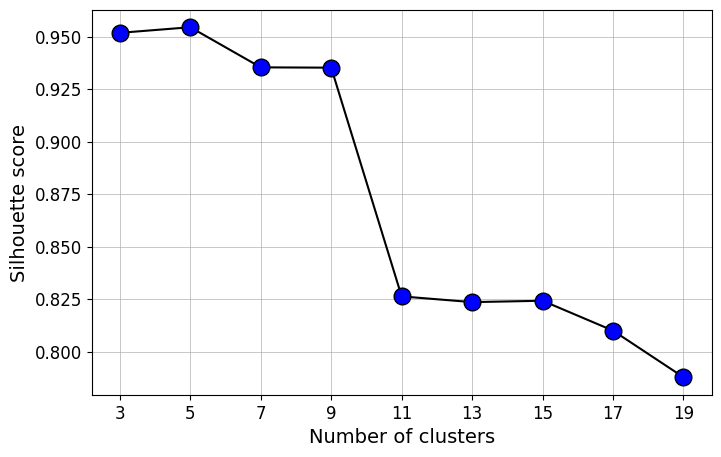

In [58]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Assume df is your DataFrame and you want to cluster on all columns
XX = unclustered.values

# Loop over a range of cluster sizes
test_nclusters = np.arange(3,20,2)
test_silhouettes = np.zeros(test_nclusters.size)
for nn, n_clusters in enumerate(test_nclusters):
    
    # Get KMeans clusters and labels for this size
    clustKM = KMeans(n_clusters=n_clusters, init='k-means++',n_init=10, random_state=0).fit(XX)
    cluster_labels = clustKM.labels_
    
    # Get the average silhouette scores across samples and print
    silhouette_avg = silhouette_score(XX, cluster_labels)
    print("For n_clusters = {:2d}, the average silhouette_score is: {:.3f}.".format(n_clusters,silhouette_avg))
    test_silhouettes[nn] = silhouette_avg

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,5,forward=True)

# Plot silhouette scores
ax.plot(test_nclusters,test_silhouettes,'-o',c='k',mfc='b',mec='k',ms=12)

# Format axis
ax.set_xlabel('Number of clusters',fontsize=14)
ax.set_ylabel('Silhouette score',fontsize=14)
ax.tick_params(labelsize=12)
ax.set_xticks(test_nclusters)
ax.grid(lw=0.5)

# Show
plt.show()
plt.close()

C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(
C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(
C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(
C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Win

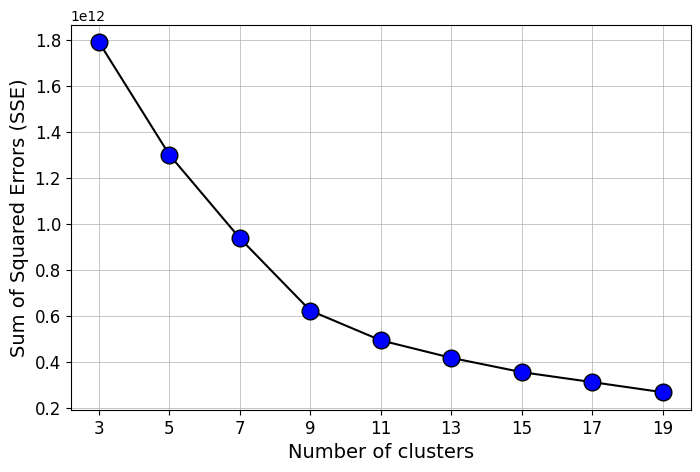

In [59]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Assume df is your DataFrame and you want to cluster on all columns
XX = unclustered.values

# Define the range of clusters to test
test_nclusters = np.arange(3,20,2)

# Initialize an empty list to store the SSE values for each cluster size
sse = []

# Loop over the range of clusters
for n_clusters in test_nclusters:
    
    # Get KMeans clusters for this size
    clustKM = KMeans(n_clusters=n_clusters, init='k-means++',n_init=10, random_state=0).fit(XX)
    
    # Append the SSE for this cluster size to the sse list
    sse.append(clustKM.inertia_)

# Figure setup
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,5,forward=True)

# Plot SSE values
ax.plot(test_nclusters, sse, '-o', c='k', mfc='b', mec='k', ms=12)

# Format axis
ax.set_xlabel('Number of clusters',fontsize=14)
ax.set_ylabel('Sum of Squared Errors (SSE)',fontsize=14)
ax.tick_params(labelsize=12)
ax.set_xticks(test_nclusters)
ax.grid(lw=0.5)

# Show
plt.show()
plt.close()

In [65]:
## Perform K-means clustering ##
clustered = unclustered.copy()
# Define the number of clusters
n_clusters = 9

# Get KMeans clusters for this size
clustKM = KMeans(n_clusters=n_clusters, init='k-means++',n_init=10, random_state=0).fit(XX)

# Assign cluster labels to your DataFrame
clustered['Cluster'] = clustKM.labels_

# Print out each cluster
for i in range(n_clusters):
    print(f'Cluster {i}:')
    print(clustered[clustered['Cluster'] == i].index.tolist())
    print('\n')

C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


Cluster 0:
['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DA

In [165]:
# Split the data into features (X) and target (y)
x = combined_stocks.drop('buy', axis=1)
y = combined_stocks['buy']

# Split the data into training and test sets
trainX, testX, trainY, testY = train_test_split(x, y, test_size = 0.2, random_state=42)

In [166]:
sc=StandardScaler()

scaler = sc.fit(trainX)
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)

In [167]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(14, 10, 5), random_state=1)

mlp_clf.fit(trainX_scaled, trainY)

C:\Users\gilbe\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  else:


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(14, 10, 5), random_state=1)

In [168]:
y_pred = mlp_clf.predict(testX_scaled)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.74


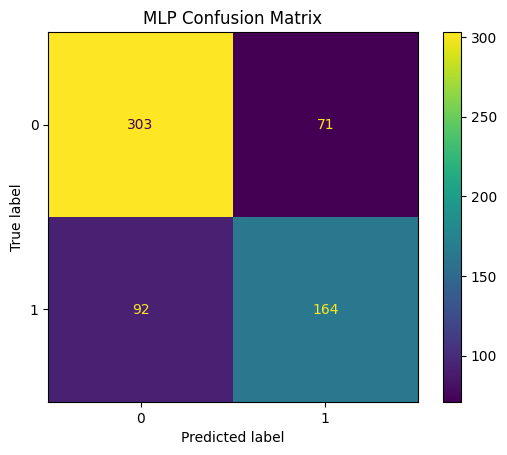

In [180]:
cm = confusion_matrix(y_test, y_pred, labels=mlp_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_clf.classes_)
disp.plot()
plt.title("MLP Confusion Matrix")
plt.show()

[0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1
 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0
 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0
 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1
 1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1
 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1
 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 1 0 0 1 0 0 1 0 1 0 0 

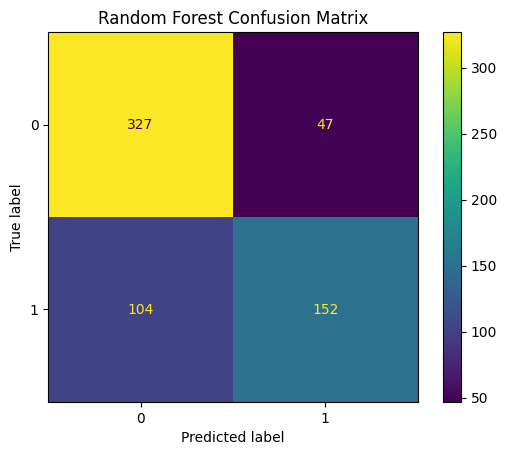

In [170]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(trainX_scaled, trainY)
rf_predictions = rf_clf.predict(testX_scaled)
print(rf_predictions)

# # Get feature importances
# importances = rf_clf.feature_importances_

# # Print feature importances
# for feature, importance in zip(X_train.columns, importances):
#     print(f"The importance of {feature} is {importance:.2f}")
    
cm = confusion_matrix(y_test, rf_predictions, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"The accuracy of the Random Forests model is {rf_accuracy:.2f}")

disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

The accuracy of the Decision Trees model is 0.65


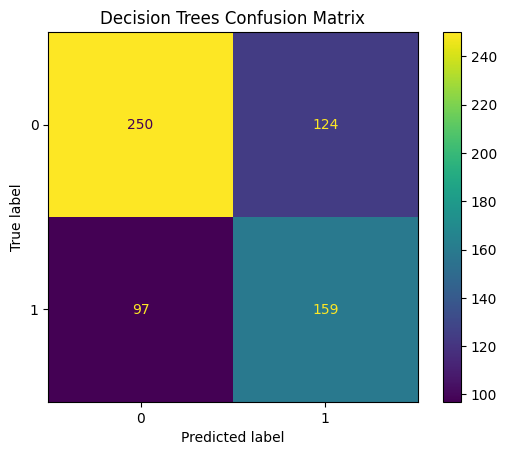

In [171]:
# Decision Trees
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(trainX_scaled, trainY)
dt_predictions = dt_clf.predict(testX_scaled)
cm = confusion_matrix(y_test, dt_predictions, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f"The accuracy of the Decision Trees model is {dt_accuracy:.2f}")

disp.plot()
plt.title("Decision Trees Confusion Matrix")
plt.show()

The accuracy of the Logistic Regression model is 0.71


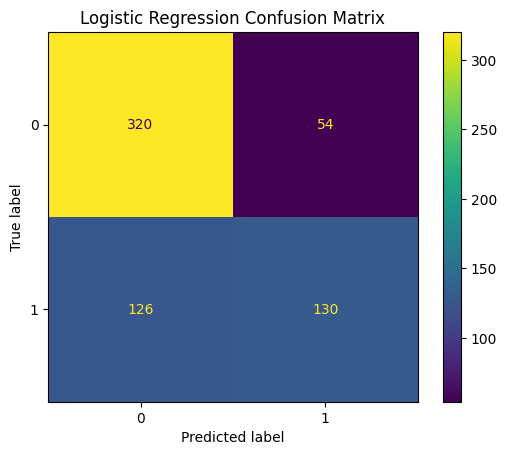

In [174]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(trainX_scaled, trainY)
lr_predictions = lr_clf.predict(testX_scaled)
cm = confusion_matrix(y_test, lr_predictions, labels=lr_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_clf.classes_)

dt_accuracy = accuracy_score(y_test, lr_predictions)
print(f"The accuracy of the Logistic Regression model is {dt_accuracy:.2f}")

disp.plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()